In [70]:
import numpy as np
from numpy import array
from scipy.spatial.distance import cosine, cdist
import sys
from graph import Graph
from graph import utils

import operator
import pickle
import os
import re
import json


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import Birch
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_features(path_to_features):
    FEATURES_DIR = path_to_features
    def _extract_id(pkl):
        pkl_pattern = "_([0-9]+)_"
        return int(re.findall(pkl_pattern, pkl)[0])


    pkls_names = os.listdir(FEATURES_DIR)
    pkls_ids = []
    X = None

    for pkl in pkls_names:
        pkls_ids.append(_extract_id(pkl))


    pkls_names = [k for k, v in sorted(zip(pkls_names, pkls_ids), key=operator.itemgetter(1))]

    for pkl in pkls_names:
        path_to_pickle_file = os.path.join(FEATURES_DIR, pkl)
        with open(path_to_pickle_file, 'rb') as pickle_file:
            x = pickle.load(pickle_file)
            if X is not None:
                X = np.vstack((X, x))
            else:
                X = x

    return np.array(X)

In [24]:
X_ = load_features('./features_avatar/')
X_.shape

(256290, 2048)

In [243]:

class SubClusters:
    def __init__(self):
        self.id_curr = None
        self.idxs_points = None
        self.points_sum = None
        self.k_list = None
        self.centers = None
    
    def init(self, x):
        self.id_curr = 1
        self.idxs_points = [[0]]
        self.points_sum = array([x])
        self.k_list = array([1])
        self.centers = array([x])
        return self
    
        
    def update(self, i, x):
        self.idxs_points[i].append(self.id_curr)
        self.points_sum[i] += x
        self.k_list[i] += 1
        self.centers[i] = self._recompute_center(self.points_sum[i], self.k_list[i])
        self.id_curr += 1
        return self
        
        
    def add(self, x):
        self.idxs_points.append([self.id_curr])
        self.points_sum = np.vstack((self.points_sum, x))
        self.k_list = np.append(self.k_list , 1)
        self.centers = np.vstack((self.centers, x))
        self.id_curr += 1
        return self
        
        
    def join(self, i, j):
    
#         print("JOIN")
        p_new = self.points_sum[i] + self.points_sum[j]
        k_new = self.k_list[i] + self.k_list[j]
        center_new = self._recompute_center(p_new, k_new)
        idxs_new = self.idxs_points[i] + self.idxs_points[j]
        
        self.points_sum[i] = p_new
        self.k_list[i] = k_new
        self.centers[i] = center_new
        self.idxs_points[i] = idxs_new
#         print("self.points_sum", self.points_sum.shape)
#         print('self.k_list', self.k_list.shape)
#         print('self.centers', self.centers.shape)
#         print('self.idxs_points', len(self.idxs_points))
        self.points_sum = np.delete(self.points_sum, j, axis=0)
        self.k_list = np.delete(self.k_list, j, axis=0)
        self.centers = np.delete(self.centers, j, axis=0)
        self.idxs_points.pop(j)
#         print('AFTER')
#         print("self.points_sum", self.points_sum.shape)
#         print('self.k_list', self.k_list.shape)
#         print('self.centers', self.centers.shape)
#         print('self.idxs_points', len(self.idxs_points))
        return self
        
        
    def _recompute_center(self, points_sum, k):
        new_c = points_sum / np.sqrt( k**2*T_c**2 + k*(1-T_c**2) )
        new_c = self._norm(new_c)
        return new_c
    
    
    def _norm(self, x):
        return x / np.linalg.norm(x)
        


class Links:
    
    def __init__(self, ):
        
        self.G = Graph()
        self.SubClusters = SubClusters()
        
        
    def __add__(self, x):
        pass
    
    def __s_k_k(self, k, k_):
        return 1 / np.sqrt( (1 + (1/T_c**2-1)/k) * (1 + (1/T_c**2-1)/k_) )
        
    def __s_k_approximate(self, k, k_ = 1):
        return T_c**2  +  (T_p-T_c**2) * (self.__s_k_k(k, k_)-T_c**2) / (1-T_c**2)
    
    
    def __check_subclusters(self):
        while True:
#             print('while True')
            centers = self.SubClusters.centers
#             print(f"Num of centers hasn't changed? Now it is : {len(centers)}")
            # FIX, NOT ALL CENTERS HAS CHANGED
            A = np.dot(centers, centers.T)
            A[np.arange(len(A)), np.arange(len(A))] = 0
            
            idxs = np.where(A >= T_s)
#             print('A :', A.max())
#             print(f"idxs which subclusters need to join: \n{idxs}")
            if idxs[0].any():
                idxs = np.where(A == A.max())
                i = idxs[0][0]
                j = idxs[0][1]
                i_ = min(i, j)
                j_ = max(i, j)
#                 print(f"We will remove {j_} and write to {i_}")
#                 print('i_, j_', i_, j_)
                self.SubClusters.join(i_, j_)
# #                 print(f"Now the num of centers is {len(self.SubClusters.centers)}")
# #                 print(f"Graph size is {len(self.G.AM)}")
# #                 print("Graph Adj matrix shape is :", self.G.AM.shape )
# #                 v_be_affected = self.G.AM[j_]
# #                 print(f"Line of the Graph we will remove {v_be_affected}")
# # #                 v_be_affected = np.where(v_be_affected != 0)[0]
# #                 print(f"Our center was in cluster with {v_be_affected}")
# # #                 v_be_affected[np.where(v_be_affected > j_)] -=1
# #                 v_be_affected = list(set(v_be_affected) - set(i_))
#                 v_be_affected = np.delete(np.arange(self.G.AM.shape[0] - 1), i_)
# #                 print(f"Updated coordinates: {v_be_affected}")
                
                
#                 self.G.remove_v(j_)
# #                 print(f"Removing.. Graph size is {len(self.G.AM)}")
#                 self.G._set_default_map()
#                 C = self.SubClusters.centers[i_]
#                 K = self.SubClusters.k_list[i_]
#                 affected_centers = self.SubClusters.centers[v_be_affected]
#                 affected_K = self.SubClusters.k_list[v_be_affected]
                

#                 D = np.dot(C, affected_centers.T)
# #                 print(f"D between C and affected ones : {D}")
# #                 print('__s_k_ : ', [self.__s_k_approximate(K, k) for k, d in zip(affected_K, D)])
#                 idxs_connected = [abs(d) >= self.__s_k_approximate(K, k) for k, d in zip(affected_K, D)]
# #                 print("idxs_connected", idxs_connected)
#                 idxs_connected = np.where(idxs_connected)[0]
#                 idxs_connected = tuple(v_be_affected[idxs_connected])
# #                 print("So we will connect :", idxs_connected)
# #                 print({i_: idxs_connected})
                
#                 self.G.add_adj({i_: idxs_connected})
                
#             else:
#                 break
        
    
    def _add(self, centers, x):
        J = np.dot(x, centers.T).argmax()
        C = centers[J]
        # !!!!check for norm
        d = abs(np.dot(C, x))
#         print(f"Center {J} is closest. Distance is {d}\nCompare with T_s = {T_s}")
        # (20) if add to exist subcluster
        if d >= T_s:
            # add
#             print(f"{d}>={T_s} so add x to subcluster {J}")
            self.SubClusters.update(J, x)
            self.__check_subclusters()
        else:
#             print("NEW!!!")
            # create new subcluster
            self.SubClusters.add(x)
            n = len(self.SubClusters.centers)
            k = self.SubClusters.k_list[J]
            i = n - 1
            self.G.add_v(i)
            
            if d >= self.__s_k_approximate(k):
                self.G.add_adj( { J:i } )
        
    
    def add(self, x):
        centers = self.SubClusters.centers
        if centers is not None:
#             print(f"Num centers: {len(centers)}\nNum points: {self.SubClusters.id_curr + 1}")
            pass
        
        if not hasattr(centers, '__len__'):
            self.SubClusters.init(x)
            self.G.add_v(0)
        
        else:

            self._add(centers, x)


In [ ]:
# # teta const
# T_c = 0.821080597464892

# # join points
# T_s = .84

# # clusters
# # 0.8 - 0.85
# T_p = 0.95


In [526]:
# teta const
T_c = 0.821080597464892

# join points
T_s = .84

# clusters
# 0.8 - 0.85
T_p = 0.95


In [529]:
X = X_[:]

In [530]:
L = Links()

{'node_color': 'black', 'font_color': 'w', 'font_weight': 'bold'}


In [531]:
%%time
n = len(X)


for i, x in enumerate(X):
#     print('\n')
    sys.stdout.write(f'\r{i}/{n}')
    sys.stdout.flush()
    x = x / np.linalg.norm(x)
    L.add(x)
    
    
# Wall time: 1h 9min 43s

1309/256290

2189/256290

2946/256290

256289/256290CPU times: user 5h 1min 11s, sys: 1h 34min 8s, total: 6h 35min 20s
Wall time: 1h 9min 43s


In [532]:
len(L.SubClusters.centers)

2223

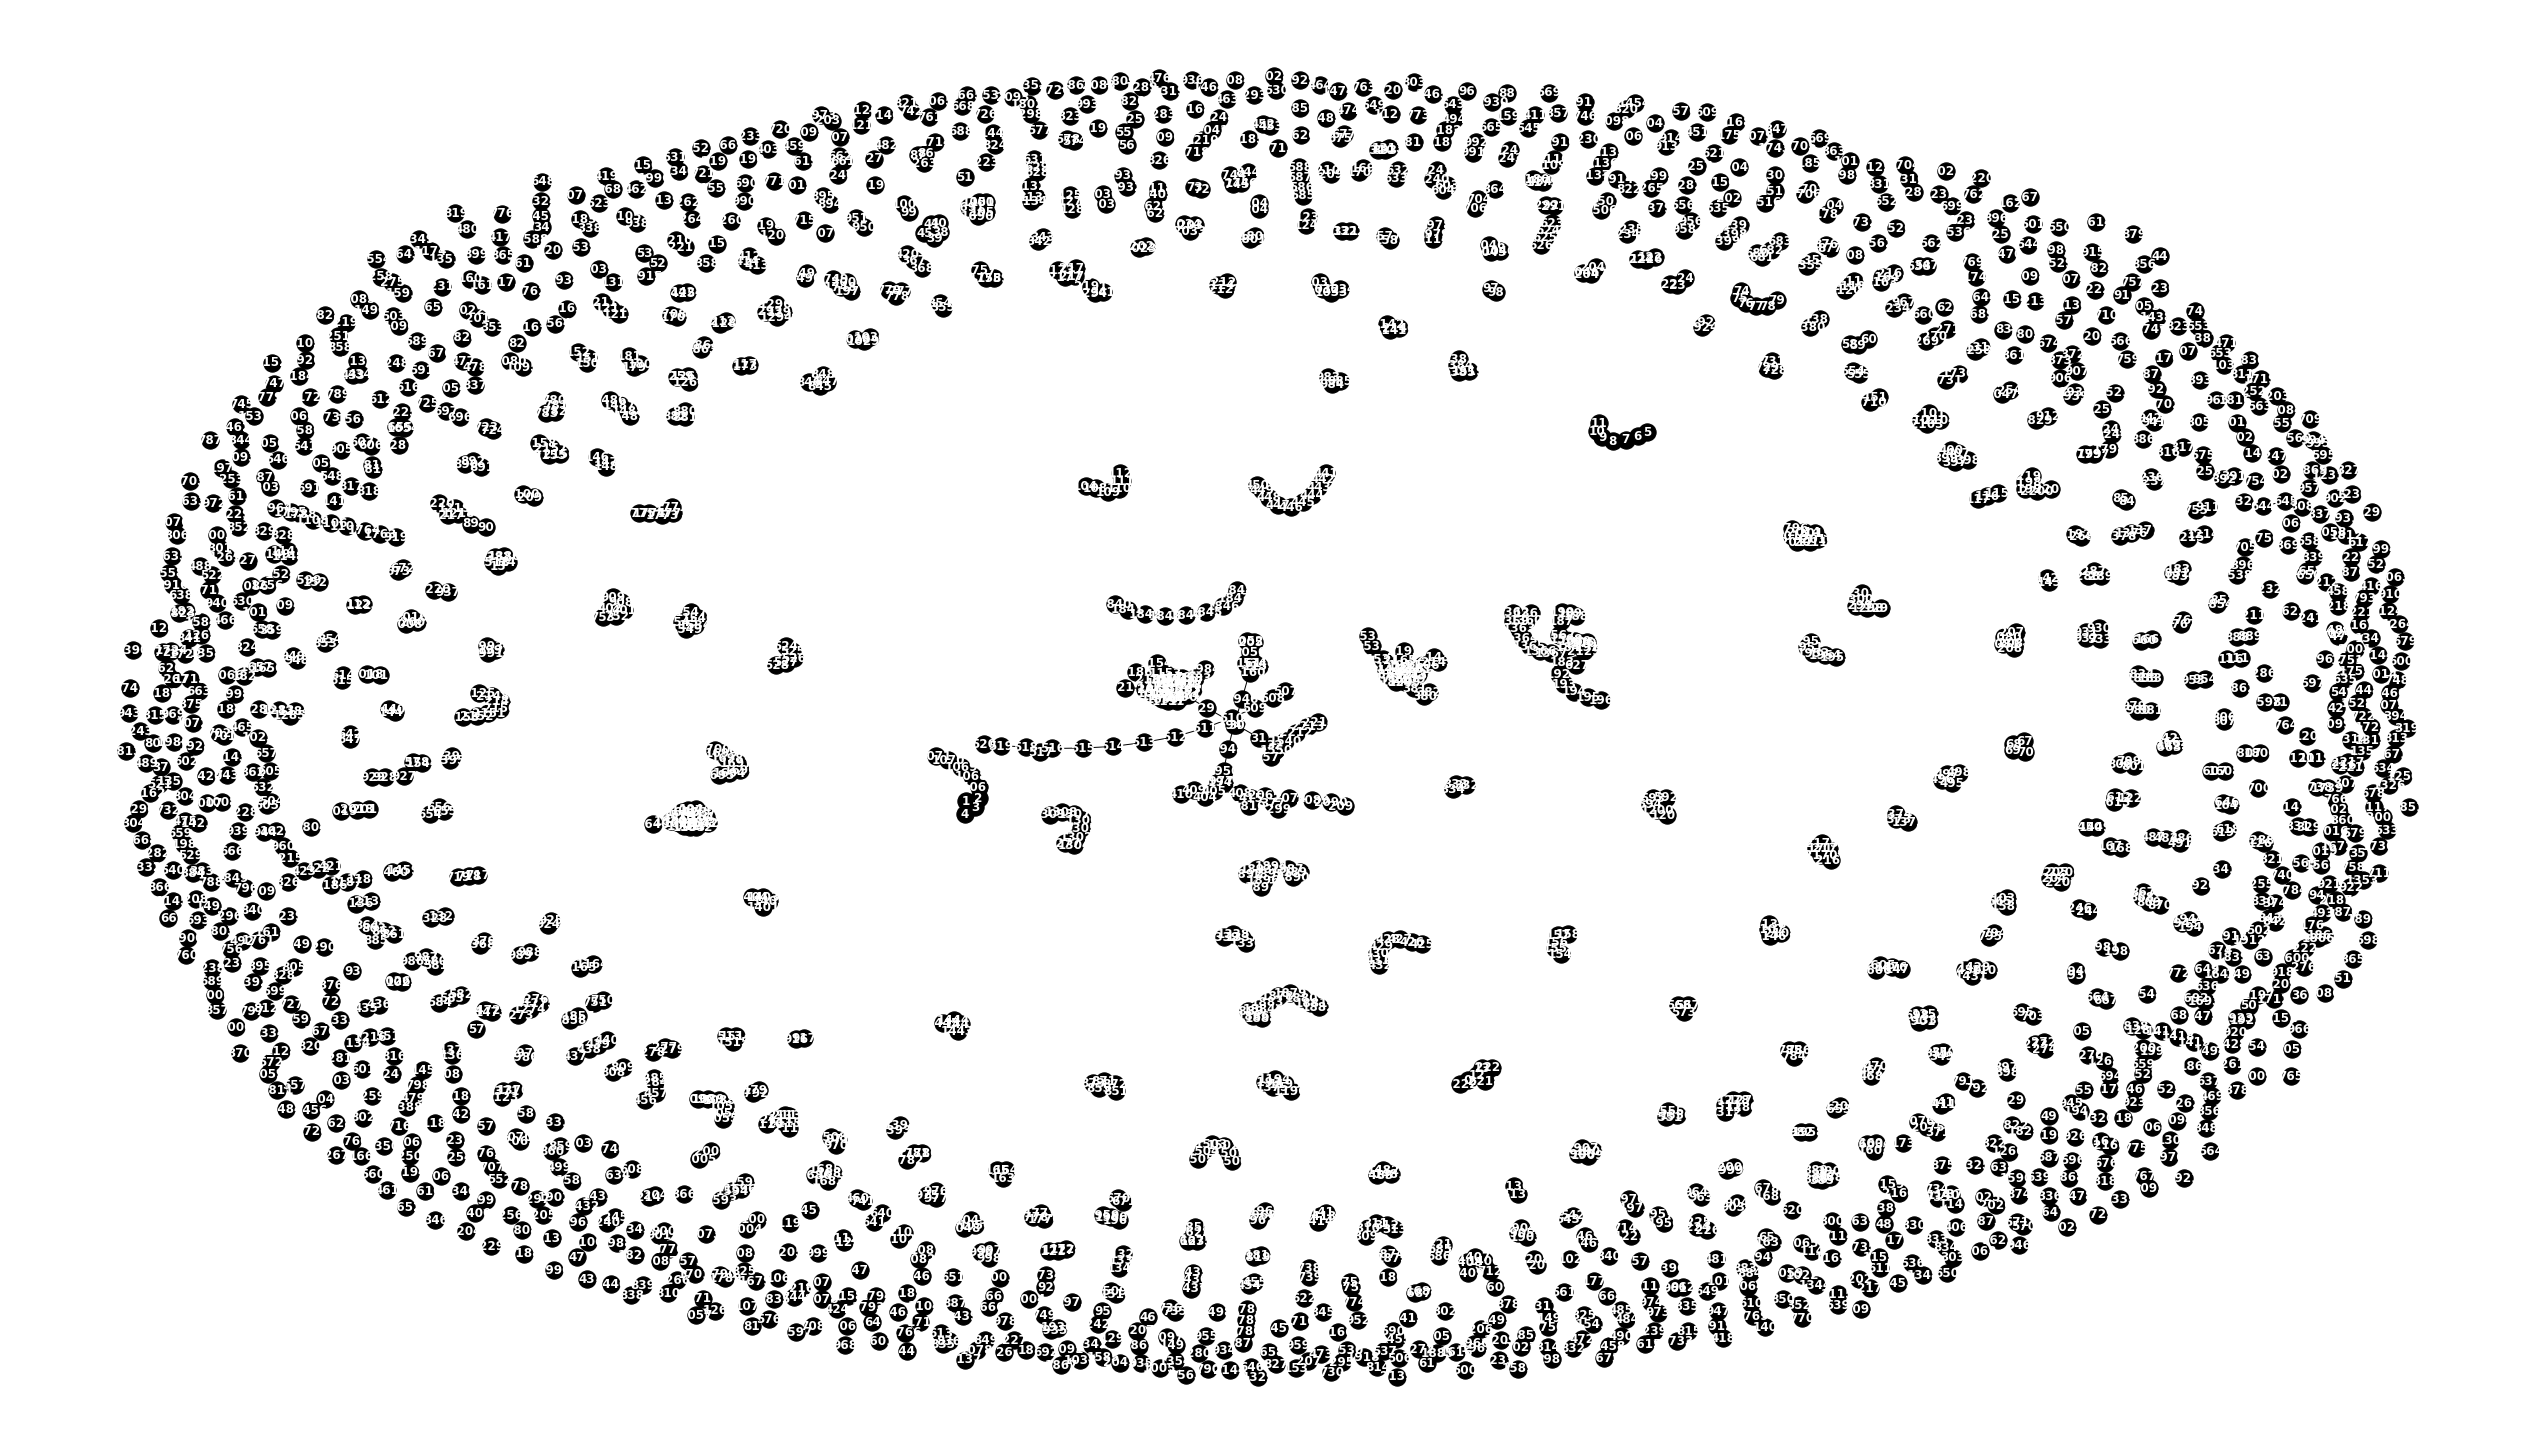

In [533]:
plt.figure(figsize=(35,20))
L.G.draw()

In [468]:
sorted(utils.bfs_components(L.G, 4))

[1, 2, 3, 4]

In [440]:
1 - cdist(X[36063:36523], X[36063:36523], metric='cosine').mean()

0.821080597464892

In [396]:
from collections import defaultdict

def labels_to_segments(labels):
    def __to_segments(line):
        segments = []
        prev = line[0]
        start = line[0]
        for l in line[1:]:
            if l != prev + 1:
                segments.append([start, prev])
                start = l
            prev = l
        segments.append([start, line[-1]])
        return segments
            
        
    data = []
    for i, line in enumerate(labels):
        line = array(line) + 1
        data.append(__to_segments(line))
    return data
        

In [373]:
labels = L.SubClusters.idxs_points 
labels_segments = labels_to_segments(labels)

In [374]:
for i in range(len(labels_segments)):
    print(f"{i} -- {labels_segments[i]}\n")

0 -- [[1, 28], [533, 786], [1287, 1347], [6402, 6425], [7042, 7046], [40141, 40149]]

1 -- [[29, 30]]

2 -- [[31, 31]]

3 -- [[32, 32], [28626, 28626], [28625, 28625], [28627, 28628], [28709, 28724], [29024, 29024]]

4 -- [[33, 33]]

5 -- [[34, 34]]

6 -- [[35, 113]]

7 -- [[114, 118]]

8 -- [[119, 528]]

9 -- [[529, 531]]

10 -- [[532, 532]]

11 -- [[787, 1166]]

12 -- [[1167, 1279]]

13 -- [[1280, 1286]]

14 -- [[1348, 1413]]

15 -- [[1414, 1428], [1435, 1479], [2700, 2807], [2938, 2964], [2808, 2848], [2140, 2699], [3129, 3177], [3414, 3445], [3043, 3128], [3446, 3465], [3509, 3563], [3567, 3588], [3564, 3566], [3589, 3594], [3717, 3754], [3771, 3779], [3755, 3760], [3801, 3813], [3824, 3826], [2965, 2975], [3780, 3800], [3836, 3843], [1481, 2139], [3178, 3268], [3321, 3329], [3334, 3413], [3595, 3635], [3641, 3713], [2849, 2937], [3714, 3716], [3912, 3961], [4023, 4045], [3814, 3823], [3827, 3835], [3962, 4022], [4046, 4053], [3844, 3911], [4054, 4064], [5775, 5835], [4065, 4186], 

117

In [119]:
centers = L.SubClusters.centers


model = TSNE(2, metric='cosine')
# model = PCA(2)
points = model.fit_transform(centers)


ValueError: 'c' argument must be a mpl color, a sequence of mpl colors or a sequence of numbers, not [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 6403, 6404, 6405, 6406, 6407, 6408, 6409, 6410, 6411, 6412, 6413, 6414, 6415, 6416, 6417, 6418, 6419, 6420, 6421, 6422, 6423, 6424, 7039, 7040, 7041, 7042, 7043, 7044, 7045, 40140, 40141, 40142, 40143, 40144, 40145, 40146, 40147, 40148, 96461, 96462, 96463, 140417, 140418, 140419, 140420, 140421, 140422, 140423, 140424, 140425, 140426, 140427, 140428, 140429, 140430, 140431, 140432, 140433, 140434, 140435, 140436, 140437, 140438, 140439, 140440, 140441, 140442, 140443, 140444, 140445, 140446, 154632, 154633, 154634, 154635, 154636, 154637, 154638, 154639, 154640, 154641, 154642, 154643, 154644, 154645, 154646, 154647, 154648, 154649, 154650, 154651, 154652, 154653, 154654, 154655, 154656, 154657, 154658, 154659, 154660, 154661, 154662, 154663, 154664, 154665, 154666, 154667, 154668, 154669, 154670, 154671, 154672, 154673, 154674, 154675, 154676, 158293, 158294, 158295, 158296, 158297, 158298, 158299, 158300, 158301, 158302, 158303, 170253, 170254, 170255, 175154, 175155, 175156, 175157, 175158, 175159, 175160, 175161, 175162, 175163, 175164, 175165, 175166, 175167, 175168, 175169, 175170, 175171, 175153, 175172, 175795, 175796, 175797, 175798, 175799, 175800, 175801, 175802, 175803, 175804, 175805, 175806, 175807, 175808, 175809, 175810, 175811, 175812, 175813, 175814, 175815, 175816, 175817, 175818, 175819, 175820, 175821, 175822, 175823, 175824, 175825, 175826, 175827, 175828, 175829, 175830, 175831, 175832, 175833, 175834, 175835, 175836, 175837, 175838, 175839, 185706, 185707, 185708, 186229, 186230, 186231, 186232, 186233, 186234, 186235, 186236, 186237, 186238, 186239, 186240, 186241, 186242, 186243, 186244, 186245, 186246, 186247, 186248, 186249, 186250, 186251, 186252, 186253, 186254, 186255, 186256, 186257, 186258, 186259, 186260, 186261, 186262, 186263, 186264, 186265, 186266, 186267, 186268, 186269, 186270, 186271, 186272, 186273, 186274, 186275, 186276, 186277, 186278, 186279, 186280, 186281, 186282, 186283, 186284, 186285, 186286, 186287, 186288, 186289, 186290, 186291, 186292, 186293, 186294, 186295, 186296, 186297, 186298, 186299, 186300, 186301, 186302, 186303, 186304, 186305, 186306, 186307, 186308, 199565, 199566, 199567, 199568, 246742, 246743, 246744, 246745, 246746, 246747, 246748, 246749, 246750, 246751, 246752, 246753, 246754, 246755, 246756, 246757, 246758, 246759, 246760, 246761, 246762, 246763, 246764, 249102, 249103, 249104, 249105, 249106, 249107, 249108, 249109, 249110, 249111, 249112, 249113, 249114, 249115, 249116, 249117, 249118, 249119, 249120, 249121, 249122, 249123, 249124, 249125, 249126, 249127, 249128, 249129, 249130, 249131, 249132, 249133, 249134, 249135, 249136, 249137, 249138, 249139, 249140, 249141, 249142, 249143, 249144, 249145, 249146, 249147, 249148, 249149, 249150, 249151, 249152, 249153, 249154, 249155, 249156, 249157, 249158, 249159, 249160, 249161, 249162, 249163, 249164, 249165, 249166, 249167, 249168, 249169, 249170, 249171, 249172, 249173, 249174, 249175, 249176, 249177, 249178, 249179, 249180, 249181, 249182, 249183, 249184, 249185, 249186, 249187, 249188, 249189, 249190, 249191, 249192, 249193, 249194, 249195, 249196, 249197, 249198, 249199, 249200, 249201, 249202, 249203, 249204, 249205, 249206, 249207, 249208, 249209, 249210, 249211, 249212, 249213, 249214, 249215, 249216, 249217, 249218, 249219, 249220, 249221, 249222, 249223, 249224, 249225, 249226, 249227, 249228, 249229, 249230, 249231, 249232, 249233, 249234, 249235, 249236, 249237, 249238, 249239, 249240, 249241, 249242, 249243, 249244, 249245, 249246, 249247, 249248, 249249, 249250, 249251, 249252, 249253, 249254, 249255, 249256, 249257, 249258, 249259, 249260, 249261, 249262, 249263, 249264, 249265, 249266, 249267, 249268, 249269, 249270, 249271, 249272, 249273, 249274, 249275, 249276, 249277, 249278, 249279, 249280, 249281, 249282, 249283, 249284, 249285, 249286, 249287, 249288, 249289, 249290, 249291, 249292, 249293, 249294, 249295, 249296, 249297, 249298, 249299, 249300, 249301, 249302, 249303, 249304, 249305, 249306, 249307, 249308, 249309, 249310, 249311, 249312, 249313, 249314, 249315, 249316, 249317, 249318, 249319, 249320, 249321, 249322, 249323, 249324, 249325, 249326, 249327, 249328, 249329, 249330, 249331, 249332, 249333, 249334, 249335, 249336, 249337, 249338, 249339, 249340, 249341, 249342, 249343, 249344, 249345, 249346, 249347, 249348, 249349, 249350, 249351, 249352, 249353, 249354, 249355, 249356, 249357, 249358, 249359, 249360, 249361, 249362, 249363, 249364, 249365, 249366, 249367, 249368, 249369, 249370, 249371, 249372, 249373, 249374, 249375, 249376, 249377, 249378, 249379, 249380, 249381, 249382, 249383, 249384, 249385, 249386, 249387, 249388, 249389, 249390, 249391, 249392, 249393, 249394, 249395, 249396, 249397, 249398, 249399, 249400, 249401, 249402, 249403, 249404, 249405, 249406, 249407, 249408, 249409, 249410, 249411, 249412, 249413, 249414, 249415, 249416, 249417, 249418, 249419, 249420, 249421, 249422, 249423, 249424, 249425, 249426, 249427, 249428, 249429, 249430, 249431, 249432, 249433, 249434, 249435, 249436, 249437, 249438, 249439, 249440, 249441, 249442, 249443, 249444, 249445, 249446, 249447, 249448, 249449, 249450, 249451, 249452, 249453, 249454, 249455, 249456, 249457, 249458, 249459, 249460, 249461, 249462, 249463, 249464, 249465, 249466, 249467, 249468, 249469, 249470, 249471, 249472, 249473, 249474, 249475, 249476, 249477, 249478, 249479, 249480, 249481, 249482, 249483, 249484, 249485, 249486, 249487, 249488, 249489, 249490, 249491, 249492, 249493, 249494, 249495, 249496, 249497, 249498, 249499, 249500, 249501, 249502, 249503, 249504, 249505, 249506, 249507, 249508, 249509, 249510, 249511, 249512, 249513, 249514, 249515, 249516, 249517, 249518, 249519, 249520, 249521, 249522, 249523, 249524, 249525, 249526, 249527, 249528, 249529, 249530, 249531, 249532, 249533, 249534, 249535, 249536, 249537, 249538, 249539, 249540, 249541, 249542, 249543, 249544, 249545, 249546, 249547, 249548, 249549, 249550, 249551, 249552, 249553, 249554, 249555, 249556, 249557, 249558, 249559, 249560, 249561, 249562, 249563, 249923, 249924, 249925, 249926, 249937, 249938, 249939, 249940, 249941, 249948, 249949, 249950, 249951, 249952, 249953, 249954, 249955, 249956, 249957, 249959, 249960, 249961, 249964, 249965, 249966, 249967, 249968, 249969, 249970, 249973, 249981, 249986, 249564, 249565, 249566, 249567, 249568, 249569, 249570, 249571, 249572, 249573, 249574, 249575, 249576, 249577, 249578, 249579, 249580, 249581, 249582, 249583, 249584, 249585, 249586, 249587, 249588, 249589, 249590, 249591, 249592, 249593, 249594, 249595, 249596, 249597, 249598, 249599, 249600, 249601, 249602, 249603, 249604, 249605, 249606, 249607, 249608, 249609, 249610, 249611, 249612, 249613, 249614, 249615, 249616, 249617, 249618, 249619, 249620, 249621, 249622, 249623, 249624, 249625, 249626, 249627, 249628, 249629, 249630, 249631, 249632, 249633, 249634, 249635, 249636, 249637, 249638, 249639, 249640, 249641, 249642, 249643, 249644, 249645, 249646, 249647, 249648, 249649, 249650, 249651, 249652, 249653, 249654, 249655, 249656, 249657, 249658, 249659, 249660, 249661, 249662, 249663, 249664, 249665, 249666, 249667, 249668, 249669, 249670, 249671, 249672, 249673, 249674, 249675, 249676, 249677, 249678, 249679, 249680, 249681, 249682, 249683, 249684, 249685, 249686, 249687, 249688, 249689, 249690, 249691, 249692, 249693, 249694, 249695, 249696, 249697, 249698, 249699, 249700, 249701, 249702, 249703, 249704, 249705, 249706, 249707, 249708, 249709, 249710, 249711, 249712, 249713, 249714, 249715, 249716, 249717, 249718, 249719, 249720, 249721, 249722, 249723, 249724, 249725, 249726, 249727, 249728, 249729, 249730, 249731, 249732, 249733, 249734, 249735, 249736, 249737, 249738, 249739, 249740, 249741, 249742, 249743, 249744, 249745, 249746, 249747, 249748, 249749, 249750, 249751, 249752, 249753, 249754, 249755, 249756, 249757, 249758, 249759, 249760, 249761, 249762, 249763, 249764, 249765, 249766, 249767, 249768, 249769, 249770, 249771, 249772, 249773, 249774, 249775, 249776, 249777, 249778, 249779, 249780, 249781, 249782, 249783, 249784, 249785, 249786, 249787, 249788, 249789, 249790, 249791, 249792, 249793, 249794, 249795, 249796, 249797, 249798, 249799, 249800, 249801, 249802, 249803, 249804, 249805, 249806, 249807, 249808, 249809, 249810, 249811, 249812, 249813, 249814, 249815, 249816, 249817, 249818, 249819, 249820, 249821, 249822, 249823, 249824, 249825, 249826, 249827, 249828, 249829, 249830, 249831, 249832, 249833, 249834, 249835, 249836, 249837, 249838, 249839, 249840, 249841, 249842, 249843, 249844, 249845, 249846, 249847, 249848, 249849, 249850, 249851, 249852, 249853, 249854, 249855, 249856, 249857, 249858, 249859, 249860, 249861, 249862, 249863, 249864, 249865, 249866, 249867, 249868, 249869, 249870, 249871, 249872, 249873, 249874, 249875, 249876, 249877, 249878, 249879, 249880, 249881, 249882, 249883, 249884, 249885, 249886, 249887, 249888, 249889, 249890, 249891, 249892, 249893, 249894, 249895, 249896, 249897, 249898, 249899, 249900, 249901, 249902, 249903, 249904, 249905, 249906, 249907, 249908, 249909, 249910, 249911, 249912, 249913, 249914, 249915, 249916, 249917, 249918, 249919, 249920, 249921, 249922, 249927, 249928, 249929, 249930, 249931, 249932, 249933, 249934, 249935, 249936, 249942, 249943, 249944, 249945, 249946, 249947, 249958, 249962, 249963, 249971, 249972, 249974, 249975, 249976, 249977, 249978, 249979, 249980, 249982, 249983, 249984, 249985, 249987, 249988, 249989, 249990, 249991, 249992, 249993, 249994, 249995, 249996, 249997, 249998, 249999, 250000, 250001, 250002, 250003, 250004, 250005, 250006, 250007, 250008, 250009, 250010, 250011, 250012, 250013, 250014, 250015, 250016, 250017, 250018, 250019, 250020, 250021, 250022, 250023, 250024, 250025, 250026, 250027, 250028, 250029, 250030, 250031, 250032, 250033, 250034, 250035, 250036, 250037, 250038, 250039, 250040, 250041, 250042, 250043, 250044, 250045, 250046, 250047, 250048, 250049, 250050, 250051, 250052, 250053, 250054, 250055, 250056, 250057, 250058, 250059, 250060, 250061, 250062, 250063, 250064, 250065, 250066, 250067, 250068, 250069, 250070, 250071, 250072, 255605, 255606, 255613, 255617, 255620, 255621, 255622, 255623, 255624, 255625, 255626, 255627, 255628, 255629, 255630, 255631, 255632, 255633, 255634, 255635, 255636, 255637, 255638, 255639, 255640, 255641, 255642, 255643, 255644, 255645, 255646, 255647, 255648, 255649, 255650, 255651, 255652, 255653, 255654, 255655, 255656, 255657, 255658, 255659, 255660, 255661, 255662, 255663, 255664, 255665, 255666, 255667, 255668, 255669, 255670, 255671, 255672, 255673, 255674, 255675, 255676, 255677, 255678, 255679, 255680, 255681, 255682, 255683, 255684, 255685, 255686, 255687, 255688, 255689, 255690, 255691, 255692, 255693, 255694, 255695, 255696, 255697, 255698, 255699, 255700, 255701, 255702, 255703, 255704, 255705, 255706, 255707, 255708, 255709, 255710, 255711, 255712, 255713, 255714, 255715, 255716, 255717, 255718, 255719, 255720, 255721, 255722, 255723, 255724, 255725, 255726, 255727, 255728, 255729, 255730, 255731, 255732, 255733, 255734, 255735, 255736, 255737, 255738, 255739, 255740, 255741, 255742, 255743, 255744, 255745, 255746, 255747, 255748, 255749, 255750, 255751, 255752, 255753, 255754, 255755, 255756, 255757, 255758, 255759, 255760, 255761, 255762, 255763, 255764, 255765, 255766, 255767, 255768, 255769, 255770, 255771, 255772, 255773, 255774, 255775, 255776, 255777, 255778, 255779, 255780, 255781, 255782, 255783, 255784, 255785, 255786, 255787, 255788, 255789, 255790, 255791, 255792, 255793, 255794, 255795, 255796, 255797, 255798, 255799, 255800, 255801, 255802, 255803, 255804, 255805, 255806, 255807, 255808, 255809, 255810, 255811, 255812, 255813, 255814, 255815, 255816, 255817, 255818, 255819, 255820, 255821, 255822, 255823, 255824, 255825, 255826, 255827, 255828, 255829, 255830, 255831, 255832, 255833, 255834, 255835, 255836, 255837, 255838, 255839, 255840, 255841, 255842, 255843, 255844, 255845, 255846, 255847, 255848, 255849, 255850, 255851, 255852, 255853, 255854, 255855, 255856, 255857, 255858, 255859, 255860, 255861, 255862, 255863, 255864, 255865, 255866, 255867, 255868, 255869, 255870, 255871, 255872, 255873, 255874, 255875, 255876, 255877, 255878, 255879, 255880, 255881, 255882, 255883, 255884, 255885, 255886, 255887, 255888, 255889, 255890, 255891, 255892, 255893, 255894, 255895, 255896, 255897, 255898, 255899, 255900, 255901, 255902, 255903, 255904, 255905, 255906, 255907, 255908, 255909, 255910, 255911, 255912, 255913, 255914, 255915, 255916, 255917, 255918, 255919, 255920, 255921, 255922, 255923, 255924, 255925, 255926, 255927, 255928, 255929, 255930, 255931, 255932, 255933, 255934, 255935, 255936, 255937, 255938, 255939, 255940, 255941, 255942, 255943, 255944, 255945, 255946, 255947, 255948, 255949, 255950, 255951, 255952, 255953, 255954, 255955, 255956, 255957, 255958, 255959, 255960, 255961, 255962, 255963, 255964, 255965, 255966, 255967, 255968, 255969, 255970, 255971, 255972, 255973, 255974, 255975, 255976, 255977, 255978, 255979, 255980, 255981, 255982, 255983, 255984, 255985, 255986, 255987, 255988, 255989, 255990, 255991, 255992, 255993, 255994, 255995, 255996, 255997, 255998, 255999, 256000, 256001, 256002, 256003, 256004, 256005, 256006, 256007, 256008, 256009, 256010, 256011, 256012, 256013, 256014, 256015, 256016, 256017, 256018, 256019, 256020, 256021, 256022, 256023, 256024, 256025, 256026, 256027, 256028, 256029, 256030, 256031, 256032, 256033, 256034, 256035, 256036, 256037, 256038, 256039, 256040, 256041, 256042, 256043, 256044, 256045, 256046, 256047, 256048, 256049, 256050, 256051, 256052, 256053, 256054, 256055, 256056, 256057, 256058, 256059, 256060, 256061, 256062, 256063, 256064, 256065, 256066, 256067, 256068, 256069, 256070, 256071, 256072, 256073, 256074, 256075, 256076, 256077, 256078, 256079, 256080, 256081, 256082, 256083, 256084, 256085, 256086, 256087, 256088, 256089, 256090, 256091, 256092, 256093, 256094, 256095, 256096, 256097, 256098, 256099, 256100, 256101, 256102, 256103, 256104, 256105, 256106, 256107, 256108, 256109, 256110, 256111, 256112, 256113, 256114, 256115, 256116, 256117, 256118, 256119, 256120, 256121, 256122, 256123, 256124, 256125, 256126, 256127, 256128, 256129, 256130, 256131, 256132, 256133, 256134, 256135, 256136, 256137, 256138, 256139, 256140, 256141, 256142, 256143, 256144, 256145, 256146, 256147, 256148, 256149, 256150, 256151, 256152, 256153, 256154, 256155, 256156, 256157, 256158, 256159, 256160, 256161, 256162, 256163, 256164, 256165, 256166, 256167, 256168, 256169, 256170, 256171, 256172, 256173, 256174, 256175, 256176, 256177, 256178, 256179, 256180, 256181, 256182, 256183, 256184, 256185, 256186, 256187, 256188, 256189, 256190, 256191, 256192, 256193, 256194, 256195, 256196, 256197, 256198, 256199, 256200, 256201, 256202, 256203, 256204, 256205, 256206, 256207, 256208, 256209, 256210, 256211, 256212, 256213, 256214, 256215, 256216, 256217, 256218, 256219, 256220, 256221, 256222, 256223, 256224, 256225, 256226, 256227, 256228, 256229, 256230, 256231, 256232, 256233, 256234, 256235, 256236, 256237, 256238, 256239, 256240, 256241, 256242, 256243, 256244, 256245, 256246, 256247, 256248, 256249, 256250, 256251, 256252, 256253, 256254, 256255, 256256, 256257, 256258, 256259, 256260, 256261, 256262, 256263, 256264, 256265, 256266, 256267, 256268, 256269, 256270, 256271, 256272, 256273, 256274, 256275, 256276, 256277, 256278, 256279, 256280, 256281, 256282, 256283, 256284, 256285, 256286, 256287, 256288, 256289], [28, 29, 30], [31, 28624, 28625, 28626, 28627, 28708, 28709, 28710, 28711, 28712, 28713, 28714, 28715, 28716, 28717, 28718, 28719, 28720, 28721, 28722, 28723, 29023, 78965, 78966, 78967, 78968, 78969, 78970, 78971, 78972, 78973, 78974, 78975, 78976, 78977, 78978, 78979, 78980, 78981, 78982, 78983, 78984, 78985, 78986, 78987, 78988, 78989, 78990, 78991, 78992, 78993, 78994, 78995, 78996, 78997, 78998, 78999, 79000, 79001, 79002, 79003, 79004, 79005, 79006, 79007, 79008, 79009, 79010, 79011, 79012, 79013, 79014, 79015, 79016, 79017, 79018, 79019, 79020, 79021, 79022, 79023, 79024, 79025, 79026, 79027, 79028, 79029, 79030, 79031, 79032, 79033, 79034, 79035, 79036, 79037, 79038, 79039, 79040, 79041, 79042, 79043, 79044, 79063, 79083, 79095, 79103, 79112, 79119, 28628, 28707, 142730, 193579, 193580, 193581, 194424, 194426, 194427, 194428, 194429, 194430, 194431, 194432, 194433, 194434, 194435, 194436, 194437, 194438, 194439, 194440, 194441, 194442, 194443, 194444, 194445, 194446, 194447, 194448, 194425, 226957, 226958, 226959, 227684, 228531, 235791, 235792], [32], [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120], [121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527], [528, 529, 530], [531], [786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 88953, 88954, 88955, 88956, 88957, 88958, 88959, 88960, 88961, 88962, 88963, 88964, 88965, 88966, 88967, 88968, 88969, 88970, 88971, 247194, 247195, 247196, 247197, 247198, 247199, 247201, 247202, 247203, 247204, 247205, 247206, 247207, 247208, 10559, 10560, 10561, 10562, 10563, 10564, 10565, 10566, 10567, 10568, 10569, 10570, 10571, 10572, 10573, 10574, 10575, 10576, 10577, 10578, 10579, 10580, 10581, 10582, 10583, 10584, 10585, 10586, 10587, 10588, 10589, 10590, 10591, 10592, 10593, 10594, 10595, 10596, 10597, 10598, 10599, 10600, 10601, 10602, 10603, 10604, 10605, 10606, 10607, 10608, 10609, 10610, 10611, 10612, 10613, 10614, 10615, 10616, 10617, 10618, 10619, 10620, 10621, 10622, 10623, 10624, 10625, 10626, 10627, 10628, 10629, 10630, 10631, 10632, 10633, 10634, 10635, 10636, 10637, 10638, 10639, 10640, 10641, 10642, 10643, 10644, 10645, 10646, 10647, 10648, 10649, 10650, 10651, 10652, 10653, 10654, 10655, 10656, 10657, 10658, 10659, 10660, 10661, 10662, 10663, 10664, 10665, 10666, 10667, 10668, 10669, 10670, 10671, 10672, 10673, 10674, 10675, 10676, 10677, 10678, 10679, 10680, 10681, 10682, 10683, 10684, 10685, 10686, 10687, 10688, 10689, 10690, 10691, 10692, 10693, 10694, 10695, 10696, 10697, 10698, 10699, 10700, 10701, 10702, 10703, 10704, 10705, 10706, 10707, 10708, 10709, 10710, 10711, 10712, 10713, 10714, 10715, 10716, 10717, 10718, 10719, 10720, 10721, 10722, 10723, 10724, 10725, 10726, 10727, 10728, 10729, 10730, 10731, 10732, 10733, 10734, 10735, 10736, 10737, 10738, 10739, 10740, 10741, 10742, 10743, 10744, 10745, 10746, 10747, 10748, 10749, 10750, 10751, 10752, 10753, 10754, 10755, 10756, 10757, 10758, 10759, 10760, 10761, 10762, 10763, 10764, 10765, 10766, 10767, 10768, 10769, 10770, 10771, 10772, 10773, 10774, 10775, 10776, 10777, 10778, 10779, 10780, 10781, 10782, 10783, 10784, 10785, 10786, 10787, 10788, 10789, 10790, 10791, 10792, 10793, 10794, 10795, 10796, 10797, 10798, 10799, 10800, 10801, 10802, 10803, 10804, 10805, 10806, 10807, 10808, 10809, 10810, 10811, 10812, 10813, 10814, 10815, 10816, 10817, 10818, 10819, 10820, 10821, 10822, 10823, 10824, 10825, 10826, 10827, 10828, 10829, 10830, 10831, 10832, 10833, 10834, 10835, 10836, 10837, 10838, 10839, 10840, 10841, 10842, 10843, 10844, 10845, 10846, 10847, 10848, 10849, 10850, 10851, 10852, 10853, 10854, 10855, 10856, 10857, 10858, 10859, 10860, 10861, 10862, 10863, 10864, 10865, 10866, 10867, 10868, 10869, 10870, 10871, 10872, 10873, 10874, 10875, 10876, 10877, 10878, 10879, 10880, 10881, 10882, 10883, 10884, 10885, 10886, 10887, 10888, 10889, 10890, 10891, 10892, 10893, 10894, 10895, 10896, 10897, 10898, 10899, 10900, 10901, 10902, 10903, 10904, 10905, 10906, 10907, 10908, 10909, 10910, 10911, 10912, 10913, 10914, 10915, 10916, 10917, 10918, 10919, 10920, 10921, 10922, 10923, 10924, 10925, 10926, 10927, 10928, 10929, 10930, 10931, 10932, 10933, 10934, 10935, 10936, 10937, 10938, 10939, 10940, 10941, 10942, 10943, 10944, 10945, 10946, 10947, 10948, 10949, 10950, 10951, 10952, 10953, 10954, 10955, 10956, 10957, 10958, 10959, 10960, 10961, 10962, 10963, 10964, 10965, 10966, 10967, 10968, 10969, 10970, 10971, 10972, 10973, 10974, 10975, 10976, 10977, 10978, 10979, 10980, 10981, 10982, 10983, 10984, 10985, 10986, 10987, 10988, 10989, 10990, 10991, 10992, 10993, 88972, 247209, 247210, 247211, 247212, 247213, 247214, 247221, 247222, 247223, 247224, 247225, 247226, 247227, 247228, 247229, 247230, 247231, 247232, 247233, 247234, 247235, 247236, 247237, 247238, 247239, 247240, 247241, 247242, 247243, 247244, 247245, 247246, 247247, 247248, 247249, 247250, 247251, 247252, 247253, 247254, 247255, 247256, 247257, 247258, 247259, 247260, 247261, 247262, 247263, 247264, 247265, 247266, 247267, 247268, 247269, 247270, 247271, 247272, 247273, 247274, 247275, 247276, 247277, 247278, 247279, 247280, 247281, 247282, 247283, 247284, 247285, 247286, 247287, 247288, 247289, 247290, 247291, 247292, 247293, 247294, 247295, 247296, 247297, 247298, 247299, 247300, 247301, 247302, 247303, 247304, 247305, 247306, 247307, 247308, 247309, 247310, 247311, 247312, 247313, 247314, 247315, 247316, 247317, 247318, 247319, 247320, 247321, 247322, 247323, 247324, 247325, 247326, 247327, 247328, 247329, 247330, 247331, 247332, 247333, 247334, 247335, 247336, 247337, 247338, 247339, 247340, 247341, 247342, 247343, 247344, 247345, 247346, 247347, 247348, 247349, 247350, 247351, 247352, 247353, 247354, 247355, 247356, 247357, 247358, 247359, 247360, 247361, 247362, 247363, 247364, 247365, 247366, 247367, 247368, 247369, 247370, 247371, 247372, 247373, 247374, 247375, 247376, 247377, 247378, 247379, 247380, 247381, 247382, 247383, 247384, 247385, 247386, 247387, 247388, 247389, 247390, 247391, 247392, 247393, 247394, 247395, 247396, 247397, 247398, 247399, 247400, 247401, 247402, 247403, 247404, 247405, 247406, 247407, 247408, 247409, 247410, 247411, 247412, 247413, 247414, 247415, 247416, 247417, 247418, 247419, 247420, 247421, 247422, 247423, 247424, 247425, 247426, 247427, 247428, 247429, 247430, 247431, 247432, 247433, 247434, 247435, 247436, 247437, 247438, 247439, 247440, 247441, 247442, 247443, 247444, 247445, 247446, 247447, 247448, 247449, 247450, 247451, 247452, 247453, 247454, 247455, 247456, 247457, 247458, 247459, 247460, 247461, 247462, 247463, 247464, 247465, 247466, 247467, 247468, 247469, 247470, 247471, 247472, 247473, 247474, 247475, 247476, 247477, 247478, 247479, 247480, 247481, 247482, 247483, 247484, 247485, 247486, 247487, 247488, 247489, 247490, 247491, 247492, 247493, 247494, 247495, 247496, 247497, 247498, 247499, 247500, 247501, 247502, 247503, 247504, 247505, 247506, 247507, 247508, 247509, 247510, 247511, 247512, 247513, 247514, 247515, 247516, 247517, 247518, 247519, 247520, 247521, 247522, 247523, 247524, 247525, 247526, 247527, 247528, 247529, 247530, 247531, 247532, 247533, 247534, 247535, 247536, 247537, 247538, 247539, 247540, 247541, 247542, 247543, 247544, 247545, 247546, 247547, 247548, 247549, 247550, 247551, 247552, 247553, 247554, 247555, 247556, 247557, 247558, 247559, 247560, 247561, 247562, 247563, 247564, 247565, 247566, 247567, 247568, 247569, 247570, 247571, 247572, 247573, 247574, 247575, 247576, 247577, 247578, 247579, 247580, 247581, 247582, 247583, 247584, 247585, 247586, 247587, 247588, 247589, 247590, 247591, 247592, 247593, 247594, 247595, 247596, 247597, 247598, 247599, 247600, 247601, 247602, 247603, 247604, 247605, 247606, 247607, 247608, 247609, 247610, 247611, 247612, 247613, 247614, 247615, 247616, 247617, 247618, 247619, 247620, 247621, 247622, 247623, 247624, 247625, 247626, 247627, 247628, 247629, 247630, 247631, 247632, 247633, 247634, 247635, 247636, 247637, 247638, 247639, 248110, 248111, 248112, 248113, 248461, 168020, 168021, 168022, 168023, 168024, 168025, 248399, 248400, 248401, 248402, 248403, 248404, 248405, 248406, 248407, 248408, 248409, 248410, 248411, 248412, 248413, 248414, 248415, 248416, 248417, 248418, 248419, 248420, 248421, 248422, 185709, 185710, 185711, 185712, 185713, 185714, 185715, 185716, 185717, 185718, 185719, 185720, 185721, 185722, 185723, 185724, 185725, 185726, 185727, 185728, 185729, 185730, 185731, 185732, 185733, 185734, 185735, 185736, 185737, 185738, 185739, 185740, 185741, 185742, 185743, 185744, 185745, 185746, 185747, 185748, 185749, 185750, 185751, 185752, 185753, 185754, 185755, 185756, 185757, 185758, 185759, 185760, 185761, 185762, 185763, 248262, 248263, 248264, 248265, 248266, 248267, 248268, 248269, 248270, 248271, 248272, 248273, 248274, 248275, 248276, 248277, 248278, 248279, 248280, 248281, 248282, 248283, 248284, 248285, 248286, 248287, 248288, 248289, 248290, 248291, 248292, 248293, 248294, 248295, 248296, 248297, 248298, 248299, 248300, 248301, 248302, 248303, 248304, 248305, 248306, 248307, 248308, 248309, 248310, 248311, 248312, 248313, 248314, 248315, 248316, 248317, 248318, 248319, 248320, 248321, 248322, 248323, 248324, 248325, 248326, 248327, 248328, 248329, 248330, 248331, 248332, 248333, 248334, 248335, 248336, 248337, 248338, 248339, 248340, 248341, 248342, 248343, 248344, 248345, 248346, 248347, 248348, 248349, 248350, 248351, 248352, 248353, 248354, 248355, 248356, 248357, 248358, 248359, 248360, 248361, 248362, 248363, 248364, 248365, 248366, 248367, 248368, 248369, 248370, 248371, 248372, 248373, 248374, 248375, 248376, 248377, 248378, 248379, 248380, 248381, 248382, 248383, 248384, 248385, 248386, 248387, 248388, 248389, 248390, 248391, 248392, 248393, 248394, 248395, 248396, 248397, 248398, 248423, 248424, 248425, 248426, 248427, 248428, 248429, 248430, 248431, 248432, 248433, 248434, 248435, 248436, 248437, 248438, 248439, 248440, 248441, 248442, 248443, 248444, 248445, 248446, 248447, 248448, 248449, 248450, 248451, 248452, 248453, 248454, 248455, 248456, 248457, 248458, 248459, 248460, 248462, 248463, 248464, 248465, 248466, 169416, 169417, 169418, 169419, 169420, 169421, 169422, 169423, 169424, 169425, 169426, 169427, 169428, 169429, 169430, 169431, 169432, 169433, 169434, 169435, 169436, 169437, 169438, 169439, 169440, 169441, 169442, 169443, 169444, 169445, 169446, 169447, 169448, 169449, 169450, 169451, 169452, 169588, 169589, 169590, 169591, 169592, 169593, 169594, 169595, 169596, 169597, 169598, 169599, 169600, 169601, 169602, 169603, 169604, 169605, 169606, 169607, 169608, 169609, 169610, 169611, 169612, 169613, 169614, 169615, 169616, 169617, 169618, 169619, 169620, 169621, 169622, 169623, 169624, 169625, 169626, 169627, 169628, 169629, 169630, 169631, 169632, 169633, 169634, 169635, 169636, 169637, 169638, 169639, 169640, 169641, 169642, 169643, 169644, 169645, 169646, 169647, 169648, 169649, 169650, 169651, 169652, 169653, 169654, 169655, 169656, 169657, 169658, 169659, 169660, 169661, 169662, 169663, 169664, 169665, 169666, 169667, 169668, 169669, 169670, 169671, 169672, 169673, 169674, 169675, 169676, 169677, 169678, 169679, 169680, 169681, 169682, 169683, 169684, 169685, 169686, 169687, 169688, 169689, 169690, 169691, 169692, 169693, 169694, 169695, 169696, 169697, 169698, 169699, 169700, 169701, 169702, 169703, 169704, 169705, 169706, 169707, 169708, 169709, 169710, 169711, 169712, 169713, 169714, 169715, 169716, 169717, 169718, 169719, 169720, 169721, 169722, 169723, 169724, 169725, 169726, 169727, 169728, 169729, 169730, 169731, 248467, 248468, 248469, 248470, 248471, 248472, 248473, 248474, 248475, 248476, 248477, 248478, 248479, 248480, 248481, 248482, 248483, 248484, 248485, 248486, 248487, 248488, 248489, 248490, 248491, 248492, 248493, 248494, 248495, 248496, 248497, 248498, 248499, 248500, 248501, 248502, 248503, 248504, 248505, 248506, 248507, 248508, 248509, 248510, 248511, 248512, 248513, 248514, 248515, 248516, 248517, 248518, 248519, 248520, 248521, 248522, 248523, 248524, 248525, 248526, 248527, 248528, 248529, 248530, 248531, 248532, 248533, 248534, 248535, 248536, 248537, 248538, 248539, 248540, 248541, 248542, 248543, 248544, 248545, 248546, 248547, 248548, 248549, 248550, 248551, 248552, 248553, 248554, 248555, 248556, 248557, 248558, 248559, 248560, 248561, 248562, 248563, 248564, 248565, 248566, 248567, 248568, 248569, 248570, 248571, 248572, 248573, 248574, 248575, 248576, 248577, 248578, 248579, 248580, 248581, 248582, 248583, 248584, 248585, 248586, 248587, 248588, 248589, 248590, 248591, 248592, 248593, 248594, 248595, 248596, 248597, 248598, 248599, 248600, 248601, 248602, 248603, 248604, 248605, 248606, 248607, 248608, 248609, 248610, 248611, 248612, 248613, 248614, 248615, 248616, 248617, 248618, 248619, 248620, 248621, 248622, 248623, 248624, 248625, 248626, 248627, 248628, 248629, 248630, 248631, 248632, 248633, 248634, 248635, 248636, 248637, 248638, 248639, 248640, 248641, 248642, 248643, 248644, 248645, 248646, 248647, 248648, 248649, 248650, 248651, 248652, 248653, 248654, 248655, 248656, 248657, 248658, 248659, 248660, 248661, 248662, 248663, 248664, 248665, 248666, 248667, 248668, 248669, 248670, 248671, 248672, 248673, 248674, 248675, 248676, 248677, 248678, 248679, 248680, 248681, 248682, 248683, 248684, 248685, 248686, 248687, 248688, 248689, 248690, 248691, 248692, 248693, 248694, 248695, 248696, 248697, 248698, 248699, 248700, 248701, 248702, 248703, 248704, 248705, 248706, 248707, 248708, 248709, 248710, 248711, 248712, 248713, 248714, 248715, 248716, 248717, 248718, 248719, 248720, 248721, 248722, 248723, 248724, 248725, 248726, 248727, 248728, 248729, 248730, 248731, 248732, 248733, 248734, 248735, 248736, 248737, 248738, 248739, 248740, 248741, 248742, 248743, 248744, 248745, 248746, 248747, 248748, 248749, 248750, 248751, 248752, 248753, 248754, 248755, 248756, 248757, 248758, 248759, 248760, 248761, 248762, 248763, 248764, 248765, 248766, 248767, 248768, 248769, 248770, 248771, 248772, 248773, 248774, 248775, 248776, 248777, 248778, 248779, 248780, 248781, 248782, 248783, 248784, 248785, 248786, 248787, 248788, 248789, 248790, 248791, 248792, 248793, 248794, 248795, 248796, 248797, 248798, 248799, 248800, 248801, 248802, 248803, 248804, 248805, 248806, 248807, 248808, 248809, 248810, 248811, 248812, 248813, 248814, 248815, 248816, 248817, 248818, 248819, 248820, 248821, 248822, 248823, 248824, 248825, 248826, 248827, 248828, 248829, 248830, 248831, 248832, 248833, 248834, 248835, 248836, 248837, 248838, 248839, 248840, 248841, 248842, 248843, 248844, 248845, 248846, 248847, 248848, 248849, 248850, 248851, 248852, 248853, 248854, 248855, 248856, 248857, 248858, 248859, 248860, 248861, 248862, 248863, 248864, 248865, 248866, 248867, 248868, 248869, 248870, 248871, 248872, 248873, 248874, 248875, 248876, 248877, 248878, 248879, 248880, 248881, 248882, 248883, 248884, 248885, 248886, 248887, 248888, 248889, 248890, 248891, 248892, 248893, 248894, 248895, 248896, 248897, 248898, 248899, 248900, 248901, 248902, 248903, 248904, 248905, 248906, 248907, 248908, 248909, 248910, 248911, 248912, 248913, 248914, 248915, 248916, 248917, 248918, 248919, 248920, 248921, 248922, 248923, 248924, 248925, 248926, 248927, 248928, 248929, 248930, 248931, 248932, 248933, 248934, 248935, 248936, 248937, 248938, 248939, 248940, 248941, 248942, 248943, 248944, 248945, 248946, 248947, 248948, 248949, 248950, 248951, 248952, 248953, 248954, 248955, 248956, 248957, 248958, 248959, 248960, 248961, 248962, 248963], [1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 248964, 248965, 248966, 248967, 248968, 248969, 248970, 248971, 248972, 248973, 248974, 248975, 248976, 248977, 248978, 248979, 248980, 248981, 248982, 248983, 248984, 248985, 248986, 248987, 248988, 248989, 248990, 248991, 248992, 248993, 248994, 248995, 248996, 248997, 248998, 248999, 249000, 249001, 249002, 249003, 249004, 249005, 249006, 249007, 249008, 249009, 249010, 249011, 249012, 249013, 249014, 249015, 249016, 249017, 249018, 249019, 249020, 249021, 249022, 249023, 249024, 249025, 249026, 249027, 249028, 249029, 249030, 249031, 249032, 249033, 249034, 249035, 249036, 249037, 249038, 249039, 249040, 249041, 249042, 249043, 249044, 249045, 249046, 249047, 249048, 249049, 249050, 249051, 249052, 249053, 249054, 249055, 249056, 249057, 249058, 249059, 249060, 249061, 249062, 249063, 249064, 249065, 249066, 249067, 249068, 249069, 249070, 249071, 249072, 249073, 249074, 249075, 249076, 249077, 249078, 249079, 249080, 249087, 249088, 249089, 249090, 1280, 1281, 1282, 1283, 1284, 1285, 249091, 249092, 249093, 249094], [1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 28245, 28246, 28247, 28248, 28249, 28250, 28251, 28252, 28253, 28254, 28255, 28256, 28257, 28258, 28259, 28260, 28261, 28262, 28263, 28264, 28265, 28266, 28267, 28268, 28269, 28270, 28271, 28272, 28273, 28274, 28275, 28276, 28277, 28278, 28279, 28280, 28281, 28282, 28283, 28284, 28285, 28286, 28287, 28288, 28289, 28290, 28291, 28292, 28293, 28294, 28295, 28296, 28297, 34053, 34054, 34055, 34056, 34057, 34058, 34059, 34060, 34061, 34062, 34063, 34064, 34065, 34066, 34067, 34068, 34069, 34070, 34071, 34072, 34073, 34074, 34075, 34076, 34077, 34078, 34079, 34080, 34081, 34082, 34083, 34084, 34085, 34086, 34087, 34088, 34089, 34090, 34091, 34092, 34093, 34094, 34095, 34096, 34097, 34098, 34099, 34100, 34101, 34102, 34103, 34104, 34105, 34106, 34107, 34108, 34109, 34110, 34111, 34112, 34113, 34114, 34115, 34116, 34117, 34118, 34119, 34120, 34121, 34122, 34123, 34124, 34125, 34126, 34127, 34128, 34129, 34130, 34131, 34132, 34133, 34134, 34135, 34136, 34137, 34138, 34139, 34140, 34141, 34142, 34143, 34144, 34145, 34146, 34147, 34148, 34149, 34150, 34151, 34152, 34153, 34154, 34155, 34156, 34157, 34158, 34159, 34160, 34161, 34162, 34163, 142667, 142668, 142669, 142670, 142671, 142672, 142673, 142674, 142675, 142676, 142677], [1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1428, 1429, 1430, 1431, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2937, 2938, 2939, 2940, 2941, 2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, 3084, 3085, 3128, 3129, 3130, 3131, 3132, 3133, 3134, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3101, 3102, 3103, 3104, 3105, 3106, 3107, 3108, 3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2880, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2973, 2974, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3421, 3422, 3423, 3424, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 3209, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 3219, 3220, 3221, 3222, 3223, 3224, 3225, 3226, 3227, 3228, 3229, 3230, 3231, 3232, 3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240, 3241, 3242, 3243, 3244, 3245, 3246, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3254, 3255, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265, 3266, 3267, 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3341, 3342, 3343, 3344, 3345, 3331, 3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3346, 3347, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355, 3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399, 3400, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3700, 3701, 3702, 3703, 3704, 3705, 3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733, 3734, 3735, 3736, 3737, 3738, 3739, 3740, 3741, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 3752, 3753, 3754, 3770, 3771, 3772, 3773, 3774, 3775, 3776, 3777, 3778, 3779, 3780, 3781, 3782, 3783, 3784, 3785, 3786, 3787, 3788, 3789, 3790, 3791, 3792, 3793, 3794, 3795, 3796, 3797, 3798, 3800, 3801, 3802, 3803, 3804, 3805, 3806, 3807, 3755, 3756, 3757, 3758, 3759, 3760, 3808, 3809, 3810, 3811, 3799, 3835, 3836, 3837, 3838, 3839, 3840, 3841, 3842, 3812, 3813, 3814, 3815, 3816, 3817, 3818, 3819, 3820, 3821, 3822, 3823, 3824, 3825, 3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3843, 3844, 3845, 3846, 3847, 3848, 3849, 3850, 3851, 3852, 3853, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 3861, 3862, 3863, 3864, 3865, 3866, 3867, 3868, 3869, 3870, 3871, 3872, 3873, 3874, 3875, 3876, 3877, 3878, 3879, 3880, 3881, 3882, 3883, 3884, 3885, 3886, 3887, 3888, 3889, 3890, 3891, 3892, 3893, 3894, 3895, 3896, 3897, 3898, 3911, 3912, 3913, 3914, 3915, 3916, 3917, 3918, 3919, 3920, 3921, 3922, 3923, 3924, 3925, 3926, 3927, 3928, 3929, 3930, 3931, 3932, 3933, 3934, 3935, 3936, 3937, 3938, 3939, 3940, 3941, 3942, 3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 3958, 3959, 3960, 3961, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030, 4031, 4032, 4033, 4034, 4035, 4036, 4037, 4038, 4039, 4040, 4041, 4042, 4043, 4044, 4045, 4046, 4048, 4049, 4050, 4051, 4052, 4053, 4054, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 3899, 3900, 3901, 3902, 3903, 3904, 3905, 3906, 3907, 3908, 3909, 3910, 3962, 3963, 3964, 3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974, 3975, 3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984, 3985, 3986, 3987, 3988, 3989, 3990, 3991, 3992, 3993, 3994, 3995, 3996, 3997, 3998, 3999, 4000, 4001, 4002, 4003, 4004, 4005, 4006, 4007, 4008, 4009, 4010, 4011, 4012, 4013, 4014, 4015, 4016, 4017, 4018, 4019, 4020, 4021, 4047, 4064, 4065, 4066, 4067, 4068, 4069, 4070, 4071, 4072, 4073, 4074, 4075, 4062, 4063, 4076, 4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097, 4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106, 4107, 4108, 4109, 4110, 4111, 4112, 4113, 4114, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4122, 4123, 4124, 4125, 4126, 4127, 4128, 4129, 4130, 4131, 4132, 4133, 4134, 4135, 4136, 4137, 4138, 4139, 4140, 4141, 4142, 4143, 4144, 4145, 4146, 4147, 4148, 4149, 4150, 4151, 4152, 4153, 4154, 4155, 4156, 4157, 4158, 4159, 4160, 4161, 4162, 4163, 4164, 4165, 4166, 4167, 4168, 4169, 4259, 4260, 4261, 4262, 4263, 4264, 4265, 4266, 4267, 4268, 4269, 4270, 4271, 4272, 4273, 4274, 4275, 5774, 5775, 5776, 5777, 5778, 5779, 5780, 5781, 5782, 5783, 5784, 5785, 5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795, 5796, 5797, 5798, 5799, 5800, 5801, 5802, 5803, 5804, 5805, 5806, 5807, 5808, 5809, 5810, 5811, 5812, 5813, 5814, 5815, 5816, 5817, 5818, 5819, 5820, 5821, 5822, 5823, 5824, 5825, 5826, 5827, 5828, 5829, 5830, 5831, 5832, 5833, 5834, 5835, 5836, 5837, 5838, 5839, 5840, 5841, 5842, 5843, 5844, 5845, 5846, 5847, 5848, 5849, 5850, 5851, 5852, 5853, 5854, 5855, 5856, 5857, 5858, 5859, 5860, 5861, 5862, 5863, 5864, 5865, 5866, 5867, 5868, 5869, 5870, 5871, 5872, 5873, 5874, 5875, 5876, 5877, 5878, 5879, 5880, 5881, 5882, 5883, 5884, 5885, 5886, 5887, 5888, 5889, 5890, 5891, 5892, 5579, 5580, 5581, 5582, 5583, 5584, 5585, 5586, 5587, 5588, 5589, 5590, 5591, 5592, 5593, 5594, 5595, 5596, 5597, 5598, 5599, 5600, 5601, 5602, 5603, 5604, 5605, 5606, 5607, 5608, 5609, 5610, 5611, 5612, 5613, 5614, 5615, 5616, 5617, 5618, 5619, 5620, 5621, 5622, 5623, 5624, 5625, 5626, 5627, 5628, 5629, 5630, 5631, 5632, 5633, 5634, 5635, 5636, 5637, 5638, 5639, 5640, 5641, 5642, 5643, 5644, 5645, 5646, 5647, 5648, 5649, 5650, 5651, 5652, 5653, 5654, 5655, 5656, 5657, 5658, 5659, 5660, 5661, 5662, 5663, 5664, 5665, 5666, 5667, 5668, 5669, 5670, 5671, 5672, 5673, 5674, 5675, 5676, 5677, 5678, 5679, 5680, 5681, 5682, 5683, 5684, 5685, 5686, 6490, 6491, 6492, 6493, 6494, 6495, 6496, 6497, 6498, 6499, 6500, 6501, 6502, 6503, 6504, 6505, 6506, 6507, 6508, 6509, 6510, 6511, 6512, 6513, 6514, 6515, 6516, 6517, 6518, 6519, 6520, 6521, 6522, 6523, 6524, 6525, 6526, 6527, 6528, 6529, 6530, 6531, 6532, 6533, 6534, 6535, 6536, 6537, 6538, 6539, 6540, 6541, 6542, 6543, 6544, 6545, 6546, 6547, 6548, 6549, 6550, 6551, 6552, 6553, 6554, 6555, 6556, 6557, 6558, 6559, 6560, 6561, 6562, 6563, 6564, 6565, 6566, 6567, 6568, 6569, 6570, 6571, 6572, 6573, 6574, 6575, 6576, 6577, 6578, 6579, 6580, 6581, 6582, 6583, 6584, 6585, 6586, 6587, 6588, 6589, 6590, 6591, 6592, 6593, 6594, 6595, 6596, 6597, 6598, 6599, 6600, 6601, 6602, 6603, 6604, 6605, 6606, 6607, 6608, 6609, 6610, 6611, 6612, 6613, 6614, 6615, 6616, 6617, 6618, 6619, 6620, 6621, 6622, 6623, 6624, 6625, 6626, 6627, 6628, 6629, 6630, 6631, 6632, 6633, 6634, 6635, 5324, 5325, 5326, 5327, 5328, 5329, 5330, 5331, 5332, 5333, 5334, 5335, 5336, 5337, 5338, 5339, 5340, 5341, 5342, 5343, 5344, 5345, 5346, 5347, 5348, 5349, 5350, 5351, 5352, 5353, 5354, 5355, 5356, 5357, 5358, 5359, 5360, 5361, 5362, 5363, 5364, 5365, 5366, 5367, 5368, 5369, 5370, 5371, 5372, 5373, 5374, 5375, 5376, 5377, 5378, 5379, 5380, 5381, 5382, 5383, 5384, 5385, 5386, 5387, 5388, 5389, 5390, 5391, 5392, 5393, 5394, 5395, 5396, 5397, 5398, 5399, 5400, 5401, 5402, 5403, 5404, 5405, 5406, 5407, 5408, 5409, 5410, 5411, 5412, 5413, 5414, 5415, 5416, 5417, 5418, 5419, 5420, 5421, 5422, 5423, 5424, 5425, 5426, 5427, 5428, 5429, 5430, 5431, 5432, 5433, 5434, 5435, 5436, 5437, 5438, 5439, 5440, 5441, 5442, 5443, 5444, 5445, 5446, 5447, 5448, 5449, 5450, 5451, 5452, 5453, 5454, 5455, 5456, 5457, 5458, 5459, 5460, 5461, 5462, 5463, 5464, 5465, 5466, 5467, 5468, 5469, 5470, 5471, 5472, 5473, 5474, 5475, 5476, 5477, 5478, 5479, 5480, 5481, 5482, 5483, 5484, 5485, 5486, 5487, 5488, 5489, 5490, 5491, 5492, 5493, 5494, 5495, 5496, 5497, 5498, 5499, 5500, 5501, 5502, 5503, 5504, 5505, 5506, 5507, 5508, 5509, 5510, 5511, 5512, 5513, 5514, 5515, 5516, 5517, 5518, 5519, 5520, 5521, 5522, 5523, 5524, 5525, 5526, 5527, 5528, 5529, 5530, 5531, 5532, 5533, 5534, 5535, 5536, 5537, 5538, 5539, 5540, 5541, 5542, 5543, 5544, 5545, 5546, 5547, 5548, 5549, 5550, 5551, 5552, 5553, 5554, 5555, 5556, 5557, 5558, 5559, 5560, 5561, 5562, 5563, 5564, 5565, 5566, 5567, 5568, 5569, 5570, 5571, 5572, 5573, 5574, 5575, 5576, 5577, 5578, 6721, 6722, 6723, 6724, 6725, 6726, 6727, 6728, 6729, 6730, 6731, 6732, 6733, 6734, 6735, 6736, 6737, 6738, 6739, 6740, 6741, 6742, 6743, 6744, 6745, 6746, 6747, 6748, 6749, 6750, 6751, 6752, 6753, 6754, 6755, 6756, 6757, 6758, 6759, 6760, 6761, 6762, 6763, 6764, 6765, 6766, 6767, 6768, 6769, 6770, 6771, 6772, 6773, 6774, 6775, 6776, 6777, 6778, 6779, 6780, 6781, 6782, 6783, 6784, 6785, 6786, 6787, 6788, 6789, 6790, 6791, 6792, 6793, 6794, 6795, 6796, 6797, 6798, 6799, 6800, 6801, 6802, 6803, 6804, 6805, 6806, 6807, 6808, 6809, 6810, 6811, 6812, 6813, 6814, 6815, 6816, 6817, 6818, 6819, 6820, 6821, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 11008, 11009, 11010, 11011, 11012, 11013, 11014, 11015, 11016, 11017, 11018, 11019, 11020, 11021, 11022, 11023, 11024, 11025, 11026, 11027, 11028, 11029, 11030, 11031, 11032, 11033, 11034, 11035, 11036, 11037, 11038, 11039, 11040, 11041, 11042, 11043, 11044, 11045, 11046, 11047, 11048, 11049, 11050, 11051, 11052, 11053, 11054, 11055, 11056, 11057, 11058, 11059, 11060, 11061, 11062, 11063, 11064, 11065, 11066, 11067, 11068, 11069, 11070, 11071, 11072, 11073, 11074, 11075, 11076, 11077, 11078, 11079, 11080, 11081, 11082, 11083, 11084, 11085, 11086, 11087, 11088, 11089, 11090, 11091, 11092, 11093, 11094, 11095, 11096, 11097, 11098, 11099, 11100, 11101, 11102, 11103, 11104, 11105, 11106, 11107, 11108, 11109, 11110, 11111, 11112, 11113, 11114, 11115, 11116, 11117, 11118, 11119, 11120, 11121, 11122, 11123, 11124, 11125, 11126, 11127, 11128, 11129, 11130, 11131, 11132, 11133, 11134, 11135, 11136, 11137, 11138, 11139, 11140, 11141, 11142, 11143, 11144, 11145, 11146, 11147, 11148, 11149, 11150, 11151, 11152, 11153, 11154, 11155, 11156, 11157, 11158, 11159, 11160, 11161, 11162, 11163, 11164, 11165, 11166, 11167, 11168, 11169, 11170, 11171, 11172, 11173, 11174, 11175, 11176, 11177, 11178, 11179, 11180, 11181, 11182, 11183, 11184, 11185, 11186, 11187, 11188, 11189, 11190, 11191, 11192, 11193, 11194, 11195, 11196, 11197, 11198, 11199, 11200, 11201, 11202, 11203, 11204, 11205, 11206, 11207, 11208, 11209, 11210, 11211, 11212, 11213, 11214, 11215, 11216, 11217, 11218, 11219, 11220, 11221, 11222, 11223, 11224, 11225, 11226, 11227, 11228, 11229, 11230, 11231, 11232, 11233, 11234, 11235, 11236, 11237, 11238, 11239, 11240, 11241, 11242, 11243, 11244, 11245, 11246, 11247, 11248, 11249, 11257, 11258, 11259, 11260, 11261, 11262, 11263, 11264, 11265, 11266, 11267, 11268, 11269, 11270, 11271, 11272, 11273, 11274, 11275, 11276, 11277, 11278, 11279, 11280, 11281, 11282, 11283, 12456, 12457, 12458, 12459, 12460, 12461, 12462, 12463, 12464, 12465, 12466, 12467, 12468, 12469, 12470, 12471, 12472, 12473, 12474, 12475, 12476, 12477, 12478, 12479, 12480, 12481, 12482, 12483, 12484, 12485, 12486, 12487, 12488, 12489, 12490, 12491, 12492, 12493, 12494, 12495, 12496, 12497, 12498, 12499, 12500, 12501, 12502, 12503, 12504, 12505, 12506, 12507, 12508, 12509, 12510, 12511, 12512, 12513, 12514, 12515, 12516, 12517, 12518, 12519, 12520, 12521, 12522, 12523, 12524, 12525, 12526, 12527, 12528, 12529, 12530, 12531, 11250, 11251, 11252, 11253, 11254, 11255, 11256, 12532, 12533, 12534, 12535, 12536, 12537, 12538, 12539, 12540, 12541, 12542, 12543, 12544, 12545, 12546, 12547, 12548, 12549, 12550, 12551, 12552, 12553, 12554, 12555, 12556, 12557, 12558, 12559, 12560, 12561, 12562, 12563, 12564, 12565, 12566, 12567, 12568, 12569, 12651, 12652, 12653, 12654, 12655, 12656, 12657, 12658, 12659, 12660, 12661, 12662, 12663, 12664, 12665, 12666, 12667, 12668, 12669, 12670, 12671, 12672, 12673, 12674, 12675, 12676, 12677, 12678, 12679, 12680, 12681, 12682, 12683, 12684, 12685, 12686, 12687, 12688, 12689, 12690, 12691, 12692, 12693, 12694, 12695, 12696, 12697, 12698, 12699, 12700, 12701, 12702, 12703, 12704, 12705, 12706, 12707, 12708, 12709, 12710, 12711, 12712, 12713, 12714, 12715, 12716, 12717, 12718, 12719, 12720, 12721, 12722, 12723, 12724, 12725, 12726, 12727, 12728, 12729, 12730, 12731, 12732, 12733, 12734, 12735, 12736, 12737, 12738, 12739, 12740, 12741, 12742, 12743, 12744, 12745, 12746, 12747, 12748, 12749, 12750, 12751, 12752, 12753, 12754, 12755, 12756, 12757, 12758, 12759, 12760, 12761, 12762, 12763, 12764, 12765, 12766, 12767, 12768, 12769, 12770, 12771, 12772, 12773, 12774, 12775, 12776, 12777, 5893, 5894, 5895, 5896, 5897, 5898, 5899, 5900, 5901, 5902, 5903, 5904, 5905, 5906, 5907, 5908, 5909, 5910, 4186, 4187, 4188, 4189, 4190, 4191, 4192, 4193, 4194, 4195, 4196, 4197, 4198, 4199, 4200, 4201, 4202, 4203, 4204, 4205, 4206, 4207, 4208, 4209, 4210, 4211, 4212, 4213, 4214, 4215, 4216, 4217, 4218, 4219, 4220, 4221, 4222, 4223, 4224, 4225, 4226, 4227, 4228, 4229, 4230, 4231, 4232, 4233, 4234, 4235, 4236, 4237, 4238, 4239, 4240, 4241, 4242, 4243, 4244, 4245, 4246, 4247, 4248, 4249, 4250, 4251, 4252, 4253, 4254, 4255, 4256, 4257, 4258, 4305, 4306, 4307, 4308, 4309, 4310, 4311, 4312, 4313, 4314, 4315, 4316, 4317, 4318, 4319, 4320, 4321, 4322, 4323, 4324, 4325, 4326, 4327, 4328, 4329, 4330, 4331, 4332, 4333, 4334, 4335, 4336, 4337, 4338, 4339, 4340, 4341, 12921, 12922, 12923, 12924, 12925, 12926, 12927, 12928, 12929, 12930, 12931, 12932, 12933, 12934, 12935, 12936, 12937, 12938, 12939, 12940, 12941, 12942, 12943, 12944, 12945, 12946, 12947, 12948, 12949, 12950, 12951, 12952, 12953, 12954, 12955, 12956, 12957, 12958, 12959, 12960, 12961, 12962, 12963, 12964, 12965, 12966, 12967, 12968, 12969, 12970, 12971, 12972, 12973, 12974, 12975, 12976, 12977, 12978, 12979, 12980, 12981, 12982, 12983, 12984, 12985, 12986, 12987, 12988, 12989, 12990, 12991, 12992, 12993, 12994, 12995, 12996, 12997, 12998, 12999, 13000, 13001, 13002, 13003, 13004, 13005, 13006, 13007, 13008, 4276, 4277, 4278, 4279, 4280, 4281, 4282, 4283, 4284, 4285, 4286, 4287, 4288, 4289, 4290, 4291, 4292, 4293, 4294, 4295, 4296, 4297, 4298, 4299, 4300, 4301, 4302, 4303, 4304, 4344, 4345, 4346, 4347, 4348, 4349, 4350, 4351, 4352, 4353, 4354, 4355, 4356, 4357, 4358, 4359, 4360, 4361, 4362, 4363, 4364, 4365, 4366, 4367, 4368, 4369, 4370, 4371, 4372, 4373, 4374, 4375, 4376, 4377, 4378, 4379, 4380, 4381, 4382, 4383, 4384, 4385, 4386, 4387, 4388, 4389, 4390, 4391, 4392, 4393, 4565, 4566, 4567, 4568, 4569, 4570, 4571, 4572, 4573, 4574, 4575, 4576, 4577, 4578, 4579, 4580, 4581, 4582, 4583, 4584, 4585, 4586, 4587, 4588, 4589, 4590, 4591, 4592, 4593, 4594, 4595, 4596, 4597, 4598, 4599, 4600, 4601, 4602, 4603, 4604, 4605, 4606, 4607, 4608, 4609, 4610, 4611, 4612, 4613, 4614, 4615, 4616, 4617, 4618, 4619, 4620, 4621, 4622, 4623, 4624, 4625, 4626, 4627, 4628, 4629, 4630, 4631, 4632, 4633, 4634, 4635, 4636, 4637, 4638, 4639, 4640, 4641, 4642, 4643, 4644, 4645, 4646, 4647, 4648, 4649, 4650, 4651, 4652, 4653, 4654, 4655, 4656, 4657, 4658, 4659, 4660, 4661, 4662, 4663, 4664, 4665, 4666, 4667, 4668, 4669, 4670, 4671, 4875, 4876, 4877, 4878, 4879, 4880, 4881, 4882, 4883, 4884, 4885, 4886, 4887, 4888, 4889, 4890, 4891, 4892, 4893, 4894, 4895, 4896, 4897, 4898, 4899, 4900, 4901, 4902, 4903, 4904, 4905, 4906, 4907, 4908, 4909, 4910, 4911, 4912, 4913, 4914, 4915, 4916, 4917, 4918, 4919, 4920, 4921, 4922, 4923, 4924, 4925, 4926, 4927, 4928, 4929, 4930, 4931, 4932, 4933, 4934, 4935, 4936, 4937, 4938, 4939, 4940, 4941, 4942, 4943, 4944, 4945, 4946, 4947, 4948, 4949, 4950, 4951, 4952, 4953, 4954, 4955, 4956, 4957, 4958, 4959, 4960, 4961, 4962, 4963, 4964, 4965, 4394, 4395, 4396, 4397, 4398, 4399, 4400, 4401, 4402, 4403, 4404, 4405, 4406, 4407, 4408, 4409, 4410, 4411, 4412, 4413, 4414, 4415, 4416, 4417, 4418, 4419, 4420, 4421, 4422, 4423, 4424, 4425, 4426, 4427, 4428, 4429, 4430, 4431, 4432, 4433, 4434, 4435, 4436, 4437, 4438, 4439, 4440, 4441, 4442, 4443, 4444, 4445, 4446, 4447, 4448, 4449, 4450, 4451, 4452, 4453, 4454, 4455, 4456, 4457, 4458, 4459, 4460, 4461, 4462, 4463, 4464, 4465, 4466, 4467, 4468, 4469, 4470, 4471, 4472, 4473, 4474, 4475, 4476, 4966, 4967, 4968, 4969, 4970, 4971, 4972, 4973, 4974, 4975, 4976, 4977, 4978, 4979, 4980, 4981, 4982, 4983, 4984, 4985, 4986, 4987, 4988, 4989, 4990, 4991, 4992, 4993, 4994, 4995, 4996, 13009, 13010, 13011, 13012, 13013, 13014, 13015, 13016, 13017, 13018, 13019, 13020, 13021, 13022, 13023, 13024, 13025, 13026, 13027, 13028, 13029, 13030, 13031, 13032, 13033, 13034, 13035, 13036, 13037, 13038, 13039, 13040, 13041, 13042, 13043, 13044, 13045, 13046, 13047, 13048, 13049, 13050, 13051, 13052, 13053, 13054, 13055, 13056, 13057, 13058, 13059, 13060, 13061, 13062, 13063, 13064, 13065, 13066, 13067, 13068, 13069, 13070, 13071, 13072, 13073, 13074, 13075, 13076, 13077, 13078, 13079, 13080, 13081, 13082, 13083, 13084, 13085, 13086, 13087, 13088, 13089, 13090, 13091, 13092, 13093, 13094, 13095, 13096, 13097, 13098, 13099, 13100, 13101, 13102, 13103, 13104, 13105, 13106, 13107, 13108, 13109, 13110, 13111, 13112, 13113, 13114, 13115, 13116, 13117, 13118, 13119, 13120, 13121, 13122, 13123, 13136, 13137, 13138, 13139, 13140, 13141, 13142, 13143, 13144, 13145, 13146, 13147, 13148, 13149, 13150, 13151, 13152, 13153, 13154, 13155, 13156, 13157, 13158, 13159, 13160, 13161, 13162, 13163, 13164, 13165, 13166, 13167, 13168, 13169, 13170, 13171, 13172, 13173, 13174, 13175, 13176, 13177, 13178, 13179, 13180, 13181, 13182, 13183, 13184, 13185, 13186, 13187, 13188, 13189, 13190, 13191, 13192, 13193, 13194, 13195, 13196, 13197, 13198, 13199, 13200, 13201, 13202, 13272, 13273, 13274, 13275, 13276, 13277, 13278, 13279, 13280, 13281, 13282, 13283, 13284, 13285, 13286, 13287, 13288, 13289, 13290, 13291, 13292, 13293, 13294, 13295, 13296, 13297, 13298, 13299, 13300, 13301, 13302, 13303, 13304, 13305, 13306, 13307, 13308, 13309, 13310, 13311, 13312, 13313, 13314, 13315, 13316, 13317, 13318, 13319, 13320, 13321, 13322, 13323, 13324, 13325, 13326, 13327, 13328, 13329, 13330, 13331, 13332, 13333, 13334, 13335, 13336, 13337, 13338, 13339, 13340, 13341, 13342, 13343, 13344, 13345, 13346, 13347, 13348, 13349, 13350, 13351, 13352, 13353, 13354, 13355, 13356, 13357, 13358, 13359, 13360, 13361, 13362, 13363, 13364, 13365, 13366, 13367, 13368, 13369, 13370, 13371, 13372, 13373, 13374, 13375, 13376, 13377, 13378, 13379, 13380, 13381, 13382, 13383, 13384, 13385, 13386, 13387, 13388, 13389, 13390, 13391, 13392, 13393, 13394, 13395, 13396, 13397, 13398, 13399, 13400, 13401, 13402, 13403, 13404, 13405, 13406, 13407, 13408, 13409, 13410, 13411, 13412, 13413, 13414, 13415, 13416, 13417, 13418, 13419, 13420, 13421, 13422, 13423, 13424, 13425, 13426, 13427, 13428, 13429, 13430, 13431, 13432, 13433, 13434, 13435, 13436, 13437, 13438, 13439, 13440, 13441, 13442, 13443, 13444, 13445, 13446, 13447, 13448, 13449, 13450, 13451, 13452, 13453, 13454, 13455, 13456, 13457, 13458, 13459, 13460, 13461, 13462, 13463, 13464, 13465, 13466, 13467, 13468, 13469, 13470, 13471, 13472, 13473, 13474, 13475, 13476, 13477, 13478, 13479, 13480, 13481, 13482, 13483, 13484, 13485, 13486, 13487, 13488, 13489, 13490, 13491, 13492, 13493, 13494, 13495, 13496, 13497, 13498, 13499, 13500, 13501, 13502, 13503, 13504, 13505, 13506, 13507, 13508, 13509, 13510, 13511, 13512, 13513, 13514, 13515, 13516, 13517, 13518, 13519, 13520, 13521, 13522, 13523, 13524, 13525, 13526, 13527, 13528, 13529, 13530, 13531, 13532, 13533, 13534, 13535, 13536, 13537, 13538, 13539, 13540, 13541, 13542, 13543, 13544, 13545, 13546, 13547, 13548, 13549, 13550, 13551, 13552, 13553, 13554, 13555, 13556, 13557, 13558, 13559, 13560, 13561, 13562, 13563, 13564, 13565, 13566, 13567, 13568, 13569, 13570, 13571, 13572, 13573, 13574, 13575, 13576, 13577, 13578, 13579, 13580, 13581, 13582, 13583, 13584, 13585, 13586, 13587, 13588, 13589, 13590, 13591, 13592, 13593, 13594, 13595, 13596, 13597, 13598, 13599, 13600, 13601, 13602, 13603, 13604, 13605, 13606, 13607, 13608, 13609, 13610, 13611, 13612, 13613, 13614, 13615, 13616, 13617, 13618, 13619, 13620, 13621, 13622, 13623, 13624, 13625, 13626, 13627, 13628, 13629, 13630, 13631, 13632, 13633, 13634, 13635, 13636, 13637, 13638, 13639, 13640, 13641, 13642, 13643, 13644, 13645, 13646, 13647, 13648, 13649, 13650, 13651, 13652, 13653, 13654, 13655, 13656, 13657, 13658, 13659, 13660, 13661, 13662, 13663, 13664, 13665, 13666, 13667, 13668, 13669, 13670, 13671, 13672, 13673, 13674, 13675, 13676, 13677, 13678, 13679, 13680, 13681, 13682, 13683, 13684, 13685, 13686, 13687, 13688, 13689, 13690, 13691, 13692, 13693, 13694, 13695, 13696, 13697, 13698, 13699, 13700, 13701, 13702, 13703, 13704, 13705, 13706, 13707, 13708, 13709, 13710, 13711, 13712, 13713, 13714, 13715, 13716, 13717, 13718, 13719, 13720, 13721, 13722, 13723, 13724, 13725, 13726, 13728, 13729, 13730, 13731, 13732, 13733, 13734, 13735, 13736, 13737, 13738, 13739, 13740, 13741, 13742, 13743, 13744, 13745, 13746, 13747, 13748, 13749, 13750, 13751, 13752, 13753, 13754, 13755, 13756, 13757, 13758, 13759, 13760, 13761, 13762, 13763, 13764, 13765, 13766, 13767, 13768, 13769, 13770, 13771, 13772, 13773, 13774, 13775, 13776, 13777, 13778, 13779, 13780, 13781, 13782, 13783, 13784, 13785, 13786, 13787, 13788, 13789, 13790, 13791, 13792, 13793, 13794, 13795, 13796, 13797, 13798, 13799, 13800, 13801, 13802, 13803, 13804, 13805, 13806, 13807, 13808, 13809, 13810, 13811, 13812, 13813, 13814, 13815, 13816, 13817, 13818, 13819, 13820, 13821, 13822, 13823, 13824, 13825, 13826, 13827, 13828, 13829, 13830, 13831, 13832, 13833, 13834, 13835, 13836, 13837, 13838, 13839, 13840, 13841, 13842, 13843, 13844, 13845, 13846, 13847, 13848, 13849, 13850, 13851, 13852, 13853, 13854, 13855, 13856, 13857, 13858, 13859, 13860, 13861, 13862, 13863, 13864, 13865, 13866, 13867, 13868, 13869, 13870, 13871, 13872, 13873, 13874, 13875, 13876, 13877, 13878, 13879, 13880, 13881, 13882, 13883, 13884, 13885, 13886, 13887, 13888, 13890, 13891, 13892, 13893, 13894, 13895, 13896, 13897, 13898, 13899, 13900, 13901, 13902, 13903, 13904, 13905, 13906, 13907, 13908, 13909, 13910, 13911, 13912, 13913, 13914, 13915, 13916, 13917, 13918, 13919, 13920, 13921, 13922, 13923, 13924, 13925, 13926, 13927, 13928, 13929, 13930, 13931, 13932, 13933, 13934, 13935, 13936, 13937, 13938, 13939, 13940, 13941, 13942, 13943, 13944, 13945, 13946, 13947, 13948, 13949, 13950, 13951, 13952, 13953, 13954, 13955, 13956, 13957, 13958, 13959, 13960, 13961, 13962, 13963, 13964, 13965, 13203, 13204, 13205, 13206, 13207, 13208, 13209, 13210, 13211, 13212, 13213, 13214, 13215, 13216, 13217, 13218, 13219, 13220, 13221, 13222, 13223, 13224, 13225, 13226, 13227, 13228, 13229, 13230, 13231, 13232, 13233, 13234, 13235, 13236, 13237, 13238, 13239, 13240, 13241, 13242, 13243, 13244, 13245, 13246, 13247, 13248, 13249, 13250, 13251, 13252, 13253, 13254, 13255, 13256, 13257, 13258, 13259, 13260, 13261, 13262, 13263, 13264, 13265, 13266, 13267, 13268, 13269, 13270, 13271, 13966, 13967, 13968, 13969, 13970, 14207, 14208, 14209, 14210, 14211, 14212, 14213, 14214, 14215, 14216, 14217, 14218, 14219, 14220, 14221, 14147, 14148, 14149, 14150, 14151, 14152, 14153, 14154, 14155, 14156, 14157, 14158, 14159, 14160, 14161, 14162, 14163, 14164, 14165, 14166, 14167, 14168, 14169, 14170, 14171, 14172, 14173, 14174, 14175, 14176, 14177, 14178, 14179, 14180, 14181, 14182, 14183, 14184, 14185, 14186, 14187, 14188, 14189, 14190, 14191, 14192, 14193, 14194, 14195, 14196, 14197, 14198, 14199, 14200, 14201, 14202, 14203, 14204, 14222, 14223, 14224, 14225, 14226, 14227, 14228, 14229, 14230, 14231, 14232, 14233, 14234, 14235, 14236, 14237, 14238, 14239, 14240, 14241, 14242, 14243, 14244, 14245, 14246, 14247, 14248, 14249, 14250, 14251, 14252, 14253, 14254, 14255, 14256, 14257, 14258, 14259, 14260, 13727, 14261, 14262, 14263, 14264, 14265, 14266, 14267, 14268, 14269, 14270, 14271, 14272, 14273, 14274, 14275, 14276, 14277, 14278, 14279, 14280, 14281, 14282, 14283, 14284, 14285, 14286, 14287, 14288, 14289, 14290, 14291, 14292, 14293, 14294, 14295, 14296, 14297, 14298, 14299, 14300, 14301, 14302, 14303, 14304, 14305, 14306, 14307, 14308, 14309, 14310, 14311, 14312, 14313, 14314, 14315, 14316, 14317, 14318, 14319, 14320, 14321, 14322, 14323, 14324, 14325, 14326, 14327, 14328, 14329, 14330, 14331, 14332, 14333, 14334, 14335, 14336, 14337, 14338, 14339, 14340, 14341, 14342, 14343, 14344, 14345, 14346, 14347, 14348, 14349, 14453, 14454, 14455, 13889, 14456, 14457, 14458, 14459, 14460, 14461, 14462, 14463, 14464, 14465, 14466, 14467, 14468, 14469, 15281, 15282, 15283, 15284, 15285, 15286, 15287, 15288, 15289, 15290, 15291, 15292, 15293, 15294, 15295, 15296, 15297, 15298, 15299, 15300, 15301, 15302, 15303, 15304, 15305, 15306, 15307, 15308, 15309, 15310, 15311, 15312, 15313, 15314, 15315, 15316, 15317, 15318, 15319, 15320, 15321, 15322, 15323, 15324, 15325, 15326, 15327, 15328, 16206, 16207, 16208, 16209, 16210, 16211, 16212, 16213, 16214, 16215, 16216, 16217, 16218, 16341, 16342, 16343, 16344, 16345, 16346, 16347, 16348, 16349, 16350, 16351, 16352, 16353, 16354, 16355, 16356, 16357, 16358, 16359, 16360, 16361, 16362, 16363, 16364, 16365, 16366, 16367, 16368, 16369, 16370, 16371, 16372, 16373, 16374, 16375, 16376, 16377, 16378, 16379, 16380, 16381, 16382, 16383, 16384, 16385, 16386, 16387, 16388, 16389, 16390, 16391, 16392, 16393, 16394, 16395, 16396, 16397, 16398, 16399, 16400, 16401, 16402, 16403, 16404, 16405, 16406, 16407, 16408, 16409, 16410, 16411, 16412, 16413, 16414, 16415, 16416, 16417, 16418, 16419, 16420, 16421, 16422, 16423, 16424, 16425, 16426, 16427, 16428, 16429, 16430, 16431, 16432, 16433, 16434, 16435, 16436, 16437, 16438, 16439, 16440, 16441, 16442, 16443, 16444, 16445, 16446, 16447, 16448, 16449, 16450, 16451, 16452, 16453, 16454, 16455, 16456, 16457, 16458, 16459, 16460, 15914, 15915, 15916, 15917, 15918, 15919, 15920, 15921, 15922, 15923, 15924, 15925, 15926, 15927, 15928, 15929, 15930, 15931, 15932, 15933, 15934, 15935, 15936, 15937, 15938, 15939, 15940, 15941, 15942, 15943, 15944, 15945, 15946, 15947, 15948, 15949, 15950, 15951, 15952, 15953, 15954, 15955, 15956, 15957, 15958, 15959, 15960, 15961, 15962, 15963, 15964, 15965, 15966, 15967, 15968, 15969, 15970, 15971, 15972, 15973, 15974, 15975, 15976, 15977, 15978, 15979, 15980, 15981, 15982, 15983, 15984, 15985, 15986, 15987, 15988, 15989, 15990, 15991, 15992, 15993, 15994, 15995, 15996, 15997, 15998, 15999, 16000, 16001, 16002, 16003, 16004, 16005, 16006, 16007, 16008, 16009, 16010, 16011, 16012, 16013, 16014, 16015, 16016, 16017, 16018, 16019, 16020, 16021, 16022, 16023, 16024, 16025, 16026, 16027, 16028, 16029, 16030, 16031, 16032, 16033, 16203, 16204, 16205, 16219, 16220, 16221, 16222, 16223, 16224, 16225, 16226, 16227, 16228, 16229, 16230, 16231, 16232, 16233, 16234, 16235, 16236, 16237, 16238, 16239, 16240, 16241, 16242, 16243, 16244, 16245, 16246, 16247, 16248, 16249, 16250, 16251, 16252, 16253, 16254, 16255, 16256, 16257, 16258, 16259, 16260, 16261, 16262, 16263, 16264, 16265, 16266, 16267, 16268, 16269, 16270, 16271, 16576, 16577, 16578, 16579, 16580, 16581, 16582, 16583, 16584, 16585, 16586, 16587, 16588, 16589, 16590, 16591, 16592, 16593, 16594, 16595, 16596, 16597, 16598, 16599, 16600, 16601, 16602, 16603, 16604, 16605, 16606, 16607, 16608, 16609, 16610, 16611, 16612, 13124, 13125, 13126, 13127, 13128, 13129, 13130, 13131, 13132, 13133, 13134, 13135, 16613, 16614, 16615, 16616, 16617, 16618, 16622, 16623, 16624, 16627, 16651, 16652, 16653, 16654, 16655, 16656, 16657, 16658, 16659, 16660, 16461, 16462, 16463, 16464, 16465, 16466, 16467, 16468, 16469, 16470, 16471, 16472, 16473, 16474, 16475, 16476, 16477, 16478, 16479, 16480, 16481, 16482, 16483, 16484, 16485, 16486, 16487, 16488, 16489, 16490, 16491, 16492, 16493, 16494, 16495, 16496, 16497, 16498, 16499, 16500, 16501, 16502, 16503, 16504, 16505, 16506, 16507, 16508, 16509, 16510, 16661, 16662, 16663, 16664, 16665, 16666, 16667, 16668, 16669, 16670, 16671, 16672, 16673, 16674, 16675, 16676, 16677, 16678, 16679, 16680, 16681, 16682, 15150, 15151, 15152, 15153, 15154, 15155, 15156, 15157, 15158, 15159, 15160, 15161, 15162, 15163, 15164, 15165, 15166, 15167, 15168, 15169, 15170, 15171, 15172, 15173, 15174, 15175, 15176, 15177, 15178, 15179, 15180, 15181, 15182, 15183, 15184, 15185, 15186, 15187, 15188, 15189, 15190, 15191, 15192, 15193, 15194, 15195, 15196, 15197, 15198, 15199, 15200, 15201, 15202, 15203, 15204, 15205, 15206, 15207, 15208, 15209, 15210, 15211, 15212, 15213, 15214, 15215, 15216, 15217, 15218, 15219, 15220, 15221, 16973, 16974, 16975, 16976, 16977, 16978, 16979, 16980, 16981, 16982, 16983, 16984, 16985, 16986, 16987, 16988, 16989, 16990, 16991, 16992, 16993, 16994, 16995, 16996, 16997, 16998, 16999, 17000, 17001, 17002, 17003, 17004, 17005, 17006, 17007, 17008, 17009, 17010, 17011, 17012, 17013, 17014, 17015, 17016, 17017, 17018, 17019, 17020, 17021, 17022, 17023, 17024, 17025, 17026, 17027, 17028, 17029, 17030, 17031, 17032, 17033, 17034, 17035, 17036, 17037, 17038, 17039, 17040, 17041, 17042, 17043, 17044, 17045, 17046, 17047, 17048, 17049, 17050, 17051, 17052, 17053, 17054, 17055, 17056, 17057, 17058, 17059, 17060, 17061, 17062, 17063, 17064, 17065, 17066, 17067, 17068, 17069, 17070, 17071, 17072, 17073, 17074, 17075, 17076, 17077, 17078, 17079, 17080, 17081, 17082, 17083, 17084, 17085, 17086, 17087, 17088, 17089, 17090, 17091, 17092, 17093, 17094, 17095, 17096, 17097, 17098, 17099, 17100, 17101, 17102, 17103, 17104, 17105, 17106, 17107, 17108, 17109, 17110, 17111, 17112, 17113, 17114, 17115, 17116, 17117, 17118, 17119, 17120, 17121, 17122, 17123, 17124, 17125, 17126, 17127, 17128, 17129, 17130, 17131, 17132, 17133, 17134, 17135, 17136, 17137, 17138, 17139, 17140, 17141, 17142, 17143, 17144, 17145, 17146, 17147, 17148, 17149, 17150, 17151, 17152, 17153, 17154, 17155, 17156, 17157, 17158, 17159, 17160, 17161, 17162, 17163, 17164, 17165, 17166, 17167, 17168, 17169, 17170, 17171, 17172, 17173, 17174, 17175, 17176, 17177, 17178, 17179, 17180, 17181, 17182, 17183, 17184, 17185, 17186, 17187, 17188, 17189, 17190, 17191, 17192, 17193, 17194, 17195, 17196, 17197, 17198, 17199, 17200, 17201, 17202, 17203, 17204, 17205, 17206, 17207, 17208, 17209, 17210, 17211, 17212, 17213, 17214, 17215, 17216, 17217, 17218, 17219, 17220, 17221, 17222, 17223, 17224, 17225, 17226, 17227, 17228, 17229, 17230, 17231, 17232, 17233, 17234, 17235, 17236, 17237, 17238, 17239, 17240, 17241, 17242, 17243, 17244, 17245, 17246, 17247, 17248, 17249, 17250, 17251, 17252, 17253, 17254, 17255, 17256, 17257, 17258, 17259, 17260, 17261, 17262, 17263, 17264, 17265, 17266, 17267, 17268, 17269, 17270, 17271, 17272, 17273, 17274, 17275, 17276, 17277, 17278, 17279, 17280, 17281, 17282, 17283, 17284, 17285, 17286, 17287, 17288, 17289, 17290, 17291, 17292, 17293, 17294, 17295, 17296, 17297, 17298, 17299, 17300, 17301, 17302, 17303, 17304, 17305, 17306, 17307, 17308, 17309, 17310, 17311, 17312, 17313, 17314, 17315, 17316, 17317, 17318, 17319, 17320, 17321, 17322, 17323, 17324, 17325, 17326, 17327, 17328, 17329, 17330, 17331, 17332, 17333, 17334, 17335, 17336, 17337, 17338, 17339, 17340, 17341, 17342, 17343, 17344, 17345, 17346, 17347, 17348, 17349, 17350, 17351, 17352, 17353, 17354, 17355, 17356, 17357, 17358, 17359, 17360, 17361, 17362, 17363, 17364, 17365, 17366, 17367, 17368, 17369, 17370, 17371, 17372, 17373, 17374, 17375, 17376, 17377, 17378, 17379, 17380, 17381, 17382, 17383, 17384, 17385, 17386, 17387, 17388, 17389, 17390, 17391, 17392, 17393, 17394, 17395, 17396, 17397, 17398, 17399, 17400, 17401, 17402, 17403, 17404, 17405, 17406, 17407, 17408, 17409, 17410, 17411, 17412, 17413, 17414, 17415, 17416, 17417, 17418, 17419, 17420, 17421, 17422, 17423, 17424, 17425, 17426, 17427, 17428, 17429, 17430, 17431, 17432, 17433, 17434, 17435, 17436, 17437, 17438, 17439, 17440, 17441, 17442, 17443, 17444, 17445, 17446, 17447, 17448, 17449, 17450, 17451, 17452, 17453, 17454, 17455, 17456, 17457, 17458, 17459, 17460, 17461, 17462, 17463, 17464, 17465, 17466, 17467, 17468, 17469, 17470, 17471, 17472, 17473, 17474, 17475, 17476, 17477, 17478, 17479, 17480, 17481, 17482, 17483, 17484, 17485, 17486, 17487, 17488, 17489, 17490, 17491, 17492, 17493, 17494, 17495, 17496, 17497, 17498, 17499, 17500, 17501, 17502, 17503, 17504, 17505, 17506, 17507, 17508, 17509, 17510, 17511, 17512, 17513, 17514, 17515, 17516, 17517, 17518, 17519, 17520, 17521, 17522, 17523, 17524, 17525, 17526, 17527, 17528, 17529, 17530, 17531, 17532, 17533, 17534, 17535, 17536, 17537, 17538, 17539, 17540, 17541, 17542, 17543, 17544, 17545, 17546, 17547, 17548, 17549, 17550, 17551, 17552, 17553, 17554, 17555, 17556, 17557, 17558, 17559, 17560, 17561, 17562, 17563, 17564, 17565, 17566, 17567, 17568, 17569, 17570, 17571, 17572, 17573, 17574, 17575, 17576, 17577, 17578, 17579, 17580, 17581, 17582, 17583, 17584, 17585, 17586, 17587, 17588, 17589, 17590, 17591, 17592, 17593, 17594, 17595, 17596, 17597, 17598, 17599, 17600, 17601, 17602, 17603, 17604, 17605, 17606, 17607, 17608, 17609, 17610, 17611, 17612, 17613, 17614, 17615, 17616, 17617, 17618, 17619, 17620, 17621, 17622, 17623, 17624, 17625, 17626, 17627, 17628, 17629, 17630, 17631, 17632, 17633, 17634, 17635, 17636, 17637, 17638, 17639, 17640, 17641, 17642, 17643, 17644, 17645, 17646, 17647, 17648, 17649, 17650, 17651, 17652, 17653, 17654, 17655, 17656, 17657, 17658, 17659, 17660, 17661, 17662, 17663, 17664, 17665, 17666, 17667, 17668, 17669, 17670, 17671, 17672, 17673, 17674, 17675, 17676, 17677, 17678, 17679, 17680, 17681, 17682, 17683, 17684, 17685, 17686, 17687, 17688, 17689, 17690, 17691, 17692, 17693, 17694, 17695, 17696, 17697, 17698, 17699, 17700, 17701, 17702, 17703, 17704, 17705, 17706, 17707, 17708, 17709, 17710, 17711, 17712, 17713, 17714, 17715, 17716, 17717, 17718, 17719, 17720, 17721, 17722, 17723, 17724, 17725, 17726, 17727, 17728, 17729, 17730, 17731, 17732, 17733, 17734, 17735, 17736, 17737, 17738, 17739, 17740, 17741, 17742, 17743, 17744, 17745, 17746, 17747, 17748, 17749, 17750, 17751, 17752, 17753, 17754, 17755, 17756, 17757, 17758, 17759, 17760, 17761, 17762, 17763, 17764, 17765, 17766, 17767, 17768, 17769, 17770, 17771, 17772, 17773, 17774, 17775, 17776, 17777, 17778, 17779, 17780, 17781, 17782, 17783, 17784, 17785, 17786, 17787, 17788, 17789, 17790, 17791, 17792, 17793, 17794, 17795, 17796, 17797, 17798, 17799, 17800, 17801, 17802, 17803, 17804, 17805, 17806, 17807, 17808, 17809, 17810, 17811, 17812, 17813, 17814, 17815, 17816, 17817, 17818, 17819, 17820, 17821, 17822, 17823, 17824, 17825, 17826, 17827, 17828, 17829, 17830, 17831, 17832, 17833, 17834, 17835, 17836, 17837, 17838, 17839, 17840, 17841, 17842, 17843, 17844, 17845, 17846, 17847, 17848, 17849, 17850, 17851, 17852, 17853, 17854, 17855, 17856, 17857, 17858, 17859, 17860, 17861, 17862, 17863, 17864, 17865, 17866, 17867, 17868, 17869, 17870, 17871, 17872, 17873, 17874, 17875, 17876, 17877, 17878, 17879, 17880, 17881, 17882, 17883, 17884, 17885, 17886, 17887, 17888, 17889, 17890, 17891, 17892, 17893, 17894, 17895, 17896, 17897, 17898, 17899, 17900, 17901, 17902, 17903, 17904, 17905, 17906, 17907, 17908, 17909, 17910, 17911, 17912, 17913, 17914, 17915, 17916, 17917, 17918, 17919, 17920, 17921, 17922, 17923, 17924, 17925, 17926, 17927, 17928, 17929, 17930, 17931, 17932, 17933, 17934, 17935, 17936, 17937, 17938, 17939, 17940, 17941, 17942, 17943, 17944, 17945, 17946, 17947, 17948, 17949, 17950, 17951, 17952, 17953, 17954, 17955, 17956, 17957, 17958, 17959, 17960, 17961, 17962, 17963, 17964, 17965, 17966, 17967, 17968, 17969, 17970, 17971, 17972, 17973, 17974, 17975, 17976, 17977, 17978, 17979, 17980, 17981, 17982, 17983, 17984, 17985, 17986, 17987, 17988, 17989, 17990, 17991, 17992, 17993, 17994, 17995, 17996, 17997, 17998, 17999, 18000, 18001, 18002, 18003, 18004, 18005, 18006, 18007, 18008, 18009, 18010, 18011, 18012, 18013, 18014, 18015, 18016, 18017, 18018, 18019, 18020, 18021, 18022, 18023, 18024, 18025, 18026, 18027, 18028, 18029, 18030, 18031, 18032, 18033, 18034, 18035, 18036, 18037, 18038, 18039, 18040, 18041, 18042, 18043, 18219, 18220, 18221, 18222, 18223, 18224, 18225, 18226, 18227, 18228, 18229, 18230, 18231, 18232, 18233, 18234, 18235, 18236, 18237, 18238, 18239, 18240, 18241, 18242, 18243, 18244, 18245, 18246, 18247, 18248, 18249, 18250, 18251, 18252, 18253, 18254, 18255, 18256, 18257, 18258, 18259, 18260, 18261, 18262, 18263, 18264, 18265, 18266, 18267, 18268, 18269, 18270, 18271, 18272, 18273, 18274, 18275, 18276, 18277, 18278, 18279, 18280, 18281, 18282, 18283, 18284, 18285, 18286, 18287, 18288, 18289, 18290, 18291, 18292, 18293, 18294, 18295, 18296, 18297, 18298, 18299, 18300, 18301, 18302, 18303, 18304, 18305, 18306, 18307, 18308, 18309, 18310, 18311, 18312, 18313, 18314, 18315, 18316, 18317, 18318, 18319, 18320, 18321, 18322, 18323, 18324, 18325, 18326, 18327, 18328, 18329, 18330, 18331, 18332, 18333, 18334, 18335, 18336, 18337, 18338, 18339, 18340, 18341, 18342, 18343, 18344, 18345, 18346, 18347, 18348, 18349, 18350, 18351, 18352, 18353, 18354, 18355, 18356, 18357, 18358, 18359, 18360, 18361, 18362, 18363, 18364, 18365, 18366, 18367, 18368, 18369, 18370, 18371, 18372, 18373, 18374, 18375, 18376, 18377, 18378, 18379, 18380, 18381, 18382, 18383, 18384, 18385, 18386, 18387, 18388, 18389, 18390, 18391, 18392, 18393, 18394, 18395, 18396, 18397, 18398, 18399, 18400, 18401, 18402, 18403, 18404, 18405, 18406, 18407, 18408, 18409, 18410, 18411, 18412, 18413, 18414, 18415, 18416, 18417, 18418, 18419, 18420, 18421, 18422, 18423, 18424, 18425, 18426, 18427, 18428, 18429, 18430, 18431, 18432, 18433, 18434, 18435, 18436, 18437, 18438, 18439, 18440, 18441, 18442, 18443, 18444, 18445, 18446, 18447, 18448, 18449, 18450, 18451, 18452, 18453, 18454, 18455, 18456, 18457, 18458, 18459, 18460, 18461, 18462, 18463, 18464, 18465, 18466, 18467, 18468, 18469, 18470, 18471, 18472, 18473, 18474, 18475, 18476, 18477, 18478, 18479, 18480, 18481, 19857, 19858, 19859, 19860, 19861, 19862, 19863, 19864, 19865, 19866, 19867, 19868, 19869, 19870, 19871, 19872, 19873, 19874, 19875, 19876, 19877, 19878, 19879, 19880, 19881, 19882, 19883, 19884, 19885, 19886, 19887, 19888, 19889, 19890, 19891, 19892, 19893, 19894, 19895, 19896, 19897, 19898, 19899, 19900, 19901, 19902, 19903, 19904, 19905, 19906, 19907, 19908, 19909, 19910, 19911, 19912, 19913, 19914, 19915, 19916, 19917, 19918, 19919, 19920, 19921, 19922, 19923, 19924, 19925, 19926, 19927, 19928, 19929, 19930, 19931, 19932, 19933, 19934, 19935, 19936, 19937, 19938, 19939, 19940, 19941, 19942, 19943, 19944, 19945, 19946, 19947, 19948, 19949, 19950, 19951, 19952, 19953, 19954, 19955, 19956, 19957, 19958, 19959, 19960, 19961, 19962, 19963, 19964, 19965, 19966, 19967, 19968, 19969, 19970, 19971, 19972, 19973, 19974, 19975, 19976, 19977, 19978, 19979, 19980, 19981, 19982, 19983, 19984, 19985, 19986, 19987, 19988, 19989, 19990, 19991, 19992, 19993, 19994, 19995, 19996, 19997, 19998, 19999, 20000, 20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008, 20009, 20010, 20011, 20012, 20013, 20014, 20015, 20016, 20017, 20018, 20019, 20020, 20021, 20022, 20023, 20024, 20025, 20026, 20027, 20028, 20029, 20030, 20031, 20032, 20033, 20034, 20035, 20036, 20037, 20038, 20039, 20040, 20041, 20042, 20043, 20044, 20045, 20046, 20047, 20048, 20049, 20050, 20051, 20052, 20053, 20054, 20055, 20056, 20057, 20058, 20059, 20060, 20061, 20062, 20063, 20064, 20065, 20066, 20067, 20068, 20069, 20070, 20071, 20072, 20073, 20074, 20075, 20076, 20077, 20078, 20079, 20080, 20081, 20082, 20083, 20084, 20085, 20086, 20087, 20088, 20089, 20090, 20091, 20092, 20093, 20094, 20095, 20096, 20097, 20098, 20099, 20100, 20101, 20102, 20103, 20104, 20105, 20106, 20107, 20108, 20109, 20110, 20111, 20112, 20113, 20114, 20115, 20116, 20117, 20118, 20119, 20120, 20121, 20122, 20123, 20124, 20125, 20126, 20127, 20128, 20129, 20130, 20131, 20132, 20133, 20134, 20135, 20136, 20137, 20138, 20139, 20140, 20141, 20142, 20143, 20144, 20145, 20146, 20147, 20148, 20149, 20150, 20151, 20152, 20153, 20154, 20155, 20156, 20157, 20158, 20159, 20160, 20161, 20162, 20163, 20164, 20165, 20166, 20167, 20168, 20169, 20170, 20171, 20172, 20173, 20174, 20175, 20176, 20177, 20178, 20179, 20180, 20181, 20182, 20183, 20184, 20185, 20186, 20187, 20188, 20189, 20190, 20191, 20192, 4342, 4343, 2975, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3176, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 20321, 20322, 7406, 7407, 7408, 7409, 7410, 7411, 7412, 7413, 7414, 7415, 7416, 7417, 7418, 7419, 7420, 7421, 7422, 7423, 7424, 7425, 7426, 7427, 7428, 7429, 7430, 7431, 7432, 7433, 7434, 7435, 7436, 7437, 7438, 7439, 7440, 7441, 7442, 7443, 7444, 7445, 7446, 7447, 7448, 7449, 7450, 7451, 7452, 7453, 7454, 7455, 7456, 7457, 7458, 7459, 7460, 7461, 7462, 7463, 7464, 7465, 7466, 7467, 7468, 7469, 7470, 7471, 7472, 7473, 7474, 7475, 7476, 7477, 7478, 7479, 7480, 7481, 7482, 7483, 7484, 7485, 7486, 7487, 7488, 7489, 7490, 7491, 7492, 7493, 7494, 7495, 7496, 7497, 7498, 7499, 7500, 7501, 7502, 7503, 7504, 7505, 7506, 7507, 7508, 7509, 7510, 7511, 7512, 7513, 7514, 7515, 7516, 7517, 7518, 7519, 7520, 7521, 7522, 7523, 7524, 7525, 7526, 7527, 7528, 7529, 7530, 7531, 7532, 7533, 7534, 7535, 7536, 7537, 7538, 7539, 7540, 7541, 7542, 7543, 7544, 7545, 7546, 7547, 7548, 7549, 7550, 7551, 7552, 7553, 7554, 7555, 7556, 7557, 7558, 7559, 7560, 7561, 7562, 7563, 7564, 20323, 20324, 20325, 20326, 20327, 20328, 20329, 20330, 20333, 20336, 20337, 20338, 20339, 20340, 20341, 20342, 20343, 20344, 20345, 20346, 20347, 20349, 20351, 20352, 20353, 20354, 20355, 20356, 20357, 20358, 20359, 20360, 5990, 5991, 5992, 5993, 5994, 5995, 5996, 5997, 5998, 5999, 6000, 6001, 6002, 6003, 6004, 6005, 6006, 6007, 6008, 6009, 6010, 6011, 6012, 6013, 6014, 6015, 6016, 6017, 6018, 6019, 6020, 6021, 6022, 6023, 6024, 6025, 6026, 6027, 6028, 6029, 6030, 6031, 6032, 6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040, 6041, 6042, 6043, 6044, 6045, 6046, 6047, 6048, 6049, 6050, 6051, 6052, 6053, 6054, 6055, 6056, 6057, 6058, 6059, 6060, 6061, 6062, 6063, 6064, 6065, 6066, 6067, 6068, 6069, 6070, 6071, 6072, 6073, 6074, 6075, 6076, 6077, 6078, 6079, 6080, 6081, 6082, 6083, 6084, 6085, 6086, 6087, 6088, 6089, 6090, 6091, 6092, 6093, 6094, 6095, 6096, 6097, 6098, 6099, 6100, 6101, 6102, 6103, 6104, 6105, 6106, 6107, 6108, 6109, 6110, 6111, 6112, 6113, 6114, 6115, 6116, 6117, 6118, 6119, 6120, 6121, 6122, 6123, 6124, 6125, 6126, 6127, 6128, 6129, 6130, 6131, 6132, 6133, 6134, 6135, 6136, 6137, 6138, 6139, 6140, 6141, 6142, 6143, 6144, 6145, 6146, 6147, 6148, 6149, 6150, 6151, 6152, 6153, 6154, 6155, 6156, 6157, 6158, 6159, 6160, 6161, 6162, 6163, 6164, 6165, 6166, 6167, 6168, 6169, 6170, 6171, 6172, 6173, 6174, 6175, 6176, 6177, 6178, 6179, 6180, 6425, 6426, 6427, 6428, 6429, 6430, 6431, 6432, 6433, 6434, 6435, 6436, 6437, 6438, 6439, 6440, 6441, 6442, 6443, 6444, 6445, 6446, 6447, 6448, 6449, 6450, 6451, 6452, 6453, 6454, 6455, 6456, 6457, 6458, 6459, 6460, 6461, 6462, 6463, 6464, 6465, 6466, 6467, 6468, 6469, 6470, 6471, 6472, 6473, 6474, 6475, 6476, 6477, 6478, 6479, 6480, 6481, 6482, 6483, 6484, 6485, 6486, 6487, 6488, 6489, 6636, 6637, 6638, 6639, 6640, 6641, 6642, 6643, 6644, 6645, 6646, 6647, 6648, 6649, 6650, 6651, 6652, 6653, 6654, 6655, 6656, 6657, 6658, 6659, 6660, 6661, 6662, 6663, 6664, 6665, 6666, 6667, 6668, 6669, 6670, 6671, 6672, 6673, 6674, 6675, 6676, 6677, 6678, 6679, 6680, 6681, 6682, 6683, 6684, 6685, 6686, 6687, 6688, 6689, 6690, 6691, 6692, 6693, 6694, 6695, 6696, 6697, 6698, 6699, 6700, 6701, 6702, 6703, 6704, 6705, 6706, 6707, 6708, 6709, 6710, 6711, 6712, 6713, 6714, 6715, 6716, 6717, 6718, 6719, 6720, 7046, 7047, 7048, 7049, 7050, 7051, 7052, 7053, 7054, 7055, 7056, 7057, 7058, 7059, 7060, 7061, 7062, 7063, 7064, 7065, 7066, 7067, 7068, 7069, 7070, 7071, 7072, 7073, 7074, 7075, 7076, 7077, 7078, 7079, 7080, 7081, 7082, 7083, 7084, 7085, 7086, 7087, 7088, 7089, 7090, 7091, 7092, 7093, 7094, 7095, 7096, 7097, 7098, 7099, 7100, 7101, 7102, 7103, 7104, 7105, 7106, 7107, 7108, 7109, 7110, 7111, 7112, 7113, 7114, 7115, 7116, 7117, 7118, 7119, 7120, 7121, 7122, 7123, 7124, 7125, 7126, 7127, 7128, 7129, 7130, 7131, 7132, 7133, 7134, 7135, 7136, 7137, 7138, 7139, 7140, 7141, 7142, 7143, 7144, 7145, 7146, 7147, 7148, 7149, 7150, 7151, 7152, 7153, 7154, 7155, 7156, 7157, 7158, 7159, 7160, 7161, 7162, 7163, 7164, 7165, 7166, 7167, 7168, 7169, 7170, 7171, 7172, 7173, 7174, 7175, 7176, 7177, 7178, 7179, 7180, 7181, 7182, 7183, 7184, 7185, 7186, 7187, 7188, 7189, 7190, 7191, 18949, 18950, 18951, 18952, 18953, 18954, 18955, 18956, 18957, 18958, 18959, 18960, 18961, 18962, 18963, 18964, 18965, 18966, 18967, 18968, 18969, 18970, 18971, 18972, 18973, 18974, 18975, 18976, 18977, 18978, 18979, 18980, 18981, 18982, 18983, 18984, 18985, 18986, 18987, 18988, 18989, 18990, 18991, 18992, 18993, 18994, 18995, 18996, 18997, 18998, 18999, 19000, 19001, 19002, 19003, 19004, 19005, 19006, 19007, 19008, 19009, 19010, 19011, 19012, 19013, 19014, 19015, 19016, 19017, 19018, 19019, 19020, 19021, 19022, 19023, 19024, 19025, 19026, 19027, 19104, 19105, 19106, 19107, 19108, 19109, 19110, 19111, 19112, 19113, 19114, 19115, 19116, 19117, 19118, 19119, 19120, 19121, 19122, 19123, 19124, 19125, 19126, 19127, 19128, 19129, 19130, 19131, 19132, 19133, 19134, 19135, 19136, 19137, 19138, 19139, 19140, 19141, 19142, 19143, 19144, 19145, 19146, 19147, 19148, 19149, 19150, 19151, 19152, 19153, 19154, 19155, 19156, 19157, 19158, 19159, 19160, 19161, 19162, 19163, 19164, 19165, 19166, 19167, 19168, 19169, 19170, 19171, 19172, 19173, 19174, 19175, 19176, 19177, 19178, 19179, 19180, 19181, 19182, 19183, 19184, 19185, 19186, 19187, 19188, 19189, 19190, 19191, 19192, 19193, 19194, 19195, 19196, 19197, 19198, 19199, 19200, 19201, 19202, 19203, 19204, 19205, 19206, 19207, 19208, 19209, 19210, 19211, 19212, 19213, 19214, 19215, 19216, 19217, 19218, 19219, 19220, 19221, 19222, 19223, 19224, 19225, 19226, 19227, 19228, 19229, 19230, 19231, 19232, 19233, 19234, 19235, 19236, 19237, 19238, 19239, 19240, 19241, 19242, 19243, 19244, 19245, 19246, 19247, 19248, 19249, 19250, 19251, 19252, 19253, 19254, 19255, 19256, 19257, 19258, 19425, 19426, 19427, 19428, 19429, 19430, 19431, 19432, 19433, 19434, 19435, 19436, 19437, 19438, 19439, 19440, 19441, 19442, 19443, 19444, 19445, 19446, 19447, 19448, 19449, 19450, 19451, 19452, 19453, 19454, 19455, 19456, 19457, 19458, 19459, 19460, 19461, 19462, 19463, 19464, 19465, 19466, 19467, 19468, 19469, 19470, 19471, 19472, 19473, 19474, 19475, 19476, 19477, 19478, 19479, 19480, 19481, 19482, 19483, 19484, 19485, 19486, 19487, 19488, 19489, 19490, 19491, 19492, 19493, 19494, 19495, 19496, 19497, 19498, 19499, 19500, 19501, 19502, 19503, 19504, 19505, 19506, 19507, 19508, 19509, 18482, 18483, 18484, 18485, 18486, 18487, 18488, 18489, 18490, 18491, 18492, 18493, 18494, 18495, 18496, 16104, 16105, 16106, 16107, 16108, 16109, 16110, 16111, 16112, 16113, 16114, 16115, 16116, 16117, 16118, 16119, 16120, 16121, 16122, 16123, 16124, 16125, 16126, 16127, 16128, 16129, 16130, 16131, 16132, 16133, 16134, 16135, 16136, 16137, 16138, 16139, 16140, 16141, 16142, 16143, 16144, 16145, 16146, 16147, 16148, 16149, 16150, 16151, 16152, 16153, 16154, 16155, 16156, 16157, 16158, 16159, 16160, 16161, 16162, 16163, 16164, 16165, 16166, 16167, 16168, 16169, 16170, 16171, 16172, 16173, 16174, 16175, 16176, 16177, 16178, 16179, 16180, 16181, 16182, 16183, 16184, 16185, 16186, 16187, 16188, 16189, 16190, 16191, 16192, 16193, 16194, 16195, 16196, 16197, 16198, 16199, 16200, 16201, 16202, 16511, 16512, 16513, 16514, 16515, 16516, 16517, 16518, 16519, 16520, 16521, 16522, 16523, 16524, 16525, 16526, 16527, 16528, 16529, 16530, 16531, 16532, 16533, 16534, 16535, 16536, 16537, 16538, 16539, 16540, 16541, 16542, 16543, 16544, 16545, 16546, 16547, 16548, 16549, 16550, 16551, 16552, 16553, 16554, 16555, 16556, 16557, 16558, 16559, 16560, 16561, 16562, 16563, 16564, 16565, 16566, 16567, 16568, 16569, 16570, 16571, 16572, 16573, 16574, 16575, 16814, 16815, 16816, 16817, 16818, 16819, 16820, 16821, 16822, 16823, 16824, 16825, 16826, 16827, 16828, 16829, 16830, 16831, 16832, 16833, 16834, 16835, 16836, 16837, 16838, 16839, 16840, 16841, 16842, 16843, 16844, 16845, 16846, 16847, 16848, 16849, 16850, 16851, 16852, 16853, 16854, 16855, 16856, 16857, 16858, 16859, 16860, 16861, 16862, 16863, 16864, 16865, 16866, 16867, 16868, 16869, 16870, 16871, 16872, 16873, 16874, 16875, 16876, 16877, 16878, 16879, 16880, 16881, 16882, 16883, 16884, 16885, 16886, 16887, 16888, 16889, 16890, 16891, 16892, 16893, 16894, 16895, 16896, 16897, 16898, 16899, 16900, 16901, 16902, 16903, 16904, 16905, 16906, 16907, 16908, 16909, 16910, 16911, 16912, 16913, 16914, 16915, 16916, 16917, 16918, 16919, 16920, 16921, 16922, 16923, 16924, 16925, 16926, 16927, 16928, 16929, 16930, 16931, 16932, 16933, 16934, 16935, 16936, 16937, 16938, 16939, 16940, 16941, 16942, 16943, 16944, 16945, 16946, 16947, 16948, 16949, 16950, 16951, 16952, 16953, 16954, 16955, 16956, 16957, 16958, 16959, 16960, 16961, 16962, 16963, 16964, 16965, 16966, 16967, 16968, 16969, 16970, 16971, 16972, 19510, 19511, 19512, 19513, 19514, 19515, 19516, 19517, 19518, 19519, 19520, 19521, 19522, 19523, 19524, 19525, 19526, 19527, 19528, 19529, 19530, 19531, 19532, 19533, 19534, 19535, 19536, 19537, 19538, 19539, 19540, 19541, 19542, 19543, 19544, 19545, 19546, 19547, 19548, 19549, 19550, 19551, 19552, 19553, 19554, 19555, 19556, 19557, 19558, 19559, 19560, 19561, 19562, 19563, 19564, 19565, 19566, 19567, 19568, 19569, 19570, 19571, 19572, 19573, 19574, 19575, 19576, 19577, 19578, 19579, 19580, 19581, 19582, 19583, 19584, 19585, 19586, 19587, 19588, 19589, 19590, 19591, 19592, 19593, 19594, 19595, 19596, 19597, 19598, 19599, 19600, 19601, 19602, 19603, 19604, 19605, 19606, 19607, 19608, 19609, 19610, 19611, 19612, 19613, 19614, 19615, 19616, 19617, 19618, 19619, 19620, 19621, 19622, 19623, 19624, 19625, 19626, 19627, 19628, 19629, 19630, 19631, 19632, 19633, 19634, 19635, 19636, 19637, 19638, 19639, 19640, 19641, 19642, 19643, 19644, 19645, 19646, 19647, 19648, 19649, 19650, 19651, 19652, 19653, 19654, 19655, 19656, 19657, 19658, 19659, 19660, 19661, 19662, 19663, 19664, 19665, 19666, 19667, 19668, 19669, 19670, 19671, 19672, 19673, 19674, 19675, 19676, 19677, 19678, 19679, 19680, 19681, 19682, 19683, 19684, 19685, 19686, 19687, 19688, 19689, 19690, 19691, 19692, 19693, 19694, 19695, 19696, 19697, 19698, 19699, 19700, 19701, 19702, 19703, 19704, 19705, 19706, 19707, 19708, 19709, 19710, 19711, 19712, 19713, 19714, 19715, 19716, 19717, 19718, 19719, 19720, 19721, 19722, 19723, 19724, 19725, 19726, 19727, 19728, 19729, 19730, 19731, 19732, 19733, 19734, 19735, 19736, 19737, 19738, 19739, 19740, 19741, 19742, 19743, 19744, 19745, 19746, 19747, 19748, 19749, 19750, 19751, 19752, 19753, 19754, 19755, 19756, 19757, 19758, 19759, 19760, 19761, 19762, 19763, 19764, 19765, 19766, 19767, 19768, 19769, 19770, 19771, 19772, 19773, 19774, 19775, 19776, 19777, 19778, 19779, 19780, 19781, 19782, 19783, 19784, 19785, 19786, 19787, 19788, 19789, 19790, 19791, 19792, 19793, 19794, 19795, 19796, 19797, 19798, 19799, 19800, 19801, 19802, 19803, 19804, 19805, 19806, 19807, 19808, 19809, 19810, 19811, 19812, 19813, 19814, 19815, 19816, 19817, 19818, 19819, 19820, 19821, 19822, 19823, 19824, 19825, 19826, 19827, 19828, 19829, 19830, 19831, 19832, 19833, 19834, 19835, 19836, 19837, 19838, 19839, 19840, 19841, 19842, 19843, 19844, 19845, 19846, 19847, 19848, 19849, 19850, 19851, 19852, 19853, 19854, 19855, 19856, 20309, 20310, 20311, 20312, 20313, 20314, 20315, 20316, 20317, 20318, 20319, 20320, 20331, 20332, 20334, 20335, 20348, 20350, 16683, 16684, 16685, 16686, 16687, 16688, 16689, 16690, 16691, 16692, 16693, 16694, 16695, 16696, 16697, 16698, 16699, 16700, 16701, 16702, 16703, 16704, 16705, 16706, 16707, 16708, 16709, 16710, 16711, 16712, 16713, 16714, 16715, 16716, 16717, 16718, 16719, 16720, 16721, 16722, 16723, 16724, 16725, 16726, 16727, 16728, 16729, 16730, 16731, 16732, 16733, 16734, 16735, 16736, 16737, 16738, 16739, 16740, 16741, 16742, 16743, 16744, 16745, 16746, 16747, 16748, 16749, 16750, 16751, 16752, 16753, 16754, 16755, 16756, 16757, 16758, 16759, 16760, 16761, 16762, 16763, 16764, 16765, 16766, 16767, 16768, 16769, 16770, 16771, 16772, 16773, 16774, 16775, 16776, 16777, 16778, 16779, 16780, 16781, 16782, 16783, 16784, 16785, 16786, 16787, 16788, 16789, 16790, 16791, 16792, 16793, 16794, 16795, 16796, 16797, 16798, 16799, 16800, 16801, 16802, 16803, 16804, 16805, 16806, 16807, 16808, 16809, 16810, 16811, 16812, 16813, 14350, 14351, 14352, 14353, 14354, 14355, 14356, 14357, 14358, 14359, 14360, 14361, 14362, 14363, 14364, 14365, 14366, 14367, 14368, 14369, 14370, 14371, 14372, 14373, 14374, 14375, 14376, 14377, 14378, 14379, 14380, 14381, 14382, 14383, 14384, 14385, 14386, 14387, 14388, 14389, 14390, 14391, 14392, 14393, 14394, 14395, 14396, 14397, 14398, 14399, 14400, 14401, 14402, 14403, 14404, 14405, 14406, 14407, 14408, 14409, 14410, 14411, 14412, 14413, 14414, 14415, 14416, 14417, 14418, 14419, 14420, 14421, 14422, 14423, 14424, 14425, 14426, 14427, 14428, 14429, 14430, 14431, 14432, 14433, 14434, 14435, 14436, 14437, 14438, 14439, 14440, 14441, 14442, 14443, 14444, 14445, 14446, 14447, 14448, 14449, 14450, 14451, 14452, 18044, 18045, 18046, 18047, 18048, 18049, 18050, 18051, 18052, 18053, 18054, 18055, 18056, 18057, 18058, 18059, 18060, 18061, 18062, 18063, 18064, 18065, 18066, 18067, 18068, 18069, 18070, 18071, 18072, 18073, 18074, 18075, 18076, 18077, 18078, 18079, 18080, 18081, 18082, 18083, 18084, 18085, 18086, 18087, 18088, 18089, 18090, 18091, 18092, 18093, 18094, 18095, 18096, 18097, 18098, 18099, 18608, 18609, 18610, 18611, 18612, 18613, 18614, 18615, 18616, 18617, 18618, 18619, 18620, 18621, 18622, 18623, 18624, 18625, 18626, 18627, 18628, 18629, 18630, 18631, 18632, 18633, 18634, 18635, 18636, 18637, 18638, 18639, 18640, 18641, 18642, 18643, 18644, 18645, 18646, 18647, 18648, 18649, 18650, 18651, 18652, 18653, 18654, 18655, 18656, 18657, 18658, 18659, 18660, 18661, 18662, 18663, 18664, 18665, 18666, 18667, 18668, 18669, 18670, 18671, 18672, 18673, 18674, 18675, 18676, 18677, 18678, 18679, 18680, 18681, 18682, 18683, 18684, 18685, 18686, 18687, 18688, 18689, 18690, 18691, 18692, 18693, 18694, 18695, 18696, 18697, 18698, 18699, 18700, 18701, 18702, 21146, 21147, 21148, 21149, 21150, 21151, 21152, 21153, 21154, 21155, 21156, 21157, 21158, 21159, 21160, 21161, 21162, 21163, 21164, 21165, 21166, 21167, 21168, 21169, 21170, 21171, 21172, 21173, 21174, 21175, 21176, 21177, 21178, 21179, 21180, 21181, 21182, 21183, 21184, 21185, 21186, 21187, 21188, 21189, 21190, 21191, 21192, 21193, 21194, 21195, 21196, 21197, 21198, 21199, 21200, 21201, 21202, 21203, 21204, 21205, 21206, 21207, 21208, 21209, 21210, 21211, 21212, 21213, 21214, 21215, 21216, 21217, 21218, 21219, 21220, 21221, 21222, 21223, 21224, 21225, 21226, 21227, 21228, 21229, 21230, 21231, 21232, 21233, 21234, 21235, 21236, 21237, 21238, 21239, 21240, 21241, 21242, 21243, 21244, 21245, 21246, 21247, 21248, 21249, 21250, 21251, 21252, 21253, 21254, 21255, 21256, 21257, 21258, 21259, 21260, 21261, 21262, 21263, 21264, 21265, 21266, 21267, 21268, 21269, 21270, 21271, 21272, 21273, 21274, 21275, 21276, 21277, 21278, 21279, 21280, 21281, 21282, 21283, 21284, 21285, 21286, 21287, 21288, 21289, 21290, 21291, 21292, 21293, 21294, 21295, 21296, 21297, 21298, 21299, 21300, 21301, 21302, 21303, 21304, 21305, 21306, 21307, 21308, 21309, 21310, 21311, 21312, 21313, 21314, 21315, 21316, 21317, 21318, 21319, 21320, 21321, 21322, 21323, 21324, 21325, 21326, 21327, 21328, 21329, 21330, 21331, 21332, 21333, 21334, 21335, 21336, 21337, 21338, 21339, 21453, 21457, 21458, 21459, 21460, 21461, 21462, 21463, 21464, 21465, 21466, 21467, 21468, 21469, 21470, 21471, 21472, 21473, 21474, 21475, 21476, 21477, 21478, 21479, 21480, 21481, 21482, 21483, 21484, 21485, 21486, 21487, 21488, 21489, 21490, 21491, 21492, 21493, 21494, 21495, 21496, 21497, 21498, 21499, 21500, 21501, 21502, 21503, 21504, 21505, 21506, 21507, 21508, 21509, 21510, 21511, 21512, 21513, 21514, 21515, 21516, 21517, 21518, 21519, 21520, 21521, 21522, 21523, 21524, 21525, 21526, 21527, 21528, 21529, 21530, 21531, 21532, 21533, 21534, 21535, 21536, 21537, 21538, 21539, 21540, 21541, 21542, 21543, 21544, 21545, 21546, 21547, 21548, 21549, 21550, 21551, 21552, 21553, 21554, 21555, 21556, 21557, 21558, 21559, 21560, 21561, 21562, 21563, 21564, 21565, 21566, 21567, 21568, 21569, 21570, 21571, 21572, 21573, 21574, 21575, 21576, 21577, 21578, 21579, 21580, 21581, 21582, 21583, 21584, 21585, 21586, 21587, 21588, 21589, 21590, 21591, 21592, 21593, 21594, 21595, 21596, 21597, 21598, 21599, 21600, 21601, 21602, 21603, 21604, 21605, 21606, 21607, 21608, 21609, 21610, 21611, 21612, 21613, 21614, 21615, 21616, 21617, 21618, 21619, 21620, 21621, 21622, 21623, 21624, 21625, 21626, 21627, 21628, 21629, 21630, 21631, 21632, 21633, 21634, 21635, 21636, 21637, 21638, 21639, 21640, 21641, 21642, 21643, 21644, 21645, 21646, 21647, 21648, 21649, 21650, 21651, 21652, 21653, 21654, 21655, 21656, 21657, 21658, 21659, 21660, 21661, 21662, 21663, 21664, 21665, 21666, 21667, 21668, 21669, 21670, 21671, 21672, 21673, 21674, 21675, 21676, 21677, 21678, 21679, 21680, 21681, 21682, 21683, 21684, 21685, 21686, 21687, 21688, 21689, 21690, 21691, 21692, 21693, 21694, 21695, 21696, 21697, 21698, 21699, 21700, 21701, 21702, 21703, 21704, 21705, 21706, 21707, 21708, 21709, 21710, 21711, 21712, 21713, 21714, 21715, 21716, 21717, 21718, 21719, 21720, 21721, 21722, 21723, 21724, 21725, 21726, 21727, 21728, 21729, 21730, 21731, 21732, 21733, 21734, 21735, 21736, 21737, 21738, 21739, 21740, 21741, 21742, 21743, 21744, 21745, 21746, 21747, 21748, 21749, 21750, 21751, 21752, 21753, 21754, 21755, 21756, 21757, 21758, 21759, 21760, 21761, 21762, 21763, 21764, 21765, 21766, 21767, 21768, 21769, 21770, 21771, 21772, 21773, 21774, 21775, 21776, 21777, 21778, 21779, 21780, 21781, 21782, 21783, 21784, 21785, 21786, 21787, 21788, 21789, 21790, 21791, 21792, 21793, 21794, 21795, 21796, 21797, 21798, 21799, 21800, 21801, 21802, 21803, 21804, 21805, 21806, 21807, 21808, 21809, 21810, 21811, 21812, 21813, 21814, 21815, 21816, 21817, 21818, 21819, 21820, 21821, 21822, 21823, 21824, 21825, 21826, 21827, 21887, 21888, 21889, 21890, 21891, 21892, 21893, 21894, 21895, 21896, 21897, 21898, 21899, 21900, 21901, 21902, 21903, 21904, 21905, 21906, 21907, 21908, 21909, 21910, 21911, 21912, 21913, 21914, 21915, 21916, 21917, 21918, 21919, 21920, 21921, 21922, 21923, 21924, 21925, 21926, 21927, 21928, 21929, 21930, 21931, 21932, 21933, 21934, 21935, 21936, 21937, 21938, 21939, 21940, 21941, 21942, 21943, 21944, 21945, 21946, 21947, 21948, 21949, 21950, 21951, 21952, 21953, 21954, 21955, 21956, 21957, 21958, 21959, 21960, 21961, 21962, 21963, 21999, 22000, 22001, 22002, 22003, 22004, 22005, 22006, 22007, 22008, 22009, 22010, 22011, 22012, 22013, 22014, 22015, 22016, 22017, 22018, 22019, 22020, 22021, 22022, 22023, 22024, 22025, 22026, 22027, 22028, 22029, 22030, 22031, 22032, 22033, 22034, 22035, 22036, 22037, 22038, 22039, 22040, 22041, 22042, 22043, 22044, 22045, 22046, 22047, 22048, 22049, 22050, 22051, 22052, 22053, 22054, 22055, 22056, 22057, 22058, 22059, 22060, 22121, 22513, 22514, 22515, 22516, 22517, 22518, 22519, 22520, 22521, 22522, 22523, 22524, 22525, 22526, 22527, 22528, 22529, 22530, 22531, 22532, 22533, 22534, 22535, 22536, 22537, 22538, 22539, 22540, 22541, 22542, 22543, 22544, 22545, 22546, 22547, 22548, 22549, 22550, 22615, 22616, 22617, 22618, 22619, 22620, 22621, 22122, 22123, 22124, 22125, 22126, 22127, 22128, 22129, 22130, 22131, 22132, 22133, 22134, 22135, 22136, 22137, 22138, 22139, 22140, 22141, 22142, 22143, 22144, 22145, 22146, 22147, 22148, 22149, 22150, 22151, 22152, 22214, 22215, 22216, 22217, 22218, 22219, 22220, 22221, 22222, 22223, 22224, 22225, 22226, 22227, 22228, 22229, 22230, 22231, 22232, 22233, 22234, 22235, 22236, 22237, 22238, 22239, 22240, 22241, 22242, 22243, 22244, 22245, 22246, 22247, 22248, 22249, 22250, 22251, 22252, 22253, 22254, 22255, 22256, 22257, 22258, 22259, 22260, 22261, 22262, 22263, 22264, 22265, 22266, 22267, 22268, 22269, 22270, 22271, 22272, 22273, 22274, 22275, 22276, 22277, 22278, 22279, 22280, 22281, 22282, 22283, 22284, 22285, 22286, 22287, 22288, 22289, 22290, 22291, 22292, 22293, 22294, 22295, 22296, 22297, 22298, 22299, 22300, 22301, 22302, 22303, 22304, 22305, 22306, 22307, 22308, 22309, 22310, 22311, 22312, 22313, 22314, 22315, 22316, 22317, 22318, 22319, 22320, 22321, 22322, 22323, 22324, 22325, 22326, 22327, 22328, 22329, 22330, 22331, 22332, 22333, 22334, 22335, 22336, 22337, 22338, 22339, 22340, 22341, 22342, 22343, 22344, 22345, 22346, 22347, 22348, 22349, 22622, 22623, 22624, 22625, 22626, 22627, 22628, 22629, 22630, 22631, 22632, 22633, 22634, 22635, 22636, 22637, 22638, 22639, 22640, 22641, 22642, 22643, 22644, 22645, 22646, 22647, 22648, 22649, 22650, 22651, 22652, 22653, 22654, 22655, 22656, 22657, 22658, 22659, 22660, 22661, 22662, 22663, 22664, 22673, 22674, 22675, 22676, 22677, 22678, 22679, 22680, 22681, 22682, 22683, 22684, 22685, 22686, 22687, 22688, 22689, 22690, 22691, 22692, 22693, 22694, 22695, 22696, 22697, 22698, 22699, 22700, 22701, 22702, 22703, 22704, 22705, 22706, 22707, 22708, 22709, 22710, 22711, 22712, 22713, 22714, 22715, 22716, 22717, 22718, 22719, 22720, 22721, 22722, 22723, 22724, 22725, 22726, 22727, 22728, 22729, 22730, 22731, 22732, 22734, 22735, 22736, 22737, 22738, 22739, 22740, 22741, 22742, 22743, 22744, 22665, 22666, 22667, 22668, 22669, 22670, 22671, 22672, 22745, 22746, 22747, 22748, 22749, 22750, 22751, 22752, 22753, 22754, 22755, 22756, 22757, 22758, 22759, 22760, 22761, 22762, 22763, 22764, 22765, 22766, 22767, 22768, 22769, 22770, 22771, 22772, 22773, 22774, 22775, 22776, 22777, 22778, 22779, 22780, 22781, 22782, 22783, 22784, 22785, 22786, 22787, 22788, 22789, 22790, 22791, 22792, 22793, 22794, 22795, 22796, 22797, 22798, 22799, 22800, 22801, 22802, 22803, 22804, 22805, 22806, 22807, 22808, 22809, 22810, 22811, 22812, 22813, 22814, 20361, 20362, 20363, 20364, 20365, 20366, 20367, 20368, 20369, 20370, 20371, 20372, 20373, 20374, 20375, 20376, 20377, 20378, 20379, 20380, 20381, 20382, 20383, 20384, 20385, 20386, 20387, 20388, 20389, 20390, 20391, 20392, 20393, 20394, 20395, 20396, 20397, 20398, 20399, 20400, 20401, 20402, 20403, 20404, 20405, 20406, 20407, 20408, 20409, 20410, 20411, 20412, 20413, 20414, 20415, 20416, 20417, 20418, 20419, 20420, 20421, 20422, 20423, 20424, 20425, 20426, 20427, 20428, 20429, 20430, 20431, 20432, 20433, 20434, 20435, 20436, 20437, 20438, 20439, 20440, 20441, 20442, 20443, 20444, 20445, 20446, 20447, 20448, 20449, 20450, 20451, 20452, 20453, 20454, 20455, 20456, 20457, 20458, 20459, 20460, 20461, 20462, 20463, 20464, 20465, 20466, 20467, 20468, 20469, 20470, 20471, 20472, 20473, 20474, 20475, 20476, 20477, 20478, 20479, 20480, 20481, 20482, 20483, 20484, 21828, 21829, 21830, 21831, 21832, 21833, 21834, 21835, 21836, 21837, 21838, 21839, 21840, 21841, 21842, 21843, 21844, 21845, 21846, 21847, 21848, 21849, 21850, 21851, 21852, 21853, 21854, 21855, 21856, 21857, 21858, 21859, 21860, 21861, 21862, 21863, 21864, 21865, 21866, 21867, 21868, 21869, 21870, 21871, 21872, 21873, 21874, 21875, 21876, 21877, 21878, 21879, 21880, 21881, 21882, 21883, 21884, 21885, 21886, 22427, 22428, 22429, 22430, 22431, 22432, 22433, 22434, 22435, 22436, 22437, 22438, 22439, 22440, 22441, 22442, 22443, 22444, 22445, 22446, 22447, 22448, 22449, 22450, 22451, 22452, 22453, 22454, 22455, 22456, 22457, 22458, 22459, 22460, 22461, 22462, 22463, 22464, 22465, 22466, 22467, 22468, 22469, 22470, 22815, 22816, 22817, 22818, 22819, 22820, 22841, 22842, 22843, 22844, 22845, 22846, 22847, 22848, 22849, 22850, 22851, 22852, 22853, 22854, 22855, 22856, 22857, 22858, 22859, 22860, 22861, 22862, 22863, 22864, 22865, 22866, 22867, 22868, 22869, 22870, 22871, 22872, 22873, 22874, 22875, 22876, 22877, 22878, 22879, 22880, 22881, 22882, 22883, 22884, 22885, 22886, 21964, 21965, 21966, 21967, 21968, 21969, 21970, 21971, 21972, 21973, 21974, 21975, 21976, 21977, 21978, 21979, 21980, 21981, 21982, 21983, 21984, 21985, 21986, 21987, 21988, 21989, 21990, 21991, 21992, 21993, 21994, 21995, 21996, 21997, 21998, 22887, 22888, 22889, 22890, 22891, 22892, 22893, 22894, 22895, 22896, 22897, 22898, 22899, 22900, 22901, 22902, 22903, 22904, 22905, 22906, 22907, 22908, 22909, 22910, 22911, 22912, 22913, 22914, 22915, 22916, 22917, 22918, 22919, 22920, 22921, 22922, 22923, 22924, 22925, 22926, 22927, 22928, 22929, 22930, 22931, 22932, 22933, 22934, 22935, 22936, 22937, 22938, 22939, 22940, 22941, 22942, 22943, 22944, 22945, 22946, 22947, 22948, 22949, 22950, 22951, 22952, 22953, 22954, 22955, 22956, 23310, 23311, 20485, 20486, 20487, 20488, 20489, 20490, 20491, 20492, 20493, 20494, 20495, 20496, 20497, 20498, 20499, 20500, 20501, 20502, 20503, 20504, 20505, 20506, 20507, 20508, 20509, 20510, 20511, 20512, 20513, 20514, 20515, 20516, 20517, 20518, 20519, 20520, 20521, 20522, 20523, 20524, 20525, 20526, 20527, 20528, 20529, 20530, 20531, 20532, 20533, 20534, 20535, 20536, 20537, 20538, 20539, 20540, 20541, 20542, 20543, 20544, 20545, 20546, 20547, 20548, 20549, 20550, 20551, 20552, 20553, 20554, 20555, 20556, 20557, 20558, 20559, 20560, 20561, 20562, 20563, 20564, 20565, 20566, 20567, 20568, 20569, 20570, 20571, 20572, 20573, 20574, 20575, 20576, 20577, 20578, 20579, 20580, 20581, 20582, 20583, 20584, 20585, 20586, 20587, 20588, 20589, 20590, 20591, 20592, 20593, 20594, 20595, 20596, 20597, 20598, 20599, 20600, 20601, 20602, 20603, 20604, 20605, 20606, 20607, 20608, 20609, 20610, 20611, 20612, 20613, 20614, 20615, 20616, 20617, 20618, 20619, 20620, 20621, 20622, 20623, 20624, 20625, 20626, 20627, 20628, 20629, 20630, 20631, 20632, 20633, 20634, 20635, 20636, 20637, 20638, 20639, 20640, 20641, 20642, 20643, 20644, 20645, 20646, 20647, 20648, 20649, 20650, 20651, 20652, 20653, 20654, 20655, 20656, 20657, 20658, 20659, 20660, 20661, 20662, 20663, 20664, 20665, 20666, 20667, 20668, 20669, 20670, 20671, 20672, 20673, 20674, 20675, 20676, 20677, 20678, 20679, 20680, 20681, 20682, 20683, 20684, 20685, 20686, 20687, 20688, 20689, 20690, 20691, 20692, 20693, 20694, 20695, 20696, 20697, 20698, 20699, 20700, 20701, 20702, 20703, 20704, 20705, 20706, 20707, 20708, 20709, 20710, 20711, 20712, 20713, 20714, 20715, 20716, 20717, 20718, 20719, 20720, 20721, 20722, 20723, 20724, 20725, 20726, 20727, 20728, 20729, 20730, 20731, 20732, 20733, 20734, 20735, 20736, 20737, 20738, 20739, 20740, 20741, 20742, 20743, 20744, 20745, 20746, 20747, 20748, 20749, 20750, 20751, 20752, 20753, 20754, 20755, 20756, 20757, 20758, 20759, 20760, 20761, 20762, 20763, 20764, 20765, 20766, 20767, 20768, 20769, 20770, 20771, 20772, 20773, 20774, 20775, 20776, 20777, 20778, 20779, 20780, 20781, 20782, 20783, 20784, 20785, 20786, 20787, 20788, 20789, 20790, 20791, 20792, 20793, 20794, 20795, 20796, 20797, 20798, 20799, 20800, 20801, 20802, 20803, 20804, 20805, 20806, 20807, 20808, 20809, 20810, 20811, 20812, 20813, 20814, 20815, 20816, 20817, 20818, 20819, 20820, 20821, 20822, 20823, 20824, 20825, 20826, 20827, 20828, 20829, 20830, 20831, 20832, 20833, 20834, 20835, 20836, 20837, 20838, 20839, 20840, 20841, 20842, 20843, 20844, 20845, 20846, 20847, 20848, 20849, 20850, 20851, 20852, 20853, 20854, 20855, 20856, 20857, 20858, 20859, 20860, 20861, 20862, 20863, 20864, 20865, 20866, 20867, 20868, 20869, 20870, 20871, 20872, 20873, 20874, 20875, 20876, 20877, 20878, 20879, 20880, 20881, 20882, 20883, 20884, 20885, 20886, 20887, 20888, 20889, 20890, 20891, 20892, 20893, 20894, 20895, 20896, 20897, 20898, 20899, 20900, 20901, 20902, 20903, 20904, 20905, 20906, 20907, 20908, 20909, 20910, 20911, 20912, 20913, 20914, 20915, 20916, 20917, 20918, 20919, 20920, 20921, 20922, 20923, 20924, 20925, 20926, 20927, 20928, 20929, 20930, 20931, 20932, 20933, 20934, 20935, 20936, 20937, 20938, 20939, 20940, 20941, 20942, 20943, 20944, 20945, 20946, 20947, 20948, 20949, 20950, 20951, 20952, 20953, 20954, 20955, 20956, 20957, 20958, 20959, 20960, 20961, 20962, 20963, 20964, 20965, 20966, 20967, 20968, 20969, 20970, 20971, 20972, 20973, 20974, 20975, 20976, 20977, 20978, 20979, 20980, 20981, 20982, 20983, 20984, 20985, 20986, 20987, 20988, 20989, 20990, 20991, 20992, 20993, 20994, 20995, 20996, 20997, 20998, 20999, 21000, 21001, 21002, 21003, 21004, 21005, 21006, 21007, 21008, 21009, 21010, 21011, 21012, 21013, 21014, 21015, 21016, 21017, 21018, 21019, 21020, 21021, 21022, 21023, 21024, 21025, 21026, 21027, 21028, 21029, 21030, 21031, 21032, 21033, 21034, 21035, 21036, 21037, 21038, 21039, 21040, 21041, 21042, 21043, 21044, 21045, 21046, 21047, 21048, 21049, 21050, 21051, 21052, 21053, 21054, 21055, 21056, 21057, 21058, 21059, 21060, 21061, 21062, 21063, 21064, 21065, 21066, 21067, 21068, 21069, 21070, 21071, 21072, 21073, 21074, 21075, 21076, 21077, 21078, 21079, 21080, 21081, 21082, 21083, 21084, 21085, 21086, 21087, 21088, 21089, 21090, 21091, 21092, 21093, 21094, 21095, 21096, 21097, 21098, 21099, 21100, 21101, 21102, 21103, 21104, 21105, 21106, 21107, 21108, 21109, 21110, 21111, 21112, 21113, 21114, 21115, 21116, 21117, 21118, 21119, 21120, 21121, 21122, 21123, 21124, 21125, 21126, 21127, 21128, 21129, 21130, 21131, 21132, 21133, 21134, 21135, 21136, 21137, 21138, 21139, 21140, 21141, 21142, 21143, 21144, 21145, 21340, 21341, 21342, 21343, 21344, 21345, 21346, 21347, 21348, 21349, 21350, 21351, 21352, 21353, 21354, 21355, 21356, 21357, 21358, 21359, 21360, 21361, 21362, 21363, 21364, 21365, 21366, 21367, 21368, 21369, 21370, 21371, 21372, 21373, 21374, 21375, 21376, 21377, 21378, 21379, 21380, 21381, 21382, 21383, 21384, 21385, 21386, 21387, 21388, 21389, 21390, 21391, 21392, 21393, 21394, 21395, 21396, 21397, 21398, 21399, 21400, 21401, 21402, 21403, 21404, 21405, 21406, 21407, 21408, 21409, 21410, 21411, 21412, 21413, 21414, 21415, 21416, 21417, 21418, 21419, 21420, 21421, 21422, 21423, 21424, 21425, 21426, 21427, 21428, 21429, 21430, 21431, 21432, 21433, 21434, 21435, 21436, 21437, 21438, 21439, 21440, 21441, 21442, 21443, 21444, 21445, 21446, 21447, 21448, 21449, 21450, 21451, 21452, 21454, 21455, 21456, 22998, 22999, 23000, 23001, 23002, 23003, 23004, 23005, 23006, 23007, 23008, 23009, 23010, 23011, 23012, 23013, 23014, 23015, 23016, 23017, 23018, 23019, 23020, 23021, 23022, 23023, 23024, 23025, 23026, 23027, 23028, 23029, 23030, 23031, 23032, 23033, 23034, 23035, 23036, 23037, 23038, 23039, 23040, 23041, 23042, 23043, 23044, 23045, 23046, 23047, 23048, 23049, 23050, 23051, 23052, 23053, 23054, 23055, 23056, 23057, 23058, 23059, 23060, 23061, 23062, 23063, 23064, 23065, 23066, 23067, 23068, 23069, 23070, 23071, 23072, 23073, 23074, 23075, 23076, 23077, 23078, 23079, 23080, 23081, 23082, 23083, 23084, 23085, 23086, 23087, 23088, 23089, 23090, 23091, 23092, 23093, 23094, 23095, 23096, 23097, 23098, 23099, 23100, 23101, 23102, 23103, 23104, 23105, 23106, 23107, 23108, 23109, 23110, 23111, 23112, 23113, 23114, 23115, 23116, 23117, 23118, 23119, 23120, 23121, 23122, 23123, 23124, 23125, 23126, 23127, 23128, 23129, 23130, 23131, 23132, 23133, 23134, 23135, 23136, 23137, 23138, 23139, 23140, 23141, 23142, 23143, 23144, 23145, 23146, 23147, 23148, 23149, 23150, 23151, 23152, 23153, 23154, 23155, 23156, 23157, 23158, 23159, 23160, 23161, 23162, 23163, 23164, 23165, 23166, 23167, 23168, 23169, 23170, 23171, 23172, 23173, 23174, 23175, 23176, 23177, 23178, 23179, 23180, 23181, 23182, 23183, 23184, 23185, 23186, 23187, 23188, 23189, 23190, 23191, 23192, 23193, 23194, 23195, 23196, 23197, 23198, 23199, 23200, 23201, 23202, 23203, 23204, 23205, 23206, 23207, 23208, 23209, 23210, 23211, 23212, 23213, 23214, 23215, 23216, 23217, 23218, 23219, 23220, 23221, 23222, 23223, 23224, 23225, 23226, 23227, 23228, 23229, 23230, 23231, 23232, 23233, 23234, 23235, 23236, 23237, 23238, 23239, 23240, 23241, 23242, 23243, 23244, 23245, 23246, 23247, 23248, 23249, 23250, 23251, 23252, 23253, 23254, 23255, 23256, 23257, 23258, 23259, 23260, 23261, 23262, 23263, 23264, 23265, 23266, 23267, 23268, 23269, 23270, 23271, 23272, 23273, 23274, 23275, 23276, 23277, 23278, 23279, 23280, 23281, 23282, 23283, 23284, 23285, 23286, 23287, 23288, 23289, 23290, 23291, 23292, 23293, 23294, 23295, 23296, 23297, 23298, 23299, 23300, 23301, 23302, 23303, 23304, 23305, 23306, 23307, 23308, 23309, 23312, 23313, 23314, 23315, 23316, 23317, 23318, 23319, 23320, 23321, 23322, 23323, 23324, 23325, 23326, 23327, 23328, 23329, 23330, 23331, 23332, 23333, 23334, 23335, 23336, 23337, 23338, 23339, 23340, 23341, 23342, 23343, 23344, 20193, 20194, 20195, 20196, 20197, 20198, 20199, 20200, 20201, 20202, 20203, 20204, 20205, 20206, 20207, 20208, 20209, 20210, 20211, 20212, 20213, 20214, 20215, 20216, 20217, 20218, 20219, 20220, 20221, 20222, 20223, 20224, 20225, 20226, 20227, 20228, 20229, 20230, 20231, 20232, 20233, 20234, 20235, 20236, 20237, 20238, 20239, 20240, 20241, 20242, 20243, 20244, 20245, 20246, 20247, 20248, 20249, 20250, 20251, 20252, 20253, 20254, 20255, 20256, 20257, 20258, 20259, 20260, 20261, 20262, 20263, 20264, 20265, 20266, 20267, 20268, 20269, 20270, 20271, 20272, 20273, 20274, 20275, 20276, 20277, 20278, 20279, 20280, 20281, 20282, 20283, 20284, 20285, 20286, 20287, 20288, 20289, 20290, 20291, 20292, 20293, 20294, 20295, 20296, 20297, 20298, 20299, 20300, 20301, 20302, 20303, 20304, 20305, 20306, 20307, 20308, 23345, 23346, 23347, 23348, 23349, 23350, 23351, 23352, 23353, 23354, 23355, 23356, 23357, 23358, 23359, 23360, 23361, 23362, 23363, 23364, 23365, 23366, 23367, 23368, 23369, 23370, 23371, 23372, 23373, 23374, 23375, 23376, 23377, 23378, 23379, 23380, 23381, 23382, 23383, 23384, 23385, 23386, 23387, 23388, 23389, 23390, 23391, 23392, 23393, 23394, 23395, 23396, 23397, 23398, 23399, 23400, 23401, 23402, 23403, 23404, 23405, 23406, 23407, 23408, 23409, 23410, 23411, 23412, 23413, 23414, 23415, 23416, 23417, 23418, 23419, 23420, 23421, 23422, 23423, 23424, 23425, 23426, 23427, 23428, 23429, 23430, 23431, 23432, 23433, 23434, 23435, 23436, 23437, 23438, 23439, 23440, 23441, 23442, 23443, 23444, 23445, 23446, 23447, 23448, 23449, 23450, 23451, 23452, 23453, 23454, 23455, 23456, 23457, 23458, 23459, 23460, 23461, 23462, 23463, 23464, 23465, 23466, 23467, 23468, 23469, 23470, 23471, 23472, 23473, 23474, 23475, 23476, 23477, 23478, 23479, 23480, 23481, 23482, 23483, 23484, 23485, 23486, 23487, 23488, 23489, 23490, 23491, 23492, 23493, 23494, 23495, 23496, 23497, 23498, 23499, 23500, 23501, 23502, 23503, 23504, 23505, 23506, 23507, 23508, 23509, 23510, 23511, 23512, 23513, 23514, 23515, 23516, 23517, 23521, 23522, 23523, 23524, 23525, 23526, 23527, 23528, 23529, 23530, 23531, 23532, 23533, 23534, 23535, 23536, 23537, 23538, 23539, 23540, 23541, 23542, 23543, 23544, 23545, 23546, 23547, 23548, 23549, 23550, 23551, 23552, 23553, 23554, 23555, 23556, 23557, 23558, 23559, 23560, 23570, 23571, 23572, 23573, 23574, 23575, 23576, 23577, 23578, 23579, 23580, 23581, 23582, 23583, 23584, 23585, 23586, 23587, 23588, 23589, 23590, 23591, 23592, 23593, 23594, 23595, 23596, 23597, 23598, 23599, 23600, 23601, 23602, 23603, 23604, 23605, 23606, 23607, 23608, 23609, 23610, 23611, 23612, 23613, 23614, 23615, 23616, 23617, 23618, 23619, 23620, 23621, 23622, 23623, 23624, 23625, 23626, 23627, 23628, 23629, 23630, 23631, 23632, 23633, 23634, 23635, 23636, 23637, 23638, 23639, 23640, 23641, 23642, 23643, 23644, 23645, 23646, 23647, 23648, 23649, 23650, 23651, 23652, 23653, 23654, 23655, 23656, 23657, 23658, 23659, 23660, 23661, 23662, 23663, 23664, 23665, 23666, 23667, 23668, 23669, 23670, 23671, 23672, 23673, 23674, 23675, 23676, 23677, 23678, 23679, 23680, 23681, 23682, 23683, 23684, 23685, 23686, 23687, 23688, 23689, 23690, 23691, 23692, 23693, 23694, 23695, 23696, 23697, 23698, 23699, 23700, 23701, 23702, 23703, 23704, 23705, 23706, 23707, 23708, 23709, 23710, 23711, 23712, 23713, 23714, 23715, 23716, 23717, 23718, 23719, 23720, 23721, 23722, 23723, 23724, 23725, 23726, 23727, 23728, 23729, 23730, 23731, 23732, 23733, 23734, 23735, 23736, 23737, 23738, 23739, 23744, 23745, 23746, 23747, 23748, 23749, 23750, 23751, 23752, 23753, 23754, 23755, 23756, 23757, 23758, 23759, 23760, 23761, 23762, 23763, 23764, 23765, 23766, 23767, 23768, 23769, 23770, 23771, 23772, 23773, 23774, 23775, 23776, 23777, 23778, 23779, 23780, 23781, 23782, 23783, 23784, 23785, 23786, 23787, 23788, 23789, 23790, 23791, 23792, 23793, 23794, 23795, 23796, 23797, 23798, 23799, 23800, 23801, 23802, 23803, 23804, 23805, 23806, 22733, 23807, 23808, 23809, 23810, 23811, 23812, 23813, 23814, 23815, 23816, 23817, 23818, 23819, 23820, 23821, 23822, 23823, 23824, 23825, 23826, 23827, 23828, 23829, 23830, 23831, 23832, 23833, 23834, 23835, 23836, 23837, 23838, 23839, 23840, 23841, 23842, 23843, 23844, 23845, 23846, 23847, 23848, 23849, 23850, 23851, 23852, 23853, 23854, 23855, 23856, 23857, 23858, 23859, 23860, 23861, 23862, 23863, 23864, 23865, 23866, 23867, 23868, 23869, 23870, 23871, 23872, 23873, 23874, 23875, 23876, 23877, 23878, 23879, 23880, 23881, 23882, 23883, 23884, 23885, 23892, 23893, 23894, 23895, 23896, 23897, 23898, 23899, 23900, 23901, 23902, 23903, 23904, 23905, 23906, 23907, 23908, 23909, 23910, 23911, 23912, 23913, 23914, 23915, 23916, 23917, 23918, 23919, 23920, 23921, 23922, 23923, 23924, 23925, 23926, 23927, 23928, 23929, 23930, 23931, 23932, 23933, 23934, 23935, 23936, 23937, 23938, 23939, 23940, 23941, 23942, 23943, 23944, 23945, 23946, 23947, 23948, 23949, 23950, 23951, 23952, 23953, 23954, 23955, 23956, 23957, 23958, 23959, 23960, 23961, 23962, 23963, 23964, 23965, 23966, 23994, 23995, 23996, 23997, 23998, 23999, 24000, 24001, 24002, 24003, 24004, 24005, 24006, 24007, 24008, 24009, 24010, 24011, 24012, 24013, 24014, 24015, 24016, 24017, 24018, 24019, 24020, 24021, 24022, 24023, 24024, 24025, 23886, 23887, 23888, 23889, 23890, 23891, 24027, 24028, 24029, 24030, 24031, 24032, 24033, 24034, 24035, 24036, 24037, 24038, 24039, 24040, 24041, 24042, 24043, 24044, 24045, 24046, 24047, 24048, 24049, 24050, 24051, 24052, 24053, 24054, 24055, 24026, 24056, 24057, 24058, 24059, 24060, 24061, 24062, 24063, 24064, 24065, 24066, 24067, 24068, 24069, 24070, 24071, 24072, 24073, 24074, 24075, 24076, 24077, 24078, 24079, 24080, 24081, 24082, 24083, 24084, 24085, 24086, 24087, 24088, 24089, 24090, 24091, 24092, 24093, 24094, 24095, 24096, 24097, 24098, 24099, 24100, 23740, 23741, 23742, 23743, 24122, 24123, 24124, 24125, 24126, 24127, 24128, 24129, 24130, 24131, 24132, 24133, 24134, 24135, 24136, 24137, 24138, 24139, 24140, 24141, 24142, 24143, 24144, 24145, 24146, 24147, 24148, 24149, 24150, 24151, 24152, 24153, 24154, 24155, 24156, 24157, 24158, 24159, 24160, 24161, 24162, 24163, 24164, 24165, 24166, 24167, 24168, 24169, 24170, 24171, 24172, 24173, 24174, 24175, 24176, 24177, 24178, 24179, 24180, 24181, 24182, 24183, 24184, 24185, 24186, 24187, 24188, 24189, 24190, 24191, 24192, 24193, 24194, 24195, 24196, 24197, 24198, 24199, 24200, 24201, 24202, 24203, 24204, 24205, 24206, 24207, 24208, 24209, 24210, 24211, 24212, 24213, 24214, 24215, 24216, 24217, 24218, 24219, 24220, 24221, 24222, 24223, 24224, 24225, 24226, 24227, 24228, 24229, 24230, 24231, 24232, 24233, 24234, 24235, 24236, 24237, 24238, 24239, 24240, 24241, 24242, 24243, 24244, 24245, 24246, 24247, 24248, 24249, 24250, 24251, 24252, 24253, 24254, 24255, 24256, 24257, 24258, 24259, 24260, 24261, 24262, 24263, 24264, 24265, 24266, 24267, 24268, 24269, 24270, 24271, 24272, 24273, 24274, 24275, 24276, 24277, 24278, 24279, 24280, 24281, 24282, 24283, 24284, 24285, 24286, 24287, 24288, 24289, 24290, 24291, 24292, 24293, 24294, 24295, 24296, 24297, 24298, 24299, 24300, 24301, 24302, 24303, 24304, 24305, 24306, 24307, 24308, 24309, 24310, 24311, 24312, 24313, 24314, 24315, 24316, 24317, 24318, 24319, 24320, 24321, 24322, 24323, 24324, 24325, 24326, 24327, 24328, 24329, 24330, 24331, 24332, 24333, 24334, 24335, 24336, 24337, 24338, 24339, 24340, 24341, 24342, 24343, 24344, 24345, 24346, 24347, 24348, 24349, 24350, 24351, 24352, 24353, 24354, 24355, 24356, 24357, 24358, 24359, 24360, 24361, 24362, 24363, 24364, 24365, 24366, 24367, 24368, 24369, 24370, 24371, 24372, 24373, 24374, 24375, 24376, 24377, 24378, 24379, 24380, 24381, 24382, 24383, 24384, 24385, 24386, 24387, 24388, 24389, 24390, 24391, 24392, 24393, 24394, 24395, 24396, 24397, 24398, 24399, 24400, 24401, 24402, 24403, 24404, 24405, 24406, 24407, 24408, 24409, 24410, 24411, 24412, 24413, 24414, 24415, 24416, 24417, 24418, 24419, 24420, 24421, 24422, 24423, 24424, 24425, 24426, 24427, 24428, 24429, 24430, 24431, 24432, 24433, 24434, 24435, 24436, 24437, 24438, 24439, 24440, 24441, 24442, 24443, 24444, 24445, 24446, 24447, 24448, 24449, 24450, 24451, 24452, 24453, 24454, 24455, 24456, 24457, 24458, 24459, 24460, 24461, 24462, 24463, 24464, 24465, 24466, 24467, 24468, 24469, 24470, 24471, 24472, 24473, 24474, 24475, 24476, 24477, 24478, 24479, 24480, 24481, 24482, 24483, 24484, 24485, 24486, 24487, 24488, 24489, 24490, 24491, 24492, 24493, 24494, 24495, 24496, 24497, 24498, 24499, 24500, 24501, 24502, 24503, 24504, 24505, 24506, 24507, 24508, 24509, 24510, 24511, 24512, 24513, 24514, 24515, 24516, 24517, 24518, 24519, 24520, 24521, 24522, 24523, 24524, 24525, 24526, 24527, 24528, 24529, 24530, 24531, 24532, 24533, 24534, 24535, 24536, 24537, 24538, 24539, 24540, 24541, 24542, 24543, 24544, 24545, 24546, 24547, 24548, 24549, 24550, 24551, 24552, 24553, 24554, 24555, 24556, 24557, 24558, 24559, 24560, 24561, 24562, 24563, 24564, 24565, 24566, 24567, 24568, 24569, 24570, 24571, 24572, 24573, 24574, 24575, 24576, 24577, 24578, 24579, 24580, 24581, 24582, 24583, 24584, 24585, 24586, 24587, 24959, 24588, 24589, 24590, 24591, 24592, 24593, 24594, 24595, 24596, 24597, 24598, 24599, 24600, 24601, 24602, 24603, 24604, 24605, 24606, 24607, 24608, 24609, 24610, 24611, 24612, 24613, 24614, 24615, 24616, 24617, 24618, 24619, 24620, 24621, 24622, 24623, 24624, 24625, 24626, 24627, 24628, 24629, 24630, 24631, 24632, 24633, 24634, 24635, 24636, 24637, 24638, 24639, 24640, 24641, 24642, 24643, 24644, 24645, 24646, 24647, 24648, 24649, 24650, 24651, 24652, 24653, 24654, 24655, 24656, 24657, 24658, 24659, 24660, 24661, 24662, 24663, 24664, 24665, 24666, 24667, 24668, 24669, 24670, 24671, 24672, 24673, 24674, 24675, 24676, 24677, 24678, 24679, 24680, 24681, 24682, 24683, 24684, 24685, 24686, 24687, 24688, 24689, 24690, 24691, 24692, 24693, 24694, 24695, 24696, 24697, 24698, 24699, 24700, 24701, 24702, 24703, 24704, 24705, 24706, 24707, 24708, 24709, 24710, 24711, 24712, 24713, 24714, 24715, 24716, 24717, 24718, 24719, 24720, 24721, 24722, 24723, 24724, 24725, 24726, 24727, 24728, 24729, 24730, 24731, 24732, 24733, 24734, 24735, 24736, 24737, 24738, 24739, 24740, 24741, 24742, 24743, 24744, 24745, 24746, 24747, 24748, 24749, 24750, 24751, 24957, 24958, 24960, 24961, 24962, 24963, 24964, 24965, 24966, 24967, 24968, 24969, 24970, 24971, 24972, 24973, 24974, 24975, 24976, 24977, 24978, 24979, 24980, 24981, 24982, 24983, 24984, 24985, 24986, 24987, 24988, 24989, 24990, 24991, 24992, 24993, 24994, 24995, 24996, 24997, 24998, 24999, 25000, 25001, 25002, 25003, 25004, 25005, 25006, 25007, 25008, 25009, 25010, 25147, 25148, 25149, 25150, 25151, 25152, 25153, 25154, 25155, 25156, 25157, 25158, 25159, 25160, 25161, 25162, 25163, 25164, 25165, 25166, 25167, 25168, 25169, 25170, 25171, 25172, 25173, 25174, 25175, 25176, 25177, 25178, 25179, 25180, 25181, 25182, 25183, 25184, 25185, 25186, 25187, 25188, 25189, 25190, 25191, 25192, 25193, 25194, 25195, 25196, 25197, 25198, 25199, 25200, 25201, 25202, 25203, 25204, 25205, 25206, 25207, 25208, 25209, 25210, 25211, 25212, 25213, 25214, 25215, 25216, 25217, 25218, 25219, 25220, 25221, 25222, 25223, 25224, 25225, 25226, 25227, 25228, 25229, 25230, 25231, 25232, 25233, 25234, 25235, 25236, 25237, 25238, 25239, 25240, 25241, 25242, 25243, 25244, 25245, 25246, 25247, 25248, 25249, 25395, 25396, 25397, 25398, 25399, 25400, 25401, 25402, 25403, 25404, 25405, 25406, 25407, 25408, 25409, 25410, 25411, 25412, 25413, 25414, 25415, 25416, 25417, 25418, 25419, 25420, 25421, 25422, 25423, 25424, 25425, 25426, 25427, 25428, 25429, 25430, 25431, 25432, 25433, 25434, 25435, 25436, 25437, 25438, 25439, 25440, 25441, 25442, 25443, 25444, 26019, 26020, 26021, 26022, 26023, 26024, 26025, 26026, 26027, 26028, 26029, 26030, 26031, 26032, 26033, 26034, 26035, 26036, 26037, 26038, 26039, 26040, 26041, 26042, 26043, 26044, 26045, 26046, 26047, 26048, 26049, 26050, 26051, 26052, 26053, 26054, 26055, 26056, 26057, 26058, 26059, 26060, 26061, 26062, 26063, 26064, 26065, 26066, 26067, 26068, 26069, 26070, 26071, 26072, 26073, 26074, 26075, 26076, 26077, 26078, 26079, 26080, 26081, 26082, 26083, 26084, 26085, 26086, 26087, 26088, 26089, 26090, 26091, 26092, 26093, 26094, 26095, 26096, 26097, 26098, 26099, 26100, 26101, 26102, 26103, 26104, 26105, 26106, 26107, 26108, 26109, 26110, 26111, 26112, 26113, 26114, 26115, 26116, 26117, 26118, 26119, 26120, 26121, 26122, 26123, 26124, 26125, 26126, 26127, 26128, 26129, 26130, 26131, 26132, 26133, 26134, 26135, 26136, 26137, 26138, 26139, 26140, 26141, 26142, 26143, 26144, 26145, 26146, 26147, 26148, 26149, 26150, 26151, 26152, 26153, 26154, 26155, 26156, 26157, 26158, 26159, 26160, 26161, 26162, 26163, 26164, 26165, 26166, 26167, 26168, 26169, 26170, 26171, 26172, 26173, 26174, 26175, 26176, 26177, 26178, 26179, 26180, 26181, 26182, 26183, 26184, 26185, 26186, 26187, 26188, 26189, 26190, 26191, 26192, 26193, 26194, 26195, 26196, 26197, 26198, 26199, 26200, 26201, 26202, 26203, 26204, 26205, 26206, 26207, 26208, 26209, 26210, 26211, 26212, 26213, 26214, 26215, 26216, 26217, 26218, 26219, 26220, 26221, 26222, 26223, 26224, 26225, 26226, 26227, 26283, 26284, 26285, 26286, 26287, 26288, 26289, 26290, 26291, 26292, 26293, 26294, 26295, 26296, 26297, 26298, 26299, 26300, 26301, 26302, 26303, 26304, 26305, 26306, 26307, 26308, 26309, 26310, 26311, 26312, 26313, 26314, 26315, 26316, 26317, 26318, 26319, 26320, 26321, 26322, 26323, 26324, 26325, 26326, 26327, 26328, 26425, 26426, 26427, 26428, 26429, 26430, 26431, 26432, 26433, 26434, 26435, 26436, 26437, 26438, 26439, 26440, 26441, 26442, 26443, 26444, 26445, 26446, 26447, 26448, 26449, 26450, 26451, 26452, 26453, 26454, 26455, 26456, 26457, 26458, 26459, 26460, 26461, 26462, 26463, 26464, 26465, 26466, 26467, 26468, 26469, 26470, 26471, 26472, 26473, 26474, 26475, 26476, 26477, 26478, 26479, 26480, 26481, 26482, 26483, 26484, 26485, 26486, 26487, 26488, 26489, 26490, 26491, 26492, 26493, 26494, 26495, 26496, 26497, 26498, 26499, 26500, 26501, 26502, 26503, 26504, 26505, 26506, 26507, 26508, 26509, 26510, 26511, 26512, 26513, 26514, 26547, 26548, 26549, 26550, 26551, 26552, 26553, 26554, 26555, 26556, 26557, 26558, 26559, 26587, 26588, 26589, 26590, 26595, 26596, 26597, 26598, 26599, 26600, 26601, 26602, 26603, 26604, 26605, 26606, 26607, 26608, 26609, 26610, 26611, 26612, 26613, 26614, 26615, 26616, 26617, 26618, 26619, 26620, 26621, 26622, 26623, 26624, 26625, 26626, 26627, 26628, 26629, 26630, 26631, 26632, 26633, 26634, 26635, 26636, 26637, 26638, 26639, 26640, 26641, 26642, 26643, 26644, 26645, 26646, 26647, 26648, 26649, 26650, 26651, 26652, 26653, 26654, 26655, 26656, 26657, 26658, 26659, 26660, 26661, 26662, 26663, 26664, 26665, 26666, 26667, 26668, 26669, 26670, 26671, 26560, 26561, 26562, 26563, 26564, 26565, 26566, 26567, 26568, 26569, 26570, 26571, 26572, 26573, 26574, 26575, 26576, 26577, 26578, 26579, 26580, 26581, 26582, 26583, 26584, 26585, 26586, 26672, 26673, 26674, 26228, 26229, 26230, 26231, 26232, 26233, 26234, 26235, 26236, 26237, 26238, 26239, 26240, 26241, 26242, 26243, 26244, 26245, 26246, 26247, 26248, 26249, 26250, 26251, 26252, 26253, 26254, 26255, 26256, 26257, 26258, 26259, 26260, 26261, 26262, 26263, 26264, 26265, 26266, 26267, 26268, 26269, 26270, 26271, 26272, 26273, 26274, 26275, 26276, 26277, 26278, 26279, 26280, 26281, 26282, 26591, 26592, 26593, 26594, 26675, 26676, 26677, 26678, 26679, 26680, 26681, 26682, 26683, 26684, 26685, 26686, 26687, 26688, 26689, 26714, 26715, 26716, 26717, 26718, 26719, 26720, 26721, 26722, 26723, 26724, 26725, 26726, 26727, 26728, 26729, 26730, 26731, 26732, 26733, 26734, 26735, 26736, 26737, 26738, 26739, 26740, 26741, 26742, 26743, 26744, 26745, 26746, 26747, 26748, 26749, 26750, 26751, 26752, 26753, 26754, 26755, 26756, 26757, 26758, 26759, 26760, 26761, 26762, 26763, 26764, 26765, 26766, 26767, 26768, 26769, 26770, 26771, 26772, 26773, 26774, 26775, 26776, 26777, 26778, 26779, 26780, 26781, 26782, 26783, 26784, 26785, 26786, 26787, 26788, 26789, 26790, 26791, 26792, 26793, 26794, 26795, 26796, 26797, 26798, 26799, 26800, 26801, 26802, 26803, 26804, 26690, 26691, 26692, 26693, 26694, 26695, 26696, 26697, 26698, 26699, 26700, 26701, 26702, 26703, 26704, 26705, 26706, 26707, 26708, 26709, 26710, 26711, 26712, 26713, 26806, 26807, 26808, 26809, 26810, 26811, 26812, 26813, 26814, 26815, 26816, 26817, 26818, 26819, 26820, 26821, 26822, 26823, 26824, 26825, 26826, 26827, 26828, 26829, 26830, 26831, 26832, 26833, 26834, 26835, 26836, 26837, 26838, 26839, 26840, 26841, 26842, 26843, 26844, 26845, 26846, 26847, 26848, 26849, 26850, 26851, 26852, 26853, 26854, 26855, 26856, 26857, 26858, 26859, 26860, 26861, 26862, 26863, 26864, 26865, 26866, 26867, 26868, 26869, 26870, 26871, 26872, 26873, 26874, 26875, 26876, 26877, 26878, 26879, 26880, 26881, 26882, 26883, 26805, 26886, 26887, 26888, 26889, 26890, 26891, 26892, 26893, 26894, 26895, 26896, 26897, 26898, 26899, 26900, 26901, 26902, 26903, 26904, 26905, 22957, 22958, 22959, 22960, 22961, 22962, 22963, 22964, 22965, 22966, 22967, 22968, 22969, 22970, 22971, 22972, 22973, 22974, 22975, 22976, 22977, 22978, 22979, 22980, 22981, 22982, 22983, 22984, 22985, 22986, 22987, 22988, 22989, 22990, 22991, 22992, 22993, 22994, 22995, 22996, 22997, 26967, 26968, 26969, 26970, 26971, 26972, 26973, 26974, 26975, 26976, 26977, 26978, 26979, 26980, 26981, 26982, 26983, 26984, 26985, 26986, 26987, 26988, 26989, 26990, 26991, 26992, 26993, 26994, 26995, 26996, 26997, 26998, 26999, 27000, 27001, 27002, 27003, 27004, 27005, 27006, 27007, 27008, 27009, 27010, 27011, 27012, 27013, 27014, 27015, 27016, 27017, 27018, 27019, 27020, 27021, 27022, 27023, 27024, 27025, 27026, 27027, 27028, 27029, 27030, 27031, 27032, 27033, 27034, 27035, 27036, 27037, 27038, 27039, 27040, 27041, 27042, 27043, 27044, 27045, 27046, 27047, 27048, 27049, 27050, 27051, 27052, 27053, 27054, 27055, 27056, 27057, 27058, 27059, 27060, 27061, 27062, 27063, 27064, 27065, 27066, 27067, 27068, 27069, 27070, 27071, 27072, 27073, 27074, 27075, 27076, 27121, 27122, 27123, 27124, 27125, 27126, 27127, 27128, 27129, 27130, 27131, 27132, 27133, 27134, 27135, 27136, 27137, 27138, 27139, 27140, 27141, 27142, 27143, 27144, 27145, 27146, 27147, 27148, 27149, 27150, 27151, 27152, 27153, 27154, 27155, 27413, 27414, 27415, 27416, 27417, 27418, 27419, 27420, 27421, 27422, 27423, 27424, 27425, 27426, 27427, 27428, 27429, 27430, 27431, 27432, 27433, 27434, 27435, 27436, 27437, 27438, 27439, 27440, 27441, 27442, 27443, 27444, 27445, 27446, 27447, 27448, 27449, 27450, 27451, 27452, 27453, 27454, 27455, 27456, 27457, 27458, 27459, 27156, 27157, 27158, 27159, 27160, 27161, 27162, 27163, 27164, 27165, 27166, 27167, 27168, 27169, 27170, 27171, 27172, 27173, 27174, 27175, 27176, 27177, 27178, 27179, 27180, 27181, 27182, 27183, 27184, 27185, 27186, 27586, 27587, 27588, 27589, 27590, 27591, 27592, 27593, 27594, 27595, 27596, 27597, 27598, 27599, 27600, 27601, 27602, 27603, 27604, 27605, 27606, 27607, 27608, 27609, 27610, 27611, 27612, 27613, 27614, 27615, 27616, 27617, 27618, 27619, 27620, 27621, 27622, 27623, 27624, 27625, 27626, 27627, 27628, 27629, 27630, 27631, 27632, 27633, 27634, 27635, 27636, 27637, 27638, 27639, 27640, 27641, 27642, 27643, 27644, 27645, 27646, 27647, 27648, 27649, 27650, 27651, 27652, 27653, 27654, 27655, 27656, 27657, 27658, 27659, 27660, 27661, 27662, 27663, 27664, 27665, 27666, 27667, 27668, 27669, 27670, 27671, 27672, 27673, 27674, 27781, 27782, 27783, 27784, 27785, 27786, 27787, 27788, 27789, 27790, 27791, 27792, 27793, 27794, 27795, 27796, 27797, 27798, 27799, 27800, 27801, 27802, 27803, 27804, 27805, 27806, 27807, 27808, 27809, 27810, 27811, 27812, 27813, 27814, 27815, 27816, 27817, 27818, 27819, 27820, 27821, 27822, 27823, 27824, 27825, 27826, 27827, 27828, 27829, 27830, 27831, 27832, 27833, 27834, 27874, 27875, 27876, 27877, 27878, 27879, 27880, 27881, 27882, 27883, 27884, 27885, 27886, 27887, 27888, 27889, 27890, 27891, 27892, 26515, 26516, 26517, 26518, 26519, 26520, 26521, 26522, 26523, 26524, 26525, 26526, 26527, 26528, 26529, 26530, 26531, 26532, 26533, 26534, 26535, 26536, 26537, 26538, 26539, 26540, 26541, 26542, 26543, 26544, 26545, 26546, 27893, 27894, 27895, 27896, 27897, 28054, 27910, 27911, 27912, 27913, 27914, 27915, 27916, 27917, 27918, 27919, 27920, 27921, 27922, 27923, 27924, 27925, 27926, 27927, 27928, 27929, 27930, 27931, 27932, 27933, 27934, 27935, 27936, 27937, 27938, 27939, 27940, 27941, 27942, 27943, 27944, 27945, 27946, 27947, 27948, 27949, 27950, 27951, 27952, 27953, 27954, 27955, 27956, 27957, 27958, 27959, 27960, 27961, 27962, 27963, 27964, 27965, 27966, 27967, 27968, 27969, 27970, 27971, 27972, 27973, 27974, 27975, 27976, 27977, 27978, 27979, 27980, 27981, 27982, 27983, 27984, 27985, 27986, 27987, 27988, 27989, 27990, 27991, 27992, 27993, 27994, 27995, 27996, 27997, 27998, 27999, 28000, 28001, 28002, 28003, 28004, 28005, 28006, 28007, 28008, 28009, 28010, 28011, 28012, 28013, 28014, 28015, 28016, 28017, 28018, 28019, 28020, 28021, 28022, 28023, 28024, 28025, 28026, 28027, 28028, 28029, 28030, 28031, 28032, 28033, 28034, 28035, 28036, 28037, 28038, 28039, 28040, 28041, 28042, 28043, 28044, 28045, 28046, 28047, 28048, 28049, 28050, 28051, 28052, 28053, 28055, 28056, 28057, 28058, 28059, 28060, 28061, 28062, 28063, 28064, 28065, 28066, 28067, 28068, 28069, 28070, 28071, 28072, 28073, 28074, 28075, 28076, 28077, 28078, 28079, 28080, 28081, 28082, 28083, 28084, 28085, 28086, 28087, 28088, 28089, 28090, 28091, 28092, 28093, 28094, 28095, 28096, 28097, 28098, 28099, 28100, 28101, 28102, 28103, 28104, 28105, 28106, 28107, 28108, 28109, 28110, 28111, 28112, 28113, 28114, 28115, 28116, 28117, 28118, 28119, 28120, 28121, 28122, 28123, 28124, 27835, 27836, 27837, 27838, 27839, 27840, 27841, 28165, 28166, 28167, 28168, 28169, 28170, 28171, 28172, 28173, 28174, 28175, 28176, 28177, 28178, 28179, 28180, 28181, 28182, 28183, 28184, 28185, 28186, 28187, 28188, 28189, 28190, 28191, 28192, 28193, 28194, 28195, 28196, 28197, 28198, 28199, 28200, 29517, 29518, 29519, 29520, 29521, 29522, 29523, 29524, 29525, 29526, 29527, 29528, 29529, 29530, 29531, 29532, 29533, 29534, 29535, 29536, 29537, 29538, 29539, 29540, 29541, 29542, 29543, 29544, 29545, 29546, 29547, 29548, 29549, 29550, 29551, 29552, 29553, 29554, 29555, 29556, 29557, 29558, 29559, 29617, 29618, 29619, 29620, 29621, 29622, 29623, 29624, 29625, 29626, 29560, 29561, 29562, 29563, 29564, 29565, 29566, 29567, 29568, 29569, 29570, 29571, 29572, 29573, 29574, 29575, 29576, 29577, 29578, 29579, 29580, 29581, 29582, 29583, 29584, 29585, 29586, 29587, 29588, 29589, 29590, 29591, 29592, 29593, 29594, 29595, 29596, 29597, 29598, 29599, 29600, 29601, 29602, 29603, 29604, 29605, 29606, 29607, 29608, 29609, 29610, 29611, 29612, 29613, 29614, 29615, 29616, 24752, 24753, 24754, 24755, 24756, 24757, 24758, 24759, 24760, 24761, 24762, 24763, 24764, 24765, 24766, 24767, 24768, 24769, 24770, 24771, 24772, 24773, 24774, 24775, 24776, 24777, 24778, 24779, 24780, 24781, 24782, 24783, 24784, 24785, 24786, 24787, 24788, 24789, 24790, 24791, 24792, 24793, 24794, 24795, 24796, 24797, 24798, 24799, 24800, 24801, 24802, 24803, 24804, 24805, 24806, 24807, 24808, 24809, 24810, 24811, 24812, 24813, 24814, 24815, 24816, 24817, 24818, 24819, 24820, 24821, 24822, 24823, 24824, 24825, 24826, 24827, 24828, 24829, 24830, 24831, 24832, 24833, 24834, 24835, 24836, 24837, 24838, 24839, 24840, 24841, 24842, 24843, 24844, 24845, 24846, 24847, 24848, 24849, 24850, 24851, 24852, 24853, 24854, 24855, 24856, 24857, 24858, 24859, 24860, 24861, 24862, 24863, 24864, 24865, 24866, 24867, 24868, 24869, 24870, 24871, 24872, 24873, 24874, 24875, 24876, 24877, 24878, 24879, 24880, 24881, 24882, 24883, 24884, 24885, 24886, 24887, 24888, 24889, 24890, 24891, 24892, 24893, 24894, 24895, 24896, 24897, 24898, 24899, 24900, 24901, 24902, 24903, 24904, 24905, 24906, 24907, 24908, 24909, 24910, 24911, 24912, 24913, 24914, 24915, 24916, 24917, 24918, 24919, 24920, 24921, 24922, 24923, 24924, 24925, 24926, 24927, 24928, 24929, 24930, 24931, 24932, 24933, 24934, 24935, 24936, 24937, 24938, 24939, 24940, 24941, 24942, 24943, 24944, 24945, 24946, 24947, 24948, 24949, 24950, 24951, 24952, 24953, 24954, 24955, 24956, 27077, 27078, 27079, 27080, 27081, 27082, 27083, 27084, 27085, 27086, 27087, 27088, 27089, 27090, 27091, 27092, 27093, 27094, 27095, 27096, 27097, 27098, 27099, 27100, 27101, 27102, 27103, 27104, 27105, 25893, 25894, 25895, 25896, 25897, 25898, 25899, 25900, 25901, 25902, 25903, 25904, 25905, 25906, 25907, 25908, 25909, 25910, 25911, 25912, 25913, 25914, 25915, 25916, 25917, 25918, 25919, 25920, 25921, 25922, 25923, 25924, 25925, 25926, 25927, 25928, 25929, 25930, 25931, 25932, 25933, 25934, 25935, 25936, 25937, 25938, 25939, 25940, 25941, 25942, 25943, 25944, 25945, 25946, 25947, 25948, 25949, 25950, 25951, 25952, 25953, 25954, 25955, 25956, 25957, 25958, 25959, 25960, 25961, 25962, 25963, 25964, 25965, 25966, 25967, 25968, 25969, 25970, 25971, 25972, 25973, 25974, 25975, 25976, 25977, 25978, 25979, 25980, 25981, 25982, 25983, 25984, 25985, 25986, 25987, 25988, 25989, 25990, 25991, 25992, 25993, 25994, 25995, 25996, 25997, 25998, 25999, 26000, 26001, 26002, 26003, 26004, 26005, 26006, 26007, 26008, 26009, 26010, 26011, 26012, 26013, 26014, 26015, 26016, 26017, 26018, 29627, 29628, 29629, 29630, 29631, 29632, 29633, 29634, 29635, 29636, 29637, 29638, 29639, 29640, 29641, 29642, 29643, 29644, 29645, 29646, 29647, 29648, 29649, 29650, 29651, 29652, 29653, 29654, 29655, 29656, 29657, 29658, 29659, 29660, 29661, 29662, 29663, 29664, 29665, 29666, 29667, 29668, 29669, 29670, 29671, 29672, 29673, 29674, 29675, 29676, 29677, 29678, 29679, 29680, 29681, 29682, 29683, 29684, 29685, 29686, 29687, 29688, 29689, 29690, 29691, 29692, 29693, 29694, 29695, 29696, 29697, 29698, 29699, 29700, 29701, 29702, 29703, 29704, 29705, 29706, 29707, 29708, 29709, 29710, 29711, 29712, 29713, 29714, 29715, 29716, 29717, 29718, 29719, 29720, 29721, 29722, 29723, 29724, 29725, 29726, 29727, 29728, 29729, 29730, 29731, 29732, 29733, 29734, 29735, 29736, 29737, 29738, 29739, 29740, 29741, 29742, 29743, 29744, 29745, 29746, 29747, 29748, 29749, 29750, 29751, 29752, 29753, 29754, 29755, 29756, 29757, 29758, 29759, 29760, 29761, 29762, 29763, 29764, 29765, 29766, 29767, 29768, 29769, 29770, 29771, 29772, 29773, 29774, 29775, 29776, 29832, 29833, 29834, 29835, 29836, 29837, 29838, 29839, 29840, 29841, 29842, 29843, 29844, 29845, 29846, 29847, 29848, 29849, 29850, 29851, 29852, 29853, 29854, 29855, 29856, 29857, 29858, 29859, 29860, 29861, 29862, 29863, 29864, 29865, 29866, 29867, 29868, 29869, 29870, 29403, 29404, 29405, 29406, 29407, 29408, 29409, 29410, 29411, 29412, 29413, 29414, 29415, 29416, 29417, 29418, 29419, 29420, 29421, 29422, 29423, 29424, 29425, 29426, 29427, 29428, 29429, 29430, 29431, 29432, 29433, 29434, 29435, 29436, 29437, 29438, 29439, 29440, 29441, 29442, 29443, 29444, 29445, 29446, 29447, 29448, 29449, 29450, 29451, 29452, 29453, 29454, 29455, 29456, 29457, 29458, 29459, 29460, 29461, 29462, 29463, 29464, 29465, 29466, 29467, 29468, 29469, 29470, 29471, 29472, 29473, 29474, 29475, 29476, 29477, 29478, 29479, 29480, 29481, 29482, 29483, 29484, 29485, 29486, 29487, 29488, 29489, 29490, 29491, 29492, 29493, 29494, 29495, 29496, 29497, 29498, 29499, 29500, 29501, 29502, 29503, 29504, 29505, 29506, 29507, 29508, 29509, 29510, 29511, 29512, 29513, 29514, 29515, 29516, 29317, 29318, 29319, 29320, 29321, 29322, 29323, 29324, 29325, 29326, 29327, 29328, 29329, 29330, 29331, 29332, 29333, 29334, 29335, 29336, 29337, 29338, 29339, 29340, 29341, 29342, 29343, 29344, 29345, 29346, 29347, 29348, 29349, 29350, 29351, 29352, 29353, 29354, 29355, 29356, 29357, 29358, 29359, 29360, 29361, 29362, 29363, 29364, 29365, 29366, 29367, 29368, 29369, 29370, 29371, 29372, 29373, 29374, 29375, 29376, 29377, 29378, 29379, 29380, 29381, 29382, 29383, 29384, 29385, 29386, 29387, 29388, 29389, 29390, 29391, 29392, 29393, 29394, 29395, 29396, 29397, 29398, 29399, 29400, 29401, 29402, 29871, 29872, 29873, 29874, 29875, 29876, 29877, 29878, 29879, 29880, 29881, 29882, 29883, 29884, 29885, 29886, 29887, 29888, 29889, 29890, 29891, 29892, 29893, 29894, 29895, 29896, 29897, 29898, 29899, 29900, 29901, 29902, 29903, 29904, 29905, 29906, 29907, 29908, 29909, 29910, 29911, 29912, 29913, 29914, 29915, 29916, 29917, 29918, 29919, 29920, 29921, 29922, 29923, 29924, 29925, 29926, 29927, 29928, 29929, 29930, 29931, 29932, 29933, 29934, 29935, 29936, 29937, 29938, 29939, 29940, 29941, 29942, 29943, 29944, 29945, 29946, 29947, 29948, 29949, 29950, 29951, 29952, 29953, 29954, 29955, 29956, 29957, 29958, 29959, 29960, 29961, 29962, 29963, 29964, 29965, 29966, 29967, 29968, 29969, 29970, 29971, 29972, 29973, 29974, 29975, 29976, 29977, 29978, 29979, 29980, 29981, 29982, 29983, 29984, 29985, 29986, 29987, 29988, 29989, 29990, 29991, 29992, 29993, 29994, 29995, 29996, 29997, 29998, 29999, 30000, 30001, 30002, 30003, 30004, 30005, 30006, 30007, 30008, 30009, 30010, 30011, 30012, 30013, 30014, 30015, 30016, 30017, 30018, 30019, 30020, 30021, 30022, 30023, 30024, 30025, 30026, 30027, 30028, 30029, 30030, 30031, 30032, 30109, 30110, 30111, 30112, 30113, 30114, 30115, 30116, 30117, 30118, 30119, 30120, 30121, 30122, 30123, 30124, 30125, 30126, 30127, 30128, 30129, 30130, 30131, 30132, 30133, 30134, 30135, 30136, 30137, 30138, 30139, 30140, 30141, 30142, 30143, 30144, 30145, 30146, 30147, 30148, 30149, 30150, 30151, 30152, 30153, 30154, 30155, 30156, 30157, 30158, 30159, 30160, 30161, 30162, 30163, 30164, 30165, 30166, 30167, 30168, 30169, 30170, 30171, 30172, 30173, 30174, 30175, 30176, 30177, 30178, 30179, 30180, 30181, 30182, 30183, 30184, 30185, 30186, 30187, 30188, 30189, 30190, 30191, 30192, 30193, 30194, 30195, 30196, 30197, 30198, 30199, 30200, 30201, 30202, 30203, 30204, 30205, 30206, 30207, 30208, 30209, 30210, 30211, 30212, 30213, 30214, 30215, 30216, 30217, 30218, 30219, 30220, 30221, 30222, 30223, 30224, 30225, 30226, 30227, 30228, 30229, 30230, 30231, 30232, 30233, 30234, 30235, 30236, 30237, 30238, 30239, 30240, 30241, 30242, 30243, 30244, 30245, 30246, 30247, 30248, 30249, 30250, 30251, 30252, 30253, 30254, 30255, 30256, 30257, 30258, 30259, 30260, 30261, 30262, 30263, 30264, 30265, 30266, 30267, 30268, 30269, 30270, 30271, 30272, 30273, 30274, 30275, 30276, 30277, 30278, 30279, 30280, 30281, 30282, 30283, 30284, 30285, 30286, 30287, 30288, 30289, 30290, 30291, 30292, 30293, 30294, 30295, 30322, 30323, 30324, 30325, 30326, 30327, 30328, 30329, 30330, 30331, 30332, 30333, 30334, 30335, 30336, 30337, 26884, 26885, 30338, 30339, 30340, 30341, 30342, 30343, 30344, 30345, 30346, 30347, 30348, 30349, 30350, 30351, 30352, 30353, 30354, 30355, 30356, 30357, 30358, 30359, 30360, 30361, 30362, 30363, 30364, 30365, 30366, 30367, 30368, 30369, 30370, 30371, 30372, 30373, 30374, 30375, 30376, 30377, 30378, 30379, 30380, 30381, 30382, 30383, 30384, 30385, 30386, 30387, 30388, 30389, 30390, 30391, 30392, 30393, 30394, 30395, 30396, 30397, 30398, 30399, 30400, 30401, 30402, 30403, 30404, 30405, 30406, 30407, 30408, 30409, 30410, 30411, 30412, 30413, 30414, 30415, 30416, 30417, 30418, 30419, 30420, 30421, 30422, 30423, 30424, 30425, 30426, 30427, 30428, 30429, 30430, 30431, 30432, 30433, 30434, 30435, 30436, 30437, 30438, 30439, 30440, 30441, 30442, 28298, 28299, 28300, 28301, 28302, 28303, 28304, 28305, 28306, 28307, 28308, 28309, 28310, 28311, 28312, 28313, 28314, 28315, 28316, 28317, 28318, 28319, 28320, 28321, 28322, 28323, 28324, 28325, 28326, 28327, 28328, 28329, 28330, 28331, 28332, 28333, 28334, 28335, 28336, 28337, 28338, 28339, 28340, 28341, 28342, 28343, 28344, 28345, 28346, 28347, 28348, 28349, 28350, 28351, 28352, 28353, 28354, 28355, 28356, 28357, 28358, 28359, 28360, 28361, 28362, 28363, 28364, 28365, 28366, 28367, 28368, 28369, 28370, 28371, 28372, 26329, 26330, 26331, 26332, 26333, 26334, 26335, 26336, 26337, 26338, 26339, 26340, 26341, 26342, 26343, 26344, 26345, 26346, 26347, 26348, 26349, 26350, 26351, 26352, 26353, 26354, 26355, 26356, 26357, 26358, 26359, 26360, 26361, 26362, 26363, 26364, 26365, 26366, 26367, 26368, 26369, 26370, 26371, 26372, 26373, 26374, 26375, 26376, 26377, 26378, 26379, 26380, 26381, 26382, 27106, 27107, 27108, 27109, 27110, 27111, 27112, 27113, 27114, 27115, 27116, 27117, 27118, 27119, 27120, 30520, 30521, 30522, 30523, 30524, 30525, 30526, 30527, 30528, 30529, 30530, 30531, 30532, 30533, 30534, 30535, 30536, 30537, 30538, 30539, 30540, 30541, 30542, 30543, 30544, 30545, 30546, 30547, 30548, 30549, 30550, 30551, 30552, 30553, 30554, 30555, 30556, 30557, 30558, 30559, 30560, 30561, 30562, 30563, 30564, 30565, 30566, 30567, 30568, 30569, 30570, 30571, 30572, 30573, 30574, 30575, 30576, 30577, 30578, 30579, 30580, 30581, 30582, 30583, 30584, 30585, 30586, 30587, 30588, 30589, 30590, 30591, 30592, 30593, 30594, 30595, 30596, 30597, 30598, 30599, 30600, 30601, 30602, 30603, 30604, 30605, 30606, 30607, 30608, 30609, 30610, 30611, 30612, 30613, 30614, 30615, 30616, 30443, 30444, 30445, 30446, 30447, 30448, 30449, 30450, 30451, 30452, 30453, 30454, 30455, 30456, 30457, 30458, 30459, 30460, 30461, 30462, 30463, 30464, 30465, 30466, 30467, 30468, 30469, 30470, 30471, 30472, 30473, 30474, 30475, 30476, 30477, 30478, 30479, 30617, 30618, 30619, 30620, 30621, 30622, 30623, 30624, 30625, 30626, 30627, 30628, 30629, 30630, 30631, 30632, 30633, 30634, 30635, 30636, 30637, 30638, 30639, 30640, 30641, 30642, 30643, 30644, 30645, 30646, 30647, 30648, 30649, 30650, 30651, 30652, 30653, 30654, 30655, 30656, 30657, 30658, 30659, 30660, 30661, 30662, 30663, 30664, 30665, 30666, 30667, 30668, 30669, 30670, 30671, 30672, 30673, 30674, 30675, 30676, 30677, 30678, 30679, 30680, 30681, 30682, 30683, 30684, 30685, 30686, 30687, 30688, 30779, 30780, 30781, 30782, 30783, 30784, 30785, 30786, 30787, 30788, 30789, 30790, 30791, 30792, 30793, 30794, 30795, 30796, 30797, 30798, 30799, 30800, 30801, 30802, 30803, 30804, 30805, 30806, 30807, 30808, 30809, 30810, 30811, 30812, 30813, 30814, 30815, 30816, 30817, 30818, 30819, 30820, 30821, 30822, 30823, 30824, 30825, 30826, 30827, 30828, 30829, 30830, 30831, 30832, 30833, 30834, 30835, 30836, 30837, 30838, 30839, 30840, 30841, 30842, 30843, 30844, 30845, 30846, 30847, 30848, 30849, 30850, 30851, 30852, 30853, 30854, 30855, 28125, 28126, 28127, 28128, 28129, 28130, 28131, 28132, 28133, 28134, 28135, 28136, 28137, 28138, 28139, 28140, 28141, 28142, 28143, 28144, 28145, 28146, 28147, 28148, 28149, 28150, 28151, 28152, 28153, 28154, 28155, 28156, 28157, 28158, 28159, 28160, 28161, 28162, 28163, 28164, 30856, 30857, 30858, 30859, 30860, 30861, 30862, 30863, 30864, 30865, 30866, 30867, 30868, 30869, 30870, 30871, 30872, 30873, 30874, 30875, 30876, 30877, 30878, 30879, 30880, 30881, 30882, 30883, 30884, 30885, 30886, 30887, 30888, 30889, 30890, 30891, 30892, 30893, 30894, 30895, 30896, 30897, 30898, 30899, 30900, 30901, 30902, 30903, 30904, 30905, 30906, 30907, 29777, 29778, 29779, 29780, 29781, 29782, 29783, 29784, 29785, 29786, 29787, 29788, 29789, 29790, 29791, 29792, 29793, 29794, 29795, 29796, 29797, 29798, 29799, 29800, 29801, 29802, 29803, 29804, 29805, 29806, 29807, 29808, 29809, 29810, 29811, 29812, 29813, 29814, 29815, 29816, 29817, 29818, 29819, 29820, 29821, 29822, 29823, 29824, 29825, 29826, 29827, 29828, 29829, 29830, 29831, 30953, 30954, 30955, 30956, 30957, 30958, 30959, 30960, 30961, 30962, 30963, 30964, 30965, 30966, 30967, 30968, 30969, 30970, 30971, 30972, 30973, 30974, 30975, 30976, 30977, 30978, 30979, 30980, 30981, 30982, 30983, 30984, 30985, 30986, 30987, 30988, 30989, 30990, 30991, 30992, 30993, 30994, 30995, 30996, 30997, 30998, 30999, 31000, 31001, 31002, 31003, 31004, 31005, 31006, 31007, 31008, 31009, 31010, 31011, 31012, 31013, 31014, 31015, 31016, 31017, 31018, 31019, 31020, 31021, 31022, 31023, 31024, 31025, 31026, 31027, 31028, 31029, 31030, 31031, 31032, 31033, 31034, 31035, 31036, 31037, 31038, 31039, 31040, 31041, 31042, 31043, 31044, 31045, 31046, 31047, 31048, 31049, 31050, 31051, 31052, 30908, 30909, 30910, 30911, 30912, 30913, 30914, 30915, 30916, 30917, 31053, 31054, 31055, 31056, 31057, 31272, 31273, 31274, 31275, 31276, 31277, 31278, 31279, 31280, 31281, 31282, 31283, 31284, 31285, 31286, 31287, 31288, 31289, 31290, 31291, 31292, 31293, 31294, 31295, 31296, 31297, 31298, 31299, 31300, 31301, 31302, 31303, 31304, 31305, 31306, 31307, 31308, 31309, 31310, 31311, 31312, 31313, 31314, 31315, 31316, 31317, 31318, 31319, 31320, 31361, 31362, 31363, 31364, 31365, 31366, 31367, 31368, 31369, 31370, 31371, 31372, 31373, 31374, 31375, 31376, 31377, 31378, 31379, 31380, 31381, 31382, 31383, 31384, 31385, 31386, 31387, 31388, 31389, 31390, 31391, 31392, 31393, 31394, 31395, 31396, 31397, 31398, 31399, 31405, 31406, 31407, 31408, 31409, 31410, 31411, 31412, 31413, 31414, 31415, 31416, 31417, 31418, 31419, 31420, 31421, 31422, 31423, 31424, 31425, 31426, 31427, 31428, 31429, 31430, 31431, 31432, 31400, 31401, 31402, 31403, 31404, 31433, 31434, 31435, 31436, 31437, 31438, 31439, 31440, 31441, 31442, 31443, 31444, 31445, 31446, 31447, 31448, 31449, 31450, 31451, 31452, 31453, 31454, 31455, 31456, 31457, 31458, 31459, 31460, 31461, 31462, 31463, 31464, 31465, 31466, 31467, 31468, 31469, 31470, 31471, 31472, 31473, 31474, 31475, 31476, 31477, 31478, 31479, 31480, 31481, 31482, 31483, 31484, 31485, 31486, 31487, 31488, 31489, 31490, 31491, 31492, 31493, 31494, 31495, 31496, 31497, 31498, 31499, 31500, 31501, 31502, 31503, 31504, 31505, 31506, 31507, 31508, 31509, 31510, 31511, 31512, 31513, 31514, 31515, 31516, 31517, 31518, 31519, 31520, 31521, 31522, 31523, 31524, 31525, 31526, 31527, 31528, 31529, 31530, 31531, 31532, 31533, 31534, 31535, 31536, 31537, 31538, 31539, 31540, 31541, 31542, 31543, 31544, 31545, 31546, 31547, 31548, 31549, 31550, 31551, 31552, 31553, 31554, 31555, 31556, 31557, 31558, 31559, 31560, 31561, 31562, 31563, 31564, 31565, 31566, 31567, 31568, 31569, 31570, 31571, 31572, 31573, 31574, 31575, 31576, 31577, 31578, 31579, 31580, 31581, 31582, 31583, 31584, 31585, 31586, 31587, 31588, 31589, 31590, 31591, 31592, 31593, 31594, 31595, 31596, 31597, 31598, 31599, 31600, 31601, 31602, 31603, 31604, 31605, 31606, 31607, 31608, 31609, 31610, 31611, 31612, 31613, 31614, 31615, 31616, 31617, 31618, 31619, 31620, 31621, 31622, 31623, 31624, 31625, 31626, 31627, 31628, 31629, 31630, 31631, 31632, 31633, 31634, 31635, 31636, 31637, 31638, 31639, 31640, 31641, 31642, 31643, 31644, 31645, 31646, 31647, 31648, 31649, 31650, 31651, 31652, 31653, 31654, 31655, 31656, 31657, 31658, 31659, 31660, 31661, 31662, 31663, 31664, 31665, 31666, 31667, 31668, 31669, 31670, 31671, 31672, 31673, 31674, 31675, 31676, 31677, 31678, 31679, 31680, 31681, 31682, 31683, 31684, 31685, 31686, 31687, 31688, 31689, 31690, 31691, 31692, 31693, 31694, 31695, 31696, 31697, 31698, 31699, 31700, 31701, 31702, 31703, 31704, 31705, 31706, 31707, 31708, 31709, 31710, 31711, 31712, 31713, 31714, 31715, 31716, 31717, 31718, 31719, 31720, 31721, 31722, 31723, 31724, 31725, 31726, 31727, 31728, 31729, 31730, 31731, 31732, 31733, 31734, 31735, 31736, 31737, 31738, 31739, 31740, 31741, 31742, 31743, 31744, 31745, 31746, 31747, 31748, 31749, 31750, 31751, 31752, 31753, 31754, 31755, 31756, 31757, 31758, 31759, 31760, 31761, 31762, 31763, 31764, 31765, 31766, 31767, 31768, 31769, 31770, 31771, 31772, 31773, 31774, 31775, 31776, 31777, 31778, 31779, 31780, 31781, 31782, 31783, 31784, 31785, 31786, 31787, 31788, 31789, 31790, 31791, 31792, 31793, 31794, 31795, 31796, 31797, 31798, 31799, 31800, 31801, 31802, 31803, 31804, 31805, 31806, 31807, 31808, 31809, 31810, 31811, 31812, 31813, 31814, 31815, 31816, 31817, 31818, 31819, 31820, 31821, 31822, 31823, 31824, 31825, 31826, 31827, 31828, 31829, 31899, 31900, 31901, 31902, 31903, 31904, 31905, 31906, 31907, 31908, 31909, 31910, 31911, 31912, 31913, 31914, 31915, 31916, 31917, 31918, 31919, 31830, 31831, 31832, 31833, 31834, 31835, 31836, 31837, 31838, 31839, 31840, 31841, 31842, 31843, 31844, 31845, 31846, 31847, 31848, 31849, 31850, 31851, 31852, 31853, 31854, 31855, 31856, 31857, 31858, 31859, 31860, 31861, 31862, 31863, 31864, 31865, 31866, 31867, 31868, 31869, 31870, 31871, 31872, 31873, 31874, 31875, 31876, 31877, 31878, 31879, 31880, 31881, 31882, 31883, 31884, 31885, 31886, 31887, 31888, 31889, 31890, 31891, 31892, 31893, 31894, 31895, 31896, 31897, 31898, 31920, 31921, 31922, 31923, 31924, 31925, 31926, 31927, 31928, 31929, 31930, 31931, 31932, 31933, 31934, 31935, 31936, 31937, 31938, 31939, 31940, 31941, 31942, 31943, 31947, 31948, 31949, 31950, 31951, 31952, 31953, 31954, 31955, 31956, 31957, 31958, 31959, 31960, 31961, 31962, 31963, 31964, 31965, 31966, 31967, 31968, 31969, 31970, 31971, 31972, 31973, 31974, 31975, 31976, 31977, 31978, 31979, 31980, 31981, 31982, 31983, 31984, 31985, 31986, 31987, 31988, 31989, 31990, 31991, 31992, 31993, 31994, 31995, 31996, 31997, 31998, 31999, 32000, 32001, 32002, 32003, 32004, 32005, 32006, 32007, 32008, 32009, 32010, 32011, 32012, 32013, 32014, 32015, 32016, 32017, 32018, 32019, 32020, 32022, 32023, 32024, 32025, 32026, 32027, 32028, 32029, 32030, 32031, 32032, 32021, 32033, 32034, 32035, 32036, 32037, 32038, 32039, 32040, 32041, 32042, 32043, 32044, 32045, 32046, 32047, 32048, 32049, 32050, 32051, 32052, 32053, 32054, 32055, 32056, 32057, 32058, 32059, 32060, 32061, 32062, 32063, 32064, 32065, 32066, 32067, 32068, 32069, 32070, 32071, 32072, 32073, 32074, 32075, 32076, 32077, 32078, 32079, 32080, 32081, 32089, 32090, 32082, 32083, 32084, 32085, 32086, 32087, 32088, 32091, 32092, 32093, 32094, 32095, 32096, 32097, 32098, 32099, 32100, 32101, 32102, 32103, 32104, 32105, 32106, 32107, 32108, 32109, 32110, 32111, 32112, 32113, 32114, 32115, 32116, 32117, 32118, 32119, 32120, 32121, 32122, 32123, 32124, 32125, 32126, 32127, 32128, 32129, 32130, 32131, 32132, 32133, 32134, 32135, 32136, 32137, 32138, 32139, 32140, 32141, 32142, 32143, 32144, 32145, 32146, 32147, 32148, 32149, 32150, 32151, 32152, 32153, 32154, 32155, 32156, 32157, 32158, 32159, 32160, 32161, 32162, 32163, 32164, 32165, 32166, 32167, 32168, 32191, 32192, 32193, 32194, 32195, 32198, 32199, 32200, 32201, 32202, 32203, 32204, 32208, 32209, 32210, 32211, 32212, 32213, 32214, 32215, 32216, 32217, 32218, 32219, 32220, 32221, 32222, 32223, 32224, 32226, 32227, 32228, 32169, 32170, 32171, 32172, 32173, 32174, 32175, 32176, 32177, 32178, 32179, 32180, 32181, 32182, 32183, 32184, 32185, 32186, 32187, 32188, 32189, 32190, 32426, 32427, 32428, 32429, 32430, 32431, 32432, 32433, 32434, 32435, 32436, 32437, 32438, 32439, 32440, 32441, 32442, 32443, 32444, 32445, 32446, 32447, 32448, 32449, 32450, 32451, 32452, 32453, 32454, 32455, 32456, 32457, 32458, 32459, 32460, 32461, 32462, 32463, 32464, 32465, 32466, 32467, 32468, 32469, 32470, 32471, 32472, 32473, 32474, 32475, 32476, 32477, 32478, 32479, 32480, 32481, 32482, 32483, 32484, 32485, 32486, 32487, 32488, 32489, 32490, 32491, 32492, 32493, 32494, 32495, 32496, 32497, 32498, 32499, 32500, 32501, 32502, 32503, 32504, 32505, 32506, 32507, 32508, 32743, 32744, 32745, 32746, 32747, 32748, 32749, 32750, 32751, 32752, 32753, 32754, 32755, 32756, 32757, 32758, 32759, 32760, 32761, 32762, 32763, 32764, 32765, 32766, 32767, 32768, 32769, 32770, 32771, 32772, 32773, 32774, 32775, 32776, 32777, 32778, 32779, 32780, 32781, 32782, 32783, 32784, 32785, 32786, 32787, 32788, 32789, 32790, 32509, 32510, 32511, 32512, 32513, 32514, 32515, 32516, 32517, 32518, 32519, 32520, 32521, 32522, 32523, 32524, 32525, 32526, 32527, 32528, 32529, 32530, 32531, 32532, 32533, 32534, 32535, 32536, 32537, 32538, 32539, 32540, 32541, 32542, 32543, 32544, 32545, 32546, 32547, 32548, 32549, 32550, 32551, 32552, 32553, 32554, 32555, 32556, 32557, 32558, 32559, 32560, 32561, 32562, 32563, 32564, 32565, 32566, 32567, 32568, 32569, 32570, 32571, 32572, 32573, 32574, 32575, 32576, 32577, 32689, 32690, 32691, 32692, 32693, 32694, 32695, 32696, 32697, 32698, 32699, 32700, 32701, 32702, 32703, 32704, 32705, 32706, 32707, 32708, 32709, 32710, 32711, 32712, 32713, 32714, 32715, 32716, 32717, 32718, 32719, 32720, 32721, 32722, 32723, 32724, 32725, 32726, 32727, 32728, 32729, 32730, 32731, 32732, 32733, 32734, 32735, 32736, 32737, 32738, 32739, 32740, 32741, 32742, 32229, 32230, 32231, 32232, 32233, 32234, 32235, 32236, 32237, 32238, 32239, 32240, 32241, 31944, 31945, 31946, 32791, 32792, 32793, 32794, 32795, 32796, 32797, 32798, 32799, 32800, 32801, 32802, 32803, 32833, 32834, 32835, 32836, 32837, 32838, 32839, 32840, 32841, 32842, 32843, 32844, 32845, 32846, 32847, 32848, 32849, 32850, 32851, 32852, 32853, 32854, 32855, 32856, 32857, 32858, 32859, 32860, 32861, 32862, 32863, 32864, 32865, 32866, 32867, 32868, 32869, 32870, 32871, 32872, 32873, 32874, 32875, 32876, 32877, 32878, 32879, 32880, 32881, 32882, 32883, 32884, 32885, 32886, 32887, 32888, 32889, 32890, 32891, 32892, 32893, 32894, 32895, 32896, 32897, 32898, 32899, 32900, 32901, 32902, 32914, 32915, 32916, 32917, 32918, 32919, 32920, 32921, 32922, 32923, 32924, 32925, 32926, 32927, 32928, 32929, 32930, 32931, 32932, 32933, 32934, 32935, 32936, 32937, 32938, 32939, 32940, 32941, 32942, 32943, 32944, 32945, 32946, 32947, 32948, 32949, 32950, 32951, 32952, 32953, 32954, 32955, 32956, 32957, 32958, 32959, 32977, 32978, 32979, 32980, 32981, 32982, 32983, 32984, 32985, 32986, 32987, 32988, 32989, 32990, 32991, 32992, 32993, 32994, 32995, 32996, 32997, 32998, 32999, 33000, 33001, 33002, 33003, 33004, 33005, 33006, 33007, 33008, 33009, 33010, 33011, 33012, 33013, 33014, 33015, 33016, 33017, 33018, 33019, 32903, 32904, 32905, 32906, 32907, 32908, 32909, 32910, 32911, 32912, 32913, 33020, 33021, 33022, 33023, 33024, 33025, 33026, 33027, 33028, 33029, 33030, 33031, 33032, 33033, 32804, 32805, 32806, 32807, 32808, 32809, 32810, 32811, 32812, 32813, 32814, 32815, 32816, 32817, 32818, 32819, 32820, 32821, 32822, 32823, 32824, 32825, 32826, 32827, 32828, 32829, 32830, 32831, 32832, 33035, 33036, 33037, 33038, 33039, 33040, 33041, 33042, 33043, 33044, 33045, 33046, 33047, 33048, 33034, 32960, 32961, 32962, 32963, 32964, 32965, 32966, 32967, 32968, 32969, 32970, 32971, 32972, 32973, 32974, 32975, 32976, 25030, 25031, 25032, 25033, 25034, 25035, 25036, 25037, 25038, 25039, 25040, 25041, 25042, 25043, 25044, 25045, 25046, 25047, 25048, 25049, 25050, 25051, 25052, 25053, 25054, 25055, 25056, 25057, 25058, 25059, 25060, 25061, 25062, 25063, 25064, 25065, 25066, 25067, 25068, 25069, 25070, 25071, 25072, 25073, 25074, 25075, 25076, 25077, 25078, 25079, 25080, 25081, 25082, 25083, 25084, 25085, 25086, 33313, 33314, 33315, 33316, 33317, 33318, 33319, 33320, 33321, 33322, 33323, 33324, 33325, 33326, 33327, 33328, 33329, 33330, 33331, 33332, 33333, 33334, 33335, 33336, 33337, 33338, 33339, 33340, 33341, 33342, 33343, 33344, 33345, 33346, 33347, 33348, 33349, 33350, 33351, 33352, 33353, 33354, 33355, 33356, 33357, 33358, 33359, 33360, 33361, 33362, 33363, 33364, 33365, 33366, 33367, 33368, 33369, 33370, 33371, 33372, 33373, 33374, 33375, 33376, 33377, 33378, 33379, 33380, 33381, 33382, 33383, 33384, 33385, 33386, 33387, 33388, 33389, 33390, 33391, 33392, 33393, 33394, 33395, 33396, 33397, 33398, 33399, 33400, 33401, 33402, 33403, 33404, 33405, 33406, 33407, 33408, 33409, 33410, 33411, 33412, 33413, 33414, 33415, 33416, 33417, 33418, 33419, 33420, 33421, 33422, 33423, 33424, 33425, 33426, 33427, 33428, 33429, 33430, 33431, 33432, 33433, 33434, 33435, 33436, 33437, 33438, 33439, 33440, 33441, 33442, 33443, 33444, 33445, 33446, 33447, 33448, 33449, 33450, 33451, 33452, 33453, 33454, 33455, 33456, 33457, 33458, 33459, 33460, 33461, 33462, 27187, 27188, 27189, 27190, 27191, 27192, 27193, 27194, 27195, 27196, 27197, 27198, 27199, 27200, 27201, 27202, 27203, 27204, 27205, 27206, 27207, 27208, 27209, 27210, 27211, 27212, 27213, 27214, 27215, 27216, 27217, 27218, 27219, 27220, 27221, 27222, 27223, 27224, 27225, 27226, 27227, 27228, 27229, 27230, 27231, 27232, 27233, 27234, 27235, 27319, 27320, 27321, 27322, 27323, 27324, 27325, 27326, 27327, 27328, 27329, 27330, 27331, 27332, 27333, 27334, 27335, 27336, 27337, 27338, 27339, 27340, 27341, 27342, 27343, 27344, 27345, 27346, 27347, 27348, 27349, 27350, 27351, 27352, 27353, 27354, 27355, 27356, 27357, 27358, 27359, 27360, 27361, 27362, 27363, 27364, 27365, 27366, 27367, 27368, 27369, 27370, 27371, 27372, 27373, 27374, 27375, 27376, 27377, 27378, 27379, 27380, 27381, 27382, 27383, 27384, 27385, 27386, 27387, 27388, 27389, 27390, 27391, 27392, 27393, 27394, 27395, 27396, 27397, 27398, 27399, 27400, 27401, 27402, 27403, 27404, 27405, 27406, 27407, 27408, 27409, 27410, 27411, 27412, 27467, 27468, 27469, 27470, 27471, 27472, 34265, 34266, 34267, 34268, 34269, 34270, 34271, 34272, 34273, 34274, 34275, 34276, 34277, 34278, 34279, 34280, 34281, 34282, 34283, 34284, 34285, 34286, 34287, 34288, 34289, 34290, 34291, 34292, 34293, 34294, 34295, 34296, 34297, 34298, 34299, 34300, 34301, 34302, 34303, 34304, 34305, 34306, 34307, 34308, 34309, 34310, 34311, 34312, 34313, 34314, 34315, 34316, 34317, 34318, 34319, 34320, 34321, 34322, 34323, 34324, 34325, 34326, 34327, 34328, 34329, 34330, 34331, 34332, 34333, 34334, 34335, 34336, 34337, 34338, 34339, 34340, 34341, 34342, 34343, 34344, 34345, 34403, 34404, 34405, 34406, 34407, 34408, 34409, 34410, 34411, 34412, 34413, 34414, 34415, 34416, 34417, 34418, 34419, 34420, 34421, 34422, 34423, 34424, 34425, 34426, 34427, 34428, 34429, 34430, 34431, 34432, 34433, 34434, 34435, 34436, 34437, 34438, 34439, 34440, 34441, 34442, 34443, 34444, 34445, 34446, 34447, 34448, 34449, 34450, 34451, 34452, 34453, 34454, 34455, 34456, 34457, 34458, 34459, 34460, 34461, 34462, 34463, 34464, 34465, 34466, 34467, 34468, 34469, 34470, 34471, 34472, 34473, 34474, 34475, 34476, 34477, 34478, 34479, 34480, 34481, 34482, 34483, 34484, 34485, 34486, 34487, 34488, 34489, 34490, 34491, 34492, 34493, 34494, 34495, 34496, 34497, 34498, 34499, 34500, 34501, 34502, 34503, 34504, 34505, 34506, 34507, 34508, 34509, 34510, 34511, 34512, 34513, 34514, 34515, 34516, 34517, 34518, 34519, 34520, 34521, 34522, 34523, 34524, 34525, 34526, 34527, 34528, 34529, 34530, 34531, 34532, 34533, 34534, 34535, 34536, 34537, 34538, 34539, 34540, 34541, 34542, 34543, 34544, 34545, 34546, 34547, 34548, 34549, 34550, 34551, 34552, 34553, 34554, 34555, 34556, 34557, 34558, 34559, 34560, 34561, 34562, 34563, 34564, 34565, 34566, 34567, 34568, 34569, 34570, 34571, 34572, 34573, 34574, 34575, 34576, 34577, 34578, 34579, 34580, 34581, 34582, 34583, 34584, 34585, 34586, 34587, 34588, 34589, 34590, 34591, 34592, 34593, 34594, 34595, 34596, 34597, 34598, 34599, 34600, 34601, 34602, 34603, 34604, 34605, 34606, 34607, 34608, 34609, 34610, 34611, 34612, 34613, 34614, 34615, 34616, 34617, 34618, 34619, 34620, 34621, 34622, 34623, 34624, 34625, 34626, 34627, 34628, 34629, 34630, 34631, 34632, 34633, 34634, 34635, 34636, 34637, 34638, 34639, 34640, 34641, 34642, 34643, 34644, 34645, 34646, 34647, 34648, 34649, 34650, 34651, 34652, 34653, 34654, 34655, 34656, 34657, 34658, 34659, 34660, 34661, 34662, 34663, 34664, 34665, 34666, 34667, 34668, 34669, 34670, 34671, 34672, 34673, 34674, 34675, 34676, 34677, 34678, 34679, 34680, 34681, 34682, 34683, 34684, 34685, 34686, 34687, 34688, 34689, 34690, 34691, 34692, 34693, 34694, 34695, 34696, 34697, 34698, 34699, 34700, 34701, 34702, 34703, 34704, 34705, 34706, 34707, 34708, 34709, 34710, 34711, 34712, 34713, 34714, 34715, 34716, 34717, 34718, 34719, 34720, 34721, 34722, 34723, 34724, 34725, 34726, 34727, 34728, 34729, 34730, 34731, 34732, 34733, 34734, 34735, 34736, 34737, 34738, 34739, 34740, 34741, 34742, 34743, 34744, 34745, 34746, 34747, 34748, 34749, 34750, 34751, 34752, 34753, 34754, 34755, 35182, 35183, 35185, 35186, 35187, 35188, 35189, 35190, 35191, 35193, 35194, 35195, 35196, 35197, 35198, 35199, 35200, 35201, 35202, 35203, 35204, 35205, 35206, 35207, 35208, 35209, 35210, 35211, 35212, 35213, 35214, 35215, 35216, 35217, 35218, 35219, 35221, 35223, 35224, 35225, 35226, 35227, 35228, 35229, 35230, 35231, 35232, 35233, 35234, 35235, 35236, 35237, 35238, 35239, 35240, 35241, 35242, 35243, 35244, 35245, 35246, 35247, 35248, 35249, 35250, 35251, 35252, 35253, 35254, 35255, 35256, 35257, 35258, 35259, 35260, 35261, 35262, 35263, 35264, 35265, 35266, 35267, 35268, 35269, 35270, 35271, 35272, 35273, 35274, 35275, 35276, 35277, 35278, 35279, 35280, 35281, 35282, 35283, 35284, 35285, 35286, 35287, 35288, 35289, 35290, 35291, 35292, 35293, 35294, 35295, 35296, 35297, 35298, 35299, 35300, 35301, 35302, 35303, 35304, 35305, 35306, 35307, 35308, 35309, 35310, 35311, 35312, 35313, 35314, 35315, 35316, 35317, 35318, 35319, 35320, 35321, 35322, 35323, 35324, 35325, 35326, 35327, 35328, 35329, 35330, 35331, 35333, 35334, 35342, 35343, 35344, 35345, 35346, 35347, 35348, 35349, 35350, 35351, 35352, 35353, 35354, 35355, 35361, 35362, 35363, 35372, 34756, 34757, 34758, 34759, 34760, 34761, 34762, 34763, 34764, 34765, 34766, 34767, 34768, 34769, 34770, 34771, 34772, 34773, 34774, 34775, 34776, 34777, 34778, 34779, 34780, 34781, 34782, 34783, 34784, 34785, 34786, 34787, 34788, 34789, 34790, 34791, 34792, 34793, 34794, 34795, 34796, 34797, 34798, 34799, 34800, 34801, 34802, 34803, 34804, 34805, 34806, 34807, 34808, 34809, 34810, 34811, 34812, 34813, 34814, 34815, 34816, 34817, 34818, 34819, 34820, 34821, 34822, 34823, 34824, 34825, 34826, 34827, 34828, 34829, 34830, 34831, 34832, 34833, 34834, 34835, 34836, 34837, 34838, 34839, 34840, 34841, 34842, 34843, 34844, 34845, 34846, 34847, 34848, 34849, 34850, 34851, 34852, 34853, 34854, 34855, 34856, 34857, 34858, 34859, 34860, 34861, 34862, 34863, 34864, 34865, 34866, 34867, 34868, 34869, 34870, 34871, 34872, 34873, 34874, 34875, 34876, 34877, 34878, 34879, 34880, 34881, 34882, 34883, 34884, 34885, 34886, 34887, 34888, 34889, 34890, 34891, 34892, 34893, 34894, 34895, 34896, 34897, 34898, 34899, 34900, 34901, 34902, 34903, 34904, 34905, 34906, 34907, 34908, 34909, 34910, 34911, 34912, 34913, 34914, 34915, 34916, 34917, 34918, 34919, 34920, 34921, 34922, 34923, 34924, 34925, 34926, 34927, 34928, 34929, 34930, 34931, 34932, 34933, 34934, 34935, 34936, 34937, 34938, 34939, 34940, 34941, 34942, 34943, 34944, 34945, 34946, 34947, 34948, 34949, 34950, 34951, 34952, 34953, 34954, 34955, 34956, 34957, 34958, 34959, 34960, 34961, 34962, 34963, 34964, 34965, 35001, 35002, 35003, 35004, 35005, 35006, 35007, 35008, 35009, 35010, 35011, 35012, 35039, 35040, 35041, 35042, 35043, 35044, 35045, 35046, 35047, 35048, 35049, 35050, 35051, 35052, 35053, 35054, 35055, 35056, 35057, 35058, 35059, 35060, 35061, 35062, 35063, 35064, 35065, 35066, 35067, 35068, 35069, 35070, 35071, 35072, 35073, 35074, 35075, 35076, 35077, 35078, 35079, 35080, 35081, 35082, 35083, 35084, 35085, 35086, 35087, 35088, 35089, 35090, 35091, 35092, 35093, 35094, 35095, 35096, 35097, 35098, 35099, 35100, 35101, 35102, 35103, 35104, 35105, 35106, 35107, 35108, 35109, 35110, 35111, 35112, 35113, 35114, 35115, 35116, 35117, 35118, 35119, 35120, 35121, 35122, 35123, 35124, 35125, 35126, 35127, 35128, 35129, 35130, 35131, 35132, 35133, 35134, 35135, 35136, 35137, 35138, 35139, 35140, 35141, 35142, 35143, 35144, 35145, 35146, 35147, 35148, 35149, 35150, 35151, 35152, 35153, 35154, 35155, 35156, 35157, 35158, 35159, 35160, 35161, 35162, 35163, 35164, 35165, 35166, 35167, 35168, 35169, 35170, 35171, 35172, 35173, 35174, 35175, 35176, 35177, 35178, 35179, 35180, 35181, 35184, 35192, 35220, 35222, 35332, 35335, 35336, 35337, 35338, 35339, 35340, 35341, 35356, 35357, 35358, 35359, 35360, 35364, 35365, 35366, 35367, 35368, 35369, 35370, 35371, 35373, 35374, 35375, 35376, 35377, 35378, 35379, 35380, 35381, 35382, 35383, 35384, 35385, 35386, 35387, 35388, 35389, 35390, 35391, 35392, 35393, 35394, 35395, 35396, 35397, 35398, 35399, 35400, 35401, 35402, 35403, 35404, 35405, 35406, 35407, 35408, 35409, 35410, 35411, 35412, 35413, 35414, 35415, 35416, 35417, 35418, 35419, 35420, 35421, 35422, 35423, 35424, 35425, 35426, 35427, 35428, 35429, 35430, 35431, 35432, 35433, 35434, 35435, 35436, 35437, 35438, 35439, 35440, 35441, 35442, 35443, 35444, 35445, 35446, 35447, 35448, 35449, 35450, 35451, 35452, 35453, 35454, 35455, 35456, 35457, 35458, 35459, 35460, 35461, 35462, 35463, 35464, 35465, 35466, 35467, 35468, 35469, 35470, 35471, 35472, 35473, 35474, 35475, 35476, 35477, 35478, 35479, 35480, 35481, 35482, 35483, 35484, 35485, 35486, 35487, 35488, 35489, 35490, 35491, 35492, 35493, 35494, 35495, 35496, 35497, 35498, 35499, 35500, 35501, 35502, 35503, 35504, 35505, 35506, 35507, 35508, 35509, 35510, 35511, 35512, 35513, 35514, 35515, 35516, 35517, 35518, 35519, 35520, 35521, 35522, 35523, 35524, 35525, 35526, 35527, 35528, 35529, 35530, 35531, 35532, 35533, 35534, 35535, 35536, 35537, 35538, 35539, 35540, 35541, 35542, 35543, 35544, 35545, 35546, 35547, 35548, 35549, 35550, 35551, 35552, 35553, 35554, 35555, 35556, 35557, 35558, 35559, 35560, 35561, 35562, 35563, 35564, 35565, 35566, 35567, 35568, 35569, 35570, 35571, 35572, 35573, 35574, 35575, 35576, 35577, 35578, 35579, 35580, 35581, 35582, 35583, 35584, 35585, 35586, 35587, 35588, 35589, 35590, 35591, 35592, 35593, 35594, 35595, 35596, 35597, 35598, 35599, 35600, 35601, 35602, 35603, 35604, 35605, 35606, 35607, 35608, 35609, 35610, 35611, 35612, 35613, 35614, 35615, 35616, 35617, 35618, 35619, 35620, 35621, 35622, 35623, 35624, 35625, 35626, 35627, 35628, 35629, 35630, 35631, 35632, 35633, 35634, 35635, 35636, 35637, 35638, 35639, 35640, 35641, 35642, 35643, 35644, 35645, 35646, 35647, 35648, 35649, 35650, 35651, 35652, 35653, 35654, 35655, 35656, 35657, 35658, 35659, 35660, 35661, 35662, 35663, 35664, 35665, 35666, 35667, 35668, 35669, 35670, 35671, 35672, 35673, 35674, 35675, 35676, 35677, 35678, 35679, 35680, 35681, 35682, 35683, 35684, 35685, 35686, 35687, 35688, 35689, 35690, 35691, 35692, 35693, 35694, 35695, 35696, 35697, 35698, 35699, 35700, 35701, 35702, 35703, 35704, 35705, 35706, 35707, 35708, 35709, 35710, 35711, 35712, 35713, 35714, 35715, 35716, 35717, 35718, 35719, 35720, 35721, 35722, 35723, 35724, 35725, 35726, 35727, 35728, 35729, 35730, 35731, 35732, 35733, 35734, 35735, 35736, 35737, 35738, 35739, 35740, 35741, 35742, 35743, 35744, 35745, 35746, 35747, 35748, 35749, 35750, 35751, 35752, 35753, 35754, 35755, 35756, 35757, 35758, 35759, 35760, 35761, 35762, 35763, 35764, 35765, 35766, 35767, 35768, 35769, 35770, 35771, 35772, 35773, 35774, 35775, 35776, 35777, 35778, 35779, 35780, 35781, 35782, 35783, 35784, 35785, 35786, 35787, 35788, 35789, 35790, 35791, 35792, 35793, 35794, 35795, 35796, 35797, 35798, 35799, 35800, 35801, 35802, 35803, 35804, 35805, 35806, 35807, 35808, 35809, 35810, 35811, 35812, 35813, 35814, 35815, 35816, 35817, 35818, 35819, 35820, 35821, 35822, 35823, 35824, 35825, 35826, 35827, 35828, 35829, 35830, 35831, 35832, 35833, 35834, 35835, 35836, 35837, 35838, 35839, 35840, 35841, 35842, 35843, 35844, 35845, 35846, 35847, 35848, 35849, 35850, 35851, 35852, 35853, 35854, 35855, 35856, 35857, 35858, 35859, 35860, 35861, 35862, 35863, 35864, 35865, 35866, 35867, 35868, 35869, 35870, 35871, 35872, 35873, 35874, 35875, 35876, 35877, 35878, 35879, 35880, 35881, 35882, 35883, 35884, 35885, 35886, 35887, 35888, 35889, 35890, 35891, 35892, 35893, 35894, 35895, 35896, 35897, 35898, 35899, 35900, 35901, 35902, 35903, 35904, 35905, 35906, 35907, 35908, 35960, 35961, 35962, 35963, 35964, 35965, 35966, 35967, 35968, 35969, 35970, 35971, 35972, 35973, 35974, 35975, 35976, 35977, 35978, 35979, 35980, 35981, 35982, 35983, 35984, 35985, 35986, 35987, 35988, 35989, 35990, 35991, 35992, 35993, 35994, 35995, 35996, 35997, 35998, 35999, 36000, 36001, 36002, 36003, 36004, 36005, 36006, 36007, 36008, 36009, 36010, 36011, 36012, 36013, 36014, 36015, 36016, 36017, 36018, 36019, 36020, 36021, 36022, 36023, 36024, 36025, 36026, 36027, 36178, 36179, 36180, 36181, 36182, 36183, 36184, 36185, 36186, 36187, 36188, 36189, 36190, 36191, 36192, 36193, 36194, 36195, 36196, 36197, 36198, 36199, 36200, 36201, 36202, 36203, 36204, 36205, 36206, 36207, 36208, 36209, 36210, 36211, 36212, 36213, 36214, 36215, 36216, 36217, 36218, 36219, 36220, 36221, 36222, 36223, 36224, 36225, 36226, 36227, 36228, 36229, 36230, 36231, 36232, 36233, 36234, 36235, 36236, 36237, 36238, 36239, 36240, 36241, 36242, 36243, 36244, 36245, 36246, 36247, 36248, 36249, 36250, 36251, 36252, 36253, 36254, 36255, 36256, 36257, 36258, 36259, 36260, 36261, 36262, 36263, 36264, 36265, 36266, 36267, 36268, 36269, 36270, 36271, 36272, 36273, 36274, 36275, 36276, 36277, 36278, 36279, 36280, 36281, 36282, 36283, 36284, 36285, 36286, 36287, 36288, 36289, 36290, 36291, 36292, 36293, 36294, 36295, 36296, 36297, 36298, 36299, 36300, 36301, 36302, 36303, 36304, 36305, 36306, 36307, 36308, 36309, 36310, 36311, 36312, 36313, 36314, 36315, 36316, 36317, 36318, 36319, 36320, 36321, 36322, 36323, 36324, 36325, 36326, 36327, 36328, 36329, 36330, 36331, 36332, 36333, 36334, 36335, 36336, 36337, 36338, 36339, 36340, 36341, 36342, 36343, 36344, 36345, 36346, 36347, 36348, 36349, 36350, 36351, 36352, 36353, 36354, 36355, 36356, 36357, 36358, 36359, 36360, 36361, 36362, 36363, 36364, 36365, 36366, 36367, 36368, 36369, 36370, 36371, 36372, 36373, 36374, 36375, 36376, 36377, 36378, 36379, 36380, 36381, 36382, 36383, 36384, 36385, 36386, 36387, 36388, 36389, 36390, 36391, 36392, 36393, 36394, 36395, 36396, 36397, 36398, 36399, 36400, 36401, 36402, 36403, 36404, 36405, 36406, 36407, 36408, 36409, 36410, 36411, 36412, 36413, 36414, 36415, 36416, 36417, 36418, 36419, 36420, 36421, 36422, 36423, 36424, 36425, 11284, 11285, 11286, 11287, 11288, 11289, 11290, 11291, 11292, 11293, 11294, 11295, 11296, 11297, 11298, 11299, 11300, 11301, 11302, 11303, 11304, 11305, 11306, 11307, 11308, 11309, 11310, 11311, 11312, 11313, 11314, 11315, 11316, 11317, 11318, 11319, 11320, 11321, 11322, 11323, 11324, 11325, 12271, 12272, 12273, 12274, 12275, 12276, 12277, 12278, 12279, 12280, 12281, 12282, 12283, 12284, 12285, 12286, 12287, 12288, 12289, 12290, 12291, 12292, 12293, 12294, 12295, 12296, 12297, 12298, 12299, 12300, 12301, 12302, 12303, 12304, 12305, 12306, 12307, 12308, 12309, 12310, 12311, 12312, 12313, 12314, 12315, 12316, 12317, 12318, 12319, 12320, 12321, 12322, 12323, 12324, 12325, 12326, 12327, 12328, 12329, 12330, 12331, 12332, 12333, 12334, 12335, 12336, 12337, 12338, 12582, 12583, 12584, 12585, 12586, 12587, 12588, 12589, 12590, 12591, 12592, 12593, 12594, 12595, 12596, 12597, 12598, 12599, 12600, 12601, 12602, 12603, 12604, 12605, 12606, 12607, 12608, 12609, 12610, 12611, 12612, 12613, 12614, 12615, 12616, 12617, 12618, 12619, 12620, 12621, 12622, 12623, 12624, 12625, 12626, 12627, 12628, 12629, 12630, 12631, 12632, 12633, 12634, 12635, 12636, 12637, 12638, 12639, 12640, 12641, 12642, 12643, 12644, 12645, 12646, 12647, 12648, 12649, 12650, 34966, 34967, 34968, 34969, 34970, 34971, 34972, 34973, 34974, 34975, 34976, 34977, 34978, 34979, 34980, 34981, 34982, 15329, 15330, 15331, 15332, 15333, 15334, 15335, 15336, 15337, 34983, 34984, 34985, 34986, 34987, 34988, 34989, 34990, 34991, 34992, 34993, 34994, 34995, 34996, 34997, 34998, 34999, 35000, 35013, 35014, 35015, 35016, 35017, 35018, 35019, 35020, 35021, 35022, 35023, 35024, 35025, 35026, 35027, 35028, 35029, 35030, 35031, 35032, 35033, 35034, 35035, 36038, 36039, 36040, 36041, 36042, 36043, 36044, 36045, 36046, 36047, 36048, 36049, 36050, 36051, 36052, 36053, 36054, 36055, 36056, 36057, 36058, 36059, 36060, 36061, 36062, 36063, 36064, 36065, 36066, 36067, 36068, 36069, 36070, 36071, 36072, 36073, 36074, 36075, 36076, 36077, 36078, 36079, 36080, 36081, 36082, 36083, 36084, 36085, 36086, 36087, 36088, 36089, 36090, 36091, 36092, 36093, 36094, 36095, 36096, 36097, 36098, 36099, 36100, 36101, 36102, 36103, 36104, 36105, 36106, 36107, 36108, 36109, 36110, 36111, 36112, 36113, 36114, 36115, 36116, 36117, 36118, 36119, 36120, 36121, 36122, 36123, 36124, 36125, 36126, 36127, 36128, 36129, 36130, 36131, 36132, 36133, 36134, 36135, 36136, 36137, 36138, 36139, 36140, 36141, 36142, 36143, 36144, 36145, 36146, 36147, 36148, 36149, 36150, 36151, 36152, 36153, 36154, 36155, 36156, 36157, 36158, 36159, 36160, 36161, 36162, 36163, 36164, 36165, 36166, 36167, 36168, 36169, 36170, 36171, 36172, 36173, 36174, 36175, 36176, 36177, 36426, 36427, 36428, 36429, 36430, 36431, 36432, 36433, 36434, 36435, 36436, 36437, 36438, 36439, 36440, 36441, 36442, 36443, 36444, 36445, 36446, 36447, 36448, 36449, 36450, 36451, 36452, 36453, 36454, 36455, 36456, 36457, 36458, 36459, 36460, 36461, 36462, 36463, 36464, 36465, 36466, 36467, 36468, 36469, 36470, 36471, 36472, 36473, 36474, 36475, 36476, 36477, 36478, 36479, 36480, 36481, 36482, 36483, 36484, 36485, 36486, 36487, 36488, 36489, 35909, 35910, 35911, 35912, 35913, 35914, 35915, 35916, 35917, 35918, 35919, 35920, 35921, 35922, 35923, 35924, 35925, 35926, 35927, 35928, 35929, 35930, 35931, 35932, 35933, 35934, 35935, 35936, 35937, 35938, 35939, 35940, 35941, 35942, 35943, 35944, 35945, 35946, 35947, 35948, 35949, 35950, 35951, 35952, 35953, 35954, 35955, 35956, 35957, 35958, 35959, 36490, 36491, 36492, 36493, 36494, 36495, 36496, 36497, 36498, 36499, 36500, 36501, 36502, 36503, 36504, 36505, 36506, 36507, 36508, 36509, 36510, 36511, 36512, 36513, 36514, 36515, 36516, 36517, 36518, 36519, 36520, 36521, 36522, 36523, 36524, 36525, 36526, 36527, 36528, 36529, 36530, 36531, 36532, 36591, 36592, 36593, 36594, 36595, 36596, 36597, 36598, 36599, 36600, 36601, 36602, 36603, 36604, 36605, 36606, 36607, 36608, 36609, 36610, 36611, 36612, 36613, 36614, 36615, 36616, 36617, 36618, 36619, 36620, 36621, 36622, 36623, 36624, 36625, 36626, 36627, 36628, 36629, 36630, 36631, 36632, 36633, 36634, 36635, 36636, 36637, 36638, 36639, 36640, 36641, 36642, 36643, 36644, 36645, 36646, 36647, 36648, 36649, 36650, 36651, 36652, 36653, 36654, 36655, 36656, 36657, 36658, 36659, 36660, 36666, 36667, 36668, 36669, 36670, 36671, 36672, 36673, 36674, 36675, 36676, 36677, 36678, 36679, 36680, 36681, 36682, 36683, 36684, 36685, 36686, 36687, 36688, 36689, 36690, 36691, 36692, 36693, 36694, 36695, 36696, 36697, 36698, 36699, 36700, 36701, 36702, 36703, 36704, 36705, 36706, 36707, 36708, 36709, 36710, 36711, 36712, 36713, 36714, 36715, 36716, 36717, 36718, 36719, 36720, 36721, 36722, 36723, 36724, 36725, 36726, 36727, 36728, 36729, 36730, 36731, 36732, 36733, 36734, 36735, 36736, 36737, 36738, 36739, 36740, 36741, 36742, 36743, 36744, 36533, 36534, 36535, 36536, 36537, 36538, 36539, 36540, 36541, 36542, 36543, 36544, 36545, 36546, 36547, 36548, 36549, 36550, 36551, 36552, 36553, 36554, 36555, 36556, 36557, 36558, 36559, 36560, 36561, 36562, 36563, 36564, 36565, 36566, 36567, 36568, 36569, 36570, 36571, 36572, 36573, 36574, 36575, 36576, 36577, 36578, 36579, 36580, 36581, 36582, 36583, 36584, 36585, 36586, 36587, 36588, 36589, 36590, 36745, 36746, 36747, 36748, 36749, 36750, 36751, 36752, 36753, 36754, 36755, 36780, 36781, 36782, 36783, 36784, 36785, 36786, 36787, 36788, 36789, 36790, 36791, 36792, 36793, 36794, 36795, 36796, 36797, 36798, 36799, 36800, 36801, 36802, 36803, 36804, 36805, 36806, 36807, 36808, 36809, 36810, 36811, 36812, 36813, 36814, 36815, 36816, 36817, 36818, 36819, 36820, 36821, 36822, 36823, 36824, 36825, 36826, 36827, 36828, 36829, 36830, 36831, 36832, 36833, 36834, 36835, 36836, 36837, 36838, 36839, 36840, 36841, 36842, 36843, 36844, 36845, 36846, 36847, 36848, 36849, 36850, 36851, 36852, 36853, 36854, 36855, 36856, 36857, 36858, 36859, 36860, 36861, 36862, 36863, 36864, 36866, 36867, 36868, 36869, 36870, 36871, 36872, 36873, 36874, 36875, 36876, 36877, 36878, 36879, 36880, 36881, 36882, 36883, 36884, 36885, 36886, 36887, 36888, 36889, 36890, 36891, 36892, 36893, 36894, 36895, 36896, 36897, 36898, 36899, 36900, 36901, 36902, 36903, 36904, 36905, 36906, 36907, 36908, 36909, 36910, 36911, 36912, 36913, 36914, 36915, 36916, 36917, 36918, 36919, 36920, 36921, 36922, 36923, 36924, 36925, 36926, 36927, 36928, 36929, 36930, 36931, 36932, 36933, 36934, 36935, 36936, 36937, 36938, 36939, 36940, 36941, 36942, 36943, 36944, 36945, 36946, 36947, 36948, 36949, 36950, 36951, 36952, 36953, 36954, 36955, 36956, 36957, 36958, 36959, 36960, 36961, 36962, 36963, 36964, 36965, 36966, 36967, 36968, 36969, 36970, 36971, 36972, 36973, 36974, 36975, 36976, 36977, 36978, 36979, 37053, 37054, 37055, 37056, 37057, 37058, 37059, 37060, 37061, 37062, 37063, 37064, 37065, 37066, 37067, 37068, 37069, 37070, 37071, 37072, 37073, 37074, 37075, 37076, 37077, 37078, 37079, 37080, 37081, 37082, 37083, 37084, 37085, 37086, 37087, 37088, 37089, 37090, 37091, 37092, 37093, 37094, 37095, 37096, 37097, 37098, 37099, 37100, 37101, 37102, 37103, 37104, 37105, 37106, 37107, 37108, 37109, 37110, 37111, 37112, 37113, 37114, 37115, 37116, 37117, 37118, 37119, 37120, 37121, 37122, 37123, 37124, 37125, 37126, 37127, 37128, 37129, 37130, 37131, 37132, 37133, 37134, 37135, 37136, 37137, 37138, 37139, 37140, 37141, 37142, 37143, 37144, 37145, 37146, 37147, 37148, 37149, 37150, 37151, 37152, 37153, 37154, 37155, 37156, 37157, 37158, 37159, 37160, 37161, 37162, 37163, 37164, 37165, 37166, 37167, 37168, 37169, 37170, 37171, 37172, 37173, 37174, 37175, 37176, 37177, 37178, 37179, 37180, 37181, 37182, 37183, 37184, 37185, 37186, 37187, 37188, 37189, 37190, 37191, 37192, 37193, 37194, 37195, 37196, 37197, 37198, 37199, 37200, 37201, 37202, 37203, 37204, 37205, 37206, 37207, 37208, 37209, 37210, 37211, 37212, 37213, 37214, 37215, 37216, 37217, 37218, 37219, 37220, 37221, 37222, 37223, 37224, 37225, 37226, 37227, 37228, 37229, 37230, 37231, 37232, 37233, 37234, 37235, 37236, 37237, 37238, 37239, 37240, 37241, 37242, 37293, 37294, 37295, 37296, 37297, 37298, 37299, 37300, 37301, 37302, 37303, 37304, 37305, 37306, 37307, 37308, 37309, 37310, 37311, 37312, 37313, 37314, 37315, 37316, 37317, 37318, 37319, 37320, 37321, 37322, 37323, 37324, 37325, 37326, 37327, 37328, 37329, 37330, 37331, 37332, 37333, 37334, 37335, 37336, 37337, 37338, 37339, 37340, 37341, 37342, 37343, 37344, 37345, 37346, 37347, 37348, 37349, 37350, 37351, 37352, 37353, 37354, 37355, 37356, 37357, 37358, 37359, 37360, 37361, 37362, 37363, 37364, 37365, 37366, 37367, 37368, 37369, 37370, 37371, 37372, 37373, 37374, 37375, 37376, 37377, 37378, 37379, 37380, 37381, 37382, 37383, 37384, 37385, 37386, 37387, 37388, 37389, 37390, 37391, 37392, 37393, 37394, 37395, 37396, 37397, 37398, 37399, 37400, 37401, 37402, 37403, 37404, 37405, 37406, 37407, 37408, 37409, 37410, 37411, 37412, 37413, 37414, 37415, 37416, 37417, 37418, 37419, 37420, 37421, 37422, 37423, 37424, 37425, 37426, 37427, 37428, 37429, 37430, 37431, 37432, 37433, 37434, 37435, 37436, 37437, 37438, 37439, 37440, 37441, 37442, 37443, 37444, 37445, 37446, 37447, 37448, 37449, 37450, 37451, 37452, 37453, 37454, 37455, 37456, 37457, 37458, 37459, 37460, 37461, 37462, 37463, 37464, 37465, 37466, 37467, 37468, 37469, 37470, 37471, 37472, 37473, 37474, 37475, 37476, 37477, 37478, 37479, 37480, 37481, 37482, 37483, 37484, 37485, 37486, 37487, 37488, 37489, 37490, 37491, 37492, 37493, 37494, 37495, 37496, 37497, 37498, 37499, 37500, 37501, 37502, 37503, 37504, 37505, 37506, 37507, 37508, 37509, 37510, 37511, 37512, 37513, 37514, 37515, 37516, 37517, 37518, 37519, 37520, 37521, 37522, 37523, 37524, 37525, 37526, 37527, 37528, 37529, 37530, 37531, 37532, 37533, 37534, 37535, 37536, 37537, 37538, 37539, 37540, 37541, 37542, 37543, 37544, 37545, 37546, 37547, 37548, 37549, 37550, 37551, 37552, 37553, 37554, 37555, 37556, 37557, 37558, 37559, 37560, 37561, 37562, 37563, 37564, 37565, 37566, 37567, 37568, 37569, 37570, 37571, 37572, 37573, 37574, 37575, 37576, 37577, 37578, 37579, 37580, 37581, 37582, 37583, 37584, 37585, 37586, 37587, 37588, 37589, 37590, 37591, 37592, 37593, 37594, 37595, 37596, 37597, 37598, 37599, 37600, 37601, 37602, 37603, 37604, 37605, 37606, 37607, 37608, 37609, 37610, 37611, 37612, 37613, 37614, 37615, 37616, 37617, 37618, 37619, 37620, 37621, 37622, 37623, 37624, 37625, 37626, 37627, 37628, 37629, 37630, 37631, 37632, 37633, 37634, 37635, 37636, 37637, 37638, 37639, 37640, 37641, 37642, 37643, 37644, 37645, 37646, 37647, 37648, 37649, 37650, 37651, 37652, 37653, 37654, 37655, 37656, 37657, 37658, 37659, 37660, 37661, 37662, 37663, 37664, 37665, 37666, 37667, 37668, 37669, 37670, 37671, 37672, 37673, 37674, 37675, 37676, 37677, 37678, 37679, 37680, 37681, 37682, 37683, 37684, 37685, 37686, 37687, 37688, 37689, 37690, 37691, 37692, 37693, 37694, 37695, 37696, 37697, 37698, 37699, 37700, 37701, 37702, 37703, 37704, 37705, 37706, 37707, 37708, 37709, 37710, 37711, 37712, 37713, 37714, 37715, 37716, 37717, 37718, 37719, 37720, 37721, 37722, 37723, 37724, 37725, 37726, 37727, 37728, 37729, 37730, 37731, 37732, 37733, 37734, 37735, 37736, 37737, 37738, 37739, 37740, 37741, 37742, 37803, 37804, 37805, 37806, 37807, 37808, 37809, 37810, 37811, 37812, 37813, 37814, 37815, 37816, 37817, 37818, 37819, 37820, 37821, 37822, 37823, 37824, 37825, 37826, 37827, 37828, 37829, 37830, 37831, 37832, 37833, 37834, 37835, 37836, 37837, 37838, 37839, 37840, 37841, 37842, 37843, 37844, 37845, 37846, 37847, 37848, 37849, 37850, 37851, 37852, 37853, 37854, 37855, 37856, 37857, 37858, 37859, 37860, 37861, 37862, 37863, 37864, 37865, 37866, 37867, 37868, 37869, 37870, 37871, 37872, 37873, 37874, 37875, 37876, 37877, 37878, 37879, 37880, 37881, 37882, 37883, 37884, 37885, 37886, 37887, 37888, 37889, 37890, 37891, 37892, 37893, 37894, 37895, 37896, 37897, 37898, 37899, 37900, 37901, 37902, 37903, 37904, 37905, 37906, 37907, 37908, 37909, 37910, 37911, 37912, 37913, 37914, 37915, 37916, 37917, 37918, 37919, 37920, 37921, 37922, 37923, 37924, 37925, 37926, 37927, 37928, 37929, 37930, 37931, 37932, 37933, 37934, 37935, 37936, 37937, 37938, 37939, 37940, 37941, 37942, 37943, 37944, 37945, 37946, 37947, 37948, 37949, 37950, 37951, 37952, 37953, 37954, 37955, 37956, 37957, 37958, 37959, 37960, 37961, 37962, 37963, 37964, 37965, 37966, 37967, 37968, 37969, 37970, 37971, 37972, 37973, 37974, 37975, 37976, 37977, 37978, 37979, 37980, 37981, 37982, 37983, 37984, 37985, 37986, 37987, 37988, 37989, 37990, 37991, 37992, 37993, 37994, 37995, 37996, 37997, 37998, 37999, 38000, 38001, 38002, 38003, 38004, 38005, 38006, 38007, 38008, 38009, 38010, 38011, 38012, 38013, 38014, 38015, 38016, 38017, 38018, 38019, 38020, 38021, 38022, 38023, 38024, 38025, 38026, 38027, 38028, 38029, 38030, 38031, 38032, 38033, 38034, 38035, 38036, 38037, 38038, 38039, 38040, 38041, 38042, 38043, 38044, 38045, 38046, 38047, 38048, 38049, 38050, 38051, 38052, 38053, 38054, 38055, 38056, 38057, 38058, 38059, 38060, 38061, 38062, 38063, 38064, 38065, 38066, 38067, 38068, 38069, 38070, 38071, 38072, 38073, 38074, 38075, 38076, 38077, 38078, 38079, 38080, 38081, 38082, 38083, 38084, 38085, 38086, 38087, 38088, 38089, 38090, 38091, 38092, 38093, 38094, 38095, 38096, 38097, 38098, 38099, 38100, 38101, 38102, 38103, 38104, 38105, 38106, 38107, 38108, 38109, 38110, 38111, 38112, 38113, 38114, 38115, 38116, 38117, 38160, 38161, 38162, 38163, 38164, 38165, 38166, 38167, 38168, 38169, 38170, 38171, 38172, 38173, 38174, 38175, 38176, 38177, 38178, 38179, 38180, 38181, 38182, 38183, 38184, 38185, 38186, 38187, 38188, 38189, 38190, 38191, 38192, 38193, 38194, 38195, 38196, 38197, 38198, 38199, 38200, 38201, 38202, 38203, 38204, 38205, 38206, 38207, 38208, 38209, 38210, 14470, 14471, 14472, 14473, 14474, 14475, 14476, 14477, 14478, 14479, 14480, 14481, 14482, 14483, 14484, 14485, 14486, 14487, 14488, 14489, 14490, 14491, 14492, 14493, 14494, 14495, 14496, 14497, 14498, 14499, 14500, 14501, 14502, 14503, 14504, 14505, 14506, 14507, 14508, 14509, 14510, 14511, 14512, 14513, 14514, 14515, 14516, 14517, 14518, 14519, 14520, 14521, 14522, 14523, 14524, 14525, 14526, 14527, 14528, 14529, 14530, 14531, 14532, 14533, 14534, 14535, 14536, 14537, 14538, 14539, 14540, 14541, 14542, 14543, 14544, 14545, 14546, 14547, 14548, 14549, 14550, 14551, 14552, 14553, 14554, 14555, 14556, 14557, 14558, 14559, 14560, 14561, 14562, 14563, 14564, 14565, 14566, 14567, 14568, 14569, 14570, 14571, 14572, 14573, 14574, 14575, 14576, 14577, 14578, 14579, 14580, 14581, 14582, 14583, 14584, 14585, 14586, 14587, 14588, 14589, 14590, 14591, 14592, 14593, 14594, 14595, 14596, 14597, 14598, 14599, 14600, 14601, 14602, 14603, 14604, 14605, 14606, 14607, 14608, 14609, 14610, 14611, 14612, 14613, 14614, 14615, 14616, 14617, 14618, 14619, 14620, 14621, 14622, 14623, 14624, 14625, 14626, 14627, 14628, 14629, 14630, 14631, 14632, 14633, 14634, 14635, 14636, 14637, 14638, 14639, 14640, 14641, 14642, 14643, 14644, 14645, 14646, 14647, 14648, 14649, 14650, 14651, 14652, 14653, 14654, 14655, 14656, 14657, 14658, 14659, 14660, 14661, 14662, 14663, 14664, 14665, 14666, 14667, 14668, 14669, 14670, 14671, 14672, 14673, 14674, 14675, 14676, 14677, 14678, 14679, 38211, 38212, 38213, 38214, 38215, 38216, 38217, 38218, 38219, 38220, 38221, 38222, 38223, 38118, 38119, 38120, 38121, 38122, 38123, 38124, 38125, 38126, 38127, 38128, 38129, 38130, 38131, 38132, 38133, 38134, 38135, 38136, 38137, 38138, 38139, 38140, 38141, 38142, 38143, 38144, 38145, 38146, 38147, 38148, 38149, 38150, 38151, 38152, 38153, 38154, 38155, 38156, 38157, 38158, 38159, 38549, 38550, 38551, 38357, 38358, 38359, 38360, 38361, 38362, 38363, 38364, 38365, 38366, 38367, 38368, 38369, 38370, 38371, 38372, 38373, 38374, 38375, 38376, 38377, 38378, 38379, 38380, 38381, 38382, 38383, 38384, 38385, 38386, 38387, 38388, 38389, 38390, 38391, 38392, 38393, 38394, 38395, 38396, 38397, 38398, 38399, 38400, 38401, 38402, 38403, 38404, 38405, 38406, 38407, 38408, 38409, 38410, 38411, 38412, 38413, 38414, 38415, 38416, 38417, 38418, 38419, 38420, 38421, 38422, 38423, 38424, 38425, 38426, 38427, 38428, 38429, 38430, 38431, 38432, 38433, 38434, 38435, 38436, 38437, 38438, 38439, 38440, 38441, 38442, 38443, 38444, 38445, 38446, 38447, 38448, 38449, 38450, 38451, 38452, 38453, 38454, 38455, 38456, 38457, 38458, 38459, 38460, 38461, 38462, 38463, 38464, 38465, 38466, 38467, 38468, 38469, 38470, 38471, 38472, 38552, 38553, 38554, 38555, 38473, 38474, 38475, 38476, 38477, 38478, 38479, 38480, 38481, 38482, 38483, 38484, 38485, 38486, 38487, 38488, 38489, 38490, 38491, 38492, 38493, 38494, 38495, 38496, 38497, 38498, 38499, 38500, 38501, 38502, 38503, 38504, 38505, 38506, 38507, 38508, 38509, 38510, 38511, 38512, 38513, 38514, 38515, 38516, 38517, 38518, 38519, 38520, 38521, 38522, 38523, 38524, 38525, 38526, 38527, 38528, 38529, 38530, 38531, 38532, 38533, 38534, 38535, 38536, 38537, 38538, 38539, 38540, 38541, 38542, 38543, 38544, 38545, 38546, 38547, 38548, 38556, 38557, 38558, 38559, 38560, 38561, 38562, 38563, 38564, 38565, 38566, 38567, 38568, 38569, 38570, 38571, 38572, 38573, 38574, 38575, 38576, 38577, 38578, 38579, 38580, 38581, 38582, 38583, 38584, 38585, 38586, 38587, 38588, 38589, 38590, 38591, 38592, 38593, 38594, 38595, 38596, 38597, 38598, 38599, 38600, 38601, 38602, 38603, 38604, 38605, 38606, 38607, 38608, 38609, 38610, 38611, 38612, 38613, 38614, 38615, 38616, 38617, 38618, 38619, 38620, 38621, 38622, 38623, 38624, 38625, 38626, 38627, 38628, 38629, 38630, 38631, 38632, 38633, 38634, 38635, 38636, 38637, 38638, 38639, 38640, 38641, 38642, 38643, 38644, 38645, 38646, 38647, 38648, 38649, 38650, 38651, 38652, 38653, 38654, 38655, 38656, 38657, 38658, 38659, 38660, 38661, 38662, 38663, 38664, 38665, 38666, 38667, 38668, 38669, 38670, 38671, 38672, 38673, 38674, 38675, 38676, 38677, 38678, 38679, 38680, 38681, 38682, 38683, 38684, 38685, 38686, 38687, 38688, 38689, 38690, 38691, 38692, 38693, 38694, 38695, 38696, 38697, 38698, 38699, 38700, 38701, 38702, 38703, 38704, 38705, 38706, 38707, 38708, 38709, 38710, 38711, 38712, 38713, 38714, 38715, 38716, 38717, 38718, 38719, 38720, 38721, 38722, 38723, 38724, 38725, 38726, 38727, 38728, 38729, 38730, 38731, 38732, 38733, 38734, 38735, 38736, 38737, 38738, 38739, 38795, 38796, 38797, 38798, 38799, 38800, 38801, 38802, 38803, 38804, 38805, 38806, 38807, 38808, 38809, 38810, 38811, 38812, 38813, 38814, 38815, 38816, 38817, 38818, 38819, 38820, 38821, 38822, 38823, 38824, 38825, 38826, 38827, 38740, 38741, 38742, 38743, 38744, 38745, 38746, 38747, 38748, 38749, 38750, 38751, 38752, 38753, 38754, 38755, 38756, 38757, 38758, 38759, 38760, 38761, 38762, 38763, 38764, 38765, 38766, 38767, 38768, 38769, 38770, 38771, 38772, 38773, 38774, 38775, 38776, 38777, 38778, 38779, 38780, 38781, 38782, 38783, 38784, 38785, 38786, 38787, 38788, 38789, 38790, 38791, 38792, 38793, 38794, 38887, 38888, 38889, 38890, 38891, 38892, 38893, 38894, 38895, 38896, 38897, 38898, 38899, 38900, 38901, 38902, 38903, 38904, 38905, 38906, 38907, 38908, 38909, 38910, 38911, 38912, 38913, 38914, 38915, 38916, 38917, 38918, 38919, 38920, 38921, 38922, 38923, 38924, 38925, 38926, 38927, 38928, 38929, 38930, 38931, 38932, 38933, 38934, 38935, 38936, 38937, 38938, 38939, 38940, 38941, 38942, 38943, 38944, 38945, 38946, 38947, 38948, 38949, 38950, 38951, 38952, 38953, 38954, 38955, 38956, 38957, 38958, 38959, 38960, 38961, 38962, 38963, 38964, 38965, 38966, 38967, 38968, 38969, 38970, 38971, 38972, 38973, 38974, 38975, 38976, 38977, 38978, 38979, 38980, 38981, 38982, 38983, 38984, 38985, 38986, 38987, 38988, 38989, 38990, 38991, 38992, 38993, 38994, 38995, 38996, 38997, 38998, 38999, 39000, 39001, 39002, 39003, 39004, 39005, 39006, 39007, 39008, 39009, 39010, 39011, 39012, 39013, 39014, 39015, 39016, 39279, 39280, 39281, 39282, 39283, 39284, 39285, 39286, 39287, 39288, 39289, 39290, 39291, 39292, 39293, 39294, 39295, 39296, 39297, 39298, 39299, 39300, 39301, 39302, 39303, 39304, 39305, 39306, 39307, 39308, 39309, 39310, 39311, 39312, 39313, 39314, 39315, 39316, 39317, 39318, 39319, 39320, 39321, 39322, 39323, 39324, 39325, 39326, 39327, 39328, 39329, 39330, 39331, 39332, 39333, 39334, 39335, 39336, 39337, 39338, 39339, 39340, 39341, 39342, 39343, 39344, 39345, 39346, 39347, 39348, 39349, 39350, 39351, 39352, 39353, 37743, 37744, 37745, 37746, 37747, 37748, 37749, 37750, 37751, 37752, 37753, 37754, 37755, 37756, 37757, 37758, 37759, 37760, 37761, 37762, 37763, 37764, 37765, 37766, 37767, 37768, 37769, 37770, 37771, 37772, 37773, 37774, 37775, 37776, 37777, 37778, 37779, 37780, 37781, 37782, 37783, 37784, 37785, 37786, 37787, 37788, 37789, 37790, 37791, 37792, 37793, 37794, 37795, 37796, 37797, 37798, 37799, 37800, 37801, 37802, 39158, 39159, 39170, 39171, 39172, 39173, 39174, 39175, 39176, 39177, 39178, 39179, 39180, 39181, 39182, 39183, 39184, 39185, 39186, 39187, 39188, 39189, 39190, 39191, 39192, 39193, 39194, 39195, 39196, 39197, 39198, 39199, 39200, 39201, 39202, 39203, 39204, 39205, 39206, 39207, 39208, 39209, 39210, 39211, 39212, 39213, 39214, 39215, 39216, 39217, 39218, 39219, 39220, 39221, 39222, 39223, 39224, 39225, 39226, 39227, 39228, 39229, 39230, 39231, 39232, 39233, 39234, 39235, 39236, 39237, 39238, 39239, 39240, 39241, 39242, 39243, 39244, 39245, 39246, 39247, 39248, 39249, 39250, 39251, 39252, 39253, 39254, 39255, 39256, 39257, 39258, 39259, 39260, 39261, 39262, 39263, 39264, 39265, 39266, 39267, 39268, 39269, 39270, 39271, 39272, 39273, 39274, 39275, 39276, 39277, 39278, 39383, 39384, 39385, 39386, 39387, 38224, 38225, 38226, 38227, 38228, 38229, 38230, 38231, 38232, 38233, 38234, 38235, 38236, 38237, 38238, 38239, 38240, 38241, 38242, 38243, 38244, 38245, 38246, 38247, 38248, 38249, 38250, 38251, 38252, 38253, 38254, 38255, 38256, 38257, 38258, 38259, 38260, 38261, 38262, 38263, 38264, 38265, 38266, 38267, 38268, 38269, 38270, 38271, 38272, 38273, 38274, 38275, 38276, 38277, 38278, 38279, 38280, 38281, 38282, 38283, 38284, 38285, 38286, 38287, 38288, 38289, 38290, 38291, 38292, 38293, 38294, 38295, 38296, 38297, 38298, 38299, 38300, 38301, 38302, 38303, 38304, 38305, 38306, 38307, 38308, 38309, 38310, 38311, 38312, 38313, 38314, 38315, 38316, 38317, 38318, 38319, 38320, 38321, 38322, 38323, 38324, 38325, 38326, 38327, 38328, 38329, 38330, 38331, 38332, 38333, 38334, 38335, 38336, 38337, 38338, 38339, 38340, 38341, 38342, 38343, 38344, 38345, 38346, 38347, 38348, 38349, 38350, 38351, 38352, 38353, 38354, 38355, 38356, 39017, 39018, 39019, 39020, 39021, 39022, 39023, 39024, 39025, 39026, 39027, 39028, 39029, 39030, 39031, 39032, 39033, 39034, 39035, 39036, 39037, 39038, 39039, 39040, 39041, 39042, 39043, 39044, 39045, 39046, 39047, 39048, 39049, 39050, 39051, 39052, 39053, 39054, 39055, 39056, 39057, 39058, 39059, 39060, 39061, 39062, 39063, 39064, 39065, 39066, 39067, 39068, 39069, 39070, 39071, 39072, 39073, 39074, 39075, 39076, 39077, 39078, 39079, 39080, 39081, 39082, 39083, 39084, 39085, 39086, 39087, 39088, 39089, 39090, 39091, 39092, 39093, 39094, 39095, 39096, 39097, 39098, 39099, 39100, 39101, 39102, 39103, 39104, 39105, 39106, 39107, 39108, 39109, 39110, 39111, 39112, 39113, 39114, 39115, 39116, 39117, 39118, 39119, 39120, 39121, 39122, 39123, 39124, 39125, 39126, 39127, 39128, 39129, 39130, 39131, 39132, 39133, 39134, 39135, 39136, 39137, 39138, 39139, 39140, 39141, 39142, 39143, 39144, 39145, 39146, 39147, 39148, 39149, 39150, 39151, 39152, 39153, 39154, 39155, 39156, 39157, 39160, 39161, 39162, 39163, 39164, 39165, 39166, 39167, 39168, 36980, 36981, 36982, 36983, 36984, 36985, 36986, 36987, 36988, 36989, 36990, 36991, 36992, 36993, 36994, 36995, 36996, 36997, 36998, 36999, 37000, 37001, 37002, 37003, 37004, 37005, 37006, 37007, 37008, 37009, 37010, 37011, 37012, 37013, 37014, 37015, 37016, 37017, 37018, 37019, 37020, 37021, 37022, 37023, 37024, 37025, 37026, 37027, 37028, 37029, 37030, 37031, 37032, 37033, 37034, 37035, 37036, 37037, 37038, 37039, 37040, 37041, 37042, 37043, 37044, 37045, 37046, 37047, 37048, 37049, 37050, 37051, 37052, 37247, 37248, 37249, 37250, 37251, 37252, 37253, 37254, 37255, 37256, 37257, 37258, 37259, 37260, 37261, 37262, 37263, 37264, 37265, 37266, 37267, 37268, 37269, 37270, 37271, 37272, 37273, 37274, 37275, 37276, 37277, 37278, 37279, 37280, 37281, 37282, 37283, 37284, 37285, 37286, 37287, 37288, 37289, 37290, 37291, 37292, 38828, 38829, 38830, 38831, 38832, 38833, 38834, 38835, 38836, 38837, 38838, 38839, 38840, 38841, 38842, 38843, 38844, 38845, 38846, 38847, 38848, 38849, 38850, 38851, 38852, 38853, 38854, 38855, 38856, 38857, 38858, 38859, 38860, 38861, 38862, 38863, 38864, 38865, 38866, 38867, 38868, 38869, 38870, 38871, 38872, 38873, 38874, 38875, 38876, 38877, 38878, 38879, 38880, 38881, 38882, 38883, 38884, 38885, 38886, 39461, 39462, 39463, 39464, 39465, 39466, 39467, 39468, 39469, 39470, 39471, 39472, 39473, 39474, 39475, 39476, 39477, 39478, 39479, 39480, 39481, 39482, 39483, 39484, 39485, 39486, 39487, 39488, 39489, 39490, 39491, 39492, 39493, 39494, 39495, 39496, 39497, 39498, 39499, 39500, 39501, 39502, 39503, 39504, 39505, 39506, 39507, 39508, 39509, 39510, 39511, 39512, 39513, 39514, 39515, 39516, 39517, 39518, 39519, 39520, 39521, 39522, 39523, 39524, 39525, 39526, 39527, 39528, 39529, 39530, 39531, 39532, 39533, 39534, 39535, 39536, 39537, 39538, 39539, 39540, 39541, 39542, 39543, 39544, 39545, 39546, 39547, 39548, 39549, 39550, 39551, 39552, 39553, 39554, 39555, 39556, 39557, 39558, 39559, 39560, 39561, 39562, 39563, 39564, 39565, 39566, 39567, 39568, 39388, 39389, 39390, 39391, 39392, 39393, 39394, 39395, 39396, 39397, 39398, 39399, 39400, 39401, 39402, 39403, 39404, 39405, 39406, 39407, 39408, 39409, 39410, 39411, 39412, 39413, 39414, 39415, 39416, 39417, 39418, 39419, 39420, 39421, 39422, 39423, 39424, 39425, 39426, 39427, 39428, 39429, 39430, 39431, 39432, 39433, 39434, 39435, 39436, 39437, 39438, 39439, 39440, 39441, 39442, 39443, 39444, 39445, 39446, 39447, 39448, 39449, 39450, 39451, 39452, 39453, 39454, 39455, 39456, 39457, 39458, 39459, 39460, 39569, 39570, 39571, 39572, 39573, 39574, 39575, 39576, 39577, 39578, 39579, 39580, 39581, 39582, 39583, 39584, 39585, 39586, 39587, 39588, 39589, 39590, 39591, 39592, 39593, 39594, 39595, 39596, 39597, 39598, 39599, 39600, 39601, 39602, 39603, 39604, 39605, 39606, 39607, 39608, 39609, 39610, 39611, 39612, 39613, 39614, 39615, 39616, 39617, 39618, 39619, 39620, 39621, 39622, 39623, 39624, 39625, 39626, 39627, 39628, 39629, 39630, 39631, 39632, 39633, 39634, 39635, 39636, 39637, 39638, 39639, 39640, 39641, 39642, 39643, 39644, 39645, 39646, 39647, 39648, 39649, 39650, 39651, 39652, 39653, 39654, 39655, 39656, 39657, 39658, 39659, 39660, 39661, 39662, 39663, 39664, 39665, 39666, 39667, 39668, 39669, 39670, 39671, 39672, 39673, 39674, 39675, 39676, 39677, 39678, 39679, 39680, 39681, 39682, 39683, 39684, 39685, 39686, 39687, 39688, 39689, 39690, 39691, 39692, 39693, 39694, 39695, 39696, 39697, 39698, 39699, 39700, 39701, 39702, 39703, 39704, 39705, 39706, 40341, 40342, 40343, 40344, 40345, 40346, 40347, 40348, 40349, 40350, 40351, 40352, 40353, 40354, 40355, 40356, 40357, 40358, 40359, 40360, 40361, 40362, 40363, 40364, 40365, 40366, 40367, 40368, 40369, 40370, 40371, 40372, 40373, 40374, 40375, 40376, 40377, 40378, 40379, 40380, 40381, 40382, 40383, 40384, 40385, 40386, 40387, 40388, 40389, 40390, 40391, 40392, 40393, 40394, 40395, 40396, 40397, 40398, 40399, 40400, 40401, 40402, 40403, 40404, 40405, 40406, 40407, 40408, 40409, 40410, 41775, 41776, 41777, 41778, 41779, 41780, 41781, 41782, 41783, 41784, 41785, 41786, 41787, 41788, 41789, 41790, 41791, 41792, 41793, 41794, 41795, 41796, 41797, 41798, 41799, 41800, 41801, 41802, 41803, 41804, 41805, 41806, 41807, 41808, 41809, 41810, 41811, 41812, 41813, 41814, 41815, 41816, 41817, 41818, 41819, 41820, 41821, 41822, 41823, 41824, 41825, 41826, 41827, 41828, 41829, 41830, 41831, 41832, 41833, 41834, 41835, 41836, 41837, 41838, 41839, 41840, 41841, 41842, 41843, 41844, 41845, 41846, 41847, 41848, 41849, 41850, 41851, 41852, 41853, 41854, 41855, 41856, 41857, 41858, 41859, 41860, 41861, 41862, 41863, 41864, 41865, 41866, 41867, 41868, 41869, 41870, 41871, 41872, 41873, 41874, 41875, 41876, 41877, 41878, 41879, 41880, 41881, 41882, 41883, 41884, 41885, 41886, 41887, 41888, 41889, 41890, 41891, 41892, 41893, 41894, 41895, 41989, 41990, 41991, 41992, 41993, 41994, 41995, 41996, 41997, 41998, 41999, 42000, 42001, 42002, 42003, 42004, 42005, 42006, 42007, 42132, 42133, 42134, 42135, 42136, 42137, 42138, 42139, 42140, 42141, 42142, 42143, 42144, 42145, 42146, 42147, 42148, 41896, 41897, 41898, 41899, 41900, 41901, 41902, 41903, 41904, 41905, 41906, 41907, 41908, 41909, 41910, 41911, 41912, 41913, 41914, 41915, 41916, 41917, 41918, 41919, 41920, 41921, 41922, 41923, 41924, 41925, 41926, 41927, 41928, 41929, 41930, 41931, 41932, 41933, 41934, 41935, 41936, 41937, 41938, 41939, 41940, 41941, 41942, 41943, 41944, 41945, 41946, 41947, 41948, 41949, 41950, 41951, 41952, 41953, 41954, 41955, 41956, 41957, 41958, 41959, 41960, 41961, 41962, 41963, 41964, 41965, 41966, 41967, 41968, 41969, 41970, 41971, 41972, 41973, 41974, 41975, 41976, 41977, 41978, 41979, 41980, 41981, 41982, 41983, 41984, 41985, 41986, 41987, 41988, 42149, 42150, 42151, 42152, 42153, 42154, 42155, 42156, 42157, 42158, 42159, 42160, 42161, 42162, 42163, 42164, 42165, 42166, 42167, 42168, 42169, 42170, 42171, 42172, 42173, 42174, 42175, 42176, 42177, 42178, 42179, 42180, 42181, 42182, 42183, 42184, 42185, 42186, 42187, 42188, 42189, 42190, 42191, 42192, 42193, 42194, 42195, 42196, 42197, 42198, 42199, 42200, 42201, 42202, 42263, 42264, 42265, 42266, 42267, 42268, 42269, 42270, 42271, 42272, 42273, 42274, 42275, 42276, 42277, 42278, 42279, 42280, 42281, 42282, 42283, 42284, 42285, 42286, 42287, 42288, 42289, 42290, 42291, 42292, 42293, 42294, 42295, 42296, 42297, 42298, 42299, 42300, 42009, 42010, 42011, 42012, 42013, 42014, 42015, 42016, 42017, 42018, 42019, 42020, 42021, 42022, 42023, 42024, 42025, 42026, 42027, 42028, 42029, 42030, 42031, 42032, 42033, 42034, 42035, 42036, 42037, 42038, 42039, 42040, 42041, 42042, 42043, 42044, 42045, 42046, 42047, 42048, 42049, 42050, 42051, 42052, 42053, 42054, 42055, 42056, 42057, 42058, 42059, 42060, 42061, 42062, 42063, 42064, 42065, 42066, 42067, 42068, 42069, 42070, 42071, 42072, 42073, 42074, 42075, 42076, 42077, 42078, 42079, 42080, 42081, 42082, 42083, 42084, 42085, 42086, 42087, 42088, 42089, 42090, 42091, 42092, 42093, 42094, 42095, 42096, 42097, 42098, 42099, 42100, 42101, 42102, 42103, 42104, 42105, 42106, 42107, 42108, 42109, 42110, 42111, 42112, 42113, 42114, 42115, 42116, 42117, 42118, 42119, 42120, 42121, 42122, 42123, 42124, 42125, 42126, 42127, 42128, 42129, 42130, 42131, 42301, 42302, 42303, 42304, 42305, 42306, 42307, 42308, 42309, 42310, 42311, 42312, 42313, 42314, 42315, 42316, 42317, 42318, 42319, 42320, 42321, 42322, 42323, 42324, 42325, 42326, 42327, 42328, 42329, 42330, 42331, 42332, 42333, 42334, 42335, 42336, 42337, 42338, 42339, 42340, 42341, 42342, 42343, 42344, 42345, 42346, 42347, 42348, 42349, 42350, 42351, 42352, 42353, 42354, 42355, 42356, 42357, 42358, 42359, 42360, 41534, 41535, 41536, 41537, 41538, 41539, 41540, 41541, 41542, 41543, 41544, 41545, 41546, 41547, 41548, 41549, 41550, 41551, 41552, 41553, 41554, 41555, 41556, 41557, 41558, 41559, 41560, 41561, 41562, 41563, 41564, 41565, 41566, 41567, 41568, 41569, 41570, 41571, 41572, 41573, 41574, 41575, 41576, 41577, 41578, 41579, 41580, 41581, 41582, 41583, 41584, 41585, 41586, 41587, 41588, 41589, 41590, 41591, 41592, 41593, 41594, 41595, 41596, 41597, 41598, 41599, 41600, 41601, 41602, 41603, 41604, 41605, 41606, 41607, 41608, 41609, 41610, 41611, 41612, 41613, 41614, 41615, 41616, 41617, 41618, 41619, 41620, 41621, 41622, 41623, 41624, 41625, 41626, 41627, 41628, 41629, 41630, 41631, 41632, 41633, 41634, 41635, 41636, 41637, 41638, 41639, 41640, 41641, 41642, 41643, 41644, 41645, 41646, 41647, 41648, 41649, 41650, 41651, 41652, 41653, 41654, 41655, 41656, 41657, 41658, 41659, 41660, 41661, 41662, 41663, 41664, 41665, 41666, 41667, 41668, 41669, 41670, 41671, 41672, 41673, 41674, 41675, 41676, 41677, 41678, 41679, 41680, 41681, 41682, 41683, 41684, 41685, 41686, 41687, 41688, 41689, 41690, 41691, 41692, 41693, 41694, 41695, 41696, 41697, 41698, 41699, 41700, 41701, 41702, 41703, 41704, 41705, 41706, 41707, 41708, 41709, 41710, 41711, 41712, 41713, 41714, 41715, 41716, 41717, 41718, 41719, 41720, 41721, 41722, 42361, 42362, 42363, 42364, 42365, 42366, 42367, 42368, 42369, 42370, 42371, 42372, 42373, 42374, 42375, 42376, 42377, 42378, 42379, 42380, 42381, 42382, 42383, 42384, 42385, 42386, 42387, 42388, 42389, 42390, 42391, 42392, 42393, 42394, 42395, 42396, 42397, 42398, 42399, 42400, 42401, 42402, 42403, 42404, 42405, 42406, 42407, 42408, 42409, 42410, 42411, 42412, 42413, 42414, 42415, 42416, 42417, 42418, 42419, 42420, 42421, 42422, 42423, 42424, 42425, 42426, 42427, 42428, 42429, 42430, 42431, 42432, 42433, 42434, 42435, 42436, 42437, 42438, 42439, 42440, 42441, 42442, 42443, 42444, 42445, 42446, 42447, 42448, 42449, 42450, 42451, 42452, 42453, 42454, 42455, 42456, 42457, 42458, 42459, 42460, 42461, 42462, 42463, 42464, 42465, 42466, 42467, 42468, 42469, 42470, 42471, 42472, 42473, 42474, 42475, 42476, 42477, 42478, 42479, 42480, 42481, 42482, 42483, 42484, 42485, 42486, 42487, 42488, 42489, 42490, 42491, 42492, 42493, 42494, 42495, 42496, 42497, 42498, 42499, 42500, 42501, 42502, 42503, 42504, 42505, 42506, 42507, 42508, 42509, 42510, 42511, 42512, 42513, 42514, 42515, 42516, 42517, 42518, 42519, 42520, 42521, 42522, 42523, 42524, 42525, 42526, 42527, 42528, 42529, 42530, 42531, 42532, 42533, 42534, 42535, 42536, 42537, 42538, 42539, 42540, 42541, 42542, 42543, 42544, 42545, 42546, 42547, 42548, 42549, 42550, 42551, 42552, 42553, 42554, 42555, 42556, 42557, 42558, 42559, 42560, 42561, 42562, 42563, 42564, 42565, 42566, 42567, 42568, 42569, 42570, 42571, 42572, 42573, 42574, 42575, 42576, 42577, 42578, 42579, 42580, 42581, 42582, 42583, 42584, 42585, 42586, 42587, 42588, 42589, 42590, 42591, 42592, 42816, 42668, 42669, 42670, 42671, 42672, 42673, 42674, 42675, 42676, 42677, 42678, 42679, 42680, 42681, 42682, 42683, 42684, 42685, 42686, 42687, 42688, 42689, 42690, 42691, 42692, 42693, 42694, 42695, 42696, 42697, 42698, 42699, 42700, 42701, 42702, 42703, 42704, 42705, 42706, 42707, 42708, 42709, 42710, 42711, 42712, 42713, 42714, 42715, 42716, 42717, 42718, 42719, 42720, 42721, 42722, 42723, 42724, 42725, 42726, 42727, 42728, 42729, 42730, 42731, 42732, 42733, 42734, 42735, 42736, 42737, 42738, 42739, 42740, 42741, 42742, 42743, 42744, 42745, 42746, 42747, 42748, 42749, 42750, 42751, 42752, 42753, 42754, 42755, 42756, 42757, 42758, 42759, 42760, 42761, 42762, 42763, 42764, 42765, 42766, 42767, 42768, 42769, 42770, 42771, 42772, 42773, 42774, 42775, 42776, 42777, 42778, 42779, 42780, 42781, 42782, 42783, 42784, 42785, 42786, 42787, 42788, 42789, 42790, 42791, 42792, 42793, 42794, 42795, 42796, 42797, 42798, 42799, 42800, 42801, 42802, 42803, 42804, 42805, 42806, 42807, 42808, 42809, 42810, 42811, 42812, 42813, 42814, 42815, 42817, 42818, 42819, 42820, 42821, 42822, 42823, 42824, 42825, 42826, 42827, 42828, 42829, 42830, 42831, 42832, 42833, 42834, 42835, 42836, 42837, 42838, 42839, 42840, 42841, 42842, 42843, 42844, 42845, 42846, 42847, 42848, 42849, 42850, 42851, 42852, 42853, 42854, 42855, 42856, 42857, 42858, 42859, 42860, 42861, 42862, 42863, 42864, 42865, 42866, 42867, 42868, 42869, 42870, 42871, 42872, 42873, 42874, 42875, 42876, 42877, 42878, 42879, 42880, 42881, 42882, 42883, 42884, 42885, 42886, 42887, 42888, 42889, 42890, 42891, 42892, 42893, 42894, 42895, 42896, 42897, 42898, 42899, 42900, 42901, 42902, 42903, 42904, 42905, 42906, 42907, 42908, 42909, 42910, 42911, 42912, 42913, 42914, 42915, 42916, 42917, 42918, 42919, 42920, 42921, 42922, 42923, 42924, 42925, 42926, 42927, 42928, 42929, 42930, 42931, 42932, 42933, 42934, 42935, 42936, 42937, 42938, 42939, 42940, 42941, 42942, 42943, 42944, 42945, 42946, 42947, 42948, 42949, 42950, 42951, 42593, 42594, 42595, 42596, 42597, 42598, 42599, 42600, 42601, 42602, 42603, 42604, 42605, 42606, 42607, 42608, 42609, 42610, 42611, 42612, 42613, 42614, 42615, 42616, 42617, 42618, 42952, 42953, 42954, 42955, 42956, 42957, 42958, 42959, 42960, 42961, 42962, 42963, 42964, 42965, 42966, 42967, 42968, 43053, 43054, 43055, 43056, 43057, 43058, 43059, 43060, 43061, 43062, 43063, 43064, 43065, 43066, 43067, 43068, 43069, 43070, 43071, 43072, 43073, 43074, 43075, 43076, 43077, 43078, 43079, 43080, 43081, 43082, 43083, 43084, 43085, 43086, 43087, 43088, 43089, 43090, 43091, 43092, 43093, 43094, 43095, 43096, 43097, 43098, 43099, 43100, 43101, 43102, 43103, 43104, 43105, 43106, 43107, 43108, 43109, 43110, 43111, 43112, 43113, 43114, 43115, 43116, 42969, 42970, 42971, 42972, 42973, 42974, 43117, 43118, 43119, 43120, 43121, 43122, 43123, 43124, 43125, 43126, 43127, 43128, 43129, 43130, 43131, 43132, 43133, 43134, 43135, 43136, 43137, 43138, 43139, 43140, 43141, 43142, 43143, 43144, 43145, 43146, 43147, 43148, 43149, 43150, 43151, 43152, 43153, 43154, 43295, 43296, 43297, 43298, 43299, 43300, 43301, 43302, 43303, 43304, 43305, 43306, 43307, 43308, 43309, 43310, 43311, 43312, 43313, 43314, 43315, 43316, 43317, 43318, 43319, 43320, 43321, 43322, 43323, 43324, 43325, 43326, 43327, 43331, 43332, 43333, 43334, 43335, 43336, 43337, 43338, 43339, 43340, 43341, 43342, 43343, 43344, 43345, 43346, 43347, 43348, 43349, 43350, 43351, 43352, 43353, 43354, 43355, 43356, 43357, 43358, 43359, 43360, 43361, 43362, 43363, 43364, 43365, 43366, 43367, 43368, 43369, 43370, 43371, 43372, 43373, 43374, 43375, 43376, 43377, 43378, 43379, 43380, 43381, 43382, 43383, 43384, 43385, 43386, 43387, 43388, 43389, 43390, 43391, 43392, 43393, 43394, 43395, 43396, 43397, 43398, 43399, 43400, 43401, 43402, 43403, 43404, 43405, 43406, 43407, 43408, 43409, 43410, 43411, 43412, 43413, 43414, 43415, 43416, 43417, 43418, 43419, 43420, 43421, 43422, 43423, 43424, 43425, 43426, 43427, 43428, 43429, 43430, 43431, 43432, 43433, 43434, 43435, 43436, 43437, 43438, 43439, 43440, 43441, 43442, 43443, 43444, 43445, 43446, 43447, 43448, 43449, 43450, 43451, 43452, 43453, 43454, 43455, 43456, 43457, 43458, 43459, 43460, 43461, 43462, 43463, 43464, 43465, 43466, 43467, 43468, 43469, 43470, 43471, 43472, 43473, 43474, 43475, 43476, 43477, 43478, 43479, 43480, 43481, 43482, 43483, 43484, 43485, 43486, 43487, 43488, 43489, 43490, 43491, 43492, 43543, 43544, 43545, 43546, 43547, 43548, 43549, 43550, 43551, 43552, 43553, 43554, 43555, 43556, 43557, 43558, 43559, 43560, 43561, 43562, 43563, 43564, 43565, 43566, 43567, 43568, 43569, 43570, 43571, 43572, 43578, 43579, 43580, 43581, 43582, 43583, 43584, 43585, 43586, 43587, 43588, 43589, 43590, 43591, 43592, 43593, 43594, 43595, 43596, 43597, 43598, 43599, 43600, 43601, 43602, 43603, 43604, 43605, 43606, 43607, 43608, 43609, 43610, 43611, 43612, 43613, 43614, 43615, 43616, 43617, 43618, 43619, 43620, 43621, 43622, 43623, 43624, 43625, 43626, 43627, 43628, 43629, 43630, 43631, 43632, 43633, 43634, 43635, 43636, 43637, 43638, 43639, 43640, 43641, 43683, 43684, 43685, 43686, 43687, 43688, 43689, 43690, 43691, 43692, 43693, 43694, 43695, 43696, 43642, 43643, 43644, 43645, 43646, 43697, 43698, 43699, 43700, 43701, 43702, 43703, 43704, 43705, 43706, 43707, 43708, 43709, 43710, 43711, 43712, 43713, 43714, 43715, 43716, 43717, 43718, 43719, 43720, 43721, 43722, 43723, 43724, 43725, 43726, 43727, 43728, 43729, 43730, 43731, 43732, 43733, 43734, 43735, 43736, 43737, 43738, 43739, 43740, 43741, 43742, 43743, 43744, 43745, 43746, 43747, 43748, 43749, 43750, 43751, 43752, 43753, 43754, 43755, 43756, 43757, 43758, 43759, 43760, 43761, 43762, 43763, 43764, 43765, 43766, 43767, 43768, 43769, 43770, 43771, 43772, 43773, 43774, 43775, 43776, 43777, 43778, 43779, 43780, 43781, 43782, 43783, 43784, 43785, 43786, 43787, 43788, 43789, 43790, 43791, 43792, 43793, 43794, 43795, 43796, 43797, 43798, 43799, 43800, 43801, 43802, 43803, 43804, 43805, 43806, 43807, 43808, 43809, 43810, 43811, 43812, 43813, 43814, 43815, 43816, 43817, 43818, 43819, 43820, 43821, 43822, 43823, 43824, 43825, 43826, 43827, 43828, 43829, 43830, 43831, 43832, 43833, 43834, 43835, 43836, 43837, 43838, 43839, 43840, 43841, 43842, 43843, 43844, 43845, 43846, 43847, 43848, 43849, 43850, 43851, 43852, 43853, 43854, 43855, 43856, 43857, 43858, 43859, 43860, 43861, 43862, 43863, 43864, 43865, 43866, 43867, 43868, 43869, 43870, 43871, 43872, 43873, 43874, 43875, 43876, 43877, 43878, 43879, 43880, 43881, 43882, 43883, 43884, 43885, 43886, 43887, 43888, 43889, 43890, 43891, 43892, 43893, 43894, 43895, 43896, 43897, 43898, 43899, 43900, 43901, 43902, 43903, 43904, 43905, 43906, 43907, 43908, 43909, 43910, 43911, 43912, 43913, 43914, 43915, 43916, 43917, 43918, 43919, 43920, 43921, 43922, 43923, 43924, 43925, 43926, 43927, 43928, 43929, 43930, 43931, 43932, 43933, 43934, 43935, 43936, 43937, 43938, 43939, 43940, 43941, 43942, 43943, 43944, 43945, 43946, 43947, 43948, 43949, 43950, 43951, 43952, 43953, 43954, 43955, 43956, 43957, 43958, 43959, 43960, 43961, 43962, 43963, 43964, 43965, 43966, 43967, 43968, 43969, 43970, 43971, 43972, 43973, 43974, 43975, 43976, 43977, 43978, 43979, 43980, 43981, 43982, 43983, 43984, 43985, 43986, 43987, 43988, 43989, 43990, 43991, 43992, 43993, 43994, 43995, 43996, 43997, 43998, 43999, 44000, 44001, 44002, 44003, 44004, 44005, 44006, 44007, 44008, 44009, 44010, 44011, 44012, 44013, 44014, 44015, 44016, 44017, 44018, 44019, 44020, 44021, 44022, 44023, 44024, 44025, 44026, 44027, 44028, 44029, 44030, 44031, 44032, 44033, 44034, 44035, 44036, 44037, 44038, 44039, 44040, 44041, 44042, 44043, 44044, 44045, 44046, 44047, 44048, 44049, 44050, 44051, 44052, 44053, 44054, 44055, 44056, 44057, 44058, 44059, 44060, 44061, 44062, 44063, 44064, 44065, 44066, 44067, 44068, 44069, 44070, 44071, 44072, 44073, 44074, 44075, 44076, 44077, 42619, 42620, 42621, 42622, 42623, 42624, 42625, 42626, 42627, 42628, 42629, 42630, 42631, 42632, 42633, 42634, 42635, 42636, 42637, 42638, 42639, 42640, 42641, 42642, 42643, 42644, 42645, 42646, 42647, 42648, 42649, 42650, 42651, 42652, 42653, 42654, 42655, 42656, 42657, 42658, 42659, 42660, 42661, 42662, 42663, 42664, 42665, 42666, 42667, 44078, 44079, 44080, 44081, 44082, 44083, 44084, 44085, 44086, 44087, 44088, 44089, 44090, 44091, 44092, 44093, 44094, 44095, 44096, 44097, 44098, 44099, 44100, 44101, 44102, 44103, 44104, 44105, 44106, 44107, 44108, 44109, 44110, 44111, 44112, 44113, 44114, 44115, 44116, 44117, 44118, 44255, 44256, 44257, 44258, 44259, 44260, 44261, 44262, 44263, 44264, 44265, 44266, 44267, 44268, 44269, 44270, 44271, 44272, 44273, 44274, 44275, 44276, 44277, 44278, 44279, 44280, 44281, 44282, 44283, 44284, 44285, 44286, 44287, 44288, 44289, 44290, 44291, 44292, 44293, 44294, 44295, 44296, 44297, 44298, 44299, 44300, 44301, 44302, 44303, 44304, 44305, 44306, 44307, 44308, 44309, 44310, 44311, 44312, 44313, 44314, 44315, 44316, 44317, 44318, 44319, 44320, 44321, 44322, 44323, 44324, 44325, 44326, 44327, 44328, 44329, 44330, 44331, 44332, 44333, 44334, 44335, 44336, 44337, 44338, 44339, 44340, 44341, 44342, 44343, 44344, 44345, 44346, 44347, 44348, 44349, 44350, 44351, 44352, 44353, 44354, 44355, 44356, 44357, 44358, 44359, 44360, 44361, 44362, 44363, 44364, 44365, 44366, 44367, 44368, 44369, 44370, 44371, 44372, 44373, 44374, 44375, 44376, 44377, 44378, 44379, 44380, 44381, 44382, 44383, 44384, 44385, 44386, 44387, 44388, 44389, 44390, 44391, 44392, 44393, 44394, 44395, 44396, 44397, 44398, 44399, 44400, 44401, 44402, 44403, 44404, 44405, 44406, 44407, 44408, 44409, 44410, 44411, 44412, 44413, 44414, 44415, 44416, 44417, 44418, 44419, 44420, 44421, 44422, 44423, 44424, 44425, 44426, 44427, 44428, 44429, 44430, 44431, 44432, 44433, 44434, 44435, 44436, 44437, 44438, 44439, 44440, 44441, 44442, 44443, 44444, 44445, 44446, 44447, 44448, 44449, 44450, 44451, 44452, 44453, 44454, 44455, 44456, 44457, 44458, 44459, 44460, 44461, 44462, 44463, 44464, 44465, 44466, 44467, 44468, 44469, 44470, 44471, 44472, 44473, 44474, 44475, 44476, 44477, 44478, 44479, 44480, 44481, 44482, 44483, 44484, 44485, 44486, 44487, 44488, 44489, 44490, 44491, 44492, 44493, 44494, 44495, 44496, 44497, 44498, 44499, 44500, 44501, 44502, 44503, 44504, 44505, 44506, 44507, 44508, 44509, 44510, 44511, 44512, 44513, 44514, 44515, 44516, 44517, 44518, 44519, 44520, 44521, 44522, 44523, 44524, 44525, 44526, 44527, 44528, 44529, 44530, 44531, 44532, 44533, 44534, 44535, 44536, 44537, 44538, 44539, 44540, 44541, 44542, 44543, 44544, 44545, 44546, 44547, 44548, 44549, 44550, 44551, 44552, 44553, 44554, 44555, 44556, 44557, 44558, 44559, 44560, 44561, 44562, 44563, 44564, 44565, 44566, 44567, 44568, 44569, 44570, 44571, 44572, 44573, 44574, 44575, 44576, 44577, 44578, 44579, 44580, 44581, 44582, 44583, 44584, 44585, 44586, 44587, 44588, 44589, 44590, 44591, 44592, 44593, 44594, 44595, 44596, 44597, 44598, 44599, 44600, 44601, 44602, 44603, 44604, 44605, 44606, 44607, 44608, 44609, 44610, 44611, 44612, 44613, 44614, 44615, 44616, 44617, 44618, 44619, 44620, 44621, 44622, 44623, 44624, 44625, 44626, 44627, 44628, 44629, 44630, 44631, 44632, 44633, 44634, 44635, 44636, 44637, 44638, 44639, 44640, 44641, 44642, 44643, 44644, 44645, 44646, 44647, 44648, 44649, 44650, 44651, 44652, 44653, 44654, 44655, 44656, 44657, 44658, 44659, 44660, 44661, 44662, 44663, 45216, 45217, 45218, 45219, 45220, 45221, 45222, 45223, 45224, 45225, 45226, 45227, 45228, 45229, 45230, 45231, 45232, 45233, 45234, 45235, 45236, 45237, 45238, 45239, 45240, 45241, 45242, 45243, 45244, 45245, 45246, 45247, 45248, 45249, 45250, 45251, 45252, 45253, 45254, 45255, 45256, 45257, 45258, 45259, 45260, 45261, 45262, 45263, 45264, 45265, 45266, 45267, 45268, 45269, 45270, 45271, 45272, 45273, 45274, 45275, 45276, 45277, 45278, 45279, 45280, 45281, 45282, 45283, 45284, 45285, 45286, 45287, 45288, 45289, 45290, 45291, 45292, 45293, 45294, 45295, 45296, 45297, 45298, 45299, 45300, 45301, 45302, 45303, 45304, 45305, 45306, 45307, 45308, 45309, 45310, 45311, 45312, 45313, 45314, 45315, 45316, 45317, 45318, 45319, 45320, 45321, 45322, 45323, 45324, 45325, 45326, 45327, 45328, 45329, 45330, 45331, 45332, 45333, 45334, 45335, 45336, 45337, 45338, 45339, 45340, 45341, 45342, 45343, 45344, 45345, 45346, 45347, 45348, 45349, 45350, 45351, 45352, 45353, 45354, 45355, 45356, 44664, 44665, 44666, 44667, 44668, 44669, 44670, 44671, 44672, 44673, 44674, 44675, 44676, 44677, 44678, 44679, 44680, 44681, 45513, 45514, 45515, 45516, 45517, 45518, 45519, 45520, 45521, 45357, 45358, 45359, 45360, 45361, 45362, 45363, 45364, 45365, 45366, 45367, 45368, 45369, 44840, 44841, 44842, 44843, 44844, 44845, 44846, 44847, 44848, 44849, 44850, 44851, 44852, 44853, 44854, 44855, 44856, 44857, 44858, 44859, 44860, 44861, 44862, 44863, 44864, 44865, 44866, 44867, 44868, 44869, 44870, 44871, 44872, 44873, 44874, 44875, 44876, 44877, 44878, 44879, 44880, 44881, 44882, 44883, 44884, 44885, 44886, 44887, 44888, 44889, 44890, 44891, 44892, 44893, 44894, 44895, 44896, 44897, 44898, 44899, 44900, 44901, 44902, 44903, 44904, 44905, 44906, 44907, 44908, 44909, 44910, 44911, 44912, 45005, 45006, 45007, 45008, 45009, 45010, 45011, 45012, 45013, 45014, 45015, 45016, 45017, 45018, 45019, 45020, 45021, 45022, 45023, 45024, 45025, 45026, 45027, 45028, 45029, 45030, 45031, 45032, 45033, 45034, 45035, 45036, 45037, 45038, 45039, 45040, 45041, 45042, 45522, 45523, 45524, 45525, 45526, 45527, 45528, 45529, 45530, 45531, 45532, 45533, 45534, 45535, 45536, 45537, 45538, 45539, 45540, 45541, 45542, 45543, 45544, 45545, 45546, 45547, 45548, 45549, 45550, 45551, 45552, 45553, 45554, 45555, 45556, 45557, 45558, 45559, 45560, 45561, 45562, 45563, 45564, 45565, 45566, 45567, 45568, 45569, 45570, 45571, 45572, 45573, 45574, 45575, 45576, 45577, 45578, 45579, 45580, 45581, 45582, 45583, 45584, 45585, 45586, 45587, 45588, 45589, 45590, 45591, 45592, 45593, 45594, 45595, 45596, 45597, 45598, 45599, 45600, 45601, 45602, 45603, 45604, 45605, 45606, 45607, 45608, 45609, 45610, 45611, 45612, 45613, 45614, 45136, 45137, 45138, 45139, 45140, 45141, 45142, 45143, 45144, 45145, 45146, 45147, 45148, 45149, 45150, 45151, 45152, 45153, 45154, 45155, 45156, 45157, 45158, 45159, 45160, 45161, 45162, 45163, 45164, 45165, 45166, 45167, 45168, 45169, 45170, 45171, 45172, 45173, 45174, 45175, 45176, 45177, 45178, 45179, 45180, 45181, 45182, 45183, 45184, 45185, 45186, 45187, 45188, 45189, 45190, 45191, 45192, 45193, 45194, 45195, 45196, 45197, 45198, 45199, 45200, 45201, 45202, 45203, 45204, 45205, 45206, 45207, 45208, 45209, 45210, 45211, 45212, 45213, 45214, 45215, 45469, 45470, 45471, 45472, 45473, 45474, 45475, 45476, 45477, 45478, 45479, 45480, 45481, 45482, 45483, 45484, 45485, 45486, 45487, 45488, 45489, 45490, 45491, 45492, 45493, 45494, 45495, 45496, 45497, 45498, 45499, 45500, 45501, 45502, 45503, 45504, 45505, 45506, 45507, 45508, 45509, 45510, 45511, 45512, 45691, 45692, 45693, 45694, 45695, 45696, 45697, 45698, 45699, 45700, 45701, 45702, 45703, 45704, 45705, 45706, 45707, 45708, 45709, 45710, 45711, 45712, 45713, 45714, 45715, 45716, 45717, 45718, 45719, 45720, 45721, 45722, 45723, 45724, 45725, 45726, 45727, 45728, 45729, 45730, 45731, 45732, 45733, 45734, 45735, 45736, 45737, 45738, 45739, 45740, 45741, 45742, 45743, 45744, 45745, 45746, 45747, 45748, 45749, 45750, 45751, 45752, 45753, 45615, 45616, 45617, 45618, 45619, 45620, 45621, 45622, 45623, 45624, 45625, 45626, 45627, 45628, 45629, 45630, 45631, 45632, 45633, 45634, 45635, 45636, 45637, 45638, 45639, 45640, 45641, 45642, 45643, 45644, 45645, 45646, 45647, 45648, 45649, 45650, 45651, 45652, 45653, 45654, 45655, 45656, 45657, 45658, 45659, 45660, 45661, 45662, 45663, 45664, 45665, 45666, 45667, 45668, 45669, 45670, 45671, 45672, 45673, 45674, 45675, 45676, 45677, 45678, 45679, 45680, 45681, 45682, 45683, 45684, 45685, 45686, 45687, 45688, 45689, 45690, 46490, 46491, 46492, 46493, 46494, 46495, 46496, 46497, 46498, 46499, 46500, 46501, 46502, 46503, 46504, 46505, 46506, 46507, 46508, 46509, 46510, 46511, 46512, 46513, 46514, 46515, 46516, 46517, 46518, 46519, 46520, 46521, 46522, 46523, 46524, 46525, 46526, 46527, 46528, 46529, 46530, 46531, 46532, 46533, 46534, 46535, 46536, 46537, 46538, 46539, 46540, 46541, 46542, 46543, 46544, 46545, 46546, 46547, 46548, 46549, 46550, 46551, 46552, 46553, 46554, 46555, 46556, 46557, 46558, 46559, 46560, 46561, 46562, 46563, 46564, 46565, 46566, 46567, 46568, 46569, 46570, 46571, 46572, 46573, 46574, 46575, 46576, 46577, 46578, 46579, 46580, 46581, 46582, 46583, 46584, 46585, 46586, 46587, 46588, 46589, 46590, 46591, 46592, 46593, 46594, 46595, 46596, 46597, 46598, 46599, 46600, 46601, 46602, 46603, 46604, 46605, 46606, 46607, 46608, 46609, 46610, 46611, 46612, 46613, 46614, 46615, 46616, 46617, 46618, 46619, 46620, 46621, 46622, 46623, 46624, 46625, 46626, 46627, 46628, 46629, 46630, 46631, 46632, 46633, 46634, 46635, 46636, 46637, 46638, 46639, 46640, 46641, 46642, 46643, 46644, 46645, 46646, 46647, 46648, 46649, 46650, 46651, 46652, 46653, 46654, 46655, 46656, 46657, 46658, 46659, 46660, 46661, 46662, 46663, 46664, 46665, 46666, 46667, 46668, 46669, 46670, 46671, 46672, 46673, 46674, 46675, 46676, 46677, 46678, 46679, 46680, 46681, 46682, 46683, 46684, 46685, 46686, 46687, 46688, 46689, 46690, 46691, 46692, 46693, 46694, 46695, 46696, 46697, 46698, 46699, 46700, 46701, 46702, 46703, 46704, 46705, 46706, 46707, 46708, 46709, 46710, 46711, 46712, 46713, 46714, 46715, 46716, 46717, 46718, 46719, 46720, 46721, 46722, 46723, 46724, 46725, 46726, 46727, 46728, 46729, 46730, 46731, 46732, 46733, 46734, 46735, 46736, 46737, 46738, 46739, 46740, 46741, 46742, 46743, 46744, 46745, 46746, 46747, 46748, 46749, 46750, 46751, 46752, 46753, 46754, 46755, 46756, 46757, 46758, 46759, 46760, 46761, 46762, 46763, 46764, 46765, 46766, 46767, 46768, 46769, 46770, 46771, 46772, 46773, 46774, 46775, 46776, 46777, 46778, 46779, 46780, 46781, 46782, 46783, 46784, 46785, 46786, 46787, 46788, 46789, 46790, 46791, 46792, 46793, 46794, 46795, 46796, 46797, 46798, 46799, 46800, 46801, 46802, 46803, 46804, 46805, 46806, 46807, 46808, 46809, 46810, 46811, 46812, 46813, 46814, 46815, 46816, 46817, 46818, 46819, 46820, 46821, 46822, 46823, 46824, 46825, 46826, 46827, 46828, 46829, 46830, 46831, 46832, 46833, 46834, 46835, 46836, 46837, 46838, 46839, 46840, 46841, 46842, 46843, 46844, 46845, 46846, 46847, 46848, 46849, 46850, 46851, 46852, 46853, 46854, 46855, 46856, 46857, 46858, 46859, 46860, 46861, 46862, 46863, 46864, 46865, 46866, 46867, 46868, 46869, 46870, 46871, 46872, 46873, 46874, 46875, 46876, 46877, 46878, 46879, 46880, 46881, 46882, 46883, 46884, 46885, 46886, 46887, 46888, 46889, 46890, 46891, 46892, 46893, 46894, 46895, 46896, 46897, 46898, 46899, 46900, 46901, 46902, 46903, 46904, 46905, 46906, 46907, 46908, 46909, 46910, 46911, 46912, 46913, 46914, 46915, 46916, 46917, 46918, 46919, 46920, 46921, 46922, 46923, 46924, 46925, 46926, 46927, 46928, 46929, 46930, 46931, 46932, 46933, 46934, 46935, 46936, 46937, 46938, 46939, 46940, 46941, 46942, 46943, 46944, 46945, 46946, 46947, 46948, 46949, 46950, 46951, 46952, 46953, 46954, 46955, 46956, 46957, 46958, 46959, 46960, 46961, 46962, 46963, 46964, 46965, 46966, 46967, 46968, 46969, 46970, 46971, 46972, 46973, 46974, 46975, 46976, 46977, 46978, 46979, 46980, 46981, 46982, 46983, 46984, 46985, 46986, 46987, 46988, 46989, 46990, 46991, 46992, 46993, 46994, 46995, 46996, 46997, 46998, 46999, 47000, 47001, 47002, 47003, 47004, 47005, 47006, 47007, 47008, 47009, 47010, 47011, 47012, 47013, 47014, 47015, 47016, 47017, 47018, 47019, 47020, 47021, 47022, 47023, 47024, 47025, 47026, 47027, 47028, 47029, 47030, 47031, 47032, 47033, 47034, 47035, 47036, 47037, 47038, 47039, 47040, 47041, 47042, 47043, 47044, 47045, 47046, 47047, 47048, 47049, 47050, 47051, 47052, 47053, 47054, 47055, 47056, 47057, 47058, 47059, 47060, 47061, 47062, 47063, 47064, 47065, 47066, 47067, 47068, 47069, 47070, 47071, 47072, 47073, 47074, 47075, 47076, 47077, 47078, 47079, 47080, 47081, 47082, 47083, 47084, 47085, 47086, 47087, 47088, 47089, 47090, 47091, 47092, 47093, 47094, 47095, 47096, 47097, 47098, 47099, 47100, 47101, 47102, 47103, 47104, 47105, 47106, 47107, 47108, 47109, 47110, 47650, 47651, 47652, 47653, 47654, 47655, 47656, 47657, 47658, 47659, 47660, 47661, 47662, 47663, 47664, 47665, 47666, 47667, 47668, 47669, 47670, 47671, 47672, 47673, 47674, 47675, 47676, 47677, 47678, 47679, 47680, 47681, 47682, 47683, 47684, 47685, 47686, 47687, 47688, 47689, 47690, 47691, 47692, 47693, 47694, 47695, 47696, 47697, 47698, 47699, 47700, 47701, 47702, 47703, 47704, 47705, 47706, 47707, 47708, 47709, 47710, 47711, 47712, 47713, 47714, 47715, 47716, 47717, 47718, 47719, 47720, 47721, 47722, 47723, 47724, 47725, 47726, 47727, 47728, 47729, 47730, 47731, 47732, 47733, 47734, 47735, 47736, 47737, 47738, 47739, 47740, 47741, 47742, 47743, 47744, 47745, 47746, 47747, 47748, 47749, 47750, 47751, 47752, 47753, 47754, 47755, 47756, 47757, 47758, 47759, 47760, 47761, 47762, 47763, 47764, 47765, 48059, 48060, 48061, 48062, 48063, 48064, 48065, 48066, 48067, 48068, 48069, 48070, 48071, 48072, 48073, 48074, 48075, 48076, 48077, 48078, 48079, 48080, 48081, 48082, 48083, 48084, 48085, 48086, 48087, 48088, 48089, 48090, 48091, 48092, 48093, 48094, 48095, 48096, 48097, 48098, 48099, 48100, 48101, 48102, 48103, 47766, 47767, 47768, 47769, 47770, 47771, 47772, 47773, 47774, 47775, 47776, 47777, 47778, 47779, 47780, 48104, 48105, 48106, 48107, 48108, 48109, 48110, 48111, 48112, 48113, 48114, 48115, 48116, 48117, 48118, 48119, 48120, 48121, 48122, 48123, 48124, 48125, 48126, 48127, 48128, 48129, 48130, 48131, 48132, 48133, 48134, 48135, 48136, 48137, 48138, 48139, 48140, 48141, 48142, 48143, 48144, 48145, 48146, 48147, 48148, 48149, 48150, 48151, 48152, 48153, 48154, 48155, 48156, 48157, 48158, 48159, 48160, 48161, 48162, 48163, 48164, 48165, 48166, 48167, 48168, 48169, 48170, 48171, 48172, 48173, 48174, 48175, 48176, 48177, 48271, 48304, 48305, 48306, 48307, 48308, 48309, 48310, 48311, 48312, 48313, 48314, 48315, 48316, 48317, 48318, 48319, 48320, 48321, 48322, 48323, 48324, 48325, 48326, 48327, 48328, 48329, 48330, 48331, 48332, 48333, 48334, 48335, 48336, 48337, 48338, 48339, 48340, 48341, 48342, 48343, 48344, 48345, 48346, 48347, 48348, 48349, 48350, 48351, 48352, 48353, 48354, 48355, 48356, 48357, 48358, 48359, 48360, 48361, 48362, 48363, 48364, 48365, 48366, 48367, 48368, 48369, 48370, 48371, 48372, 48373, 48374, 48375, 48376, 48377, 48378, 48379, 48380, 48381, 48382, 48383, 48384, 48385, 48386, 48387, 48388, 48389, 48390, 48391, 48392, 48393, 48394, 48395, 48396, 48397, 48398, 48399, 48400, 48401, 48402, 48403, 48404, 48405, 48406, 48407, 48408, 48409, 48410, 48411, 48412, 48413, 48414, 48415, 48416, 48417, 48418, 48419, 48420, 48421, 48422, 48423, 48424, 48425, 48426, 48427, 48428, 48429, 48430, 48431, 48432, 48433, 48434, 48435, 48436, 48437, 48438, 48439, 48440, 48441, 48442, 48443, 48444, 48445, 48446, 48447, 48448, 48449, 48450, 48451, 48452, 48453, 48454, 48455, 48456, 48457, 48458, 48459, 48460, 48461, 48462, 48463, 48464, 48465, 48466, 48467, 48468, 48469, 48477, 48478, 48479, 48480, 48481, 48482, 48483, 48484, 48485, 48486, 48487, 48488, 48489, 48490, 48496, 48497, 48498, 48470, 48471, 48472, 48473, 48474, 48475, 48476, 48628, 48629, 48630, 48631, 48627, 48632, 48633, 48634, 48635, 48636, 48637, 48638, 48626, 48272, 48273, 48274, 48275, 48276, 48277, 48278, 48279, 48280, 48281, 48282, 48283, 48284, 48285, 48286, 48287, 48288, 48289, 48290, 48291, 48292, 48293, 48294, 48295, 48296, 48297, 48298, 48299, 48300, 48301, 48302, 48303, 48499, 48500, 48501, 48502, 48503, 48504, 48505, 48506, 48507, 48508, 48509, 48510, 48511, 48512, 48513, 48514, 48515, 48516, 48517, 48518, 48519, 48520, 48521, 48522, 48523, 48524, 48525, 48526, 48527, 48528, 48529, 48530, 48531, 48532, 48533, 48534, 48535, 48536, 48537, 48538, 48539, 48540, 48541, 48542, 48543, 48544, 48545, 48546, 48547, 48548, 48549, 48550, 48551, 48552, 48553, 48554, 48555, 48556, 48557, 48558, 48559, 48560, 48561, 48562, 48563, 48564, 48565, 48566, 48567, 48568, 48569, 48570, 48571, 48572, 48573, 48574, 48575, 48576, 48577, 48578, 48579, 48580, 48581, 48582, 48583, 48584, 48585, 48586, 48587, 48588, 48589, 48590, 48591, 48592, 48593, 48594, 48595, 48596, 48597, 48598, 48599, 48600, 48601, 48602, 48603, 48604, 48605, 48606, 48607, 48608, 48609, 48610, 48611, 48612, 48613, 48614, 48615, 48616, 48617, 48618, 48619, 48620, 48621, 48622, 48623, 48624, 48625, 48639, 48640, 48641, 48642, 48643, 48644, 48645, 48646, 48647, 48648, 48649, 48650, 48651, 48652, 44717, 44718, 44719, 44720, 44721, 44722, 44723, 44724, 44725, 44726, 44727, 44728, 44729, 44730, 44731, 44732, 44733, 44734, 44735, 44736, 44737, 44738, 44739, 44740, 44741, 44742, 44743, 44744, 44745, 44746, 44747, 44748, 44749, 44750, 44751, 44752, 44753, 44754, 44755, 44756, 44757, 44758, 44759, 44760, 44761, 44762, 44763, 44764, 44765, 44766, 44767, 44768, 44769, 44770, 44771, 44772, 44773, 44774, 44775, 44776, 44777, 44778, 44779, 44780, 44781, 44782, 44783, 44784, 44785, 44786, 44787, 44788, 44789, 44790, 44791, 44792, 44793, 44794, 44795, 44796, 44797, 44798, 44799, 44800, 44801, 44802, 44803, 44804, 44805, 44806, 44807, 44808, 44809, 44810, 44811, 44812, 44813, 44814, 44815, 44816, 44817, 44818, 44819, 44820, 44821, 44822, 44823, 44824, 44825, 44826, 44827, 44828, 44829, 44830, 44831, 44832, 44833, 44834, 44835, 44836, 44837, 44838, 44839, 46278, 46279, 46280, 46281, 46282, 46283, 46284, 46285, 46286, 46287, 46288, 46289, 46290, 46291, 46292, 46293, 46294, 46295, 46296, 46297, 46298, 46299, 46300, 46301, 46302, 46303, 46304, 46305, 46306, 46307, 46308, 46309, 46310, 46311, 46312, 46313, 46314, 46315, 46316, 46317, 46318, 46319, 46320, 46321, 46322, 46323, 46324, 46325, 46326, 46327, 46328, 46329, 46330, 46331, 46332, 46333, 46334, 46335, 46336, 46337, 46338, 46339, 46340, 46341, 46342, 46343, 46344, 46345, 46346, 46347, 46348, 46349, 46350, 46351, 46352, 46353, 46354, 46355, 46356, 46357, 46358, 46359, 46360, 46361, 46362, 46363, 46364, 46365, 46366, 46367, 46368, 46369, 46370, 46371, 46372, 46373, 46374, 46375, 46376, 46377, 46378, 46379, 46380, 46381, 46382, 46383, 46384, 46385, 46386, 46387, 46388, 46389, 46390, 46391, 46392, 46393, 46394, 46395, 46396, 46397, 46398, 46399, 46400, 46401, 46402, 46403, 46404, 46405, 46406, 46407, 46408, 46409, 46410, 46411, 46412, 46413, 46414, 46415, 46416, 46417, 46418, 46419, 46420, 46421, 46422, 46423, 46424, 46425, 46426, 46427, 46428, 46429, 46430, 46431, 46432, 46433, 46434, 46435, 46436, 46437, 46438, 46439, 46440, 46441, 46442, 46443, 46444, 46445, 46446, 46447, 46448, 46449, 46450, 46451, 46452, 46453, 46454, 46455, 46456, 46457, 46458, 46459, 46460, 46461, 46462, 46463, 46464, 46465, 46466, 46467, 46468, 46469, 46470, 46471, 46472, 46473, 46474, 46475, 46476, 46477, 46478, 46479, 46480, 46481, 46482, 46483, 46484, 46485, 46486, 46487, 46488, 46489, 48768, 48769, 48770, 48771, 48772, 48773, 48774, 48775, 48776, 48777, 48778, 48779, 48780, 48781, 48782, 48783, 48784, 48785, 48786, 48787, 48788, 48789, 48790, 48791, 48792, 48793, 48794, 48795, 48796, 48797, 48653, 48654, 48655, 48656, 48657, 48658, 48659, 48880, 48881, 48882, 48883, 48884, 48885, 48886, 48887, 48888, 48889, 48890, 48891, 48892, 48893, 48894, 48895, 48896, 48897, 48898, 48899, 48900, 48901, 48902, 48903, 48904, 48905, 48906, 48907, 48908, 48909, 48910, 48911, 48912, 48913, 48914, 48915, 48916, 48917, 48918, 48919, 48920, 48921, 48922, 48923, 48924, 48925, 48926, 48927, 48928, 48929, 48930, 48931, 48932, 48933, 48934, 48935, 48936, 48937, 48938, 48939, 48940, 48941, 48942, 48943, 48944, 48945, 48946, 48947, 48948, 48949, 48950, 48951, 48952, 48953, 48954, 48955, 48956, 48957, 48958, 48959, 48960, 48961, 48962, 48963, 48964, 48965, 48966, 48967, 48968, 48969, 48970, 48971, 48972, 48973, 48974, 48975, 48976, 48977, 48978, 48979, 48980, 48981, 48982, 48983, 48984, 48985, 48986, 48987, 48988, 48989, 48990, 48991, 48992, 48993, 48994, 48995, 48996, 48997, 48998, 48999, 49000, 49001, 49002, 49003, 49004, 49005, 49006, 49007, 49008, 49009, 49010, 49011, 49012, 49013, 49014, 49015, 49016, 49017, 49018, 49019, 49020, 49021, 49022, 49023, 49024, 49025, 49026, 49154, 49155, 49156, 49157, 49158, 49159, 49160, 49161, 49162, 49163, 49164, 49165, 49166, 49167, 49168, 49169, 49170, 49171, 49172, 49173, 49174, 49175, 49176, 49177, 49178, 49179, 49180, 49181, 49182, 49183, 49184, 49185, 49186, 49187, 49188, 49189, 49190, 49191, 49192, 49193, 49194, 49195, 49196, 49197, 49198, 49199, 49200, 49201, 49202, 49203, 49204, 49205, 49206, 49207, 49208, 49209, 49210, 49211, 49212, 33463, 33464, 33465, 33466, 33467, 33468, 33469, 33470, 33471, 33472, 33473, 33474, 33475, 33476, 33477, 33478, 33479, 33480, 33481, 33482, 33483, 33484, 33485, 33486, 33487, 33488, 33489, 33490, 33491, 33492, 33493, 33494, 33495, 33496, 33497, 33498, 33499, 33500, 33501, 33502, 33503, 33504, 33505, 33506, 33507, 33508, 33509, 33510, 33511, 33512, 33513, 33514, 33515, 33516, 33517, 33518, 33519, 33520, 33521, 33522, 33523, 33524, 33525, 33526, 33527, 33528, 33529, 33530, 33531, 33532, 33533, 33534, 33535, 33536, 33537, 33538, 33539, 33540, 33541, 33542, 33543, 33544, 33545, 33546, 33547, 33548, 33549, 33550, 33551, 33552, 33553, 33554, 33555, 33556, 33557, 33558, 33559, 33560, 33561, 33562, 33563, 33564, 33565, 33566, 33567, 33568, 44957, 44958, 44959, 44960, 44961, 44962, 44963, 44964, 44965, 44966, 44967, 44968, 44969, 44970, 44971, 44972, 44973, 44974, 44975, 44976, 44977, 44978, 44979, 44980, 44981, 44982, 44983, 44984, 44985, 44986, 44987, 44988, 44989, 44990, 44991, 44992, 44993, 44994, 44995, 44996, 44997, 44998, 44999, 45000, 45001, 45002, 45003, 45004, 48178, 48179, 48180, 48181, 48182, 48183, 48184, 48185, 48186, 48187, 48188, 48189, 48190, 48191, 48192, 48193, 48194, 48195, 48196, 48197, 48198, 48199, 48200, 48201, 48202, 48203, 48204, 48205, 48206, 48207, 48208, 48209, 48210, 48211, 48212, 48213, 48214, 48215, 48216, 48217, 48218, 48219, 48220, 48221, 48222, 48223, 48224, 48225, 48226, 48227, 48228, 48229, 48230, 48231, 48232, 48233, 48234, 48235, 48236, 48237, 48238, 48239, 48240, 48241, 48242, 48243, 48244, 48245, 48246, 48247, 48248, 48249, 48250, 48251, 48252, 48253, 48254, 48255, 48256, 48257, 48258, 48259, 48260, 48261, 48262, 48263, 48264, 48265, 48266, 48267, 48268, 48269, 48270, 48660, 48661, 48662, 48663, 48664, 48665, 48666, 48667, 48668, 48669, 48670, 48671, 48672, 48673, 48674, 48675, 48676, 48677, 48678, 48679, 48680, 48681, 48682, 48683, 48684, 48685, 48686, 48687, 48688, 48689, 48690, 48691, 48692, 48693, 48694, 48721, 48722, 48723, 48724, 48725, 48726, 48727, 48728, 48729, 48730, 48731, 48732, 48733, 48734, 48735, 48736, 48737, 48738, 48739, 48740, 48741, 48742, 48743, 48744, 48745, 48746, 48747, 48748, 48749, 48750, 48751, 48752, 48753, 48754, 48755, 48491, 48492, 48493, 48494, 48495, 48697, 48698, 48699, 48701, 48700, 48695, 48696, 48702, 48703, 48704, 48705, 48706, 48707, 48708, 48709, 48710, 48711, 48712, 48713, 48714, 48715, 48716, 48717, 48718, 48719, 48720, 48756, 48757, 48758, 48759, 48760, 48761, 48762, 48763, 48764, 48765, 48766, 48767, 48798, 48799, 48800, 48801, 48802, 48803, 48804, 48805, 48806, 48807, 48808, 48809, 48810, 48811, 48812, 48813, 48814, 48815, 48816, 48817, 48818, 48819, 48820, 48821, 48822, 48823, 48824, 48825, 48826, 48827, 48828, 48829, 48830, 48831, 48832, 48833, 48834, 48835, 48836, 48837, 48838, 48839, 48840, 48841, 48842, 48843, 48844, 48845, 48846, 48847, 48848, 48849, 48850, 48851, 48852, 48853, 48854, 48855, 48856, 48857, 48858, 48859, 48860, 48861, 48862, 48863, 48864, 48865, 48866, 48867, 48868, 48869, 48870, 48871, 48872, 48873, 48874, 48875, 48876, 48877, 48878, 48879, 49027, 49028, 49029, 49030, 49031, 49032, 49033, 49034, 49035, 49036, 49037, 49038, 49039, 49040, 49041, 49042, 49043, 49044, 49045, 49046, 49047, 49048, 49049, 49050, 49051, 49052, 49053, 49054, 49055, 49056, 49057, 49058, 49059, 49060, 49061, 49062, 49063, 49064, 49065, 49066, 49067, 49068, 49069, 49070, 49071, 49072, 49073, 49074, 49075, 49076, 49077, 49078, 49079, 49080, 49081, 49082, 49083, 49084, 49085, 49086, 49087, 49088, 49089, 49090, 49091, 49092, 49093, 49094, 49095, 49096, 49097, 49098, 49099, 49137, 49138, 49100, 49101, 49102, 49103, 49104, 49105, 49106, 49107, 49108, 49109, 49110, 49111, 49112, 49113, 49114, 49115, 49116, 49117, 49118, 49119, 49120, 49121, 49122, 49123, 49124, 49125, 49126, 49127, 49128, 49129, 49130, 49131, 49132, 49133, 49134, 49135, 49136, 49139, 49140, 49141, 49142, 49143, 49144, 49145, 49146, 49147, 49148, 49149, 49150, 49151, 49215, 49216, 49217, 49218, 49219, 49220, 49221, 49222, 49223, 49224, 49225, 49226, 49227, 49228, 49229, 49230, 49231, 49232, 49233, 49234, 49235, 49236, 49237, 49238, 49239, 49240, 49241, 49242, 49243, 49244, 49245, 49246, 49247, 49248, 49249, 49250, 49251, 49252, 49253, 49254, 49255, 49256, 49257, 49258, 49259, 49260, 49261, 49262, 49263, 49264, 49265, 49266, 49267, 49152, 49153, 49268, 49269, 49270, 49271, 49272, 49273, 49274, 49275, 49276, 49277, 49278, 49279, 49280, 49281, 49282, 49283, 49284, 49285, 49286, 49287, 49288, 49289, 49290, 49291, 49292, 49293, 49294, 49295, 49296, 49297, 49298, 49299, 49300, 49301, 49302, 49303, 49304, 49305, 49306, 49307, 49308, 49309, 49310, 49311, 49312, 49313, 49314, 49315, 49316, 49317, 49318, 49319, 49320, 49321, 49322, 49323, 49367, 49368, 49369, 49370, 49371, 49372, 49373, 49374, 49375, 49376, 49377, 49378, 49379, 49380, 49381, 49382, 49383, 49384, 49385, 49386, 49387, 49388, 49389, 49390, 49391, 49392, 49393, 49394, 49395, 49396, 49397, 49398, 49399, 49400, 49401, 49402, 49403, 49404, 49405, 49406, 49407, 49408, 49409, 49410, 49411, 49412, 49413, 49414, 49415, 49416, 49417, 49418, 49419, 49420, 49421, 49422, 49423, 49424, 49425, 49426, 49427, 49428, 49429, 49430, 49431, 49432, 49433, 49434, 49435, 49436, 49437, 49438, 49439, 49440, 49441, 49442, 49443, 49444, 49445, 49583, 49584, 49585, 49586, 49587, 49588, 49589, 49590, 49591, 49592, 49593, 49594, 49595, 49596, 49597, 49598, 49599, 49600, 49601, 49602, 49603, 49604, 49605, 49606, 49607, 49608, 49609, 49610, 49611, 49612, 49613, 49614, 49615, 49616, 49617, 49618, 49619, 49620, 49621, 49622, 49623, 49624, 49625, 49626, 49627, 49628, 49629, 49630, 49631, 49632, 49633, 49634, 49635, 49636, 49637, 49638, 49639, 49640, 49641, 49642, 49643, 49644, 49645, 49646, 49647, 49648, 49649, 49650, 49651, 49652, 49653, 49654, 49655, 49656, 49657, 49658, 49659, 49660, 49661, 49662, 49663, 49664, 49665, 49666, 49667, 49668, 49669, 49670, 49671, 49213, 49214, 49324, 49325, 49326, 49327, 49328, 49329, 49330, 49331, 49332, 49333, 49334, 49335, 49336, 49337, 49338, 49339, 49340, 49341, 49342, 49343, 49344, 49345, 49346, 49347, 49348, 49349, 49350, 49351, 49352, 49353, 49354, 49355, 49356, 49357, 49358, 49359, 49360, 49361, 49362, 49363, 49364, 49365, 49366, 49446, 49447, 49448, 49449, 49450, 49451, 49452, 49453, 49454, 49455, 49456, 49457, 49458, 49459, 49460, 49461, 49462, 49463, 49464, 49465, 49466, 49467, 49468, 49469, 49470, 49471, 49472, 49473, 49474, 49475, 49476, 49477, 49478, 49479, 49480, 49481, 49482, 49483, 49484, 49485, 49486, 49487, 49488, 49489, 49490, 49491, 49492, 49493, 49494, 49495, 49496, 49497, 49498, 49499, 49500, 49501, 49502, 49503, 49504, 49505, 49506, 49507, 49508, 49509, 49510, 49511, 49512, 49513, 49514, 49515, 49516, 49517, 49518, 49519, 49520, 49521, 49522, 49523, 49524, 49525, 49526, 49527, 49528, 49529, 49530, 49531, 49532, 49533, 49534, 49535, 49536, 49537, 49538, 49539, 49540, 49541, 49542, 49543, 49544, 49545, 49546, 49547, 49548, 49549, 49550, 49551, 49552, 49553, 49554, 49555, 49556, 49557, 49558, 49559, 49560, 49561, 49562, 49563, 49564, 49565, 49566, 49567, 49568, 49569, 49570, 49571, 49572, 49573, 49574, 49575, 49576, 49577, 49578, 49579, 49580, 49581, 49582, 49673, 49674, 49675, 49676, 49677, 49678, 49679, 49680, 49681, 49682, 49683, 49684, 49685, 49686, 49687, 49688, 49689, 49690, 49691, 49692, 49693, 49694, 49695, 49696, 49697, 49698, 49699, 49700, 49701, 49702, 49703, 49704, 49705, 49706, 49707, 49708, 49709, 49710, 49711, 49712, 49713, 49714, 49715, 49716, 49717, 49718, 49719, 49720, 49721, 49722, 49723, 49724, 49725, 49726, 49727, 49728, 49729, 49730, 49731, 49732, 49733, 49734, 49735, 49736, 49737, 49738, 49739, 49740, 49741, 49742, 49743, 49744, 49745, 49746, 49747, 49748, 49749, 49750, 49751, 49752, 49753, 49754, 49755, 49756, 49757, 49758, 49759, 49760, 49761, 49762, 49763, 49764, 49765, 49766, 49767, 49768, 49769, 49770, 49771, 49772, 49672, 49773, 49774, 49775, 49776, 49777, 49778, 49779, 49780, 49781, 49782, 49783, 49784, 49785, 49786, 49787, 49788, 49789, 49790, 49791, 49792, 49793, 49794, 49795, 49796, 49797, 49798, 49799, 49800, 49801, 49802, 49803, 49804, 49805, 49806, 49807, 49808, 49809, 49810, 49811, 49812, 49813, 49814, 49815, 49816, 49817, 49818, 49819, 49820, 49821, 49822, 49823, 49824, 49825, 49861, 49862, 49863, 49864, 49865, 49866, 49867, 49868, 49869, 49870, 49871, 49872, 49873, 49874, 49875, 49876, 49877, 49878, 49879, 49880, 49881, 49882, 49883, 49884, 49885, 49886, 49887, 49888, 49889, 49890, 49891, 49892, 49893, 49894, 49895, 49896, 49897, 49898, 49899, 49900, 49901, 49902, 49903, 49904, 49905, 49906, 49907, 49908, 49909, 49910, 49911, 49912, 49913, 49914, 49915, 49916, 49917, 49918, 49919, 49920, 49921, 49922, 49923, 49924, 49925, 49926, 49927, 49928, 49929, 49930, 49931, 49932, 49933, 49934, 49935, 49936, 49937, 49938, 49939, 49940, 49941, 49942, 49943, 49944, 49945, 50207, 50208, 50209, 50210, 50211, 50212, 50213, 50214, 50215, 50216, 50217, 50218, 50219, 50220, 50221, 50222, 50223, 50224, 50225, 50226, 50227, 50228, 50229, 50230, 50231, 50232, 50233, 50234, 50235, 50236, 50237, 50238, 50239, 50240, 50241, 50242, 50243, 50244, 50335, 50336, 49946, 49947, 49948, 49949, 49950, 49951, 49952, 49953, 49954, 49955, 49956, 49957, 49958, 49959, 49960, 49961, 49962, 49963, 49964, 49965, 49966, 49967, 49968, 49969, 49970, 49971, 49972, 49973, 49974, 49975, 49976, 49977, 49978, 49979, 49980, 49981, 49982, 49983, 49984, 49985, 49986, 49987, 49988, 49989, 49990, 49991, 49992, 49993, 49994, 49995, 49996, 49997, 49998, 49999, 50000, 50001, 50002, 50003, 50004, 50005, 50006, 50007, 50008, 50009, 50010, 50011, 50012, 50013, 50014, 50015, 50016, 50017, 50018, 50019, 50020, 50021, 50022, 50023, 50024, 50025, 50026, 50027, 50028, 50029, 50030, 50031, 50032, 50081, 50082, 50083, 50084, 50085, 50086, 50087, 50088, 50089, 50090, 50091, 50092, 50093, 50094, 50095, 50096, 50097, 50098, 50099, 50100, 50101, 50102, 50103, 50104, 50105, 50106, 50107, 50108, 50109, 50110, 50111, 50112, 50113, 50114, 50115, 50116, 50117, 50118, 50119, 50120, 50121, 50122, 50123, 50124, 50125, 50126, 50127, 50128, 50129, 50130, 50131, 50132, 50133, 50134, 50135, 50136, 50137, 50138, 50139, 50140, 50141, 50142, 50143, 50144, 50145, 50146, 50147, 50148, 50149, 50150, 50151, 50152, 50153, 50154, 50155, 50156, 50157, 50158, 50159, 50160, 50161, 50162, 50163, 50164, 50165, 50166, 50167, 50168, 50169, 50170, 50171, 50172, 50173, 50174, 50175, 50176, 50177, 50178, 50179, 50180, 50181, 50182, 50183, 50184, 50185, 50186, 50187, 50188, 50189, 50190, 50191, 50192, 50193, 50194, 50195, 50196, 50197, 50198, 50199, 50200, 50201, 50202, 50203, 50204, 50205, 50206, 50245, 50246, 50247, 50248, 50249, 50250, 50251, 50252, 50253, 50254, 50255, 50256, 50257, 50258, 50259, 50260, 50261, 50262, 50263, 50264, 50265, 50266, 50267, 50268, 50269, 50270, 50271, 50272, 50273, 50274, 50275, 50276, 50277, 50278, 50279, 50280, 50281, 50282, 50283, 50284, 50285, 50286, 50287, 50288, 50289, 50290, 50291, 50292, 50293, 50294, 50295, 50296, 50297, 50298, 50299, 50361, 50362, 50363, 50364, 50365, 50366, 50367, 50368, 50369, 50370, 50371, 50372, 50373, 50374, 50375, 50376, 50377, 50378, 50379, 50380, 50381, 50382, 50383, 50384, 50385, 50386, 50387, 50388, 50389, 50390, 50391, 50392, 50393, 50394, 50395, 50396, 50397, 50398, 50399, 50400, 50401, 50402, 50403, 50404, 50405, 50406, 50407, 50408, 50409, 50410, 50411, 50412, 50413, 50414, 50415, 50416, 50430, 50431, 50432, 50433, 50434, 50435, 50436, 50437, 50417, 50418, 50419, 50420, 50421, 50422, 50423, 50424, 50425, 50426, 50427, 50428, 50429, 50438, 50439, 50440, 50441, 50442, 50443, 50444, 50445, 50446, 50447, 50448, 50449, 50450, 50451, 50452, 50453, 50454, 50455, 50456, 50457, 50458, 50459, 50460, 50461, 50462, 50463, 50464, 50465, 50466, 50467, 50468, 50469, 50470, 50471, 50472, 50473, 50474, 50475, 50476, 50477, 50478, 50479, 50480, 50481, 50482, 50483, 50484, 50485, 50486, 50487, 50488, 50490, 50491, 50492, 50493, 50494, 50549, 50550, 50551, 50552, 50553, 50554, 50555, 50556, 50495, 50496, 50497, 50498, 50499, 50500, 50501, 50502, 50503, 50504, 50505, 50506, 50507, 50508, 50509, 50510, 50511, 50512, 50513, 50514, 50557, 50558, 50559, 50560, 50561, 50562, 50563, 50564, 50565, 50566, 50567, 50568, 50569, 50570, 50571, 50572, 50573, 50574, 50596, 50599, 50515, 50516, 50517, 50518, 50519, 50520, 50521, 50522, 50523, 50524, 50525, 50526, 50527, 50528, 50529, 50530, 50531, 50532, 50533, 50534, 50535, 50536, 50537, 50538, 50539, 50540, 50541, 50542, 50543, 50544, 50545, 50546, 50547, 50548, 50575, 50576, 50577, 50578, 50579, 50580, 50581, 50582, 50583, 50584, 50585, 50586, 50587, 50588, 50589, 50590, 50591, 50592, 50593, 50594, 50595, 50597, 50598, 50600, 50601, 50602, 50603, 50604, 50605, 50606, 50607, 50608, 50609, 50610, 50611, 50612, 50613, 50614, 50615, 50616, 50617, 50618, 50619, 50620, 50621, 50622, 50623, 50624, 50625, 50626, 50627, 50628, 50629, 50630, 50631, 50632, 50633, 50634, 50635, 50636, 50637, 50638, 50639, 50640, 50641, 50642, 50643, 50644, 50645, 50646, 50647, 50648, 50649, 50650, 50651, 50652, 50653, 50654, 50655, 50656, 50657, 50658, 50659, 50660, 50661, 50662, 50663, 50664, 50665, 50666, 50667, 50668, 50669, 50670, 50671, 50672, 50673, 50674, 50675, 50676, 50677, 50678, 50679, 50680, 50681, 50682, 50683, 50684, 50685, 50686, 50687, 50688, 50689, 50690, 50691, 50692, 50693, 50694, 50695, 50696, 50697, 50698, 50699, 50700, 50701, 50702, 50703, 50704, 50705, 50706, 50707, 50708, 50709, 50710, 50713, 50711, 50712, 50714, 50715, 50716, 50717, 50718, 50719, 50720, 50721, 50722, 50723, 50724, 50725, 50726, 50727, 50728, 50729, 50730, 50731, 50732, 50733, 50734, 50735, 50736, 50737, 50738, 50739, 50742, 50743, 50744, 50745, 50746, 50747, 50748, 50749, 50750, 50751, 50752, 50753, 50754, 50755, 50756, 50757, 50758, 50759, 50760, 50761, 50762, 50763, 50764, 50765, 50766, 50767, 50768, 50769, 50770, 50771, 50772, 50773, 50774, 50775, 50776, 50777, 50778, 50779, 50780, 50781, 50741, 50782, 50783, 50784, 50785, 50786, 50787, 50788, 50789, 50790, 50791, 50792, 50793, 50794, 50795, 50796, 50797, 50798, 50799, 50800, 50801, 50802, 50803, 50804, 50805, 50806, 50807, 50808, 50809, 50810, 50811, 50812, 50813, 50814, 50815, 50816, 50817, 50818, 50819, 50820, 50821, 50822, 50823, 50824, 50825, 50826, 50827, 50828, 50829, 50830, 50831, 50832, 50833, 50834, 50835, 50836, 50837, 50838, 50839, 50840, 50841, 50842, 50843, 50844, 50845, 50846, 50847, 50848, 50849, 50850, 50851, 50852, 50853, 50854, 50855, 50856, 50857, 50858, 50859, 50860, 50861, 50862, 50863, 50864, 50865, 50866, 50867, 50868, 50869, 50870, 50871, 50872, 50873, 50874, 50875, 50876, 50877, 50878, 50879, 50880, 50881, 50882, 50883, 50884, 50885, 50886, 50887, 50888, 50889, 50890, 50891, 50892, 50893, 50894, 50895, 50896, 50897, 50898, 50899, 50900, 50901, 50902, 50903, 50904, 50905, 50906, 50907, 50908, 50909, 50910, 50911, 50912, 50913, 50914, 50915, 50916, 50917, 50918, 50919, 50920, 50921, 50922, 50923, 50924, 50925, 50926, 50927, 50928, 50929, 50930, 50931, 50932, 50933, 50934, 50935, 50936, 50937, 50938, 50939, 50940, 50941, 50942, 50943, 50944, 50945, 50946, 50947, 50948, 50949, 50950, 50951, 50952, 50953, 50954, 50955, 50956, 50957, 50958, 50959, 50960, 50961, 50965, 50966, 50967, 50968, 50969, 50970, 50971, 50972, 50973, 50974, 50975, 50976, 50977, 50978, 50979, 50980, 50981, 50982, 50983, 50984, 50985, 50986, 50987, 50988, 50989, 50990, 50991, 50992, 50993, 50994, 50995, 50996, 50997, 50998, 50999, 51000, 51001, 51002, 51003, 51004, 51005, 51006, 51007, 51008, 51009, 51010, 51011, 51012, 51013, 51014, 51015, 51016, 51017, 51018, 51019, 51020, 51021, 51022, 51023, 51024, 51025, 51026, 51027, 51028, 51029, 51030, 51031, 51032, 51040, 51041, 51042, 51043, 51044, 51045, 51046, 51047, 51048, 51049, 51050, 51051, 51052, 51053, 51054, 51055, 51056, 51057, 51058, 51059, 51060, 51061, 51062, 51063, 51064, 51065, 51066, 51067, 51068, 51069, 51071, 51072, 51073, 51074, 51075, 51076, 51077, 51078, 51079, 51080, 51081, 51110, 51111, 51112, 51113, 51114, 51115, 51116, 51117, 51118, 51119, 51120, 51121, 51122, 51123, 51124, 51125, 51126, 51127, 51128, 51129, 51130, 51131, 51132, 51133, 51134, 51135, 51136, 51137, 51138, 51139, 51243, 51244, 51245, 51082, 51083, 51084, 51085, 51086, 51087, 51088, 51089, 51090, 51091, 51092, 51093, 51094, 51095, 51096, 51097, 51098, 51099, 51100, 51101, 51102, 51103, 51104, 51105, 51106, 51107, 51108, 51109, 51172, 51173, 51174, 51175, 51176, 51177, 51178, 51179, 51180, 51181, 51182, 51183, 51184, 51140, 51141, 51142, 51143, 51144, 51145, 51146, 51185, 51186, 51187, 51188, 51189, 51190, 51191, 51192, 51193, 51194, 51195, 51196, 51197, 51198, 51199, 51200, 51201, 51202, 51203, 51204, 51205, 51206, 51207, 51208, 51209, 51210, 51211, 51212, 51213, 51214, 51215, 51216, 51217, 51218, 51219, 51220, 51221, 51222, 51223, 51224, 51225, 51226, 51227, 51228, 51229, 51230, 51231, 51232, 51233, 51234, 51235, 51236, 51237, 51238, 51239, 51240, 51241, 51242, 51246, 51247, 51248, 51249, 51250, 51251, 51252, 51253, 51254, 51255, 51256, 51257, 51258, 51259, 51260, 51261, 51262, 51263, 51264, 51265, 51266, 51267, 51268, 51269, 51270, 51271, 51272, 51277, 51278, 51279, 51280, 51273, 51274, 51275, 51276, 51281, 51282, 51283, 51284, 51285, 51286, 51287, 51288, 51289, 51291, 51292, 51293, 51294, 51295, 51296, 51297, 51298, 51299, 51300, 51301, 51302, 51303, 51304, 51305, 51306, 51307, 51308, 51309, 51310, 51311, 51312, 51313, 51314, 51315, 51316, 49826, 49827, 49828, 49829, 49830, 49831, 49832, 49833, 49834, 49835, 49836, 49837, 49838, 49839, 49840, 49841, 49842, 49843, 49844, 49845, 49846, 49847, 49848, 49849, 49850, 49851, 49852, 49853, 49854, 49855, 49856, 49857, 49858, 49859, 49860, 50033, 50034, 50035, 50036, 50037, 50038, 50039, 50040, 50041, 50042, 50043, 50044, 50045, 50046, 50047, 50048, 50049, 50050, 50051, 50052, 50053, 50054, 50055, 50056, 50057, 50058, 50059, 50060, 50061, 50062, 50063, 50064, 50065, 50066, 50067, 50068, 50069, 50070, 50071, 50072, 50073, 50074, 50075, 50076, 50077, 50078, 50079, 50080, 50300, 50301, 50302, 50303, 50304, 50305, 50306, 50307, 50308, 50309, 50310, 50311, 50312, 50313, 50314, 50315, 50316, 50317, 50318, 50319, 50320, 50321, 50322, 50323, 50324, 50325, 50326, 50327, 50328, 50329, 50330, 50331, 50332, 50333, 50334, 50337, 50338, 50339, 50340, 50341, 50342, 50343, 50344, 50345, 50346, 50347, 50348, 50349, 50350, 50351, 50352, 50353, 50354, 50355, 50356, 50357, 50358, 50359, 51147, 51148, 51149, 51150, 51151, 51152, 51153, 51154, 51155, 51156, 51157, 51158, 51159, 51160, 51161, 51162, 51163, 51164, 51165, 50360, 51166, 51167, 51168, 51169, 51170, 51171, 51480, 51481, 51482, 51483, 51484, 51485, 51486, 51487, 51488, 51489, 51490, 51491, 51492, 51493, 51495, 51494, 51496, 51497, 51498, 51499, 51500, 51501, 51502, 51503, 51504, 51505, 51506, 51507, 51508, 51509, 51317, 51318, 51319, 51320, 51321, 51322, 51323, 51324, 51325, 51326, 51327, 51328, 51329, 51330, 51331, 51332, 51333, 51334, 51335, 51336, 51337, 51338, 51339, 51340, 51524, 51525, 51526, 51527, 51528, 51449, 51450, 51451, 51452, 51453, 51454, 51455, 51456, 51457, 51458, 51459, 51460, 51461, 51462, 51463, 51464, 51465, 51466, 51467, 51468, 51469, 51470, 51471, 51472, 51473, 51474, 51475, 51476, 51477, 51478, 51479, 51543, 51544, 51545, 51546, 51547, 51549, 51550, 51551, 51552, 51553, 51554, 51555, 51511, 51512, 51513, 51515, 51517, 51519, 51521, 51523, 51565, 51566, 51567, 51568, 51569, 51570, 51571, 51572, 51573, 51574, 51575, 51576, 51577, 51578, 51579, 51580, 51581, 51582, 51583, 51584, 51585, 51586, 51641, 51642, 51643, 51644, 51645, 51646, 51647, 51648, 51649, 51650, 51651, 51652, 51653, 51654, 51655, 51656, 43573, 43574, 43575, 43576, 43577, 51837, 51838, 51839, 51840, 51841, 51842, 51843, 51844, 51845, 51846, 51847, 51848, 51849, 51850, 51852, 51853, 51851, 50962, 50963, 50964, 51614, 51615, 51616, 51617, 51618, 51619, 51620, 51621, 51633, 51634, 51635, 51636, 51637, 51638, 51639, 51640, 51742, 51743, 51744, 51342, 51343, 51344, 51345, 51346, 51347, 51348, 51349, 51350, 51351, 51352, 51353, 51354, 51355, 51356, 51357, 51358, 51359, 51360, 51361, 51362, 51363, 51364, 51365, 51366, 51367, 51368, 51369, 51370, 51371, 51372, 51373, 51374, 51375, 51376, 51377, 51378, 51379, 51380, 51381, 51382, 51383, 51384, 51385, 51386, 51387, 51388, 51389, 51390, 51391, 51392, 51393, 51394, 51395, 51396, 51397, 51398, 51399, 51400, 51401, 51402, 51403, 51404, 51405, 51406, 51407, 51408, 51409, 51410, 51411, 51412, 51413, 51414, 51415, 51416, 51417, 51418, 51419, 51420, 51421, 51422, 51423, 51424, 51425, 51426, 51427, 51428, 51429, 51430, 51431, 51432, 51433, 51434, 51435, 51436, 51437, 51438, 51439, 51440, 51441, 51442, 51443, 51444, 51445, 51446, 51447, 51448, 51529, 51530, 51531, 51532, 51533, 51534, 51535, 51536, 51537, 51538, 51539, 51540, 51541, 51542, 51587, 51588, 51589, 51590, 51591, 51592, 51593, 51594, 51595, 51596, 51597, 51598, 51599, 51600, 51601, 51602, 51603, 51604, 51605, 51606, 51607, 51608, 51609, 51622, 51623, 51624, 51625, 51626, 51627, 51628, 51629, 51630, 51631, 51632, 51726, 51727, 51728, 51729, 51730, 51731, 51732, 51733, 51734, 51735, 51736, 51737, 51738, 51739, 51740, 51741, 51745, 51556, 51557, 51558, 51559, 51560, 51561, 51562, 51563, 51564, 51684, 51685, 51686, 51687, 51688, 51689, 51690, 51691, 51692, 51693, 51694, 51695, 51696, 51697, 51698, 51699, 51700, 51701, 51702, 51703, 51704, 51705, 51706, 51707, 51708, 51709, 51710, 51711, 51712, 51713, 51714, 51715, 51716, 51717, 51718, 51719, 51720, 51721, 51722, 51723, 51724, 51725, 51610, 51611, 51746, 51747, 51748, 51749, 51750, 51751, 51752, 51753, 51754, 51755, 51756, 51757, 51758, 51759, 51760, 51761, 51762, 51763, 51764, 51765, 51766, 51767, 51768, 51769, 51770, 51771, 51772, 51773, 51774, 51775, 51776, 51777, 51778, 51779, 51780, 51781, 51782, 51783, 51784, 51785, 51786, 51787, 51788, 51789, 51790, 51791, 51792, 51793, 51794, 51795, 51796, 51797, 51798, 51799, 51800, 51801, 51802, 51803, 51804, 51805, 51806, 51807, 51808, 51809, 51810, 51811, 51812, 51813, 51814, 51815, 51816, 51817, 51818, 51819, 51820, 51821, 51822, 51823, 51824, 51825, 51826, 51827, 51828, 51829, 51830, 51831, 51832, 51833, 51834, 51835, 51836, 51854, 51855, 51856, 51857, 51858, 51859, 51864, 51865, 51866, 51867, 51868, 51869, 51870, 51871, 51872, 51873, 51874, 51875, 51876, 51877, 51878, 51879, 51880, 51860, 51861, 51862, 51863, 51882, 51881, 51883, 51884, 51885, 51886, 51887, 51888, 51889, 51890, 51891, 51892, 51893, 51894, 51895, 51896, 51899, 51898, 51897, 51900, 51901, 51902, 51981, 51982, 51983, 51984, 51985, 51986, 51987, 51988, 51989, 51990, 51991, 51993, 51994, 51995, 51996, 51997, 51998, 51999, 52000, 52001, 52002, 52003, 52004, 52005, 52006, 52007, 52008, 52009, 52010, 52011, 52012, 52013, 52014, 51908, 51909, 51910, 51911, 51912, 51913, 51914, 51915, 51916, 51917, 51918, 51919, 51920, 51921, 51922, 51923, 51924, 51925, 51926, 51928, 51929, 51930, 51931, 51932, 51933, 51927, 51939, 51940, 51941, 51942, 51943, 51944, 51945, 51946, 51947, 51948, 51949, 51950, 51951, 51952, 51953, 51954, 51955, 51956, 51957, 51958, 51959, 51960, 51961, 51962, 51963, 51964, 51965, 51966, 51967, 51968, 51969, 51970, 51971, 51972, 51973, 51974, 51975, 51976, 51977, 51978, 51979, 51980, 51992, 52015, 52016, 52017, 52018, 52019, 52020, 52021, 52022, 52023, 52024, 52025, 52026, 52027, 52028, 52029, 52030, 52031, 52032, 52033, 52034, 52035, 52036, 52037, 52038, 52039, 52040, 52041, 52042, 52043, 52044, 52045, 52046, 52047, 52048, 52049, 52050, 52051, 51033, 51034, 51035, 51036, 51037, 51038, 51039, 51934, 51935, 51936, 51937, 51938, 52053, 52054, 52055, 52056, 52066, 52067, 52064, 52065, 52068, 52052, 52069, 52070, 52071, 52072, 52073, 52074, 52075, 52076, 52077, 52078, 52079, 52080, 52081, 52082, 52083, 52084, 52085, 52086, 52087, 52088, 52089, 52090, 52091, 52092, 52093, 52094, 52095, 52096, 52097, 52098, 52099, 52100, 52101, 52102, 52103, 52104, 52105, 52106, 52107, 52108, 52109, 52110, 52111, 52112, 52113, 52114, 52115, 52057, 52058, 52059, 52060, 52061, 52062, 52116, 52117, 52118, 52119, 52120, 52121, 52122, 52123, 52124, 52125, 52126, 52127, 52128, 52129, 52130, 52131, 52132, 52133, 52134, 52135, 52136, 52137, 52138, 52139, 52140, 52141, 52142, 52143, 52144, 52145, 52146, 52147, 52148, 52149, 52150, 52151, 52152, 52153, 52154, 52155, 52156, 52157, 52158, 52159, 52160, 52161, 52162, 52163, 52164, 52165, 52166, 52167, 52168, 52169, 52170, 52171, 52172, 52173, 52174, 52175, 52176, 52177, 52178, 52179, 52180, 52181, 52182, 52183, 52184, 52185, 52186, 52187, 52188, 52189, 52190, 52191, 52192, 52193, 52194, 52195, 52196, 52197, 52198, 52199, 52200, 52201, 52202, 52203, 52204, 52205, 52206, 52207, 52208, 52209, 52210, 52211, 52212, 52213, 52214, 52215, 52216, 52217, 52218, 52219, 52220, 52221, 52222, 52223, 52224, 52225, 52226, 52227, 52228, 52229, 52230, 52231, 52232, 52233, 52234, 52235, 52236, 52237, 52238, 52239, 52240, 52241, 52242, 52243, 52244, 52245, 52246, 52247, 52248, 51903, 51904, 51905, 51906, 51907, 52407, 52408, 52409, 52410, 52249, 52250, 52251, 52252, 52253, 52254, 52255, 52256, 52257, 52258, 52259, 52260, 52261, 52262, 52263, 52264, 52265, 52266, 52267, 52268, 52269, 52270, 52271, 52272, 52273, 52274, 52275, 52276, 52277, 52278, 52279, 52280, 52281, 52282, 52283, 52284, 52285, 52286, 52287, 52288, 52289, 52290, 52291, 52292, 52293, 52294, 52295, 52296, 52297, 52298, 52299, 52300, 52301, 52302, 52303, 52304, 52305, 52306, 52307, 52308, 52309, 52310, 52311, 52312, 52313, 52314, 52315, 52316, 52317, 52318, 52319, 52320, 52321, 52322, 52323, 52324, 52325, 52326, 52327, 52328, 52329, 52330, 52331, 52332, 52333, 52334, 52335, 52336, 52337, 52338, 52339, 52340, 52341, 52342, 52343, 52344, 52345, 52346, 52347, 52348, 52349, 52350, 52351, 52352, 52353, 52354, 52355, 52356, 52357, 52358, 52359, 52360, 52361, 52362, 52363, 52364, 52365, 52366, 52367, 52368, 52369, 52370, 52371, 52372, 52373, 52374, 52375, 52376, 52377, 52378, 52379, 52380, 52381, 52382, 52383, 52384, 52385, 52386, 52387, 52388, 52389, 52390, 52391, 52392, 52393, 52394, 52395, 52396, 52397, 52398, 52399, 52400, 52401, 52402, 52403, 52404, 52405, 52406, 52411, 52412, 52413, 52414, 52415, 52416, 52417, 52418, 52419, 52420, 52421, 52422, 52423, 52424, 52425, 52426, 52427, 52428, 52429, 52430, 52431, 52432, 52433, 52434, 52435, 52436, 52437, 52438, 52439, 52440, 52441, 52442, 52443, 52444, 52445, 52446, 52447, 52449, 52450, 52451, 52452, 52453, 52454, 52455, 52456, 52457, 52458, 52459, 52460, 52461, 52462, 52463, 52464, 52465, 52466, 52467, 52468, 52469, 52470, 52471, 52472, 52473, 52474, 52475, 52476, 52477, 52478, 52479, 52480, 52481, 52482, 52483, 52484, 52485, 52486, 52487, 52488, 52489, 52490, 52491, 52492, 52493, 52494, 52495, 52496, 52497, 52498, 52499, 52500, 52501, 52502, 52503, 52504, 52505, 52506, 52507, 52508, 52509, 52510, 52511, 52512, 52513, 52514, 52515, 52516, 52517, 52529, 52530, 52531, 52532, 52533, 52534, 52535, 52536, 52537, 52538, 52539, 52540, 52541, 52542, 52543, 52544, 52545, 52546, 52547, 52548, 52549, 52550, 52551, 52552, 52553, 52554, 52555, 52556, 52557, 52558, 52559, 52560, 52561, 52562, 52563, 52564, 52565, 52566, 52567, 52568, 52569, 52570, 52571, 52572, 52573, 52574, 52575, 52576, 52577, 52578, 52579, 52580, 52581, 52582, 52583, 52584, 52585, 52586, 52587, 52588, 52589, 52590, 52591, 52592, 52593, 52594, 52595, 52596, 52597, 52598, 52599, 52600, 52601, 52602, 52603, 52604, 52605, 52612, 52613, 52614, 52615, 52616, 52617, 52618, 52619, 52620, 52621, 52622, 52623, 52624, 52625, 52626, 52627, 52628, 52629, 52630, 52631, 52632, 52633, 52634, 52635, 52636, 52637, 52638, 52639, 52640, 52641, 52642, 52643, 52644, 52645, 52646, 52647, 52648, 52649, 52650, 52651, 52652, 52653, 52654, 53397, 53398, 53399, 53400, 53401, 53402, 53403, 53404, 53405, 53406, 53407, 53408, 53409, 53410, 53411, 53412, 53413, 53414, 53415, 53416, 53417, 53418, 53419, 53420, 53421, 53422, 53423, 53424, 53425, 53426, 53693, 53694, 53695, 53696, 53697, 53698, 53699, 53700, 53701, 53702, 53703, 53704, 53705, 53706, 53707, 53708, 53709, 53710, 53711, 53712, 53713, 53714, 53715, 53716, 53717, 53623, 53624, 53625, 53626, 53627, 53628, 53629, 53630, 53631, 53632, 53633, 53634, 53635, 53636, 53637, 53638, 53639, 53640, 53641, 53642, 53643, 53644, 53645, 53646, 53647, 53648, 53649, 53650, 53651, 53652, 53653, 53654, 53655, 53656, 53657, 53658, 53659, 53660, 53661, 53662, 53663, 53664, 53665, 53666, 53667, 53668, 53669, 53670, 53671, 53672, 53673, 53674, 53675, 53676, 53677, 53678, 53679, 53680, 53681, 53682, 53683, 53684, 53685, 53686, 53687, 53688, 53689, 53690, 53691, 53692, 53718, 53719, 53720, 53721, 53722, 53723, 53724, 53725, 53726, 53727, 53728, 53729, 53730, 53731, 53732, 53733, 53734, 53735, 53736, 53737, 53738, 53739, 53740, 53741, 53742, 53743, 53744, 53745, 51657, 51658, 51659, 51660, 51662, 51664, 51663, 51665, 51666, 51667, 51668, 51661, 51669, 51670, 51671, 51672, 51673, 51674, 51675, 51676, 51677, 51678, 51679, 51680, 51681, 51682, 51683, 54658, 54659, 54660, 54661, 54662, 54663, 54664, 54665, 54752, 54753, 54754, 54755, 54756, 54757, 54758, 54759, 54760, 54761, 54762, 54763, 54764, 54765, 54766, 54767, 54768, 54769, 54770, 54771, 54772, 54773, 54774, 54775, 54776, 54777, 54778, 54779, 54780, 54781, 54782, 54783, 54784, 54785, 54786, 54787, 54788, 54666, 54667, 54668, 54669, 54670, 54671, 54672, 54673, 54674, 54675, 54676, 54677, 54678, 54679, 54680, 54681, 54682, 54683, 54684, 54685, 54686, 54687, 54688, 54689, 54690, 54691, 54692, 54693, 54694, 54695, 54696, 54697, 54698, 54699, 54700, 54701, 54702, 54703, 54704, 54705, 54706, 54707, 54708, 54709, 54710, 54711, 54712, 54713, 54714, 54715, 54716, 54717, 54718, 54719, 54720, 54721, 54722, 54723, 54724, 54725, 54726, 54727, 54728, 54729, 54730, 54731, 54732, 54733, 54734, 54735, 54736, 54737, 54738, 54739, 54740, 54741, 54742, 54743, 54744, 54745, 54746, 54747, 54748, 54749, 54750, 54751, 54828, 54829, 54830, 54831, 54832, 54833, 54834, 54835, 54836, 54837, 54838, 54839, 54840, 54841, 54842, 54843, 54844, 54845, 54846, 54847, 54848, 54849, 54850, 54851, 54852, 54853, 54854, 54855, 54856, 54857, 54858, 54859, 54860, 54861, 54862, 54863, 54864, 54865, 54866, 54867, 54868, 54869, 54870, 54871, 54872, 54873, 54874, 54875, 54876, 54877, 54878, 54879, 54880, 54881, 54882, 54883, 54884, 54885, 54886, 54887, 54888, 54889, 54890, 54296, 54297, 54298, 54299, 54300, 54301, 54302, 54303, 54304, 54305, 54306, 54307, 54308, 54309, 54310, 54311, 54312, 54313, 54314, 54315, 54316, 54317, 54318, 54319, 54320, 54321, 54322, 54323, 54324, 54325, 54326, 54327, 54328, 54329, 54330, 54331, 54332, 54333, 54334, 54335, 54336, 54337, 54338, 54339, 54340, 54341, 54342, 54343, 54344, 54345, 54346, 54347, 54348, 54349, 54350, 54351, 54352, 54353, 54354, 54355, 54356, 54357, 54358, 54359, 54360, 54361, 54362, 54363, 54364, 54365, 54366, 54367, 54368, 54369, 54370, 54371, 54372, 54373, 54374, 54375, 54376, 54377, 54378, 54379, 54380, 54381, 54382, 54383, 54384, 54385, 54386, 54387, 54388, 54891, 54892, 54893, 54894, 54895, 54896, 54897, 54898, 54899, 54900, 54901, 54902, 54903, 54904, 54905, 54906, 54907, 54908, 54909, 54910, 54911, 54912, 54913, 54914, 54915, 54916, 54917, 54918, 54919, 54920, 54921, 54922, 54923, 54924, 54925, 54926, 54927, 54928, 55085, 55086, 55087, 55889, 55890, 55891, 55892, 55893, 55894, 55895, 55896, 55897, 55898, 55899, 55900, 55901, 55902, 55903, 55904, 55905, 55906, 55907, 55908, 55909, 55910, 55911, 55912, 55913, 55914, 55915, 55916, 55917, 55918, 55919, 55920, 55921, 55922, 55923, 55924, 55925, 55926, 55927, 55928, 55929, 55930, 55931, 55932, 55933, 55934, 55935, 55936, 55937, 55938, 55939, 55940, 55941, 55942, 55943, 55944, 55992, 55993, 55994, 55995, 55996, 55997, 55998, 55999, 56000, 56001, 56002, 56003, 56004, 56005, 56006, 43155, 43156, 43157, 43158, 43159, 43160, 43161, 43162, 43163, 43164, 43165, 43166, 43167, 43168, 43169, 43170, 43171, 43172, 43173, 43174, 43175, 43176, 43177, 43178, 43179, 43180, 43181, 43182, 43183, 43184, 43185, 43186, 43187, 43188, 43189, 43190, 43191, 43192, 43193, 43194, 43195, 43196, 43197, 43198, 43199, 43200, 43201, 43202, 43203, 43204, 43205, 43206, 43207, 43208, 43209, 43210, 43211, 43212, 43213, 43214, 43215, 43216, 43217, 43218, 43219, 43220, 43221, 43222, 43223, 43224, 43225, 43226, 43227, 43228, 43229, 43230, 43231, 43232, 43233, 43234, 43235, 43236, 43237, 43238, 43239, 43240, 43241, 43242, 43243, 43244, 43245, 43246, 43247, 43248, 43249, 43250, 43251, 43252, 43253, 43254, 43255, 43256, 43257, 43258, 43259, 43260, 43261, 43262, 43263, 43264, 43265, 43266, 43267, 43268, 43269, 43270, 43271, 43272, 43273, 43274, 43275, 43276, 43277, 43278, 43279, 43280, 43281, 43282, 43283, 43284, 43285, 43286, 43287, 43288, 43289, 43290, 43291, 43292, 43293, 43294, 45775, 45776, 45777, 45778, 45779, 45780, 45781, 45782, 45783, 45784, 45785, 45786, 45787, 45788, 45789, 45790, 45791, 45792, 45793, 45794, 45795, 45796, 45797, 45798, 45799, 45800, 45801, 45802, 45803, 45804, 45805, 45806, 45807, 45808, 45809, 45810, 45811, 45812, 45813, 45814, 45815, 45816, 45817, 45818, 45819, 45820, 45821, 45822, 45823, 45824, 45825, 45826, 45827, 45828, 45829, 45830, 45831, 45832, 45833, 45834, 45835, 45836, 45837, 45838, 45839, 45840, 45841, 45842, 45843, 45844, 45845, 45846, 45847, 45848, 45849, 45850, 45851, 45852, 45853, 45854, 45855, 45856, 45857, 45858, 45859, 45860, 45861, 45862, 45863, 45864, 45865, 45866, 45867, 45868, 45869, 45870, 45871, 45872, 45873, 45874, 45875, 45876, 45877, 45878, 45879, 45880, 45881, 45882, 45883, 45884, 45885, 45886, 45887, 45888, 45889, 45890, 45891, 45892, 45893, 45894, 45895, 45896, 45897, 45898, 45899, 45900, 45901, 45902, 45903, 45904, 45905, 45906, 45907, 45908, 45909, 45910, 45911, 45912, 45913, 45914, 45915, 45916, 45917, 45918, 45919, 45920, 45921, 45922, 45923, 45924, 45925, 45926, 45927, 45928, 45929, 45930, 45931, 45932, 45933, 45934, 45935, 45936, 45937, 45938, 45939, 45940, 45941, 45942, 45943, 45944, 45945, 45946, 45947, 45948, 45949, 45950, 45951, 45952, 45953, 45954, 45955, 45956, 45957, 45958, 45959, 45960, 45961, 45962, 45963, 45964, 45965, 45966, 45967, 45968, 45969, 45970, 45971, 45972, 45973, 45974, 45975, 45976, 45977, 45978, 45979, 45980, 45981, 45982, 45983, 45984, 45985, 45986, 45987, 45988, 45989, 45990, 45991, 45992, 45993, 45994, 45995, 45996, 45997, 45998, 45999, 46000, 46001, 46002, 46003, 46004, 46005, 46006, 46007, 46008, 46009, 46010, 46011, 46012, 46013, 46014, 46015, 46016, 46017, 46018, 46019, 46020, 46021, 46022, 46023, 46024, 46025, 46026, 46027, 46028, 46029, 46030, 46031, 46032, 46033, 46034, 46035, 46036, 46037, 46038, 46039, 46040, 46041, 46042, 46043, 46044, 46045, 46046, 46047, 46048, 46049, 46050, 46051, 46052, 46053, 46054, 46055, 46056, 46057, 46058, 46059, 46060, 46061, 46062, 46063, 46064, 46065, 46066, 46067, 46068, 46069, 46070, 46071, 46072, 46073, 46074, 46075, 46076, 46077, 46078, 46079, 46080, 46081, 46082, 46083, 46084, 46085, 46086, 46087, 46088, 46089, 46090, 46091, 46092, 46093, 46094, 46095, 46096, 46097, 46098, 46099, 46100, 46101, 46102, 46103, 46104, 46105, 46106, 46107, 46108, 46109, 46110, 46111, 46112, 46113, 46114, 46115, 46116, 46117, 46118, 46119, 46120, 46121, 46122, 46123, 46124, 46125, 46126, 46127, 46128, 46129, 46130, 46131, 46132, 46133, 46134, 46135, 46136, 46137, 46138, 46139, 46140, 46141, 50489, 54072, 54073, 54074, 54075, 54076, 54077, 54078, 54079, 54080, 54081, 54082, 54083, 54084, 54085, 54086, 54087, 54088, 54089, 54090, 54091, 54092, 54093, 54094, 54095, 54096, 54097, 54098, 54099, 54100, 54101, 54102, 54103, 54104, 54105, 54106, 54107, 54108, 54109, 54110, 54111, 54112, 54113, 54114, 54115, 54116, 54117, 54118, 54119, 54120, 54121, 54122, 54123, 54124, 54125, 54126, 54127, 54128, 54129, 54130, 54131, 54132, 54133, 54134, 54135, 54136, 54137, 54138, 54139, 54140, 54141, 54142, 54143, 54144, 54145, 54146, 54147, 54148, 54149, 54150, 54151, 54152, 54153, 54154, 54155, 54156, 54157, 54158, 54159, 54160, 54161, 54162, 54163, 54164, 54165, 54166, 54167, 54168, 54169, 54170, 54171, 54172, 54173, 54174, 54175, 54176, 54177, 54178, 54179, 54180, 54181, 54182, 54183, 54184, 54185, 54186, 54187, 54188, 54189, 54190, 54191, 54192, 54193, 54194, 54195, 54196, 54197, 53746, 53747, 53748, 53749, 53750, 53751, 53752, 53753, 53754, 53755, 53756, 53757, 53758, 53759, 53760, 53761, 53762, 53763, 53764, 53765, 53766, 53767, 53768, 53769, 53770, 53771, 53772, 53773, 53774, 53775, 53776, 53777, 53778, 53779, 53780, 53781, 53782, 53783, 53784, 53785, 53786, 53787, 53788, 53789, 53790, 53791, 53792, 53793, 53794, 53795, 53796, 53797, 53798, 53799, 53800, 53801, 53802, 53803, 53804, 53805, 53806, 53807, 53808, 53809, 53810, 53811, 53812, 53813, 53814, 53815, 53816, 53817, 53818, 53819, 53820, 53821, 53822, 53823, 53824, 53825, 53826, 53827, 53828, 53829, 53830, 53831, 53832, 53833, 53834, 53835, 53836, 53837, 53838, 53839, 53840, 53841, 53842, 53843, 53844, 53845, 53846, 53847, 53848, 53849, 53850, 53851, 53852, 53853, 53854, 53855, 53856, 53857, 53858, 53859, 53860, 53861, 53862, 53863, 53864, 53865, 53866, 53867, 53868, 53869, 53870, 53871, 53872, 53873, 53874, 53875, 53876, 53877, 53878, 53879, 53880, 53881, 53882, 53883, 53884, 53885, 53886, 53887, 53888, 53889, 53890, 53891, 53892, 53893, 53894, 53895, 53896, 53897, 53898, 53899, 53900, 53901, 53902, 53903, 53904, 53905, 53906, 53907, 53908, 53909, 53910, 53911, 53912, 53913, 53914, 53915, 53916, 53917, 53918, 53919, 53920, 53921, 53922, 53923, 53924, 53925, 53926, 53927, 53928, 53929, 53930, 53931, 53932, 53933, 53934, 53935, 53936, 53937, 53938, 53939, 53940, 53941, 53942, 53943, 53944, 53945, 53946, 53947, 53948, 53949, 53950, 53951, 53952, 53953, 53954, 53955, 53956, 53957, 53958, 53959, 53960, 53961, 53962, 53963, 53964, 53965, 53966, 53967, 53968, 53969, 53970, 53971, 53972, 53973, 53974, 53975, 53976, 53977, 53978, 53979, 53980, 53981, 53982, 53983, 53984, 53985, 53986, 53987, 53988, 53989, 53990, 53991, 53992, 53993, 53994, 53995, 53996, 53997, 53998, 53999, 54000, 54001, 54002, 54003, 54004, 54005, 54006, 54007, 54008, 54009, 54010, 54011, 54012, 54013, 54014, 54015, 54016, 54017, 54018, 54019, 54020, 54021, 54022, 54023, 54024, 54025, 54026, 54027, 54028, 54029, 54030, 54031, 54032, 54033, 54034, 54035, 54036, 54037, 54038, 54039, 54040, 54041, 54042, 54043, 54044, 54045, 54046, 54047, 54048, 54049, 54050, 54051, 54052, 54053, 54054, 54055, 54056, 54057, 54058, 54059, 54060, 54061, 54062, 54063, 54064, 54065, 54066, 54067, 54068, 54069, 54070, 54071, 54246, 54247, 54248, 54249, 54250, 54251, 54252, 54253, 54254, 54255, 54256, 54257, 54258, 54259, 54260, 54261, 54262, 54263, 54264, 54265, 54266, 54267, 54268, 54269, 54270, 54271, 54272, 54273, 54274, 54275, 54276, 54277, 54278, 54279, 54280, 54281, 54282, 54283, 54284, 54285, 54286, 54287, 54288, 54289, 54290, 54291, 54292, 54293, 54294, 54295, 54389, 54390, 54391, 54392, 54393, 54394, 54395, 54396, 54397, 54398, 54399, 54400, 54401, 54402, 54403, 54404, 54405, 54406, 54407, 54408, 54409, 54410, 54411, 54412, 54413, 54414, 54415, 54416, 54417, 54418, 54419, 54420, 54421, 54422, 54423, 54424, 54425, 54426, 54427, 54428, 54429, 54430, 54431, 54432, 54433, 54434, 54435, 54436, 54437, 54438, 54439, 54440, 54441, 54442, 54443, 54444, 54445, 54446, 54447, 54448, 54449, 54450, 54451, 54452, 54453, 54454, 54455, 54456, 54457, 54458, 54459, 54460, 54461, 54462, 54463, 54464, 54465, 54466, 54198, 54199, 54200, 54201, 54202, 54203, 54204, 54205, 54206, 54207, 54208, 54209, 54210, 54211, 54212, 54213, 54214, 54215, 54216, 54217, 54218, 54219, 54220, 54221, 54222, 54223, 54224, 54225, 54226, 54227, 54228, 54229, 54230, 54231, 54232, 54233, 54234, 54235, 54236, 54237, 54238, 54239, 54240, 54241, 54242, 54243, 54244, 54245, 54467, 54468, 54469, 54470, 54471, 54472, 54473, 54474, 54475, 54476, 54477, 54478, 54479, 54480, 54481, 54482, 54483, 54484, 54485, 54486, 54487, 54488, 54489, 54490, 54491, 54492, 54493, 54494, 54495, 54496, 54497, 54498, 54499, 54500, 54501, 54502, 54503, 54504, 54505, 54506, 54507, 54508, 54509, 54510, 54511, 54512, 54513, 54514, 54515, 54516, 54517, 54518, 54519, 54520, 54521, 54522, 54523, 54524, 54525, 54526, 54527, 54528, 54529, 54530, 54531, 54532, 54533, 54534, 54535, 54536, 54537, 54538, 54539, 54540, 54541, 54542, 54543, 54544, 54545, 54546, 54547, 54548, 54549, 54550, 54551, 54552, 54553, 54554, 54555, 54556, 54557, 54558, 54559, 54560, 54561, 54562, 54563, 54564, 54565, 54566, 54567, 54568, 54569, 54570, 54571, 54572, 54573, 54574, 54575, 54576, 54577, 54578, 54579, 54580, 54581, 54582, 54583, 54584, 54585, 54586, 54587, 54588, 54589, 54590, 54591, 54592, 54593, 54594, 54595, 54596, 54597, 54598, 54599, 54600, 54601, 54602, 54603, 54604, 54605, 54606, 54607, 54608, 54609, 54610, 54611, 54612, 54613, 54614, 54615, 54616, 54617, 54618, 54619, 54620, 54621, 54622, 54623, 54624, 54625, 54626, 54627, 54628, 54629, 54630, 54631, 54632, 54633, 54634, 54635, 54636, 54637, 54638, 54639, 54640, 54641, 54642, 54643, 54644, 54645, 54929, 54930, 54931, 54932, 54933, 54934, 54935, 54936, 54937, 54938, 54939, 54940, 54941, 54942, 54943, 54944, 54945, 54946, 54947, 54948, 54949, 54950, 54951, 54952, 54953, 54954, 54955, 54956, 54957, 54958, 54959, 54960, 54961, 54962, 54963, 54964, 54965, 54966, 54967, 54968, 54969, 54970, 54971, 54972, 54973, 54974, 54975, 54976, 54977, 54978, 54979, 54980, 54981, 54982, 54983, 54984, 54985, 54986, 54987, 54988, 54989, 54990, 54991, 54992, 54993, 54994, 54995, 54996, 54997, 54998, 54999, 55000, 55001, 55002, 55003, 55004, 55005, 55006, 55007, 55008, 55009, 55010, 55011, 55012, 55013, 55014, 55015, 55016, 55017, 55018, 55019, 55020, 55021, 55022, 55023, 55024, 55025, 55026, 55027, 55028, 55029, 55030, 55031, 55032, 55033, 55034, 55035, 55036, 55037, 55038, 55039, 55040, 55041, 55042, 55043, 55044, 55045, 55046, 55047, 55048, 55049, 55050, 55051, 55052, 55053, 55054, 55055, 55056, 55057, 55058, 55059, 55060, 55061, 55062, 55063, 55064, 55065, 55066, 55067, 55068, 55069, 55070, 55071, 55072, 55073, 55074, 55075, 55076, 55077, 55078, 55079, 55080, 55081, 55082, 55083, 55084, 55171, 55172, 55173, 55174, 55175, 55176, 55177, 55178, 55179, 55180, 55181, 55182, 55183, 55184, 55185, 55186, 55187, 55188, 55189, 55190, 55191, 55192, 55193, 55194, 55195, 55196, 55197, 55198, 55199, 55200, 55201, 54646, 54647, 54648, 54649, 54650, 54651, 54652, 54653, 54654, 54655, 54656, 54657, 55202, 55203, 55204, 55205, 55206, 55207, 55208, 55209, 55210, 55211, 55212, 55213, 55214, 55215, 55216, 55217, 55218, 55219, 55220, 55221, 55222, 55223, 55224, 55225, 55226, 55227, 55228, 55229, 55230, 55231, 55232, 55233, 55234, 55235, 55236, 55237, 55238, 55239, 55240, 55241, 55242, 55243, 55244, 55245, 55246, 55247, 55248, 55249, 55250, 55251, 55252, 55253, 55254, 55255, 55256, 55257, 55281, 55282, 55283, 55284, 55285, 55286, 55287, 55288, 55289, 55290, 55291, 55292, 55293, 55294, 55295, 55296, 55297, 55298, 55299, 55300, 55301, 55302, 55303, 55304, 55305, 55306, 55307, 55308, 55309, 55310, 55311, 55312, 55313, 55314, 55315, 55316, 55317, 55318, 55319, 55320, 55321, 55322, 55323, 55324, 55325, 55326, 55327, 55328, 55329, 55330, 55331, 55332, 55333, 55334, 55335, 55336, 55337, 55338, 55339, 55340, 55341, 55342, 55343, 55344, 55345, 55346, 55347, 55348, 55349, 55350, 55351, 55352, 55353, 55354, 55355, 55356, 55357, 55358, 55359, 55360, 55361, 55362, 55363, 55364, 55365, 55366, 55367, 55368, 55369, 55370, 55371, 55372, 55373, 55374, 55375, 55376, 55377, 55378, 55379, 55380, 55381, 55382, 55383, 55384, 55385, 55386, 55387, 55388, 55389, 55390, 55391, 55392, 55393, 55394, 55395, 55396, 55397, 55398, 55399, 55400, 55401, 55402, 55455, 55456, 55457, 55458, 55459, 55460, 55461, 55462, 55463, 55464, 55465, 55466, 55467, 56413, 56414, 56415, 56416, 56417, 56418, 56419, 56420, 56421, 56422, 56423, 56424, 56425, 56426, 56427, 56428, 56429, 56430, 56431, 56432, 56433, 56434, 56435, 56436, 56437, 56438, 56439, 56440, 56441, 56442, 56443, 56444, 56445, 56446, 56447, 56448, 56449, 56450, 56451, 56452, 56453, 56454, 56455, 56456, 56457, 56458, 56459, 56460, 56461, 56462, 56463, 56464, 56465, 56466, 56467, 56468, 56469, 56470, 56471, 56472, 56473, 56474, 56475, 56476, 56477, 56478, 56479, 56699, 56700, 56701, 56702, 56703, 56704, 56705, 56706, 56707, 56708, 56709, 56710, 56711, 56712, 56713, 56714, 56715, 56716, 56717, 56718, 56719, 56720, 56721, 56722, 56723, 56724, 56725, 56726, 56727, 56728, 56729, 56730, 56731, 56732, 56733, 56734, 56735, 56736, 56737, 56738, 56739, 56740, 56741, 56742, 56743, 56744, 56745, 56746, 56747, 56748, 56749, 56750, 56751, 56752, 56753, 56754, 56755, 56756, 56757, 56758, 56759, 56760, 56761, 56762, 56763, 56764, 56765, 56766, 56767, 56768, 56769, 56770, 56771, 56772, 56773, 56774, 56775, 56776, 56777, 56778, 56779, 56780, 56781, 56782, 56783, 56784, 56785, 56786, 56787, 56788, 56789, 56790, 56791, 56480, 56481, 56482, 56483, 56484, 56485, 56486, 56487, 56488, 56489, 56490, 56491, 56492, 56493, 56494, 56495, 56496, 56497, 56498, 56499, 56500, 56501, 56502, 56503, 56504, 56505, 56506, 56507, 56508, 56509, 56510, 56511, 56512, 56513, 56514, 56515, 56516, 56517, 56518, 56519, 56520, 56521, 56522, 56523, 56524, 56525, 56526, 56527, 56528, 56529, 56530, 56531, 56532, 56533, 56534, 56535, 56536, 56537, 56538, 56539, 56540, 56541, 56542, 56543, 56544, 56545, 56546, 56547, 56548, 56549, 56550, 56551, 56552, 56553, 56554, 56555, 56556, 56557, 56558, 56559, 56560, 56561, 56562, 56563, 56564, 56565, 56566, 56567, 56568, 56569, 56570, 56571, 56572, 56573, 56574, 56575, 56576, 56577, 56578, 56579, 56580, 56581, 56582, 56583, 56584, 56585, 56586, 56587, 56588, 56589, 56590, 56591, 56592, 56593, 56594, 56595, 56596, 56597, 56598, 56599, 56600, 56601, 56602, 56603, 56604, 56605, 56606, 56607, 56608, 56609, 56610, 56611, 56612, 56613, 56614, 56615, 56616, 56617, 56618, 56619, 56620, 56621, 56622, 56623, 56624, 56625, 56626, 56627, 56628, 56629, 56630, 56631, 56632, 56633, 56634, 56635, 56636, 56637, 56638, 56639, 56640, 56641, 56642, 56643, 56644, 56645, 56646, 56647, 56648, 56649, 56650, 56651, 56652, 56653, 56654, 56655, 56656, 56657, 56658, 56659, 56660, 56661, 56662, 56663, 56664, 56665, 56666, 56667, 56668, 56669, 56670, 56671, 56672, 56673, 56674, 56675, 56676, 56677, 56678, 56679, 56680, 56681, 56682, 56683, 56684, 56685, 56686, 56687, 56688, 56689, 56690, 56691, 56692, 56693, 56694, 56792, 56793, 56794, 56795, 56796, 56797, 56798, 56799, 56800, 56801, 56802, 56803, 56804, 56805, 56806, 56807, 56808, 56809, 56810, 56811, 56812, 56813, 56814, 56815, 56816, 56817, 56818, 56819, 56820, 56821, 56822, 56823, 56824, 56825, 56826, 56827, 56828, 56829, 56830, 56831, 56832, 56833, 56834, 56835, 56836, 56837, 56838, 56839, 56840, 56841, 56842, 56843, 56844, 56845, 56846, 56847, 56848, 56849, 56850, 56851, 56852, 56853, 56854, 56855, 56856, 56857, 56858, 56859, 56860, 56861, 56862, 56863, 56864, 56878, 56879, 56880, 56881, 56882, 56883, 56884, 56885, 56886, 56887, 56888, 56889, 56890, 56891, 56892, 56893, 56894, 56895, 56896, 56897, 56898, 56899, 56900, 56901, 56902, 56903, 56904, 56905, 56906, 56907, 56908, 56909, 56910, 56911, 56912, 56913, 56914, 56915, 56916, 56917, 56918, 56919, 56920, 56921, 56922, 56923, 56924, 56925, 56926, 56927, 56928, 56929, 56930, 56931, 56932, 56933, 56934, 56935, 56936, 56937, 56938, 56939, 56940, 56941, 56942, 56943, 56944, 56945, 56946, 56947, 56948, 56949, 56950, 56951, 56952, 56953, 56954, 56955, 56956, 56957, 56958, 57068, 57069, 57070, 57071, 57072, 57073, 57074, 57075, 57076, 57077, 57078, 57079, 57080, 57081, 57082, 57083, 57084, 57085, 57086, 57087, 57088, 57089, 57090, 57091, 57092, 57093, 57094, 57095, 57096, 57097, 57098, 57099, 57100, 57101, 57102, 57103, 57104, 57105, 57106, 57107, 57108, 57575, 57576, 57577, 57578, 57579, 57580, 57581, 57582, 57583, 57584, 57585, 57586, 57587, 57588, 57589, 57590, 57591, 57592, 57593, 57594, 57595, 57596, 57597, 57598, 57599, 57600, 57601, 57602, 57603, 57604, 57605, 57606, 57607, 57608, 57609, 57610, 57611, 57612, 57613, 57614, 57615, 57616, 57617, 57618, 57619, 57620, 57621, 57622, 57719, 57720, 57721, 57722, 57784, 57785, 57786, 57787, 57788, 57789, 57790, 57791, 57792, 57793, 57794, 57795, 57796, 57797, 57798, 57799, 57800, 57801, 57802, 57803, 57804, 57805, 57806, 57807, 57808, 57809, 57810, 57811, 57812, 57813, 57814, 57815, 57816, 57817, 57818, 58431, 58432, 58433, 58434, 58435, 58436, 58437, 58438, 51510, 51514, 51516, 51518, 51520, 51522, 57420, 57421, 57422, 57158, 57159, 57160, 57161, 57162, 57163, 57164, 57165, 57166, 57167, 57168, 57169, 57170, 57171, 57202, 57203, 57204, 57205, 57206, 57207, 57208, 57172, 57173, 57174, 57175, 57176, 57177, 57178, 57179, 57180, 57181, 57182, 57183, 57184, 57185, 57186, 57187, 57188, 57189, 57190, 57191, 57192, 57193, 57194, 57195, 57196, 57197, 57198, 57199, 57200, 57201, 57209, 57210, 57211, 57212, 57213, 57214, 57215, 57216, 57217, 57218, 57219, 57220, 57221, 57222, 57223, 57224, 57225, 57226, 57227, 57228, 57229, 57230, 57231, 57232, 57233, 57234, 57235, 57236, 57237, 57238, 57239, 57240, 57241, 57242, 57243, 57244, 57292, 57293, 57294, 57295, 57296, 57297, 57298, 57299, 57300, 57301, 57302, 57303, 57304, 57305, 57306, 57307, 57308, 57309, 57310, 57311, 57312, 57313, 57314, 57315, 57316, 57317, 57318, 57319, 57320, 57321, 57322, 57323, 57324, 57325, 57326, 57327, 57328, 57329, 57330, 57331, 57332, 57333, 57334, 57335, 57336, 57337, 57338, 57339, 57340, 57341, 57342, 57343, 57344, 57345, 57346, 57347, 57348, 57349, 57350, 57351, 57352, 57353, 57354, 57355, 57356, 57357, 57358, 57359, 57360, 57361, 57362, 57363, 57364, 57365, 57366, 57367, 57368, 57369, 57370, 57371, 57372, 57373, 57374, 57375, 57376, 57377, 57378, 57379, 57380, 57381, 57382, 57383, 57384, 57385, 57386, 57387, 57388, 57389, 57390, 57391, 57392, 57393, 57394, 57395, 57396, 57397, 57398, 57399, 57400, 57401, 57402, 57403, 57404, 57405, 57406, 57407, 57408, 57409, 57410, 57411, 57412, 57413, 57414, 57415, 57416, 57417, 57418, 57419, 57423, 57424, 57425, 57426, 57427, 57428, 57429, 57430, 57431, 57432, 57433, 57434, 57435, 57436, 57437, 57438, 57439, 57440, 57441, 57442, 57443, 57444, 57445, 57446, 57447, 57448, 57449, 57450, 57451, 57452, 57453, 57454, 57455, 57456, 57457, 57458, 57459, 57460, 57461, 57462, 57463, 57464, 57465, 57466, 57467, 57468, 57469, 57470, 57471, 57472, 57473, 57474, 57475, 57476, 57477, 57478, 57479, 57480, 57481, 57482, 57483, 57484, 57485, 57486, 57487, 57488, 57489, 57490, 57491, 57492, 57493, 57494, 57495, 57496, 57497, 57498, 57499, 57500, 57501, 57502, 57503, 57504, 57505, 57506, 57507, 57508, 57509, 57510, 57511, 57512, 57513, 57514, 57515, 57516, 57517, 57518, 57521, 57522, 57523, 57524, 57525, 57526, 57527, 57528, 57529, 57530, 57531, 57532, 57533, 57534, 57535, 57536, 57537, 57538, 57539, 57540, 57541, 57542, 57543, 57544, 57545, 57546, 57547, 57548, 57549, 57550, 57551, 57552, 57553, 57554, 57555, 57556, 57557, 57558, 57559, 57560, 57561, 57562, 57563, 57564, 57565, 57566, 57567, 57568, 57569, 57570, 57571, 57572, 57573, 57574, 57632, 57633, 57634, 57635, 57636, 57637, 57638, 57639, 57640, 57641, 57642, 57643, 57644, 57645, 57646, 57647, 57648, 57649, 57650, 57651, 57652, 57653, 57654, 57655, 57656, 57657, 57658, 57659, 57660, 57661, 57662, 57663, 57664, 57665, 57666, 57667, 57668, 57669, 57670, 57671, 57672, 57673, 57674, 57675, 57676, 57677, 57678, 57679, 57680, 57681, 57682, 57683, 57684, 57685, 57686, 57687, 57688, 57689, 57690, 57691, 57692, 57693, 57694, 57695, 57696, 57697, 57698, 57699, 57700, 57701, 57702, 57703, 57704, 57705, 57706, 57707, 57708, 57709, 57710, 57711, 57712, 57713, 57714, 57715, 57716, 57717, 57718, 57739, 57747, 57748, 57749, 57750, 57751, 57752, 57753, 57754, 57755, 57756, 57757, 57758, 57759, 57760, 57761, 57762, 57763, 57764, 57765, 57766, 57767, 57768, 57769, 57770, 57771, 57772, 57773, 57774, 57775, 57776, 57777, 57778, 57779, 57780, 57781, 57782, 57824, 57825, 57826, 57827, 57828, 57829, 57830, 57831, 57832, 57833, 57834, 57835, 57836, 57837, 57838, 57839, 57840, 57841, 57842, 57843, 57844, 57845, 57846, 57847, 57848, 57849, 57850, 57851, 57852, 57853, 57854, 57855, 57856, 57857, 57858, 57859, 57860, 57861, 57862, 57863, 57864, 57865, 57866, 57867, 57868, 57869, 57870, 57871, 57872, 57873, 57874, 57875, 57876, 57877, 57878, 57879, 57880, 57881, 57882, 57883, 57884, 57885, 57886, 57887, 57888, 57889, 57623, 57624, 57625, 57626, 57627, 57628, 57629, 57630, 57631, 57890, 57891, 57723, 57724, 57725, 57726, 57727, 57728, 57729, 57730, 57731, 57732, 57733, 57734, 57735, 57736, 57737, 57738, 57892, 57893, 57894, 57895, 57896, 57897, 57917, 57916, 57918, 57919, 57920, 57921, 57922, 57923, 57924, 57925, 57926, 57927, 57928, 57929, 57930, 57931, 57932, 57933, 57934, 57935, 57936, 57937, 57938, 57939, 57940, 57941, 57942, 57943, 57944, 57945, 57946, 57947, 57948, 57949, 57950, 57951, 57979, 57980, 57981, 57982, 57983, 57984, 57985, 57986, 57987, 57988, 57989, 57990, 57991, 57992, 57993, 57994, 58016, 58017, 58018, 58019, 58020, 58021, 58022, 58023, 58024, 58025, 58026, 58027, 58028, 58029, 58030, 58031, 58032, 58033, 58034, 58035, 58036, 58037, 58038, 58039, 58040, 58041, 58042, 58043, 58044, 58045, 58046, 58047, 58048, 58049, 58050, 58051, 58052, 58053, 58054, 58055, 58056, 58057, 58058, 58059, 58060, 58061, 58062, 58063, 58064, 58065, 58066, 58067, 58068, 58069, 58070, 58071, 58072, 58073, 58074, 58075, 58076, 58077, 58078, 58079, 58080, 58081, 58082, 58083, 58084, 58085, 58086, 58087, 58088, 58089, 58090, 58091, 58092, 58093, 58094, 58095, 58096, 58097, 58098, 58099, 58100, 58101, 58102, 58103, 58104, 58105, 58106, 58107, 58108, 58109, 58110, 58111, 58112, 58113, 58114, 58115, 58116, 58117, 58118, 58119, 58120, 58121, 58122, 58123, 58124, 58125, 58126, 58127, 58128, 58129, 58130, 58131, 58132, 58133, 58134, 58135, 58136, 58137, 58138, 58139, 58140, 58141, 58142, 58143, 58144, 58145, 58146, 58147, 58148, 58149, 58150, 58151, 58152, 58153, 58154, 58155, 58156, 58157, 58158, 58159, 58160, 58161, 58162, 58163, 58164, 58165, 58166, 58167, 58168, 58169, 58170, 58171, 58172, 58173, 58174, 58175, 58176, 58177, 58178, 58179, 58180, 58181, 58182, 58183, 58184, 58185, 58186, 58187, 58188, 58189, 58190, 58191, 58192, 58193, 58194, 58195, 58196, 58197, 58198, 58199, 58200, 58201, 58202, 58203, 58204, 58205, 58206, 58207, 58208, 58209, 58210, 58211, 58212, 58213, 58214, 58215, 58216, 58217, 58218, 58219, 58220, 58221, 58222, 58223, 58224, 58225, 58226, 58227, 58228, 58229, 58230, 58231, 58233, 58234, 58235, 58232, 58236, 58237, 58238, 58239, 58240, 58241, 58242, 58243, 58244, 58245, 58246, 58247, 58248, 58249, 58250, 58251, 58252, 58253, 58254, 58255, 58256, 58257, 58258, 58259, 58260, 58261, 58262, 58263, 58264, 58265, 58266, 58267, 58268, 58269, 58270, 58271, 58272, 58273, 58274, 58275, 58276, 58277, 58278, 58281, 58282, 58283, 58284, 58285, 58286, 58287, 58288, 58289, 58290, 58291, 58292, 58293, 58294, 58295, 58296, 58297, 58298, 58299, 58300, 58301, 58302, 58303, 58304, 58305, 58306, 58307, 58308, 58309, 58310, 58311, 58312, 58313, 58314, 58315, 58316, 58317, 58318, 57741, 57742, 57743, 57744, 57745, 57746, 57952, 57953, 58319, 58320, 58321, 58322, 58323, 58324, 58325, 58326, 58327, 58359, 58360, 58366, 57898, 57899, 57900, 57901, 57902, 57903, 57904, 57905, 57906, 57907, 57908, 57909, 57910, 57911, 57912, 57913, 57914, 57915, 58361, 58362, 58363, 58364, 58365, 58367, 58368, 58369, 58370, 58371, 58372, 58373, 58374, 58375, 58376, 58377, 58378, 58379, 58380, 58381, 58382, 58383, 58384, 58385, 58386, 58387, 58388, 58389, 58390, 58391, 58392, 58393, 58394, 58395, 58396, 58397, 58398, 58399, 58400, 58401, 58402, 58403, 58404, 58405, 58406, 58407, 58408, 58409, 58410, 58411, 58412, 58413, 58414, 58415, 58416, 58417, 58418, 58419, 58420, 58421, 58422, 58423, 58424, 58425, 58426, 58427, 58428, 58429, 58430, 58439, 58440, 58441, 58442, 58443, 58444, 58445, 58446, 58447, 58448, 58449, 58450, 58451, 58452, 58453, 58454, 58455, 58456, 58457, 58458, 58459, 58460, 58461, 58462, 58463, 58464, 58465, 58466, 58467, 58468, 58469, 58470, 58471, 58472, 58473, 58474, 58475, 58476, 58477, 58478, 58479, 58480, 58481, 58496, 58497, 58498, 58499, 58500, 58501, 58502, 58503, 58504, 58505, 58506, 58507, 58508, 58509, 58510, 58511, 58512, 58513, 58514, 58515, 58516, 58517, 58518, 58519, 58520, 58521, 58522, 58523, 58524, 58525, 58526, 58527, 58528, 58529, 58530, 58531, 58532, 58533, 58534, 58535, 58536, 58537, 58538, 58539, 58540, 58541, 58542, 58543, 58544, 58545, 58482, 58483, 58484, 58485, 58486, 58487, 58488, 58489, 58490, 58491, 58492, 58493, 58494, 58495, 58546, 58547, 58548, 58549, 58550, 58551, 58552, 58553, 58554, 58555, 58556, 58557, 58558, 58559, 58560, 58561, 58562, 58563, 58564, 58565, 58566, 58567, 58568, 57995, 57996, 57997, 57998, 57999, 58000, 58001, 58002, 58003, 58004, 58005, 58006, 58007, 58008, 58009, 58010, 58011, 58012, 58013, 58014, 58015, 58569, 58570, 58571, 58572, 58573, 58574, 58575, 58576, 58577, 58578, 58579, 58580, 58581, 58582, 58583, 58584, 58585, 58586, 58587, 58588, 58589, 58590, 58591, 58592, 58593, 58594, 58595, 58596, 58597, 58598, 58599, 58600, 58601, 58602, 58603, 58604, 58605, 58606, 58607, 58608, 58609, 58610, 58611, 58612, 58613, 58614, 58615, 58616, 58617, 58618, 58619, 58620, 58621, 58622, 58623, 58624, 58625, 58626, 58627, 58628, 58629, 58630, 58631, 58632, 58633, 58634, 58635, 58636, 58637, 58638, 58666, 58667, 58668, 58669, 58670, 58671, 58672, 58673, 58674, 58675, 58676, 58677, 58678, 58679, 58680, 58681, 58682, 58683, 58684, 58685, 58686, 58687, 58688, 58689, 58690, 58691, 58692, 58693, 58694, 58695, 58696, 58697, 58698, 58699, 58700, 58701, 58702, 58703, 58704, 58705, 58706, 58707, 58708, 58709, 58710, 58711, 58712, 58713, 58714, 58715, 58716, 58717, 58718, 58719, 58720, 58721, 58722, 58723, 58724, 58725, 58726, 58727, 58728, 58729, 58730, 58731, 58732, 58733, 58734, 58735, 58736, 58737, 58738, 58739, 58740, 58741, 58742, 58743, 58744, 58745, 58746, 58747, 58748, 57245, 57246, 57247, 57248, 57249, 57250, 57251, 57252, 57253, 57254, 57255, 57256, 57257, 57258, 57259, 57260, 57261, 57262, 57263, 57264, 57265, 57266, 57267, 57268, 57269, 57270, 57271, 57272, 57273, 57274, 57275, 57276, 57277, 57278, 57279, 57280, 57281, 57282, 57283, 57284, 57285, 57286, 57287, 57288, 57289, 57290, 57291, 57954, 57955, 57956, 57957, 57958, 57959, 57960, 57961, 57962, 57963, 57964, 57965, 57966, 57967, 57968, 57969, 57970, 57971, 57972, 57973, 57974, 57975, 57976, 57977, 57978, 58749, 58750, 58751, 58752, 58753, 58754, 58755, 58756, 58757, 58758, 58759, 58760, 58761, 58762, 58763, 58764, 58765, 58766, 58767, 58768, 58769, 58770, 58771, 58772, 58773, 58774, 58775, 58776, 58777, 58778, 58779, 58780, 58781, 58782, 58783, 58784, 58785, 58786, 58787, 58788, 58789, 58790, 58791, 58792, 58793, 58794, 58795, 58796, 58810, 58811, 58812, 58813, 58814, 58815, 58816, 58817, 58818, 58819, 58820, 58821, 58822, 58823, 58824, 58825, 58826, 58827, 58828, 58829, 58830, 58831, 58832, 58833, 58834, 58835, 58836, 58837, 58838, 58839, 58840, 58841, 58842, 58843, 58844, 58845, 58846, 58847, 58848, 58849, 58850, 58851, 58852, 58853, 58854, 58855, 58856, 58857, 58858, 58859, 58860, 58861, 58862, 58863, 58864, 58865, 58866, 58867, 58896, 58897, 58898, 58899, 58900, 58901, 58902, 58903, 58904, 58905, 58906, 58907, 58908, 58909, 58910, 58911, 58912, 58913, 58914, 58915, 58916, 58917, 58918, 58919, 58920, 58921, 58922, 58923, 58924, 58925, 58926, 58927, 58928, 58929, 58930, 58931, 58932, 58933, 58934, 58935, 58936, 58937, 58938, 58939, 58940, 58941, 58942, 58943, 58944, 58945, 58946, 58947, 58948, 58949, 58950, 58951, 58952, 58953, 58954, 58956, 58957, 58958, 58959, 58960, 58961, 58962, 58963, 58964, 58965, 58966, 58967, 58968, 58969, 58970, 58971, 58972, 58973, 58974, 58975, 58955, 58976, 58977, 58978, 58979, 58980, 58981, 58982, 58983, 58984, 58985, 58986, 58987, 58988, 58989, 58990, 58991, 58992, 58993, 58994, 58995, 58996, 59005, 59006, 59007, 59008, 59009, 59010, 59011, 59012, 59013, 59015, 59016, 59017, 59018, 59019, 59020, 59021, 59022, 59023, 59024, 59025, 59026, 59027, 59028, 59029, 59030, 59031, 59032, 59033, 59034, 59035, 59036, 59037, 59038, 59039, 59040, 59041, 59042, 59043, 59044, 59045, 59046, 59047, 59048, 59049, 59050, 59051, 59052, 59053, 59054, 59055, 59056, 59057, 59058, 59059, 59060, 59061, 59062, 59063, 59064, 59065, 59066, 59067, 59068, 59069, 59070, 59071, 59072, 59073, 59074, 59075, 59078, 59079, 59080, 59081, 59082, 59083, 59084, 59085, 59086, 59087, 59088, 59089, 59090, 59091, 59092, 59093, 59094, 59095, 59096, 59097, 59098, 59099, 59100, 59101, 59102, 59103, 59104, 59105, 59106, 59107, 59108, 59109, 59110, 59111, 59112, 59113, 58997, 58998, 58999, 59000, 59001, 59002, 59003, 59004, 59114, 59115, 59116, 59117, 59118, 59119, 59120, 59121, 59122, 59123, 59124, 59125, 59126, 59142, 59143, 59144, 59145, 59146, 59147, 59148, 59149, 59150, 59151, 59152, 59153, 59154, 59155, 59156, 59157, 59158, 59159, 59160, 59161, 59076, 59077, 59162, 59163, 59164, 59165, 59166, 59167, 59168, 59169, 59170, 59171, 59172, 59173, 59174, 59175, 59176, 59177, 59178, 59127, 59128, 59129, 59130, 59131, 59132, 59133, 59134, 59135, 59136, 59137, 59138, 59139, 59140, 59141, 57136, 57137, 57138, 57139, 57140, 57141, 57142, 57143, 57144, 57145, 57146, 57147, 57148, 57149, 57150, 57151, 57152, 57153, 57154, 57155, 57156, 57157, 58869, 58870, 58871, 58872, 58873, 58874, 58875, 58876, 58877, 58878, 58879, 58880, 58881, 58882, 58883, 58884, 58885, 58886, 58887, 55088, 55089, 55090, 55091, 55092, 55093, 55094, 55095, 55096, 55097, 55098, 55099, 55100, 55101, 55102, 55103, 55104, 55105, 55106, 55107, 55108, 55109, 55110, 55111, 55112, 55113, 55114, 55115, 55116, 55117, 55118, 55119, 55120, 55121, 55122, 55123, 55124, 55125, 55126, 55127, 55128, 55129, 55130, 55131, 55132, 55133, 55134, 55135, 55136, 55137, 55138, 55139, 55140, 55141, 55142, 55143, 55144, 55145, 55146, 55147, 55148, 55149, 55150, 55151, 55152, 55153, 55154, 55155, 55156, 55157, 55158, 55159, 55160, 55161, 55162, 55163, 55164, 55165, 55166, 55167, 55168, 55169, 55170, 55258, 55259, 55260, 55261, 55262, 55263, 55264, 55265, 55266, 55267, 55268, 55269, 55270, 55271, 55272, 55273, 55274, 55275, 55276, 55277, 55278, 55279, 55280, 57519, 57520, 59189, 59190, 59191, 59192, 59193, 59179, 59180, 59181, 59182, 59183, 59184, 59185, 59186, 59187, 59188, 59194, 59195, 59196, 59197, 59198, 59199, 59200, 59201, 59202, 59203, 59204, 59205, 59206, 59207, 59208, 59209, 59210, 59211, 59212, 59213, 59214, 59215, 59216, 59217, 59218, 59219, 59220, 59221, 59222, 59223, 59224, 59225, 59226, 59227, 59228, 59229, 59230, 59231, 59232, 59233, 59234, 59235, 59236, 59237, 59238, 59239, 59240, 59241, 59242, 59243, 59244, 59245, 59246, 59247, 59248, 58888, 58889, 58890, 58891, 58892, 58893, 58894, 58895, 59249, 59250, 59251, 59252, 59253, 59254, 59255, 59257, 59258, 59256, 59259, 59260, 59261, 58347, 58348, 58349, 58350, 58351, 58352, 58353, 58354, 58355, 58356, 58357, 58358, 59262, 59263, 59264, 59265, 59266, 59267, 59268, 59269, 59270, 59271, 59272, 59273, 59274, 59275, 59276, 59277, 59278, 59279, 59280, 59281, 59282, 59283, 59284, 59285, 59286, 59287, 59288, 59289, 59290, 59291, 59292, 59293, 59294, 59295, 59296, 59297, 59298, 59299, 59300, 59301, 59302, 59303, 59304, 59305, 59306, 59307, 59308, 59309, 59310, 59311, 59312, 59313, 59314, 59315, 59316, 59317, 59318, 59319, 59320, 59321, 59322, 59323, 59324, 59325, 59326, 59327, 59328, 59329, 59330, 59331, 59332, 59333, 59334, 59335, 59336, 59337, 59338, 59339, 59340, 59341, 59342, 59343, 59344, 59345, 59346, 59347, 59348, 59349, 59350, 59351, 59352, 59353, 59354, 59355, 59356, 59357, 59358, 59359, 59360, 59361, 59362, 59363, 59364, 59365, 59366, 59367, 59368, 59369, 59370, 59371, 59372, 59373, 59374, 59375, 59376, 59377, 59378, 59379, 59380, 59381, 59382, 59383, 59384, 59385, 59386, 59387, 59388, 59389, 59390, 59391, 59392, 59393, 59394, 59395, 59396, 59397, 59398, 59399, 59400, 59401, 59402, 59403, 59404, 59405, 59406, 59407, 59408, 59409, 59410, 59411, 59412, 59413, 59414, 59415, 59416, 59417, 59418, 59419, 59420, 59421, 59422, 59423, 59453, 59454, 59455, 59456, 59457, 59458, 59459, 59460, 59461, 59462, 59463, 59464, 59465, 59466, 59467, 59468, 59469, 59470, 59471, 59472, 59473, 59474, 59475, 59476, 59477, 59478, 59479, 59480, 59482, 59483, 59484, 59485, 59486, 59487, 59488, 59489, 59490, 59491, 59492, 59493, 59494, 59495, 59496, 59497, 59498, 59499, 59500, 59501, 59502, 59503, 59504, 59505, 59506, 59507, 59508, 59509, 59510, 59511, 59512, 59513, 59514, 59515, 59516, 59517, 59518, 59519, 59520, 59521, 59522, 59523, 59524, 59525, 59526, 59527, 59528, 59529, 59530, 59531, 59532, 59533, 59534, 59535, 59536, 59424, 59425, 59426, 59427, 59428, 59429, 59430, 59431, 59432, 59433, 59434, 59435, 59436, 59437, 59438, 59439, 59440, 59441, 59442, 59443, 59444, 59445, 59446, 59447, 59448, 59449, 59450, 59451, 59452, 59481, 59545, 59546, 59547, 59548, 59549, 59014, 59550, 59551, 59552, 59555, 59556, 59557, 59558, 59559, 59560, 59561, 59562, 59563, 59564, 59565, 59566, 59567, 59568, 59569, 59570, 59571, 59572, 59573, 59574, 59575, 59583, 59584, 59585, 59586, 59587, 59588, 59589, 59590, 59591, 59592, 59593, 59594, 59595, 59596, 59597, 59598, 59599, 59600, 59601, 59602, 59603, 59604, 59605, 59606, 59607, 59608, 59609, 59610, 59611, 59612, 59613, 59614, 59615, 59616, 59617, 59618, 59619, 59620, 59621, 59622, 59623, 59624, 59625, 59626, 59627, 59628, 59629, 59630, 59631, 59632, 59633, 59634, 59635, 59636, 59637, 59638, 59639, 59640, 59641, 59642, 59643, 59644, 59645, 59646, 59647, 59648, 59649, 59650, 59651, 59652, 59653, 59654, 59655, 59656, 59657, 59658, 59659, 59660, 59661, 59662, 59663, 59664, 59665, 59666, 59667, 59668, 59669, 59670, 59671, 59672, 59673, 59674, 59675, 59676, 59677, 59678, 59679, 59680, 59681, 59682, 59683, 59684, 59685, 59686, 59687, 59688, 59689, 59690, 59691, 59692, 59693, 59694, 59695, 59696, 59697, 59698, 59699, 59700, 59701, 59702, 59703, 59704, 59705, 59706, 59707, 59708, 59709, 59710, 59711, 59712, 59713, 59714, 59715, 59716, 59717, 59718, 59719, 59720, 59721, 59722, 59723, 59724, 59725, 59726, 59727, 59728, 59729, 59730, 59731, 59732, 59733, 59734, 59735, 59736, 59737, 59738, 59739, 59740, 59741, 59742, 59743, 59744, 59745, 59746, 59747, 59748, 59749, 59750, 59751, 59752, 59753, 59754, 59755, 59756, 59757, 59758, 59759, 59760, 59761, 59762, 59763, 59764, 59765, 59766, 59767, 59768, 59769, 59770, 59771, 59772, 59773, 59774, 59775, 59776, 59777, 59778, 59779, 59780, 59781, 59782, 59783, 59784, 59785, 59786, 59787, 59788, 59789, 59790, 59791, 59792, 59793, 59794, 59795, 59796, 59797, 59798, 59799, 59800, 59801, 59802, 59803, 59804, 59805, 59806, 59807, 59808, 59809, 59810, 59811, 59812, 59813, 59814, 59815, 59816, 59817, 59818, 59819, 59820, 59821, 59822, 59823, 59824, 59825, 59826, 59827, 59828, 59829, 59830, 59831, 59832, 59833, 59834, 59835, 59836, 59837, 59838, 59839, 59840, 59841, 59842, 59843, 59844, 59845, 59858, 59859, 59860, 59861, 59862, 59863, 59864, 59865, 59866, 59867, 59868, 59869, 59870, 59871, 59872, 59873, 59874, 59875, 59876, 59877, 59878, 59879, 59880, 59881, 59882, 59883, 59884, 59885, 59886, 59887, 59888, 59889, 59890, 59891, 59892, 59893, 59894, 59895, 59896, 59897, 59898, 59899, 59900, 59901, 59902, 59903, 59904, 59905, 59906, 59907, 59908, 59909, 59910, 59911, 59912, 59913, 59914, 59915, 59916, 59917, 59918, 59919, 59920, 59921, 59922, 59923, 59924, 59925, 59926, 59927, 59928, 59929, 59930, 59931, 59932, 59933, 59934, 59935, 59936, 59937, 59938, 59939, 59940, 59941, 59942, 59943, 59944, 59945, 59946, 59947, 59948, 59949, 59950, 59951, 59952, 59953, 59954, 59955, 59956, 59957, 59958, 59959, 59960, 59961, 59962, 59963, 59964, 59965, 59966, 59967, 59968, 59969, 59970, 59971, 59972, 59973, 59974, 59975, 59976, 59977, 59978, 59979, 59984, 59985, 59986, 59537, 59538, 59539, 59540, 59541, 59542, 59980, 59981, 59982, 59987, 59988, 59989, 59983, 59990, 59991, 59992, 59993, 59994, 59995, 60004, 60005, 60006, 60007, 60008, 60009, 60010, 60011, 60012, 60013, 60014, 60015, 60016, 60017, 60018, 60019, 60020, 60021, 60022, 60023, 60024, 60025, 60026, 60027, 60028, 60029, 60030, 60031, 60032, 60033, 60034, 60035, 60036, 60037, 60038, 60039, 60040, 60041, 60042, 60043, 60044, 60045, 60046, 60047, 60048, 60049, 60050, 60051, 60052, 60053, 60054, 60055, 60056, 60057, 60058, 60059, 60060, 60061, 60062, 60063, 60064, 60065, 60066, 60067, 60068, 60069, 60070, 60071, 60072, 60073, 60074, 60075, 60076, 60077, 60078, 60079, 60080, 60081, 60082, 60083, 60084, 60085, 60086, 60087, 60088, 60089, 60090, 60091, 60092, 60093, 60094, 60095, 60096, 60097, 60098, 60099, 60100, 60101, 60102, 60103, 60104, 60105, 60106, 60107, 60108, 60109, 60110, 60111, 60112, 60113, 60114, 60115, 60116, 60117, 60118, 60119, 60120, 60121, 60122, 60123, 60124, 60125, 60126, 60127, 60128, 60129, 60130, 60131, 60132, 60133, 60134, 60135, 60136, 60137, 60138, 60139, 60140, 60141, 60142, 60143, 60144, 60145, 60146, 60147, 60148, 60149, 60150, 60151, 60152, 60153, 60154, 60155, 60156, 60157, 60158, 60159, 60160, 60161, 60162, 60163, 60164, 60165, 60166, 60167, 60168, 60169, 60170, 60171, 60172, 60173, 60174, 60175, 60176, 60177, 60178, 60179, 60180, 60181, 60182, 60183, 60184, 60185, 60186, 60187, 60188, 60189, 60190, 60191, 60192, 60193, 60194, 60195, 60196, 60197, 60198, 60199, 59996, 59997, 59998, 59999, 60000, 60001, 60002, 60003, 60200, 60201, 60202, 60203, 60204, 60205, 60206, 60207, 60208, 60209, 60210, 60211, 60212, 60213, 60214, 60215, 60216, 60217, 60218, 60219, 60220, 60221, 60222, 60223, 60224, 60225, 60226, 60227, 60228, 60229, 60230, 60231, 60232, 60233, 60234, 60235, 60236, 60237, 60238, 60239, 60240, 60241, 60242, 60243, 60244, 60245, 60246, 60247, 60248, 60249, 60250, 60251, 60252, 60253, 60254, 60255, 60256, 60257, 60258, 60259, 60260, 60261, 60262, 60263, 60264, 60265, 60266, 60267, 60268, 60269, 60270, 60271, 60272, 60273, 60274, 60275, 60276, 60277, 60278, 60279, 60280, 60281, 60282, 60283, 60284, 60285, 60286, 60287, 60288, 60289, 60290, 60291, 60292, 60293, 60294, 60295, 60296, 60297, 60298, 60299, 60300, 60301, 60302, 60303, 60304, 60305, 60306, 60307, 60308, 60309, 60310, 60311, 60312, 60313, 60314, 60315, 60316, 60317, 60318, 60319, 60320, 60362, 60363, 60364, 60365, 60366, 60367, 60368, 60369, 60370, 60371, 60372, 60373, 60374, 60375, 60376, 60377, 60378, 60379, 60380, 60381, 60382, 60383, 60384, 60385, 60386, 60387, 60388, 60389, 60390, 60391, 60392, 60393, 60394, 60395, 60396, 60397, 60398, 60399, 60400, 60401, 60402, 60403, 60404, 60405, 60406, 60407, 60408, 60409, 60410, 60411, 60412, 60413, 60414, 58797, 58798, 58799, 58800, 58801, 58802, 58803, 58804, 58805, 58806, 58807, 58808, 58809, 60415, 60416, 60417, 60418, 60419, 60420, 60421, 60422, 60423, 60424, 60425, 60426, 60427, 60428, 60429, 60430, 60431, 60432, 60433, 60434, 60435, 60436, 60437, 60438, 60439, 60440, 60441, 60442, 60443, 60444, 60445, 60446, 60447, 60448, 60449, 60450, 60451, 60452, 60453, 60454, 60455, 60456, 60457, 60458, 60459, 60460, 60461, 60462, 60463, 60464, 60465, 60466, 60467, 60468, 60469, 60470, 60471, 60472, 60473, 60474, 60475, 60476, 60477, 60478, 60479, 60480, 60481, 60482, 60483, 60484, 60485, 60486, 60487, 60488, 60489, 60490, 60491, 60492, 60493, 60494, 60495, 60496, 60497, 60498, 60499, 60500, 60501, 60502, 60503, 60504, 60505, 60506, 60507, 60508, 60509, 60510, 60511, 60512, 60513, 60514, 60515, 60516, 60517, 60518, 60519, 60520, 60521, 60522, 60523, 60524, 60525, 60526, 60527, 60528, 60529, 60530, 60531, 60532, 60533, 60534, 60535, 60536, 60537, 60538, 60539, 60540, 60541, 60542, 60543, 60544, 60545, 60546, 60547, 60548, 60549, 60550, 60551, 60552, 60553, 60554, 60555, 60556, 60557, 60558, 60559, 60560, 60561, 60562, 60563, 60564, 60565, 60566, 60567, 60568, 60569, 60570, 60571, 60572, 60573, 60574, 60575, 60576, 60577, 60578, 60579, 60580, 60581, 60582, 60583, 60584, 60585, 60586, 60587, 60588, 60589, 60590, 60591, 60592, 60593, 60594, 60595, 60596, 60597, 60598, 60599, 60600, 60601, 60602, 60603, 60604, 60605, 60606, 60607, 60608, 60609, 60610, 60611, 60612, 60613, 60614, 60615, 60616, 60617, 60663, 60664, 60665, 60666, 60667, 60668, 60669, 60670, 60671, 60672, 60673, 60674, 60675, 60676, 60677, 60678, 60679, 60680, 60681, 60682, 60683, 60684, 60685, 60686, 60687, 60749, 60750, 60751, 60752, 60753, 60754, 60755, 60756, 60757, 60758, 60688, 60689, 60690, 60691, 60692, 60693, 60694, 60695, 60696, 60697, 60698, 60699, 60700, 60701, 60702, 60703, 60704, 60705, 60706, 60707, 60708, 60709, 60710, 60711, 60712, 60713, 60714, 60715, 60716, 60717, 60718, 60719, 60720, 60721, 60722, 60723, 60724, 60725, 60726, 60727, 60728, 60729, 60730, 60731, 60732, 60733, 60734, 60735, 60736, 60737, 60738, 60739, 60740, 60741, 60742, 60743, 60744, 60745, 60746, 60747, 60748, 60759, 60760, 60761, 60762, 60763, 60764, 60765, 60766, 60767, 60768, 60769, 60770, 60771, 60772, 60773, 60774, 60775, 60776, 60777, 60778, 60779, 60780, 60781, 60782, 60783, 60784, 60785, 60786, 60787, 60788, 60789, 60790, 60791, 60792, 60793, 60794, 60795, 60796, 60797, 60798, 60799, 60800, 60801, 60802, 60803, 60804, 60805, 60806, 60807, 60808, 60809, 60810, 60811, 60812, 60813, 60814, 60815, 60816, 60817, 60818, 60819, 60820, 60828, 60829, 60830, 60831, 60832, 60833, 60834, 60835, 60836, 60837, 60838, 60839, 60840, 60841, 60842, 60843, 60844, 60845, 60846, 60847, 60848, 60849, 60850, 60851, 60852, 60853, 60854, 60855, 60856, 60857, 60858, 60859, 60860, 60861, 60862, 60863, 60864, 60865, 60866, 60867, 60868, 60869, 60870, 60871, 60872, 60873, 60874, 60875, 60876, 60877, 60878, 60879, 60880, 60881, 60882, 60883, 60884, 60885, 60886, 60887, 60888, 60889, 60890, 60891, 60892, 60893, 60894, 60895, 60896, 60897, 60898, 60899, 60900, 60901, 60902, 60903, 60904, 60905, 60906, 60907, 60908, 60909, 60910, 60911, 60912, 60913, 60914, 60915, 60916, 60917, 60918, 60919, 60920, 60921, 60922, 60923, 60924, 60925, 60926, 60927, 60928, 60929, 60930, 60931, 60932, 60933, 60934, 60935, 60936, 60937, 60938, 60939, 60940, 60941, 60942, 60943, 60944, 60945, 60946, 60947, 60948, 60949, 60950, 60951, 60952, 60953, 60954, 60955, 60956, 60957, 60958, 60959, 60960, 60961, 60962, 60963, 60964, 60965, 60966, 60967, 60968, 60969, 60970, 60971, 60972, 60973, 60974, 60975, 60976, 60977, 60978, 60979, 60980, 60981, 60982, 60983, 60984, 60985, 60986, 60987, 60988, 60989, 60990, 60991, 60992, 60993, 60994, 60995, 60996, 60997, 60998, 60999, 61000, 61001, 61002, 61003, 61004, 61005, 61006, 61007, 61008, 61009, 61010, 61011, 61012, 61013, 61014, 61015, 61016, 61017, 61018, 61019, 61020, 61021, 61022, 61023, 61024, 61025, 61026, 61027, 61028, 61029, 61030, 61031, 61032, 61033, 61034, 61035, 61036, 61037, 61038, 61039, 61040, 61041, 61042, 61043, 61044, 61045, 61046, 61047, 61048, 61049, 61050, 61051, 61052, 61053, 61054, 61055, 61056, 61057, 61058, 61059, 61060, 61061, 61062, 61063, 61064, 61065, 61066, 61067, 61068, 61069, 61070, 61071, 61072, 61073, 61074, 61075, 61076, 61077, 61078, 61079, 61080, 61081, 61082, 61083, 61084, 61085, 61086, 61087, 61088, 61089, 61090, 61091, 61092, 61093, 61094, 61095, 61096, 61097, 61098, 61099, 61100, 61101, 61102, 61103, 61104, 61105, 61106, 61107, 61108, 61109, 61110, 61111, 61112, 61113, 61114, 61115, 61116, 61117, 61118, 61119, 61120, 61121, 61122, 61123, 61124, 61125, 61126, 61127, 61128, 61129, 61130, 61131, 61132, 61133, 61134, 61135, 61136, 61137, 61138, 61139, 61140, 61141, 61142, 61143, 61144, 61145, 61146, 61147, 60821, 60822, 60823, 60824, 60825, 60826, 60827, 61148, 61149, 61150, 61151, 61152, 61153, 61154, 61155, 61156, 61157, 61158, 61159, 61160, 61161, 61162, 61163, 61164, 61165, 61166, 61167, 61168, 61169, 61170, 61171, 61172, 61173, 61174, 61175, 61176, 61177, 61178, 61179, 61180, 61181, 61182, 61183, 61184, 61185, 61186, 61187, 61188, 61189, 61190, 61191, 61192, 61193, 61194, 61195, 61196, 61197, 61198, 61199, 61200, 61201, 61202, 61203, 61204, 61205, 61206, 54789, 54790, 54791, 54792, 54793, 54794, 54795, 54796, 54797, 54798, 54799, 54800, 54801, 54802, 54803, 54804, 54805, 54806, 54807, 54808, 54809, 54810, 54811, 54812, 54813, 54814, 54815, 54816, 54817, 54818, 54819, 54820, 54821, 54822, 54823, 54824, 54825, 54826, 54827, 61207, 61208, 61209, 61210, 61211, 61212, 61213, 61214, 61215, 61216, 61217, 61218, 61219, 61220, 61221, 61222, 61223, 61224, 61225, 61226, 61227, 61228, 61229, 61230, 61231, 61232, 61233, 61234, 61235, 61236, 61237, 61238, 61239, 61240, 61241, 61242, 61243, 61244, 61245, 61246, 61247, 61248, 61249, 61250, 61251, 61252, 61253, 61254, 61255, 61256, 61257, 61258, 61259, 61260, 61261, 61262, 61263, 61264, 61265, 61266, 61267, 61268, 61269, 61270, 61271, 61272, 61273, 61274, 61275, 61276, 61277, 61278, 61279, 61280, 61281, 61282, 61283, 61284, 61285, 61286, 61287, 61288, 61289, 61290, 61291, 61292, 61293, 61294, 61295, 61296, 61297, 61298, 61299, 61300, 61301, 61302, 61303, 61304, 61305, 61306, 61307, 61308, 61497, 61498, 61499, 61500, 61501, 61502, 61503, 61504, 61505, 61506, 61507, 61508, 61509, 61510, 61511, 61512, 61513, 61514, 61515, 61516, 61517, 61518, 61519, 61520, 61521, 61522, 61523, 61524, 61525, 61526, 61527, 61528, 61529, 61530, 61531, 61532, 61533, 61534, 61535, 61536, 61537, 61538, 61539, 61540, 61541, 61542, 61543, 61544, 61545, 61546, 61547, 61548, 61549, 61550, 61551, 61552, 61553, 61554, 61555, 61556, 61557, 61558, 61559, 61560, 61561, 61562, 61563, 61564, 61565, 61566, 61567, 61568, 61569, 61570, 61571, 61572, 61573, 61574, 61575, 61576, 61577, 61578, 61579, 61580, 61581, 61582, 61583, 61584, 61585, 61586, 61587, 61588, 61589, 61590, 61591, 61592, 61593, 61594, 61595, 61596, 61597, 61598, 61599, 61600, 61601, 61602, 61603, 61604, 61605, 61606, 61607, 61608, 61609, 61610, 61611, 61309, 61310, 61311, 61312, 61313, 61314, 61315, 61316, 61317, 61318, 61319, 61320, 61321, 61322, 61323, 61324, 61325, 61326, 61327, 61328, 61329, 61330, 61331, 61332, 61333, 61334, 61335, 61336, 61337, 61338, 61339, 61340, 61341, 61342, 61343, 61344, 61345, 61346, 61347, 61348, 61349, 61350, 61351, 61352, 61353, 61354, 61355, 61356, 61357, 61358, 61359, 61360, 61361, 61362, 61363, 61364, 61365, 61366, 61367, 61368, 61369, 61370, 61371, 61372, 61373, 61374, 61375, 61376, 61377, 61378, 61379, 61380, 61381, 61382, 61383, 61384, 61385, 61386, 61387, 61388, 61389, 61390, 61391, 61392, 61393, 61394, 61395, 61396, 61397, 61398, 61399, 61400, 61401, 61402, 61403, 61404, 61405, 61406, 61407, 61408, 61409, 61410, 61411, 61412, 61413, 61414, 61415, 61416, 61417, 61418, 61419, 61420, 61638, 61639, 61640, 61641, 61642, 61643, 61644, 61645, 61646, 61647, 61648, 61649, 61650, 61651, 61652, 61653, 61654, 61655, 61656, 61657, 61658, 61659, 61660, 61661, 61662, 61663, 61664, 61665, 61666, 61667, 61668, 61669, 61670, 61671, 61672, 61673, 61674, 61675, 61676, 61677, 61678, 61679, 61680, 61681, 61682, 61683, 61684, 61685, 61686, 61687, 61688, 61689, 61690, 61691, 61692, 61693, 61694, 61695, 61696, 61697, 61698, 61699, 61700, 61701, 61702, 61703, 61704, 61705, 61706, 61707, 61708, 61709, 61710, 61711, 61712, 61713, 61714, 61715, 61716, 61717, 61718, 61719, 61720, 61721, 61722, 61723, 61724, 61725, 61726, 61727, 61728, 61729, 61730, 61731, 61732, 61733, 61734, 61735, 61736, 61737, 61738, 61739, 61740, 61741, 61742, 61743, 61744, 61745, 61746, 61747, 61748, 61749, 61750, 61751, 61752, 61753, 61754, 61755, 61756, 61757, 61758, 61759, 61760, 61761, 61762, 61763, 61764, 61765, 61766, 61767, 61768, 61769, 61770, 61771, 61772, 61773, 61774, 61775, 61776, 61777, 61778, 61779, 61780, 61781, 61782, 61783, 61784, 61785, 61786, 61787, 61788, 61789, 61790, 61791, 61792, 61793, 61794, 61795, 61796, 61797, 61798, 61799, 61800, 61801, 61802, 61803, 61804, 61805, 61806, 61807, 61808, 61809, 61810, 61811, 61812, 61813, 61814, 61815, 61816, 61817, 61818, 61819, 61820, 61821, 61822, 61823, 61824, 61825, 61826, 61827, 61828, 61829, 61830, 61831, 61832, 61833, 61932, 61933, 61934, 61935, 61936, 61937, 61938, 61939, 61940, 61941, 61942, 61943, 61944, 61945, 61946, 61947, 61948, 61949, 61950, 61951, 61952, 61953, 61954, 61955, 61956, 61957, 61958, 61959, 61960, 61961, 61962, 61963, 61964, 61965, 61966, 61967, 61968, 61969, 61970, 61971, 61972, 61973, 61974, 61975, 61976, 61977, 61978, 61979, 61980, 61981, 61982, 61983, 61984, 61985, 61986, 61987, 61988, 61989, 61990, 61991, 61992, 61993, 61994, 61995, 61996, 61997, 61998, 61999, 62000, 62001, 62002, 62003, 62004, 62005, 62006, 62007, 62008, 62009, 62010, 62011, 62012, 62013, 62014, 62015, 62016, 62017, 62018, 62019, 62020, 62021, 62022, 62023, 62024, 62025, 62026, 62027, 62028, 62029, 62030, 62031, 62032, 62033, 62034, 62035, 62036, 62037, 62038, 62039, 62040, 62041, 62042, 62043, 62044, 62045, 62046, 62047, 62048, 62049, 62050, 62051, 62052, 62053, 62054, 62055, 62056, 62057, 62058, 62059, 62060, 62061, 62062, 62063, 62064, 62065, 62066, 62067, 62068, 62069, 62070, 62071, 62072, 62073, 62074, 62075, 62076, 62077, 62078, 62079, 62080, 62081, 62082, 62083, 62084, 62085, 62086, 62087, 62088, 62089, 62090, 62091, 62092, 62093, 62094, 62095, 62096, 62097, 62098, 62099, 62100, 62101, 62102, 62103, 62104, 62105, 62106, 62107, 62108, 62109, 62110, 62111, 62112, 62113, 62114, 62115, 62116, 62117, 62118, 62119, 62120, 62121, 62122, 62123, 62124, 62125, 62126, 62127, 62128, 62129, 62130, 62131, 62132, 62133, 62134, 62135, 62136, 62137, 62138, 62139, 62140, 62141, 62142, 62143, 62144, 62145, 62146, 62147, 62148, 62149, 62150, 62151, 62152, 62153, 62154, 62155, 62156, 62157, 62158, 62159, 62160, 62161, 62162, 62163, 62164, 62165, 62166, 62167, 62168, 62169, 62170, 62171, 62172, 62173, 62174, 62175, 62176, 62177, 62178, 62179, 62180, 62181, 62182, 62183, 62184, 62185, 62186, 62187, 62188, 62189, 62190, 62191, 62192, 62193, 62194, 62195, 62196, 62197, 62198, 62199, 62200, 62201, 62202, 62203, 62204, 62205, 62206, 62207, 62208, 62209, 62210, 62211, 62212, 62213, 62214, 62215, 62216, 62217, 62218, 62219, 62220, 62221, 62222, 62223, 62224, 62225, 62226, 62227, 62228, 62229, 62230, 62231, 62232, 62233, 62234, 62235, 62236, 62237, 62238, 62239, 62240, 62241, 62242, 62243, 62244, 62245, 62246, 62247, 62248, 62249, 62250, 62251, 62252, 62253, 62254, 62255, 62256, 62257, 62258, 62259, 62260, 62261, 62262, 62263, 62264, 62265, 62266, 62267, 62268, 62269, 62270, 62271, 62272, 62273, 62274, 62275, 62276, 62277, 62278, 62279, 62280, 62281, 62282, 62283, 62284, 62285, 62286, 62287, 62288, 62289, 62290, 62291, 62292, 62293, 62294, 62295, 62296, 62297, 62298, 62299, 62300, 62301, 62302, 62303, 62304, 62305, 62306, 62307, 62308, 62309, 62310, 62311, 62312, 62313, 62314, 62315, 62316, 62317, 62318, 62319, 62320, 62321, 62322, 62323, 62324, 62325, 62326, 62327, 62328, 62329, 62330, 62331, 62332, 62333, 62334, 62335, 62336, 62337, 62338, 62339, 62340, 62341, 62342, 62343, 62344, 62345, 62346, 62347, 62348, 62349, 62350, 62351, 62352, 62353, 62354, 62355, 62356, 62357, 62358, 62359, 62360, 62361, 62362, 62363, 62364, 62365, 62366, 62367, 62368, 62369, 62370, 62371, 62372, 62373, 62374, 62375, 62376, 62377, 62378, 62379, 62380, 62381, 62382, 62383, 62384, 62385, 62386, 62387, 62388, 62389, 62390, 62391, 62392, 62393, 62394, 62395, 62396, 62397, 62398, 62399, 62400, 62401, 62402, 62403, 62404, 62405, 62406, 62407, 62408, 62409, 62410, 62411, 62412, 62413, 62414, 62415, 62416, 62417, 62418, 62419, 62420, 62421, 62422, 62423, 62424, 62425, 62426, 62427, 62428, 62429, 62430, 62431, 62432, 62433, 62434, 62435, 62436, 62437, 62438, 62439, 62440, 62441, 62442, 62443, 62444, 62445, 62446, 62447, 62448, 62449, 62450, 62451, 62452, 62453, 62454, 62502, 62503, 62504, 62505, 62506, 62507, 62508, 62509, 62510, 62511, 62512, 62513, 62514, 62515, 62516, 62517, 62518, 62519, 62520, 62521, 62522, 62523, 62524, 62525, 62526, 62527, 62528, 62529, 62530, 62531, 62532, 62533, 62534, 62535, 62536, 62537, 62538, 62539, 62540, 62541, 62542, 62543, 62544, 62545, 62546, 62547, 62548, 62549, 62550, 62551, 62552, 62553, 62554, 62555, 62556, 62557, 62558, 62559, 62560, 62561, 62562, 62563, 62564, 62565, 62566, 62567, 62568, 62569, 62570, 62571, 62572, 62573, 62574, 62575, 62576, 62577, 62578, 62579, 62580, 62581, 62582, 62583, 62584, 62585, 62587, 62588, 62589, 62590, 62591, 62592, 62593, 62594, 62595, 62596, 62597, 62598, 62599, 62600, 62601, 62602, 62603, 62604, 62605, 62606, 62607, 62608, 62609, 62610, 62611, 62612, 62613, 62614, 62615, 62616, 62617, 62618, 62619, 62620, 62621, 62622, 62623, 62624, 62625, 62626, 62627, 62628, 62629, 62630, 62631, 62632, 62633, 62634, 62635, 62636, 62637, 62638, 62639, 62640, 62641, 62642, 62643, 62644, 62645, 62646, 62647, 62648, 62649, 62650, 62651, 62652, 62653, 62654, 62655, 62656, 62657, 62658, 62659, 62660, 62661, 62662, 62663, 62664, 62665, 62666, 62667, 62668, 62669, 62670, 62671, 62672, 62673, 62674, 62675, 62676, 62677, 62678, 62679, 62680, 62681, 62682, 62683, 62684, 62685, 62686, 62687, 62688, 62689, 62690, 62691, 62692, 62693, 62694, 62695, 62696, 62697, 62698, 62699, 62700, 62701, 62702, 62703, 62704, 62705, 62706, 62707, 62708, 62709, 62710, 62711, 62712, 62713, 62714, 62715, 62716, 62717, 62718, 62790, 62791, 62792, 62793, 62794, 62795, 62796, 62797, 62798, 62799, 62800, 62801, 62802, 62803, 62804, 62805, 62806, 62807, 62808, 62809, 62810, 62811, 62812, 62813, 62814, 62815, 62816, 62817, 62818, 62819, 62820, 62821, 62822, 62823, 62824, 62825, 62826, 62827, 62828, 62829, 62830, 62831, 62832, 62833, 62834, 62835, 62836, 62837, 62838, 62839, 62840, 62841, 62842, 62843, 62844, 62845, 62846, 62847, 62848, 62849, 62850, 62851, 62852, 62853, 62854, 62855, 62856, 62857, 62858, 62859, 62860, 62861, 62862, 62863, 62864, 62865, 62866, 62867, 62868, 62869, 62870, 62871, 62872, 62873, 62874, 62875, 62876, 62877, 62878, 62879, 62880, 62881, 62882, 62883, 62884, 62885, 62886, 62887, 62888, 62889, 62890, 62891, 62892, 62893, 62894, 62895, 62896, 62897, 62898, 62899, 62900, 62901, 62902, 62903, 62904, 62905, 62906, 62907, 62908, 62909, 62910, 62911, 62912, 62913, 62914, 62915, 62916, 62917, 62918, 62919, 62920, 62921, 62922, 62923, 62924, 62925, 62926, 62927, 62928, 62929, 62930, 62931, 62932, 62933, 62934, 62935, 62936, 62937, 62938, 62939, 62940, 62941, 62942, 62943, 62944, 62945, 62946, 62947, 62948, 62949, 62950, 62951, 62952, 62953, 62954, 62955, 62956, 62957, 62958, 62959, 62960, 62961, 62962, 62963, 62964, 62965, 62966, 62967, 62968, 62969, 62970, 62971, 62972, 62973, 62974, 62975, 62976, 62977, 62978, 62979, 62980, 62981, 62989, 62990, 62991, 62992, 62993, 62994, 62995, 62996, 62997, 62998, 62999, 63000, 63001, 63002, 63003, 63004, 63005, 63006, 63007, 63008, 63009, 63010, 63011, 63012, 63013, 63014, 63015, 63016, 63017, 63018, 63019, 63020, 63021, 63022, 63023, 63024, 63025, 63026, 63027, 63028, 63029, 63030, 63031, 63032, 63033, 63034, 63035, 63036, 63037, 63038, 63039, 63040, 63041, 63042, 63043, 63044, 63045, 63046, 63047, 63048, 63049, 63050, 63051, 63052, 63053, 63054, 63055, 63056, 63057, 63058, 63059, 63060, 63061, 63062, 63063, 63064, 63065, 63066, 63067, 63068, 63069, 63070, 63071, 63072, 63073, 63074, 63075, 63076, 63077, 63078, 63079, 63080, 63081, 63082, 63083, 63084, 63085, 63086, 63087, 63088, 63089, 63090, 63091, 63092, 63093, 63094, 63095, 63096, 63097, 63098, 63099, 63100, 63101, 63102, 63103, 63104, 63105, 63106, 63107, 63108, 63109, 63110, 63111, 63112, 63113, 63114, 63115, 63116, 63117, 63118, 63119, 63120, 63121, 63122, 63123, 63124, 63125, 63126, 63127, 63128, 63129, 63130, 63131, 63132, 63133, 63134, 63135, 63136, 63137, 63138, 63139, 63140, 63141, 63142, 63143, 63144, 63145, 63146, 63147, 63148, 63149, 63150, 63151, 63152, 63153, 63154, 63155, 63156, 63157, 63158, 63159, 63160, 63161, 63162, 63163, 63164, 63165, 63166, 63167, 63168, 63169, 63170, 63171, 63172, 63173, 63174, 63175, 63176, 63177, 63178, 63179, 63180, 63181, 63182, 63183, 63184, 63185, 63186, 63187, 63188, 63189, 63190, 63191, 63192, 63193, 63194, 63195, 63196, 63197, 63198, 63199, 63200, 63201, 63202, 63203, 63204, 63205, 63206, 63207, 63208, 63209, 63210, 63211, 63212, 63213, 63214, 63215, 63216, 63217, 63218, 63219, 63220, 63221, 63222, 63223, 63224, 63225, 63226, 63227, 63233, 63234, 63235, 63236, 63237, 63238, 63239, 63240, 63241, 63242, 63243, 63244, 63245, 63246, 63247, 63248, 63249, 63250, 63228, 63229, 63230, 63231, 63232, 63251, 63252, 63253, 63254, 63270, 63271, 63272, 63273, 63274, 63275, 63276, 63277, 63278, 63279, 63280, 63281, 63282, 63283, 63284, 63285, 63286, 63287, 63288, 63289, 63290, 63291, 63292, 63293, 63294, 63295, 63296, 63297, 63298, 63299, 63300, 63301, 63302, 63303, 63304, 63305, 63306, 63307, 63308, 63309, 63310, 63311, 63312, 63313, 63314, 63315, 63316, 63317, 63318, 63319, 63320, 63321, 63322, 63323, 63324, 63325, 63326, 63327, 63328, 63329, 63330, 63331, 63332, 63333, 63334, 63335, 63336, 63337, 63338, 63339, 63340, 63341, 63342, 63343, 63344, 63345, 63346, 63347, 61612, 61613, 61614, 61615, 61616, 61617, 61618, 61619, 61620, 61621, 61622, 61623, 61624, 61625, 61626, 61627, 61628, 61629, 61630, 61631, 61632, 61633, 61634, 61635, 61636, 61637, 62586, 62719, 62720, 62721, 62722, 62723, 62724, 62725, 62726, 62727, 62728, 62729, 62730, 62731, 62732, 62733, 62734, 62735, 62736, 62737, 62738, 62739, 62740, 62741, 62742, 62743, 62744, 62745, 62746, 62747, 62748, 62749, 62750, 62751, 62752, 62753, 62754, 62755, 62756, 62757, 62758, 62759, 62760, 62761, 62762, 62763, 62764, 62765, 62766, 62767, 62768, 62769, 62770, 62771, 62772, 62773, 62774, 62775, 62776, 62777, 62778, 62779, 62780, 62781, 62782, 62783, 62784, 62785, 62786, 62787, 62788, 62789, 63348, 63349, 63350, 63351, 63352, 63353, 63354, 63355, 63356, 63357, 63551, 63552, 63553, 63554, 63555, 63556, 63557, 63558, 63559, 63560, 63561, 63562, 63563, 63564, 63565, 63566, 63567, 63568, 63569, 63570, 63571, 63572, 63573, 63574, 63575, 63576, 63577, 63578, 63255, 63256, 63257, 63258, 63259, 63260, 63261, 63262, 63263, 63264, 63265, 63266, 63267, 63268, 63269, 63579, 63580, 63581, 63582, 63583, 63584, 63585, 63586, 63587, 63588, 63589, 63590, 63591, 63592, 63593, 63594, 63595, 63596, 63597, 63598, 63599, 63600, 63601, 63602, 63603, 63604, 63605, 63606, 63607, 63608, 63609, 63610, 63611, 63612, 63613, 63614, 63615, 63616, 63617, 63618, 63619, 63620, 63621, 63622, 63623, 63624, 63625, 63626, 63627, 63628, 63629, 63630, 63631, 63632, 63633, 63634, 63635, 63636, 63637, 63638, 63639, 63640, 63641, 63642, 63643, 63644, 63645, 63646, 63647, 63648, 63649, 63650, 63651, 63652, 63653, 63654, 63655, 63656, 63657, 63658, 63659, 63660, 63661, 63662, 63663, 63664, 63665, 63666, 63667, 63668, 63669, 63670, 63671, 63672, 63673, 63674, 63675, 63676, 62982, 62983, 62984, 62985, 62986, 62987, 62988, 63677, 63678, 63679, 63680, 63681, 63682, 63683, 63684, 63685, 63686, 63687, 63688, 63689, 63690, 63691, 63692, 63693, 63694, 63695, 63696, 63697, 63698, 63699, 63700, 63701, 63702, 63703, 63704, 63705, 63706, 63707, 63708, 63709, 63710, 63711, 63712, 63713, 63714, 63715, 63716, 63717, 63718, 63719, 63720, 63721, 63722, 63723, 63724, 63725, 63726, 63727, 63728, 63729, 63730, 63731, 63732, 63733, 63734, 63735, 63736, 63737, 63738, 63739, 63740, 63741, 63742, 63743, 63744, 63745, 63746, 63747, 63748, 63749, 63750, 63751, 63752, 63753, 63754, 63755, 63756, 63757, 63758, 63759, 63760, 63761, 63762, 63763, 63764, 63765, 63766, 63767, 63768, 63769, 63770, 63771, 63772, 63773, 63774, 63775, 63776, 63777, 63778, 63779, 63780, 63781, 63782, 63783, 63784, 63785, 63786, 63787, 63788, 63789, 63790, 63791, 63792, 63793, 63794, 63795, 63796, 63797, 63798, 63799, 63800, 63801, 63802, 63803, 63804, 63805, 63806, 63807, 63808, 63809, 63810, 63811, 63812, 63813, 63814, 63815, 63816, 63817, 63818, 63819, 63820, 63882, 63883, 63884, 63885, 63886, 63887, 63888, 63889, 63890, 63891, 63892, 63893, 63894, 63895, 63896, 63897, 63898, 63899, 63900, 63901, 63902, 63903, 63904, 63905, 63906, 63907, 63908, 63909, 63910, 63911, 63912, 63913, 63914, 63915, 63916, 63917, 63918, 63919, 63920, 63921, 63922, 63923, 63924, 63925, 63926, 63927, 63928, 63929, 63930, 63931, 63932, 63933, 63934, 63935, 64018, 64019, 64020, 64021, 64022, 64023, 64024, 64025, 64026, 64027, 64028, 64029, 64030, 64031, 64032, 64033, 64034, 64035, 64036, 64037, 64038, 64039, 64040, 64041, 64042, 64043, 64044, 64045, 64046, 64047, 64048, 64049, 64050, 64051, 64052, 64053, 64054, 64055, 64056, 64057, 64058, 64059, 64060, 64061, 64062, 64063, 64064, 64065, 64066, 64067, 64068, 64069, 64070, 64071, 64072, 64073, 64074, 64075, 64076, 64077, 64078, 64079, 64080, 64081, 64082, 64083, 63936, 63937, 63938, 63939, 63940, 63941, 63942, 63943, 63944, 63945, 63946, 63947, 63948, 63949, 63950, 63951, 63952, 63953, 63954, 63955, 63956, 63957, 63958, 63959, 63960, 63961, 63962, 63963, 63964, 63965, 63966, 63967, 63968, 63969, 63970, 63971, 63972, 63973, 63974, 63975, 63976, 63977, 63978, 63979, 63980, 63981, 63982, 63983, 63984, 63985, 63986, 63987, 63988, 63989, 63990, 63991, 63992, 63993, 63994, 63995, 63996, 63997, 63998, 63999, 64000, 64001, 64002, 64003, 64004, 64005, 64006, 64007, 64008, 64009, 64010, 64011, 64012, 64013, 64014, 64015, 64016, 64017, 64100, 64101, 64102, 64103, 64104, 64105, 64106, 64107, 64108, 64109, 64110, 64111, 64112, 64113, 64114, 64115, 64116, 64117, 64118, 64119, 64120, 64121, 64122, 64123, 64124, 64125, 64126, 64127, 64128, 64129, 64130, 64131, 64132, 64133, 64134, 64135, 64136, 64137, 64138, 64139, 64140, 64141, 64142, 64143, 64144, 64145, 64146, 64147, 64148, 64149, 64150, 64151, 64152, 64153, 64154, 64155, 64156, 64157, 64158, 64159, 64160, 64161, 64162, 64163, 64164, 64165, 64166, 64167, 64168, 64169, 64170, 64171, 64172, 64173, 64174, 64175, 64176, 64177, 64178, 64179, 64180, 64181, 64182, 64183, 64184, 64185, 64186, 64187, 64188, 64189, 64190, 63358, 63359, 63360, 63361, 63362, 63363, 63364, 63365, 63366, 63367, 63368, 63369, 63370, 63371, 63372, 63373, 63374, 63375, 63376, 63377, 63378, 63379, 63380, 63381, 63382, 63383, 63384, 63385, 63386, 63387, 63388, 63389, 63390, 63391, 63392, 63393, 63394, 63395, 63396, 63397, 63398, 63399, 63400, 63401, 63402, 63403, 63404, 63405, 63406, 63407, 63408, 63409, 63410, 63411, 63412, 63413, 63414, 63415, 63416, 63417, 63418, 63419, 63420, 63421, 63422, 63423, 63424, 63425, 63426, 63427, 63428, 63429, 63430, 63431, 63432, 63433, 63434, 63435, 63436, 63437, 63438, 63439, 63440, 63441, 63442, 63443, 63444, 63445, 63446, 63447, 63448, 63449, 63450, 63451, 63452, 63453, 63454, 63455, 63456, 63457, 63458, 63459, 63460, 63461, 63462, 63463, 63464, 63465, 63466, 63467, 63468, 63469, 63470, 63471, 63472, 63473, 63474, 63475, 63476, 63477, 63478, 63479, 63480, 63481, 63482, 63483, 63484, 63485, 63486, 63487, 63488, 63489, 63490, 63491, 63492, 63493, 63494, 63495, 63496, 63497, 63498, 63499, 63500, 63501, 63502, 63503, 63504, 63505, 63506, 63507, 63508, 63509, 63510, 63511, 63512, 63513, 63514, 63515, 63516, 63517, 63518, 63519, 63520, 63521, 63522, 63523, 63524, 63525, 63526, 63527, 63528, 63529, 63530, 63531, 63532, 63533, 63534, 63535, 63536, 63537, 63538, 63539, 63540, 63541, 63542, 63543, 63544, 63545, 63546, 63547, 63548, 63549, 63550, 64191, 64192, 64193, 64194, 64195, 64196, 64197, 64198, 64199, 64200, 64201, 64202, 64203, 64204, 64205, 64206, 64207, 64208, 64209, 64210, 64211, 64212, 64213, 64214, 64215, 64216, 64217, 64218, 64219, 64220, 64221, 64222, 64223, 64224, 64225, 64226, 64227, 64228, 64229, 64230, 64231, 64232, 64233, 64234, 64235, 64236, 64237, 64238, 64239, 64240, 64241, 64242, 64243, 64244, 64245, 64246, 64247, 64248, 64249, 64250, 64251, 64252, 64253, 64254, 64255, 64256, 64257, 64258, 64259, 64260, 64261, 64262, 64263, 64264, 64265, 64266, 64267, 64268, 64269, 64270, 64271, 64272, 64273, 64274, 64275, 64276, 64277, 64278, 64279, 64280, 64281, 64282, 64283, 64284, 64285, 64286, 64287, 64288, 64289, 64290, 64291, 64292, 64293, 64294, 64295, 64296, 64297, 64298, 64299, 64300, 64301, 64302, 64303, 64304, 64305, 64306, 64307, 64308, 64309, 64310, 64311, 64312, 64313, 64314, 64315, 64316, 64317, 64318, 64319, 64320, 64321, 64322, 64323, 64324, 64325, 64326, 64327, 64328, 64329, 64330, 64331, 64332, 64333, 64334, 64335, 64336, 64337, 64338, 64339, 64340, 64341, 64342, 64343, 64344, 64345, 64346, 64347, 64348, 64349, 64350, 64351, 64352, 64353, 64354, 64355, 64356, 64357, 64358, 64359, 64360, 64361, 64362, 64363, 64364, 64365, 64366, 64367, 64368, 64369, 64370, 64371, 64372, 64373, 64374, 64375, 64376, 64377, 64378, 64379, 64380, 64381, 64382, 64383, 64384, 64385, 64386, 64387, 64388, 64389, 64390, 64391, 64392, 64393, 64394, 64395, 64396, 64397, 64398, 64399, 64400, 64401, 64402, 64403, 64404, 64405, 64406, 64407, 64408, 64409, 64410, 64411, 64412, 64413, 64414, 64415, 64416, 64417, 64418, 64419, 64420, 64421, 64422, 64423, 64424, 64425, 64426, 64427, 64428, 64429, 64430, 64431, 64432, 64433, 64434, 64435, 64436, 64518, 64519, 64520, 64521, 64522, 64523, 64524, 64525, 64526, 64527, 64528, 64529, 64530, 64531, 64532, 64533, 64534, 64535, 64536, 64537, 64538, 64539, 64540, 64541, 64542, 64543, 64544, 64545, 64546, 64547, 64548, 64549, 64550, 64551, 64552, 64553, 64554, 64555, 64556, 64557, 64558, 64559, 64785, 64786, 64787, 64788, 64789, 64790, 64791, 64792, 64793, 64794, 64795, 64796, 64797, 64798, 64799, 64800, 64801, 64802, 64803, 64804, 64805, 64806, 64807, 64808, 64809, 64810, 64811, 64812, 64813, 64814, 64815, 64816, 64817, 64818, 64819, 64820, 64821, 64822, 64823, 64824, 64825, 64826, 64827, 64828, 64829, 64830, 64831, 64832, 64833, 64834, 65007, 65008, 65009, 65010, 65011, 65012, 65013, 65014, 65015, 65016, 65017, 65018, 65019, 65020, 65021, 65022, 65023, 65024, 65025, 65026, 65027, 65028, 65029, 65030, 65031, 64437, 64438, 64439, 64440, 64441, 64442, 64443, 64444, 64445, 64446, 64447, 64448, 64449, 64450, 64451, 64452, 64453, 64454, 64455, 64456, 64457, 64458, 64459, 64460, 64461, 64462, 64463, 64464, 64465, 64466, 64467, 64468, 64469, 64470, 64471, 64472, 64473, 64474, 64475, 64476, 64477, 64478, 64479, 64480, 64481, 64482, 64483, 64484, 64485, 64486, 64487, 64488, 64489, 64490, 64491, 64492, 64493, 64494, 64495, 64496, 64497, 64498, 64499, 64500, 64501, 64502, 64503, 64504, 64505, 64506, 64507, 64508, 64509, 64510, 64511, 64512, 64513, 64514, 64515, 64516, 64517, 64560, 64561, 64562, 64563, 64564, 64565, 64566, 64567, 64568, 64569, 64570, 64571, 64572, 64573, 64574, 64575, 64576, 64577, 64578, 64579, 64580, 64581, 64582, 64583, 64584, 64585, 64586, 64587, 64588, 64589, 64590, 64591, 64592, 64593, 64594, 64595, 64596, 64597, 64598, 64599, 64600, 64601, 64602, 64603, 64604, 64605, 64606, 64607, 64608, 64609, 64610, 64611, 64612, 64613, 64614, 64615, 64616, 64617, 64618, 64619, 64620, 64621, 64622, 64623, 64624, 64625, 64626, 64627, 64628, 64629, 64630, 64631, 64632, 64633, 64634, 64635, 64636, 64637, 64638, 64639, 64640, 64641, 64642, 64643, 64644, 64645, 64646, 64647, 64648, 64649, 64650, 64651, 64652, 64653, 64654, 64655, 64656, 64657, 64658, 64659, 64660, 64661, 64662, 64663, 64664, 64665, 64666, 64667, 64668, 64669, 64670, 64671, 64672, 64673, 64674, 64675, 64676, 64677, 64678, 64679, 64680, 64681, 64682, 64683, 64684, 64685, 64686, 64687, 64688, 64689, 64690, 64691, 64692, 64693, 64694, 64695, 64696, 64697, 64698, 64699, 64700, 64701, 64702, 64703, 64704, 64705, 64706, 64707, 64708, 64709, 64710, 64711, 64712, 64713, 64714, 64715, 64716, 64717, 64718, 64719, 64720, 64721, 64722, 64723, 64724, 64725, 64726, 64727, 64728, 64729, 64730, 64731, 64732, 64733, 64734, 64735, 64736, 64737, 64738, 64739, 64740, 64741, 64742, 64743, 64744, 64745, 64746, 64747, 64748, 64749, 64750, 64751, 64752, 64753, 64754, 64755, 64756, 64757, 64758, 64759, 64760, 64761, 64762, 64763, 64764, 64765, 64766, 64767, 64768, 64769, 64770, 64771, 64772, 64773, 64774, 64775, 64776, 64777, 64778, 64779, 64780, 64781, 64782, 64783, 64784, 64835, 64836, 64837, 64838, 64839, 64840, 64841, 64842, 64843, 64844, 64845, 64846, 64847, 64848, 64849, 64850, 64851, 64852, 64853, 64854, 64855, 64856, 64857, 64858, 64859, 64860, 64861, 64862, 64863, 64864, 64865, 64866, 64867, 64868, 64869, 64870, 64871, 64872, 64873, 64874, 64875, 64876, 64877, 64878, 64879, 64880, 64881, 64882, 64883, 64884, 64885, 64886, 64887, 64888, 64889, 64890, 64891, 64892, 64893, 64894, 64895, 64896, 64897, 64898, 64899, 64900, 64901, 64902, 64903, 64904, 64905, 64906, 64907, 64908, 64909, 64910, 64911, 64912, 64913, 64914, 64915, 64916, 64917, 64918, 64919, 64920, 64921, 64922, 64923, 64924, 64925, 64926, 64927, 64928, 64929, 64930, 64931, 64932, 64933, 64934, 64935, 64936, 64937, 64938, 64939, 64940, 64941, 64942, 64943, 64944, 64945, 64946, 64947, 64948, 64949, 64950, 64951, 64952, 64953, 64954, 64955, 64956, 64957, 64958, 64959, 64960, 64961, 64962, 64963, 64964, 64965, 64966, 64967, 64968, 64969, 64970, 64971, 64972, 64973, 64974, 64975, 64976, 64977, 64978, 64979, 64980, 64981, 64982, 64983, 64984, 64985, 64986, 64987, 64988, 64989, 64990, 64991, 64992, 64993, 64994, 64995, 64996, 64997, 64998, 64999, 65000, 65001, 65002, 65003, 65004, 65005, 65006, 65032, 65033, 65034, 65035, 65036, 65037, 65038, 65039, 65040, 65041, 65042, 65043, 65044, 65045, 65046, 65047, 65048, 65049, 65050, 65051, 65052, 65053, 65054, 65055, 65056, 65057, 65058, 65059, 65060, 65061, 65062, 65063, 65064, 65065, 65066, 65067, 65068, 65069, 65070, 65071, 65072, 65073, 65074, 65865, 65866, 65867, 65868, 65869, 65870, 65871, 65872, 65873, 65874, 65875, 65876, 65877, 65878, 65879, 65880, 65881, 65882, 65883, 65884, 65885, 65886, 65887, 65888, 65889, 65075, 65076, 65077, 65078, 65079, 65080, 65081, 65082, 65083, 65084, 65085, 65086, 65087, 65088, 65089, 65090, 65091, 65092, 65093, 65094, 65095, 65096, 65097, 65098, 65099, 65100, 65101, 65102, 65103, 65104, 65105, 65106, 65107, 65108, 65109, 65110, 65111, 65112, 65113, 65114, 65115, 65116, 65117, 65118, 65119, 65120, 65121, 65122, 65123, 65124, 65125, 65126, 65127, 65128, 65129, 65130, 65131, 65132, 65133, 65134, 65135, 65136, 65137, 65138, 65139, 65140, 65141, 65142, 65143, 65144, 65145, 65146, 65147, 65148, 65149, 65150, 65151, 65152, 65153, 65154, 65155, 65156, 65157, 65158, 65159, 65160, 65161, 65162, 65163, 65164, 65165, 65166, 65167, 65168, 65169, 65170, 65171, 65172, 65173, 65174, 65175, 65176, 65177, 65178, 65179, 65180, 65181, 65182, 65183, 65184, 65185, 65186, 65187, 65188, 65189, 65190, 65191, 65192, 65193, 65194, 65195, 65196, 65197, 65198, 65199, 65200, 65201, 65202, 65203, 65204, 65205, 65206, 65207, 65208, 65209, 65210, 65211, 65212, 65213, 65214, 65215, 65216, 65217, 65218, 65219, 65220, 65221, 65222, 65223, 65224, 65225, 65226, 65227, 65228, 65229, 65230, 65231, 65232, 65233, 65234, 65235, 65236, 65237, 65238, 65239, 65240, 65241, 65242, 65243, 65244, 65245, 65246, 65247, 65248, 65249, 65250, 65251, 65252, 65253, 65254, 65255, 65256, 65257, 65258, 65259, 65260, 65261, 65262, 65263, 65264, 65265, 65266, 65267, 65268, 65269, 65270, 65271, 65272, 65273, 65274, 65275, 65276, 65277, 65278, 65279, 65280, 65281, 65282, 65283, 65284, 65285, 65286, 65287, 65288, 65311, 65312, 65313, 65314, 65315, 65316, 65317, 65318, 65319, 65320, 65321, 65322, 65323, 65324, 65325, 65326, 65327, 65328, 65329, 65330, 65331, 65332, 65333, 65334, 65335, 65336, 65337, 65338, 65339, 65340, 65341, 65342, 65343, 65344, 65345, 65346, 65347, 65348, 65349, 65350, 65351, 65352, 65353, 65354, 65355, 65356, 65357, 65358, 65359, 65360, 65361, 65362, 65363, 65364, 65365, 65366, 65367, 65368, 65369, 65370, 65371, 65372, 65373, 65374, 65375, 65376, 65377, 65378, 65379, 65380, 65381, 65382, 65383, 65384, 65385, 65386, 65387, 65388, 65389, 65390, 65391, 65392, 65393, 65394, 65395, 65396, 65397, 65398, 65399, 65400, 65401, 65402, 65403, 65404, 65405, 65406, 65407, 65408, 65409, 65410, 65411, 65412, 65413, 65414, 65415, 65416, 65417, 65418, 65419, 65420, 65421, 65422, 65423, 65424, 65425, 65426, 65427, 65428, 65429, 65430, 65431, 65432, 65433, 65434, 65435, 65436, 65437, 65438, 65439, 65440, 65441, 65442, 65443, 65444, 65445, 65446, 65447, 65448, 65449, 65450, 65451, 65452, 65453, 65454, 65455, 65456, 65457, 65458, 65459, 65460, 65461, 65462, 65463, 65464, 65465, 65466, 65467, 65468, 65469, 65470, 65471, 65472, 65473, 65474, 65475, 65476, 65477, 65289, 65290, 65291, 65292, 65293, 65294, 65295, 65296, 65297, 65298, 65299, 65300, 65301, 65302, 65303, 65304, 65305, 65306, 65307, 65308, 65309, 65310, 65478, 65479, 65480, 65481, 65482, 65483, 65484, 65485, 65486, 65487, 65488, 65489, 65490, 65491, 65492, 65493, 65494, 65495, 65496, 65497, 65498, 65499, 65500, 65501, 65502, 65503, 65504, 65505, 65506, 65507, 65508, 65509, 65510, 65511, 65512, 65513, 65514, 65515, 65516, 65517, 65518, 65519, 65520, 65521, 65522, 65523, 65524, 65525, 65526, 65527, 65528, 65529, 65530, 65531, 65532, 65533, 65534, 65535, 65536, 65537, 65538, 65539, 65540, 65541, 65542, 65543, 65544, 65545, 65546, 65547, 65548, 65549, 65550, 65551, 65552, 65553, 65554, 65555, 65556, 65557, 65558, 65559, 65560, 65561, 65562, 65563, 65564, 65565, 65566, 65567, 65568, 65569, 65570, 65571, 65572, 65573, 65574, 65575, 65576, 65577, 65578, 65579, 65580, 65581, 65582, 65583, 65584, 65585, 65586, 65587, 65588, 65589, 65590, 65591, 65592, 65593, 65594, 65595, 65596, 65597, 65598, 65599, 65600, 65601, 65602, 65603, 65604, 65605, 65606, 65607, 65608, 65609, 65610, 65611, 65612, 65613, 65614, 65615, 65616, 65617, 65618, 65619, 65620, 65621, 65622, 65623, 65624, 65625, 65626, 65627, 65628, 65629, 65630, 65631, 65632, 65633, 65634, 65635, 65636, 65637, 65638, 65639, 65640, 65641, 65642, 65643, 65644, 65645, 65646, 65647, 65648, 65649, 65650, 65651, 65652, 65653, 65654, 65655, 65656, 65657, 65658, 65659, 65660, 65661, 65662, 65663, 65664, 65665, 65666, 65667, 65668, 65669, 65670, 65671, 65672, 65673, 65674, 65675, 65676, 65677, 65678, 65679, 65680, 65681, 65682, 65683, 65684, 65685, 65686, 65687, 65688, 65689, 65690, 65691, 65692, 65693, 65694, 65695, 65696, 65697, 65698, 65699, 65700, 65701, 65702, 65703, 65704, 65705, 65706, 65707, 65708, 65709, 65710, 65711, 65712, 65713, 65714, 65715, 65716, 65717, 65718, 65719, 65720, 65721, 65722, 65723, 65724, 65725, 65726, 65727, 65728, 65729, 65730, 65731, 65732, 65733, 65734, 65735, 65736, 65737, 65738, 65739, 65740, 65741, 65742, 65743, 65744, 65745, 65746, 65747, 65748, 65749, 65750, 65751, 65753, 65754, 65755, 65756, 65757, 65758, 65759, 65760, 65761, 65762, 65763, 65764, 65765, 65766, 65767, 65768, 65769, 65770, 65771, 65772, 65773, 65774, 65775, 65776, 65777, 65778, 65779, 65780, 65781, 65782, 65783, 65784, 65785, 65786, 65787, 65788, 65789, 65790, 65791, 65792, 65793, 65794, 65795, 65796, 65797, 65798, 65799, 65800, 65801, 65802, 65803, 65804, 65805, 65806, 65807, 65808, 65809, 65810, 65811, 65812, 65813, 65814, 65815, 65816, 65817, 65818, 65819, 65820, 65821, 65822, 65823, 65824, 65825, 65826, 65827, 65828, 65829, 65830, 65831, 65832, 65833, 65834, 65835, 65836, 65837, 65838, 65839, 65840, 65841, 65842, 65843, 65844, 65845, 65846, 65847, 65848, 65849, 65850, 65851, 65852, 65853, 65854, 65855, 65856, 65857, 65858, 65859, 65860, 65861, 65862, 65863, 65864, 65971, 65972, 65973, 65974, 65975, 65976, 65977, 65978, 65979, 65980, 65981, 65982, 65983, 65984, 65985, 65986, 65987, 65988, 65989, 65990, 65991, 65992, 65993, 65994, 65995, 65996, 65997, 65998, 65999, 66000, 66001, 66002, 66003, 66004, 66005, 66006, 66007, 66008, 66009, 66010, 66011, 66012, 66013, 66014, 66015, 66016, 66017, 66018, 66019, 66020, 66021, 66022, 66023, 66024, 66025, 66026, 66027, 66028, 66029, 66030, 66031, 66032, 66033, 66034, 66035, 66036, 66037, 66038, 66039, 66040, 66041, 66042, 66043, 66044, 66045, 66046, 66047, 66048, 66049, 66050, 66051, 66052, 66053, 66054, 66055, 66056, 66057, 66058, 66059, 66060, 66061, 66062, 66063, 66064, 66065, 66066, 66067, 66068, 66069, 66070, 66071, 66072, 66073, 66074, 66075, 66076, 66077, 66078, 66079, 66080, 66081, 66082, 66083, 66084, 66085, 66086, 66087, 66088, 66089, 66090, 66091, 66092, 66093, 66094, 66095, 66096, 66097, 66098, 66099, 66100, 66101, 66102, 66103, 66104, 66105, 66106, 66107, 66108, 66109, 66110, 66111, 66112, 66113, 66114, 66115, 66116, 66117, 66118, 66119, 66120, 66121, 66122, 66123, 66124, 66125, 66126, 66127, 66128, 66129, 66130, 66131, 66132, 66133, 66134, 66135, 66136, 66137, 66138, 66139, 66140, 66141, 66142, 66143, 66144, 66145, 66146, 66147, 66148, 66149, 66150, 66151, 66152, 66153, 66254, 66255, 66256, 66257, 66258, 66259, 66260, 66261, 66262, 66263, 66264, 66265, 66266, 66267, 66268, 66269, 66270, 66271, 66272, 66273, 66274, 66275, 66276, 66277, 66278, 66279, 66280, 66281, 66282, 66283, 66284, 66285, 66286, 66287, 66288, 66289, 66290, 66291, 66292, 66293, 66294, 66295, 66296, 66297, 66298, 65752, 66154, 66155, 66156, 66157, 66158, 66159, 66160, 66161, 66162, 66163, 66164, 66165, 66166, 66167, 66168, 66169, 66170, 66171, 66172, 66173, 66174, 66175, 66176, 66177, 66178, 66179, 66180, 66181, 66182, 66183, 66184, 66185, 66186, 66187, 66188, 66189, 66190, 66191, 66192, 66193, 66194, 66195, 66196, 66197, 66198, 66199, 66200, 66201, 66202, 66203, 66204, 66205, 66206, 66207, 66208, 66209, 66210, 66211, 66212, 66213, 66214, 66215, 66216, 66217, 66218, 66219, 66220, 66221, 66222, 66223, 66224, 66225, 66226, 66227, 66228, 66229, 66230, 66231, 66232, 66233, 66234, 66235, 66236, 66237, 66238, 66239, 66240, 66241, 66242, 66243, 66244, 66245, 66246, 66247, 66248, 66249, 66250, 66251, 66252, 66253, 66506, 66507, 66508, 66509, 66510, 66511, 66512, 66513, 66514, 66515, 66516, 66517, 66518, 66519, 66520, 66521, 66522, 66523, 66524, 66525, 66526, 66527, 66528, 66529, 66530, 66531, 66532, 66533, 66534, 66535, 66536, 66537, 66538, 66539, 66540, 66541, 66542, 66543, 66544, 66545, 66546, 66547, 66548, 66549, 66550, 66551, 66552, 66553, 66554, 66555, 66556, 66557, 66558, 66559, 66560, 66561, 66562, 66563, 66564, 66565, 66566, 66567, 66568, 66569, 66570, 66571, 66572, 66573, 66574, 66575, 66576, 66577, 66578, 66579, 66580, 66581, 66582, 66583, 66584, 66585, 66586, 66587, 66588, 66589, 66590, 66591, 66592, 66593, 66594, 66595, 66596, 66597, 66598, 66599, 66600, 66601, 66602, 66603, 66604, 66605, 66606, 66607, 66608, 66609, 66610, 66611, 66612, 66613, 66614, 66615, 66616, 66617, 66618, 66619, 66620, 66621, 66622, 66623, 66624, 66625, 66626, 66627, 66628, 66629, 66630, 66631, 66632, 66633, 66634, 66635, 66636, 66637, 66638, 66639, 66640, 66641, 66642, 66643, 66644, 66645, 66646, 66647, 66648, 66649, 66650, 66651, 66652, 66653, 66654, 66655, 66656, 66657, 66658, 66659, 66660, 66661, 66662, 66663, 66664, 66665, 66666, 66667, 66668, 66669, 66670, 66671, 66672, 66673, 66674, 66675, 66676, 66677, 66678, 66679, 66680, 66681, 66682, 66683, 66684, 66685, 66686, 66687, 66688, 66689, 66690, 66691, 66692, 66693, 66694, 66695, 66696, 66697, 66698, 66452, 66453, 66454, 66455, 66456, 66457, 66458, 66459, 66460, 66461, 66462, 66463, 66464, 66465, 66466, 66467, 66468, 66469, 66470, 66471, 66472, 66473, 66474, 66475, 66476, 66477, 66478, 66479, 66480, 66481, 66482, 66483, 66484, 66485, 66486, 66487, 66488, 66489, 66490, 66491, 66492, 66493, 66494, 66495, 66496, 66497, 66498, 66499, 66500, 66501, 66502, 66503, 66504, 66505, 66699, 66700, 66701, 66702, 66703, 66704, 66705, 66706, 66707, 66708, 66709, 66710, 66711, 66712, 66713, 66714, 66715, 66716, 66717, 66718, 66719, 66720, 66721, 66722, 66723, 66724, 66725, 66726, 66727, 66728, 66729, 66730, 66731, 66732, 66733, 66734, 66735, 66736, 66737, 66738, 66739, 66740, 66741, 66742, 66743, 66744, 66745, 66746, 66747, 66748, 66749, 66750, 66751, 66752, 66753, 66754, 66755, 66756, 66757, 66758, 66759, 66760, 66761, 66762, 66763, 66764, 66765, 66766, 66767, 66768, 66769, 66770, 66771, 66772, 66773, 66774, 66775, 66776, 66777, 66778, 66779, 66780, 66781, 66782, 66783, 66784, 66785, 66786, 66787, 66788, 66789, 66790, 66791, 66792, 66793, 66794, 66795, 66796, 66797, 66798, 66799, 66800, 66801, 66802, 66803, 66804, 66805, 66806, 66807, 66808, 66809, 66810, 66811, 66812, 66813, 66814, 66815, 66816, 66817, 66818, 66819, 66820, 66821, 66822, 66823, 66824, 66825, 66826, 66827, 66828, 66829, 66830, 66831, 66832, 66833, 66834, 66835, 66836, 66837, 66838, 66839, 66840, 66841, 66842, 66843, 66844, 66845, 66846, 66847, 66848, 66849, 66850, 66851, 66852, 66853, 66854, 66855, 66856, 66857, 66858, 66859, 66862, 66863, 66864, 66865, 66866, 66867, 66868, 66869, 66870, 66871, 66872, 66873, 66874, 66875, 66876, 66877, 66878, 66879, 66880, 66881, 66882, 66883, 66884, 66885, 66886, 66887, 66888, 66889, 66890, 66891, 66892, 66893, 66894, 66895, 66896, 66897, 66898, 66899, 66900, 66901, 66902, 66903, 66904, 66905, 66906, 66907, 66908, 66909, 66910, 66911, 66912, 66913, 66914, 66915, 66916, 66917, 66918, 66919, 66920, 66921, 66922, 66860, 66861, 66941, 66942, 66943, 66944, 66945, 66946, 66923, 66924, 66925, 66926, 66927, 66928, 66929, 66930, 66931, 66932, 66933, 66934, 66935, 66936, 66937, 66938, 66939, 66940, 66947, 66948, 66949, 66950, 66951, 66952, 66953, 66954, 66955, 66956, 66957, 66958, 66959, 66960, 66961, 66962, 66963, 66964, 66965, 66966, 66967, 66968, 66969, 66970, 66971, 66972, 66973, 66974, 66975, 66976, 66977, 66978, 66979, 66980, 66981, 66982, 66983, 66984, 66985, 66986, 66987, 66988, 66989, 66990, 66991, 66992, 66993, 66994, 66995, 66996, 66997, 66998, 66999, 67000, 67001, 67002, 67003, 67004, 67005, 67006, 67007, 67008, 67009, 67010, 67011, 67012, 67013, 67014, 67015, 67016, 67017, 67018, 67019, 67020, 67021, 67022, 67023, 67024, 67025, 67026, 67027, 67028, 67029, 67030, 67031, 67032, 67033, 67034, 67035, 67036, 67037, 67038, 67039, 67040, 67041, 67042, 67043, 67044, 67045, 67046, 67047, 67048, 67049, 67050, 67051, 67052, 67053, 67054, 67055, 67056, 67057, 67058, 67059, 67060, 67061, 67062, 67063, 67064, 67065, 67066, 67067, 67068, 67069, 67070, 67071, 67072, 67073, 67074, 67075, 67076, 67077, 67078, 67079, 67080, 67081, 67082, 67083, 67084, 67085, 67086, 67087, 67088, 67089, 67090, 67091, 67092, 67093, 67094, 67095, 67096, 67097, 67098, 67099, 67100, 67101, 67102, 67103, 67104, 67105, 67106, 67107, 67108, 67109, 67110, 67111, 67112, 67113, 67114, 67115, 67116, 67117, 67118, 67119, 67120, 67121, 67122, 67123, 67124, 67125, 67126, 67127, 67128, 67129, 67130, 67131, 67132, 67133, 67134, 67135, 67136, 67137, 67138, 67139, 67140, 67141, 67142, 67143, 67144, 67145, 67146, 67147, 67148, 67149, 67150, 67151, 67152, 67153, 67154, 67155, 67156, 67157, 67158, 67159, 67160, 67161, 67162, 67163, 67164, 67165, 67166, 67167, 67168, 67169, 67170, 67171, 67172, 67173, 67174, 67175, 67176, 67177, 67178, 67179, 67180, 67181, 67182, 67183, 67184, 67185, 67186, 67187, 67188, 67189, 67190, 67191, 67192, 67193, 67194, 67195, 67196, 67197, 67198, 67199, 67200, 67201, 67202, 67203, 67204, 67205, 67206, 67207, 67208, 67209, 67210, 67211, 67212, 67213, 67214, 67215, 67216, 67217, 67218, 67219, 67220, 67221, 67222, 67223, 67224, 67225, 67226, 67227, 67228, 67229, 67230, 67231, 67232, 67233, 67234, 67235, 67236, 67237, 67238, 67239, 67240, 67241, 67242, 67243, 67244, 67245, 67246, 67247, 67248, 67331, 67332, 67249, 67250, 67251, 67252, 67253, 67254, 67255, 67256, 67257, 67258, 67259, 67260, 67261, 67262, 67263, 67264, 67265, 67266, 67267, 67268, 67269, 67270, 67271, 67272, 67273, 67274, 67275, 67276, 67277, 67278, 67279, 67280, 67281, 67282, 67283, 67284, 67285, 67286, 67287, 67288, 67289, 67290, 67291, 67292, 67293, 67294, 67295, 67296, 67297, 67298, 67299, 67300, 67301, 67302, 67303, 67304, 67305, 67306, 67307, 67308, 67309, 67310, 67311, 67312, 67313, 67314, 67315, 67316, 67317, 67318, 67319, 67320, 67321, 67322, 67323, 67324, 67325, 67326, 67327, 67328, 67329, 67330, 67333, 67334, 67335, 67336, 67337, 67338, 67339, 67340, 67341, 67342, 67343, 67344, 67345, 67346, 67347, 67348, 67349, 67350, 67351, 67352, 67353, 67354, 67355, 67356, 67357, 67358, 67359, 67360, 67361, 67362, 67363, 67364, 67365, 67366, 67367, 67368, 67369, 67370, 67371, 67372, 67373, 67374, 67375, 67376, 67377, 67378, 67379, 67380, 67381, 67382, 67383, 67384, 67385, 67386, 67387, 67388, 67389, 67390, 67391, 67392, 67393, 67394, 67395, 67396, 67397, 63821, 63822, 63823, 63824, 63825, 63826, 63827, 63828, 63829, 63830, 63831, 63832, 63833, 63834, 63835, 63836, 63837, 63838, 63839, 63840, 63841, 63842, 63843, 63844, 63845, 63846, 63847, 63848, 63849, 63850, 63851, 63852, 63853, 63854, 63855, 63856, 63857, 63858, 63859, 63860, 63861, 63862, 63863, 63864, 63865, 63866, 63867, 63868, 63869, 63870, 63871, 63872, 63873, 63874, 63875, 63876, 63877, 63878, 63879, 63880, 63881, 65890, 65891, 65892, 65893, 65894, 65895, 65896, 65897, 65898, 65899, 65900, 65901, 65902, 65903, 65904, 65905, 65906, 65907, 65908, 65909, 65910, 65911, 65912, 65913, 65914, 65915, 65916, 65917, 65918, 65919, 65920, 65921, 65922, 65923, 65924, 65925, 65926, 65927, 65928, 65929, 65930, 65931, 65932, 65933, 65934, 65935, 65936, 65937, 65938, 65939, 65940, 65941, 65942, 65943, 65944, 65945, 65946, 65947, 65948, 65949, 65950, 65951, 65952, 65953, 65954, 65955, 65956, 65957, 65958, 65959, 65960, 65961, 65962, 65963, 65964, 65965, 65966, 65967, 65968, 65969, 65970, 66299, 66300, 66342, 66343, 66344, 66345, 66346, 66347, 66348, 66349, 66350, 66351, 66352, 66353, 66354, 66355, 66356, 66357, 66358, 66359, 66360, 66361, 66362, 66363, 66301, 66302, 66303, 66304, 66305, 66306, 66307, 66308, 66309, 66310, 66311, 66312, 66313, 66314, 66315, 66316, 66317, 66318, 66319, 66320, 66321, 66322, 66323, 66324, 66325, 66326, 66327, 66328, 66329, 66330, 66331, 66332, 66333, 66334, 67571, 67572, 67573, 67574, 67575, 67576, 67577, 67578, 67579, 67580, 67581, 67582, 67583, 67584, 67585, 67586, 67587, 67588, 67589, 67590, 67591, 67592, 67593, 67594, 67595, 67596, 67597, 67598, 67599, 67600, 67601, 67602, 67603, 67675, 67676, 67677, 67678, 67679, 67680, 67681, 67682, 67683, 67684, 67685, 67686, 67687, 67688, 67689, 67690, 67691, 67692, 67693, 67694, 67695, 67696, 67697, 67698, 67699, 67700, 67701, 67702, 67703, 67704, 67705, 67706, 67707, 67708, 67709, 67710, 67711, 67712, 67713, 67714, 67715, 67716, 67717, 67718, 67719, 67720, 67721, 67722, 67723, 67724, 67725, 67726, 67727, 67728, 67729, 67730, 67731, 67732, 67733, 67734, 67735, 67736, 67737, 67738, 67739, 67740, 67741, 67742, 67743, 67744, 67745, 67746, 67747, 67748, 67749, 67750, 67751, 67752, 67753, 67754, 67755, 67756, 67757, 67758, 67759, 67760, 67761, 67762, 67763, 67764, 67765, 67766, 67767, 67768, 67769, 67770, 67771, 67772, 67773, 67774, 67775, 67776, 67777, 68050, 68051, 68052, 68053, 68054, 68055, 68056, 68057, 68058, 68059, 68060, 68061, 68062, 68063, 68064, 68065, 68066, 68067, 68068, 68069, 68070, 68071, 68072, 68073, 68074, 68075, 68076, 68077, 68078, 68079, 68080, 68081, 68082, 68083, 68084, 68085, 68086, 68087, 68088, 68089, 68090, 68091, 68092, 68093, 68094, 68095, 68096, 68097, 68098, 68099, 68100, 68101, 68102, 68103, 68104, 68105, 68106, 68107, 68108, 68109, 68110, 68111, 68112, 68113, 68114, 68115, 68116, 68117, 68118, 68119, 68120, 68121, 68122, 68123, 68124, 68125, 68126, 68127, 68128, 68129, 68130, 68131, 67398, 67399, 67400, 67401, 67402, 67403, 67404, 67405, 67406, 67407, 67408, 67409, 67410, 67411, 67412, 67413, 67414, 67415, 67416, 67417, 67418, 67419, 67420, 67421, 67422, 67423, 67424, 67425, 67426, 67427, 67428, 67881, 67882, 67883, 67884, 67885, 67886, 67887, 67888, 67889, 67890, 67891, 67892, 67893, 67894, 67895, 67896, 67897, 67898, 67899, 67900, 67901, 67902, 67903, 67904, 67905, 67906, 67907, 67908, 67909, 67910, 67911, 67912, 67913, 67914, 67915, 67916, 67917, 67918, 67919, 67920, 67921, 67922, 67923, 67924, 67925, 67926, 67927, 67928, 67929, 67930, 67931, 67932, 67933, 67934, 67935, 67936, 67937, 67938, 67939, 67940, 67941, 67942, 67943, 67944, 67945, 67946, 67947, 67948, 67949, 67950, 67951, 67952, 67953, 67954, 67955, 67956, 67957, 67958, 67959, 67960, 67961, 67962, 67963, 67964, 67965, 67966, 67967, 67968, 67969, 67970, 67971, 67972, 67973, 67974, 67975, 67976, 67977, 67978, 67979, 67980, 67981, 67982, 67983, 67984, 67985, 67986, 67987, 67988, 67989, 67990, 67991, 67992, 67993, 67994, 67995, 67996, 67997, 67998, 67999, 68000, 68001, 68002, 68003, 68004, 68005, 68006, 68007, 68008, 68009, 68010, 68011, 68012, 68013, 68014, 68015, 68016, 68017, 68018, 68019, 68020, 68021, 68022, 68023, 68024, 68025, 68026, 68027, 68028, 68029, 68030, 68031, 68032, 68033, 68034, 68035, 68036, 68037, 68038, 68039, 68040, 68041, 68042, 68043, 68044, 68045, 68046, 68134, 68135, 68136, 68137, 68138, 68139, 68140, 68141, 68142, 68143, 68144, 68145, 68146, 68147, 68148, 68149, 68150, 68151, 68152, 68153, 68154, 68155, 68156, 68157, 68158, 68159, 68160, 68161, 68162, 68163, 68164, 68165, 68166, 68167, 68168, 68169, 68170, 68171, 68172, 68173, 68174, 68175, 68176, 68177, 68178, 68179, 68180, 68181, 68182, 68183, 68184, 68185, 68186, 68187, 68188, 68189, 68190, 68191, 68192, 68193, 68194, 68195, 68196, 68197, 68198, 68199, 68200, 68201, 68202, 68203, 68204, 68205, 68206, 68207, 68208, 68209, 68210, 68211, 68212, 68213, 68214, 68215, 68216, 68217, 68218, 68219, 68220, 68221, 68222, 68223, 68224, 68225, 68226, 68227, 68228, 68229, 68230, 68231, 68232, 68233, 68234, 68235, 68236, 68237, 68238, 68239, 68240, 68241, 68242, 68243, 68244, 68245, 68246, 68247, 68248, 68249, 68250, 68251, 68252, 68253, 68254, 68255, 68256, 68257, 68258, 68259, 68260, 68261, 68262, 68263, 68264, 68265, 68266, 68267, 68268, 68269, 68270, 68271, 68272, 68273, 68274, 68275, 68276, 68277, 68278, 68279, 68280, 68281, 68282, 68283, 68284, 68285, 68286, 68287, 68288, 68289, 68290, 68291, 68292, 68293, 68294, 68295, 68296, 68297, 68298, 68299, 68300, 68301, 68302, 68303, 68304, 68305, 68306, 68307, 68308, 68309, 68310, 68311, 68312, 68313, 68314, 68315, 68316, 68317, 68318, 68319, 68320, 68321, 68322, 68323, 68324, 68325, 68326, 68327, 68328, 68329, 68330, 68331, 68332, 68333, 68334, 68335, 68336, 68337, 68338, 68339, 68340, 68341, 68342, 68343, 68344, 68345, 68346, 68347, 68348, 68349, 68350, 68351, 68352, 68353, 68354, 68355, 68356, 68357, 68358, 68359, 68360, 68361, 68873, 68874, 68875, 68876, 68877, 68878, 68879, 68880, 68881, 68882, 68883, 68884, 68885, 68886, 68887, 68888, 68889, 68890, 56865, 56866, 56867, 56868, 56869, 56870, 56871, 56872, 56873, 56874, 56875, 56876, 56877, 56959, 56960, 56961, 56962, 56963, 56964, 56965, 56966, 56967, 56968, 56969, 56970, 56971, 56972, 56973, 56974, 56975, 56976, 56977, 56978, 56979, 56980, 56981, 56982, 56983, 56984, 56985, 56986, 56987, 56988, 56989, 56990, 56991, 56992, 56993, 56994, 56995, 56996, 56997, 56998, 56999, 57000, 57001, 57002, 57003, 57109, 57110, 57111, 57112, 57113, 57114, 57115, 57116, 57117, 57118, 57119, 57121, 57122, 57123, 57124, 57125, 57126, 57127, 57128, 57129, 57130, 57131, 57132, 57133, 59576, 59577, 59578, 59579, 57004, 57005, 57006, 57007, 57008, 57009, 57010, 57011, 57012, 57013, 57014, 57015, 57016, 57017, 57018, 57019, 57020, 57021, 57022, 57023, 57024, 57025, 57026, 57027, 57028, 57029, 57030, 57031, 57032, 57033, 57034, 57035, 57036, 57037, 57038, 57039, 57040, 57041, 57042, 57043, 57044, 57045, 57046, 57047, 57048, 57049, 57050, 57051, 57052, 57053, 57054, 57055, 57056, 57057, 57058, 57059, 57060, 57061, 57062, 57063, 57064, 57065, 57066, 57067, 59580, 59581, 61834, 61835, 61836, 61837, 61838, 61839, 61840, 61841, 61842, 61843, 61844, 61845, 61846, 61847, 61848, 61849, 61850, 61851, 61852, 61853, 61854, 61855, 61856, 61857, 61858, 61859, 61860, 61861, 61862, 61863, 61864, 61865, 61866, 61867, 61868, 61869, 61870, 61871, 61872, 61873, 61874, 61875, 61876, 61877, 61878, 61879, 61880, 61881, 61882, 61883, 61884, 61885, 61886, 61887, 61888, 61889, 61890, 61891, 61892, 61893, 61894, 61895, 61896, 61897, 61898, 61899, 61900, 61901, 61902, 61903, 61904, 61905, 61906, 61907, 61908, 61909, 61910, 61911, 61912, 61913, 61914, 61915, 61916, 61917, 61918, 61919, 61920, 61921, 61922, 61923, 61924, 61925, 61926, 61927, 61928, 61929, 61930, 61931, 67604, 67605, 67606, 67607, 67608, 67609, 67610, 67611, 67612, 67613, 67614, 67615, 67616, 67617, 67618, 67619, 67620, 67621, 67622, 67623, 67624, 67625, 67626, 67627, 67628, 67629, 67630, 67631, 67632, 67633, 67634, 67635, 67636, 67637, 67638, 67639, 67640, 67641, 67642, 67643, 67644, 67645, 67646, 67647, 67648, 67649, 67650, 67651, 67652, 67653, 67654, 67655, 67656, 67657, 67658, 67659, 67660, 67661, 67662, 67663, 67664, 67665, 67666, 67667, 67668, 67669, 67670, 67671, 67672, 67673, 67674, 67778, 67779, 67780, 67781, 67782, 67783, 67784, 67785, 67786, 67787, 67788, 67789, 67790, 67791, 67792, 67793, 67794, 67795, 67796, 67797, 67798, 67799, 67800, 67801, 67802, 67803, 67804, 67805, 67806, 67807, 67808, 67809, 67810, 67811, 67812, 67813, 67814, 67815, 67816, 67817, 67818, 67819, 67820, 67821, 67822, 67823, 67824, 67825, 67826, 67827, 67828, 67829, 67830, 67831, 67832, 67833, 67834, 67835, 67836, 67837, 67838, 67839, 67840, 67841, 67842, 67843, 67844, 67845, 67846, 67847, 67848, 67849, 67850, 67851, 67852, 67853, 67854, 67855, 67856, 67857, 67858, 67859, 67860, 67861, 67862, 67863, 67864, 67865, 67866, 67867, 67868, 67869, 67870, 67871, 67872, 67873, 67874, 67875, 67876, 67877, 67878, 67879, 67880, 68362, 68363, 68364, 68365, 68366, 68367, 68368, 68369, 68370, 68371, 68372, 68373, 68374, 68375, 68376, 68377, 68378, 68379, 68380, 68381, 68382, 68383, 68384, 68385, 68386, 68387, 68388, 68389, 68390, 68391, 68392, 68393, 68394, 68395, 68396, 68397, 68398, 68399, 68400, 68401, 68402, 68403, 68404, 68405, 68406, 68407, 68408, 68409, 68410, 68411, 68412, 68891, 68892, 68893, 68894, 68895, 68896, 68897, 68898, 68899, 68900, 68901, 68902, 68903, 68904, 68905, 68906, 68907, 68908, 69405, 69406, 69407, 69408, 69409, 69514, 69515, 69516, 69517, 69518, 69519, 69520, 69521, 69522, 69523, 69524, 69525, 69526, 69527, 69528, 69529, 69530, 69531, 69532, 69533, 69534, 69535, 69536, 69537, 69538, 69539, 69761, 69762, 68413, 68414, 68415, 68416, 68417, 68418, 68419, 68420, 68421, 68422, 68423, 68424, 68425, 68426, 68427, 68428, 68429, 68430, 68431, 68432, 68433, 68434, 68435, 68436, 68437, 68438, 68439, 68440, 68441, 68442, 68443, 68444, 68445, 68446, 68447, 68448, 68449, 68450, 68451, 68452, 68453, 68454, 68455, 68456, 68457, 68458, 68459, 68460, 68461, 68462, 68463, 68464, 68465, 68466, 68467, 68468, 68469, 68470, 68471, 68472, 68473, 68474, 68475, 68476, 68477, 68478, 68479, 68480, 68481, 68482, 68483, 68484, 68485, 68486, 68487, 68488, 68489, 68490, 68491, 68495, 68496, 68497, 68498, 68499, 68500, 68501, 68502, 68503, 68504, 68505, 68506, 68507, 68508, 68509, 68510, 68511, 68512, 68513, 68514, 68515, 68516, 68517, 68518, 68519, 68520, 68521, 68522, 68523, 68524, 68525, 68526, 68527, 68528, 68529, 68530, 68531, 68532, 68533, 68534, 68535, 68536, 68537, 68538, 68539, 68540, 68541, 68542, 68543, 68544, 68545, 68546, 68547, 68548, 68549, 68550, 68551, 68552, 68553, 68554, 68555, 68556, 68557, 68558, 68559, 68560, 68561, 68562, 68563, 68564, 68565, 68566, 68567, 68568, 68569, 68570, 68571, 68572, 68573, 68574, 68575, 68576, 68577, 68578, 68579, 68580, 68581, 68582, 68583, 68584, 68585, 68586, 68587, 68588, 68589, 68590, 68591, 68592, 68593, 68594, 68595, 68596, 68597, 68598, 68599, 68600, 68601, 68602, 68603, 68604, 68605, 68606, 68607, 68608, 68609, 68610, 68611, 68612, 68613, 68614, 68615, 68616, 68617, 68618, 68619, 68620, 68621, 68622, 68623, 68624, 68625, 68626, 68627, 68628, 68629, 68630, 68631, 68632, 68633, 68634, 68635, 68636, 68637, 68638, 68639, 68640, 68641, 68642, 68643, 68644, 68645, 68646, 68647, 68648, 68649, 68650, 68651, 68652, 68653, 68654, 68655, 68656, 68657, 68658, 68659, 68660, 68661, 68662, 68663, 68664, 68665, 68666, 68667, 68668, 68669, 68670, 68671, 68672, 68673, 68674, 68675, 68676, 68677, 68678, 68679, 68680, 68681, 68682, 68683, 68684, 68685, 68686, 68687, 68688, 68689, 68690, 68691, 68692, 68693, 68694, 68695, 68696, 68697, 68698, 68699, 68700, 68701, 68702, 68703, 68704, 68705, 68706, 68707, 68708, 68709, 68710, 68711, 68712, 68713, 68714, 68715, 68716, 68717, 68718, 68719, 68720, 68721, 68722, 68723, 68724, 68725, 68726, 68727, 68728, 68729, 68730, 68731, 68732, 68733, 68734, 68735, 68736, 68737, 68738, 68739, 68740, 68741, 68742, 68743, 68744, 68745, 68746, 68747, 68748, 68749, 68750, 68751, 68752, 68753, 68754, 68755, 68756, 68757, 68758, 68759, 68760, 68761, 68762, 68763, 68764, 68765, 68766, 68767, 68768, 68769, 68770, 68771, 68772, 68773, 68774, 68775, 68776, 68777, 68778, 68783, 68784, 68785, 68786, 68787, 68788, 68789, 68790, 68791, 68792, 68793, 68794, 68795, 68796, 68797, 68798, 68799, 68800, 68801, 68802, 68803, 68804, 68805, 68806, 68807, 68808, 68809, 68810, 68811, 68812, 68813, 68814, 68815, 68816, 68817, 68818, 68819, 68820, 68821, 68822, 68823, 68824, 68825, 68826, 68827, 68828, 68829, 68830, 68831, 68832, 68833, 68834, 68835, 68836, 68837, 68838, 68839, 68840, 68841, 68842, 68843, 68844, 68845, 68846, 68847, 68848, 68849, 68850, 68851, 68852, 68853, 68854, 68855, 68856, 68857, 68858, 68859, 68860, 68861, 68862, 68863, 68864, 68865, 68866, 68867, 68868, 68869, 68870, 68871, 68872, 68916, 68917, 69033, 69034, 69035, 69036, 69037, 69038, 69039, 69040, 69041, 69042, 69043, 69044, 69045, 69046, 69047, 69048, 69049, 69050, 69051, 69052, 69053, 69054, 69055, 69056, 69057, 69058, 69059, 69060, 69061, 69062, 69063, 69064, 69065, 69066, 69067, 69068, 69069, 69070, 69071, 69072, 69073, 69074, 69075, 69076, 69077, 69078, 69079, 69080, 69081, 69082, 69083, 69084, 69085, 69086, 69087, 69088, 69089, 69090, 69091, 69092, 69093, 69094, 69095, 69096, 69097, 69098, 69099, 69100, 69101, 69102, 69103, 69104, 69105, 69106, 69107, 69108, 69109, 69110, 69111, 69112, 69113, 69114, 69115, 69116, 69117, 69118, 69119, 69120, 69121, 69122, 69123, 69124, 69125, 69126, 69127, 69128, 69129, 69130, 69131, 69132, 69133, 69134, 69135, 69136, 69137, 69138, 69139, 69140, 69152, 69153, 69154, 69155, 69156, 69157, 69158, 69159, 69160, 69161, 69162, 69163, 69164, 69165, 69166, 69167, 69168, 69141, 69142, 69143, 69144, 69145, 69146, 69147, 69148, 69149, 69150, 69151, 69169, 69170, 69171, 69172, 69173, 69174, 69175, 69176, 69177, 69178, 69179, 69180, 69181, 69182, 69183, 69184, 69185, 69186, 69187, 69188, 69189, 69190, 69191, 69192, 69193, 69194, 69195, 69196, 69197, 69198, 69199, 69200, 69201, 69202, 69203, 69204, 69205, 69206, 69207, 69208, 69209, 69210, 69211, 69212, 69213, 69214, 69215, 69216, 69217, 69218, 69219, 69233, 69234, 69235, 69220, 69221, 69236, 69237, 69238, 69239, 69240, 69241, 69242, 69243, 69244, 69245, 69246, 69247, 69248, 69249, 69250, 69272, 69273, 69274, 69275, 69276, 69277, 69278, 69279, 69280, 69281, 69282, 69283, 69284, 69285, 69286, 69287, 69288, 69289, 69290, 69291, 69292, 69293, 69294, 69295, 69296, 69297, 69298, 69299, 69300, 69301, 69302, 69303, 69304, 69305, 69306, 69307, 69308, 69309, 69310, 69311, 69312, 69313, 69314, 69315, 69316, 69317, 69318, 69319, 69320, 69321, 69322, 69323, 69324, 69325, 69326, 69327, 69328, 69329, 69330, 69331, 69332, 69333, 69334, 69335, 69336, 69337, 69338, 69339, 69340, 69341, 69342, 69343, 69344, 69345, 69346, 69347, 69348, 69349, 69350, 69351, 69352, 69353, 69354, 69355, 69356, 69357, 69358, 69359, 69360, 69361, 69362, 69363, 69364, 69365, 69366, 69367, 69368, 69369, 69370, 69371, 69372, 69373, 69374, 69375, 69376, 69377, 69378, 69379, 69380, 69381, 69382, 69383, 69227, 69228, 69229, 69230, 69231, 69232, 69384, 69385, 69386, 69387, 69388, 69389, 69390, 69391, 69392, 69393, 69394, 69395, 69396, 69397, 69398, 69399, 69400, 69401, 69402, 69403, 69404, 69410, 69411, 69412, 69413, 69414, 69415, 69416, 69417, 69418, 69419, 69420, 69421, 69422, 69423, 69424, 69425, 69426, 69427, 69428, 69429, 69430, 69431, 69432, 69433, 69434, 69435, 69436, 69437, 69438, 69439, 69440, 69441, 69442, 69443, 69444, 69445, 69446, 69447, 69448, 69449, 69450, 69451, 69452, 69453, 69454, 69455, 69456, 69457, 69458, 69459, 69460, 69461, 69462, 69463, 69464, 69465, 69466, 68492, 68493, 68494, 69467, 69468, 69469, 69470, 69471, 69472, 69473, 69474, 69475, 69476, 69477, 69478, 69479, 69480, 69481, 69482, 69563, 69564, 69565, 69566, 69567, 69568, 69569, 69570, 69571, 69572, 69573, 69574, 69575, 69576, 69577, 69578, 69579, 69580, 69581, 69600, 69601, 69602, 69603, 69604, 69605, 69606, 69607, 69608, 69609, 69610, 69611, 69612, 69613, 69614, 69615, 69616, 69617, 69618, 69619, 69620, 69621, 69622, 69623, 69624, 69625, 69626, 69627, 69628, 69629, 69630, 69631, 69632, 69633, 69634, 69635, 69636, 69637, 69638, 69639, 69640, 69641, 69642, 69643, 69644, 69645, 69646, 69647, 69648, 69651, 69652, 69653, 69582, 69583, 69584, 69585, 69586, 69587, 69588, 69589, 69590, 69591, 69592, 69593, 69594, 69595, 69596, 69597, 69598, 69599, 69654, 69655, 69656, 69674, 69675, 69676, 69677, 69678, 69679, 69680, 69681, 69682, 69683, 69684, 69685, 69688, 69689, 69690, 69691, 69692, 69693, 69483, 69484, 69485, 69486, 69487, 69488, 69489, 69490, 69491, 69492, 69493, 69494, 69495, 69496, 69497, 69498, 69499, 69500, 69501, 69502, 69503, 69504, 69505, 69506, 69507, 69508, 69509, 69510, 69511, 69512, 69513, 69686, 69687, 69694, 69695, 69696, 69697, 69698, 69699, 69700, 69701, 69702, 69703, 69704, 69705, 69706, 69707, 69708, 69709, 69710, 69711, 69712, 69713, 69714, 69715, 69716, 69717, 69718, 69719, 69720, 69721, 69722, 69723, 69724, 69725, 69726, 69727, 69728, 69729, 69730, 69731, 69732, 69733, 69734, 69735, 69736, 69737, 69738, 69739, 69740, 69741, 69742, 69743, 69744, 69745, 69746, 69747, 69748, 69749, 69750, 69759, 69760, 69763, 69764, 69765, 69766, 69767, 69768, 69769, 69770, 69771, 69772, 69773, 69774, 69775, 69776, 69777, 69778, 69779, 69780, 69781, 69782, 69783, 69784, 69785, 69786, 69787, 69788, 69789, 69790, 69791, 69792, 69793, 69751, 69752, 69753, 69754, 69755, 69756, 69757, 69758, 69813, 69814, 69815, 69816, 69817, 69818, 69819, 69820, 69821, 69822, 69823, 69824, 69825, 69826, 69827, 69828, 69829, 69830, 69831, 69832, 69833, 69834, 69835, 69836, 69837, 69838, 69839, 69840, 69841, 69842, 69843, 69844, 69845, 69846, 69872, 69873, 69874, 69875, 69876, 69877, 69878, 69879, 69880, 69881, 69882, 69883, 69858, 69859, 69860, 69861, 69862, 69863, 69864, 69865, 69866, 69867, 69868, 69884, 69885, 69886, 69887, 69888, 69889, 69890, 69891, 69892, 69893, 69894, 69895, 69896, 69897, 69898, 69899, 69900, 69901, 69902, 69903, 69904, 69905, 69906, 69907, 69908, 69909, 69910, 69911, 69912, 69913, 69914, 69915, 69916, 69917, 69918, 69919, 69920, 69921, 69922, 69923, 69924, 69925, 69926, 69927, 69928, 69997, 69998, 69999, 70000, 70001, 70002, 70003, 70004, 70005, 70006, 70007, 70008, 70009, 70010, 70011, 70012, 70013, 70014, 70015, 70016, 70017, 70018, 70019, 70020, 70021, 70022, 70023, 70024, 70025, 70026, 70027, 70028, 70029, 70030, 70031, 70032, 69649, 69650, 69929, 69930, 69931, 69932, 69933, 69934, 69935, 69936, 69937, 69938, 69939, 69940, 69941, 69942, 69943, 69944, 69945, 69946, 69947, 69948, 69949, 69950, 69951, 69952, 69953, 69954, 69955, 69956, 69957, 69958, 69959, 69960, 69961, 69962, 69963, 69964, 69965, 69966, 69967, 69968, 69969, 69970, 69971, 69972, 69973, 69974, 69975, 69976, 69977, 69978, 69979, 69980, 69981, 69982, 69983, 69984, 69985, 69986, 69987, 69988, 69989, 69990, 69991, 69992, 69993, 69994, 69995, 69996, 70033, 70034, 70035, 70036, 70037, 70038, 70039, 70040, 70041, 70042, 70043, 70044, 70045, 70046, 70047, 70048, 70049, 70050, 70051, 70052, 70053, 70054, 70055, 70056, 70057, 70058, 70059, 70060, 70061, 70062, 70063, 70064, 70065, 70066, 70067, 70068, 70069, 70070, 70071, 70072, 70073, 70074, 70075, 70076, 70077, 70078, 70079, 70080, 70081, 70082, 70083, 70084, 70085, 70086, 70087, 70088, 70089, 69540, 69541, 69542, 69543, 69544, 69545, 69546, 69547, 69548, 69549, 69550, 69551, 69552, 69553, 69554, 69555, 69556, 69557, 69558, 69559, 69560, 69561, 69562, 70090, 70091, 70092, 70093, 70094, 70095, 70096, 70097, 70098, 70099, 70100, 70101, 70102, 70103, 70104, 70105, 70106, 70107, 70108, 70109, 70110, 70111, 70112, 70113, 70114, 70115, 70116, 70117, 70118, 70119, 70120, 70121, 70122, 70123, 70124, 70125, 70126, 70127, 70128, 70129, 70130, 70131, 70132, 70133, 70134, 70135, 70136, 70137, 70138, 70139, 70140, 70141, 70142, 70143, 70144, 70145, 70146, 70147, 70148, 70149, 70150, 70151, 70152, 70153, 70154, 70155, 70156, 70157, 70158, 70159, 70160, 70161, 70162, 70163, 70164, 70165, 70166, 70167, 70168, 70169, 70170, 70171, 70172, 70173, 70174, 70175, 70176, 70177, 70178, 70179, 70180, 70181, 70182, 70183, 70184, 70185, 70186, 70187, 70188, 70189, 70190, 70191, 70192, 70193, 70194, 70195, 70196, 70197, 70198, 70199, 70200, 70201, 70202, 70203, 70204, 70205, 70206, 70207, 70208, 70209, 70210, 70211, 70212, 70213, 70214, 70215, 70216, 69794, 69795, 69796, 69797, 69798, 69799, 69800, 69801, 69802, 69803, 69804, 69805, 69806, 69807, 69808, 69809, 69810, 69811, 69812, 70223, 70224, 70225, 70226, 70227, 70228, 70229, 70230, 70217, 70218, 70219, 70220, 70221, 70222, 70231, 70232, 70233, 70234, 70235, 70236, 70237, 70238, 70239, 70240, 70241, 70242, 70243, 70244, 70245, 70246, 70247, 70248, 70249, 70250, 70251, 70252, 70253, 70254, 70255, 70256, 70257, 70258, 70259, 70260, 70261, 70262, 70263, 70264, 70265, 70266, 70267, 70268, 70269, 70270, 70271, 70272, 70273, 70274, 70275, 70276, 70277, 70278, 70279, 70280, 70281, 70282, 70283, 70284, 70285, 70286, 70287, 70288, 70289, 70290, 70291, 70292, 70293, 70294, 70295, 70296, 70297, 70298, 70299, 70300, 70301, 70302, 70303, 70304, 70305, 70306, 70307, 70308, 70309, 70310, 70311, 70312, 70313, 70314, 70315, 70316, 70317, 70318, 70319, 70320, 70321, 70322, 70323, 70324, 70325, 70326, 70327, 70328, 70329, 70330, 70331, 70332, 70333, 70472, 70473, 70474, 70475, 70476, 70477, 70478, 70479, 70480, 70481, 70482, 70483, 70484, 70485, 70486, 70334, 70335, 70336, 70337, 70338, 70339, 70340, 70341, 70342, 70343, 70344, 70345, 70346, 70347, 70348, 70349, 70350, 70351, 70352, 70353, 70354, 70355, 70356, 70357, 70358, 70359, 70360, 70361, 70362, 70363, 70364, 70365, 70366, 70367, 70368, 70369, 70370, 70371, 70372, 70373, 70374, 70375, 70376, 70377, 70378, 70379, 70380, 70381, 70382, 70383, 70384, 70385, 70386, 70387, 70388, 70389, 70390, 70391, 70392, 70393, 70394, 70395, 70396, 70397, 70398, 70399, 70400, 70401, 70402, 70403, 70404, 70405, 70406, 70407, 70408, 70409, 70410, 70411, 70412, 70413, 70414, 70415, 70416, 70417, 70418, 70419, 70420, 70421, 70422, 70423, 70424, 70425, 70426, 70427, 70428, 70429, 70430, 70431, 70432, 70433, 70434, 70435, 70436, 70437, 70438, 70439, 70440, 70441, 70442, 70443, 70444, 70445, 70446, 70447, 70448, 70449, 70450, 70451, 70452, 70453, 70454, 70455, 70456, 70457, 70458, 70459, 70460, 70461, 70462, 70463, 70464, 70465, 70466, 70467, 70468, 70469, 70470, 70471, 70487, 70488, 70489, 70490, 70491, 70492, 70493, 70494, 70495, 70496, 70497, 70498, 70499, 70500, 70501, 70502, 70503, 70504, 70505, 70506, 70507, 70508, 70509, 70510, 70511, 70512, 70513, 70514, 70515, 70516, 70517, 70518, 70519, 70520, 70521, 70522, 70523, 70524, 70525, 70526, 70527, 70528, 70529, 70530, 70531, 70532, 70533, 70534, 70535, 70536, 70537, 70538, 70539, 70540, 70541, 70542, 70543, 70544, 70545, 70546, 70547, 70548, 70549, 70550, 70551, 70552, 70553, 70554, 70555, 70556, 70557, 70558, 70559, 70560, 70561, 70562, 70563, 70564, 70565, 70566, 70567, 70568, 70569, 70570, 70571, 70572, 70638, 70639, 70640, 70641, 70642, 70643, 70644, 70645, 70646, 70647, 70648, 70649, 70650, 70651, 70652, 70653, 70654, 70655, 70656, 70657, 70658, 70659, 70660, 70661, 70662, 70663, 70664, 70665, 70666, 70667, 70668, 70669, 70670, 70671, 70672, 70673, 70674, 70675, 70676, 70677, 70678, 70679, 70680, 70681, 70682, 70683, 70684, 70685, 70686, 70687, 70688, 70689, 70690, 70691, 70692, 70693, 70694, 70695, 70696, 70697, 70698, 70699, 70700, 70701, 70702, 70703, 70704, 70705, 70706, 70707, 70708, 70747, 70748, 70749, 70750, 70751, 70752, 70753, 70754, 70755, 70756, 70757, 70758, 70765, 70766, 70767, 70768, 70769, 70770, 70771, 70772, 70773, 70774, 70775, 70581, 70582, 70583, 70584, 70585, 70586, 70587, 70588, 70589, 70590, 70591, 70592, 70593, 70594, 70595, 70596, 70597, 70598, 70599, 70600, 70601, 70602, 70603, 70604, 70605, 70606, 70607, 70608, 70609, 70610, 70611, 70612, 70613, 70614, 70615, 70616, 70617, 70618, 70619, 70620, 70621, 70622, 70623, 70624, 70625, 70626, 70627, 70628, 70629, 70630, 70631, 70632, 70633, 70634, 70635, 70636, 70637, 70709, 70710, 70711, 70712, 70713, 70714, 70715, 70716, 70717, 70718, 70719, 70720, 70721, 70722, 70723, 70724, 70725, 70726, 70727, 70728, 70729, 70730, 70731, 70732, 70733, 70734, 70735, 70736, 70737, 70738, 70739, 70740, 70741, 70742, 70743, 70744, 70745, 70746, 70759, 70760, 70761, 70762, 70776, 70777, 70778, 70779, 70780, 69657, 69658, 69659, 69660, 69661, 69662, 69663, 69664, 69665, 69666, 69667, 69668, 69669, 69670, 69671, 69672, 69673, 70804, 70805, 70806, 70807, 70808, 70809, 70810, 70811, 70812, 70813, 70814, 70815, 70816, 70817, 70818, 70819, 70820, 70821, 70822, 70823, 70824, 70825, 70826, 70827, 70828, 70829, 70830, 70831, 70832, 70833, 70834, 70835, 70836, 70837, 70838, 70839, 70840, 70841, 70842, 70843, 70844, 70845, 70846, 70847, 70848, 70849, 70850, 70851, 70852, 70853, 70854, 70855, 70856, 70857, 70858, 70859, 70860, 70861, 70862, 70863, 70864, 70865, 70866, 70867, 70868, 70869, 70870, 70871, 70872, 70763, 70764, 70781, 70782, 70783, 70784, 70785, 70786, 70787, 70788, 70789, 70790, 70791, 70792, 70793, 70794, 70795, 70796, 70797, 70798, 70799, 70800, 70801, 70802, 70803, 70873, 70874, 70875, 70876, 70877, 70878, 70879, 70880, 70881, 70882, 70883, 70884, 70885, 70886, 70887, 70888, 70889, 70890, 71491, 71492, 71493, 71494, 71495, 71496, 71497, 71498, 71640, 71641, 71642, 71643, 71644, 71645, 71646, 71647, 71648, 71649, 71650, 71651, 71652, 71653, 71654, 71655, 71656, 71657, 71658, 71659, 71660, 71661, 71662, 71817, 71818, 71819, 71820, 71821, 71822, 71823, 71824, 71825, 71826, 71827, 71828, 69847, 69848, 69849, 69850, 69851, 69852, 69853, 69854, 69855, 69856, 69857, 71099, 71100, 71101, 71102, 71103, 71104, 71105, 71106, 71107, 71108, 71109, 71110, 71111, 71112, 71113, 71114, 71115, 71116, 71117, 71118, 71119, 71120, 71121, 71122, 71123, 71124, 71125, 71126, 71127, 71128, 71129, 71130, 71131, 71132, 71133, 71134, 71135, 71136, 71137, 71138, 71139, 71140, 71141, 71142, 71143, 71144, 71145, 71146, 71147, 71148, 71149, 71150, 71151, 71152, 71153, 71154, 71155, 71156, 71157, 71158, 71159, 71160, 71161, 71162, 71163, 71164, 71165, 71166, 71167, 71168, 71169, 71170, 71171, 71172, 71173, 71174, 71175, 71176, 71177, 71178, 71179, 71224, 71225, 71226, 71227, 71228, 71229, 71230, 71231, 71232, 71233, 71234, 71235, 71236, 71237, 71238, 71239, 71240, 71241, 71242, 71243, 71244, 71245, 71246, 71247, 71248, 71249, 71250, 71180, 71181, 71182, 71183, 71184, 71185, 71186, 71187, 71188, 71189, 71190, 71191, 71192, 71193, 71194, 71195, 71196, 71197, 71198, 71199, 71200, 71201, 71202, 71203, 71204, 71205, 71206, 71207, 71208, 71209, 71210, 71211, 71212, 71213, 71214, 71215, 71216, 71217, 71218, 71219, 71220, 71221, 71222, 71223, 71251, 71252, 71253, 71254, 71255, 71256, 71257, 71258, 71259, 71260, 71261, 71262, 71263, 71264, 71265, 71266, 71267, 71268, 71269, 71270, 71271, 71272, 71273, 71274, 71275, 71276, 71277, 71278, 71279, 71280, 71281, 71282, 71283, 71284, 71285, 71368, 71369, 71370, 71371, 71372, 71373, 71374, 71375, 71376, 71377, 71378, 71379, 71380, 71381, 71382, 71383, 71384, 71385, 71386, 71387, 71388, 71389, 71390, 71391, 71392, 71393, 71394, 71395, 71396, 71397, 71398, 71399, 71400, 71401, 71402, 71403, 71404, 71405, 71406, 71407, 71408, 71409, 71410, 71411, 71412, 71413, 71414, 71415, 71416, 71417, 71418, 71419, 71420, 71421, 71422, 71423, 71424, 71425, 71426, 71427, 71428, 71429, 71430, 71431, 71432, 71433, 71434, 71435, 71436, 71437, 71438, 71439, 71440, 71441, 71442, 71443, 71444, 71445, 71446, 71447, 71448, 71449, 71450, 71451, 71452, 71453, 71454, 71455, 71456, 71457, 71458, 71459, 71460, 71461, 71462, 71463, 71464, 71465, 71466, 71467, 71468, 71469, 71470, 71471, 71472, 71473, 71474, 71475, 71476, 71477, 71478, 71479, 71480, 71481, 71482, 71483, 71484, 71485, 71486, 71487, 71488, 71489, 71490, 71581, 71582, 71583, 71584, 71585, 71586, 71587, 71588, 71589, 71590, 71591, 71592, 71593, 71594, 71595, 71596, 71597, 71598, 71599, 71600, 71601, 71602, 71603, 71604, 71605, 71606, 71607, 71608, 71609, 71610, 71611, 71612, 71613, 71614, 71615, 71616, 71617, 71618, 71619, 71620, 71621, 71622, 71623, 71624, 71625, 71626, 71627, 71628, 71629, 71630, 71631, 71632, 71633, 71634, 71635, 71636, 71637, 71638, 71639, 71669, 71670, 71671, 71672, 71673, 71674, 71675, 71676, 71677, 71678, 71679, 71680, 71681, 71682, 71683, 71684, 71685, 71686, 71687, 71688, 71689, 71690, 71691, 71692, 71693, 71694, 71695, 71696, 71697, 71698, 71699, 71700, 71701, 71702, 71703, 71704, 71705, 71706, 71707, 71708, 71709, 71710, 71711, 71712, 71713, 71714, 71715, 71716, 71717, 71718, 71719, 71663, 71664, 71665, 71666, 71667, 71668, 71720, 71721, 71722, 71723, 71724, 71725, 71726, 71727, 71728, 71729, 71730, 71731, 71732, 71733, 71734, 71735, 71736, 71737, 71738, 71739, 71740, 71741, 71742, 71743, 71744, 71745, 71746, 71747, 71748, 71749, 71750, 71751, 71752, 71753, 71754, 71755, 71756, 71757, 71758, 71759, 71760, 71761, 71762, 71763, 71764, 71765, 71766, 71767, 71768, 71769, 71770, 71771, 71772, 71773, 71774, 71775, 71776, 71777, 71778, 71779, 71780, 71781, 71782, 71783, 71784, 71785, 71786, 71787, 71788, 71789, 71790, 71791, 71792, 71793, 71794, 71795, 71796, 71797, 71798, 71799, 71800, 71801, 71802, 71803, 71804, 71805, 71806, 71807, 71808, 71809, 71810, 71811, 71812, 71813, 71814, 71815, 71816, 71829, 71830, 71831, 71832, 71833, 71834, 71835, 71836, 71837, 71838, 71839, 71840, 71841, 71842, 71843, 71844, 71845, 71846, 71847, 71848, 71849, 71850, 71851, 71852, 71853, 71854, 71855, 71856, 71857, 71858, 71859, 71860, 71861, 71862, 71863, 71864, 71865, 71866, 71867, 71868, 71869, 71870, 71871, 71872, 71873, 71874, 71875, 71876, 71877, 71878, 71879, 71880, 71881, 71882, 71883, 71884, 71885, 71886, 71887, 71888, 71889, 71890, 71891, 71892, 71893, 71894, 71895, 71896, 71897, 71898, 71899, 71900, 71901, 71902, 71903, 71904, 71905, 71906, 71907, 71908, 71909, 71910, 71911, 71912, 71913, 71914, 71915, 71916, 71917, 71918, 71919, 71920, 71921, 71922, 71923, 71924, 71925, 71926, 71927, 71928, 71929, 71930, 71931, 71932, 71933, 71934, 71935, 71936, 71937, 71938, 71939, 71940, 71941, 71942, 70891, 70892, 70893, 70894, 71943, 71944, 71945, 71946, 71947, 71948, 71949, 71950, 71951, 71952, 71953, 71954, 71955, 71956, 71957, 71958, 71959, 71960, 71961, 71962, 71963, 71964, 71965, 71966, 71967, 71968, 71969, 71970, 71971, 71972, 71973, 71974, 71975, 71976, 71977, 71978, 71979, 71980, 71981, 71982, 71983, 71984, 71985, 71986, 71987, 71988, 71989, 71990, 71991, 71992, 71993, 71994, 71995, 71996, 71997, 71998, 71999, 72000, 72001, 72002, 72003, 72004, 72005, 72006, 72007, 72008, 72009, 72010, 72011, 72012, 72013, 72014, 72015, 72016, 72017, 72018, 72019, 72020, 72021, 72022, 72023, 72024, 72025, 72026, 72027, 72028, 72029, 72030, 72031, 72032, 72033, 72034, 72035, 72036, 72037, 72038, 72039, 72040, 72041, 72042, 72043, 72044, 72045, 72046, 72047, 72048, 72049, 72050, 72051, 72052, 72053, 72054, 72055, 72056, 72057, 72058, 72059, 72060, 72061, 72062, 72063, 72064, 72065, 72066, 72067, 72068, 72069, 72070, 72071, 72072, 72073, 72074, 72075, 72076, 72077, 72078, 72079, 72080, 72081, 72082, 72083, 72084, 72085, 72086, 72087, 72088, 72089, 72090, 72091, 72092, 72093, 72094, 72095, 72096, 72097, 72098, 72099, 72100, 72101, 72102, 72103, 72104, 72105, 72106, 72107, 72108, 72109, 72110, 72111, 72112, 72113, 72114, 72115, 72116, 72117, 72118, 72119, 72120, 72121, 72122, 72123, 72124, 72125, 72126, 72127, 72128, 72129, 72130, 72131, 72132, 72133, 72134, 72135, 72136, 72137, 72138, 72139, 72140, 72141, 72142, 72143, 72144, 72145, 72148, 72149, 72150, 72151, 72152, 72153, 72154, 72155, 72156, 72157, 72158, 72159, 72160, 72161, 72162, 72163, 72164, 72165, 72166, 72167, 72168, 72169, 72170, 72171, 72172, 72173, 72174, 72175, 72176, 72177, 72178, 72179, 72180, 72181, 72182, 72183, 72184, 72185, 72186, 72187, 72188, 72189, 72190, 72247, 72248, 72249, 72250, 72251, 72252, 72253, 72254, 72255, 72256, 72257, 72258, 72259, 72260, 72261, 72262, 72263, 72264, 72265, 72266, 72267, 72268, 72269, 72270, 72271, 72272, 72273, 72274, 72275, 72276, 72277, 72278, 72279, 72280, 72281, 72282, 72283, 72284, 72285, 72286, 72287, 72288, 72289, 72290, 72291, 72292, 72293, 72294, 72295, 72296, 72297, 72298, 72299, 72300, 72301, 72302, 72303, 72304, 72305, 72306, 72307, 72308, 72309, 72310, 72311, 72312, 72313, 72314, 72315, 72316, 72317, 72318, 72319, 72320, 72321, 72322, 72323, 72324, 72325, 72326, 72327, 72328, 72329, 72330, 72331, 72332, 72333, 72334, 72335, 72336, 72337, 72338, 72339, 72340, 72341, 72342, 72343, 72344, 72345, 72346, 72347, 72348, 72349, 72350, 72351, 72352, 72353, 72354, 72355, 72356, 72357, 72358, 72359, 72360, 72361, 72362, 72363, 72364, 72365, 72366, 72367, 72368, 72369, 72370, 72371, 72372, 72373, 72374, 72375, 72376, 72377, 72378, 72379, 72380, 72381, 72382, 72383, 72384, 72385, 72386, 72387, 72388, 72389, 72390, 72391, 72392, 72393, 72394, 72395, 72396, 72397, 72398, 72399, 72400, 72401, 72402, 72403, 72404, 72405, 72406, 72407, 72408, 72409, 72410, 72411, 72412, 72413, 72414, 72415, 72416, 72417, 72418, 72419, 72420, 72421, 72422, 72423, 72424, 72425, 72426, 72427, 72428, 72429, 72430, 72431, 72432, 72433, 72434, 72435, 72436, 72437, 72438, 72439, 72440, 72441, 72442, 72443, 72444, 72445, 72446, 72447, 72448, 72449, 72450, 72451, 72452, 72453, 72454, 72455, 72456, 72457, 72458, 72459, 72460, 72461, 72462, 72463, 72464, 72465, 72466, 72467, 72468, 72469, 72470, 72471, 72472, 72473, 72474, 72475, 72476, 72477, 72478, 72479, 72480, 72481, 72482, 72483, 72484, 72485, 72486, 72487, 72488, 72489, 72490, 72491, 72492, 72493, 72494, 72495, 72496, 72497, 72498, 72499, 72500, 72501, 72502, 72503, 72504, 72505, 72506, 72507, 72508, 72509, 72510, 72511, 72512, 72513, 72514, 72515, 72516, 72517, 72518, 72519, 72520, 72521, 72522, 72523, 72524, 72525, 72526, 72527, 72528, 72529, 72530, 72531, 72532, 72533, 72534, 72535, 72536, 72537, 72538, 72539, 72540, 72541, 72542, 72543, 72544, 72545, 72546, 72547, 72548, 72549, 72550, 72551, 72552, 72553, 72554, 72555, 72556, 72557, 72558, 72559, 72560, 72561, 72562, 72563, 72564, 72565, 72566, 72567, 72568, 72569, 72570, 72571, 72572, 72573, 72574, 72575, 72576, 72577, 72578, 72579, 72580, 72581, 72582, 72583, 72584, 72585, 72586, 72587, 72588, 72589, 72590, 72591, 72592, 72593, 72594, 72595, 72596, 72597, 72598, 72599, 72600, 72601, 72602, 72603, 72604, 72605, 72606, 72607, 72608, 72609, 72610, 72611, 72612, 72613, 72614, 72615, 72616, 72617, 72618, 72619, 72620, 72621, 72622, 72623, 72624, 72625, 72626, 72627, 72628, 72629, 72630, 72631, 72632, 72633, 72634, 72635, 72636, 72637, 72638, 72639, 72640, 72641, 72642, 72643, 72644, 72645, 72646, 72647, 72648, 72649, 72650, 72651, 72652, 72653, 72654, 72655, 72656, 72657, 72658, 72659, 72660, 72661, 72662, 72663, 72664, 72665, 72666, 72667, 72668, 72669, 72670, 72671, 72672, 72673, 72674, 72675, 72676, 72677, 72678, 72679, 72680, 72681, 72682, 72683, 72684, 72685, 72686, 72687, 72688, 72689, 72690, 72691, 72692, 72693, 72694, 72695, 72696, 72697, 72698, 72699, 72700, 72701, 72702, 72703, 72704, 72705, 72706, 72707, 72708, 72709, 72710, 72711, 72712, 72713, 72714, 72715, 72716, 72717, 72718, 72719, 72720, 72721, 72722, 72723, 72724, 72725, 72726, 72727, 72728, 72729, 72730, 72731, 72732, 72733, 72734, 72735, 72736, 72737, 72738, 72739, 72740, 72741, 72742, 72743, 72744, 72745, 72746, 72747, 72748, 72749, 72750, 72751, 72752, 72753, 72754, 72146, 72147, 72880, 72191, 72192, 72193, 72194, 72195, 72196, 72197, 72198, 72199, 72200, 72206, 72207, 72208, 72209, 72210, 72211, 72212, 72213, 72214, 72215, 72216, 72217, 72218, 72219, 72220, 72221, 72222, 72223, 72224, 72225, 72226, 72227, 72228, 72229, 72230, 72231, 72232, 72233, 72234, 72235, 72236, 72237, 72238, 72239, 72240, 72241, 72242, 72243, 72244, 72245, 72246, 72772, 72773, 72774, 72775, 72776, 72777, 72778, 72779, 72780, 72781, 72782, 72783, 72784, 72785, 72786, 72787, 72788, 72789, 72790, 72791, 72792, 72793, 72794, 72795, 72796, 72797, 72798, 72799, 72800, 72801, 72802, 72803, 72804, 72805, 72806, 72807, 72808, 72809, 72810, 72881, 72882, 72883, 72884, 72885, 72886, 72887, 72888, 72889, 72890, 72891, 72892, 72893, 72894, 72895, 72896, 72897, 72898, 72899, 72900, 72901, 72902, 72903, 72904, 72905, 72906, 72907, 72908, 72909, 72910, 72911, 72912, 72913, 72914, 72915, 72916, 72917, 72918, 72919, 72920, 72921, 72922, 72923, 72924, 72925, 72926, 72755, 72756, 72757, 72758, 72759, 72760, 72761, 72762, 72763, 72764, 72765, 72766, 72767, 72768, 72769, 72770, 72771, 72811, 72812, 72813, 72814, 72815, 72816, 72817, 72818, 72819, 72820, 72821, 72822, 72823, 72824, 72825, 72826, 72827, 72828, 72829, 72830, 72831, 72832, 72833, 72834, 72835, 72836, 72837, 72838, 72839, 72840, 72841, 72842, 72843, 72844, 72845, 72846, 72847, 72848, 72849, 72850, 72851, 72852, 72853, 72854, 72855, 72856, 72857, 72858, 72859, 72860, 72861, 72862, 72863, 72864, 72865, 72866, 72867, 72868, 72869, 72870, 72871, 72872, 72873, 72874, 72875, 72876, 72877, 72878, 72879, 73184, 73185, 73186, 73187, 73188, 73189, 73190, 73191, 73192, 73139, 73140, 73141, 73142, 73143, 73144, 73145, 73146, 73147, 73148, 73149, 73150, 73151, 73152, 73153, 73154, 73155, 73156, 73157, 73158, 73159, 73160, 73161, 73162, 73163, 73164, 73165, 73166, 73167, 73168, 73169, 73170, 73171, 73172, 73173, 73174, 73175, 73176, 73177, 73178, 73179, 73180, 73181, 73182, 73183, 72930, 72931, 72932, 72933, 72934, 72935, 72936, 72937, 72938, 72939, 72940, 72941, 72942, 72943, 72944, 72945, 72946, 72947, 72948, 72949, 72950, 72951, 72952, 72953, 72954, 72955, 72956, 72957, 72958, 72959, 72960, 72961, 72962, 72963, 72964, 72965, 72966, 72967, 72968, 72969, 72970, 72971, 72972, 72973, 72974, 72975, 72976, 72977, 72978, 72979, 72980, 72981, 72982, 72983, 72984, 72985, 72986, 72987, 72988, 72989, 72990, 72991, 72992, 72993, 72994, 72995, 72996, 72997, 72998, 72999, 73000, 73001, 73002, 73003, 73004, 73005, 73006, 73007, 73008, 73009, 73010, 73011, 73012, 73013, 73014, 73015, 73016, 73017, 73018, 73019, 73020, 73021, 73022, 73023, 73024, 73025, 73026, 73027, 73028, 73029, 73030, 73031, 73032, 73033, 73034, 73035, 73036, 73037, 73038, 73039, 73040, 73041, 73042, 73043, 73044, 73045, 73046, 73047, 73048, 73049, 73050, 73051, 73052, 73053, 73054, 73055, 73056, 73057, 73058, 73059, 73060, 73061, 73062, 73063, 73064, 73065, 73066, 73067, 73068, 73069, 73070, 73071, 73072, 73073, 73074, 73075, 73076, 73077, 73078, 73079, 73080, 73081, 73082, 73083, 73084, 73085, 73086, 73087, 73088, 73089, 73090, 73091, 73092, 73093, 73094, 73095, 73096, 73097, 73098, 73099, 73100, 73101, 73102, 73103, 73104, 73105, 73106, 73107, 73108, 73109, 73110, 73111, 73112, 73113, 73114, 73115, 73116, 73117, 73118, 73119, 73120, 73121, 73122, 73123, 73124, 73125, 73126, 73127, 73128, 73129, 73130, 73131, 73132, 73133, 73134, 73135, 73136, 73137, 73138, 72927, 72928, 72929, 73271, 73272, 73273, 73274, 73275, 73276, 73277, 73278, 73279, 73280, 73281, 73282, 73283, 73284, 73285, 73286, 73287, 73288, 73289, 73290, 73291, 73292, 73293, 73294, 73295, 73296, 73297, 73298, 73299, 73300, 73301, 73302, 73303, 73304, 73305, 73306, 73307, 73308, 73309, 73310, 73311, 73312, 73313, 73314, 73315, 73316, 73317, 73318, 73319, 73320, 73321, 73414, 73415, 73416, 73417, 73418, 73419, 73420, 73421, 73422, 73423, 73424, 73425, 73426, 73427, 73428, 73193, 73194, 73195, 73196, 73197, 73198, 73199, 73200, 73201, 73202, 73203, 73204, 73205, 73206, 73207, 73208, 73209, 73210, 73211, 73212, 73213, 73214, 73215, 73216, 73217, 73218, 73219, 73220, 73221, 73222, 73223, 73224, 73225, 73226, 73227, 73228, 73229, 73230, 73231, 73232, 73233, 73234, 73235, 73236, 73237, 73238, 73239, 73240, 73241, 73242, 73243, 73244, 73245, 73246, 73247, 73248, 73249, 73250, 73251, 73252, 73253, 73254, 73255, 73256, 73257, 73258, 73259, 73260, 73261, 73262, 73263, 73264, 73265, 73266, 73267, 73268, 73269, 73270, 73322, 73323, 73324, 73325, 73326, 73327, 73328, 73329, 73330, 73331, 73332, 73333, 73334, 73335, 73336, 73337, 73338, 73339, 73340, 73341, 73342, 73343, 73344, 73345, 73346, 73347, 73348, 73349, 73350, 73351, 73352, 73353, 73354, 73355, 73356, 73357, 73358, 73359, 73360, 73361, 73362, 73363, 73364, 73365, 73366, 73367, 73368, 73369, 73370, 73371, 73372, 73373, 73374, 73375, 73376, 73377, 73378, 73379, 73380, 73381, 73382, 73383, 73384, 73385, 73386, 73387, 73388, 73389, 73390, 73391, 73392, 73393, 73394, 73395, 73396, 73397, 73398, 73399, 73400, 73401, 73402, 73403, 73404, 73405, 73406, 73407, 73408, 73409, 73410, 73411, 73412, 73413, 73429, 73430, 73431, 73432, 73433, 73434, 73435, 73436, 73437, 73438, 73439, 73440, 73441, 73442, 73443, 73444, 73445, 73446, 73447, 73448, 73449, 73450, 73451, 73452, 73453, 73454, 73455, 73456, 73457, 73458, 73459, 73460, 73461, 73462, 73463, 73464, 73465, 73466, 73467, 73468, 73469, 73470, 73471, 73472, 73473, 73474, 73475, 73476, 73477, 73478, 73479, 73480, 73481, 73482, 73483, 73600, 73601, 73602, 73603, 73604, 73576, 73577, 73578, 73579, 73580, 73581, 73582, 73583, 73584, 73585, 73586, 73587, 73588, 73589, 73590, 73591, 73592, 73593, 73594, 73595, 73596, 73597, 73598, 73599, 73484, 73485, 73486, 73487, 73488, 73489, 73490, 73491, 73492, 73493, 73494, 73495, 73496, 73497, 73498, 73499, 73500, 73501, 73502, 73503, 73504, 73505, 73506, 73507, 73508, 73509, 73510, 73511, 73512, 73513, 73514, 73515, 73516, 73517, 73518, 73519, 73520, 73521, 73522, 73523, 73524, 73525, 73526, 73527, 73528, 73529, 73530, 73531, 73532, 73533, 73534, 73535, 73536, 73537, 73538, 73539, 73540, 73541, 73542, 73543, 73544, 73545, 73546, 73547, 73548, 73549, 73550, 73551, 73552, 73553, 73554, 73555, 73556, 73557, 73558, 73559, 73560, 73561, 73562, 73563, 73564, 73565, 73566, 73567, 73568, 73569, 73570, 73571, 73572, 73573, 73574, 73575, 73615, 73616, 73617, 73618, 73619, 73620, 73621, 73622, 73623, 73624, 73625, 73626, 73627, 73605, 73606, 73607, 73608, 73609, 73610, 73611, 73612, 73613, 73614, 73628, 73629, 73630, 73631, 73632, 73633, 73634, 73635, 73636, 73637, 73638, 73639, 73640, 73641, 73642, 73643, 73644, 73645, 73646, 73647, 73648, 73649, 73650, 73651, 73652, 73653, 73654, 73655, 73656, 73657, 73658, 73659, 73660, 73661, 73662, 73663, 73664, 73665, 73666, 73667, 73668, 73669, 73670, 73671, 73672, 73673, 73674, 73675, 73676, 73677, 73678, 73679, 73680, 73681, 73682, 73683, 73684, 73685, 73686, 73687, 73688, 73689, 73690, 73691, 73692, 73693, 73694, 73695, 73696, 73697, 73698, 73699, 73700, 73701, 73702, 73703, 73704, 73705, 73706, 73707, 73708, 73709, 73710, 73711, 73712, 73713, 73714, 73715, 73716, 73717, 73718, 73719, 73720, 73721, 73722, 73723, 73724, 73725, 73726, 73727, 73728, 73729, 73730, 73731, 73732, 73733, 73734, 73735, 73736, 73737, 73738, 73739, 73740, 73741, 73742, 73743, 73744, 73745, 73746, 73747, 73748, 73749, 73750, 73751, 73752, 73753, 73754, 73755, 73756, 73757, 73758, 73759, 73760, 73761, 73762, 73763, 73764, 73765, 73766, 73767, 73768, 73769, 73770, 73771, 73772, 73773, 73774, 73775, 73776, 73777, 73778, 73779, 73780, 73781, 73782, 73783, 73784, 73785, 73786, 73787, 73788, 73789, 73790, 73791, 73792, 73793, 73794, 73795, 73796, 73797, 73798, 73799, 73800, 73801, 73802, 73803, 73804, 73805, 73806, 73807, 73808, 73809, 73810, 73811, 73812, 73813, 73814, 73815, 73816, 73817, 73818, 73819, 73820, 73821, 73822, 73823, 73824, 73825, 73826, 73827, 73828, 73829, 73830, 73831, 73832, 73833, 73834, 73835, 73836, 73837, 73838, 73839, 73840, 73841, 73842, 73843, 73844, 73845, 73846, 73847, 73848, 73849, 73850, 73851, 73852, 73853, 73854, 73855, 73856, 73857, 73858, 73859, 73860, 73861, 73862, 73863, 73864, 73865, 73866, 73867, 73868, 73869, 73870, 73871, 73872, 73873, 73874, 73875, 73876, 73877, 73878, 73879, 73880, 73881, 73882, 73883, 73884, 73885, 73886, 73887, 73888, 73889, 73890, 73891, 73892, 73893, 73894, 73895, 73896, 73897, 73898, 73899, 73900, 73901, 73902, 73903, 73904, 73905, 73906, 73907, 73908, 73909, 73910, 73911, 73912, 73913, 73914, 73915, 73916, 73917, 73918, 73919, 73920, 73921, 73922, 73923, 73924, 73925, 73926, 73927, 73928, 73929, 73930, 73931, 73932, 73933, 73934, 73935, 73936, 73937, 73938, 73939, 73940, 73941, 73942, 73943, 73944, 73945, 73946, 73947, 73948, 73949, 73950, 73951, 73952, 73953, 73954, 73955, 73956, 73957, 73958, 73959, 73960, 73961, 73962, 73963, 73964, 73965, 73966, 73967, 73968, 73969, 73970, 73971, 73972, 73973, 73974, 73975, 73976, 73977, 73978, 73979, 73980, 73981, 73982, 73983, 73984, 73985, 73986, 73987, 73988, 73989, 73990, 73991, 73992, 73993, 73994, 73995, 73996, 73997, 73998, 73999, 74000, 74001, 74002, 74003, 74004, 74005, 74006, 74007, 74008, 74009, 74010, 74011, 74012, 74013, 74014, 74015, 74016, 74017, 74018, 74019, 74020, 74021, 74022, 74023, 74024, 74025, 74026, 74027, 74028, 74029, 74030, 74031, 74032, 74033, 74034, 74035, 74036, 74037, 74038, 74039, 74040, 74041, 74042, 74043, 74044, 74045, 74046, 74047, 74048, 74049, 74050, 74051, 74052, 74053, 74054, 74055, 74056, 74057, 74058, 74059, 74060, 74061, 74062, 74063, 74064, 74065, 74066, 74067, 74068, 74069, 74070, 74071, 74072, 74073, 74074, 74075, 74076, 74077, 74078, 74079, 74080, 74081, 74082, 74083, 74084, 74085, 74086, 74087, 74088, 74089, 74090, 74091, 74092, 74093, 74094, 74095, 74096, 74097, 74098, 74099, 74100, 74101, 74102, 74103, 74104, 74105, 74106, 74107, 74108, 74109, 74110, 74111, 74112, 74113, 74114, 74115, 74116, 74117, 74118, 74119, 74120, 74121, 74122, 74123, 74124, 74125, 74126, 74127, 74128, 74129, 74130, 74131, 74132, 74133, 74134, 74135, 74136, 74137, 74138, 74139, 74140, 74141, 74142, 74143, 74144, 74145, 74146, 74147, 74148, 74149, 74150, 74151, 74152, 74153, 74154, 74155, 74156, 74157, 74158, 74159, 74160, 74161, 74162, 74163, 74164, 74165, 74166, 74167, 74168, 74169, 74170, 74171, 74172, 74173, 74174, 74175, 74176, 74177, 74178, 74179, 74180, 74181, 74182, 74183, 74184, 74185, 74186, 74187, 74188, 74189, 74190, 74191, 74192, 74193, 74194, 74195, 74196, 74197, 74198, 74199, 74200, 74201, 74202, 74203, 74204, 74205, 74206, 74207, 74208, 74209, 74210, 74211, 74212, 74213, 74214, 74215, 74216, 74217, 74218, 74219, 74220, 74221, 74222, 74223, 74224, 74225, 74246, 74247, 74248, 74249, 74250, 74251, 74252, 74253, 74254, 74255, 74256, 74257, 74258, 74259, 74260, 74261, 74262, 74263, 74264, 74265, 74266, 74267, 74268, 74269, 74270, 74271, 74272, 74273, 74274, 74275, 74276, 74277, 74278, 74279, 74280, 74281, 74282, 74283, 74284, 74285, 74286, 74287, 74288, 74289, 74290, 74291, 74292, 74293, 74294, 74295, 74297, 74226, 74227, 74228, 74229, 74230, 74231, 74232, 74233, 74234, 74235, 74236, 74237, 74238, 74239, 74240, 74241, 74242, 74243, 74244, 74245, 74296, 74298, 74299, 74300, 74301, 74302, 74303, 74304, 74305, 74306, 74307, 74308, 74309, 74310, 74311, 74312, 74313, 74314, 74315, 74316, 74317, 74318, 74319, 74320, 74321, 74322, 74323, 74324, 74325, 74326, 74327, 74328, 74329, 74330, 74331, 74332, 74333, 74334, 74335, 74336, 74337, 74338, 74339, 74340, 74341, 74342, 74343, 74344, 74345, 74346, 74347, 74348, 74349, 74350, 74351, 74352, 74353, 74354, 74355, 74356, 74357, 74358, 74359, 74360, 74361, 74362, 74363, 74364, 74365, 74366, 74367, 74368, 74369, 74370, 74371, 74372, 74373, 74374, 74375, 74376, 74377, 74378, 74379, 74380, 74381, 74382, 74383, 74384, 74385, 74386, 74387, 74388, 74389, 74390, 74391, 74392, 74393, 74394, 74395, 74396, 74397, 74398, 74399, 74400, 74401, 74402, 74403, 74404, 74405, 74406, 74407, 74408, 74409, 74410, 74411, 74412, 74413, 74414, 74415, 74416, 74417, 74418, 74419, 74420, 74421, 74422, 74423, 74424, 74425, 74426, 74427, 74428, 74429, 74430, 74431, 74432, 74433, 74434, 74435, 74436, 74437, 74438, 74439, 74440, 74441, 74442, 74563, 74564, 74565, 74566, 74567, 74568, 74569, 74570, 74571, 74572, 74573, 74574, 74575, 74576, 74577, 74578, 74579, 74580, 74581, 74582, 74583, 74584, 74585, 74586, 74587, 74588, 74589, 74590, 74591, 74592, 74593, 74594, 74595, 74596, 74597, 74598, 74599, 74600, 74601, 74602, 74603, 74604, 74605, 74606, 74607, 74608, 74609, 74610, 74611, 74612, 74613, 74614, 74615, 60321, 60322, 60323, 60324, 60325, 60326, 60327, 60328, 60329, 60330, 60331, 60332, 60333, 60334, 60335, 60336, 60337, 60338, 60339, 60340, 60341, 60342, 60343, 60344, 60345, 60346, 60347, 60348, 60349, 60350, 60351, 60352, 60353, 60354, 60355, 60356, 60357, 60358, 60359, 60360, 60361, 74443, 74444, 74445, 74446, 74447, 74448, 74449, 74450, 74451, 74452, 74453, 74454, 74455, 74456, 74457, 74458, 74459, 74460, 74461, 74462, 74463, 74464, 74465, 74466, 74467, 74468, 74469, 74470, 74471, 74472, 74473, 74474, 74475, 74476, 74477, 74478, 74479, 74480, 74481, 74482, 74483, 74484, 74485, 74486, 74487, 74488, 74489, 74490, 74491, 74492, 74493, 74494, 74495, 74496, 74497, 74498, 74499, 74500, 74501, 74502, 74503, 74504, 74505, 74506, 74507, 74508, 74509, 74510, 74511, 74512, 74513, 74514, 74515, 74516, 74517, 74518, 74519, 74520, 74521, 74522, 74523, 74524, 74525, 74526, 74527, 74528, 74529, 74530, 74531, 74532, 74533, 74534, 74535, 74536, 74537, 74538, 74539, 74540, 74541, 74542, 74543, 74544, 74545, 74546, 74547, 74548, 74549, 74550, 74551, 74552, 74553, 74554, 74555, 74556, 74557, 74558, 74559, 74560, 74561, 74562, 74989, 75194, 74616, 74617, 74618, 74619, 74620, 74621, 74622, 74623, 74624, 74625, 74626, 74627, 74628, 74629, 74630, 74631, 74632, 74633, 74634, 74635, 74636, 74637, 74638, 74639, 74640, 74641, 74642, 74643, 74644, 74645, 74646, 74647, 74648, 74649, 74650, 74651, 74652, 74653, 74654, 74655, 74656, 74657, 74658, 74659, 74660, 74661, 74662, 74663, 74664, 74665, 74666, 74667, 74668, 74669, 74670, 74671, 74672, 74673, 74674, 74675, 74676, 74677, 74678, 74679, 74680, 74681, 74682, 74683, 74684, 74685, 74686, 74687, 74688, 74689, 74690, 74691, 74692, 74693, 74694, 74695, 74696, 74697, 74698, 74699, 74700, 74701, 74702, 74703, 74704, 74705, 74706, 74707, 74708, 74709, 74710, 74711, 74712, 74713, 74714, 74715, 74716, 74717, 74718, 74719, 74720, 74721, 74722, 74723, 74724, 74725, 74726, 74727, 74728, 74729, 74730, 74731, 74732, 74733, 74734, 74735, 74736, 74737, 74738, 74739, 74740, 74741, 74742, 74743, 74744, 74745, 74746, 74747, 74748, 74749, 74750, 74751, 74752, 74753, 74754, 74755, 74756, 74757, 74758, 74759, 74760, 74761, 74762, 74763, 74764, 74765, 74766, 74767, 74768, 74769, 74770, 74771, 74772, 74773, 74774, 74775, 74776, 74777, 74778, 74779, 74780, 74781, 74782, 74783, 74784, 74785, 74786, 74787, 74788, 74789, 74790, 74791, 74792, 74793, 74794, 74795, 74796, 74797, 74798, 74799, 74800, 74801, 74802, 74803, 74804, 74805, 74806, 74807, 74808, 74809, 74810, 74811, 74812, 74813, 74814, 74815, 74816, 74817, 74818, 74819, 74820, 74821, 74822, 74823, 74824, 74825, 74826, 74827, 74828, 74829, 74830, 74831, 74832, 74833, 74834, 74835, 74836, 74837, 74838, 74839, 74840, 74841, 74842, 74843, 74844, 74845, 74846, 74847, 74848, 74849, 74850, 74851, 74852, 74853, 74854, 74855, 74856, 74857, 74858, 74859, 74860, 74861, 74862, 74863, 74864, 74865, 74866, 74867, 74868, 74869, 74870, 74871, 74872, 74873, 74874, 74875, 74876, 74877, 74878, 74879, 74880, 74881, 74882, 74883, 74884, 74885, 74886, 74887, 74888, 74889, 74890, 74891, 74892, 74893, 74894, 74895, 74896, 74897, 74898, 74899, 74900, 74901, 74902, 74903, 74904, 74905, 74906, 74907, 74908, 74909, 74910, 74911, 74912, 74913, 74914, 74915, 74916, 74917, 74918, 74919, 74920, 74921, 74922, 74923, 74924, 74925, 74926, 74927, 74928, 74929, 74930, 74931, 74932, 74933, 74934, 74935, 74936, 74937, 74938, 74939, 74940, 74941, 74942, 74943, 74944, 74945, 74946, 74947, 74948, 74949, 74950, 74951, 74952, 74953, 74954, 74955, 74956, 74957, 74958, 74959, 74960, 74961, 74962, 74963, 74964, 74965, 74966, 74967, 74968, 74969, 74970, 74971, 74972, 74973, 74974, 74975, 74976, 74977, 74978, 74979, 74980, 74981, 74982, 74983, 74984, 74985, 74986, 74987, 74988, 74990, 74991, 74992, 74993, 74994, 74995, 74996, 74997, 74998, 74999, 75000, 75001, 75002, 75003, 75004, 75005, 75006, 75007, 75008, 75009, 75010, 75011, 75012, 75013, 75014, 75015, 75016, 75017, 75018, 75019, 75020, 75021, 75022, 75023, 75024, 75025, 75026, 75027, 75028, 75029, 75030, 75031, 75032, 75033, 75034, 75035, 75036, 75037, 75038, 75039, 75040, 75041, 75042, 75043, 75044, 75045, 75046, 75047, 75048, 75049, 75050, 75051, 75052, 75053, 75054, 75055, 75056, 75057, 75058, 75059, 75060, 75061, 75062, 75063, 75064, 75065, 75066, 75067, 75068, 75069, 75070, 75071, 75072, 75073, 75074, 75075, 75076, 75077, 75078, 75079, 75080, 75081, 75082, 75083, 75084, 75085, 75086, 75087, 75088, 75089, 75090, 75091, 75092, 75093, 75094, 75095, 75096, 75097, 75098, 75099, 75100, 75101, 75102, 75103, 75104, 75105, 75106, 75107, 75108, 75109, 75110, 75111, 75112, 75113, 75114, 75115, 75116, 75117, 75118, 75119, 75120, 75121, 75122, 75123, 75124, 75125, 75126, 75127, 75128, 75129, 75130, 75131, 75132, 75133, 75134, 75135, 75136, 75137, 75138, 75139, 75140, 75141, 75142, 75143, 75144, 75145, 75146, 75147, 75148, 75149, 75150, 75151, 75152, 75153, 75154, 75155, 75156, 75157, 75158, 75159, 75160, 75161, 75162, 75163, 75164, 75165, 75166, 75167, 75168, 75169, 75170, 75171, 75172, 75173, 75174, 75175, 75176, 75177, 75178, 75179, 75180, 75181, 75182, 75183, 75184, 75185, 75186, 75187, 75188, 75189, 75190, 75191, 75192, 75193, 75195, 75196, 75197, 75198, 75199, 75200, 75201, 75202, 75203, 75204, 75205, 75206, 75207, 75208, 75209, 75210, 75211, 75212, 75213, 75246, 75247, 75248, 75249, 75250, 75251, 75252, 75253, 75254, 75255, 75256, 75257, 75258, 75259, 75260, 75261, 75262, 75263, 75264, 75265, 75266, 75267, 75268, 75269, 75270, 75271, 75272, 75273, 75274, 75275, 75276, 75277, 75278, 75279, 75280, 75281, 75282, 75283, 75284, 75285, 75286, 75287, 75288, 75289, 75290, 75291, 75292, 75293, 75294, 75295, 75296, 75297, 75298, 75299, 75300, 75301, 75302, 75303, 75304, 75305, 75306, 75307, 75308, 75309, 75310, 75311, 75312, 75313, 75314, 75315, 75316, 75317, 75318, 75319, 75320, 75321, 75322, 75323, 75324, 75325, 75326, 75327, 75328, 75329, 75330, 75331, 75332, 75333, 75334, 75335, 75336, 75337, 75338, 75339, 75340, 75341, 75342, 75343, 75344, 75345, 75346, 75347, 75348, 75349, 75350, 75351, 75352, 75353, 75354, 75355, 75356, 75357, 75358, 75359, 75360, 75361, 75362, 75363, 75364, 75365, 75366, 75367, 75368, 75369, 75370, 75371, 75372, 75373, 75374, 75375, 75376, 75377, 75378, 75379, 75380, 75381, 75382, 75383, 75384, 75385, 75386, 75387, 75388, 75389, 75390, 75391, 75392, 75393, 75394, 75395, 75396, 75397, 75398, 75399, 75400, 75401, 75402, 75403, 75404, 75405, 75406, 75407, 75408, 75409, 75410, 75564, 75565, 75566, 75567, 75568, 75569, 75570, 75571, 75572, 75573, 75574, 75575, 75576, 75577, 75578, 75579, 75580, 75581, 75582, 75583, 75584, 75585, 75586, 75587, 75588, 75589, 75590, 75591, 75592, 75593, 75594, 75595, 75596, 75597, 75598, 75599, 75600, 75601, 75602, 75603, 75604, 75605, 75606, 75607, 75608, 75609, 75610, 75611, 75612, 75613, 75614, 75615, 75616, 75617, 75618, 75619, 75620, 75621, 75622, 75623, 75624, 75625, 75626, 75627, 75628, 75629, 75630, 75631, 75632, 75633, 75634, 75635, 75636, 75637, 75638, 75639, 75640, 75641, 75642, 75643, 75644, 75645, 75646, 75647, 75648, 75649, 75650, 75651, 75652, 75653, 75654, 75655, 75656, 75657, 75658, 75659, 75660, 75661, 75662, 75663, 75664, 75665, 75666, 75667, 75668, 75669, 75670, 75671, 75672, 75673, 75674, 75675, 75676, 75677, 75678, 75679, 75680, 75681, 75682, 75683, 75684, 75685, 75686, 75687, 75688, 75689, 75690, 75691, 75692, 75693, 75694, 75695, 75696, 75697, 75698, 75699, 75700, 75701, 75702, 75703, 75704, 75705, 75706, 75707, 75708, 75709, 75710, 75711, 75712, 75713, 75714, 75715, 75716, 75717, 75718, 75719, 75720, 75721, 75722, 75723, 75724, 75725, 75726, 75727, 75728, 75729, 75730, 75731, 75732, 75733, 75734, 75735, 75736, 75737, 75738, 75739, 75740, 75741, 75742, 75743, 75744, 75745, 75746, 75747, 75748, 75749, 75750, 75751, 75752, 75753, 75754, 75755, 75756, 75757, 75758, 75759, 75760, 75761, 75762, 75763, 75764, 75765, 75766, 75767, 75768, 75769, 75770, 75771, 75772, 75773, 75774, 75775, 75776, 75777, 75778, 75779, 75780, 75781, 75782, 75783, 75784, 75785, 75786, 75787, 75788, 75789, 75790, 75791, 75792, 75793, 75794, 75795, 75796, 75797, 75798, 75799, 75800, 75801, 75802, 75803, 75804, 75805, 75806, 75807, 75808, 75809, 75810, 75811, 75812, 75813, 75814, 75815, 75816, 75817, 75818, 75819, 75820, 75821, 75822, 75823, 75824, 75825, 75826, 75827, 75828, 75829, 75830, 75831, 75832, 75833, 75834, 75835, 75836, 75837, 75838, 75839, 75840, 75841, 75842, 75843, 75844, 75845, 75846, 75847, 75848, 75849, 75850, 75851, 75852, 75853, 75854, 75855, 75856, 75857, 75858, 75859, 75860, 75861, 75862, 75863, 75864, 75865, 75866, 75867, 75868, 75869, 75870, 75871, 75872, 75873, 75874, 75875, 75876, 75877, 75878, 75879, 75880, 75881, 75882, 75883, 75884, 75885, 75886, 75887, 75888, 75889, 75890, 75891, 75892, 75893, 75894, 75895, 75896, 75897, 75898, 75899, 75900, 75901, 75902, 75903, 75904, 75905, 75906, 75907, 75908, 75909, 75910, 75911, 75912, 75913, 75914, 75915, 75916, 75917, 75918, 75919, 75920, 75921, 75922, 75923, 75924, 75925, 75926, 75927, 75928, 75929, 75930, 75931, 75932, 75933, 75934, 75935, 75936, 75937, 75938, 75939, 75940, 75941, 75942, 75943, 75944, 75945, 75946, 75947, 75948, 75949, 75950, 75951, 75952, 75953, 75954, 75955, 75956, 75957, 75958, 75959, 75960, 75961, 75962, 75963, 75964, 75965, 75966, 75967, 75968, 75969, 75970, 75971, 75972, 75973, 75974, 75975, 75976, 75977, 75978, 75979, 75980, 75981, 75982, 75983, 75984, 75985, 75986, 75987, 75988, 75989, 75990, 75991, 75992, 75993, 75994, 75995, 75996, 75997, 75998, 75999, 76000, 76001, 76002, 76003, 76004, 76005, 76006, 76007, 76008, 76009, 76010, 76011, 76012, 76013, 76014, 76015, 76016, 76017, 76018, 76019, 76020, 76021, 76022, 76023, 76024, 76025, 76026, 76027, 76028, 76029, 76030, 76031, 75214, 75215, 75216, 75217, 75218, 75219, 75220, 75221, 75222, 75223, 75224, 75225, 75226, 75227, 75228, 75229, 75230, 75231, 75232, 75233, 75234, 75235, 75236, 75237, 75238, 75239, 75240, 75241, 75242, 75243, 75244, 75245, 76032, 76033, 76034, 76035, 76036, 76037, 76038, 76039, 76040, 76041, 76042, 76043, 76044, 76045, 76046, 76047, 76048, 76049, 76050, 76051, 76052, 76053, 76054, 76055, 76056, 76057, 76058, 76059, 76060, 76061, 76062, 76063, 76064, 76065, 76066, 76067, 76068, 76069, 76070, 76071, 76072, 76073, 76074, 76075, 76076, 76077, 76078, 76079, 76080, 76081, 76082, 76083, 76084, 76085, 76086, 76087, 76088, 76089, 76090, 76091, 76092, 76093, 76094, 76095, 76096, 76097, 76098, 76099, 76100, 76101, 76102, 76103, 76104, 76105, 76106, 76107, 76108, 76109, 76110, 76111, 76112, 76113, 76114, 76115, 76116, 76117, 76118, 76119, 76120, 76121, 76122, 76123, 76124, 76125, 76126, 76127, 76128, 76129, 76130, 76131, 76132, 76133, 76134, 75411, 75412, 75413, 75414, 75415, 75416, 75417, 75418, 75419, 75420, 75421, 75422, 75423, 75424, 75425, 75426, 75427, 75428, 75429, 75430, 75431, 75432, 75433, 75434, 75435, 75436, 75437, 75438, 75439, 75440, 75441, 75442, 75443, 75444, 75445, 75446, 75447, 75448, 75449, 75450, 75451, 75452, 75453, 75454, 75455, 75456, 75457, 75458, 75459, 75460, 75461, 75462, 75463, 75464, 75465, 75466, 75467, 75468, 75469, 75470, 75471, 75472, 75473, 75474, 75475, 75476, 75477, 75478, 75479, 75480, 75481, 75482, 75483, 75484, 75485, 75486, 75487, 75488, 75489, 75490, 75491, 75492, 75493, 75494, 75495, 75496, 75497, 75498, 75499, 75500, 75501, 75502, 75503, 75504, 75505, 75506, 75507, 75508, 75509, 75510, 75511, 75512, 75513, 75514, 75515, 75516, 75517, 75518, 75519, 75520, 75521, 75522, 75523, 75524, 75525, 75526, 75527, 75528, 75529, 75530, 75531, 75532, 75533, 75534, 75535, 75536, 75537, 75538, 75539, 75540, 75541, 75542, 75543, 75544, 75545, 75546, 75547, 75548, 75549, 75550, 75551, 75552, 75553, 75554, 75555, 75556, 75557, 75558, 75559, 75560, 75561, 75562, 75563, 76595, 76596, 76597, 76598, 76599, 76600, 76601, 76602, 76603, 76604, 76605, 76606, 76607, 76608, 76609, 76610, 76611, 76612, 76613, 76614, 76615, 76616, 76617, 76618, 76619, 76620, 76621, 76622, 76623, 76624, 76625, 76626, 76627, 76628, 76629, 76630, 76631, 76632, 76633, 76634, 76635, 76636, 76637, 76638, 76639, 76640, 76641, 76642, 76643, 76644, 76645, 76646, 76647, 76648, 76649, 76650, 76651, 76652, 76653, 76654, 76655, 76656, 76657, 76658, 76659, 76660, 76661, 76662, 76663, 76664, 76665, 76666, 76667, 76668, 76669, 76670, 76671, 76672, 76673, 76674, 76675, 76676, 76677, 76678, 76679, 76680, 76681, 76682, 76683, 76684, 76685, 76686, 76687, 76688, 76689, 76690, 76691, 76692, 76693, 76694, 76695, 76696, 76697, 76698, 76699, 76700, 76701, 76702, 76703, 76704, 76705, 76706, 76707, 76708, 76709, 76710, 76711, 76712, 76713, 76714, 76715, 76716, 76717, 76718, 76719, 76720, 76721, 76722, 76723, 76724, 76725, 76726, 76727, 76728, 76729, 76730, 76731, 76732, 76733, 76734, 76735, 76736, 76737, 76738, 76739, 76740, 76741, 76742, 76743, 76744, 76745, 76746, 76747, 76748, 76749, 76750, 76751, 76752, 76753, 76754, 76870, 76799, 76800, 76801, 76802, 76803, 76804, 76805, 76806, 76807, 76808, 76809, 76810, 76811, 76812, 76813, 76814, 76815, 76816, 76817, 76818, 76819, 76820, 76821, 76822, 76823, 76824, 76825, 76826, 76827, 76828, 76829, 76830, 76831, 76832, 76833, 76834, 76835, 76836, 76837, 76838, 76839, 76840, 76841, 76842, 76843, 76844, 76845, 76846, 76847, 76848, 76849, 76850, 76851, 76852, 76853, 76854, 76855, 76856, 76857, 76858, 76859, 76860, 76861, 76862, 76863, 76864, 76865, 76866, 76867, 76868, 76869, 76871, 76872, 76873, 76874, 76875, 76876, 76877, 76878, 76879, 76880, 76881, 76882, 76883, 76884, 76755, 76756, 76757, 76758, 76759, 76760, 76761, 76762, 76763, 76764, 76765, 76766, 76767, 76768, 76769, 76770, 76771, 76772, 76773, 76774, 76775, 76776, 76777, 76778, 76779, 76780, 76781, 76782, 76783, 76784, 76785, 76786, 76787, 76788, 76789, 76790, 76791, 76792, 76793, 76794, 76795, 76796, 76797, 76798, 76364, 76365, 76366, 76367, 76368, 76369, 76370, 76371, 76372, 76373, 76374, 76375, 76376, 76377, 76378, 76379, 76380, 76381, 76382, 76383, 76384, 76385, 76386, 76387, 76388, 76389, 76390, 76391, 76392, 76393, 76394, 76395, 76396, 76397, 76398, 76399, 76400, 76401, 76402, 76403, 76404, 76405, 76406, 76407, 76408, 76409, 76410, 76411, 76412, 76413, 76414, 76415, 76416, 76417, 76418, 76419, 76420, 76421, 76422, 76423, 76424, 76425, 76426, 76427, 76428, 76429, 76430, 76431, 76432, 76433, 76434, 76435, 76436, 76437, 76438, 76439, 76440, 76441, 76442, 76443, 76444, 76445, 76446, 76447, 76448, 76449, 76450, 76451, 76452, 76453, 76454, 76455, 76456, 76457, 76458, 76459, 76460, 76461, 76462, 76463, 76464, 76465, 76466, 76467, 76468, 76469, 76470, 76471, 76472, 76473, 76474, 76475, 76476, 76477, 76478, 76479, 76480, 76481, 76482, 76483, 76484, 76485, 76486, 76487, 76488, 76489, 76490, 76491, 76492, 76493, 76494, 76495, 76496, 76497, 76498, 76499, 76500, 76501, 76502, 76503, 76504, 76505, 76506, 76507, 76508, 76509, 76510, 76511, 76512, 76513, 76514, 76515, 76516, 76517, 76518, 76519, 76520, 76521, 76522, 76523, 76524, 76525, 76526, 76527, 76528, 76529, 76530, 76531, 76532, 76533, 76534, 76535, 76536, 76537, 76538, 76539, 76540, 76541, 76542, 76543, 76544, 76545, 76546, 76547, 76548, 76549, 76550, 76551, 76552, 76553, 76554, 76555, 76556, 76557, 76558, 76559, 76560, 76561, 76562, 76563, 76564, 76565, 76566, 76567, 76568, 76569, 76570, 76571, 76572, 76573, 76574, 76575, 76576, 76577, 76578, 76579, 76580, 76581, 76582, 76583, 76584, 76585, 76586, 76587, 76588, 76589, 76590, 76591, 76592, 76593, 76594, 78013, 78014, 78015, 78016, 78017, 78018, 78019, 78020, 78021, 78022, 78023, 78024, 78025, 78026, 78027, 78028, 78029, 78030, 78031, 78032, 78033, 78034, 78035, 78036, 78037, 78038, 78039, 78040, 78041, 78042, 78043, 78044, 78045, 78046, 78047, 78048, 78049, 78050, 78051, 78052, 78053, 78054, 78055, 78056, 78057, 78058, 78059, 78060, 78061, 78062, 78063, 78064, 78065, 78066, 78067, 78068, 78069, 78070, 78071, 78072, 78073, 78074, 78075, 78076, 78077, 78078, 78079, 78080, 78081, 78082, 78083, 78084, 78085, 78086, 78087, 78088, 78089, 78090, 78091, 78092, 78093, 78094, 78095, 78096, 78097, 78098, 78099, 78100, 78101, 78102, 78103, 78104, 78105, 78106, 78107, 78108, 78109, 78110, 78111, 78112, 78113, 78114, 78115, 78116, 78117, 78118, 78119, 78120, 78121, 78122, 78123, 78124, 78125, 78126, 78127, 78128, 78129, 78130, 78131, 78132, 78133, 78134, 78135, 78136, 78137, 78138, 78139, 78140, 78141, 78142, 25250, 25251, 25252, 25253, 25254, 25255, 25256, 25257, 25258, 25259, 25260, 25261, 25262, 25263, 25264, 25265, 25266, 25267, 25268, 25269, 25270, 25271, 25272, 25273, 25274, 25275, 25276, 25277, 25278, 25279, 25280, 25281, 25282, 25283, 25284, 25285, 25286, 25287, 25288, 25289, 25290, 25291, 25292, 25293, 25294, 25295, 25296, 25297, 25298, 25299, 25300, 25301, 25302, 25303, 25304, 25305, 25306, 25307, 25308, 25309, 25310, 25311, 25312, 25313, 25314, 25315, 25316, 25317, 25318, 25319, 25320, 25321, 25322, 25323, 25324, 25325, 25326, 25327, 25328, 25329, 25330, 25331, 25332, 25333, 25334, 25335, 25336, 25337, 25338, 25339, 25340, 25341, 25342, 25343, 25344, 25345, 25346, 25347, 25348, 25349, 25350, 25351, 25352, 25353, 25354, 25355, 25356, 25357, 25358, 25359, 25360, 25361, 25362, 25363, 25364, 25365, 25366, 25367, 25368, 25369, 25370, 25371, 25372, 25373, 25374, 25375, 25376, 25377, 25378, 25379, 25380, 25381, 25382, 25383, 25384, 25385, 25386, 25387, 25388, 25389, 25390, 25391, 25392, 25393, 25394, 79457, 79458, 79459, 79460, 79461, 79462, 79463, 79464, 79465, 79466, 79467, 79468, 79469, 79470, 79471, 79472, 79473, 79474, 79475, 79476, 79477, 79478, 79479, 79480, 79481, 79482, 79483, 79484, 79485, 79486, 79487, 79488, 79489, 79490, 79491, 79492, 79493, 79494, 79495, 79496, 79497, 79498, 79499, 79500, 79501, 79502, 79503, 79504, 79505, 79506, 79507, 79508, 79509, 79510, 79511, 79512, 79513, 79514, 79515, 79516, 79517, 79518, 79519, 79520, 79521, 79522, 79523, 79524, 79525, 79526, 79527, 79528, 79529, 79530, 79531, 79532, 79533, 79534, 79535, 79536, 79537, 79538, 79539, 79540, 79541, 79542, 79543, 79544, 79545, 79546, 79547, 79548, 79549, 79550, 79551, 79552, 79553, 79554, 79555, 79556, 79557, 79558, 79559, 79560, 79561, 79562, 79563, 79564, 79565, 79566, 79567, 79568, 79569, 79570, 79571, 79572, 79573, 79574, 79575, 79576, 79577, 79578, 79579, 79580, 79581, 79582, 79583, 79584, 79585, 79586, 79587, 79588, 79589, 79590, 79591, 79592, 79593, 79594, 79595, 79596, 79597, 79598, 79599, 79600, 79601, 79602, 79603, 79604, 79605, 79606, 79607, 79608, 79609, 79610, 79611, 79612, 79613, 79614, 79615, 79616, 79617, 79618, 79619, 79620, 79621, 79622, 79623, 79624, 79625, 79626, 79627, 79628, 79629, 79630, 79631, 79632, 79633, 79634, 79635, 79636, 79637, 79638, 79639, 79640, 79641, 79642, 79643, 79644, 79645, 79646, 79647, 79648, 79649, 79650, 79651, 79652, 79653, 79654, 79655, 79656, 79657, 79658, 79659, 79660, 79661, 79662, 79663, 79664, 79665, 79666, 79667, 79668, 79669, 79670, 79671, 79672, 79673, 79674, 79675, 79676, 79677, 79678, 79679, 79680, 79681, 79682, 79683, 79684, 79685, 79686, 79687, 79688, 79689, 79690, 79691, 79692, 79693, 79694, 79695, 79696, 79697, 79698, 79699, 79700, 79701, 79702, 79703, 79704, 79705, 79706, 79707, 79708, 79709, 79710, 79711, 79712, 79713, 79861, 79862, 79863, 79864, 79865, 79866, 79867, 79868, 79869, 79870, 79871, 79872, 79873, 79874, 79875, 79876, 79877, 79878, 79879, 79880, 79881, 79882, 79883, 79884, 79885, 79886, 79887, 79888, 79889, 79890, 79891, 79892, 79893, 79894, 79895, 79896, 79897, 79898, 79899, 79900, 79901, 79902, 79903, 79904, 79905, 79906, 79907, 79908, 79909, 79910, 79911, 79912, 79913, 79914, 79915, 79916, 79917, 79918, 79919, 79920, 79921, 79922, 79923, 79924, 79925, 79926, 79927, 79928, 79929, 79930, 79931, 79932, 79933, 79934, 79935, 79936, 79937, 79938, 79939, 79940, 79941, 79942, 79943, 79944, 79945, 79946, 79947, 79948, 79949, 79950, 79951, 79952, 79953, 79954, 79955, 79956, 79957, 79958, 25011, 25012, 25013, 25014, 25015, 25016, 25017, 25018, 25019, 25020, 25021, 25022, 25023, 25024, 25025, 25026, 25027, 25028, 25029, 80141, 80142, 80143, 80144, 80145, 80146, 80147, 80148, 80149, 80150, 80151, 80152, 80153, 80154, 80155, 80156, 80157, 80158, 80159, 80160, 80161, 80162, 80163, 80164, 80165, 80166, 80167, 80168, 80169, 80170, 80171, 80172, 80173, 80174, 80175, 80176, 80177, 80178, 80179, 80180, 80181, 80182, 80183, 80184, 80185, 80274, 80275, 80276, 80277, 80278, 80279, 80280, 80281, 80282, 80283, 80284, 80285, 80286, 80287, 80288, 80289, 80290, 80291, 80292, 80293, 80294, 80295, 80296, 80297, 80298, 80299, 80300, 80301, 80302, 80303, 80304, 80305, 80306, 80307, 80308, 80309, 80310, 80311, 80312, 80313, 80314, 80315, 80316, 80317, 80318, 80319, 80320, 80321, 80322, 80323, 80324, 80325, 80326, 80327, 80328, 80329, 80330, 80331, 80332, 80333, 80334, 80335, 80336, 80337, 80338, 80339, 80340, 80341, 80342, 80343, 80186, 80187, 80188, 80189, 80190, 80191, 80192, 80193, 80194, 80195, 80196, 80197, 80198, 80199, 80200, 80201, 80202, 80203, 80204, 80205, 80206, 80207, 80208, 80209, 80210, 80211, 80212, 80213, 80214, 80215, 80216, 80217, 80218, 80219, 80220, 80221, 80222, 80223, 80224, 80225, 80226, 80227, 80228, 80229, 80230, 80231, 80232, 80233, 80234, 80235, 80236, 80237, 80238, 80239, 80240, 80241, 80242, 80243, 80244, 80245, 80246, 80247, 80248, 80249, 80250, 80251, 80252, 80253, 80254, 80255, 80256, 80257, 80258, 80259, 80260, 80261, 80262, 80263, 80264, 80265, 80266, 80267, 80268, 80269, 80270, 80271, 80272, 80273, 80344, 80345, 80346, 80347, 80348, 80349, 80350, 80351, 80352, 80353, 80354, 80355, 80356, 80357, 80358, 80359, 80360, 80361, 80362, 80363, 80364, 80365, 80366, 80367, 80368, 80369, 80370, 80371, 80372, 80373, 80374, 80375, 80376, 80377, 80378, 80379, 80380, 80381, 80382, 80383, 80384, 80385, 80386, 80387, 80388, 80389, 80390, 80391, 80392, 80393, 80394, 80395, 80396, 80397, 80398, 80399, 80400, 80401, 80402, 80403, 80404, 80405, 80406, 80407, 80408, 80409, 80410, 80411, 80412, 80413, 80414, 80415, 80416, 80417, 80418, 80419, 80420, 80421, 80422, 80423, 80424, 80425, 80426, 80427, 80580, 80581, 80582, 80583, 80584, 80585, 80586, 80587, 80588, 80589, 80590, 80591, 80592, 80593, 80594, 80595, 80596, 80597, 80598, 80599, 80600, 80601, 80602, 80603, 80604, 80605, 80606, 80607, 80608, 80609, 80610, 80611, 80612, 80613, 80614, 80615, 80616, 80617, 80618, 80619, 80620, 80621, 80622, 80623, 80624, 80625, 80626, 80627, 80628, 80629, 80630, 80428, 80429, 80430, 80431, 80432, 80433, 80434, 80435, 80436, 80437, 80438, 80439, 80440, 80441, 80442, 80443, 80444, 80445, 80446, 80447, 80448, 80449, 80450, 80451, 80452, 80453, 80454, 80455, 80456, 80457, 80458, 80459, 80460, 80461, 80462, 80463, 80464, 80465, 80466, 80467, 80468, 80469, 80470, 80471, 80472, 80473, 80474, 80475, 80476, 80477, 80478, 80479, 80480, 80481, 80482, 80483, 80484, 80485, 80486, 80487, 80488, 80489, 80490, 80491, 80492, 80493, 80494, 80495, 80496, 80497, 80498, 80499, 80500, 80501, 80502, 80503, 80504, 80505, 80506, 80507, 80508, 80509, 80510, 80511, 80512, 80513, 80514, 80515, 80516, 80517, 80518, 80519, 80520, 80521, 80522, 80523, 80524, 80525, 80526, 80527, 80528, 80529, 80530, 80531, 80532, 80533, 80534, 80535, 80536, 80537, 80538, 80539, 80540, 80541, 80542, 80543, 80544, 80545, 80546, 80547, 80548, 80549, 80550, 80551, 80552, 80553, 80554, 80555, 80556, 80557, 80558, 80559, 80560, 80561, 80562, 80563, 80564, 80565, 80566, 80567, 80568, 80569, 80570, 80571, 80572, 80573, 80574, 80575, 80576, 80577, 80578, 80579, 80631, 80632, 80633, 80634, 80635, 80636, 80637, 80638, 80639, 80640, 80641, 80642, 80643, 80644, 80645, 80646, 80647, 80648, 80649, 80650, 80651, 80652, 80653, 80654, 80655, 80656, 80657, 80658, 80659, 80660, 80661, 80662, 80663, 80664, 80665, 80666, 80667, 80668, 80669, 80670, 80671, 80672, 80673, 80674, 80675, 80676, 80677, 80678, 80679, 80680, 80681, 80682, 80683, 80684, 80685, 80686, 80687, 80688, 80689, 80690, 80691, 80692, 80693, 80694, 80695, 80696, 80697, 80698, 80699, 80700, 80701, 80702, 80703, 80704, 80705, 80706, 80707, 80708, 80709, 80710, 80711, 80712, 80713, 80714, 80715, 80716, 80717, 80718, 80719, 80720, 80721, 80722, 80723, 80724, 80725, 80726, 80727, 80728, 80729, 80730, 80731, 80732, 80733, 80734, 80735, 80736, 80737, 80738, 80739, 80740, 80741, 80742, 80743, 80744, 80745, 80746, 80747, 80748, 80749, 80750, 80751, 80752, 80753, 80754, 80755, 80756, 80757, 80758, 80759, 80760, 80761, 80762, 80763, 80764, 80765, 80766, 80767, 80768, 80769, 80770, 80771, 80772, 80773, 80774, 80775, 80776, 80777, 80778, 80779, 80780, 80781, 80782, 80783, 80784, 80785, 80786, 80787, 80788, 80789, 80790, 80791, 80792, 80793, 80794, 80795, 80796, 80797, 80798, 80799, 80800, 80801, 80802, 80803, 80804, 80805, 80806, 80807, 80808, 80809, 80810, 80811, 80812, 80813, 80814, 80815, 80816, 80817, 80818, 80819, 80820, 80821, 80822, 80823, 80824, 80825, 80826, 80827, 80828, 80829, 80830, 80831, 80832, 80833, 80834, 80835, 80836, 80837, 80838, 80839, 80840, 80841, 80842, 80843, 80844, 80845, 80846, 80847, 80848, 80849, 80850, 80851, 80852, 80853, 80854, 80855, 80856, 80857, 80858, 80859, 80860, 80861, 80862, 80863, 80864, 80865, 80866, 80867, 80868, 80869, 80870, 80871, 80872, 80873, 80874, 80875, 80876, 80877, 80878, 80879, 80880, 80881, 80882, 80883, 80884, 80885, 80886, 80887, 80888, 80889, 80890, 80891, 80892, 80893, 80894, 80895, 80896, 80897, 80898, 80899, 80900, 80901, 80902, 80903, 80904, 80905, 80906, 80907, 80908, 80909, 80910, 80911, 80912, 80913, 80914, 80915, 80916, 80917, 80918, 80919, 80920, 80921, 80922, 80923, 80924, 80925, 80926, 80927, 80928, 80929, 80930, 80931, 80932, 80933, 80934, 80935, 80936, 80937, 80938, 80939, 80940, 80941, 80942, 80943, 80944, 80945, 80946, 80947, 80948, 80949, 80950, 80951, 80952, 80953, 80954, 80955, 80956, 80957, 80958, 80959, 80960, 80961, 80962, 80963, 80964, 80965, 80966, 80967, 80968, 80969, 80970, 80971, 80972, 80973, 80974, 80975, 80976, 80977, 80978, 80979, 80980, 80981, 80982, 80983, 80984, 80985, 80986, 80987, 80988, 82512, 82513, 82514, 82515, 82516, 82517, 82518, 82519, 82520, 82521, 82522, 82523, 82524, 82525, 82526, 82527, 82528, 82529, 82530, 82531, 82532, 82533, 82534, 82535, 82536, 82537, 82538, 82539, 82540, 82541, 82542, 82543, 82544, 82545, 82546, 82547, 82548, 82549, 82550, 82551, 82552, 82553, 82554, 82555, 82556, 82557, 82558, 82559, 82560, 82561, 82562, 82563, 82564, 82565, 82566, 82567, 82568, 82569, 82570, 82571, 82572, 82573, 82574, 82575, 82576, 82577, 82578, 82579, 82580, 82581, 82582, 82583, 82584, 82585, 82586, 82587, 82588, 82589, 82590, 82591, 82592, 82593, 82594, 82595, 82596, 82597, 82598, 82599, 82600, 82601, 82602, 82603, 82604, 82605, 82606, 82607, 82608, 82609, 82610, 82611, 82612, 82613, 82614, 82615, 82616, 82617, 82618, 82619, 82620, 82621, 82622, 82623, 82624, 82625, 82626, 82627, 82628, 82629, 82630, 82631, 82632, 82633, 82634, 82635, 82636, 82637, 82638, 82639, 82640, 27898, 27899, 27900, 27901, 27902, 27903, 27904, 27905, 27906, 27907, 27908, 27909, 82686, 82687, 82688, 82689, 82690, 82691, 82692, 82693, 82694, 82695, 82696, 82697, 82698, 82699, 82700, 82701, 82702, 82703, 82704, 82705, 82706, 82707, 82708, 82709, 82710, 82711, 82712, 82713, 82714, 82715, 82716, 82717, 82718, 82719, 82720, 82645, 82646, 82647, 82648, 82649, 82650, 82651, 82652, 82653, 82654, 82655, 82656, 82657, 82658, 82659, 82660, 82661, 82662, 82663, 82664, 82665, 82666, 82667, 82668, 82669, 82670, 82671, 82672, 82673, 82674, 82675, 82676, 82677, 82678, 82679, 82680, 82681, 82682, 82683, 82684, 82685, 82721, 28373, 28374, 28375, 28376, 28377, 28378, 28379, 28380, 28381, 28382, 28383, 28384, 28385, 28386, 28387, 28388, 28389, 28390, 28391, 28392, 28393, 28394, 28395, 28396, 28397, 28398, 28399, 28400, 28401, 28402, 28403, 28404, 28405, 28406, 28407, 28408, 28409, 28410, 28411, 28412, 28413, 28414, 28415, 82450, 82451, 82452, 82453, 82454, 82455, 82456, 82457, 82458, 82459, 82460, 82461, 82462, 82463, 82464, 82465, 82466, 82467, 82468, 82469, 82470, 82471, 82472, 82473, 82474, 82475, 82476, 82477, 82478, 82479, 82480, 82481, 82482, 82483, 82484, 82485, 82486, 82487, 82488, 82489, 82490, 82491, 82492, 82493, 82494, 82495, 82496, 82497, 82498, 82499, 82500, 82501, 82502, 82503, 82504, 82505, 82506, 82507, 82508, 82509, 82510, 82511, 82722, 82723, 82724, 82725, 82726, 82727, 82728, 82729, 82730, 82731, 82732, 82733, 82734, 82735, 82736, 82737, 82738, 82739, 82740, 82741, 82742, 82743, 82744, 82745, 82746, 82747, 82748, 82749, 82750, 82751, 82752, 82753, 82754, 82755, 82756, 82757, 82758, 82759, 82760, 82761, 82762, 82763, 82764, 82765, 82766, 82767, 82768, 82769, 82770, 82771, 82772, 82773, 82774, 82775, 82776, 82777, 82778, 82779, 82780, 82781, 82782, 82783, 82784, 82785, 82786, 82787, 82788, 82789, 82790, 82791, 82792, 82793, 82794, 82795, 82796, 82797, 82798, 82799, 82800, 82801, 82802, 82803, 82804, 82805, 82806, 82807, 82808, 82809, 82810, 82811, 82812, 82813, 82814, 82815, 82816, 82817, 82818, 82819, 82820, 82821, 82822, 82823, 82824, 82825, 82826, 82827, 82828, 82829, 82830, 82831, 82832, 82833, 82834, 82835, 82836, 82837, 82838, 82839, 82840, 82841, 82842, 79394, 79395, 79396, 79397, 79398, 79399, 79400, 79401, 79402, 79403, 79404, 79405, 79406, 79407, 79408, 79409, 79410, 79411, 79412, 79413, 79414, 79415, 79416, 79417, 79418, 79419, 79420, 79421, 79422, 79423, 79424, 79425, 79426, 79427, 79428, 79429, 79430, 79431, 79432, 79433, 79434, 79435, 79436, 79437, 79438, 79439, 79440, 79441, 79442, 79443, 79444, 79445, 79446, 79447, 79448, 79449, 79450, 79451, 79452, 79453, 79454, 79455, 79456, 81838, 81839, 81840, 81841, 81842, 81843, 81844, 81845, 81846, 81847, 81848, 81849, 81850, 81851, 81852, 81853, 81854, 81855, 81856, 81857, 81858, 81859, 81860, 81861, 81862, 81863, 81864, 81865, 81866, 81867, 81868, 81869, 81870, 81871, 81872, 81873, 81874, 81875, 81876, 81877, 81878, 81879, 81880, 81881, 81882, 81883, 81884, 81885, 81886, 81887, 81888, 81889, 81890, 81891, 81892, 81893, 81894, 81895, 81896, 81897, 81898, 81899, 81900, 81901, 81902, 81903, 81904, 81905, 81906, 81907, 81908, 81909, 81910, 82299, 82300, 82301, 82302, 82303, 82304, 82305, 82306, 82307, 82308, 82309, 82310, 82311, 82312, 82313, 82314, 82315, 82316, 82317, 82318, 82319, 82320, 82321, 82322, 82323, 82324, 82325, 82326, 82327, 82328, 82329, 82330, 82331, 82332, 82106, 82107, 82108, 82109, 82110, 82111, 82112, 82113, 82114, 82115, 82116, 82117, 82118, 82119, 82120, 82121, 82122, 82123, 82124, 82125, 82126, 82127, 82128, 82129, 82130, 82131, 82132, 82133, 82134, 82135, 82136, 82137, 82138, 82139, 82140, 82141, 82142, 82143, 82144, 82145, 82146, 82147, 82148, 82149, 82150, 82151, 82152, 82153, 82154, 82155, 82156, 82157, 82158, 82159, 82160, 82161, 82162, 82163, 82164, 82165, 82166, 82167, 82168, 82169, 82170, 82171, 82172, 82173, 82174, 82175, 82176, 82177, 82178, 82179, 82180, 82181, 82182, 82183, 82184, 82185, 82186, 82187, 82188, 82189, 82190, 82191, 82192, 82193, 82194, 82195, 82196, 82197, 82198, 82199, 82200, 82201, 82202, 82203, 82204, 82205, 82206, 82207, 82208, 82209, 82210, 82211, 82212, 82213, 82214, 82215, 82216, 82217, 82218, 82219, 82220, 82221, 82222, 82223, 82224, 82225, 82226, 82227, 82228, 82229, 82230, 82231, 82232, 82233, 82234, 82235, 82236, 82237, 82238, 82239, 82240, 82241, 82242, 82243, 82244, 82245, 82246, 82247, 82248, 82249, 82250, 82251, 82252, 82253, 82254, 82255, 82256, 82257, 82258, 82259, 82260, 82261, 82262, 82263, 82264, 82265, 82266, 82267, 82268, 82269, 82270, 82271, 82272, 82273, 82274, 82275, 82276, 82277, 82278, 82279, 82280, 82281, 82282, 82283, 82284, 82285, 82286, 82287, 82288, 82289, 82290, 82291, 82292, 82293, 82294, 82295, 82296, 82297, 82298, 82333, 82334, 82335, 82336, 82337, 82338, 82339, 82340, 82341, 82342, 82343, 82344, 82345, 82346, 82347, 82348, 82349, 82350, 82843, 82844, 82845, 82846, 82847, 82848, 82849, 82850, 82851, 82852, 82853, 82854, 82855, 82856, 82857, 82858, 82859, 82860, 82861, 82862, 82863, 82864, 82865, 82866, 82867, 82868, 82869, 82870, 82641, 82642, 82643, 82644, 82871, 82872, 82873, 82874, 82875, 82876, 82877, 82878, 82879, 82880, 82881, 82882, 82883, 82884, 82885, 82886, 82887, 82888, 82889, 82890, 82891, 82892, 82893, 82894, 82895, 82896, 82897, 82898, 82899, 82900, 82901, 82902, 82903, 82904, 82905, 82906, 82907, 82908, 82909, 82910, 82911, 82912, 82913, 82914, 82915, 82916, 82917, 82918, 82919, 82920, 82921, 82922, 82923, 82924, 82925, 82926, 82927, 82928, 82929, 82930, 82931, 82932, 82933, 82934, 82935, 82936, 82937, 82938, 82939, 82940, 82941, 82942, 82943, 82944, 82945, 82946, 82947, 82948, 82949, 82950, 82951, 82952, 82953, 82954, 82955, 82956, 82957, 82958, 82959, 82960, 82961, 82962, 82963, 82964, 82965, 82966, 82967, 82968, 82969, 82970, 82971, 82972, 82973, 82974, 82975, 82976, 82977, 82978, 82979, 82980, 82981, 82982, 82983, 82984, 82985, 82986, 82987, 82988, 82989, 82990, 82991, 82992, 82993, 82994, 82995, 82996, 82997, 82998, 82999, 83000, 83001, 83002, 83003, 83004, 83005, 83006, 83007, 83008, 83009, 83010, 83011, 83012, 83013, 83014, 83015, 83016, 83017, 83018, 83019, 83020, 83021, 83022, 83023, 83024, 83025, 83026, 83027, 83028, 83029, 83030, 83031, 83032, 83033, 83034, 83035, 83036, 83037, 83038, 83039, 83040, 83041, 83042, 83043, 83044, 83045, 83046, 83047, 83048, 83049, 83050, 83051, 83052, 83053, 83054, 83055, 83056, 83057, 83058, 83059, 83060, 83061, 83062, 83063, 83064, 83065, 83066, 83067, 83068, 83069, 83070, 83071, 83072, 83073, 83074, 83075, 83076, 83077, 83078, 83079, 83080, 83081, 83082, 83083, 83084, 83085, 83086, 83087, 83088, 83089, 83090, 83091, 83092, 83093, 83094, 83095, 83096, 83097, 83098, 83099, 83100, 83101, 83102, 83103, 83104, 83105, 83106, 83107, 83108, 83109, 83110, 83111, 83112, 83148, 83149, 83150, 83151, 83152, 83153, 83154, 83155, 83156, 83157, 83158, 83159, 83160, 83161, 83162, 83163, 83164, 83165, 83166, 83113, 83114, 83115, 83116, 83117, 83118, 83119, 83120, 83121, 83122, 83123, 83124, 83125, 83126, 83127, 83128, 83129, 83130, 83131, 83132, 83133, 83134, 83135, 83136, 83137, 83138, 83139, 83140, 83141, 83142, 83143, 83144, 83145, 83146, 83147, 83191, 83192, 83193, 83194, 83195, 83196, 83197, 83198, 83199, 83200, 83201, 83202, 83203, 83204, 83205, 83206, 83207, 83208, 83209, 83210, 83211, 83212, 83213, 83214, 83215, 83216, 83217, 83218, 83219, 83220, 83221, 83222, 83223, 83224, 83225, 83226, 83227, 83228, 83229, 83230, 83231, 83232, 83233, 83234, 83235, 83236, 83237, 83238, 83239, 83240, 83241, 83242, 83243, 83244, 83245, 83246, 83247, 83248, 83249, 83250, 83251, 83252, 83253, 83254, 83255, 83256, 83257, 83258, 83259, 83260, 83261, 83262, 83263, 83264, 83265, 83266, 83267, 83268, 83269, 83270, 83271, 83272, 83273, 83274, 83275, 83276, 83277, 83278, 83279, 83280, 83281, 83282, 83283, 83284, 83285, 83286, 83287, 83288, 83289, 83290, 83291, 83292, 83293, 83294, 83295, 83296, 83297, 83298, 83299, 83300, 83377, 83378, 83379, 83380, 83381, 83382, 83383, 83384, 83385, 83386, 83387, 83388, 83389, 83390, 83391, 83392, 83393, 83394, 83395, 83396, 83397, 83398, 83399, 83400, 83401, 83402, 83403, 83404, 83405, 83406, 83407, 83408, 83409, 83410, 83411, 83412, 83413, 83414, 83415, 83416, 83417, 83418, 83419, 83420, 83421, 83422, 83423, 83424, 83425, 83426, 83427, 83428, 83853, 83854, 83855, 83856, 83857, 83858, 83859, 83860, 83861, 83862, 83863, 83864, 83865, 83866, 83867, 83868, 83869, 83870, 83871, 83872, 83873, 83874, 83875, 83876, 83877, 83878, 83879, 83880, 83881, 83882, 83883, 83884, 83885, 83167, 83168, 83169, 83170, 83171, 83172, 83173, 83174, 83175, 83176, 83177, 83178, 83179, 83180, 83181, 83182, 83183, 83184, 83185, 83186, 83187, 83188, 83189, 83190, 83301, 83302, 83303, 83304, 83305, 83306, 83307, 83308, 83309, 83310, 83311, 83312, 83313, 83314, 83315, 83316, 83317, 83318, 83319, 83320, 83321, 83322, 83323, 83324, 83325, 83326, 83327, 83328, 83329, 83330, 83331, 83332, 83333, 83334, 83335, 83336, 83337, 83338, 83339, 83340, 83341, 83342, 83343, 83344, 83345, 83346, 83347, 83348, 83349, 83350, 83351, 83352, 83353, 83354, 83355, 83356, 83357, 83358, 83359, 83360, 83361, 83362, 83363, 83364, 83365, 83366, 83367, 83368, 83369, 83370, 83371, 83372, 83373, 83374, 83375, 83376, 83429, 83430, 83431, 83432, 83433, 83434, 83435, 83436, 83437, 83438, 83439, 83440, 83441, 83442, 83443, 83444, 83445, 83446, 83447, 83448, 83449, 83450, 83451, 83452, 83453, 83454, 83455, 83456, 83457, 83458, 83459, 83460, 83461, 83462, 83463, 83464, 83465, 83466, 83467, 83468, 83469, 83470, 83471, 83472, 83473, 83474, 83475, 83476, 83477, 83478, 83479, 83480, 83481, 83482, 83483, 83484, 83485, 83486, 83487, 83488, 83489, 83490, 83491, 83492, 83493, 83494, 83495, 83496, 83497, 83498, 83499, 83500, 83501, 83502, 83503, 83504, 83505, 83506, 83507, 83508, 83509, 83510, 83511, 83512, 83513, 83514, 83515, 83516, 83517, 83518, 83519, 83520, 83521, 83522, 83523, 83524, 83525, 83526, 83527, 83528, 83529, 83736, 83737, 83738, 83739, 83740, 83741, 83742, 83743, 83744, 83745, 83746, 83747, 83748, 83749, 83750, 83751, 83752, 83753, 83754, 83755, 83756, 83757, 83758, 83759, 83760, 83761, 83762, 83763, 83764, 83765, 83766, 83767, 83768, 83769, 83770, 83771, 83772, 83773, 83774, 83775, 83776, 83777, 83824, 83825, 83826, 83827, 83828, 83829, 83830, 83831, 83832, 83833, 83834, 83835, 83836, 83837, 83838, 83839, 83840, 83841, 83842, 83843, 83844, 83845, 83846, 83847, 83848, 83849, 83850, 83851, 83852, 83946, 83947, 83948, 83949, 83950, 83951, 83952, 83953, 83954, 83955, 83956, 83957, 83958, 83959, 83960, 83961, 83962, 83963, 83964, 83965, 83966, 83967, 83968, 83969, 83970, 83971, 83972, 83973, 83974, 83975, 83976, 83977, 84480, 84481, 84482, 84483, 84484, 84485, 84486, 84487, 84488, 84489, 84490, 84491, 84492, 84493, 84494, 84495, 84496, 84497, 84498, 84499, 84500, 84501, 84502, 84503, 84504, 84505, 84506, 84507, 84508, 84509, 84510, 84511, 84512, 84513, 84514, 84515, 84516, 84517, 84518, 84519, 84520, 84521, 84522, 84523, 84524, 84525, 84526, 84527, 84528, 84529, 84530, 84531, 84532, 84533, 84534, 84535, 84536, 84537, 84538, 84539, 84540, 84541, 84542, 84543, 84544, 84545, 84546, 84547, 84548, 84549, 84550, 84551, 84552, 84553, 84554, 84555, 84556, 84557, 84558, 84559, 84560, 84561, 84562, 84563, 84564, 84565, 84566, 84567, 84568, 84569, 84570, 84571, 84572, 84573, 84574, 84575, 84576, 84577, 84578, 84579, 84580, 84581, 84582, 84583, 84584, 84585, 84586, 84587, 84588, 84589, 84590, 84591, 84592, 84593, 84594, 84595, 84596, 84597, 84598, 84599, 84600, 84601, 84602, 84603, 84604, 84605, 84606, 84607, 84608, 84609, 84610, 84611, 84612, 84613, 84614, 84615, 84616, 84617, 84618, 84619, 84620, 84621, 84622, 84623, 84624, 84625, 84626, 84627, 84628, 84629, 84630, 84631, 84632, 84633, 84634, 84635, 84636, 84637, 84638, 84639, 84640, 84641, 84642, 84643, 84644, 84645, 84646, 84647, 84648, 84649, 84650, 84651, 84652, 84653, 84654, 84655, 84656, 84657, 84658, 84659, 84660, 84661, 84662, 84663, 84664, 84665, 84666, 84667, 84668, 84669, 84670, 84671, 84672, 84673, 84674, 84675, 84676, 84677, 84678, 84679, 84680, 84681, 84682, 84683, 84684, 84685, 84686, 84687, 84688, 84689, 84690, 84691, 84692, 84693, 84694, 84695, 84696, 84697, 84698, 84699, 84700, 84701, 84702, 84703, 84704, 84705, 84706, 84707, 84708, 84709, 84710, 84711, 84712, 84713, 84714, 84715, 84716, 84717, 84718, 84719, 84720, 84721, 84722, 84723, 84724, 84725, 84726, 84727, 84728, 84729, 84730, 84731, 84732, 84733, 84734, 84735, 84736, 84737, 84738, 84739, 84740, 84741, 84742, 84743, 84744, 84745, 84746, 84747, 84748, 84384, 84385, 84386, 84387, 84388, 84389, 84390, 84391, 84392, 84393, 84394, 84395, 84396, 84397, 84398, 84399, 84400, 84401, 84402, 84403, 84404, 84405, 84406, 84407, 84408, 84409, 84410, 84411, 84412, 84413, 84414, 84415, 84416, 84417, 84418, 84419, 84420, 84421, 84422, 84423, 84424, 84425, 84426, 84427, 84428, 84429, 84430, 84431, 84432, 84433, 84434, 84435, 84436, 84437, 84438, 84439, 84440, 84441, 84442, 84443, 84444, 84445, 84446, 84447, 84448, 84449, 84450, 84451, 84452, 84453, 84454, 84455, 84456, 84457, 84458, 84459, 84460, 84461, 84462, 84463, 84464, 84465, 84466, 84467, 84468, 84469, 84470, 84471, 84472, 84473, 84474, 84475, 84476, 84477, 84478, 84479, 84802, 84803, 84804, 84805, 84806, 84807, 84808, 84809, 84810, 84811, 84812, 84813, 84814, 84815, 84816, 84817, 84818, 84819, 84820, 84821, 84822, 84823, 84824, 84825, 84826, 84827, 84828, 84829, 84830, 84831, 84832, 84833, 84834, 84835, 84836, 84837, 84838, 84839, 84840, 84841, 84842, 84843, 84844, 84845, 84846, 84847, 84848, 84849, 84850, 84851, 84852, 84853, 84854, 84855, 84856, 84857, 84858, 84859, 84860, 84861, 84862, 84863, 84864, 84865, 84866, 84867, 84868, 84869, 84870, 84871, 84872, 84873, 84874, 84875, 84876, 84877, 84878, 84879, 84880, 84881, 84882, 84883, 84884, 84885, 84886, 84887, 84888, 84889, 84890, 84891, 84892, 84893, 84894, 84895, 84896, 84897, 84898, 84899, 84900, 84901, 84902, 84903, 84904, 84905, 84906, 84907, 84908, 84909, 84910, 84911, 84912, 84913, 84914, 84915, 84916, 84917, 84918, 84919, 84920, 84921, 84922, 84923, 84924, 84925, 84926, 84927, 84928, 84929, 84930, 84931, 84932, 84933, 84934, 84935, 84936, 84937, 84938, 84939, 84940, 84941, 84942, 84943, 84944, 84945, 84946, 84947, 84948, 84949, 84950, 84951, 84952, 84953, 84954, 84955, 84956, 84957, 84958, 84959, 84960, 84961, 84962, 84963, 84964, 84965, 84966, 84967, 84968, 84969, 84970, 84971, 84972, 84973, 84974, 84975, 84976, 84977, 84978, 84979, 84980, 84981, 84982, 84983, 84984, 84985, 84986, 84987, 84988, 84989, 84990, 84991, 84992, 84993, 84994, 84995, 84996, 84997, 84998, 84999, 85000, 85001, 85002, 85003, 85004, 85005, 85006, 85007, 85008, 85009, 85010, 85011, 85012, 85013, 85014, 85015, 85016, 85017, 85018, 85019, 85020, 85021, 85022, 85023, 85024, 85025, 85026, 85027, 85028, 85029, 85030, 85031, 85032, 85033, 85034, 85035, 85036, 85037, 85038, 85039, 85040, 85041, 85042, 85043, 85044, 85045, 85046, 85047, 85048, 85049, 85050, 85051, 85052, 85053, 85054, 85055, 85056, 85057, 85058, 85059, 85060, 85061, 85062, 85063, 85064, 85065, 85066, 85067, 85068, 85069, 85070, 85071, 85072, 85073, 85074, 85075, 85076, 85077, 85078, 85079, 85080, 85081, 85082, 85083, 85084, 85085, 85086, 85087, 85088, 85089, 85090, 85091, 85092, 85093, 85094, 85095, 85096, 85097, 85098, 85099, 85100, 85101, 85102, 85103, 85104, 85105, 85106, 85107, 85108, 85109, 85110, 85111, 85112, 85113, 85114, 85115, 85116, 85117, 85118, 85119, 85120, 85121, 85122, 85123, 85124, 85125, 85126, 85127, 85128, 85129, 85130, 85131, 85132, 85133, 85134, 85135, 85136, 85137, 85138, 85139, 85140, 85141, 85142, 85143, 85144, 85145, 85146, 85147, 85148, 85149, 85150, 85151, 85152, 85153, 85154, 85155, 85156, 85157, 85158, 85159, 85160, 85161, 85162, 85163, 85164, 85165, 85166, 85167, 85168, 85169, 85170, 85171, 85172, 85173, 85174, 85175, 85176, 85177, 85178, 85179, 85180, 85181, 85182, 85183, 85184, 85185, 85186, 85187, 85188, 85189, 85190, 85191, 85192, 85193, 85194, 85195, 85196, 85197, 85198, 85199, 85200, 85201, 85202, 85203, 85204, 85205, 85206, 85207, 85208, 85209, 85210, 85211, 85212, 85213, 85214, 85215, 85216, 85217, 85218, 85219, 85220, 85221, 85222, 85223, 85224, 85225, 85226, 85227, 85228, 85229, 85230, 85231, 85232, 85233, 85234, 85235, 85236, 85237, 85238, 85239, 85240, 85241, 85242, 85243, 85244, 85245, 85246, 85247, 85248, 85249, 85250, 85251, 85252, 85253, 85254, 85255, 85256, 85257, 85258, 85259, 85260, 85261, 85262, 85263, 85264, 85265, 85266, 85267, 85268, 85269, 85270, 85271, 85272, 85273, 85274, 85275, 85276, 85277, 85278, 85279, 85280, 85281, 85282, 85283, 85284, 85285, 85286, 85287, 85288, 85289, 85290, 85291, 85292, 85293, 85294, 85374, 85375, 85376, 85377, 85378, 85379, 85380, 85381, 85382, 85383, 85384, 85385, 85386, 85387, 85388, 85389, 85390, 85391, 85392, 85393, 85394, 85395, 85396, 85397, 85398, 85399, 85400, 85401, 85402, 85403, 85404, 85405, 85406, 85407, 85408, 85409, 85410, 85411, 85412, 85413, 85414, 85415, 85416, 85417, 85418, 85419, 85420, 85421, 85422, 85423, 85424, 85425, 85426, 85427, 85428, 85429, 85430, 85431, 85432, 85433, 85434, 85435, 85436, 85437, 85438, 85439, 85440, 85441, 85442, 85489, 85490, 85491, 85492, 85493, 85494, 85495, 85496, 85497, 85498, 85499, 85500, 85501, 85502, 85503, 85504, 85505, 85506, 85507, 85508, 85509, 85510, 85511, 85512, 85513, 85514, 85515, 85516, 85517, 85518, 85519, 85520, 85521, 85522, 85523, 85524, 85525, 85526, 85527, 85528, 85529, 85530, 85531, 85532, 85533, 85534, 85535, 85536, 85537, 85538, 85539, 85540, 85541, 85542, 85543, 85544, 85545, 85546, 85547, 85548, 85549, 85550, 85551, 85552, 85553, 85554, 85555, 85556, 85557, 85558, 85559, 85560, 85561, 85562, 85563, 85564, 85565, 85566, 85567, 85568, 85569, 85570, 85571, 85572, 85573, 85574, 85575, 85576, 85577, 85578, 85579, 85580, 85581, 85582, 85583, 85584, 85585, 85586, 85587, 85588, 85589, 85590, 85591, 85592, 85593, 85594, 85595, 85596, 85597, 85598, 85599, 85600, 85601, 85602, 85603, 85604, 85605, 85606, 85607, 85608, 85609, 85610, 85611, 85612, 85613, 85614, 85615, 85616, 85617, 85618, 85619, 85620, 85621, 85622, 85623, 85624, 85625, 85626, 85627, 85628, 85629, 85630, 85631, 85632, 85633, 85634, 85635, 85636, 85637, 85638, 85639, 85640, 85729, 85730, 85731, 85732, 85733, 85734, 85735, 85736, 85737, 85738, 85739, 85740, 85741, 85742, 85743, 85744, 85745, 85746, 85747, 85748, 85749, 85750, 85751, 85752, 85753, 85754, 85755, 85756, 85757, 85758, 85759, 85760, 85761, 85762, 85763, 85764, 85765, 85766, 85767, 85768, 85769, 85770, 85771, 85772, 85773, 85774, 85775, 85776, 85777, 85778, 85779, 85780, 85781, 85782, 85783, 85784, 85785, 85786, 85787, 85788, 85789, 85790, 85791, 85792, 85793, 85794, 85795, 85796, 85797, 85798, 85799, 85800, 85801, 85802, 85803, 85804, 85805, 85806, 85807, 85871, 85872, 85873, 85874, 85875, 85876, 85877, 85878, 85879, 85880, 85881, 85882, 85883, 85884, 85885, 85886, 85887, 85888, 85889, 85890, 85891, 85892, 85893, 85894, 85895, 85896, 85897, 85898, 85899, 85900, 85901, 85902, 85903, 85904, 85905, 85906, 85907, 85908, 85909, 85910, 85911, 85912, 85913, 85914, 85915, 85916, 85917, 85918, 85919, 85920, 85921, 85922, 85923, 85924, 85925, 85926, 85927, 85928, 85929, 85930, 85931, 85932, 85933, 85934, 85935, 85936, 85937, 85938, 85939, 85940, 85941, 85942, 85943, 85944, 85945, 85946, 85947, 85948, 85949, 85950, 85951, 85952, 85953, 85954, 85955, 85956, 85957, 85958, 85959, 86091, 86092, 86093, 86094, 86095, 86096, 86097, 86098, 86099, 86100, 86101, 86102, 86103, 86104, 86105, 86106, 86107, 86108, 86109, 86110, 86111, 86112, 86113, 86114, 86023, 86024, 86025, 86026, 86027, 86028, 86029, 86030, 86031, 86032, 86033, 86034, 86035, 86036, 86037, 86038, 86039, 86040, 86041, 86042, 86043, 86044, 86045, 86046, 86047, 86048, 86049, 86050, 86051, 86052, 86053, 86054, 86055, 86056, 86057, 86058, 86059, 86060, 86061, 86062, 86063, 86064, 86065, 86066, 86067, 86068, 86069, 86070, 86071, 86072, 86073, 86074, 86075, 86076, 86077, 86078, 86079, 86080, 86081, 86082, 86083, 86084, 86085, 86086, 86087, 86088, 86089, 86090, 86115, 86116, 86117, 86118, 86119, 86120, 86121, 86122, 86123, 86124, 86125, 86126, 86127, 86128, 86129, 86130, 86131, 86132, 86133, 86134, 86135, 86136, 86137, 86138, 86139, 86140, 86141, 86142, 86143, 86144, 86145, 86146, 86147, 86148, 86149, 86150, 86151, 86152, 86153, 86154, 86155, 86156, 86157, 86158, 86159, 86160, 86161, 86162, 86163, 86164, 86165, 86166, 86167, 86168, 86169, 86170, 86171, 86172, 86173, 86174, 86175, 86176, 86177, 86178, 86179, 86180, 86181, 86182, 86183, 86184, 86185, 86186, 86187, 86188, 86189, 86190, 86191, 86192, 86193, 86194, 86195, 86196, 86197, 86198, 86199, 86200, 86201, 86202, 86203, 86204, 86205, 86206, 86207, 86208, 86209, 86210, 86211, 86212, 86213, 86214, 86215, 86216, 86217, 86218, 86219, 86220, 86221, 86222, 86223, 86224, 86225, 86226, 86227, 86228, 86229, 86230, 86231, 86232, 86233, 86234, 86235, 86236, 86237, 86238, 86239, 86240, 86241, 86242, 86243, 86244, 86245, 86246, 86247, 86248, 86249, 86250, 86251, 86252, 86253, 86254, 86255, 86256, 86257, 86258, 86273, 86274, 86275, 86276, 86277, 86278, 86279, 86280, 86281, 86282, 86283, 86284, 86285, 86286, 86287, 86288, 86289, 86290, 86291, 86292, 86293, 86294, 86295, 86296, 86297, 86298, 86299, 86300, 86301, 86302, 86358, 86359, 86360, 86361, 86362, 86363, 86364, 86365, 86366, 86367, 86368, 86369, 86370, 86371, 86372, 86373, 86374, 86375, 86376, 86377, 86378, 86379, 86380, 53427, 53428, 53429, 53430, 53431, 53432, 53433, 53434, 53435, 53436, 53437, 53438, 53439, 53440, 53441, 53442, 53443, 53444, 53445, 84749, 84750, 84751, 84752, 84753, 84754, 84755, 84756, 84757, 84758, 84759, 84760, 84761, 84762, 84763, 84764, 84765, 84766, 84767, 84768, 84769, 84770, 84771, 84772, 84773, 84774, 84775, 84776, 84777, 84778, 84779, 84780, 84781, 84782, 84783, 84784, 84785, 84786, 84787, 84788, 84789, 84790, 84791, 84792, 84793, 84794, 84795, 84796, 84797, 84798, 84799, 84800, 84801, 86303, 86304, 86305, 86306, 86307, 86308, 86309, 86310, 86311, 86312, 86313, 86314, 86315, 86316, 86317, 86318, 86319, 86320, 86321, 86322, 86323, 86324, 86325, 86326, 86327, 86328, 86329, 86330, 86331, 86332, 86333, 86334, 86335, 86336, 86337, 86338, 86339, 86340, 86341, 86342, 86343, 86344, 86345, 86346, 86347, 86348, 86349, 86350, 86351, 86352, 86353, 86354, 86355, 86356, 86357, 86394, 86395, 86396, 86397, 86398, 86399, 86400, 86401, 86402, 86403, 86404, 86405, 86406, 86407, 86408, 86409, 86410, 86411, 86412, 86413, 86414, 86415, 86416, 86417, 86418, 86419, 86420, 86421, 86422, 86423, 86424, 86425, 86426, 86427, 86428, 86429, 86430, 86431, 86432, 86433, 86434, 86435, 86436, 86437, 86438, 86439, 86440, 86441, 86442, 86443, 86444, 86445, 86446, 86447, 86448, 86449, 86450, 86451, 86452, 86453, 86454, 86455, 86456, 86457, 86458, 86459, 86460, 86461, 86462, 86463, 86464, 86465, 86466, 86467, 86468, 86469, 86470, 86471, 86472, 86473, 86474, 86475, 86476, 86477, 86478, 86479, 86480, 86481, 86482, 86483, 86484, 86485, 86486, 86487, 86488, 86489, 86490, 86491, 86492, 86493, 86494, 86495, 86496, 86497, 86498, 86499, 86500, 86501, 86502, 86503, 86504, 86505, 86506, 86507, 86508, 86509, 86510, 86511, 86512, 86513, 86514, 86515, 86516, 86586, 86587, 86588, 86589, 86590, 86591, 86592, 86593, 86594, 86595, 86596, 86597, 86598, 86599, 86600, 86601, 86602, 86603, 86604, 86605, 86606, 86607, 86608, 86609, 86610, 86611, 86612, 86613, 86614, 86615, 86616, 86617, 86618, 86619, 86620, 86621, 86622, 86623, 86624, 86625, 86626, 86627, 86628, 86629, 86630, 86631, 86632, 86633, 86634, 86635, 86636, 86637, 86638, 86639, 86640, 86641, 86642, 86643, 86644, 86645, 86646, 86647, 86648, 86649, 86650, 86651, 86652, 86653, 86654, 86655, 86656, 86657, 86658, 86659, 86660, 86661, 86662, 86663, 86664, 86665, 86666, 86667, 86668, 86669, 86670, 86671, 86672, 86673, 86674, 86675, 86676, 86677, 86678, 86679, 86680, 86681, 86682, 86683, 86684, 86685, 86686, 86687, 86688, 86689, 86690, 86691, 86692, 86693, 86694, 86695, 86696, 86697, 86698, 86699, 86700, 86701, 86702, 86703, 86704, 86705, 86706, 86707, 86708, 86709, 86710, 86711, 86712, 86713, 86714, 86715, 86716, 86717, 86718, 86719, 86720, 86721, 86722, 86723, 86724, 86725, 86726, 86727, 33049, 33050, 33051, 33052, 33053, 33054, 33055, 33056, 33057, 33058, 33059, 33060, 33061, 33062, 33063, 33064, 33065, 33066, 33067, 33068, 33069, 33070, 33071, 33072, 33073, 33074, 33075, 33076, 33077, 33078, 33079, 33080, 33081, 33082, 33083, 33084, 33085, 33086, 33087, 33088, 33089, 33090, 33091, 33092, 33093, 33094, 33095, 33096, 33097, 33098, 33099, 33100, 33101, 33102, 33103, 33104, 33105, 33106, 33107, 33108, 33109, 33110, 33111, 33112, 33113, 33114, 33115, 33116, 33117, 33118, 33119, 33120, 33121, 33122, 33123, 33124, 33125, 33126, 33127, 33128, 33129, 33130, 33131, 33132, 33133, 33134, 33135, 33136, 33137, 33138, 33139, 33140, 33141, 33142, 33143, 33144, 33145, 33146, 33147, 33148, 33149, 33150, 33151, 33152, 33153, 33154, 33155, 33156, 33157, 33158, 33159, 33160, 33161, 33162, 33163, 33164, 33165, 33166, 33167, 85443, 85444, 85445, 85446, 85447, 85448, 85449, 85450, 85451, 85452, 85453, 85454, 85455, 85456, 85457, 85458, 85459, 85460, 85461, 85462, 85463, 85464, 85465, 85466, 85467, 85468, 85469, 85470, 85471, 85472, 85473, 85474, 85475, 85476, 85477, 85478, 85479, 85480, 85481, 85482, 85483, 85484, 85485, 85486, 85487, 85488, 85960, 85961, 85962, 85963, 85964, 85965, 85966, 85967, 85968, 85969, 85970, 85971, 85972, 85973, 85974, 85975, 85976, 85977, 85978, 85979, 85641, 85642, 85643, 85644, 85645, 85646, 85647, 85648, 85649, 85650, 85651, 85652, 85653, 85654, 85655, 85656, 85657, 85658, 85659, 85660, 85661, 85662, 85663, 85664, 85665, 85666, 85667, 85668, 85669, 85670, 85671, 85672, 85673, 85674, 85675, 85676, 85677, 85678, 85679, 85680, 85681, 85682, 85683, 85684, 85685, 85686, 85687, 85688, 85689, 85690, 85691, 85692, 85693, 85694, 85695, 85696, 85697, 85698, 85699, 85700, 85701, 85702, 85703, 85704, 85705, 85706, 85707, 85708, 85709, 85710, 85711, 85712, 85713, 85714, 85715, 85716, 85717, 85718, 85719, 85720, 85721, 85722, 85723, 85724, 85725, 85726, 85727, 85728, 85980, 85981, 85982, 85983, 85984, 85985, 85986, 85987, 85988, 85989, 85990, 85991, 85992, 85993, 85994, 85995, 85996, 85997, 85998, 85999, 86000, 86001, 86002, 86003, 86004, 86005, 86006, 86007, 86008, 86009, 86010, 86011, 86012, 86013, 86014, 86015, 86016, 86017, 86018, 86019, 86020, 86021, 86022, 86259, 86260, 86261, 86262, 86263, 86735, 86736, 86737, 86738, 86739, 86740, 86741, 86742, 86743, 86744, 86745, 86746, 86747, 86748, 86749, 86750, 86751, 86752, 86753, 86754, 86755, 86756, 86757, 86758, 86759, 86760, 86761, 86762, 86763, 86764, 86765, 86766, 86767, 86880, 86881, 86882, 86883, 86884, 86885, 86886, 86887, 86888, 86889, 86890, 86891, 86892, 86893, 86894, 86895, 86896, 86897, 86898, 86899, 86900, 86901, 86902, 86903, 86904, 86905, 86906, 86907, 86908, 86909, 86910, 86911, 86912, 86768, 86769, 86770, 86771, 86772, 86773, 86774, 86775, 86776, 86777, 86778, 86779, 86780, 86781, 86782, 86783, 86784, 86785, 86786, 86787, 86788, 86789, 86790, 86791, 86792, 86793, 86794, 86795, 86796, 86797, 86798, 86799, 86800, 86801, 86802, 86803, 86804, 86805, 86806, 86807, 86808, 86809, 86810, 86811, 86812, 86813, 86814, 86815, 86816, 86817, 86818, 86819, 86820, 86821, 86822, 86823, 86824, 86825, 86826, 86827, 86828, 86829, 86830, 86831, 86832, 86833, 86834, 86835, 86836, 86837, 86838, 86839, 86840, 86841, 86842, 86843, 86844, 86845, 86846, 86264, 86265, 86266, 86267, 86268, 86269, 86270, 86271, 86272, 86847, 86848, 86849, 86850, 86851, 86852, 86853, 86854, 86855, 86856, 86857, 86858, 86859, 86860, 86861, 86862, 86863, 86864, 86865, 86866, 86867, 86868, 86869, 86870, 86871, 86872, 86873, 86874, 86875, 86876, 86877, 86878, 86879, 55403, 55404, 55405, 55406, 55407, 55408, 55409, 55410, 55411, 55412, 55413, 55414, 55415, 55416, 55417, 55418, 55419, 55420, 55421, 55422, 55423, 55424, 55425, 55426, 55427, 55428, 55429, 55430, 55431, 55432, 55433, 55434, 55435, 55436, 55437, 55438, 55439, 55440, 55441, 55442, 55443, 55444, 55445, 55446, 55447, 55448, 55449, 55450, 55451, 55452, 55453, 55454, 86381, 86382, 86383, 86384, 87097, 87098, 87099, 87100, 87101, 87102, 87103, 87104, 87105, 87106, 87107, 87108, 87109, 87110, 87111, 87112, 87113, 87114, 87115, 87116, 87117, 87118, 87119, 87120, 87121, 87122, 87123, 87124, 87125, 87126, 87127, 87128, 87129, 87130, 85808, 85809, 85810, 85811, 85812, 85813, 85814, 85815, 85816, 85817, 85818, 85819, 85820, 85821, 85822, 85823, 85824, 85825, 85826, 85827, 85828, 85829, 85830, 85831, 85832, 85833, 85834, 85835, 85836, 85837, 85838, 85839, 85840, 85841, 85842, 85843, 85844, 85845, 85846, 85847, 85848, 85849, 85850, 85851, 85852, 85853, 85854, 85855, 85856, 85857, 85858, 85859, 85860, 85861, 85862, 85863, 85864, 85865, 85866, 85867, 85868, 85869, 85870, 86728, 86729, 86730, 86731, 86732, 86733, 86734, 86928, 86929, 86930, 86931, 86932, 86933, 86934, 86935, 86936, 86937, 86938, 86939, 86940, 86941, 86942, 86943, 86944, 86945, 86946, 86947, 86948, 86949, 86950, 86951, 86952, 86953, 86954, 86955, 86956, 86957, 86958, 86959, 86960, 86961, 86962, 86963, 86964, 86965, 87151, 87152, 87153, 87154, 87155, 87156, 87157, 87158, 87159, 87160, 87161, 87162, 87163, 87164, 87165, 87166, 87167, 87168, 87169, 87170, 87171, 87172, 87173, 87174, 87175, 87176, 87177, 87178, 87179, 87180, 87181, 87182, 87183, 87184, 87185, 87131, 87132, 87133, 87134, 87135, 87136, 87137, 87138, 87139, 87140, 87141, 87142, 87143, 87144, 87145, 87146, 87147, 87148, 87149, 87150, 87186, 87187, 87188, 87189, 87190, 87191, 87192, 87193, 87194, 87195, 87196, 87197, 87198, 87199, 87200, 87201, 87202, 87203, 87204, 87205, 87206, 87207, 87208, 87209, 87210, 87211, 87212, 87213, 87214, 87215, 87216, 87217, 87218, 87219, 87220, 87221, 87222, 87223, 87224, 87225, 87226, 87227, 87228, 87229, 87257, 87258, 87259, 87260, 87261, 87262, 87263, 87264, 87265, 87266, 87267, 87268, 87269, 87270, 87271, 87272, 87273, 87274, 87275, 87276, 87277, 87278, 87279, 87280, 87281, 87282, 87283, 87284, 87285, 87286, 87287, 87288, 87289, 87290, 87452, 87453, 87454, 87455, 87456, 87457, 87458, 87459, 87460, 87461, 87462, 87463, 87464, 87465, 87466, 87467, 87468, 87469, 87470, 87471, 87472, 87473, 87474, 87475, 87476, 87477, 87478, 87479, 87480, 87481, 87482, 87483, 87484, 87485, 87486, 87487, 87488, 87489, 87490, 87491, 87492, 87493, 87494, 87495, 87496, 87497, 87498, 87499, 87500, 87501, 87502, 87503, 87504, 87505, 87506, 87507, 87508, 87509, 87510, 87511, 87512, 87513, 87514, 87515, 87516, 87517, 88074, 88075, 88076, 88077, 88078, 88079, 88080, 88081, 88082, 88083, 88084, 88085, 88086, 88087, 88088, 88089, 88090, 88091, 88092, 88093, 88094, 88095, 88096, 88097, 88098, 88099, 88100, 88101, 88102, 88103, 88104, 88105, 88106, 88107, 88108, 88109, 88110, 88111, 88112, 88113, 88114, 88115, 88116, 88117, 88118, 88119, 88120, 88121, 88122, 88123, 88124, 88125, 88126, 88127, 88128, 88129, 88130, 88131, 88132, 88133, 88134, 88135, 88136, 88137, 88138, 88139, 88140, 88141, 88142, 88143, 88144, 88145, 88146, 88147, 88148, 88149, 88150, 88151, 88152, 88153, 88154, 88155, 88156, 88157, 88158, 88159, 88160, 88161, 88162, 88163, 88164, 88165, 88166, 88167, 88168, 88169, 88170, 88171, 88172, 88173, 88174, 88175, 88176, 88177, 88178, 88179, 88180, 88181, 88182, 88183, 88184, 88185, 88186, 88187, 88188, 88189, 88190, 88191, 88192, 88193, 88194, 88195, 88196, 88197, 88198, 88199, 88200, 88201, 88202, 88203, 88204, 88205, 88206, 88207, 88208, 88209, 88210, 88211, 88212, 88213, 88214, 88215, 88216, 88217, 88218, 88219, 88220, 87978, 87979, 87980, 87981, 87982, 87983, 87984, 87985, 87986, 87987, 87988, 87989, 87990, 87991, 87992, 87993, 87994, 87995, 87996, 87997, 87998, 87999, 88000, 88001, 88002, 88003, 88004, 88005, 88006, 88007, 88008, 88009, 88010, 88011, 88012, 88013, 88014, 88015, 88016, 88017, 88018, 88019, 88020, 88021, 88022, 88023, 88024, 88025, 88026, 88027, 88028, 88029, 88030, 88031, 88032, 88033, 88034, 88035, 88036, 88037, 88038, 88039, 88040, 88041, 88042, 88043, 88044, 88045, 88046, 88047, 88048, 88049, 88050, 88051, 88052, 88053, 88054, 88055, 88056, 88057, 88058, 88059, 88060, 88061, 88062, 88063, 88064, 88065, 88066, 88067, 88068, 88069, 88070, 88071, 88072, 88073, 88221, 88222, 88223, 88224, 88225, 88226, 88227, 88228, 88229, 88230, 88231, 88232, 88233, 88234, 88235, 88236, 88237, 88238, 88239, 88240, 88241, 88242, 88243, 88244, 88245, 88309, 88310, 88311, 88312, 88313, 88314, 88315, 88316, 88317, 88318, 88319, 88320, 88321, 88322, 88323, 88324, 88325, 88326, 88327, 88328, 88329, 88330, 88331, 88332, 88333, 88334, 88335, 88336, 88337, 88338, 88339, 88340, 88341, 88342, 88343, 88344, 88345, 88346, 88347, 88348, 88349, 88350, 88351, 88352, 88353, 88354, 88355, 88356, 88357, 88358, 88359, 88360, 88361, 88365, 88366, 88367, 88368, 88369, 88370, 79714, 79715, 79716, 79717, 79718, 79719, 79720, 79721, 79722, 79723, 79724, 79725, 79726, 79727, 79728, 79729, 79730, 79731, 79732, 79733, 79734, 79735, 79736, 79737, 79738, 79739, 79740, 79741, 79742, 79743, 79744, 79745, 79746, 79747, 79748, 79749, 79750, 79751, 79752, 79753, 79754, 79755, 79756, 79757, 79758, 79759, 79760, 79761, 79762, 79763, 79764, 79765, 79766, 79767, 79768, 79769, 79770, 79771, 79772, 79773, 79774, 79775, 79776, 79777, 79778, 79779, 79780, 79781, 79782, 79783, 79784, 79785, 79786, 79787, 79788, 79789, 79790, 79791, 79792, 79793, 79794, 79795, 79796, 79797, 79798, 79799, 79800, 79801, 79802, 79803, 79804, 79805, 79806, 79807, 79808, 79809, 79810, 79811, 79812, 79813, 79814, 79815, 79816, 79817, 79818, 79819, 79820, 79821, 79822, 79823, 79824, 79825, 79826, 79827, 79828, 79829, 79830, 79831, 79832, 79833, 79834, 79835, 79836, 79837, 79838, 79839, 79840, 79841, 79842, 79843, 79844, 79845, 79846, 79847, 79848, 79849, 79850, 79851, 79852, 79853, 79854, 79855, 79856, 79857, 79858, 79859, 79860, 79991, 79992, 79993, 79994, 79995, 79996, 79997, 79998, 79999, 80000, 80001, 80002, 80003, 80004, 80005, 80006, 80007, 80008, 80009, 80010, 80011, 80012, 80013, 80014, 80015, 80016, 80017, 80018, 80019, 80020, 80021, 80022, 80023, 80024, 80025, 80026, 80027, 80028, 80029, 80030, 80031, 80032, 80033, 80034, 79959, 79960, 79961, 79962, 79963, 79964, 79965, 79966, 79967, 79968, 79969, 79970, 79971, 79972, 79973, 79974, 79975, 79976, 79977, 79978, 79979, 79980, 79981, 79982, 79983, 79984, 79985, 79986, 79987, 79988, 79989, 79990, 80035, 80036, 80037, 80038, 80039, 80040, 80041, 80042, 80043, 80044, 80045, 80046, 80047, 80048, 80049, 80050, 80051, 80052, 80053, 80054, 80055, 80056, 80057, 80058, 80059, 80060, 80061, 80062, 80063, 80064, 80065, 80066, 80067, 80068, 80069, 80070, 80071, 80072, 80073, 80074, 80075, 80076, 80077, 80078, 80079, 80080, 80081, 80082, 80083, 80084, 80085, 80086, 80087, 80088, 80089, 80090, 80091, 80092, 80093, 80094, 80095, 80096, 80097, 80098, 80099, 80100, 80101, 80102, 80103, 80104, 80105, 80106, 80107, 80108, 80109, 80110, 80111, 80112, 80113, 80114, 80115, 80116, 80117, 80118, 80119, 80120, 80121, 80122, 80123, 80124, 80125, 80126, 80127, 80128, 80129, 80130, 80131, 80132, 88410, 88411, 88412, 88413, 88414, 88415, 88416, 88417, 88418, 88419, 88420, 88421, 88422, 88423, 88424, 88246, 88247, 88248, 88249, 88250, 88251, 88252, 88253, 88254, 88255, 88256, 88257, 88258, 88259, 88260, 88261, 88262, 88263, 88264, 88265, 88266, 88267, 88268, 88269, 88270, 88271, 88272, 88273, 88274, 88275, 88276, 88277, 88278, 88279, 88280, 88281, 88282, 88283, 88284, 88285, 88286, 88287, 88288, 88289, 88290, 88291, 88292, 88293, 88294, 88295, 88296, 88297, 88298, 88299, 88300, 88301, 88302, 88303, 88304, 88305, 88306, 88307, 88308, 88425, 88426, 88427, 88428, 88429, 88430, 88431, 88432, 88433, 88434, 88435, 88436, 88437, 88438, 88439, 88440, 88441, 88442, 88443, 88444, 88445, 88446, 88447, 88448, 88449, 88450, 88451, 88452, 88453, 88454, 88455, 88456, 88457, 88458, 88459, 88460, 88461, 88462, 88463, 88464, 88465, 88466, 88467, 88468, 88469, 88470, 88471, 88472, 88473, 88474, 88475, 88476, 88371, 88372, 88373, 88374, 88375, 88376, 88377, 88378, 88379, 88380, 88381, 88382, 88383, 88384, 88385, 88386, 88387, 88388, 88389, 88390, 88391, 88392, 88393, 88394, 88395, 88396, 88397, 88398, 88399, 88400, 88401, 88402, 88403, 88404, 88405, 88406, 88407, 88408, 88409, 88483, 88484, 88485, 88486, 88487, 88488, 88489, 88490, 88491, 88492, 88493, 88494, 88495, 88496, 88497, 88498, 88499, 88500, 88501, 88502, 88503, 88504, 88505, 88506, 88507, 88508, 88509, 88510, 88511, 88512, 88513, 88514, 88515, 88516, 88517, 88518, 88519, 88520, 88521, 88522, 88523, 88524, 88525, 88526, 88527, 88528, 88529, 88530, 88531, 88532, 88533, 88534, 88535, 88536, 88537, 88538, 88539, 88540, 88541, 88542, 88543, 88544, 88545, 88546, 88547, 88548, 88549, 88550, 88551, 88552, 88553, 88554, 88555, 88556, 88557, 88558, 88559, 88560, 88561, 88562, 88563, 88564, 88565, 88566, 88567, 88568, 88569, 88570, 88571, 88572, 88573, 88574, 88575, 88576, 88577, 88578, 88579, 88580, 88581, 88582, 88583, 88584, 88585, 88586, 88587, 88588, 88589, 88590, 88591, 88592, 88593, 88594, 88595, 88596, 88597, 88598, 88599, 88600, 88601, 88602, 88649, 88650, 88651, 88652, 88653, 88654, 88655, 88656, 88657, 88658, 88659, 88660, 88661, 88662, 88663, 88664, 88665, 88666, 88667, 88668, 88669, 88670, 88671, 88672, 88673, 88674, 88675, 88676, 88677, 88678, 88679, 41365, 41366, 41367, 41368, 41369, 41370, 41371, 41372, 41373, 41374, 41375, 41376, 41377, 41378, 41379, 41380, 41381, 41382, 41383, 41384, 41385, 41386, 41387, 41388, 41389, 41390, 41391, 41392, 41393, 41394, 41395, 41396, 41397, 41398, 41399, 41400, 41401, 41402, 41403, 41404, 41405, 41406, 41407, 41408, 41409, 41410, 41411, 41412, 41413, 41414, 41415, 41416, 41417, 41418, 41419, 41420, 41421, 41422, 41423, 41424, 41425, 41426, 41427, 41428, 41429, 41430, 41431, 41432, 41433, 41434, 41435, 41436, 41437, 89154, 89155, 89156, 89157, 89158, 89159, 89160, 89161, 89162, 89163, 89164, 89165, 89166, 89167, 41438, 41439, 41440, 41441, 41442, 41443, 41444, 41445, 41446, 41447, 41448, 41449, 41450, 41451, 41452, 41453, 41454, 41455, 41456, 41457, 41458, 41459, 41460, 41461, 41462, 41463, 41464, 41465, 41466, 41467, 41468, 41469, 41470, 41471, 41472, 41473, 41474, 41475, 41476, 41477, 41478, 41479, 41480, 41481, 41482, 41483, 41484, 41485, 41486, 41487, 41488, 41489, 41490, 40809, 40810, 40811, 40812, 40813, 40814, 40815, 40816, 40817, 40818, 40819, 40820, 40821, 40822, 40823, 40824, 40825, 40826, 40827, 40828, 40829, 40830, 40831, 40832, 40833, 40834, 40835, 40836, 40837, 40838, 40839, 40840, 40841, 40842, 40843, 40844, 40845, 40846, 40847, 40848, 40849, 40850, 40851, 40852, 40853, 40854, 40855, 40856, 40857, 40858, 40859, 40860, 55819, 55820, 55821, 55822, 55823, 55824, 55825, 55826, 55827, 55828, 55829, 55830, 55831, 55832, 55833, 55834, 55835, 55836, 55837, 55838, 55839, 55840, 55841, 55842, 55843, 55844, 55845, 55846, 55847, 55848, 55849, 55850, 55851, 55852, 55853, 55854, 55855, 55856, 55857, 55858, 55859, 55860, 55861, 55862, 55863, 55864, 55865, 55866, 55867, 55868, 55869, 55870, 55871, 55872, 55873, 55874, 55875, 55876, 55877, 55878, 55879, 55880, 55881, 55882, 55883, 55884, 55885, 55886, 55887, 55888, 89306, 89307, 89308, 89309, 89310, 89311, 89312, 89168, 89169, 89170, 89171, 89172, 89173, 89174, 89175, 89176, 89177, 89178, 89179, 89180, 89181, 89182, 89183, 89184, 89185, 89186, 89187, 89188, 89189, 89190, 89191, 89192, 89193, 89194, 89195, 89196, 89197, 89096, 89097, 89098, 89099, 89100, 89101, 89102, 89103, 89104, 89105, 89106, 89107, 89108, 89109, 89110, 89111, 89112, 89113, 89114, 89115, 89116, 89117, 89118, 89119, 89120, 89121, 89122, 89123, 89124, 89125, 89126, 89127, 89128, 89129, 89130, 89131, 89132, 89133, 89134, 89135, 89136, 89137, 89138, 89139, 89140, 89141, 89142, 89143, 89144, 89145, 89146, 89147, 89148, 89149, 89150, 89151, 89152, 89153, 89233, 89234, 89235, 89236, 89237, 89238, 89239, 89240, 89241, 89242, 89243, 89244, 89245, 89246, 89247, 89248, 89249, 89250, 89251, 89252, 89253, 89254, 89255, 89256, 89257, 89258, 89259, 89260, 89261, 89262, 89263, 89264, 89265, 89266, 89267, 89268, 89269, 89270, 89271, 89272, 89273, 89274, 89275, 89276, 89277, 89278, 89279, 89280, 89281, 89282, 89283, 89284, 89285, 89286, 89287, 89288, 89289, 89290, 89291, 89292, 89293, 89294, 89295, 89296, 89297, 89298, 89299, 89300, 89301, 89302, 89303, 89304, 89305, 91857, 91858, 91859, 91860, 91861, 91862, 91863, 91864, 91865, 91866, 91867, 91868, 91869, 91870, 91871, 91872, 91873, 91874, 91875, 91876, 91877, 91878, 91879, 91880, 91881, 91882, 91883, 91884, 91885, 91886, 91887, 91888, 91889, 91890, 91891, 91892, 91893, 91894, 91895, 91896, 91897, 91898, 91899, 91900, 91901, 91902, 91903, 91904, 91905, 91906, 91907, 91908, 91909, 91910, 91911, 91912, 91913, 91914, 91915, 91916, 91917, 91918, 91919, 91920, 91921, 91922, 91923, 91924, 91925, 91926, 91927, 91928, 91929, 91930, 91931, 91932, 91933, 91934, 91935, 91936, 91937, 91938, 91939, 91940, 91941, 91942, 91943, 91944, 91945, 91946, 91947, 91948, 91949, 91950, 91951, 91952, 91953, 91954, 91955, 91956, 91957, 91958, 91959, 91960, 91961, 91962, 91963, 91964, 91965, 91966, 91967, 91968, 91969, 91970, 91971, 91972, 91973, 91974, 91975, 91976, 91977, 91978, 91979, 91980, 91981, 91982, 91983, 91984, 91985, 91986, 91987, 91988, 91989, 91990, 91991, 91992, 91993, 91994, 91995, 91996, 91997, 91998, 91999, 92000, 92001, 92002, 92003, 92004, 92005, 92006, 92007, 92008, 92009, 92010, 92011, 92012, 92013, 92014, 92015, 92016, 92017, 92018, 92019, 92020, 92021, 92022, 92023, 92024, 92025, 92026, 92027, 92028, 92029, 92030, 92031, 92032, 92033, 92034, 92035, 92036, 92037, 92038, 92039, 92040, 92041, 92042, 92043, 92044, 92045, 92046, 92047, 92048, 92049, 92050, 92051, 92052, 92053, 92054, 92055, 92056, 92057, 92058, 92059, 92060, 92061, 92062, 92063, 92064, 92065, 92066, 92067, 92068, 92069, 92070, 92071, 92072, 92073, 92074, 92075, 92076, 92077, 92078, 92079, 92080, 92081, 92082, 92083, 92084, 92085, 92086, 92087, 92088, 92089, 92090, 92091, 92092, 92093, 92094, 92095, 92096, 92097, 92098, 92099, 92100, 92101, 92102, 92103, 92104, 92105, 92106, 92107, 92108, 92109, 92110, 92111, 92112, 92113, 92114, 92115, 92116, 92117, 92118, 92119, 92120, 92121, 92122, 92123, 92124, 92125, 92126, 92127, 92128, 92129, 92130, 92131, 92132, 92133, 92134, 92135, 92136, 92137, 92138, 92139, 92140, 92141, 92142, 92143, 92144, 92145, 92146, 92147, 92148, 92149, 92150, 92151, 92152, 92153, 92154, 92155, 92156, 92157, 92158, 92159, 92160, 92161, 92162, 92163, 92164, 92165, 92166, 92167, 92168, 92169, 92170, 92171, 92172, 92173, 92174, 92175, 92176, 92177, 92178, 92179, 92180, 92181, 92182, 92183, 92184, 92185, 92186, 92187, 92188, 92189, 92190, 92191, 92192, 92193, 92194, 92195, 92196, 92197, 92198, 92199, 92200, 92201, 92202, 92203, 92204, 92205, 92206, 92207, 92208, 92209, 92210, 92211, 92212, 92213, 92214, 92215, 92216, 92217, 92218, 92219, 92220, 92221, 92222, 92223, 92224, 92225, 92226, 92227, 92228, 92229, 92230, 92231, 92232, 92233, 92234, 92235, 92236, 92237, 92238, 92239, 92240, 92241, 92242, 92243, 92244, 92245, 92246, 92247, 92248, 92249, 92250, 92251, 92252, 92253, 92254, 92255, 92256, 92257, 88680, 88681, 88682, 88683, 88684, 88685, 88686, 88687, 88688, 88689, 88690, 88691, 88692, 88693, 88694, 88695, 88696, 88697, 88698, 88699, 88700, 88701, 88702, 88703, 88704, 88705, 88706, 88707, 88708, 88709, 88710, 88711, 88712, 88713, 88714, 88715, 88716, 88717, 88718, 88719, 88720, 88721, 88722, 88723, 88724, 88725, 88726, 88727, 88728, 88729, 88730, 88731, 88732, 88733, 88734, 88735, 88736, 88737, 88738, 88739, 88740, 88741, 88742, 88743, 88744, 88745, 88746, 88747, 88748, 88749, 88750, 88751, 88752, 88753, 88754, 88755, 88756, 88757, 88758, 88759, 88760, 88761, 88762, 88763, 88764, 88765, 88766, 88767, 88768, 88769, 88770, 88771, 88772, 88773, 88774, 88775, 88776, 88777, 88778, 92258, 92259, 92260, 92261, 92262, 92263, 92264, 92265, 92266, 92267, 92268, 92269, 92270, 92271, 92272, 92273, 92274, 92275, 92276, 92277, 92278, 92279, 92280, 92281, 92282, 92283, 92284, 92285, 92286, 92287, 92288, 92289, 92290, 92291, 92292, 92293, 92294, 92295, 92296, 92297, 92298, 92299, 92300, 92301, 92302, 92303, 92304, 92305, 92306, 92307, 92308, 92309, 92310, 92311, 92312, 92313, 92314, 92315, 92316, 92317, 92318, 92319, 92320, 92321, 92322, 92323, 92324, 92325, 92326, 92327, 92328, 92329, 92330, 92331, 92332, 92333, 92334, 92335, 92336, 92337, 92338, 23561, 23562, 23563, 23564, 23565, 23566, 23567, 23568, 23569, 83530, 83531, 83532, 83533, 83534, 83535, 83536, 83537, 83538, 83539, 83540, 83541, 83542, 83543, 83544, 83545, 83546, 83547, 83548, 83549, 83550, 83551, 83552, 83553, 83554, 83555, 83556, 83557, 83558, 83559, 83560, 83561, 83562, 83563, 83564, 83565, 83566, 83567, 83568, 83569, 83570, 83571, 83572, 83573, 83574, 83575, 83576, 83577, 83578, 83579, 83580, 83581, 83582, 83583, 83584, 83585, 83586, 83587, 83588, 83589, 83590, 83591, 83592, 83593, 83594, 83595, 83596, 83597, 83598, 83599, 83600, 83601, 83602, 83603, 83604, 83605, 83606, 83607, 83608, 83609, 83610, 83611, 83612, 83613, 83614, 83615, 83616, 83617, 83618, 83619, 83620, 83621, 83622, 83623, 83624, 83625, 83626, 83627, 83628, 83629, 83630, 83631, 83632, 83633, 83634, 83635, 83636, 83637, 83638, 83639, 83640, 83641, 83642, 83643, 83644, 83645, 83646, 83647, 83648, 83649, 83650, 83651, 83652, 83653, 83654, 83655, 83656, 83657, 83658, 83659, 83660, 83661, 83662, 83663, 83664, 83665, 83666, 83667, 83668, 83669, 83670, 83671, 83672, 83673, 83674, 83675, 83676, 83677, 83678, 83679, 83680, 83681, 83682, 83683, 83684, 83685, 83686, 83687, 83688, 83689, 83690, 83691, 83692, 83693, 83694, 83695, 83696, 83697, 83698, 83699, 83700, 83701, 83702, 83703, 83704, 83705, 83706, 83707, 83708, 83709, 83710, 83711, 83712, 83713, 83714, 83715, 83716, 83717, 83718, 83719, 83720, 83721, 83722, 83723, 83724, 83725, 83726, 83727, 83728, 83729, 83730, 83731, 83732, 83733, 83734, 83735, 83778, 83779, 83780, 83781, 83782, 83783, 83784, 83785, 83786, 83787, 83788, 83789, 83790, 83791, 83792, 83793, 83794, 83795, 83796, 83797, 83798, 83799, 83800, 83801, 83802, 83803, 83804, 83805, 83806, 83807, 83808, 83809, 83810, 83811, 83812, 83813, 83814, 83815, 83816, 83817, 83818, 83819, 83820, 83821, 83822, 83823, 83886, 83887, 83888, 83889, 83890, 83891, 83892, 83893, 83894, 83895, 83896, 83897, 83898, 83899, 83900, 83901, 83902, 83903, 83904, 83905, 83906, 83907, 83908, 83909, 83910, 83911, 83912, 83913, 83914, 83915, 83916, 83917, 83918, 83919, 83920, 83921, 83922, 83923, 83924, 83925, 83926, 83927, 83928, 83929, 83930, 83931, 83932, 83933, 83934, 83935, 83936, 83937, 83938, 83939, 83940, 83941, 83942, 83943, 83944, 83945, 92339, 92340, 92341, 92342, 92343, 92344, 92345, 92346, 92347, 92348, 92349, 92350, 92351, 92352, 92353, 92354, 92355, 92356, 92357, 92358, 92359, 92360, 92361, 92362, 92363, 92364, 92365, 92366, 92367, 92368, 92369, 92370, 92371, 92372, 92373, 92374, 92375, 92376, 92377, 92378, 92379, 92380, 92381, 92382, 92383, 92384, 92385, 92386, 92387, 92388, 92389, 92390, 92391, 92392, 92393, 92394, 92395, 92396, 92397, 92398, 92399, 92400, 92401, 92402, 92403, 92404, 92405, 92406, 92407, 92408, 92409, 92540, 92541, 92542, 92543, 92544, 92545, 92546, 92547, 92548, 92549, 92550, 92551, 92552, 92553, 92554, 92555, 92556, 92557, 92558, 92559, 92560, 92561, 92562, 92563, 92564, 92565, 92566, 92567, 92568, 92569, 92570, 92571, 92572, 92573, 92574, 92575, 92576, 92577, 92578, 92579, 92580, 92581, 92582, 92583, 92584, 92691, 92692, 92693, 92694, 92695, 92696, 92697, 92698, 92699, 92700, 92701, 92702, 92703, 92704, 92705, 92706, 92707, 92708, 92709, 92710, 92711, 92712, 92713, 92714, 92715, 92716, 92717, 92718, 92719, 92720, 92721, 92722, 92723, 92724, 92725, 92726, 92727, 92728, 92729, 92730, 92731, 92732, 92733, 92734, 92735, 92736, 92737, 92738, 92739, 92740, 92741, 92742, 92743, 92744, 92745, 92746, 92747, 92748, 92749, 92750, 92751, 92752, 92753, 92754, 92755, 92756, 92757, 92758, 92759, 92760, 92761, 92762, 92763, 92764, 92765, 92766, 92767, 92768, 92897, 92898, 92899, 92900, 92901, 92902, 92903, 92904, 92905, 92906, 92907, 92908, 92909, 92910, 92911, 92912, 92913, 92914, 92915, 92916, 92917, 92918, 92919, 92920, 92921, 92922, 92923, 92924, 92925, 92926, 92927, 92928, 92929, 92930, 92931, 92932, 92933, 92934, 92935, 92936, 92937, 92938, 92939, 92940, 92941, 92942, 92943, 92944, 92945, 92946, 92947, 92948, 92949, 92950, 92951, 92952, 52606, 52607, 52608, 52609, 52610, 52611, 52655, 52656, 52657, 52658, 52659, 52660, 52661, 52662, 52663, 52664, 52665, 52666, 52667, 52668, 52669, 93396, 93397, 93398, 93399, 93400, 93401, 93402, 93403, 93404, 93405, 93406, 93407, 93408, 93409, 93410, 93411, 93412, 93413, 93414, 93415, 93416, 93417, 93418, 93419, 93420, 93421, 93422, 93423, 93424, 93425, 93426, 93427, 93428, 93429, 93430, 93431, 93432, 93433, 93434, 93435, 93436, 93437, 93438, 93439, 93440, 93441, 93442, 93443, 93444, 93445, 93446, 93458, 93459, 93460, 93461, 93462, 93463, 93464, 93465, 93447, 93448, 93449, 93450, 93451, 93452, 93453, 93454, 93455, 93456, 93457, 93258, 93259, 93260, 93261, 93262, 93263, 93264, 93265, 93266, 93267, 93268, 93269, 93270, 93271, 93272, 93273, 93274, 93275, 93276, 93277, 93278, 93279, 93280, 93281, 93282, 93283, 93284, 93285, 93286, 93287, 93288, 93289, 93290, 93291, 93292, 93293, 93294, 93295, 93296, 93297, 93298, 93299, 93300, 93301, 93302, 93303, 93304, 93305, 93306, 93307, 93308, 93309, 93310, 93311, 93312, 93313, 93314, 93315, 93316, 93317, 93318, 93319, 93320, 93321, 93322, 93323, 93324, 93325, 93326, 93327, 93328, 93329, 93330, 93331, 93332, 93333, 93334, 93335, 93336, 93337, 93338, 93339, 93340, 93341, 93342, 93343, 93344, 93345, 93346, 93347, 93348, 93349, 93350, 93351, 93352, 93353, 93354, 93355, 93356, 93357, 93358, 93359, 93360, 93361, 93362, 93363, 93364, 93365, 93366, 93367, 93368, 93369, 93370, 93371, 93372, 93373, 93374, 93375, 93376, 93377, 93378, 93379, 93380, 93381, 93382, 93383, 93384, 93385, 93386, 93387, 93388, 93389, 93390, 93391, 93392, 93393, 93394, 93395, 93466, 93467, 93468, 93469, 93470, 93471, 93472, 93473, 93474, 93475, 93476, 93477, 93478, 93479, 93480, 93481, 93482, 93483, 93484, 93485, 93486, 93487, 93488, 93489, 93490, 93491, 93492, 93493, 93494, 93495, 93496, 93497, 93498, 93499, 93500, 93501, 93502, 93503, 93504, 93505, 93506, 93507, 93508, 93509, 93510, 93511, 93512, 93513, 93514, 93515, 93516, 93517, 93518, 93519, 93520, 93521, 93522, 93523, 93524, 93525, 93526, 93527, 93528, 93529, 93530, 93531, 93532, 93533, 93534, 93535, 93536, 93537, 93538, 93539, 93540, 93541, 93542, 93543, 93544, 93545, 93546, 93547, 93548, 93549, 93550, 93551, 93552, 93553, 93554, 93555, 93556, 93557, 93558, 93559, 93560, 93561, 93562, 93563, 93564, 93565, 93566, 93567, 93568, 93569, 93570, 93571, 93572, 93573, 93574, 93575, 93576, 93577, 93578, 93579, 93580, 93581, 84205, 84206, 84207, 84208, 84209, 84210, 84211, 84212, 84213, 84214, 84215, 84216, 84217, 84218, 84219, 84220, 84221, 84222, 84223, 84224, 84225, 84226, 84227, 84228, 84229, 84230, 84231, 84232, 84233, 84234, 84235, 84236, 84237, 84238, 84239, 84240, 84241, 84242, 84243, 84244, 84245, 84246, 84247, 84248, 84249, 84250, 84251, 84252, 84253, 84254, 84255, 84256, 84257, 84258, 84259, 84260, 84261, 84262, 84263, 84264, 84265, 84266, 84267, 84268, 84269, 84270, 84271, 84272, 84273, 84274, 84275, 84276, 84277, 84278, 84279, 84280, 84281, 84282, 84283, 84284, 84285, 84286, 84287, 84288, 84289, 84290, 84291, 84292, 84293, 84294, 84295, 84296, 84297, 84298, 84299, 84300, 84301, 84302, 84303, 84304, 84305, 84306, 84307, 84308, 84309, 84310, 84311, 84312, 84313, 84314, 84315, 84316, 84317, 84318, 84319, 84320, 84321, 84322, 84323, 84324, 84325, 84326, 84327, 84328, 84329, 84330, 84331, 84332, 84333, 84334, 84335, 84336, 84337, 84338, 84339, 84340, 84341, 84342, 84343, 84344, 84345, 84346, 84347, 84348, 84349, 84350, 84351, 84352, 84353, 84354, 84355, 84356, 84357, 84358, 84359, 84360, 84361, 84362, 84363, 84364, 84365, 84366, 84367, 84368, 84369, 84370, 84371, 84372, 84373, 84374, 84375, 84376, 84377, 84378, 84379, 84380, 84381, 84382, 84383, 93582, 93583, 93584, 93585, 93586, 93587, 93588, 93589, 93590, 93591, 93592, 93593, 93594, 93595, 93596, 93597, 93598, 93599, 93600, 93601, 93602, 93603, 93604, 93605, 93606, 93607, 93608, 93609, 93610, 93611, 93612, 93613, 93614, 93615, 93616, 93617, 93618, 93619, 93620, 93621, 93622, 93623, 93624, 93625, 93626, 93627, 93628, 93629, 93630, 93631, 93632, 93633, 93634, 93635, 93636, 93637, 93638, 93639, 93640, 93641, 93642, 93643, 93644, 93645, 93646, 93647, 93648, 93649, 93650, 93651, 93652, 93653, 93654, 93655, 93656, 93657, 93658, 93659, 93660, 93661, 93662, 93663, 93664, 93665, 93666, 93667, 93668, 93669, 93670, 93671, 93672, 93673, 93674, 93675, 93676, 93677, 93678, 93679, 93680, 93681, 93682, 93683, 93684, 93685, 93686, 93687, 93688, 93689, 93690, 93691, 93692, 93693, 93694, 93695, 93696, 93697, 93698, 93699, 93700, 93701, 93702, 93703, 93704, 93705, 93706, 93707, 93708, 93709, 93710, 93711, 93712, 93713, 93714, 93715, 93716, 93717, 93718, 93719, 93720, 93721, 93722, 93723, 93724, 93725, 93726, 93727, 93728, 93729, 93730, 93731, 93732, 93733, 93734, 93735, 93736, 93737, 93738, 93739, 93740, 93741, 93742, 93743, 93744, 93745, 93746, 93747, 93748, 93749, 93750, 93751, 93752, 93753, 93754, 93755, 93756, 93757, 93758, 93759, 93760, 93761, 93762, 93763, 93764, 93765, 93766, 93767, 93768, 93769, 93770, 93771, 93772, 93773, 93774, 93775, 93776, 93777, 93778, 93779, 93780, 93781, 93782, 93783, 93784, 93785, 93786, 93787, 93788, 93789, 93790, 93791, 93792, 93793, 93794, 93795, 93796, 93797, 93798, 93799, 93800, 93801, 93802, 93803, 93804, 93805, 93806, 93807, 93808, 93809, 93810, 93811, 93812, 93813, 93814, 93815, 93816, 93817, 93818, 93819, 93820, 93821, 93822, 93823, 93824, 93825, 93826, 93827, 93828, 93829, 93830, 93831, 93832, 93833, 93834, 93835, 93836, 93837, 93838, 93839, 93840, 93841, 93842, 93843, 93844, 87230, 87231, 87232, 87233, 87234, 87235, 87236, 87237, 87238, 87239, 87240, 87241, 87242, 87243, 87244, 87245, 87246, 87247, 87248, 87249, 87250, 87251, 87252, 87253, 87254, 87255, 87256, 93845, 93846, 93847, 93848, 93849, 93850, 93851, 93852, 93853, 93854, 93855, 93856, 93857, 93858, 93859, 93860, 93861, 93862, 93863, 93864, 93865, 93866, 93867, 93868, 93869, 93870, 93871, 93872, 93873, 93874, 93875, 93876, 93877, 93878, 93879, 93880, 93881, 93882, 93883, 93884, 93885, 93886, 93887, 93888, 93889, 93890, 93891, 93892, 93893, 93894, 93895, 93896, 93897, 93898, 93899, 93900, 93901, 93902, 93903, 93904, 93905, 93906, 93907, 93908, 93909, 93910, 93911, 93912, 93913, 93914, 93915, 93916, 93917, 93918, 93919, 93920, 93921, 93922, 93923, 93924, 93925, 93926, 93927, 93928, 93929, 93930, 93931, 93932, 93933, 93934, 93935, 93936, 93937, 93938, 93939, 93940, 93941, 93942, 93943, 93944, 93945, 93946, 93947, 93948, 94128, 94129, 94130, 94131, 94132, 94118, 94119, 94120, 94121, 94122, 94123, 94124, 94125, 94126, 94127, 94133, 94134, 94135, 94136, 94137, 94138, 94139, 94140, 94141, 94142, 94143, 94144, 94145, 94146, 94147, 94148, 94149, 94150, 94151, 94152, 94153, 94154, 94155, 94156, 94157, 94158, 94159, 94160, 94161, 94162, 94163, 94164, 94165, 94166, 94167, 94168, 94169, 94170, 94171, 94172, 94173, 94174, 94175, 94176, 94177, 94178, 94179, 94180, 94181, 94182, 94183, 94184, 94185, 94186, 94187, 94188, 94189, 94190, 94191, 94192, 94193, 94194, 94195, 94196, 94197, 94198, 94199, 94200, 94201, 94202, 94203, 94204, 94205, 94206, 94207, 94208, 94209, 94210, 94211, 94212, 94213, 94214, 94215, 94216, 94217, 94218, 94219, 94220, 94221, 94222, 94223, 94224, 94225, 94226, 94227, 94228, 94229, 94230, 94231, 94232, 94233, 94234, 94277, 94278, 94279, 94280, 94281, 94282, 94283, 94284, 94285, 94286, 94287, 94288, 94289, 94290, 94291, 94292, 94293, 94294, 94295, 94296, 94297, 94298, 94299, 94300, 94301, 94302, 94303, 94304, 94305, 94306, 94307, 94308, 94309, 94310, 94311, 94312, 94313, 94314, 94315, 94316, 94350, 94351, 94352, 94353, 94354, 94355, 94356, 94357, 94358, 94359, 94360, 94361, 94362, 94363, 94364, 94365, 94366, 94367, 94368, 94369, 94370, 94371, 94372, 94373, 94374, 94375, 94376, 94377, 94378, 94379, 94380, 94381, 94382, 94383, 94384, 94385, 94386, 94387, 94388, 94389, 94390, 94391, 94392, 94393, 94394, 94395, 94396, 94397, 94398, 94399, 94400, 94401, 94402, 94403, 94404, 94405, 94406, 94407, 94408, 94409, 94410, 94411, 94412, 94413, 94414, 94415, 94416, 94417, 94418, 94419, 94420, 94421, 94422, 94423, 94424, 94425, 94426, 94427, 94428, 94429, 94430, 94431, 94432, 94433, 94434, 94435, 94436, 94437, 94438, 94439, 94440, 94441, 94442, 94443, 94444, 94445, 94446, 94447, 94448, 94449, 94450, 94451, 94452, 94453, 94454, 94455, 94456, 94457, 94458, 94459, 94460, 94461, 94462, 94463, 94464, 94465, 94466, 94467, 94468, 94469, 94470, 94471, 94472, 94473, 94474, 94475, 94476, 94477, 94478, 94598, 94599, 94600, 94601, 94602, 94603, 94604, 94605, 94606, 94607, 94608, 94609, 94610, 94611, 94612, 94613, 94614, 94615, 94616, 94617, 94618, 94619, 94620, 94621, 94622, 94623, 94624, 94625, 94626, 94627, 94628, 94629, 94630, 94631, 94632, 94633, 94634, 94635, 94636, 94637, 94638, 94639, 94640, 94641, 94642, 94643, 94644, 94645, 94646, 94647, 94648, 94649, 94650, 94651, 94652, 94653, 94654, 94655, 94656, 94657, 94658, 94659, 94660, 94661, 94662, 94663, 94664, 94665, 94666, 94667, 94668, 94669, 86966, 86967, 86968, 86969, 86970, 86971, 86972, 86973, 86974, 86975, 86976, 86977, 86978, 86979, 86980, 86981, 86982, 86983, 86984, 86985, 86986, 86987, 86988, 86989, 86990, 86991, 86992, 86993, 86994, 86995, 86996, 86997, 86998, 86999, 87000, 87001, 87002, 87003, 87004, 87005, 87006, 93949, 93950, 93951, 93952, 93953, 93954, 93955, 94034, 94035, 94036, 94037, 94038, 94039, 94040, 94041, 94042, 94043, 94044, 94045, 94046, 94047, 94048, 94049, 94050, 94051, 94052, 94053, 94054, 94055, 94056, 94057, 94058, 94059, 94060, 94061, 94062, 94063, 94064, 94065, 94066, 94067, 94068, 94069, 94070, 94071, 94072, 94235, 94236, 94237, 94238, 94239, 94240, 94241, 94242, 94243, 94244, 94245, 94246, 94247, 94248, 94249, 94250, 94251, 94252, 94253, 94254, 94255, 94256, 94257, 94258, 94259, 94260, 94261, 94262, 94263, 94264, 94265, 94266, 94267, 94268, 94269, 94270, 94271, 94272, 94273, 94274, 94275, 94276, 94317, 94318, 94319, 94320, 94321, 94322, 94323, 94324, 94325, 94326, 94327, 94328, 94329, 94330, 94331, 94332, 94333, 94334, 94335, 94336, 94337, 94338, 94339, 94340, 94341, 94342, 94343, 94344, 94345, 94346, 94347, 94348, 94349, 94479, 94480, 94481, 94482, 94483, 94484, 94485, 94486, 94487, 94488, 94489, 94490, 94491, 94492, 94493, 94494, 94495, 94496, 94497, 94498, 94499, 94500, 94501, 94502, 94503, 94504, 94505, 94506, 94507, 94508, 94509, 94510, 94511, 94512, 94513, 94514, 94515, 94516, 94517, 94518, 94519, 94520, 94521, 94522, 94683, 94684, 94685, 94686, 94687, 94688, 94689, 94690, 94691, 94692, 94693, 94694, 94695, 94696, 94697, 94698, 94699, 94700, 94701, 94702, 94703, 94704, 94705, 94706, 94707, 94708, 94709, 94710, 94711, 94712, 94713, 94714, 94715, 94670, 94671, 94672, 94673, 94674, 94675, 94676, 94677, 94678, 94679, 94680, 94681, 94682, 94737, 94738, 94739, 94523, 94524, 94525, 94526, 94527, 94528, 94529, 94530, 94531, 94532, 94533, 94534, 94535, 94536, 94537, 94538, 94539, 94540, 94541, 94542, 94543, 94544, 94545, 94546, 94547, 94548, 94549, 94550, 94551, 94552, 94553, 94554, 94555, 94556, 94557, 94558, 94559, 94560, 94561, 94562, 94563, 94564, 94565, 94566, 94567, 94568, 94569, 94570, 94571, 94572, 94573, 94574, 94575, 94576, 94577, 94578, 94579, 94580, 94581, 94582, 94583, 94584, 94585, 94586, 94587, 94588, 94589, 94590, 94591, 94592, 94593, 94594, 94595, 94596, 94597, 94740, 94741, 94742, 94743, 94744, 94745, 94746, 94747, 94748, 94749, 94750, 94751, 94752, 94753, 94754, 94755, 94756, 94757, 94758, 94759, 94760, 94761, 94762, 94763, 94764, 94765, 94766, 94767, 94768, 94769, 94770, 94771, 94772, 94773, 94774, 94775, 94776, 94777, 94778, 94779, 94780, 94781, 94782, 94783, 94784, 94785, 94786, 94787, 94788, 94789, 94790, 94791, 94792, 94793, 94794, 94795, 94796, 94797, 94798, 94799, 94800, 94801, 94802, 94803, 94804, 94805, 94806, 94807, 94808, 94809, 94810, 94811, 94812, 94813, 94814, 94815, 94816, 94817, 94818, 94819, 94820, 94821, 94822, 94823, 94824, 94825, 94826, 94827, 94828, 94829, 94830, 94831, 94832, 94833, 94834, 94835, 94836, 94837, 94838, 94839, 94840, 94841, 94842, 94843, 94844, 94845, 94846, 94847, 94848, 94849, 94850, 94851, 94852, 94853, 94854, 94855, 94856, 94857, 94858, 94859, 94860, 94861, 94862, 94863, 94864, 94865, 94866, 94867, 94868, 94869, 94870, 94871, 94872, 94873, 94874, 94875, 94876, 94877, 94878, 94879, 94880, 94881, 94882, 94883, 94884, 94885, 94886, 94887, 94888, 94889, 94890, 94891, 94892, 94893, 94894, 94895, 94896, 94897, 94898, 94899, 94900, 94901, 94902, 94903, 94904, 94905, 94906, 94907, 94908, 94909, 94910, 94911, 94912, 94913, 94914, 94915, 94916, 94917, 94918, 94919, 94920, 94921, 94922, 94923, 94924, 94925, 94926, 94927, 94928, 94929, 94930, 94931, 94932, 94933, 94934, 94935, 94936, 94937, 94938, 94939, 94940, 94941, 94942, 94943, 94944, 94945, 94946, 94947, 94948, 94949, 94950, 94951, 94952, 94953, 94954, 94955, 94956, 94957, 94958, 94959, 95096, 95097, 95098, 95099, 94716, 94717, 94718, 94719, 94720, 94721, 94722, 94723, 94724, 94725, 94726, 94727, 94728, 94729, 94730, 94731, 94732, 94733, 94734, 94735, 94736, 95100, 95101, 95102, 95103, 95104, 95105, 95106, 95107, 95044, 95045, 95046, 95047, 95048, 95049, 95050, 95051, 95052, 95053, 95054, 95055, 95056, 95057, 95058, 95059, 95060, 95061, 95062, 95063, 95064, 95065, 95066, 95067, 95068, 95069, 95070, 95071, 95072, 95073, 95074, 95075, 95076, 95077, 95078, 95079, 95080, 95081, 95082, 95083, 95084, 95085, 95086, 95087, 95088, 95089, 95090, 95091, 95092, 95093, 95094, 95095, 95108, 95109, 95110, 95111, 95112, 95113, 95114, 95115, 95116, 95117, 95118, 95119, 95120, 95121, 95122, 95123, 95124, 95125, 95126, 95127, 95128, 95129, 95130, 95131, 95132, 95133, 95134, 95135, 95136, 95137, 95138, 95139, 95140, 95141, 95142, 95143, 95144, 95145, 95146, 95147, 95148, 95149, 95150, 95151, 95152, 95153, 95154, 95155, 95156, 95157, 95158, 95159, 95160, 95161, 95162, 95163, 95164, 95165, 95166, 95167, 95168, 95169, 95170, 95171, 95172, 95173, 95174, 95175, 95176, 95177, 95178, 95179, 95180, 95181, 95182, 95183, 95184, 95185, 95186, 95187, 95188, 95189, 95190, 95191, 95192, 95193, 95194, 95195, 95196, 95197, 95198, 95199, 95312, 95313, 95314, 95315, 95316, 95317, 95318, 95319, 95320, 95321, 95322, 95323, 95324, 95325, 95326, 95327, 95328, 95329, 95330, 95331, 95332, 95333, 95334, 95335, 95336, 95337, 95338, 95339, 95340, 95341, 95342, 95343, 95344, 95345, 95200, 95201, 95202, 95203, 95204, 95205, 95206, 95207, 95208, 95209, 95210, 95211, 95212, 95213, 95214, 95215, 95216, 95217, 95218, 95219, 95220, 95221, 95222, 95223, 95224, 95225, 95226, 95227, 95228, 95229, 95230, 95231, 95232, 95233, 95234, 95235, 95236, 95237, 95238, 95239, 95240, 95241, 95242, 95243, 95244, 95245, 95246, 95247, 95248, 95249, 95250, 95251, 95252, 95253, 95254, 95255, 95256, 95346, 95347, 95348, 95349, 95350, 95351, 95352, 95353, 95354, 95355, 95356, 95357, 95358, 95359, 95360, 95361, 95362, 95363, 95364, 95365, 95366, 95367, 95368, 95369, 95370, 95371, 95372, 95373, 95374, 95375, 95376, 95377, 95378, 95379, 95380, 95381, 95382, 95383, 95384, 95385, 95386, 95387, 95388, 95389, 95390, 94960, 94961, 94962, 94963, 94964, 94965, 94966, 94967, 94968, 94969, 94970, 94971, 94972, 94973, 94974, 94975, 94976, 94977, 94978, 94979, 94980, 94981, 94982, 94983, 94984, 94985, 94986, 94987, 94988, 94989, 94990, 94991, 94992, 94993, 94994, 94995, 94996, 94997, 94998, 94999, 95000, 95001, 95002, 95003, 95004, 95005, 95006, 95007, 95008, 95009, 95010, 95011, 95012, 95013, 95014, 95399, 95400, 95401, 95402, 95403, 95404, 95405, 95406, 95407, 95408, 95409, 95410, 95411, 95412, 95413, 95414, 95415, 95416, 95417, 95418, 95419, 95420, 95421, 95422, 95423, 95424, 95425, 95426, 95427, 95428, 95495, 95496, 95497, 95498, 95499, 95500, 95501, 95502, 95503, 95504, 95505, 95506, 95507, 95508, 95509, 95510, 95511, 95512, 95513, 95514, 95515, 95516, 95517, 95518, 95519, 95520, 95521, 95522, 95523, 95524, 95525, 95526, 95527, 95528, 95529, 95530, 95531, 95532, 95533, 95534, 95535, 95536, 95537, 95538, 95539, 95540, 95541, 95542, 95543, 95544, 95545, 95546, 95547, 95548, 95549, 95550, 95551, 95552, 95553, 95554, 95555, 95556, 95557, 95558, 95559, 95560, 95561, 95562, 95563, 95564, 95565, 95566, 95567, 95568, 95569, 95570, 95571, 95572, 95573, 95574, 95575, 95576, 95577, 95578, 95579, 95580, 95581, 95582, 95583, 95584, 95585, 95586, 95587, 95588, 95589, 95590, 95591, 95713, 95714, 95715, 95716, 95717, 95718, 95719, 95720, 95721, 95722, 95727, 95728, 95729, 95730, 95731, 95732, 95733, 95734, 95735, 95736, 95737, 95738, 95739, 95740, 95741, 95742, 95743, 95744, 95745, 95746, 95747, 95748, 95749, 95750, 95751, 95752, 95753, 95754, 95755, 95756, 95757, 95758, 95759, 95760, 95761, 95762, 95763, 95764, 95765, 95766, 95767, 95768, 95769, 95770, 95771, 95772, 95773, 95774, 95775, 95776, 95777, 95778, 95779, 95780, 95781, 95782, 95783, 95784, 95785, 95786, 95787, 95788, 95789, 95790, 95791, 95792, 95793, 95794, 95795, 95796, 95797, 95798, 95799, 95800, 95801, 95802, 95803, 95804, 95805, 95806, 95807, 95808, 95809, 95810, 95811, 95812, 95813, 95814, 95815, 95816, 95817, 95818, 95819, 95820, 96011, 96012, 96013, 96014, 96015, 96016, 96017, 96018, 96019, 96020, 96021, 96022, 96023, 96024, 96025, 96026, 96027, 96028, 96029, 96030, 96031, 96032, 96033, 96034, 96035, 96036, 96037, 96038, 96039, 96040, 95821, 95822, 95823, 95824, 95825, 95826, 95827, 95828, 95829, 95830, 95831, 95832, 95833, 95834, 95835, 95836, 95837, 95838, 95839, 95840, 95841, 95842, 95843, 95844, 95845, 95846, 95847, 95848, 95849, 95850, 95851, 95852, 95853, 95854, 95855, 95856, 95857, 95858, 95859, 95860, 95861, 96468, 96469, 96470, 96471, 96472, 96473, 96474, 96475, 96476, 96477, 96478, 96479, 96480, 96481, 96482, 96483, 96484, 96485, 96486, 96487, 96488, 96489, 96490, 96491, 96492, 96493, 96494, 96495, 96496, 96497, 96498, 96499, 96500, 96501, 96502, 96503, 96504, 96505, 96506, 96507, 96508, 96509, 96510, 96511, 96512, 96513, 96514, 96515, 96516, 96517, 96518, 96519, 96520, 96521, 96522, 96523, 96524, 96525, 96526, 96527, 96528, 96529, 96530, 96531, 96532, 96533, 96534, 96535, 96536, 96537, 96538, 96539, 96540, 96541, 96542, 96543, 96544, 96545, 96546, 96547, 96548, 96549, 96550, 96551, 96552, 96553, 96554, 96555, 96556, 96557, 96558, 96559, 96560, 96561, 96562, 96563, 96564, 96565, 96566, 96567, 96568, 96569, 96570, 96571, 96572, 96573, 96574, 96575, 96576, 96577, 96578, 96579, 96580, 96581, 96582, 96583, 96584, 96585, 96586, 96587, 96588, 96589, 96590, 96591, 96592, 96593, 96594, 96595, 96596, 96597, 96598, 96599, 96600, 96601, 96602, 96603, 96604, 96605, 96606, 96607, 96608, 96609, 96610, 96611, 96612, 96613, 96614, 96615, 96616, 96617, 96618, 96619, 96620, 96621, 96622, 96623, 96624, 96625, 96626, 96627, 96628, 96629, 96630, 96631, 96632, 96633, 96634, 96635, 96636, 96637, 96638, 96639, 96640, 96641, 96642, 96643, 96644, 96645, 96646, 96647, 96648, 96649, 96650, 96651, 96652, 96653, 96654, 96655, 96656, 96657, 96658, 96659, 96660, 96661, 96662, 96663, 96664, 96665, 96666, 96667, 96668, 96669, 96670, 96671, 96672, 96673, 96674, 96675, 96676, 96677, 96678, 96679, 96680, 96681, 96682, 96683, 96684, 96685, 96686, 96687, 96688, 96689, 96690, 96691, 96692, 96693, 96694, 96695, 96696, 96697, 96698, 96699, 96700, 96701, 96702, 96703, 96704, 96705, 96706, 96707, 96708, 96709, 96710, 96711, 96712, 96713, 96714, 96715, 96716, 96717, 96718, 96719, 96720, 96721, 96722, 96723, 96724, 96725, 96726, 96727, 96728, 96729, 96730, 96731, 96732, 96733, 96734, 96735, 96736, 96737, 96738, 96739, 96740, 96741, 96742, 96743, 96744, 96745, 96746, 96747, 96748, 96749, 96750, 96751, 96752, 96753, 96754, 96755, 96756, 96757, 96758, 96759, 96760, 96761, 96762, 96763, 96764, 96765, 96766, 96767, 96768, 96769, 96770, 96771, 96772, 96773, 96774, 96775, 96776, 96777, 96778, 96779, 96780, 96781, 96782, 96783, 96784, 96785, 96786, 96787, 96788, 96789, 96790, 96791, 96792, 96793, 96794, 96795, 96796, 96797, 96798, 96799, 96800, 96801, 96802, 96803, 96804, 96805, 96806, 96807, 96808, 96809, 96810, 96811, 96812, 96813, 96814, 96815, 96816, 96817, 96818, 96819, 96820, 96821, 96822, 96823, 96824, 96825, 96826, 96827, 96828, 96829, 96830, 96831, 96832, 96833, 96834, 96835, 96836, 96837, 96838, 96839, 96840, 96841, 96842, 96843, 96844, 96845, 96846, 96847, 96848, 96849, 96850, 96851, 96852, 96853, 96854, 96855, 96856, 96857, 96858, 87291, 87292, 87293, 87294, 87295, 87296, 87297, 87298, 87299, 87300, 87301, 87302, 87303, 87304, 87305, 87306, 87307, 87308, 87309, 87310, 87311, 87312, 87313, 87314, 87315, 87316, 87317, 87318, 97206, 97207, 97208, 97209, 97210, 97211, 97212, 97213, 97214, 97215, 97216, 97217, 97218, 97219, 97220, 97221, 97222, 97223, 97224, 97225, 97226, 97227, 97228, 97229, 97230, 97231, 97232, 97233, 97234, 97235, 97236, 97237, 97238, 97239, 97240, 97241, 97242, 97243, 97244, 97245, 97246, 97247, 97248, 97249, 97250, 97251, 97252, 97253, 97254, 97255, 97256, 97257, 97258, 97259, 97260, 97299, 97300, 97301, 97302, 97374, 97375, 97376, 97377, 97378, 97379, 97380, 97381, 97382, 97383, 97384, 97385, 97386, 97387, 97388, 97389, 97390, 97391, 97392, 97393, 97394, 97395, 97396, 97397, 97398, 97399, 97400, 97401, 97402, 97403, 97404, 97405, 97406, 97407, 97408, 97409, 97410, 97411, 97412, 97413, 97414, 97415, 97416, 97417, 97418, 97419, 97420, 97421, 97422, 97423, 97424, 97425, 97426, 97427, 97428, 97429, 97530, 97531, 97532, 97533, 97534, 97535, 97536, 97537, 97538, 97539, 97540, 97541, 97542, 97543, 97544, 97545, 97546, 97547, 97548, 97549, 97550, 97551, 97552, 97553, 97554, 97555, 97556, 97557, 97558, 97559, 97560, 97561, 97562, 97563, 97564, 97565, 97566, 97567, 97568, 97569, 97570, 97571, 97572, 97573, 97574, 97575, 97576, 97577, 97578, 97579, 97580, 97581, 97582, 97583, 97584, 97585, 97586, 97587, 97588, 97589, 97590, 97591, 97592, 97593, 97594, 97595, 97596, 97597, 97598, 97599, 97600, 97601, 97602, 97603, 97604, 97605, 97606, 97607, 97608, 97609, 97610, 97611, 97612, 97613, 97614, 97615, 97616, 97617, 97618, 97619, 97620, 97621, 97622, 97623, 97624, 97625, 97626, 97627, 97628, 97629, 97630, 97631, 97632, 97633, 97634, 97635, 97636, 97637, 97638, 97639, 97640, 97641, 97642, 97643, 97644, 97645, 97646, 97647, 97648, 97649, 97650, 97651, 97652, 97653, 97654, 97655, 97656, 97657, 97658, 97659, 97660, 97661, 97662, 97663, 97664, 97665, 97666, 97667, 97668, 97669, 97670, 97671, 97672, 97673, 97674, 97675, 97676, 97677, 97678, 97679, 97680, 97681, 97682, 97683, 97684, 97685, 97686, 97687, 97688, 97689, 97690, 83978, 83979, 83980, 83981, 83982, 83983, 83984, 83985, 83986, 83987, 83988, 83989, 83990, 83991, 83992, 83993, 83994, 83995, 83996, 83997, 83998, 83999, 84000, 84001, 84002, 84003, 84004, 84005, 84006, 84007, 84008, 84009, 84010, 84011, 84012, 84013, 84014, 84015, 84016, 84017, 84018, 84019, 84020, 84021, 84022, 84023, 84024, 84025, 84026, 84027, 84028, 84029, 84030, 84031, 84032, 84033, 84034, 84035, 84036, 84037, 84038, 84039, 84040, 84041, 84042, 84043, 84044, 84045, 84046, 84047, 84048, 84049, 84050, 84051, 84052, 84053, 84054, 84055, 84056, 84057, 84058, 84059, 84060, 84061, 84062, 84063, 84064, 84065, 84066, 84067, 84068, 84069, 84070, 84071, 84072, 84073, 84074, 84075, 84076, 84077, 84078, 84079, 84080, 84081, 84082, 84083, 84084, 84085, 84086, 84087, 84088, 84089, 84090, 84117, 84118, 84119, 84120, 84121, 84122, 84123, 84124, 84125, 84126, 84127, 84128, 84129, 84130, 84131, 84132, 84133, 84134, 84135, 84136, 84137, 84138, 92967, 92968, 92969, 92970, 92971, 92972, 92973, 92974, 92975, 92976, 92977, 92978, 92979, 92980, 92981, 92982, 92983, 92984, 92985, 92986, 92987, 92988, 92989, 92990, 92991, 92992, 92993, 92994, 92995, 92996, 92997, 92998, 92999, 93000, 93001, 93002, 93003, 93004, 93005, 93006, 93007, 93008, 93009, 93010, 93011, 93012, 93013, 93014, 93015, 93016, 93017, 93018, 93019, 93020, 93021, 93022, 93023, 93024, 93025, 93026, 93027, 93028, 93029, 93030, 93031, 93032, 93033, 93034, 93035, 93036, 93037, 93038, 93039, 93040, 93041, 93042, 93043, 93044, 93045, 93046, 93047, 93048, 93049, 93050, 93051, 93052, 93053, 93054, 93055, 93056, 93057, 93058, 93059, 93060, 93061, 93062, 93063, 93064, 93065, 93066, 93067, 93068, 93069, 93070, 93071, 93072, 93073, 93074, 93075, 98045, 98046, 98047, 98048, 98049, 98050, 98051, 98052, 98053, 98054, 98055, 98056, 98057, 98058, 98059, 98060, 98061, 98062, 98063, 98064, 98065, 98066, 98067, 98068, 98069, 98070, 98071, 98072, 98073, 98074, 98075, 98076, 98077, 98078, 98079, 98080, 98081, 95429, 95430, 95431, 95432, 95433, 95434, 95435, 95436, 95437, 95438, 95439, 95440, 95441, 95442, 95443, 95444, 95445, 95446, 95447, 95448, 95449, 95450, 95451, 95452, 95453, 95454, 95455, 95456, 95457, 95458, 95459, 95460, 95461, 95462, 95463, 95464, 95465, 95466, 95467, 95468, 95469, 95470, 95471, 95472, 95473, 95474, 95475, 95476, 95477, 95478, 95479, 95480, 95481, 95482, 95483, 95484, 95485, 95486, 95487, 95488, 95489, 95490, 95491, 95492, 95493, 95494, 95895, 95896, 95897, 95898, 95899, 95900, 95901, 95902, 95903, 95904, 95905, 95906, 95907, 95908, 95909, 95910, 95911, 95912, 95913, 95914, 95915, 95916, 95917, 95918, 95862, 95863, 95864, 95865, 95866, 95867, 95868, 95869, 95870, 95871, 95872, 95873, 95874, 95875, 95876, 95877, 95878, 95879, 95880, 95881, 95882, 95883, 95884, 95885, 95886, 95887, 95888, 95889, 95890, 95891, 95892, 95893, 95894, 95919, 95920, 95921, 95922, 95923, 95924, 95925, 95926, 95927, 95928, 95929, 95930, 95931, 95932, 95933, 95934, 95935, 95936, 95937, 95938, 95939, 95940, 95941, 95942, 95943, 95944, 95945, 95946, 95947, 95948, 95949, 95950, 95951, 95952, 95953, 95954, 95955, 95956, 96394, 96395, 96396, 96397, 96398, 96399, 96400, 96401, 96402, 96403, 96404, 96405, 96406, 96407, 96408, 96409, 96410, 97370, 97371, 97372, 97373, 98125, 98126, 98127, 98128, 96411, 96412, 96413, 96414, 96415, 96416, 96417, 96418, 96419, 96420, 96421, 96422, 96423, 96424, 96425, 96426, 96427, 96428, 96429, 96430, 96431, 96432, 96433, 96434, 96435, 96436, 96437, 96438, 96439, 96440, 96441, 96442, 96443, 96444, 96445, 96446, 96447, 96448, 96449, 96450, 96451, 96452, 96453, 96454, 96455, 96456, 96457, 96458, 96459, 96460, 98313, 98314, 98315, 98316, 98317, 98318, 98319, 98320, 98321, 98322, 98323, 98324, 98392, 98393, 98394, 98395, 98396, 98397, 98398, 98399, 98400, 98401, 98402, 98403, 98404, 98405, 98406, 98407, 98408, 98409, 98410, 98411, 98412, 98414, 98415, 98416, 98417, 98418, 98419, 98420, 98421, 98422, 98423, 98424, 98425, 98426, 98427, 98428, 98429, 98430, 98431, 98432, 98433, 98434, 98435, 98436, 98437, 98522, 98523, 98524, 98525, 98526, 98527, 98528, 98529, 98530, 98531, 98532, 98533, 98534, 98535, 98536, 98537, 98538, 98539, 98540, 98541, 98542, 98543, 98544, 98545, 98546, 98551, 98552, 98553, 98554, 98555, 98556, 98557, 98558, 98559, 98560, 98561, 98562, 98563, 98564, 98565, 98566, 98567, 98568, 98569, 98570, 98571, 98572, 98573, 98574, 98575, 98576, 98577, 98578, 98579, 98580, 98581, 98582, 98583, 98584, 98585, 98586, 98587, 98588, 98589, 98590, 98591, 98592, 98593, 98594, 98595, 98596, 98597, 98598, 98599, 98600, 98601, 98602, 98603, 98604, 98605, 98606, 98607, 98608, 98609, 98610, 98611, 98612, 98613, 98614, 98615, 98616, 98617, 98618, 98619, 98620, 98621, 98622, 98623, 98624, 98625, 98626, 98627, 98628, 98629, 98630, 98631, 98632, 98633, 98634, 98635, 98636, 98637, 98638, 98639, 98640, 98641, 98642, 98643, 98644, 98645, 98646, 98647, 98648, 98649, 98650, 98651, 98652, 98653, 98654, 98655, 98656, 98657, 98658, 98659, 98660, 98661, 98662, 98663, 98664, 98665, 98666, 98667, 98668, 98669, 98670, 98671, 98672, 98673, 98674, 98675, 98676, 98677, 98678, 98679, 98680, 98681, 98682, 98683, 98684, 98685, 98686, 98687, 98688, 98689, 98690, 98691, 98692, 98693, 98694, 98695, 98696, 98697, 98698, 98699, 98700, 98701, 98702, 98703, 98704, 98705, 98706, 98707, 98708, 98709, 98710, 98711, 98712, 98713, 98714, 98715, 98716, 98717, 98718, 98719, 98720, 98721, 98722, 98723, 98724, 98725, 98726, 98727, 98728, 98729, 98730, 98731, 98732, 98733, 98734, 98735, 98736, 98737, 98738, 98739, 98740, 98741, 98742, 98743, 98744, 98745, 98746, 98747, 98748, 98749, 98750, 98751, 98752, 98753, 98754, 98755, 98756, 98757, 98758, 98759, 98760, 98761, 98762, 98763, 98764, 98765, 98766, 98767, 98768, 98769, 98770, 98771, 98772, 98773, 98774, 98775, 98776, 98777, 98778, 98779, 98780, 98781, 98782, 98783, 98784, 98785, 98786, 98787, 98788, 98789, 98790, 98791, 98792, 98793, 98794, 98795, 98796, 98797, 98798, 98799, 98800, 98801, 98802, 98803, 98804, 98805, 98806, 98807, 98808, 98809, 98810, 98811, 98812, 98813, 98814, 98815, 98816, 98817, 98818, 98819, 98820, 98821, 98836, 98837, 98838, 98839, 98840, 98841, 98842, 98843, 98844, 98845, 98846, 98847, 98848, 98849, 98850, 98851, 98852, 98853, 98854, 98855, 98856, 98857, 98858, 98859, 98860, 98861, 98862, 98863, 98864, 98865, 98866, 98867, 98868, 98869, 98870, 98871, 98872, 98873, 98874, 98875, 98876, 98877, 98878, 98879, 98880, 98881, 98882, 98883, 98884, 98885, 98886, 98887, 98888, 98889, 98890, 98891, 98892, 98893, 98894, 98895, 98896, 98897, 98898, 98899, 98900, 98901, 98902, 98903, 98904, 98905, 98906, 98907, 98908, 98909, 98910, 98911, 98912, 98913, 98914, 98915, 98916, 98917, 98918, 98919, 98920, 98921, 98922, 98923, 98924, 98925, 98926, 98927, 98928, 98929, 98930, 98931, 98932, 98933, 98934, 98935, 98936, 98937, 98938, 98939, 98940, 98941, 98942, 98943, 98944, 98945, 98946, 98947, 99857, 99858, 99859, 99860, 99861, 99862, 99863, 99864, 99865, 99866, 99867, 99868, 99869, 99870, 99871, 99872, 99873, 99874, 99875, 99876, 99877, 99878, 99879, 99880, 99881, 99882, 99883, 99884, 99885, 99886, 99887, 99888, 99889, 99890, 99891, 99918, 99919, 99920, 99921, 99922, 99923, 99924, 99925, 99926, 99927, 99928, 99929, 99930, 99931, 99932, 99933, 99934, 99935, 99936, 99937, 99938, 99939, 99940, 99941, 99942, 99943, 99944, 99945, 44913, 44914, 44915, 44916, 44917, 44918, 44919, 44920, 44921, 44922, 44923, 44924, 44925, 44926, 44927, 44928, 44929, 44930, 44931, 44932, 44933, 44934, 44935, 44936, 44937, 44938, 44939, 44940, 44941, 44942, 44943, 44944, 44945, 44946, 44947, 44948, 44949, 44950, 44951, 44952, 44953, 44954, 44955, 44956, 45043, 45044, 45045, 45046, 45047, 45048, 45049, 45050, 45051, 45052, 45053, 45054, 45055, 45056, 45057, 45058, 45059, 45060, 45061, 45062, 45063, 45064, 45065, 45066, 45067, 45068, 45069, 45070, 45071, 45072, 45073, 45074, 45075, 45076, 45077, 45078, 45079, 45080, 45081, 45082, 45083, 45084, 45085, 45086, 45087, 45088, 45089, 45090, 45091, 45092, 45093, 45094, 45095, 45096, 45097, 45098, 45099, 45100, 45101, 45102, 45103, 45104, 45105, 45106, 45107, 45108, 45109, 45110, 45111, 45112, 45113, 45114, 45115, 45116, 45117, 45118, 45119, 45120, 45121, 45122, 45123, 45124, 45125, 45126, 45127, 45128, 45129, 45130, 45131, 45132, 45133, 45134, 45135, 55468, 55469, 55470, 55471, 55472, 55473, 55474, 55475, 55476, 55477, 55478, 55479, 55480, 97077, 97078, 97079, 97080, 97081, 97082, 97083, 97084, 97085, 97086, 97087, 97088, 97089, 97090, 97091, 97092, 97093, 97094, 97095, 97096, 97097, 97098, 97099, 97100, 97101, 97102, 97103, 97104, 97105, 97106, 97107, 97108, 97109, 97110, 97111, 97112, 97113, 97114, 97115, 97116, 97117, 97118, 97119, 97120, 97121, 97122, 97123, 97124, 97125, 97126, 97127, 97128, 97129, 97130, 97131, 97132, 97133, 97134, 97135, 97136, 97137, 97138, 97139, 97140, 97141, 97142, 97143, 97144, 97145, 97146, 97147, 97148, 97149, 97150, 97151, 97152, 97153, 97154, 97155, 97156, 97157, 97158, 97159, 97160, 97161, 97162, 97163, 97164, 97165, 97166, 97167, 97168, 97169, 97170, 97171, 97172, 97173, 97174, 97175, 97176, 97177, 97178, 97179, 97180, 97181, 97182, 97183, 97184, 97185, 97186, 97187, 97188, 97189, 97190, 97191, 97192, 97193, 97194, 97195, 97196, 97197, 97198, 97199, 97200, 97201, 97202, 97203, 97204, 97205, 98194, 98195, 98196, 98197, 98154, 98155, 98156, 98157, 98158, 98159, 98160, 98161, 98162, 98163, 98164, 98165, 98166, 98167, 98168, 98169, 98170, 98171, 98172, 98173, 98174, 98175, 98176, 98177, 98178, 98179, 98180, 98181, 98182, 98183, 98184, 98185, 98186, 98187, 98188, 98189, 98190, 98191, 98192, 98193, 98198, 98199, 98200, 98201, 98203, 98204, 98205, 98206, 98207, 98208, 98209, 98210, 98211, 98212, 98213, 98214, 98215, 98216, 98217, 98218, 98219, 98220, 98221, 98222, 98223, 98224, 98225, 98226, 98227, 98228, 98229, 98230, 98231, 98232, 98233, 98234, 98235, 98236, 98237, 98238, 98239, 98240, 98241, 98242, 98243, 98244, 98245, 98246, 98247, 98248, 98249, 98250, 98251, 98252, 98253, 98254, 98255, 98256, 98257, 98258, 98259, 98260, 98261, 98262, 98263, 98264, 98265, 98266, 98267, 98268, 98269, 98270, 98271, 98272, 98273, 98274, 98275, 98276, 98277, 98278, 98279, 98280, 98281, 98282, 98283, 98284, 98285, 98286, 98287, 98288, 98289, 98290, 98291, 98292, 98293, 98294, 98295, 98296, 98297, 98298, 98299, 98300, 98301, 98302, 98303, 98304, 98305, 98306, 98307, 98308, 98309, 98310, 98311, 98312, 98325, 98326, 98327, 98328, 98329, 98330, 98331, 98332, 98333, 98334, 98335, 98336, 98337, 98338, 98339, 98340, 98341, 98342, 98343, 98344, 98345, 98346, 98347, 98348, 98349, 98350, 98351, 98352, 98353, 98354, 98355, 98356, 98357, 98358, 98359, 98360, 98361, 98362, 98363, 98364, 98365, 98366, 98367, 98368, 98369, 98370, 98371, 98372, 98373, 98374, 98375, 98376, 98377, 98378, 98379, 98380, 98381, 98382, 98383, 98384, 98385, 98386, 98387, 98388, 98389, 98390, 98391, 99472, 99473, 99474, 99475, 99476, 99477, 99478, 99479, 99480, 99481, 99482, 99483, 99484, 99485, 99486, 99487, 99488, 99489, 99490, 99491, 99492, 99493, 99494, 99495, 99496, 99497, 99498, 99499, 99500, 99501, 99502, 99503, 99504, 99505, 99506, 99507, 99508, 99509, 99510, 99511, 99512, 99513, 99514, 99515, 99516, 99517, 99518, 99519, 99520, 99521, 99522, 99523, 99524, 99525, 99526, 99527, 99528, 99529, 99530, 99531, 99532, 99533, 99534, 99535, 99536, 99537, 99538, 99539, 99540, 99541, 99542, 99543, 99544, 99545, 99546, 99547, 99548, 99549, 99550, 99551, 99552, 99553, 99554, 99555, 99556, 99557, 99558, 99559, 99560, 99561, 99562, 99563, 99564, 99565, 99566, 99567, 99568, 99569, 99570, 99571, 99572, 99573, 99574, 99575, 99576, 99577, 99578, 99579, 99580, 99581, 99582, 99583, 99584, 99585, 99586, 99587, 99588, 99589, 99590, 99591, 99592, 99593, 99594, 99595, 99596, 99597, 99598, 99599, 99600, 99610, 99611, 99612, 99613, 99614, 99615, 99616, 99617, 99618, 99619, 99620, 99621, 99622, 99623, 99624, 99625, 99626, 99627, 99628, 99629, 99630, 99631, 99632, 99633, 99634, 99635, 99636, 99637, 99638, 99639, 99640, 99641, 99642, 99643, 99644, 99645, 99646, 99648, 99649, 99650, 99651, 99652, 99653, 99654, 99655, 99656, 99657, 99658, 99659, 99660, 99661, 99662, 99663, 99664, 99665, 99666, 99667, 99668, 99669, 99670, 99671, 99770, 99771, 99772, 99773, 99774, 99775, 99776, 99777, 99778, 99779, 99780, 99781, 99782, 99783, 99784, 99785, 99786, 99787, 99788, 99789, 99790, 99791, 99792, 99793, 99794, 99795, 99796, 99797, 99798, 99799, 99800, 99801, 99802, 99803, 99804, 99805, 99806, 99807, 99808, 99809, 99810, 99811, 99812, 99813, 99814, 99815, 99816, 99817, 99818, 99819, 99820, 99821, 99822, 99823, 99824, 99825, 99826, 99827, 99828, 99829, 99830, 99831, 99832, 99833, 99834, 99835, 99836, 99837, 99838, 99839, 99840, 99841, 99842, 99843, 99844, 99845, 99846, 99847, 99848, 99849, 99850, 99851, 99852, 99853, 99854, 99855, 99856, 99892, 99893, 99894, 99895, 99896, 99897, 99898, 99899, 99900, 99901, 99902, 99903, 99904, 99905, 99906, 99907, 99908, 99909, 99910, 99911, 99601, 99602, 99603, 99604, 99605, 99606, 99607, 99608, 99609, 99672, 99673, 99674, 99675, 99676, 99677, 99678, 99679, 99680, 99681, 99682, 99683, 99684, 99685, 99686, 99687, 99688, 99689, 99690, 99691, 99692, 99693, 99694, 99695, 99696, 99697, 99698, 99699, 99700, 99701, 99702, 99703, 99704, 99705, 99706, 99707, 99708, 99709, 99710, 99711, 99712, 99713, 99714, 99715, 99716, 99717, 99718, 99719, 99720, 99721, 99722, 99723, 99724, 99725, 99726, 99727, 99728, 99729, 99730, 99731, 99732, 99733, 99734, 99735, 99736, 99737, 99738, 99739, 99740, 99741, 99742, 99743, 99744, 99745, 99746, 99747, 99748, 99749, 99750, 99751, 99752, 99753, 99754, 99755, 99756, 99757, 99758, 99759, 99760, 99761, 99762, 99763, 99764, 99765, 99766, 99767, 99768, 99769, 99946, 99947, 99948, 99949, 99950, 99951, 97430, 97431, 97432, 97433, 97434, 97435, 97436, 97437, 97438, 97439, 97440, 97441, 97442, 97443, 97444, 97445, 97446, 97447, 97448, 97449, 97450, 97451, 97452, 97453, 97454, 97455, 97456, 97457, 97458, 97459, 97460, 97461, 97462, 97463, 97464, 97465, 97466, 97467, 97468, 97469, 97470, 97471, 97472, 97473, 97474, 97475, 97476, 97477, 97478, 97479, 97480, 97481, 97482, 97483, 97484, 97485, 97486, 97487, 97488, 97489, 97490, 97491, 97492, 97493, 97494, 97495, 97496, 97497, 97498, 97499, 97500, 97501, 97502, 97503, 97504, 97505, 97506, 97507, 97508, 97509, 97510, 97511, 97512, 97513, 97514, 97515, 97516, 97517, 97518, 97519, 97520, 97521, 97522, 97523, 97524, 97525, 97526, 97527, 97528, 97529, 97691, 97692, 97693, 97694, 97695, 97696, 97697, 97698, 97699, 97700, 97701, 97702, 97703, 97704, 97705, 97706, 97707, 97708, 97709, 97710, 97711, 97712, 97713, 97714, 97715, 96041, 96042, 96043, 96044, 96045, 96046, 96047, 96048, 96049, 96050, 96051, 96052, 96053, 96054, 96055, 96056, 96057, 96058, 96059, 96060, 96061, 96062, 96063, 96064, 96065, 96066, 96067, 96068, 96069, 96070, 96071, 96072, 96073, 96074, 96075, 96076, 96077, 96078, 96079, 96080, 96081, 96082, 96083, 96084, 96085, 99959, 99960, 99961, 99962, 99963, 99964, 99965, 99966, 99967, 99968, 99969, 99970, 99971, 99972, 99973, 99974, 99975, 99976, 99977, 99978, 99979, 99980, 99981, 99982, 99983, 99984, 99985, 99986, 99987, 99988, 99989, 99990, 99991, 99992, 99993, 99994, 99995, 99996, 99997, 99998, 99999, 100000, 100001, 100002, 100003, 100004, 100005, 100006, 100007, 100008, 100009, 100010, 100011, 100012, 99912, 99913, 99914, 99915, 99916, 99917, 100101, 100102, 100103, 100104, 100105, 100106, 100107, 100108, 100109, 100110, 100111, 100112, 100113, 100114, 100115, 100116, 100117, 100118, 100119, 100120, 100121, 100122, 100123, 100124, 100125, 100126, 100127, 100128, 100129, 100130, 100131, 100132, 100133, 100134, 100135, 100136, 100137, 100138, 100139, 100140, 100141, 100142, 100143, 100144, 100145, 100146, 100147, 100148, 100235, 100236, 100237, 100238, 100239, 100240, 100241, 100242, 100243, 100244, 100245, 100246, 100247, 100248, 100249, 100250, 100251, 100256, 100257, 100258, 100259, 100260, 100261, 100264, 100265, 100266, 100267, 100268, 100269, 100270, 100271, 100272, 100273, 100274, 100275, 100276, 100277, 100278, 100279, 100280, 100281, 100282, 100013, 100014, 100015, 100016, 100017, 100018, 100019, 100020, 100021, 100022, 100023, 100024, 100025, 100026, 100027, 100028, 100029, 100030, 100031, 100032, 100033, 100034, 100035, 100036, 100037, 100038, 100039, 100040, 100041, 100042, 100043, 100044, 100045, 100046, 100047, 100048, 100049, 100050, 100051, 100052, 100053, 100054, 100055, 100056, 100057, 100058, 100059, 100060, 100061, 100062, 100063, 100064, 100065, 100066, 100067, 100068, 100149, 100150, 100151, 100152, 100153, 100154, 100155, 100156, 100157, 100158, 100159, 100069, 100070, 100071, 100072, 100073, 100074, 100075, 100076, 100160, 100161, 100162, 100163, 100164, 100165, 100166, 100167, 100168, 100169, 100170, 100171, 100172, 100173, 100174, 100175, 100176, 100177, 100178, 100179, 100180, 100181, 100182, 100183, 100184, 100185, 100186, 100187, 100188, 100189, 100190, 100191, 100192, 100193, 100194, 100195, 100196, 100197, 100198, 100199, 100200, 100201, 100202, 100203, 100204, 100205, 100206, 100207, 100208, 100209, 100211, 100212, 100213, 100214, 100215, 100216, 100217, 100218, 100219, 100220, 100221, 100222, 100223, 100224, 100225, 100226, 100227, 100228, 100229, 100230, 100231, 100232, 100233, 100234, 100252, 100253, 100254, 100255, 100262, 100263, 100283, 100284, 100285, 100286, 100287, 100288, 100289, 100290, 100291, 100292, 100293, 100294, 100295, 100296, 100297, 100298, 100299, 100300, 100301, 100302, 100303, 100304, 100305, 100306, 100307, 100308, 100309, 100310, 100311, 100312, 100313, 100314, 100315, 100316, 100317, 100318, 100319, 100320, 100321, 100322, 100323, 100324, 100325, 100326, 100327, 100328, 100329, 100330, 100331, 100332, 100333, 100334, 100335, 100336, 100337, 100338, 100339, 100340, 100341, 100342, 100343, 100344, 100345, 100346, 100347, 100348, 100349, 100350, 100351, 100352, 100353, 100354, 100355, 100356, 100357, 100358, 100359, 100360, 100361, 100362, 100363, 100364, 100365, 100366, 100367, 100368, 100369, 100370, 100371, 100372, 100373, 100374, 100375, 100376, 100377, 100378, 100379, 100380, 100381, 100382, 100383, 100384, 100385, 100386, 100387, 100388, 100389, 100390, 100391, 100392, 100393, 100394, 100395, 100396, 100397, 100398, 100399, 100400, 100401, 100402, 100403, 100404, 100405, 100406, 100407, 100408, 100409, 100410, 100411, 100412, 100413, 100414, 100415, 100416, 100417, 100418, 100419, 100420, 100421, 100422, 100423, 100424, 100425, 100426, 100427, 100428, 100429, 100430, 100431, 100432, 100433, 100434, 100435, 100436, 100437, 100438, 100439, 100440, 100441, 100442, 100443, 100444, 100445, 100446, 100447, 100448, 100449, 100450, 100451, 100452, 100453, 100454, 100455, 100456, 100457, 100458, 100459, 100460, 100461, 100462, 100463, 100464, 100465, 100466, 100467, 100468, 100469, 100470, 100471, 100472, 100473, 100474, 100475, 100476, 100477, 100478, 100479, 100480, 100481, 100482, 100483, 100484, 100485, 100486, 100487, 100488, 100489, 100490, 100491, 100492, 100493, 100494, 100495, 100496, 100497, 100498, 100499, 100500, 100501, 100502, 100503, 100504, 100505, 100506, 100507, 100508, 100509, 100510, 100511, 100512, 100513, 100514, 100515, 100516, 100517, 100518, 100519, 100520, 100521, 100522, 100523, 100524, 100525, 100526, 100527, 100528, 100529, 100530, 100531, 100634, 100635, 100636, 100637, 100638, 100639, 100640, 100641, 100642, 100643, 100644, 100645, 100646, 100647, 100648, 100649, 100650, 100651, 100652, 100653, 100654, 100655, 98438, 98439, 98440, 98441, 98442, 98443, 98444, 98445, 98446, 98447, 98448, 98449, 98450, 98451, 98452, 98453, 98454, 98455, 98456, 98457, 98458, 98459, 98460, 98461, 98462, 98463, 98464, 98465, 98466, 98467, 98468, 98469, 98470, 98471, 98472, 98473, 98474, 98475, 98476, 98477, 98478, 98479, 98480, 98481, 98482, 98483, 98484, 98485, 98486, 98487, 98488, 98489, 98490, 98491, 98492, 98493, 98494, 98495, 98496, 98497, 98498, 98499, 98500, 98501, 98502, 98503, 98504, 98505, 98506, 98507, 98547, 98548, 98549, 100656, 100657, 100658, 100659, 100660, 100661, 100662, 100663, 100664, 100665, 100666, 100667, 100668, 100669, 100670, 100671, 100672, 100673, 100674, 100675, 100676, 100677, 100678, 100679, 100680, 100681, 100682, 100683, 100684, 100685, 100686, 100687, 100688, 100689, 100690, 100691, 100692, 100693, 100694, 100695, 100696, 100697, 100698, 100699, 100700, 100701, 100702, 100703, 100704, 100705, 100706, 100707, 100708, 100709, 100710, 100711, 100712, 100713, 100714, 100715, 100716, 100717, 100718, 100719, 100720, 100721, 100722, 100723, 100724, 100725, 100726, 100727, 100728, 100729, 100730, 100731, 100732, 100733, 100734, 100735, 100736, 100737, 100738, 100739, 100740, 100741, 100742, 100743, 100744, 100745, 100746, 100747, 100748, 100749, 100750, 100751, 100752, 100753, 100754, 100755, 100756, 100757, 100758, 100759, 100760, 100761, 100762, 100763, 100764, 100765, 100766, 100767, 100768, 100769, 100770, 100771, 100772, 100773, 100774, 100775, 100776, 100777, 100778, 100779, 100780, 100781, 100782, 100783, 100784, 100785, 100786, 100787, 100788, 100789, 100790, 100791, 100792, 100793, 100794, 100795, 100796, 100797, 100798, 100799, 100800, 100801, 100802, 100803, 100804, 100805, 100806, 100807, 100808, 100809, 100810, 100811, 100812, 100813, 100814, 100815, 100816, 100817, 100818, 100819, 100820, 100821, 100822, 100823, 100824, 100825, 100826, 100827, 100828, 100829, 100830, 100831, 100832, 100833, 100834, 100835, 100836, 100837, 100838, 100839, 100840, 100841, 100842, 100843, 100844, 100845, 100846, 100847, 100848, 100849, 100850, 100851, 100852, 100853, 100854, 100855, 100856, 100857, 100858, 100859, 100860, 100861, 100862, 100863, 100864, 100865, 100866, 100867, 100868, 100869, 100870, 100871, 100872, 100873, 100874, 100875, 100876, 100877, 100878, 100879, 100880, 100881, 101383, 101384, 101385, 101386, 101387, 101388, 101389, 101390, 101391, 101392, 101393, 101394, 101395, 101396, 101397, 101398, 101399, 101400, 101401, 101402, 101403, 101404, 101405, 101406, 101407, 101408, 101409, 101410, 101411, 101412, 101413, 101414, 101415, 101416, 101417, 101418, 101419, 101420, 101421, 101422, 101423, 101424, 101425, 101426, 101427, 101428, 101429, 101430, 101431, 101432, 101433, 101434, 101435, 101436, 101437, 101438, 101439, 101440, 101441, 101442, 101443, 101444, 101445, 101446, 101447, 101448, 101449, 101450, 101451, 101452, 101453, 101454, 101455, 101456, 101457, 101458, 101459, 101460, 101461, 101462, 101463, 101464, 101465, 101466, 101467, 101468, 101469, 101470, 101471, 101472, 101473, 101474, 101475, 101476, 101477, 101478, 101479, 101480, 101481, 101482, 101483, 101484, 101485, 101486, 101487, 101488, 101489, 101490, 101491, 101492, 101493, 101494, 101495, 101496, 101497, 101498, 101499, 101500, 101501, 101502, 101503, 101504, 101505, 101506, 101507, 101508, 101509, 101510, 101511, 101512, 101513, 101514, 101515, 101516, 101517, 101518, 101519, 101520, 101521, 101522, 101523, 101524, 101525, 101526, 101527, 101528, 101529, 101530, 101531, 101532, 101533, 101534, 101535, 101536, 101537, 101538, 101539, 101540, 101541, 101542, 101543, 101544, 101545, 101546, 101547, 101548, 101549, 101550, 101551, 101552, 101553, 101554, 101555, 101556, 101557, 101558, 101559, 101560, 101561, 101562, 101563, 101564, 101565, 101566, 101567, 101568, 101569, 101570, 101571, 101572, 101573, 101574, 101575, 101576, 101577, 101578, 101579, 101580, 101581, 101582, 101583, 101584, 101585, 101586, 101587, 101588, 101589, 101590, 101591, 101592, 101593, 101594, 101595, 101596, 101597, 101598, 101599, 101600, 101601, 101602, 101603, 101604, 101605, 101606, 101607, 101608, 101609, 101610, 101611, 101612, 101613, 101614, 101615, 101616, 101617, 101618, 101619, 101620, 101621, 101622, 101623, 101624, 101625, 101626, 101627, 101628, 101629, 101630, 101631, 101632, 101633, 101634, 101635, 101636, 101637, 101638, 101639, 101640, 101641, 101642, 101901, 101902, 101903, 101904, 101905, 101906, 101907, 101908, 101909, 101910, 101911, 101912, 101913, 101914, 101915, 101916, 101917, 101918, 101919, 101920, 101921, 101922, 101923, 101924, 101925, 101926, 101927, 101928, 101929, 101930, 101931, 101932, 101933, 101934, 101935, 101936, 101937, 101938, 101939, 101940, 101941, 101942, 101943, 101944, 101945, 101946, 101947, 101948, 101949, 101950, 101951, 101952, 101953, 101954, 101955, 101956, 101957, 101958, 101959, 101960, 101961, 101962, 101963, 101964, 101965, 101966, 101967, 101968, 101969, 101970, 101971, 101972, 101973, 101974, 101975, 101976, 101977, 101978, 101979, 101980, 101981, 101982, 101983, 101984, 101985, 101986, 101987, 101988, 101989, 101990, 101991, 101992, 101831, 101832, 101833, 101834, 101835, 101836, 101837, 101838, 101839, 101840, 101841, 101842, 101843, 101844, 101845, 101846, 101847, 101848, 101849, 101850, 101851, 101852, 101853, 101854, 101855, 101856, 101857, 101858, 101859, 101860, 101861, 101862, 101863, 101864, 101865, 101866, 101867, 101868, 101869, 101870, 101871, 101872, 101873, 101874, 101875, 101876, 101877, 101878, 101879, 101880, 101881, 101882, 101883, 101884, 101885, 101886, 101887, 101888, 101889, 101890, 101891, 101892, 101893, 101894, 101895, 101896, 101897, 101898, 101899, 101900, 102015, 102016, 102017, 102018, 102019, 102020, 102021, 102022, 102023, 102024, 102025, 102026, 102027, 102028, 102029, 102030, 102031, 102032, 102033, 102034, 102035, 102036, 102037, 102038, 102039, 102040, 102041, 102042, 102043, 102044, 102045, 102046, 102047, 102048, 102049, 102050, 102051, 102052, 102053, 102054, 102055, 102056, 102057, 102058, 102059, 102060, 102061, 102062, 102063, 102064, 102065, 102066, 102067, 102068, 102069, 102070, 102071, 102072, 102073, 102074, 102075, 102364, 102365, 102366, 102367, 102368, 102369, 102370, 102371, 102372, 102373, 102374, 102375, 102376, 102377, 102378, 102379, 102380, 102381, 102382, 102383, 102384, 102385, 102386, 102387, 102388, 102389, 102390, 102391, 102392, 102393, 102394, 102395, 102396, 102397, 102398, 102399, 102400, 102401, 102402, 102403, 102404, 102405, 102406, 102407, 102408, 102409, 102410, 102411, 102412, 102413, 102414, 102415, 102416, 102417, 102418, 102419, 102420, 102421, 102440, 102441, 102442, 102443, 102444, 102445, 102446, 102447, 102448, 102449, 102450, 102451, 102452, 102453, 102454, 102455, 102456, 102457, 102458, 102459, 102460, 102461, 102462, 102463, 102464, 102465, 102466, 102467, 102468, 102469, 102470, 102471, 102472, 102473, 102474, 102475, 102476, 102477, 102478, 102479, 102480, 102481, 102482, 102483, 102484, 102485, 102486, 102487, 102488, 102489, 102490, 102491, 102492, 102493, 102494, 102495, 102496, 102497, 102498, 102499, 102500, 102501, 102502, 102503, 102504, 102505, 102506, 102507, 102508, 102509, 102510, 102511, 102512, 102513, 102514, 102515, 102516, 102517, 102518, 102519, 102520, 102521, 102522, 102523, 102524, 102525, 102526, 102527, 102528, 102529, 102530, 102531, 102532, 102533, 102534, 102535, 102536, 102537, 102538, 102539, 102540, 102541, 102542, 102543, 102544, 102545, 102546, 102547, 102548, 102549, 102550, 102551, 102552, 102553, 102554, 102555, 102556, 102557, 102558, 102559, 102560, 103052, 103053, 102845, 102846, 102847, 102848, 102849, 102850, 102851, 102852, 102853, 102854, 102855, 102856, 102857, 102858, 102859, 102860, 102861, 102862, 102863, 102864, 102865, 102866, 102867, 102868, 102869, 102870, 102871, 102872, 102873, 102874, 102875, 102876, 102877, 102878, 102879, 102880, 102881, 102882, 102883, 102884, 102885, 102886, 102887, 102888, 102889, 102890, 102891, 102892, 102893, 102894, 102895, 102896, 102897, 102898, 102899, 102900, 102901, 102902, 102903, 102904, 102905, 102906, 102907, 102908, 102909, 102910, 102911, 102912, 102913, 102914, 102915, 102916, 102917, 102918, 102919, 102920, 102921, 102922, 102923, 102924, 102925, 102926, 102927, 102928, 102929, 102930, 102931, 102932, 102933, 102934, 102935, 102936, 102937, 102938, 102939, 102940, 102941, 102942, 102943, 102944, 102945, 102946, 102947, 102948, 102949, 102950, 102951, 102952, 102953, 102954, 102955, 102956, 102957, 102958, 102959, 102960, 102961, 102962, 102963, 102964, 102965, 102966, 102967, 103045, 103091, 103092, 103093, 103094, 103095, 103096, 103097, 103098, 103099, 103100, 103101, 103102, 103103, 103104, 103105, 103106, 103107, 103108, 103109, 103110, 103111, 103112, 103113, 103114, 103115, 103116, 103117, 103118, 103119, 103120, 103121, 103122, 103123, 103124, 103125, 103126, 102968, 102969, 102970, 102971, 102972, 102973, 102974, 102975, 102976, 102977, 102978, 102979, 102980, 102981, 102982, 102983, 102984, 102985, 102986, 102987, 102988, 102989, 102990, 102991, 102992, 102993, 102994, 102995, 102996, 102997, 102998, 102999, 103000, 103001, 103002, 103003, 103004, 103005, 103006, 103007, 103008, 103009, 103010, 103011, 103012, 103013, 103014, 103015, 103016, 103017, 103018, 103019, 103020, 103021, 103022, 103023, 103024, 103025, 103026, 103027, 103028, 103029, 103030, 103031, 103032, 103033, 103034, 103035, 103036, 103037, 103038, 103039, 103040, 103041, 103042, 103043, 103044, 103046, 103047, 103048, 103049, 103050, 103051, 103054, 103055, 103056, 103057, 103058, 103059, 103060, 103061, 103062, 103063, 103064, 103065, 103066, 103067, 103068, 103069, 103070, 103071, 103072, 103073, 103074, 103075, 103076, 103077, 103078, 103079, 103080, 103081, 103082, 103083, 103084, 103085, 103086, 103087, 103088, 103089, 103090, 103127, 103128, 103129, 103130, 103131, 103132, 103133, 103134, 103135, 103136, 103137, 103138, 103139, 103140, 103141, 103142, 103143, 103144, 103145, 103146, 103147, 103148, 103149, 103150, 103151, 103152, 103182, 103183, 103184, 103185, 103186, 103187, 103188, 103189, 103190, 103191, 103192, 103193, 103194, 103195, 103196, 103197, 103198, 103199, 103200, 103201, 103202, 103203, 103204, 103205, 103206, 103207, 103208, 103209, 103210, 103211, 103212, 103213, 103214, 103215, 103216, 103217, 103218, 103219, 103220, 103221, 103222, 103223, 103224, 103225, 103226, 103227, 103228, 103229, 103257, 103258, 103259, 103260, 103261, 103262, 103263, 103264, 103265, 103266, 103267, 103268, 103269, 103270, 103271, 103272, 103273, 103274, 103275, 103276, 103277, 103278, 103279, 103280, 103281, 103282, 103283, 103284, 103285, 103286, 103287, 103288, 103289, 103290, 103291, 103292, 103293, 103294, 103295, 103296, 103297, 103298, 103299, 103300, 103301, 103302, 103303, 14772, 14773, 14774, 14775, 14776, 14777, 14778, 14779, 14780, 14781, 14782, 14783, 14784, 14785, 14786, 14787, 14788, 14789, 14790, 14791, 14792, 14793, 14794, 14795, 14796, 14797, 14798, 14799, 14800, 14801, 14802, 14803, 14804, 14805, 14806, 14807, 14808, 14809, 14810, 14811, 14812, 14813, 14814, 14815, 14816, 14817, 14818, 14819, 14820, 14821, 14822, 14823, 14824, 14825, 14826, 14827, 14828, 14829, 14830, 14831, 14832, 14833, 14834, 14835, 14836, 14837, 14838, 14839, 14840, 14841, 14842, 14843, 14844, 14845, 14846, 14847, 14848, 14849, 14850, 14851, 14852, 14853, 14854, 14855, 14856, 14857, 14858, 14859, 14860, 14861, 14862, 14863, 14864, 14865, 14866, 14867, 14868, 14869, 14870, 14871, 27236, 27237, 27238, 27239, 27240, 27241, 27242, 27243, 27244, 27245, 27246, 27247, 27248, 27249, 27250, 27251, 27252, 27253, 27254, 27255, 27256, 27257, 27258, 27259, 27260, 27261, 27262, 27263, 27264, 27265, 27266, 27267, 27268, 27269, 27270, 27271, 27272, 27273, 27274, 27275, 27276, 27277, 27278, 27279, 27280, 27281, 27282, 27283, 27284, 27285, 27286, 27287, 27288, 27289, 27290, 27291, 27292, 27293, 27294, 27295, 27296, 27297, 27298, 27299, 27300, 27301, 27302, 27303, 27304, 27305, 27306, 27307, 27308, 27309, 27310, 27311, 27312, 27313, 27314, 27315, 27316, 27317, 27318, 103580, 103581, 103582, 103583, 103584, 103585, 103586, 103587, 103588, 103589, 103590, 103591, 103592, 103593, 103594, 103595, 103596, 103597, 103598, 103599, 103600, 103601, 103602, 103603, 103604, 103605, 103606, 103607, 103608, 103609, 103610, 103611, 103612, 103613, 103614, 103615, 103616, 103617, 103618, 103619, 103620, 103621, 103622, 103623, 103624, 103625, 103626, 103627, 103628, 103629, 103630, 103631, 103632, 103633, 103634, 103635, 103636, 103637, 103638, 103639, 103640, 103641, 103642, 103643, 103644, 103645, 103646, 103647, 103648, 103649, 103650, 103651, 103652, 103653, 103654, 103655, 103656, 103657, 103658, 103659, 103660, 103661, 103662, 103663, 103664, 103665, 103666, 103667, 103668, 103669, 103670, 31259, 31260, 31261, 31262, 31263, 31264, 31265, 31266, 31267, 31268, 31269, 31270, 31271, 92769, 92770, 92771, 92772, 92773, 92774, 92775, 92776, 92777, 92778, 92779, 92780, 92781, 92782, 92783, 92784, 92785, 92786, 92787, 92788, 92789, 92790, 92791, 92792, 92793, 92794, 92795, 92796, 92797, 92798, 92799, 92800, 92801, 92802, 92803, 92804, 92805, 92806, 92807, 92808, 92809, 92810, 92811, 92812, 92813, 92814, 92815, 92816, 92817, 92818, 92819, 92820, 92821, 92822, 92823, 92824, 92825, 92826, 92827, 92828, 92829, 92830, 92831, 92832, 92833, 92834, 92835, 92836, 92837, 92838, 92839, 92840, 92841, 92842, 92843, 92844, 92845, 92846, 92847, 92848, 92849, 92850, 92851, 92852, 92853, 92854, 92855, 92856, 92857, 92858, 92859, 92860, 92861, 92862, 92863, 92864, 92865, 92866, 92867, 92868, 92869, 92870, 92871, 92872, 92873, 92874, 92875, 92876, 92877, 92878, 92879, 92880, 92881, 92882, 92883, 92884, 92885, 92886, 92887, 92888, 92889, 92890, 92891, 92892, 92893, 92894, 92895, 92896, 103710, 103711, 103712, 103713, 103714, 103715, 103716, 103717, 103718, 103719, 103720, 103721, 103722, 103723, 92953, 92954, 92955, 92956, 92957, 92958, 92959, 92960, 92961, 92962, 92963, 92964, 92965, 92966, 103724, 103725, 103726, 103727, 103728, 103729, 103730, 103731, 103732, 103733, 103734, 103735, 103736, 103737, 103738, 103739, 103740, 103741, 103742, 103743, 103744, 103745, 103746, 103747, 103748, 103749, 103750, 103751, 103752, 103753, 103754, 103755, 103756, 103757, 103758, 103759, 103760, 103761, 103762, 103763, 103764, 103765, 103766, 103767, 103768, 103769, 103770, 103771, 103772, 103773, 103774, 103775, 103776, 103777, 103778, 103779, 103780, 103781, 103782, 103783, 103784, 103785, 103786, 103787, 103788, 103789, 103790, 103791, 103792, 103793, 103794, 103795, 103796, 103797, 103798, 103799, 103800, 103801, 103802, 103803, 103804, 103805, 103806, 103807, 103808, 103809, 103810, 103811, 103812, 103813, 103814, 103815, 103816, 101643, 101644, 101645, 101646, 101647, 101648, 101649, 101650, 101651, 101652, 101653, 101654, 101655, 101656, 101657, 101658, 101659, 101660, 101661, 101662, 101663, 101664, 101665, 101666, 101667, 101668, 101669, 101670, 101671, 101672, 101673, 101674, 101675, 101676, 101677, 101678, 101679, 101680, 101681, 101682, 101683, 101684, 101685, 101686, 101687, 101688, 101689, 101690, 101691, 101692, 101693, 101694, 101695, 101696, 101697, 101698, 101699, 101700, 101701, 101702, 101703, 101704, 101705, 101706, 101707, 101708, 101709, 101710, 101711, 101712, 101713, 101714, 101715, 101716, 101717, 101718, 101719, 101720, 101721, 101722, 101723, 101724, 101725, 101726, 101727, 101728, 101729, 101730, 101731, 101732, 101733, 101734, 101735, 101736, 101737, 101738, 101739, 101740, 101741, 101742, 101743, 101744, 101745, 101746, 101747, 101748, 101749, 101750, 101751, 101752, 101753, 101754, 101755, 101756, 101757, 101758, 101759, 101760, 101761, 101762, 101763, 101764, 101765, 101766, 101767, 101768, 101769, 101770, 101771, 101772, 101773, 101774, 101775, 101776, 101777, 101778, 101779, 101780, 101781, 101782, 101783, 101784, 101785, 101786, 101787, 101788, 101789, 101790, 101791, 101792, 101793, 101794, 101795, 101796, 101797, 101798, 101799, 101800, 101801, 101802, 101803, 101804, 101805, 101806, 101807, 101808, 101809, 101810, 101811, 101812, 101813, 101814, 101815, 101816, 101817, 101818, 101819, 101820, 101821, 101822, 101823, 101824, 101825, 101826, 101827, 101828, 101829, 101830, 103817, 103832, 103833, 103834, 103835, 103836, 103837, 103838, 103839, 103840, 103841, 103842, 103843, 103844, 103845, 103846, 103847, 103848, 103849, 103850, 103851, 103852, 103853, 103854, 103855, 103856, 103857, 103858, 103859, 103860, 103861, 103862, 103863, 103864, 103865, 103866, 103867, 103868, 103869, 103870, 103871, 103872, 103873, 103874, 103875, 103876, 103877, 103878, 103879, 103880, 103881, 103882, 103883, 96859, 96860, 96861, 96862, 96863, 96864, 96865, 96866, 96867, 96868, 96869, 96870, 96871, 96872, 96873, 96874, 96875, 96876, 96877, 96878, 96879, 96880, 96881, 96882, 96883, 96884, 96885, 96886, 96887, 96888, 96889, 96890, 96891, 96892, 96893, 96894, 96895, 96896, 96897, 96898, 96899, 96900, 96901, 96902, 96903, 96904, 96905, 96906, 96907, 96908, 96909, 96910, 96911, 96912, 96913, 96914, 96915, 96916, 96917, 96918, 96919, 96920, 96921, 96922, 96923, 96924, 96925, 96926, 96927, 96928, 96929, 96930, 96931, 96932, 96933, 96934, 96935, 96936, 96937, 96938, 96939, 96940, 96941, 96942, 96943, 96944, 96945, 96946, 96947, 96948, 96949, 96950, 96951, 96952, 96953, 96954, 96955, 96956, 96957, 96958, 96959, 96960, 96961, 96962, 96963, 96964, 96965, 96966, 96967, 96968, 96969, 96970, 96971, 96972, 96973, 96974, 96975, 96976, 96977, 96978, 96979, 96980, 96981, 96982, 96983, 96984, 96985, 96986, 96987, 96988, 96989, 96990, 96991, 96992, 96993, 96994, 96995, 96996, 96997, 96998, 96999, 97000, 97001, 97002, 97003, 97004, 97005, 97006, 97007, 97008, 97009, 97010, 97011, 97012, 97013, 97014, 97015, 97016, 97017, 97018, 97019, 97020, 97021, 97022, 97023, 97024, 97025, 97026, 97027, 97028, 97029, 97030, 97031, 97032, 97033, 97034, 97035, 97036, 97037, 97038, 97039, 97040, 97041, 97042, 97043, 97044, 97045, 97046, 97047, 97048, 97049, 97050, 97051, 97052, 97053, 97054, 97055, 97056, 97057, 97058, 97059, 97060, 97061, 97062, 97063, 97064, 97065, 97066, 97067, 97068, 97069, 97070, 97071, 97072, 97073, 97074, 97075, 97076, 99194, 99195, 99196, 99197, 99198, 99199, 99200, 99201, 99202, 99203, 99204, 99205, 99206, 99207, 99208, 99209, 99210, 99211, 99212, 99213, 99214, 99215, 99216, 99217, 99218, 99219, 99220, 99221, 99222, 99223, 99224, 99225, 99226, 99227, 99228, 99229, 99230, 99231, 99232, 99233, 99234, 99235, 99236, 99237, 99238, 99239, 99240, 99241, 99242, 99243, 99244, 99245, 99246, 99247, 99248, 99249, 99250, 99251, 99252, 99253, 99254, 99255, 99256, 99257, 99258, 99259, 99260, 99261, 99262, 99263, 99264, 99265, 99266, 99267, 99268, 99269, 99270, 99271, 99272, 99273, 99274, 99275, 99276, 99277, 99278, 99279, 99280, 99281, 99282, 99283, 99284, 99285, 99286, 99287, 99288, 99289, 99290, 99291, 99292, 99293, 99294, 99295, 99296, 99297, 99298, 99299, 99300, 99301, 99302, 99303, 99304, 99305, 99306, 99307, 99308, 99309, 99310, 99311, 99312, 99313, 99314, 99315, 99316, 99317, 99318, 99319, 99320, 99321, 99322, 99323, 99324, 99325, 99326, 99327, 99328, 99329, 99330, 99331, 99332, 99333, 99334, 99335, 99336, 99337, 99338, 99339, 99340, 99341, 99342, 99343, 99344, 99345, 99346, 99347, 99348, 99349, 99350, 99351, 99352, 99353, 99354, 99355, 99356, 99357, 99358, 99359, 99360, 99361, 99362, 99363, 99364, 99365, 99366, 99367, 99368, 99369, 99370, 99371, 99372, 99373, 99374, 99375, 99376, 99377, 99378, 99379, 99380, 99381, 99382, 99383, 99384, 99385, 99386, 99387, 99388, 99389, 99390, 99391, 99392, 99393, 99394, 99395, 99396, 99397, 99398, 99399, 99400, 99401, 99402, 99403, 99404, 99405, 99406, 99407, 99408, 99409, 99410, 99411, 99412, 99413, 99414, 99415, 99416, 99417, 99418, 99419, 99420, 99421, 99422, 99423, 99424, 99425, 99426, 99427, 99428, 99429, 99430, 99431, 99432, 99433, 99434, 99435, 99436, 99437, 99438, 99439, 99440, 99441, 99442, 99443, 99444, 99445, 99446, 99447, 99448, 99449, 99450, 99451, 99452, 99453, 99454, 99455, 99456, 99457, 99458, 99459, 99460, 99461, 99462, 99463, 99464, 99465, 99466, 99467, 99468, 99469, 99470, 99471, 103818, 103819, 103820, 103821, 103822, 103823, 103824, 103825, 103826, 103827, 103828, 103829, 103830, 103831, 103884, 103885, 103886, 103887, 103888, 103889, 103890, 103891, 103892, 103893, 103894, 103895, 103896, 103897, 103898, 103899, 103900, 103901, 103902, 103903, 103904, 103905, 103906, 103907, 103908, 103909, 103910, 103911, 103912, 103913, 103914, 103915, 103916, 103917, 103918, 103919, 103920, 103921, 103922, 103923, 103924, 103925, 103926, 103927, 103928, 103929, 103930, 103931, 103932, 103933, 103934, 103935, 103936, 103937, 103938, 103939, 103940, 103941, 103942, 103943, 103944, 103945, 103946, 103947, 103948, 103949, 103950, 103951, 103952, 103953, 103954, 103955, 103956, 103957, 103958, 103959, 103960, 103961, 103962, 103963, 103964, 103965, 103966, 103967, 103968, 103969, 103970, 103971, 103972, 103973, 103974, 103975, 103976, 103977, 103978, 103979, 103980, 103981, 103982, 103983, 103984, 103985, 103986, 103987, 103988, 103989, 103990, 103991, 103992, 103993, 103994, 103995, 103996, 103997, 103998, 103999, 104000, 104001, 104002, 104003, 104004, 104005, 104006, 104007, 104008, 104009, 104010, 104011, 104012, 104013, 104014, 104015, 104016, 104017, 104018, 104019, 104020, 104021, 104022, 104023, 104024, 104025, 104026, 104027, 104028, 104029, 104030, 104031, 104032, 104033, 104034, 104035, 104036, 104037, 104038, 104039, 104040, 104041, 104042, 104043, 104044, 104045, 104046, 104047, 104048, 104049, 104050, 104051, 104052, 104053, 104054, 104055, 104056, 104057, 104058, 104059, 104060, 104061, 104062, 104063, 104064, 104065, 104066, 104067, 104068, 104069, 104070, 104071, 104072, 104073, 104074, 104075, 104076, 104077, 104078, 104079, 104080, 104081, 104082, 104083, 104084, 104085, 104086, 104087, 104088, 104089, 104090, 104091, 104092, 104093, 104094, 104095, 104096, 104097, 104098, 104099, 104100, 104101, 104102, 104103, 104104, 104105, 104106, 104107, 104108, 104109, 104110, 104111, 104112, 104113, 104114, 104115, 104116, 104117, 104118, 104119, 104120, 104121, 104122, 104123, 104124, 104125, 104126, 104127, 104128, 104129, 104130, 104131, 104132, 104133, 104134, 104135, 104136, 104137, 104138, 104139, 104140, 104141, 104142, 104143, 104144, 104145, 104146, 104147, 104148, 104149, 104150, 104151, 104152, 104153, 104154, 104155, 104156, 104157, 104158, 104159, 104160, 104161, 104162, 104163, 104164, 104165, 104166, 104167, 104168, 104169, 104170, 104171, 104172, 104173, 104174, 104175, 104176, 104177, 104178, 104179, 104180, 104181, 104182, 104183, 104184, 104185, 104186, 104187, 104188, 104189, 104190, 104191, 104192, 104193, 104194, 104195, 104196, 104197, 104198, 104199, 104200, 104201, 104202, 104203, 104204, 104205, 104206, 104207, 104208, 104209, 104210, 104211, 104212, 104213, 104214, 104215, 104216, 104217, 104218, 104219, 104220, 104221, 104222, 104223, 104224, 104225, 104226, 104227, 104228, 104229, 104230, 104231, 104232, 104233, 104234, 104235, 104236, 104237, 104238, 104239, 104240, 104241, 104242, 104243, 104244, 104245, 104246, 104247, 104248, 104249, 104250, 104251, 104252, 104253, 104254, 104255, 104256, 104257, 104258, 104259, 104260, 104261, 104262, 104263, 104264, 104265, 104266, 104267, 104268, 104269, 104270, 104271, 104272, 104273, 104274, 104275, 104276, 104277, 104278, 104279, 104280, 104281, 104282, 104283, 104284, 104285, 104286, 104287, 104288, 104289, 104290, 104291, 104292, 104293, 104294, 104295, 104296, 104297, 104298, 104299, 104300, 104301, 104302, 104303, 104304, 104305, 104306, 104307, 104308, 104309, 104310, 104311, 104312, 104313, 104314, 104315, 104316, 104317, 104318, 104319, 104320, 104321, 104322, 104323, 104324, 104325, 104326, 104327, 104328, 104329, 104330, 104331, 104332, 104333, 104334, 104335, 104336, 104337, 104338, 104339, 104340, 104341, 104342, 104343, 104344, 104345, 104346, 104347, 104348, 104349, 104350, 104351, 104352, 104353, 104354, 104355, 104356, 104357, 104358, 104359, 104360, 104361, 104362, 104363, 104364, 104365, 104366, 104367, 104368, 104369, 104370, 104371, 104372, 104373, 104374, 104375, 104376, 104377, 104378, 104379, 104380, 104381, 104382, 104383, 104384, 104385, 104386, 104387, 104388, 104389, 104390, 104391, 104392, 104393, 104394, 104395, 104396, 104397, 104398, 104399, 104400, 104401, 104402, 104403, 104404, 104405, 104406, 104407, 104408, 104409, 104410, 104411, 104412, 104413, 104414, 104415, 104416, 104417, 104418, 104419, 104420, 104421, 104422, 104423, 104424, 104425, 104426, 104427, 104428, 104429, 104430, 104431, 104432, 104433, 104434, 104435, 104436, 104437, 104438, 104439, 104440, 104441, 104442, 104443, 104444, 104445, 104446, 104447, 104448, 104449, 104450, 104451, 104452, 104453, 104454, 104455, 104456, 104457, 104458, 104459, 104460, 104461, 104462, 104463, 104464, 104465, 104466, 104467, 104468, 104469, 104470, 104471, 104472, 104473, 104474, 104475, 104476, 104477, 104478, 104479, 104480, 104481, 104482, 104483, 104484, 104485, 104486, 104487, 104488, 104489, 104490, 104491, 104492, 104493, 104494, 104495, 104496, 104497, 104498, 104499, 104500, 104501, 104502, 104503, 104504, 104505, 104506, 104507, 104508, 104509, 104510, 104511, 104512, 104513, 104514, 104515, 104516, 104517, 104518, 104519, 104520, 104521, 104522, 104523, 104524, 104525, 104526, 104527, 104528, 104529, 104530, 104531, 104532, 104533, 104534, 104535, 104536, 104537, 104538, 104539, 104540, 104541, 104542, 104543, 104544, 104545, 104546, 104547, 104548, 104549, 104550, 104551, 104552, 104553, 104554, 104555, 104556, 104557, 104558, 104559, 104560, 104561, 104562, 104563, 104564, 104565, 104566, 104567, 104568, 104569, 104570, 104571, 104572, 104573, 104574, 104575, 104576, 104577, 104578, 104579, 104580, 104581, 104582, 104583, 104584, 104585, 104586, 104587, 104588, 104589, 104590, 104591, 104592, 104593, 104594, 104595, 104596, 104597, 104598, 104599, 104600, 104601, 104602, 104603, 104604, 104605, 104606, 104607, 104608, 104609, 104610, 104611, 104612, 104613, 104614, 104615, 104616, 104617, 104618, 104619, 104620, 104621, 104622, 104623, 97716, 97717, 97718, 97719, 97720, 97721, 97722, 97723, 97724, 97725, 97726, 97727, 97728, 97729, 97730, 97731, 97732, 97733, 97734, 97735, 97736, 97737, 97738, 97739, 97740, 97741, 97742, 97743, 97744, 97745, 97746, 97747, 97748, 97749, 97750, 97751, 97752, 97753, 97754, 97755, 97756, 97757, 97758, 97759, 97760, 97761, 97762, 97763, 97764, 97765, 97766, 97767, 97768, 97769, 97770, 97771, 97772, 97773, 97774, 97775, 97776, 97777, 97778, 97779, 97780, 97781, 97782, 97783, 97784, 97785, 97786, 97787, 97788, 97789, 97790, 97791, 97792, 97793, 97794, 97795, 97796, 97797, 97798, 97799, 97800, 97801, 97802, 97803, 97804, 97805, 97806, 97807, 97808, 97809, 97810, 97811, 97812, 97813, 97814, 97815, 97816, 97817, 97818, 97819, 97820, 97821, 97822, 97823, 97824, 97825, 97826, 97827, 97828, 97829, 97830, 97831, 97832, 97833, 97834, 97835, 97836, 97837, 97838, 97839, 97840, 97841, 97842, 97843, 97844, 97845, 97846, 97847, 97848, 97849, 97850, 97851, 97852, 97853, 97854, 97855, 97856, 97857, 97858, 97859, 97860, 97861, 97862, 97863, 97864, 97865, 97866, 97867, 97868, 97869, 97870, 97871, 97872, 97873, 97874, 97875, 97876, 97877, 97878, 97879, 97880, 97881, 97882, 97883, 97884, 97885, 97886, 97887, 97888, 97889, 97890, 97891, 97892, 97893, 97894, 97895, 97896, 97897, 97898, 97899, 97900, 97901, 97902, 97903, 97904, 97905, 97906, 97907, 97908, 97909, 97910, 97911, 97912, 97913, 97914, 97915, 97916, 97917, 97918, 97919, 97920, 97921, 97922, 97923, 97924, 97925, 97926, 97927, 97928, 97929, 97930, 97931, 97932, 97933, 97934, 97935, 97936, 97937, 97938, 97939, 97940, 97941, 97942, 97943, 97944, 97945, 97946, 97947, 97948, 97949, 97950, 97951, 97952, 97953, 97954, 97955, 97956, 97957, 97958, 97959, 97960, 97961, 97962, 97963, 97964, 97965, 97966, 97967, 97968, 97969, 97970, 97971, 97972, 97973, 97974, 97975, 97976, 97977, 97978, 97979, 97980, 97981, 97982, 97983, 97984, 97985, 97986, 97987, 97988, 97989, 97990, 97991, 97992, 97993, 97994, 97995, 97996, 97997, 97998, 97999, 98000, 98001, 98002, 98003, 98004, 98005, 98006, 98007, 98008, 98009, 98010, 98011, 98012, 98013, 98014, 98015, 98016, 98017, 98018, 98019, 98020, 98021, 98022, 98023, 98024, 98025, 98026, 98027, 98028, 98029, 98030, 98031, 98032, 98033, 98034, 98035, 98036, 98037, 98038, 98039, 98040, 98041, 98042, 98043, 98044, 104701, 104702, 104703, 104704, 104705, 104706, 104707, 104708, 104709, 104710, 104711, 104712, 104713, 104714, 104715, 104716, 104717, 104718, 104719, 104720, 104721, 104722, 104723, 104724, 104725, 104726, 104727, 104728, 104729, 104730, 104731, 104732, 104733, 104734, 104735, 104736, 104737, 104738, 104739, 104740, 104741, 104742, 104743, 104744, 104745, 104746, 104747, 104748, 104749, 104750, 104751, 104752, 104753, 104754, 104755, 104756, 104757, 104758, 104759, 104760, 104761, 104624, 104625, 104626, 104627, 104628, 104629, 104630, 104631, 104632, 104633, 104634, 104635, 104636, 104637, 104638, 104639, 104640, 104641, 104642, 104643, 104644, 104645, 104646, 104647, 104648, 104649, 104650, 104651, 104652, 104653, 104654, 104655, 104656, 104657, 104658, 104659, 104660, 104661, 104662, 104663, 104664, 104665, 104666, 104667, 104668, 104669, 104670, 104671, 104672, 104673, 104674, 104675, 104676, 104677, 104678, 104679, 104680, 104681, 104682, 104683, 104684, 104685, 104686, 104687, 104688, 104689, 104690, 104691, 104692, 104693, 104694, 104695, 104696, 104697, 104698, 104699, 104700, 104762, 104763, 104764, 104765, 104766, 104767, 104768, 104769, 104770, 104771, 104772, 104773, 104774, 104775, 104776, 104777, 104778, 104779, 104780, 104781, 104782, 104783, 104784, 104785, 104786, 104787, 104788, 104789, 104790, 104791, 104792, 104793, 104794, 104795, 104796, 104797, 104798, 104799, 104800, 104801, 104802, 104803, 104804, 104805, 104806, 104807, 104808, 104809, 104810, 104811, 104812, 104813, 104814, 104815, 104816, 104817, 104818, 104819, 104820, 104821, 104822, 104823, 104824, 104825, 104826, 104827, 104828, 104829, 104830, 104831, 104832, 104833, 104834, 104835, 104836, 104837, 104838, 104839, 104840, 104841, 104842, 104843, 104844, 104845, 104846, 104847, 104848, 104849, 104850, 104851, 104852, 104853, 104854, 104855, 104856, 104857, 104858, 104859, 104860, 104861, 104862, 104863, 104864, 104865, 104866, 104867, 104868, 104869, 104870, 104871, 104872, 104975, 104976, 104977, 104978, 104979, 104980, 104981, 104982, 104983, 104984, 104985, 104986, 104987, 104988, 104989, 104990, 104991, 104992, 104993, 104994, 104995, 104996, 104997, 104998, 104999, 105000, 105001, 105002, 105003, 105004, 105005, 105006, 105007, 105008, 105009, 105010, 105011, 105012, 105013, 105014, 105015, 105016, 105017, 105018, 105019, 105020, 105021, 105022, 105023, 105024, 105025, 105026, 105027, 105028, 105029, 105030, 105031, 105032, 105033, 105034, 105035, 105036, 105037, 105038, 105039, 105040, 105041, 105042, 105043, 105044, 105045, 105046, 105047, 105048, 105049, 105050, 105051, 105052, 105053, 105054, 105055, 105056, 105057, 105058, 105059, 105060, 105061, 105062, 105063, 105064, 105065, 105066, 105067, 105068, 105069, 105070, 105071, 105072, 105073, 105074, 105075, 105076, 105077, 105078, 105079, 105080, 105081, 105082, 105083, 105084, 105085, 105086, 105087, 105088, 105089, 105090, 105091, 105092, 105093, 105094, 105095, 105096, 105097, 105098, 105099, 105100, 105101, 105102, 105103, 105104, 105105, 105106, 105107, 105108, 105109, 105110, 105111, 105112, 105113, 105114, 105115, 105116, 105117, 105118, 105119, 105120, 105121, 105122, 105123, 105124, 105125, 105126, 105127, 105128, 105129, 105130, 105131, 105132, 105133, 105134, 105135, 105136, 105137, 105138, 105139, 105140, 105141, 105142, 105143, 105144, 105145, 105146, 105147, 105148, 105149, 105150, 105151, 105152, 105153, 105154, 105155, 105156, 105157, 105158, 105159, 105160, 105161, 105162, 105163, 105164, 105165, 105166, 105167, 105168, 105169, 105170, 105171, 105172, 105173, 105174, 105175, 105176, 105177, 105178, 105179, 105180, 105181, 105182, 105183, 105184, 105185, 105186, 105187, 105188, 105189, 105190, 105191, 105192, 105193, 105194, 105195, 105196, 105197, 105198, 105199, 105200, 105201, 105202, 105203, 105204, 105205, 105206, 105207, 105208, 105209, 105210, 105211, 105212, 105213, 105214, 105215, 105216, 105217, 105218, 105219, 105220, 105221, 105222, 105223, 105224, 105225, 105226, 105227, 105228, 105229, 105230, 105231, 105232, 105233, 105234, 105235, 105236, 105237, 105238, 105239, 105240, 105241, 105242, 105243, 105244, 105245, 105246, 105247, 105248, 105249, 105250, 105251, 105252, 105253, 105254, 105255, 105256, 105257, 105258, 105259, 105260, 105261, 105262, 105263, 105264, 105265, 105266, 105267, 105268, 105629, 105630, 105631, 105632, 105633, 105634, 105635, 105636, 105637, 105638, 105639, 105640, 105641, 105642, 105643, 105644, 105645, 105646, 105647, 105648, 105649, 105650, 105651, 105652, 105653, 105654, 105655, 105656, 105657, 105658, 105659, 105660, 105661, 105662, 105663, 105664, 105665, 105666, 105667, 105668, 105669, 105670, 105671, 105672, 105673, 104873, 104874, 104875, 104876, 104877, 104878, 104879, 104880, 104881, 104882, 104883, 104884, 104885, 104886, 104887, 104888, 104889, 104890, 104891, 104892, 104893, 104894, 104895, 104896, 104897, 104898, 104899, 104900, 104901, 104902, 104903, 104904, 104905, 104906, 104907, 104908, 104909, 104910, 104911, 104912, 104913, 104914, 104915, 104916, 104917, 104918, 104919, 104920, 104921, 104922, 104923, 104924, 104925, 104926, 104927, 104928, 104929, 104930, 104931, 104932, 104933, 104934, 104935, 104936, 104937, 104938, 104939, 104940, 104941, 104942, 104943, 104944, 104945, 104946, 104947, 104948, 104949, 104950, 104951, 104952, 104953, 104954, 104955, 104956, 104957, 104958, 104959, 104960, 104961, 104962, 104963, 104964, 104965, 104966, 104967, 104968, 104969, 104970, 104971, 104972, 104973, 104974, 105674, 105675, 105676, 105677, 105678, 105679, 105680, 105681, 105682, 105683, 105684, 105685, 105686, 105687, 105688, 105689, 105690, 105691, 105692, 105693, 105694, 105695, 105696, 105697, 105698, 105699, 105700, 105701, 105702, 105703, 105704, 105705, 105706, 105707, 105708, 105709, 105710, 105711, 105712, 105713, 105714, 105715, 105716, 105717, 105718, 105719, 105720, 105721, 105722, 105723, 105724, 105725, 105726, 105727, 105728, 105729, 105730, 105731, 105732, 105733, 105734, 105735, 105736, 105737, 105738, 105739, 105740, 105741, 105742, 105743, 105744, 105745, 105746, 105747, 105748, 105749, 105750, 105751, 105752, 105753, 105754, 105755, 105756, 105757, 105758, 105759, 105760, 105761, 105762, 105763, 105764, 105765, 105766, 105767, 105768, 105769, 105770, 105771, 105772, 105773, 105774, 105775, 105776, 105777, 105778, 105779, 105780, 105781, 105782, 105783, 105784, 105785, 105786, 105787, 105788, 105789, 105790, 105791, 105792, 105793, 105794, 105795, 105796, 105797, 105798, 105799, 105800, 105801, 105802, 105803, 105804, 105805, 105806, 105807, 105808, 105809, 105810, 105811, 105812, 105813, 105814, 105815, 105816, 105817, 105818, 105819, 105820, 105821, 105822, 105823, 105824, 105825, 105826, 105827, 105828, 105829, 105830, 105831, 105832, 105833, 105834, 105835, 105836, 105837, 105838, 105839, 105840, 105841, 105842, 105843, 105844, 105845, 105846, 105847, 105848, 105849, 105850, 105851, 105852, 105853, 105854, 105855, 105856, 105857, 105858, 105859, 105860, 105861, 105862, 105863, 105864, 105865, 105866, 105867, 105868, 105869, 105870, 105871, 105872, 105873, 105874, 105875, 105876, 105877, 105878, 105879, 105880, 105881, 105882, 105883, 105884, 105885, 105886, 105887, 105888, 105889, 105890, 105891, 105892, 105893, 105894, 105895, 105896, 105897, 105898, 105899, 105900, 105901, 105902, 105903, 105904, 105905, 105906, 105907, 105908, 105909, 105910, 105911, 105912, 105913, 105914, 105915, 105916, 105917, 105918, 105919, 105920, 105921, 105922, 105923, 105924, 105925, 105926, 105927, 105928, 105929, 105930, 105931, 105932, 105933, 105934, 105935, 105936, 105937, 105938, 105939, 105940, 105941, 105942, 105943, 105944, 105945, 105946, 105947, 105948, 105949, 105950, 105951, 105952, 105953, 105954, 105955, 105956, 105957, 105958, 105959, 105960, 105961, 105962, 105963, 105964, 105965, 105966, 105967, 105968, 105969, 105970, 105971, 105972, 105973, 105974, 105975, 105976, 105977, 105978, 105979, 105980, 105981, 105982, 105983, 105984, 105985, 105986, 105987, 105988, 105989, 105990, 105991, 105992, 105993, 105994, 105995, 105996, 105997, 105998, 105999, 106000, 106001, 106002, 106003, 106004, 106005, 106006, 106007, 106008, 106009, 106010, 106011, 106012, 106013, 106014, 106015, 106016, 106017, 106018, 106019, 106020, 106021, 106022, 106023, 106024, 106025, 106026, 106027, 106028, 106029, 106030, 106031, 106032, 106033, 106034, 106035, 106036, 106037, 106038, 106039, 106040, 106041, 106042, 106043, 106044, 106045, 106046, 106047, 106048, 106049, 106050, 106051, 106052, 106053, 106054, 106055, 106056, 106057, 106058, 106059, 106060, 106061, 106062, 106063, 106064, 106065, 106066, 106067, 106068, 106069, 106070, 106071, 106072, 106073, 106074, 106075, 106076, 106077, 106078, 106079, 106080, 106081, 106082, 106083, 106084, 106085, 106086, 106087, 106088, 106089, 106090, 106091, 106092, 106093, 106094, 106095, 106096, 106097, 106098, 106099, 106100, 106101, 106102, 106103, 88603, 88604, 88605, 88606, 88607, 88608, 88609, 88610, 88611, 88612, 88613, 88614, 88615, 88616, 88617, 88618, 88619, 88620, 88621, 88622, 88623, 88624, 88625, 88626, 88627, 88628, 88629, 88630, 88631, 88632, 88633, 88634, 88635, 88636, 88637, 88638, 88639, 88640, 88641, 88642, 88643, 88644, 88645, 88646, 88647, 88648, 105269, 105270, 105271, 105272, 105273, 105274, 105275, 105276, 105277, 105278, 105279, 105280, 105281, 105282, 105283, 105284, 105285, 105286, 105287, 105288, 105289, 105290, 105291, 105292, 105293, 105294, 105295, 105296, 105297, 105298, 105299, 105300, 105301, 105302, 105303, 105304, 105305, 105306, 105307, 105308, 105309, 105310, 105311, 105312, 105313, 105314, 105315, 105316, 105317, 105318, 105319, 105320, 105321, 105322, 105323, 105324, 105325, 105326, 105327, 105328, 105329, 105330, 105331, 105332, 105333, 105334, 105335, 105336, 105337, 105338, 105339, 105340, 105341, 105342, 105343, 105344, 105345, 105346, 105347, 105348, 105349, 105519, 105520, 105521, 105522, 105523, 105524, 105525, 105526, 105527, 105528, 105529, 105530, 105531, 105532, 105533, 105534, 105535, 105536, 105537, 105538, 105539, 105540, 105541, 105542, 105543, 105544, 105545, 105546, 105547, 105548, 105549, 105550, 105551, 105552, 105553, 105554, 105555, 105556, 105557, 105558, 105559, 105560, 105561, 105562, 105563, 105564, 105565, 105566, 105567, 105568, 105569, 105570, 105571, 105572, 105573, 105574, 105575, 105576, 105577, 105578, 105579, 105580, 105581, 105582, 105583, 105584, 105585, 105586, 105587, 105588, 105589, 105590, 105591, 105592, 105593, 105594, 105595, 105596, 105597, 105598, 105599, 105600, 105601, 105602, 105603, 105604, 105605, 105606, 105607, 105608, 105609, 105610, 105611, 105612, 105613, 105614, 105615, 105616, 105617, 105618, 105619, 105620, 105621, 105622, 105623, 105624, 105625, 105626, 105627, 105628, 106734, 106735, 106736, 106737, 106738, 106739, 106740, 106741, 106742, 106743, 106744, 106745, 106746, 106747, 106748, 106749, 106750, 106751, 106752, 106753, 106754, 106755, 106756, 106757, 106758, 106759, 106760, 106761, 106762, 106763, 106764, 106765, 106766, 106767, 106768, 106769, 106770, 106771, 106772, 106773, 106774, 106775, 106776, 106777, 106778, 106779, 106780, 106781, 106782, 106783, 106784, 106785, 106786, 106787, 106788, 106789, 106790, 106791, 106792, 106793, 106794, 106795, 106796, 106797, 106798, 106799, 106800, 106801, 106802, 106803, 106804, 106805, 106806, 106807, 106808, 106809, 106810, 106811, 106812, 106813, 106814, 106815, 106816, 89758, 89759, 89760, 89761, 89762, 89763, 89764, 89765, 89766, 89767, 89768, 89769, 89770, 89771, 89772, 89773, 89774, 89775, 89776, 89777, 89778, 89779, 89780, 89781, 89782, 89783, 89784, 89785, 89786, 89787, 89788, 89789, 89790, 89791, 89792, 89793, 89794, 89795, 89796, 89797, 89798, 89799, 89800, 89801, 89802, 89803, 89804, 89805, 89806, 89807, 89808, 89809, 89810, 89811, 89812, 89813, 89814, 89815, 89816, 89817, 89818, 89819, 89820, 89821, 89822, 89823, 89824, 89825, 89826, 89827, 89828, 89829, 89830, 89831, 89832, 89833, 106433, 106434, 106435, 106436, 106437, 106438, 106439, 106440, 106441, 106442, 106443, 106444, 106445, 106446, 106447, 106448, 106449, 106450, 106451, 106452, 106453, 106454, 106455, 106456, 106457, 106458, 106459, 106460, 106461, 106462, 106463, 106464, 106465, 106466, 106467, 106468, 106469, 106470, 106471, 106472, 106473, 106474, 106475, 106476, 106477, 106478, 106479, 106480, 106481, 106482, 106483, 106484, 106485, 106486, 106487, 106488, 106489, 106490, 106491, 106492, 106493, 106494, 106495, 106496, 106497, 106498, 106499, 106500, 106501, 106502, 106503, 106504, 106505, 106506, 106507, 106508, 106509, 106510, 106511, 106512, 106513, 106514, 106515, 106516, 106517, 106518, 106519, 106520, 106521, 106522, 106523, 106524, 106525, 106526, 106527, 106528, 106529, 106530, 106531, 106532, 106533, 106534, 106535, 106536, 106537, 106538, 106539, 106540, 106541, 106542, 106543, 106544, 106545, 106546, 106547, 106548, 106549, 106550, 106551, 106552, 106553, 106554, 106555, 106556, 106557, 106558, 106559, 106560, 106561, 106562, 106563, 106564, 106565, 106566, 106567, 106568, 106569, 106570, 106571, 106572, 106573, 106574, 106575, 106576, 106577, 106578, 106579, 106580, 106581, 106582, 106583, 106584, 106585, 106586, 106587, 106588, 106589, 106590, 106591, 106592, 106593, 106594, 106595, 106596, 106597, 106598, 106599, 106600, 106601, 106602, 106603, 106604, 106605, 106606, 106607, 106608, 106609, 106610, 106611, 106612, 106613, 106614, 106615, 106616, 106617, 106618, 106619, 106620, 106621, 106622, 106623, 106624, 106625, 106626, 106627, 106628, 106629, 106630, 106631, 106632, 106633, 106634, 106635, 106636, 106637, 106638, 106639, 106640, 106641, 106642, 106643, 106644, 106645, 106646, 106647, 106648, 106649, 106650, 106651, 106652, 106653, 106654, 106655, 106656, 106657, 106658, 106659, 106660, 106661, 106662, 106663, 106664, 106665, 106666, 106667, 106668, 106669, 106670, 106671, 106672, 106673, 106674, 106675, 106676, 106677, 106678, 106679, 106680, 106681, 106682, 106683, 106684, 106685, 106686, 106687, 106688, 106689, 106690, 106691, 106692, 106693, 106694, 106695, 106696, 106697, 106698, 106699, 106700, 106701, 106702, 106703, 106704, 106705, 106706, 106707, 106708, 106709, 106710, 106711, 106712, 106713, 106714, 106715, 106716, 106717, 106718, 106719, 106720, 106721, 106722, 106723, 106724, 106725, 106726, 106727, 106728, 106729, 106730, 106731, 106732, 106733, 106817, 106818, 106819, 106820, 106821, 106822, 106823, 106824, 106825, 106826, 106827, 106828, 106829, 106830, 106831, 106832, 106833, 106834, 106835, 106836, 106837, 106838, 106839, 106840, 106841, 106842, 106843, 106844, 106845, 106846, 106847, 106848, 106849, 106850, 106851, 106852, 106853, 106854, 106855, 106856, 106857, 106858, 106859, 106860, 106861, 106862, 106863, 106864, 106865, 106866, 106867, 106868, 106869, 106870, 106871, 106872, 106873, 106874, 106875, 106876, 106877, 106878, 106879, 106880, 106881, 106882, 106883, 106884, 106885, 106886, 106887, 106888, 106889, 106890, 106891, 106892, 106893, 106894, 106895, 106896, 106897, 106898, 106899, 106900, 106901, 106902, 106903, 106904, 106905, 106906, 106907, 106908, 106909, 106910, 106911, 106912, 106913, 106914, 106915, 106916, 106917, 106918, 106919, 106920, 106921, 106922, 106923, 106924, 106925, 106926, 106927, 106928, 106929, 106930, 106931, 106932, 106933, 106934, 106935, 106936, 106937, 106938, 106939, 106940, 106941, 106942, 106943, 106944, 106945, 106946, 106947, 106948, 106949, 106950, 106951, 106952, 106953, 106954, 106955, 106956, 106957, 106958, 106959, 106960, 106961, 106962, 106963, 106964, 106965, 106966, 106967, 106968, 106969, 106970, 106971, 106972, 106973, 106974, 106975, 106976, 106977, 106978, 106979, 106980, 106981, 106982, 106983, 106984, 106985, 106986, 106987, 106989, 106990, 106996, 107000, 107004, 107017, 107018, 107019, 107022, 107023, 107025, 107026, 107027, 107028, 107029, 107032, 107033, 107034, 107040, 107041, 107042, 107043, 106104, 106105, 106106, 106107, 106108, 106109, 106110, 106111, 106112, 106113, 106114, 106115, 106116, 106117, 106118, 106119, 106120, 106121, 106122, 106123, 106124, 106125, 106126, 106127, 106128, 106129, 106130, 106131, 106132, 106133, 106134, 106135, 106136, 106137, 106138, 106139, 106140, 106141, 106142, 106143, 106144, 106145, 106146, 106147, 106148, 106149, 106150, 106151, 106152, 106153, 106154, 106155, 106156, 106157, 106158, 106159, 106160, 106161, 106162, 106163, 106164, 106165, 106166, 106167, 106168, 106169, 106170, 106171, 106172, 106173, 106174, 106175, 106176, 106177, 106178, 106179, 106180, 106181, 106182, 106183, 106184, 106185, 106186, 106187, 106188, 106189, 106190, 106191, 106192, 106193, 106194, 106195, 106196, 106197, 106198, 106199, 106200, 106201, 106202, 106203, 106204, 106205, 106206, 106207, 106208, 106209, 106210, 106211, 106212, 106213, 106214, 106215, 106216, 106217, 106218, 106219, 106220, 106221, 106222, 106223, 106224, 106225, 106226, 106227, 106228, 106229, 106230, 106231, 106232, 106233, 106234, 106235, 106236, 106237, 106238, 106239, 106240, 106241, 106242, 106243, 106244, 106245, 106246, 106247, 106248, 106249, 106250, 106251, 106252, 106253, 106254, 106255, 106256, 106257, 106258, 106259, 106260, 106261, 106262, 106263, 106264, 106265, 106266, 106267, 106268, 106269, 106270, 106271, 106272, 106273, 106274, 106275, 106276, 106277, 106278, 106279, 106280, 106281, 106282, 106283, 106284, 106285, 106286, 106287, 106288, 106289, 106290, 106291, 106292, 106293, 106294, 106295, 106296, 106297, 106298, 106299, 106300, 106301, 106302, 106303, 106304, 106305, 106306, 106307, 106308, 106309, 106310, 106311, 106312, 106313, 106314, 106315, 106316, 106317, 106318, 106319, 106320, 106321, 106322, 106323, 106324, 106325, 106326, 106327, 106328, 106329, 106330, 106331, 106332, 106333, 106334, 106335, 106336, 106337, 106338, 106339, 106340, 106341, 106342, 106343, 106344, 106345, 106346, 106347, 106348, 106349, 106350, 106351, 106352, 106353, 106354, 106355, 106356, 106357, 106358, 106359, 106360, 106361, 106362, 106363, 106364, 106365, 106366, 106367, 106368, 106369, 106370, 106371, 106372, 106373, 106374, 106375, 106376, 106377, 106378, 106379, 106380, 106381, 106382, 106383, 106384, 106385, 106386, 106387, 106388, 106389, 106390, 106391, 106392, 106393, 106394, 106395, 106396, 106397, 106398, 106399, 106400, 106401, 106402, 106403, 106404, 106405, 106406, 106407, 106408, 106409, 106410, 106411, 106412, 106413, 106414, 106415, 106416, 106417, 106418, 106419, 106420, 106421, 106422, 106423, 106424, 106425, 106426, 106427, 106428, 106429, 106430, 106431, 106432, 106988, 106991, 106992, 106993, 106994, 106995, 106997, 106998, 106999, 107001, 107002, 107003, 107005, 107006, 107007, 107008, 107009, 107010, 107011, 107012, 107013, 107014, 107015, 107016, 107020, 107021, 107024, 107030, 107031, 107035, 107036, 107037, 107038, 107039, 108141, 108142, 108143, 108144, 108145, 108146, 108147, 108148, 108149, 108150, 108151, 108152, 108153, 108154, 108155, 108156, 108157, 108158, 108159, 108160, 108161, 108162, 108163, 108164, 108165, 108166, 108167, 108168, 108169, 108170, 108171, 108172, 108173, 108174, 108175, 108176, 108177, 108178, 108179, 108180, 108181, 108182, 108183, 108184, 108185, 108186, 108187, 108188, 108189, 108190, 108191, 108192, 108193, 108194, 108195, 108196, 108197, 108261, 108262, 108263, 108264, 108265, 108266, 108267, 108268, 108269, 108270, 108271, 108272, 108273, 108274, 108275, 108276, 108277, 108278, 108279, 108280, 108281, 108282, 108283, 108284, 108285, 108286, 108287, 108288, 108289, 108290, 108291, 108292, 108293, 108297, 108294, 108295, 108296, 108298, 108299, 108300, 108301, 108302, 108303, 108304, 108305, 108306, 108307, 108308, 108309, 108310, 108311, 108312, 108313, 108314, 108315, 108316, 108317, 108318, 108319, 108320, 108321, 108322, 108323, 108324, 108325, 108326, 108327, 108328, 108329, 108330, 108331, 108332, 108333, 108334, 108335, 108336, 108337, 108338, 108339, 108340, 108341, 108342, 108343, 108344, 108345, 108476, 108477, 108478, 108479, 108480, 108481, 108482, 108483, 108484, 108485, 108486, 108487, 108488, 108489, 108490, 108491, 108492, 108493, 108494, 108495, 108496, 108497, 108498, 98822, 98823, 98824, 98825, 98826, 98827, 98828, 98829, 98830, 98831, 98832, 98833, 98834, 98835, 108499, 108500, 108501, 108502, 108503, 108504, 108505, 108506, 108507, 108508, 108509, 108510, 108511, 108512, 108513, 108514, 108515, 108516, 108517, 108518, 108519, 108520, 108521, 108522, 108523, 108524, 108525, 108526, 108527, 108528, 108529, 108530, 108531, 108532, 108533, 108534, 108535, 108536, 108537, 108538, 108539, 108540, 108541, 108542, 108543, 108544, 108545, 108546, 108547, 108548, 108549, 108550, 108551, 108552, 108553, 108554, 108555, 108556, 108557, 108558, 108559, 108560, 108561, 108562, 108563, 108564, 108565, 108566, 108567, 108568, 108569, 108570, 108571, 108572, 108573, 108574, 108575, 108576, 108577, 108578, 108579, 108580, 108581, 108582, 108583, 108584, 108585, 108586, 108587, 108588, 108589, 108590, 108591, 108592, 108593, 108594, 108595, 108596, 108597, 108598, 108599, 108600, 108601, 108602, 108603, 108604, 108605, 108606, 108607, 108608, 108609, 108610, 108611, 108612, 108613, 108614, 108615, 108616, 108617, 108618, 108619, 108620, 108621, 108622, 108623, 108624, 108625, 108626, 108627, 108628, 108629, 108630, 108631, 108632, 108633, 101993, 101994, 101995, 101996, 101997, 101998, 101999, 102000, 102001, 102002, 102003, 102004, 102005, 102006, 102007, 102008, 102009, 102010, 102011, 102012, 102013, 102014, 108393, 108394, 108395, 108396, 108397, 108398, 108399, 108400, 108401, 108402, 108403, 108404, 108405, 108406, 108407, 108408, 108409, 108410, 108411, 108412, 108413, 108414, 108415, 108416, 108417, 108418, 108419, 108420, 108421, 108422, 108423, 108424, 108425, 108426, 108427, 108428, 108429, 108430, 108431, 108432, 108433, 108434, 108435, 108436, 108437, 108840, 108841, 108634, 108635, 108636, 108637, 108638, 108639, 108640, 108641, 108642, 108643, 108644, 108645, 108646, 108647, 108648, 108649, 108650, 108651, 108652, 108653, 108654, 108655, 108656, 108657, 108658, 108659, 108660, 108661, 108662, 108663, 108664, 108665, 108666, 108667, 108668, 108669, 108670, 108671, 108672, 108673, 108674, 108675, 108676, 108677, 108678, 108679, 108680, 108681, 108682, 108683, 108684, 108685, 108686, 108687, 108688, 108689, 108690, 108691, 108692, 108693, 108694, 108695, 108696, 108697, 108698, 108699, 108700, 108701, 108702, 108703, 108704, 108705, 108706, 108707, 108708, 108709, 108710, 108711, 108712, 108713, 108714, 108715, 108716, 108717, 108718, 108719, 108720, 108721, 108722, 108723, 108724, 108725, 108726, 108727, 108728, 108729, 108730, 108731, 108732, 108733, 108734, 108735, 108736, 108737, 108738, 108739, 108740, 108741, 108742, 108743, 108744, 108745, 108746, 108747, 108748, 108749, 108750, 108751, 108752, 108753, 108754, 108755, 108756, 108757, 108758, 108759, 108760, 108761, 108762, 108763, 108764, 108765, 108766, 108767, 108768, 108769, 108770, 108771, 108772, 108773, 108774, 108775, 108776, 108777, 108778, 108779, 108780, 108781, 108782, 108783, 108784, 108785, 108786, 108787, 108788, 108789, 108790, 108791, 108792, 108793, 108794, 108795, 108796, 108797, 108798, 108799, 108800, 108801, 108802, 108803, 108804, 108805, 108806, 108807, 108808, 108809, 108810, 108811, 108812, 108813, 108814, 108815, 108816, 108817, 108818, 108819, 108820, 108821, 108822, 108823, 108824, 108825, 108826, 108827, 108828, 108829, 108830, 108831, 108832, 108833, 108834, 108835, 108836, 108837, 108838, 108839, 108921, 108922, 108923, 108924, 108925, 108926, 108927, 108928, 108929, 108930, 108931, 108932, 108933, 108934, 108935, 108936, 108937, 108938, 108939, 108940, 108941, 108942, 108943, 108944, 108945, 108946, 108947, 108948, 108949, 108950, 108951, 108952, 108953, 108954, 108955, 108956, 108957, 108958, 108959, 108960, 108961, 108962, 108963, 108964, 108965, 108966, 108967, 108968, 108969, 108970, 108971, 108972, 108973, 108974, 108975, 108976, 108977, 108978, 108979, 108980, 108981, 108982, 108983, 108984, 108985, 108986, 108987, 108988, 108989, 108990, 108991, 108992, 108993, 108994, 108995, 108996, 108997, 108998, 108999, 109000, 109001, 109002, 109003, 109004, 109005, 109006, 109007, 109008, 109009, 109010, 109011, 109012, 109013, 109014, 109015, 109016, 109017, 109018, 109019, 109020, 109021, 109022, 108842, 108843, 108844, 108845, 108846, 108847, 108848, 108849, 108850, 108851, 108852, 108853, 108854, 108855, 108856, 108857, 108858, 108859, 108860, 108861, 108862, 108863, 108864, 108865, 108866, 108867, 108868, 108869, 108870, 108871, 108872, 108873, 108874, 108875, 108876, 108877, 108878, 108879, 108880, 108881, 108882, 108883, 108884, 108885, 108886, 108887, 108888, 108889, 108890, 108891, 108892, 108893, 108894, 108895, 108896, 108897, 108898, 108899, 108900, 108901, 108902, 108903, 108904, 108905, 108906, 108907, 108908, 108909, 108910, 108911, 108912, 108913, 108914, 108915, 108916, 108917, 108918, 108919, 108920, 109107, 109108, 109109, 109110, 109111, 109112, 109113, 109114, 109115, 109116, 109117, 109118, 109119, 109120, 109121, 109122, 109123, 109124, 109125, 109126, 109127, 109128, 109129, 109130, 109131, 109132, 109133, 109134, 109135, 109136, 109137, 109138, 109139, 109140, 109141, 109142, 109143, 109144, 109145, 109146, 109147, 109148, 109023, 109024, 109025, 109026, 109027, 109028, 109029, 109030, 109031, 109032, 109033, 109034, 109035, 109036, 109037, 109038, 109039, 109040, 109041, 109042, 109043, 109044, 109045, 109046, 109047, 109048, 109049, 109050, 109051, 109052, 109053, 109054, 109055, 109056, 109057, 109058, 109059, 109060, 109061, 109062, 109063, 109064, 109065, 109066, 109067, 109816, 109817, 109818, 109819, 109820, 109821, 109822, 109823, 109824, 109825, 109826, 109827, 109828, 109829, 109830, 109831, 109832, 109833, 109834, 109835, 109836, 109837, 109838, 109839, 109840, 109841, 109842, 109843, 109844, 109845, 109846, 109847, 109848, 109849, 109850, 109851, 109852, 109853, 109854, 109855, 109856, 109857, 109858, 109859, 109860, 109861, 109862, 109863, 109864, 109865, 109866, 109867, 109868, 109869, 109870, 109871, 109872, 109873, 109874, 109875, 109876, 109877, 109878, 109879, 109880, 109881, 109882, 109883, 109884, 109885, 109886, 109887, 109888, 109889, 109890, 109891, 109892, 109893, 109894, 109895, 109896, 109897, 109898, 109899, 109900, 109901, 109902, 109903, 109904, 109905, 109906, 109907, 109908, 109909, 109910, 109911, 109912, 109913, 109914, 109915, 109916, 109917, 109918, 109919, 109920, 109921, 109922, 109923, 109924, 109925, 109926, 109927, 109928, 109929, 109930, 109931, 109932, 109933, 109934, 109935, 109936, 109937, 109938, 109939, 109940, 109941, 109942, 109943, 109944, 109945, 109946, 109947, 109948, 109949, 109950, 109951, 109952, 109953, 109954, 109955, 109956, 109957, 109958, 109959, 109960, 109961, 109962, 109963, 109964, 109965, 109966, 109967, 109968, 109969, 109970, 109971, 109972, 109973, 109974, 109975, 109976, 109977, 109978, 109979, 109980, 109981, 109982, 109983, 109984, 109985, 109986, 109987, 109988, 109989, 109990, 109991, 109992, 109993, 109994, 109995, 109996, 109997, 109998, 109999, 110000, 110001, 110002, 110003, 110004, 110005, 110006, 110007, 110008, 110009, 110010, 110011, 110012, 110013, 110014, 110015, 110016, 110017, 110018, 110019, 110020, 110021, 110022, 110023, 110024, 110025, 110026, 110027, 110028, 110029, 110030, 110031, 110032, 110033, 110034, 110035, 110036, 110037, 110038, 110039, 110040, 110041, 110042, 110043, 110044, 110045, 110046, 110047, 110048, 110049, 110050, 110051, 110052, 110053, 110054, 110055, 110056, 110057, 110058, 110059, 110060, 110061, 110062, 110063, 110064, 110065, 110066, 110067, 110068, 110069, 110070, 110071, 110072, 110073, 110074, 110075, 110076, 110077, 110078, 110079, 110080, 110081, 110082, 110083, 110084, 110085, 110086, 110087, 110088, 110089, 110090, 109263, 109264, 109265, 109266, 109267, 109268, 109269, 109270, 109271, 109272, 109273, 109274, 109275, 109276, 109277, 109278, 109279, 109280, 109281, 109282, 109283, 109284, 109285, 109286, 109287, 109288, 109289, 109290, 109291, 109292, 109293, 109294, 109295, 109296, 109297, 109298, 109299, 109300, 109301, 109302, 109303, 109304, 109305, 109306, 109307, 109308, 109309, 109310, 109311, 109312, 109313, 109314, 109315, 109316, 109317, 109318, 109319, 109320, 109321, 109322, 109323, 109324, 109325, 109326, 109327, 109328, 109329, 109330, 109331, 109332, 109333, 109334, 109335, 109336, 109337, 109338, 109339, 109340, 109341, 109342, 109343, 109344, 109345, 109346, 109347, 109348, 109349, 110091, 110092, 110093, 110094, 110095, 110096, 110097, 110098, 110099, 110100, 110101, 110102, 110103, 110104, 110105, 110106, 110107, 110108, 110109, 110110, 110111, 110112, 110113, 110114, 110115, 110116, 110117, 110118, 110119, 97303, 97304, 97305, 97306, 97307, 97308, 97309, 97310, 97311, 97312, 97313, 97314, 97315, 97316, 97317, 97318, 97319, 97320, 97321, 97322, 97323, 97324, 97325, 97326, 97327, 97328, 97329, 97330, 97331, 97332, 97333, 97334, 97335, 97336, 97337, 97338, 97339, 97340, 97341, 97342, 97343, 97344, 97345, 97346, 97347, 97348, 97349, 97350, 97351, 97352, 97353, 97354, 97355, 97356, 97357, 97358, 97359, 97360, 97361, 97362, 97363, 97364, 97365, 97366, 97367, 97368, 97369, 110120, 110121, 110122, 110123, 110124, 110125, 110126, 111261, 111262, 111263, 111264, 111265, 111266, 111267, 111268, 111269, 111270, 111271, 111272, 111273, 111274, 111275, 111276, 111277, 111278, 111279, 111280, 111281, 111282, 111283, 111284, 111285, 111286, 111287, 111288, 111289, 111290, 111291, 111292, 111293, 111294, 111295, 111296, 111297, 111298, 111299, 111300, 111301, 111302, 111303, 111304, 111305, 111306, 111307, 111308, 111309, 111310, 111311, 111312, 111313, 111314, 111315, 111316, 111317, 112024, 112025, 112026, 112027, 112028, 112029, 112030, 112031, 112032, 112033, 112034, 112035, 112036, 112037, 112038, 112039, 112040, 112041, 112042, 112043, 112044, 112045, 112046, 112047, 112048, 112049, 112050, 112051, 112052, 112053, 112054, 112055, 112056, 112057, 112058, 112059, 112060, 112061, 112062, 112063, 112064, 112065, 112066, 112067, 112068, 112069, 112070, 112071, 112072, 112073, 112074, 112075, 112076, 112077, 112078, 112079, 112080, 112081, 112082, 112083, 112084, 112085, 112086, 112087, 112088, 112089, 112090, 113266, 113267, 113268, 113269, 113270, 113271, 113272, 113273, 113274, 113275, 113276, 113277, 113278, 113279, 113280, 113281, 113282, 113283, 113284, 113285, 113286, 113287, 113288, 113289, 113290, 113291, 113292, 113293, 113294, 113295, 113296, 113297, 113298, 113299, 113300, 113301, 113302, 113303, 113304, 113305, 113306, 113307, 113308, 113309, 113310, 113311, 113312, 113313, 113314, 113315, 113316, 113317, 113318, 113180, 113181, 113182, 113183, 113184, 113185, 113186, 113187, 113188, 113189, 113190, 113191, 113192, 113193, 113194, 113195, 113196, 113197, 113198, 113199, 113200, 113201, 113202, 113203, 113204, 113205, 113206, 113207, 113208, 113209, 113210, 113211, 113212, 113213, 113214, 113215, 113216, 113217, 113218, 113219, 113220, 113221, 113222, 113223, 113224, 113225, 113226, 113227, 113228, 113229, 113230, 113231, 113232, 113233, 113234, 113235, 113236, 113237, 113238, 113239, 113240, 113241, 113242, 113243, 113244, 113245, 113246, 113247, 113248, 113249, 113250, 113251, 113252, 113253, 113254, 113255, 113256, 113257, 113258, 113259, 113260, 113261, 113262, 113263, 113264, 113265, 112488, 112489, 112490, 112491, 112492, 112493, 112494, 112495, 112496, 112497, 112498, 112499, 112500, 112501, 112502, 112503, 112504, 112505, 112506, 112507, 112508, 112509, 112510, 112511, 112512, 112513, 112514, 112515, 112516, 112517, 112518, 112519, 112520, 112521, 112522, 112523, 112524, 112525, 112526, 112527, 112528, 112529, 112530, 112531, 112532, 112533, 112534, 112535, 112536, 112537, 112538, 112539, 112540, 112541, 112542, 112543, 112544, 112545, 112546, 112547, 112548, 113341, 113342, 113343, 113344, 113345, 113346, 113347, 113348, 113349, 113350, 113351, 113352, 113353, 113354, 113355, 113356, 113357, 113358, 113359, 113360, 113361, 113362, 113363, 113364, 113365, 113366, 113367, 113368, 113369, 113370, 113371, 113372, 113373, 113374, 113375, 113376, 113377, 113378, 113379, 113380, 113381, 113382, 113383, 113384, 113385, 113386, 113387, 113388, 113389, 113390, 113391, 113392, 113393, 113394, 113395, 113396, 113397, 113398, 113399, 113400, 113401, 113402, 113403, 113404, 113405, 113406, 113407, 113408, 113409, 113410, 113411, 113412, 113413, 113414, 113415, 113416, 113417, 113418, 113419, 113420, 113421, 113422, 113423, 113424, 113425, 113426, 113427, 113428, 113429, 113430, 113431, 113432, 113433, 113434, 113435, 113436, 113437, 113438, 113439, 113440, 113441, 113442, 113443, 113444, 113445, 113446, 113447, 113448, 113449, 113450, 113451, 113452, 113453, 113454, 113455, 113456, 113457, 113458, 113459, 113460, 113461, 113462, 113463, 113464, 113465, 113466, 113467, 113468, 113469, 113470, 113471, 113472, 113473, 113474, 113475, 113476, 113477, 113478, 113549, 113550, 113551, 113552, 113553, 113554, 113555, 113556, 113557, 113558, 113559, 113560, 113561, 113562, 113563, 113564, 113565, 113566, 113567, 113568, 113569, 113570, 113571, 113572, 113573, 113574, 113575, 113576, 113577, 113578, 113579, 113580, 113581, 113582, 113583, 113584, 113585, 113586, 113587, 113588, 113589, 113590, 113591, 113592, 113593, 113594, 113595, 113596, 113597, 113598, 113599, 113600, 113601, 113602, 113603, 113604, 113605, 113606, 113607, 113608, 113609, 113610, 113611, 113612, 113613, 113614, 113615, 113616, 113617, 113618, 113619, 113620, 113621, 113622, 113623, 113624, 113625, 113626, 113627, 113628, 113629, 113630, 113631, 113632, 113633, 113634, 113635, 113636, 113637, 113638, 113639, 113640, 113641, 113642, 113643, 113644, 113645, 113646, 113647, 113648, 113649, 113650, 113651, 113652, 113653, 113654, 113655, 113656, 113657, 113658, 113659, 113660, 113661, 113662, 113663, 113664, 113665, 113666, 113667, 113668, 113669, 113670, 113671, 113672, 113673, 113674, 113675, 113676, 113677, 113678, 113679, 113680, 113681, 113682, 113683, 113684, 113685, 113686, 113687, 113688, 113689, 113690, 113691, 113692, 113693, 113694, 113695, 113696, 113697, 113698, 113699, 113700, 113701, 113702, 113703, 113704, 113705, 113706, 113707, 113708, 113709, 113710, 113711, 113712, 113713, 113714, 113715, 113716, 113717, 113718, 113719, 113720, 113721, 113722, 113723, 113724, 113725, 113726, 113727, 113728, 113729, 113730, 113731, 113732, 113733, 113734, 113735, 113736, 113737, 113738, 113739, 113740, 113741, 113742, 113743, 113744, 113745, 113746, 113747, 113748, 113749, 113750, 113751, 113752, 113753, 113754, 113755, 113756, 113757, 113758, 113759, 113760, 113761, 113762, 113763, 113764, 113765, 113766, 113767, 113768, 113769, 113770, 113771, 113805, 113806, 113807, 113808, 113809, 113810, 113811, 113812, 113813, 113814, 113815, 113816, 113817, 113818, 113819, 113820, 113821, 113822, 113823, 113824, 113825, 113826, 113827, 113828, 113829, 113830, 113831, 113832, 113833, 113834, 113835, 113836, 113837, 113838, 113839, 113840, 113841, 113842, 113843, 11456, 11457, 11458, 11459, 11460, 11461, 11462, 11463, 11464, 11465, 11466, 11467, 11468, 11469, 11470, 11471, 11472, 11473, 11474, 11475, 11476, 11477, 11478, 11479, 11480, 11481, 11482, 11483, 11484, 11485, 11486, 11487, 11488, 11489, 11490, 11491, 11492, 11493, 11494, 11495, 11496, 11497, 11498, 11499, 11500, 11501, 11502, 11503, 11504, 11505, 11506, 11507, 11508, 11509, 11510, 11511, 11512, 11513, 11514, 11515, 11516, 11517, 11518, 11519, 11520, 11521, 11522, 11523, 11524, 11525, 11526, 11527, 11528, 11529, 11530, 11531, 11532, 11533, 11534, 11535, 11536, 11537, 11538, 11539, 11540, 11541, 11542, 11543, 11544, 11545, 11546, 11547, 11548, 11549, 11550, 11551, 11552, 11553, 11554, 11555, 11556, 11557, 11558, 11559, 11560, 11561, 11562, 11563, 11564, 11565, 11566, 11567, 11568, 11569, 11570, 90705, 90706, 90707, 90708, 90709, 90710, 90711, 90712, 90713, 90714, 90715, 90716, 90717, 90718, 90719, 90720, 90721, 90722, 90723, 90724, 90725, 90726, 90727, 90728, 90729, 90730, 90731, 90732, 90733, 90734, 90735, 90736, 90737, 90738, 90739, 90740, 90741, 90742, 90743, 90744, 90745, 90746, 90747, 90748, 90749, 90750, 90751, 90752, 90753, 90754, 90755, 90756, 90757, 90758, 90759, 90760, 90761, 90762, 90763, 90764, 90765, 90766, 90767, 90768, 90769, 90770, 90771, 90772, 90773, 90774, 90775, 90776, 90777, 90778, 90779, 90780, 90781, 90782, 90783, 90784, 90785, 90786, 90787, 90788, 90789, 90790, 90791, 90792, 90793, 90794, 90795, 90796, 90797, 90798, 90799, 90800, 90801, 90802, 90803, 90804, 90805, 90806, 90807, 90808, 90809, 90810, 90811, 90812, 90813, 90814, 90815, 90816, 90817, 90818, 40194, 40195, 40196, 40197, 40198, 40199, 40200, 40201, 40202, 40203, 40204, 40205, 40206, 40207, 40208, 40209, 40210, 40211, 40212, 40213, 40214, 40215, 40216, 40217, 40218, 40219, 40220, 40221, 40222, 40223, 40224, 40225, 40226, 40227, 40228, 40229, 40230, 40231, 40232, 40233, 40234, 40235, 40236, 40237, 40238, 40239, 40240, 40241, 40242, 40243, 40244, 40245, 40246, 40247, 40248, 40249, 40250, 40251, 40252, 40253, 40254, 40255, 40256, 40257, 40258, 40259, 40260, 40261, 40262, 40263, 40264, 40265, 40266, 40267, 40268, 40269, 40270, 40271, 40272, 40273, 40274, 40275, 40276, 40277, 40278, 40279, 40280, 40281, 40282, 40283, 40284, 40285, 40286, 40287, 40288, 40289, 40290, 40291, 40292, 40293, 40294, 40295, 40296, 40297, 40298, 40299, 40300, 40301, 40302, 40303, 40304, 40305, 40306, 40307, 40308, 40309, 40310, 40311, 40312, 40313, 40314, 40315, 40316, 40317, 40318, 40319, 40320, 40321, 40322, 40323, 40324, 40325, 40326, 40327, 40328, 40329, 40330, 40331, 40332, 40333, 40334, 40335, 40336, 40337, 40338, 40339, 40340, 41130, 41131, 41132, 41133, 41134, 41135, 41136, 41137, 41138, 41139, 41140, 41141, 41142, 41143, 41144, 41145, 41146, 41147, 41148, 41149, 41150, 41151, 41152, 41153, 41154, 41155, 41156, 41157, 41158, 41159, 41160, 41161, 41162, 41163, 41164, 41165, 41166, 41167, 41168, 41169, 41170, 41171, 41172, 41173, 41174, 41175, 41176, 41177, 41178, 41179, 41180, 41181, 41182, 41183, 41184, 41185, 41186, 41187, 41188, 41189, 41190, 41191, 41192, 41193, 41194, 41195, 41196, 41197, 41198, 41199, 41200, 41201, 41202, 41203, 41204, 41205, 41206, 41207, 41208, 41209, 41210, 41211, 41212, 41213, 41214, 41215, 41216, 41217, 41218, 41219, 41220, 41221, 41222, 41223, 41224, 41225, 41226, 41227, 41228, 41229, 41230, 41231, 41232, 41233, 41234, 41235, 41236, 41237, 41238, 41239, 41240, 41241, 41242, 41243, 41244, 41245, 41246, 41247, 41248, 41249, 41250, 41251, 41252, 41253, 41254, 41255, 41256, 41257, 41258, 41259, 41260, 41261, 41262, 41263, 41264, 41265, 41266, 41267, 41268, 41269, 41270, 41271, 41272, 41273, 41274, 41275, 41276, 41277, 41278, 41279, 41280, 41281, 41282, 41283, 41284, 41285, 41286, 41287, 41288, 41289, 41290, 41291, 41292, 41293, 41294, 41295, 41296, 41297, 41298, 41299, 41300, 41301, 41302, 41303, 41304, 41305, 41306, 41307, 41308, 41309, 41310, 41311, 41312, 41313, 41314, 41315, 41316, 41317, 41318, 41319, 41320, 41321, 41322, 41323, 41324, 41325, 41326, 41327, 41328, 41329, 41330, 41331, 41332, 41333, 41334, 41335, 41336, 41337, 41338, 41339, 41340, 41341, 41342, 41343, 41344, 41345, 41346, 41347, 41348, 41349, 41350, 41351, 41352, 41353, 41354, 41355, 41356, 41357, 41358, 41359, 41360, 41361, 41362, 41363, 41364, 52670, 52671, 52672, 52673, 52674, 52675, 52676, 52677, 52678, 52679, 52680, 52681, 52682, 52683, 52684, 52685, 52686, 52687, 52688, 52689, 52690, 52691, 52692, 52693, 52694, 52695, 52696, 52697, 52698, 52699, 52700, 52701, 52702, 52703, 52704, 52705, 52706, 52707, 52708, 52709, 52710, 52711, 52712, 52713, 52714, 52715, 52716, 52717, 52718, 52719, 52720, 52721, 52722, 52723, 52724, 52725, 52726, 52727, 52728, 52729, 52730, 52731, 88779, 88780, 88781, 88782, 88783, 88784, 88785, 88786, 88787, 88788, 88789, 88790, 88791, 88792, 88793, 88794, 88795, 88796, 88797, 88798, 88799, 88800, 88801, 88802, 88803, 88804, 88805, 88806, 88807, 88808, 88809, 88810, 88811, 88812, 88813, 88814, 88815, 88816, 88817, 88818, 88819, 88820, 88821, 88822, 88823, 88824, 88825, 88826, 88827, 88828, 88829, 88830, 88831, 88832, 88833, 88834, 88835, 88836, 88837, 88838, 88839, 88840, 88841, 88842, 88843, 88844, 88845, 88846, 88847, 88848, 88849, 88850, 88851, 88852, 88853, 88854, 88855, 88856, 88857, 88858, 88859, 88860, 88861, 88862, 88863, 88864, 88865, 88866, 88867, 88868, 88869, 88870, 88871, 88872, 88873, 88874, 88875, 88876, 88877, 88878, 88879, 88880, 88881, 88882, 88883, 88884, 88885, 88886, 88887, 88888, 88889, 88890, 88891, 88892, 88893, 88894, 88895, 88896, 88897, 88898, 88899, 88900, 88901, 88902, 88903, 88904, 88905, 88906, 88907, 88908, 88909, 88910, 88911, 88912, 88913, 88914, 88915, 88916, 88917, 88918, 88919, 88920, 88921, 88922, 88923, 88924, 88925, 88926, 88927, 88928, 88929, 88930, 88931, 88932, 88933, 88934, 88935, 88936, 88937, 88938, 88939, 88940, 88941, 88942, 88943, 88944, 88945, 88946, 88947, 88948, 88949, 88950, 88951, 88952, 53134, 53135, 53136, 53137, 53138, 53139, 53140, 53141, 53142, 53143, 53144, 53145, 53146, 53147, 53148, 53149, 53150, 53151, 53152, 53153, 53154, 53155, 53156, 53157, 53158, 53159, 53160, 53161, 53162, 53163, 53164, 53165, 53166, 53167, 53168, 53169, 53170, 53171, 53172, 53173, 53174, 53175, 53176, 53177, 53178, 53179, 53180, 53181, 53182, 53183, 53184, 53185, 53186, 53187, 53188, 53189, 53190, 53191, 53192, 53193, 53194, 53195, 53196, 53197, 53198, 53199, 53200, 53201, 53202, 53203, 53204, 53205, 53206, 53207, 53208, 53209, 53210, 53211, 90819, 90820, 90821, 90822, 90823, 91064, 91065, 91066, 91067, 91068, 91069, 91070, 91071, 91072, 91073, 91074, 91075, 91076, 91077, 91078, 91079, 91080, 91081, 91082, 91083, 91084, 91085, 91086, 91087, 91088, 91089, 91090, 91091, 91092, 91093, 91094, 91095, 91096, 91097, 91098, 91099, 91100, 91101, 91102, 91103, 91104, 91105, 91106, 91107, 91108, 91109, 91110, 91111, 91112, 91113, 91114, 91115, 91116, 91117, 91118, 91119, 91120, 91121, 91122, 91123, 91124, 91125, 91126, 91127, 91128, 91129, 91130, 91131, 91132, 91133, 91134, 91135, 91136, 91137, 91138, 91139, 91140, 91141, 91142, 91143, 91144, 91145, 91146, 91147, 91148, 91149, 91150, 91151, 91152, 91153, 91154, 91155, 91156, 91157, 91158, 91159, 91160, 91161, 91162, 91163, 91164, 91165, 91166, 91167, 91168, 91169, 91170, 91171, 91172, 91173, 91174, 91175, 91176, 91177, 91178, 91179, 91180, 91181, 91182, 91183, 91184, 91185, 91186, 91187, 91188, 91189, 91190, 91191, 91192, 91193, 91194, 91195, 91196, 91197, 91198, 91199, 91200, 91201, 91202, 91203, 91204, 91205, 91206, 91207, 91208, 91209, 91210, 91211, 91212, 91213, 91214, 91215, 91216, 91217, 91218, 91219, 91220, 91221, 91222, 91223, 91224, 91225, 91226, 91227, 91228, 91229, 91230, 91231, 91232, 91233, 91234, 91235, 91236, 91237, 91238, 91239, 91240, 91241, 91242, 91243, 91244, 91245, 91246, 91247, 91248, 91249, 91250, 91251, 91252, 91253, 91254, 91255, 91256, 91257, 91258, 91259, 91260, 91261, 91262, 91263, 91264, 91265, 90056, 90057, 90058, 90059, 90060, 90061, 90062, 90063, 90064, 90065, 90066, 90067, 90068, 90069, 90070, 90071, 90072, 90073, 90074, 90075, 90076, 90077, 90078, 90079, 90080, 90081, 90082, 90083, 90084, 90085, 90086, 90087, 90088, 90089, 90090, 90091, 90092, 90093, 90094, 90095, 90096, 90097, 90098, 90099, 90100, 90101, 90102, 90103, 90104, 90105, 90106, 90107, 90108, 90109, 90110, 90111, 90112, 90113, 90114, 90115, 90116, 90117, 90118, 90119, 90120, 90121, 90122, 90123, 90124, 90125, 90126, 90127, 90128, 90129, 90130, 90131, 90132, 90133, 90134, 90135, 90136, 90137, 90138, 90139, 90140, 90141, 90142, 90143, 90144, 90145, 90146, 90147, 90148, 90149, 90150, 90151, 90152, 90153, 90154, 90155, 90156, 90157, 90158, 90159, 90160, 90161, 90162, 90163, 90164, 90165, 90166, 90167, 90168, 90169, 90170, 90171, 90172, 90173, 90174, 90175, 90176, 90177, 90178, 90179, 90180, 90181, 90182, 90183, 90184, 90185, 90186, 90187, 90188, 90189, 90190, 90191, 90192, 90193, 90194, 90195, 90196, 90197, 90198, 90199, 90200, 90201, 90202, 90203, 90204, 90205, 90206, 90207, 90208, 90209, 90210, 90211, 90212, 90213, 90214, 90215, 90216, 90217, 90218, 90219, 90220, 90221, 90222, 90223, 90224, 90225, 90226, 90227, 90228, 90229, 90230, 90231, 90232, 90233, 90234, 90235, 90236, 90237, 90238, 90239, 90240, 90348, 90349, 90350, 90351, 90352, 90353, 90354, 90355, 90356, 90357, 90358, 90359, 90360, 90361, 90362, 90363, 90364, 90365, 90366, 90367, 90368, 90369, 90370, 90371, 90372, 90373, 90374, 90375, 90376, 90377, 90378, 90379, 90380, 90381, 90382, 90383, 90384, 90385, 90386, 90387, 90388, 90389, 90390, 90391, 90392, 90393, 90394, 90395, 90396, 90397, 90398, 90399, 90400, 90401, 90402, 90403, 90404, 90405, 90406, 90407, 90408, 90409, 90410, 90411, 90412, 90413, 90414, 90415, 90416, 90417, 90418, 90419, 90420, 90421, 90422, 90423, 90424, 90425, 90426, 90427, 90428, 90429, 90430, 90431, 90432, 90433, 90434, 90435, 90436, 90437, 90438, 90439, 90440, 90441, 90442, 90443, 90444, 90445, 90446, 90447, 90448, 90449, 90450, 90451, 90452, 90453, 90454, 90455, 90456, 90457, 90458, 90459, 90460, 90461, 90462, 90463, 90464, 90465, 90466, 90467, 90468, 90469, 90470, 90471, 90472, 90473, 90474, 90475, 90476, 90477, 90478, 90479, 90480, 90481, 90482, 90483, 90484, 90485, 90486, 90487, 90488, 90489, 90490, 90491, 90492, 90493, 90494, 90495, 90496, 90497, 90498, 90499, 90500, 90501, 90502, 90503, 90504, 90505, 90506, 90507, 90508, 90509, 90510, 90511, 90512, 90513, 90514, 90515, 90516, 90517, 90518, 90519, 90520, 90521, 90522, 91463, 91464, 91465, 91466, 91467, 91468, 91469, 91470, 91471, 91472, 91473, 91474, 91475, 91476, 91477, 91478, 91479, 91480, 91481, 91482, 91483, 91484, 91485, 91486, 91487, 91488, 91489, 91490, 91491, 91492, 91493, 91494, 91495, 91496, 91497, 91498, 91499, 91500, 91501, 91502, 91503, 91504, 91505, 91506, 91507, 91508, 91509, 91510, 91511, 91512, 91513, 91514, 91515, 91516, 91517, 91518, 91519, 91520, 91521, 91522, 91523, 91524, 91525, 91526, 91527, 91528, 91529, 91530, 91531, 91532, 91533, 91534, 91535, 91536, 91537, 91538, 91539, 91540, 91541, 91542, 91543, 91544, 91545, 91546, 91547, 91548, 91549, 91550, 91551, 91552, 91553, 91554, 91555, 91556, 91557, 91558, 91559, 91560, 91561, 91562, 91563, 91564, 91565, 91566, 91567, 91568, 91569, 91570, 91571, 91572, 91573, 91574, 91575, 91576, 91577, 91578, 91579, 91580, 91581, 91582, 91583, 91584, 91585, 91586, 91587, 91588, 91589, 91590, 91591, 91592, 91593, 91594, 91595, 91596, 91597, 91598, 91599, 91600, 91601, 91602, 91603, 91604, 91605, 91606, 91607, 91608, 91609, 91610, 91611, 91612, 91613, 91614, 91615, 91616, 91617, 91618, 91619, 91620, 91621, 91622, 91623, 91624, 91625, 91626, 91627, 91628, 91629, 91630, 91631, 91632, 91633, 91634, 91635, 91636, 91637, 91638, 91639, 91640, 91641, 91642, 91643, 91644, 91645, 91646, 91647, 91648, 91649, 91650, 91651, 91652, 91653, 91654, 91655, 91656, 91657, 91658, 91659, 91660, 91661, 91662, 91663, 91664, 91665, 91666, 91667, 91668, 91669, 91670, 91671, 91672, 91673, 91674, 91675, 91676, 91677, 91678, 91679, 91680, 91681, 91682, 91683, 91684, 91685, 91686, 91687, 91688, 91689, 91690, 91691, 91692, 91693, 91694, 91695, 53446, 53447, 53448, 53449, 53450, 53451, 53452, 53453, 53454, 53455, 53456, 53457, 53458, 53459, 53460, 53461, 53462, 53463, 53464, 53465, 53466, 53467, 53468, 53469, 53470, 53471, 53472, 53473, 53474, 53475, 53476, 53477, 53478, 53479, 53480, 53481, 53482, 53483, 53484, 53485, 53486, 53487, 53488, 53489, 53490, 53491, 53492, 53493, 53494, 53495, 53496, 53497, 53498, 53499, 53500, 53501, 53502, 53503, 53504, 53505, 53506, 53507, 53508, 53509, 53510, 53511, 53512, 53513, 53514, 53515, 53516, 53517, 53518, 53519, 53520, 53521, 53522, 53523, 53524, 53525, 53526, 53527, 53528, 53529, 53530, 53531, 53532, 53533, 53534, 53535, 53536, 53537, 53538, 53539, 53540, 53541, 53542, 53543, 53544, 53545, 53546, 53547, 53548, 53549, 53550, 53551, 53552, 53553, 53554, 53555, 53556, 53557, 53558, 53559, 53560, 53561, 53562, 53563, 53564, 53565, 53566, 53567, 53568, 53569, 53570, 53571, 53572, 53573, 53574, 53575, 53576, 53577, 53578, 53579, 53580, 53581, 53582, 53583, 53584, 53585, 53586, 53587, 53588, 53589, 53590, 53591, 53592, 53593, 53594, 53595, 53596, 53597, 53598, 53599, 53600, 53601, 53602, 53603, 53604, 53605, 53606, 53607, 53608, 53609, 53610, 53611, 53612, 53613, 53614, 53615, 53616, 53617, 53618, 53619, 53620, 53621, 53622, 91266, 91267, 91268, 91269, 91270, 91271, 91272, 91273, 91274, 91275, 91276, 91277, 91278, 91279, 91280, 91281, 91282, 91283, 91284, 91285, 91286, 91287, 91288, 91289, 91290, 91291, 91292, 91293, 91294, 91295, 91296, 91297, 91298, 91299, 91300, 91301, 91302, 91303, 91304, 91305, 91306, 91307, 91308, 91309, 91310, 91311, 91312, 91313, 91314, 91315, 91316, 91317, 91318, 91319, 91320, 91321, 91322, 91323, 91324, 91325, 91326, 91327, 91328, 91329, 91330, 91331, 91332, 91333, 91334, 91335, 91336, 91337, 91338, 91339, 91340, 91341, 91342, 91343, 91344, 91345, 91346, 91347, 91348, 91349, 91350, 91351, 91352, 91353, 91354, 91355, 91356, 91357, 91358, 91359, 91360, 91361, 91362, 91363, 91364, 91365, 91366, 91367, 91368, 91369, 91370, 91371, 91372, 91373, 91374, 91375, 91376, 91377, 91378, 91379, 91380, 91381, 91382, 91383, 91384, 91385, 91386, 91387, 91388, 91389, 91390, 91391, 91392, 91393, 91394, 91395, 91396, 91397, 91398, 91399, 91400, 91401, 91402, 91403, 91404, 91405, 91406, 91407, 91408, 91409, 91410, 91411, 91412, 91413, 91414, 91415, 91416, 91417, 91418, 91419, 91420, 91421, 91422, 91423, 91424, 91425, 91426, 91427, 91428, 91429, 91430, 91431, 91432, 91433, 91434, 91435, 91436, 91437, 91438, 91439, 91440, 91441, 91442, 91443, 91444, 91445, 91446, 91447, 91448, 91449, 91450, 91451, 91452, 91453, 91454, 91455, 91456, 91457, 91458, 91459, 91460, 91461, 91462, 91696, 91697, 91698, 91699, 91700, 91701, 91702, 91703, 91704, 91705, 91706, 91707, 91708, 91709, 91710, 91711, 91712, 91713, 91714, 91715, 91716, 91717, 91718, 91719, 91720, 91721, 91722, 91723, 91724, 91725, 109182, 109183, 109184, 109185, 109186, 109187, 109188, 109189, 109190, 109191, 109192, 109193, 109194, 109195, 109196, 109197, 109198, 109199, 109200, 109201, 109202, 109203, 109204, 109205, 109206, 109207, 109208, 109209, 109210, 109211, 109212, 109213, 109214, 109215, 109216, 109217, 109218, 109219, 109220, 109221, 109222, 109223, 109224, 109225, 109226, 109227, 109228, 109229, 109230, 109231, 109232, 109233, 109234, 109235, 109236, 109237, 109238, 109239, 109240, 109241, 109242, 109243, 109244, 109245, 109246, 109247, 109248, 109249, 109250, 109251, 109252, 109253, 109254, 109255, 109256, 109257, 109258, 109259, 109260, 109261, 109262, 109350, 109351, 109352, 109353, 109354, 109355, 109356, 109357, 109358, 109359, 109360, 109361, 109362, 109363, 109364, 109365, 109366, 109367, 109368, 109369, 109370, 109371, 109372, 109373, 109374, 109375, 109376, 109377, 109378, 109379, 109380, 109381, 109382, 109383, 109384, 109385, 109386, 109387, 109388, 109389, 109390, 109391, 109392, 109393, 109394, 109395, 109396, 109397, 109398, 109399, 109400, 109401, 109402, 109403, 109404, 109405, 109406, 109407, 109408, 109409, 109410, 109411, 109412, 109413, 109414, 109415, 109416, 109417, 109418, 109419, 109420, 109421, 109422, 109423, 109424, 109425, 109426, 109427, 109428, 109429, 109430, 109431, 109432, 109433, 109434, 109435, 109436, 109437, 109438, 109439, 109440, 109441, 109442, 109443, 109444, 109445, 109446, 109447, 109448, 109449, 109450, 109451, 109452, 109453, 109454, 109455, 109456, 109457, 109458, 109459, 109460, 109461, 109462, 109463, 109464, 109465, 109466, 109467, 109468, 109469, 109470, 109471, 109472, 109473, 109474, 109475, 109476, 109477, 109478, 109479, 109480, 109481, 109482, 109483, 109484, 109485, 109486, 109487, 109488, 109489, 109490, 109491, 109492, 109493, 109494, 109495, 109496, 109497, 109498, 109499, 109500, 109501, 109502, 109503, 109504, 109505, 109506, 109507, 109508, 109509, 109510, 109511, 109512, 109513, 109514, 109515, 109516, 109517, 109518, 109519, 109520, 109521, 109522, 109523, 109524, 109525, 109526, 109527, 109528, 109529, 109530, 109531, 109532, 109533, 109534, 109535, 109536, 109537, 109538, 109539, 109540, 109541, 109542, 109543, 109544, 109545, 109546, 109547, 109548, 109549, 109550, 109551, 109552, 109553, 109554, 109555, 109556, 109557, 109558, 109559, 109560, 109561, 109562, 109563, 109564, 109565, 109566, 109567, 109568, 109569, 109570, 109571, 109572, 109573, 109574, 109575, 109576, 109577, 109578, 109579, 109580, 109669, 109670, 109671, 109672, 109673, 109674, 109675, 109676, 109677, 109678, 109679, 109680, 109681, 109682, 109683, 109684, 109685, 109686, 109687, 109688, 109689, 109690, 109691, 109692, 109693, 109694, 109695, 53212, 53213, 53214, 53215, 53216, 53217, 53218, 53219, 53220, 53221, 53222, 53223, 53224, 53225, 53226, 53227, 53228, 53229, 53230, 53231, 53232, 53233, 53234, 53235, 53236, 53237, 53238, 53239, 53240, 53241, 53242, 53243, 53244, 53245, 53246, 53247, 53248, 53249, 53250, 53251, 53252, 53253, 53254, 53255, 53256, 53257, 53258, 53259, 53260, 53261, 53262, 53263, 53264, 53265, 53266, 53267, 53268, 53269, 53270, 53271, 53272, 53273, 53274, 53275, 53276, 53277, 53278, 53279, 53280, 53281, 53282, 53283, 53284, 53285, 53286, 53287, 53288, 53289, 53290, 53291, 53292, 53293, 53294, 53295, 53296, 53297, 53298, 53299, 53300, 53301, 53302, 53303, 53304, 53305, 53306, 53307, 53308, 53309, 53310, 53311, 53312, 53313, 53314, 53315, 53316, 53317, 53318, 53319, 53320, 53321, 53322, 53323, 53324, 53325, 53326, 53327, 53328, 53329, 53330, 53331, 53332, 53333, 53334, 53335, 53336, 53337, 53338, 53339, 53340, 53341, 53342, 53343, 53344, 53345, 53346, 53347, 53348, 53349, 53350, 53351, 53352, 53353, 53354, 53355, 53356, 53357, 53358, 53359, 53360, 53361, 53362, 53363, 53364, 53365, 53366, 53367, 53368, 53369, 53370, 53371, 53372, 53373, 53374, 53375, 53376, 53377, 53378, 53379, 53380, 53381, 53382, 53383, 53384, 53385, 53386, 53387, 53388, 53389, 53390, 53391, 53392, 53393, 53394, 53395, 53396, 109696, 109697, 109698, 109699, 109700, 109701, 109702, 109703, 109704, 109705, 109706, 109707, 109708, 109709, 109710, 109711, 109712, 109713, 109714, 109715, 109716, 109717, 109718, 109719, 109720, 109721, 109722, 109723, 109724, 109725, 109726, 109727, 109728, 109729, 109730, 109731, 109732, 109733, 109734, 109735, 109736, 109737, 109738, 109739, 109740, 110443, 110444, 110445, 110446, 110447, 110448, 110449, 110450, 110451, 110452, 110453, 110454, 110455, 110456, 110457, 110458, 110459, 110460, 110461, 110462, 110463, 110464, 110465, 110466, 110467, 110468, 110469, 110470, 110471, 110472, 110473, 110474, 110475, 110476, 110477, 110478, 110479, 110480, 110481, 110482, 110483, 110484, 110485, 110486, 110487, 110488, 110489, 110490, 110491, 110492, 110493, 110494, 110495, 110496, 110497, 110498, 110499, 110500, 110501, 110502, 110503, 110504, 110505, 110506, 110507, 110508, 110509, 110510, 110511, 110512, 110513, 110514, 110515, 110516, 110517, 110518, 110519, 110520, 110521, 110522, 110523, 110524, 110525, 110526, 110527, 110528, 110529, 110530, 110531, 110532, 110533, 110534, 110535, 110536, 110537, 110538, 110539, 110540, 110541, 110542, 110543, 110544, 110545, 110546, 110547, 110548, 110549, 110550, 110551, 110552, 110553, 110554, 110555, 110556, 110557, 110558, 110559, 110560, 110561, 110562, 110563, 110564, 110565, 110566, 110567, 110568, 110569, 110570, 110571, 110572, 110573, 110574, 110575, 110576, 110577, 110578, 110579, 110580, 110581, 110582, 110583, 110584, 110585, 110586, 110587, 110588, 110589, 110590, 110591, 110592, 110593, 110594, 110595, 110596, 110597, 110598, 110599, 110600, 110601, 110602, 110603, 110604, 110605, 110606, 110607, 110608, 110609, 110610, 110611, 110612, 110613, 110614, 110615, 110616, 110617, 110618, 110619, 110620, 110621, 110622, 110623, 110624, 110625, 110626, 110627, 110628, 110629, 110630, 110631, 110632, 110633, 110634, 110635, 110636, 110637, 110638, 110639, 110640, 110641, 110642, 110643, 110644, 110645, 110646, 110647, 110648, 110649, 110650, 110651, 110652, 110653, 110654, 110655, 110656, 110657, 110658, 110659, 110660, 110661, 110662, 110663, 110664, 110665, 110666, 110667, 110668, 110669, 110670, 110671, 110672, 110673, 110674, 110675, 110676, 110677, 110678, 110679, 110680, 110681, 110682, 110683, 110684, 110685, 110686, 110687, 110688, 110689, 110690, 110691, 110692, 110693, 110694, 110695, 110696, 110697, 110698, 110699, 110700, 110701, 110702, 110703, 110704, 110705, 110706, 110707, 110708, 110709, 110710, 110711, 110712, 110713, 110714, 110715, 110716, 110717, 110718, 110719, 110720, 110721, 110722, 110723, 110724, 110725, 110726, 110727, 110728, 110729, 110730, 110731, 110732, 110733, 110734, 110735, 110736, 110737, 110738, 110739, 110740, 110741, 110742, 110743, 110744, 110745, 110746, 110747, 110748, 110749, 110750, 110751, 110752, 110753, 110754, 110755, 110756, 110757, 110758, 110759, 110760, 110761, 110762, 110763, 110764, 110765, 110766, 110767, 110768, 110769, 110770, 110771, 110772, 110773, 110774, 110776, 110777, 110778, 110779, 110780, 110781, 110782, 110783, 110784, 110785, 110786, 110787, 110788, 110789, 110790, 110791, 110792, 110793, 110794, 110795, 110796, 110797, 110798, 110799, 110800, 110801, 110802, 110803, 110804, 110859, 110860, 110861, 110862, 110863, 110864, 110865, 110866, 110867, 110868, 110869, 110870, 110871, 110872, 110873, 110874, 110875, 110876, 110877, 110878, 110879, 110880, 110881, 110882, 110883, 110884, 110885, 110886, 110887, 110888, 110889, 110890, 110891, 110892, 110893, 110894, 110895, 110896, 110897, 110898, 110899, 110900, 110901, 110902, 110903, 110904, 110905, 110906, 110907, 110908, 110909, 110910, 110911, 110912, 110913, 110925, 110926, 110927, 110928, 110929, 110930, 110931, 110932, 110933, 110934, 110935, 110936, 110937, 110938, 110939, 110940, 110941, 110942, 110943, 110944, 110945, 110946, 110947, 110948, 110949, 110950, 110951, 110952, 110953, 110954, 110955, 110956, 110957, 110958, 110959, 110960, 110961, 110962, 110963, 110964, 110965, 110966, 110967, 110968, 110969, 110970, 110971, 110972, 110973, 110974, 110975, 110976, 110977, 110978, 110979, 110980, 110981, 110982, 110983, 110984, 110985, 110986, 110987, 110988, 110989, 110990, 110991, 110914, 110915, 110916, 110917, 110918, 110919, 110920, 110921, 110922, 110923, 110924, 110992, 110127, 110128, 110129, 110130, 110131, 110132, 110133, 110134, 110135, 110136, 110137, 110138, 110139, 110140, 110141, 110142, 110143, 110144, 110145, 110146, 110147, 110148, 110149, 110150, 110151, 110152, 110153, 110154, 110155, 110156, 110157, 110158, 110159, 110160, 110161, 110162, 110163, 110164, 110165, 110166, 110167, 110168, 110169, 110170, 110171, 110172, 110173, 110174, 110175, 110176, 110177, 110178, 110179, 110180, 110181, 110182, 110183, 110184, 110185, 110186, 110187, 110188, 110189, 110190, 110191, 110192, 110193, 110194, 110195, 110196, 110197, 110198, 110199, 110200, 110201, 110202, 110203, 110204, 110205, 110206, 110207, 110208, 110209, 110210, 110211, 110212, 110213, 110214, 110215, 110216, 110217, 110218, 110219, 110220, 110221, 110222, 110223, 110224, 110225, 110226, 110227, 110228, 110229, 110230, 110231, 110232, 110233, 110234, 110235, 110236, 110237, 110238, 110239, 110240, 110241, 110242, 110243, 110244, 110245, 110246, 110247, 110248, 110249, 110250, 110251, 110252, 110253, 110254, 110255, 110256, 110257, 110258, 110259, 110260, 110261, 110262, 110263, 110264, 110265, 110266, 110267, 110268, 110269, 110270, 110271, 110272, 110273, 110274, 110275, 110276, 110277, 110278, 110279, 110280, 110281, 110282, 110283, 110284, 110285, 110286, 110287, 110288, 110289, 110290, 110291, 110292, 110293, 110294, 110295, 110296, 110297, 110298, 110299, 110300, 110301, 110302, 110303, 110304, 110305, 110306, 110993, 110994, 110995, 110996, 110997, 110998, 110999, 111000, 111001, 111002, 111003, 111004, 111005, 111006, 111007, 111008, 111009, 111010, 111011, 111012, 111013, 111014, 111015, 111016, 111017, 111018, 111019, 111020, 111021, 111022, 111023, 111024, 111025, 111026, 111027, 111028, 111029, 111030, 111031, 111032, 111033, 111034, 111035, 111036, 111037, 111038, 111039, 111040, 111091, 111092, 111093, 111094, 111095, 111096, 111097, 111098, 111099, 111100, 111101, 111102, 111103, 111104, 111105, 111106, 111107, 111108, 111109, 111110, 111111, 111112, 111113, 111114, 111115, 111116, 111117, 111118, 111119, 111120, 111121, 111122, 111123, 111124, 111125, 111126, 111127, 111128, 111129, 111130, 111131, 111132, 111146, 111147, 111148, 111149, 111150, 111151, 111152, 111153, 111154, 111155, 111156, 111157, 111158, 111159, 111160, 111161, 111162, 111163, 111164, 111165, 111166, 111167, 111168, 111169, 111170, 111171, 111172, 111173, 111174, 111175, 111176, 111177, 111178, 111179, 111180, 111181, 111182, 111183, 111184, 111185, 111186, 111187, 111188, 111189, 111190, 111191, 111192, 111193, 111194, 111195, 111196, 111197, 111198, 111199, 111200, 111201, 111202, 111203, 111204, 111205, 111206, 111207, 111208, 111209, 111210, 111211, 111212, 111213, 111214, 111215, 111216, 111217, 111218, 111219, 111220, 111221, 111222, 111223, 111224, 111225, 111226, 111227, 111228, 111229, 111230, 111231, 111232, 111233, 111234, 111235, 111236, 111237, 111238, 111239, 111240, 111241, 111242, 111243, 111244, 111245, 111318, 111319, 111320, 111321, 111322, 111323, 111324, 111325, 111326, 111327, 111328, 111329, 111330, 111331, 111332, 111333, 111334, 111335, 111041, 111042, 111043, 111044, 111045, 111046, 111047, 111048, 111049, 111050, 111051, 111052, 111053, 111054, 111055, 111056, 111057, 111058, 111059, 111060, 111061, 111062, 111063, 111064, 111065, 111066, 111067, 111068, 111069, 111070, 111071, 111072, 111073, 111074, 111075, 111076, 111077, 111078, 111079, 111080, 111081, 111082, 111083, 111084, 111085, 111086, 111087, 111088, 111089, 111090, 111336, 111337, 111338, 111339, 111340, 111341, 111342, 111343, 111344, 111345, 111346, 111347, 111348, 111349, 111350, 111351, 111352, 111353, 111354, 111355, 111246, 111247, 111248, 111249, 111250, 111251, 111252, 111253, 111254, 111255, 111256, 111257, 111258, 111259, 111260, 111356, 111357, 111358, 111359, 111360, 111361, 111362, 111363, 111364, 111365, 111366, 111367, 111368, 111369, 111370, 111371, 111372, 111373, 111374, 111375, 111376, 111377, 111378, 111379, 111380, 111381, 111382, 111383, 111384, 111385, 111386, 111387, 111388, 111389, 111390, 111391, 111392, 111393, 111394, 111395, 111396, 111397, 111398, 111399, 111400, 111401, 111402, 111403, 111404, 111405, 111406, 111407, 111408, 111409, 111410, 111411, 111412, 111413, 111414, 111415, 111416, 111417, 111418, 111419, 111420, 111421, 111422, 111423, 111424, 111425, 111426, 111427, 111428, 111429, 111430, 111431, 111432, 111433, 111434, 111435, 111436, 111437, 111438, 111439, 111440, 111441, 111442, 111443, 111444, 111445, 111446, 111447, 111448, 111449, 111450, 111451, 111452, 111453, 111454, 111455, 111456, 111457, 111458, 111459, 111460, 111461, 111462, 111463, 111464, 111465, 111466, 111467, 111468, 111469, 111470, 111471, 111472, 111473, 111474, 111475, 111476, 111477, 111478, 111479, 111480, 111481, 111482, 111483, 111484, 111485, 111486, 111487, 111488, 111489, 111490, 111491, 111492, 111493, 111494, 111495, 111496, 111497, 111498, 111499, 111500, 111501, 111502, 111503, 111504, 111505, 111506, 111507, 111508, 111509, 110805, 110806, 110807, 110808, 110809, 110810, 110811, 110812, 110813, 110814, 110815, 110816, 110817, 110818, 110819, 110820, 110821, 110822, 110823, 110824, 110825, 110826, 110827, 110828, 110829, 110830, 110831, 110832, 110833, 110834, 110835, 110836, 110837, 110838, 110839, 110840, 110841, 110842, 110843, 110844, 110845, 110846, 110847, 110848, 110849, 110850, 110851, 110852, 110853, 110854, 110855, 110856, 110857, 110858, 111510, 111511, 111512, 111513, 111514, 111515, 111516, 111517, 111518, 111664, 111665, 111666, 111667, 111668, 111669, 111670, 111671, 111672, 111673, 111674, 111675, 111676, 111677, 111737, 111678, 111679, 111680, 111681, 111682, 111683, 111684, 111685, 111686, 111687, 111688, 111689, 111690, 111691, 111692, 111693, 111694, 111695, 111696, 111697, 111698, 111699, 111700, 111701, 111702, 111703, 111704, 111705, 111706, 111707, 111708, 111709, 111710, 111711, 111712, 111713, 111714, 111715, 111716, 111717, 111718, 111719, 111720, 111721, 111722, 111723, 111724, 111725, 111726, 111727, 111728, 111729, 111730, 111731, 111732, 111733, 111734, 111735, 111736, 111738, 111739, 111740, 111741, 111742, 111743, 111744, 111745, 111746, 111747, 111748, 111749, 111750, 111751, 111752, 111753, 111754, 111755, 111756, 111757, 111758, 111759, 111760, 111761, 111762, 111763, 111764, 111765, 111766, 111767, 111768, 111769, 111770, 111771, 111772, 111773, 111774, 111775, 111776, 111777, 111778, 111779, 111780, 111781, 111782, 111783, 111784, 111785, 111786, 111787, 111788, 111789, 111790, 111791, 111792, 111793, 111794, 111795, 111796, 111797, 111798, 111799, 111800, 111801, 111802, 111803, 111804, 111805, 111806, 111807, 111808, 111809, 111810, 111811, 111812, 111813, 111814, 111815, 111816, 111817, 111818, 111819, 111820, 111821, 111822, 111823, 111824, 111825, 111826, 111827, 111828, 111829, 111830, 111831, 111832, 111835, 111836, 111837, 111838, 111839, 111840, 111841, 111842, 111843, 111844, 111845, 111846, 111847, 111848, 111849, 111850, 111851, 111852, 111853, 111854, 111855, 111856, 111857, 111858, 111859, 111860, 111861, 111862, 111863, 111864, 111865, 111866, 111867, 111868, 111869, 111870, 111871, 111872, 111873, 111874, 111875, 111876, 111877, 111878, 111879, 111886, 111887, 111888, 111889, 111890, 111891, 111880, 111881, 111882, 111883, 111884, 111885, 111892, 111893, 111894, 111895, 111896, 111897, 111898, 111899, 111900, 111901, 111902, 111903, 111904, 111905, 111906, 111907, 111908, 111909, 111910, 111911, 111912, 111913, 111914, 111915, 111916, 111917, 111918, 111919, 111920, 111921, 111922, 111923, 111924, 111925, 111926, 111927, 111928, 111929, 111930, 111931, 111932, 111933, 111934, 111935, 111936, 111937, 111938, 111939, 111940, 111941, 111942, 111943, 111944, 111945, 111946, 111947, 111948, 111949, 111950, 111951, 111952, 111953, 111954, 111955, 111956, 111957, 111958, 111959, 111960, 111961, 111962, 111963, 111964, 111965, 111966, 111967, 112152, 112153, 112154, 112155, 112156, 112157, 112158, 112159, 112160, 112161, 112162, 112163, 112164, 112165, 112166, 112167, 112168, 112169, 112170, 112171, 112172, 112173, 112174, 112175, 112176, 112177, 112178, 112179, 112180, 112181, 112182, 112183, 112184, 112185, 112186, 112187, 112188, 112189, 112190, 112191, 112192, 112193, 112194, 112195, 112196, 112197, 112198, 112199, 112200, 112201, 112202, 112203, 112204, 112205, 112206, 112207, 112208, 112209, 112210, 112211, 112212, 112213, 112214, 112215, 112216, 112217, 112218, 112219, 112220, 112221, 112222, 112223, 112224, 112225, 112226, 112227, 112228, 112229, 112230, 112231, 112232, 112233, 112234, 112235, 112236, 112237, 112238, 112239, 112240, 112241, 112242, 112243, 112244, 112245, 112246, 112247, 112248, 112249, 112250, 112251, 112252, 112253, 112254, 112255, 112256, 112257, 112258, 112259, 112260, 112261, 112262, 112549, 112550, 112551, 112552, 112553, 112554, 112555, 112556, 112557, 112558, 112559, 112560, 112561, 112562, 112563, 112564, 112565, 112566, 112567, 112568, 112569, 112570, 112571, 112572, 112573, 112574, 112575, 112576, 112577, 112578, 112579, 112580, 112581, 112582, 112583, 112584, 112585, 112586, 112587, 112588, 112589, 112590, 112591, 112592, 112593, 112594, 112595, 112596, 112597, 112598, 112599, 112600, 112601, 112602, 112603, 112604, 112605, 112606, 112607, 112608, 112609, 112610, 112611, 112612, 112613, 112614, 112615, 112616, 112617, 112618, 112619, 112620, 112621, 112622, 112623, 112624, 112625, 112626, 112627, 112628, 112629, 112630, 112631, 112632, 112633, 112634, 112635, 112636, 112637, 112638, 112639, 112640, 112641, 112642, 112643, 112644, 112645, 112646, 112647, 112648, 112649, 112650, 112651, 112652, 112653, 112654, 112655, 112656, 112657, 112658, 112659, 112660, 112661, 112662, 112663, 112664, 112665, 112666, 112667, 112668, 112669, 112670, 112671, 112672, 112673, 112674, 112675, 112676, 112677, 112678, 112679, 112680, 112681, 112682, 112683, 112684, 112685, 112686, 112687, 112688, 112689, 112690, 112691, 112692, 112693, 112694, 112695, 112696, 112697, 112698, 112699, 112700, 112701, 112702, 112703, 112704, 112705, 112706, 112707, 112708, 112709, 112710, 112711, 112712, 112713, 112714, 112715, 112716, 112717, 112718, 112719, 112720, 112721, 112722, 112723, 112724, 112725, 112726, 112727, 112728, 112729, 112730, 112731, 112732, 112733, 112734, 112735, 112736, 112737, 112738, 112739, 112740, 112741, 112742, 112743, 112744, 112745, 112746, 112747, 112748, 112749, 112750, 112751, 112752, 112753, 112754, 112755, 112756, 112757, 112758, 112759, 112760, 112761, 112762, 112763, 112764, 112765, 112766, 112767, 112768, 112769, 112770, 112771, 112772, 112773, 112774, 112775, 112776, 112777, 112778, 112779, 112780, 112781, 112782, 112783, 112784, 112785, 112786, 112787, 112788, 112789, 112790, 112791, 112792, 112793, 112794, 112795, 112796, 112797, 112798, 112799, 112800, 112801, 112802, 112803, 112804, 112805, 112806, 112807, 112808, 112809, 112810, 112811, 112812, 112813, 112814, 112815, 112816, 112817, 112818, 112819, 112820, 112821, 112822, 112823, 112824, 112825, 112826, 112827, 112828, 112829, 112830, 112831, 112832, 112833, 112834, 112835, 112836, 112837, 112838, 112839, 112840, 112841, 112842, 112843, 112844, 112845, 112915, 112916, 112917, 112918, 112919, 112920, 112921, 112922, 112923, 112924, 112925, 112926, 112927, 112928, 112929, 112930, 112931, 112932, 112933, 112934, 112935, 112936, 112937, 112938, 112939, 112940, 112941, 112942, 112943, 112944, 112945, 112946, 112947, 112948, 112949, 112950, 112951, 112952, 112953, 112954, 112979, 112980, 112981, 112982, 112983, 112984, 112985, 112986, 112987, 112988, 112989, 112990, 112991, 112992, 112993, 112994, 112995, 112996, 112997, 112998, 112999, 113000, 113001, 113002, 113003, 113004, 113005, 113006, 113007, 113008, 113009, 113010, 113011, 113012, 113013, 113014, 113015, 113016, 113017, 113018, 113019, 113020, 113021, 113022, 113023, 113024, 113025, 113026, 113027, 113028, 113029, 113030, 113031, 113032, 113033, 113034, 113035, 113036, 113037, 113038, 113039, 113040, 113041, 113042, 113043, 113044, 113045, 113046, 113047, 113048, 113049, 113050, 113051, 113052, 113053, 113054, 113055, 113056, 113057, 113058, 113059, 113060, 113061, 113062, 113063, 113064, 113065, 113066, 113067, 113068, 113069, 113070, 113071, 113072, 113073, 113074, 113075, 113076, 113077, 113078, 113079, 113080, 113081, 113082, 113083, 113084, 113085, 113086, 113087, 113088, 113089, 113090, 113091, 113092, 113093, 113094, 113095, 113096, 113097, 113098, 113099, 113100, 113101, 113102, 113103, 113104, 113105, 113106, 113107, 113108, 113109, 113110, 113111, 113112, 113113, 113114, 113115, 113116, 113117, 113118, 113119, 113120, 113121, 113122, 113123, 113124, 113125, 113126, 113127, 113128, 113129, 113130, 113131, 113132, 113133, 113134, 112846, 112847, 112848, 112849, 112850, 112851, 112852, 112853, 112854, 112855, 112856, 112857, 112858, 112859, 112860, 112861, 112862, 112863, 112864, 112865, 112866, 112867, 112868, 112869, 112870, 112871, 112872, 112873, 112874, 112875, 112876, 112877, 112878, 113338, 113339, 113340, 113877, 113878, 113879, 113880, 113881, 113882, 113883, 113844, 113845, 113846, 113847, 113848, 113849, 113850, 113851, 113852, 113853, 113854, 113855, 113856, 113857, 113858, 113859, 113860, 113861, 113862, 113863, 113864, 113865, 113866, 113867, 113868, 113869, 113870, 113871, 113872, 113873, 113874, 113875, 113876, 113884, 113885, 113886, 113887, 113888, 113889, 113890, 113891, 113892, 113893, 113894, 113895, 113896, 113897, 113898, 113899, 113900, 113901, 113902, 113903, 113904, 113905, 113906, 113907, 113908, 113909, 113910, 113911, 113912, 113913, 113914, 113915, 113916, 113917, 113918, 113919, 113920, 113921, 113922, 113923, 113924, 113925, 113926, 113927, 113928, 113929, 113930, 113931, 113932, 113933, 113934, 113935, 113936, 113937, 113938, 113939, 113940, 113941, 113942, 113943, 113944, 113945, 113946, 113947, 113948, 113949, 113950, 113951, 113952, 113953, 113954, 113955, 113956, 113957, 113958, 113959, 113960, 113961, 113962, 113963, 113964, 113965, 113966, 113967, 113968, 113969, 113970, 113971, 113972, 112269, 112270, 112271, 112272, 112273, 112274, 112275, 112276, 112277, 112278, 112279, 112280, 112281, 112282, 112283, 112284, 112285, 112286, 112287, 112288, 112289, 112290, 112291, 112292, 112293, 112294, 112295, 112296, 112297, 112298, 112299, 112300, 112301, 112302, 112303, 112304, 112305, 112306, 112307, 112308, 112309, 112310, 112311, 112312, 112313, 112314, 112315, 112316, 112317, 112318, 112319, 112320, 112321, 112322, 112323, 112324, 112325, 112326, 112327, 112328, 112329, 112330, 112331, 112332, 112333, 112334, 112335, 112336, 112337, 112338, 112339, 112340, 112341, 112342, 112343, 112344, 112345, 112346, 112347, 112348, 112349, 112350, 112351, 112352, 112353, 112354, 112355, 112356, 112357, 112358, 112359, 112360, 112361, 112362, 112363, 112364, 112365, 112366, 112367, 112368, 112369, 112370, 112371, 112372, 112373, 112374, 112375, 112376, 112377, 112378, 112379, 112380, 112381, 112382, 112383, 112384, 112385, 112386, 112387, 112388, 112389, 112390, 112391, 112392, 112393, 112394, 112395, 112396, 112397, 112398, 112399, 112400, 112401, 112402, 112403, 112404, 112405, 112406, 112407, 112408, 112409, 112410, 112411, 112412, 112413, 112414, 112415, 112416, 112417, 112418, 112419, 112420, 112421, 112422, 112423, 112424, 112425, 112426, 112427, 112428, 112429, 112430, 112431, 112432, 112433, 112434, 112435, 112436, 112437, 112438, 112439, 112440, 112441, 112442, 112443, 112444, 112445, 112446, 112447, 112448, 112449, 112450, 112451, 112452, 112453, 112454, 112455, 112456, 112457, 112458, 112459, 112460, 112461, 112462, 112463, 112464, 112465, 112466, 112467, 112468, 112469, 112470, 112471, 112472, 112473, 112474, 112475, 112476, 112477, 112478, 112479, 112480, 112481, 112482, 112483, 112484, 112485, 112486, 112487, 114154, 114155, 114156, 114157, 114158, 114159, 114160, 114161, 114162, 114163, 114164, 114165, 114166, 114167, 114168, 114169, 114170, 114171, 114172, 114173, 114174, 114175, 114176, 114177, 114178, 114179, 114180, 114181, 114182, 114183, 114184, 114185, 114186, 114187, 114188, 114189, 114190, 114191, 114192, 114193, 114194, 114195, 114196, 114197, 114198, 114199, 114200, 114201, 114202, 114203, 114204, 114205, 114206, 114207, 114208, 114209, 114210, 114211, 114212, 114213, 114214, 114215, 114216, 114217, 114218, 114219, 114220, 114221, 114222, 114223, 114224, 114225, 114226, 114227, 114228, 114229, 112955, 112956, 112957, 112958, 112959, 112960, 112961, 112962, 112963, 112964, 112965, 112966, 112967, 112968, 112969, 112970, 112971, 112972, 112973, 112974, 112975, 112976, 112977, 112978, 114230, 114231, 114232, 114233, 114234, 114235, 114236, 114237, 114238, 114239, 114240, 114241, 114242, 114243, 114244, 114245, 114246, 114247, 114248, 114249, 114250, 114251, 114252, 114253, 114254, 114255, 114256, 114257, 114258, 114259, 114260, 114261, 114262, 114263, 114264, 114754, 114755, 114756, 114757, 114758, 114759, 114760, 114761, 114762, 114763, 114764, 114765, 114766, 114767, 114768, 114769, 114770, 114771, 114772, 114773, 114774, 114775, 114776, 114777, 114778, 114779, 114780, 114781, 114782, 114783, 114784, 114785, 114786, 114787, 114788, 114789, 114790, 114791, 114792, 114793, 114794, 114795, 114796, 114797, 114798, 114799, 114800, 114801, 114802, 114803, 114804, 114805, 112263, 112264, 112265, 112266, 112267, 112268, 111968, 111969, 111970, 111971, 111972, 111973, 111974, 111975, 111976, 111977, 111978, 111979, 111980, 111981, 111982, 111983, 112091, 112092, 112093, 112094, 112095, 112096, 112097, 112098, 112099, 112100, 112101, 112102, 112103, 112104, 112105, 112106, 112107, 112108, 112109, 112110, 112111, 112112, 112113, 112114, 112115, 112116, 112117, 112118, 112119, 112120, 112121, 112122, 112123, 112124, 112125, 112126, 112127, 112128, 112129, 112130, 112131, 112132, 112133, 112134, 112135, 112136, 112137, 112138, 112139, 112140, 112141, 112142, 112143, 112144, 112145, 112146, 112147, 112148, 112149, 112150, 112151, 114806, 114807, 114808, 114809, 114810, 114811, 114812, 114813, 114814, 114815, 114816, 114817, 114818, 114819, 114820, 114821, 114822, 114823, 114824, 114825, 114826, 114827, 114828, 114829, 114830, 114831, 114832, 114833, 114834, 114835, 114836, 114837, 114857, 114858, 114859, 114860, 114861, 114862, 114863, 114864, 114865, 114866, 114867, 114868, 114869, 114870, 114871, 114872, 114873, 114874, 114875, 114876, 114877, 114878, 114879, 114880, 114881, 114882, 114883, 114884, 114885, 114886, 114887, 114888, 114889, 114890, 114891, 114838, 114839, 114840, 114841, 114842, 114843, 114844, 114845, 114846, 114847, 114848, 114849, 114850, 114851, 114852, 114853, 114854, 114855, 114856, 114926, 114927, 114928, 114929, 114930, 114931, 114932, 114933, 114934, 114935, 114936, 114937, 114938, 114939, 114940, 114941, 114942, 114943, 114944, 114945, 114946, 114947, 114948, 114949, 114950, 114951, 114952, 114953, 114954, 114955, 114956, 108198, 108199, 108200, 108201, 108202, 108203, 108204, 108205, 108206, 108207, 108208, 108209, 108210, 108211, 108212, 108213, 108214, 108215, 108216, 108217, 108218, 108219, 108220, 108221, 108222, 108223, 108224, 108225, 108226, 108227, 108228, 108229, 108230, 108231, 108232, 108233, 108234, 108235, 108236, 108237, 108238, 108239, 108240, 108241, 108242, 108243, 108244, 108245, 108246, 108247, 108248, 108249, 108250, 108251, 108252, 108253, 108254, 108255, 108256, 108257, 108258, 108259, 108260, 113319, 113320, 113321, 113322, 113323, 113324, 113325, 113326, 113327, 113328, 113329, 113330, 113331, 113332, 113333, 113334, 113335, 113336, 113337, 113479, 113480, 113481, 113482, 113483, 113484, 113485, 113486, 113487, 113488, 113489, 113490, 113491, 113492, 113493, 113494, 113495, 113496, 113497, 113498, 113499, 113500, 113501, 113502, 113503, 113504, 113505, 113506, 113507, 113508, 113509, 113510, 113511, 113512, 113513, 113514, 113515, 113516, 113517, 113518, 113519, 113520, 113521, 113522, 113523, 113524, 113525, 113526, 113527, 113528, 113529, 113530, 113531, 113532, 113533, 113534, 113535, 113536, 113537, 113538, 113539, 113540, 113541, 113542, 113543, 113544, 113545, 113546, 113547, 113548, 113973, 113974, 113975, 113976, 114042, 114043, 114044, 114045, 114046, 114047, 114048, 114049, 114050, 114051, 114052, 114053, 114054, 114055, 114056, 114057, 114058, 114059, 114060, 114061, 114062, 114063, 114064, 114065, 114066, 114067, 114068, 114069, 114070, 114071, 114072, 114073, 114074, 114075, 114076, 114077, 114078, 114079, 114080, 114081, 114082, 114083, 114084, 114085, 114086, 114087, 114088, 114089, 114090, 114091, 114092, 114093, 114094, 114095, 114096, 114097, 114098, 114099, 114100, 114101, 114102, 114103, 114104, 114105, 114106, 114107, 114108, 114109, 114110, 114111, 114112, 114113, 114114, 114115, 114116, 114117, 114118, 114119, 114120, 114121, 114122, 114123, 114124, 114125, 114126, 114127, 114128, 114129, 114130, 114131, 114132, 114133, 114134, 114135, 114136, 114137, 114138, 114139, 114140, 114141, 114142, 114143, 114144, 114145, 114146, 114147, 114148, 114149, 114150, 114151, 114152, 114153, 114265, 114266, 114267, 114268, 114269, 114270, 114271, 114272, 114273, 114274, 114275, 114276, 114277, 114278, 114279, 114280, 114281, 114282, 114283, 114284, 114285, 114286, 114287, 114288, 114289, 114290, 114291, 114292, 114293, 114294, 114295, 114296, 114297, 114298, 114299, 114300, 114301, 114302, 114303, 114304, 114305, 114306, 114307, 114308, 114309, 114310, 114311, 114312, 114313, 114314, 114315, 114316, 114317, 114318, 114319, 114320, 114321, 114387, 114388, 114389, 114390, 114391, 114392, 114393, 114394, 114395, 114396, 114397, 114398, 114399, 114400, 114401, 114402, 114403, 114404, 114405, 114406, 114407, 114408, 114409, 114410, 114411, 114412, 114413, 114414, 114415, 114416, 114417, 114418, 114419, 114420, 114421, 114422, 114423, 114424, 114425, 114426, 114427, 114428, 114429, 114430, 114431, 114432, 114433, 114434, 114435, 114436, 114437, 114438, 114439, 114440, 114441, 114442, 114443, 114444, 114445, 114446, 114447, 114448, 114449, 114450, 114451, 114452, 114453, 114454, 114455, 114456, 114457, 114458, 114459, 114460, 114461, 114462, 114463, 114464, 114465, 114466, 114467, 114468, 114469, 114470, 114471, 114472, 114473, 114474, 114475, 114476, 114477, 114478, 114479, 114480, 114481, 114482, 114483, 114484, 114485, 114486, 114487, 114488, 114489, 114490, 114491, 114492, 114493, 114494, 114495, 114496, 114497, 114498, 114499, 114500, 114501, 114502, 114503, 114504, 114505, 114506, 114507, 114508, 114509, 114510, 114511, 114512, 114513, 114514, 114515, 114516, 114517, 114518, 114519, 114520, 114521, 114522, 114523, 114524, 114525, 114526, 114527, 114528, 114529, 114530, 114531, 114532, 114533, 114534, 114535, 114536, 114537, 114538, 114539, 114540, 114541, 114542, 114543, 114544, 114545, 114546, 114547, 114548, 114549, 114550, 114551, 114552, 114553, 114554, 114555, 114556, 114557, 114558, 114559, 114560, 114561, 114562, 114563, 114564, 114565, 114566, 114567, 114568, 114569, 114570, 114571, 114572, 114573, 114574, 114575, 114576, 114577, 114578, 114579, 114580, 114581, 114582, 114583, 114584, 114585, 114586, 114587, 114588, 114589, 114590, 114591, 114592, 114593, 114594, 114595, 114596, 114597, 114598, 114599, 114600, 114601, 114602, 114603, 114604, 114605, 114606, 114607, 114608, 114609, 114610, 114611, 114612, 114613, 114614, 114615, 114616, 114617, 114618, 114619, 114620, 114621, 114622, 114623, 114624, 114625, 114626, 114627, 114628, 114629, 114630, 114631, 114632, 114633, 114634, 114635, 114636, 114637, 114638, 114639, 114640, 114641, 114642, 114643, 114644, 114645, 114646, 114647, 114648, 114649, 114650, 114651, 114652, 114653, 114654, 114655, 114656, 114657, 114658, 114659, 114660, 114661, 114662, 114663, 114664, 114665, 114666, 114667, 114668, 114669, 114670, 114671, 114672, 114673, 114674, 114675, 114676, 114677, 114678, 114679, 114680, 114681, 114682, 114683, 114684, 114685, 114686, 114687, 114688, 114689, 114690, 114691, 114692, 114693, 114694, 114695, 114696, 114697, 114698, 114699, 114700, 114701, 114702, 114703, 114704, 114705, 114706, 114707, 114708, 114709, 114710, 114711, 114712, 114713, 114714, 114715, 114716, 114717, 114718, 114719, 114720, 114721, 114722, 114723, 114724, 114725, 114726, 114727, 114728, 114729, 114730, 114731, 114732, 114733, 114734, 114735, 114736, 114737, 114738, 114739, 114740, 114741, 114742, 114743, 114744, 114745, 114746, 114747, 114748, 114749, 114750, 114751, 114752, 114753, 100882, 100883, 100884, 100885, 100886, 115031, 115032, 115033, 115034, 115035, 115036, 115037, 115038, 115039, 115040, 115041, 115042, 115043, 115044, 115045, 115046, 115047, 115048, 115049, 115050, 115051, 115052, 115053, 115054, 115055, 115056, 115057, 115058, 115059, 115060, 115061, 115062, 115063, 115064, 115065, 115066, 115067, 115068, 115069, 115070, 115071, 115072, 115073, 115074, 115075, 115076, 115077, 115078, 115079, 115080, 115081, 115082, 115083, 115084, 115085, 115086, 115087, 115088, 115089, 115090, 115091, 115092, 115093, 115094, 115095, 115096, 115097, 115098, 115099, 115100, 115101, 115102, 115103, 115104, 115105, 115106, 115107, 115108, 115109, 114892, 114893, 114894, 114895, 114896, 114897, 114898, 114899, 114900, 114901, 114902, 114903, 114904, 114905, 114906, 114907, 114908, 114909, 114910, 114911, 114912, 114913, 114914, 114915, 114916, 114917, 114918, 114919, 114920, 114921, 114922, 114923, 114924, 114925, 114957, 114958, 114959, 114960, 114961, 114962, 114963, 114964, 114965, 114966, 114967, 114968, 114969, 114970, 114971, 114972, 114973, 114974, 114975, 114976, 114977, 114978, 114979, 114980, 114981, 114982, 114983, 114984, 114985, 114986, 114987, 114988, 114989, 114990, 114991, 114992, 114993, 114994, 114995, 114996, 114997, 114998, 114999, 115000, 115001, 115002, 115003, 115004, 115005, 115006, 115007, 115008, 115009, 115010, 115011, 115012, 115013, 115014, 115015, 115016, 115017, 115018, 115019, 115020, 115021, 115022, 115023, 115024, 115025, 115026, 115027, 115028, 115029, 115030, 115110, 115111, 115112, 115113, 115114, 115115, 115116, 115117, 115118, 115119, 115120, 115121, 115122, 115123, 115124, 115125, 115126, 115127, 115128, 115129, 115130, 115131, 115132, 115133, 115134, 115135, 115136, 115137, 115138, 115139, 115140, 115141, 115142, 115143, 115144, 115145, 115146, 115147, 115148, 115149, 115150, 115151, 115152, 115153, 115154, 115155, 115156, 115157, 115158, 115159, 115160, 115161, 115162, 115163, 115164, 115165, 115166, 115167, 115168, 115169, 115170, 115171, 115172, 115173, 115174, 115175, 115176, 115177, 115178, 115179, 115180, 115181, 115182, 115183, 115184, 115185, 115186, 115187, 115188, 115189, 115190, 115191, 115192, 115193, 115194, 115195, 115196, 115197, 115198, 115199, 115200, 115201, 115202, 115203, 115204, 115205, 115206, 115207, 115208, 115209, 115210, 115211, 115212, 115213, 115214, 115215, 115216, 115217, 115218, 115219, 115220, 115221, 115222, 115223, 115224, 115225, 115226, 115227, 115228, 115229, 115230, 115231, 115232, 115233, 115234, 115235, 115236, 115237, 115238, 115239, 115240, 115241, 115242, 115243, 115244, 115245, 115246, 115247, 115248, 115249, 115250, 115251, 115252, 115253, 115254, 115255, 115256, 115257, 115258, 115259, 115260, 115261, 115262, 115263, 115264, 115265, 115266, 115267, 115268, 115269, 115270, 115271, 115272, 115273, 115274, 115275, 115276, 115277, 115278, 115279, 115280, 115281, 115282, 115283, 115284, 115285, 115286, 115287, 115288, 115289, 115290, 115291, 115292, 115293, 115294, 115295, 115296, 115297, 115298, 115299, 115300, 115301, 115302, 115303, 115304, 115305, 115306, 115307, 115308, 115309, 115310, 115311, 115312, 115313, 115314, 115315, 115316, 115317, 115318, 115319, 115320, 115321, 115322, 115323, 115324, 115325, 115326, 115327, 115328, 115329, 115330, 115331, 115332, 115333, 115334, 115335, 115336, 115337, 115338, 115339, 115340, 115341, 115342, 115343, 115344, 115345, 115346, 115347, 115348, 115349, 115350, 115351, 115352, 115353, 115354, 115355, 115356, 115357, 115358, 115359, 115360, 115361, 115362, 115363, 115364, 115365, 115366, 115367, 115368, 115369, 115370, 115371, 115372, 115373, 115374, 115375, 115376, 115377, 115378, 115379, 115380, 115381, 115382, 115383, 115384, 115385, 115386, 115387, 115388, 115389, 115390, 115391, 115392, 115393, 115394, 115395, 115396, 115397, 115398, 115399, 115400, 115401, 115402, 115403, 115404, 115405, 115406, 115407, 115408, 115409, 115410, 115411, 115412, 115413, 115414, 115415, 115416, 115417, 115418, 115421, 115422, 115423, 115424, 115425, 115426, 115427, 115428, 115419, 115420, 115429, 115430, 115431, 115432, 115433, 115434, 115435, 115436, 115437, 115438, 115439, 115440, 115441, 115442, 115443, 115444, 115445, 115446, 115447, 115448, 115449, 115450, 115451, 115452, 115453, 115454, 115455, 115456, 115457, 115458, 115459, 115460, 115461, 115462, 115463, 115464, 115465, 115466, 115467, 115468, 115469, 115470, 115471, 115472, 115473, 115474, 115475, 115476, 115477, 115478, 115479, 115480, 115481, 115482, 115483, 115484, 115485, 115486, 115487, 115488, 115489, 115490, 115491, 115492, 115493, 115494, 115495, 115496, 115497, 115498, 115499, 115500, 115501, 115502, 115503, 115504, 115505, 115506, 115507, 115508, 115509, 115510, 115511, 115512, 115513, 115514, 115515, 115516, 115517, 115518, 115519, 115520, 115521, 115522, 115523, 115524, 115525, 115526, 115527, 115528, 115529, 115530, 115531, 115532, 115533, 115534, 115535, 115536, 115537, 115538, 115539, 115540, 115541, 115542, 115543, 115544, 115545, 115546, 115547, 115548, 115549, 115550, 115551, 115552, 115553, 115554, 115555, 115556, 115557, 115558, 115559, 115560, 115561, 115562, 115563, 115564, 115565, 115566, 115567, 115568, 115569, 115570, 115571, 115572, 115573, 115574, 115575, 115576, 115577, 115578, 115579, 115580, 115581, 115582, 115583, 115584, 115585, 115586, 115587, 115588, 115589, 115590, 115591, 115592, 115593, 115594, 115595, 115596, 115597, 115598, 115599, 115600, 115601, 115602, 115603, 115604, 115605, 115606, 115607, 115608, 115609, 115610, 115611, 115612, 115613, 115614, 115615, 115616, 115617, 115618, 115619, 115620, 115621, 115622, 115623, 115624, 115625, 115626, 115627, 115628, 115629, 115630, 115631, 115632, 115633, 115634, 115635, 115636, 115637, 115638, 115639, 115640, 115641, 115642, 115643, 115644, 115645, 115646, 115647, 115648, 115649, 115650, 115651, 115652, 115653, 115654, 115655, 115656, 115657, 115658, 115659, 115660, 115661, 115662, 115663, 115687, 115688, 115689, 115690, 115691, 115692, 115693, 115694, 115695, 115696, 115697, 115698, 115699, 115700, 115701, 115702, 115703, 115704, 115705, 115706, 115707, 115708, 115709, 115710, 115711, 115712, 115713, 115714, 115715, 115716, 115717, 115718, 115719, 115720, 115721, 115722, 115723, 115724, 115725, 115726, 115727, 115728, 115729, 115730, 115731, 115732, 115733, 115734, 115735, 115736, 115737, 115738, 115739, 115740, 115741, 115742, 115743, 115744, 115745, 115746, 115747, 115748, 115749, 115750, 115751, 115752, 115753, 115754, 115755, 115756, 115757, 115758, 115759, 115760, 115761, 115762, 115763, 115764, 115765, 115766, 115767, 115768, 115769, 115770, 115771, 115772, 115773, 115774, 115775, 115776, 115777, 115778, 115779, 115780, 115781, 115782, 115783, 115784, 115785, 115786, 115787, 115788, 115789, 115790, 115791, 115792, 115793, 115794, 115795, 115796, 115797, 115798, 115799, 115800, 115801, 115802, 115803, 115804, 115805, 115806, 115807, 115808, 115809, 115810, 115811, 115812, 115813, 115814, 115815, 115816, 115817, 115818, 115819, 115820, 115821, 115822, 115823, 115824, 115825, 115826, 115827, 115828, 115829, 115830, 115831, 115832, 115833, 115834, 115835, 115836, 115837, 115838, 115839, 115840, 115841, 115842, 115843, 115844, 115845, 115846, 115847, 115848, 115849, 115850, 115851, 115852, 115853, 115854, 115855, 115856, 115857, 115858, 115859, 115860, 115861, 115862, 115863, 115864, 115865, 115866, 115867, 115868, 115869, 115870, 115871, 115872, 115873, 115874, 115875, 115876, 115877, 115878, 115879, 115880, 115881, 115882, 115883, 115884, 115885, 115886, 115887, 115888, 115889, 115890, 115891, 115892, 115893, 115894, 115895, 115896, 115897, 115898, 115899, 115900, 115901, 115902, 115903, 115904, 115905, 115906, 115907, 115908, 115909, 115910, 115911, 115912, 115913, 115914, 115915, 115916, 115917, 115918, 115919, 115920, 115921, 115922, 115923, 115924, 115925, 115926, 115927, 115928, 115929, 115930, 115931, 115932, 115933, 115934, 116043, 116044, 116045, 116046, 116047, 116048, 116049, 116050, 116051, 116052, 116053, 116054, 116055, 116056, 115957, 115958, 115959, 115960, 115961, 115962, 115963, 115964, 115965, 115966, 115967, 115968, 115969, 115970, 115971, 115972, 115973, 115974, 115975, 115976, 115977, 115978, 115979, 115980, 115981, 115982, 115983, 115984, 115985, 115986, 115987, 115988, 115989, 115990, 115991, 115992, 115993, 115994, 115995, 115996, 115997, 115998, 115999, 116000, 116001, 116002, 116003, 116004, 116005, 116006, 116007, 116008, 116009, 116010, 116011, 116012, 116013, 116014, 116015, 116016, 116017, 116018, 116019, 116020, 116021, 116022, 116023, 116024, 116025, 116026, 116027, 116028, 116029, 116030, 116031, 116032, 116033, 116034, 116035, 116036, 116037, 116038, 116039, 116040, 116041, 116042, 116104, 116105, 116106, 116107, 116108, 116109, 116110, 116111, 116112, 116113, 116114, 116115, 116116, 116117, 116118, 116119, 116120, 116121, 116122, 116123, 116124, 116125, 116126, 116127, 116128, 116129, 116130, 116131, 116132, 116133, 116134, 116135, 116136, 116137, 116138, 116139, 116140, 116141, 116142, 116143, 116144, 116145, 116146, 116147, 116148, 116149, 116150, 116151, 116152, 116153, 116154, 116155, 116156, 116157, 116158, 116159, 116160, 116161, 116162, 116163, 116164, 116165, 116166, 116167, 115935, 115936, 115937, 115938, 115939, 115940, 115941, 115942, 115943, 115944, 115945, 115946, 115947, 115948, 115949, 115950, 115951, 115952, 115953, 115954, 115955, 115956, 116286, 116287, 116057, 116058, 116059, 116060, 116061, 116062, 116063, 116064, 116065, 116066, 116067, 116068, 116069, 116070, 116071, 116072, 116073, 116074, 116075, 116076, 116077, 116078, 116079, 116080, 116081, 116082, 116083, 116084, 116085, 116086, 116087, 116088, 116089, 116090, 116091, 116092, 116093, 116094, 116095, 116096, 116097, 116098, 116099, 116100, 116101, 116102, 116103, 116168, 116169, 116170, 116171, 116172, 116173, 116174, 116175, 116176, 116177, 116178, 116179, 116180, 116181, 116182, 116183, 116184, 116185, 116186, 116187, 116188, 116189, 116190, 116191, 116192, 116193, 116194, 116195, 116196, 116197, 116198, 116199, 116200, 116201, 116202, 116203, 116204, 116205, 116206, 116207, 116208, 116209, 116210, 116211, 116212, 116213, 116214, 116215, 116216, 116217, 116218, 116219, 116220, 116221, 116222, 116223, 116224, 116225, 116226, 116227, 116228, 116229, 116230, 116231, 116232, 116233, 116234, 116235, 116236, 116237, 116238, 116239, 116240, 116241, 116242, 116243, 116244, 116245, 116246, 116247, 116248, 116249, 116250, 116251, 116252, 116253, 116254, 116255, 116256, 116257, 116258, 116259, 116260, 116261, 116262, 116263, 116264, 116265, 116266, 116267, 116268, 116269, 116270, 116271, 116272, 116273, 116274, 116275, 116276, 116277, 116278, 116279, 116280, 116281, 116282, 116283, 116284, 116285, 116351, 116352, 116353, 116354, 116355, 116356, 116357, 116358, 116359, 116360, 116361, 116362, 116363, 116364, 116365, 116366, 116367, 116368, 116369, 116370, 116371, 116372, 116373, 116374, 116375, 116376, 116377, 116378, 116379, 116380, 116381, 116382, 116383, 116384, 116385, 116386, 116387, 116388, 116389, 116390, 116391, 116392, 116393, 116394, 116395, 116396, 116397, 116398, 116399, 116400, 116401, 116402, 116403, 116404, 116405, 116406, 116407, 116408, 116409, 116410, 116411, 116412, 116413, 116414, 116415, 116416, 116417, 116418, 116419, 116420, 116421, 116422, 116423, 116424, 116425, 116426, 116427, 116428, 116429, 116430, 116431, 116432, 116433, 116434, 116435, 116436, 116437, 116438, 116439, 116440, 116441, 116442, 116443, 116444, 116445, 116446, 116447, 116448, 116449, 116450, 116451, 116452, 116453, 116454, 116455, 116456, 116457, 116458, 116459, 116460, 116461, 116462, 116463, 116464, 116465, 116466, 116467, 116468, 116469, 116470, 116471, 116472, 116473, 116474, 116475, 116476, 116477, 116478, 116479, 116480, 116491, 116492, 116493, 116494, 116495, 116496, 116497, 116498, 116499, 116500, 116519, 116520, 116521, 116522, 116523, 116524, 116525, 116526, 116527, 116528, 116529, 116530, 116531, 116532, 116533, 116534, 116535, 116536, 116537, 116501, 116538, 116539, 116540, 116541, 116542, 116543, 116544, 116546, 116547, 116548, 116549, 116550, 116551, 116552, 116553, 116554, 116555, 116556, 116557, 116558, 116559, 116560, 116288, 116289, 116290, 116291, 116292, 116293, 116294, 116295, 116296, 116297, 116298, 116299, 116300, 116301, 116302, 116303, 116304, 116305, 116306, 116307, 116308, 116309, 116310, 116311, 116312, 116313, 116314, 116315, 116316, 116317, 116318, 116319, 116320, 116321, 116322, 116323, 116324, 116325, 116326, 116327, 116328, 116329, 116330, 116331, 116332, 116333, 116334, 116335, 116336, 116337, 116338, 116339, 116340, 116341, 116342, 116343, 116344, 116345, 116346, 116347, 116348, 116349, 116350, 116482, 116483, 116484, 116485, 116561, 116562, 116563, 116564, 116565, 116566, 116567, 116568, 116569, 116570, 116571, 116572, 116573, 116574, 116575, 116576, 116577, 116578, 116579, 116580, 116581, 116582, 116583, 116584, 116585, 116586, 116587, 116588, 116589, 116590, 116591, 116592, 116593, 116594, 116486, 116487, 116488, 116489, 116490, 116502, 116503, 116504, 116505, 116506, 116507, 116508, 116509, 116510, 116511, 116512, 116513, 116514, 116515, 116516, 116517, 115664, 115665, 115666, 115667, 115668, 115669, 115670, 115671, 115672, 115673, 115674, 115675, 115676, 115677, 115678, 115679, 115680, 115681, 115682, 115683, 115684, 115685, 115686, 116595, 116596, 116597, 116598, 116599, 116600, 116601, 116602, 116603, 116604, 116605, 116606, 116607, 116608, 116609, 116610, 116611, 116612, 116613, 116614, 116615, 116616, 116617, 116618, 116619, 116620, 116621, 116622, 116623, 116624, 116625, 116626, 116627, 116628, 116629, 116630, 116631, 116632, 116633, 116634, 116635, 116636, 116637, 116638, 116639, 116640, 116641, 116642, 116643, 116644, 116645, 116545, 116646, 116647, 116648, 116649, 116650, 116651, 116652, 116653, 116654, 116655, 116656, 116657, 116658, 116659, 116660, 116661, 116662, 116663, 116664, 116665, 116666, 116667, 116668, 116669, 116670, 116671, 116672, 116673, 116674, 116675, 116676, 116677, 116678, 116679, 116680, 116681, 116682, 116683, 116684, 116685, 116686, 116687, 116688, 116689, 116690, 116691, 116692, 116693, 116694, 116695, 116696, 116697, 116698, 116699, 116700, 116701, 116702, 116703, 116704, 116705, 116706, 116707, 116708, 116709, 116710, 116711, 116712, 116713, 116714, 116715, 116716, 116717, 116718, 116719, 116721, 116720, 116722, 116723, 116724, 116725, 116726, 116727, 116728, 116729, 116730, 116731, 116732, 116733, 116734, 116735, 116736, 116737, 116738, 116739, 116740, 116741, 116742, 116743, 116744, 116745, 116746, 116747, 116748, 116749, 116750, 116751, 116752, 116753, 116754, 116755, 116756, 116757, 116758, 116759, 116760, 116761, 116762, 116763, 116764, 116765, 116766, 116767, 116768, 116774, 116775, 116776, 116777, 116778, 116779, 116780, 116781, 116782, 116783, 116784, 116785, 116786, 116787, 116788, 116789, 116790, 116791, 116792, 116793, 116794, 116795, 116796, 116797, 116798, 116799, 116800, 116801, 116802, 116803, 116804, 116805, 116806, 116807, 116808, 116809, 116810, 116811, 116812, 116813, 116814, 116815, 116816, 116817, 116818, 116819, 116820, 116821, 116822, 116823, 116824, 116825, 116826, 116827, 116828, 116829, 116830, 116831, 116832, 116833, 116834, 116835, 116836, 116837, 116838, 116839, 116840, 116841, 116842, 116843, 116844, 116845, 116846, 116847, 116848, 116849, 116850, 116851, 116852, 116853, 116854, 116855, 116856, 116857, 116858, 116859, 116860, 116861, 116862, 116863, 116864, 116865, 116866, 116867, 116868, 116869, 116870, 116871, 116872, 116873, 116874, 116875, 116876, 116877, 116878, 116879, 116880, 116881, 116882, 116883, 116884, 116885, 116886, 116887, 116888, 116889, 116890, 116891, 116892, 116893, 116894, 116895, 116896, 116924, 116925, 116926, 116927, 116928, 116929, 116930, 116931, 116932, 116933, 116934, 116935, 116936, 116937, 116938, 116939, 116940, 116941, 116942, 116943, 116944, 116945, 116946, 116947, 116948, 116949, 116950, 116951, 116952, 116953, 116954, 116955, 116956, 116957, 116958, 116959, 116960, 116962, 116963, 116989, 116990, 116991, 116992, 116993, 116994, 116995, 116996, 116997, 116998, 116999, 117000, 117001, 117002, 117003, 117004, 117005, 117006, 117007, 117008, 117009, 117010, 117011, 117012, 117013, 117014, 117015, 117016, 117017, 117018, 117019, 117020, 117021, 117022, 117023, 117024, 117025, 117026, 117027, 117028, 117029, 117030, 117031, 117032, 117033, 117034, 117035, 117036, 117037, 117038, 117039, 117040, 117041, 117042, 117043, 117044, 117045, 117046, 117047, 117048, 117049, 117050, 117051, 117052, 116897, 116898, 116899, 116900, 116901, 116902, 116903, 116904, 116905, 116906, 116907, 116908, 116909, 116910, 116911, 116912, 116913, 116914, 116915, 116916, 116917, 116918, 116919, 116920, 116921, 116922, 116923, 117073, 117074, 117075, 117076, 117077, 117078, 117079, 117080, 117081, 117082, 117083, 117084, 117085, 117086, 117087, 117088, 117089, 117090, 117091, 117092, 117093, 117094, 117095, 117096, 117097, 117098, 117099, 117100, 117101, 117102, 117103, 117104, 117105, 117106, 117107, 117108, 117109, 117110, 117111, 117112, 116769, 116770, 116771, 116772, 116773, 116964, 116965, 116966, 116967, 116968, 116969, 116970, 116971, 116972, 116973, 116974, 116975, 116976, 116977, 116978, 116979, 116980, 116981, 116982, 116983, 116984, 116985, 116986, 116987, 116988, 117113, 117114, 117115, 117116, 117117, 117118, 117119, 117120, 117121, 117122, 117123, 113772, 113773, 113774, 113775, 113776, 113777, 113778, 113779, 113780, 113781, 113782, 113783, 113784, 113785, 113786, 113787, 113794, 113795, 113796, 113797, 113798, 113799, 113800, 113801, 113802, 113803, 113804, 117053, 117054, 117055, 117056, 117057, 117058, 117059, 117060, 117061, 117062, 117063, 117064, 117065, 117066, 117067, 117068, 117069, 117070, 117071, 117072, 117281, 117286, 117287, 117288, 117289, 117290, 117262, 117263, 117264, 117265, 117266, 117267, 117268, 117269, 117270, 117271, 117272, 117273, 117274, 117275, 117276, 117277, 117278, 117279, 117280, 117282, 117283, 117284, 117285, 117291, 117292, 117293, 117392, 117393, 117394, 117395, 117396, 117397, 117398, 117399, 117400, 117401, 117402, 117403, 117404, 117405, 117406, 117407, 117408, 117409, 117410, 117294, 117295, 117296, 117297, 117298, 117299, 117300, 117301, 117302, 117303, 117304, 117305, 117306, 117307, 117308, 117309, 117310, 117311, 117312, 117313, 117314, 117315, 117316, 117317, 117318, 117319, 117320, 117321, 117322, 117323, 117324, 117325, 117326, 117327, 117328, 117329, 117330, 117331, 117332, 117333, 117334, 117335, 117336, 117337, 117338, 117339, 117340, 117341, 117342, 117343, 117344, 117345, 117346, 117347, 117411, 117412, 117413, 117414, 117415, 117416, 117417, 117418, 117419, 117420, 117421, 117422, 117423, 117424, 117425, 117426, 117427, 117428, 117429, 117430, 117567, 117568, 117569, 117570, 117571, 117572, 117573, 117574, 117575, 117576, 117577, 117578, 117579, 117580, 117581, 117582, 117583, 117584, 117585, 117586, 117587, 117588, 117589, 117590, 117591, 117592, 117593, 117594, 117595, 52518, 52519, 52520, 52521, 52522, 52523, 52524, 52525, 52526, 52527, 52528, 117125, 117126, 117127, 117128, 117129, 117130, 117131, 117132, 117133, 117134, 117135, 117136, 117137, 117138, 117139, 117140, 117141, 117142, 117143, 117144, 117145, 117146, 117147, 117148, 117149, 117150, 117151, 117152, 117155, 117156, 117157, 117158, 117159, 117160, 117161, 117162, 117163, 117164, 117165, 117166, 117167, 117168, 117169, 117170, 117171, 117172, 117173, 117174, 117175, 117176, 117177, 117178, 117179, 117180, 117181, 117182, 117183, 117184, 117185, 117186, 117187, 117188, 117189, 117190, 117191, 117192, 117193, 117194, 117195, 117196, 117197, 117198, 117199, 117200, 117201, 117202, 117203, 117204, 117205, 117206, 117207, 117208, 117209, 117210, 117211, 117212, 117213, 117214, 117215, 117216, 117217, 117218, 117219, 117220, 117221, 117222, 117223, 117224, 117225, 117226, 117227, 117228, 117229, 117230, 117231, 117232, 117233, 117234, 117235, 117236, 117237, 117238, 117239, 117240, 117241, 117242, 117243, 117244, 117245, 117246, 117247, 117248, 117249, 117250, 117251, 117252, 117253, 117254, 117255, 117256, 117257, 117258, 117259, 117260, 117261, 117348, 117349, 117350, 117351, 117352, 117353, 117354, 117355, 117356, 117357, 117358, 117359, 117360, 117361, 117362, 117363, 117364, 117365, 117366, 117367, 117368, 117369, 117370, 117371, 117372, 117373, 117374, 117375, 117376, 117377, 117378, 117379, 117380, 117381, 117382, 117383, 117384, 117385, 117386, 117432, 117433, 117434, 117435, 117436, 117437, 117438, 117439, 117440, 117441, 117442, 117443, 117444, 117445, 117446, 117447, 117448, 117449, 117450, 117451, 117452, 117453, 117454, 117455, 117456, 117457, 117458, 117459, 117460, 117461, 117462, 117463, 117464, 117465, 117466, 117467, 117468, 117469, 117470, 117471, 117472, 117473, 117474, 117475, 117476, 117477, 117478, 117479, 117480, 117481, 117482, 117483, 117484, 117485, 117486, 117487, 117488, 117489, 117490, 117491, 117492, 117493, 117494, 117495, 117496, 117497, 117498, 117499, 117500, 117501, 117502, 117503, 117504, 117505, 117506, 117507, 117508, 117509, 117510, 117511, 117512, 117513, 117514, 117515, 117516, 117517, 117518, 117519, 117520, 117521, 117522, 117523, 117524, 117525, 117526, 117527, 117528, 117529, 117530, 117531, 117532, 117533, 117534, 117535, 117536, 117537, 117538, 117539, 117540, 117541, 117542, 117543, 117544, 117545, 117546, 117547, 117548, 117549, 117550, 117551, 117552, 117553, 117554, 117555, 117556, 117557, 117558, 117599, 117600, 117601, 117602, 117603, 117604, 117605, 117606, 117607, 117608, 117609, 117610, 117611, 117612, 117613, 117614, 117615, 117616, 117617, 117618, 117619, 117620, 117621, 117622, 117623, 117624, 117625, 117626, 117627, 117628, 117629, 117630, 117631, 117632, 117633, 117634, 117638, 117639, 117640, 117641, 117642, 117643, 117644, 117645, 117646, 117647, 117648, 117649, 117682, 117683, 117684, 117685, 117686, 117687, 117688, 117689, 117690, 117691, 117692, 117693, 117694, 117695, 117696, 117697, 117698, 117699, 117700, 117701, 117702, 117703, 117704, 117705, 117706, 117707, 117708, 117709, 117710, 117711, 117712, 117713, 117714, 117752, 117753, 117754, 117755, 117756, 117757, 117758, 117759, 117760, 117761, 117762, 117763, 117764, 117765, 117766, 117767, 117768, 117715, 117716, 117717, 117718, 117719, 117720, 117721, 117722, 117723, 117724, 117725, 117726, 117727, 117728, 117729, 117730, 117731, 117732, 117733, 117734, 117735, 117736, 117737, 117738, 117739, 117740, 117741, 117742, 117743, 117744, 117745, 117746, 117747, 117748, 117749, 117750, 117751, 117804, 117805, 117806, 117807, 117808, 117809, 117810, 117811, 117812, 117813, 117814, 117815, 117816, 117817, 117818, 117819, 117820, 117821, 117822, 117823, 117824, 117825, 117830, 117831, 117832, 117833, 117834, 117835, 117836, 117837, 117838, 117839, 117840, 117841, 117842, 117843, 117844, 117845, 117846, 117847, 117848, 117849, 117850, 102561, 102562, 102563, 102564, 102565, 102566, 102567, 102568, 102569, 102570, 102571, 102572, 102573, 102574, 102575, 102576, 102577, 102578, 102579, 102580, 102581, 102582, 102583, 102584, 102585, 102586, 102587, 102588, 102589, 102590, 102591, 102592, 102593, 102594, 102595, 102596, 102597, 102598, 102599, 102600, 102601, 102602, 102603, 102604, 102605, 102606, 102607, 102608, 102609, 102610, 102611, 102612, 102613, 102614, 102615, 102616, 102617, 102618, 102619, 102620, 102621, 102622, 102623, 102624, 102625, 102626, 102627, 102628, 102629, 102630, 102631, 102632, 102633, 102634, 102635, 102636, 102637, 102638, 102639, 102640, 102641, 102642, 102643, 102644, 102645, 102646, 102647, 102648, 102649, 102650, 102651, 102652, 102653, 102654, 102655, 102656, 102657, 102658, 102659, 102660, 102661, 102662, 102663, 102664, 102665, 102666, 102667, 102668, 102669, 102670, 102671, 102672, 102673, 102674, 102675, 102676, 102677, 102678, 102679, 117387, 117388, 117389, 117390, 117391, 117851, 117852, 117853, 117854, 117855, 117856, 117857, 117858, 117859, 117860, 117861, 117862, 117863, 117864, 117865, 117866, 117867, 117868, 117869, 117870, 117871, 117872, 117873, 117874, 117875, 117876, 117877, 117878, 117879, 117880, 117881, 117882, 117883, 117884, 117885, 117886, 117887, 117888, 117889, 117890, 117891, 117892, 117893, 117894, 117895, 117896, 117769, 117770, 117771, 117772, 117773, 117774, 117775, 117776, 117777, 117778, 117779, 117780, 117781, 117782, 117783, 117784, 117785, 117786, 117787, 117788, 117789, 117790, 117791, 117792, 117793, 117794, 117795, 117796, 117797, 117798, 117799, 117800, 117801, 117802, 117803, 117826, 117827, 117828, 117829, 118201, 118202, 118203, 118204, 118205, 118206, 118207, 118208, 118209, 118210, 118211, 118212, 118213, 118214, 118215, 118216, 118217, 118218, 118219, 118220, 118221, 118222, 118223, 118224, 118225, 118226, 118227, 118228, 118229, 118230, 118231, 118232, 118233, 118234, 118235, 118236, 118237, 118238, 118239, 118240, 118241, 118242, 118243, 118244, 118245, 118246, 118247, 118248, 118249, 118250, 118251, 118252, 118253, 118254, 118255, 118256, 118257, 118258, 118259, 118260, 118261, 118262, 118263, 118264, 118265, 118375, 118376, 118377, 118025, 118026, 118027, 118028, 118029, 118030, 118031, 118032, 118033, 118034, 118035, 118036, 118037, 118038, 118039, 118040, 118041, 118042, 118043, 118044, 118045, 118046, 118047, 118048, 118049, 118050, 118051, 118052, 118053, 118054, 118055, 118056, 118057, 118058, 118059, 118060, 118061, 118062, 118063, 118064, 118065, 118066, 118067, 118068, 118069, 118070, 118071, 118072, 118073, 118074, 118075, 118076, 118077, 118078, 118079, 118080, 118081, 118082, 118083, 118084, 118085, 118086, 118087, 118088, 118089, 118090, 118091, 118092, 118093, 118152, 118153, 118154, 118155, 118156, 118157, 118158, 118159, 118160, 118161, 118162, 118163, 118164, 118165, 118166, 118167, 118168, 118169, 118170, 118171, 118172, 118173, 118174, 118175, 118176, 118177, 118178, 118179, 118180, 118181, 118182, 118183, 118184, 118185, 118186, 118187, 118188, 118189, 118190, 118191, 118192, 118193, 118194, 118195, 118196, 118197, 118198, 118199, 118200, 118378, 118379, 118380, 118381, 118382, 117635, 117636, 117637, 118626, 118429, 118430, 118431, 118432, 118433, 118434, 118435, 118436, 118437, 118438, 118439, 118440, 118441, 118442, 118443, 118444, 118445, 118446, 118447, 118448, 118449, 118450, 118451, 118452, 118453, 118454, 118455, 118456, 118457, 118458, 118459, 118460, 118461, 118462, 118463, 118464, 118465, 118466, 118467, 118468, 118469, 118470, 118471, 118472, 118473, 118474, 118475, 118476, 118477, 118478, 118479, 118480, 118481, 118482, 118483, 118484, 118485, 118486, 118487, 118488, 118489, 118490, 118491, 118492, 118493, 118494, 118495, 118496, 118497, 118498, 118499, 118500, 118501, 118502, 118503, 118504, 118505, 118506, 118507, 118508, 118509, 118510, 118511, 118512, 118513, 118514, 118515, 118516, 118517, 118518, 118519, 118520, 118521, 118522, 118523, 118524, 118525, 118526, 118527, 118528, 118529, 118530, 118531, 118532, 118533, 118534, 118535, 118536, 118537, 118538, 118539, 118540, 118541, 118542, 118543, 118544, 118545, 118546, 118547, 118548, 118549, 118550, 118551, 118552, 118553, 118554, 118555, 118556, 118557, 118558, 118559, 118560, 118561, 118562, 118563, 118564, 118565, 118566, 118567, 118568, 118569, 118570, 118571, 118572, 118573, 118574, 118575, 118576, 118577, 118578, 118579, 118580, 118581, 118582, 118583, 118584, 118585, 118586, 118587, 118588, 118589, 118590, 118591, 118592, 118593, 118594, 118595, 118596, 118597, 118598, 118599, 118600, 118601, 118602, 118603, 118604, 118605, 118606, 118607, 118608, 118609, 118610, 118611, 118612, 118613, 118614, 118615, 118616, 118617, 118618, 118619, 118620, 118621, 118622, 118623, 118624, 118625, 118627, 118628, 118629, 118630, 118631, 118632, 118633, 118634, 118094, 118095, 118096, 118097, 118098, 118099, 118100, 118101, 118102, 118103, 118104, 118105, 118106, 118107, 118108, 118109, 118110, 118111, 118112, 118113, 118114, 118115, 118116, 118117, 118118, 118119, 118120, 118121, 118122, 118123, 118124, 118125, 118126, 118127, 118128, 118129, 118130, 118131, 118132, 118133, 118134, 118135, 118136, 118137, 118138, 118139, 118140, 118141, 118142, 118143, 118144, 118145, 118146, 118147, 118148, 118149, 118150, 118151, 118678, 118679, 118680, 118681, 118682, 118683, 118684, 118685, 118686, 118687, 118688, 118689, 118690, 118691, 118692, 118693, 118694, 118695, 118696, 118697, 118698, 118699, 118700, 118701, 118702, 118703, 118704, 118705, 118706, 118707, 118708, 118709, 118710, 118711, 118266, 118267, 118268, 118269, 118270, 118271, 118272, 118273, 118274, 118275, 118276, 118277, 118278, 118279, 118280, 118281, 118282, 118283, 118284, 118285, 118286, 118287, 118288, 118289, 118290, 118291, 118292, 118293, 118294, 118295, 118296, 118297, 118298, 118299, 118300, 118301, 118302, 118303, 118304, 118305, 118306, 118307, 118308, 118309, 118310, 118311, 118312, 118313, 118314, 118315, 118316, 118317, 118318, 118319, 118320, 118321, 118322, 118323, 118324, 118325, 117650, 117651, 117652, 117653, 117654, 117655, 117657, 117656, 117658, 117659, 117660, 117661, 117662, 117663, 117664, 117665, 117666, 117667, 117668, 117669, 117670, 117671, 117672, 117673, 117674, 117675, 117676, 117677, 117678, 117679, 117680, 117681, 118635, 118636, 118637, 118638, 118639, 118640, 118641, 118642, 118643, 118644, 118645, 118646, 118647, 118648, 118649, 118650, 118651, 118652, 118653, 118654, 118655, 118656, 118657, 118658, 118659, 118660, 118661, 118662, 118663, 118664, 118665, 118666, 118667, 118668, 118669, 118670, 118671, 118672, 118673, 118674, 118675, 118676, 118677, 118715, 118716, 118717, 118718, 118719, 118720, 118721, 118722, 118723, 118724, 118725, 118726, 118727, 118728, 118729, 118730, 118731, 118732, 118733, 118734, 118735, 118736, 118737, 118738, 118739, 118740, 118741, 119440, 119441, 119442, 119443, 119444, 119445, 119446, 119447, 119448, 119449, 119450, 119451, 119452, 119453, 119454, 119455, 119456, 119457, 114322, 114323, 114324, 114325, 114326, 114327, 114328, 114329, 114330, 114331, 114332, 114333, 114334, 114335, 114336, 114337, 114338, 114339, 114340, 114341, 114342, 114343, 114344, 114345, 114346, 114347, 114348, 114349, 114350, 114351, 114352, 114353, 114354, 114355, 114356, 114357, 114358, 114359, 114360, 114361, 114362, 114363, 114364, 114365, 114366, 114367, 114368, 114369, 114370, 114371, 114372, 114373, 114374, 114375, 114376, 114377, 114378, 114379, 114380, 114381, 114382, 114383, 114384, 114385, 114386, 120130, 120131, 120132, 120133, 120134, 120135, 120136, 120137, 120138, 120139, 120140, 120141, 120142, 120143, 120144, 120145, 120146, 120147, 120148, 120149, 120150, 120151, 120152, 120153, 120154, 120155, 120156, 120157, 120158, 120159, 120160, 120161, 120162, 120163, 120164, 120165, 120166, 120167, 120168, 120169, 120170, 120171, 120172, 120173, 120174, 120175, 120176, 120177, 120178, 120179, 120180, 120181, 120182, 120183, 120184, 120185, 119458, 119459, 119460, 119461, 119462, 119463, 119464, 119465, 119466, 119467, 119468, 119469, 119470, 119471, 119472, 119473, 119474, 119475, 119476, 119477, 119478, 119479, 119480, 119481, 120563, 120564, 120565, 120566, 120567, 120568, 120569, 120570, 120571, 120572, 120573, 120574, 120575, 120576, 120577, 120578, 120579, 120580, 120581, 120582, 120583, 120584, 120585, 120586, 120587, 120588, 120589, 120590, 120591, 120592, 120593, 120594, 120595, 120596, 120597, 120598, 120599, 120600, 120601, 120602, 120603, 120604, 120605, 120606, 120607, 120608, 120609, 120610, 120611, 120612, 120613, 120614, 120615, 120616, 120617, 120618, 120619, 120620, 120621, 120622, 120623, 120624, 120625, 120626, 120627, 120628, 120629, 120630, 120631, 120632, 120633, 120634, 120635, 120650, 120651, 120652, 120653, 120654, 121606, 121607, 121608, 121609, 121610, 121611, 121612, 121613, 121614, 121615, 121616, 121617, 121618, 121619, 121620, 121621, 121622, 121623, 121624, 121625, 121626, 121627, 121628, 121629, 121630, 121631, 121632, 121633, 121634, 121635, 121636, 121637, 121638, 121639, 121640, 121641, 121642, 121643, 121644, 121645, 121646, 121647, 121648, 121649, 121650, 121651, 121652, 121653, 121654, 121655, 121656, 121657, 121658, 121659, 121660, 121661, 121662, 121663, 121664, 121665, 121666, 121667, 121668, 121669, 121670, 121671, 121672, 121673, 121674, 121675, 121676, 121677, 121678, 121679, 121680, 121681, 121682, 122011, 122012, 122013, 122014, 122015, 122016, 122017, 122018, 122019, 122020, 122021, 122022, 122023, 122024, 122025, 122026, 122027, 122028, 122029, 122030, 122031, 122032, 122033, 122034, 122035, 122036, 122037, 122038, 95015, 95016, 95017, 95018, 95019, 95020, 95021, 95022, 95023, 95024, 95025, 95026, 95027, 95028, 95029, 95030, 95031, 95032, 95033, 95034, 95035, 95036, 95037, 95038, 95039, 95040, 95041, 95042, 95043, 95257, 95258, 95259, 95260, 95261, 95262, 95263, 95264, 95265, 95266, 95267, 95268, 95269, 95270, 95271, 95272, 95273, 95274, 95275, 95276, 95277, 95278, 95279, 95280, 95281, 95282, 95283, 95284, 95285, 95286, 95287, 95288, 95289, 95290, 95291, 95292, 95293, 95294, 95295, 95296, 95297, 95298, 95299, 95300, 95301, 95302, 95303, 95304, 95305, 95306, 95307, 95308, 95309, 95310, 95311, 95957, 95958, 95959, 95960, 95961, 95962, 95963, 95964, 95965, 95966, 95967, 95968, 95969, 95970, 95971, 95972, 95973, 95974, 95975, 95976, 95977, 95978, 95979, 95980, 95981, 95982, 95983, 95984, 95985, 95986, 95987, 95988, 95989, 95990, 95991, 95992, 95993, 95994, 95995, 95996, 95997, 95998, 95999, 96000, 96001, 96002, 96003, 96004, 96005, 96006, 96007, 96008, 96009, 96010, 113142, 113143, 113144, 113145, 113146, 113147, 113148, 113149, 113150, 113151, 113152, 113153, 113154, 113155, 113156, 113157, 113158, 113159, 113160, 113161, 113162, 113163, 113164, 113165, 113166, 113167, 113168, 113169, 113170, 113171, 113172, 113173, 113174, 113175, 113176, 113177, 113178, 113179, 119624, 119625, 119626, 119627, 119628, 119629, 119630, 119631, 119632, 119633, 119634, 119635, 119636, 119637, 119638, 119639, 119640, 119641, 119642, 119643, 119644, 119645, 119646, 119647, 119648, 119649, 119650, 119651, 119652, 119653, 119654, 119655, 119656, 119657, 119658, 119659, 119660, 119661, 119662, 119663, 119664, 119665, 119666, 120636, 120637, 120638, 120639, 120640, 120641, 120642, 120643, 120644, 120645, 120646, 120647, 120648, 120649, 120887, 120888, 120889, 120890, 120891, 120892, 120893, 120894, 120895, 120896, 120897, 120898, 120899, 120900, 120901, 120902, 120903, 120904, 120905, 120906, 120907, 120908, 120909, 120910, 120911, 120912, 120913, 120914, 120915, 120916, 120917, 120918, 120919, 120920, 120921, 120922, 120923, 120924, 120925, 120926, 120927, 120928, 120929, 120930, 120931, 120932, 120933, 120934, 120935, 120936, 120937, 120938, 120939, 120940, 120941, 120942, 120943, 120944, 120945, 120946, 120947, 120948, 120949, 120950, 122258, 122266, 122267, 122268, 122269, 122270, 122271, 122272, 122273, 122274, 122275, 122276, 122277, 122278, 122279, 122109, 122110, 122111, 122112, 122113, 122114, 122115, 122116, 122117, 122118, 122119, 122120, 122121, 122122, 122123, 122124, 122125, 122126, 122127, 122128, 122129, 122130, 122131, 122132, 122133, 122134, 122135, 122136, 122137, 122138, 122139, 122140, 122141, 122142, 122143, 122144, 122145, 122146, 122147, 122148, 122149, 122150, 122151, 122152, 122153, 122154, 122155, 122156, 122157, 122158, 122159, 122160, 122161, 122162, 122163, 122164, 122165, 122166, 122167, 122168, 122169, 122170, 122171, 122172, 122173, 122174, 122175, 122176, 122177, 122178, 122179, 122180, 122181, 122182, 122183, 122184, 122234, 122235, 122236, 122237, 122238, 122239, 122240, 122241, 122242, 122243, 122244, 122245, 122246, 122247, 122248, 122249, 122250, 122251, 122252, 122253, 122254, 122255, 122256, 122257, 122259, 122260, 122261, 122262, 122263, 122264, 122265, 119184, 119185, 119186, 119187, 119188, 119189, 119190, 119191, 119192, 119193, 119194, 119195, 119196, 119197, 119198, 119199, 119200, 119201, 119202, 120186, 120187, 120188, 120189, 120190, 120191, 120192, 120193, 120194, 120195, 120196, 120197, 120198, 120199, 120200, 120201, 120202, 120203, 120204, 120205, 120206, 120207, 120208, 120209, 120210, 120211, 112879, 112880, 112881, 112882, 112883, 112884, 112885, 112886, 112887, 112888, 112889, 112890, 112891, 112892, 112893, 112894, 112895, 112896, 112897, 112898, 112899, 112900, 112901, 112902, 112903, 112904, 112905, 112906, 112907, 112908, 112909, 112910, 112911, 112912, 112913, 112914, 119482, 119483, 119484, 119485, 119486, 119487, 119488, 119489, 119490, 119491, 119492, 119493, 119494, 119495, 119496, 119497, 119498, 119499, 119500, 119501, 119502, 119503, 119504, 119505, 119506, 119507, 119508, 119509, 119510, 119511, 119512, 119513, 119514, 119515, 119516, 119517, 119518, 119519, 119520, 119521, 119522, 119523, 119524, 119525, 119526, 119527, 119528, 119529, 119530, 119531, 119532, 119533, 119534, 119535, 119536, 119537, 119538, 119539, 119540, 119541, 119542, 119543, 119544, 119545, 119546, 119547, 119548, 119549, 119550, 119551, 119552, 119553, 119554, 119555, 119556, 119557, 119558, 119559, 119560, 119561, 119562, 119563, 119564, 119565, 119566, 119567, 119568, 116961, 119169, 119170, 119171, 119172, 119173, 119174, 119175, 119176, 119177, 119178, 119179, 119180, 119181, 119182, 119183, 118829, 118830, 118831, 118832, 118833, 118834, 118835, 118836, 118837, 118838, 118839, 118840, 118841, 118842, 118843, 118844, 118845, 118846, 118847, 118848, 118849, 118850, 118851, 118852, 118859, 118860, 118861, 118862, 118863, 118864, 118865, 118866, 118867, 118868, 118869, 118870, 118871, 118872, 118873, 118874, 118875, 118876, 118877, 118878, 118879, 118880, 118881, 118882, 118883, 118884, 118885, 118886, 118887, 118888, 118889, 118890, 118891, 118892, 118893, 118894, 118895, 118896, 118897, 118898, 118899, 118900, 118901, 118902, 118903, 118904, 118905, 118906, 118907, 118908, 118909, 118910, 118911, 118912, 118913, 118914, 118915, 118916, 118917, 118918, 118919, 118920, 118921, 118922, 118923, 118924, 118925, 118926, 118927, 118928, 118929, 118930, 118931, 118932, 118933, 118934, 118935, 118936, 118937, 118938, 118939, 118940, 118941, 118942, 118943, 118944, 118945, 118946, 118947, 118948, 118949, 118950, 118951, 118952, 118953, 118954, 118955, 118956, 118957, 118958, 118959, 118960, 118961, 118962, 118963, 118964, 118965, 118966, 118967, 118968, 118969, 118970, 118971, 118972, 118973, 118974, 118975, 118976, 118977, 118978, 118979, 118980, 118981, 118982, 118983, 118984, 118985, 118986, 118987, 118988, 118989, 118990, 118991, 118992, 118993, 118994, 118995, 118996, 118997, 118998, 118999, 119000, 119001, 119002, 119003, 119004, 119005, 119006, 119007, 119008, 119009, 119010, 119011, 119012, 119013, 119014, 119015, 119016, 119017, 119018, 119019, 119020, 119027, 119021, 119022, 119023, 119024, 119025, 119026, 119028, 119029, 119030, 119031, 119032, 119033, 119034, 119035, 119039, 119040, 119041, 119042, 119043, 119044, 119045, 119046, 119047, 119048, 119049, 119050, 119051, 119052, 119053, 119054, 119055, 119056, 119057, 119058, 119059, 119060, 119061, 119062, 119086, 119087, 119088, 119089, 119090, 119091, 119092, 119093, 119094, 119095, 119096, 119097, 119098, 119099, 119100, 119101, 119102, 119103, 119104, 119105, 119106, 119107, 119108, 119109, 119110, 119111, 119112, 119036, 119037, 119113, 119114, 119115, 119116, 119117, 119118, 119119, 119120, 119121, 119122, 119123, 119124, 119063, 119064, 119065, 119066, 119067, 119068, 119069, 119070, 119071, 119072, 119073, 119125, 119126, 119127, 119128, 119129, 119130, 119131, 119132, 119133, 119134, 119135, 119136, 119137, 119138, 119139, 119140, 119141, 119142, 119143, 119144, 119145, 119146, 119147, 119148, 119149, 119150, 119151, 119152, 119153, 119154, 119155, 119156, 119157, 119158, 119159, 119160, 119161, 119162, 119163, 119164, 119165, 119166, 119167, 119168, 119203, 119204, 119205, 119206, 119207, 119208, 119209, 119210, 119211, 119212, 119213, 119214, 119215, 119216, 119217, 119218, 119219, 119220, 119221, 119222, 119223, 119224, 119225, 119226, 119227, 119228, 119229, 119230, 119231, 119232, 119233, 119234, 119235, 119236, 119237, 119238, 119239, 119240, 119241, 119242, 119243, 119244, 119245, 119246, 119247, 119248, 119249, 119250, 119251, 119252, 119253, 119254, 119255, 119256, 119257, 119258, 119259, 119260, 119261, 119262, 119263, 119264, 119265, 119266, 119267, 119286, 119287, 119288, 119289, 119290, 119291, 119292, 119293, 119294, 119295, 119296, 119297, 119298, 119299, 119300, 119301, 119302, 119303, 119304, 119305, 119306, 119307, 119308, 119309, 119310, 119311, 119312, 119313, 119314, 119315, 119316, 119317, 119318, 119319, 119320, 119335, 119336, 119337, 119338, 119339, 119340, 119341, 119342, 119343, 119344, 119345, 119346, 119347, 119348, 119349, 119350, 119351, 119352, 119353, 119354, 119355, 119356, 119357, 119358, 119359, 119360, 119361, 119362, 119363, 119364, 119365, 119366, 119367, 119368, 119369, 119370, 119371, 119372, 119373, 119374, 119375, 119376, 119377, 119378, 119379, 119380, 119381, 119382, 119383, 119384, 119394, 119395, 119396, 119397, 119398, 119399, 119400, 119401, 119402, 119403, 119404, 119405, 119406, 119407, 119408, 119409, 119410, 119411, 119412, 119413, 119414, 119420, 119421, 119422, 119423, 119424, 119425, 119426, 119427, 119428, 119429, 119434, 119435, 119436, 119437, 119438, 119439, 119569, 119570, 119571, 119572, 119573, 119574, 119575, 119576, 119577, 119578, 119579, 119580, 119581, 119582, 119583, 119584, 119585, 119586, 119587, 119588, 119589, 119590, 119591, 119592, 119593, 119594, 119595, 119596, 119597, 119598, 119599, 119600, 119601, 119602, 119603, 119604, 119605, 119606, 119607, 119608, 119609, 119610, 119611, 119612, 119613, 119614, 119615, 119616, 119617, 119618, 119619, 119620, 119621, 119622, 119623, 119667, 119668, 119669, 119670, 119671, 119672, 119673, 119674, 119675, 119676, 119677, 119678, 119679, 119680, 119681, 119682, 119683, 119684, 119685, 119686, 119687, 119688, 119689, 119690, 119691, 119692, 119693, 119694, 119695, 119696, 119697, 119698, 119699, 119700, 119701, 119702, 119703, 119704, 119705, 119706, 119707, 119708, 119709, 119710, 119711, 119712, 119713, 119714, 119715, 119716, 119717, 119718, 119719, 119720, 119721, 119722, 119723, 119724, 119725, 119726, 119727, 119728, 119729, 119730, 119731, 118742, 118743, 118744, 118745, 118746, 118747, 118748, 118749, 118750, 118751, 118752, 118753, 118754, 118755, 118756, 118757, 118758, 118759, 118760, 118761, 118762, 118763, 118764, 118765, 118766, 118767, 118768, 118769, 118770, 118771, 118772, 118773, 118774, 118775, 118776, 118777, 118778, 118779, 118780, 118781, 118782, 118783, 118784, 118785, 118786, 118787, 118788, 118789, 118790, 118791, 118792, 118793, 118794, 118795, 118796, 118797, 118798, 118799, 118800, 118801, 118802, 118803, 118804, 118805, 118806, 118807, 118808, 118809, 118810, 118811, 118812, 118813, 118814, 118815, 118816, 118817, 118818, 118819, 118820, 118821, 118822, 118823, 118824, 118825, 118826, 118827, 118828, 119732, 119733, 119734, 119735, 119736, 119737, 119738, 119739, 119740, 119741, 119742, 119743, 119744, 119745, 119746, 119747, 119748, 119749, 119750, 119751, 119752, 119753, 119754, 119755, 119756, 119757, 119758, 119759, 119760, 119761, 119762, 119763, 119764, 119765, 119766, 119767, 119768, 119769, 119770, 119771, 119772, 119773, 119774, 119775, 119776, 119777, 119778, 119779, 119780, 119781, 119782, 119783, 119784, 119785, 119786, 119787, 119788, 119789, 119790, 119791, 119792, 119793, 119794, 119795, 119796, 119797, 119798, 119799, 119800, 119801, 119802, 119803, 119804, 119805, 119806, 119807, 119808, 119845, 119846, 119847, 119848, 119849, 119850, 119851, 119852, 119853, 119854, 119855, 119856, 119857, 119858, 119859, 119860, 119861, 119862, 119863, 119864, 119865, 119866, 119867, 119868, 119869, 119870, 119871, 119872, 119873, 119874, 119875, 119876, 119877, 119878, 119879, 119880, 119881, 119882, 119883, 119884, 119885, 119886, 119887, 119888, 119889, 119890, 119977, 119978, 119979, 119980, 119981, 119982, 119983, 119984, 119985, 119986, 119987, 119988, 119989, 119990, 119991, 119992, 119993, 119994, 119995, 119996, 119997, 119998, 119999, 120000, 120001, 120002, 120003, 120004, 120005, 120006, 120007, 120008, 120009, 120010, 120011, 120012, 120013, 119891, 119892, 119893, 119894, 119895, 119896, 119897, 119898, 119899, 119900, 119901, 119902, 119903, 119904, 119905, 119906, 119907, 119908, 119909, 119910, 119911, 119912, 119913, 119914, 119915, 119916, 119917, 119918, 119919, 119920, 119921, 119922, 119923, 119924, 119925, 119926, 119927, 119928, 119929, 119930, 119931, 119932, 119933, 119934, 119935, 119936, 119937, 119938, 119939, 119940, 119941, 119942, 119943, 119944, 119945, 119946, 119947, 119948, 119949, 119950, 119951, 119952, 119953, 119954, 119955, 119956, 119957, 119958, 119959, 119960, 119961, 119962, 119963, 119964, 119965, 119966, 119967, 119968, 119969, 119970, 119971, 119972, 119973, 119974, 119975, 119976, 120014, 120015, 120016, 120017, 120018, 120019, 120020, 120021, 120022, 120023, 120024, 120025, 120026, 120027, 120028, 120029, 120030, 120031, 120032, 120033, 120034, 120035, 120036, 120037, 120038, 120039, 120040, 120041, 120042, 120043, 120044, 120045, 120046, 120047, 120048, 120049, 120050, 120051, 120052, 120053, 120054, 120055, 120056, 120057, 120058, 120059, 120060, 120061, 120062, 120063, 120064, 120065, 120066, 120067, 120068, 120069, 120070, 120071, 120072, 120073, 120074, 120075, 120076, 120077, 120078, 120079, 120080, 120081, 120082, 120083, 120084, 120085, 120086, 120087, 120088, 120089, 120090, 120091, 120092, 120093, 120094, 120095, 120096, 120097, 120098, 120099, 120100, 120101, 120102, 120103, 120104, 120105, 120106, 120107, 120108, 120109, 120110, 120111, 120112, 120113, 120114, 120115, 120116, 120117, 120118, 120119, 120120, 120121, 120122, 120123, 120124, 120125, 120126, 120127, 120128, 120129, 120218, 120219, 120220, 120221, 120222, 120223, 120224, 120225, 120226, 120227, 120228, 120229, 120230, 120231, 120232, 120233, 120234, 120235, 120236, 120237, 120238, 120239, 120240, 120241, 120242, 120243, 120244, 120245, 120246, 120247, 120248, 120249, 120250, 120251, 120252, 120253, 120254, 120255, 120256, 120257, 120258, 120259, 120260, 120261, 120262, 120263, 120322, 120323, 120324, 120325, 120326, 120327, 120328, 120329, 120330, 120331, 120332, 120333, 120334, 120335, 120336, 120337, 120338, 120339, 120340, 120341, 120342, 120343, 120344, 120345, 120346, 120347, 120348, 120349, 120350, 120351, 120352, 120353, 120354, 120355, 120356, 120357, 120358, 120359, 120360, 120361, 120362, 120363, 120364, 120365, 120366, 120367, 120368, 120369, 120370, 120371, 120372, 120373, 120374, 120375, 120376, 120377, 120378, 120379, 120380, 120381, 120382, 120383, 120384, 120385, 120386, 120387, 120388, 120389, 120390, 120391, 120392, 120393, 120394, 120395, 120396, 120397, 120398, 120399, 120400, 120401, 120402, 120403, 120404, 120405, 120406, 120407, 120408, 120409, 120410, 120411, 120412, 120413, 120414, 120415, 120416, 120417, 120418, 120419, 120420, 120421, 120422, 120423, 120424, 120476, 120477, 120478, 120479, 120480, 120481, 120482, 120483, 120484, 120485, 120486, 120487, 120488, 120489, 120490, 120491, 120492, 120493, 120494, 120495, 120496, 120497, 120498, 120499, 120500, 120501, 120502, 120503, 120504, 120505, 120506, 120507, 120508, 120509, 120510, 120511, 120512, 120513, 120514, 120515, 120516, 120517, 120518, 120519, 120520, 120521, 120522, 120523, 120524, 120525, 120526, 120527, 120528, 120529, 120530, 120531, 120532, 120533, 120534, 120535, 120536, 120537, 120538, 120539, 120540, 120541, 120542, 120543, 120544, 120545, 120546, 120547, 120548, 120549, 120550, 120551, 120552, 120553, 120554, 120555, 120556, 120557, 120558, 120559, 120560, 120561, 120562, 120655, 120656, 120657, 120658, 120659, 120660, 120661, 120662, 120663, 120664, 120665, 120666, 120667, 120668, 120669, 120670, 120671, 120672, 120673, 120674, 120675, 120676, 120677, 120678, 120679, 120680, 120681, 120682, 120683, 120684, 120685, 120686, 120687, 120688, 120689, 120690, 120691, 120692, 120693, 120694, 120695, 120696, 120697, 120698, 120699, 120700, 120701, 120702, 120703, 120704, 120705, 120706, 120707, 120708, 120709, 120710, 120711, 120712, 120713, 120714, 120715, 120716, 120717, 120718, 119809, 119810, 119811, 119812, 119813, 119814, 119815, 119816, 119817, 119818, 119819, 119820, 119821, 119822, 119823, 119824, 119825, 119826, 119827, 119828, 119829, 119830, 119831, 119832, 119833, 119834, 119835, 119836, 119837, 119838, 119839, 119840, 119841, 119842, 119843, 119844, 120719, 120720, 120721, 120722, 120723, 120724, 120725, 120726, 120727, 120728, 120729, 120730, 120731, 120732, 120733, 120734, 120735, 120736, 120737, 120738, 120739, 120740, 120741, 120742, 120743, 120744, 120745, 120746, 120747, 120748, 120749, 120750, 120751, 120752, 120753, 120754, 120755, 120756, 120757, 120758, 120759, 120760, 120761, 120762, 120763, 120764, 120765, 120766, 120767, 120768, 120769, 120770, 120771, 120772, 120773, 120774, 120775, 120776, 120777, 120778, 120779, 120780, 120781, 120782, 120783, 120784, 120785, 120786, 120787, 120788, 120789, 120790, 120791, 120792, 120793, 120794, 120795, 120796, 120797, 120798, 120799, 120800, 120801, 120802, 120803, 120804, 120805, 120806, 120807, 120808, 120809, 120810, 120811, 120812, 120813, 120814, 120815, 120816, 120817, 120818, 120819, 120820, 120821, 120822, 120823, 120824, 120825, 120826, 120827, 120828, 120829, 120830, 120831, 120832, 120833, 120834, 120835, 120836, 120837, 120838, 120839, 120840, 120841, 120842, 120843, 120844, 120845, 120846, 120847, 120848, 120849, 120850, 120851, 120852, 120853, 120854, 120855, 120856, 120857, 120858, 120859, 120860, 120861, 120862, 120863, 120864, 120865, 120866, 120867, 120868, 120869, 120870, 120871, 120872, 120873, 120874, 120875, 120876, 120877, 120878, 120879, 120880, 120951, 120952, 120953, 120954, 120955, 120956, 120957, 120958, 120959, 120960, 120961, 120962, 120963, 120964, 120965, 120966, 120967, 120968, 120969, 120970, 120971, 120972, 120973, 120974, 120975, 120976, 120977, 120978, 120979, 120980, 120981, 120982, 120983, 120984, 120985, 120986, 120987, 120988, 120989, 120990, 120991, 120992, 120993, 120994, 120995, 120996, 120997, 120998, 120999, 121000, 121001, 121002, 121003, 121004, 121005, 121006, 121007, 121008, 121009, 121010, 121011, 121012, 121013, 121014, 121015, 121016, 121017, 121018, 121019, 121020, 121021, 121022, 121023, 121024, 121025, 121026, 121027, 121028, 121029, 121030, 121031, 121032, 121033, 121034, 121035, 121036, 121037, 121038, 121039, 121040, 121041, 121042, 121043, 121044, 121045, 121046, 121047, 121048, 121049, 121050, 121051, 121052, 121053, 121054, 121055, 121056, 121057, 121058, 121059, 121060, 121061, 121062, 121063, 121064, 121065, 121066, 121067, 121068, 121069, 121070, 121071, 121072, 121073, 121074, 121075, 121076, 121077, 121078, 121079, 121080, 121081, 121082, 121083, 121084, 121085, 121086, 121087, 121088, 121089, 121090, 121091, 121092, 121093, 121094, 121095, 121096, 121097, 121098, 121099, 121100, 121101, 121102, 121103, 121104, 121105, 121106, 121107, 121108, 121109, 121110, 121111, 121112, 121113, 121114, 121115, 121116, 121117, 121118, 121119, 121120, 121121, 121122, 121123, 121124, 121125, 121126, 121127, 121128, 121129, 121130, 121131, 121132, 121133, 121134, 121135, 121136, 121137, 121138, 121139, 121140, 121141, 121142, 121143, 121144, 121145, 121146, 121147, 121148, 121149, 121150, 121151, 121152, 121153, 121154, 121155, 121156, 121157, 121158, 121159, 121160, 121161, 121162, 121163, 121164, 121165, 121166, 121167, 121168, 121169, 121170, 121171, 121172, 121173, 121174, 121175, 121176, 121177, 121178, 121179, 121180, 121181, 121182, 121183, 121184, 121185, 121186, 121187, 121188, 121189, 121190, 121191, 121192, 121196, 121197, 121198, 121199, 121200, 121201, 121202, 121203, 121204, 121205, 121206, 121207, 121208, 121209, 121210, 121211, 121212, 121213, 121214, 121215, 121216, 121217, 121218, 121219, 121220, 121221, 121222, 121223, 121224, 121225, 121226, 121227, 121228, 121229, 121230, 121231, 121232, 121233, 121234, 121235, 121236, 121237, 121238, 121239, 121240, 121241, 121242, 121243, 121244, 121245, 121246, 121247, 121248, 121249, 121250, 121251, 121252, 121253, 121254, 121255, 121256, 121257, 121258, 121259, 121260, 121261, 121262, 121263, 121264, 121265, 121266, 121267, 121268, 121269, 121270, 121271, 121272, 121273, 121274, 121275, 121276, 121277, 121278, 121279, 121280, 121281, 121282, 121283, 121284, 121285, 121286, 121287, 121288, 121289, 121290, 121291, 121292, 121293, 121294, 121295, 121296, 121297, 121298, 121299, 121300, 121301, 121302, 121303, 121304, 121305, 121306, 121307, 121308, 121309, 121310, 121311, 121312, 121313, 121314, 121315, 121316, 121317, 121318, 121319, 121320, 121321, 121322, 121323, 121324, 121325, 121326, 121327, 121328, 121329, 121330, 121331, 121332, 121333, 121334, 121335, 121336, 121337, 121338, 121339, 121340, 121341, 121342, 121343, 121344, 121345, 121346, 121347, 121348, 121349, 121350, 121351, 121352, 121353, 121354, 121355, 121356, 121357, 121358, 121359, 121360, 121361, 121362, 121363, 121364, 121365, 121366, 121367, 121368, 121369, 121370, 121371, 121372, 121373, 121374, 121375, 121376, 121377, 121378, 121379, 121380, 121381, 121382, 121383, 121384, 121385, 121386, 121387, 121388, 121389, 121390, 121391, 121392, 121393, 121394, 121395, 121396, 121397, 121398, 121399, 121400, 121401, 121402, 121403, 121404, 121405, 121406, 121407, 121408, 121409, 121410, 121411, 121412, 121413, 121414, 121415, 121416, 121417, 121418, 121419, 121420, 121421, 121422, 121423, 121424, 121425, 121426, 121427, 121428, 121429, 121430, 121431, 121432, 121433, 121434, 121435, 121436, 121437, 121438, 121439, 121440, 121441, 121442, 121443, 121444, 121445, 121446, 121447, 121448, 121449, 121450, 121451, 121452, 121533, 121539, 121540, 121545, 121546, 121548, 121549, 121453, 121454, 121455, 121456, 121457, 121458, 121459, 121460, 121461, 121462, 121463, 121464, 121465, 121466, 121467, 121468, 121469, 121470, 121471, 121472, 121473, 121474, 121475, 121476, 121477, 121478, 121479, 121480, 121481, 121482, 121483, 121484, 121485, 121486, 121487, 121488, 121489, 121490, 121491, 121492, 121493, 121494, 121495, 121496, 121497, 121498, 121499, 121500, 121501, 121502, 121503, 121504, 121505, 121506, 121507, 121508, 121509, 121510, 121511, 121512, 121513, 121514, 121515, 121516, 121517, 121518, 121519, 121520, 121521, 121522, 121523, 121524, 121525, 121526, 121527, 121528, 121529, 121530, 121531, 121532, 121534, 121535, 121536, 121537, 121538, 121541, 121542, 121543, 121544, 121547, 121550, 121551, 121552, 121553, 121554, 121555, 121556, 121193, 121194, 121195, 121557, 121558, 121559, 121560, 121561, 121562, 121563, 121564, 121565, 121566, 121567, 121568, 121569, 121570, 121571, 121898, 121899, 121900, 121901, 121902, 121903, 121904, 121905, 121906, 121907, 121908, 121909, 121910, 121911, 121912, 121913, 121914, 121915, 121916, 121917, 121918, 121919, 121920, 121921, 121922, 121923, 121924, 121925, 121926, 121927, 121928, 121929, 121930, 121931, 121932, 121933, 121934, 121935, 121936, 121937, 121938, 121939, 121940, 121941, 121942, 121943, 121944, 121945, 121946, 121947, 121948, 121949, 121950, 121951, 121952, 121953, 121954, 121955, 121956, 121957, 121958, 121959, 121960, 121961, 121962, 121963, 121964, 121965, 121966, 121967, 121968, 121969, 122039, 122040, 122041, 122042, 122043, 122044, 122045, 122046, 122047, 122048, 122049, 122050, 122051, 122052, 122053, 122054, 122055, 122056, 122057, 122058, 122059, 122060, 122061, 122062, 122063, 122064, 122065, 122066, 122067, 122068, 122069, 122070, 122071, 122072, 122073, 122074, 122075, 122076, 122077, 122078, 122079, 122080, 122081, 122082, 122083, 122084, 122085, 122086, 122087, 122088, 122089, 122090, 122091, 122092, 122093, 122094, 122095, 122096, 122097, 122098, 122099, 122100, 122101, 122102, 122103, 122104, 122105, 122106, 122185, 122186, 122187, 122188, 122189, 122190, 122191, 122192, 122193, 122194, 122195, 122196, 122197, 122198, 122199, 122200, 122201, 122202, 122203, 122204, 122205, 122206, 122207, 122208, 122209, 122210, 122211, 122212, 122213, 122214, 122215, 122216, 122217, 122218, 122219, 122220, 122221, 122222, 122223, 122224, 122225, 122226, 122227, 122228, 122229, 122230, 122231, 122232, 122233, 122337, 122338, 122339, 122340, 122341, 122342, 122343, 122344, 122345, 122346, 122347, 122348, 122349, 122350, 122351, 122352, 122353, 122354, 122355, 122356, 122357, 122358, 122359, 122360, 122361, 122362, 122363, 122364, 122365, 122366, 122367, 122368, 122369, 122370, 122371, 122372, 122373, 122107, 122108, 122374, 122375, 122376, 122385, 122386, 122387, 122388, 122280, 122281, 122282, 122283, 122284, 122285, 122286, 122287, 122288, 122289, 122290, 122291, 122292, 122293, 122294, 122295, 122296, 122297, 122298, 122299, 122300, 122301, 122302, 122303, 122304, 122305, 122306, 122307, 122308, 122309, 122310, 122311, 122312, 122313, 122314, 122315, 122316, 122317, 122318, 122319, 122320, 122321, 122322, 122323, 122324, 122325, 122326, 122327, 122328, 122329, 122330, 122331, 122332, 122333, 122334, 122335, 122336, 122377, 122378, 122379, 122380, 122381, 122382, 122383, 122384, 122389, 122390, 122391, 122392, 122393, 122394, 122395, 122396, 122397, 122398, 122399, 122400, 122401, 122402, 122403, 122404, 122405, 122406, 122407, 122408, 122409, 122410, 122411, 122412, 122413, 122414, 122415, 122416, 122417, 122418, 122419, 122420, 122421, 122422, 122423, 122424, 122425, 41026, 41027, 41028, 41029, 41030, 41031, 41032, 41033, 41034, 41035, 41036, 41037, 41038, 41039, 41040, 41041, 41042, 41043, 41044, 41045, 41046, 41047, 41048, 41049, 41050, 41051, 41052, 41053, 41054, 41055, 41056, 41057, 41058, 41059, 41060, 41061, 41062, 41063, 41064, 41065, 41066, 41067, 41068, 41069, 41070, 41071, 41072, 41073, 41074, 41075, 41076, 41077, 41078, 41079, 41080, 41081, 41082, 41083, 41084, 41085, 41086, 41087, 41088, 41089, 41090, 41091, 41092, 41093, 41094, 41095, 41096, 41097, 41098, 41099, 41100, 41101, 41102, 41103, 41104, 41105, 41106, 41107, 41108, 41109, 41110, 41111, 41112, 41113, 41114, 41115, 41116, 41117, 41118, 41119, 41120, 41121, 41122, 41123, 41124, 41125, 41126, 41127, 41128, 41129, 124021, 124022, 124023, 124024, 124025, 124026, 124027, 124028, 124029, 124030, 124031, 124032, 124033, 124034, 124035, 124036, 124037, 124038, 124039, 124040, 124041, 124042, 124043, 124044, 124045, 124046, 124047, 124048, 124049, 124050, 124051, 124052, 124053, 124054, 124055, 124056, 124057, 124058, 124059, 124060, 124061, 124062, 124063, 124064, 124065, 124066, 124067, 124068, 124069, 124070, 124071, 124072, 124073, 124074, 124075, 124076, 124077, 124078, 124079, 124080, 124081, 124082, 124083, 124084, 124085, 124086, 124087, 124088, 124089, 124090, 124091, 124092, 124093, 124094, 124095, 124096, 124097, 124098, 124099, 124100, 124101, 124102, 124103, 124104, 124105, 124106, 124107, 124108, 124109, 124110, 124111, 124112, 124113, 124114, 124115, 124116, 124117, 124118, 124119, 124120, 124121, 124122, 124123, 124124, 124125, 124126, 124127, 124128, 124129, 124130, 124131, 124132, 124133, 124134, 124135, 124136, 124137, 124138, 124479, 124480, 124481, 124482, 124483, 124484, 124485, 124486, 124487, 124488, 124489, 124490, 124491, 124492, 124493, 124494, 124495, 124496, 124497, 124498, 124499, 124500, 124501, 124502, 124503, 124504, 124505, 124506, 124507, 124508, 124509, 124510, 124511, 124512, 124513, 124514, 124515, 124516, 124517, 124518, 124519, 124520, 124521, 124522, 124523, 124524, 124525, 124526, 124527, 124528, 124529, 124530, 124531, 124532, 124533, 124534, 124535, 124536, 124537, 124538, 124539, 124540, 124541, 124542, 124543, 124544, 124545, 124546, 124547, 124548, 124549, 124550, 124551, 124552, 124553, 124554, 124555, 124556, 124557, 124558, 124559, 124560, 124561, 124562, 124563, 124564, 124565, 124566, 124567, 124568, 124569, 124570, 124571, 124572, 124573, 124574, 124575, 124576, 124577, 124578, 124579, 124580, 124581, 124582, 124583, 124584, 124585, 124586, 124587, 124588, 124589, 124590, 124591, 124592, 124593, 124594, 124595, 124596, 124597, 124598, 124599, 124600, 124601, 124602, 124603, 124139, 124140, 124141, 124142, 124143, 124144, 124145, 124146, 124147, 124148, 124149, 124150, 124151, 124152, 124153, 124154, 124155, 124156, 124157, 124158, 124159, 124160, 124161, 124162, 124163, 124164, 124165, 124166, 124167, 124168, 124169, 124170, 124171, 124172, 124173, 124174, 124175, 124176, 124177, 124178, 124179, 124180, 124181, 124182, 124183, 124634, 124635, 124636, 124637, 124638, 124639, 124640, 124641, 124642, 124643, 124644, 124645, 124646, 124647, 124648, 124649, 124650, 124651, 124604, 124605, 124606, 124607, 124608, 124609, 124610, 124611, 124612, 124613, 124614, 124615, 124616, 124617, 124618, 124619, 124620, 124621, 124622, 124623, 124624, 124625, 124626, 124627, 124628, 124629, 124630, 124631, 124632, 124633, 124184, 124185, 124186, 124187, 124188, 124189, 124190, 124191, 124192, 124193, 124194, 124195, 124196, 124197, 124198, 124199, 124200, 124201, 124202, 124203, 124204, 124205, 124206, 124207, 124208, 124209, 124210, 124211, 124212, 124213, 124214, 124215, 124216, 124217, 124218, 124219, 124220, 124221, 124222, 124223, 124224, 124225, 124226, 124227, 124228, 124229, 124230, 124231, 124232, 124233, 124234, 124235, 124236, 124237, 124238, 124239, 124240, 124241, 124242, 124243, 124244, 124245, 124246, 124247, 124248, 124249, 124250, 124251, 124252, 124253, 124254, 124255, 124256, 124257, 124258, 124259, 124260, 124261, 124262, 124263, 124264, 124265, 124266, 124267, 124268, 124269, 124270, 124271, 124272, 124273, 124274, 124275, 124276, 124277, 124278, 124279, 124280, 124281, 124282, 124283, 124284, 124285, 124286, 124287, 124288, 124289, 124290, 124291, 124292, 124293, 124294, 124295, 124296, 124297, 124298, 124299, 124300, 124301, 124302, 124303, 124304, 124305, 124306, 124307, 124308, 124309, 124310, 124311, 124312, 124313, 124314, 124315, 124316, 124317, 124318, 124319, 124320, 124321, 124322, 124323, 124324, 124325, 124326, 124327, 124328, 124329, 124330, 124331, 124332, 124333, 124334, 124335, 124336, 124337, 124338, 124339, 124340, 124341, 124342, 124343, 124344, 124345, 124346, 124347, 124348, 124349, 124350, 124351, 124352, 124353, 124354, 124355, 124356, 124357, 124358, 124359, 124360, 124361, 124362, 124363, 124364, 124365, 124366, 124367, 124368, 124369, 124370, 124371, 124372, 124373, 124374, 124375, 124376, 124377, 124378, 124379, 124380, 124381, 124382, 124383, 124384, 124385, 124386, 124387, 124388, 124389, 124390, 124391, 124392, 124393, 124394, 124395, 124396, 124397, 124398, 124399, 124400, 124401, 124402, 124403, 124404, 124405, 124406, 124407, 124408, 124409, 124410, 124411, 124412, 124413, 124414, 124415, 124416, 124417, 124418, 124419, 124420, 124421, 124422, 124423, 124424, 124425, 124426, 124427, 124428, 124429, 124430, 124431, 124432, 124433, 124434, 124435, 124436, 124437, 124438, 124439, 124440, 124441, 124442, 124443, 124444, 124445, 124446, 124447, 124448, 124449, 124450, 124451, 124452, 124453, 124454, 124455, 124456, 124457, 124458, 124459, 124460, 124461, 124462, 124463, 124464, 124465, 124466, 124467, 124468, 124469, 124470, 124471, 124472, 124473, 124474, 124475, 124476, 124477, 124478, 124652, 124653, 124654, 124655, 124656, 124657, 124658, 124659, 124660, 124661, 124662, 124663, 124664, 124665, 124666, 124667, 124668, 124669, 124670, 124671, 124672, 124673, 124674, 124675, 124676, 124677, 124678, 124679, 124680, 124681, 124682, 124683, 124684, 124685, 124686, 124687, 124688, 124689, 124690, 124691, 124692, 124693, 124694, 124695, 124696, 124697, 124698, 124699, 124700, 124701, 124702, 124703, 124704, 124705, 124706, 124707, 124708, 124709, 124710, 124711, 124712, 124713, 124714, 124715, 124716, 124717, 124718, 124719, 124720, 124721, 124722, 124723, 124724, 124725, 124726, 124727, 124728, 124729, 124730, 124731, 124732, 124733, 124734, 124735, 124736, 124737, 124738, 124739, 124740, 124741, 124742, 124743, 124744, 124745, 124746, 124747, 124748, 124749, 124750, 124751, 124752, 124753, 124754, 124755, 124756, 124757, 124758, 124759, 124760, 124761, 124762, 124763, 124764, 124765, 124766, 124767, 124768, 124769, 124770, 124771, 124772, 124773, 124774, 124775, 124776, 124777, 124778, 124779, 124780, 124781, 124782, 124783, 124784, 124785, 124786, 124787, 124788, 124789, 124790, 124791, 124792, 124793, 124794, 124796, 124795, 124797, 124798, 124799, 124800, 124801, 124802, 124803, 124809, 124810, 124811, 124812, 124813, 124814, 124815, 124816, 124817, 124818, 124819, 124820, 124821, 124822, 124823, 124824, 124825, 124826, 124827, 124828, 124829, 124830, 124831, 124832, 124833, 124834, 124835, 124836, 124837, 124838, 124839, 124840, 124841, 124842, 124843, 124844, 124845, 124846, 124847, 124848, 124849, 124850, 124851, 124852, 124853, 124854, 124855, 124856, 124857, 124858, 124859, 124860, 124861, 124862, 124863, 124864, 124865, 124866, 124867, 124868, 124869, 124870, 124871, 124872, 124873, 124874, 124875, 124876, 124877, 124878, 124879, 124880, 124881, 124882, 124883, 124884, 124885, 124886, 124887, 124888, 124889, 124890, 124891, 124892, 124893, 124894, 124895, 124896, 124897, 124898, 124899, 124900, 124901, 124902, 124903, 124904, 124905, 124906, 124907, 124908, 124909, 124910, 124911, 124912, 124913, 124914, 124915, 124916, 124917, 124918, 124919, 124920, 124921, 124922, 124923, 124924, 124925, 124926, 124927, 124928, 124929, 124930, 124931, 124932, 124933, 124934, 124935, 124936, 124937, 124938, 124939, 124940, 124941, 124942, 124943, 124944, 124945, 124946, 124947, 124948, 124949, 124950, 124951, 124952, 124953, 124954, 124955, 124956, 124957, 124958, 124959, 124960, 124961, 124962, 124963, 124976, 124977, 124978, 124979, 124980, 124981, 124982, 124983, 124984, 124985, 124986, 124987, 124988, 124989, 122426, 122427, 122428, 122429, 122430, 122431, 122432, 122433, 123217, 123218, 123219, 123220, 123221, 123222, 123223, 123224, 123225, 123226, 123227, 123228, 123229, 123230, 123231, 123232, 123233, 123234, 123235, 123236, 123237, 123238, 123239, 123240, 123241, 123242, 123243, 123244, 123245, 123246, 123247, 123248, 123249, 123250, 123251, 123252, 123253, 123254, 123255, 123256, 123257, 123258, 123259, 123260, 123261, 123262, 123263, 123264, 123265, 123266, 123267, 123268, 123269, 123270, 123271, 123272, 123273, 123274, 123275, 123276, 123277, 123278, 123279, 123280, 123281, 123282, 123283, 123284, 123285, 123286, 123287, 123288, 123289, 123290, 123291, 123292, 123293, 123294, 123295, 123296, 123297, 123298, 123299, 123300, 123301, 123302, 123303, 123304, 123305, 123306, 123307, 123308, 123309, 123310, 123311, 123312, 123313, 123314, 123315, 123316, 123317, 123318, 123319, 123320, 123321, 123322, 123323, 123324, 123325, 123326, 123327, 123328, 123329, 123330, 123331, 123332, 123333, 123334, 123335, 123336, 123337, 123338, 123339, 123340, 123341, 123342, 123343, 123344, 123345, 123346, 123347, 123348, 123349, 123350, 123351, 123352, 123353, 123354, 123355, 123356, 123357, 123358, 125086, 125087, 125088, 125089, 125090, 125091, 125092, 125093, 125094, 125095, 125096, 125097, 125098, 125099, 125100, 125101, 125102, 125103, 125104, 125105, 125106, 125107, 125108, 125109, 125110, 125111, 125112, 125113, 125114, 125115, 125116, 125117, 125118, 125119, 125120, 125121, 125122, 125123, 125124, 125125, 125126, 125127, 125128, 125129, 125130, 125131, 125132, 125363, 125364, 125365, 125366, 125367, 125368, 125369, 125370, 125371, 125372, 125373, 125374, 125375, 125376, 125377, 125378, 125379, 125380, 125381, 125382, 125383, 125384, 125385, 125386, 125387, 125388, 125389, 125390, 125391, 125392, 125393, 125394, 125395, 125396, 125397, 125398, 125399, 125400, 125401, 125402, 125403, 125404, 125405, 125406, 125407, 125408, 125409, 125410, 125411, 125412, 125413, 125414, 125415, 125416, 125417, 125418, 125419, 125420, 125421, 125422, 125423, 125424, 125425, 125426, 125427, 125428, 125429, 125430, 125431, 125432, 125433, 125434, 125435, 125436, 125437, 125438, 125439, 125440, 125441, 125442, 125443, 125444, 125445, 125446, 125447, 125448, 125449, 125450, 125451, 125452, 125453, 125454, 125455, 125456, 125457, 125458, 125459, 125460, 125461, 125462, 125463, 125464, 125465, 125466, 125467, 125468, 125469, 125470, 125471, 125472, 125473, 125474, 125475, 125476, 125477, 125478, 125479, 125480, 125481, 125629, 125630, 125631, 125632, 125633, 125634, 125635, 125636, 125637, 125638, 125639, 125640, 125641, 125642, 125643, 125644, 125645, 125646, 125647, 125648, 125649, 125650, 125651, 125652, 125653, 125654, 125655, 126517, 126518, 126519, 126520, 126521, 126522, 126523, 126524, 126525, 126526, 126527, 126528, 126529, 126530, 126531, 126532, 126533, 126534, 126535, 126536, 126537, 126538, 126539, 126540, 126541, 126542, 126543, 126544, 126545, 126546, 126547, 126548, 126549, 126550, 126551, 126552, 126553, 126554, 126555, 126556, 126557, 126558, 126559, 126560, 126561, 126562, 126563, 126564, 126565, 126566, 126567, 126568, 126569, 126570, 126571, 126572, 126573, 126574, 126575, 126576, 126577, 126578, 126579, 126580, 126581, 126582, 126583, 126584, 126585, 125656, 125657, 125658, 125659, 125660, 125661, 125662, 125663, 125664, 125665, 125666, 125667, 125668, 125669, 125670, 125671, 125672, 125673, 125674, 125675, 125676, 125677, 125678, 125679, 125680, 125681, 125682, 125683, 125684, 125685, 125686, 125687, 125688, 125689, 125690, 125691, 125692, 125693, 125694, 125695, 125696, 125697, 125698, 125699, 125700, 125701, 125702, 125703, 125704, 125705, 125706, 125707, 125708, 125709, 125710, 125711, 125712, 125713, 125714, 125715, 125956, 125957, 125958, 125959, 125960, 125961, 125962, 125963, 125964, 125965, 125966, 125967, 125968, 125969, 125970, 125971, 125972, 125973, 125974, 125975, 125976, 125977, 125978, 125979, 125980, 125981, 125982, 125983, 125984, 125985, 125986, 125987, 125988, 125989, 125990, 125991, 125992, 125993, 125994, 125995, 125996, 125997, 125998, 125999, 126000, 126001, 126002, 126003, 126004, 126005, 126006, 126007, 126008, 126009, 126010, 126011, 126012, 126013, 126014, 126015, 126016, 126017, 126018, 126019, 126020, 126021, 126022, 126023, 126024, 126025, 126026, 126027, 126028, 126029, 126030, 126031, 126034, 126035, 126036, 126037, 126038, 126039, 126040, 126041, 126042, 126043, 126044, 126045, 126046, 126047, 126048, 126049, 126050, 126051, 126052, 125795, 125796, 125797, 125798, 125799, 125800, 125801, 125802, 125803, 125804, 125805, 125806, 125807, 125808, 125809, 125810, 125811, 125812, 125813, 125814, 125815, 125816, 125817, 125818, 125819, 126053, 126054, 126055, 126056, 126057, 126058, 126059, 126060, 126061, 126062, 126063, 126064, 126065, 126066, 126621, 126622, 126623, 126624, 126625, 126626, 126627, 126628, 126629, 126630, 126631, 126632, 126889, 126890, 126891, 126892, 126893, 126894, 126895, 126896, 126897, 126898, 126899, 126900, 126901, 126902, 126903, 126904, 126905, 126906, 126907, 126908, 126909, 126910, 126911, 126912, 126913, 126914, 126915, 126916, 126917, 126918, 126919, 126920, 126921, 126922, 126923, 126924, 126925, 126926, 126927, 126928, 126929, 126930, 126931, 126932, 126933, 126934, 126935, 126936, 126937, 126938, 126939, 126940, 126941, 126942, 126943, 126944, 126945, 126946, 126947, 126948, 126949, 126950, 126951, 126952, 126953, 126954, 126955, 126956, 126957, 126958, 126959, 127169, 127170, 127171, 127172, 127173, 127174, 127175, 127176, 127177, 127178, 127179, 127180, 127181, 127182, 127183, 127184, 126690, 126691, 126692, 126693, 126694, 126695, 126696, 126697, 126698, 126699, 126700, 126701, 126702, 126703, 126704, 126705, 126706, 126707, 126708, 126709, 126710, 126711, 126712, 126713, 126714, 126715, 126716, 126717, 126718, 126719, 126720, 126721, 126722, 126723, 126724, 126725, 126726, 126727, 126728, 126729, 126730, 126731, 126732, 126733, 126734, 126735, 126736, 126737, 126738, 126739, 126740, 126741, 126742, 126743, 126744, 126745, 126746, 126960, 126961, 126962, 126963, 126964, 126965, 126966, 126967, 126968, 126969, 126970, 126971, 126972, 126973, 126974, 126975, 126976, 126977, 126978, 126979, 126980, 126981, 126982, 126983, 126984, 126985, 126986, 126987, 126988, 126989, 126990, 126991, 126992, 126993, 126994, 126995, 126996, 127046, 127047, 127048, 127049, 127050, 127051, 127052, 127053, 127054, 127055, 127056, 127057, 127058, 127059, 127060, 127061, 127062, 127063, 127064, 127065, 127066, 127067, 127068, 127069, 127070, 127071, 127072, 127073, 127074, 127075, 127076, 127077, 127078, 127079, 127080, 127081, 127082, 127083, 127084, 127085, 127086, 127087, 127088, 127089, 127090, 127091, 127092, 127093, 127094, 127095, 127096, 127097, 127098, 127099, 127100, 127101, 127102, 127103, 127104, 127105, 127106, 127107, 127108, 127109, 127110, 127111, 127112, 127113, 127114, 127115, 127116, 127117, 127118, 127119, 127120, 127121, 127122, 127123, 127124, 127125, 127126, 127127, 127128, 127129, 127130, 127131, 127132, 127133, 127134, 127135, 127136, 127137, 127138, 127139, 127140, 127141, 127142, 127143, 127144, 127145, 127146, 127147, 127148, 127149, 127150, 127151, 127152, 127153, 127154, 127155, 127156, 127157, 127158, 127159, 127160, 127161, 127162, 127163, 127164, 127165, 127166, 127167, 127168, 127185, 127186, 127187, 127188, 127189, 127190, 127191, 127192, 127193, 127194, 127195, 127196, 127197, 127198, 127199, 127200, 127201, 127202, 127203, 127204, 127205, 127206, 127207, 127208, 127209, 127210, 127211, 127212, 127213, 127214, 127215, 127216, 127217, 127218, 127219, 127220, 127221, 127222, 127223, 127224, 127225, 127226, 127227, 127228, 127229, 127231, 127230, 127232, 127233, 127234, 127235, 127236, 127237, 127238, 127239, 127240, 127241, 127242, 127243, 127244, 127245, 127246, 127272, 127273, 127274, 127275, 127276, 127277, 127278, 127279, 127280, 127281, 127282, 127283, 127284, 127285, 127286, 127287, 127288, 127289, 127290, 127291, 127292, 127293, 127294, 127295, 127296, 127297, 127298, 127299, 127300, 127301, 127302, 127303, 127304, 127305, 127306, 127307, 127308, 127309, 127310, 127311, 127312, 127313, 127314, 127315, 127316, 127317, 127318, 127319, 127320, 127321, 127322, 127323, 127324, 127325, 127326, 127327, 127328, 127329, 127330, 127331, 127332, 127333, 127334, 127335, 127336, 127337, 127338, 127339, 127340, 127341, 127342, 127343, 127344, 127345, 127346, 127347, 127348, 127349, 127350, 127351, 127352, 127353, 127354, 127355, 127356, 127357, 127358, 127359, 127360, 127361, 127362, 127363, 127364, 127365, 127366, 127367, 127368, 127369, 127370, 127371, 127372, 127373, 127374, 127375, 127376, 127377, 127378, 127379, 127380, 127381, 127382, 127383, 127384, 127385, 127386, 127387, 127388, 127389, 127390, 127391, 127392, 127393, 127394, 127395, 127396, 127397, 127398, 127399, 127400, 127401, 127402, 127403, 127404, 127405, 127406, 127407, 127408, 127430, 127431, 127432, 127433, 127434, 127435, 127436, 127437, 127438, 127439, 127440, 127441, 127442, 127443, 127444, 127445, 127447, 127446, 127448, 127449, 127450, 127451, 127452, 127453, 127454, 127455, 127456, 127457, 127458, 127459, 127460, 127461, 127462, 127463, 127464, 127465, 127466, 127467, 127468, 127469, 127470, 127471, 127472, 127473, 127474, 127475, 127476, 127477, 127478, 127479, 127480, 127481, 127482, 127483, 127484, 127485, 127539, 127540, 127541, 127542, 127543, 127544, 127545, 127546, 127547, 127548, 127549, 127550, 127551, 127552, 127553, 127554, 127555, 127556, 127557, 127558, 127559, 127560, 127561, 127562, 127563, 127564, 127565, 127566, 127567, 127568, 127569, 127570, 127571, 127572, 127573, 127574, 127575, 127576, 127577, 127578, 127579, 127012, 127013, 127014, 127015, 127016, 127017, 127018, 127019, 127020, 127021, 127022, 127023, 127024, 127025, 127026, 127027, 127028, 127029, 127030, 127031, 127032, 127033, 127034, 127035, 127036, 127037, 127038, 127039, 127040, 127041, 127042, 127043, 127044, 127045, 127755, 127756, 127757, 127758, 127759, 127760, 127761, 127762, 127763, 127764, 127765, 127766, 127767, 127768, 127769, 127770, 127771, 127772, 127773, 127774, 127775, 127776, 127777, 127778, 127779, 127780, 127781, 127782, 127783, 127784, 127785, 127786, 127787, 127788, 127789, 127790, 127791, 127792, 127793, 127486, 127487, 127488, 127489, 127490, 127491, 127492, 127493, 127494, 127495, 127496, 127497, 127498, 127499, 127500, 127501, 127502, 127503, 127504, 127505, 127506, 127507, 127508, 127509, 127510, 127511, 127512, 127513, 127514, 127515, 127516, 127517, 127518, 127519, 127520, 127521, 127522, 127523, 127524, 127525, 127526, 127527, 127528, 127529, 127530, 127531, 127532, 127533, 127534, 127535, 127536, 127537, 127538, 127636, 127637, 127638, 127639, 127640, 127641, 127642, 127643, 127644, 127645, 127646, 127647, 127648, 127649, 127650, 127651, 127652, 127653, 127654, 127655, 127656, 127657, 127658, 127659, 127660, 127661, 127662, 127663, 127664, 127665, 127666, 127667, 127668, 127669, 127670, 127671, 127672, 127673, 127674, 127675, 127676, 127677, 127678, 127679, 127680, 127681, 127682, 127683, 127684, 127685, 127686, 127687, 127688, 127689, 127690, 127691, 127692, 127693, 127694, 127695, 127696, 127697, 127698, 127699, 127700, 127701, 127702, 127703, 127704, 127705, 127706, 127707, 127708, 127709, 127710, 127711, 127712, 127713, 127714, 127715, 127716, 127728, 127729, 127730, 127717, 127718, 127719, 127720, 127721, 127722, 127723, 127724, 127725, 127726, 127727, 127731, 127732, 127733, 127734, 127735, 127736, 127737, 127738, 127739, 127740, 127741, 127742, 127743, 127744, 127745, 127746, 127747, 127748, 127749, 127750, 127751, 127752, 127753, 127754, 127794, 127795, 127796, 127797, 127798, 127799, 127800, 127801, 127802, 127803, 127804, 127805, 127806, 127807, 127808, 127809, 127810, 127811, 127812, 127813, 127627, 127628, 127629, 127630, 127631, 127632, 127814, 127815, 127816, 127817, 127818, 127819, 127820, 127821, 127822, 127823, 127824, 127825, 127826, 127827, 127828, 127829, 127830, 127831, 127832, 127833, 127834, 127835, 127836, 127837, 127838, 127839, 127840, 127841, 127842, 127843, 127844, 127845, 127846, 127847, 127848, 127849, 127850, 127851, 127852, 127853, 127854, 127855, 127856, 127857, 127858, 127859, 127860, 127861, 127862, 127863, 127864, 127865, 127866, 127867, 127868, 127869, 127870, 127871, 127872, 127873, 127874, 127875, 127876, 127877, 127878, 127879, 127880, 127881, 127882, 127883, 127884, 127885, 127886, 127887, 127888, 127889, 127890, 127891, 127892, 127893, 127894, 127895, 127896, 127897, 127898, 127899, 127900, 127901, 127902, 127903, 127904, 127905, 127906, 127907, 127908, 127909, 127910, 127911, 127912, 127913, 127914, 127915, 127916, 127917, 127918, 127919, 127920, 127921, 127922, 127923, 127924, 127925, 127926, 127927, 127928, 127929, 127930, 127931, 127932, 127933, 127934, 127935, 127936, 127937, 127938, 127939, 127940, 127941, 127942, 127943, 127944, 127945, 127946, 127947, 127948, 127949, 127950, 127951, 127952, 127953, 127954, 127955, 127956, 127957, 127958, 127959, 127960, 127961, 127962, 127963, 127964, 127965, 127966, 127967, 127968, 127969, 127970, 127971, 127972, 127973, 127974, 127975, 127976, 127977, 127978, 127979, 127980, 127981, 127982, 127983, 127984, 127985, 127986, 127987, 127988, 127989, 127990, 127991, 127992, 127993, 127994, 127995, 127996, 127997, 127998, 127999, 128000, 128001, 128002, 128003, 128004, 128005, 128006, 128007, 128008, 128009, 128010, 128011, 128012, 128013, 128014, 128015, 128016, 128017, 128018, 128019, 128020, 128021, 128022, 128023, 128024, 128025, 128026, 128027, 128028, 128029, 128030, 128031, 128032, 128033, 128034, 128035, 128036, 128037, 128038, 128039, 128040, 128041, 128042, 128043, 128044, 128045, 128046, 128047, 128048, 128049, 128050, 128051, 128052, 128053, 128054, 128055, 127247, 127248, 127249, 127250, 127251, 127252, 127253, 127254, 127255, 127256, 127257, 127258, 127259, 127260, 127261, 127262, 127263, 127264, 127265, 127266, 127267, 127268, 127269, 127270, 127271, 127409, 127410, 127411, 127412, 127413, 127414, 127415, 127416, 127417, 127418, 127419, 127420, 127421, 127422, 127423, 127424, 127425, 127426, 127427, 127428, 127429, 127583, 127584, 127585, 127586, 127587, 127588, 127589, 127590, 127591, 127592, 127593, 127594, 127595, 127596, 127597, 127598, 127599, 127600, 127601, 127602, 127603, 127604, 127605, 127606, 127607, 127608, 127609, 127610, 127611, 127612, 127613, 127614, 127615, 127616, 127617, 127618, 127619, 127620, 127621, 127622, 127623, 127624, 127625, 127626, 128056, 128057, 128058, 128059, 128060, 128061, 128062, 128063, 128064, 128065, 128066, 128067, 128068, 128069, 128070, 128071, 128072, 128073, 128074, 128075, 128076, 128077, 128078, 128079, 128080, 128081, 128082, 128083, 128084, 128085, 76296, 76297, 76298, 76299, 76300, 76301, 76302, 76303, 76304, 76305, 76306, 76307, 76308, 76309, 76310, 76311, 76312, 76313, 76314, 76315, 76316, 76317, 76318, 76319, 76320, 76321, 76322, 76323, 76324, 76325, 76326, 76327, 76328, 76329, 76330, 76331, 76332, 76333, 76334, 76335, 76336, 76337, 76338, 76339, 76340, 76341, 76342, 76343, 76344, 76345, 76346, 76347, 76348, 76349, 76350, 76351, 76352, 76353, 76354, 76355, 76356, 76357, 76358, 76359, 76360, 76361, 76362, 76363, 76885, 76886, 76887, 76888, 76889, 76890, 76891, 76892, 76893, 76894, 76895, 76896, 76897, 76898, 76899, 76900, 76901, 76902, 76903, 76904, 76905, 76906, 76907, 76908, 76909, 76910, 76911, 76912, 76913, 76914, 76915, 76916, 76953, 76954, 76955, 76956, 76957, 76958, 76959, 76960, 76961, 76962, 76963, 76964, 76965, 76966, 76967, 76968, 76969, 76970, 76971, 76972, 76973, 76974, 76975, 76976, 76977, 76978, 76979, 76980, 76981, 76982, 76983, 76984, 76985, 76986, 76987, 76988, 76989, 76990, 76991, 76992, 76993, 76994, 76995, 76996, 76997, 76998, 76999, 77000, 77001, 77002, 77003, 77004, 77005, 77006, 77007, 77008, 77009, 77010, 77011, 77012, 77013, 77014, 77015, 77016, 77017, 77018, 77019, 77020, 77021, 77022, 77023, 77024, 77025, 77026, 77027, 77028, 77029, 77030, 77031, 77032, 77033, 77034, 77035, 77036, 77037, 77038, 77039, 77040, 77041, 77042, 77043, 77044, 77045, 77046, 77047, 77048, 77049, 77050, 77051, 77052, 77053, 77054, 77055, 77056, 77057, 77058, 77059, 77060, 77061, 77062, 77063, 77064, 77065, 77066, 77067, 77068, 77069, 77070, 77071, 77072, 77073, 77074, 77075, 77076, 77077, 77078, 77079, 77080, 77081, 77082, 77083, 77084, 77085, 77086, 77087, 77088, 77089, 77090, 77091, 77092, 77093, 77094, 77095, 77096, 77097, 77098, 77099, 77100, 77101, 77102, 77103, 77104, 77105, 77106, 77107, 77108, 77109, 77110, 77111, 77112, 77113, 77114, 77115, 77116, 77117, 77118, 77119, 77120, 77121, 77122, 77123, 77124, 77125, 77126, 77127, 77128, 77129, 77130, 77131, 77132, 77133, 77134, 77135, 77136, 77137, 77138, 77139, 77140, 77141, 77142, 77143, 77144, 77145, 77146, 77147, 77148, 77149, 77150, 77151, 77152, 77153, 77154, 77155, 77156, 77157, 77158, 77159, 77160, 77161, 77162, 77163, 77164, 77165, 77166, 77167, 77168, 77169, 77170, 77171, 77172, 77173, 77174, 77175, 77176, 77177, 77178, 77179, 77180, 77181, 77182, 77183, 77184, 77185, 77186, 77187, 77188, 77189, 77190, 77191, 77192, 77193, 77194, 77195, 77196, 77197, 77198, 77199, 77200, 77201, 77202, 77203, 77204, 77205, 77206, 77207, 77208, 77209, 77210, 77211, 77212, 77213, 77214, 77215, 77216, 77217, 77218, 77219, 77220, 77221, 77222, 77223, 77224, 77225, 77226, 77227, 77228, 77229, 77230, 77231, 77232, 77233, 77234, 77235, 77236, 77237, 77238, 77239, 77240, 77241, 77242, 77243, 77244, 77247, 77248, 77249, 77250, 77251, 77252, 77253, 77254, 77255, 77256, 77257, 77258, 77259, 77260, 77261, 77262, 77263, 77264, 77265, 77266, 77267, 77268, 77269, 77270, 77271, 77272, 77273, 77274, 77275, 77276, 77277, 77278, 77279, 77280, 77281, 77282, 77283, 77284, 77285, 77286, 77287, 77288, 77289, 77290, 77291, 77292, 77293, 77294, 77295, 77296, 77297, 77298, 77299, 77300, 77301, 77302, 77303, 77304, 77305, 77306, 77307, 77308, 77309, 77310, 77311, 77312, 77313, 77314, 77315, 77316, 77317, 77318, 77319, 77320, 77321, 77322, 77323, 77324, 77325, 77326, 77327, 77328, 77329, 77330, 77331, 77332, 77333, 77334, 77335, 77336, 77337, 77338, 77339, 77340, 77341, 77342, 77343, 77344, 77345, 77346, 77347, 77348, 77349, 77350, 77351, 77352, 77353, 77354, 77355, 77356, 77357, 77358, 77359, 77360, 77361, 77362, 77363, 77364, 77365, 77366, 77367, 77368, 77369, 77370, 77371, 77372, 77373, 77374, 77375, 77376, 77377, 77378, 77379, 77380, 77381, 77382, 77383, 77384, 77385, 77386, 77387, 77388, 77389, 77390, 77391, 77392, 77393, 77394, 77395, 77396, 77397, 77398, 77399, 77400, 77401, 77402, 77403, 77404, 77405, 77406, 77407, 77408, 77409, 77410, 77411, 77412, 77413, 77414, 77415, 77416, 77417, 77418, 77419, 77420, 77421, 77422, 77423, 77424, 77425, 77426, 77427, 77428, 77429, 77430, 77431, 77432, 77433, 77434, 77435, 77436, 77437, 77438, 77439, 77440, 77441, 77442, 77443, 77444, 77445, 77446, 77447, 77448, 77449, 77450, 77451, 77452, 77453, 77454, 77455, 77456, 77457, 77458, 77459, 77460, 77461, 77462, 77463, 77464, 77465, 77466, 77467, 77468, 77469, 77470, 77471, 77472, 77473, 77474, 77475, 77476, 77477, 77478, 77479, 77480, 77481, 77482, 77483, 77484, 77485, 77486, 77487, 77488, 77489, 77490, 77491, 77492, 77493, 77494, 77495, 77496, 77497, 77498, 77499, 77500, 77501, 77502, 77503, 77504, 77505, 77506, 77507, 77508, 77509, 77510, 77511, 77512, 77513, 77514, 77515, 77516, 77517, 77518, 77519, 77520, 77521, 77522, 77523, 77524, 77525, 77526, 77527, 77528, 77529, 77530, 77531, 77532, 77533, 77534, 77535, 77536, 77537, 77538, 77539, 77540, 77541, 77542, 77543, 77544, 77545, 77546, 77547, 77548, 77549, 77550, 77551, 77552, 77553, 77554, 77555, 77556, 77557, 77558, 77559, 77560, 77561, 77562, 77563, 77564, 77565, 77566, 77567, 77568, 77569, 77570, 77571, 77572, 77573, 77574, 77575, 77576, 77577, 77578, 77579, 77580, 77581, 77582, 77583, 77584, 77585, 77586, 77587, 77588, 77589, 77590, 77591, 77592, 77593, 77594, 77595, 77596, 77597, 77598, 77599, 77600, 77601, 77602, 77603, 77604, 77605, 77606, 77607, 77608, 77609, 77610, 77611, 77612, 77613, 77614, 77615, 77616, 77617, 77618, 77619, 77620, 77621, 77622, 77623, 77624, 77625, 77626, 77627, 77628, 77629, 77630, 77631, 77632, 77633, 77634, 77635, 77636, 77637, 77638, 77639, 77640, 77641, 77642, 77643, 77644, 77645, 77646, 77647, 77648, 77649, 77650, 77651, 77652, 77653, 77654, 77655, 77656, 77657, 77658, 77659, 77660, 77661, 77662, 77663, 77664, 77665, 77666, 77667, 77668, 77669, 77670, 77671, 77672, 77673, 77674, 77675, 77676, 77677, 77678, 77679, 77680, 77681, 77682, 77683, 77684, 77685, 77686, 77687, 77688, 77689, 77690, 77691, 77692, 77693, 77694, 77695, 77696, 77697, 77698, 77699, 77700, 77701, 77702, 77703, 77704, 77705, 77706, 77707, 77708, 77709, 77710, 77711, 77712, 77713, 77714, 77715, 77716, 77717, 77718, 77719, 77720, 77721, 77722, 77723, 77724, 77725, 77726, 77727, 77728, 77729, 77730, 77731, 77732, 77733, 77734, 77845, 77846, 77847, 77848, 77849, 77850, 77851, 77852, 77853, 77854, 77855, 77856, 77857, 77858, 77859, 77860, 77861, 77862, 77863, 77864, 77865, 77866, 77867, 77868, 77869, 77870, 77871, 77872, 77873, 77874, 77875, 77876, 77877, 77878, 77879, 77880, 77881, 77882, 77883, 77884, 77885, 77886, 77887, 77888, 77889, 77890, 77891, 77892, 77893, 77894, 77895, 77896, 77897, 77898, 77899, 77900, 77901, 77902, 77903, 77904, 77905, 77906, 77907, 77908, 77909, 77910, 77911, 77912, 77913, 77914, 77915, 77916, 77917, 77918, 77919, 77920, 77921, 77922, 77923, 77924, 77925, 77926, 77927, 77928, 77929, 77930, 77931, 77932, 77933, 77934, 77935, 77936, 77937, 77938, 77939, 77940, 77941, 77942, 77943, 77944, 77945, 77946, 77947, 77948, 77949, 77950, 77951, 77952, 77953, 77954, 77955, 77956, 77957, 77958, 77959, 77960, 77961, 77962, 77963, 77964, 77965, 77966, 77967, 77968, 77969, 77970, 77971, 77972, 77973, 77974, 77975, 77976, 77977, 77978, 77979, 77980, 77981, 77982, 77983, 77984, 77985, 77986, 77987, 77988, 77989, 77990, 77991, 77992, 77993, 77994, 77995, 77996, 77997, 77998, 77999, 78000, 78001, 78002, 78003, 78004, 78005, 77735, 77736, 77737, 77738, 77739, 77740, 77741, 77742, 77743, 77744, 77745, 77746, 77747, 77748, 77749, 77750, 77751, 77752, 77753, 77754, 77755, 77756, 77757, 77758, 77759, 77760, 77761, 77762, 77763, 77764, 77765, 77766, 77767, 77768, 77769, 77770, 77771, 77772, 77773, 77774, 77775, 77776, 77777, 77778, 77779, 77780, 77781, 77782, 77783, 77784, 77785, 77786, 77787, 77788, 77789, 77790, 77791, 77792, 77793, 77794, 77795, 77796, 77797, 77798, 77799, 77800, 77801, 77802, 77803, 77804, 77805, 77806, 77807, 77808, 77809, 77810, 77811, 77812, 77813, 77814, 77815, 77816, 77817, 77818, 77819, 77820, 77821, 77822, 77823, 77824, 77825, 77826, 77827, 77828, 77829, 77830, 77831, 77832, 77833, 77834, 77835, 77836, 77837, 77838, 77839, 77840, 77841, 77842, 77843, 77844, 78006, 78007, 78008, 78009, 78010, 78011, 78012, 128342, 128343, 128344, 128345, 128346, 128347, 128348, 128349, 128350, 128351, 128352, 128353, 128354, 128355, 128356, 128357, 128358, 128359, 128360, 128361, 128362, 128363, 128364, 128365, 128366, 128367, 128368, 128369, 128370, 128371, 128372, 128373, 128374, 128375, 128376, 128377, 128378, 128379, 128380, 128381, 128382, 128383, 128384, 128385, 128386, 128387, 128388, 128389, 128390, 128391, 128392, 128393, 128394, 128395, 128396, 128397, 128398, 128399, 128400, 128401, 128402, 128403, 128404, 128405, 128406, 128407, 128408, 128409, 128410, 128411, 128412, 128413, 128414, 128415, 128416, 128417, 128418, 128419, 128420, 128421, 128422, 128423, 128424, 128425, 128426, 128427, 128428, 128429, 128430, 128431, 128432, 128433, 128434, 128435, 128436, 128437, 128438, 128439, 128440, 128441, 128442, 128443, 128444, 128445, 128446, 128447, 128448, 128449, 128450, 128451, 128452, 128453, 128454, 128455, 128456, 128457, 128458, 128459, 128460, 128461, 128462, 128463, 128464, 128465, 128466, 128467, 128468, 128469, 128470, 128471, 128472, 128473, 128474, 128475, 128476, 128477, 128478, 128479, 128480, 128481, 128482, 128483, 128484, 128485, 128486, 128487, 128488, 128489, 128490, 128491, 128492, 128493, 128494, 128495, 128496, 128497, 128498, 128499, 128500, 128501, 128502, 128503, 128504, 128505, 128506, 128507, 128508, 128509, 128510, 128511, 128512, 128513, 128514, 128515, 128516, 128517, 128518, 128519, 128520, 128521, 128522, 128523, 128524, 128525, 128526, 128527, 128528, 128529, 128530, 128531, 128532, 77245, 77246, 128533, 128534, 128535, 128536, 128537, 128538, 128539, 128540, 128541, 128542, 128543, 128544, 128545, 128546, 128547, 128548, 128549, 128550, 128551, 128552, 128553, 128554, 128555, 128556, 128557, 128558, 128559, 128560, 128561, 128562, 128563, 128564, 128565, 128566, 128567, 128568, 128569, 128570, 128571, 128572, 128573, 128574, 128575, 128576, 128577, 128578, 128579, 128580, 128581, 128582, 128583, 128584, 128585, 128586, 128587, 128588, 128589, 128590, 128591, 128592, 128593, 128594, 128595, 128596, 128597, 128598, 128599, 128600, 128601, 128602, 128603, 128604, 128605, 128606, 128607, 128608, 128609, 128610, 128611, 128612, 128613, 128614, 128615, 128616, 128617, 128618, 128619, 128620, 128621, 128622, 128623, 128624, 128625, 128626, 128627, 128628, 128629, 128630, 128631, 128632, 128633, 128634, 128635, 128636, 128637, 128638, 128639, 128640, 128641, 128642, 128643, 128644, 128645, 128646, 128647, 128648, 128649, 128650, 128651, 128652, 128653, 128654, 128655, 128656, 128657, 128658, 128659, 128660, 128661, 128662, 128663, 128664, 128665, 128666, 128667, 128668, 128669, 128670, 128671, 128672, 128673, 128674, 128675, 128676, 128677, 128678, 128679, 128680, 128681, 128682, 128683, 128684, 128685, 128686, 128687, 128688, 128689, 128741, 128742, 128743, 128744, 128745, 128746, 128747, 128748, 128749, 128750, 128751, 128752, 128753, 128754, 128755, 128756, 128757, 128758, 128759, 128760, 128761, 128762, 128763, 128764, 128765, 128766, 128767, 128768, 128769, 128770, 128771, 128772, 128773, 128774, 128775, 128776, 128777, 128778, 128779, 128780, 128781, 128782, 128783, 128784, 128785, 128786, 128787, 128788, 128789, 128790, 128791, 128792, 128793, 128794, 128795, 128796, 128797, 128798, 128799, 128800, 128801, 128802, 128803, 128804, 128805, 128806, 128807, 128808, 128809, 128810, 128811, 128812, 128813, 128814, 128815, 128816, 128817, 128818, 128819, 128820, 128821, 128822, 128823, 128824, 128825, 128826, 128827, 128828, 128829, 128830, 128831, 128832, 128833, 128834, 128835, 128836, 128837, 128838, 128839, 128840, 128841, 128842, 128843, 128844, 128845, 128846, 128847, 128848, 128849, 128850, 128851, 128852, 128853, 128854, 128855, 128856, 128857, 128858, 128859, 128860, 128861, 128862, 128863, 128864, 128865, 128866, 128867, 128868, 128869, 128929, 128870, 128871, 128872, 128873, 128874, 128875, 128876, 128877, 128878, 128879, 128880, 128881, 128882, 128883, 128884, 128885, 128886, 128887, 128888, 128889, 128890, 128891, 128892, 128893, 128894, 128895, 128896, 128897, 128898, 128899, 128900, 128901, 128902, 128903, 128904, 128905, 128906, 128907, 128908, 128909, 128910, 128911, 128912, 128913, 128914, 128915, 128916, 128917, 128918, 128919, 128920, 128921, 128922, 128923, 128924, 128925, 128926, 128927, 128928, 128930, 128931, 128932, 128933, 128934, 128935, 128936, 128937, 128938, 128939, 128940, 128941, 128942, 128943, 128944, 128945, 128979, 128980, 128981, 128982, 128983, 128984, 128985, 128986, 128987, 128988, 128989, 128990, 128991, 128992, 128993, 128994, 128995, 128996, 128997, 128998, 128999, 129000, 129001, 129002, 129003, 129004, 129005, 129006, 129007, 129008, 129009, 129010, 129011, 129012, 129013, 129014, 129015, 129016, 129017, 129018, 129019, 129020, 129021, 129022, 129023, 129024, 129025, 129026, 129027, 129028, 129029, 129030, 129031, 129032, 129033, 129034, 129035, 129036, 129037, 129038, 129039, 129040, 129041, 129042, 129043, 129044, 129045, 129046, 129047, 129048, 129049, 129050, 129051, 129052, 129053, 129054, 129055, 129056, 129057, 129058, 129059, 129060, 129061, 129062, 129063, 129064, 129065, 129066, 129067, 129068, 129069, 129070, 129071, 129072, 129073, 129074, 129075, 129076, 129077, 129078, 129079, 129080, 129081, 129082, 129083, 129084, 129085, 129086, 129087, 129088, 129089, 129090, 129091, 129092, 129093, 129094, 129095, 129096, 129097, 129098, 129099, 129100, 129101, 129102, 129103, 129104, 129105, 129106, 129107, 129108, 129109, 129110, 129111, 129112, 129113, 129114, 129115, 129116, 129117, 129118, 129119, 129120, 129121, 129122, 129123, 129124, 129125, 129126, 129127, 129128, 129129, 129130, 129131, 129132, 129133, 129134, 129135, 129136, 129137, 129138, 129139, 129140, 129141, 129142, 129143, 129144, 129145, 129146, 129147, 129148, 129149, 129150, 129151, 129152, 129153, 129154, 129155, 129156, 129157, 129158, 129159, 129160, 129161, 129162, 129163, 129164, 129165, 129166, 129167, 129168, 129169, 129170, 129171, 129172, 129173, 129174, 129175, 129176, 129177, 129178, 129179, 129180, 129181, 129182, 129183, 129184, 129185, 129186, 129187, 129188, 129189, 129190, 129191, 129192, 129193, 129194, 121700, 121701, 121702, 121703, 121704, 121705, 121706, 121707, 121708, 121709, 121710, 121711, 121712, 121713, 121714, 121715, 121716, 121717, 121718, 121719, 121720, 121721, 121722, 121723, 121724, 121725, 121726, 121727, 121728, 121729, 121730, 121731, 121732, 121733, 121734, 121735, 121736, 121737, 121738, 121739, 121740, 121741, 121742, 121743, 121744, 121745, 121746, 121747, 121748, 121749, 121750, 121751, 121752, 121753, 121754, 121755, 121756, 121757, 121758, 121759, 121760, 121761, 121762, 121763, 121764, 121765, 121766, 121767, 121768, 128946, 128947, 128948, 128949, 128950, 128951, 128952, 128953, 128954, 128955, 128956, 128957, 128958, 128959, 128960, 128961, 128962, 128963, 128964, 128965, 128966, 128967, 128968, 128969, 128970, 128971, 128972, 128973, 128974, 128975, 128976, 128977, 128978, 129195, 129196, 129197, 129198, 129199, 129200, 129201, 129202, 129203, 129204, 129205, 129206, 129207, 129208, 129209, 129210, 26906, 26907, 26908, 26909, 26910, 26911, 26912, 26913, 26914, 26915, 26916, 26917, 26918, 26919, 26920, 26921, 26922, 26923, 26924, 26925, 26926, 26927, 26928, 26929, 26930, 26931, 26932, 26933, 26934, 26935, 26936, 26937, 26938, 26939, 26940, 26941, 26942, 26943, 26944, 26945, 26946, 26947, 26948, 26949, 26950, 26951, 26952, 26953, 26954, 26955, 26956, 26957, 26958, 26959, 26960, 26961, 26962, 26963, 26964, 26965, 26966, 107044, 107045, 107046, 107047, 107048, 107049, 107050, 107051, 107052, 107053, 107054, 107055, 107056, 107057, 107058, 107059, 107060, 107061, 107062, 107063, 107064, 107065, 107066, 107067, 107068, 107069, 107070, 107071, 107072, 107073, 107074, 107075, 107076, 107077, 107078, 107079, 107080, 107081, 107082, 107083, 107084, 107085, 107086, 107087, 107088, 107089, 107090, 107091, 107092, 107093, 107094, 107095, 107096, 107097, 107098, 107099, 107100, 107101, 107102, 107103, 107104, 107105, 107106, 107107, 107108, 107109, 107110, 107111, 107112, 107113, 107114, 107115, 107116, 107117, 107118, 107119, 107120, 107121, 107122, 107123, 107124, 107125, 107126, 107127, 107128, 107129, 107130, 107131, 107132, 107133, 107134, 107135, 107136, 107137, 107138, 107139, 107140, 107141, 107142, 107143, 107144, 107145, 107146, 107147, 107148, 107149, 107150, 107151, 107152, 107153, 107154, 107155, 107156, 107157, 107158, 107159, 107160, 107161, 107162, 107163, 107164, 107165, 107166, 107167, 107168, 107169, 107170, 107171, 107172, 107173, 107237, 107238, 107239, 107240, 107241, 107242, 107243, 107244, 107245, 107246, 107247, 107248, 107249, 107250, 107251, 107252, 107253, 107254, 107255, 107256, 107257, 107258, 107259, 107260, 107261, 107262, 107263, 107264, 107265, 107266, 107267, 107268, 107269, 107270, 107271, 107272, 107273, 107274, 107275, 107276, 107277, 107278, 107279, 107280, 107281, 107282, 107283, 107284, 107285, 107286, 107287, 107288, 107289, 107290, 107291, 107292, 107293, 107294, 107295, 107296, 107297, 107298, 107299, 107300, 107301, 107302, 107303, 107304, 107305, 107306, 107307, 107308, 107309, 107310, 107311, 107312, 107313, 107314, 107315, 107316, 107317, 107318, 107319, 107320, 107321, 107322, 107323, 107324, 107325, 107326, 107327, 107328, 107329, 107330, 107331, 107332, 107333, 107334, 107335, 107336, 107337, 107338, 107339, 107340, 107341, 107342, 107343, 107344, 107345, 107346, 107347, 107348, 107349, 107350, 107351, 107352, 107353, 107354, 107355, 107356, 107357, 107358, 107359, 107360, 107361, 107362, 107363, 107364, 107365, 107366, 107367, 107368, 107369, 107370, 107371, 107372, 107373, 107374, 107375, 107376, 107377, 107378, 107379, 107380, 107381, 107382, 107383, 107384, 107385, 107386, 107387, 107388, 107389, 107390, 107391, 107392, 107393, 107394, 107395, 107396, 107397, 107398, 107399, 107400, 107401, 107402, 107403, 107404, 107405, 107406, 107407, 107408, 107409, 107410, 107411, 107412, 107413, 107414, 107415, 107416, 107417, 107418, 107419, 107420, 107421, 107422, 107423, 107424, 107425, 107426, 107427, 107428, 107429, 107430, 107431, 107432, 107433, 107434, 107435, 107436, 107437, 107438, 107439, 107440, 107441, 107442, 107443, 107444, 107445, 107446, 107447, 107448, 107449, 107450, 107451, 107452, 107453, 107454, 107455, 107456, 107457, 107458, 107459, 107460, 107461, 107462, 107463, 107464, 107465, 107466, 107467, 107468, 107469, 107470, 107471, 107472, 107473, 107474, 107475, 107476, 107477, 107478, 107479, 107480, 107481, 107482, 107483, 107484, 107485, 107486, 107487, 107488, 107489, 107490, 107491, 107492, 107493, 107494, 107495, 107496, 107497, 107498, 107499, 107500, 107501, 107502, 107503, 107504, 107505, 107506, 107507, 107508, 107509, 107510, 107511, 107512, 107513, 107514, 107515, 107516, 107517, 107518, 107519, 107520, 107521, 107522, 107523, 107524, 107525, 107526, 107527, 107528, 107529, 107530, 107531, 107532, 107533, 107534, 107535, 107536, 107537, 107538, 107539, 107540, 107541, 107542, 107543, 107544, 107545, 107546, 107547, 107548, 107549, 107550, 107551, 107552, 107553, 107554, 107555, 107556, 107557, 107558, 107559, 107560, 107561, 107562, 107563, 107564, 107565, 107566, 107567, 107568, 107569, 107570, 107571, 107572, 107573, 107574, 107575, 107576, 107577, 107578, 107579, 107580, 107581, 107582, 107583, 107584, 107585, 107586, 107587, 107588, 107589, 107590, 107591, 107592, 107593, 107594, 107595, 107596, 107597, 107598, 107599, 107600, 107601, 107602, 107603, 107604, 107605, 107606, 107607, 107608, 107609, 107610, 107611, 107612, 107613, 107614, 107615, 107616, 107617, 107618, 107619, 107620, 107621, 107622, 107623, 107624, 107625, 107626, 107627, 107628, 107629, 107630, 107631, 107632, 107633, 107634, 107635, 107636, 107637, 107638, 107639, 107640, 107641, 107642, 107643, 107644, 107645, 107646, 107647, 107648, 107649, 107650, 107651, 107652, 107653, 107654, 107655, 107656, 107657, 107658, 107659, 107660, 107661, 107662, 107663, 107664, 107665, 107666, 107667, 107668, 107669, 107670, 107671, 107672, 107673, 107674, 107675, 107676, 107677, 107678, 107679, 107680, 107681, 107682, 107683, 107684, 107685, 107686, 107687, 107688, 107689, 107690, 107691, 107692, 107693, 107694, 107695, 107696, 107697, 107698, 107699, 107700, 107701, 107702, 107703, 107704, 107705, 107706, 107707, 107708, 107709, 107710, 107711, 107712, 107713, 107714, 107715, 107716, 107717, 107718, 107719, 107720, 107721, 107722, 107723, 107724, 107725, 107726, 107727, 107728, 107729, 107730, 107731, 107732, 107733, 107734, 107735, 107736, 107737, 107738, 107739, 107740, 107741, 107742, 107743, 107744, 107745, 107746, 107747, 107748, 107749, 107750, 107751, 107752, 107753, 107754, 107755, 107756, 107757, 107758, 107759, 107760, 107761, 107762, 107763, 107764, 107765, 107766, 107767, 107768, 107769, 107770, 107771, 107772, 107773, 107774, 107775, 107776, 107777, 107778, 107779, 107780, 107781, 107782, 107783, 107784, 107785, 107786, 107787, 107788, 107789, 107790, 107791, 107792, 107793, 107794, 107795, 107796, 107797, 107798, 107799, 107800, 107801, 107802, 107803, 107804, 107805, 107806, 107807, 107808, 107809, 107810, 107811, 107812, 107813, 107814, 107815, 107816, 107817, 107818, 107819, 107820, 107821, 107822, 107823, 107824, 107825, 107826, 107827, 107828, 107829, 107830, 107831, 107832, 107833, 107834, 107835, 107836, 107837, 107838, 107839, 107840, 107841, 107842, 107843, 107844, 107845, 107846, 107847, 107848, 107849, 107850, 107851, 107852, 107853, 107854, 107855, 107856, 107857, 107858, 107859, 107860, 107861, 107862, 107863, 107864, 107865, 107866, 107867, 107868, 107869, 107870, 107871, 107872, 107873, 107874, 107875, 107876, 107877, 107878, 107879, 107880, 107881, 107882, 107883, 107884, 107885, 107886, 107887, 107888, 107889, 107890, 107891, 107892, 107893, 107894, 107895, 107896, 107897, 107898, 107899, 107900, 107901, 107902, 107903, 107904, 107905, 107906, 107907, 107908, 107909, 107910, 107911, 107912, 107913, 107914, 107915, 107916, 107917, 107918, 107919, 107920, 107921, 107922, 107923, 107924, 107925, 107926, 107927, 107928, 107929, 107930, 107931, 107932, 107933, 107934, 107935, 107936, 107937, 107938, 107939, 107940, 107941, 107942, 107943, 107944, 107945, 107946, 107947, 107948, 107949, 107950, 107951, 107952, 107953, 107954, 107955, 107956, 107957, 107958, 107959, 107960, 107961, 107962, 107963, 107964, 107965, 107966, 107967, 107968, 107969, 107970, 107971, 107972, 107973, 107974, 107975, 107976, 107977, 107978, 107979, 107980, 107981, 107982, 107983, 107984, 107985, 107986, 107987, 107988, 107989, 107990, 107991, 107992, 107993, 107994, 107995, 107996, 107997, 107998, 107999, 108000, 108001, 108002, 108003, 108004, 108005, 108006, 108007, 108008, 108009, 123509, 123510, 123511, 123512, 123513, 123514, 123515, 123516, 123517, 123518, 123519, 123520, 123521, 123522, 123523, 123524, 123525, 123526, 123527, 123528, 123529, 123530, 123531, 123532, 123533, 123534, 123535, 123536, 123537, 123538, 123539, 123540, 123541, 123542, 123543, 123544, 123545, 123546, 123547, 123548, 123549, 123550, 123551, 123552, 123553, 123554, 123555, 123556, 123557, 123558, 123559, 123560, 123561, 123562, 123563, 123564, 123565, 123566, 123567, 123568, 123569, 123570, 123571, 123572, 123573, 123574, 123575, 123576, 123577, 123578, 123665, 123666, 123667, 123668, 123669, 123670, 123671, 123672, 123673, 123674, 123675, 123676, 123677, 123678, 123679, 123680, 123681, 123682, 123957, 123958, 123959, 123960, 123961, 123962, 123963, 123964, 123965, 123966, 123967, 123968, 123969, 123970, 123971, 123972, 123973, 123974, 123975, 123976, 123977, 123978, 123979, 123980, 123981, 123982, 123983, 123984, 123985, 123986, 123987, 123988, 123989, 123990, 123991, 123992, 123993, 123994, 123995, 123996, 123997, 123998, 123999, 124000, 124001, 124002, 124003, 124004, 124005, 124006, 124007, 124008, 124009, 124010, 124011, 124012, 124013, 124014, 124015, 124016, 124017, 124018, 124019, 124020, 130605, 130606, 130607, 130608, 130609, 130610, 130611, 130612, 130613, 130614, 130615, 130616, 130617, 130618, 130619, 130620, 130621, 130622, 130623, 130624, 130625, 130626, 130627, 130628, 130629, 130630, 130631, 130632, 130633, 130634, 130635, 130636, 130637, 130638, 130639, 130640, 130641, 130642, 130643, 130644, 130645, 130646, 130647, 130648, 130649, 130650, 130651, 130652, 130653, 130654, 130655, 130656, 130657, 130658, 130659, 130660, 130661, 130662, 130663, 130664, 130665, 130666, 130667, 130668, 130669, 130670, 130671, 130672, 130673, 130674, 130675, 130676, 130677, 130678, 130679, 130680, 130681, 130682, 130683, 130684, 130685, 130686, 130687, 130688, 130689, 130690, 130691, 130692, 130693, 130694, 130695, 130696, 130697, 130698, 130699, 130700, 130701, 130702, 130703, 130704, 130705, 130706, 130707, 130708, 130709, 130710, 130711, 130712, 130713, 130714, 130715, 130716, 130717, 130718, 130719, 130720, 130721, 130722, 130723, 130724, 130725, 130726, 130727, 130728, 130729, 130730, 130731, 130732, 130733, 130734, 130735, 130736, 130737, 130738, 130739, 130740, 130741, 130742, 130743, 130744, 130745, 130746, 130747, 130748, 130749, 130750, 130751, 130752, 130753, 130754, 130755, 130756, 130757, 130758, 130759, 130760, 130761, 130762, 130763, 130764, 130765, 130766, 130767, 130768, 130769, 130770, 130771, 130772, 130773, 130774, 130775, 130776, 130777, 130778, 130779, 130780, 130781, 130782, 130783, 130784, 130785, 130786, 130787, 130788, 130789, 130790, 130791, 130792, 130793, 130794, 130795, 130796, 130797, 130798, 130799, 130800, 130801, 130802, 130803, 130804, 130805, 130806, 130807, 130808, 130809, 130810, 130811, 130812, 130813, 130814, 130815, 130816, 130817, 130818, 130819, 130820, 130821, 130822, 130823, 130824, 130825, 130826, 130827, 130828, 130829, 130830, 130831, 130832, 130833, 130834, 130835, 130836, 130837, 130838, 130839, 130840, 130841, 130842, 130843, 130844, 130845, 130846, 130847, 130848, 130849, 130850, 130851, 130852, 130853, 130854, 130855, 130856, 130857, 130858, 130859, 130860, 130861, 130862, 130863, 130864, 130865, 130866, 130867, 130868, 130869, 130870, 130871, 130872, 130873, 130874, 130875, 130876, 130877, 130878, 130879, 130880, 130881, 130882, 130883, 130884, 130885, 130886, 130887, 130888, 130889, 130890, 130891, 130892, 130893, 130894, 130895, 130896, 130897, 130898, 130899, 130900, 130901, 130902, 130903, 130904, 130905, 130906, 130907, 130908, 130909, 130910, 130020, 130021, 130022, 130023, 130024, 130025, 130026, 130027, 130028, 130029, 130030, 130031, 130032, 130033, 130034, 130035, 130036, 130037, 130038, 130039, 130040, 130041, 130042, 130043, 130044, 130045, 130046, 130047, 130048, 130049, 130050, 130051, 130052, 130053, 130054, 130055, 130056, 130057, 130058, 130059, 130060, 130061, 130062, 130063, 130064, 130065, 130066, 130067, 130068, 130069, 130070, 130071, 130072, 130073, 130074, 130075, 130076, 130077, 130078, 130079, 130080, 130081, 130082, 130083, 130084, 130085, 130086, 130087, 130088, 130089, 130090, 130091, 130092, 130093, 130094, 130095, 130096, 130097, 130098, 130099, 130100, 130101, 130102, 130103, 130104, 130105, 130106, 130107, 130108, 130109, 130110, 130111, 130112, 130113, 130114, 130115, 130116, 130117, 130118, 130119, 130120, 130121, 130122, 130123, 130124, 130125, 130126, 130127, 130128, 130129, 130130, 130131, 130132, 130133, 130134, 130135, 130136, 130137, 130138, 130139, 130140, 130141, 130142, 130143, 130144, 130145, 130146, 130147, 130148, 130149, 130150, 130151, 130152, 130153, 130154, 130155, 130156, 130157, 130158, 130159, 130160, 130161, 130162, 130163, 130164, 130165, 130166, 130167, 130168, 130169, 130170, 130171, 130172, 130173, 130174, 130175, 130176, 130177, 130178, 130179, 130180, 130181, 130182, 130183, 130184, 130185, 130186, 130187, 130188, 130189, 130190, 130191, 130192, 130193, 130194, 130195, 130196, 130197, 130198, 130199, 130200, 130201, 130202, 130203, 130204, 130205, 130206, 130207, 130208, 130209, 130210, 130211, 130212, 130213, 130214, 130215, 130216, 130217, 130218, 130219, 130220, 130221, 130222, 130223, 130224, 130225, 130226, 130227, 130228, 130229, 130230, 130231, 130232, 130233, 130234, 130235, 130236, 130237, 130238, 130239, 130240, 130241, 130242, 130243, 130244, 130245, 130246, 130247, 130248, 130249, 130250, 130251, 130252, 130253, 130254, 130255, 130256, 130257, 130258, 130259, 130260, 130261, 130262, 130263, 130264, 130265, 130266, 130267, 130268, 130269, 130270, 130271, 130272, 130273, 130274, 130275, 130276, 130277, 130278, 130279, 130280, 130281, 130282, 130283, 130284, 130285, 130286, 130287, 130288, 130289, 134098, 134099, 134100, 134101, 134102, 134103, 134104, 134105, 134106, 134107, 134108, 134109, 134110, 134111, 134112, 134113, 134114, 134115, 134116, 134117, 134118, 134119, 134120, 134121, 134122, 134123, 134124, 134125, 134126, 134127, 134128, 134129, 134130, 134131, 134132, 134133, 134134, 134135, 134136, 134137, 134138, 134139, 134140, 134141, 134142, 134143, 134144, 134145, 134146, 134147, 134148, 134149, 134150, 134151, 134152, 134153, 134154, 134175, 134176, 134177, 134178, 134179, 134180, 134181, 134182, 134183, 134184, 134185, 134186, 134187, 134188, 134189, 134190, 134191, 134192, 134193, 134194, 134195, 134196, 134197, 134198, 134199, 134200, 134201, 134202, 134203, 134204, 134205, 134206, 134207, 134208, 134209, 134210, 134211, 134212, 134213, 134214, 134215, 134216, 134217, 134218, 134219, 134220, 134221, 134222, 134223, 134224, 134225, 134226, 134227, 134228, 134229, 134230, 134231, 134232, 134233, 134234, 134235, 134236, 134237, 134238, 134239, 134240, 134241, 134242, 134243, 134244, 134245, 134246, 134247, 134248, 134249, 134250, 134251, 134252, 134253, 134254, 134255, 134256, 134257, 134258, 134259, 134260, 134261, 134262, 134263, 134264, 134265, 134266, 134267, 134268, 134269, 134270, 134271, 134272, 134273, 134274, 134275, 134276, 134277, 134278, 134279, 134280, 134281, 134282, 134283, 134284, 109149, 109150, 109151, 109152, 109153, 109154, 109155, 109156, 109157, 109158, 109159, 109160, 109161, 109162, 109163, 109164, 109165, 109166, 109167, 109168, 109169, 109170, 109171, 109172, 109173, 109174, 109175, 109176, 109177, 109178, 109179, 109180, 109181, 134704, 134705, 134706, 134707, 134708, 134709, 134710, 134711, 134712, 134713, 134714, 134715, 134716, 134717, 134718, 134719, 134720, 134721, 134722, 134723, 134724, 134725, 134726, 134727, 134728, 134729, 134730, 134731, 134732, 128086, 128087, 128088, 128089, 128090, 128091, 128092, 128093, 128094, 128095, 128096, 128097, 128098, 128099, 128100, 128101, 128102, 128103, 128104, 128105, 128106, 128107, 128108, 128109, 128110, 128111, 128112, 128113, 128114, 128115, 128116, 128117, 128118, 128119, 128120, 128121, 128122, 128123, 128124, 128125, 128126, 128127, 128128, 128129, 128130, 128131, 128132, 128133, 128134, 128135, 128136, 128137, 128138, 128139, 128140, 128141, 128142, 128143, 128144, 128145, 128146, 128147, 128148, 128149, 128150, 128151, 128152, 128153, 128154, 128155, 128156, 128157, 128158, 128159, 128160, 128161, 128162, 128163, 128164, 128165, 128166, 128167, 128168, 128169, 128170, 128171, 128172, 128173, 128174, 128175, 128176, 128177, 128178, 128179, 128180, 128181, 128182, 128183, 128184, 128185, 128186, 128187, 128188, 128189, 128190, 128191, 128192, 128193, 128194, 128195, 128196, 128197, 128198, 128199, 128200, 128201, 128202, 128203, 128204, 128205, 128206, 128207, 128208, 128209, 128210, 128211, 128212, 128213, 128214, 128215, 128216, 128217, 128218, 128219, 128220, 128221, 128222, 134733, 134734, 134735, 134736, 134737, 134738, 134739, 134740, 134741, 134742, 134743, 134744, 134745, 134746, 134747, 134748, 134749, 134750, 134751, 134752, 134753, 134754, 134755, 134756, 134757, 134758, 134759, 134760, 134761, 134762, 134763, 134764, 134765, 134766, 134767, 134768, 134769, 134770, 134771, 134772, 134773, 134774, 134775, 134776, 134777, 134778, 134779, 134780, 134781, 134782, 134783, 134784, 134785, 134843, 134844, 134850, 134851, 134852, 134853, 134854, 134855, 134856, 134857, 134858, 134859, 134860, 134861, 134862, 134863, 134864, 134865, 134866, 134867, 134868, 134869, 134870, 134871, 134872, 134873, 134874, 134875, 134876, 134877, 134878, 134879, 134880, 134881, 134882, 134883, 134884, 134885, 134886, 134887, 134888, 134889, 134890, 134891, 134892, 134893, 134894, 134376, 134377, 134378, 134379, 134380, 134381, 134382, 134383, 134384, 134385, 134386, 134387, 134388, 134389, 134390, 134391, 134392, 134393, 134394, 134395, 134396, 134397, 134398, 134399, 134400, 134401, 134402, 134403, 134404, 134405, 134406, 134407, 134408, 134409, 134410, 134411, 134412, 134413, 134414, 134415, 134416, 134417, 134418, 134419, 134420, 134421, 134422, 134423, 134424, 134425, 134426, 134427, 134428, 134429, 134430, 134431, 134432, 134433, 134434, 134435, 134436, 134437, 134438, 134439, 134440, 134441, 134442, 134443, 134444, 134445, 134446, 134447, 134448, 134449, 134450, 134451, 134452, 134453, 134454, 134455, 134456, 134457, 134458, 134459, 134460, 134461, 134462, 134463, 134464, 134465, 134466, 134467, 134468, 134469, 134470, 134471, 134472, 134473, 134474, 134475, 134476, 134477, 134478, 134479, 134480, 134481, 134482, 134483, 134484, 134485, 134486, 134487, 134488, 134489, 134490, 134491, 134492, 134493, 134494, 134495, 134496, 134497, 134498, 134499, 134500, 134501, 134502, 134503, 134504, 134505, 134506, 134507, 134508, 134509, 134510, 134511, 134512, 134513, 134599, 134600, 134601, 134602, 134603, 134604, 134605, 134606, 134607, 134608, 134609, 134610, 134611, 134612, 134613, 134614, 134615, 134616, 134617, 134618, 134619, 134620, 134621, 134622, 134623, 134624, 134625, 134626, 134627, 134628, 134629, 134630, 134631, 134632, 134633, 134634, 134635, 134636, 134637, 134638, 134639, 134640, 134641, 134642, 134643, 134644, 134645, 134646, 134647, 134648, 134649, 134650, 134651, 134652, 134653, 134654, 134655, 134656, 134657, 134658, 134659, 134660, 134661, 134662, 134663, 134664, 134665, 134666, 134667, 134668, 134669, 134670, 134671, 134672, 134673, 134674, 134675, 134676, 134677, 134678, 134679, 134680, 134681, 134682, 134683, 134684, 134685, 134686, 134687, 134688, 134689, 134690, 134691, 134692, 134693, 134694, 134695, 134696, 134697, 134698, 134699, 134700, 134701, 134702, 134703, 134949, 134950, 134951, 134952, 68918, 68919, 68920, 68921, 68922, 68923, 68924, 68925, 68926, 68927, 68928, 68929, 68930, 68931, 68932, 68933, 68934, 68935, 68936, 68937, 68938, 68939, 68940, 68941, 68942, 68943, 68944, 68945, 68946, 68947, 68948, 68949, 68950, 68951, 68952, 68953, 68954, 68955, 68956, 68957, 68958, 68959, 68960, 68961, 68962, 68963, 68964, 68965, 68966, 68967, 68968, 68969, 68970, 68971, 68972, 68973, 68974, 68975, 68976, 68977, 68978, 68979, 68980, 68981, 68982, 68983, 68984, 68985, 68986, 68987, 68988, 68989, 68990, 68991, 68992, 68993, 68994, 68995, 68996, 68997, 68998, 68999, 69000, 69001, 69002, 69003, 69004, 69005, 69006, 69007, 69008, 69009, 69010, 69011, 69012, 69013, 69014, 69015, 69016, 69017, 69018, 69019, 69020, 69021, 69022, 69023, 69024, 69025, 69026, 69027, 69028, 69029, 69030, 69031, 69032, 100887, 100888, 100889, 100890, 100891, 100892, 100893, 100894, 100895, 100896, 100897, 100898, 100899, 100900, 100901, 100902, 100903, 100904, 100905, 100906, 100907, 100908, 100909, 100910, 100911, 100912, 100913, 100914, 100915, 100916, 100917, 100918, 100919, 100920, 100921, 100922, 100923, 100924, 100925, 100926, 100927, 100928, 100929, 100930, 100931, 100932, 100933, 100934, 100935, 100936, 100937, 100938, 100939, 100940, 100941, 100942, 100943, 100944, 100945, 100946, 100947, 100948, 100949, 100950, 100951, 100952, 100953, 100954, 100955, 100956, 100957, 100958, 100959, 100960, 100961, 100962, 100963, 100964, 100965, 100966, 100967, 100968, 100969, 100970, 100971, 100972, 100973, 100974, 100975, 100976, 100977, 100978, 100979, 100980, 100981, 100982, 100983, 100984, 100985, 100986, 100987, 100988, 100989, 100990, 100991, 100992, 100993, 100994, 100995, 100996, 100997, 100998, 100999, 101000, 101001, 101002, 101003, 101004, 101005, 101006, 101007, 101008, 101009, 101010, 101011, 101012, 101013, 101014, 101015, 101016, 101017, 101018, 101019, 101020, 101021, 101022, 101023, 101024, 101025, 101026, 101027, 101028, 101029, 101030, 101031, 101032, 101033, 101034, 101035, 101036, 101037, 101038, 101039, 101040, 101041, 101042, 101043, 101044, 101045, 101046, 101047, 101048, 101049, 101050, 101051, 101052, 101053, 101054, 101055, 101056, 101057, 101058, 101059, 101060, 101061, 101062, 101063, 101064, 101065, 101066, 101067, 101068, 101069, 101070, 101071, 101072, 101073, 101074, 101075, 101076, 101077, 101078, 103153, 103154, 103155, 103156, 103157, 103158, 103159, 103160, 103161, 103162, 103163, 103164, 103165, 103166, 103167, 103168, 103169, 103170, 103171, 103172, 103173, 103174, 103175, 103176, 103177, 103178, 103179, 103180, 103181, 135279, 135280, 135281, 135282, 135283, 135284, 135285, 101079, 101080, 101081, 101082, 101083, 101084, 101085, 101086, 101087, 101088, 101089, 101090, 101091, 101092, 101093, 101094, 101095, 101096, 101097, 101098, 101099, 101100, 101101, 101102, 101103, 101104, 101105, 101106, 101107, 101108, 101109, 101110, 101111, 101112, 101113, 101114, 101115, 101116, 101117, 101118, 101119, 101120, 101121, 101122, 101123, 101124, 101125, 101126, 101127, 101128, 101129, 101130, 101131, 101132, 101133, 101134, 101135, 101136, 101137, 101138, 101139, 101140, 101141, 101142, 101143, 101144, 101145, 101146, 101147, 101148, 101149, 101150, 101151, 101152, 101153, 101154, 101155, 101156, 101157, 101158, 101159, 101160, 101161, 101162, 101163, 101164, 101165, 101166, 101167, 101168, 101169, 101170, 101171, 101172, 101173, 101174, 101175, 101176, 101177, 101178, 101179, 101180, 101181, 101182, 101183, 101184, 103230, 103231, 103232, 103233, 103234, 103235, 103236, 103237, 103238, 103239, 103240, 103241, 103242, 103243, 103244, 103245, 103246, 103247, 103248, 103249, 103250, 103251, 103252, 103253, 103254, 103255, 103256, 135286, 135287, 135288, 135289, 135290, 135291, 135292, 135293, 135294, 135295, 135296, 135297, 135298, 135299, 135300, 135301, 135302, 135303, 135304, 135305, 135306, 135307, 135308, 135309, 135310, 135311, 135312, 135313, 135314, 135315, 135316, 135317, 135318, 135319, 135320, 135321, 135322, 135323, 135324, 135325, 135326, 135327, 135328, 135329, 135330, 135331, 135332, 135333, 135334, 135335, 135336, 135337, 135338, 135339, 135340, 135341, 135342, 135343, 135344, 135345, 135402, 135403, 135404, 135405, 135406, 135407, 135408, 135409, 135410, 135411, 135412, 135346, 135347, 135348, 135349, 135350, 135351, 135352, 135353, 135354, 135355, 135356, 135357, 135358, 135359, 135360, 135361, 135362, 135363, 135364, 135365, 135366, 135367, 135368, 135369, 135370, 135371, 135372, 135373, 135374, 135375, 135376, 135377, 135378, 135379, 135380, 135381, 135382, 135383, 135384, 135385, 135386, 135387, 135388, 135389, 135390, 135391, 135392, 135393, 135394, 135395, 135396, 135397, 135398, 135399, 135400, 135401, 135413, 135414, 135415, 135416, 135417, 135418, 135419, 135420, 135421, 135422, 135423, 135424, 135425, 135426, 135427, 135428, 135429, 135430, 135431, 135432, 135433, 135434, 135435, 135436, 135437, 135438, 135439, 135440, 135441, 135442, 135443, 135444, 135445, 135446, 135447, 135448, 135449, 135450, 135451, 135452, 135453, 135454, 135455, 135456, 135457, 135458, 135459, 135460, 135461, 135462, 135463, 135464, 135465, 135466, 135467, 135468, 135469, 135470, 135471, 135472, 135473, 135474, 135475, 135476, 135477, 135478, 135479, 135480, 135481, 135482, 135483, 135484, 135485, 135486, 135487, 135488, 135489, 135490, 135491, 135492, 135493, 135494, 135495, 135496, 135497, 135498, 135499, 135500, 135501, 135502, 135503, 135504, 135505, 135506, 135507, 135508, 135509, 135510, 135511, 135512, 135513, 135514, 135515, 135516, 135517, 135518, 135519, 135520, 135521, 135522, 135523, 135524, 135525, 135526, 135527, 135528, 135529, 135530, 135531, 135532, 135533, 135534, 135535, 135536, 135537, 135538, 135539, 135540, 135541, 135542, 135543, 135544, 135545, 135546, 135547, 135548, 135549, 135550, 135551, 135552, 135553, 135554, 135555, 135556, 135557, 135558, 135559, 135560, 135561, 135562, 135563, 135564, 135565, 135566, 135567, 135568, 135569, 135570, 135571, 135572, 135573, 135574, 135575, 135576, 135577, 135578, 135579, 135580, 135581, 135582, 135583, 135584, 135585, 135586, 135587, 135588, 135589, 135590, 135591, 135592, 135593, 135594, 135595, 135596, 135597, 135598, 135599, 135600, 135601, 135602, 135603, 135604, 135605, 135606, 135607, 135608, 135609, 135610, 135611, 135612, 135613, 135614, 135615, 135616, 135617, 135618, 135619, 135620, 135621, 135622, 135623, 135624, 135625, 135626, 135627, 135628, 135629, 135630, 135631, 135632, 135633, 135634, 135635, 135636, 135637, 135638, 135639, 135640, 135641, 135642, 135643, 135644, 135645, 135646, 135647, 135648, 135649, 135650, 135651, 135652, 135653, 135654, 135655, 135656, 135657, 135658, 135659, 135660, 135661, 135662, 135663, 135664, 135665, 135666, 135667, 135668, 135669, 135670, 135671, 135672, 135673, 135674, 135675, 135676, 135677, 135678, 135679, 135680, 135681, 135682, 135683, 135684, 135685, 135686, 135687, 135688, 135689, 135690, 135691, 135692, 135693, 135694, 135695, 135696, 135697, 135698, 135699, 135700, 135701, 135702, 135703, 135704, 135705, 135706, 135707, 135708, 135709, 135710, 135711, 135712, 135713, 135714, 135715, 135716, 135717, 135718, 135719, 135720, 135721, 135722, 135723, 135724, 135725, 135726, 135727, 135728, 135729, 135730, 135731, 135732, 135733, 135734, 135735, 135736, 135737, 135738, 135739, 135740, 135741, 135742, 135743, 135744, 135745, 135746, 135747, 135748, 135749, 135750, 135751, 135752, 135753, 135754, 135755, 135756, 135757, 135758, 135759, 135760, 135761, 135762, 135763, 135764, 135765, 135766, 135767, 135768, 135769, 135770, 135771, 135772, 135773, 135774, 135775, 135776, 135777, 135778, 135779, 135780, 135781, 135782, 135783, 135784, 135785, 135786, 135787, 135788, 135789, 135790, 135791, 135792, 135793, 135794, 135795, 135796, 135797, 135798, 135799, 135800, 135801, 135802, 135803, 135804, 135805, 135806, 135807, 135808, 135809, 135810, 135811, 135812, 135813, 135814, 135815, 135816, 135817, 135818, 135819, 135820, 135821, 135822, 135823, 135824, 135825, 135826, 135827, 135828, 135829, 135830, 135831, 135832, 135833, 135834, 135835, 135836, 135837, 135838, 135839, 135840, 135841, 135842, 135843, 135844, 135845, 135846, 135847, 135848, 135849, 135850, 135851, 135852, 135853, 135854, 135855, 135856, 135857, 135858, 135859, 135860, 135861, 135862, 135863, 135864, 135865, 135866, 135867, 135868, 135869, 135870, 135871, 135872, 135873, 135874, 135875, 135876, 135877, 135878, 135879, 135880, 135881, 135882, 135883, 135884, 135885, 135886, 135887, 135888, 135889, 135890, 135891, 135892, 135893, 135894, 135895, 135896, 135897, 135898, 135899, 135900, 135901, 135902, 135903, 135904, 135905, 135906, 135907, 135908, 135909, 135910, 135911, 135912, 135913, 135914, 135915, 135916, 135917, 135918, 135919, 135920, 135921, 135922, 135923, 135924, 135925, 135926, 135927, 135928, 135929, 135930, 135931, 135932, 135933, 135934, 135935, 135936, 135937, 135938, 135939, 135940, 135941, 135942, 135943, 135944, 135945, 135946, 135947, 135948, 135949, 135950, 135951, 135952, 135953, 135954, 135955, 135956, 135957, 135958, 135959, 135960, 135961, 135962, 135963, 135964, 135965, 135966, 135967, 135968, 135969, 135970, 135971, 135972, 135973, 135974, 135975, 135976, 135977, 135978, 135979, 135980, 135981, 135982, 135983, 135984, 135985, 135986, 135987, 135988, 135989, 135990, 135991, 135992, 135993, 135994, 135995, 135996, 135997, 135998, 135999, 136000, 136001, 136002, 136003, 136004, 136005, 136006, 136007, 136008, 136009, 136010, 136011, 136012, 136013, 136014, 136015, 136016, 136017, 136018, 136019, 136020, 136021, 136022, 136023, 136024, 136025, 136026, 136027, 136028, 136029, 136030, 136031, 136032, 136033, 136034, 136035, 136036, 136037, 136038, 136039, 136040, 136041, 136042, 136043, 136044, 136045, 136046, 136047, 136048, 136049, 136050, 136051, 136052, 136053, 136054, 136055, 136056, 136057, 136058, 136059, 136060, 136061, 136062, 136063, 136064, 136065, 136066, 136067, 136068, 136069, 136070, 136071, 136072, 136073, 136074, 136075, 136076, 136077, 136078, 136079, 136080, 136081, 136082, 136083, 136084, 136085, 136086, 136087, 136088, 136089, 136090, 136091, 136092, 136093, 136094, 136095, 136096, 136097, 136098, 136099, 136100, 136101, 136102, 136103, 136104, 136105, 136106, 136107, 136108, 136109, 136110, 136111, 136112, 136113, 136114, 136115, 136116, 136117, 136118, 136119, 136120, 136121, 136122, 136123, 136124, 136125, 136126, 136127, 136128, 136129, 136130, 136131, 136132, 136133, 136134, 136135, 136136, 136137, 136138, 136139, 136140, 136141, 136142, 136143, 136144, 136145, 136146, 136147, 136148, 136149, 136150, 136151, 136152, 136153, 136154, 136155, 136156, 136157, 136158, 136159, 136160, 136161, 136162, 136163, 136164, 136165, 136166, 136167, 136168, 136169, 136170, 136171, 136172, 136173, 136174, 136175, 136176, 136177, 136178, 136179, 136180, 136181, 136182, 136183, 136184, 136185, 136186, 136187, 136188, 136189, 136190, 136191, 136192, 136193, 136194, 136195, 136196, 136197, 136198, 136199, 136200, 136201, 136202, 136203, 136204, 136205, 136206, 136207, 136208, 136209, 136210, 136211, 136212, 136213, 136214, 136215, 136216, 136217, 136218, 136219, 136220, 136221, 136222, 136223, 136224, 136225, 136226, 136227, 136228, 136229, 136230, 136231, 136232, 136233, 136234, 136235, 136236, 136237, 136238, 136239, 136240, 136241, 136242, 136243, 136244, 136245, 136246, 136247, 136248, 136249, 136250, 136251, 136252, 136253, 136254, 136255, 136256, 136257, 136258, 136259, 136260, 136261, 136262, 136263, 136264, 136265, 136266, 136267, 136268, 136269, 136270, 136271, 136272, 136273, 136274, 136275, 136276, 136277, 136278, 136279, 136280, 136281, 136282, 136283, 136284, 136285, 136286, 136287, 136288, 136289, 136290, 136291, 136292, 136293, 136294, 136295, 136296, 136297, 136298, 136299, 136300, 136301, 136302, 136303, 136304, 136305, 136306, 136307, 136308, 136309, 136310, 136311, 136312, 136313, 136314, 136315, 136316, 136317, 136318, 136319, 136320, 136321, 136322, 136323, 136324, 136325, 136326, 136327, 136328, 136329, 136330, 136331, 136332, 136333, 136334, 136335, 136336, 136337, 136338, 136339, 136340, 136341, 136342, 136343, 136344, 136345, 136346, 136347, 136348, 136349, 136350, 136351, 136352, 136353, 136354, 136355, 136356, 136357, 136358, 136359, 136360, 136361, 136362, 136363, 136364, 136365, 136366, 136367, 136368, 136369, 136370, 136371, 136372, 136373, 136374, 136375, 136376, 136377, 136378, 136379, 136380, 136381, 136382, 136383, 136384, 136385, 136386, 136387, 136388, 136389, 136390, 136391, 136392, 136393, 136394, 136395, 136396, 136397, 136398, 136399, 136400, 136401, 136402, 136403, 136404, 136405, 136406, 136407, 136408, 136409, 136410, 136411, 136412, 136413, 136414, 136415, 136416, 136417, 136418, 136419, 136420, 136421, 136422, 136423, 136424, 136425, 136426, 136427, 136428, 136429, 136430, 136431, 136432, 136433, 136434, 136435, 136436, 136437, 136438, 136439, 136440, 136441, 136442, 136443, 136444, 136445, 136446, 136447, 136448, 136449, 136450, 136451, 136452, 136453, 136454, 136455, 136456, 136457, 136458, 136459, 136460, 136461, 136462, 136463, 136464, 136465, 136466, 136591, 136592, 136593, 136594, 136595, 136596, 136597, 136598, 136599, 136600, 136601, 136602, 136603, 136604, 136605, 136606, 136607, 136608, 136609, 136610, 136611, 136612, 136613, 136614, 136615, 136616, 136617, 136618, 136619, 136620, 136621, 136622, 136623, 136624, 136625, 136626, 136627, 136628, 136629, 136630, 136631, 136632, 136633, 136634, 136635, 136636, 136637, 136638, 136639, 136640, 136641, 136642, 136643, 136644, 136645, 136646, 136647, 136648, 136649, 136650, 136651, 136652, 136653, 136654, 136655, 136656, 136657, 136658, 136659, 136660, 136661, 136662, 136663, 136664, 136665, 136666, 136667, 136668, 136669, 136670, 136671, 136672, 136673, 136674, 136675, 136676, 136677, 136678, 136679, 136680, 136681, 136682, 136683, 136684, 136685, 136686, 136687, 136688, 136689, 136690, 136691, 136692, 136693, 136694, 136695, 136696, 136697, 136698, 136699, 136700, 136701, 136702, 136703, 136704, 136705, 136706, 136707, 136708, 136709, 136710, 136711, 136467, 136468, 136469, 136470, 136471, 136472, 136473, 136474, 136475, 136476, 136477, 136478, 136479, 136480, 136481, 136482, 136483, 136484, 136485, 136486, 136487, 136488, 136489, 136490, 136491, 136492, 136493, 136494, 136495, 136496, 136497, 136498, 136499, 136500, 136501, 136502, 136503, 136504, 136505, 136506, 136507, 136508, 136509, 136510, 136511, 136512, 136513, 136514, 136515, 136516, 136517, 136518, 136519, 136520, 136521, 136522, 136523, 136524, 136525, 136526, 136527, 136528, 136529, 136530, 136531, 136532, 136533, 136534, 136535, 136536, 136537, 136538, 136539, 136540, 136541, 136542, 136543, 136544, 136545, 136546, 136547, 136548, 136549, 136550, 136551, 136552, 136553, 136554, 136555, 136556, 136557, 136558, 136559, 136560, 136561, 136562, 136563, 136564, 136565, 136566, 136567, 136568, 136569, 136570, 136571, 136572, 136573, 136574, 136575, 136576, 136577, 136578, 136579, 136580, 136581, 136582, 136583, 136584, 136585, 136586, 136587, 136588, 136589, 136590, 136712, 136713, 136714, 136715, 136716, 136717, 136718, 136719, 136720, 136721, 136722, 136723, 136724, 136725, 136726, 136727, 136728, 136729, 136730, 136731, 136732, 136733, 136734, 136735, 136736, 136737, 136738, 136739, 136740, 136741, 136742, 136743, 136744, 136745, 136746, 136747, 136748, 136749, 136750, 136751, 136752, 136753, 136754, 136755, 136756, 136757, 136758, 136759, 136760, 136761, 136762, 136763, 136764, 136765, 136766, 136767, 136768, 136769, 136770, 136771, 136772, 136773, 136774, 136775, 136776, 136777, 136778, 136779, 136780, 136781, 136782, 136783, 136784, 136785, 136786, 136787, 136788, 136789, 136790, 136791, 136792, 136793, 136794, 136795, 136796, 136797, 136798, 136799, 136800, 136801, 136802, 136803, 136804, 136805, 136806, 136807, 136808, 136809, 136810, 136811, 136812, 136813, 136814, 136815, 136816, 136817, 136818, 136819, 136820, 136821, 136822, 136823, 136824, 136825, 136826, 136830, 136831, 136832, 136833, 136834, 136835, 136836, 136837, 136838, 136839, 136840, 136841, 136842, 136843, 136844, 136845, 136846, 136847, 136848, 136849, 136827, 136828, 136829, 136850, 136851, 136852, 136853, 136854, 136855, 136856, 136857, 136858, 136859, 136860, 136861, 136862, 136863, 136864, 136865, 136866, 136867, 136868, 136869, 136870, 136912, 136913, 136914, 136915, 136916, 136917, 136918, 136919, 136920, 136921, 136922, 136923, 136924, 136925, 136926, 136927, 136928, 136929, 136930, 136931, 136932, 136933, 136934, 136935, 136936, 136937, 136938, 136939, 136940, 136941, 136942, 136943, 136944, 136945, 136946, 136947, 136948, 136949, 136950, 136951, 136952, 136953, 136954, 136955, 136956, 136957, 136958, 136959, 136960, 136961, 136962, 136963, 136964, 136965, 136966, 136967, 136968, 136969, 136970, 136971, 136972, 136973, 136974, 136975, 136976, 136977, 136978, 136979, 136980, 136981, 136982, 136983, 136984, 136985, 136986, 136987, 136988, 136989, 136990, 136991, 136992, 136993, 136994, 136995, 136996, 136997, 136998, 136999, 137000, 137001, 137002, 137003, 137004, 137005, 137006, 137007, 137008, 137009, 137010, 137011, 137012, 137013, 137014, 137015, 137016, 137017, 137018, 137019, 137020, 137021, 137022, 137023, 137024, 137025, 137026, 137027, 137028, 137029, 137030, 137031, 137032, 137033, 137034, 137035, 137036, 137037, 137038, 137039, 137040, 137041, 137042, 137043, 137044, 137045, 137046, 137047, 137048, 137049, 137050, 137051, 137052, 137053, 137054, 137055, 137056, 137057, 137058, 137059, 137060, 137061, 137062, 137063, 137064, 137065, 137066, 137067, 137068, 137069, 137070, 137071, 137072, 137073, 137074, 137075, 137076, 137077, 137078, 137079, 137080, 137081, 137082, 137083, 137084, 137085, 137086, 137087, 137088, 137089, 137090, 137091, 137092, 137093, 137094, 137095, 137096, 137097, 137098, 137099, 137100, 137101, 137102, 137103, 137104, 137105, 137106, 137107, 137108, 137109, 137110, 137111, 137112, 137113, 137114, 137115, 137116, 137117, 137118, 137119, 137120, 137121, 137122, 137123, 137124, 137125, 137126, 137127, 137128, 137129, 137130, 137131, 137132, 137133, 137134, 137135, 137136, 137137, 137138, 137139, 137140, 137141, 137142, 137143, 137144, 137145, 137146, 137147, 137148, 137149, 137150, 137151, 137152, 137153, 137154, 137155, 137156, 137157, 137158, 137159, 137160, 137161, 137162, 137163, 137164, 137165, 137166, 137167, 137168, 137169, 137170, 137171, 137172, 137173, 137174, 137175, 137176, 137177, 137178, 137179, 137180, 137181, 137182, 137183, 137184, 137185, 137186, 137187, 137188, 137189, 137190, 137191, 137192, 137193, 137194, 137195, 137196, 137197, 137198, 137199, 137200, 137201, 137202, 137203, 137204, 137205, 137206, 137207, 137208, 137209, 137210, 137211, 137212, 137213, 137751, 137752, 137753, 137754, 137755, 137756, 137757, 137758, 137759, 137760, 137761, 137762, 137763, 137764, 137765, 137766, 137767, 137768, 137769, 137770, 137771, 137772, 137773, 137774, 137775, 137776, 137777, 137778, 137779, 137780, 137781, 137782, 137783, 137784, 137785, 137786, 137787, 137788, 137789, 137790, 137791, 137792, 137793, 137794, 137795, 137796, 137797, 137798, 137799, 137800, 137801, 137802, 137803, 137804, 137805, 137806, 137807, 137808, 137809, 137810, 137811, 137812, 137813, 137814, 137815, 137816, 137817, 137818, 137819, 137820, 137821, 137822, 137823, 137824, 137825, 137826, 137827, 137828, 137829, 137830, 137831, 137832, 137833, 137834, 137835, 137836, 137837, 137838, 137839, 137840, 137841, 137842, 137843, 137844, 137845, 137846, 137847, 137848, 137849, 137850, 137851, 137852, 137853, 137854, 137855, 137856, 137857, 137858, 137859, 137861, 137862, 137863, 137864, 137865, 137866, 137873, 136871, 136872, 136873, 136874, 136875, 136876, 136877, 136878, 136879, 136880, 136881, 136882, 136883, 136884, 136885, 136886, 136887, 136888, 136889, 136890, 136891, 136892, 136893, 136894, 136895, 136896, 136897, 136898, 136899, 136900, 136901, 136902, 136903, 136904, 136905, 136906, 136907, 136908, 136909, 136910, 136911, 137217, 137218, 137219, 137220, 137221, 137222, 137223, 137224, 137225, 137226, 137227, 137228, 137229, 137230, 137231, 137232, 137233, 137234, 137235, 137236, 137237, 137238, 137239, 137240, 137241, 137242, 137243, 137244, 137245, 137246, 137247, 137248, 137249, 137250, 137251, 137252, 137253, 137254, 137255, 137256, 137257, 137258, 137259, 137260, 137261, 137262, 137263, 137264, 137265, 137266, 137267, 137268, 137269, 137270, 137271, 137272, 137273, 137274, 137275, 137276, 137277, 137278, 137279, 137280, 137281, 137282, 137283, 137284, 137285, 137286, 137287, 137288, 137289, 137290, 137291, 137292, 137293, 137294, 137295, 137296, 137297, 137298, 137299, 137300, 137301, 137302, 137303, 137304, 137305, 137306, 137307, 137308, 137309, 137310, 137311, 137312, 137313, 137314, 137315, 137316, 137317, 137318, 137319, 137320, 137321, 137322, 137323, 137324, 137325, 137326, 137327, 137328, 137329, 137330, 137331, 137332, 137333, 137334, 137335, 137336, 137337, 137338, 137339, 137340, 137341, 137342, 137343, 137344, 137345, 137346, 137347, 137348, 137349, 137350, 137351, 137352, 137353, 137354, 137355, 137356, 137357, 137358, 137359, 137360, 137361, 137362, 137363, 137364, 137365, 137366, 137367, 137368, 137369, 137370, 137371, 137372, 137373, 137374, 137375, 137376, 137377, 137378, 137379, 137380, 137381, 137382, 137383, 137384, 137385, 137386, 137387, 137388, 137389, 137390, 137391, 137392, 137393, 137394, 137395, 137396, 137397, 137563, 137564, 137565, 137566, 137567, 137568, 137569, 137570, 137571, 137572, 137573, 137574, 137575, 137576, 137577, 137578, 137579, 137580, 137581, 137582, 137583, 137584, 137585, 137586, 137587, 137588, 137589, 137590, 137591, 137592, 137593, 137594, 137595, 137596, 137597, 137598, 137599, 137600, 137601, 137602, 137603, 137604, 137605, 137606, 137607, 137608, 137609, 137610, 137611, 137612, 137613, 137614, 137615, 137616, 137617, 137618, 137619, 137620, 137621, 137622, 137623, 137624, 137625, 137626, 137627, 137628, 137629, 137630, 137631, 137632, 137633, 137634, 137635, 137636, 137637, 137638, 137639, 137640, 137641, 137642, 137643, 137644, 137645, 137646, 137647, 137648, 137649, 137650, 137651, 137652, 137653, 137654, 137655, 137656, 137657, 137658, 137659, 137660, 137661, 137662, 137663, 137664, 137665, 137666, 137667, 137668, 137669, 137670, 137671, 137672, 137673, 137674, 137675, 137676, 137677, 137678, 137679, 137680, 137681, 137682, 137683, 137684, 137685, 137686, 137687, 137688, 137689, 137690, 137691, 137692, 137693, 137694, 137695, 137696, 137697, 137698, 137699, 137700, 137701, 137702, 137703, 137704, 137705, 137706, 137707, 137708, 137709, 137710, 137711, 137712, 137713, 137714, 137715, 137716, 137717, 137718, 137719, 137720, 137721, 137722, 137723, 137724, 137725, 137726, 137727, 137728, 137729, 137730, 137731, 137732, 137733, 137734, 137735, 137736, 137737, 137738, 137739, 137740, 137741, 137742, 137743, 137744, 137745, 137746, 137747, 137748, 137749, 137750, 137860, 137867, 137868, 137869, 137870, 137871, 137872, 137874, 137875, 137876, 137877, 137878, 137879, 137880, 137881, 137882, 137883, 137884, 137885, 137886, 137887, 137888, 137889, 137890, 137891, 137892, 137893, 137894, 137895, 137896, 137897, 137898, 137899, 137900, 137901, 137902, 137903, 137904, 137905, 137906, 137907, 137908, 137909, 137910, 137911, 137912, 137913, 137914, 137915, 137916, 137917, 137918, 137919, 137920, 137921, 137922, 137923, 137924, 137925, 137926, 137927, 137928, 137929, 137930, 137931, 137932, 137933, 137934, 137935, 137936, 137937, 137938, 137939, 137940, 137941, 137942, 137943, 137944, 137945, 137946, 137947, 137948, 137949, 137950, 137951, 137952, 137953, 137954, 137955, 137956, 137957, 137958, 137959, 137960, 137961, 137962, 137963, 137964, 137965, 137966, 137967, 137968, 137969, 137970, 137971, 137972, 137973, 137974, 137975, 137976, 137977, 137978, 137979, 137980, 137981, 137982, 137983, 137984, 137985, 137986, 137987, 137988, 137989, 137990, 137991, 137992, 137993, 137994, 137995, 137996, 137997, 137998, 137999, 138000, 138001, 138002, 138003, 138004, 138005, 138006, 138007, 138008, 138009, 138010, 138011, 138012, 138013, 138014, 138015, 138016, 138017, 138018, 138019, 138020, 138021, 138022, 138023, 138024, 138025, 138026, 138027, 138028, 138029, 138030, 138031, 138032, 138033, 138034, 138035, 138036, 138037, 138038, 138039, 138040, 138041, 138042, 138043, 138044, 138045, 138046, 138047, 138048, 138049, 138050, 138051, 138052, 138053, 138054, 138055, 138056, 138057, 138058, 138059, 138060, 138061, 138062, 138063, 138064, 138065, 138066, 138067, 138068, 138069, 138070, 138071, 138072, 138073, 138074, 138075, 138076, 138077, 138078, 138079, 138080, 138081, 138082, 138083, 138084, 138085, 138086, 138087, 138088, 138089, 138090, 138091, 138092, 138093, 138094, 138095, 138096, 138097, 138098, 138099, 138100, 138101, 138102, 138103, 138104, 138105, 138106, 138107, 138108, 138109, 138110, 138111, 138112, 138113, 138114, 138115, 138116, 138117, 138118, 138119, 138120, 138121, 138122, 138123, 138124, 138125, 138126, 138127, 138128, 138129, 138130, 138131, 138132, 138133, 138134, 138135, 138136, 138137, 138138, 138139, 138140, 138141, 138142, 138143, 138184, 138185, 138186, 138187, 138188, 138189, 138190, 138191, 138192, 138193, 138194, 138195, 138196, 138197, 138198, 138199, 138200, 138201, 138202, 138203, 138204, 138205, 138206, 138207, 138208, 138209, 138210, 138211, 138212, 138213, 138214, 138215, 138216, 138217, 138218, 138219, 138220, 138221, 138222, 138223, 138224, 138225, 138226, 138227, 138228, 138229, 138230, 138231, 138232, 138233, 138234, 138235, 138236, 138237, 138238, 138239, 138240, 138241, 138242, 138243, 138244, 138245, 138246, 138247, 138248, 138249, 138250, 138251, 138252, 138253, 138254, 138255, 138256, 138257, 138258, 138259, 138260, 138261, 138262, 138263, 138264, 138265, 138266, 138267, 138268, 138269, 138270, 138271, 138272, 138273, 138274, 138275, 138276, 138277, 138278, 138279, 138280, 138281, 138282, 138283, 138284, 138285, 138286, 138287, 138288, 138289, 138290, 138291, 138292, 138293, 138294, 138295, 138296, 138297, 138298, 138299, 138300, 138301, 138302, 138303, 138304, 138305, 138306, 138307, 138308, 138309, 138310, 138311, 138312, 138313, 138314, 138315, 138316, 138317, 138318, 138319, 138320, 138321, 138322, 138323, 138324, 138325, 138326, 138327, 138328, 138329, 138330, 138331, 138332, 138333, 138334, 138335, 138336, 138337, 138338, 138339, 138340, 138341, 138342, 138343, 138344, 138345, 138346, 138347, 138348, 138349, 138350, 138351, 138352, 138353, 138354, 138355, 138356, 138357, 138358, 138359, 138360, 138361, 138362, 138363, 138364, 138365, 138366, 138367, 138368, 138369, 138370, 138371, 138372, 138373, 138374, 138375, 138376, 138377, 138378, 138379, 138380, 138381, 138382, 138383, 138384, 138385, 138386, 138387, 138388, 138389, 138390, 138391, 138392, 138393, 138394, 138395, 138396, 138397, 138398, 138399, 138400, 138401, 138402, 138403, 138404, 138405, 138406, 138407, 138408, 138409, 138410, 138411, 138412, 138413, 138414, 138415, 138416, 138417, 138418, 138419, 138420, 138421, 138422, 138423, 138424, 138425, 138426, 138427, 138428, 138429, 138430, 138431, 138432, 138433, 138434, 138435, 138436, 138437, 138438, 138439, 138440, 138441, 138442, 138443, 138444, 138445, 138446, 138447, 138448, 138449, 138450, 138451, 138452, 138453, 138454, 138455, 138456, 138457, 138458, 138459, 138460, 138461, 138462, 138463, 138464, 138465, 138466, 138467, 138468, 138469, 138470, 138471, 138472, 138473, 138474, 138475, 138476, 138477, 138478, 138479, 138480, 138481, 138482, 138483, 138484, 138485, 138486, 138487, 138488, 138489, 138490, 138491, 138492, 138493, 138494, 138495, 138496, 138497, 138498, 138499, 138500, 138501, 138502, 138503, 138504, 138505, 138506, 138507, 138508, 138509, 138510, 138511, 138512, 138513, 138514, 138515, 138516, 138517, 138518, 138519, 138520, 138521, 138522, 138523, 138524, 138525, 138526, 138527, 138528, 138529, 138530, 138531, 138532, 138533, 138534, 138535, 138536, 138537, 138538, 138539, 138540, 138541, 138542, 138543, 138544, 138545, 138546, 138547, 138548, 138549, 138550, 138551, 138552, 138553, 138554, 138555, 138556, 138557, 138558, 138559, 138560, 138561, 138562, 138563, 138564, 138565, 138566, 138567, 138568, 138569, 138570, 138571, 138572, 138573, 138574, 138575, 138576, 138577, 138578, 138579, 138580, 138581, 138582, 138583, 138584, 138585, 138586, 138587, 138588, 138589, 138590, 138591, 138592, 138593, 138594, 138595, 138596, 138597, 138598, 138599, 138600, 138601, 138602, 138603, 138604, 138605, 138606, 138607, 138608, 138609, 138610, 138611, 138612, 138613, 138614, 138615, 138616, 138617, 138618, 138619, 138620, 138621, 138622, 138623, 138624, 138625, 138626, 138627, 138628, 138629, 138630, 138631, 138632, 138633, 138634, 138635, 138636, 138637, 138638, 138639, 138640, 138641, 138642, 138643, 138644, 138645, 138646, 138647, 138648, 138649, 138650, 138651, 138652, 138653, 138654, 138655, 138656, 138657, 138658, 138659, 138660, 138661, 138662, 138663, 138664, 138665, 138666, 138667, 138668, 138669, 138670, 138671, 138672, 138673, 138674, 138675, 138676, 138677, 138678, 138679, 138680, 138681, 138682, 138683, 138684, 138685, 138686, 138687, 138688, 138689, 138690, 138691, 138692, 138693, 138694, 138695, 138696, 138697, 138698, 138699, 138700, 138701, 138702, 138703, 138704, 138705, 138706, 138707, 138708, 138709, 138710, 138711, 138712, 138713, 138714, 138715, 138716, 138717, 138718, 138719, 138720, 138721, 138722, 138723, 138724, 138725, 138726, 138727, 138728, 138729, 138730, 138731, 138732, 138733, 138734, 138735, 138736, 138737, 138738, 138739, 138740, 138741, 138742, 138743, 138744, 138745, 138746, 138747, 138748, 138749, 138750, 138751, 138752, 138753, 138754, 138755, 138756, 138757, 138758, 138759, 138760, 138761, 138762, 138763, 138764, 138765, 138766, 138767, 138768, 138769, 138770, 138771, 138772, 138773, 138774, 138775, 138776, 138777, 138778, 138779, 138780, 138781, 138782, 138783, 138784, 138785, 138786, 138787, 138788, 138789, 138790, 138791, 138792, 138793, 138794, 138795, 138796, 138797, 138798, 138799, 138800, 138801, 138802, 138803, 138804, 138805, 138806, 138807, 138808, 138809, 138810, 138811, 138812, 138813, 138814, 138815, 138816, 138817, 138818, 138819, 138820, 138821, 138822, 138823, 138824, 138825, 138826, 138827, 138828, 138829, 138830, 138831, 138832, 138833, 138834, 138835, 138836, 138837, 138838, 138839, 138840, 138841, 138842, 138843, 138844, 138845, 138846, 138847, 138848, 138849, 138850, 138851, 138852, 138853, 138854, 138855, 138856, 138857, 138858, 138859, 138860, 138861, 138862, 138863, 138864, 138865, 138866, 138867, 138868, 138869, 138870, 138871, 138872, 138873, 138874, 138875, 138876, 138877, 138878, 138879, 138880, 138881, 138882, 138883, 138884, 138885, 138886, 138887, 138888, 138889, 138890, 138891, 138892, 138893, 138894, 138895, 138896, 138897, 138898, 138899, 138900, 138901, 138902, 138903, 138904, 138905, 138906, 138907, 138908, 138909, 138910, 138911, 138912, 138913, 138914, 138915, 138916, 138917, 138918, 138919, 138920, 138921, 138922, 138923, 138924, 138925, 138926, 138927, 138928, 138929, 138930, 138931, 138932, 138933, 138934, 138935, 138936, 138937, 138938, 138939, 138940, 138941, 138942, 138943, 138944, 138945, 138946, 138947, 138948, 138949, 138950, 138951, 138952, 138953, 138954, 138955, 138956, 138957, 138958, 138959, 138960, 138961, 138962, 138963, 138964, 138965, 138966, 138967, 138968, 138969, 138970, 138971, 138972, 138973, 138974, 138975, 138976, 138977, 138978, 138979, 138980, 138981, 138982, 138983, 138984, 138985, 138986, 138987, 138988, 138989, 138990, 138991, 138992, 138993, 138994, 138995, 138996, 138997, 138998, 138999, 139000, 139001, 139002, 139003, 139004, 139005, 139006, 139007, 139008, 139009, 139010, 139011, 139012, 139013, 139014, 139015, 139016, 139017, 139018, 139019, 139020, 139021, 139022, 139023, 139024, 139025, 139026, 139027, 139028, 139029, 139030, 139031, 139032, 139033, 139034, 139035, 139036, 139276, 139277, 139278, 139279, 139280, 139281, 139282, 139283, 139284, 139285, 139286, 139287, 139288, 139289, 139290, 139291, 139292, 139293, 139294, 139295, 139296, 139297, 139298, 139299, 139300, 139301, 139302, 139303, 139304, 139305, 139306, 139307, 139308, 139309, 139310, 139311, 139312, 139313, 139314, 139315, 139316, 139317, 139318, 139319, 139320, 139321, 139322, 139323, 139324, 139325, 139326, 139327, 139328, 139329, 139330, 139331, 139332, 139333, 139334, 139335, 139336, 139337, 139338, 139339, 139340, 134155, 134156, 134157, 134158, 134159, 134160, 134161, 134162, 134163, 134164, 134165, 134166, 134167, 134168, 134169, 134170, 134171, 134172, 134173, 134174, 140833, 140834, 140835, 140836, 140837, 140838, 140839, 140840, 140841, 140842, 140843, 140844, 140845, 140846, 140847, 140848, 140849, 140850, 140851, 140852, 140853, 140641, 140642, 140643, 140644, 140645, 140646, 140647, 140648, 140649, 140650, 140651, 140652, 140653, 140654, 140655, 140656, 140657, 140658, 140659, 140660, 140661, 140662, 140663, 140664, 140665, 140666, 140667, 140668, 140669, 140670, 140671, 140672, 140673, 140674, 140675, 140676, 140677, 140678, 140679, 140680, 140681, 140682, 140683, 140684, 140685, 140686, 140687, 140688, 140689, 140690, 140691, 140692, 140693, 140694, 140695, 140696, 140697, 140698, 140699, 140700, 140701, 140702, 140703, 140704, 140705, 140706, 140707, 140708, 140709, 140710, 140711, 140712, 140713, 140714, 140715, 140716, 140717, 140718, 140719, 140720, 140721, 140722, 140723, 140724, 140725, 140726, 140727, 140728, 140729, 140730, 140731, 140732, 140733, 140734, 140735, 140736, 140737, 140738, 140739, 140740, 140741, 140742, 140743, 140744, 140745, 140746, 140747, 140748, 140749, 140750, 140751, 140752, 140753, 140754, 140755, 140756, 140757, 140758, 140759, 140760, 140761, 140762, 140763, 140764, 140765, 140766, 140767, 140768, 140769, 140770, 140771, 140772, 140773, 140774, 140775, 140776, 140777, 140778, 140779, 140780, 140781, 140782, 140783, 140784, 140785, 140786, 140787, 140788, 140789, 140790, 140791, 140792, 140793, 140794, 140795, 140796, 140797, 140798, 140799, 140800, 140801, 140802, 140803, 140804, 140805, 140806, 140807, 140808, 140809, 140810, 140811, 140812, 140813, 140814, 140815, 140816, 140817, 140818, 140819, 140820, 140821, 140822, 140823, 140824, 140825, 140826, 140827, 140828, 140829, 140830, 140831, 140832, 141043, 141044, 141045, 141046, 141047, 141048, 141049, 141050, 141051, 141052, 141053, 141054, 141055, 141056, 141057, 141058, 141059, 141060, 141061, 141062, 141063, 141064, 141065, 141066, 141067, 141068, 141069, 141070, 141071, 141072, 141073, 141074, 141075, 141076, 141077, 141078, 141079, 141080, 141081, 141082, 141083, 141084, 141085, 141086, 141087, 141088, 141089, 141090, 141091, 141092, 141093, 141094, 141095, 141096, 141392, 141393, 141394, 141396, 141406, 141407, 141408, 141409, 141410, 140873, 140874, 140875, 140876, 140877, 140878, 140879, 140880, 140881, 140882, 140883, 140884, 140885, 140886, 140887, 140888, 140889, 140890, 140891, 140892, 140893, 140894, 140895, 140896, 140897, 140898, 140899, 140900, 140901, 140902, 140903, 141494, 141495, 141496, 141497, 141498, 141499, 141500, 27460, 27461, 27462, 27463, 27464, 27465, 27466, 39753, 39754, 39755, 39756, 39757, 39758, 39759, 39760, 39761, 39762, 39763, 39764, 39765, 39766, 39767, 39768, 39769, 39770, 39771, 39772, 39773, 39774, 39775, 39776, 39777, 39778, 39779, 39780, 39781, 39782, 39783, 39784, 39785, 39786, 98082, 98083, 98084, 98085, 98086, 98087, 98088, 98089, 98090, 98091, 98092, 98093, 98094, 98095, 98096, 98097, 98098, 98099, 98100, 98101, 98102, 98103, 98104, 98105, 98106, 98107, 98108, 98109, 98110, 98111, 98112, 98113, 98114, 98115, 98116, 98117, 98118, 98119, 98120, 98121, 98122, 98123, 98124, 100549, 100550, 100551, 100552, 100553, 100554, 100555, 100556, 100557, 100558, 100559, 100560, 100561, 100562, 100563, 100564, 100565, 100566, 100567, 100568, 100569, 100570, 100571, 100572, 100573, 100574, 100575, 100576, 100577, 100578, 100579, 100580, 100581, 100582, 100583, 100584, 100585, 100586, 100587, 100588, 100589, 100590, 100591, 100592, 100593, 100594, 100595, 100596, 100597, 100598, 100599, 100600, 100601, 100602, 100603, 100604, 100605, 100606, 100607, 100608, 100609, 100610, 100611, 100612, 100613, 100614, 100615, 100616, 100617, 100618, 100619, 100620, 100621, 100622, 100623, 100624, 100625, 100626, 100627, 100628, 100629, 100630, 100631, 100632, 100633, 141097, 141098, 141099, 141100, 141101, 141102, 141103, 141104, 141105, 141106, 141107, 141108, 141109, 141110, 141111, 141112, 141113, 141114, 141115, 141116, 141117, 141118, 141119, 141120, 141121, 141122, 141123, 141124, 141125, 141126, 141127, 141128, 141129, 141130, 141131, 141132, 141133, 141134, 141135, 141136, 141137, 141138, 141139, 141140, 141141, 141142, 141143, 141144, 141145, 141146, 141147, 141148, 141149, 141150, 141151, 141152, 141153, 141154, 141155, 141156, 141157, 141158, 141159, 141160, 141161, 141162, 141163, 141164, 141165, 141166, 141167, 141168, 141169, 141170, 141171, 141172, 141173, 141174, 141175, 141176, 141177, 141178, 141179, 141180, 141181, 141182, 141183, 141184, 141185, 141186, 141187, 141188, 141189, 141190, 141191, 141192, 141193, 141194, 141195, 141196, 141197, 141198, 141199, 141200, 141201, 141202, 141203, 141204, 141205, 141206, 141207, 141208, 141209, 141210, 141211, 141212, 141213, 141214, 141215, 141216, 141217, 141218, 141219, 141531, 141532, 141433, 141434, 141435, 141436, 141437, 141438, 141439, 141440, 141441, 141442, 141443, 141444, 141445, 141446, 141447, 141448, 141449, 141450, 141451, 141452, 141453, 141454, 141455, 141456, 141457, 141458, 141459, 141460, 141461, 141462, 141463, 141464, 141465, 141466, 141467, 141468, 141469, 141470, 141471, 141472, 141473, 141474, 141475, 141476, 141477, 141478, 141479, 141480, 141481, 141482, 141483, 141484, 141485, 141486, 141487, 141488, 141489, 141490, 141491, 141492, 141493, 141696, 141697, 141698, 141699, 141700, 141701, 141702, 141703, 141704, 141705, 141706, 141707, 141708, 141709, 141710, 141711, 141712, 141713, 141714, 141715, 141716, 141717, 141718, 141719, 141720, 141721, 141722, 141723, 141724, 141725, 141726, 141727, 141728, 141729, 141730, 141731, 141732, 141733, 141734, 141735, 141736, 141737, 141738, 141739, 141740, 141741, 141742, 141743, 141744, 141745, 141746, 141747, 141748, 141749, 141750, 141751, 141752, 141753, 141754, 141755, 141756, 141757, 141758, 141759, 141760, 141761, 141762, 141763, 141764, 141765, 141766, 141767, 141768, 141769, 141770, 141771, 141772, 141773, 141774, 141775, 141776, 141777, 141778, 141779, 141780, 141781, 141782, 141783, 141784, 141785, 141786, 141787, 141788, 141789, 141790, 141791, 141792, 141793, 141794, 141795, 141796, 141797, 141798, 141799, 141800, 141801, 141802, 141803, 141804, 141805, 141806, 141807, 141808, 141809, 141810, 141811, 141812, 141813, 141814, 141815, 141816, 141817, 141818, 141819, 141820, 141821, 141836, 141837, 141838, 141839, 141840, 141841, 141842, 141844, 141845, 141846, 141843, 141847, 141848, 141849, 141850, 141851, 141852, 141853, 141854, 141855, 141856, 141857, 141858, 141859, 141860, 141861, 141862, 141863, 141864, 141865, 141866, 141867, 141868, 141869, 141870, 141871, 141872, 141873, 141874, 141875, 141876, 141877, 141878, 141879, 141880, 141881, 141882, 141883, 141884, 141885, 141886, 141887, 141888, 141889, 141890, 141891, 141892, 141893, 141894, 141895, 141896, 141897, 141898, 141899, 141900, 141901, 141902, 141903, 141904, 141905, 141906, 141907, 141908, 141909, 141910, 141911, 141912, 141913, 141914, 142036, 142037, 142038, 142039, 142048, 142049, 142050, 142051, 142052, 141915, 141916, 141917, 141918, 141919, 141920, 141921, 141922, 141923, 141924, 141925, 141926, 141927, 141928, 141929, 141930, 141931, 141932, 141933, 142069, 142070, 142071, 142072, 142073, 142074, 142075, 142076, 142077, 142078, 98550, 142090, 142091, 142092, 142093, 142094, 142095, 142096, 142097, 142098, 142099, 142100, 142101, 142102, 142103, 142104, 142105, 142106, 142107, 142108, 142109, 142110, 142111, 142112, 142113, 142114, 142115, 142116, 142117, 142118, 142119, 142120, 142121, 142122, 142123, 142124, 142125, 142126, 142127, 142128, 142129, 142130, 142131, 142132, 142133, 142134, 142135, 142136, 142137, 142138, 142139, 142140, 142141, 142142, 142143, 141220, 141533, 141534, 141535, 141536, 141537, 141538, 141539, 141540, 141541, 141542, 141543, 141544, 141545, 141546, 141547, 141548, 141549, 141550, 141551, 141552, 141553, 141554, 141555, 141556, 141557, 141558, 141559, 141560, 141561, 141562, 141563, 141564, 141565, 141566, 141567, 141568, 141569, 141570, 141571, 141572, 141573, 141574, 141575, 141576, 141577, 141578, 141579, 141580, 141581, 141582, 141583, 141584, 141585, 141586, 141587, 141588, 141589, 141590, 141591, 141592, 141593, 141594, 141595, 141596, 141597, 141598, 141599, 141600, 141601, 141602, 141603, 141604, 141605, 141606, 141607, 141608, 141609, 141610, 141611, 141612, 141613, 141614, 141615, 141616, 141617, 141618, 141619, 141620, 141621, 141622, 141623, 141624, 141625, 141626, 141627, 141628, 141629, 141630, 141631, 141632, 141633, 141634, 141635, 141636, 141637, 141638, 141639, 141640, 141641, 141642, 141643, 141644, 141645, 141646, 141647, 141648, 141649, 141650, 141651, 141652, 141653, 141654, 141655, 141656, 141657, 141658, 141659, 141660, 141661, 141662, 141663, 141664, 141665, 141666, 141667, 141668, 141669, 141670, 141671, 141672, 141673, 141674, 141675, 141676, 141677, 141678, 141679, 141680, 141681, 141682, 141683, 141684, 141685, 141686, 141687, 141688, 141689, 141690, 141691, 141692, 141693, 141694, 141695, 141934, 141935, 141936, 141937, 141938, 141939, 141940, 141941, 141942, 141943, 141944, 141945, 141946, 141947, 141948, 141949, 141950, 141951, 141952, 141953, 141954, 141955, 141956, 141957, 141958, 141959, 141960, 141961, 141962, 141963, 141964, 141965, 141966, 141967, 141968, 141969, 141970, 141971, 141972, 141973, 141974, 141975, 141976, 141977, 141978, 141979, 141980, 141981, 141982, 141983, 141984, 141985, 141986, 141987, 141988, 141989, 141990, 141991, 141992, 141993, 141994, 141995, 141996, 141997, 141998, 141999, 142000, 142001, 142002, 142003, 142004, 142005, 142006, 142007, 142008, 142009, 142010, 142011, 142012, 142013, 142014, 142015, 142016, 142017, 142018, 142019, 142020, 142021, 142022, 142023, 142024, 142025, 142026, 142027, 142028, 142029, 142030, 142031, 142032, 142033, 142034, 142035, 142269, 142270, 142271, 142272, 142273, 142274, 142275, 142276, 142277, 142278, 142279, 142280, 142281, 142282, 142283, 142284, 142285, 142286, 142287, 142288, 142289, 142290, 142291, 142292, 142293, 142294, 142295, 142296, 142297, 142298, 142299, 142300, 142301, 142302, 142303, 142304, 142305, 142306, 142307, 142308, 142309, 142310, 142311, 142312, 142313, 142314, 142315, 142316, 142317, 142318, 142319, 142320, 142321, 142322, 142323, 142324, 142325, 142326, 142327, 142328, 142329, 142330, 142331, 142332, 142333, 142334, 142335, 142336, 142337, 142338, 142339, 142340, 142341, 142342, 142343, 142344, 142345, 142346, 142347, 142348, 142349, 142350, 142351, 142352, 142353, 142354, 142355, 142356, 142357, 142358, 142359, 142360, 142361, 142362, 142363, 142364, 142365, 142366, 142367, 142368, 142369, 142370, 142371, 142372, 142373, 142374, 142375, 142376, 142377, 142378, 142379, 142380, 142381, 142382, 142383, 142384, 142385, 142386, 142387, 142388, 142389, 142390, 142391, 142392, 142393, 142394, 142395, 142396, 142397, 142398, 142399, 142400, 142401, 142402, 142403, 142404, 142405, 142406, 142407, 142408, 142409, 142410, 142411, 142412, 142413, 142414, 142415, 142416, 142417, 142418, 142419, 142420, 142421, 142422, 142423, 142424, 142425, 140447, 140448, 140449, 140450, 140451, 140452, 140453, 140454, 140455, 140456, 140457, 140458, 140459, 140460, 140461, 140462, 140463, 140464, 140465, 140466, 140467, 140468, 140469, 140470, 140471, 140472, 140473, 140474, 140475, 140476, 140477, 140478, 140479, 140480, 140481, 140482, 140483, 140484, 140485, 140486, 140487, 140488, 140489, 140490, 140491, 140492, 140493, 140494, 140495, 140496, 140497, 140498, 140499, 140500, 140501, 140502, 140503, 140504, 140505, 140506, 140507, 140508, 140509, 140510, 140511, 140512, 140513, 140514, 140515, 140516, 140517, 140518, 140519, 140520, 140521, 140522, 140523, 140524, 140525, 140526, 140527, 140528, 140529, 140530, 140531, 140532, 140533, 140534, 140535, 140536, 140537, 140538, 140539, 140540, 140541, 140542, 140543, 140544, 140545, 140546, 140547, 140548, 140549, 140550, 140551, 140552, 140553, 140554, 140555, 140556, 140557, 140558, 140559, 140560, 140561, 140562, 140563, 140564, 140565, 140566, 140567, 140568, 140569, 140570, 140571, 140572, 140573, 140574, 140575, 140576, 140577, 140578, 140579, 140580, 140581, 140582, 140583, 140584, 140585, 140586, 140587, 140588, 140589, 140590, 140591, 140592, 140593, 140594, 140595, 140596, 140597, 140598, 140599, 140600, 140601, 140602, 140603, 140604, 140605, 140606, 140607, 140608, 140609, 140610, 140611, 140612, 140613, 140614, 140615, 140616, 140617, 140618, 140619, 140620, 140621, 140622, 140623, 140624, 140625, 140626, 140627, 140628, 140629, 140630, 140631, 140632, 140633, 140634, 140635, 140636, 140637, 140638, 140639, 140640, 140854, 140855, 140856, 140857, 140858, 140859, 140860, 140861, 140862, 140863, 140864, 140865, 140866, 140867, 140868, 140869, 140870, 140871, 140872, 140904, 140905, 140906, 140907, 140908, 140909, 140910, 140911, 140912, 140913, 140914, 140915, 140916, 140917, 140918, 140919, 140920, 140921, 140922, 140923, 140924, 140925, 140926, 140927, 140928, 140929, 140930, 140931, 140932, 140933, 140934, 140935, 140936, 140937, 140938, 140939, 140940, 140953, 140954, 140955, 140956, 140957, 140958, 140959, 140960, 140961, 140962, 140963, 140964, 140965, 140966, 140967, 140968, 140969, 140970, 140971, 140972, 140973, 140974, 140975, 140976, 140977, 140978, 140979, 140980, 140981, 140982, 140983, 140984, 140985, 140986, 140987, 140988, 140989, 140990, 140991, 140992, 140993, 140994, 140995, 140996, 140997, 140998, 140999, 141000, 141001, 141002, 141003, 141004, 141005, 141006, 141007, 141008, 141009, 141010, 141011, 141012, 141013, 141014, 141015, 141016, 141017, 141018, 141019, 141020, 141021, 141022, 141023, 141024, 141025, 141026, 141027, 141028, 141029, 141030, 141031, 141032, 141033, 141034, 141035, 141036, 141037, 141038, 141039, 141040, 141041, 141042, 141271, 141272, 141273, 141274, 141275, 141276, 141277, 141278, 141279, 141280, 141395, 141397, 141398, 141399, 141400, 141401, 141402, 141403, 141404, 141405, 141411, 141412, 141413, 141414, 141415, 141416, 141417, 141418, 141419, 141420, 141421, 141422, 141423, 141424, 141425, 141426, 141427, 141428, 141429, 141430, 141431, 141432, 141822, 141823, 141824, 141825, 141826, 141827, 141828, 141829, 141830, 141831, 141832, 141833, 141834, 141835, 142040, 142041, 142042, 142043, 142044, 142045, 142046, 142047, 142053, 142054, 142055, 142056, 142057, 142058, 142059, 142060, 142061, 142062, 142063, 142064, 142065, 142066, 142067, 142068, 142079, 142080, 142081, 142082, 142083, 142084, 142085, 142086, 142087, 142088, 142089, 142144, 142145, 142146, 142147, 142148, 142149, 142150, 142151, 142152, 142153, 142154, 142155, 142156, 142157, 142158, 142159, 142160, 142161, 142162, 142163, 142164, 142165, 142166, 142167, 142168, 142169, 142170, 142171, 142172, 142173, 142174, 142175, 142176, 142177, 142178, 142179, 142180, 142181, 142182, 142183, 142184, 142474, 142475, 142476, 142477, 142478, 142479, 142480, 142481, 142482, 142483, 142484, 142485, 142486, 142487, 142488, 142489, 142490, 142491, 142492, 142493, 142494, 142495, 142496, 142497, 142498, 142499, 142500, 142501, 142502, 142503, 142504, 142505, 142506, 142507, 142508, 142509, 142510, 142511, 142512, 142513, 142514, 142515, 142516, 142517, 142518, 142519, 142520, 142521, 142522, 142523, 142524, 142525, 142526, 142527, 142528, 142529, 142530, 142531, 142532, 142533, 142534, 142535, 142536, 142537, 142538, 142539, 142540, 142541, 142542, 142543, 142544, 142545, 142546, 142547, 142548, 142549, 142550, 142551, 142552, 142553, 142554, 142555, 142556, 142557, 142558, 142559, 142560, 142561, 142562, 142563, 142564, 142565, 142566, 142567, 142568, 142569, 142570, 142571, 142572, 142573, 142574, 142575, 142576, 142577, 142578, 142579, 142580, 142927, 142871, 142872, 142873, 142874, 142875, 142876, 142877, 142878, 142879, 142880, 142881, 142882, 142883, 142884, 142885, 142886, 142887, 142888, 142889, 142890, 142891, 142892, 142893, 142894, 142895, 142896, 142897, 142898, 142899, 142900, 142901, 142902, 142903, 142904, 142905, 142906, 142907, 142908, 142909, 142910, 142911, 142912, 142913, 142914, 142915, 142916, 142917, 142918, 142919, 142920, 142921, 142922, 142923, 142924, 142925, 142926, 142928, 142929, 142930, 142931, 142932, 142933, 142934, 142935, 142936, 142937, 142938, 142939, 142940, 142941, 142942, 142943, 142944, 142945, 142946, 142947, 142948, 142949, 142950, 142951, 142952, 142953, 142954, 142955, 142956, 142957, 142985, 142986, 142987, 142988, 142989, 142990, 142991, 142992, 142993, 142994, 142995, 142996, 142997, 142998, 142999, 143000, 143001, 143002, 143003, 143004, 143005, 143006, 143007, 143008, 143009, 143010, 143011, 143012, 143013, 143014, 143015, 143016, 143017, 143018, 143019, 143020, 143021, 143022, 143023, 143024, 143025, 143026, 143027, 143028, 143029, 143030, 143031, 143032, 143033, 143034, 143035, 143036, 143037, 143038, 143039, 143040, 143041, 143042, 143043, 143044, 143045, 143046, 143047, 143048, 143049, 143050, 143051, 143052, 143053, 143054, 143055, 143056, 143057, 143058, 143059, 143060, 143061, 143062, 143272, 143273, 143274, 143275, 143276, 143277, 143278, 143279, 143280, 143281, 143282, 143283, 143284, 143285, 143286, 143287, 143288, 143289, 143290, 143291, 143292, 143293, 143294, 143295, 143296, 143297, 143298, 143299, 143300, 143301, 143302, 143303, 143304, 143305, 143306, 143307, 143308, 143309, 143310, 143311, 143312, 143313, 143314, 143315, 143316, 143317, 143318, 143319, 143320, 143321, 143322, 143323, 143324, 143325, 143326, 143327, 143328, 143329, 143330, 143331, 143332, 143333, 143334, 143335, 143336, 143337, 143338, 143339, 143340, 143341, 143342, 143343, 143344, 143670, 143671, 143672, 143673, 143674, 143675, 142958, 142959, 142960, 142961, 142962, 142963, 142964, 142965, 142966, 142967, 142968, 142969, 142970, 142971, 142972, 142973, 142974, 142975, 142976, 142977, 142978, 142979, 142980, 142981, 142982, 142983, 142984, 143676, 143677, 143678, 143679, 143680, 143681, 143682, 143683, 143684, 143685, 143686, 143687, 143688, 143689, 143690, 143691, 143692, 143693, 143694, 143695, 143696, 143697, 143698, 143699, 143700, 143701, 143702, 143703, 143704, 143705, 143706, 143707, 143708, 143709, 143710, 143711, 143712, 143713, 143714, 143715, 143716, 143717, 143718, 143719, 143720, 143721, 143722, 143723, 143724, 143725, 143726, 143727, 143728, 143729, 143730, 143731, 143732, 143733, 143734, 143735, 143736, 143737, 143738, 143739, 143740, 143741, 143742, 143743, 143744, 143745, 143746, 143747, 143748, 143749, 143750, 143751, 143752, 143753, 143754, 143755, 143756, 143757, 143758, 143759, 143760, 143761, 143762, 143763, 143764, 143765, 143766, 143767, 143768, 143769, 143770, 143771, 143772, 143773, 143774, 143775, 143776, 143777, 143778, 143779, 143780, 144298, 144299, 144300, 144301, 144302, 144303, 144304, 144305, 144306, 144307, 144308, 144309, 144310, 144311, 144312, 144313, 144314, 141221, 141222, 141223, 141224, 141225, 141226, 141227, 141228, 141229, 141230, 141231, 141232, 141233, 141234, 141235, 141236, 141237, 141238, 141239, 141240, 141241, 141242, 141243, 141244, 141245, 141246, 141247, 141248, 141249, 141250, 141251, 141252, 141253, 141254, 141255, 141256, 141257, 141258, 141259, 141260, 141261, 141262, 141263, 141264, 141265, 141266, 141267, 141268, 141269, 141270, 143850, 143851, 143852, 143853, 143854, 143855, 143856, 143857, 143858, 143859, 143860, 143861, 143862, 143863, 143864, 143865, 143866, 143867, 143868, 143869, 143870, 143871, 143872, 143873, 143874, 143875, 143876, 143877, 143878, 143879, 143880, 143881, 143882, 143883, 143884, 143885, 143886, 143887, 143888, 143889, 143890, 143891, 143892, 143893, 143894, 143895, 143896, 143897, 143898, 143899, 143900, 143901, 143902, 143903, 143904, 143905, 143906, 143907, 143908, 143909, 143910, 143911, 143912, 143913, 143914, 143915, 143916, 143917, 143918, 143919, 143920, 143921, 143922, 143923, 143924, 143925, 143926, 141281, 141282, 141283, 141284, 141285, 141286, 141287, 141288, 141289, 141290, 141291, 141292, 141293, 141294, 141295, 141296, 141297, 141298, 141299, 141300, 141301, 141302, 141303, 141304, 141305, 141306, 141307, 141308, 141309, 141310, 141311, 141312, 141313, 141314, 141315, 141316, 141317, 141318, 141319, 141320, 141321, 141322, 141323, 141324, 141325, 141326, 141327, 141328, 141329, 141330, 141331, 141332, 141333, 141334, 141335, 141336, 141337, 141338, 141339, 141340, 141341, 141342, 141343, 141344, 141345, 141346, 141347, 141348, 141349, 141350, 141351, 141352, 141353, 141354, 141355, 141356, 141357, 141358, 141359, 141360, 141361, 141362, 141363, 141364, 141365, 141366, 141367, 141368, 141369, 141370, 141371, 141372, 141373, 141374, 141375, 141376, 141377, 141378, 141379, 141380, 141381, 141382, 141383, 141384, 141385, 141386, 141387, 141388, 141389, 141390, 141391, 143927, 143928, 143929, 143930, 143931, 143932, 143933, 143934, 143935, 143936, 143937, 143938, 143939, 143940, 143941, 143942, 143943, 143944, 143945, 143946, 143947, 143948, 143949, 143950, 143951, 143952, 143953, 143954, 143955, 143956, 143957, 143958, 143959, 143960, 143961, 143962, 143963, 143964, 143965, 143966, 143967, 143968, 143969, 143970, 143971, 143972, 143973, 143974, 143975, 143976, 143977, 143978, 143979, 143980, 143981, 143982, 143983, 143984, 143985, 143986, 143987, 143988, 143989, 143990, 143991, 143992, 143993, 143994, 143995, 143996, 144315, 144316, 144317, 144318, 144319, 144320, 144321, 143117, 143118, 143119, 143120, 143121, 143122, 143123, 143124, 143125, 143126, 143127, 143128, 143129, 143130, 143131, 143132, 143133, 143134, 143135, 143136, 143137, 143138, 143139, 143140, 143141, 143142, 143143, 143144, 143145, 143146, 143147, 143148, 143149, 144219, 144220, 144221, 144222, 144223, 144224, 144225, 144226, 144227, 144228, 144229, 144230, 144231, 144232, 144233, 144234, 144235, 144236, 144237, 144238, 144239, 144240, 144241, 144242, 144243, 144244, 144064, 144065, 144066, 144067, 144068, 144069, 144070, 144071, 144072, 144073, 144074, 144075, 144076, 144077, 144078, 144079, 144080, 144081, 144082, 144083, 144084, 144085, 144086, 144087, 144088, 144089, 144090, 144091, 144092, 144093, 144094, 144095, 144096, 144097, 144098, 144099, 144245, 144246, 144247, 144248, 144249, 144250, 144251, 144252, 144253, 144254, 144255, 144256, 144257, 144258, 144259, 144260, 144261, 144262, 144263, 144323, 144324, 144325, 144326, 144327, 144328, 144329, 144330, 144331, 144332, 144333, 144334, 144335, 144336, 144337, 144338, 144339, 144340, 144341, 144342, 144343, 144344, 143997, 143998, 143999, 144000, 144001, 144002, 144003, 144004, 144005, 144006, 144007, 144008, 144009, 144010, 144011, 144012, 144013, 144014, 144015, 144016, 144017, 144018, 144019, 144020, 144021, 144022, 144023, 144024, 144025, 144026, 144027, 144028, 144029, 144030, 144031, 144032, 144033, 144034, 144035, 144036, 144037, 144038, 144039, 144040, 144041, 144042, 144043, 144044, 144045, 144046, 144047, 144048, 144049, 144050, 144051, 144052, 144053, 144054, 144055, 144056, 144057, 144058, 144059, 144060, 144061, 144062, 144063, 144345, 144346, 144347, 144348, 144349, 144350, 144351, 144352, 144353, 144354, 144355, 144356, 144357, 144358, 144359, 144360, 144361, 144362, 144363, 144364, 144365, 144414, 144415, 144416, 144417, 144418, 144419, 144366, 144420, 144421, 144422, 144423, 144424, 144425, 144426, 144427, 144428, 144429, 144430, 144431, 144432, 144442, 144443, 144444, 144445, 144446, 144447, 144448, 144449, 144450, 144451, 144452, 144453, 144454, 144455, 144456, 144457, 144458, 144459, 144460, 144461, 144462, 144463, 144464, 144465, 144466, 144467, 144468, 144469, 144470, 144471, 144472, 144473, 144474, 144475, 144476, 144477, 144478, 144479, 144480, 144481, 144482, 144483, 144484, 144485, 144486, 144487, 144488, 144489, 144490, 144491, 144492, 144493, 144494, 144495, 144496, 144497, 144498, 144499, 144500, 144501, 144502, 144503, 144504, 144505, 144506, 144507, 144508, 144509, 144510, 144511, 144512, 144513, 144514, 144515, 144516, 144517, 144518, 144519, 144520, 144521, 144522, 144523, 144524, 144525, 144526, 144527, 144528, 144529, 144530, 144531, 144532, 144533, 144534, 144535, 144536, 144537, 144538, 144539, 144540, 144541, 144542, 144543, 144544, 144545, 144546, 144547, 144548, 144549, 144550, 144551, 144552, 144553, 144554, 144555, 144556, 144557, 144558, 144559, 144560, 144561, 143781, 143782, 143783, 143784, 143785, 143786, 143787, 143788, 143789, 143790, 143791, 144593, 144594, 144595, 144596, 144597, 144598, 144599, 144600, 144601, 144602, 144603, 144604, 144605, 144606, 144607, 144608, 144609, 144610, 144611, 144612, 144613, 144614, 144615, 144616, 144617, 144618, 144619, 144620, 144621, 144622, 144623, 144624, 144625, 144626, 144627, 144628, 144629, 144630, 144631, 144632, 144633, 144634, 144635, 144636, 144637, 144638, 144639, 144640, 144641, 144642, 144643, 144644, 144645, 144646, 144647, 144648, 144649, 144650, 144651, 144652, 144653, 144654, 144655, 144656, 144657, 144664, 144665, 144666, 144667, 144668, 144669, 144670, 144658, 144659, 144660, 144661, 144662, 144663, 144897, 144898, 144899, 144900, 144901, 144902, 144903, 144904, 144905, 144906, 144907, 144908, 144909, 144910, 144911, 144912, 144913, 144914, 144915, 144916, 144917, 144918, 144919, 144920, 144921, 144922, 144923, 144924, 144925, 144926, 144927, 144928, 144929, 144930, 144931, 144932, 144933, 144934, 144935, 144936, 144937, 144938, 144939, 144940, 144941, 144942, 144943, 144944, 144945, 144946, 144947, 144948, 144949, 144950, 144951, 144952, 144953, 144954, 144955, 144956, 144957, 144958, 144959, 144960, 144961, 144962, 144963, 141501, 141502, 141503, 141504, 141505, 141506, 141507, 141508, 141509, 141510, 141511, 141512, 141513, 141514, 141515, 141516, 141517, 141518, 141519, 141520, 141521, 141522, 141523, 141524, 141525, 141526, 141527, 141528, 141529, 141530, 142808, 142809, 142810, 142811, 142812, 142813, 142814, 142815, 142816, 142817, 142818, 142819, 142820, 142821, 142822, 142823, 142824, 142825, 142826, 142827, 142828, 142829, 142830, 142831, 142832, 142833, 142834, 142835, 142836, 142837, 142838, 142839, 142840, 142841, 142842, 142843, 142844, 142845, 142846, 142847, 142848, 142849, 142850, 142851, 142852, 142853, 142854, 142855, 142856, 142857, 142858, 142859, 142860, 142861, 142862, 142863, 142864, 142865, 142866, 142867, 142868, 142869, 142870, 144991, 144992, 144993, 144994, 144995, 144996, 144997, 144998, 144999, 145000, 145001, 145002, 145003, 145004, 145005, 145006, 145007, 142775, 142776, 142777, 142778, 142779, 142780, 142781, 142782, 142783, 142784, 142785, 142786, 142787, 142788, 142789, 142790, 142791, 142792, 142793, 142794, 142795, 142796, 142797, 142798, 142799, 142800, 142801, 142802, 142803, 142804, 142805, 142806, 142807, 144562, 144563, 144564, 144565, 144566, 144567, 145008, 145009, 145010, 145011, 145012, 145013, 145014, 145015, 145016, 145017, 145018, 145019, 145020, 145021, 145022, 145023, 145024, 145025, 145026, 145027, 145028, 145029, 145030, 145031, 145032, 145033, 145034, 145035, 145036, 145037, 145038, 145039, 145040, 145041, 145042, 145043, 145044, 145045, 145046, 145047, 145048, 145049, 145050, 145051, 145052, 145053, 145054, 145055, 145056, 145057, 145058, 145059, 145071, 145072, 145073, 145074, 145075, 145076, 145077, 145078, 145079, 145080, 145081, 145082, 145083, 145084, 145085, 145086, 145087, 145088, 145089, 145090, 145091, 145092, 145093, 145094, 145095, 145096, 145097, 145098, 145099, 145100, 145101, 145102, 145103, 145104, 145105, 145106, 145107, 145108, 145109, 145110, 145111, 145112, 145113, 145114, 145115, 145116, 145117, 145118, 145119, 145120, 145121, 145122, 145123, 145124, 145125, 145126, 145127, 145128, 145129, 145130, 145131, 145132, 145133, 145134, 145135, 145136, 145137, 145138, 145139, 145140, 145141, 145142, 145143, 145144, 145145, 145146, 145147, 145148, 145149, 145150, 145151, 145152, 145153, 145154, 145155, 145156, 145157, 145158, 145159, 145160, 145161, 145162, 145163, 145164, 145165, 145166, 145167, 145168, 145169, 145170, 145171, 145172, 145173, 145174, 145175, 145176, 145177, 145178, 145179, 145180, 145181, 145182, 145183, 145184, 145185, 145186, 145187, 145188, 145189, 145190, 145191, 145192, 145193, 145194, 145195, 145196, 145197, 145198, 145199, 145200, 145201, 145202, 145203, 145204, 145205, 145206, 145207, 145208, 145209, 145210, 27842, 27843, 27844, 27845, 27846, 27847, 27848, 27849, 27850, 27851, 27852, 27853, 27854, 27855, 27856, 27857, 27858, 27859, 27860, 27861, 27862, 27863, 27864, 27865, 27866, 27867, 27868, 27869, 27870, 27871, 27872, 27873, 28201, 28202, 28203, 28204, 28205, 28206, 28207, 28208, 28209, 28210, 28211, 28212, 28213, 28214, 28215, 28216, 28217, 28218, 28219, 28220, 28221, 28222, 28223, 28224, 28225, 28226, 28227, 28228, 28229, 28230, 28231, 28232, 28233, 28234, 28235, 28236, 28237, 28238, 28239, 28240, 28241, 28242, 28243, 28244, 28416, 28417, 28418, 28419, 28420, 28421, 28422, 28423, 28424, 28425, 28426, 28427, 28428, 28429, 28430, 28431, 28432, 28433, 28434, 28435, 28436, 28437, 28438, 28439, 28440, 28441, 28442, 28443, 28444, 28445, 28446, 28447, 28448, 28449, 28450, 28451, 28452, 28453, 28454, 28455, 28456, 28457, 28458, 28459, 28460, 28461, 28462, 28463, 28464, 28465, 28466, 28467, 28468, 28469, 28470, 28471, 28472, 28473, 28474, 28475, 28476, 28477, 28478, 28479, 28480, 28481, 28482, 28483, 28484, 28485, 28486, 28487, 28488, 28489, 28490, 28491, 28492, 28493, 28494, 28495, 28496, 28497, 28498, 28499, 28500, 28501, 28502, 28503, 28504, 28505, 28506, 28507, 28508, 28509, 28510, 28511, 28512, 28513, 28514, 28515, 28516, 28517, 28518, 28519, 28520, 28521, 28522, 28523, 28524, 28525, 28526, 28527, 28528, 28529, 28530, 28531, 28532, 28533, 28534, 28535, 28536, 28537, 28538, 28539, 28540, 28541, 28542, 28543, 28544, 28545, 28546, 28547, 28548, 39707, 39708, 39709, 39710, 39711, 39712, 39713, 39714, 39715, 39716, 39717, 39718, 39719, 39720, 39721, 39722, 39723, 39724, 39725, 39726, 39727, 39728, 39729, 39730, 39731, 39732, 39733, 39734, 39735, 39736, 39737, 39738, 39739, 39740, 39741, 39742, 39743, 39744, 39745, 39746, 39747, 39748, 39749, 39750, 39751, 39752, 123579, 123580, 123581, 123582, 123583, 123584, 123585, 123586, 123587, 123588, 123589, 123590, 123591, 123592, 123593, 123594, 123595, 123596, 123597, 123598, 123599, 123600, 123601, 123602, 123603, 123604, 123605, 123606, 123607, 123608, 123609, 123610, 123611, 123612, 123613, 123614, 123615, 123616, 123617, 123618, 123619, 123620, 123621, 123622, 123623, 123624, 123625, 123626, 123627, 123628, 123629, 123630, 123631, 123632, 123633, 123634, 123635, 123636, 123637, 123638, 123639, 123640, 123641, 123642, 123643, 123644, 123645, 123646, 123647, 123648, 123649, 123650, 123651, 123652, 123653, 123654, 123655, 123656, 123657, 123658, 123659, 123660, 123661, 123662, 123663, 123664, 143150, 143151, 143152, 143153, 143154, 143155, 143156, 143157, 143158, 143159, 143160, 143161, 143162, 143163, 143164, 143165, 143166, 143167, 143168, 143169, 143170, 143171, 143172, 143173, 143174, 143175, 143176, 143177, 143178, 143179, 143180, 143181, 143182, 143183, 143184, 143185, 143186, 143187, 143188, 143189, 143190, 143191, 143192, 143193, 143194, 143195, 143196, 143197, 143198, 143199, 143200, 143201, 143202, 143203, 143204, 143205, 143206, 143207, 143208, 143209, 143210, 143211, 143402, 143403, 143404, 143405, 143406, 143407, 143408, 143409, 143410, 143411, 143412, 143413, 143414, 143415, 143416, 143417, 143418, 143419, 143420, 143421, 143422, 143423, 143424, 143425, 143426, 143427, 143428, 143429, 143430, 143431, 143432, 143433, 143434, 143435, 143436, 143437, 143438, 143439, 143440, 143441, 143442, 143443, 143444, 143445, 143446, 143447, 143448, 143449, 143450, 143451, 143452, 143453, 143454, 143455, 143456, 143457, 143458, 143459, 143460, 143461, 143462, 143463, 143464, 143465, 143466, 143467, 143468, 143469, 143470, 143471, 143472, 143473, 144100, 144101, 144102, 144103, 144104, 144105, 144106, 144107, 144108, 144109, 144110, 144111, 144112, 144113, 144114, 144115, 144116, 144117, 144118, 144119, 144120, 144121, 144122, 144123, 144124, 144125, 144126, 144127, 144128, 144129, 144130, 144131, 144132, 144133, 144134, 144135, 144136, 144137, 144138, 144139, 144140, 144141, 144142, 144143, 144144, 144145, 144146, 144147, 144148, 144149, 144150, 144151, 144152, 144153, 144154, 144155, 144156, 144157, 144158, 144159, 144160, 144161, 144162, 144163, 144164, 144165, 144166, 144167, 144168, 143212, 143213, 143214, 143215, 143216, 143217, 143218, 143219, 143220, 143221, 143222, 143223, 143224, 143225, 143226, 143227, 143228, 143229, 143230, 143231, 143232, 143233, 143234, 143235, 143236, 143237, 143238, 143239, 143240, 143241, 143242, 143243, 143244, 143245, 143246, 143247, 143248, 143249, 143250, 143251, 143252, 143253, 143254, 143255, 143256, 143257, 143258, 143259, 143260, 143261, 143262, 143263, 143264, 143265, 143266, 143267, 143268, 143269, 143270, 143271, 144169, 144170, 144171, 144172, 144173, 144174, 144175, 144176, 144177, 144178, 144179, 144180, 144181, 144182, 144183, 144184, 144185, 144186, 144187, 144188, 144189, 144190, 144191, 144192, 144193, 144194, 144195, 144196, 144197, 144198, 144199, 144200, 144201, 144202, 144203, 144204, 144205, 144206, 144207, 123441, 123442, 123443, 123444, 123445, 123446, 123447, 123448, 123449, 123450, 123451, 123452, 123453, 123454, 123455, 123456, 123457, 123458, 123459, 123460, 123461, 123462, 123463, 123464, 123465, 123466, 123467, 123468, 123469, 123470, 123471, 123472, 123473, 123474, 123475, 123476, 123477, 123478, 123479, 123480, 123481, 123482, 123483, 123484, 123485, 123486, 123487, 123488, 123489, 123490, 123491, 123492, 123493, 123494, 123495, 123496, 123497, 123498, 123499, 123500, 123501, 123502, 123503, 123504, 123505, 123506, 123507, 123508, 144208, 144209, 144210, 144211, 144212, 144213, 144214, 144215, 144216, 144217, 144218, 145229, 145230, 145231, 145232, 145233, 145234, 145235, 145236, 145237, 145238, 145239, 145240, 145241, 145242, 145243, 145244, 145245, 145246, 145247, 145248, 145249, 145250, 145251, 145252, 145253, 145254, 145255, 145256, 145257, 145258, 145259, 145260, 145261, 143345, 143346, 143347, 143348, 143349, 143350, 143351, 143352, 143353, 143354, 143355, 143356, 143357, 143358, 143359, 143360, 143361, 143362, 143363, 143364, 143365, 143366, 143367, 143368, 143369, 143370, 143371, 143372, 143373, 143374, 143375, 143376, 143377, 143378, 143379, 143380, 143381, 143382, 143383, 143384, 143385, 143386, 143387, 143388, 143389, 143390, 143391, 143392, 143393, 143394, 143395, 143396, 143397, 143398, 143399, 143400, 143401, 143474, 143475, 143476, 143477, 143478, 143479, 143480, 143481, 143482, 143483, 143484, 143485, 143486, 143487, 143488, 143489, 143490, 143491, 143492, 143493, 143494, 143495, 143496, 143497, 143498, 143499, 143500, 143501, 143502, 143503, 143504, 143505, 143506, 143507, 143508, 143509, 143510, 143511, 143512, 143513, 143514, 143515, 143516, 143517, 143518, 143519, 143520, 143521, 143522, 143523, 143524, 143525, 143526, 143792, 143793, 143794, 143795, 143796, 143797, 143798, 143799, 143800, 143801, 143802, 143803, 143804, 143805, 143806, 143807, 143808, 143809, 143810, 143811, 143812, 143813, 143814, 143815, 143816, 143817, 143818, 143819, 143820, 143821, 143822, 143823, 143824, 143825, 143826, 143827, 143828, 143829, 143830, 143831, 143832, 143833, 143834, 143835, 143836, 143837, 143838, 143839, 143840, 143841, 143842, 143843, 143844, 143845, 143846, 143847, 143848, 143849, 145322, 145323, 145324, 145325, 145326, 145327, 145328, 145329, 145330, 145331, 145332, 145333, 145334, 145335, 145336, 145337, 145338, 145339, 145340, 145341, 145342, 145343, 145344, 145345, 145346, 145347, 145348, 145349, 145350, 145351, 145352, 145353, 145354, 145355, 145356, 145357, 145358, 145359, 145360, 145361, 145362, 145363, 145364, 145365, 145366, 145367, 145368, 145369, 145370, 145371, 145372, 145373, 145374, 145375, 145477, 145478, 145479, 145480, 145481, 145482, 145483, 145484, 145485, 145486, 145487, 145488, 145489, 145490, 145491, 145492, 145493, 145494, 145495, 145496, 145497, 145498, 145499, 145500, 145501, 145502, 145503, 145504, 145505, 145506, 145507, 145508, 145509, 145510, 145511, 145512, 145513, 145514, 145515, 145588, 145589, 145590, 145516, 145517, 145518, 145519, 145520, 145521, 145522, 145523, 145524, 145525, 145526, 145527, 145528, 145529, 145530, 145531, 145532, 145533, 145534, 145535, 145536, 145537, 145538, 145539, 145540, 145541, 145542, 145543, 145544, 145545, 145546, 145547, 145548, 145549, 145550, 145551, 145552, 145553, 145554, 145555, 145556, 145557, 145558, 145559, 145560, 145561, 145562, 145563, 145564, 145565, 145566, 145567, 145568, 145569, 145570, 145571, 145572, 145573, 145574, 145575, 145576, 145577, 145578, 145579, 145580, 145581, 145582, 145583, 145584, 145585, 145586, 145587, 120265, 120266, 120267, 120268, 120269, 120270, 120271, 120272, 120273, 120274, 120275, 120276, 120277, 120278, 120279, 120280, 120281, 120282, 120283, 120284, 120285, 120286, 120287, 120288, 120289, 120290, 120291, 120292, 120293, 120294, 120295, 120296, 120297, 120298, 120299, 120300, 120301, 120302, 120303, 120304, 120305, 120306, 120307, 120308, 120309, 120310, 120311, 120312, 120313, 120314, 120315, 120316, 120317, 120318, 120319, 120320, 120321, 145628, 145629, 145630, 145631, 145632, 145633, 145634, 145635, 145636, 145637, 145638, 145639, 145640, 145641, 145642, 145643, 145644, 145645, 145646, 145647, 145648, 145649, 145650, 145651, 145652, 145653, 145654, 145655, 145656, 145657, 145658, 145659, 145660, 145661, 145662, 145663, 145664, 145665, 145666, 145667, 145668, 145669, 145670, 145671, 145672, 145673, 145674, 145675, 145676, 145677, 145678, 145679, 145680, 145681, 145682, 145683, 145684, 145685, 145686, 145687, 145688, 145689, 145690, 145691, 145692, 145693, 145694, 145695, 145696, 145697, 145698, 145699, 145700, 145701, 145702, 145703, 145704, 145705, 145706, 145707, 145708, 145709, 145710, 145711, 145712, 145713, 145714, 145715, 145716, 145717, 145718, 145719, 145720, 145721, 145722, 145723, 145724, 145725, 145726, 145727, 145728, 145729, 145730, 145731, 145732, 145733, 145734, 145735, 145736, 145737, 145738, 145739, 145740, 145741, 145742, 145743, 145744, 145745, 145746, 145747, 145748, 145749, 145750, 145751, 145752, 145753, 145754, 145755, 145756, 145757, 145758, 145759, 145760, 145761, 145762, 145763, 145764, 145765, 145766, 145767, 145768, 145769, 145770, 145771, 145772, 145773, 145774, 145775, 145776, 145777, 145778, 145779, 145780, 145781, 145782, 145783, 145784, 145785, 145786, 145787, 145788, 145789, 145790, 145791, 145792, 145793, 145794, 145795, 145796, 145797, 145798, 145799, 145800, 145801, 145802, 145803, 145804, 145805, 145806, 145807, 145808, 145809, 145810, 145811, 145812, 145813, 145814, 145815, 145816, 145817, 145818, 145819, 145820, 145821, 145822, 145823, 145824, 145825, 145826, 145827, 145828, 145829, 145830, 145831, 145832, 145833, 145834, 145835, 145836, 145837, 145838, 145839, 145840, 145841, 145842, 145843, 145844, 145845, 145846, 145847, 145848, 145849, 145850, 145851, 145852, 145853, 145854, 145855, 145856, 145857, 145858, 145859, 145860, 145861, 145862, 145863, 145864, 145865, 145866, 145867, 145868, 145869, 145870, 145871, 145872, 145873, 145874, 145875, 145876, 145877, 145878, 145879, 145880, 145881, 145882, 145883, 145884, 145885, 145886, 145887, 145888, 145889, 145890, 145891, 145892, 145893, 145894, 145895, 145896, 145897, 145898, 145899, 145900, 145901, 145902, 145903, 145904, 145905, 145906, 145907, 145908, 145909, 145910, 145911, 145912, 145913, 145914, 145915, 145916, 145917, 145918, 145919, 145920, 145921, 145922, 145923, 145924, 145925, 145926, 145927, 145928, 145929, 145930, 145931, 145932, 145933, 145934, 145935, 145936, 145937, 145938, 145939, 145940, 145941, 145942, 145943, 145944, 145945, 145946, 145947, 145948, 145949, 145950, 145951, 145952, 145953, 145954, 145955, 145956, 145957, 145958, 145959, 145960, 145961, 145962, 145963, 145964, 145965, 145966, 145967, 145968, 145969, 145970, 145971, 145972, 145973, 145974, 145975, 145976, 145977, 145978, 145979, 145980, 145981, 145982, 145983, 145984, 145985, 145986, 145987, 145988, 145989, 145990, 145991, 145992, 145993, 145994, 145995, 145996, 145997, 145998, 145999, 146000, 146001, 146002, 146003, 146004, 146005, 146006, 146007, 146008, 146009, 146010, 146011, 146012, 146013, 146014, 146015, 146016, 146017, 146018, 146019, 146020, 146021, 146022, 146023, 146024, 146025, 146026, 146027, 146028, 146029, 146030, 146031, 146032, 146033, 146034, 146035, 146036, 146037, 146038, 146039, 146040, 146041, 146042, 146043, 146044, 146045, 146046, 146047, 146048, 146049, 146050, 146051, 146052, 146053, 146054, 146055, 146056, 146057, 146058, 146059, 146060, 146061, 146062, 146063, 146064, 146065, 146066, 146067, 146068, 146069, 146070, 146071, 146072, 146073, 146074, 146075, 146076, 146077, 146078, 146079, 146080, 146081, 146082, 146083, 146084, 146085, 146086, 146087, 146088, 146089, 146090, 146091, 146092, 146093, 146094, 146095, 146096, 146097, 146098, 146099, 146100, 146101, 146102, 146103, 146104, 146105, 146106, 146107, 146121, 146122, 146123, 146124, 146125, 146126, 146127, 146128, 146129, 146130, 146131, 146132, 146133, 146134, 146135, 146136, 146137, 146138, 146108, 146109, 146110, 146111, 146112, 146113, 146114, 146115, 146116, 146117, 146118, 146119, 146120, 146168, 146169, 146170, 146171, 146172, 146173, 146174, 146175, 146176, 146177, 146178, 146179, 146180, 146181, 146182, 146183, 146184, 146185, 146186, 146187, 146188, 146189, 146190, 146191, 146192, 146193, 146194, 146195, 146196, 146197, 146198, 146199, 146200, 146201, 146202, 146203, 146204, 146205, 146206, 146207, 146208, 146209, 146210, 146211, 146212, 146213, 146214, 146215, 146216, 146217, 146218, 146219, 146220, 146221, 146222, 146223, 146224, 146225, 146226, 146227, 146228, 146229, 146230, 146231, 146232, 146233, 146234, 146235, 146236, 146237, 146238, 146239, 146139, 146140, 146141, 146142, 146143, 146144, 146145, 146146, 146147, 146148, 146149, 146150, 146151, 146152, 146153, 146154, 146155, 146156, 146157, 146158, 146159, 146160, 146161, 146162, 146163, 146164, 146165, 146166, 146167, 146240, 146241, 146242, 146243, 146244, 146250, 146251, 146252, 146253, 146254, 146255, 146256, 146257, 146258, 146259, 146260, 146261, 146262, 146263, 146264, 146265, 146266, 146267, 146268, 146269, 146270, 146271, 146272, 146273, 146274, 146275, 146276, 146277, 146278, 146279, 146280, 146281, 146282, 146283, 146284, 146285, 146286, 146287, 146288, 146289, 146290, 146291, 146292, 146293, 146294, 146295, 146296, 146297, 146298, 146299, 146300, 146301, 146302, 146303, 146304, 146305, 146306, 146307, 146308, 146309, 146310, 146344, 146345, 146346, 146347, 146348, 146349, 146350, 146351, 146352, 146353, 146354, 146355, 146356, 146357, 146358, 146359, 146360, 146361, 146362, 146363, 146364, 146365, 146366, 146367, 146368, 146369, 146370, 146371, 146372, 146373, 146374, 146375, 146376, 146377, 146378, 146379, 146380, 146381, 146382, 146383, 146384, 146385, 146386, 146387, 146388, 146389, 146390, 146391, 146392, 146393, 146394, 146395, 146396, 146397, 146398, 146399, 146400, 146401, 146402, 146403, 146404, 146405, 146406, 146407, 146408, 146409, 146410, 146411, 146412, 146413, 134786, 134787, 134788, 134789, 134790, 134791, 134792, 134793, 134794, 134795, 134796, 134797, 134798, 134799, 134800, 134801, 134802, 134803, 134804, 134805, 134806, 134807, 134808, 134809, 134810, 134811, 134812, 134813, 134814, 134815, 134816, 134817, 134818, 134819, 134820, 134821, 134822, 134823, 134824, 134825, 134826, 134827, 134828, 134829, 134830, 134831, 134832, 134833, 134834, 134835, 134836, 134837, 134838, 134839, 134840, 134841, 134842, 146424, 146425, 146426, 146427, 146428, 146429, 146430, 146431, 146432, 146433, 146434, 146435, 146436, 146440, 146441, 146442, 146443, 146444, 146245, 146246, 146247, 146248, 146249, 146414, 146415, 146416, 146417, 146418, 146419, 146420, 146421, 146422, 146423, 146468, 146469, 146470, 146471, 146472, 146473, 146474, 146475, 146476, 146477, 146478, 146479, 146480, 146481, 146482, 146483, 146484, 146485, 146486, 146487, 146488, 146489, 146490, 146491, 146492, 146493, 146494, 146495, 146496, 146497, 146498, 146499, 146500, 146501, 146502, 146503, 146504, 146505, 146506, 146507, 146508, 146509, 146510, 146511, 146512, 146513, 146514, 146515, 146516, 146517, 146518, 146519, 146520, 146521, 146522, 146523, 146524, 146525, 146526, 146527, 146528, 146529, 146530, 146531, 146532, 146533, 146534, 146535, 146536, 146537, 146538, 146539, 146540, 146541, 146542, 146543, 146544, 146545, 146546, 146547, 146548, 146549, 146550, 146551, 146552, 146553, 146554, 146555, 146556, 146557, 146558, 146559, 146560, 146561, 146562, 146563, 146564, 146565, 146566, 146567, 146568, 146569, 146570, 146571, 146572, 146573, 146574, 146575, 146576, 146577, 146578, 146579, 146580, 146581, 146582, 146583, 146584, 146585, 146586, 146587, 146588, 146589, 146590, 146591, 146592, 146593, 146594, 146595, 146596, 146597, 146598, 146599, 146600, 146601, 146602, 146603, 146604, 146605, 146639, 146640, 146641, 146642, 146643, 146644, 146645, 146646, 146647, 146648, 146649, 146650, 146651, 146652, 146653, 146654, 146655, 146656, 146657, 146658, 146659, 146660, 146661, 146662, 146663, 146664, 146665, 146666, 146667, 146668, 146669, 146670, 146671, 146672, 146673, 146674, 146675, 146676, 146677, 146678, 146679, 146680, 146681, 146682, 146683, 146684, 146685, 146686, 146687, 146688, 146689, 146690, 146691, 146692, 146693, 146694, 146695, 146696, 146697, 146698, 146699, 146700, 146701, 146702, 146703, 146704, 146705, 146706, 146707, 146708, 146709, 146710, 146711, 146712, 146713, 146714, 146715, 146716, 146717, 146718, 146719, 146720, 146721, 146722, 146723, 146724, 146725, 146726, 146727, 146728, 146729, 146730, 146731, 146732, 146733, 146734, 146735, 146736, 146737, 146738, 146739, 146740, 146741, 146742, 146743, 146744, 146745, 146746, 146747, 146748, 146749, 146750, 146751, 146752, 146753, 134895, 134896, 134897, 134898, 134899, 134900, 134901, 134902, 134903, 134904, 134905, 134906, 134907, 134908, 134909, 134910, 134911, 134912, 134913, 134914, 134915, 134916, 134917, 134918, 134919, 134920, 134921, 134922, 134923, 134924, 134925, 134926, 134927, 134928, 134929, 134930, 134931, 134932, 134933, 134934, 134935, 134936, 134937, 134938, 134939, 134940, 134941, 134942, 134943, 134944, 134945, 134946, 134947, 134948, 146759, 146445, 146446, 146447, 146448, 146449, 146450, 146451, 146452, 146453, 146454, 146455, 146456, 146457, 146458, 146459, 146460, 146461, 146462, 146463, 146464, 146465, 146466, 146467, 146754, 146755, 146756, 146757, 146758, 146311, 146312, 146313, 146314, 146315, 146316, 146317, 146318, 146319, 146320, 146321, 146322, 146323, 146324, 146325, 146326, 146327, 146328, 146329, 146330, 146331, 146332, 146333, 146334, 146335, 146336, 146337, 146338, 146339, 146340, 146341, 146342, 146343, 146760, 146761, 146762, 146763, 146764, 146765, 146766, 146767, 146768, 146769, 146770, 146771, 146772, 146773, 146774, 146775, 146776, 146777, 146778, 146779, 146780, 146781, 146782, 146783, 146784, 146785, 146786, 146787, 146788, 146789, 146790, 146791, 146792, 146793, 146794, 146795, 146796, 146797, 146798, 146799, 146800, 146801, 146802, 146803, 146804, 146805, 146806, 146807, 146808, 146809, 146810, 146811, 146812, 146813, 146814, 146815, 146816, 146817, 146886, 146887, 146888, 146889, 146890, 146891, 146892, 146893, 146894, 146895, 146896, 146897, 146898, 146899, 146900, 146901, 146902, 146903, 146904, 146905, 146906, 146907, 146908, 146909, 146910, 146911, 146912, 146913, 146914, 146915, 146916, 146917, 146918, 146919, 146920, 146921, 146922, 146923, 146924, 146925, 146926, 146927, 146928, 146929, 146930, 146931, 146932, 146933, 146934, 146935, 146936, 146937, 146938, 146939, 146940, 146941, 146942, 146943, 146944, 146945, 146946, 146818, 146819, 146820, 146821, 146822, 146823, 146824, 146825, 146826, 146827, 146828, 146829, 146830, 146831, 146832, 146833, 146834, 146835, 146836, 146837, 146838, 146839, 146840, 146841, 146842, 146843, 146844, 146845, 146846, 146847, 146848, 146849, 146850, 146851, 146852, 146853, 146854, 146855, 146856, 146857, 146858, 146859, 146860, 146861, 146862, 146863, 146864, 146865, 146866, 146867, 146868, 146869, 146870, 146871, 146872, 146873, 146874, 146875, 146876, 146877, 146878, 146879, 146880, 146881, 146882, 146883, 146884, 146885, 146947, 146948, 146949, 146950, 146951, 146952, 146953, 146954, 146955, 146956, 146957, 146958, 146959, 146960, 146961, 146962, 146963, 146964, 146965, 146966, 146967, 146968, 146969, 146970, 146971, 146972, 146973, 146974, 146975, 146976, 146977, 146978, 146979, 146980, 146981, 146982, 146983, 146984, 146985, 146986, 146987, 146988, 146989, 146990, 146991, 146992, 146993, 146994, 146995, 146996, 146997, 146998, 146999, 147000, 147001, 147002, 147003, 147004, 147005, 147006, 147007, 147008, 147009, 147010, 147011, 147012, 147013, 147014, 147015, 147016, 147017, 147018, 147019, 147020, 147021, 147022, 147023, 147024, 147025, 147026, 147027, 147028, 147029, 147030, 147031, 147032, 147033, 147034, 147035, 147036, 147037, 147038, 147039, 147040, 147041, 147042, 147043, 147044, 147045, 147046, 147047, 147048, 147049, 147050, 147051, 147052, 147053, 147054, 147055, 147056, 147057, 147058, 147059, 147060, 147061, 147062, 147063, 147064, 147065, 147066, 147067, 147068, 147069, 147070, 147071, 147072, 147073, 147074, 147075, 147076, 147077, 147078, 147079, 147080, 147081, 147082, 147083, 147084, 147085, 147086, 147087, 147088, 147089, 147090, 147091, 147092, 147093, 147094, 147095, 147096, 147097, 147098, 147099, 147100, 147101, 147102, 147103, 147104, 146606, 146607, 147178, 147105, 147106, 147107, 147108, 147109, 147110, 147111, 147112, 147113, 147114, 147115, 147116, 147117, 147118, 147119, 147120, 147121, 147122, 147123, 147124, 147125, 147126, 147127, 147128, 147129, 147130, 147131, 147132, 147133, 147134, 147135, 147136, 147137, 147138, 147139, 147140, 147141, 147142, 147143, 147144, 147145, 147146, 147147, 147148, 147149, 147150, 147151, 147152, 147153, 147154, 147155, 147156, 147157, 147158, 147159, 147160, 147161, 147162, 147163, 147164, 147165, 147166, 147167, 147168, 147169, 147170, 147171, 147172, 147173, 147174, 147175, 147176, 147179, 147180, 147181, 147182, 147183, 147184, 147185, 147186, 147187, 147188, 147189, 147190, 147191, 147192, 147193, 147194, 147202, 147203, 147204, 147205, 147206, 147207, 147208, 147209, 147210, 147211, 147212, 147213, 147214, 147215, 147216, 147217, 147218, 147219, 147220, 147221, 147222, 147223, 147224, 147225, 147226, 147227, 147228, 147229, 147230, 147231, 147232, 147233, 147234, 147235, 147236, 147237, 147238, 147239, 147240, 147241, 147242, 147243, 147244, 147245, 147246, 147247, 147195, 147196, 147197, 147198, 147199, 147200, 147201, 147248, 147249, 147250, 147251, 147252, 147253, 147254, 147255, 147256, 147257, 147258, 147259, 147260, 147261, 147262, 147263, 147264, 147265, 147266, 147267, 147268, 147269, 108346, 108347, 108348, 108349, 108350, 108351, 108352, 108353, 108354, 108355, 108356, 108357, 108358, 108359, 108360, 108361, 108362, 108363, 108364, 108365, 108366, 108367, 108368, 108369, 108370, 108371, 108372, 108373, 108374, 108375, 108376, 108377, 108378, 108379, 108380, 108381, 108382, 108383, 108384, 108385, 108386, 108387, 108388, 108389, 108390, 108391, 108392, 147381, 147382, 147383, 147384, 147385, 147386, 147387, 147388, 147389, 147390, 147391, 147392, 147393, 147394, 147395, 147396, 147397, 147398, 147399, 147400, 147401, 147402, 147403, 147404, 147405, 147406, 147407, 147408, 147409, 147410, 147411, 147412, 147413, 147414, 147415, 147416, 147417, 147418, 147419, 147420, 147421, 147422, 147423, 147424, 147425, 147426, 147427, 147428, 147586, 147587, 147588, 147589, 147590, 147591, 147592, 147593, 147594, 147595, 147596, 147597, 147598, 147599, 147600, 146608, 146609, 146610, 146611, 146612, 146613, 146614, 146615, 146616, 146617, 146618, 146619, 146620, 146621, 146622, 146623, 146624, 146625, 146626, 146627, 146628, 146629, 146630, 146631, 146632, 146633, 146634, 146635, 146636, 146637, 146638, 147777, 147778, 147779, 147780, 147781, 147782, 147783, 147784, 147785, 147786, 147787, 147788, 147789, 147790, 147791, 147792, 147793, 147794, 147795, 147796, 147797, 134953, 134954, 134955, 134956, 134957, 134958, 134959, 134960, 134961, 134962, 134963, 134964, 134965, 134966, 134967, 134968, 134969, 134970, 134971, 134972, 134973, 134974, 134975, 134976, 134977, 134978, 134979, 134980, 134981, 134982, 134983, 134984, 134985, 134986, 134987, 134988, 134989, 134990, 134991, 134992, 134993, 134994, 134995, 134996, 134997, 134998, 134999, 135000, 135001, 135002, 135003, 135004, 135005, 135006, 135007, 135008, 135009, 135010, 135011, 135012, 135013, 135014, 135015, 135016, 135017, 135018, 135019, 135020, 135021, 135022, 135023, 135024, 135025, 135026, 135027, 135028, 135029, 135030, 135031, 135032, 135033, 135034, 135035, 135036, 135037, 135038, 135039, 135040, 135041, 135042, 135043, 135044, 135045, 135046, 135047, 135048, 135049, 135050, 135051, 135052, 135053, 135054, 135055, 135056, 135057, 135058, 135059, 135060, 135061, 135062, 135063, 135064, 135065, 135066, 135067, 135068, 135069, 135070, 135071, 135072, 135073, 135074, 135075, 135076, 135077, 135078, 135079, 135080, 135081, 135082, 135083, 135084, 135085, 147270, 147271, 147272, 147273, 147274, 147275, 147276, 147277, 147278, 147279, 147280, 147281, 147282, 147283, 147284, 147285, 147286, 147287, 147288, 147289, 147290, 147291, 147292, 147293, 147294, 147295, 147296, 147297, 147298, 147299, 147300, 147301, 147302, 147303, 147304, 147305, 147306, 147307, 147308, 147309, 147310, 147311, 147312, 147313, 147314, 147315, 147316, 147317, 147318, 147319, 147320, 147321, 147322, 147323, 147324, 147325, 147326, 147327, 147328, 147329, 147330, 147331, 147332, 147333, 147334, 147335, 147336, 147337, 147338, 147339, 147340, 147341, 147342, 147343, 147344, 147345, 147346, 147347, 147348, 147349, 147350, 147351, 147352, 147353, 147354, 147355, 147356, 147357, 147358, 147359, 147360, 147361, 147362, 147363, 147364, 147365, 147366, 147367, 147368, 147369, 147370, 147371, 147372, 147373, 147374, 147375, 147376, 147377, 147378, 147379, 147380, 147613, 147614, 147615, 147616, 147617, 147618, 147619, 147620, 147621, 147622, 147623, 147624, 147625, 147626, 147627, 147628, 147629, 147630, 147631, 147632, 147633, 147634, 147635, 147636, 147637, 147638, 147639, 147640, 147641, 147642, 147643, 147644, 147645, 147646, 147647, 147648, 147649, 147650, 147651, 147652, 147653, 147654, 147655, 147656, 147657, 147658, 147659, 147660, 147661, 147662, 147663, 147664, 147665, 147666, 147667, 147668, 147669, 147670, 147671, 147672, 147673, 147674, 147675, 147676, 147677, 147678, 147679, 147680, 147681, 147682, 147683, 147684, 147685, 147686, 147687, 147688, 147689, 147690, 147691, 147692, 147693, 147694, 147695, 147696, 147697, 147698, 147699, 147700, 147701, 147702, 147703, 147704, 147705, 147706, 147707, 147708, 147709, 147710, 147711, 147712, 147713, 147714, 147715, 147716, 147717, 147718, 147719, 147720, 147721, 147722, 147723, 147724, 147725, 147726, 147727, 147728, 147729, 147730, 147731, 147732, 147733, 147734, 147735, 147736, 147737, 147738, 147739, 147740, 147741, 147742, 147743, 147744, 147745, 147746, 147747, 147748, 147749, 147750, 147751, 147752, 147753, 147754, 147755, 147756, 147757, 147758, 147759, 147760, 147761, 147762, 147763, 147764, 147765, 147766, 147767, 147768, 147769, 147770, 147771, 147772, 147773, 147774, 147775, 147798, 147799, 147800, 147801, 147802, 147803, 147804, 147805, 147806, 147807, 147808, 147809, 147810, 147811, 147812, 147813, 147814, 147815, 147816, 147817, 147818, 147819, 147820, 147776, 147821, 147822, 147823, 147824, 147825, 147826, 147827, 147828, 147829, 147830, 147831, 147832, 147833, 147834, 147835, 147836, 147837, 147838, 147839, 147840, 147841, 147842, 147843, 147844, 147845, 147846, 147847, 147848, 147849, 147850, 147851, 147852, 147853, 147854, 147855, 147856, 147857, 147858, 147859, 147860, 147861, 147862, 147863, 147864, 147865, 147866, 147867, 147868, 147869, 147870, 147871, 147872, 147873, 147874, 147875, 147876, 147877, 147878, 147879, 147880, 147881, 147882, 147883, 147884, 147885, 147886, 147887, 147888, 147889, 147890, 147891, 147892, 147893, 147894, 147895, 147896, 147897, 147898, 147899, 147900, 147901, 147902, 147903, 147904, 147905, 147906, 147907, 147908, 147909, 147910, 147911, 147912, 147913, 147914, 147915, 147916, 147917, 147918, 147919, 147920, 147921, 147922, 147923, 147924, 147925, 147926, 147927, 147928, 147929, 147930, 147931, 147932, 147933, 147934, 147935, 147936, 147937, 147938, 147939, 147940, 147941, 147942, 147943, 147944, 147945, 147946, 147947, 147948, 147949, 147950, 147951, 147952, 147953, 147954, 147955, 147956, 147957, 147958, 147959, 147991, 147992, 147993, 147994, 147995, 147996, 147997, 147998, 147999, 148000, 148001, 148002, 148003, 148004, 148005, 148006, 148007, 148008, 148009, 148010, 147601, 147602, 147603, 147604, 147605, 147606, 147607, 147608, 147609, 147610, 147611, 147612, 148011, 148012, 148013, 148014, 148015, 148016, 148017, 148018, 148019, 148020, 148021, 148022, 148023, 148024, 148025, 148026, 148027, 148028, 148029, 148030, 148031, 148032, 148033, 148034, 148035, 148036, 148183, 148184, 148185, 148186, 148187, 148188, 148189, 148190, 148191, 148192, 148193, 148194, 148195, 148196, 148197, 148198, 148199, 148200, 148201, 148037, 148038, 148039, 148040, 148041, 148042, 148043, 148044, 148045, 148046, 148047, 148048, 148049, 148050, 148051, 148052, 148053, 148054, 148055, 148056, 148057, 148058, 148059, 148060, 148061, 148062, 148063, 148064, 148065, 148066, 148067, 148068, 148069, 148070, 148071, 148072, 148073, 148074, 148075, 148076, 148077, 148078, 148079, 148080, 148236, 148237, 148238, 148239, 148240, 148241, 148242, 148243, 148244, 148245, 148246, 148247, 148248, 148249, 148250, 148251, 148252, 148253, 148254, 148255, 148256, 148257, 148258, 148259, 148260, 148261, 148262, 148263, 148264, 148265, 148266, 148267, 148268, 148269, 148270, 148271, 148272, 148273, 148274, 148275, 148276, 148277, 148278, 148279, 148280, 148281, 148282, 148283, 148284, 148285, 148286, 148287, 148288, 148289, 148290, 148291, 148292, 148293, 148294, 148295, 148296, 148297, 148298, 148299, 148300, 148301, 148302, 148303, 148304, 148305, 148306, 148307, 148308, 148309, 148310, 148311, 148312, 148313, 148314, 148315, 148316, 148317, 148318, 148319, 148320, 148321, 148322, 148323, 148324, 148325, 148326, 148327, 148328, 148329, 148330, 148331, 148332, 148333, 148334, 148335, 148336, 148337, 148338, 148339, 148340, 148341, 148342, 148343, 148344, 148345, 148346, 148347, 148348, 148349, 148350, 148351, 148352, 148353, 148354, 148355, 148356, 148357, 148358, 147177, 148359, 148360, 148361, 148362, 148363, 148364, 148365, 148366, 148367, 148368, 148369, 148370, 148371, 148372, 148373, 148374, 148375, 148376, 148377, 148378, 148379, 148380, 148381, 148382, 148383, 148384, 148385, 148386, 148387, 148388, 148389, 148390, 148391, 148392, 148393, 148394, 148395, 148396, 148397, 148398, 148399, 148400, 148401, 148402, 148403, 148664, 148665, 148666, 148667, 148668, 148669, 148670, 148671, 148672, 148673, 148674, 148675, 148676, 148677, 148678, 148679, 148680, 148681, 148682, 148683, 148684, 148685, 148686, 147960, 147961, 147962, 147963, 147964, 147965, 147966, 147967, 147968, 147969, 147970, 147971, 147972, 147973, 147974, 147975, 147976, 147977, 147978, 147979, 147980, 147981, 147982, 147983, 147984, 147985, 147986, 147987, 147988, 147989, 147990, 148081, 148082, 148083, 148084, 148085, 148086, 148087, 148088, 148089, 148090, 148091, 148092, 148093, 148094, 148095, 148096, 148097, 148098, 148099, 148100, 148101, 148102, 148103, 148104, 148105, 148106, 148107, 148108, 148109, 148110, 148111, 148112, 148113, 148114, 148115, 148116, 148117, 148118, 148119, 148120, 148121, 148122, 148123, 148124, 148125, 148126, 148127, 148128, 148129, 148130, 148131, 148132, 148133, 148134, 148135, 148136, 148137, 148138, 148139, 148140, 148141, 148142, 148143, 148144, 148145, 148146, 148147, 148148, 148149, 148150, 148151, 148152, 148153, 148154, 148155, 148156, 148157, 148158, 148159, 148160, 148161, 148162, 148163, 148164, 148165, 148166, 148167, 148168, 148169, 148170, 148171, 148172, 148173, 148174, 148175, 148176, 148177, 148178, 148179, 148180, 148181, 148182, 148688, 148689, 148690, 148691, 148692, 148693, 148694, 148695, 148696, 148697, 148698, 148699, 148700, 148701, 148702, 148703, 148704, 148705, 148706, 148707, 148708, 148709, 148710, 148711, 148712, 148713, 148714, 148715, 148716, 148717, 148718, 148719, 148720, 148721, 148722, 148723, 148724, 148725, 148726, 148727, 148728, 148729, 148730, 148731, 148732, 148733, 148734, 148735, 148736, 148737, 148738, 148739, 148740, 148741, 148742, 148743, 148744, 148745, 148746, 148747, 148748, 148749, 148750, 148751, 148752, 148753, 148754, 148755, 148756, 148757, 148758, 148759, 148760, 148795, 148796, 148797, 148798, 148799, 148800, 148801, 148802, 148803, 148804, 148805, 148806, 148807, 148808, 148809, 148810, 148811, 148812, 148813, 148814, 148815, 148816, 148817, 148818, 148819, 148820, 148821, 148822, 148823, 148824, 148825, 148826, 148766, 148767, 148768, 148769, 148770, 148771, 148772, 148773, 148774, 148775, 148776, 148777, 148778, 148779, 148780, 148781, 148782, 148783, 148784, 148785, 148786, 148787, 148788, 148789, 148790, 148791, 148792, 148793, 148794, 148879, 148880, 148881, 148882, 148883, 148884, 148885, 148886, 148887, 148888, 148889, 148890, 148891, 148892, 148893, 148894, 148895, 148896, 148897, 148898, 148899, 148900, 148901, 148902, 148903, 148904, 148905, 148906, 148907, 148908, 148909, 148910, 148911, 148912, 148913, 148914, 148915, 148916, 148917, 148918, 148919, 148920, 148921, 148922, 148923, 148924, 148925, 148926, 148927, 148928, 148929, 148930, 148931, 148932, 148933, 148934, 148935, 148936, 148937, 148938, 148939, 148940, 148941, 148942, 148943, 148957, 148958, 148959, 148960, 148961, 148962, 148963, 148964, 148965, 148966, 148967, 148968, 148969, 148970, 148971, 148972, 148973, 148974, 148975, 148976, 148977, 148978, 148979, 148980, 148981, 148982, 148983, 148984, 148985, 148986, 148987, 148988, 148989, 148990, 148991, 148992, 149113, 149114, 149115, 149116, 149117, 149118, 149119, 149120, 149121, 149122, 149123, 149124, 149125, 148202, 148203, 148204, 148205, 148206, 148207, 148208, 148209, 148210, 148211, 148212, 148213, 148214, 148215, 148216, 148217, 148218, 148219, 148220, 148221, 148222, 148223, 148224, 148225, 148226, 148227, 148228, 148229, 148230, 148231, 148232, 148233, 148234, 148235, 149126, 149127, 149128, 149129, 149130, 149131, 149132, 149133, 149134, 149135, 149136, 149137, 149138, 149139, 149140, 149141, 149142, 149143, 149144, 149145, 149146, 149147, 149148, 149149, 149150, 149151, 149152, 149153, 149154, 149155, 149156, 149157, 149158, 149159, 149160, 149161, 149162, 149163, 149164, 149165, 149166, 149167, 149168, 149169, 149170, 149171, 149172, 149173, 149174, 149175, 149176, 149177, 149178, 149179, 149180, 149181, 149182, 149183, 149184, 149185, 149186, 149187, 149188, 149189, 149190, 149191, 149192, 149193, 149194, 149195, 149196, 149197, 149198, 149199, 148761, 148762, 148763, 148764, 148765, 149200, 149201, 149202, 149203, 149204, 149205, 149206, 149207, 149208, 149209, 149210, 149211, 149212, 149213, 149214, 148997, 148998, 148999, 149000, 149001, 149002, 149003, 149004, 149005, 149006, 149007, 149008, 149009, 149010, 149011, 149012, 149013, 149014, 149015, 149016, 149017, 149018, 149019, 149020, 149021, 149022, 149023, 149024, 149025, 149026, 149027, 149028, 149029, 149030, 149031, 149032, 149033, 149034, 149035, 149036, 149037, 149038, 149039, 149040, 149041, 149042, 149043, 149044, 149045, 149046, 149047, 149048, 149049, 149050, 149051, 149052, 149053, 149054, 149055, 149056, 149057, 149058, 149059, 149060, 149061, 149062, 149063, 149064, 149065, 149066, 149067, 149068, 149069, 149070, 149071, 149072, 149073, 149074, 149075, 149076, 149077, 149078, 149079, 149080, 149081, 149082, 149083, 149084, 149085, 149086, 149087, 149088, 149089, 149090, 149091, 149092, 149093, 149094, 149095, 149096, 149097, 149098, 149099, 149100, 149101, 149102, 149103, 149104, 149105, 149106, 149107, 149108, 149109, 149110, 149111, 149112, 149221, 149222, 149223, 149224, 149225, 149226, 149227, 149228, 149229, 149230, 149231, 149232, 149233, 149234, 149235, 149236, 149239, 149240, 149215, 149216, 149217, 149218, 149219, 149220, 149237, 149238, 149241, 149242, 149243, 149244, 149245, 149246, 149249, 149250, 149251, 149252, 149253, 149254, 149255, 149256, 149257, 149258, 149259, 149260, 149261, 149262, 149263, 149264, 149265, 149266, 149267, 149268, 149269, 149270, 149271, 149272, 149273, 149274, 149275, 149276, 149297, 149298, 149299, 149300, 149301, 149302, 149303, 149304, 149305, 149306, 149307, 149308, 149309, 149310, 149311, 149312, 149313, 149314, 149315, 149316, 149317, 149318, 149319, 149277, 149278, 149279, 149280, 149281, 149282, 149283, 149284, 149285, 149326, 149327, 149328, 149329, 149330, 149331, 149332, 149333, 149334, 149335, 149336, 149337, 149338, 149339, 149340, 149341, 149342, 149343, 149344, 149345, 149346, 149347, 149348, 149349, 149350, 149351, 149352, 149353, 149354, 149355, 149356, 149357, 149358, 149359, 149360, 149361, 149362, 149363, 149364, 149365, 149366, 149367, 149368, 149369, 149370, 149371, 149372, 149373, 149374, 149375, 149376, 149377, 149378, 149379, 149380, 149381, 149382, 149383, 149384, 149385, 149386, 149387, 149388, 149389, 149390, 149391, 149392, 149393, 149394, 149395, 149396, 149397, 149398, 149399, 149320, 149321, 149322, 149323, 149324, 149325, 149444, 149445, 149446, 149447, 149448, 149449, 149450, 149451, 149452, 149453, 149454, 149455, 149456, 149457, 149458, 149459, 149460, 149461, 149462, 149463, 149464, 149465, 149466, 149467, 149468, 149469, 149470, 149471, 149472, 149473, 149474, 149475, 149476, 149477, 149478, 149479, 149480, 149481, 149482, 149483, 149484, 149485, 149486, 149487, 149488, 149489, 149490, 149491, 149492, 149493, 149494, 149495, 149496, 149497, 149498, 149499, 149500, 149501, 149502, 149503, 149504, 149505, 149506, 149507, 149508, 149509, 149510, 149511, 149512, 142426, 142427, 142428, 142429, 142430, 142431, 142432, 142433, 142434, 142435, 142436, 142437, 142438, 142439, 142440, 142441, 142442, 142443, 142444, 142445, 142446, 142447, 142448, 142449, 142450, 142451, 142452, 142453, 142454, 142455, 142456, 142457, 142458, 142459, 142460, 142461, 142462, 142463, 142464, 142465, 142466, 142467, 142468, 142469, 142470, 142471, 142472, 142473, 149607, 149608, 149609, 149610, 149611, 149612, 149613, 149614, 149615, 149616, 149617, 149618, 149619, 149620, 149621, 149622, 149623, 149624, 149625, 149626, 149627, 149628, 149629, 149630, 149631, 149632, 149633, 149634, 149635, 149636, 149637, 149638, 149639, 149640, 149641, 149642, 149643, 149644, 149645, 149646, 149647, 149648, 149649, 149650, 149651, 149652, 149653, 149654, 149655, 149656, 149657, 149658, 149659, 149660, 149661, 149662, 149663, 149664, 149665, 149666, 149667, 149668, 149669, 149670, 149671, 149672, 149673, 149674, 149675, 149676, 149677, 149678, 149679, 149680, 149681, 149682, 149683, 149684, 149685, 149686, 149735, 149736, 149737, 149738, 149739, 149740, 149741, 149742, 149743, 149744, 149745, 149746, 149747, 149748, 149749, 149750, 149751, 149752, 149753, 149754, 149755, 149756, 149757, 149758, 149759, 149760, 149761, 149762, 149763, 149764, 149765, 149766, 149767, 149768, 149769, 149770, 149771, 148573, 148574, 148575, 148576, 148583, 148584, 148585, 148586, 148587, 148588, 148589, 148590, 148591, 148592, 148593, 148594, 148595, 148596, 148597, 148598, 148599, 148600, 148601, 148602, 148603, 148604, 148605, 148606, 148607, 148608, 148609, 148610, 148611, 148612, 148613, 148614, 148615, 148616, 148617, 148618, 148619, 148620, 148621, 148622, 148623, 148624, 148625, 148626, 148627, 148628, 148629, 148630, 148631, 148632, 148633, 148634, 148635, 148636, 148637, 148638, 148639, 148640, 148641, 148642, 148643, 148644, 148645, 148646, 148647, 148648, 148649, 148650, 148651, 148652, 148653, 148654, 148655, 148656, 148657, 148658, 148659, 148660, 148661, 148662, 148663, 148834, 148835, 148836, 148837, 148838, 148839, 148840, 148841, 148842, 148843, 148844, 148845, 148846, 148847, 148848, 148849, 148850, 148851, 148852, 148853, 148854, 148855, 148856, 148857, 148858, 148859, 148860, 148861, 148862, 148863, 148864, 148865, 148866, 148867, 148868, 148869, 148870, 148871, 148872, 148873, 148874, 148875, 148876, 148877, 148878, 149772, 149773, 149774, 149775, 149776, 149777, 149778, 149779, 149780, 149781, 149782, 149783, 149784, 149785, 149786, 149787, 149788, 149789, 149790, 149791, 149792, 149793, 149794, 149795, 149796, 149797, 149798, 149799, 149800, 149801, 149802, 149803, 149804, 149805, 149806, 149807, 149808, 149809, 149810, 149811, 149812, 149813, 149814, 149815, 149816, 149817, 149818, 149819, 149820, 149821, 149822, 149823, 149824, 149825, 149826, 149827, 149828, 149829, 149830, 149831, 149832, 148827, 148828, 148829, 148830, 148831, 148832, 148833, 145262, 145263, 145264, 145265, 145266, 145267, 145268, 145269, 145270, 145271, 145272, 145273, 145274, 145275, 145276, 145277, 145278, 145279, 145280, 145281, 145282, 145283, 145284, 145285, 145286, 145287, 145288, 145289, 145290, 145291, 145292, 145293, 145294, 145295, 145296, 145297, 145298, 145299, 145300, 145301, 145302, 145303, 145304, 145305, 145306, 145307, 145308, 145309, 145310, 145311, 145312, 145313, 145314, 145315, 145316, 145317, 145318, 145319, 145320, 145321, 145376, 145377, 145378, 145379, 145380, 145381, 145382, 145383, 145384, 145385, 145386, 145387, 145388, 145389, 145390, 145391, 145392, 145393, 145394, 145395, 145396, 145397, 145398, 145399, 145400, 145401, 145402, 145403, 145404, 145405, 145406, 145407, 145408, 145409, 145410, 145411, 145412, 145413, 145414, 145415, 145416, 145417, 145418, 145419, 145420, 145421, 145422, 145423, 145424, 145425, 145426, 145427, 145428, 145429, 145430, 145431, 145432, 149977, 149978, 149979, 149980, 149981, 149982, 149983, 149984, 149985, 149986, 149987, 149988, 149989, 149990, 149991, 149992, 149993, 149994, 149995, 149996, 149997, 149998, 149999, 150000, 150001, 150002, 150003, 150004, 150005, 150006, 150007, 150008, 150009, 150010, 150011, 150012, 150013, 150014, 150015, 150016, 150017, 150018, 150019, 150020, 150021, 150022, 150023, 150024, 150025, 150026, 150027, 150028, 150029, 150030, 150031, 150032, 150033, 150034, 150035, 150036, 150037, 150038, 150039, 150040, 150041, 150042, 150043, 150044, 150045, 150046, 150047, 150048, 150049, 150050, 150051, 150052, 150053, 150054, 150055, 150056, 150057, 150058, 150059, 150060, 150061, 150062, 150099, 150100, 150101, 150102, 150103, 150104, 150105, 150106, 150107, 150108, 150109, 150110, 150111, 150112, 150113, 150114, 150115, 150116, 150117, 150118, 150119, 150120, 150121, 150122, 150123, 150124, 150125, 150126, 150127, 150128, 150129, 150130, 150131, 150132, 150133, 150134, 150135, 150136, 150137, 150138, 150139, 150140, 150141, 150142, 150143, 150144, 150327, 150328, 150329, 150330, 150331, 150332, 150333, 150334, 150335, 150336, 150337, 150338, 150339, 150340, 150341, 150342, 150343, 150344, 150345, 150346, 150347, 150348, 150349, 150350, 150351, 150352, 150353, 150354, 150355, 150356, 150357, 150358, 150359, 150360, 150361, 150362, 150363, 150364, 150365, 150366, 150367, 150368, 150384, 150385, 150386, 150387, 150388, 150389, 150390, 150391, 150392, 150393, 150394, 150395, 150396, 150397, 150398, 150399, 150400, 150401, 150402, 150403, 150404, 150405, 150406, 150407, 150408, 150409, 150410, 150411, 150412, 150413, 150414, 150415, 150416, 150417, 150418, 150419, 150420, 150421, 150422, 150423, 150424, 150425, 150426, 150427, 150428, 150429, 150430, 150431, 150432, 150433, 150434, 150435, 150436, 150437, 150438, 150439, 150440, 150441, 150442, 150443, 150444, 150445, 150446, 150447, 150448, 150449, 150450, 150451, 150452, 150453, 150454, 150455, 150456, 150457, 150458, 150459, 150460, 150461, 150462, 150463, 150464, 150465, 150466, 150467, 150468, 150469, 150470, 150471, 150472, 150473, 150474, 150475, 150476, 150477, 150478, 150479, 150480, 150481, 150482, 150483, 150484, 150485, 150486, 150487, 150488, 150489, 150490, 150491, 150492, 150493, 150494, 150495, 150496, 150497, 150498, 150499, 150500, 150501, 150502, 150503, 150504, 150505, 150506, 150507, 150508, 150509, 150510, 150511, 150512, 150513, 150514, 150515, 150516, 150517, 150518, 150519, 150520, 150521, 150522, 150523, 150524, 150525, 150526, 150527, 150528, 150529, 150530, 150531, 150532, 150533, 150534, 150535, 150603, 150604, 150605, 150606, 150607, 150608, 150609, 150610, 150611, 150612, 150613, 150614, 150615, 150616, 81086, 81087, 81088, 81089, 81090, 81091, 81092, 81093, 81094, 81095, 81096, 81097, 81098, 81099, 81100, 81101, 81102, 81103, 81104, 81105, 81106, 81107, 81108, 81109, 81110, 81111, 81112, 81113, 81114, 81115, 81116, 81117, 81118, 81119, 81120, 81121, 81122, 81123, 81124, 81125, 81126, 81127, 81128, 81129, 81130, 81131, 81132, 81133, 81134, 81135, 81136, 81137, 81138, 81139, 81140, 81141, 81142, 81143, 81144, 81145, 81146, 81147, 81148, 81149, 81150, 81151, 81152, 81153, 81154, 81155, 81156, 81157, 81158, 81159, 81160, 81161, 81162, 81163, 81164, 81165, 81166, 81167, 81168, 81169, 81170, 81171, 81172, 81173, 81174, 81175, 81176, 81177, 81178, 81179, 81180, 81181, 81182, 81183, 81184, 81185, 81186, 81187, 81188, 81189, 81190, 81191, 81192, 81193, 81194, 81195, 81196, 81197, 81719, 81720, 81721, 81722, 81723, 81724, 81725, 81726, 81727, 81728, 81729, 81730, 81731, 81732, 81733, 81734, 81735, 81736, 81737, 81738, 81739, 81740, 81741, 81742, 81743, 81744, 81745, 81746, 81747, 81748, 81749, 81750, 81751, 81752, 81753, 81754, 81755, 81756, 81757, 81758, 81759, 81760, 81761, 81762, 81763, 81764, 81765, 81766, 81767, 81768, 81769, 81770, 81771, 81772, 81773, 81774, 81775, 81776, 81777, 81778, 81779, 81780, 81781, 81782, 81783, 81784, 81785, 81786, 81787, 81788, 81789, 81790, 81791, 81792, 81793, 81794, 81795, 81796, 81797, 81798, 81799, 81800, 81801, 81802, 81803, 81804, 81805, 81806, 81807, 81808, 81809, 81810, 81811, 81812, 81813, 81814, 81815, 81816, 81817, 81818, 81819, 81820, 81821, 81822, 81823, 81824, 81825, 81826, 81827, 81828, 81829, 81830, 81831, 81832, 81833, 81834, 81835, 81836, 81837, 82351, 82352, 82353, 82354, 82355, 82356, 82357, 82358, 82359, 82360, 82361, 82362, 82363, 82364, 82365, 82366, 82367, 82368, 82369, 82370, 82371, 82372, 82373, 82374, 82375, 82376, 82377, 82378, 82379, 82380, 82381, 82382, 82383, 82384, 82385, 82386, 82387, 82388, 82389, 82390, 82391, 82392, 82393, 82394, 82395, 82396, 82397, 82398, 82399, 82400, 82401, 82402, 82403, 82404, 82405, 150617, 150618, 150619, 150620, 150621, 150622, 150623, 150624, 150625, 150626, 150627, 150628, 150629, 150630, 150631, 150632, 150633, 150634, 150635, 150636, 150637, 150638, 150639, 150640, 150641, 150642, 150643, 150644, 150645, 150646, 150647, 150648, 150649, 150650, 150651, 150652, 150653, 150654, 150655, 150656, 150657, 150658, 150659, 150369, 150370, 150371, 150372, 150373, 150374, 150375, 150376, 150377, 150378, 150379, 150380, 150381, 150382, 150383, 150806, 150807, 150808, 150660, 150661, 150662, 150663, 150664, 150665, 150666, 150667, 150668, 150669, 150670, 150671, 150672, 150673, 150674, 150675, 150676, 150677, 150678, 150679, 150680, 150681, 150682, 150683, 150684, 150685, 150686, 150687, 150688, 150689, 150690, 150691, 150692, 150809, 150810, 150811, 150812, 150813, 150814, 150815, 150816, 150817, 150818, 150819, 150820, 150821, 150822, 150823, 150824, 150825, 150826, 150827, 150828, 150829, 150830, 150831, 150832, 150833, 150834, 150835, 150836, 150837, 150838, 150839, 150840, 150841, 150842, 150843, 150844, 150845, 150846, 150847, 150848, 150849, 150850, 150851, 150852, 150853, 150854, 150855, 150856, 150857, 150858, 150859, 150860, 150861, 150862, 150863, 150864, 150865, 150866, 150867, 150868, 150869, 150870, 150871, 150872, 150873, 150874, 150875, 150876, 150877, 150926, 150927, 150928, 150929, 150930, 150931, 150932, 150933, 150934, 150935, 150936, 150937, 150938, 150939, 150940, 150941, 150942, 150943, 150944, 150945, 150946, 150947, 150948, 150949, 150950, 150951, 150952, 150953, 150954, 150955, 150956, 150957, 150958, 150959, 150960, 150961, 150962, 150963, 150878, 150879, 150880, 150881, 150882, 150883, 150884, 150885, 150886, 150887, 150888, 150889, 150890, 150891, 150892, 150893, 150894, 150895, 150896, 150897, 150898, 150899, 150900, 150901, 150902, 150903, 150904, 150905, 150906, 150907, 150908, 150909, 150910, 150911, 150912, 150913, 150914, 150915, 150916, 150917, 150918, 150919, 150920, 150921, 150922, 150923, 150924, 150925, 151052, 151053, 151054, 151055, 151056, 151057, 151058, 151059, 151060, 151061, 151062, 151063, 151064, 151065, 151066, 151067, 151068, 151069, 151070, 151071, 151072, 151073, 151074, 151075, 151076, 151077, 151078, 151079, 151080, 151081, 151082, 151083, 151084, 151085, 151086, 151087, 151088, 151089, 151090, 151091, 151092, 151093, 151094, 151095, 151096, 151097, 151098, 151099, 151100, 151101, 151102, 151103, 151104, 151105, 151106, 151107, 151108, 151109, 151110, 151111, 151112, 151113, 151114, 151115, 151116, 151117, 151118, 151119, 151120, 151121, 151122, 151123, 151124, 151125, 151126, 151127, 151128, 151129, 151130, 151131, 151132, 151133, 151134, 151135, 151136, 151137, 151138, 151139, 151140, 151141, 151142, 151143, 151144, 151145, 151146, 151147, 151148, 151149, 151150, 151151, 151152, 151153, 151154, 151155, 151156, 151157, 151158, 151159, 151160, 151161, 151162, 151163, 151164, 151165, 151166, 151167, 151168, 151169, 151170, 151171, 151172, 151173, 151174, 151175, 151176, 151177, 151178, 151179, 151180, 151181, 151182, 151183, 151184, 151185, 151186, 151187, 151188, 151189, 151190, 151191, 151192, 151193, 151194, 151195, 151196, 151197, 151198, 151199, 151200, 151201, 151202, 151203, 151204, 151205, 151206, 151207, 151208, 151209, 151210, 151211, 151212, 151213, 151214, 151215, 151216, 151217, 151218, 151219, 151220, 151221, 151222, 151223, 151224, 151225, 151226, 151227, 151228, 151229, 151230, 151231, 151232, 151233, 151234, 151235, 151302, 151303, 151304, 151305, 151306, 151307, 151308, 151309, 151310, 151311, 151312, 151313, 151314, 151315, 151316, 151317, 151318, 151319, 151320, 151321, 151322, 151323, 151324, 151325, 151326, 151327, 151328, 151329, 151330, 151331, 151332, 151333, 151334, 151335, 151336, 151337, 151338, 151339, 151340, 151341, 151342, 151343, 151344, 151345, 151346, 151347, 151348, 151349, 151350, 151351, 151352, 151353, 151354, 151355, 151356, 151357, 151358, 151359, 151360, 151361, 151362, 151363, 151364, 151365, 151366, 151367, 151368, 151369, 151370, 151371, 151372, 151373, 151374, 151375, 151376, 151377, 151378, 151379, 151380, 151381, 151382, 151383, 151384, 151385, 151386, 151387, 151388, 151389, 151390, 151391, 151392, 151393, 151394, 151395, 151396, 151397, 151398, 151399, 151400, 151401, 151402, 151403, 151404, 151405, 151406, 151407, 151408, 151409, 151410, 151411, 151412, 151413, 151414, 151415, 151416, 151417, 151418, 151419, 151420, 151421, 151422, 151423, 151424, 151425, 151426, 151427, 151428, 151429, 151430, 151431, 151432, 151433, 151434, 151435, 151436, 151437, 151438, 151439, 151440, 151441, 151442, 151443, 151444, 151445, 151446, 151447, 151448, 151449, 151450, 151451, 151452, 151453, 151454, 151455, 151456, 151457, 151458, 151459, 151460, 151461, 151462, 151463, 151464, 151465, 151466, 151467, 151468, 151469, 151470, 151471, 151472, 151473, 151474, 151475, 151476, 151477, 151478, 151479, 151480, 151481, 151482, 151483, 151484, 151485, 151486, 151487, 151488, 151489, 151490, 151491, 151492, 151493, 151494, 151495, 151496, 151497, 151498, 151499, 151500, 151501, 151502, 151503, 151504, 151505, 151506, 151507, 151508, 151509, 151510, 151511, 151512, 151513, 151514, 151515, 151516, 151517, 151518, 151519, 151520, 151521, 151522, 151523, 151524, 151618, 151619, 151620, 151621, 151622, 151623, 151624, 151625, 151626, 151627, 151628, 151629, 151630, 151631, 151632, 151633, 151634, 151635, 151636, 151637, 151638, 151639, 151640, 151641, 151642, 151643, 151644, 151645, 151646, 151647, 151648, 151649, 151650, 151651, 151652, 151653, 151654, 151655, 151656, 151657, 151658, 151659, 151660, 151661, 151662, 151663, 151664, 151665, 151666, 151667, 151668, 151669, 151670, 151671, 151672, 151673, 151674, 151675, 151676, 151677, 151678, 151679, 151680, 151681, 151682, 151683, 151684, 151685, 151686, 151687, 151688, 151689, 151690, 151691, 151692, 151693, 151694, 151695, 15222, 15223, 15224, 15225, 15226, 15227, 15228, 15229, 15230, 15231, 15232, 15233, 15234, 15235, 15236, 15237, 15238, 15239, 15240, 15241, 15242, 15243, 15244, 15245, 15246, 15247, 15248, 15249, 15250, 15251, 15252, 15253, 15254, 15255, 15256, 15257, 15258, 15259, 15260, 15261, 15262, 15263, 15264, 15265, 15266, 15267, 15268, 15269, 15270, 15271, 15272, 15273, 15274, 15275, 15276, 15277, 15278, 15279, 15280, 15553, 15554, 15555, 15556, 15557, 15558, 15559, 15560, 15561, 15562, 15563, 15564, 15565, 15566, 15567, 15568, 15569, 15570, 15571, 15572, 15573, 15574, 15575, 15576, 15577, 15578, 15579, 15580, 15581, 15582, 15583, 15584, 15585, 15586, 15587, 15588, 15589, 15590, 15591, 15592, 15593, 15594, 15595, 15596, 15597, 15598, 15599, 15600, 15601, 15602, 15603, 15604, 15605, 15606, 15607, 15608, 15609, 15610, 15611, 15612, 15613, 15614, 15615, 15616, 15617, 15618, 15619, 15620, 15621, 15622, 15623, 15624, 15625, 15626, 15627, 15628, 15629, 15630, 15631, 15632, 15633, 15634, 15635, 15636, 15637, 15638, 15639, 15640, 15641, 15642, 15643, 15644, 15645, 15646, 15647, 15648, 15649, 15650, 15651, 15652, 15653, 15654, 15655, 15656, 15657, 15658, 15659, 15660, 15661, 15662, 15663, 15664, 15665, 15666, 15667, 15668, 15669, 15670, 15671, 15672, 15673, 15674, 15675, 15676, 15677, 15678, 15679, 15680, 15681, 15682, 15683, 15684, 15685, 15686, 15687, 15688, 15689, 15690, 15691, 15692, 15693, 15694, 15695, 15696, 15697, 15698, 15699, 15700, 15701, 15702, 15703, 15704, 15705, 15706, 15707, 15708, 15709, 15710, 15711, 15712, 15713, 15714, 15715, 15716, 15717, 15718, 15719, 15720, 15721, 15722, 15723, 15724, 15725, 15726, 15727, 15728, 15729, 15730, 15731, 15732, 15733, 15734, 15735, 15736, 15737, 15738, 15739, 15740, 15741, 15742, 15743, 15744, 15745, 15746, 15747, 15748, 15749, 15750, 15751, 15752, 15753, 15754, 15755, 15756, 15757, 15758, 15759, 15760, 15761, 15762, 15763, 15764, 16272, 16273, 16274, 16275, 16276, 16277, 16278, 16279, 16280, 16281, 16282, 16283, 16284, 16285, 16286, 16287, 16288, 16289, 16290, 16291, 16292, 16293, 16294, 16295, 16296, 16297, 16298, 16299, 16300, 16301, 16302, 16303, 16304, 16305, 16306, 16307, 16308, 16309, 16310, 16311, 16312, 16313, 16314, 16315, 16316, 16317, 16318, 16319, 16320, 16321, 16322, 16323, 16324, 16325, 16326, 16327, 16328, 16329, 16330, 16331, 16332, 16333, 16334, 16335, 16336, 16337, 16338, 16339, 131739, 131740, 131741, 131742, 131743, 131611, 131612, 131613, 131614, 131615, 131616, 131617, 131618, 131619, 131620, 131621, 131622, 131623, 131624, 131625, 131626, 131627, 131628, 131629, 131630, 131631, 131632, 131633, 131634, 131635, 131636, 131637, 131638, 131639, 131640, 131641, 131642, 131643, 131644, 131645, 131646, 131647, 131648, 131649, 131650, 131651, 131652, 131653, 131654, 131655, 131656, 131657, 131658, 131659, 131660, 131661, 131662, 131663, 131664, 131665, 131666, 131667, 131668, 131669, 131670, 131671, 131672, 131673, 131674, 131675, 131676, 131677, 131678, 131679, 131680, 131681, 131682, 131683, 131684, 131685, 131686, 131687, 131688, 131689, 131690, 131691, 131692, 131693, 131694, 131695, 131696, 131697, 131698, 131699, 131700, 131701, 131702, 131703, 131704, 131705, 131706, 131707, 131708, 131709, 131710, 131711, 131712, 131713, 131714, 131715, 131716, 131717, 131718, 131719, 131720, 131721, 131722, 131723, 131724, 131725, 131726, 131727, 131728, 131729, 131730, 131731, 131732, 131733, 131734, 131735, 131736, 131737, 131738, 131744, 131745, 131746, 131747, 131748, 131749, 131750, 131751, 131752, 131753, 131754, 131755, 131756, 131757, 131758, 131759, 131760, 131761, 131762, 131763, 131764, 131765, 131766, 131767, 131768, 131769, 131770, 131771, 131772, 131773, 131774, 131775, 131776, 131777, 131778, 131779, 131780, 131781, 131782, 131783, 131784, 131785, 131786, 131787, 131788, 131789, 131790, 131791, 131792, 131793, 131794, 131795, 131796, 131797, 131798, 131799, 131800, 131801, 131802, 131803, 131804, 131805, 131806, 131807, 131808, 131809, 131810, 131811, 131812, 131813, 131814, 131815, 131816, 131817, 131818, 131819, 131820, 131821, 131822, 131823, 131824, 131825, 131826, 131827, 131828, 131829, 131830, 131831, 131832, 131833, 131834, 131835, 131836, 131837, 131838, 131839, 131840, 131841, 131842, 131843, 131844, 131845, 131846, 131847, 131848, 131849, 131850, 131851, 131852, 131853, 131854, 131855, 131856, 131857, 131858, 131859, 131860, 131861, 131862, 131863, 131864, 131865, 131866, 131867, 131868, 131869, 131870, 131871, 131872, 131873, 131874, 131875, 131876, 131877, 131878, 131879, 131880, 131881, 131882, 131883, 131884, 131885, 131886, 131887, 131888, 131889, 131890, 131891, 131892, 131893, 131894, 131895, 131896, 131897, 131898, 131899, 131900, 131901, 131902, 131903, 131904, 131905, 131906, 131907, 131908, 131909, 131910, 131911, 131912, 131913, 131914, 131915, 131916, 131917, 131918, 131919, 131920, 131921, 131922, 131923, 131924, 131925, 131926, 131927, 131928, 131929, 131930, 131931, 131932, 131933, 131934, 131935, 131936, 131937, 131938, 131939, 131940, 131941, 131942, 131943, 131944, 131945, 131946, 131947, 131948, 131949, 131950, 131951, 131952, 131953, 131954, 131955, 131956, 131957, 131958, 131959, 131960, 131961, 131962, 131963, 131964, 131965, 131966, 131967, 131968, 131969, 131970, 131971, 131972, 131973, 131974, 131975, 131976, 131977, 131978, 131979, 131980, 131981, 131982, 131983, 131984, 131985, 131986, 131987, 131988, 131989, 131990, 131991, 131992, 131993, 131994, 131995, 131996, 131997, 131998, 131999, 132000, 132001, 132002, 132003, 132004, 132005, 132006, 132007, 132008, 132009, 132010, 132011, 132012, 132013, 132014, 132015, 132016, 132017, 132018, 132019, 132020, 132021, 132022, 132023, 132024, 132025, 132026, 132027, 132028, 132029, 132030, 132031, 132032, 132033, 132034, 132035, 132036, 132037, 132038, 132039, 132040, 132041, 132042, 132043, 132044, 132045, 132046, 132047, 132048, 132049, 132050, 132051, 132052, 132053, 132054, 132055, 132056, 132057, 132058, 132059, 132060, 132061, 132062, 132063, 132064, 132065, 132066, 132067, 132068, 132069, 132070, 132071, 132072, 132073, 132074, 132075, 132076, 132077, 132078, 132079, 132080, 132081, 132082, 132083, 132084, 132085, 132086, 132087, 132088, 132089, 132090, 132091, 132092, 132093, 132094, 132095, 132096, 132097, 132098, 132099, 132100, 132101, 132102, 132103, 132104, 132105, 132106, 132107, 132108, 132109, 132110, 132111, 132112, 132113, 132114, 132115, 132116, 132117, 132118, 132119, 132120, 132121, 132122, 132123, 132124, 132125, 132126, 132127, 132128, 132129, 132130, 132131, 132132, 132133, 132134, 132135, 132136, 132137, 132138, 132139, 132140, 132141, 132142, 132143, 132144, 132145, 132146, 132147, 132148, 132149, 132150, 132151, 132152, 132153, 132154, 132155, 132156, 132157, 132158, 132159, 132160, 132161, 132162, 132163, 132164, 132165, 132166, 132167, 132168, 132169, 132170, 132171, 132172, 132173, 132174, 132175, 132176, 132177, 132178, 132179, 132180, 132181, 132182, 132183, 132184, 132185, 132186, 132187, 132188, 132189, 132190, 132191, 132192, 132193, 132194, 132195, 132196, 132197, 132198, 132199, 132200, 132201, 132202, 132203, 132204, 132205, 132206, 132207, 132208, 132209, 132210, 132211, 132212, 132213, 132214, 132215, 132216, 132217, 132218, 132219, 132220, 132221, 132222, 132223, 132224, 132225, 132226, 132227, 132228, 132229, 132230, 132231, 132232, 132233, 132234, 132235, 132236, 132237, 132238, 132239, 132240, 132241, 132242, 132243, 132244, 132245, 132246, 132247, 132248, 132249, 132250, 132251, 132252, 132253, 132254, 132255, 132256, 132257, 132258, 132259, 132260, 132261, 132262, 132263, 132264, 132265, 132266, 132267, 132268, 132269, 132270, 132271, 132272, 132273, 132274, 132275, 132276, 132277, 132278, 132279, 132280, 132281, 132282, 132283, 132284, 132285, 132286, 132287, 132288, 132289, 132290, 132291, 132292, 132293, 132294, 132295, 132296, 132297, 132298, 132299, 132300, 132301, 132302, 132303, 132304, 132305, 132306, 132307, 132308, 132309, 132310, 132311, 132312, 132313, 132314, 132315, 132316, 132317, 132318, 132319, 132320, 132321, 132322, 132323, 132324, 132325, 132326, 132327, 132328, 132329, 132330, 132331, 132332, 132333, 132334, 132335, 132336, 132337, 132338, 132339, 132340, 132341, 132342, 132343, 132344, 132345, 132346, 132347, 132348, 132349, 132350, 132351, 132352, 132353, 132354, 132355, 132356, 132357, 132358, 132359, 132360, 132361, 132362, 132363, 132364, 132365, 132366, 132367, 132368, 132369, 132370, 132371, 132372, 132373, 132374, 132375, 132376, 132377, 132378, 132379, 132380, 132381, 132382, 132383, 132384, 132385, 132386, 132387, 132388, 132389, 132390, 132391, 132392, 132393, 132394, 132395, 132396, 132397, 132398, 132399, 132400, 132401, 132402, 132403, 132404, 132405, 132406, 132407, 132408, 132409, 132410, 132411, 132412, 132413, 132414, 132415, 132416, 132417, 132418, 132419, 132420, 132421, 132422, 132423, 132424, 132425, 132426, 132427, 132428, 132429, 132430, 132431, 132432, 132433, 132434, 132435, 132436, 132437, 132438, 132439, 132440, 132441, 132442, 132443, 132444, 132445, 132446, 132447, 132448, 132449, 132450, 132451, 132452, 132453, 132454, 132455, 132456, 132457, 132458, 132459, 132460, 132461, 132462, 132463, 132464, 132465, 132466, 132467, 132468, 132469, 132470, 132471, 132472, 132473, 132474, 132475, 132476, 132477, 132478, 132479, 132480, 132481, 132482, 132483, 132484, 132485, 132486, 132487, 132488, 132489, 132490, 132491, 132492, 132493, 132494, 132495, 132496, 132497, 132498, 132499, 132500, 132501, 132502, 132503, 132504, 132505, 132506, 132507, 132508, 132509, 132510, 132511, 132512, 132513, 132514, 132515, 132516, 132517, 132518, 132519, 132520, 132521, 132522, 132523, 132524, 132525, 132526, 132527, 132528, 132529, 132530, 132531, 132532, 132533, 132534, 132535, 132536, 132537, 132538, 132539, 132540, 132541, 132542, 132543, 132544, 132545, 132546, 132547, 132548, 132549, 132550, 132551, 132552, 132553, 132554, 132555, 132556, 132557, 132558, 132559, 132560, 132561, 132562, 132563, 132564, 132565, 132566, 132567, 132568, 132569, 132570, 132571, 132572, 132573, 132574, 132575, 132576, 132577, 132578, 132579, 132580, 132581, 132582, 132583, 132584, 132585, 132586, 132587, 132588, 132589, 132590, 132591, 132592, 132593, 132594, 132595, 132596, 132597, 132598, 132599, 132600, 132601, 132602, 132603, 132604, 132605, 132606, 132607, 132608, 132609, 132610, 132611, 132612, 132613, 132614, 132615, 132616, 132617, 132618, 132619, 132620, 132621, 132622, 132623, 132624, 132625, 132626, 132627, 132628, 132629, 132630, 132631, 132632, 132633, 132634, 132635, 132636, 132637, 132638, 132639, 132640, 132641, 132642, 132643, 132644, 132645, 132646, 132647, 132648, 132649, 132650, 132651, 132652, 132653, 132654, 132655, 132656, 132657, 132658, 132659, 132660, 132661, 132662, 132663, 132664, 132665, 132666, 132667, 132668, 132669, 132670, 132671, 132672, 132673, 132674, 132675, 132676, 132681, 132682, 132683, 132684, 132685, 132686, 132687, 132688, 132689, 132690, 132691, 132692, 132693, 132694, 132695, 132696, 132697, 132698, 132699, 132700, 132701, 132702, 132703, 132704, 132705, 132706, 132707, 132708, 132709, 132710, 132711, 132712, 132713, 132714, 132715, 132716, 132717, 132718, 132719, 132720, 132721, 132722, 132723, 132724, 132725, 132726, 132727, 132728, 132729, 132730, 132731, 132732, 132733, 132734, 132735, 132736, 132737, 132738, 132739, 132740, 132741, 132742, 132743, 132744, 132745, 132746, 132747, 132748, 132749, 132750, 132751, 132752, 132753, 132754, 132755, 132756, 132757, 132758, 132759, 132760, 132761, 132762, 132763, 132764, 132765, 132766, 132767, 132768, 132769, 132770, 132771, 132772, 132773, 132774, 132775, 132776, 132777, 132778, 132779, 132780, 132781, 132782, 132783, 132784, 132785, 132786, 132787, 132788, 132789, 132790, 132791, 132792, 132793, 132794, 132795, 132796, 132797, 132798, 132799, 132800, 132801, 132802, 133011, 133012, 133013, 133014, 133015, 133016, 133017, 133018, 133019, 133020, 133021, 133022, 133023, 133024, 133025, 133026, 133027, 133028, 133029, 133030, 133031, 133032, 133033, 133034, 133035, 133036, 133037, 133038, 133039, 133040, 133041, 133042, 133043, 133044, 133045, 133046, 133047, 133048, 133049, 133050, 133051, 133052, 133053, 133054, 133055, 133056, 133057, 133058, 133059, 133060, 133061, 133062, 133063, 133064, 133065, 133066, 133067, 133068, 133069, 133070, 133071, 133072, 133073, 133074, 133075, 133076, 133077, 133078, 133079, 133080, 133081, 133082, 133083, 133084, 133085, 133086, 133087, 133088, 133089, 133090, 133091, 133092, 133093, 133094, 133095, 133096, 133097, 133098, 133099, 133100, 133101, 133102, 133103, 133104, 133105, 133106, 133107, 133108, 133109, 133110, 133111, 133112, 133113, 133114, 133115, 133116, 133117, 133118, 133119, 133120, 133121, 133122, 133123, 133124, 133125, 133126, 133127, 133128, 133129, 133130, 133131, 133132, 133133, 133134, 133135, 133136, 133137, 133138, 133139, 133140, 133141, 133142, 133143, 133144, 133145, 133146, 133147, 133148, 133149, 133150, 133151, 133152, 133153, 133154, 133155, 133156, 133157, 133158, 133159, 133160, 133161, 133162, 133163, 133164, 133165, 133166, 133167, 133168, 133169, 133170, 133171, 133172, 133173, 133174, 133175, 133176, 133177, 133178, 133179, 133180, 133181, 133182, 133183, 133184, 133185, 133186, 133187, 133188, 133189, 133190, 133191, 133192, 133193, 133194, 133195, 133196, 133197, 133198, 133199, 133200, 133201, 133202, 133203, 133204, 133205, 133206, 133207, 133208, 133209, 133210, 133211, 133212, 133213, 133214, 133215, 133216, 133217, 133218, 133219, 133220, 133221, 133222, 133223, 133224, 133225, 133226, 133227, 133228, 133229, 133230, 133231, 133232, 133233, 133234, 133235, 133236, 133237, 133238, 133239, 133240, 133241, 133242, 133243, 133244, 133245, 133246, 133247, 133248, 133249, 133250, 133251, 133252, 133253, 133254, 133255, 133256, 133257, 133258, 133259, 133260, 133261, 133262, 133263, 133264, 133265, 133266, 133267, 133268, 133269, 133270, 133271, 133272, 133273, 133274, 133275, 133276, 133277, 133278, 133279, 133280, 133281, 133282, 133283, 133284, 133285, 133286, 133287, 133288, 133289, 133290, 133291, 133292, 133293, 133294, 133295, 133296, 133297, 133298, 133299, 133300, 133301, 133302, 133303, 133304, 133305, 133306, 133307, 133308, 133309, 133310, 132803, 132804, 132805, 132806, 132807, 132808, 132809, 132810, 132811, 132812, 132813, 132814, 132815, 132816, 132817, 132818, 132819, 132820, 132821, 132822, 132823, 132824, 132825, 132826, 132827, 132828, 132829, 132830, 132831, 132832, 132833, 132834, 132835, 132836, 132837, 132838, 132839, 132840, 132841, 132842, 132843, 132844, 132845, 132846, 132847, 132848, 132849, 132850, 132851, 132852, 132853, 132854, 132855, 132856, 132857, 132858, 132859, 132860, 132861, 132862, 132863, 132864, 132865, 132866, 132867, 132868, 132869, 132870, 132871, 132872, 132873, 132874, 132875, 132876, 132877, 132878, 132879, 132880, 132881, 132882, 132883, 132884, 132885, 132886, 132887, 132888, 132889, 132890, 132891, 132892, 132893, 132894, 132895, 132896, 132897, 132898, 132899, 132900, 132901, 132902, 132903, 132904, 132905, 132906, 132907, 132908, 132909, 132910, 132911, 132912, 132913, 132914, 132915, 132916, 132917, 132918, 132919, 132920, 132921, 132922, 132923, 132924, 132925, 132926, 132927, 132928, 132929, 132930, 132931, 132932, 132933, 132934, 132935, 132936, 132937, 132938, 132939, 132940, 132941, 132942, 132943, 132944, 132945, 132946, 132947, 132948, 132949, 132950, 132951, 132952, 132953, 132954, 132955, 132956, 132957, 132958, 132959, 132960, 132961, 132962, 132963, 132964, 132965, 132966, 132967, 132968, 132969, 132970, 132971, 132972, 132973, 132974, 132975, 132976, 132977, 132978, 132979, 132980, 132981, 132982, 132983, 132984, 132985, 132986, 132987, 132988, 132989, 132990, 132991, 132992, 132993, 132994, 132995, 132996, 132997, 132998, 132999, 133000, 133001, 133002, 133003, 133004, 133005, 133006, 133007, 133008, 133009, 133010, 133320, 133321, 133322, 133323, 133324, 133325, 133326, 133327, 133328, 133329, 133330, 133331, 133332, 133333, 133334, 133335, 133336, 133337, 133338, 133339, 133340, 133341, 133342, 133343, 133344, 133345, 133346, 133347, 133348, 133349, 133350, 133351, 133352, 133353, 133354, 133355, 133356, 133357, 133358, 133359, 133360, 133361, 133362, 133363, 133364, 133365, 133366, 133367, 133368, 133369, 133370, 133371, 133372, 133373, 133374, 133375, 133376, 133377, 133378, 133379, 133380, 133381, 133382, 133383, 133384, 133385, 133386, 133387, 133388, 133389, 133390, 133391, 133392, 133393, 133394, 133395, 133396, 133397, 133398, 133399, 133400, 133401, 133402, 133403, 133404, 133405, 133406, 133407, 133408, 133409, 133410, 133411, 133412, 133413, 133414, 133415, 133416, 133417, 133418, 133419, 133420, 133421, 133422, 133423, 133424, 133425, 133426, 133427, 133428, 133429, 133430, 133431, 133432, 133433, 133434, 133435, 133436, 133437, 133438, 133439, 133440, 133441, 133442, 133443, 133444, 133445, 133446, 133447, 133448, 133449, 133450, 133451, 133452, 133453, 133454, 133455, 133644, 133645, 133646, 133647, 133648, 133649, 133650, 133651, 133652, 133653, 133654, 133655, 133656, 133657, 133658, 133659, 133660, 133661, 133662, 133663, 133664, 133665, 133666, 133667, 133668, 133669, 133670, 133671, 133672, 133673, 133674, 133675, 133676, 133677, 133678, 133679, 133680, 133681, 133682, 133683, 133684, 133685, 133686, 133687, 133688, 133689, 133690, 133691, 133692, 133693, 133694, 133695, 133696, 133697, 133698, 133699, 133700, 133701, 133702, 133703, 133704, 133705, 133706, 133707, 133708, 133709, 133710, 133711, 133712, 133713, 133714, 133715, 133716, 133717, 133718, 133719, 133720, 133721, 133722, 133723, 133724, 133725, 133726, 133727, 133728, 133729, 133730, 133731, 133732, 133733, 133734, 133735, 133736, 133737, 133738, 133739, 133740, 133741, 133742, 133743, 133744, 133745, 133746, 133747, 133748, 133749, 133750, 133751, 133752, 133753, 133754, 133755, 133756, 133757, 133758, 133759, 133760, 133761, 133762, 133763, 133764, 133765, 133766, 133767, 133768, 133769, 133770, 133771, 133772, 133773, 133774, 133775, 133776, 133777, 133778, 133779, 133780, 133781, 133782, 133783, 133784, 133785, 133786, 133787, 133788, 133789, 133790, 133791, 133792, 133793, 133794, 133795, 148412, 148413, 148414, 148415, 148416, 148417, 148418, 148419, 148420, 148421, 148422, 148423, 148424, 148425, 148426, 148427, 148428, 148429, 148430, 148431, 148432, 148433, 148434, 148435, 148436, 148437, 148438, 148439, 148440, 148441, 148442, 148443, 148444, 148445, 148446, 148447, 148448, 148449, 148450, 148451, 148452, 148453, 148454, 148455, 148456, 148457, 148458, 148459, 148460, 148461, 148462, 148463, 148464, 148465, 148466, 148467, 150238, 150239, 150240, 150241, 150242, 150243, 150244, 150245, 150246, 150247, 150248, 150249, 150250, 150251, 150252, 150253, 150254, 150255, 150256, 150257, 150258, 150259, 150260, 150261, 150262, 150263, 150264, 150265, 150266, 150267, 150268, 150269, 150270, 150271, 150272, 150273, 150274, 150275, 150276, 150277, 150278, 150279, 150280, 150281, 150282, 150283, 150284, 150285, 150286, 150287, 150288, 150289, 150290, 150291, 150292, 150293, 150294, 150295, 150296, 150297, 150298, 150299, 150300, 150301, 150302, 150303, 150536, 150537, 150538, 150539, 150540, 150541, 150542, 150543, 150544, 150545, 150546, 150547, 150548, 150549, 150550, 150551, 150552, 150553, 150554, 150555, 150556, 150557, 150558, 150559, 150560, 150561, 150562, 150563, 150564, 150565, 150566, 150567, 150568, 150569, 150570, 150571, 150572, 150573, 150574, 150575, 150576, 150577, 150578, 150579, 150580, 150581, 150582, 150583, 150584, 150585, 150586, 150587, 150588, 150589, 150590, 150591, 150592, 150593, 150594, 150595, 150596, 150597, 150598, 150599, 150600, 150601, 150602, 150693, 150694, 150695, 150696, 150697, 150698, 150699, 150700, 150701, 145433, 145434, 145435, 145436, 145437, 145438, 145439, 145440, 145441, 145442, 145443, 145444, 145445, 145446, 145447, 145448, 145449, 145450, 145451, 145452, 145453, 145454, 145455, 145456, 145457, 145458, 145459, 145460, 145461, 145462, 145463, 145464, 145465, 145466, 145467, 145468, 145469, 145470, 145471, 145472, 145473, 145474, 145475, 145476, 150145, 150146, 150147, 150148, 150149, 150150, 150151, 150152, 150153, 150154, 150155, 150156, 150157, 150158, 150159, 150160, 150161, 150162, 150163, 150164, 150165, 150166, 150167, 150168, 150169, 150170, 150171, 150172, 150173, 150174, 150175, 150176, 150177, 150178, 150179, 150180, 150181, 150182, 150183, 150184, 150185, 150186, 150187, 150188, 150189, 150190, 150191, 150192, 150193, 150194, 150195, 150196, 150197, 150198, 150199, 150200, 150201, 150202, 150203, 150204, 150205, 150206, 150207, 150208, 150209, 150210, 150211, 150212, 150213, 150214, 150215, 150216, 150217, 150218, 150219, 150220, 150221, 150222, 150223, 150224, 150225, 150226, 150227, 150228, 150229, 150230, 150231, 150232, 150233, 150234, 150235, 150236, 150237, 150721, 150722, 150723, 150724, 150725, 150726, 150727, 150728, 150729, 150730, 150731, 150732, 150733, 150734, 150735, 150736, 150737, 150738, 150739, 150740, 22350, 22351, 22352, 22353, 22354, 22355, 22356, 22357, 22358, 22359, 22360, 22361, 22362, 22363, 22364, 22365, 22366, 22367, 22368, 22369, 22370, 22371, 22372, 22373, 22374, 22375, 22376, 22377, 22378, 22379, 22380, 22381, 22382, 22383, 22384, 22385, 22386, 22387, 22388, 22389, 22390, 22391, 22392, 22393, 22394, 22395, 22396, 22397, 22398, 22399, 22400, 22401, 22402, 22403, 22404, 22405, 22406, 22407, 22408, 22409, 22410, 22411, 22412, 22413, 22414, 22415, 22416, 22417, 22418, 22419, 22420, 22421, 22422, 22423, 22424, 22425, 22426, 22471, 22472, 22473, 22474, 22475, 22476, 22477, 22478, 22479, 22480, 22481, 22482, 22483, 22484, 22485, 22486, 22487, 22488, 22489, 22490, 22491, 22492, 22493, 22494, 22495, 22496, 22497, 22498, 22499, 22500, 22501, 22502, 22503, 22504, 22505, 22506, 22507, 22508, 22509, 22510, 22511, 22512, 22551, 22552, 22553, 22554, 22555, 22556, 22557, 22558, 22559, 22560, 22561, 22562, 22563, 22564, 22565, 22566, 22567, 22568, 22569, 22570, 22571, 22572, 22573, 22574, 22575, 22576, 22577, 22578, 22579, 22580, 22581, 22582, 22583, 22584, 22585, 22586, 22587, 22588, 22589, 22590, 22591, 22592, 22593, 22594, 22595, 22596, 22597, 22598, 22599, 22600, 22601, 22602, 22603, 22604, 22605, 22606, 22607, 22608, 22609, 22610, 151790, 151791, 151792, 151793, 151794, 151795, 151796, 151797, 151798, 151799, 151800, 151801, 151802, 151803, 151804, 151805, 151806, 151807, 151808, 151809, 151810, 151811, 151812, 39787, 39788, 39789, 39790, 39791, 39792, 39793, 39794, 39795, 39796, 39797, 39798, 39799, 39800, 39801, 39802, 39803, 39804, 39805, 39806, 39807, 39808, 39809, 39810, 39811, 39812, 39813, 39814, 39815, 39816, 39817, 39818, 151813, 151814, 151815, 151816, 151817, 151818, 151819, 151820, 151821, 151822, 151823, 151824, 151825, 151826, 151827, 151828, 151829, 151830, 151831, 151832, 151833, 151834, 151835, 151836, 151837, 151838, 151839, 151840, 151841, 151842, 151843, 151844, 151845, 151846, 151847, 151848, 151849, 151850, 151851, 151852, 151853, 151854, 151855, 151856, 151857, 151858, 151859, 151860, 151861, 151862, 151863, 151864, 151865, 151866, 151867, 151868, 151869, 151870, 151871, 151872, 88477, 88478, 88479, 88480, 88481, 88482, 150702, 150703, 150704, 150705, 150706, 150707, 150708, 150709, 150710, 150711, 150712, 150713, 150714, 150715, 150716, 150717, 150718, 150719, 150720, 150755, 150756, 150757, 150758, 150759, 150760, 150761, 150762, 150763, 150764, 150765, 150766, 150767, 150768, 150769, 150770, 150771, 150772, 150773, 150774, 150775, 150776, 150777, 150778, 150779, 150780, 150781, 150782, 150783, 150784, 150785, 150786, 150787, 150788, 150789, 150790, 150791, 150792, 150793, 150794, 150795, 150796, 150797, 150798, 150799, 150800, 150801, 150802, 150803, 150804, 150805, 151716, 151717, 151718, 151719, 151720, 151721, 151722, 151723, 151724, 151725, 151726, 151727, 151728, 151729, 151730, 151731, 151732, 151733, 151734, 151735, 151736, 151737, 151738, 151739, 151740, 151741, 151742, 151743, 151744, 151745, 151746, 151747, 151748, 151749, 151750, 151751, 151752, 151753, 151754, 151755, 151756, 151757, 151758, 151759, 151760, 151761, 151762, 151763, 151764, 151765, 151766, 151767, 151768, 151769, 151770, 151771, 151772, 151773, 151774, 151775, 151776, 151777, 151778, 151779, 151780, 151781, 151782, 151783, 151784, 151785, 151786, 151787, 151788, 151789, 130911, 130912, 130913, 130914, 130915, 130916, 130917, 130918, 130919, 130920, 130921, 130922, 130923, 130924, 130925, 130926, 130927, 130928, 130929, 130930, 130931, 130932, 130933, 130934, 130935, 130936, 130937, 130938, 130939, 130940, 130941, 130942, 130943, 130944, 130945, 130946, 130947, 130948, 130949, 130950, 130951, 130952, 130953, 130954, 130955, 130956, 130957, 130958, 130959, 130960, 130961, 130962, 130963, 130964, 130965, 130966, 130967, 130968, 130969, 130970, 130971, 130972, 130973, 130974, 130975, 130976, 130977, 130978, 130979, 130980, 130981, 130982, 130983, 130984, 130985, 130986, 130987, 130988, 130989, 130990, 130991, 130992, 130993, 130994, 130995, 130996, 130997, 130998, 130999, 131000, 131001, 131002, 131003, 131004, 131005, 131006, 131007, 131008, 131009, 131010, 131011, 131012, 131013, 131014, 131015, 131016, 131017, 131018, 131019, 131020, 131021, 131022, 131023, 131024, 131025, 131026, 131027, 131028, 131029, 131030, 131031, 131032, 131033, 131034, 131035, 131036, 131037, 131038, 131039, 131040, 131041, 131042, 131043, 131044, 131045, 131046, 131047, 131048, 131049, 131050, 131051, 131052, 131053, 131054, 131055, 131056, 131057, 151696, 151697, 151698, 151699, 151700, 151701, 151702, 151703, 151704, 151705, 151706, 151707, 151708, 151709, 151710, 151711, 151712, 151713, 151714, 151715, 151966, 151967, 151968, 151969, 150964, 150965, 150966, 150967, 150968, 150969, 150970, 150971, 150972, 150973, 150974, 150975, 150976, 150977, 150978, 150979, 150980, 150981, 150982, 150983, 150984, 150985, 150986, 150987, 150988, 150989, 150990, 150991, 150992, 150993, 150994, 150995, 150996, 150997, 150998, 150999, 151000, 151001, 151002, 151003, 151004, 151005, 151006, 151007, 151008, 151009, 151010, 151011, 151012, 151013, 151014, 151015, 151016, 151017, 151018, 151019, 151020, 151021, 151022, 151023, 151024, 151025, 151026, 151027, 151028, 151029, 151030, 151031, 151032, 151033, 151034, 151035, 151036, 151037, 151038, 151039, 151040, 151041, 151042, 151043, 151044, 151045, 151046, 151047, 151048, 151049, 151050, 151051, 151236, 151237, 151238, 151239, 151240, 151241, 151242, 151243, 151244, 151245, 151246, 151247, 151248, 151249, 151250, 151251, 151252, 151253, 151254, 151255, 151256, 151257, 151258, 151259, 151260, 151261, 151262, 151263, 151264, 151265, 151266, 151267, 151268, 151269, 151270, 151271, 151272, 151273, 151274, 151275, 151276, 151277, 151278, 151279, 151280, 151281, 151282, 151283, 151284, 151285, 151286, 151287, 151288, 151289, 151290, 151291, 151292, 151293, 151294, 151295, 151296, 151297, 151298, 151299, 151300, 151301, 151525, 151526, 151527, 151528, 151529, 151530, 151531, 151532, 151533, 151534, 151535, 151536, 151537, 151538, 151539, 151540, 151541, 151542, 151543, 151544, 151545, 151546, 151547, 151548, 151549, 151550, 151551, 151552, 151553, 151554, 151555, 151556, 151557, 151558, 151559, 151560, 151561, 151562, 151563, 151564, 151565, 151566, 151567, 151568, 151569, 151570, 151571, 151572, 151573, 151574, 151575, 151576, 151577, 151578, 151579, 151580, 151581, 151582, 151583, 151584, 151585, 151586, 151587, 151588, 151589, 151590, 151591, 151592, 151593, 151594, 151595, 151596, 151597, 151598, 151599, 151600, 151601, 151602, 151603, 151604, 151605, 151606, 151607, 151608, 151609, 151610, 151611, 151612, 151613, 151614, 151615, 151616, 151617, 151970, 151971, 151972, 151973, 151974, 151975, 151976, 151977, 151978, 151979, 151980, 151981, 151982, 151983, 151984, 151985, 151986, 151987, 151988, 151989, 151990, 151991, 151992, 151993, 151994, 151995, 151996, 151997, 151998, 151999, 152000, 152001, 152002, 152003, 152004, 152005, 152006, 152007, 152008, 152009, 152010, 152011, 152012, 152013, 152014, 152015, 152016, 152017, 152018, 152019, 152020, 152021, 152022, 152023, 152024, 152025, 152026, 152027, 152028, 152029, 152030, 152031, 152032, 152033, 152034, 152035, 152036, 152037, 152038, 152039, 152040, 152041, 152042, 152043, 152044, 152045, 152046, 152047, 152048, 152049, 152050, 152051, 152052, 152053, 152054, 152055, 152056, 152057, 152058, 152388, 152389, 152390, 152391, 152392, 152393, 152394, 152395, 152396, 152397, 152398, 152399, 152400, 152401, 152402, 152403, 152404, 152405, 152406, 152407, 152408, 152409, 152410, 152411, 152412, 152413, 152414, 152415, 152416, 152417, 152418, 152419, 152420, 152421, 152422, 152423, 152424, 152425, 152426, 152427, 152428, 152429, 152430, 152431, 152432, 152433, 152434, 152435, 152436, 152437, 152438, 152439, 151873, 151874, 151875, 151876, 151877, 151878, 151879, 151880, 151881, 151882, 151883, 151884, 151885, 151886, 151887, 151888, 151889, 151890, 151891, 151892, 151893, 151894, 151895, 151896, 151897, 151898, 151899, 151900, 151901, 151902, 151903, 151904, 151905, 151906, 151907, 151908, 151909, 151910, 151911, 151912, 151913, 151914, 151915, 151916, 151917, 151918, 151919, 151920, 151921, 151922, 151923, 151924, 151925, 151926, 151927, 151928, 151929, 151930, 151931, 151932, 151933, 151934, 151935, 151936, 151937, 151938, 151939, 151940, 151941, 151942, 151943, 151944, 151945, 151946, 151947, 151948, 151949, 151950, 151951, 151952, 151953, 151954, 151955, 151956, 151957, 151958, 151959, 151960, 151961, 151962, 151963, 151964, 151965, 152059, 152060, 152061, 152062, 152063, 152064, 152065, 152066, 152067, 152068, 152069, 152070, 152071, 152072, 152073, 152074, 152075, 152076, 152077, 152078, 152079, 152080, 152081, 152082, 152083, 152084, 152085, 152086, 152087, 152088, 152089, 152090, 152091, 152092, 152093, 152094, 152095, 152096, 152097, 152098, 152099, 152100, 152101, 152102, 152103, 152104, 152105, 152106, 152107, 152108, 152109, 152110, 152111, 152112, 152113, 152114, 152115, 152116, 152117, 152118, 152119, 152120, 152121, 152122, 152123, 152124, 152125, 152126, 152127, 152128, 152129, 152130, 152131, 152132, 152133, 152134, 152135, 152136, 152137, 152138, 152139, 152140, 152141, 152142, 152143, 152144, 152145, 152146, 152147, 152148, 152149, 152150, 152151, 152152, 152153, 152154, 152155, 152156, 152157, 152158, 152159, 152160, 152161, 152162, 152163, 152164, 152165, 152166, 152167, 152168, 152169, 152170, 152171, 152172, 152173, 152174, 152175, 152176, 152177, 152178, 152179, 152180, 152181, 152182, 152183, 152184, 152185, 152186, 152187, 152188, 152189, 152190, 152191, 152192, 152193, 152194, 152195, 152196, 152197, 152198, 152199, 152200, 152201, 152202, 152203, 152204, 152205, 152206, 152207, 152208, 152209, 152210, 152211, 152212, 152213, 152214, 152215, 152216, 152217, 152218, 152219, 152220, 152221, 152222, 152223, 152224, 152225, 152226, 152227, 152228, 152229, 152230, 152231, 152232, 152233, 152234, 152235, 152236, 152237, 152238, 152239, 152240, 152241, 152242, 152243, 152244, 152245, 152246, 152247, 152248, 152249, 152250, 152251, 152252, 152253, 152254, 152255, 152256, 152257, 152258, 152259, 152260, 152261, 152262, 152263, 152264, 152265, 152266, 152267, 152268, 152269, 152270, 152271, 152272, 152273, 152274, 152275, 152276, 152277, 152278, 152279, 152280, 152281, 152282, 152283, 152284, 152285, 152286, 152287, 152288, 152289, 152290, 152291, 152292, 152293, 152294, 152295, 152296, 152297, 152298, 152299, 152300, 152301, 152302, 152303, 152304, 152305, 152306, 152307, 152308, 152309, 152310, 152311, 152312, 152313, 152314, 152315, 152316, 152317, 152318, 152319, 152320, 152321, 152322, 152323, 152324, 152325, 152326, 152327, 152328, 152329, 152330, 152331, 152332, 152333, 152334, 152335, 152336, 152337, 152338, 152339, 152340, 152341, 152342, 152343, 152344, 152345, 152346, 152347, 152348, 152349, 152350, 152351, 152352, 152353, 152354, 152467, 152468, 152469, 152470, 152471, 152472, 152473, 152474, 152475, 152476, 152477, 152478, 152479, 152480, 152481, 152482, 152483, 152484, 152485, 152486, 152487, 152488, 152489, 152490, 152491, 152492, 152493, 152494, 152495, 152496, 152497, 152498, 152499, 152500, 152501, 152502, 152503, 152504, 152505, 152506, 152507, 152508, 152509, 152510, 152511, 152512, 152513, 152514, 152515, 152516, 152517, 152518, 152519, 152520, 152521, 152522, 152523, 152524, 152525, 152526, 152527, 152528, 152529, 152530, 152531, 152532, 152533, 152534, 152535, 152536, 152537, 152538, 152539, 152540, 152541, 152542, 152543, 152544, 152545, 152546, 152547, 152548, 152549, 152550, 152551, 152552, 152553, 152554, 152555, 152556, 152355, 152356, 152357, 152358, 152359, 152360, 152361, 152362, 152363, 152364, 152365, 152366, 152367, 152368, 152369, 152370, 152371, 152372, 152373, 152374, 152375, 152376, 152377, 152378, 152379, 152380, 152381, 152382, 152383, 152384, 152385, 152386, 152387, 152557, 152558, 152559, 152560, 152561, 152562, 152563, 152564, 152565, 152566, 152567, 152568, 152569, 152570, 152571, 152572, 152573, 152574, 152575, 152576, 152577, 152578, 152579, 152580, 152581, 152582, 152583, 152584, 152585, 152586, 152587, 152588, 152589, 152590, 152591, 152592, 152593, 152594, 152595, 152596, 152597, 152598, 152650, 152651, 152652, 152653, 152654, 152655, 152656, 152657, 152658, 152659, 152660, 152661, 152662, 152663, 152664, 152665, 152666, 152667, 152668, 152669, 152670, 152671, 152672, 152673, 152674, 152675, 152676, 152677, 152678, 152679, 152680, 152681, 152682, 152683, 152684, 152685, 152686, 152687, 152688, 152689, 152690, 152691, 152692, 152693, 152694, 152695, 152696, 152697, 152698, 152699, 152700, 152701, 152702, 152703, 152704, 152705, 152706, 152707, 152708, 152709, 152710, 152711, 152712, 152713, 152714, 152715, 152716, 152717, 152718, 152719, 152720, 152721, 152722, 152723, 152724, 152725, 152726, 152727, 152728, 152729, 152730, 152731, 152732, 152733, 152734, 152735, 152736, 152737, 152738, 152739, 152740, 152741, 152742, 152743, 152744, 152745, 152746, 152747, 152748, 152749, 152750, 152751, 152752, 152753, 152754, 152755, 152756, 152757, 152758, 152759, 152760, 152761, 152762, 152763, 152764, 152765, 152766, 152767, 152768, 152769, 152770, 152771, 152772, 152773, 152807, 152808, 152809, 152810, 152811, 152812, 152813, 152814, 152815, 152816, 152817, 152818, 152819, 152820, 152821, 152822, 152823, 152824, 152825, 152826, 152827, 152828, 152829, 152830, 152831, 152832, 152833, 152834, 152835, 152836, 152837, 152838, 152839, 152840, 152841, 152842, 152843, 152844, 152845, 152846, 152847, 152848, 152849, 152850, 152851, 152852, 152853, 152854, 152855, 152856, 152857, 152858, 152859, 152860, 152861, 152862, 152863, 152864, 152865, 152866, 152867, 152868, 152869, 152870, 152871, 152872, 152873, 152874, 152875, 152876, 152877, 152878, 152879, 152880, 152881, 152882, 152883, 152884, 152885, 152886, 152887, 152888, 152889, 152890, 152891, 152892, 152893, 152894, 152895, 152896, 152897, 152898, 152899, 152900, 152901, 152902, 152903, 152904, 152905, 152906, 152907, 152908, 152909, 152440, 152441, 152442, 152443, 152444, 152445, 152446, 152447, 152448, 152449, 152450, 152451, 152452, 152453, 152454, 152455, 152456, 152457, 152458, 152459, 152460, 152461, 152462, 152463, 152464, 152465, 152466, 152969, 152970, 152971, 152972, 152910, 152911, 152912, 152913, 152914, 152915, 152916, 152917, 152918, 152919, 152920, 152921, 152922, 152923, 152924, 152925, 152926, 152927, 152928, 152929, 152930, 152931, 152932, 152933, 152973, 152974, 152975, 152976, 152977, 152978, 152979, 152980, 152981, 152982, 152983, 152984, 152985, 152986, 152987, 152988, 152989, 152990, 152991, 152992, 152993, 152994, 152995, 152996, 152997, 152998, 152999, 153000, 153001, 153002, 153003, 153004, 153005, 153006, 153007, 153008, 153009, 153010, 153011, 153012, 153013, 153014, 153015, 153016, 153017, 153018, 153019, 153020, 153021, 153022, 153023, 153024, 153025, 153026, 153027, 153028, 153029, 153030, 153031, 153032, 153033, 153034, 153035, 153036, 153037, 153038, 153039, 153040, 153041, 153042, 153043, 153044, 153045, 153046, 153047, 153048, 153049, 153050, 153051, 153052, 153053, 153054, 153055, 153056, 153057, 153058, 153059, 153060, 153061, 153062, 153063, 153064, 153065, 153066, 153067, 153068, 153069, 153070, 153071, 153072, 153073, 153074, 153075, 153076, 153077, 153078, 153079, 153080, 153081, 153082, 153083, 153084, 153085, 153086, 153087, 153088, 153089, 153090, 153091, 153092, 153093, 153094, 153095, 153096, 153097, 153098, 153099, 153100, 153101, 153102, 153103, 153104, 153105, 153106, 153107, 153108, 153109, 153110, 153111, 153112, 153113, 153114, 153115, 153116, 153117, 153118, 153119, 153120, 153121, 153122, 153123, 153124, 153125, 153126, 153127, 153128, 153129, 153130, 153131, 153132, 153133, 153134, 153135, 153136, 153137, 153138, 153139, 153140, 153141, 153142, 153143, 153144, 153145, 153146, 153147, 153148, 153149, 153150, 153151, 153152, 153153, 153154, 153155, 153156, 153157, 153158, 153159, 153160, 153161, 153162, 153163, 153164, 153165, 153166, 153167, 153168, 153169, 153170, 153171, 153172, 153173, 153174, 153175, 153176, 153177, 153178, 153179, 153180, 153181, 153182, 153465, 153466, 153467, 153468, 153469, 153470, 153471, 153472, 153473, 153474, 153475, 153476, 153477, 153478, 153479, 153480, 153481, 153482, 153483, 153484, 153485, 153486, 153487, 153488, 153489, 153490, 153491, 153492, 153493, 153494, 153495, 153496, 153497, 153498, 153499, 153500, 153501, 153502, 153503, 153504, 153505, 153506, 153507, 153508, 153509, 153510, 153511, 153512, 153513, 153514, 153515, 153516, 153517, 153518, 153519, 153520, 153521, 153522, 153523, 153524, 153525, 153526, 153527, 153528, 153529, 153530, 153531, 153532, 153533, 153534, 153535, 153536, 153537, 153538, 153539, 153540, 153541, 153542, 153543, 153544, 153545, 153546, 153547, 153548, 153549, 153550, 153551, 153552, 153553, 153554, 153555, 153556, 153557, 153558, 153559, 153560, 153561, 153562, 153563, 153564, 153565, 153566, 153567, 153568, 153569, 153570, 153571, 153572, 153573, 153574, 153575, 153576, 153577, 153578, 153579, 153580, 153581, 153582, 153583, 153584, 153863, 153864, 153865, 153866, 153867, 153868, 153869, 153870, 153871, 153872, 153873, 153874, 153875, 153876, 153877, 153878, 153879, 153880, 153881, 153882, 153883, 153884, 153885, 153886, 153887, 153888, 153889, 153890, 153891, 153892, 153893, 153894, 153895, 153896, 153897, 153898, 153899, 153900, 153901, 153902, 153903, 153904, 153905, 153906, 153907, 153908, 153909, 153910, 153911, 153912, 153913, 153914, 153915, 153916, 153917, 153918, 153919, 153920, 153921, 153922, 153923, 153924, 153925, 153926, 153927, 153928, 153929, 153930, 153931, 153932, 153933, 153934, 153935, 153936, 129211, 129212, 129213, 129214, 129215, 129216, 129217, 129218, 129219, 129220, 129221, 129222, 129223, 129224, 129225, 129226, 129227, 129228, 129229, 129230, 129231, 129232, 129233, 129234, 129235, 129236, 129237, 129238, 129239, 129240, 129241, 129242, 129243, 129244, 129245, 129246, 129247, 129248, 129249, 129250, 129251, 129252, 129253, 129254, 129255, 129256, 129257, 129258, 129259, 129260, 129261, 129262, 129263, 129264, 129265, 129266, 129267, 129268, 129269, 129270, 129271, 129272, 129273, 129274, 129275, 129276, 129277, 129278, 129279, 129280, 129281, 129282, 129283, 129284, 129285, 129286, 129287, 129288, 129289, 129290, 129291, 129292, 129293, 129294, 129295, 129296, 129297, 129298, 129299, 129300, 129301, 129302, 129303, 129304, 129305, 129306, 129307, 129308, 129309, 129310, 129311, 129312, 129313, 129314, 129315, 129316, 129317, 129318, 129319, 129320, 129321, 129322, 129323, 129324, 129325, 129326, 129327, 129328, 129329, 129330, 129331, 129332, 129333, 129334, 129335, 129336, 129337, 129338, 129339, 129340, 129341, 129342, 129343, 129344, 129345, 129346, 129347, 129348, 129349, 129350, 133837, 133838, 133839, 133840, 133841, 133842, 133843, 133844, 133845, 133846, 133847, 133848, 133849, 133850, 133851, 133852, 133853, 133854, 133855, 133856, 133857, 133858, 133859, 133860, 133861, 133862, 133863, 133864, 154235, 154236, 154237, 154238, 154239, 154240, 154241, 154242, 154243, 154244, 154245, 154246, 154247, 154248, 154249, 154250, 154251, 154252, 154253, 154254, 154255, 154256, 154257, 154258, 154259, 154260, 154261, 154262, 154263, 154264, 154265, 154266, 154267, 154268, 154269, 154270, 154271, 154272, 154273, 154274, 154275, 154276, 154277, 133865, 133866, 133867, 133868, 133869, 133870, 133871, 133872, 133873, 133874, 133875, 133876, 133877, 133878, 133879, 133880, 133881, 133882, 133883, 133884, 133885, 133886, 133887, 133888, 133889, 133890, 133891, 133892, 133893, 133894, 133895, 133896, 133897, 133898, 133899, 133900, 133901, 133902, 133903, 133904, 133905, 133906, 133907, 133908, 133909, 133910, 133911, 133912, 133913, 133914, 133915, 133916, 133917, 133918, 133919, 133920, 133921, 133922, 133923, 133924, 133925, 133926, 133927, 133928, 133929, 133930, 133931, 133932, 133933, 133934, 133935, 133936, 133937, 133938, 133939, 133940, 133941, 133942, 133943, 133944, 133945, 133946, 133947, 133948, 133949, 133950, 133951, 133952, 133953, 133954, 133955, 133956, 133957, 133958, 133959, 133960, 133961, 155071, 155072, 155073, 155074, 155075, 155076, 155077, 155078, 155079, 155080, 155081, 155082, 155083, 155084, 155085, 155086, 155087, 155088, 155089, 155090, 155091, 155092, 155093, 155094, 155095, 155096, 155097, 155098, 155099, 155100, 155101, 155102, 155103, 155104, 155105, 155106, 155107, 155108, 155109, 155110, 155111, 155112, 155113, 155114, 155115, 155116, 155117, 155118, 155119, 155120, 155121, 155122, 155123, 155124, 155125, 155126, 155127, 155128, 155129, 155130, 155131, 155132, 155133, 155134, 155135, 155136, 155137, 155138, 155139, 155140, 155141, 155142, 155143, 155144, 155145, 155146, 155147, 155148, 155149, 155150, 155337, 155338, 155339, 155340, 155341, 155342, 155343, 155344, 155345, 155346, 155347, 155348, 155349, 155350, 155351, 155352, 155353, 155354, 155355, 155356, 155357, 155358, 155359, 155360, 155361, 155362, 155363, 155364, 155365, 155366, 155367, 155368, 155369, 155370, 155371, 155372, 155373, 155374, 155375, 155376, 155377, 155378, 155379, 155380, 155381, 155382, 155383, 155384, 155385, 155386, 155387, 155388, 155971, 155972, 155973, 155974, 155975, 155976, 155977, 155978, 155979, 155980, 155981, 155982, 155983, 155911, 155912, 155913, 155914, 155915, 155916, 155917, 155918, 155919, 155920, 155921, 155922, 155923, 155924, 155925, 155926, 155927, 155928, 155929, 155930, 155931, 155932, 155933, 155934, 155935, 155936, 155937, 155938, 155939, 155940, 155941, 155942, 155943, 155944, 155945, 155946, 155947, 155948, 155949, 155950, 155951, 155952, 155953, 155954, 155955, 155956, 155957, 155958, 155959, 155960, 155961, 155962, 155963, 155964, 155965, 155966, 155967, 155968, 155969, 155984, 155985, 155986, 155987, 155988, 155989, 155990, 155991, 155992, 155993, 155994, 155995, 155996, 155997, 155998, 155999, 156000, 156001, 156002, 156003, 156004, 156005, 156006, 156007, 156008, 156009, 156010, 156011, 156012, 156013, 156014, 156015, 156016, 156017, 156018, 156019, 156020, 156021, 156022, 156023, 156024, 156025, 156026, 156027, 156028, 156029, 156030, 156031, 156032, 156033, 156034, 156035, 156036, 156037, 156038, 156039, 156040, 156041, 156042, 156043, 156044, 156045, 156046, 156047, 156048, 156049, 156050, 156051, 156052, 156053, 156054, 156055, 156056, 156057, 156058, 156059, 156060, 156061, 156062, 156063, 156064, 156065, 156066, 153402, 153403, 153404, 153405, 153406, 153407, 153408, 153409, 153410, 153411, 153412, 153413, 153414, 153415, 153416, 153417, 153418, 153419, 153420, 153421, 153422, 153423, 153424, 153425, 153426, 153427, 153428, 153429, 153430, 153431, 153432, 153433, 153434, 153435, 153436, 153437, 153438, 153439, 153440, 153441, 153442, 153443, 153444, 153445, 153446, 153447, 153448, 153449, 153450, 153451, 153452, 153453, 153454, 153455, 153456, 153457, 153458, 153459, 153460, 153461, 153462, 153463, 153464, 153806, 153807, 153808, 153809, 153810, 153811, 153812, 153813, 153814, 153815, 153816, 153817, 153818, 153819, 153820, 153821, 153822, 153823, 153824, 153825, 153826, 153827, 153828, 153829, 153830, 153831, 153832, 153833, 153834, 153835, 153836, 153837, 153838, 153839, 153840, 153841, 153842, 153843, 153844, 153845, 153846, 153847, 153848, 153849, 153850, 153851, 153852, 153853, 153854, 153855, 153856, 153857, 153858, 153859, 153860, 153861, 153862, 156130, 156131, 156132, 156133, 156134, 156135, 156136, 156137, 156138, 156139, 156140, 156141, 156142, 156143, 156144, 156145, 156146, 156147, 156148, 156149, 156150, 156151, 156152, 156153, 156154, 156155, 156156, 156157, 156158, 156159, 156160, 156161, 156162, 156163, 156164, 156165, 156166, 156167, 156168, 156169, 156170, 156171, 156172, 156173, 156174, 156175, 156176, 156177, 156178, 156179, 156180, 156181, 156182, 156183, 156184, 156185, 156186, 156187, 156188, 156189, 156190, 156191, 156192, 156193, 156194, 156195, 156196, 156197, 156198, 156199, 156200, 156201, 156202, 156203, 156204, 156205, 156206, 156207, 156208, 156209, 156210, 156211, 156212, 156213, 156214, 156215, 156216, 156217, 156218, 156219, 156220, 156221, 156222, 156223, 156224, 156225, 156226, 156227, 156228, 156229, 156230, 156231, 156232, 156233, 156234, 156235, 156236, 156237, 156238, 156239, 156240, 156241, 156242, 156243, 156244, 156245, 156246, 156247, 156248, 156249, 156250, 156251, 156252, 156253, 156254, 156255, 156256, 156257, 156258, 156259, 156260, 156261, 156262, 156263, 156264, 156265, 156266, 156267, 156268, 156269, 156270, 156271, 156272, 156273, 156274, 156275, 156276, 156277, 156278, 156279, 156280, 156281, 156282, 156283, 156284, 156285, 156286, 156287, 156288, 156289, 156290, 156291, 156292, 156293, 156294, 156295, 156296, 156297, 156298, 156299, 156300, 156301, 156302, 156303, 156304, 156305, 156306, 156307, 156308, 156309, 156310, 156311, 156312, 156313, 156314, 156315, 156316, 156317, 156318, 156319, 156320, 156321, 156322, 156323, 156324, 156325, 156326, 156327, 156328, 156329, 145591, 145592, 145593, 145594, 145595, 145596, 145597, 145598, 145599, 145600, 145601, 145602, 145603, 145604, 145605, 145606, 145607, 145608, 145609, 145610, 145611, 145612, 145613, 145614, 145615, 145616, 145617, 145618, 145619, 145620, 145621, 145622, 145623, 145624, 145625, 145626, 145627, 156654, 156655, 156067, 156068, 156069, 156070, 156071, 156072, 156073, 156074, 156075, 156076, 156077, 156078, 156079, 156080, 156081, 156082, 156083, 156084, 156085, 156086, 156087, 156088, 156089, 156090, 156091, 156092, 156093, 156094, 156095, 156096, 156097, 156098, 156099, 156100, 156101, 156102, 156103, 156104, 156105, 156106, 156107, 156108, 156109, 156110, 156111, 156112, 156113, 156114, 156115, 156116, 156117, 156118, 156119, 156120, 156121, 156122, 156123, 156124, 156125, 156126, 156127, 156128, 156129, 156349, 156350, 156351, 156352, 156353, 156354, 156355, 156356, 156357, 156358, 156359, 156360, 156361, 156362, 156363, 156364, 156365, 156366, 156367, 156368, 156369, 156370, 156371, 156372, 156373, 156374, 156375, 156376, 156377, 156378, 156379, 156380, 156381, 156382, 156383, 156384, 156385, 156386, 156387, 156388, 156389, 156390, 156391, 156392, 156393, 156394, 156395, 156396, 156397, 156398, 156399, 156400, 156401, 156402, 156403, 156404, 156405, 156406, 156407, 156408, 156409, 156410, 156411, 156412, 156413, 156414, 156415, 156416, 156417, 156418, 156419, 156420, 156421, 156422, 156423, 156424, 156425, 156426, 156427, 156428, 156429, 156430, 156431, 156432, 156433, 156434, 156435, 156436, 156437, 156438, 156439, 156440, 156441, 156442, 156443, 156444, 156445, 156446, 156447, 156448, 156449, 156450, 156451, 156452, 156453, 156454, 156455, 156456, 156457, 156458, 156459, 156460, 156461, 156462, 156463, 156464, 156465, 156466, 156467, 156468, 156469, 156470, 156471, 156472, 156473, 156474, 156475, 156476, 156477, 156478, 156479, 156480, 156481, 156482, 156483, 156484, 156485, 156486, 156487, 156488, 156489, 156490, 156491, 156492, 156493, 156494, 156495, 156496, 156497, 156498, 156499, 156500, 156501, 156502, 156503, 156504, 156505, 156506, 156507, 156508, 156509, 156510, 156511, 156512, 156513, 156514, 156515, 156516, 156517, 156518, 156519, 156520, 156521, 156522, 156523, 156524, 156525, 156526, 156527, 156528, 156529, 156530, 156531, 156532, 156533, 156534, 156535, 156536, 156537, 156538, 156539, 156540, 156541, 156542, 156543, 156544, 156545, 156546, 156595, 156596, 156597, 156598, 156599, 156600, 156601, 156602, 156603, 156604, 156605, 156606, 156607, 156608, 156609, 156610, 156611, 156612, 156613, 156614, 156615, 156616, 156617, 156618, 156619, 156620, 156621, 156622, 156623, 156624, 156625, 156626, 156627, 156628, 156629, 156630, 156631, 156632, 156633, 156634, 156635, 156636, 156637, 156638, 156639, 156640, 156641, 156642, 156643, 156644, 156645, 156646, 156647, 156648, 156649, 156650, 156651, 156652, 156653, 156330, 156331, 156332, 156333, 156334, 156335, 156336, 156337, 156338, 156339, 156340, 156341, 156342, 156343, 156344, 156345, 156346, 156347, 156348, 156722, 156723, 156724, 156725, 156726, 156656, 156657, 156658, 156659, 156660, 156661, 156662, 156663, 156664, 156665, 156666, 156667, 156668, 156669, 156670, 156671, 156672, 156673, 156674, 156675, 156676, 156677, 156678, 156679, 156680, 156681, 156682, 156683, 156684, 156685, 156686, 156687, 156688, 156689, 156690, 156691, 156692, 156693, 156694, 156695, 156696, 156697, 156698, 156699, 156700, 156701, 156702, 156703, 156704, 156705, 156706, 156707, 156708, 156709, 156710, 156711, 156712, 156713, 156714, 156715, 156716, 156717, 156718, 156719, 156720, 156721, 156953, 156954, 156955, 156956, 156957, 156958, 156959, 156960, 156961, 156962, 156963, 156964, 156965, 156966, 156967, 156968, 156969, 156970, 156971, 156972, 156973, 156974, 156975, 156976, 156977, 156978, 156979, 156980, 156981, 156982, 156983, 156984, 156985, 156986, 156987, 156988, 156989, 156990, 156991, 156992, 156993, 156994, 156995, 156996, 156997, 156998, 156999, 157000, 157001, 157002, 157003, 157004, 157005, 157006, 157007, 157008, 157009, 157010, 157011, 157012, 157013, 157014, 157015, 157016, 157017, 157018, 157019, 157020, 157021, 157022, 157023, 157024, 157025, 157026, 157027, 157028, 157029, 157030, 157031, 157032, 157033, 157034, 157035, 157036, 157037, 157038, 157039, 157040, 157041, 157042, 157043, 157044, 157045, 157046, 157047, 157048, 157049, 157050, 157051, 157052, 157053, 157054, 157055, 157056, 157057, 157058, 157059, 157060, 157061, 157062, 157063, 157064, 157065, 157066, 157067, 157068, 157069, 157070, 157071, 157072, 157073, 157074, 157075, 157076, 157077, 157078, 157079, 157080, 157081, 156727, 156728, 156729, 156730, 156731, 156732, 156733, 156734, 156735, 156736, 156737, 156738, 156739, 156740, 156741, 156742, 156743, 156744, 156745, 156746, 156747, 156748, 156749, 156750, 156751, 156752, 156753, 156754, 156755, 156756, 156757, 156758, 156759, 157169, 157170, 157171, 157172, 157173, 157174, 157175, 157176, 157177, 157178, 157179, 157180, 157181, 157182, 157183, 157184, 157185, 157186, 157187, 157188, 157189, 157190, 157191, 157192, 157193, 157194, 157195, 157196, 157197, 157198, 157199, 157200, 157201, 157202, 157203, 157204, 157205, 157206, 157207, 157208, 157209, 157210, 157211, 157212, 157213, 157214, 157215, 157216, 157217, 157218, 157219, 157220, 157221, 157222, 157223, 157224, 157225, 157226, 157227, 157228, 157229, 157230, 157231, 157232, 157233, 157234, 157235, 157236, 157237, 157238, 157239, 157240, 157241, 157242, 157243, 157244, 157296, 157297, 157298, 157299, 157300, 157301, 157302, 157303, 157304, 157305, 157306, 157307, 157308, 157309, 157310, 157311, 157312, 157313, 157314, 157315, 157316, 157317, 157318, 157319, 157320, 157321, 157322, 157323, 157324, 157325, 157326, 157327, 157328, 150304, 150305, 150306, 150307, 150308, 150309, 150310, 150311, 150312, 150313, 150314, 150315, 150316, 150317, 150318, 150319, 150320, 150321, 150322, 150323, 150324, 150325, 150326, 153322, 153323, 152599, 152600, 152601, 152602, 152603, 152604, 152605, 152606, 152607, 152608, 152609, 152610, 152611, 152612, 152613, 152614, 152615, 152616, 152617, 152618, 152619, 152620, 152621, 152622, 152623, 152624, 152625, 152626, 152627, 152628, 152629, 152630, 152631, 152632, 152633, 152634, 152635, 152636, 152637, 152638, 152639, 152640, 152641, 152642, 152643, 152644, 152645, 152646, 152647, 152648, 152649, 153324, 153325, 153326, 153327, 153328, 153329, 153330, 153331, 153332, 153333, 153334, 153335, 153336, 153337, 153338, 153339, 153340, 153341, 153342, 153343, 153344, 153345, 153346, 152934, 152935, 152936, 152937, 152938, 152939, 152940, 152941, 152942, 152943, 152944, 152945, 152946, 152947, 152948, 152949, 152950, 152951, 152952, 152953, 152954, 152955, 152956, 152957, 152958, 152959, 152960, 152961, 152962, 152963, 152964, 152965, 152966, 152967, 152968, 153347, 153348, 153349, 153350, 153351, 153352, 153353, 153354, 153355, 153356, 153357, 153358, 153359, 153360, 153361, 153362, 153363, 153364, 153365, 153366, 153367, 153368, 153369, 153370, 153371, 153372, 153373, 153374, 153375, 153376, 153377, 153378, 153379, 153380, 153381, 153382, 153383, 153384, 153385, 153386, 153387, 153388, 153389, 153390, 153391, 153392, 153393, 153394, 153395, 153396, 153397, 153398, 153399, 153400, 153401, 153727, 153728, 153729, 153730, 153731, 153732, 152774, 152775, 152776, 152777, 152778, 152779, 152780, 152781, 152782, 152783, 152784, 152785, 152786, 152787, 152788, 152789, 152790, 152791, 152792, 152793, 152794, 152795, 152796, 152797, 152798, 152799, 152800, 152801, 152802, 152803, 152804, 152805, 152806, 153733, 153734, 153735, 153736, 153737, 153738, 153739, 153740, 153741, 153742, 153743, 153744, 153745, 153746, 153747, 153748, 153749, 153750, 153751, 153752, 153753, 153754, 153755, 153756, 153757, 153758, 153759, 153760, 153761, 153762, 153763, 153764, 153765, 153766, 153767, 153768, 153769, 153770, 153771, 153772, 153773, 153774, 153775, 153776, 153777, 153778, 153779, 153780, 153781, 153782, 153783, 153951, 153952, 153953, 153954, 153955, 153956, 153957, 153958, 153959, 153960, 153961, 153962, 153963, 153964, 153965, 153966, 153967, 153968, 153969, 153970, 153971, 153972, 153973, 153974, 153975, 153976, 153977, 153978, 153979, 153980, 153981, 153982, 153983, 153984, 153985, 153986, 153987, 153988, 153989, 153990, 153991, 153992, 153993, 153994, 153995, 153996, 153997, 153998, 153999, 154000, 154001, 154002, 154003, 154004, 154005, 154006, 154007, 154008, 154009, 154010, 154011, 154012, 154013, 154014, 154103, 154104, 154105, 154106, 154107, 154108, 154109, 154110, 154111, 154112, 154113, 154114, 154115, 154116, 154117, 154118, 154119, 154120, 154121, 154122, 154123, 154124, 154125, 154126, 154127, 154128, 154129, 154130, 154131, 154132, 154133, 154134, 154135, 154136, 154137, 154138, 154139, 154140, 154141, 154142, 154143, 154144, 154145, 154146, 154147, 154148, 154149, 154150, 154151, 154152, 154153, 154154, 154155, 154156, 154157, 154158, 154159, 154160, 154161, 154162, 154163, 154164, 154165, 154166, 154167, 154168, 154169, 154170, 154171, 154172, 154173, 154174, 154175, 154176, 154177, 154178, 154179, 154180, 154181, 154182, 154183, 154184, 154185, 154186, 154187, 154188, 154189, 154190, 154191, 154192, 154193, 154194, 154195, 154196, 154197, 154198, 154199, 154200, 154201, 154202, 154203, 154204, 154205, 154206, 154207, 154208, 154209, 154210, 154211, 154212, 154213, 154214, 154215, 154216, 154217, 154218, 154219, 154220, 154221, 154222, 154223, 154224, 154225, 154226, 154227, 154228, 154229, 154230, 154231, 154232, 154233, 154234, 156901, 156902, 156903, 156904, 156905, 156906, 156907, 156908, 156909, 156910, 156911, 156912, 156913, 156914, 156915, 156916, 156917, 156918, 156919, 156920, 156921, 156922, 156923, 156924, 156925, 156926, 156927, 156928, 156929, 156930, 156931, 156932, 156933, 156934, 156935, 156936, 156937, 156938, 156939, 156940, 156941, 156942, 156943, 156944, 156945, 156946, 156947, 156948, 157245, 157246, 157247, 157248, 157249, 157250, 157251, 157252, 157253, 157254, 157255, 157256, 157257, 157258, 157259, 157260, 157261, 157262, 157263, 157264, 157265, 157266, 157267, 157268, 157269, 157270, 157271, 157272, 157273, 157274, 157275, 157276, 157277, 157278, 157279, 157280, 157281, 157282, 157283, 157284, 157285, 157286, 157287, 157288, 157289, 157290, 157291, 157292, 157293, 157294, 157295, 157334, 157335, 157336, 157337, 157338, 157339, 157340, 157341, 157342, 157343, 157344, 157411, 157412, 157413, 157414, 157415, 157416, 157417, 157418, 157419, 157420, 157421, 157422, 157423, 157424, 157425, 157426, 157427, 157428, 157429, 157430, 157431, 157432, 157433, 157434, 157435, 157436, 157437, 157438, 157439, 157440, 157441, 157442, 157443, 157444, 157445, 157446, 157447, 157448, 157449, 157450, 157451, 157452, 157453, 157454, 157455, 157456, 157457, 157458, 157459, 157460, 157461, 157462, 157463, 157464, 157465, 157466, 157467, 157468, 157469, 157470, 157471, 157472, 157473, 157474, 157475, 157476, 157477, 157478, 157479, 157480, 157481, 157482, 157483, 157484, 157485, 157486, 157487, 157488, 157489, 157490, 157491, 157492, 157493, 157494, 157495, 157496, 157497, 157498, 157499, 157500, 157501, 157502, 157503, 157504, 157505, 157506, 157507, 157508, 157509, 157510, 157511, 157512, 157604, 157605, 157606, 157607, 157608, 157609, 157610, 157611, 157612, 157613, 157614, 157615, 157616, 157617, 157618, 157619, 157620, 157621, 157622, 157623, 155630, 155631, 155632, 155633, 155634, 155635, 155636, 155637, 155638, 155639, 155640, 155641, 155642, 155643, 155644, 155645, 155646, 155647, 155648, 155649, 155650, 155651, 155652, 155653, 155654, 155655, 155656, 155657, 155658, 155659, 155660, 155661, 155662, 155663, 155664, 155665, 155666, 155667, 155668, 155669, 155670, 155671, 155672, 155673, 155674, 155675, 155676, 155677, 155678, 155679, 155680, 155681, 155682, 155683, 155684, 155685, 155686, 155687, 155688, 155689, 155690, 155691, 155692, 155693, 155694, 155695, 155696, 155697, 155698, 155699, 155700, 155800, 155801, 155802, 155803, 155804, 155805, 155806, 155807, 155808, 155809, 155810, 155811, 155812, 155813, 155814, 155815, 155816, 155817, 155818, 155819, 155820, 155821, 155822, 155823, 155824, 155825, 155826, 155827, 155828, 155829, 155830, 155831, 155832, 155833, 155834, 155835, 155836, 155837, 155838, 155839, 155840, 155841, 155842, 155843, 155844, 155845, 155846, 155847, 155848, 155849, 155850, 155851, 155852, 155853, 155854, 155855, 155856, 155857, 155858, 155859, 155860, 155861, 155862, 155863, 155864, 155865, 155866, 155867, 155868, 155869, 155870, 155871, 155872, 155873, 155874, 155875, 155876, 155877, 155878, 155879, 155880, 155881, 155882, 155883, 155884, 155885, 155886, 155887, 155888, 155889, 155890, 155891, 155892, 155893, 155894, 155895, 155896, 155897, 155898, 155899, 155900, 155901, 155902, 155903, 155904, 155905, 155906, 155907, 155908, 155909, 155910, 148564, 148565, 148566, 148567, 148568, 157757, 157758, 157759, 157760, 157761, 157762, 157763, 157764, 157765, 157766, 157767, 157768, 157769, 157770, 157771, 157772, 157773, 157774, 157775, 157776, 157777, 157778, 157779, 157780, 157781, 158304, 158305, 158306, 158307, 158308, 158309, 158310, 158311, 158312, 158313, 158314, 158315, 158316, 158317, 158318, 158319, 158320, 158321, 158322, 158323, 158324, 158325, 158326, 158327, 158328, 158329, 158330, 158331, 158332, 158333, 158334, 158335, 158336, 158337, 158338, 158339, 158340, 158341, 158342, 158343, 158344, 158345, 158346, 158347, 158348, 158349, 158350, 158351, 158352, 158353, 158354, 158355, 158356, 158357, 158358, 158359, 158360, 158361, 158362, 158363, 158364, 158365, 158366, 158367, 158368, 158369, 158370, 158371, 158372, 158373, 158374, 158375, 158376, 158377, 158378, 158379, 158380, 158381, 158382, 158383, 158384, 158385, 158386, 158387, 158388, 158389, 158390, 158391, 158392, 158393, 158394, 158395, 158396, 158397, 158398, 158399, 158400, 158401, 158402, 158403, 158404, 158405, 158406, 158407, 158408, 158409, 158410, 158411, 158412, 158413, 158414, 158415, 158416, 158417, 158418, 158419, 158420, 158421, 158422, 158423, 158424, 158425, 158426, 158427, 158428, 158429, 158430, 158431, 158432, 158433, 158434, 158435, 158436, 158437, 158438, 158439, 158440, 158441, 158442, 158443, 158444, 158445, 158446, 158447, 158448, 158449, 158450, 158451, 158452, 158453, 158454, 158455, 158456, 158457, 158458, 158459, 158460, 158461, 158462, 158463, 158464, 158465, 158466, 158467, 158468, 158469, 158470, 158471, 158472, 158473, 158474, 158475, 158476, 158477, 158478, 158479, 158480, 158481, 158482, 158483, 158484, 158485, 158486, 158487, 158488, 158489, 158490, 158491, 158492, 158493, 158494, 158495, 158496, 158497, 158498, 158499, 158500, 158501, 158502, 158503, 158504, 158505, 158506, 158507, 158508, 158509, 158510, 158511, 158512, 158513, 158514, 158515, 158516, 158517, 158518, 158519, 158520, 158521, 158522, 158523, 158524, 158525, 158526, 158527, 158528, 158529, 158530, 158531, 158532, 158533, 158534, 158535, 158536, 158537, 158538, 158539, 158540, 158541, 158542, 158543, 158544, 158545, 158546, 158547, 158548, 158549, 158550, 158551, 158552, 158553, 158554, 158555, 158556, 158557, 158558, 158559, 158560, 158561, 158562, 158563, 158564, 158565, 158566, 158567, 158568, 158569, 158570, 158571, 158572, 158573, 158574, 158575, 158576, 158577, 158578, 158579, 158580, 158581, 158582, 158583, 158584, 158585, 158586, 158587, 158588, 158589, 158590, 158591, 158592, 158593, 158594, 158595, 158596, 158597, 158598, 158599, 158600, 158601, 158602, 158603, 158604, 158605, 158606, 158607, 158608, 158609, 158610, 158611, 158612, 158613, 158614, 158615, 158616, 158617, 158618, 158619, 158620, 158621, 158622, 158623, 158624, 158625, 158626, 158627, 158628, 158629, 158630, 158631, 158632, 158633, 158634, 158635, 158636, 158637, 158638, 158639, 158640, 158641, 158642, 158643, 158644, 158645, 158646, 158684, 158685, 158686, 158687, 158688, 158689, 158690, 158691, 158692, 158693, 158694, 158695, 158696, 158697, 158698, 158699, 158700, 158701, 158702, 158703, 158704, 158705, 158706, 158707, 158708, 158709, 158710, 158711, 158712, 158713, 158714, 158715, 158716, 158717, 158718, 158719, 158720, 158721, 158722, 158723, 158724, 158725, 158726, 158727, 158728, 158729, 158730, 158731, 158732, 158733, 158734, 158735, 158736, 158737, 158738, 158739, 158740, 158741, 158742, 158743, 158744, 158745, 158746, 158747, 158748, 158749, 158750, 158751, 158752, 158753, 158754, 158755, 158756, 158757, 158758, 158759, 158760, 158761, 158762, 158763, 158764, 158765, 158766, 158767, 158768, 158769, 158770, 158771, 158772, 158773, 158774, 158775, 158776, 158777, 158778, 158779, 158780, 158781, 158782, 158783, 158784, 158785, 158786, 158787, 158788, 158789, 158790, 158791, 158792, 158793, 158647, 158648, 158649, 158650, 158651, 158652, 158653, 158654, 158655, 158656, 158657, 158658, 158659, 158660, 158661, 158662, 158663, 158664, 158665, 158666, 158667, 158668, 158669, 158670, 158671, 158672, 158673, 158674, 158675, 158676, 158677, 158678, 158679, 158680, 158681, 158682, 158683, 158802, 158803, 158804, 158805, 158806, 158807, 158808, 158809, 158810, 158811, 158812, 158813, 158814, 158815, 158816, 158817, 158818, 158819, 158820, 158821, 158822, 158794, 158795, 158796, 158797, 158798, 158799, 158800, 158801, 158873, 158823, 158824, 158825, 158826, 158827, 158828, 158829, 158830, 158831, 158832, 158833, 158834, 158835, 158836, 158837, 158838, 158839, 158840, 158841, 158842, 158843, 158844, 158845, 158846, 158847, 158848, 158849, 158850, 158851, 158852, 158853, 158854, 158855, 158856, 158857, 158858, 158859, 158860, 158861, 158862, 158863, 158864, 158865, 158866, 158867, 158868, 158869, 158870, 158871, 158872, 158874, 158875, 158876, 158877, 158878, 158879, 158880, 158948, 158949, 158881, 158882, 158883, 158884, 158885, 158886, 158887, 158888, 158889, 158890, 158891, 158892, 158893, 158894, 158895, 158896, 158897, 158898, 158899, 158900, 158901, 158902, 158903, 158904, 158905, 158906, 158907, 158908, 158909, 158910, 158911, 158912, 158913, 158914, 158915, 158916, 158917, 158918, 158919, 158920, 158921, 158922, 158923, 158924, 158925, 158926, 158927, 158928, 158929, 158930, 158931, 158932, 158933, 158934, 158935, 158936, 158937, 158938, 158939, 158940, 158941, 158942, 158943, 158944, 158945, 158946, 158947, 158990, 158991, 158992, 158993, 158994, 158995, 158996, 158997, 158998, 158999, 159000, 159001, 159002, 148687, 149407, 149408, 149409, 149410, 149411, 149412, 149413, 149414, 149415, 149416, 149417, 149418, 149419, 149420, 149421, 149422, 149423, 149424, 149425, 149426, 149427, 149428, 149429, 149430, 149431, 149432, 149433, 149434, 149435, 149436, 149437, 149438, 149439, 149440, 149441, 149442, 149443, 159003, 159004, 159005, 159006, 159007, 159008, 159009, 159010, 159011, 159012, 159013, 159014, 149513, 149514, 149515, 149516, 149517, 149518, 149519, 149520, 149521, 149522, 134514, 134515, 134516, 134517, 134518, 134519, 134520, 134521, 134522, 134523, 134524, 134525, 134526, 134527, 134528, 134529, 134530, 134531, 134532, 134533, 134534, 134535, 134536, 134537, 134538, 134539, 134540, 134541, 134542, 134543, 134544, 134545, 134546, 134547, 134548, 134549, 134550, 134551, 134552, 134553, 134554, 134555, 134556, 134557, 134558, 134559, 134560, 134561, 134562, 134563, 134564, 134565, 134566, 134567, 134568, 134569, 134570, 134571, 134572, 134573, 134574, 134575, 134576, 134577, 134578, 134579, 134580, 134581, 134582, 134583, 134584, 134585, 134586, 134587, 134588, 134589, 134590, 134591, 134592, 134593, 134594, 134595, 134596, 134597, 134598, 158950, 158951, 158952, 158953, 158954, 158955, 158956, 158957, 158958, 158959, 158960, 158961, 158962, 158963, 158964, 158965, 158966, 158967, 158968, 158969, 158970, 158971, 158972, 158973, 158974, 158975, 158976, 158977, 158978, 158979, 158980, 158981, 158982, 158983, 158984, 158985, 158986, 158987, 158988, 158989, 159041, 159042, 159043, 159044, 159045, 159046, 159047, 159048, 159049, 159050, 159051, 159052, 159053, 159054, 159055, 159056, 159057, 159058, 159059, 159060, 159061, 159062, 159063, 159064, 159065, 159066, 159067, 159068, 159069, 159070, 159071, 159072, 159073, 159074, 159075, 159076, 159077, 159078, 159079, 159080, 159081, 159082, 159083, 159084, 159085, 159086, 159087, 159088, 155389, 155390, 155391, 155392, 155393, 155394, 155395, 155396, 155397, 155398, 155399, 155400, 155401, 155402, 155403, 155404, 155405, 155406, 155407, 155408, 155409, 155410, 155411, 155412, 155413, 155414, 155415, 155416, 155417, 155418, 155419, 155420, 155421, 155422, 155423, 155424, 155425, 155426, 155427, 155428, 155429, 155430, 155431, 155432, 155433, 155434, 155435, 155436, 155437, 155438, 155439, 159015, 159016, 159017, 159018, 159019, 159020, 159021, 159022, 159023, 159024, 159025, 159026, 159027, 159028, 159029, 159030, 159031, 159032, 159033, 159034, 159035, 159036, 159037, 159038, 159039, 159040, 159098, 159099, 159100, 159101, 159102, 159103, 159104, 159105, 159106, 159107, 159108, 159109, 159110, 159111, 159112, 159113, 159114, 159115, 159116, 159117, 159118, 159119, 159120, 159121, 159122, 159123, 159124, 159125, 159126, 159127, 159128, 159129, 159130, 159131, 159132, 159133, 159134, 159135, 159203, 159204, 159205, 159206, 159207, 159208, 159209, 159210, 159211, 159212, 159213, 159214, 159215, 159216, 159217, 159218, 159219, 159220, 159221, 159222, 159223, 159224, 159225, 159226, 159227, 159228, 159229, 159230, 159231, 159232, 159233, 159234, 159235, 159236, 159237, 159238, 159239, 159240, 159241, 159242, 159243, 159244, 159245, 159246, 159136, 159137, 159138, 159139, 159140, 159141, 159142, 159143, 159144, 159145, 159146, 159147, 159148, 159149, 159150, 159151, 159152, 159153, 159154, 159155, 159156, 159157, 159158, 159159, 159160, 159161, 159162, 159163, 159164, 159165, 159166, 159167, 159168, 159169, 159170, 159171, 159172, 159173, 159174, 159175, 159176, 159177, 159178, 159179, 159180, 159181, 159182, 159183, 159184, 159185, 159186, 159187, 159188, 159189, 159190, 159191, 159192, 159193, 159194, 159195, 159196, 159197, 159198, 159199, 159200, 159201, 159202, 159247, 159248, 159249, 159250, 159251, 159252, 159253, 159254, 159255, 159256, 159257, 159258, 159259, 159260, 159261, 159262, 159263, 159264, 159265, 159266, 159267, 159089, 159090, 159091, 159092, 159093, 159094, 159095, 159096, 159097, 159268, 159269, 159270, 159271, 159272, 159273, 159274, 159275, 159276, 159277, 159278, 159279, 159280, 159281, 159282, 159283, 159284, 159285, 159286, 159287, 159288, 159289, 159290, 159291, 159292, 159293, 159294, 159295, 159296, 159297, 159298, 159299, 159300, 159301, 159302, 159303, 159304, 159305, 159306, 159307, 159308, 159309, 159310, 159311, 159312, 159313, 159314, 159315, 159316, 159317, 159318, 159319, 159320, 159321, 159322, 159323, 159324, 159325, 159326, 159327, 159328, 159329, 159330, 159331, 159332, 159333, 159334, 159335, 159336, 159337, 159338, 159339, 159340, 159341, 159342, 159343, 159344, 159345, 159346, 159347, 159348, 159349, 159350, 159351, 159352, 159353, 159354, 159355, 159356, 159357, 159358, 159359, 159360, 159361, 159362, 159363, 159364, 159365, 159366, 159367, 159368, 159369, 159370, 159371, 159372, 159373, 159374, 159375, 159376, 159377, 159378, 159379, 159380, 159381, 159382, 159383, 159384, 159385, 159386, 159387, 159388, 159389, 159390, 159391, 159392, 159393, 159394, 159395, 159396, 159397, 159398, 159399, 159400, 159401, 159402, 159403, 159404, 159405, 159406, 159407, 159408, 159409, 159410, 159411, 159412, 159413, 159414, 159415, 159416, 159417, 159418, 159419, 159420, 159421, 159422, 159423, 159424, 159425, 159426, 159427, 159428, 159429, 159430, 159431, 159432, 159433, 159434, 159435, 159436, 159437, 159438, 159439, 159440, 159441, 159442, 159443, 159444, 159445, 159446, 159447, 159448, 159449, 159450, 159451, 159452, 159453, 159454, 159455, 159456, 159457, 159458, 159459, 159460, 159461, 159462, 159463, 159464, 159465, 159466, 159467, 159468, 159469, 159470, 159471, 159472, 159473, 159474, 159475, 159476, 159477, 159478, 159479, 159480, 159481, 159482, 159483, 159484, 159485, 159486, 159487, 159488, 159489, 159490, 159491, 159492, 159493, 159494, 159495, 159496, 159497, 159498, 159499, 159500, 159501, 159502, 159503, 159504, 159505, 159506, 159507, 159508, 159509, 159510, 159511, 159512, 159513, 159514, 159515, 159516, 159517, 159518, 159519, 159520, 159521, 159522, 159523, 159524, 159525, 159526, 159527, 159528, 159529, 159530, 159531, 159532, 159533, 159534, 159535, 159536, 159537, 159538, 159539, 159540, 159541, 159542, 159543, 159544, 159545, 159546, 159547, 159548, 159549, 159550, 159551, 159552, 159553, 159554, 159555, 159556, 159557, 159558, 159559, 159560, 159561, 159562, 159563, 159564, 159565, 159566, 159567, 159568, 159569, 159570, 159571, 159572, 159573, 159574, 159575, 159576, 159577, 159578, 159579, 159580, 159581, 159582, 159583, 159584, 159585, 159586, 159587, 159588, 159589, 159590, 159591, 159592, 159593, 159594, 159595, 159596, 159597, 159598, 159599, 159600, 159601, 159602, 159603, 159604, 159605, 159606, 159607, 159608, 159609, 159610, 159611, 159612, 159613, 159614, 159615, 159616, 159617, 159618, 159619, 159620, 159621, 159622, 159623, 159624, 159625, 159626, 159627, 159628, 159629, 159630, 159631, 159632, 159633, 159634, 159635, 159636, 159637, 159638, 159639, 159640, 159641, 159642, 159643, 159644, 159645, 159646, 159647, 159648, 159649, 159650, 159651, 159652, 159653, 159654, 159655, 159656, 159657, 159658, 159659, 159660, 159661, 159662, 159663, 159664, 159665, 159666, 159667, 159668, 159669, 159670, 159671, 159672, 159673, 159674, 159675, 159676, 159677, 159678, 159679, 159680, 159681, 159682, 159683, 159684, 159685, 159686, 159687, 159688, 159689, 159690, 159691, 159692, 159693, 159694, 159695, 159696, 159697, 159698, 159699, 159700, 159701, 159702, 159703, 159704, 159705, 159706, 159707, 159708, 159709, 159710, 159711, 159712, 159713, 159714, 159715, 159716, 159717, 159835, 159718, 159719, 159720, 159721, 159722, 159723, 159724, 159725, 159726, 159727, 159728, 159729, 159730, 159731, 159732, 159733, 159734, 159735, 159736, 159737, 159738, 159739, 159740, 159741, 159742, 159743, 159744, 159745, 159746, 159747, 159748, 159749, 159750, 159751, 159752, 159753, 159754, 159755, 159756, 159757, 159758, 159759, 159760, 159761, 159762, 159763, 159764, 159765, 159766, 159767, 159768, 159769, 159770, 159771, 159772, 159773, 159774, 159775, 159776, 159777, 159778, 159779, 159780, 159781, 159782, 159783, 159784, 159785, 159786, 159787, 159788, 159789, 159790, 159791, 159792, 159793, 159794, 159795, 159796, 159797, 159798, 159799, 159800, 159801, 159802, 159803, 159804, 159805, 159806, 159807, 159808, 159809, 159810, 159811, 159812, 159813, 159814, 159815, 159816, 159817, 159818, 159819, 159820, 159821, 159822, 159823, 159824, 159825, 159826, 159827, 159828, 159829, 159830, 159831, 159832, 159833, 159834, 159836, 159837, 159838, 159839, 159840, 159841, 159842, 159843, 159844, 159845, 159846, 159847, 159848, 159849, 159850, 159851, 159852, 159853, 159854, 159855, 159856, 159857, 159858, 159859, 159860, 159861, 159862, 159863, 159864, 159865, 159866, 159867, 159868, 159869, 159870, 159871, 159872, 159873, 159874, 159875, 159876, 159877, 159878, 159879, 159880, 159881, 159882, 159883, 159884, 159885, 159886, 159887, 159888, 159889, 159890, 159891, 159892, 159893, 159894, 159895, 159896, 159897, 159898, 159899, 159900, 159901, 159902, 159903, 159904, 159905, 159906, 159907, 159908, 159909, 159910, 159911, 159912, 159913, 159914, 159915, 159916, 159917, 159918, 159919, 159920, 159921, 159922, 159923, 159924, 159925, 159926, 159927, 159928, 159929, 159930, 159931, 159932, 159933, 159934, 159935, 159936, 159937, 159938, 159939, 159940, 159941, 159942, 159943, 159944, 159945, 159946, 159947, 159948, 159949, 159950, 159951, 159952, 159953, 159954, 159955, 159956, 159957, 159958, 159959, 159960, 159961, 159962, 159963, 159964, 159965, 159966, 159967, 159968, 159969, 159970, 159971, 159972, 159973, 159974, 159975, 159976, 159977, 159978, 159979, 159980, 159981, 159982, 159983, 159984, 159985, 159986, 159987, 159988, 159989, 159990, 159991, 159992, 159993, 159994, 159995, 159996, 159997, 159998, 159999, 160000, 160001, 160002, 160003, 160004, 160005, 160006, 160007, 160008, 160009, 160010, 160011, 160012, 160013, 160014, 160015, 160016, 160017, 160018, 160019, 160020, 160021, 160022, 160023, 160024, 160025, 160026, 160027, 160028, 160029, 160030, 160031, 160032, 160033, 160034, 160035, 160036, 160037, 160038, 160039, 160040, 160041, 160042, 160043, 160044, 160045, 160046, 160086, 160087, 160088, 160089, 160090, 160091, 160092, 160093, 160094, 160095, 160096, 160097, 160098, 160099, 160100, 160101, 160102, 160103, 160104, 160105, 160106, 160107, 160108, 160109, 160110, 160111, 160112, 160113, 160114, 160115, 160116, 160117, 160118, 160119, 160120, 160121, 160122, 160123, 160124, 160125, 160126, 160127, 160128, 160129, 160130, 160131, 160132, 160133, 160134, 160135, 160136, 160137, 160138, 160139, 160140, 160141, 160142, 160143, 160144, 160145, 160146, 160147, 160148, 160149, 160150, 160151, 160152, 160153, 160154, 160155, 160156, 160047, 160048, 160049, 160050, 160051, 160052, 160053, 160054, 160055, 160056, 160057, 160058, 160059, 160060, 160061, 160062, 160063, 160064, 160065, 160066, 160067, 160068, 160069, 160070, 160071, 160072, 160073, 160074, 160075, 160076, 160077, 160078, 160079, 160080, 160081, 160082, 160083, 160084, 160085, 160161, 160162, 160163, 160164, 160165, 160166, 160167, 160168, 160169, 160170, 160171, 160172, 160173, 160174, 160175, 160176, 160157, 160158, 160159, 160160, 160177, 160178, 160179, 160180, 160181, 160182, 160183, 160184, 160185, 160186, 160187, 160188, 160189, 160190, 160191, 160192, 160193, 160194, 160195, 160196, 160197, 160198, 160199, 160200, 160201, 160202, 160203, 160204, 160205, 160206, 160207, 160208, 160209, 160210, 160211, 160212, 160213, 160214, 160215, 160216, 160217, 160218, 160219, 160220, 160221, 160222, 160223, 160224, 160225, 160226, 160227, 160228, 160229, 160230, 160231, 160232, 160233, 160234, 160235, 160236, 160237, 160238, 160239, 160240, 160241, 160242, 160243, 160244, 160245, 160246, 160247, 160248, 160249, 160250, 160251, 160252, 160253, 160254, 160255, 160256, 160257, 160258, 160259, 160260, 160261, 160262, 160263, 160264, 160265, 160266, 160267, 160268, 160269, 160270, 160271, 160272, 160273, 160274, 160275, 160276, 160277, 160278, 160279, 160280, 160281, 160343, 160344, 160345, 160346, 160347, 160348, 160324, 160325, 160326, 160327, 160328, 160329, 160330, 160331, 160332, 160333, 160334, 160335, 160336, 160337, 160338, 160339, 160340, 160341, 160342, 160356, 160357, 160358, 160359, 160360, 160361, 160362, 160363, 160364, 160365, 160366, 160367, 160282, 160283, 160284, 160285, 160286, 160287, 160288, 160289, 160290, 160291, 160292, 160293, 160294, 160295, 160296, 160297, 160298, 160299, 160300, 160301, 160302, 160303, 160304, 160305, 160306, 160307, 160308, 160309, 160310, 160311, 160312, 160313, 160314, 160315, 160316, 160317, 160318, 160319, 160320, 160321, 160322, 160323, 160373, 160374, 160375, 160376, 160377, 160378, 160379, 160380, 160381, 160382, 160383, 160384, 160385, 160386, 160387, 160388, 160389, 160390, 160391, 160392, 160393, 160394, 160395, 160396, 160397, 160398, 160399, 160400, 160401, 160402, 160479, 160481, 160482, 160483, 160368, 160369, 160370, 160371, 160372, 160403, 160404, 160405, 160406, 160407, 160408, 160409, 160410, 160411, 160412, 160413, 160414, 160415, 160416, 160417, 160418, 160419, 160420, 160421, 160422, 160423, 160424, 160425, 160426, 160427, 160428, 160429, 160430, 160431, 160432, 160433, 160434, 160435, 160436, 160437, 160438, 160439, 160440, 160441, 160442, 160443, 160444, 160445, 160446, 160447, 160448, 160449, 160450, 160451, 160452, 160453, 160454, 160455, 160456, 160457, 160458, 160459, 160460, 160461, 160462, 160463, 160464, 160465, 160466, 160467, 160468, 160469, 160470, 160471, 160472, 160473, 160474, 160475, 160476, 160477, 160478, 160480, 160484, 160485, 160486, 160487, 160488, 160489, 160490, 160491, 160492, 160493, 160494, 160495, 160496, 160497, 160498, 160499, 160500, 160501, 160502, 160503, 160504, 160505, 160506, 160507, 160508, 160509, 160510, 160511, 160512, 160513, 160514, 160515, 160516, 160517, 160518, 160519, 160520, 160521, 160522, 160523, 160524, 160525, 160526, 160527, 160528, 160529, 160530, 160531, 160532, 160533, 160534, 160535, 160536, 160537, 160538, 160539, 160540, 160541, 160548, 160549, 160550, 160551, 160552, 160553, 160554, 160555, 160556, 160557, 160558, 160559, 160560, 160561, 160562, 160563, 160564, 160565, 160566, 160567, 160568, 160542, 160543, 160544, 160545, 160546, 160547, 160654, 160655, 160656, 160657, 160658, 160659, 160660, 160661, 160662, 160663, 160664, 160665, 160666, 160667, 160668, 160669, 160670, 160671, 160672, 160673, 160674, 160675, 160676, 160677, 160678, 160679, 160680, 160681, 160682, 160683, 160684, 160685, 160686, 160687, 160688, 160689, 160690, 160691, 160692, 160693, 160694, 160695, 160696, 160697, 160698, 160699, 160700, 160701, 160702, 160703, 160704, 160705, 160706, 160707, 160708, 160709, 160716, 160717, 160718, 160719, 160720, 160721, 160722, 160723, 160724, 160725, 160726, 160727, 160728, 160729, 160730, 160731, 160732, 160733, 160734, 160735, 160736, 160737, 160738, 160739, 160740, 160741, 160742, 160743, 160744, 160745, 160746, 160747, 160748, 160749, 160750, 160751, 160752, 160753, 160754, 160794, 160795, 160796, 160797, 160798, 160799, 160800, 160801, 160802, 160803, 160804, 160805, 160806, 160807, 160808, 160809, 160755, 160756, 160757, 160758, 160759, 160856, 160857, 160858, 160859, 160860, 160861, 160862, 160863, 160864, 160865, 160866, 160867, 160868, 160869, 160569, 160570, 160571, 160572, 160573, 160574, 160575, 160576, 160577, 160578, 160579, 160580, 160581, 160582, 160583, 160584, 160585, 160586, 160587, 160588, 160589, 160590, 160591, 160592, 160593, 160594, 160760, 160761, 160762, 160763, 160764, 160765, 160766, 160767, 160768, 160769, 160770, 160771, 160772, 160773, 160774, 160775, 160776, 160777, 160778, 160779, 160780, 160781, 160782, 160783, 160784, 160785, 160786, 160787, 160788, 160789, 160790, 160791, 160792, 160793, 160909, 160910, 160911, 160912, 160913, 160914, 160915, 160916, 160917, 160918, 160919, 160920, 160921, 160922, 160923, 160924, 160925, 160926, 160927, 160928, 160929, 160930, 160931, 160932, 160933, 160934, 160935, 160936, 160937, 160938, 160939, 160940, 160941, 160942, 161642, 161643, 161644, 161645, 161646, 161647, 161648, 161649, 161650, 161651, 161652, 161653, 161654, 161655, 161656, 161657, 161658, 161659, 161660, 161661, 161662, 161663, 161664, 161665, 161666, 161667, 161668, 161669, 161670, 161671, 161672, 161673, 161674, 161675, 161676, 161677, 161678, 161679, 161680, 161681, 161682, 161683, 161684, 161685, 161686, 161687, 161688, 161689, 161690, 161691, 161692, 161693, 161796, 161797, 161798, 161799, 161800, 161801, 161802, 161803, 161804, 161805, 161806, 161807, 161808, 161809, 161810, 161811, 161812, 161813, 161814, 161815, 161816, 161817, 161818, 161819, 161820, 161821, 161822, 161823, 161824, 161825, 161826, 161827, 161828, 161829, 161830, 161831, 161832, 161833, 161834, 161835, 161836, 161837, 161838, 161839, 161840, 161841, 161842, 161843, 161844, 161845, 161846, 161847, 161848, 161849, 161850, 161851, 161852, 161853, 161854, 161855, 161856, 161857, 161858, 161859, 161860, 161861, 161862, 161863, 161864, 161865, 162033, 162034, 162035, 162036, 162037, 162038, 162039, 162040, 162041, 162042, 162043, 162044, 162045, 162046, 162047, 162048, 162049, 162050, 162051, 162052, 162053, 162054, 162055, 162056, 162057, 162058, 162059, 162060, 162061, 162062, 160595, 160596, 160597, 160598, 160599, 160600, 160601, 160602, 160603, 160604, 160605, 160606, 160607, 160608, 160609, 160610, 160611, 160612, 160613, 160614, 160615, 160616, 160617, 160618, 160619, 160620, 160621, 160622, 160623, 160624, 160625, 160626, 160627, 160628, 160629, 160630, 160631, 160632, 160633, 160634, 160635, 160636, 160637, 160638, 160639, 160640, 160641, 160642, 160643, 160644, 160645, 160646, 160647, 160648, 160649, 160650, 160651, 160652, 160653, 160834, 160835, 160836, 160837, 160838, 160839, 160840, 160841, 160842, 160843, 160844, 160845, 160846, 160847, 160848, 160849, 160850, 160851, 160852, 160853, 160854, 160855, 162063, 162064, 162065, 162066, 162067, 162068, 162069, 162070, 162071, 162072, 162073, 162074, 162075, 162076, 162077, 162078, 162079, 162080, 162081, 162082, 162083, 162084, 162085, 162086, 162087, 162088, 161525, 161526, 161527, 161528, 161529, 161530, 161531, 161532, 161533, 161534, 161535, 161536, 161537, 161538, 161539, 161540, 161541, 161542, 161543, 161544, 161545, 161546, 161547, 161548, 161549, 161550, 161551, 161552, 161553, 161554, 161555, 161556, 161557, 161558, 161559, 161560, 161561, 161562, 161563, 161564, 161565, 161566, 161567, 161568, 161569, 161570, 161571, 161572, 161573, 161574, 161575, 161576, 161577, 161578, 161579, 161580, 161581, 161582, 161583, 161584, 161585, 161586, 161587, 161588, 161589, 161590, 161591, 161592, 161593, 161594, 161595, 161596, 161597, 161598, 161599, 161600, 161601, 161602, 161603, 161604, 161605, 161606, 161607, 161608, 161609, 161610, 161611, 161612, 161613, 161614, 161615, 161616, 161617, 161618, 161619, 161620, 161621, 161622, 161623, 161624, 161625, 161626, 161627, 161628, 161629, 161630, 161631, 161632, 161633, 161634, 161635, 161636, 161637, 161638, 161639, 161640, 161641, 161694, 161695, 161696, 161697, 161698, 161699, 161700, 161701, 161702, 161703, 161704, 161705, 161706, 161707, 161708, 161709, 161710, 161711, 161712, 161713, 161714, 161715, 161716, 161717, 161718, 161719, 161720, 161721, 161722, 161723, 161724, 161725, 161726, 161727, 161728, 161729, 161730, 161731, 161732, 161733, 161734, 161735, 161736, 161737, 161738, 161739, 161740, 161741, 161742, 161743, 161744, 161745, 161746, 161747, 161748, 161749, 161750, 161751, 161752, 161753, 161754, 161755, 161756, 161757, 161758, 161759, 161760, 161761, 161762, 161763, 161764, 161765, 161766, 161767, 161768, 161769, 161770, 161771, 161772, 161773, 161774, 161775, 161776, 161777, 161778, 161779, 161780, 161781, 161782, 161783, 161784, 161785, 161786, 161787, 161788, 161789, 161790, 161791, 161792, 161793, 161794, 161795, 161959, 161960, 161961, 161962, 161963, 161964, 161965, 161966, 161967, 161968, 161969, 161970, 161971, 161972, 161973, 161974, 161975, 161976, 161977, 161978, 161979, 161980, 161981, 161982, 161983, 161984, 161985, 161986, 161987, 161988, 161989, 161990, 161991, 161992, 161993, 161994, 161995, 161996, 161997, 161998, 161999, 162000, 162001, 162002, 162003, 162004, 162005, 162006, 162007, 162008, 162009, 162010, 162011, 162012, 162013, 162014, 162015, 162016, 162017, 162018, 162019, 162020, 162021, 162022, 162023, 162024, 162025, 162026, 162027, 162028, 162029, 162030, 162031, 162032, 162092, 162093, 162094, 162095, 162096, 162097, 162098, 162099, 162100, 162101, 162102, 162103, 162104, 162105, 162106, 162107, 162108, 162109, 162110, 162111, 162112, 162113, 162114, 162115, 162116, 162117, 162118, 162119, 162120, 162121, 162122, 162123, 162124, 162125, 162126, 162127, 162128, 162129, 162130, 162131, 162132, 162133, 162134, 162135, 162136, 162137, 162138, 162139, 162140, 162141, 162142, 162143, 162144, 162145, 162146, 162147, 162148, 162149, 162150, 162151, 162152, 162153, 162154, 162155, 162156, 162157, 162158, 162159, 162160, 162161, 162162, 162163, 162164, 162165, 162166, 162167, 162168, 162169, 162170, 162171, 162172, 162173, 162174, 162175, 162176, 162177, 162178, 162089, 162090, 162091, 162510, 162511, 162521, 162522, 162523, 162524, 162525, 160870, 160871, 160872, 160873, 160874, 160875, 160876, 160877, 160878, 160879, 160880, 160881, 160882, 160883, 160884, 160885, 160886, 160887, 160888, 160889, 160890, 160891, 160892, 160893, 160894, 160895, 160896, 160897, 160898, 160899, 160900, 160901, 160902, 160903, 160904, 160905, 160906, 160907, 160908, 162515, 162516, 162517, 162518, 162519, 162520, 162526, 162527, 162447, 162448, 162449, 162450, 162451, 162452, 162453, 162454, 162455, 162456, 162457, 162458, 162459, 162460, 162461, 162462, 162463, 162464, 162465, 162466, 162467, 162468, 162469, 162470, 162471, 162472, 162473, 162474, 162475, 162476, 162477, 162478, 162479, 162480, 162481, 162482, 162483, 162484, 162485, 162486, 162487, 162488, 162489, 162490, 162491, 162492, 162493, 162494, 162495, 162496, 162497, 162498, 162499, 162500, 162501, 162502, 162503, 162504, 162505, 162506, 162507, 162508, 162509, 162512, 162513, 162514, 162528, 162529, 162530, 162531, 162532, 162533, 162534, 162535, 162536, 162537, 162538, 162539, 162540, 162541, 162542, 162543, 162544, 162545, 162546, 162547, 162548, 162549, 162550, 162551, 162552, 162553, 162554, 162555, 162556, 162557, 162558, 162559, 162560, 144717, 144718, 144719, 144720, 144721, 144722, 144723, 144724, 144725, 144726, 144727, 144728, 144729, 144730, 144731, 144732, 144733, 144734, 144735, 144736, 144737, 144738, 144739, 144740, 144741, 144742, 144743, 144744, 144745, 144746, 144747, 144748, 144749, 144750, 144751, 144752, 144753, 144754, 144755, 144756, 144757, 144758, 144759, 144760, 144761, 144762, 144763, 144764, 144765, 144766, 144767, 144768, 144769, 144770, 144771, 144772, 144773, 144774, 144775, 144776, 144777, 144778, 144779, 144780, 144781, 144782, 144783, 144784, 144785, 144786, 144787, 144788, 144789, 144790, 144791, 144792, 144793, 144794, 144795, 144796, 144797, 144798, 144799, 144800, 144801, 144802, 144803, 144804, 144805, 144806, 144807, 144808, 144809, 144810, 144811, 144812, 144813, 144814, 144815, 144816, 144817, 144818, 144819, 144820, 144821, 144822, 144823, 144824, 144825, 144826, 144827, 144828, 144829, 144830, 144831, 144832, 144833, 144834, 144835, 144836, 144837, 144838, 144839, 144840, 144841, 144842, 144843, 144844, 144845, 144846, 144847, 144848, 144849, 144850, 144851, 144852, 144853, 144854, 144855, 144856, 144857, 144858, 144859, 144860, 144861, 144862, 144863, 144864, 144865, 144866, 144867, 144868, 144869, 144870, 144871, 144872, 144873, 144874, 144875, 144876, 144877, 144878, 144879, 144880, 144881, 144882, 144883, 144884, 144885, 144886, 144887, 144888, 144889, 144890, 144891, 144892, 144893, 144894, 144895, 144896, 145225, 145226, 145227, 162562, 162563, 162564, 162565, 162566, 162567, 162568, 162569, 162570, 162571, 162572, 162573, 162574, 162575, 162576, 162577, 162578, 162579, 162580, 162581, 162582, 163503, 163504, 163505, 163506, 163507, 163508, 163509, 163510, 163511, 163512, 163513, 163514, 163515, 163516, 163517, 163518, 163519, 163520, 163521, 163522, 163523, 163524, 163525, 163526, 163527, 163528, 163529, 163530, 163531, 163532, 163533, 163534, 163535, 163536, 163537, 162759, 162760, 162761, 162762, 162763, 162764, 162765, 162766, 162767, 162768, 162769, 162770, 162771, 162772, 162773, 162774, 162775, 162776, 162777, 162778, 162779, 162780, 162781, 162782, 162783, 162784, 162785, 162786, 162787, 162788, 162789, 162790, 162791, 162792, 162793, 162794, 162795, 162796, 162797, 162798, 162799, 162800, 162801, 162802, 162803, 162804, 163541, 163542, 163543, 163544, 163545, 163546, 163547, 163548, 163549, 163550, 163551, 163552, 163553, 163554, 163555, 163556, 163557, 163558, 163559, 163560, 163561, 163562, 163563, 163564, 163565, 163566, 163567, 163568, 163569, 163570, 163571, 163572, 163573, 163574, 163575, 163576, 163577, 163578, 163579, 163580, 163581, 163582, 163583, 163619, 163584, 163585, 163586, 163587, 163588, 163589, 163590, 163591, 163592, 163593, 163594, 163595, 163596, 163597, 163598, 163599, 163600, 163601, 163602, 163603, 163604, 163605, 163606, 163607, 163608, 163609, 163610, 163611, 163612, 163613, 163614, 163615, 163616, 163617, 163618, 163663, 163664, 163665, 163666, 163667, 163668, 163669, 163670, 163671, 163672, 163673, 163674, 163675, 163676, 163677, 163678, 163679, 163680, 163681, 163682, 163683, 163684, 163685, 163686, 163687, 163688, 163689, 163690, 163774, 163775, 163776, 163777, 163778, 163779, 163780, 163781, 163782, 163783, 163784, 163785, 162561, 163786, 163787, 163788, 163789, 163790, 163791, 163792, 163793, 162664, 162665, 162666, 162667, 162668, 162669, 162670, 162671, 162672, 162673, 162674, 162675, 162676, 162677, 162678, 162679, 162680, 162681, 162682, 162683, 162684, 162685, 162686, 162687, 162688, 162689, 162690, 162691, 162692, 162693, 162694, 162695, 162696, 162697, 162698, 162699, 162700, 162701, 162702, 162703, 162704, 162705, 162706, 162707, 162708, 162709, 162710, 162711, 162712, 162713, 162714, 162715, 162716, 162717, 162718, 162719, 162720, 162721, 162722, 162723, 162724, 162725, 162726, 162727, 162728, 162729, 162730, 162731, 162732, 162733, 162734, 162735, 162736, 162737, 162738, 162739, 162740, 162741, 162742, 162743, 162744, 162745, 162746, 162747, 162748, 162749, 162750, 162751, 162752, 162753, 162754, 162755, 162756, 162757, 162758, 163809, 163810, 163811, 163812, 163813, 163814, 163815, 163816, 163817, 163818, 163819, 163820, 163821, 163822, 163823, 163824, 163825, 163826, 163827, 163828, 163829, 163830, 163831, 163832, 163833, 163834, 163835, 163836, 163837, 163838, 163839, 163840, 163841, 163842, 163843, 163844, 163845, 163794, 163795, 163796, 163797, 163798, 163799, 163800, 163801, 163802, 163803, 163804, 163805, 163806, 163807, 163808, 163864, 163865, 163866, 163867, 163868, 163869, 163870, 163871, 163872, 163873, 163874, 163875, 163876, 163877, 163878, 163879, 163880, 163881, 163882, 163883, 163884, 163925, 163926, 163927, 163928, 163929, 163930, 163931, 163932, 163933, 163934, 163935, 163936, 163937, 163938, 163939, 163940, 163941, 163942, 163943, 163944, 163945, 163946, 163947, 163948, 163949, 163950, 160349, 160350, 160351, 160352, 160353, 160354, 160355, 163951, 163952, 163953, 163954, 163955, 163956, 163957, 84139, 84140, 84141, 84142, 84143, 84144, 84145, 84146, 84147, 84148, 84149, 84150, 84151, 84152, 84153, 84154, 84155, 84156, 84157, 84158, 84159, 84160, 84161, 84162, 84163, 84164, 84165, 84166, 84167, 84168, 84169, 84170, 84171, 84172, 84173, 157782, 157783, 157784, 157785, 157786, 157787, 157788, 157789, 157790, 157791, 157792, 157793, 157794, 157795, 157796, 157797, 157798, 157799, 157800, 157801, 157802, 157803, 157804, 157805, 157806, 157807, 157808, 157809, 157810, 157811, 157812, 157813, 157814, 157815, 157816, 157817, 157818, 157819, 157820, 157821, 157822, 157823, 157824, 157825, 157826, 157827, 157828, 157829, 157830, 157831, 157832, 157833, 157834, 157835, 157836, 157837, 157838, 157839, 157840, 157841, 157842, 157843, 157844, 157845, 157846, 157847, 157848, 157849, 157850, 157851, 157852, 157853, 157854, 157855, 157856, 157857, 157858, 157859, 157860, 157861, 157862, 157863, 157864, 157865, 157866, 157867, 157868, 157869, 157870, 157871, 157872, 157873, 157874, 157875, 157877, 157878, 157879, 157880, 157881, 157882, 157883, 157884, 157885, 157886, 157887, 157888, 157889, 157890, 157891, 157892, 157893, 157894, 157895, 157896, 157897, 157898, 157899, 157900, 157901, 157902, 157903, 157904, 157905, 157906, 157876, 157907, 157908, 157909, 157910, 157911, 157912, 157913, 157914, 157915, 157916, 157917, 157918, 157919, 157920, 157921, 157922, 157923, 157924, 157925, 157926, 157927, 157928, 157929, 157930, 157931, 157932, 157933, 157934, 157935, 157936, 157937, 157938, 157939, 157940, 157941, 157942, 157943, 157944, 157945, 157946, 157947, 157948, 157949, 157950, 157951, 157952, 157953, 157954, 157955, 157956, 157957, 157958, 157959, 157960, 157961, 157962, 157963, 157964, 157965, 157966, 157967, 157968, 157969, 157970, 157971, 157972, 157973, 157974, 157975, 157976, 157977, 157978, 157979, 157980, 157981, 157982, 157983, 157984, 157985, 157986, 157987, 157988, 157989, 157990, 157991, 157992, 157993, 157994, 157995, 157996, 157997, 157998, 157999, 158000, 158001, 158002, 158003, 158004, 158005, 158006, 158007, 158008, 158009, 158010, 158011, 158012, 158013, 158014, 158015, 158016, 158017, 158018, 158019, 158020, 158021, 158022, 158023, 158024, 158025, 158026, 158027, 158028, 158029, 158030, 158031, 158032, 158033, 158034, 158035, 158036, 158037, 158038, 158039, 158040, 163228, 163229, 163230, 163231, 163232, 163233, 163234, 163235, 163236, 163237, 163238, 163239, 163240, 163241, 163242, 163243, 163244, 163245, 163246, 163247, 163248, 163249, 163250, 163251, 163252, 163253, 163254, 163255, 163256, 163257, 163258, 163259, 163260, 163261, 163262, 163263, 163264, 163265, 163266, 163267, 163268, 163269, 163270, 163271, 163272, 163273, 163274, 163275, 163276, 163277, 163278, 163279, 163280, 163281, 163282, 163283, 163284, 163285, 163286, 163958, 163959, 163960, 163961, 163962, 163963, 163964, 163965, 163966, 163967, 163968, 163969, 163970, 163971, 163972, 163973, 163974, 163975, 163976, 163977, 163978, 163979, 163980, 163981, 163982, 163983, 163984, 163985, 163986, 163987, 163988, 163989, 163990, 163991, 163992, 163993, 163994, 163995, 163996, 164009, 164010, 164011, 164012, 164013, 164014, 164015, 149833, 149834, 149835, 149836, 149837, 149838, 149839, 149840, 149841, 149842, 149843, 149844, 149845, 149846, 149847, 149848, 149849, 149850, 149851, 149852, 149853, 149854, 149855, 149856, 149857, 149858, 149859, 149860, 149861, 149862, 149863, 149864, 149865, 149866, 149867, 149868, 149869, 149870, 149871, 149872, 149873, 149874, 149875, 149876, 149877, 149878, 149879, 149880, 149881, 149882, 149883, 149884, 149885, 149886, 149887, 149888, 149889, 149890, 149891, 149892, 149893, 149894, 149895, 149896, 149897, 149898, 149899, 149900, 149901, 149902, 149903, 149904, 149905, 149906, 149907, 149908, 149909, 149910, 149911, 149912, 149913, 149914, 149915, 149916, 149917, 149918, 149919, 149920, 149921, 149922, 149923, 149924, 89313, 89314, 89315, 89316, 89317, 89318, 89319, 89320, 89321, 89322, 89323, 89324, 89325, 89326, 89327, 89328, 89329, 89330, 89331, 89332, 89333, 89334, 89335, 89336, 89337, 89338, 89339, 89340, 89341, 89342, 89343, 89344, 89345, 89346, 89347, 89348, 89349, 89350, 89351, 89352, 89353, 89354, 89355, 89356, 89357, 89358, 89359, 89360, 89361, 89362, 89363, 89364, 89365, 89366, 89367, 89368, 89369, 89370, 89371, 89372, 89373, 89374, 89375, 89376, 89377, 89378, 89379, 89380, 89381, 89382, 89383, 89384, 89385, 89386, 89387, 89388, 89389, 89390, 89391, 89392, 89393, 89394, 89395, 89396, 89397, 89398, 89399, 89400, 89401, 89402, 89403, 89404, 89405, 89406, 89407, 89408, 89409, 89410, 89411, 89412, 89413, 89414, 89415, 89416, 89417, 89418, 89419, 89420, 89421, 89422, 89423, 89424, 89425, 89426, 89427, 89428, 89429, 89430, 89431, 89432, 89433, 89434, 89435, 89436, 89437, 89438, 89439, 89440, 89441, 89442, 89443, 89444, 89445, 89446, 89447, 89448, 89449, 89450, 89451, 89452, 89453, 89454, 89455, 89456, 89457, 89458, 89459, 89460, 89461, 89462, 89463, 89464, 89465, 89466, 89467, 89468, 89469, 89470, 89471, 89472, 89473, 89474, 89475, 89476, 89477, 89478, 89479, 89480, 89481, 89482, 89483, 89484, 89485, 89486, 89487, 89488, 89489, 89490, 89491, 89492, 89493, 89494, 89495, 89496, 89497, 89498, 89499, 89500, 89501, 89502, 89503, 89504, 89505, 89506, 89507, 89508, 89509, 89510, 89511, 89512, 89513, 89514, 89515, 89516, 89517, 89518, 89519, 89520, 89521, 89522, 89523, 89524, 89525, 89526, 89527, 89528, 89529, 89530, 89531, 89532, 89533, 89534, 89535, 89536, 89537, 89538, 89539, 89540, 89541, 89542, 89543, 89544, 89545, 89546, 89547, 89548, 89549, 89550, 89551, 89552, 89553, 89554, 89555, 90241, 90242, 90243, 90244, 90245, 90246, 90247, 90248, 90249, 90250, 90251, 90252, 90253, 90254, 90255, 90256, 90257, 90258, 90259, 90260, 90261, 90262, 90263, 90264, 90265, 90266, 90267, 90268, 90269, 90270, 90271, 90272, 90273, 90274, 90275, 90276, 90277, 90278, 90279, 90280, 90281, 90282, 90283, 90284, 90285, 90286, 90287, 90288, 90289, 90290, 90291, 90292, 90293, 90294, 90295, 90296, 90297, 90298, 90299, 90300, 90301, 90302, 90303, 90304, 90305, 90306, 90307, 90308, 90309, 90310, 90311, 90312, 90313, 90314, 90315, 90316, 90317, 90318, 90319, 90320, 90321, 90322, 90323, 90324, 90325, 90326, 90327, 90328, 90329, 90330, 90331, 90332, 90333, 90334, 90335, 90336, 90337, 90338, 90339, 90340, 90341, 90342, 90343, 90344, 90345, 90346, 90347, 163287, 163288, 163289, 163290, 163291, 163292, 163293, 163294, 163295, 163296, 163297, 163298, 163299, 163300, 163301, 163302, 163303, 163304, 163305, 163306, 163307, 163308, 163309, 163310, 163311, 163312, 163313, 163314, 163315, 163316, 163317, 163318, 163319, 163320, 163997, 163998, 163999, 164000, 164001, 164002, 164003, 164004, 164005, 161313, 161314, 161315, 161316, 161317, 161318, 161319, 161320, 161321, 161322, 161323, 161324, 161325, 161326, 161327, 161328, 161329, 161330, 161331, 161332, 161333, 161334, 161335, 161336, 161337, 161338, 161339, 161340, 161341, 161342, 161343, 161344, 161345, 161346, 161347, 161348, 161349, 161350, 161351, 161352, 161353, 161354, 161355, 161356, 161357, 161358, 161359, 161360, 161361, 161362, 161363, 161364, 161365, 161366, 161367, 161368, 161369, 161370, 161371, 161372, 161373, 161374, 164006, 164007, 164008, 163321, 163322, 163323, 163324, 163325, 163326, 163327, 163328, 163329, 163330, 163331, 163332, 163333, 163334, 163335, 163336, 163337, 163338, 163339, 163340, 163341, 163342, 163343, 163344, 163345, 163346, 163347, 163348, 163349, 163350, 163351, 163352, 163353, 163354, 163355, 163356, 163357, 163358, 163359, 163360, 163361, 163362, 163363, 163364, 163365, 163366, 163367, 163368, 164016, 164017, 163691, 163692, 163693, 163694, 163695, 163696, 163697, 163698, 163699, 163700, 163701, 163702, 163703, 163704, 163705, 163706, 163707, 163708, 163709, 163710, 163711, 163712, 163713, 164111, 164112, 164113, 164114, 163885, 163886, 163887, 163888, 163889, 163890, 163891, 163892, 163893, 163894, 163895, 163896, 163897, 163898, 163899, 163900, 163901, 163902, 163903, 163904, 163905, 163906, 163907, 163908, 163909, 163910, 163911, 163912, 163913, 163914, 163915, 163916, 163917, 163918, 163919, 163920, 163921, 163922, 163923, 163924, 164610, 164611, 164612, 164613, 164614, 164615, 164616, 164617, 164618, 164619, 164620, 164621, 164622, 164623, 164624, 164625, 164626, 164627, 164628, 164629, 164630, 164631, 164632, 164633, 164634, 164635, 164636, 164637, 164638, 164639, 164640, 164641, 164642, 164643, 164644, 164645, 164646, 164647, 164648, 164649, 164285, 164286, 164287, 164288, 164289, 164290, 164291, 164292, 164293, 164294, 164295, 164296, 164297, 164298, 164299, 164300, 164301, 164302, 164303, 164304, 164305, 164306, 164307, 164308, 164309, 164310, 164311, 164312, 164313, 164314, 164315, 164316, 164317, 164665, 164666, 164667, 164668, 164669, 164670, 164671, 164672, 164673, 164674, 164650, 164651, 164652, 164653, 164654, 164655, 164656, 164657, 164658, 164659, 164660, 164661, 164662, 164663, 164664, 164698, 164699, 164700, 164701, 164702, 164703, 164704, 164705, 164706, 164707, 164708, 164709, 164710, 164711, 164712, 164713, 164714, 164715, 164716, 164717, 164718, 164719, 164720, 164721, 164722, 164723, 164724, 164725, 164726, 164727, 164728, 164729, 164730, 164824, 164825, 164826, 164827, 164828, 164829, 164830, 164831, 164832, 164833, 164834, 165187, 165188, 165189, 165190, 165191, 165192, 165193, 165194, 165195, 165196, 165197, 165198, 165199, 165200, 165201, 165202, 165203, 165204, 165205, 165206, 165207, 165208, 165209, 165210, 165211, 165212, 165213, 165214, 165215, 165216, 165217, 165218, 165219, 165220, 165221, 165222, 165223, 165224, 165225, 165226, 165227, 165228, 165229, 165230, 165231, 165232, 165233, 165234, 165235, 165236, 162620, 162621, 162622, 162623, 162624, 162625, 162626, 162627, 162628, 162629, 162630, 162631, 162632, 162633, 162634, 162635, 162636, 162637, 162638, 162639, 162640, 162641, 162642, 162643, 162644, 162645, 162646, 162647, 162648, 162649, 162650, 162651, 162652, 162653, 162654, 162655, 162656, 162657, 162658, 162659, 162660, 162661, 162662, 162663, 164675, 164676, 164677, 164678, 164679, 164680, 164681, 164682, 164683, 164684, 164685, 164686, 164687, 164688, 164689, 164690, 164691, 164692, 164693, 164694, 164695, 164696, 164697, 165300, 165301, 165302, 165303, 165304, 165305, 165306, 165307, 165308, 165309, 165310, 165311, 165312, 165313, 165314, 165315, 165316, 165317, 165318, 165319, 165320, 165321, 165322, 165323, 165324, 165325, 165326, 165327, 165328, 165329, 165330, 165331, 165332, 165333, 165334, 165335, 165336, 165337, 165338, 165339, 165340, 165341, 165342, 165343, 165344, 165345, 165346, 165347, 165348, 165349, 165350, 165351, 165352, 165353, 165354, 165355, 165529, 165530, 165531, 165532, 165533, 165534, 165535, 165536, 165537, 165538, 165539, 165540, 165541, 165542, 165543, 165544, 165545, 165546, 165675, 165676, 165677, 165678, 165679, 165680, 165681, 165682, 165683, 165684, 165685, 165686, 165696, 165697, 165698, 165699, 165724, 165725, 165726, 165727, 165728, 165729, 165730, 165731, 165732, 165733, 165734, 165735, 165736, 165737, 165738, 165739, 165740, 165741, 165742, 165743, 165744, 165745, 165746, 165747, 165748, 165749, 166021, 166022, 166023, 166024, 166025, 166026, 166027, 166028, 166029, 166030, 166031, 166032, 166033, 166034, 166035, 166036, 166037, 166038, 166039, 166040, 166245, 166246, 166247, 166248, 166249, 166250, 166251, 166252, 166253, 166254, 166255, 166256, 166257, 166258, 166259, 166260, 166261, 166262, 166263, 166264, 166265, 166266, 166267, 166268, 166269, 166270, 166271, 166272, 163538, 163539, 163540, 166554, 166555, 166556, 166557, 166558, 166559, 166560, 166561, 166562, 166563, 166564, 166565, 166566, 166567, 166568, 166569, 166570, 166571, 166572, 166573, 166574, 166575, 166576, 166577, 166578, 166579, 166580, 166581, 166582, 166583, 166584, 166585, 166586, 166587, 166588, 166589, 166590, 166591, 166592, 166593, 166594, 166595, 166596, 166597, 166598, 166599, 96341, 96342, 96343, 96344, 96345, 96346, 96347, 96348, 96349, 96350, 96351, 96352, 96353, 96354, 96355, 96356, 96357, 96358, 96359, 96360, 96361, 96362, 96363, 96364, 96365, 96366, 96367, 96368, 96369, 96370, 96371, 96372, 96373, 96374, 96375, 96376, 96377, 96378, 96379, 96380, 96381, 96382, 96383, 96384, 96385, 96386, 166900, 166901, 166902, 166903, 166904, 166905, 166906, 166907, 166908, 166909, 166910, 166911, 166912, 166913, 166914, 166915, 166916, 166917, 166918, 166919, 166920, 166921, 166922, 166923, 166924, 166925, 166926, 166927, 166928, 166929, 166930, 166931, 166932, 166933, 166934, 166935, 166938, 166939, 166940, 166941, 166936, 166937, 166942, 166943, 166944, 166945, 166946, 166947, 166948, 166949, 166950, 166951, 166952, 166953, 166954, 166955, 166956, 166957, 166958, 166959, 166960, 166961, 166962, 166963, 166964, 166965, 166966, 166967, 166968, 166969, 166970, 167020, 167021, 167022, 167023, 167024, 167025, 167026, 167027, 167028, 167029, 167030, 167031, 167032, 167033, 167034, 167035, 167036, 167037, 167038, 167039, 167040, 167041, 167042, 167043, 167044, 167045, 167046, 167047, 167048, 167049, 167050, 167051, 167052, 167053, 167054, 167055, 167056, 167057, 167058, 167059, 167060, 167061, 167062, 167063, 167064, 167065, 167066, 167067, 167068, 167069, 167070, 167071, 167072, 167073, 167074, 167075, 167076, 167077, 167078, 167079, 167143, 167144, 167145, 167146, 167147, 167148, 167149, 167150, 167151, 167152, 167153, 167154, 149523, 149524, 149525, 149526, 149527, 149528, 149529, 149530, 149531, 149532, 149533, 149534, 149535, 149536, 149537, 149538, 149539, 149540, 149541, 149542, 149543, 149544, 149545, 149546, 149547, 149548, 149549, 149550, 149551, 149552, 149553, 149554, 149555, 149556, 149557, 149558, 149559, 149560, 149561, 149562, 149563, 149564, 149565, 149566, 149567, 149568, 149569, 149570, 149571, 149572, 149573, 149574, 149575, 149576, 149577, 149578, 149579, 149580, 149581, 149582, 149583, 149584, 149585, 149586, 149587, 149588, 149589, 149590, 149591, 149592, 149593, 149594, 149595, 149596, 149597, 149598, 167155, 167156, 167157, 167158, 167159, 167160, 167161, 167162, 167163, 167164, 167165, 167166, 167167, 167168, 167169, 167170, 167247, 167248, 167249, 167250, 167251, 167252, 167253, 167254, 167255, 167256, 167257, 167258, 167259, 167260, 167261, 167262, 167263, 167264, 167265, 167266, 167267, 167268, 167269, 167270, 167271, 167272, 167274, 167275, 167276, 167277, 167278, 167279, 167280, 167281, 167282, 167283, 167284, 167285, 167286, 167287, 167288, 167289, 167290, 167291, 167292, 167293, 167294, 167295, 167296, 167171, 167172, 167173, 167174, 167175, 167176, 167177, 167178, 167179, 167180, 167181, 167182, 167183, 167184, 167185, 167186, 167187, 167188, 167189, 167190, 167191, 167192, 167193, 167194, 167195, 167196, 167297, 167298, 167299, 167300, 167301, 167302, 157374, 157375, 157376, 157377, 157378, 157379, 157380, 157381, 157382, 157383, 157384, 157385, 157386, 157387, 157388, 157389, 157390, 157391, 157392, 157393, 157394, 157395, 157396, 157397, 157398, 157399, 157400, 157401, 157402, 157403, 157404, 157405, 157406, 157407, 157408, 157409, 157410, 163007, 163008, 163009, 163010, 163011, 163012, 163013, 163014, 163015, 163016, 163017, 163018, 163019, 163020, 163021, 163022, 163023, 163024, 163025, 163026, 163027, 163028, 163029, 163030, 163031, 163032, 163033, 163034, 163035, 163036, 163037, 163038, 163039, 163040, 163041, 163042, 163043, 163044, 163045, 163046, 163047, 163048, 163049, 163050, 163051, 163052, 163053, 163054, 163055, 163056, 163057, 163058, 163059, 163060, 163061, 163062, 163063, 163064, 163065, 163066, 163067, 163068, 163069, 163070, 163071, 163072, 163073, 163074, 163075, 163076, 163077, 163078, 163079, 163080, 163081, 163137, 163138, 163139, 163140, 163141, 163142, 163143, 163144, 163145, 163146, 163147, 163148, 163149, 163150, 163151, 163152, 163153, 163154, 163155, 163156, 163157, 163158, 163159, 163160, 163161, 163162, 163163, 163164, 163165, 163166, 163167, 163168, 163169, 163170, 163171, 163172, 163173, 163174, 163175, 163176, 163177, 163178, 163179, 163180, 163181, 163182, 163183, 163184, 163185, 163186, 163187, 163188, 163189, 163190, 163191, 163192, 163193, 163194, 163195, 163196, 163197, 163198, 163199, 163200, 163201, 163202, 163203, 163204, 163205, 163206, 163207, 163208, 163209, 163210, 163211, 163212, 163213, 163214, 163215, 163216, 164442, 164443, 164444, 164445, 164446, 164447, 164448, 164449, 164450, 164451, 164452, 164453, 164454, 164455, 164456, 164457, 164458, 164459, 164460, 164461, 164462, 164463, 164464, 164465, 164466, 164467, 164468, 164469, 164470, 164471, 164472, 164473, 164474, 164475, 164476, 164477, 164478, 164479, 164480, 164481, 164482, 164483, 164484, 164485, 164486, 164487, 164488, 164489, 164490, 164491, 164492, 164493, 164494, 164495, 164496, 164497, 163419, 163420, 163421, 163422, 163423, 163424, 163425, 163426, 163427, 163428, 163429, 163430, 163431, 163432, 163433, 163434, 163435, 163436, 163437, 163438, 163439, 163440, 163441, 163442, 163443, 163444, 163714, 163715, 163716, 163717, 163718, 163719, 163720, 163721, 163722, 163723, 163724, 163725, 163726, 163727, 163728, 163729, 163730, 163731, 163732, 163733, 163734, 163735, 163736, 163737, 163738, 163739, 163740, 163741, 163742, 163743, 163744, 163745, 163746, 163747, 163748, 163749, 163750, 163751, 163752, 163753, 163754, 163755, 163756, 163757, 163758, 163759, 163760, 163761, 163762, 163763, 163764, 163765, 163766, 163767, 163768, 163769, 163770, 163771, 163772, 163773, 164498, 164499, 164500, 164501, 164502, 164503, 164504, 164505, 164506, 164507, 164508, 164509, 164510, 164511, 164512, 164513, 164514, 164515, 164516, 164517, 164518, 164519, 164520, 164521, 164522, 164523, 164524, 164525, 164526, 164527, 164528, 164529, 164530, 164531, 164532, 164533, 164534, 164535, 164536, 164537, 164538, 164539, 164540, 164541, 164542, 164543, 164544, 164545, 164546, 164547, 164548, 164549, 164550, 164551, 164552, 164553, 164554, 164555, 164556, 164557, 164558, 164559, 164560, 165124, 165125, 165126, 165127, 165128, 165129, 165130, 165131, 165132, 165133, 165134, 165135, 165136, 165137, 165138, 165139, 165140, 165141, 165142, 165143, 165144, 165145, 165146, 165147, 165148, 165149, 165150, 165151, 165152, 165153, 165154, 165155, 165156, 165157, 165158, 165159, 165160, 165161, 165162, 165163, 165164, 165165, 165166, 165167, 165168, 165169, 165170, 165171, 165172, 165173, 165174, 165175, 165176, 165177, 165178, 165179, 165180, 165181, 165182, 165183, 165184, 165185, 165186, 166818, 166819, 166820, 166821, 166822, 166823, 166824, 166825, 166826, 166827, 166828, 166829, 166830, 166831, 166832, 166833, 166834, 166835, 166836, 166837, 166838, 166839, 166840, 166841, 166842, 166843, 166844, 166845, 166846, 166847, 166848, 166849, 166850, 166851, 166852, 166853, 166854, 166855, 166856, 166857, 166858, 166859, 166860, 166861, 166862, 166863, 167816, 167817, 167818, 167819, 167820, 167821, 167822, 167823, 167824, 167825, 167826, 167827, 167828, 167829, 167830, 167831, 167832, 167833, 167834, 167835, 167836, 167837, 167838, 167839, 167840, 167841, 167842, 167843, 167844, 167845, 167846, 167847, 167848, 167849, 167850, 167851, 167852, 167853, 167854, 167855, 167856, 167857, 167858, 167859, 167860, 167861, 167862, 167863, 167864, 167865, 167866, 167867, 167868, 167869, 167870, 167871, 167872, 167873, 167874, 167875, 167876, 167877, 167878, 167879, 167880, 167881, 167882, 167883, 167884, 167885, 162805, 162806, 162807, 162808, 162809, 162810, 162811, 162812, 162813, 162814, 162815, 162816, 162817, 162818, 162819, 162820, 162821, 162822, 162823, 162824, 162825, 162826, 162827, 162828, 162829, 162830, 162831, 162832, 162833, 162834, 162835, 162836, 162837, 162838, 162839, 162840, 162841, 162842, 162843, 162844, 162845, 162846, 162847, 162848, 162849, 162850, 162851, 162852, 162853, 162854, 162855, 162856, 162857, 162858, 162859, 162860, 162861, 162862, 162863, 162864, 162865, 162866, 162867, 162868, 162869, 162870, 162871, 162872, 162873, 162874, 162875, 162876, 162877, 162878, 162879, 162880, 162881, 162882, 162883, 162884, 162885, 162886, 162887, 162888, 162889, 162890, 162891, 162892, 162893, 162894, 162895, 162896, 162897, 162898, 162899, 162900, 162901, 162902, 162903, 162904, 162905, 162906, 162907, 164343, 164344, 164345, 164346, 164347, 164348, 164349, 164350, 164351, 164352, 164353, 164354, 164355, 164356, 164357, 164358, 164359, 164360, 164361, 164362, 164363, 164364, 164365, 164366, 164367, 164368, 164369, 164370, 164371, 164372, 164373, 164374, 164375, 164376, 164377, 164378, 164379, 164380, 164381, 164382, 164383, 164384, 164385, 164386, 164387, 164388, 164389, 164390, 164391, 164392, 164393, 164394, 164395, 164396, 164397, 164398, 164399, 164400, 164401, 164402, 164403, 164404, 164405, 164406, 164407, 164408, 164409, 164410, 164411, 164412, 164413, 164414, 164415, 164416, 164417, 164418, 164419, 164420, 164421, 164422, 164423, 164424, 164425, 164426, 164427, 164428, 164429, 164430, 164431, 164432, 164433, 164434, 164435, 164436, 164437, 164438, 164439, 164440, 164441, 128690, 128691, 128692, 128693, 128694, 128695, 128696, 128697, 128698, 128699, 128700, 128701, 128702, 128703, 128704, 128705, 128706, 128707, 128708, 128709, 128710, 128711, 128712, 128713, 128714, 128715, 128716, 128717, 128718, 128719, 128720, 128721, 128722, 128723, 128724, 128725, 128726, 128727, 128728, 128729, 128730, 128731, 128732, 128733, 128734, 128735, 128736, 128737, 128738, 128739, 128740, 129424, 129425, 129426, 129427, 129428, 129429, 129430, 129431, 129432, 129433, 129434, 129435, 129436, 129437, 129438, 129439, 129440, 129441, 129442, 129443, 129444, 129445, 129446, 129447, 129448, 129449, 129450, 129451, 129452, 129453, 129454, 129455, 129456, 129457, 129458, 129459, 129460, 129461, 129462, 129463, 129464, 129465, 129466, 129467, 129468, 129469, 129470, 129471, 129472, 129473, 129474, 129475, 129476, 129477, 129478, 129479, 129480, 129481, 129482, 129483, 129484, 129485, 129486, 129487, 129488, 129489, 129490, 129491, 129492, 129493, 129494, 129495, 129496, 129497, 129498, 129499, 129500, 129501, 129502, 129503, 129504, 129505, 129506, 129507, 129508, 129509, 129510, 129511, 129512, 129513, 129514, 129515, 129516, 129517, 129518, 129519, 129520, 129521, 129522, 129523, 129524, 129525, 129526, 129527, 129528, 129529, 129530, 129531, 129532, 129533, 129534, 129535, 129536, 129537, 129538, 129539, 129540, 129541, 129542, 129543, 129544, 129545, 129546, 129547, 129548, 129549, 129550, 129551, 129552, 129553, 129554, 129555, 129556, 129557, 129558, 129559, 129560, 129561, 129562, 129563, 129564, 129565, 129566, 129567, 129568, 129569, 129570, 129571, 129572, 165687, 165688, 165689, 165690, 165691, 165692, 165693, 165694, 165695, 166016, 166017, 166018, 166019, 166020, 166105, 166106, 166107, 166108, 166109, 166110, 166111, 166112, 166113, 166114, 166115, 166116, 166117, 166118, 166119, 166120, 166121, 166122, 166123, 166124, 166125, 166126, 166127, 166128, 166129, 166130, 166131, 166132, 166133, 166134, 166135, 166136, 166137, 166138, 166139, 166140, 166141, 166142, 166143, 166144, 166145, 166146, 166147, 166148, 166149, 166150, 166151, 166152, 166153, 166154, 166155, 166156, 166157, 166158, 166159, 166160, 166161, 166162, 166163, 166164, 166165, 166166, 166167, 166168, 166169, 166170, 166171, 166172, 166173, 166174, 166175, 166176, 166177, 166178, 166179, 166180, 166181, 166182, 166183, 166184, 166185, 166186, 166187, 166188, 166189, 166190, 166191, 166192, 166193, 166194, 166195, 166196, 166197, 166198, 166199, 166200, 166201, 166202, 166203, 166204, 166205, 166206, 166207, 166208, 166209, 166210, 166211, 168026, 168027, 168238, 168239, 168240, 168241, 168242, 168243, 168244, 168245, 168246, 168247, 168248, 168249, 168250, 168251, 168252, 168253, 168254, 168255, 168256, 168257, 168258, 168259, 168260, 168261, 168262, 168263, 168264, 168265, 168266, 168267, 168268, 168269, 168270, 168271, 168272, 168273, 168274, 168275, 168276, 168277, 168278, 168279, 168280, 168281, 168282, 168283, 168284, 168285, 168286, 168287, 168288, 168289, 168290, 168291, 168292, 168293, 168294, 168295, 145060, 145061, 145062, 145063, 145064, 145065, 145066, 145067, 145068, 145069, 145070, 168296, 168297, 168298, 168299, 168300, 168301, 168302, 168303, 168844, 168845, 168846, 168847, 168848, 168849, 168850, 168851, 168852, 168853, 168854, 168855, 168856, 168857, 168858, 168859, 168860, 168861, 168862, 168863, 168864, 168865, 168866, 168867, 168868, 168869, 165547, 165548, 165549, 165550, 165551, 165552, 165553, 165554, 165555, 165556, 165557, 165558, 165559, 165560, 165561, 165562, 165563, 165564, 165565, 165566, 165567, 165568, 165569, 165570, 165571, 165572, 165573, 165574, 165575, 165576, 165577, 165578, 165579, 165580, 165581, 165582, 165583, 165584, 165585, 165586, 165587, 165588, 165589, 165590, 165591, 165592, 165593, 165594, 165595, 165596, 165597, 165598, 165599, 165600, 165601, 165602, 165603, 165604, 165605, 165606, 165607, 165608, 165609, 165610, 165611, 165612, 165613, 165614, 165615, 165616, 165617, 165618, 165619, 165620, 165903, 165904, 165905, 165906, 165907, 165908, 165909, 165910, 165911, 165912, 165913, 165914, 165915, 165916, 165917, 165918, 165919, 165920, 165921, 165922, 165923, 165924, 165925, 165926, 165927, 165928, 165929, 165930, 165931, 165932, 165933, 165934, 165935, 165936, 165937, 165938, 165939, 165940, 165941, 165942, 165943, 165944, 165945, 165946, 165947, 165948, 165949, 165950, 165951, 165952, 165953, 165954, 165955, 166041, 166042, 166043, 166044, 166045, 166046, 166047, 166048, 166049, 166050, 166051, 166052, 166053, 166054, 166055, 166056, 166057, 166058, 166059, 166060, 166061, 166062, 166063, 166064, 166065, 166066, 166067, 166068, 166069, 166070, 166071, 166072, 166073, 166074, 166075, 166076, 166077, 166078, 166079, 166080, 166081, 166082, 166083, 166084, 166085, 166086, 166087, 166088, 166089, 166090, 166091, 166092, 166093, 166094, 166095, 166096, 166097, 166098, 166099, 166100, 166101, 166102, 166103, 166104, 166212, 166213, 166214, 166215, 166216, 166217, 166218, 166219, 166220, 166221, 166222, 166223, 166224, 166225, 166226, 166227, 166228, 166229, 166230, 166231, 166232, 166233, 166234, 166235, 166236, 166237, 166238, 166239, 166240, 166241, 166242, 166243, 166244, 168415, 168416, 168417, 168418, 168419, 168420, 168421, 168422, 168423, 168424, 168425, 168426, 168427, 168428, 168429, 168430, 168431, 168432, 168433, 168434, 168435, 168436, 168437, 168438, 168439, 168440, 168441, 168442, 168443, 168444, 168445, 168446, 168447, 168448, 168449, 168450, 168451, 168452, 168453, 168454, 168455, 168456, 168457, 168458, 168459, 168460, 168461, 168462, 168463, 168464, 168465, 168466, 168467, 168468, 168469, 168470, 168908, 168909, 168910, 168911, 168912, 168913, 168914, 168915, 168916, 168917, 168918, 168943, 168944, 168945, 168946, 168947, 168948, 168949, 168950, 168951, 168952, 168953, 168954, 168955, 168956, 168957, 168958, 168959, 168960, 168961, 168962, 168963, 168964, 168965, 168966, 168967, 168968, 168969, 168970, 168971, 168972, 168973, 168974, 168975, 168976, 168977, 168978, 168979, 168980, 168981, 168982, 168983, 168984, 168985, 168986, 168987, 168988, 168989, 168990, 168991, 168992, 168993, 168994, 168995, 168996, 168997, 168998, 168999, 169000, 169001, 169002, 165241, 165242, 165243, 165244, 165245, 165246, 165247, 165248, 165249, 165250, 165251, 165252, 165253, 165254, 165255, 165256, 165257, 165258, 165259, 165260, 165261, 165262, 168028, 168029, 168030, 168031, 168032, 168033, 168034, 168035, 168036, 168037, 168038, 168039, 168040, 168041, 168042, 168043, 168044, 168045, 168046, 168047, 168048, 168049, 168870, 168871, 168872, 168873, 168874, 168875, 168876, 168877, 168878, 168879, 168880, 168881, 168882, 168883, 168884, 168885, 168886, 168887, 168888, 168889, 168890, 168891, 168892, 168893, 168894, 168895, 168896, 168897, 168898, 168899, 168900, 168901, 168902, 168903, 168904, 168905, 168906, 168907, 169025, 169026, 169027, 169028, 169029, 169030, 169031, 169032, 169033, 169188, 169189, 169190, 169191, 169192, 169193, 169194, 169195, 169196, 169197, 169198, 169199, 169200, 169201, 169202, 169203, 169204, 169205, 169206, 169207, 169208, 169209, 169210, 169211, 169212, 169213, 169214, 169215, 169216, 169217, 169218, 169219, 169220, 169221, 169222, 169223, 169224, 169225, 169226, 169227, 169228, 169229, 169230, 169231, 169232, 169233, 169234, 169235, 169236, 169237, 169238, 169239, 169240, 169241, 169242, 169243, 169244, 169245, 169246, 169247, 169248, 169249, 169250, 169251, 169252, 169253, 169254, 169255, 169256, 169257, 169258, 169259, 169260, 169261, 169262, 169263, 169264, 169265, 169266, 169267, 169268, 169269, 169270, 169271, 169272, 169273, 169274, 169275, 169276, 169318, 169319, 169320, 169321, 169322, 169323, 169324, 169325, 169326, 169327, 169328, 169329, 169330, 169331, 169332, 169333, 169334, 169335, 169336, 169337, 169338, 169339, 169340, 169341, 169342, 169343, 169344, 169345, 169346, 169347, 169348, 169349, 169350, 169351, 169476, 169477, 169478, 169479, 169480, 169481, 170010, 170011, 170012, 170013, 170014, 170015, 170016, 170017, 170018, 170022, 170023, 170024, 170025, 170026, 170027, 170028, 170029, 170030, 170031, 170032, 170033, 120425, 120426, 120427, 120428, 120429, 120430, 120431, 120432, 120433, 120434, 120435, 120436, 120437, 120438, 120439, 120440, 120441, 120442, 120443, 120444, 120445, 120446, 120447, 120448, 120449, 120450, 120451, 120452, 120453, 120454, 120455, 120456, 120457, 120458, 120459, 120460, 120461, 120462, 120463, 120464, 120465, 120466, 120467, 120468, 120469, 120470, 120471, 120472, 120473, 120474, 120475, 122770, 122771, 122772, 122773, 122774, 122775, 122776, 122777, 122778, 122779, 122780, 122781, 122782, 122783, 122784, 122785, 122786, 122787, 122788, 122789, 122790, 122791, 122792, 122793, 122794, 122795, 122796, 122797, 122798, 122799, 122800, 122801, 122802, 122803, 122804, 122805, 122806, 122807, 122808, 122809, 122810, 122811, 122812, 122813, 122814, 122815, 122816, 122817, 122818, 122819, 122820, 122821, 122822, 122823, 122824, 122825, 122826, 122827, 122828, 122829, 122830, 122831, 122832, 122833, 122834, 122835, 122836, 122837, 122838, 122839, 122840, 122841, 122842, 122843, 122844, 122845, 122846, 122847, 122848, 122849, 122850, 122851, 122852, 122853, 122854, 122855, 122856, 122857, 122858, 122859, 122860, 122861, 122862, 122863, 122864, 122865, 122866, 122867, 122868, 122869, 122870, 122871, 122872, 122873, 122874, 122875, 122876, 122877, 122878, 122879, 122880, 122881, 122882, 122883, 122884, 122885, 122886, 122887, 122888, 122889, 122890, 122891, 122892, 122893, 124990, 124991, 124992, 124993, 124994, 124995, 124996, 124997, 124998, 124999, 125000, 125001, 125002, 125003, 125004, 125005, 125006, 125007, 125008, 125009, 125010, 125011, 125012, 125013, 125014, 125015, 125016, 125017, 125018, 125019, 125020, 125021, 125022, 125023, 125024, 125025, 125026, 125027, 125028, 125029, 125030, 125031, 125032, 125033, 125034, 125035, 125036, 125037, 125038, 125039, 125040, 125041, 125042, 125043, 125044, 125045, 125046, 125047, 125048, 125049, 125050, 125051, 125052, 125053, 125054, 125055, 125056, 125057, 125058, 125059, 125060, 125061, 125062, 125063, 125064, 125065, 125066, 125067, 125068, 125069, 125070, 125071, 125072, 125073, 125074, 125075, 125076, 125077, 125078, 125079, 125080, 125081, 125082, 125083, 125084, 125085, 125133, 125134, 125135, 125136, 125137, 125138, 125139, 125140, 125141, 125142, 125143, 125144, 125145, 125146, 125147, 125148, 125149, 125150, 125151, 125152, 125153, 125154, 125155, 125156, 125157, 125158, 125159, 125160, 125161, 125162, 125163, 125164, 125165, 125166, 125167, 125168, 125169, 125170, 125171, 125172, 125173, 125174, 125175, 125176, 125177, 125178, 125179, 125180, 125181, 125182, 125183, 125184, 125185, 125186, 125187, 125716, 125717, 125718, 125719, 125720, 125721, 125722, 125723, 125724, 125725, 125726, 125727, 125728, 125729, 125730, 125731, 125732, 125733, 125734, 125735, 125736, 125737, 125738, 125739, 125740, 125741, 125742, 125743, 125744, 125745, 125746, 125747, 125748, 125749, 125750, 125751, 125752, 125753, 125754, 125755, 125756, 125757, 125758, 125759, 125760, 125761, 125762, 125763, 125764, 125765, 125766, 125767, 125768, 125769, 125770, 125771, 125772, 125773, 125774, 125775, 125776, 125777, 125778, 125779, 126067, 126068, 126069, 126070, 126071, 126072, 126073, 126074, 126075, 126076, 126077, 126078, 126079, 126080, 126081, 126082, 126083, 126084, 126085, 126086, 126087, 126088, 126089, 126090, 126091, 126092, 126093, 126094, 126095, 126096, 125188, 125189, 125190, 125191, 125192, 125193, 125194, 125195, 125196, 125197, 125198, 125199, 125200, 125201, 125202, 125203, 125204, 125482, 125483, 125484, 125485, 125486, 125487, 125488, 125489, 125490, 125491, 125492, 125493, 125494, 125495, 125496, 125497, 125500, 125499, 125501, 125502, 125503, 125504, 125505, 125506, 125507, 125508, 125509, 125510, 125511, 125512, 125513, 125514, 125515, 125516, 125517, 125518, 125519, 125520, 125521, 125522, 125523, 125524, 125525, 125526, 125527, 125528, 125529, 125530, 125531, 125532, 125533, 125534, 125535, 125536, 125537, 125538, 125539, 125540, 125541, 125542, 125543, 125544, 125545, 125546, 125547, 125548, 125549, 125553, 125554, 125555, 125556, 125557, 125558, 125559, 125560, 125561, 125562, 125563, 125564, 125565, 125566, 125567, 125568, 125569, 125570, 125571, 125572, 125573, 125574, 125575, 125576, 125577, 125578, 125579, 125580, 125581, 125582, 125583, 125584, 125585, 125586, 125587, 125588, 125589, 125590, 125591, 125592, 125593, 125594, 125595, 125596, 125597, 125598, 125599, 125600, 125601, 125602, 125603, 125604, 125605, 125606, 125607, 125608, 125609, 125610, 125611, 125612, 125613, 125614, 125615, 125616, 125617, 125618, 125619, 125620, 125621, 125622, 125623, 125624, 125625, 125626, 125627, 125628, 126097, 126098, 126099, 126100, 126101, 126102, 126103, 126104, 126105, 126106, 126107, 126108, 126109, 126110, 126111, 126112, 126113, 126114, 126115, 126116, 126117, 125780, 125781, 125782, 125783, 125784, 125785, 125786, 125787, 125788, 125789, 125790, 125791, 125792, 125793, 125794, 126118, 126119, 126120, 126121, 126122, 126123, 126124, 126125, 126126, 126127, 126128, 126129, 126130, 126131, 126132, 126133, 126134, 126135, 126136, 126137, 126138, 126139, 126140, 126141, 126142, 126143, 126144, 126145, 126146, 126147, 126148, 126149, 126150, 126151, 126152, 126153, 164177, 164178, 164179, 164180, 164181, 164182, 164183, 164184, 164185, 164186, 164187, 164115, 164116, 164117, 164118, 164119, 164120, 164121, 164122, 164123, 164124, 164125, 164126, 164127, 164128, 164129, 164130, 164131, 164132, 164133, 164134, 164135, 164136, 164137, 164138, 164139, 164140, 164141, 164142, 164143, 164144, 164145, 164146, 164147, 164148, 164149, 164150, 164151, 164152, 164153, 164154, 164155, 164156, 164157, 164158, 164159, 164160, 164161, 164162, 164163, 164164, 164165, 164166, 164167, 164168, 164169, 164170, 164171, 164172, 164173, 164174, 164175, 164176, 164188, 164189, 164190, 164191, 164192, 164193, 164194, 164195, 164196, 164197, 164198, 164199, 164200, 164201, 164202, 164203, 164204, 164205, 164206, 164207, 164208, 164209, 164210, 164211, 164212, 164213, 164214, 164215, 164216, 164217, 164218, 164219, 164220, 164221, 164222, 164223, 164224, 164225, 164226, 164227, 164228, 164229, 164230, 164231, 164232, 164233, 164234, 164235, 164236, 164237, 164238, 164239, 164240, 164241, 164242, 164243, 164244, 164245, 164246, 164247, 164248, 164249, 164250, 164251, 164252, 164253, 164254, 164255, 164256, 164257, 164258, 164259, 164260, 164261, 164262, 164263, 164264, 164265, 164266, 164267, 164268, 164269, 164270, 164271, 164272, 164273, 164274, 164275, 164276, 164277, 164278, 164279, 164280, 164281, 164282, 164283, 166990, 166991, 166992, 166993, 166994, 166995, 166996, 166998, 166999, 166997, 167000, 167001, 167002, 167003, 167004, 167005, 167006, 167007, 167008, 167009, 167010, 167011, 167012, 167013, 167014, 167015, 167016, 167017, 167018, 167019, 169277, 169278, 169279, 169280, 169281, 169282, 169283, 169284, 169285, 169286, 169287, 169288, 169289, 169290, 169291, 169292, 169293, 169294, 169295, 169296, 169297, 169298, 169299, 169300, 169301, 169302, 169303, 169304, 169305, 169306, 169307, 169308, 169309, 169310, 169311, 169312, 169313, 169314, 169315, 169453, 169454, 169455, 169456, 169457, 169458, 169459, 169460, 169461, 169462, 169463, 169464, 169465, 169466, 169467, 169468, 169469, 169470, 169471, 169472, 169473, 169474, 169475, 149247, 149248, 169482, 169483, 169485, 169484, 169486, 169487, 169488, 169489, 169490, 169732, 169733, 169734, 169735, 169736, 169737, 169738, 169739, 169740, 169741, 169742, 169743, 169744, 169745, 169746, 169747, 169748, 169749, 169750, 169751, 169752, 169753, 169754, 169755, 169756, 169757, 169758, 169759, 169760, 169761, 169762, 169763, 169764, 169765, 169766, 169767, 169768, 169769, 169770, 169771, 169772, 169773, 169774, 169775, 169776, 169777, 169778, 169779, 169780, 169781, 169782, 169783, 169784, 169785, 164284, 169786, 169787, 169788, 169789, 169790, 169791, 169792, 169793, 169794, 169795, 169796, 169797, 169798, 169799, 169800, 169801, 169802, 169803, 169804, 169805, 169806, 169807, 169808, 169809, 169810, 169811, 169812, 169813, 169814, 169815, 169816, 169817, 169818, 169819, 169820, 169821, 169822, 169823, 169824, 169825, 169826, 169827, 169877, 169878, 169879, 169880, 169881, 169830, 169831, 169832, 169833, 169834, 169835, 169836, 169837, 169838, 169839, 169840, 169841, 169842, 169843, 169844, 169845, 169846, 169847, 169848, 169849, 169850, 169851, 169852, 169853, 169854, 169855, 169856, 169857, 169858, 169859, 169860, 169861, 169862, 169863, 169864, 169865, 169866, 169867, 169868, 169869, 169870, 169871, 169872, 169873, 169874, 169875, 169876, 169882, 169883, 169884, 169885, 169886, 169887, 169888, 169889, 169890, 169891, 169892, 169893, 169894, 169895, 169896, 169897, 169898, 169899, 169900, 169901, 169902, 169903, 169904, 169905, 169906, 169907, 169908, 169909, 169910, 169911, 169912, 169913, 169914, 169915, 169916, 169917, 169918, 169919, 169920, 169921, 170038, 170039, 170040, 170041, 170042, 170043, 170044, 170045, 170046, 170047, 170048, 170049, 170050, 170051, 170052, 170053, 170054, 170055, 170056, 170057, 170058, 170059, 170060, 170061, 170062, 170063, 170064, 170065, 170066, 170067, 170068, 170114, 170115, 170116, 170117, 170118, 170119, 170120, 170121, 170122, 170200, 170201, 170202, 170203, 170204, 170205, 170206, 170207, 170208, 170209, 170210, 170211, 170212, 170213, 170214, 170215, 170216, 170217, 170218, 170219, 170220, 170221, 170222, 170223, 170224, 170225, 170226, 170227, 170228, 170229, 170230, 170231, 170232, 170233, 170234, 170235, 170236, 170237, 170238, 170239, 60641, 60642, 60643, 60644, 60645, 60646, 60647, 60648, 60649, 60650, 60651, 60652, 60653, 60654, 60655, 60656, 60657, 60658, 60659, 60660, 60661, 60662, 154278, 154279, 154280, 154281, 154282, 154283, 154284, 154285, 154286, 154287, 154288, 154289, 154290, 154291, 154292, 154293, 154294, 154295, 154296, 154297, 154298, 154299, 154300, 154301, 154302, 154303, 154304, 154305, 154306, 154307, 154308, 154309, 154310, 154311, 154312, 154313, 154314, 154315, 154316, 154317, 154318, 154319, 154320, 154321, 154322, 154323, 154324, 154325, 154326, 154327, 154328, 154329, 154330, 154331, 154332, 154333, 154334, 154335, 154336, 154337, 154338, 154339, 154340, 154341, 154342, 154343, 154344, 154345, 154346, 154347, 154348, 154349, 154350, 154351, 154352, 154353, 154354, 154355, 154356, 154357, 154358, 154359, 154360, 154361, 154362, 154363, 154364, 154365, 154366, 154367, 154368, 154369, 154370, 154371, 154372, 154373, 154375, 154376, 154377, 154378, 154379, 154380, 154381, 154382, 154383, 154384, 154385, 154386, 154387, 154388, 154389, 154390, 154391, 154392, 154393, 154394, 154395, 154396, 154397, 154398, 154399, 154400, 154401, 154402, 154403, 154404, 154405, 154406, 154407, 154408, 154409, 154410, 154411, 154412, 154413, 154414, 154415, 154416, 154417, 154418, 154419, 154420, 154421, 154422, 154423, 154424, 154425, 154426, 154427, 154428, 154429, 154430, 154431, 154432, 154433, 154434, 154435, 154436, 154437, 154438, 154439, 154440, 154441, 154442, 154443, 154444, 154445, 154446, 154447, 154448, 154449, 154450, 154451, 154452, 154453, 154454, 154455, 154456, 154457, 154458, 154459, 154460, 154461, 154462, 154463, 154464, 154465, 154466, 154467, 154468, 154469, 154470, 154471, 154472, 154473, 154474, 154475, 154476, 154477, 154478, 154479, 154480, 154481, 154482, 154483, 154484, 154485, 154486, 154487, 154488, 154489, 154490, 154491, 154492, 154493, 154494, 154495, 154496, 154497, 154498, 154499, 154500, 154501, 154502, 154503, 154504, 154505, 154506, 154507, 154508, 154509, 154510, 154511, 154512, 154513, 154514, 154515, 154516, 154517, 154518, 154519, 154520, 154521, 154522, 154523, 154524, 154525, 154526, 154527, 154528, 154529, 154530, 154531, 154532, 154533, 154534, 154535, 154536, 154537, 154538, 154539, 154540, 154541, 154542, 154543, 154544, 154545, 154546, 154547, 154548, 154549, 154550, 154551, 154552, 154553, 154554, 154555, 154556, 154557, 154558, 154559, 154560, 154561, 154562, 154563, 154564, 154565, 154566, 154567, 154568, 154569, 154570, 154571, 154572, 154573, 154574, 154575, 154576, 154577, 154578, 154579, 154580, 154581, 154582, 154583, 154584, 154585, 154586, 154587, 154588, 154589, 154590, 154591, 154592, 154593, 154594, 154595, 154596, 154597, 154598, 154599, 154600, 154601, 154602, 154603, 154604, 154605, 154606, 154607, 154608, 154609, 154610, 154611, 154612, 154613, 154614, 154615, 154616, 154617, 154618, 154619, 154620, 154621, 154622, 154623, 154624, 164787, 164788, 164789, 164790, 164791, 164792, 164793, 164794, 164795, 164796, 164797, 164798, 164799, 164800, 164801, 164802, 164803, 164804, 164805, 164806, 164807, 164808, 164809, 164810, 164811, 164812, 164813, 164814, 164815, 164816, 164817, 164818, 164819, 164820, 164821, 164822, 164823, 164876, 164877, 164878, 164923, 164924, 164925, 164926, 164927, 164928, 164929, 164930, 164931, 164932, 164933, 164934, 164935, 164936, 164937, 164938, 164939, 164940, 164941, 164942, 164943, 164944, 164945, 164946, 164947, 164948, 164949, 164950, 164951, 164952, 164953, 164954, 164955, 164956, 164957, 164958, 164959, 164960, 164961, 164962, 164963, 164964, 164965, 164966, 164967, 164968, 164969, 164970, 164971, 164972, 164973, 164974, 164975, 164976, 164977, 164978, 164979, 164980, 164981, 164982, 164983, 164984, 164985, 164986, 164987, 164988, 164989, 164990, 164991, 164992, 164993, 164994, 164995, 164996, 164997, 164998, 164999, 165000, 165001, 165002, 165003, 165621, 165622, 165623, 165624, 165625, 165626, 165627, 165628, 165629, 165630, 165631, 165632, 165633, 165634, 165635, 165636, 165637, 165638, 165639, 165640, 165641, 165642, 165643, 165644, 165645, 165646, 165647, 165648, 165649, 165650, 165651, 165652, 165653, 165654, 165655, 165656, 165657, 165658, 165659, 165660, 165661, 165662, 165663, 165664, 165665, 165666, 165667, 165668, 165669, 165670, 165671, 165672, 165673, 165674, 165700, 165701, 165702, 165703, 165704, 165705, 165706, 165707, 165708, 165709, 165710, 165711, 165712, 165713, 165714, 165715, 165716, 165717, 165718, 165719, 165720, 165721, 165722, 165723, 165760, 165761, 165762, 165763, 165764, 165765, 165766, 165767, 165768, 165769, 165770, 165771, 165772, 165773, 165774, 165775, 165776, 165777, 165778, 165779, 165780, 165781, 165782, 165783, 165784, 165785, 165786, 165787, 165788, 165789, 165790, 165791, 165792, 165793, 165794, 165795, 165796, 165797, 165798, 165799, 165800, 165801, 165802, 165803, 165804, 165805, 165806, 165807, 165808, 165809, 165810, 165811, 165812, 165813, 165814, 165815, 165816, 165817, 165818, 165819, 165820, 165821, 165822, 165823, 165824, 165825, 166971, 166972, 166973, 166974, 166975, 166976, 166977, 166978, 166979, 166980, 166981, 166982, 166983, 166984, 166985, 166986, 166987, 166988, 166989, 167221, 167222, 167223, 167224, 167232, 167233, 167234, 167235, 167225, 167226, 167227, 167229, 167230, 167231, 167228, 167236, 167237, 167238, 167239, 167240, 167241, 144671, 144672, 144673, 144674, 144675, 144676, 144677, 144678, 144679, 144680, 144681, 144682, 144683, 144684, 144685, 144686, 144687, 144688, 144689, 144690, 144691, 144692, 144693, 144694, 144695, 144696, 144697, 144698, 144699, 144700, 144701, 144702, 144703, 144704, 144705, 144706, 144707, 144708, 144709, 144710, 144711, 144712, 144713, 144714, 144715, 144716, 167312, 167313, 167314, 167315, 167316, 167317, 167318, 167319, 167320, 167321, 167322, 167323, 167324, 167325, 167326, 167327, 167328, 167329, 167330, 167331, 167332, 167333, 167334, 167335, 167336, 167337, 167338, 167339, 167340, 167341, 167342, 167343, 167344, 167345, 167346, 167347, 167348, 167349, 167350, 167351, 167352, 167353, 167354, 167355, 167356, 167357, 167358, 167359, 167360, 167361, 167362, 167363, 167364, 167365, 167366, 167367, 167368, 167369, 167370, 167371, 167374, 167375, 167376, 167377, 167378, 167379, 167380, 167381, 167382, 167383, 167384, 167385, 167386, 167955, 167956, 167957, 167958, 167959, 167960, 167961, 167962, 167963, 167964, 167965, 167966, 167967, 167968, 167969, 167970, 167971, 167972, 167973, 167974, 167975, 167976, 167977, 167978, 167979, 167980, 167981, 168050, 168051, 168052, 168053, 168054, 168055, 168056, 168057, 168058, 168062, 168063, 168064, 168065, 168066, 168067, 168068, 168069, 168070, 168071, 168072, 168073, 168074, 168075, 168076, 168077, 168078, 168079, 168080, 168081, 168082, 168083, 168084, 168085, 168086, 168087, 168088, 168089, 168090, 168091, 168092, 168093, 168094, 168095, 168096, 168097, 168098, 168099, 168100, 168101, 168102, 168103, 168104, 168105, 168106, 168107, 168137, 168112, 168113, 168114, 168115, 168116, 168117, 168118, 168119, 168120, 168121, 168122, 168123, 168124, 168125, 168126, 168136, 168138, 168139, 168140, 168141, 168142, 168143, 168144, 168145, 168146, 168147, 168148, 168149, 166600, 166601, 166602, 166603, 166604, 166605, 166606, 166607, 166608, 166609, 166610, 166611, 166612, 166613, 166614, 166615, 166616, 168150, 168151, 168152, 168153, 168154, 168108, 168109, 168110, 168111, 168155, 168156, 168157, 168158, 168159, 169003, 169004, 169005, 169006, 169007, 169008, 169009, 169010, 169011, 169012, 169013, 169014, 169015, 169016, 169017, 169018, 169019, 169020, 169021, 169022, 169023, 169024, 170240, 170241, 170242, 170243, 170244, 170245, 170246, 170247, 170248, 170249, 170250, 170256, 170257, 170258, 170259, 170260, 170261, 170262, 170263, 170264, 170265, 167303, 167304, 167305, 167306, 167307, 167308, 167309, 167310, 167311, 168203, 168204, 168205, 168206, 168207, 168208, 168209, 168210, 168211, 168212, 168213, 168214, 168215, 168216, 168217, 168218, 168219, 168220, 168221, 168222, 168223, 168224, 168225, 168226, 168227, 168228, 168229, 168230, 168231, 168232, 168233, 168234, 168235, 168236, 168237, 170963, 170964, 170965, 170966, 170967, 170968, 170969, 170970, 170971, 170972, 170973, 170974, 55481, 55482, 55483, 55484, 55485, 55486, 55487, 55488, 55489, 55490, 55491, 55492, 55493, 55494, 55495, 55496, 55497, 55498, 55499, 55500, 55501, 55502, 55503, 55504, 55505, 55506, 55507, 55508, 55509, 55510, 55511, 55512, 55513, 55514, 55515, 55516, 55517, 55518, 55519, 55520, 55521, 55522, 55523, 55524, 55525, 55526, 55527, 55528, 55529, 55530, 55531, 55532, 55533, 55534, 55535, 55536, 55537, 55538, 55539, 55540, 55541, 55542, 55543, 55544, 55545, 55546, 55547, 55548, 55549, 55550, 55551, 55552, 55553, 55554, 55555, 55556, 55557, 55558, 55559, 55560, 55561, 55562, 55563, 55564, 55565, 55566, 55567, 55568, 55569, 55570, 55571, 55572, 55573, 55574, 55575, 55576, 55577, 55578, 55579, 55635, 55636, 55637, 55638, 55639, 55640, 55641, 55642, 55643, 55644, 55645, 55646, 55647, 55648, 55649, 55650, 55651, 55652, 55653, 55654, 55655, 55656, 55657, 55658, 55659, 55660, 55661, 55662, 55663, 55664, 55665, 55666, 55667, 55668, 55669, 55670, 55671, 55672, 55673, 55674, 55675, 55676, 55677, 55678, 55679, 55680, 55681, 55682, 55683, 55684, 55685, 55686, 55687, 55688, 55689, 55690, 55691, 55692, 55693, 55694, 55695, 55696, 55697, 55698, 55699, 55700, 55701, 55702, 55703, 55704, 55705, 55706, 55707, 55708, 55709, 55710, 55711, 55712, 55713, 55714, 55715, 55716, 55717, 55718, 55719, 55720, 55721, 55722, 55723, 55724, 55725, 55726, 55727, 55728, 55729, 55730, 55731, 55732, 55733, 55734, 55735, 55736, 55737, 55738, 55739, 55740, 55741, 55742, 55743, 55744, 55745, 55746, 55747, 55748, 55749, 144433, 144434, 144435, 144436, 144437, 144438, 144439, 144440, 144441, 170069, 170070, 170071, 170072, 170073, 170074, 170075, 170076, 170077, 170078, 170079, 170080, 170081, 170082, 170083, 170084, 170085, 170086, 170087, 170088, 170089, 170090, 170091, 170092, 170093, 170094, 170095, 170096, 170097, 170098, 170099, 170100, 170101, 170102, 170103, 170104, 170105, 170106, 170107, 170108, 170109, 170110, 170111, 170112, 170113, 170134, 170135, 170123, 170124, 170125, 170126, 170127, 170128, 170129, 170130, 170131, 170132, 170133, 170136, 170137, 170138, 170139, 170140, 170141, 170142, 170143, 170144, 170145, 170146, 170147, 170148, 170149, 170150, 170266, 170267, 170268, 170269, 170270, 170271, 170272, 170273, 170274, 170275, 170276, 170277, 170278, 170279, 170280, 170281, 170282, 170283, 170284, 170285, 170286, 170287, 170288, 170289, 170290, 170291, 170292, 170293, 170294, 170295, 170296, 170297, 170298, 170299, 170300, 170301, 170302, 170303, 170304, 170305, 170306, 170307, 170308, 170309, 170310, 170311, 170312, 170313, 170314, 170315, 170316, 170317, 170318, 170319, 170320, 170321, 170322, 170323, 170324, 170325, 170326, 170327, 170328, 170329, 170330, 170331, 170332, 170333, 170334, 170335, 170336, 170337, 170338, 170339, 170340, 170491, 170492, 170493, 170494, 170495, 170496, 170497, 170498, 170499, 170500, 170501, 170502, 170503, 170504, 170505, 170506, 170507, 170508, 170509, 170510, 170511, 170512, 170513, 170514, 170515, 170516, 170517, 170518, 170519, 170520, 170521, 170522, 170523, 170524, 170525, 170526, 170527, 170528, 170529, 170530, 170531, 170532, 170533, 170534, 170535, 170536, 170537, 170538, 170539, 170540, 170541, 170542, 170543, 170544, 170545, 170546, 170547, 170548, 170549, 170550, 170551, 170552, 170553, 170554, 170555, 170556, 170557, 170558, 170559, 170560, 170561, 170562, 170563, 170564, 170565, 170566, 170567, 170568, 170569, 170570, 170571, 170572, 170573, 170574, 170575, 170576, 170577, 170578, 170579, 170580, 170581, 170582, 170583, 170584, 170585, 170586, 170587, 170588, 170589, 170590, 170591, 170592, 170593, 170594, 170595, 170596, 170597, 170598, 121769, 121770, 121771, 121772, 121773, 121774, 121775, 121776, 121777, 121778, 121779, 121780, 121781, 121782, 121783, 121784, 121785, 121786, 121787, 121788, 121789, 121790, 121791, 121792, 121793, 121794, 121795, 121796, 121797, 121798, 121799, 121800, 121801, 121802, 121803, 121804, 121805, 121806, 121807, 121808, 121809, 121810, 121811, 121812, 121813, 121814, 121815, 121816, 121817, 121818, 121819, 121820, 121821, 121822, 121823, 121824, 121825, 121826, 121827, 121828, 121829, 121830, 121831, 121832, 121833, 121834, 121835, 121836, 121837, 121838, 121839, 121840, 121841, 121842, 121843, 121844, 121845, 121846, 121847, 121848, 121849, 121850, 121851, 121852, 121853, 121854, 121855, 121856, 121857, 121858, 121859, 121860, 121861, 121862, 121863, 121864, 121865, 121866, 121867, 121868, 121869, 121870, 121871, 121872, 121873, 121874, 121875, 121876, 121877, 121878, 121879, 121880, 121881, 121882, 121883, 121884, 121885, 121886, 121887, 121888, 121889, 121890, 121891, 121892, 121893, 121894, 121895, 121896, 121897, 170599, 170600, 170601, 170602, 170603, 170604, 170605, 170606, 170607, 170608, 170609, 170610, 170611, 170612, 170613, 170614, 170615, 170616, 170617, 170618, 170619, 170620, 170621, 170622, 170623, 170624, 170625, 170626, 170627, 170628, 170629, 170630, 170631, 170632, 170633, 170634, 170635, 170636, 170637, 170638, 170639, 170640, 170641, 170642, 170643, 170644, 170645, 170646, 170647, 170648, 170649, 170650, 170651, 170652, 170653, 170654, 170655, 170656, 170657, 170658, 170659, 170660, 170661, 170662, 170663, 170664, 170759, 170760, 170761, 170762, 170763, 170764, 170765, 170766, 170767, 170768, 170769, 170770, 170771, 170772, 170773, 170774, 170775, 170776, 170777, 170778, 170779, 170780, 170781, 170782, 170783, 170784, 170785, 170786, 170787, 170788, 170789, 170790, 170791, 170792, 170793, 170794, 170795, 170796, 170797, 170798, 170799, 170800, 170801, 170802, 170803, 170804, 170805, 170806, 170807, 170808, 170809, 170810, 170811, 170812, 170813, 170814, 170815, 170816, 170817, 170818, 170819, 170820, 170821, 170822, 170823, 170824, 170825, 170826, 170827, 170828, 170829, 170830, 170831, 170832, 170833, 170834, 170835, 170836, 170837, 170838, 170839, 170840, 170841, 170842, 170843, 170844, 170845, 170846, 170847, 170975, 170976, 170977, 170978, 170979, 170980, 170981, 170982, 170983, 170984, 170985, 170986, 170987, 170988, 170989, 170990, 170991, 170992, 170993, 170994, 170995, 170996, 170997, 170998, 170999, 171000, 171001, 171002, 171003, 171004, 171917, 171918, 171919, 171920, 171921, 171922, 171923, 171924, 171925, 171926, 171927, 171928, 171929, 171930, 171931, 171932, 171933, 171934, 171935, 171936, 171937, 171938, 171939, 171940, 171941, 171942, 171943, 171944, 171945, 171946, 171947, 171948, 171949, 171950, 171951, 171952, 171953, 171954, 171955, 171956, 171957, 171958, 171959, 171960, 171961, 171962, 171963, 171964, 165750, 165751, 165752, 165753, 165754, 165755, 165756, 165757, 165758, 165759, 171965, 171966, 171967, 171968, 171969, 171970, 171971, 171972, 171973, 171974, 171975, 171976, 171977, 171978, 171979, 171980, 171981, 171982, 171983, 171984, 171985, 171986, 171987, 171988, 166273, 166274, 166275, 166276, 171989, 171990, 171991, 171992, 171993, 171994, 171995, 171996, 171997, 171998, 171999, 172000, 172001, 172002, 172003, 172004, 172005, 172006, 172007, 172008, 172009, 172010, 172011, 172012, 172013, 172014, 172015, 172016, 172017, 172018, 172019, 172020, 172021, 172022, 172023, 172024, 172025, 172026, 172027, 172028, 172029, 172030, 172031, 172032, 172033, 172034, 172035, 76135, 76136, 76137, 76138, 76139, 76140, 76141, 76142, 76143, 76144, 76145, 76146, 76147, 76148, 76149, 76150, 76151, 76152, 76153, 76154, 76155, 76156, 76157, 76158, 76159, 76160, 76161, 76162, 76163, 76164, 76165, 76166, 76167, 76168, 76169, 76170, 76171, 76172, 76173, 76174, 76175, 76176, 76177, 76178, 76179, 76180, 76181, 76182, 76183, 76184, 76185, 76186, 76187, 76188, 76189, 76190, 76191, 76192, 76193, 76194, 76195, 76196, 76197, 76198, 76199, 76200, 76201, 76202, 76203, 76204, 76205, 76206, 76207, 76208, 76209, 76210, 76211, 76212, 76213, 76214, 76215, 76216, 76217, 76218, 76219, 76220, 76221, 76222, 76223, 76224, 76225, 76226, 76227, 76228, 76229, 76230, 76231, 76232, 76233, 76234, 76235, 76236, 76237, 76238, 76239, 76240, 76241, 76242, 76243, 76244, 76245, 76246, 76247, 76248, 76249, 76250, 76251, 76252, 76253, 76254, 76255, 76256, 76257, 76258, 76259, 76260, 76261, 76262, 76263, 76264, 76265, 76266, 76267, 76268, 76269, 76270, 76271, 76272, 76273, 76274, 76275, 76276, 76277, 76278, 76279, 76280, 76281, 76282, 76283, 76284, 76285, 76286, 76287, 76288, 76289, 76290, 76291, 76292, 76293, 76294, 76295, 172428, 172429, 172430, 172431, 172432, 172433, 172434, 172435, 172436, 172437, 172438, 172439, 172440, 172441, 172442, 172443, 172444, 172445, 172446, 172447, 172448, 172449, 172450, 172451, 172452, 172453, 172454, 172455, 172456, 172457, 172458, 172459, 172460, 172461, 172462, 172463, 172464, 172465, 172466, 172467, 172468, 172469, 172470, 172471, 172472, 172473, 172474, 172475, 172476, 172066, 172067, 172068, 172069, 172070, 172071, 172072, 172073, 172074, 172075, 172076, 172077, 172078, 172079, 172080, 172081, 172082, 172083, 172084, 172085, 172086, 172087, 172088, 172089, 172090, 172091, 172092, 172093, 172094, 172095, 172096, 172097, 172098, 172099, 172100, 172101, 172102, 172103, 172104, 172105, 172106, 172107, 172108, 172109, 172110, 172111, 172112, 172113, 172114, 172115, 172116, 172117, 172118, 172119, 172120, 172121, 172122, 172123, 172124, 172125, 172126, 172127, 172128, 172129, 172130, 172131, 172132, 172133, 172134, 172135, 172136, 172137, 172138, 172139, 172140, 172141, 172142, 172143, 172144, 172145, 172146, 172147, 172148, 172149, 172150, 172151, 172152, 172153, 172154, 172155, 172156, 172157, 172158, 172159, 172160, 172161, 172162, 172163, 172164, 172165, 172166, 172167, 172168, 172169, 172170, 172171, 172172, 172173, 172174, 172175, 172176, 172177, 172178, 172179, 172180, 172181, 172182, 172183, 172184, 172185, 172186, 172187, 172188, 172189, 172190, 172191, 172192, 172193, 172194, 172195, 172196, 172197, 172198, 172199, 172200, 172201, 172202, 172203, 172204, 172205, 172206, 172207, 172208, 172209, 172210, 172211, 172212, 172213, 172214, 172215, 172216, 172217, 172218, 172219, 172220, 172221, 172222, 172223, 172224, 172225, 172226, 172227, 172228, 172229, 172230, 172231, 172232, 172233, 172234, 172235, 172236, 172237, 172238, 172239, 172240, 172241, 172242, 172243, 172244, 172245, 172246, 172247, 172248, 172249, 172250, 172251, 172252, 172253, 172254, 172255, 172256, 172257, 172258, 172259, 172260, 172261, 172262, 172263, 172264, 172265, 172266, 172267, 172268, 172269, 172270, 172271, 172272, 172273, 172274, 172275, 172276, 172277, 172278, 172279, 172280, 172281, 172282, 172283, 172284, 172285, 172286, 172287, 172288, 172289, 172290, 172291, 172292, 172293, 172294, 172295, 172296, 172297, 172298, 172299, 172300, 172375, 172376, 172377, 172378, 172379, 172380, 172381, 172382, 172383, 172384, 172385, 172386, 172387, 172388, 172389, 172390, 172391, 172392, 172393, 172394, 172395, 172396, 172397, 172398, 172399, 172400, 172401, 172402, 172403, 172404, 172405, 172406, 172407, 172408, 172409, 172410, 172411, 172412, 172413, 172414, 172415, 172416, 172417, 172418, 172419, 172420, 172421, 172422, 172423, 172672, 172673, 172674, 172675, 172676, 172677, 172678, 172679, 172680, 172681, 172682, 172683, 172684, 172685, 172686, 172687, 172688, 172689, 172690, 172691, 172692, 172693, 172694, 172695, 172696, 172697, 172698, 172699, 172700, 172701, 172702, 172703, 172704, 172705, 172706, 172707, 172708, 172709, 172710, 172711, 172712, 172713, 172714, 172715, 172716, 172717, 172718, 172719, 172720, 172721, 172722, 172723, 172724, 172725, 172726, 172727, 172728, 172729, 172730, 172731, 172732, 172733, 172734, 172735, 172736, 172737, 172738, 172739, 172740, 172741, 172742, 172743, 172744, 172745, 172746, 172747, 172748, 172749, 172750, 172751, 172752, 172753, 172754, 172755, 172756, 172757, 172758, 172759, 172760, 172761, 172762, 172763, 172764, 172765, 172766, 172767, 172768, 172769, 172770, 172771, 172772, 172773, 172774, 172775, 172776, 172777, 172778, 172779, 172780, 172781, 172782, 172783, 172784, 172785, 172786, 172787, 172788, 172789, 172790, 172791, 172792, 172793, 172794, 172795, 172796, 172797, 172798, 172799, 172800, 172801, 172802, 172803, 172804, 172805, 172806, 172807, 172808, 172809, 172810, 172811, 172812, 172813, 172814, 172815, 172816, 172817, 172818, 172819, 172820, 172821, 172822, 172823, 172824, 172825, 172826, 172827, 172828, 172829, 172830, 172831, 172832, 172833, 172834, 172835, 172836, 172837, 172838, 172839, 172840, 172841, 172842, 172843, 172844, 172845, 172846, 172847, 172848, 172849, 172850, 172851, 172852, 172853, 172854, 172855, 172856, 172857, 172858, 172859, 172860, 172861, 172862, 172863, 172864, 172865, 172866, 172867, 172868, 172869, 172870, 172871, 172872, 172873, 172874, 172875, 172876, 172877, 172878, 172879, 172880, 172881, 172882, 172883, 172884, 172885, 172886, 172887, 172888, 172889, 172890, 172891, 172892, 172893, 172894, 172895, 172896, 172897, 172898, 172899, 172900, 172901, 172902, 172903, 172904, 172905, 172906, 172907, 172908, 172909, 172910, 172911, 172912, 172913, 172914, 172915, 172916, 172917, 172918, 172919, 172920, 172921, 172922, 172923, 172924, 172925, 172926, 172927, 172928, 172929, 172930, 172931, 172932, 172933, 172934, 172935, 172936, 172937, 172938, 172939, 172940, 172941, 172942, 172943, 172944, 172945, 172477, 172478, 172479, 172480, 172481, 172482, 172483, 172484, 172485, 172486, 172487, 172488, 172489, 172490, 172491, 172492, 172493, 172494, 172495, 172496, 172497, 172498, 172499, 172500, 172501, 172502, 172503, 172504, 172505, 172506, 172507, 172508, 172509, 172510, 172995, 172996, 172997, 172998, 172999, 173000, 173001, 173002, 173003, 173004, 173005, 173006, 173007, 173008, 173009, 160943, 160944, 160945, 160946, 160947, 160948, 160949, 160950, 160951, 160952, 160953, 160954, 160955, 160956, 160957, 160958, 160959, 160960, 160961, 160962, 160963, 160964, 169034, 169035, 169036, 169037, 169038, 169039, 169040, 169041, 169042, 169043, 169044, 169045, 169046, 169047, 169048, 169049, 169050, 169051, 169052, 169053, 169054, 169055, 169056, 169057, 169058, 169059, 169060, 169061, 169062, 169063, 169064, 169065, 169066, 169067, 169068, 169069, 169070, 170665, 170666, 170667, 170668, 170669, 170670, 170671, 170672, 170673, 170674, 170675, 170676, 170677, 170678, 170679, 170680, 170681, 170682, 170683, 170684, 170685, 170686, 170687, 170688, 170689, 170690, 170691, 170692, 170693, 170694, 170695, 170696, 170697, 170698, 170699, 170700, 170701, 170702, 170703, 170704, 170705, 170706, 170707, 170708, 170709, 170710, 170711, 170712, 170713, 170714, 170715, 170716, 170717, 170718, 170719, 170720, 170721, 170722, 170723, 170724, 170725, 170726, 170727, 170728, 170729, 170730, 170731, 170732, 170733, 170734, 170735, 170736, 170737, 170738, 170739, 170740, 170741, 170742, 170743, 170744, 170745, 170746, 170747, 170748, 170749, 170750, 170751, 170752, 170753, 170754, 170755, 170756, 170757, 170758, 170848, 170849, 170850, 170851, 170852, 170853, 170854, 170855, 170856, 170857, 170858, 170859, 170860, 170861, 170862, 170863, 170864, 170865, 170866, 170867, 170868, 170869, 170870, 170871, 170872, 170873, 170874, 170875, 170876, 170877, 170878, 170879, 170880, 170881, 170882, 170883, 170884, 170885, 170886, 170887, 170888, 170889, 170890, 170891, 170892, 170893, 170894, 170895, 170896, 170897, 170898, 170899, 170900, 170901, 170902, 170903, 170904, 170905, 170906, 170907, 170908, 170909, 170910, 170911, 170912, 170913, 170914, 170915, 170916, 170917, 170918, 170919, 170920, 170921, 170922, 170923, 170924, 170925, 170926, 170927, 170928, 170929, 170930, 170931, 170932, 170933, 170934, 170935, 170936, 170937, 170938, 170939, 170940, 170941, 170942, 170943, 170944, 170945, 170946, 170947, 170948, 170949, 170950, 170951, 170952, 170953, 170954, 170955, 170956, 170957, 170958, 170959, 170960, 170961, 170962, 171071, 171072, 171073, 171074, 171075, 171076, 171077, 171078, 171079, 171080, 171081, 171082, 171083, 171084, 171085, 171086, 171087, 171088, 171089, 171090, 171091, 171092, 171093, 171094, 171095, 171096, 171097, 171098, 171099, 171100, 171101, 171102, 171103, 171104, 171105, 171106, 171107, 171108, 171109, 171110, 171111, 171112, 171113, 171114, 171115, 171116, 171117, 171118, 171119, 171120, 171121, 171122, 171123, 171124, 171125, 171126, 171127, 171128, 171129, 171130, 171131, 171132, 171133, 171134, 171135, 171136, 171137, 171138, 171139, 171140, 171141, 171142, 171143, 171144, 171145, 171146, 171147, 171148, 171149, 171150, 171151, 171152, 171153, 171154, 171155, 171156, 171157, 171158, 171159, 171160, 171161, 171162, 171163, 171164, 171165, 171166, 171167, 171168, 171169, 171170, 171171, 171172, 171173, 171174, 171175, 172036, 172037, 172038, 172039, 172040, 172041, 172042, 172043, 172044, 172045, 172046, 172047, 172048, 172049, 172050, 172051, 172052, 172053, 172054, 172055, 172056, 172057, 172058, 172059, 172060, 172061, 172062, 172063, 172424, 172425, 172426, 172427, 172592, 172593, 172594, 172595, 172596, 172597, 172598, 172599, 172600, 172601, 172602, 172603, 172604, 172605, 172606, 172607, 172608, 172609, 172610, 172611, 172612, 172613, 172614, 172615, 172616, 172617, 172618, 172619, 172620, 172621, 172622, 172623, 172624, 172625, 172626, 172627, 172628, 172629, 172630, 172631, 172632, 172633, 172634, 172635, 172636, 172637, 172638, 172639, 172640, 172641, 172642, 172643, 172644, 172645, 172646, 172647, 172648, 172649, 172650, 172651, 172652, 172653, 172654, 172655, 172656, 172657, 172658, 172659, 172660, 172661, 172662, 172663, 172664, 172665, 172666, 172667, 172668, 172669, 172670, 172671, 172064, 172065, 173115, 173116, 173117, 173118, 173119, 173120, 173121, 173122, 173123, 173124, 173125, 173126, 173127, 173128, 173129, 173130, 173131, 173132, 173133, 173134, 173135, 173136, 173137, 173138, 173139, 173140, 172946, 172947, 172948, 172949, 172950, 173010, 173011, 173012, 173013, 173014, 173015, 173016, 173017, 173018, 173019, 173020, 173021, 173022, 173023, 173024, 173025, 173026, 173027, 173028, 173029, 173030, 173031, 173032, 173033, 173034, 173035, 173036, 173037, 173038, 173039, 173040, 173041, 173042, 173043, 173044, 173045, 173046, 173047, 173048, 173049, 173050, 173051, 173052, 173053, 173054, 173055, 173056, 173057, 173058, 173059, 173060, 173141, 173142, 173143, 173144, 173145, 173146, 173147, 173148, 173149, 173150, 173151, 173152, 173153, 173154, 173155, 173156, 173157, 173158, 173159, 173160, 173161, 173162, 173163, 173164, 173165, 173166, 173167, 173168, 173169, 173170, 173171, 173172, 173173, 173174, 173175, 173176, 173177, 173178, 173179, 173180, 173181, 173182, 173183, 173184, 173185, 173186, 173187, 173188, 173189, 173190, 173191, 173192, 173193, 173194, 173195, 173196, 173197, 173198, 173199, 173200, 173201, 173202, 173203, 173204, 173205, 173206, 173207, 173208, 173209, 173210, 173211, 173212, 173213, 173214, 173215, 173216, 173217, 173218, 173219, 173220, 173221, 173222, 173223, 173224, 173225, 173226, 173227, 173228, 173229, 173230, 173231, 173232, 173233, 173234, 173235, 173236, 173237, 173238, 173239, 172951, 172952, 172953, 172954, 172955, 172956, 172957, 172958, 172959, 172960, 172961, 172962, 172963, 172964, 172965, 172966, 172967, 172968, 172969, 172970, 172971, 172972, 172973, 172974, 172975, 172976, 172977, 172978, 172979, 172980, 172981, 172982, 172983, 172984, 172985, 172986, 172987, 172988, 172989, 172990, 172991, 172992, 172993, 172994, 173061, 173062, 173063, 173064, 173065, 173066, 173067, 173068, 173069, 173070, 173071, 173072, 173073, 173074, 173075, 173076, 173077, 173078, 173079, 173080, 173081, 173082, 173083, 173084, 173085, 173086, 173087, 173088, 173089, 173090, 173091, 173092, 173093, 173094, 173095, 173096, 173097, 173098, 173099, 173100, 173101, 173102, 173103, 173104, 173105, 173106, 173107, 173108, 173109, 173110, 173111, 173112, 173113, 173114, 173249, 173250, 173251, 173252, 173253, 173254, 173255, 173256, 173257, 173258, 173259, 173260, 173261, 173262, 173263, 173264, 173265, 173266, 173267, 173268, 173269, 173270, 173271, 173272, 173273, 173274, 173275, 173276, 173277, 173278, 173279, 173280, 173281, 173282, 173283, 173284, 173285, 173286, 173287, 173288, 173289, 173290, 173291, 173292, 173293, 173294, 173295, 173296, 173297, 173298, 173299, 173300, 173301, 173302, 173303, 173304, 173305, 173306, 173307, 173308, 173309, 173310, 173311, 173312, 173313, 173314, 173315, 173316, 173317, 173318, 173319, 173320, 173321, 173322, 173323, 173324, 173325, 173326, 173327, 173328, 173329, 173330, 173331, 173332, 173333, 173334, 173335, 173336, 173337, 173338, 173339, 173340, 173341, 173342, 173343, 173344, 173345, 173346, 173347, 173348, 173349, 173350, 173351, 173352, 173353, 173354, 173355, 173356, 173357, 60618, 60619, 60620, 60621, 60622, 60623, 60624, 60625, 60626, 60627, 60628, 60629, 60630, 60631, 60632, 60633, 60634, 60635, 60636, 60637, 60638, 60639, 60640, 173358, 173359, 173360, 173361, 173362, 173363, 173364, 173365, 173366, 173367, 173368, 173369, 173370, 173371, 173372, 173373, 173374, 173375, 173376, 173377, 173378, 173379, 173380, 173381, 173382, 173383, 173384, 173385, 173386, 173387, 173388, 173389, 173390, 173391, 173392, 173393, 173394, 173395, 173396, 173397, 173398, 173399, 173400, 173401, 173402, 173403, 173404, 173405, 173406, 173407, 173408, 173409, 173410, 173411, 173412, 173413, 173414, 173415, 173416, 173240, 173241, 173242, 173243, 173244, 173245, 173246, 173247, 173248, 173463, 173464, 173465, 173466, 173467, 173468, 173469, 173470, 173471, 173472, 173473, 173474, 173475, 173476, 173477, 173478, 173479, 173480, 173481, 173482, 173483, 173484, 173485, 173486, 173487, 165826, 165827, 165828, 165829, 165830, 165831, 165832, 165833, 165834, 165835, 165836, 165837, 165838, 165839, 165840, 165841, 165842, 165843, 165844, 165845, 165846, 165847, 165848, 165849, 165850, 165851, 165852, 165853, 165854, 165855, 165856, 165857, 165858, 165859, 165860, 165861, 165862, 165863, 165864, 165865, 165866, 165867, 165868, 165869, 165870, 165871, 165872, 165873, 165874, 165875, 165876, 165877, 165878, 165879, 165880, 165881, 165882, 165883, 165884, 165885, 165886, 165887, 165888, 165889, 165890, 165891, 165892, 165893, 165894, 165895, 165896, 165897, 165898, 165899, 165900, 165901, 165902, 165956, 165957, 165958, 165959, 165960, 165961, 165962, 165963, 165964, 165965, 165966, 165967, 165968, 165969, 165970, 165971, 165972, 165973, 165974, 165975, 165976, 165977, 165978, 165979, 165980, 165981, 165982, 165983, 165984, 165985, 165986, 165987, 165988, 165989, 165990, 165991, 165992, 165993, 165994, 165995, 165996, 165997, 165998, 165999, 166000, 166001, 166002, 166003, 166004, 166005, 166006, 166007, 166008, 166009, 166010, 166011, 166012, 166013, 166014, 166015, 173488, 173489, 173490, 173491, 173492, 173493, 173494, 173495, 173496, 173497, 173498, 173499, 173500, 173501, 173502, 173503, 173504, 173505, 173506, 173507, 173508, 173509, 173510, 173511, 173512, 173513, 173514, 173515, 173516, 173517, 173518, 173519, 173520, 173521, 173522, 173523, 173524, 173525, 173526, 173527, 173528, 173529, 173530, 173531, 173532, 173533, 173534, 173535, 173536, 173537, 173538, 173539, 173540, 173541, 173542, 173543, 173544, 173545, 173546, 173547, 173548, 173549, 173550, 173551, 173552, 173553, 173554, 173555, 173556, 173557, 173558, 173559, 173560, 173561, 173562, 173563, 173564, 173565, 173566, 173567, 173568, 173569, 173570, 173571, 173572, 173573, 173574, 173575, 173576, 173577, 173578, 173579, 173580, 173581, 173582, 173583, 173584, 173585, 173586, 173587, 173588, 173589, 173590, 173591, 173592, 173593, 173594, 173595, 173596, 173597, 173598, 173599, 173600, 173601, 173602, 173603, 173604, 173605, 173606, 173607, 173608, 173609, 173610, 173611, 173612, 173613, 173614, 173615, 173616, 173617, 173618, 173619, 173620, 173621, 173622, 173623, 173624, 173625, 173626, 173627, 173628, 173629, 173630, 173631, 173632, 163846, 163847, 163848, 163849, 163850, 163851, 163852, 163853, 163854, 163855, 163856, 163857, 163858, 163859, 163860, 163861, 163862, 163863, 165004, 165005, 165006, 165007, 165008, 165009, 165010, 165011, 165012, 165013, 165014, 165015, 165016, 165017, 165018, 165019, 165020, 165021, 165022, 165023, 165024, 165025, 165026, 165027, 165028, 165029, 165030, 165031, 165032, 165033, 165034, 165035, 165036, 165037, 165038, 165039, 165040, 165041, 165042, 165043, 165044, 165045, 165046, 165047, 165048, 165049, 165050, 165051, 165052, 174124, 174125, 174126, 174127, 174128, 174129, 174130, 174131, 174132, 174133, 174134, 174135, 174136, 174137, 174138, 174139, 174140, 174141, 174142, 171005, 171006, 171007, 171008, 171009, 171010, 171011, 171012, 171013, 171014, 171015, 171016, 171017, 171018, 171019, 171020, 171021, 171022, 171023, 171024, 171025, 171026, 171027, 171028, 171029, 171030, 171031, 171032, 171033, 171034, 171035, 171036, 171037, 171038, 171039, 171040, 171041, 171042, 171043, 171044, 171045, 171046, 171047, 171048, 171049, 171050, 171051, 171052, 171053, 171054, 171055, 171056, 171057, 171058, 171059, 171060, 171061, 171062, 171063, 171064, 171065, 171066, 171067, 171068, 171069, 171070, 174143, 174144, 174145, 174146, 174147, 174148, 174149, 174150, 174151, 174152, 174153, 174154, 174155, 174156, 174157, 174158, 174159, 174160, 174161, 174162, 174163, 174164, 174165, 174166, 174167, 174168, 174169, 174170, 174171, 174172, 174173, 174174, 174175, 174176, 174177, 174178, 174179, 174180, 174181, 174182, 174183, 174184, 174185, 174186, 174187, 174188, 174189, 174190, 174191, 174192, 174193, 174194, 174195, 174196, 174197, 174198, 174199, 174200, 174201, 174202, 174203, 174204, 174205, 174206, 174207, 174208, 174209, 174210, 174211, 174212, 174213, 174214, 174215, 174216, 174217, 174218, 174219, 174220, 174221, 174222, 174223, 174224, 174225, 174226, 174227, 174228, 174229, 174230, 174231, 174232, 174233, 174234, 174235, 174236, 174237, 174238, 174239, 174240, 174241, 147557, 147558, 147559, 147560, 147561, 147562, 147563, 147564, 147565, 147566, 147567, 147568, 147569, 147570, 147571, 147572, 147573, 147574, 147575, 147576, 147577, 147578, 147579, 147580, 147581, 147582, 147583, 147584, 147585, 173937, 173938, 173939, 173940, 173941, 173942, 173943, 173944, 173945, 173946, 173947, 173948, 173949, 173950, 173951, 173952, 173953, 173954, 173955, 173956, 173957, 173958, 173959, 173960, 173961, 173962, 173963, 173964, 173965, 173966, 173967, 173968, 173969, 173970, 173971, 173972, 173973, 173974, 173975, 173976, 173977, 173978, 173979, 173980, 173981, 173982, 173983, 173984, 173985, 173986, 173987, 173988, 173989, 173990, 173991, 173992, 173993, 173994, 173995, 173996, 173997, 173998, 173999, 174000, 174001, 174002, 174003, 174004, 174005, 174006, 174007, 174008, 174009, 174010, 174011, 174012, 174013, 174014, 174015, 174016, 174017, 174018, 174019, 174020, 174021, 174022, 174023, 174024, 174025, 174026, 174027, 174028, 174029, 174030, 174031, 174032, 174033, 174034, 174035, 174036, 174037, 174038, 174039, 174040, 174041, 174042, 174043, 174044, 174045, 174046, 174047, 174048, 174049, 174050, 174051, 174052, 174053, 174054, 174055, 174056, 174057, 174058, 174059, 174060, 174061, 174062, 174063, 174064, 174065, 174066, 174067, 174068, 174069, 174070, 174071, 174072, 174073, 174074, 174075, 174076, 174077, 174078, 174079, 174080, 174081, 174082, 174083, 174084, 174085, 174086, 174087, 174088, 174089, 174452, 174453, 174454, 174455, 174456, 174457, 174458, 174459, 174460, 174461, 174462, 174463, 174464, 174465, 174466, 174467, 174468, 174469, 174470, 174471, 174472, 174839, 174840, 174841, 174842, 174843, 174844, 174845, 174846, 174847, 174848, 174849, 174850, 174851, 174852, 174853, 174854, 174855, 174856, 174857, 174858, 174859, 174860, 174861, 174862, 174863, 174090, 174091, 174092, 174093, 174094, 174095, 174096, 174097, 174098, 174099, 174100, 174101, 174102, 174103, 174104, 174105, 174106, 174481, 174482, 174483, 174484, 174485, 174486, 174107, 174108, 174109, 174110, 174111, 174112, 174113, 174114, 174115, 174116, 174117, 174118, 174119, 174120, 174121, 174122, 174123, 174487, 174488, 174489, 174490, 174491, 174492, 174493, 174494, 174495, 174496, 174497, 174667, 174668, 174669, 174670, 174671, 174672, 174673, 174674, 174675, 174676, 174677, 174678, 174679, 174680, 174681, 174682, 174683, 174684, 174685, 174686, 174687, 174688, 174689, 174690, 174691, 174692, 174693, 174694, 174695, 174696, 174697, 174698, 174699, 174700, 174701, 174702, 174703, 174704, 174705, 174706, 174707, 174708, 174709, 174710, 174711, 174712, 174713, 174714, 174715, 174716, 174717, 174718, 174719, 174720, 174721, 174722, 174756, 174757, 174758, 174759, 174723, 174724, 174725, 174726, 174727, 174728, 174729, 174730, 174731, 174732, 174733, 174734, 174735, 174736, 174737, 174738, 174739, 174740, 174741, 174742, 174743, 174744, 174745, 174746, 174747, 174748, 174749, 174750, 174751, 174752, 174753, 174754, 174755, 174760, 174761, 174762, 174763, 174764, 174765, 174766, 174767, 174768, 174769, 174770, 174771, 174772, 174773, 174774, 174775, 174776, 174777, 174778, 174779, 174780, 174781, 174782, 174783, 174784, 174785, 174786, 174787, 174788, 174789, 174790, 174791, 174792, 174793, 174794, 174795, 174796, 174797, 174798, 174799, 174800, 174801, 174802, 174803, 174804, 174805, 174806, 174807, 174808, 174814, 174815, 174816, 174817, 174818, 174819, 174820, 174821, 174822, 174823, 174824, 174825, 174826, 174827, 174828, 174829, 174830, 174831, 174832, 174833, 174834, 174835, 174836, 174837, 174838, 174864, 174865, 174866, 174867, 174868, 174869, 174870, 174871, 174872, 174873, 174874, 174875, 174876, 174877, 174878, 174879, 174880, 174881, 174882, 174883, 174884, 174885, 174886, 174887, 174888, 174889, 174890, 174891, 174892, 174893, 174894, 174895, 174896, 174897, 174898, 174899, 174900, 174901, 174902, 174903, 174904, 174905, 174906, 174907, 174908, 174909, 174910, 174911, 174912, 174913, 174914, 174915, 174916, 174917, 174918, 174919, 174920, 174921, 174922, 174923, 174924, 174925, 174926, 174927, 174928, 174929, 174930, 174931, 174932, 174933, 174934, 174935, 174936, 174937, 174938, 174939, 174940, 174941, 174942, 174943, 174944, 174945, 174946, 174947, 174948, 174949, 174950, 174951, 174952, 174953, 174954, 174955, 174956, 174957, 174958, 174959, 174960, 174961, 174962, 174963, 174964, 174965, 174966, 174967, 174968, 174969, 174970, 174971, 174972, 174973, 174974, 174975, 174976, 174977, 174978, 174979, 174980, 174981, 174982, 174983, 174984, 174985, 174986, 174987, 174988, 174989, 174990, 174991, 174992, 174993, 174994, 174995, 174996, 174997, 174998, 174999, 175000, 175001, 175002, 175003, 175004, 175005, 175006, 175007, 175008, 175009, 175010, 175011, 175012, 175013, 175014, 175015, 175016, 175017, 175018, 175019, 175020, 175021, 175022, 175023, 175024, 175025, 175026, 175027, 175028, 175029, 175030, 175031, 175032, 175033, 175034, 175035, 175036, 175037, 175038, 175039, 175040, 175041, 175042, 175043, 175044, 175045, 175046, 175047, 175048, 175049, 175050, 175051, 175052, 175053, 175054, 175055, 175056, 175057, 175058, 175059, 175060, 175061, 175062, 175063, 175064, 175065, 175066, 175067, 175068, 175069, 175070, 175071, 175072, 175073, 175074, 175075, 175076, 175077, 175078, 175079, 175080, 175081, 175082, 173417, 173418, 173419, 173420, 173421, 173422, 173423, 173424, 173425, 173426, 173427, 173428, 173429, 173430, 173431, 173432, 173433, 173434, 173435, 173436, 173437, 173438, 173439, 173440, 173441, 173442, 173443, 173444, 173445, 173446, 173447, 173448, 173449, 173450, 173451, 173452, 173453, 173454, 173455, 173456, 173457, 173458, 173459, 173460, 173461, 173462, 174242, 174243, 174244, 174245, 174246, 174247, 174248, 174249, 174250, 174251, 174252, 174253, 174254, 174255, 174256, 174257, 174258, 174259, 174260, 174261, 174262, 174263, 174264, 174265, 174266, 174267, 174268, 174269, 174270, 174271, 174272, 174273, 174274, 174275, 174276, 174277, 174278, 174279, 174280, 174281, 174282, 174283, 174284, 174285, 174286, 174287, 174288, 174289, 174290, 174291, 174292, 174293, 174294, 174295, 174296, 174297, 174298, 174299, 174300, 174301, 174302, 174303, 174304, 174305, 174306, 174307, 174308, 174309, 174310, 174311, 174312, 174313, 174314, 174315, 174316, 174317, 174318, 174319, 174320, 174321, 174322, 174323, 174324, 174325, 174326, 174327, 174328, 174329, 174330, 174331, 174332, 174333, 175496, 175497, 175498, 175499, 175500, 175501, 175502, 175503, 175504, 175505, 175506, 175507, 175508, 175509, 175510, 175511, 175512, 175513, 175514, 175515, 175516, 175517, 175518, 175519, 175520, 175521, 175522, 175523, 175524, 175525, 175526, 175527, 175528, 175529, 175530, 175531, 175532, 175533, 175534, 175535, 175536, 175537, 175538, 175539, 175540, 175541, 175542, 175543, 175544, 175545, 175546, 175547, 175548, 175549, 175550, 175551, 175552, 175553, 175554, 175555, 175556, 175557, 175558, 175559, 175560, 175561, 175562, 175563, 175564, 175565, 175566, 175567, 175568, 175569, 175570, 175571, 175572, 175573, 175574, 175575, 175576, 175577, 175578, 175579, 175580, 175581, 175582, 175583, 175584, 175585, 175586, 175587, 175588, 175589, 175590, 175591, 175592, 175593, 175594, 175595, 175596, 175597, 175598, 175599, 175600, 175601, 175602, 175603, 175604, 175605, 175606, 175607, 175608, 175609, 175610, 175611, 175612, 175613, 175614, 175615, 175616, 175617, 175618, 175619, 175620, 175621, 175622, 175623, 175624, 175625, 175626, 175627, 175628, 175629, 175630, 175631, 175632, 175633, 175634, 175635, 175636, 175637, 175638, 175639, 175640, 175641, 175642, 175643, 175644, 176441, 176442, 176443, 176444, 176445, 176446, 176447, 176448, 176449, 176450, 176451, 176452, 176453, 176454, 176455, 176456, 176457, 176458, 176459, 176460, 176461, 176462, 176463, 176464, 176465, 176466, 176467, 176468, 176469, 176470, 176471, 176472, 176473, 176474, 176475, 176476, 176477, 176478, 176479, 176480, 176481, 176482, 176483, 176484, 176485, 176486, 176487, 176488, 176489, 176490, 176491, 176492, 176493, 176494, 176495, 176496, 176497, 176498, 176499, 176500, 176501, 176502, 176503, 176504, 176505, 176506, 82406, 82407, 82408, 82409, 82410, 82411, 82412, 82413, 82414, 82415, 82416, 82417, 82418, 82419, 82420, 82421, 82422, 82423, 82424, 82425, 82426, 82427, 82428, 82429, 82430, 82431, 82432, 82433, 82434, 82435, 82436, 82437, 82438, 82439, 82440, 82441, 82442, 82443, 82444, 82445, 82446, 82447, 82448, 82449, 130290, 130291, 130292, 130293, 130294, 130295, 130296, 130297, 130298, 130299, 130300, 130301, 130302, 130303, 130304, 130305, 130306, 130307, 130308, 130309, 130310, 130311, 130312, 130313, 130314, 130315, 130316, 130317, 130318, 130319, 130320, 130321, 130322, 130323, 130324, 130325, 130326, 130327, 130328, 130329, 130330, 130331, 130332, 130333, 130334, 130335, 130336, 130337, 130338, 130339, 130340, 130341, 130342, 130343, 130344, 130345, 130346, 130347, 130348, 130349, 130350, 130351, 130352, 130353, 130354, 130355, 130356, 130357, 130358, 130359, 130360, 130361, 130362, 130363, 130364, 130365, 130366, 130367, 130368, 130369, 130370, 130371, 130372, 130373, 130374, 130375, 130376, 130377, 130378, 130379, 130380, 130381, 130382, 130383, 130384, 130385, 130386, 130387, 130388, 130389, 130390, 130391, 130392, 130393, 130394, 130395, 130396, 130397, 130398, 130399, 130400, 130401, 130402, 130403, 130404, 130405, 130406, 130407, 130408, 130409, 130410, 130411, 130412, 130413, 130414, 130415, 130416, 130417, 130418, 130419, 130420, 130421, 130422, 130423, 130424, 130425, 130426, 130427, 130428, 130429, 130430, 130431, 130432, 130433, 130434, 130435, 130436, 130437, 130438, 130439, 130440, 130441, 130442, 130443, 130444, 130445, 130446, 130447, 130448, 130449, 130450, 130451, 130452, 130453, 130454, 130455, 130456, 130457, 130458, 130459, 130460, 130461, 130462, 130463, 130464, 130465, 130466, 130467, 130468, 130469, 130470, 130471, 130472, 130473, 130474, 130475, 130476, 130477, 130478, 130479, 130480, 130481, 130482, 130483, 130484, 130485, 130486, 130487, 130488, 130489, 130490, 130491, 130492, 130493, 130494, 130495, 130496, 130497, 130498, 130499, 130500, 130501, 130502, 130503, 130504, 130505, 130506, 130507, 130508, 130509, 130510, 130511, 130512, 130513, 130514, 130515, 130516, 130517, 130518, 130519, 130520, 130521, 130522, 130523, 130524, 130525, 130526, 130527, 130528, 130529, 130530, 130531, 130532, 130533, 130534, 130535, 130536, 130537, 130538, 130539, 130540, 130541, 130542, 130543, 130544, 130545, 130546, 130547, 130548, 130549, 130550, 130551, 130552, 130553, 130554, 130555, 130556, 130557, 130558, 130559, 130560, 130561, 130562, 130563, 130564, 130565, 130566, 130567, 130568, 130569, 130570, 130571, 130572, 130573, 130574, 130575, 130576, 130577, 130578, 130579, 130580, 130581, 130582, 130583, 130584, 130585, 130586, 130587, 130588, 130589, 130590, 130591, 130592, 130593, 130594, 130595, 130596, 130597, 130598, 130599, 130600, 130601, 130602, 130603, 130604, 175847, 175848, 175849, 175850, 175851, 175852, 175853, 175854, 175855, 175856, 175857, 175858, 175859, 175860, 175861, 175862, 175863, 175864, 175865, 175866, 175867, 175868, 175869, 175870, 175871, 175872, 175873, 175874, 175875, 175876, 175877, 175878, 175879, 175880, 175881, 175882, 175883, 175884, 175885, 175886, 175887, 175888, 175889, 175890, 175891, 175892, 175893, 175894, 175895, 175896, 175897, 175898, 175899, 175900, 175901, 175902, 175903, 175904, 175905, 175906, 175907, 175908, 175909, 175910, 175911, 175912, 175913, 175914, 175915, 175916, 175917, 175918, 175919, 175920, 175921, 175922, 175923, 175924, 175925, 175926, 175927, 175928, 175929, 175930, 175931, 175932, 175933, 175934, 175935, 175936, 175937, 175938, 175939, 175940, 175941, 175942, 175943, 175944, 175945, 175946, 175947, 175948, 175949, 175950, 175951, 175952, 175953, 175954, 175955, 175956, 175957, 175958, 175959, 175960, 175961, 175962, 175963, 175964, 175965, 175966, 175967, 175968, 175969, 175970, 175971, 175972, 175973, 175974, 175975, 175976, 175977, 175978, 175979, 175980, 175981, 175982, 175983, 175984, 175985, 175986, 175987, 175988, 175989, 175990, 175991, 175992, 175993, 175994, 175995, 175996, 175997, 175998, 175999, 176000, 176001, 176002, 176003, 176004, 176005, 176006, 176195, 176196, 176197, 176198, 176199, 176200, 176201, 176202, 176203, 176204, 176205, 176206, 176207, 176208, 176209, 176210, 176211, 176212, 176213, 176214, 176215, 176216, 176217, 176218, 176219, 176220, 176221, 176222, 176223, 176224, 176225, 176226, 176227, 176228, 176229, 176230, 176231, 176232, 176233, 176234, 176235, 176236, 176237, 176238, 176239, 176240, 176241, 176242, 176243, 176244, 176245, 176246, 176247, 176248, 176249, 176250, 176251, 176252, 176253, 176254, 176255, 176256, 176090, 176091, 176092, 176093, 176094, 176095, 176096, 176097, 176098, 176099, 176100, 176101, 176102, 176103, 176104, 176105, 176106, 176107, 176108, 176109, 176110, 176111, 176112, 176113, 176114, 176115, 176116, 176117, 176118, 176119, 176120, 176121, 176122, 176123, 176124, 176125, 176126, 176127, 176128, 176129, 176130, 176131, 176132, 176133, 176134, 176135, 176136, 176137, 176138, 176139, 176140, 176141, 176142, 176143, 176144, 176145, 176146, 176147, 176148, 176149, 176150, 176151, 176152, 176153, 176154, 176155, 176156, 176157, 176158, 176159, 176160, 176161, 176162, 176163, 176164, 176165, 176166, 176167, 176168, 176169, 176170, 176171, 176172, 176173, 176174, 176175, 176176, 176177, 176178, 176179, 176180, 176181, 176182, 176183, 176184, 176185, 176186, 176187, 176188, 176189, 176190, 176191, 176192, 176193, 176194, 176257, 176258, 176259, 176260, 176261, 176262, 176263, 176264, 176265, 176266, 176267, 176268, 176269, 176270, 176271, 176272, 176273, 176274, 176275, 176276, 176277, 176278, 176279, 176280, 176281, 176282, 176283, 176284, 176285, 176286, 176287, 176288, 176289, 176290, 176291, 176292, 176293, 176294, 176295, 176296, 176297, 176298, 176299, 176300, 176301, 176302, 176303, 176304, 176305, 176306, 176307, 176308, 176309, 176310, 176311, 176312, 176313, 176314, 176315, 176316, 176317, 176318, 176319, 176320, 176321, 176322, 176323, 176324, 176325, 176326, 176327, 176328, 176329, 176330, 176331, 176332, 176333, 176334, 176335, 176336, 176337, 176338, 176339, 176340, 176341, 176342, 176343, 176344, 176345, 176346, 176347, 176348, 176349, 176350, 176351, 176352, 176353, 176007, 176008, 176009, 176010, 176011, 176012, 176013, 176014, 176015, 176016, 176017, 176018, 176019, 176020, 176021, 176022, 176023, 176024, 176025, 176026, 176027, 176028, 176029, 176030, 176031, 176032, 176033, 176034, 176035, 176036, 176037, 176038, 176039, 176040, 176041, 176042, 176043, 176044, 176045, 176046, 176047, 176048, 176049, 176050, 176051, 176052, 176053, 176054, 176055, 176056, 176057, 176058, 176059, 176060, 176061, 176062, 176063, 176064, 176065, 176066, 176067, 176068, 176069, 176070, 176071, 176072, 176073, 176074, 176075, 176076, 176077, 176078, 176079, 176080, 176081, 176082, 176083, 176084, 176085, 176086, 176087, 176088, 176089, 148468, 148469, 148470, 148471, 148472, 148473, 148474, 148475, 148476, 148477, 148478, 148479, 148480, 148481, 148482, 148483, 148484, 148485, 148486, 148487, 148488, 148489, 148490, 148491, 148492, 148493, 148494, 148495, 148496, 148497, 148498, 148499, 148500, 148501, 148502, 148503, 148504, 148505, 148506, 148507, 148508, 148509, 148510, 148511, 148512, 148513, 148514, 148515, 148516, 148517, 148518, 148519, 148520, 148521, 148522, 148523, 148524, 148525, 148526, 148527, 148528, 148529, 148530, 148531, 148532, 148533, 148534, 148535, 148536, 148537, 148538, 148539, 148540, 148541, 148542, 148543, 148544, 148545, 148546, 148547, 148548, 148549, 148550, 148551, 148552, 148553, 148554, 148555, 148556, 148557, 148558, 148559, 148560, 148561, 148562, 148563, 148569, 148570, 148571, 148572, 176356, 176357, 176358, 176359, 176360, 176361, 176362, 176363, 176364, 176365, 176366, 176367, 176368, 176369, 176370, 176371, 176372, 176373, 176374, 176375, 176376, 176377, 176378, 176379, 176380, 176381, 176382, 176383, 176384, 176385, 176386, 176387, 176388, 176389, 176390, 176391, 176392, 176393, 176394, 176395, 176396, 176397, 176398, 176399, 176400, 176401, 176402, 176354, 176355, 176403, 176404, 176405, 176406, 176407, 176408, 176409, 176410, 176411, 176412, 176413, 176414, 176415, 176416, 176417, 176418, 176419, 176420, 176421, 176422, 176423, 176424, 176425, 176426, 176427, 176428, 176429, 176430, 176431, 176432, 176433, 176434, 176435, 176436, 176437, 176438, 176439, 176440, 176544, 176545, 176546, 176547, 176548, 176549, 176550, 176551, 176552, 176553, 176554, 176555, 176556, 176557, 176558, 176559, 176560, 176561, 176562, 176563, 176564, 176565, 176566, 176567, 176568, 176569, 176570, 176571, 176572, 176573, 176574, 176575, 176576, 176577, 176578, 176579, 176580, 176581, 176582, 176583, 176584, 176585, 176586, 176587, 176588, 176589, 176590, 176591, 176592, 176593, 176594, 176595, 176596, 176597, 176598, 176599, 176600, 176601, 176602, 176690, 176691, 176692, 176693, 176694, 176695, 176696, 176747, 176748, 176749, 176750, 176751, 176752, 176753, 176754, 176755, 176756, 176757, 176758, 176759, 176760, 176761, 176762, 176763, 176764, 176765, 176766, 176767, 176768, 176769, 176770, 176771, 176773, 176774, 176775, 176776, 176777, 176778, 176779, 176780, 176781, 176782, 176783, 176784, 176785, 176786, 176787, 176788, 176789, 176790, 176791, 176792, 176793, 176794, 176795, 176796, 176797, 176798, 176799, 176800, 176801, 176802, 176803, 176804, 176805, 176806, 176807, 176808, 176809, 176810, 176811, 176812, 176813, 176814, 176815, 176816, 176817, 176818, 176819, 176820, 176821, 176822, 176823, 176824, 176825, 176826, 176827, 176828, 176829, 176830, 176831, 176832, 176833, 176834, 176835, 176836, 176837, 176838, 176839, 176840, 176841, 176842, 176843, 176844, 176845, 176846, 176847, 176848, 176849, 176850, 176851, 176852, 176853, 176854, 177033, 155970, 176857, 176858, 176859, 176860, 176861, 176862, 176863, 176864, 176865, 176866, 176867, 176868, 176869, 176870, 176871, 176872, 176873, 176874, 176875, 176876, 176877, 176878, 176879, 176880, 176881, 176882, 176883, 176884, 176885, 176886, 176887, 176888, 176889, 176890, 176891, 176892, 176893, 176894, 176895, 176896, 176897, 176898, 176899, 176900, 176901, 176902, 176903, 176904, 176905, 176906, 176907, 176908, 176909, 176910, 176911, 176912, 176913, 176914, 176915, 176916, 176917, 176918, 176919, 176920, 176921, 176922, 176923, 176924, 176925, 176926, 176927, 176928, 176929, 176930, 176931, 176932, 176933, 176934, 176935, 176936, 176937, 176938, 176939, 176940, 176941, 176942, 176943, 176944, 176945, 176946, 176947, 176948, 176949, 176950, 176951, 176952, 176953, 176954, 176955, 176956, 176957, 176958, 176959, 176960, 176961, 176962, 176963, 176964, 176965, 176966, 176967, 176968, 176969, 176970, 176971, 176972, 176973, 176974, 176975, 176976, 176977, 176978, 176979, 176980, 176981, 176982, 176983, 176984, 176985, 176986, 176987, 176988, 176989, 176990, 176991, 176992, 176993, 176994, 176995, 176996, 176997, 176998, 176999, 177000, 177001, 177002, 177003, 177004, 177005, 177006, 177007, 177008, 177009, 177010, 177011, 177012, 177013, 177014, 177015, 177016, 177017, 177018, 177019, 177020, 177021, 177022, 177023, 177024, 177025, 177026, 177027, 177028, 177029, 177030, 177031, 177032, 177034, 177035, 177036, 177037, 177038, 177039, 177040, 177041, 177042, 177043, 177044, 177045, 177476, 177477, 177478, 177479, 177480, 177481, 177482, 177483, 177484, 177485, 177486, 177487, 177489, 177490, 177491, 177046, 177047, 177048, 177049, 177050, 177051, 177052, 177053, 177054, 177055, 177056, 177057, 177124, 177125, 177126, 177127, 177128, 177129, 177130, 177131, 177132, 177133, 177134, 177135, 177136, 177137, 177138, 177139, 177140, 177141, 177142, 177143, 177144, 177145, 177146, 177147, 177148, 177149, 177150, 177151, 177152, 177153, 177154, 177155, 177156, 177157, 177158, 177159, 177160, 177161, 177162, 177163, 177164, 177165, 177166, 177167, 177168, 177169, 177170, 177171, 177385, 177386, 177387, 177388, 177389, 177390, 177391, 177392, 177393, 177394, 177395, 177396, 177397, 177398, 177399, 177400, 177401, 177402, 177403, 177404, 177405, 177406, 177407, 177408, 177409, 177410, 177411, 177412, 177413, 177414, 177415, 177416, 177417, 177418, 177419, 177420, 177421, 177422, 177423, 177424, 177425, 177426, 177427, 177428, 177429, 177430, 177431, 177432, 177433, 177434, 177435, 177436, 177437, 177438, 177439, 177440, 177441, 177442, 177443, 177444, 177445, 177446, 177447, 177448, 177449, 177450, 177451, 177452, 177453, 177454, 177455, 177456, 177457, 177458, 177459, 177460, 177461, 177462, 177463, 177464, 177465, 177466, 177467, 177468, 177469, 177470, 177471, 177472, 177473, 177474, 177058, 177059, 177060, 177061, 177062, 177063, 177064, 177065, 177066, 177067, 177068, 177069, 177070, 177071, 177072, 177073, 177074, 177075, 177076, 177077, 177078, 177079, 177080, 177081, 177082, 177083, 177084, 177085, 177086, 177087, 177088, 177089, 177090, 177091, 177092, 177093, 177094, 177095, 177096, 177097, 177098, 177099, 177100, 177101, 177102, 177103, 177104, 177105, 177106, 177107, 177108, 177109, 177110, 177111, 177112, 177113, 177114, 177115, 177116, 177117, 177118, 177119, 177120, 177121, 177122, 177123, 177475, 177488, 177492, 177493, 177494, 177495, 177496, 177497, 177498, 177499, 177500, 177501, 177502, 177503, 177504, 177505, 177506, 177507, 177508, 177509, 177510, 177511, 177512, 177513, 177514, 177515, 177516, 177517, 177518, 177519, 177520, 177521, 177522, 177523, 177524, 177525, 177526, 177527, 177528, 177529, 177530, 177531, 177532, 177533, 177534, 177535, 177536, 177537, 177538, 177539, 177540, 177541, 177542, 177543, 177544, 177545, 177546, 177547, 177548, 177549, 177550, 177551, 177552, 177553, 177554, 177555, 177556, 177557, 177558, 177559, 177560, 177561, 177562, 177563, 177564, 177565, 177566, 177567, 177568, 177569, 177570, 177571, 177572, 177573, 177574, 177575, 177576, 177172, 177173, 177174, 177175, 177176, 177177, 177178, 177179, 177180, 177181, 177182, 177183, 177184, 177185, 177186, 177187, 177188, 177189, 177190, 177191, 177192, 177193, 177194, 177195, 177196, 177197, 177722, 177723, 177724, 177725, 177726, 177727, 177728, 177729, 177730, 177731, 177732, 177733, 177734, 177735, 177736, 177737, 177738, 177739, 177740, 177741, 177742, 177743, 177744, 177745, 177746, 177747, 177748, 177749, 177750, 177751, 177752, 177753, 177754, 177755, 177756, 177757, 177758, 177759, 177760, 177761, 177762, 177763, 177764, 177765, 177766, 177767, 177768, 177769, 177770, 177771, 177772, 177773, 177774, 177775, 177776, 177777, 177778, 177779, 177780, 177781, 177782, 177783, 177784, 177785, 177786, 177787, 177788, 177789, 177790, 177791, 177792, 177793, 177794, 177795, 177796, 177797, 177798, 177799, 177800, 177844, 177845, 177846, 177847, 177848, 177849, 177850, 177851, 177852, 177853, 177854, 177855, 177856, 177857, 177858, 177859, 177860, 177861, 177862, 177863, 177864, 177865, 177866, 177867, 177868, 177869, 177870, 177871, 177872, 177873, 177874, 177875, 177876, 177877, 177878, 177879, 177582, 177583, 177584, 177585, 177586, 177587, 177588, 177589, 177590, 177591, 177592, 177593, 177594, 177595, 177596, 177597, 177598, 177599, 177600, 177601, 177602, 177603, 177604, 177605, 177606, 177607, 177608, 177609, 177610, 177611, 177612, 177613, 177614, 177615, 177616, 177617, 177618, 177619, 177620, 177621, 177622, 177623, 177624, 177647, 177648, 177649, 177650, 177651, 177652, 177653, 177654, 177655, 177656, 177657, 177658, 177659, 177660, 177661, 177662, 177663, 177664, 177665, 177666, 177667, 177668, 177669, 177670, 177671, 177672, 177673, 177674, 177675, 177676, 177677, 177678, 177679, 177680, 177681, 177682, 177683, 177684, 177685, 177686, 177687, 177688, 177689, 177690, 177691, 177692, 177693, 177694, 177695, 177696, 177697, 177698, 177699, 177700, 177701, 177702, 177703, 177704, 177705, 177706, 177707, 177708, 177709, 177710, 177711, 177712, 177713, 177714, 177715, 177716, 177717, 177718, 177719, 177720, 177721, 177882, 177883, 177884, 177885, 177886, 177887, 177888, 177889, 177890, 177891, 177892, 177893, 177894, 177895, 177896, 177897, 177898, 177899, 177900, 177901, 177902, 177903, 177904, 177905, 177906, 177907, 177908, 177909, 177910, 177911, 177912, 177913, 177914, 177915, 177916, 177917, 177918, 177919, 177920, 177921, 177922, 177923, 177924, 177925, 177926, 177927, 177928, 177929, 177930, 177931, 177932, 177933, 177934, 177935, 177936, 177937, 177938, 177939, 177940, 177941, 177942, 177943, 177944, 177945, 177946, 177947, 177948, 177949, 177950, 177951, 177952, 177953, 177954, 177955, 177956, 177957, 177958, 177959, 177960, 177961, 177962, 177963, 177964, 177965, 177966, 177967, 177968, 177969, 177970, 177971, 177972, 177973, 177974, 177975, 177976, 177977, 177978, 177979, 177980, 177981, 177982, 177983, 177984, 177985, 177986, 177987, 177988, 177989, 177990, 177991, 177992, 177993, 177994, 177995, 177996, 177997, 177998, 177999, 178000, 178001, 178002, 178003, 178004, 178005, 178006, 178007, 178008, 178009, 178010, 178011, 178012, 178013, 178014, 178015, 178016, 178017, 178018, 178019, 178020, 178021, 178022, 178023, 178024, 178025, 178026, 178027, 178028, 178029, 178030, 178031, 178032, 178033, 178034, 178035, 178036, 178037, 178038, 178039, 178040, 178041, 178042, 178043, 178044, 178045, 178046, 178047, 178048, 178049, 178050, 178051, 178052, 178053, 178054, 178055, 178056, 178057, 178058, 178059, 178060, 178061, 178062, 178063, 178064, 178065, 178066, 178067, 178068, 178069, 178070, 178071, 178072, 178073, 178074, 178075, 178076, 178077, 178078, 178079, 178080, 178081, 178082, 178083, 178084, 178085, 178086, 178087, 178088, 178089, 178090, 178091, 178092, 178093, 178094, 178095, 178096, 178097, 178098, 178099, 178100, 178101, 178102, 178103, 178104, 178105, 178106, 178107, 178108, 178109, 178110, 178111, 178112, 178113, 178114, 178115, 178116, 123683, 123684, 123685, 123686, 123687, 123688, 123689, 123690, 123691, 123692, 123693, 123694, 123695, 123696, 123697, 123698, 123699, 123700, 123701, 123702, 123703, 123704, 123705, 123706, 123707, 123708, 123709, 123710, 123711, 123712, 123713, 123714, 123715, 123716, 123717, 123718, 123719, 123720, 123721, 123722, 123723, 123724, 123725, 123726, 123727, 123728, 123729, 123730, 123731, 123732, 123733, 123734, 123735, 123736, 123737, 123738, 123739, 123740, 123741, 123742, 123743, 123744, 123745, 123746, 123747, 123748, 123749, 123750, 123751, 123752, 123753, 123754, 123755, 123756, 123757, 123758, 123759, 123760, 123761, 123762, 123763, 123764, 123765, 123766, 123767, 123768, 123769, 123770, 123771, 123772, 123773, 123774, 123775, 123776, 123777, 123778, 123779, 123780, 123781, 123782, 123783, 123784, 123785, 123786, 123787, 123788, 123789, 123790, 123791, 123792, 123793, 123794, 123795, 123796, 123797, 123798, 123799, 123800, 123801, 123802, 123803, 123804, 123805, 123806, 123807, 123808, 123809, 123810, 123811, 123812, 123813, 123814, 123815, 123816, 123817, 123818, 123819, 123820, 123821, 123822, 123823, 123824, 123825, 123826, 123827, 123828, 123829, 123830, 123831, 123832, 123833, 123834, 123835, 123836, 123837, 123838, 123839, 123840, 123841, 123842, 123843, 123844, 123845, 123846, 123847, 123848, 123849, 123850, 123851, 123852, 123853, 123854, 123855, 123856, 123857, 123858, 123859, 123860, 123861, 123862, 123863, 123864, 123865, 123866, 123867, 123868, 123869, 123870, 123871, 123872, 123873, 123874, 123875, 123876, 123877, 123878, 123879, 123880, 123881, 123882, 123883, 123884, 123885, 123886, 123887, 123888, 123889, 123890, 123891, 123892, 123893, 123894, 123895, 123896, 123897, 123898, 123899, 123900, 123901, 123902, 123903, 123904, 123905, 123906, 123907, 123908, 123909, 123910, 123911, 123912, 123913, 123914, 123915, 123916, 123917, 123918, 123919, 123920, 123921, 123922, 123923, 123924, 123925, 123926, 123927, 123928, 123929, 123930, 123931, 123932, 123933, 123934, 123935, 123936, 123937, 123938, 123939, 123940, 123941, 123942, 123943, 123944, 123945, 123946, 123947, 123948, 123949, 123950, 123951, 123952, 123953, 123954, 123955, 123956, 156547, 156548, 156549, 156550, 156551, 156552, 156553, 156554, 156555, 156556, 156557, 156558, 156559, 156560, 156561, 156562, 156563, 156564, 156565, 156566, 156567, 156568, 156569, 156570, 156571, 156572, 156573, 156574, 156575, 156576, 156577, 156578, 156579, 156580, 156581, 156582, 156583, 156584, 156585, 156586, 156587, 156588, 156589, 156590, 156591, 156592, 156593, 156594, 178341, 178342, 178343, 178344, 178345, 178346, 178347, 178348, 178349, 178350, 178351, 178352, 178353, 178354, 178355, 178356, 178357, 178358, 178359, 178360, 178361, 178362, 178363, 178364, 178365, 178366, 178367, 178368, 178369, 178370, 178371, 178372, 178373, 178374, 178375, 178376, 178377, 178378, 178379, 178380, 178381, 178382, 178383, 178384, 178385, 178386, 178387, 178388, 178389, 178390, 178391, 178392, 178393, 178394, 178395, 178396, 178397, 178398, 178399, 178400, 178401, 178402, 178403, 178404, 178405, 178406, 178407, 178408, 178409, 178410, 178411, 178412, 178413, 178414, 178415, 178416, 178417, 178418, 178419, 178420, 178421, 178422, 178423, 178424, 178425, 178426, 178427, 178428, 178429, 178430, 178431, 178432, 178433, 178434, 178435, 178436, 178437, 178438, 178616, 178617, 178618, 178619, 178620, 178621, 178622, 178623, 178624, 178625, 178626, 178627, 178628, 178629, 178630, 178631, 178632, 178633, 178634, 178635, 178636, 178637, 178638, 178639, 178640, 178641, 178642, 178643, 178644, 178645, 178646, 178647, 178648, 178649, 178650, 178651, 178652, 178653, 178654, 178655, 178656, 178657, 178658, 178659, 178660, 178661, 178662, 178663, 178664, 178665, 178666, 178667, 178668, 178669, 178670, 178671, 178672, 178673, 153937, 153938, 153939, 153940, 153941, 153942, 153943, 153944, 153945, 153946, 153947, 153948, 153949, 153950, 154015, 154016, 154017, 154018, 154019, 154020, 154021, 154022, 154023, 154024, 154025, 154026, 154027, 154028, 154029, 154030, 154031, 154032, 154033, 154034, 154035, 154036, 154037, 154038, 154039, 154040, 154041, 154042, 154043, 154044, 154045, 154046, 154047, 154048, 154049, 154050, 154051, 154052, 154053, 154054, 154055, 154056, 154057, 154058, 154059, 154060, 154061, 154062, 154063, 154064, 154065, 154066, 154067, 154068, 154069, 154070, 154071, 154072, 154073, 154074, 154075, 154076, 154077, 154078, 154079, 154080, 154081, 154082, 154083, 154084, 154085, 154086, 154087, 154088, 154089, 154090, 154091, 154092, 154093, 154094, 154095, 154096, 154097, 154098, 154099, 154100, 154101, 154102, 173885, 173886, 173887, 173888, 173889, 173890, 173891, 173892, 173893, 173894, 173895, 173896, 173897, 173898, 173899, 173900, 173901, 173902, 173903, 173904, 173905, 173906, 173907, 173908, 173909, 173910, 173911, 173912, 173913, 173914, 173915, 173916, 173917, 173918, 173919, 173920, 173921, 173922, 173923, 173924, 173925, 173926, 173927, 173928, 173929, 173930, 173931, 173932, 173933, 173934, 173935, 173936, 178747, 178748, 178749, 178750, 178751, 178752, 178753, 178754, 178755, 178756, 178757, 178758, 178759, 178760, 178761, 178762, 178763, 178764, 178765, 178766, 178767, 178768, 178769, 178770, 178771, 178772, 178773, 178774, 166446, 166447, 166448, 166449, 166450, 166451, 166452, 166453, 166454, 166455, 166456, 166457, 166458, 166459, 166460, 166461, 166462, 166463, 166464, 166465, 166466, 166467, 166468, 166469, 166470, 166471, 166472, 166473, 166474, 166475, 166476, 166477, 166478, 166479, 166480, 166481, 167567, 167568, 167569, 167570, 167571, 167572, 167573, 167574, 167575, 167576, 167577, 167578, 167579, 167580, 167581, 167582, 167583, 167584, 167585, 167586, 167587, 167588, 167589, 167590, 167591, 167592, 167593, 167594, 167595, 167596, 167597, 167598, 167599, 167600, 167601, 167602, 167603, 167604, 167605, 167606, 167607, 167608, 167609, 167610, 167611, 167612, 167613, 167614, 167615, 167616, 167617, 167618, 167619, 167620, 167621, 167622, 167623, 167624, 178117, 178118, 178119, 178120, 178121, 178122, 178123, 178124, 178125, 178126, 178127, 178128, 178129, 178130, 178131, 178132, 178133, 178134, 178135, 178136, 178137, 178138, 178139, 178140, 178141, 178142, 178143, 178144, 178145, 178146, 178147, 178148, 178149, 178150, 178151, 178152, 178153, 178154, 178155, 178156, 178157, 178158, 178159, 178160, 178161, 178162, 178163, 178164, 178165, 178220, 178221, 178222, 178223, 178224, 178225, 178226, 178227, 178228, 178229, 178230, 178231, 178232, 178233, 178234, 178235, 166772, 166773, 166774, 166775, 166776, 166777, 166778, 166779, 166780, 166781, 166782, 166783, 166784, 166785, 166786, 166787, 166788, 166789, 166790, 166791, 166792, 166793, 166794, 166795, 166796, 166797, 166798, 166799, 166800, 166801, 166802, 166803, 166804, 166805, 166806, 166807, 166808, 166809, 166810, 166811, 166812, 166813, 166814, 166815, 166816, 166817, 167433, 167434, 167435, 167436, 167437, 167438, 167439, 167440, 167441, 167442, 167443, 167444, 167445, 167446, 167447, 167448, 167449, 167450, 167451, 167452, 167453, 167454, 167455, 167456, 167457, 167458, 167459, 167460, 167461, 167462, 167463, 167464, 167465, 167466, 167467, 167468, 167469, 167470, 167471, 167472, 167473, 167474, 167475, 167476, 167477, 167478, 167479, 167480, 167481, 167482, 167483, 167484, 178236, 178237, 178238, 178239, 178240, 178241, 178242, 178243, 178244, 178245, 178246, 178247, 178248, 178249, 178250, 178251, 178252, 178253, 178254, 178255, 178256, 178257, 178258, 178259, 178260, 178261, 178262, 178263, 178264, 178265, 178266, 178267, 178268, 178269, 178270, 178271, 178272, 178273, 178274, 178275, 178276, 178277, 178278, 178279, 178280, 178281, 178282, 178283, 178284, 178285, 178286, 178287, 178288, 178289, 178290, 178291, 178292, 178293, 178294, 178295, 178296, 178297, 178298, 178299, 178300, 178301, 178302, 178303, 178304, 178305, 178306, 178307, 178308, 178309, 178310, 178311, 178312, 178313, 178314, 178315, 178316, 178317, 178719, 178720, 178721, 178722, 178723, 178724, 178725, 178726, 178727, 178728, 178729, 178730, 178731, 178732, 178733, 178734, 178735, 178736, 178737, 178738, 178739, 178740, 178741, 178742, 178743, 178744, 178745, 178746, 178955, 178956, 178957, 178958, 178959, 178960, 178961, 178962, 178964, 178965, 178966, 178967, 178968, 178969, 178970, 178971, 178972, 178973, 178974, 178975, 178976, 178977, 178978, 178979, 178980, 178981, 178982, 178983, 178984, 178985, 178986, 178963, 178988, 178989, 178990, 178991, 178992, 178993, 178994, 178995, 178996, 178997, 178998, 178999, 179000, 179001, 179002, 179003, 179004, 179005, 179006, 179007, 179008, 179009, 179010, 179011, 179012, 176507, 176508, 176509, 176510, 176619, 176620, 176621, 176622, 176623, 176624, 176625, 176626, 176627, 176628, 176629, 176630, 176631, 176632, 176633, 176634, 176635, 176636, 176637, 176638, 176639, 176640, 176641, 176642, 176643, 176644, 176645, 176646, 176647, 176648, 176649, 176650, 176651, 176652, 176653, 176654, 176655, 176656, 176657, 176658, 176659, 176660, 176661, 176662, 176663, 176664, 176665, 176666, 176667, 176668, 176669, 176670, 176671, 179013, 179014, 179015, 179016, 179017, 179018, 179019, 179020, 179021, 179022, 179023, 179024, 179025, 179026, 179027, 179028, 179029, 179030, 179031, 179032, 179033, 179034, 179035, 179132, 179133, 179088, 179089, 179090, 179091, 179092, 179093, 179094, 179095, 179096, 179097, 179098, 179099, 179100, 179101, 179102, 179103, 179104, 179105, 179106, 179107, 179108, 179109, 179110, 179111, 179112, 179113, 179114, 179115, 179116, 179117, 179118, 179119, 179120, 179121, 179122, 179123, 179124, 179125, 179126, 179127, 179128, 179129, 179130, 179131, 178926, 178927, 178928, 178929, 178930, 178931, 178932, 178933, 178934, 178935, 178936, 178937, 178938, 178939, 178940, 178941, 178943, 178942, 178944, 178945, 178946, 178947, 178948, 178949, 178950, 178951, 178952, 178953, 178954, 179151, 179152, 179153, 179154, 179155, 179156, 179157, 179158, 179159, 179160, 179161, 179162, 179163, 179164, 179165, 179166, 179167, 179168, 179169, 179170, 179171, 179172, 179173, 179174, 179175, 179176, 179177, 179178, 179179, 179180, 179181, 179267, 179269, 179268, 179270, 179271, 179272, 179273, 179274, 179275, 179276, 178775, 178776, 178777, 178778, 178779, 178780, 178781, 178782, 178783, 178784, 178785, 178786, 178787, 178788, 178789, 178790, 178791, 178792, 178793, 178794, 178795, 178796, 178797, 178798, 178799, 178800, 178801, 178802, 179277, 179278, 179279, 179280, 179281, 179282, 179283, 179284, 179285, 179286, 179287, 179288, 179289, 179290, 179291, 179292, 179293, 179294, 179295, 179296, 179359, 179360, 179361, 179362, 179363, 179364, 179365, 179366, 179367, 179368, 179369, 179370, 179371, 179372, 179373, 179374, 179375, 179376, 179377, 179378, 179297, 179298, 179299, 179300, 179301, 179302, 179303, 179304, 179305, 179306, 179307, 179308, 179309, 179310, 179311, 179312, 179313, 179314, 179315, 179316, 179317, 179318, 179319, 179320, 179321, 179322, 179323, 179324, 179325, 179326, 179327, 179328, 179329, 179330, 179331, 179332, 179333, 179334, 179335, 179336, 179337, 179338, 179339, 179340, 179341, 179342, 179343, 179344, 179345, 179346, 179347, 179348, 179349, 179350, 179351, 179352, 179353, 179354, 179355, 179356, 179357, 179358, 179379, 179380, 179381, 179382, 179383, 179384, 179385, 179386, 179387, 179388, 179389, 179390, 179391, 179392, 179393, 179394, 179395, 179396, 179397, 179398, 179399, 179400, 179401, 179402, 179403, 179404, 179405, 179406, 179407, 179408, 179409, 179410, 179411, 179412, 179413, 179414, 179415, 179416, 179417, 179418, 179419, 179420, 179421, 179422, 179423, 179424, 179425, 179426, 179427, 179428, 179605, 179606, 179607, 179608, 179609, 179610, 179611, 179612, 179613, 179614, 179615, 179616, 179617, 179618, 179619, 179620, 179621, 179622, 179623, 179624, 179625, 179626, 179627, 179628, 179629, 179630, 179631, 179632, 179633, 179634, 179635, 179636, 179637, 179638, 179639, 179640, 179641, 179642, 179643, 179644, 179645, 179646, 179647, 179648, 179649, 179650, 179651, 179652, 179653, 179654, 179655, 179656, 179657, 179658, 179659, 179660, 179661, 179662, 179663, 179664, 179665, 179666, 179667, 179668, 179669, 179670, 179182, 179183, 179184, 179185, 179186, 179187, 179188, 179189, 179190, 179191, 179192, 179193, 179194, 179195, 179196, 179197, 179198, 179199, 179200, 179201, 179202, 179203, 179204, 179205, 179206, 179207, 179208, 179209, 179210, 179211, 179212, 179213, 179214, 179215, 179216, 179217, 179218, 179219, 179721, 179722, 179723, 179724, 179725, 179726, 179727, 179728, 179729, 179730, 179731, 179732, 179733, 179734, 179735, 179736, 179737, 179738, 179739, 179740, 179741, 179742, 179743, 179744, 179745, 179746, 179747, 179748, 179749, 179750, 179751, 179752, 179753, 179863, 179864, 179865, 179866, 179867, 179868, 179869, 179870, 179871, 179872, 179873, 179874, 179875, 179876, 179877, 179878, 179879, 179880, 179881, 179882, 179883, 179884, 179885, 179886, 179887, 179888, 179889, 179890, 179891, 179892, 179893, 179894, 179895, 179896, 179897, 179898, 179899, 179900, 179901, 179902, 179903, 179904, 179905, 179906, 179907, 179908, 179909, 179910, 179911, 179912, 179913, 179914, 179915, 179916, 179917, 179918, 179919, 179920, 179921, 179922, 179754, 179755, 179756, 179757, 179758, 179759, 179760, 179761, 179762, 179763, 179764, 179765, 179766, 179767, 179768, 179769, 179770, 179771, 179772, 179773, 179774, 179775, 179776, 179777, 179778, 179779, 179780, 179781, 179782, 179783, 179784, 179785, 179786, 179787, 179788, 179789, 179790, 179791, 179792, 179793, 179794, 179795, 179796, 179797, 179798, 179799, 179800, 179801, 179802, 179803, 179804, 179805, 179806, 179807, 179808, 179809, 179810, 179811, 179812, 179813, 179814, 179923, 179986, 179987, 179988, 179989, 179990, 179991, 179992, 179993, 179994, 179995, 179996, 179997, 179998, 179999, 180000, 180001, 180002, 180003, 180004, 180005, 180006, 180007, 180008, 180009, 180010, 180011, 180012, 180013, 180014, 180015, 180016, 180017, 180018, 180019, 180020, 180021, 180022, 180023, 180024, 180025, 180026, 180027, 180028, 180029, 180030, 180031, 180032, 180033, 180034, 180035, 180036, 180037, 180094, 180095, 180096, 180097, 180098, 180038, 180039, 180040, 180041, 180042, 180043, 180044, 180045, 180046, 180047, 180048, 180049, 180050, 180051, 180052, 180053, 180054, 180055, 180056, 180057, 180058, 180059, 180060, 180061, 180062, 180063, 180064, 180065, 180066, 180067, 180068, 180069, 180070, 180071, 180072, 180073, 180074, 180075, 180076, 180077, 180078, 180079, 180080, 180081, 180082, 180083, 180084, 180085, 180086, 180087, 180088, 180089, 180090, 180091, 180099, 180100, 180101, 180102, 180103, 180104, 180105, 180106, 180107, 179815, 179816, 179817, 179818, 179819, 179820, 179821, 179822, 179823, 179824, 179825, 179826, 179827, 179828, 179829, 179830, 179831, 179832, 179833, 179834, 179835, 179836, 179837, 179838, 179839, 179840, 179841, 179842, 179843, 179844, 179845, 179846, 179847, 179848, 179849, 179850, 179851, 179852, 179853, 179854, 179855, 179856, 179857, 179858, 179859, 179860, 179861, 179862, 180092, 180093, 180108, 180109, 180110, 180111, 180112, 180113, 180114, 12570, 12571, 12572, 12573, 12574, 12575, 12576, 12577, 12578, 180115, 180116, 180117, 180118, 180119, 180120, 180121, 180122, 180123, 180124, 180125, 180126, 180127, 180128, 180129, 180130, 180131, 180132, 180155, 180156, 180157, 180158, 180159, 180160, 180161, 180162, 180163, 180959, 180960, 180961, 180962, 180963, 180964, 180965, 180966, 180967, 180968, 180969, 180970, 180971, 180972, 180973, 180974, 180975, 180976, 180977, 180978, 180979, 180980, 180981, 180982, 180983, 180984, 180985, 180986, 180987, 180988, 180989, 180990, 180991, 180992, 180993, 180994, 180995, 180996, 180997, 180998, 180999, 181000, 181001, 181002, 181003, 181004, 181005, 181006, 181007, 181008, 181009, 181010, 181011, 181012, 181013, 181014, 181015, 181016, 181017, 181018, 181019, 181020, 181021, 181022, 181023, 181024, 181251, 181252, 181253, 181254, 181255, 181256, 181257, 181258, 181259, 181260, 181261, 181262, 181263, 181264, 181265, 181266, 181267, 181268, 181269, 181270, 181271, 181272, 181273, 181274, 181275, 181276, 181277, 181278, 181279, 181280, 181281, 181282, 181283, 181284, 181285, 181286, 181287, 181288, 181289, 181290, 181291, 181292, 181293, 181294, 181295, 181296, 181297, 181298, 181299, 181300, 181301, 181302, 181303, 181304, 181305, 181306, 181307, 181308, 181309, 181310, 181311, 181312, 181313, 181314, 181315, 181316, 181317, 181318, 181319, 181320, 181321, 181322, 181323, 181324, 181325, 181326, 181327, 181328, 181329, 181330, 181331, 181332, 181333, 181334, 181335, 181336, 181337, 181338, 181339, 181340, 181341, 181342, 181343, 181344, 181345, 181346, 181347, 181348, 181349, 181350, 181351, 181352, 181353, 181354, 181355, 181356, 181357, 181358, 181359, 181360, 181361, 181362, 181363, 181364, 181523, 181524, 181525, 181526, 181527, 181528, 181529, 181530, 181531, 181532, 181533, 181534, 181535, 181536, 181537, 181538, 181539, 181540, 181541, 181542, 181543, 181544, 181545, 181546, 181460, 181461, 181462, 181463, 181464, 181465, 181466, 181467, 181468, 181469, 181470, 181471, 181472, 181473, 181474, 181475, 181476, 181477, 181478, 181479, 181480, 181481, 181482, 181483, 181484, 181485, 181486, 181487, 181488, 181489, 181490, 181491, 181492, 181493, 181494, 181495, 181496, 181497, 181498, 181499, 181500, 181501, 181502, 181503, 181504, 181505, 181506, 181507, 181508, 181509, 181510, 181511, 181512, 181513, 181514, 181515, 181516, 181517, 181518, 181519, 181520, 181521, 181025, 181026, 181027, 181028, 181029, 181030, 181031, 181032, 181033, 181034, 181035, 181036, 181037, 181038, 181039, 181040, 181041, 181042, 181043, 181044, 181045, 181046, 181047, 181048, 181049, 181050, 181051, 181052, 181053, 181054, 181055, 181056, 181057, 181058, 181059, 181060, 181061, 181062, 181063, 181064, 181065, 181066, 181067, 181068, 181069, 181070, 181071, 181072, 181073, 181074, 181075, 181076, 181077, 181078, 181079, 181080, 181081, 181082, 181083, 181084, 181085, 181086, 181087, 181088, 181089, 181090, 181091, 181092, 181093, 181094, 181095, 181096, 181097, 181098, 181099, 181100, 181101, 181102, 181103, 181104, 181105, 181106, 181107, 181108, 181109, 181110, 181111, 181112, 181113, 181114, 181115, 181116, 181117, 181118, 181119, 181120, 181121, 181122, 181123, 181124, 181125, 181126, 181127, 181128, 181129, 181130, 181131, 181132, 181133, 181134, 181135, 181136, 181137, 181138, 181139, 181140, 181141, 181142, 181143, 181144, 181145, 181146, 181147, 181148, 181149, 181150, 181151, 181152, 181153, 181154, 181155, 181156, 181157, 181158, 181159, 181160, 181161, 181162, 181163, 181164, 181165, 181166, 181167, 181168, 181169, 181170, 181171, 181172, 181173, 181174, 181175, 181176, 181177, 181178, 181179, 181180, 181181, 181182, 181183, 181184, 181185, 181186, 181187, 181188, 181189, 181190, 181191, 181192, 181193, 181194, 181195, 181196, 181197, 181198, 181199, 181200, 181201, 181202, 181203, 181204, 181205, 181206, 181207, 181208, 181209, 181210, 181211, 181212, 181213, 181214, 181215, 181216, 181217, 181218, 181219, 181220, 181221, 181222, 181223, 181224, 181225, 181226, 181227, 181228, 181229, 181230, 181231, 181232, 181233, 181234, 181235, 181236, 181237, 181238, 181239, 181240, 181241, 181242, 181243, 181244, 181245, 181246, 181247, 181248, 181249, 181250, 181522, 181863, 181864, 181865, 181866, 181867, 181868, 181869, 181870, 181871, 181872, 181873, 181874, 181875, 181876, 181877, 181878, 181981, 181982, 181983, 181984, 181985, 181986, 181987, 181988, 181989, 181990, 181991, 181992, 181993, 181994, 181995, 181996, 181997, 181998, 181999, 182000, 182001, 182002, 182003, 182004, 182005, 182006, 182007, 182008, 182009, 182010, 182011, 182012, 182013, 182014, 182015, 182016, 182017, 182018, 182019, 182020, 182021, 182022, 182023, 182024, 182025, 182026, 182027, 182028, 182029, 182030, 182031, 182032, 182033, 182034, 182035, 182036, 182037, 182038, 182039, 182040, 182041, 182042, 182043, 182044, 182045, 182046, 182047, 182048, 182049, 182050, 182051, 182052, 182053, 182054, 182055, 182056, 182057, 182058, 182059, 182060, 182061, 182062, 182063, 182064, 182065, 182066, 182067, 182068, 182069, 182070, 182071, 182072, 182073, 182074, 182075, 182076, 182077, 182078, 182079, 182080, 182081, 182082, 182083, 182084, 182085, 182086, 182087, 182088, 182089, 182090, 182091, 182092, 182093, 182094, 182095, 182096, 182097, 182098, 182099, 182100, 182101, 182102, 182103, 182104, 182105, 182106, 182107, 182108, 182109, 182110, 182111, 182112, 182113, 182114, 182115, 182116, 182117, 182118, 182119, 182120, 182121, 182122, 182123, 182124, 182125, 182126, 182127, 182128, 182129, 182130, 182131, 182132, 182133, 182134, 182135, 182136, 182137, 182138, 182139, 182140, 182141, 182142, 182143, 182144, 182145, 182146, 182147, 182148, 182149, 182150, 182151, 182152, 182153, 182154, 182155, 182156, 182157, 182158, 182159, 182160, 182161, 182162, 182163, 182164, 182165, 182166, 182167, 182168, 182169, 182170, 182171, 182172, 182173, 182174, 182175, 182176, 182177, 182178, 182179, 182180, 182181, 182182, 182183, 182184, 182185, 182186, 182187, 182188, 182189, 182190, 182191, 182192, 182193, 182194, 182195, 182196, 182197, 182198, 182199, 182200, 182201, 182202, 182203, 182204, 182205, 182206, 182207, 182208, 182209, 182210, 182211, 182212, 182213, 182214, 182215, 182216, 182217, 182218, 182219, 182220, 182221, 182222, 182223, 182224, 182225, 182226, 182227, 182228, 182229, 182230, 182231, 182232, 182233, 182234, 182235, 182350, 182351, 182352, 182353, 181547, 181548, 181549, 181550, 181551, 181552, 181553, 181554, 181555, 181556, 181557, 181558, 181559, 181560, 181561, 181562, 181563, 181564, 181565, 181566, 181567, 181568, 181569, 181570, 181571, 181572, 181573, 181574, 181575, 181576, 181577, 181578, 181579, 181580, 181581, 181582, 181583, 181584, 181585, 181586, 181587, 181588, 181589, 181590, 181591, 181592, 181593, 181594, 181595, 181596, 181597, 181598, 183436, 183437, 183438, 183439, 183440, 183441, 183442, 183443, 183444, 183445, 183446, 183447, 183448, 183449, 183450, 183451, 183452, 183453, 183454, 183455, 183456, 183457, 183458, 183459, 183460, 183461, 183462, 183463, 183464, 183465, 183466, 183467, 183468, 183469, 183470, 183471, 183472, 183473, 183474, 183475, 183476, 183477, 183478, 183479, 183480, 183481, 183482, 183483, 183484, 183485, 183486, 183487, 183488, 183489, 183490, 183491, 183492, 183493, 183494, 183495, 183496, 183497, 183498, 183499, 183500, 183501, 183502, 183503, 183504, 183505, 183506, 183507, 183508, 183509, 183510, 183511, 183512, 183513, 183514, 183515, 183516, 183517, 183518, 183519, 183520, 183521, 183522, 183523, 183524, 183525, 183526, 183527, 183528, 183529, 183530, 183531, 183532, 183533, 183534, 183535, 183536, 183537, 183538, 183539, 183540, 183541, 183542, 183543, 183544, 183545, 183546, 183547, 183548, 183549, 183550, 183551, 183552, 183553, 183554, 183555, 183556, 183557, 184055, 184056, 184057, 184058, 184059, 184060, 184061, 184062, 184063, 184064, 184065, 184066, 184067, 184068, 184069, 184070, 184071, 184072, 184073, 184074, 184075, 184076, 184077, 184078, 184079, 184080, 184081, 184082, 184083, 184084, 184085, 184086, 184087, 184088, 184089, 184090, 184091, 184092, 184093, 184094, 184095, 184096, 184097, 184098, 184099, 184100, 184101, 184102, 184103, 184104, 184105, 184106, 184107, 184108, 184109, 184110, 184111, 184112, 184113, 184114, 184115, 184116, 184117, 184118, 184119, 184120, 184121, 184122, 184123, 184124, 184125, 184126, 184127, 184128, 184129, 184130, 184131, 184132, 184133, 184134, 184135, 184136, 184137, 184138, 184139, 184140, 184141, 184142, 184143, 184144, 184145, 184146, 184147, 184148, 184149, 184150, 184151, 184152, 184153, 184154, 184155, 184156, 184157, 184158, 184159, 184160, 184161, 184162, 184163, 184164, 184165, 184166, 184167, 184168, 184169, 184170, 184171, 184172, 184173, 184174, 184175, 184176, 184177, 184178, 184179, 184180, 184181, 184182, 184183, 184184, 184185, 184186, 184187, 184188, 184189, 184190, 184191, 184192, 184193, 184194, 184195, 184196, 184197, 184198, 184199, 184200, 184201, 184202, 184203, 184204, 184205, 184206, 184207, 184208, 184209, 184210, 184211, 184212, 184213, 184214, 184215, 184216, 184217, 184218, 184219, 184220, 184221, 184222, 184223, 184224, 184225, 184226, 184227, 184228, 184229, 184230, 184231, 184232, 184233, 184234, 184235, 184236, 184237, 184238, 184239, 184240, 184241, 184242, 184243, 184244, 184245, 184246, 184247, 184248, 184249, 184250, 184251, 184252, 184253, 184254, 184255, 184256, 184257, 184258, 184259, 184260, 184261, 184262, 184263, 184264, 184265, 184266, 184267, 184268, 184269, 184270, 184271, 184272, 184273, 184274, 184275, 184276, 184277, 184278, 184279, 184280, 184281, 184282, 184283, 184284, 184285, 184465, 184466, 184467, 184468, 184469, 184470, 184471, 184472, 184473, 184474, 184475, 184476, 184569, 184570, 184571, 184572, 184573, 184574, 184575, 184576, 184577, 184578, 184579, 184580, 184581, 184582, 184583, 184584, 184585, 184586, 184587, 184588, 184589, 184590, 184591, 184592, 184593, 184594, 184595, 184596, 184597, 184598, 184599, 184600, 184601, 184602, 184603, 184604, 184605, 184606, 184607, 184608, 184609, 184610, 184611, 184612, 184613, 184614, 184615, 184616, 184617, 184618, 184619, 184620, 184621, 184622, 184623, 184624, 184625, 184626, 184627, 184628, 184629, 184630, 184631, 184632, 184633, 184634, 184635, 184636, 184637, 184638, 184639, 184640, 184641, 184642, 184643, 184644, 184645, 184646, 184647, 184648, 184649, 184650, 184651, 184652, 184653, 184654, 184655, 184656, 184657, 184658, 184659, 184660, 184661, 184662, 184663, 184664, 184665, 184666, 184667, 184668, 184669, 184670, 184671, 184672, 184673, 184674, 184675, 184676, 184677, 184678, 184679, 184680, 184681, 184682, 184683, 184684, 184685, 184686, 184687, 184688, 184689, 184690, 184691, 184692, 184693, 184694, 184695, 184696, 184697, 184698, 184699, 184700, 184701, 184702, 184703, 184704, 184705, 184706, 184707, 184708, 184709, 184710, 184711, 184712, 184713, 184714, 184715, 184716, 184717, 184718, 184719, 184720, 184721, 184722, 184723, 184724, 184725, 184726, 184727, 184728, 184729, 184730, 184731, 184732, 184733, 184734, 184735, 184736, 184737, 184738, 184739, 184740, 184741, 184742, 184743, 184744, 184745, 184746, 184747, 184748, 184749, 184750, 184751, 184752, 184753, 184754, 184755, 184756, 184757, 184758, 184759, 184760, 184761, 184762, 184763, 184764, 184765, 184766, 184767, 184768, 184769, 184770, 184771, 184772, 184773, 184774, 184775, 184776, 184777, 184778, 184779, 184780, 184781, 184782, 184783, 184784, 184785, 184786, 184787, 184788, 184789, 184790, 184791, 184792, 184793, 184794, 184795, 184796, 184797, 184798, 184799, 184800, 184801, 184802, 184803, 184804, 184805, 184806, 184807, 184808, 184809, 184810, 184811, 184812, 184813, 184814, 184815, 184816, 184817, 184818, 184819, 184820, 184821, 184822, 184823, 184824, 184825, 184826, 184827, 184828, 184829, 184830, 184831, 184832, 184833, 184834, 184835, 184836, 184837, 184838, 184839, 184840, 184841, 184842, 184843, 184900, 184901, 184902, 184903, 184904, 184905, 184906, 184907, 184908, 184909, 184910, 184911, 184912, 184913, 184914, 184915, 184916, 184917, 184918, 184919, 184920, 184921, 184922, 184923, 184924, 184925, 184926, 184927, 184928, 184929, 184930, 184931, 184932, 184933, 184934, 184935, 184936, 184937, 184938, 184939, 184940, 184941, 184942, 184943, 184944, 184945, 184946, 184947, 184948, 184949, 184950, 184951, 184952, 184953, 184954, 184955, 184956, 184957, 184958, 184959, 184960, 184961, 184962, 184963, 184964, 184965, 184966, 184967, 184968, 184969, 184970, 184971, 184972, 184973, 184974, 184975, 184976, 184977, 184978, 184979, 184980, 184981, 184982, 184983, 184984, 184985, 184986, 184987, 184988, 184989, 184990, 184991, 184992, 184993, 184994, 184995, 184996, 184997, 184998, 184999, 185000, 185001, 185002, 185003, 185004, 185005, 185006, 185007, 185008, 185009, 185010, 185011, 185012, 185013, 185014, 185015, 185016, 185017, 185018, 185019, 185020, 185021, 185022, 185023, 185024, 185025, 185026, 185027, 185028, 185029, 185030, 185031, 185032, 185033, 185034, 185035, 185036, 185037, 185038, 185039, 185040, 185041, 185042, 185043, 185044, 185045, 185046, 185047, 185048, 185049, 185050, 185051, 185052, 185053, 185054, 185055, 185056, 185057, 184477, 184478, 184479, 184480, 184481, 184482, 184483, 184484, 184485, 184486, 184487, 184488, 184489, 184490, 184491, 184492, 184493, 184494, 184495, 184496, 184497, 184498, 184499, 184500, 184501, 184502, 184503, 184504, 184505, 184506, 184507, 184508, 184509, 184510, 184511, 184512, 184513, 184514, 184515, 184516, 184517, 184518, 184519, 184520, 184521, 184522, 184523, 184524, 184525, 184526, 184527, 184528, 184529, 184530, 184531, 184532, 184533, 184534, 184535, 184536, 184537, 184538, 184539, 184540, 184541, 184542, 184543, 184544, 184545, 184546, 184547, 184548, 184549, 184550, 184551, 184552, 184553, 184554, 184555, 184556, 184557, 184558, 184559, 184560, 184561, 184562, 184563, 184564, 184565, 184566, 184567, 184568, 185058, 185059, 185060, 185061, 185062, 185063, 185064, 185065, 185066, 185067, 185068, 185069, 185070, 185071, 185072, 185073, 185074, 185075, 185076, 185077, 185078, 185079, 185080, 185081, 185082, 185083, 185084, 185085, 185086, 185087, 185088, 185089, 185090, 185091, 185092, 185093, 185094, 185095, 185096, 185097, 185098, 185099, 185100, 185101, 185102, 185103, 185104, 185105, 185106, 185107, 185108, 185109, 185110, 185111, 185112, 185113, 185114, 185115, 185116, 185117, 185118, 185119, 185120, 185121, 185122, 185123, 185124, 185125, 185126, 185127, 185128, 185129, 185130, 185131, 185132, 185133, 185134, 185135, 185136, 185137, 185138, 185139, 185140, 185141, 185142, 185143, 185144, 185145, 185146, 185147, 185148, 185149, 185150, 185151, 185152, 185153, 185154, 185155, 185156, 185157, 185158, 185159, 185160, 185161, 185162, 185163, 185164, 185165, 185166, 185167, 185168, 185169, 185170, 185171, 185172, 185173, 185174, 185175, 185176, 185177, 185178, 185179, 185180, 185181, 185182, 185183, 185184, 185185, 185186, 185187, 185188, 185189, 185190, 185191, 185192, 185193, 185194, 185195, 185196, 185197, 185198, 185199, 185200, 185201, 185202, 185203, 185204, 185205, 185206, 185207, 185208, 185209, 185210, 185211, 185212, 185213, 185214, 185215, 185216, 185217, 185218, 185219, 185220, 185221, 185222, 185223, 185224, 185225, 185226, 185227, 185228, 185229, 185230, 185231, 185232, 185233, 185234, 185235, 185236, 185237, 185238, 185239, 185240, 185241, 185242, 185243, 186915, 186916, 186917, 186918, 186919, 186920, 186921, 186922, 186923, 186924, 186925, 186926, 186927, 186928, 186929, 186930, 186943, 186944, 186945, 186946, 186947, 186948, 186949, 186950, 186951, 186952, 186953, 186954, 186955, 186956, 186737, 186738, 186739, 186740, 186741, 186742, 186743, 186744, 186745, 186746, 186747, 186748, 186749, 186750, 186751, 186752, 186753, 186754, 186755, 186756, 186757, 186758, 186759, 186760, 186761, 186762, 186763, 186764, 186765, 186766, 186767, 186768, 186769, 186770, 186771, 186772, 186773, 186774, 186775, 186776, 186777, 186778, 186779, 186780, 186781, 186782, 186783, 186784, 186785, 186786, 186787, 186788, 186789, 186790, 186791, 186792, 186793, 186794, 186795, 186796, 186797, 186798, 186799, 186800, 186801, 186802, 186803, 186804, 186805, 186806, 186807, 186808, 186809, 186810, 186811, 186812, 186813, 186814, 186815, 186816, 186817, 186818, 186819, 186820, 186821, 186822, 186823, 186824, 186825, 186826, 186827, 186828, 186829, 186830, 186831, 186832, 186833, 186834, 186835, 186836, 186837, 186838, 186839, 186840, 186841, 186842, 186843, 186844, 186845, 186846, 186847, 186848, 186849, 186850, 186851, 186957, 186958, 186959, 186960, 186961, 186962, 186963, 186964, 186965, 186966, 186967, 186968, 186969, 186970, 186971, 186972, 186973, 186974, 186975, 186976, 186977, 186568, 186569, 186570, 186571, 186572, 186573, 186574, 186575, 186576, 186577, 186578, 186579, 186580, 186581, 186582, 186583, 186584, 186585, 186586, 186587, 186588, 186589, 186590, 186591, 186592, 186593, 186594, 186595, 186596, 186597, 186598, 186599, 186600, 186601, 186602, 186603, 186604, 186605, 186606, 186607, 186608, 186609, 186610, 186611, 186612, 186613, 186614, 186615, 186616, 186617, 186618, 186619, 186620, 186621, 186622, 186623, 186624, 186625, 186626, 186627, 186628, 186629, 186630, 186631, 186632, 186633, 186634, 186635, 186636, 186637, 186638, 186639, 186640, 186641, 186642, 186643, 186644, 186645, 186646, 186647, 186648, 186649, 186650, 186651, 186652, 186653, 186654, 186655, 186656, 186657, 186658, 186659, 186660, 186661, 186662, 186978, 186979, 186980, 187684, 187685, 187686, 187687, 187688, 187689, 187690, 187691, 187692, 187693, 187694, 187695, 187696, 187697, 187698, 187699, 187700, 187701, 187702, 187703, 187704, 187705, 187706, 187707, 187708, 187709, 187710, 187711, 187712, 187713, 187714, 187715, 187716, 187717, 187718, 187719, 187720, 187721, 187722, 187723, 187724, 187725, 187726, 187727, 187728, 187729, 187730, 187731, 187732, 187733, 187734, 187735, 187736, 187737, 187738, 187739, 187740, 187741, 187742, 187743, 187744, 187745, 187746, 187747, 187748, 187749, 187750, 187751, 187752, 187753, 187754, 187755, 187756, 187757, 187758, 187759, 187760, 187761, 187762, 186432, 186433, 186434, 186435, 186436, 186437, 186438, 186439, 186440, 186441, 186442, 186443, 186444, 186445, 186446, 186447, 186448, 186449, 186450, 186451, 186452, 186453, 186454, 186455, 186456, 186457, 186458, 186459, 186460, 186461, 186462, 186463, 186464, 186465, 186466, 186467, 186468, 186469, 186470, 186471, 186472, 186473, 186474, 186475, 186476, 186477, 186478, 186479, 186480, 186481, 186482, 186483, 186484, 186485, 186486, 186487, 186488, 186489, 186490, 186491, 186492, 186493, 186494, 186495, 186496, 186497, 186498, 186499, 186500, 186501, 186502, 186503, 186504, 186505, 186506, 186507, 186508, 186509, 186510, 186511, 186512, 186513, 186514, 186515, 186516, 186517, 186518, 186519, 186520, 186521, 186522, 186523, 186524, 186525, 186526, 186527, 186528, 186529, 186530, 186531, 186532, 186533, 186534, 186535, 186536, 186537, 186538, 186539, 186540, 186541, 186542, 186543, 186544, 186545, 186546, 186547, 186548, 186549, 186550, 186551, 186552, 186553, 186554, 186555, 186556, 186557, 186558, 186559, 186560, 186561, 186562, 186563, 186564, 186565, 186566, 186567, 186852, 186853, 186854, 186855, 186856, 186857, 186858, 186859, 186860, 186861, 186862, 186863, 186864, 186865, 186866, 186867, 186868, 186869, 186870, 186871, 186872, 186873, 186874, 186875, 186876, 186877, 186878, 186879, 186880, 186881, 186882, 186883, 186884, 186885, 186886, 186887, 186888, 186889, 186890, 186891, 186892, 186893, 186894, 186895, 186896, 186897, 186898, 186899, 186900, 186901, 186902, 186903, 186904, 186905, 186906, 186907, 186908, 186909, 186910, 186911, 186912, 186913, 186914, 188220, 188221, 188222, 188223, 187265, 187266, 187267, 187268, 187269, 187270, 187271, 187272, 187273, 187274, 187275, 187276, 187277, 187278, 187279, 187280, 187281, 187282, 187283, 187284, 187285, 187286, 187287, 187288, 187289, 187290, 187291, 187292, 187293, 187294, 187295, 187296, 187297, 187298, 187299, 187300, 187301, 187302, 187303, 187304, 187305, 187306, 187307, 187308, 187309, 187310, 187311, 187312, 187313, 187314, 187315, 187316, 187317, 187318, 187319, 187320, 187321, 187322, 187323, 187324, 187325, 187326, 187327, 187328, 188034, 188035, 188036, 188037, 188038, 188039, 188040, 188041, 188042, 188043, 188044, 188045, 188046, 188047, 188048, 188049, 188050, 188051, 188052, 188053, 188054, 188055, 188056, 188057, 188058, 188059, 188060, 188061, 188062, 188063, 188064, 188065, 188066, 188067, 188068, 188069, 188070, 188071, 188072, 188073, 188074, 188075, 188076, 188077, 188078, 188079, 188080, 188081, 188082, 188083, 188084, 188085, 188086, 188087, 188088, 188089, 188090, 188091, 188092, 188093, 188094, 188095, 188096, 188097, 188098, 188099, 188100, 188101, 188102, 188103, 188104, 188105, 188106, 188107, 188108, 188109, 188110, 188111, 188191, 188192, 188193, 188194, 188195, 188196, 188197, 188198, 188199, 188200, 188201, 188202, 188203, 188204, 188205, 188206, 188207, 188208, 188209, 188210, 188211, 188212, 188213, 188214, 188215, 188216, 188217, 188218, 188219, 188224, 188225, 188226, 188227, 188228, 188229, 188230, 188231, 188232, 188233, 188234, 188235, 188236, 188237, 188238, 188239, 188240, 188241, 188242, 188243, 188244, 188245, 188246, 188247, 188248, 188249, 188250, 188251, 188252, 188253, 188254, 188255, 188256, 188257, 188258, 188259, 188260, 188261, 188262, 188263, 188264, 188265, 188266, 188267, 188268, 188269, 188270, 188271, 188272, 188273, 188274, 188275, 188276, 188277, 188278, 188279, 188280, 188281, 188282, 188283, 188284, 188285, 188286, 188287, 188288, 188289, 188290, 188291, 188292, 188293, 188294, 188295, 188296, 188297, 188298, 188299, 188300, 188301, 188302, 188303, 188304, 188305, 188306, 188307, 188308, 188309, 188310, 188311, 188312, 188313, 188314, 188315, 188316, 188317, 188318, 188319, 188320, 188321, 188322, 188323, 188324, 188325, 188326, 188327, 188328, 188329, 188330, 188331, 188332, 188333, 188334, 188335, 188336, 188337, 188338, 188339, 188340, 188341, 188342, 188343, 188344, 188345, 188346, 188347, 188348, 188349, 188350, 188351, 188352, 188353, 188354, 188355, 188356, 188357, 188358, 188359, 188360, 188361, 188362, 188363, 188364, 188365, 188366, 188367, 188368, 188369, 188370, 188371, 188372, 188373, 188374, 188375, 188376, 188377, 188378, 188379, 188380, 188381, 188382, 188383, 188384, 188385, 188386, 188387, 188388, 188389, 188390, 188391, 188392, 188393, 188394, 188395, 188396, 188397, 188398, 188399, 188400, 188401, 188402, 188403, 188404, 188405, 188406, 188407, 188408, 188409, 188410, 188411, 188412, 188413, 188414, 188415, 188416, 188417, 188418, 188419, 188420, 188421, 188422, 188423, 188424, 188425, 188426, 188427, 188428, 188429, 188430, 188431, 188432, 188433, 188434, 188435, 188436, 188437, 188438, 188439, 188440, 188441, 188442, 188443, 188444, 188445, 188446, 188447, 188448, 188449, 188450, 188451, 188452, 188453, 188454, 188455, 188456, 188457, 188458, 188459, 188460, 188461, 188462, 188463, 188464, 188465, 188466, 188467, 188468, 188469, 188470, 188471, 188472, 188473, 188474, 188475, 188476, 188477, 188478, 188479, 188480, 188481, 188482, 188483, 188484, 188485, 188486, 188487, 188488, 188489, 188490, 188491, 188492, 188493, 188494, 188495, 188496, 188497, 188498, 188499, 188500, 188501, 188502, 188503, 188504, 188505, 188506, 188507, 188508, 188509, 188510, 188511, 188512, 188513, 188514, 188515, 188516, 188517, 188518, 188519, 188520, 188521, 188522, 188523, 188524, 188525, 188526, 188527, 188528, 188529, 188530, 188531, 188532, 188533, 188534, 188535, 188536, 188537, 188538, 188539, 188540, 188541, 188542, 188543, 188544, 188545, 188546, 188547, 188548, 188549, 188550, 188551, 188552, 188553, 188554, 188555, 188556, 188557, 188558, 188559, 188560, 188561, 186663, 186664, 186665, 186666, 186667, 186668, 186669, 186670, 186671, 186672, 186673, 186674, 186675, 186676, 186677, 186678, 186679, 186680, 186681, 186682, 186683, 186684, 186685, 186686, 186687, 186688, 186689, 186690, 186691, 186692, 186693, 186694, 186695, 186696, 186697, 186698, 186699, 186700, 186701, 186702, 186703, 186704, 186705, 186706, 186707, 186708, 186709, 186710, 186711, 186712, 186713, 186714, 186715, 186716, 186717, 186718, 186719, 186720, 186721, 186722, 186723, 186724, 186725, 186726, 186727, 186728, 186729, 186730, 186731, 186732, 186733, 186734, 186735, 186736, 188607, 188608, 188609, 188610, 188611, 188612, 188613, 188614, 188615, 188616, 188617, 188618, 188619, 188620, 187763, 187764, 187765, 187766, 187767, 187768, 187769, 187770, 187771, 187772, 187773, 187774, 187775, 187776, 187777, 187778, 187779, 187780, 187781, 187782, 187783, 187784, 187785, 187786, 187787, 187788, 187789, 187790, 187791, 187792, 187793, 187794, 187795, 187796, 187797, 187798, 187799, 187800, 187801, 187802, 187803, 187804, 187805, 187806, 187807, 187808, 187809, 187810, 187811, 187812, 187813, 187814, 187815, 187816, 187817, 187818, 187819, 187820, 187821, 187973, 187974, 187975, 187976, 187977, 187978, 187979, 187980, 187981, 187982, 187983, 187984, 187985, 187986, 187987, 187988, 187989, 187990, 187991, 187992, 187993, 187994, 187995, 187996, 187997, 187998, 187999, 188000, 188001, 188002, 188003, 188004, 188005, 188006, 188007, 188008, 188009, 188010, 188011, 188012, 188013, 188014, 188015, 188016, 188017, 188018, 188019, 188020, 188021, 188022, 188023, 188024, 188025, 188026, 188027, 188028, 188029, 188030, 188031, 188032, 188033, 188683, 188684, 188685, 188686, 188687, 188688, 188689, 188690, 188691, 188692, 188693, 188694, 188695, 188696, 188697, 188698, 188699, 188700, 188701, 188702, 188703, 188704, 188705, 188706, 188707, 188708, 188709, 188710, 188711, 188712, 188713, 188714, 188715, 188716, 188717, 188718, 188719, 188720, 188721, 188722, 188723, 188724, 188725, 188726, 188727, 188728, 188729, 188730, 188731, 188732, 188733, 188734, 188735, 188736, 188737, 188738, 188739, 188740, 188741, 188742, 188743, 188744, 188745, 188746, 188747, 188169, 188170, 188171, 188172, 188173, 188174, 188175, 188176, 188177, 188178, 188179, 188180, 188181, 188182, 188183, 188184, 188185, 188186, 188187, 188188, 188189, 188190, 188621, 188622, 188623, 188624, 188625, 188626, 188627, 188628, 188629, 188630, 188631, 188632, 188633, 188634, 188635, 188636, 188637, 188638, 188639, 188640, 188641, 188642, 188643, 188644, 188645, 188646, 188647, 188648, 188649, 188650, 188651, 188652, 188653, 188654, 188655, 188656, 188657, 188658, 188659, 188660, 188661, 188662, 188663, 188664, 188665, 188666, 188667, 188668, 188669, 188670, 188671, 188672, 188673, 188674, 188675, 188676, 188677, 188678, 188679, 188680, 188681, 188682, 188819, 188820, 188821, 188822, 188823, 188824, 188825, 188826, 188827, 188748, 188749, 188750, 188751, 188752, 188753, 188754, 188755, 188756, 188757, 188758, 188759, 188760, 188761, 188762, 188763, 188764, 188765, 188766, 188767, 188768, 188769, 188770, 188771, 188772, 188773, 188774, 188775, 188776, 188777, 188778, 188779, 188780, 188781, 188782, 188783, 188784, 188785, 188786, 188787, 188788, 188789, 188790, 188791, 188792, 188793, 188794, 188795, 188796, 188797, 188798, 188799, 188800, 188801, 188802, 188803, 188804, 188805, 188806, 188807, 188808, 188809, 188810, 188811, 188812, 188813, 188814, 188815, 188816, 188817, 188818, 165237, 165238, 165239, 165240, 188562, 188563, 188564, 188565, 188566, 188567, 188568, 188569, 188570, 188571, 188572, 188573, 188574, 188575, 188576, 188577, 188578, 188579, 188580, 188581, 188582, 188583, 188584, 188585, 188586, 188587, 188588, 188589, 188590, 188591, 188592, 188593, 188594, 188595, 188596, 188597, 188598, 188599, 188600, 188601, 188602, 188603, 188604, 188605, 188606, 188903, 188904, 188905, 188906, 188907, 188908, 188909, 188910, 188911, 188912, 188913, 185252, 185253, 185254, 185255, 185256, 185257, 185258, 185259, 185260, 185261, 185262, 185263, 185264, 185265, 185266, 185267, 185268, 185269, 185270, 185271, 185272, 185273, 185274, 185275, 185276, 185277, 185278, 185279, 185280, 185281, 185282, 185283, 185284, 185285, 185286, 185287, 185288, 185289, 185290, 185291, 185292, 185293, 185294, 185295, 185296, 185297, 185298, 185299, 185300, 185301, 185302, 185303, 185304, 185305, 185306, 185307, 185308, 185309, 185310, 185311, 185312, 185313, 185314, 185315, 185316, 185317, 185318, 185319, 185320, 185321, 185322, 185323, 185324, 185325, 185326, 185327, 185328, 185329, 185330, 185331, 185332, 185333, 185334, 185335, 185336, 185337, 185338, 185339, 185340, 185341, 185342, 185343, 185344, 185345, 185346, 185347, 185348, 185349, 185350, 185351, 185352, 185353, 185354, 185355, 185356, 185357, 185358, 185359, 185360, 185361, 185362, 185363, 185364, 185365, 185366, 185367, 185368, 185369, 185370, 185371, 185372, 185373, 185374, 185375, 185376, 185377, 185378, 185379, 185380, 185381, 185382, 185383, 185384, 185385, 185386, 185387, 185388, 185389, 185390, 185391, 185392, 185393, 185394, 185395, 185396, 185397, 185398, 185399, 185400, 185401, 185402, 185403, 185404, 185405, 185406, 185407, 185408, 185409, 185410, 185411, 185412, 185413, 185414, 185415, 185416, 185417, 185418, 185419, 185420, 185421, 185422, 185423, 185424, 185425, 185426, 185427, 185428, 185429, 185430, 185431, 185432, 185433, 185434, 185435, 185436, 185437, 185438, 185439, 185440, 185441, 185442, 185443, 185444, 185445, 185446, 185447, 185448, 185449, 185450, 185451, 185452, 185453, 185454, 185455, 185456, 185457, 185458, 185459, 185460, 185461, 185462, 185463, 185464, 185465, 185466, 185467, 185468, 185469, 185470, 185471, 185472, 185473, 185474, 185475, 185476, 185477, 185478, 185479, 185480, 185481, 185482, 188828, 188829, 188830, 188831, 188832, 188833, 188834, 188835, 188836, 188837, 188838, 188839, 188840, 188841, 188842, 188843, 188844, 188845, 188846, 188847, 188848, 188849, 188850, 188851, 188852, 188853, 188854, 188855, 188856, 188857, 188858, 188859, 188860, 188861, 188862, 188863, 188864, 188865, 188866, 188867, 188868, 188869, 188870, 188871, 188872, 188873, 188874, 188875, 188876, 188877, 188878, 188879, 188880, 188881, 188882, 188883, 188884, 188885, 188886, 188887, 188888, 188889, 188890, 188891, 188892, 188893, 188894, 188895, 188896, 188897, 188898, 188899, 188900, 188901, 188902, 189326, 189327, 189328, 189329, 189330, 189331, 189332, 189333, 189334, 189335, 189336, 189337, 189338, 189339, 189340, 189341, 189342, 189343, 189344, 189345, 189346, 188914, 188915, 188916, 188917, 188918, 188919, 188920, 188921, 188922, 188923, 188924, 188925, 188926, 188927, 188928, 188929, 188930, 188931, 188932, 188933, 188934, 188935, 188936, 188937, 188938, 188939, 188940, 188941, 188942, 188943, 188944, 188945, 188946, 188947, 188948, 188949, 188950, 188951, 188952, 188953, 188954, 188955, 188956, 188957, 188958, 188959, 188960, 188961, 188962, 188963, 188964, 188965, 188966, 188967, 188968, 188969, 188970, 188971, 188972, 188973, 188974, 188975, 188976, 188977, 188978, 188979, 188980, 188981, 188982, 188983, 188984, 188985, 188986, 188987, 188988, 188989, 188990, 188991, 188992, 188993, 188994, 188995, 188996, 188997, 188998, 188999, 189000, 189001, 189002, 189003, 189004, 189005, 189006, 189007, 189008, 189009, 189010, 189011, 189012, 189013, 189014, 189015, 189016, 189017, 189018, 189019, 189020, 189021, 189022, 189023, 189024, 189025, 189026, 189027, 189028, 189029, 189030, 189031, 189032, 189033, 189034, 189035, 189036, 189037, 189038, 189039, 189040, 189041, 189042, 189043, 189044, 189045, 189046, 189047, 189048, 189049, 189050, 189051, 189052, 189053, 189054, 189055, 189056, 189057, 189058, 189059, 189060, 189061, 189062, 189063, 189064, 189065, 189066, 189067, 189068, 189069, 189070, 189071, 189072, 189073, 189074, 189075, 189076, 189077, 189078, 189079, 189080, 189081, 189082, 189083, 189084, 189085, 189086, 189087, 189088, 189089, 189090, 189091, 189092, 189877, 189878, 189879, 189880, 189881, 189882, 189883, 189884, 189885, 189886, 189887, 189888, 189889, 189890, 189891, 189892, 189893, 189894, 189895, 189896, 189897, 189898, 189899, 189900, 189901, 189902, 189903, 189904, 189905, 189906, 189907, 189908, 189909, 189910, 189911, 189912, 189913, 189914, 189915, 189916, 189917, 189918, 189919, 189920, 189921, 189922, 189923, 189924, 189925, 189926, 189927, 189928, 189929, 189930, 189931, 189932, 189933, 189934, 189935, 189936, 189937, 189938, 189939, 189940, 189941, 189942, 189943, 189944, 189945, 189946, 189947, 189948, 189949, 189950, 189951, 189952, 189953, 189954, 189955, 189956, 189957, 189958, 189959, 189960, 189961, 189962, 189963, 189964, 189965, 189966, 189967, 189093, 189094, 189095, 189096, 189097, 189098, 189099, 189100, 189101, 189102, 189103, 189104, 189105, 189106, 189107, 189108, 189109, 189110, 189111, 189112, 189113, 189114, 189115, 189116, 189117, 189118, 189119, 189120, 189121, 189122, 189123, 189124, 189125, 189126, 189127, 189128, 189129, 189130, 189131, 189132, 189133, 189134, 189135, 189136, 189137, 189138, 189139, 189140, 189141, 189142, 189143, 189144, 189145, 189146, 189147, 189148, 189149, 189150, 189151, 189152, 189153, 189154, 189155, 189156, 189157, 189158, 189159, 189160, 189161, 189162, 189163, 189164, 189165, 189166, 189167, 189168, 189169, 189170, 189171, 189172, 189173, 189174, 189175, 189176, 189177, 189178, 189179, 189180, 189181, 189182, 189183, 189184, 189185, 189186, 189187, 189188, 189189, 189190, 189191, 189192, 189193, 189194, 189195, 189196, 189197, 189198, 189199, 189200, 189201, 189202, 189203, 189204, 189205, 189206, 189207, 189208, 189209, 189210, 189211, 189212, 189213, 189214, 189215, 189216, 189217, 189218, 189219, 189220, 189221, 189222, 189223, 189224, 189225, 189226, 189227, 189228, 189229, 189230, 189231, 189232, 189233, 189234, 189235, 189236, 189237, 189238, 189239, 189240, 189241, 189242, 189243, 189244, 189245, 189246, 189247, 189248, 189249, 189250, 189251, 189252, 189253, 189254, 189255, 189256, 189257, 189258, 189259, 189260, 189261, 189262, 189263, 189264, 189265, 189266, 189267, 189268, 189269, 189270, 189271, 189272, 189273, 189274, 189275, 189276, 189277, 189278, 189279, 189280, 189281, 189282, 189283, 189284, 189285, 189286, 189287, 189288, 189289, 189290, 189291, 189292, 189293, 189294, 189295, 189296, 189297, 189298, 189299, 189300, 189301, 189302, 189303, 189304, 189305, 189306, 189307, 189308, 189309, 189310, 189311, 189312, 189313, 189314, 189315, 189316, 189317, 189318, 189319, 189320, 189321, 189322, 189323, 189324, 189325, 189347, 189348, 189349, 189350, 189351, 189352, 189353, 189354, 189355, 189356, 189357, 189358, 189359, 189360, 189361, 189362, 189363, 189364, 189365, 189366, 189367, 189368, 189369, 189370, 189371, 189372, 189373, 189374, 189375, 189376, 189377, 189378, 189379, 189380, 189381, 189382, 189383, 189384, 189385, 189386, 189387, 189388, 189389, 189390, 189391, 189392, 189393, 189394, 189395, 189396, 189397, 189398, 189399, 189400, 189401, 189402, 189403, 189404, 189405, 189406, 189407, 189408, 189409, 189410, 189411, 189412, 189413, 189414, 189415, 189416, 189417, 189418, 189419, 189420, 189421, 189422, 189423, 189424, 189425, 189426, 189427, 189428, 189429, 189430, 189431, 189432, 189433, 189434, 189435, 189436, 189437, 189438, 189439, 189440, 189441, 189442, 189443, 189444, 189445, 189446, 189447, 189448, 189449, 189450, 189451, 189452, 189453, 189454, 189455, 189456, 189457, 189458, 189459, 189460, 189461, 189462, 189463, 189464, 189465, 189466, 189467, 189468, 189469, 189470, 189471, 189472, 189473, 189474, 189475, 189476, 189477, 189478, 189479, 189480, 189481, 189482, 189483, 189484, 189485, 189486, 189487, 189488, 189489, 189490, 189491, 189492, 189493, 189494, 189495, 189496, 189497, 189498, 189499, 189500, 189501, 189502, 189503, 189504, 189505, 189506, 189507, 189508, 189509, 189510, 189511, 189522, 189523, 189524, 189525, 189526, 189527, 189528, 189529, 189530, 189531, 189532, 189533, 189534, 189535, 189536, 189537, 189538, 189539, 189994, 189995, 189996, 189997, 189998, 189999, 190000, 190001, 190002, 190003, 190004, 190005, 190006, 190007, 190008, 190009, 190010, 190011, 190012, 190013, 190014, 190015, 190016, 190017, 190018, 190019, 190020, 190021, 190022, 190023, 190024, 190025, 190026, 190027, 190028, 190029, 190030, 190031, 190032, 190033, 190034, 190035, 190036, 190037, 190038, 190039, 190112, 190113, 190114, 190115, 190116, 190117, 190118, 190119, 190120, 190121, 190122, 190123, 190124, 190125, 190126, 190127, 190128, 190129, 190130, 190131, 190132, 190133, 190134, 190135, 190136, 190137, 190138, 190139, 190140, 190141, 190040, 190041, 190042, 190043, 190044, 190045, 190046, 190047, 190048, 190049, 190050, 190051, 190052, 190053, 190054, 190055, 190056, 190057, 190058, 190059, 190060, 190061, 190062, 190063, 190064, 190065, 190066, 190067, 190068, 190069, 190070, 190071, 190072, 190073, 190074, 190075, 190076, 190077, 190078, 190079, 190080, 190081, 190082, 190083, 190084, 190085, 190086, 190087, 190088, 190089, 190090, 190091, 190092, 190093, 190094, 190095, 190096, 190097, 190098, 190099, 190100, 190101, 190102, 190103, 190104, 190105, 190106, 190107, 190108, 190109, 190110, 190111, 189968, 189969, 189970, 189971, 189972, 189973, 189974, 189975, 189976, 189977, 189978, 189979, 189980, 189981, 189982, 189983, 189984, 189985, 189986, 189987, 189988, 189989, 189990, 189991, 189992, 189993, 190293, 190294, 190295, 190296, 190297, 190298, 190299, 190300, 190301, 190302, 190303, 190304, 190305, 190306, 190307, 190308, 190309, 190310, 190311, 190312, 190313, 190314, 190315, 190316, 190317, 190318, 190319, 190320, 190321, 190322, 190323, 190324, 190325, 190326, 190327, 190328, 190329, 190330, 190331, 190332, 190333, 190334, 190335, 190336, 190337, 190338, 190339, 190340, 190341, 190342, 190343, 190344, 190345, 190346, 190347, 190348, 190349, 190350, 190351, 190352, 190353, 190354, 190355, 190356, 190357, 190358, 190359, 190360, 190361, 190362, 190363, 190364, 190365, 190366, 190367, 190368, 190369, 190370, 190371, 190372, 190373, 190374, 190375, 190376, 190377, 190378, 190379, 190380, 190381, 190382, 190383, 190384, 190385, 190386, 190387, 190388, 190389, 190390, 190391, 190392, 190393, 190394, 190395, 190396, 190397, 190398, 190399, 190400, 190401, 190402, 190403, 190404, 190405, 190406, 190407, 190408, 190409, 190410, 190411, 190412, 190413, 190414, 190415, 190416, 190417, 190418, 190419, 190420, 190421, 190422, 190423, 190424, 190425, 190426, 190427, 190428, 190429, 190430, 190431, 190432, 190433, 190434, 190435, 190436, 190437, 190438, 190439, 190440, 190441, 190442, 190443, 190444, 190445, 190446, 190447, 190448, 190449, 190450, 190451, 190452, 190453, 190454, 190455, 190456, 190457, 190458, 190459, 190460, 190461, 190462, 190463, 190464, 190465, 190466, 190467, 190468, 190469, 190470, 190471, 190472, 190473, 190474, 190475, 190476, 190477, 190478, 190479, 190480, 190481, 190482, 190483, 190484, 190485, 190142, 190143, 190144, 190145, 190146, 190147, 190148, 190149, 190150, 190151, 190152, 190153, 190154, 190155, 190156, 190157, 190158, 190159, 190160, 190161, 190162, 190163, 190164, 190165, 190166, 190167, 190168, 190169, 190170, 190171, 190172, 190173, 190174, 190175, 190176, 190177, 190178, 190179, 190180, 190181, 190182, 190183, 190184, 190185, 190186, 190187, 190188, 190189, 190190, 190191, 190192, 190193, 190194, 190195, 190196, 190197, 190198, 190199, 190200, 190201, 190202, 190203, 190204, 190205, 190206, 190207, 190208, 190209, 190210, 190211, 190212, 190213, 190214, 190215, 190216, 190217, 190218, 190219, 190220, 190221, 190222, 190223, 190224, 190225, 190226, 190227, 190228, 190229, 190230, 190231, 190232, 190233, 190234, 190235, 190236, 190237, 190238, 190239, 190240, 190241, 190242, 190243, 190244, 190245, 190246, 190247, 190248, 190249, 190250, 190251, 190252, 190253, 190254, 190255, 190256, 190257, 190258, 190259, 190260, 190261, 190262, 190263, 190264, 190265, 190266, 190267, 190268, 190269, 190270, 190271, 190272, 190273, 190274, 190275, 190276, 190277, 190278, 190279, 190280, 190281, 190282, 190283, 190284, 190285, 190286, 190287, 190288, 190289, 190290, 190291, 190292, 190636, 190637, 190638, 190639, 190640, 190641, 190642, 190643, 190644, 190645, 190646, 190647, 190648, 190649, 190650, 190651, 190652, 190653, 190654, 190655, 190656, 190657, 190658, 190659, 190660, 190661, 190662, 190663, 190664, 190665, 190666, 190667, 190668, 190669, 190670, 190671, 190672, 190673, 190674, 190675, 190676, 190677, 190678, 190679, 190680, 190681, 190682, 190683, 190684, 190685, 190686, 190486, 190487, 190488, 190489, 190490, 190491, 190492, 190493, 190494, 190495, 190496, 190497, 190498, 190499, 190500, 190501, 190502, 190503, 190504, 190505, 190506, 190507, 190508, 190509, 190510, 190511, 190512, 190513, 190514, 190515, 190516, 190517, 190518, 190519, 190520, 190521, 190522, 190523, 190524, 190525, 190526, 190527, 190528, 190529, 190530, 190531, 190532, 190533, 190534, 190535, 190536, 190537, 190538, 190539, 190540, 190541, 190542, 190543, 190544, 190545, 190546, 190547, 190548, 190549, 190550, 190551, 190552, 190553, 190554, 190555, 190556, 190557, 190558, 190559, 190560, 190561, 190562, 190563, 190564, 190565, 190566, 190567, 190568, 190569, 190570, 190571, 190572, 190573, 190574, 190575, 190576, 190577, 190578, 190579, 190580, 190581, 190582, 190583, 190584, 190585, 190586, 190587, 190588, 190589, 190590, 190591, 190592, 190593, 190594, 190595, 190596, 190597, 190598, 190599, 190600, 190601, 190602, 190603, 190604, 190605, 190606, 190607, 190608, 190609, 190610, 190611, 190612, 190613, 190614, 190615, 190616, 190617, 190618, 190619, 190620, 190621, 190622, 190623, 190624, 190625, 190626, 190627, 190628, 190629, 190630, 190631, 190632, 190633, 190634, 190635, 190768, 190769, 190770, 190771, 190772, 190773, 190774, 190775, 190776, 190777, 190778, 190779, 190780, 190781, 190782, 190783, 190784, 190785, 190786, 190787, 190788, 190789, 190790, 190791, 190792, 190793, 190794, 190795, 190796, 190797, 190798, 190799, 190800, 190801, 190802, 190803, 190804, 190805, 190806, 190807, 190808, 190809, 190810, 190811, 190812, 190813, 190814, 190815, 190816, 190817, 190818, 190819, 190820, 190821, 190822, 190823, 190824, 190825, 190826, 190827, 190828, 190829, 190830, 190831, 190832, 190833, 190834, 190835, 190836, 190837, 190838, 190839, 190840, 190841, 190842, 190843, 190844, 190845, 190846, 190847, 190848, 190849, 190850, 190851, 190852, 190853, 190854, 190855, 190856, 190857, 190858, 190859, 190860, 190861, 190862, 190863, 190864, 190865, 190866, 190867, 190868, 190869, 190870, 190871, 190872, 190873, 190874, 190875, 190876, 190877, 190878, 190879, 190880, 190881, 190882, 190883, 190884, 190885, 190886, 190887, 190888, 190889, 190890, 190891, 190892, 190893, 192504, 192505, 192506, 192507, 192508, 192509, 192510, 192511, 192512, 192513, 192514, 192515, 192516, 192517, 192518, 192519, 192520, 192521, 192522, 192523, 192524, 192525, 192526, 192527, 192528, 192529, 192530, 192531, 192532, 192533, 192534, 192535, 192536, 192537, 192538, 192539, 192540, 192541, 192542, 192543, 192544, 192545, 192546, 192547, 192548, 192549, 192550, 192551, 192552, 192553, 192554, 192555, 192556, 192557, 192558, 192559, 192560, 192561, 192562, 192563, 192564, 192565, 192566, 192567, 192568, 192569, 192570, 192571, 192572, 192573, 192574, 192575, 192576, 192577, 192578, 192579, 192580, 192581, 192582, 192583, 192584, 192585, 192586, 192587, 192588, 192589, 192590, 192591, 192592, 192593, 192594, 192595, 192596, 192597, 192598, 192599, 192600, 192601, 192602, 192603, 192604, 192605, 192606, 192607, 192608, 192609, 192610, 192611, 192612, 192624, 192625, 192626, 192627, 192628, 192629, 192630, 192631, 192632, 192633, 192634, 192635, 192636, 192637, 192638, 192639, 192640, 192641, 192642, 192643, 192644, 192645, 192646, 192647, 192648, 192649, 192650, 192651, 192652, 192653, 192654, 192655, 192656, 192657, 192658, 192659, 192660, 192661, 192662, 192663, 192664, 192665, 192666, 192667, 192668, 192669, 192670, 192671, 192672, 192673, 192674, 192675, 192676, 192677, 192678, 192679, 192680, 192681, 192682, 192683, 192684, 192685, 192686, 192687, 192688, 192689, 192690, 192691, 192692, 192693, 192694, 192695, 192696, 192697, 192698, 192905, 192906, 192907, 192908, 192909, 192910, 192911, 192912, 192913, 192914, 192915, 192916, 192917, 192918, 192919, 192920, 139540, 139541, 139542, 139543, 139544, 139545, 139546, 139547, 139548, 139549, 139550, 139551, 139552, 139553, 139554, 139555, 139556, 139557, 139558, 139559, 139560, 139561, 139562, 139563, 139564, 139565, 139566, 139567, 139568, 139569, 139570, 139571, 139572, 139573, 139574, 139575, 139576, 139577, 139578, 139579, 139580, 139581, 139582, 139583, 139584, 139585, 139586, 139587, 139588, 139589, 139590, 139591, 139592, 139593, 139594, 139595, 139596, 139597, 139598, 139599, 139600, 191832, 191833, 191834, 191835, 191836, 191837, 191838, 191839, 191840, 191841, 191842, 191843, 191844, 191845, 191846, 191847, 191848, 191849, 191850, 191851, 191852, 191853, 191854, 191855, 191856, 191857, 191858, 191859, 191860, 191861, 191862, 191863, 191864, 191865, 191866, 191867, 191868, 191869, 191870, 191871, 191872, 191873, 191874, 191875, 191876, 191877, 191878, 191879, 191880, 191881, 191882, 191883, 191884, 191885, 191886, 191887, 191888, 191889, 192092, 192093, 192094, 192095, 192096, 192097, 192098, 192099, 192100, 192101, 192102, 192103, 192104, 192105, 192106, 192107, 192108, 192109, 192110, 192111, 192112, 192113, 192114, 192115, 192116, 192117, 192118, 192119, 192120, 192121, 192122, 192123, 192124, 192125, 192126, 192127, 192128, 192129, 192130, 192131, 192259, 192260, 192261, 192262, 192263, 192264, 192265, 192266, 192267, 192268, 192269, 192270, 192271, 192272, 192273, 192274, 192275, 192276, 192277, 192278, 192279, 192280, 192281, 192282, 192283, 192284, 192285, 192286, 192287, 192288, 192289, 192290, 192291, 192292, 192293, 192294, 192295, 192296, 192297, 192298, 192299, 192300, 192301, 193436, 193437, 193438, 193439, 193440, 193441, 193442, 193443, 193444, 193445, 193446, 193447, 193448, 193449, 193450, 193451, 193452, 193453, 193454, 193455, 193456, 193457, 193458, 193459, 193460, 193461, 193462, 193463, 193464, 193465, 193466, 193467, 193468, 192132, 192133, 192134, 192135, 192136, 192137, 192138, 192139, 192140, 192141, 192142, 192143, 192144, 192145, 192146, 192147, 192148, 192149, 192150, 192151, 192152, 192153, 192154, 192155, 192156, 192157, 192158, 192159, 192160, 192161, 192162, 192163, 192164, 192165, 192166, 192167, 192168, 192169, 192170, 192171, 192172, 192173, 192174, 192175, 192176, 192177, 192178, 192179, 192180, 192181, 192182, 192183, 192184, 192185, 192186, 192187, 192188, 192189, 192190, 192191, 192192, 192193, 192194, 192195, 192196, 192197, 192198, 192199, 192200, 192201, 192202, 192203, 192204, 192205, 192206, 192207, 192208, 192209, 192210, 192211, 192212, 192213, 192214, 192215, 192216, 192217, 192218, 192219, 192220, 192221, 192222, 192223, 192224, 192225, 192226, 192227, 192228, 192229, 192230, 192231, 192232, 192233, 192234, 192235, 192236, 192237, 192238, 192239, 192240, 192241, 192242, 192243, 192244, 192245, 192246, 192247, 192248, 192249, 192250, 192251, 192252, 192253, 192254, 192255, 192256, 192257, 192258, 192302, 192303, 192304, 192305, 192306, 192307, 192308, 192309, 192310, 192311, 192312, 192313, 192314, 192315, 192316, 192317, 192318, 192319, 192320, 192321, 192322, 192323, 192324, 192325, 192326, 192327, 192328, 192329, 192330, 192331, 192332, 192333, 192334, 192335, 192336, 192337, 192338, 192339, 192340, 192341, 192342, 192343, 192344, 192345, 192346, 192347, 192348, 192349, 192350, 192351, 192352, 192353, 192354, 192355, 192356, 192357, 192358, 192359, 192360, 192361, 192362, 192363, 192364, 192365, 193435, 193592, 193593, 193594, 193595, 193596, 193597, 193598, 193599, 193600, 193601, 193602, 193603, 193604, 193605, 193606, 193607, 191015, 191016, 191017, 191018, 191019, 191020, 191021, 191022, 191023, 191024, 191025, 191026, 191027, 191028, 191029, 191030, 191031, 191032, 191033, 191034, 191035, 191036, 191037, 191038, 191039, 191040, 191041, 191042, 191043, 191044, 191045, 191046, 191047, 191048, 191049, 191050, 191051, 191052, 191053, 191054, 191055, 191056, 191057, 191058, 191059, 191060, 191061, 191062, 191063, 191064, 191065, 191066, 191067, 191068, 191069, 191070, 191071, 191072, 191339, 191340, 191341, 191342, 191343, 191344, 191345, 191346, 191347, 191348, 191349, 191350, 191351, 191352, 191353, 191354, 191355, 191356, 191357, 191358, 191359, 191360, 191361, 191362, 191363, 191364, 191365, 191366, 191367, 191368, 191369, 191370, 191371, 191372, 191373, 191374, 191375, 191376, 191377, 191378, 191379, 191380, 191381, 193842, 193843, 193844, 191468, 191469, 191470, 191471, 191472, 191473, 191474, 191475, 191476, 191477, 191478, 191479, 191480, 191481, 191482, 191483, 191484, 191485, 191486, 191487, 191488, 191489, 191490, 191491, 191492, 191493, 191494, 191495, 191496, 191497, 191498, 191499, 191500, 191501, 191502, 191503, 191504, 191505, 191506, 191507, 191508, 191509, 191510, 191511, 191512, 191513, 191514, 191515, 191516, 191517, 191518, 191519, 191520, 191521, 191522, 191523, 191524, 191525, 191526, 191527, 191528, 191529, 191530, 191531, 191532, 191533, 191534, 191535, 191536, 191537, 191538, 191539, 191540, 191541, 191542, 191543, 191544, 191545, 191546, 191547, 191548, 191549, 191550, 191551, 191552, 191553, 191554, 191555, 191556, 191557, 191558, 191559, 191560, 191561, 191562, 191563, 191564, 191565, 191566, 191567, 191568, 191569, 191570, 191571, 191572, 191573, 191574, 191575, 191576, 191577, 191578, 191579, 191580, 191581, 191582, 191583, 191584, 191585, 191586, 191587, 191588, 191589, 191590, 191591, 191592, 191593, 191594, 191595, 191596, 191597, 191598, 191599, 191600, 191601, 191602, 191603, 191604, 191605, 191606, 191607, 191608, 191609, 191610, 191611, 191612, 191613, 191614, 191615, 191616, 191617, 191618, 191619, 191620, 191621, 191622, 191623, 191624, 191625, 191626, 191627, 191628, 191629, 191630, 191631, 191632, 191633, 191634, 191635, 191636, 191637, 191638, 191639, 191640, 191641, 191642, 191643, 191644, 191645, 191646, 191647, 191648, 191649, 191650, 191651, 191652, 191653, 191654, 191655, 191656, 191657, 191658, 191659, 191660, 191661, 191662, 191890, 191891, 191892, 191893, 191894, 191895, 191896, 191897, 191898, 191899, 191900, 191901, 191902, 191903, 191904, 191905, 191906, 191907, 191908, 191909, 191910, 191911, 191912, 191913, 191914, 191915, 191916, 191917, 191918, 191919, 191920, 191921, 191922, 191923, 191924, 191925, 191926, 191927, 191928, 191929, 191930, 191931, 191932, 191933, 191934, 191935, 191936, 191937, 191938, 191939, 191940, 191941, 191942, 191943, 191944, 191945, 191946, 191947, 191948, 191949, 191950, 191951, 191952, 191953, 191954, 191955, 191956, 191957, 191958, 191959, 191960, 191961, 191962, 191963, 191964, 191965, 191966, 191967, 191968, 191969, 191970, 191971, 191972, 191973, 191974, 191975, 191976, 191977, 191978, 191979, 191980, 191981, 191982, 191983, 191984, 191985, 191986, 191987, 191988, 191989, 191990, 191991, 191992, 191993, 191994, 191995, 191996, 191997, 191998, 191999, 192000, 192001, 192002, 192003, 192004, 192005, 192006, 192007, 192008, 192009, 192010, 192011, 192012, 192366, 192367, 192368, 192369, 192370, 192371, 192372, 192373, 192374, 192375, 192376, 192377, 192378, 192379, 192380, 192381, 192382, 192383, 192384, 192385, 192386, 192387, 192388, 192389, 192390, 192391, 192392, 192393, 192394, 192395, 192396, 192397, 192398, 192399, 192400, 192401, 192402, 192403, 192404, 192405, 192406, 192407, 192408, 192409, 192410, 192411, 192412, 192413, 192414, 192415, 192416, 192417, 192418, 192419, 192420, 192421, 192422, 192423, 192424, 192425, 192426, 192427, 192428, 192429, 192430, 192431, 192432, 192433, 192434, 192435, 192436, 192437, 192438, 192439, 192440, 192441, 192442, 192443, 192444, 192445, 192446, 192447, 192448, 192449, 192450, 192451, 192452, 192453, 192454, 192455, 192456, 192457, 192458, 192459, 192460, 192461, 192462, 192463, 192464, 192465, 192466, 192467, 192468, 192469, 192470, 192471, 192472, 192473, 192474, 192475, 192476, 192477, 192478, 192479, 192480, 192481, 192482, 192483, 192484, 192485, 192486, 192487, 192488, 192489, 192490, 192491, 192492, 192493, 192494, 192495, 192496, 192497, 192498, 192499, 192500, 192501, 192502, 192503, 192775, 192776, 192777, 192778, 192779, 192780, 192781, 192782, 192783, 192784, 192785, 192786, 192787, 192788, 192789, 192790, 192791, 192792, 192793, 192794, 192795, 192796, 192797, 192798, 192799, 192800, 192801, 192802, 192803, 192804, 192805, 192806, 192807, 192808, 192809, 192810, 192811, 192812, 192813, 192814, 192815, 192816, 192817, 192818, 192819, 192820, 192821, 192822, 192823, 192824, 192825, 192826, 192827, 192828, 192829, 192830, 192831, 192832, 192839, 192840, 192841, 192842, 192843, 192844, 192845, 192846, 192847, 192848, 192849, 192850, 192851, 192852, 192853, 192854, 192855, 192856, 192857, 192858, 192859, 192860, 192861, 192862, 192863, 192864, 192865, 192866, 192867, 192868, 192869, 192870, 192871, 192872, 192873, 192874, 192875, 192876, 192877, 192878, 192879, 192880, 192881, 192882, 192883, 192884, 192885, 192886, 192887, 192888, 192889, 192890, 192891, 192892, 192893, 192894, 192895, 192896, 192897, 192898, 192899, 192900, 192901, 192902, 192903, 192904, 193074, 193075, 193076, 193077, 193078, 193079, 193080, 193081, 193082, 193083, 193084, 193085, 193086, 193087, 193088, 193089, 193090, 193091, 193092, 193093, 193094, 193095, 193096, 193097, 193098, 193099, 193100, 193101, 193102, 193103, 193104, 193105, 193106, 193107, 193108, 193109, 193110, 193111, 193112, 193113, 193114, 193583, 193584, 193585, 193586, 193587, 193588, 193589, 193590, 193591, 193720, 193721, 193722, 193723, 193724, 193725, 193830, 193831, 193832, 193833, 193834, 193835, 193836, 193837, 193838, 193839, 193840, 193841, 193845, 193846, 193847, 193848, 193849, 193850, 193851, 193852, 193853, 193854, 193855, 193856, 193857, 193858, 193859, 193860, 193861, 194584, 194585, 194586, 194587, 194588, 194589, 194590, 194591, 194592, 194593, 194594, 194595, 194596, 194597, 194598, 194599, 194600, 194601, 194602, 194603, 194604, 194605, 194606, 194607, 194608, 194609, 194610, 194611, 194612, 194613, 194614, 194615, 194616, 194617, 194618, 194619, 194620, 194621, 194622, 194623, 194624, 194625, 194626, 194627, 194628, 194629, 194630, 194631, 194632, 194633, 194634, 194635, 194636, 194637, 194638, 194639, 194640, 194641, 194642, 194643, 194644, 194645, 194646, 194647, 194648, 193862, 193863, 193864, 193865, 193866, 193867, 193868, 193869, 193870, 193871, 193872, 193873, 193874, 193875, 193876, 193877, 193878, 193879, 193880, 193881, 193882, 193883, 193884, 193885, 193886, 193887, 193888, 193889, 193890, 193891, 193892, 193893, 193894, 193895, 193896, 194781, 194782, 194783, 194784, 194785, 186931, 186932, 186933, 186934, 186935, 186936, 186937, 186938, 186939, 186940, 186941, 186942, 194947, 194948, 194949, 194950, 194951, 194952, 194953, 194954, 194955, 194956, 194957, 194958, 194959, 194960, 194961, 194962, 194963, 194964, 194965, 194966, 194967, 194968, 194969, 194970, 194971, 194972, 194973, 194974, 194975, 194976, 194977, 194978, 194979, 194980, 194981, 194982, 194983, 194984, 194985, 194986, 194987, 194988, 194989, 194990, 194991, 194992, 194993, 194994, 194995, 194996, 194997, 194998, 194999, 195000, 195001, 195002, 195003, 195004, 195005, 195006, 195007, 195008, 195009, 195010, 195011, 195012, 195013, 195014, 195015, 195016, 195017, 195018, 195019, 195020, 195021, 195022, 195023, 195024, 195025, 195026, 195027, 195028, 195029, 195030, 195031, 195032, 195033, 195034, 195035, 195036, 195037, 195038, 195039, 195040, 195041, 195042, 195043, 195044, 195045, 195046, 195047, 195048, 195049, 195050, 195051, 195052, 195053, 195054, 195055, 195056, 195057, 195058, 195059, 195060, 195061, 195062, 195063, 195064, 195065, 195066, 195067, 195068, 195069, 195070, 195071, 195072, 195073, 195074, 195075, 195076, 195077, 195078, 195079, 195080, 195081, 195082, 195083, 195084, 195085, 195086, 195087, 195088, 195089, 195090, 195091, 195092, 195093, 195094, 195095, 195096, 195097, 195098, 195099, 195100, 195101, 195102, 195103, 195104, 195105, 195106, 195107, 195108, 195109, 195110, 195111, 195112, 195113, 195114, 195115, 195116, 195117, 195118, 195119, 195120, 195121, 195122, 195123, 195124, 195125, 195126, 195127, 195128, 195129, 195130, 195131, 195132, 195133, 195134, 195135, 195136, 195137, 195138, 195139, 195140, 195141, 195142, 195143, 195144, 195145, 195146, 195147, 195148, 195149, 195150, 195151, 195152, 195153, 195154, 195155, 195156, 195157, 195158, 195159, 195160, 195161, 195162, 195163, 195164, 195165, 195166, 195167, 195168, 195169, 195170, 195171, 195172, 195173, 195174, 195175, 195176, 195177, 195178, 195179, 195180, 195181, 195182, 195183, 195184, 195185, 195186, 195187, 195188, 195189, 195190, 195191, 195192, 195193, 195194, 195195, 195196, 195197, 195198, 195199, 195200, 195201, 195202, 195203, 195204, 195205, 195206, 195207, 195208, 195209, 195210, 195211, 195212, 195213, 195564, 195565, 195566, 195567, 195568, 195569, 195570, 195571, 195572, 195573, 195574, 195575, 195576, 195577, 195578, 195579, 195580, 195581, 195582, 195583, 195584, 195585, 195586, 195587, 195588, 195589, 195590, 195591, 195592, 195593, 195594, 195595, 195596, 195597, 195598, 195599, 195600, 195601, 195602, 195603, 195604, 195605, 195350, 195351, 195352, 195353, 195354, 195355, 195356, 195357, 195358, 195359, 195360, 195361, 195362, 195363, 195364, 195365, 195366, 195367, 195368, 195369, 195370, 195371, 195372, 195373, 195374, 195375, 195376, 195377, 195378, 195379, 195380, 195381, 195382, 195383, 195384, 195385, 195386, 195387, 195388, 195389, 195390, 195391, 195392, 195393, 195394, 195395, 195396, 195397, 195398, 195399, 195400, 195401, 195402, 195403, 195404, 195405, 195406, 195407, 195408, 195409, 195410, 195411, 195412, 195413, 195414, 195415, 195416, 195417, 195418, 195419, 195420, 195421, 195422, 195423, 195424, 195425, 195426, 195427, 195428, 195429, 195430, 195431, 195432, 195433, 195434, 195435, 195436, 195437, 195438, 195439, 195440, 195441, 195442, 195443, 195444, 195445, 195446, 195447, 195448, 195449, 195450, 195451, 195452, 195453, 195454, 195455, 195456, 195457, 195458, 195459, 195460, 195461, 195462, 195463, 195464, 195465, 195466, 195467, 195468, 195469, 195470, 195471, 195472, 195473, 195474, 195475, 195476, 195477, 195478, 195479, 195480, 195481, 195482, 195483, 195484, 195485, 195486, 195487, 195488, 195489, 195490, 195491, 195492, 195493, 195494, 195495, 195496, 195497, 195498, 195499, 138144, 138145, 138146, 138147, 138148, 138149, 138150, 138151, 138152, 138153, 138154, 138155, 138156, 138157, 138158, 138159, 138160, 138161, 138162, 138163, 138164, 138165, 138166, 138167, 138168, 138169, 138170, 138171, 138172, 138173, 138174, 138175, 138176, 138177, 138178, 138179, 138180, 138181, 138182, 138183, 139037, 139038, 139039, 139040, 139041, 139042, 139043, 139044, 139045, 139046, 139047, 139048, 139049, 139050, 139051, 139052, 139053, 139054, 139055, 139056, 139057, 139058, 139059, 139060, 139061, 139062, 139063, 139064, 139065, 139066, 139067, 139068, 139069, 139070, 139071, 139072, 139073, 139074, 139075, 139076, 139077, 139078, 139079, 139080, 139081, 139082, 139083, 139084, 139085, 139086, 139087, 139088, 139089, 139090, 139091, 139092, 139093, 139094, 139095, 139096, 139097, 139098, 139099, 139100, 139101, 139102, 139103, 139104, 139105, 139106, 139107, 139108, 139109, 139110, 139111, 139112, 139113, 139114, 139115, 139116, 139117, 139118, 139119, 139120, 139121, 139122, 139123, 139124, 139125, 139126, 139127, 139128, 139129, 139130, 139131, 139132, 139133, 139134, 139135, 139136, 139137, 139138, 139139, 139140, 139141, 139142, 139143, 139144, 139145, 139146, 139147, 139148, 139149, 139150, 139151, 139152, 139153, 139154, 139155, 139156, 139157, 139158, 139159, 139160, 139161, 139162, 139163, 139164, 139165, 139166, 139167, 139168, 139169, 139170, 139171, 139172, 139173, 139174, 139175, 139176, 139177, 139178, 139179, 139180, 139181, 139182, 139183, 139184, 139185, 139186, 139187, 139188, 139189, 139190, 139191, 139192, 139193, 139194, 139195, 139196, 139197, 139198, 139199, 139200, 139201, 139202, 139203, 139204, 139205, 139206, 139207, 139208, 139209, 139210, 139211, 139212, 139213, 139214, 139215, 139216, 139217, 139218, 139219, 139220, 139221, 139222, 139223, 139224, 139225, 139226, 139227, 139228, 139229, 139230, 139231, 139232, 139233, 139234, 139235, 139236, 139237, 139238, 139239, 139240, 139241, 139242, 139243, 139244, 139245, 139246, 139247, 139248, 139249, 139250, 139251, 139252, 139253, 139254, 139255, 139256, 139257, 139258, 139259, 139260, 139261, 139262, 139263, 139264, 139265, 139266, 139267, 139268, 139269, 139270, 139271, 139272, 139273, 139274, 139275, 139341, 139342, 139343, 139344, 139345, 139346, 139347, 139348, 139349, 139350, 139351, 139352, 139353, 139354, 139355, 139356, 139357, 139358, 139359, 139360, 139361, 139362, 139363, 139364, 139365, 139366, 139367, 139368, 139369, 139370, 139371, 139372, 139373, 139374, 139375, 139376, 139377, 139378, 139379, 139380, 139381, 139382, 139383, 139384, 139385, 139386, 139387, 139388, 139389, 139390, 139391, 139392, 139393, 139394, 139395, 139396, 139397, 139398, 139399, 139400, 139401, 139402, 139403, 139404, 139405, 139406, 139407, 139408, 139409, 139410, 139411, 139412, 139413, 139414, 139415, 139416, 139417, 139418, 139419, 139420, 139421, 139422, 139423, 139424, 139425, 139426, 139427, 139428, 139429, 139430, 139431, 139432, 139433, 139434, 139435, 139436, 139437, 139438, 139439, 139440, 139441, 139442, 139443, 139444, 139445, 139446, 139447, 139448, 139449, 139450, 139451, 139452, 139453, 139454, 139455, 139456, 139457, 139458, 139459, 139460, 139461, 139462, 139463, 139464, 139465, 139466, 139467, 139468, 139469, 139470, 139471, 139472, 139473, 139474, 139475, 139476, 139477, 139478, 139479, 139480, 139481, 139482, 139483, 139484, 139485, 139486, 139487, 139488, 139489, 139490, 139491, 139492, 139493, 139494, 139495, 139496, 139497, 139498, 139499, 139500, 139501, 139502, 139503, 139504, 139505, 139506, 139507, 139508, 139509, 139510, 139511, 139512, 139513, 139514, 139515, 139516, 139517, 139518, 139519, 139520, 139521, 139522, 139523, 139524, 139525, 139526, 139527, 139528, 139529, 139530, 139531, 139532, 139533, 139534, 139535, 139536, 139537, 139538, 139539, 139601, 139602, 139603, 139604, 139605, 139606, 139607, 139608, 139609, 139610, 139611, 139612, 139613, 139614, 139615, 139616, 139617, 139618, 139619, 139620, 139621, 139622, 139623, 139624, 139625, 139626, 139627, 139628, 139629, 139630, 139631, 139632, 139633, 139634, 139635, 139636, 139637, 139638, 139639, 139640, 139641, 139642, 139643, 139644, 139645, 139646, 139647, 139648, 139649, 139650, 139651, 139652, 139653, 139654, 139655, 139656, 139657, 139658, 139659, 139660, 139661, 139662, 139663, 139664, 139665, 139666, 139667, 139668, 139669, 139670, 139671, 139672, 139673, 139674, 139675, 139676, 139677, 139678, 139679, 139680, 139681, 139682, 139683, 139684, 139685, 139686, 139687, 139688, 139689, 139690, 139691, 139692, 139693, 139694, 139695, 139696, 139697, 139698, 139699, 139700, 139701, 139702, 139703, 139704, 139705, 139706, 139707, 139708, 139709, 139710, 139711, 139712, 139713, 139714, 139715, 139716, 139717, 139718, 139719, 139720, 139721, 139722, 139723, 139724, 139725, 139726, 139727, 139728, 139729, 139730, 139731, 139732, 139733, 139734, 139735, 139736, 139737, 139738, 139739, 139740, 139741, 139742, 139743, 139744, 139745, 139746, 139747, 139748, 139749, 139750, 139751, 139752, 139753, 139754, 139755, 139756, 139757, 139758, 139759, 139760, 139761, 139762, 139763, 139764, 139765, 139766, 139767, 139768, 139769, 139770, 139771, 139772, 139773, 139774, 139775, 139776, 139777, 139778, 139779, 139780, 139781, 139782, 139783, 139784, 139785, 139786, 139787, 139788, 139789, 139790, 139791, 139792, 139793, 139794, 139795, 139796, 139797, 139798, 139799, 139800, 139801, 139802, 139803, 139804, 139805, 139806, 139807, 139808, 139809, 139810, 139811, 139812, 139813, 139814, 139815, 139816, 139817, 139818, 139819, 139820, 139821, 139822, 139823, 139824, 139825, 139826, 139827, 139828, 139829, 139830, 139831, 139832, 139833, 139834, 139835, 139836, 139837, 139838, 139839, 139840, 139841, 139842, 139843, 139844, 139845, 139846, 139847, 139848, 139849, 139850, 139851, 139852, 139853, 139854, 139855, 139856, 139857, 139858, 139859, 139860, 139861, 139862, 139863, 139864, 139865, 139866, 139867, 139868, 139869, 139870, 139871, 139872, 139873, 139874, 139875, 139876, 139877, 139878, 139879, 139880, 139881, 139882, 139883, 139884, 139885, 139886, 139887, 139888, 139889, 139890, 139891, 139892, 139893, 139894, 139895, 139896, 139897, 139898, 139899, 139900, 139901, 139902, 139903, 139904, 139905, 139906, 139907, 139908, 139909, 139910, 139911, 139912, 139913, 139914, 139915, 139916, 139917, 139918, 190894, 190895, 190896, 190897, 190898, 190899, 190900, 190901, 190902, 190903, 190904, 190905, 190906, 190907, 190908, 190909, 190910, 190911, 190912, 190913, 190914, 190915, 190916, 190917, 190918, 190919, 190920, 190921, 190922, 190923, 190924, 190925, 190926, 190927, 190928, 190929, 190930, 190931, 190932, 190933, 190934, 190935, 190936, 190937, 190938, 190939, 190940, 190941, 190942, 190943, 190944, 190945, 190946, 190947, 190948, 190949, 190950, 190951, 190952, 190953, 190954, 190955, 190956, 190957, 190958, 190959, 190960, 190961, 190962, 190963, 190964, 190965, 190966, 190967, 190968, 190969, 190970, 190971, 190972, 190973, 190974, 190975, 190976, 190977, 190978, 190979, 190980, 190981, 190982, 190983, 190984, 190985, 190986, 190987, 190988, 190989, 190990, 190991, 190992, 190993, 190994, 190995, 190996, 190997, 190998, 190999, 191000, 191001, 191002, 191003, 191004, 191005, 191006, 191007, 191008, 191009, 191010, 191011, 191012, 192613, 192614, 192615, 192616, 192703, 192704, 192705, 192706, 192707, 192708, 192709, 192710, 192711, 192712, 192713, 192714, 192715, 192716, 192717, 191013, 191014, 192718, 192719, 192720, 192721, 192722, 192723, 192724, 192725, 192726, 192727, 192728, 192729, 192730, 192731, 192732, 192733, 192734, 192735, 192736, 192737, 192738, 192739, 192740, 192741, 192742, 192743, 192744, 192745, 192746, 192747, 192748, 192749, 192750, 192751, 192752, 192753, 192754, 192755, 192756, 192757, 192758, 192759, 192760, 192761, 192762, 192763, 192764, 192765, 192766, 192767, 192768, 192769, 192770, 192771, 192772, 192773, 192774, 193365, 193366, 193367, 193368, 193369, 193370, 193371, 193372, 193373, 193374, 193375, 193376, 193377, 193378, 193379, 193380, 193381, 193382, 193383, 193384, 193385, 193386, 193387, 193388, 193389, 193390, 193391, 193392, 193393, 193394, 193395, 193396, 193397, 193398, 193399, 193400, 193401, 193402, 193403, 193404, 193405, 193406, 193407, 193408, 193409, 193410, 193411, 193412, 193413, 193414, 193415, 193416, 193417, 193418, 193419, 193420, 193424, 193425, 193426, 193427, 193428, 193429, 193430, 193431, 193432, 193433, 193434, 193715, 193716, 193717, 193718, 193719, 194534, 194535, 194536, 194537, 194538, 194539, 194540, 194541, 194542, 194543, 194544, 194545, 194546, 194547, 194548, 194549, 194550, 194551, 194552, 194553, 194554, 194555, 194556, 194557, 194558, 194559, 194560, 194561, 194562, 194563, 194564, 194565, 194566, 194567, 194568, 194569, 194570, 194571, 194572, 194573, 194574, 194575, 194576, 194577, 194578, 194579, 194580, 194581, 194582, 194583, 194931, 194932, 194933, 194934, 194935, 194786, 194787, 194788, 194789, 194790, 194791, 194792, 194793, 194794, 194795, 194796, 194797, 194798, 194799, 194800, 194801, 194802, 194803, 194804, 194805, 194806, 194807, 194808, 194809, 194810, 194811, 194812, 194813, 194814, 194815, 194816, 194817, 194818, 194819, 194820, 194821, 194822, 194823, 194824, 194825, 194826, 194827, 194828, 194829, 194830, 194831, 194832, 194833, 194834, 194835, 194836, 194837, 194838, 194839, 194936, 194937, 194938, 194939, 194940, 194941, 194942, 194943, 194944, 194945, 194946, 195606, 195607, 195608, 195609, 195610, 195611, 195612, 195613, 195614, 195615, 195616, 195617, 195618, 195619, 195620, 195621, 195622, 195623, 195624, 195625, 195626, 195627, 195628, 195629, 195630, 195631, 195632, 195633, 195634, 195635, 195636, 195637, 195638, 195639, 195640, 195641, 195642, 195643, 195644, 195645, 195646, 195647, 195648, 195649, 195650, 195651, 195652, 195653, 195654, 195655, 195656, 195657, 195658, 195659, 195660, 195661, 195662, 195663, 195664, 195725, 195726, 195727, 195728, 195729, 195730, 195731, 195732, 195733, 195734, 195735, 195736, 195737, 195738, 195739, 195740, 195741, 195742, 195743, 195744, 195745, 195746, 195747, 195748, 195749, 195750, 195751, 195752, 195753, 195754, 195755, 195756, 195757, 195758, 195759, 195760, 195761, 195762, 195763, 195764, 195765, 195766, 195767, 195768, 195769, 195770, 195771, 195772, 195773, 195774, 195775, 195776, 195777, 195778, 195779, 195780, 195781, 195782, 195783, 195784, 195785, 195786, 195787, 195788, 195789, 195790, 195791, 195792, 195793, 195794, 195795, 195796, 195797, 195798, 195799, 195800, 195801, 195802, 195803, 195804, 195805, 195806, 195807, 195808, 195809, 195810, 195811, 195812, 195813, 195814, 195815, 195816, 195817, 195818, 195819, 195820, 195821, 195822, 195823, 195824, 195825, 195826, 195827, 195828, 195829, 195830, 195831, 195832, 195833, 195834, 195835, 195836, 195837, 195838, 195839, 195840, 195841, 195842, 195843, 195844, 195845, 195846, 195847, 195848, 195849, 195850, 195851, 195852, 195853, 195854, 195855, 195856, 195857, 195858, 195859, 195860, 195861, 195862, 195863, 195864, 195865, 195866, 195867, 195868, 195869, 195870, 195871, 195872, 195873, 195874, 195875, 195876, 195877, 195878, 195879, 195880, 195881, 195882, 195883, 195884, 195885, 195886, 195887, 195888, 195889, 195890, 195891, 195892, 195893, 195894, 195895, 195896, 195897, 195898, 195899, 195900, 195901, 195902, 195903, 195904, 195905, 195906, 195907, 195908, 195909, 195910, 195911, 195912, 195913, 195914, 195915, 195916, 195917, 195918, 195919, 195920, 195921, 195922, 195923, 195924, 195925, 195926, 195927, 195928, 195929, 195930, 195931, 195932, 195933, 195934, 195935, 195936, 195937, 195938, 195939, 195940, 195941, 195942, 195943, 195944, 195945, 195946, 195947, 195948, 195949, 195950, 195951, 195952, 195953, 195954, 195955, 195956, 195957, 195958, 195959, 195960, 195961, 195962, 195963, 195964, 195965, 195966, 195967, 195968, 195969, 195970, 195971, 195972, 195973, 195974, 195975, 195976, 195977, 195978, 195979, 195980, 195981, 195982, 195983, 195984, 195985, 195986, 195987, 195988, 195989, 195990, 195991, 195992, 195993, 195994, 195995, 195996, 195997, 195998, 195999, 196000, 196001, 196002, 196003, 196004, 196005, 196006, 196007, 196008, 196009, 196010, 196011, 196012, 196013, 196014, 196015, 196016, 196017, 196018, 196019, 196020, 196021, 196022, 196023, 196024, 196025, 196026, 196027, 196028, 196029, 196030, 196031, 196032, 196033, 196034, 196035, 196036, 196037, 196038, 196039, 196040, 196041, 196042, 196043, 196044, 196045, 196046, 196047, 196048, 196049, 196050, 196051, 196052, 196053, 196054, 196055, 196056, 196057, 196058, 196059, 196060, 196061, 196062, 196063, 196064, 196065, 196066, 196067, 196068, 196069, 196070, 196071, 196072, 196073, 196074, 196075, 196076, 196077, 196078, 196079, 196080, 196081, 196082, 196083, 196084, 196085, 196086, 196087, 196088, 196089, 196090, 196091, 196092, 196093, 196094, 196095, 196096, 196097, 196098, 196099, 196100, 196101, 196102, 196103, 196104, 196105, 196106, 196107, 196108, 196109, 196110, 196111, 196112, 196113, 196114, 196115, 196116, 196117, 196118, 196119, 196120, 196121, 196122, 196123, 196124, 196125, 196126, 196127, 196128, 196129, 196130, 196131, 196132, 196133, 196134, 196135, 196136, 196137, 196138, 196139, 196140, 196198, 196199, 196200, 196201, 196202, 196203, 196204, 196205, 196206, 196207, 196208, 196209, 196210, 196211, 196212, 196213, 196214, 196215, 196216, 196217, 196218, 196219, 196220, 196221, 196222, 196223, 196224, 196225, 196226, 196227, 196228, 196229, 196230, 196231, 196232, 196233, 196234, 196235, 196236, 196237, 196238, 196239, 196240, 196241, 196242, 196243, 196244, 196245, 196246, 196247, 196248, 196249, 196250, 196251, 196252, 196253, 196254, 196255, 196256, 196257, 196258, 196259, 196260, 196261, 196262, 196263, 196264, 196265, 196266, 196267, 196268, 196269, 196270, 196271, 196272, 196273, 196274, 196275, 196276, 196277, 196278, 196279, 196280, 196281, 195500, 195501, 195502, 195503, 195504, 195505, 195506, 195507, 195508, 195509, 195510, 195511, 195512, 195513, 195514, 195515, 195516, 195517, 195518, 195519, 195520, 195521, 195522, 195523, 195524, 195525, 195526, 195527, 195528, 195529, 195530, 195531, 195532, 195533, 195534, 195535, 195536, 195537, 195538, 195539, 195540, 195541, 195542, 195543, 195544, 195545, 195546, 195547, 195548, 195549, 195550, 195551, 195552, 195553, 195554, 195555, 195556, 195557, 195558, 195559, 195560, 195561, 195562, 195563, 197012, 197013, 197014, 197015, 197016, 197017, 197018, 197019, 197020, 197021, 197022, 197023, 197024, 197025, 197026, 197027, 197028, 197029, 197030, 197031, 197032, 197033, 197034, 197035, 197036, 197037, 197038, 197039, 197040, 197041, 197042, 197043, 197044, 197045, 197046, 197047, 197048, 197049, 197050, 197051, 197052, 197053, 197054, 197055, 197056, 197057, 197058, 197059, 197060, 197061, 197062, 197063, 197064, 197065, 197066, 197067, 197068, 197139, 197140, 197141, 197142, 197143, 197144, 197145, 197146, 197147, 197148, 197149, 197150, 197151, 197152, 197153, 197154, 197155, 197156, 197157, 197158, 197159, 197160, 197161, 197162, 197163, 197164, 197165, 197166, 197167, 197168, 197169, 197170, 197324, 197325, 197326, 197327, 197328, 197329, 197330, 197331, 197332, 197333, 197334, 197335, 197336, 197337, 197338, 197339, 197340, 197341, 197342, 197343, 197344, 197345, 197346, 197347, 197348, 197349, 197350, 197351, 197352, 197353, 197354, 197355, 197356, 197357, 197358, 197683, 197684, 197685, 197686, 197687, 197688, 197689, 197690, 197691, 197692, 197693, 197694, 197695, 197696, 197697, 197698, 197699, 197700, 197701, 197702, 197703, 197704, 197705, 197706, 197707, 197708, 197709, 197710, 197711, 197712, 197713, 197714, 197715, 197716, 197717, 197718, 197719, 196282, 196283, 196284, 196285, 196286, 196287, 196288, 196289, 196290, 196291, 196292, 196293, 196294, 196295, 196296, 196297, 196298, 196299, 196300, 196301, 196302, 196303, 196304, 196305, 196306, 196307, 196308, 196309, 196310, 196311, 196312, 196313, 196314, 196315, 196316, 196317, 196318, 196319, 196320, 196321, 196322, 196323, 196324, 196325, 196326, 196327, 196328, 196329, 196330, 196331, 196332, 196333, 196334, 196335, 196336, 196337, 196338, 196339, 196340, 196341, 196342, 196343, 196344, 196345, 196346, 196347, 196348, 196349, 196350, 196351, 196537, 196538, 196539, 196540, 196541, 196542, 196543, 196544, 196545, 196546, 196547, 196548, 196549, 196550, 196551, 196552, 196553, 196554, 196555, 196556, 196557, 196558, 196559, 196560, 196561, 196562, 196563, 196564, 196565, 196566, 196567, 196568, 196569, 196570, 196571, 196572, 196573, 196574, 196575, 196576, 196577, 196578, 196579, 196580, 196581, 196582, 196583, 196584, 196585, 196586, 196587, 196588, 196589, 196590, 196591, 196592, 196593, 196594, 196595, 196596, 196597, 196598, 196599, 196600, 196601, 196602, 196603, 196604, 196605, 196606, 196607, 196608, 196609, 196610, 196611, 196612, 196613, 196614, 196615, 196616, 196617, 196618, 196619, 196620, 196621, 196622, 196623, 196624, 196625, 196626, 196627, 196628, 196629, 196630, 197221, 197222, 197223, 197224, 197225, 197226, 197227, 197228, 197229, 197230, 197231, 197232, 197233, 197234, 197235, 197236, 197237, 197238, 197239, 197240, 197241, 197242, 197243, 197244, 197245, 197246, 197247, 197248, 197249, 197250, 197251, 197252, 197253, 197254, 197255, 197256, 197257, 197258, 197259, 197260, 197261, 197262, 197263, 197264, 197265, 197266, 197267, 197268, 197269, 197270, 197271, 197272, 197273, 197274, 197275, 197276, 197277, 197278, 197279, 197280, 197281, 197282, 197720, 197735, 197736, 197737, 197738, 197739, 197740, 197741, 197742, 197743, 197744, 197745, 197746, 197747, 197748, 197749, 197750, 197751, 197752, 197753, 197754, 197755, 197756, 197757, 197758, 197759, 197760, 197761, 197762, 197763, 197764, 197765, 197766, 197868, 197980, 197981, 197982, 197983, 197984, 197985, 197986, 197987, 197988, 197989, 197990, 197991, 197992, 197993, 197994, 197995, 197996, 197997, 197998, 197999, 198000, 198001, 198002, 198003, 198004, 198005, 198006, 198007, 198008, 198009, 198010, 198011, 198012, 198013, 198014, 198015, 198016, 198017, 198018, 198019, 198020, 198021, 198022, 198023, 198024, 198025, 198026, 198027, 198028, 198029, 198030, 198031, 198032, 198033, 198034, 198035, 198036, 198037, 198038, 198039, 198040, 198041, 198042, 198043, 198044, 198045, 198046, 198047, 198048, 198049, 198050, 198051, 198052, 198053, 198054, 198055, 198056, 198057, 198058, 198059, 198060, 198061, 198062, 198063, 198064, 198065, 198066, 198067, 198068, 198069, 198070, 198071, 198072, 198073, 198074, 198075, 198076, 198077, 198078, 198079, 198080, 198081, 198082, 198083, 198084, 198085, 198086, 198087, 198088, 198089, 198090, 198091, 198092, 198093, 198094, 198095, 198096, 198097, 198098, 198099, 198100, 198101, 198102, 198103, 198104, 198105, 198106, 198107, 198108, 198109, 198110, 198111, 198112, 198113, 198114, 198115, 198116, 198117, 198118, 198119, 198120, 198121, 198122, 198123, 198124, 198125, 198126, 198127, 198128, 198129, 198130, 198131, 198132, 198133, 198134, 198135, 198136, 198137, 198138, 198139, 198140, 198141, 198142, 198143, 198144, 198145, 198146, 198147, 198148, 198149, 198150, 198151, 198152, 198153, 198154, 198155, 198156, 198157, 198158, 198159, 198160, 198161, 198162, 198163, 198164, 198165, 198166, 198167, 198168, 198169, 198170, 198171, 198172, 198173, 198174, 198175, 198176, 198177, 198178, 198179, 198180, 198181, 198182, 198183, 198184, 198185, 198186, 198187, 198188, 198189, 198190, 198191, 198192, 198193, 198194, 198195, 198196, 198197, 198198, 198199, 198200, 198201, 198202, 198203, 198204, 198205, 198206, 198207, 198208, 198209, 198210, 198211, 198212, 198213, 198214, 198215, 198216, 198217, 198218, 198219, 198220, 198221, 198222, 198223, 198224, 198225, 198226, 198227, 198228, 198229, 198230, 198231, 198232, 198233, 198234, 198235, 198236, 198237, 198238, 198239, 198240, 198241, 198242, 198243, 198244, 198245, 198246, 198247, 198248, 198249, 198250, 198251, 198252, 198253, 198254, 198255, 198256, 198257, 198258, 198259, 198260, 198261, 198262, 198263, 198264, 198265, 198266, 198267, 198268, 198269, 198270, 198271, 198272, 198273, 198274, 198275, 198276, 198277, 198278, 198279, 198280, 198281, 198282, 198283, 198284, 198285, 198286, 198287, 198288, 198289, 198290, 198291, 198292, 198293, 198294, 198563, 198564, 198565, 198566, 198567, 198568, 198569, 198570, 198571, 198572, 198573, 198574, 198393, 198394, 198395, 198396, 198397, 198398, 198399, 198400, 198401, 198402, 198403, 198404, 198405, 198406, 198407, 198408, 198409, 198410, 198411, 198412, 198413, 198414, 198415, 198416, 198417, 198418, 198419, 198420, 198421, 198422, 198423, 198424, 198425, 198426, 198575, 198576, 198577, 198578, 198579, 198580, 198581, 198582, 198583, 198584, 186194, 186195, 186196, 186197, 186198, 186199, 186200, 186201, 186202, 186203, 186204, 186205, 186206, 186207, 186208, 186209, 186210, 186211, 186212, 186213, 186214, 186215, 186216, 186217, 186218, 187053, 187054, 187055, 187056, 187057, 187058, 187059, 187060, 187061, 187062, 187063, 187064, 187065, 187066, 187067, 187068, 187069, 187070, 187071, 187072, 187073, 187074, 187075, 187076, 187077, 187078, 187079, 187080, 187081, 187082, 187083, 187084, 187085, 187086, 187087, 187088, 187089, 187090, 187091, 187092, 187093, 187094, 187095, 187096, 187097, 187098, 187099, 187100, 187101, 187102, 187103, 187104, 187105, 187106, 187107, 187108, 187109, 187110, 187111, 187112, 187113, 187114, 187115, 187116, 187117, 187118, 187119, 187120, 187121, 187122, 187123, 187124, 187125, 187126, 187127, 187128, 187129, 187130, 187131, 187132, 187133, 187134, 187135, 187136, 187137, 187138, 187139, 187140, 187141, 187142, 187143, 187144, 187145, 187146, 187147, 187148, 187149, 187150, 187151, 187152, 187153, 187154, 187155, 187156, 187157, 187158, 187159, 187160, 187161, 187162, 187163, 187164, 187165, 187166, 187167, 187168, 187169, 187170, 187171, 187172, 187173, 187174, 187175, 187176, 187177, 187178, 187179, 187180, 187181, 187182, 187183, 187184, 187185, 187186, 187187, 187188, 187189, 187190, 187191, 187192, 187193, 187194, 187195, 187196, 187197, 187198, 187199, 187200, 187201, 187202, 187203, 187204, 187205, 187206, 187207, 187208, 187209, 187210, 187211, 187212, 187213, 187214, 187215, 187216, 187217, 187218, 187219, 187220, 187221, 187222, 187223, 187224, 187225, 187226, 187227, 187228, 187229, 187230, 187231, 187232, 187233, 187234, 187235, 187236, 187237, 187238, 187239, 187240, 187241, 187242, 187243, 187244, 187245, 187246, 187247, 187248, 187249, 187250, 187251, 187252, 187253, 187254, 187255, 187256, 187257, 187258, 187259, 187260, 187261, 187262, 187263, 187264, 187329, 187330, 187331, 187332, 187333, 187334, 187335, 187336, 187337, 187338, 187339, 187340, 187341, 187342, 187343, 187344, 187345, 187346, 187347, 187348, 187349, 187350, 187351, 187352, 187353, 187354, 187355, 187356, 187357, 187358, 187359, 187360, 187361, 187362, 187363, 187364, 187365, 187366, 187367, 187368, 187369, 187370, 187371, 187372, 187373, 187374, 187375, 187376, 187377, 187378, 187379, 187380, 187381, 187382, 187383, 187384, 187385, 187386, 187387, 187388, 187389, 187390, 187391, 187392, 187393, 187394, 187395, 187396, 187397, 187398, 187399, 187400, 187401, 187402, 187403, 187404, 187405, 187406, 187407, 187408, 187409, 187410, 187411, 187412, 187413, 187414, 187415, 187416, 187417, 187418, 187419, 187420, 187421, 187422, 187423, 187424, 187425, 187426, 187427, 187428, 187429, 187430, 187431, 187432, 187433, 187434, 187435, 187436, 187437, 187438, 187439, 187440, 187441, 187442, 187443, 187444, 187445, 187446, 187447, 187448, 187449, 187450, 187451, 187452, 187453, 187454, 187455, 187456, 187457, 187458, 187459, 187460, 187461, 187462, 187463, 187464, 187465, 187466, 187467, 187468, 187469, 187470, 187471, 187472, 187473, 187474, 187475, 187476, 187477, 187478, 187479, 187480, 187481, 187482, 187483, 187484, 187485, 187486, 187487, 187488, 187489, 187490, 187491, 187492, 187493, 187494, 187495, 187496, 187497, 187498, 187499, 187500, 187501, 187502, 187503, 187504, 187505, 187506, 187507, 187508, 187509, 187510, 187511, 187512, 187513, 187514, 187515, 187516, 187517, 187518, 187519, 187520, 187521, 187522, 187523, 187524, 187525, 187526, 187527, 187528, 187529, 187530, 187531, 187532, 187533, 187534, 187535, 187536, 187537, 187538, 187539, 187540, 187541, 187542, 187543, 187544, 187545, 187546, 187547, 187548, 187549, 187550, 187551, 187552, 187553, 187554, 187555, 187556, 187557, 187558, 187559, 187560, 187561, 187562, 187563, 187564, 187565, 187566, 187567, 187568, 187569, 187570, 187571, 187572, 187573, 187574, 187575, 187576, 187577, 187578, 187579, 187580, 187581, 187582, 187583, 187584, 187585, 187586, 187587, 187588, 187589, 187590, 187591, 187592, 187593, 187594, 187595, 187596, 187597, 187598, 187599, 187600, 187601, 187602, 187603, 187604, 187605, 187606, 187607, 187608, 187609, 187610, 187611, 187612, 187613, 187614, 187615, 187616, 187617, 187618, 187619, 187620, 187621, 187622, 187623, 187624, 187625, 187626, 187627, 187628, 187629, 187630, 187631, 187632, 187633, 187634, 187635, 187636, 187637, 187638, 187639, 187640, 187641, 187642, 187643, 187644, 187645, 187646, 187647, 187648, 187649, 187650, 187651, 187652, 187653, 187654, 187655, 187656, 187657, 187658, 187659, 187660, 187661, 187662, 187663, 187664, 187665, 187666, 187667, 187668, 187669, 187670, 187671, 187672, 187673, 187674, 187675, 187676, 187677, 187678, 187679, 187680, 187681, 187682, 187683, 187822, 187823, 187824, 187825, 187826, 187827, 187828, 187829, 187830, 187831, 187832, 187833, 187834, 187835, 187836, 187837, 187838, 187839, 187840, 187841, 187842, 187843, 187844, 187845, 187846, 187847, 187848, 187849, 187850, 187851, 187852, 187853, 187854, 187855, 187856, 187857, 187858, 187859, 187860, 187861, 187862, 187863, 187864, 187865, 187866, 187867, 187868, 187869, 187870, 187871, 187872, 187873, 187874, 187875, 187876, 187877, 187878, 187879, 187880, 187881, 187882, 187883, 187884, 188112, 188113, 188114, 188115, 188116, 188117, 188118, 188119, 188120, 188121, 188122, 188123, 188124, 188125, 188126, 188127, 188128, 188129, 188130, 188131, 188132, 188133, 188134, 188135, 188136, 188137, 188138, 188139, 188140, 188141, 188142, 188143, 188144, 188145, 188146, 188147, 188148, 188149, 188150, 188151, 188152, 188153, 188154, 188155, 188156, 188157, 188158, 188159, 188160, 188161, 188162, 188163, 188164, 188165, 188166, 188167, 188168, 198295, 198296, 198297, 198298, 198299, 198300, 198301, 198302, 198303, 198304, 198305, 198306, 198307, 198308, 198309, 198310, 198311, 198312, 198313, 198314, 198315, 198316, 198317, 198318, 198319, 198320, 198321, 198322, 198323, 198324, 198325, 198326, 198327, 198328, 198329, 198330, 198331, 198332, 198333, 198334, 198335, 198336, 198337, 198338, 198339, 198340, 198341, 198342, 198343, 198344, 198345, 198346, 198347, 198348, 198349, 198350, 198351, 198352, 198353, 198354, 198355, 198356, 198357, 198358, 198359, 198360, 198361, 198362, 198363, 198364, 198365, 198366, 198367, 198368, 198369, 198370, 198371, 198372, 198373, 198374, 198375, 198376, 198377, 198378, 198379, 198380, 198381, 198382, 198383, 198384, 198385, 198386, 198387, 198388, 198389, 198390, 198391, 198392, 198699, 198700, 198702, 198646, 198647, 198648, 198649, 198650, 198651, 198652, 198653, 198654, 198655, 198656, 198657, 198658, 198659, 198660, 198661, 198662, 198663, 198664, 198665, 198666, 198667, 198668, 198669, 198670, 198671, 198672, 198673, 198674, 198675, 198676, 198677, 198678, 198679, 198680, 198681, 198682, 198683, 198684, 198685, 198686, 198687, 198688, 198689, 198690, 198691, 198692, 198693, 198694, 198695, 198696, 198697, 198698, 198701, 198703, 198704, 198705, 198706, 198707, 198708, 198709, 198710, 198711, 198712, 198713, 198714, 198715, 198716, 198717, 198718, 198719, 198720, 198721, 198722, 198723, 198724, 198725, 198726, 198727, 198728, 198729, 198730, 198731, 198732, 198733, 198734, 198735, 198736, 198738, 198739, 198740, 198741, 198742, 198743, 198744, 198745, 198746, 198747, 198748, 198749, 198750, 198751, 198752, 198753, 198754, 198755, 198756, 198757, 198758, 198759, 198760, 198761, 198762, 198763, 198764, 198765, 198766, 198767, 198768, 198769, 198770, 198771, 198772, 198773, 198774, 198775, 198776, 198777, 198778, 198779, 198780, 198781, 198737, 198782, 198783, 198784, 198785, 198786, 198787, 198788, 198789, 198790, 198791, 198792, 198793, 198794, 198795, 198796, 198797, 198798, 198799, 198800, 198801, 198802, 198803, 198804, 198805, 198806, 198807, 198808, 198809, 198810, 198811, 198812, 198813, 198814, 198815, 198816, 198817, 198818, 198819, 198820, 198821, 198822, 198823, 198824, 198825, 198826, 198827, 198828, 198829, 198830, 198831, 198832, 198833, 198834, 198835, 198836, 198837, 198838, 198839, 198840, 198841, 198842, 198843, 198844, 198845, 198846, 198847, 198848, 198849, 198850, 198851, 198852, 198853, 198854, 198855, 198856, 198857, 198858, 198911, 198912, 198913, 198914, 198915, 198916, 198917, 198918, 198919, 198920, 198921, 198922, 198923, 198924, 199763, 199764, 199765, 199766, 199830, 199831, 199832, 199833, 199834, 199835, 199836, 199837, 199838, 199839, 199840, 199841, 199842, 199843, 199844, 199845, 199846, 199847, 199848, 200387, 200388, 200389, 200390, 200391, 200392, 200393, 200394, 200395, 200396, 200397, 200398, 200399, 200400, 200401, 200402, 200403, 200404, 200405, 200406, 200407, 200408, 200409, 200410, 200411, 200412, 200413, 200414, 200415, 200416, 200417, 200418, 200419, 200420, 200421, 200422, 200423, 200424, 200425, 200426, 200427, 200428, 200429, 200430, 200431, 200432, 200433, 200434, 200435, 200436, 200437, 200438, 200439, 200440, 200441, 200442, 200443, 200444, 200445, 200446, 200447, 200448, 200449, 200450, 200451, 200452, 200453, 200454, 200455, 200456, 200457, 200458, 200459, 200460, 200461, 200462, 200463, 200464, 200465, 200466, 200467, 200468, 200469, 200470, 200471, 200472, 200473, 200474, 200475, 200476, 200477, 200478, 200479, 200480, 200481, 200482, 200483, 200484, 200485, 200486, 200487, 200488, 200489, 200490, 200491, 200492, 200493, 200494, 200495, 200496, 200497, 200498, 200499, 200500, 200501, 200502, 200503, 200504, 200505, 200506, 200507, 200508, 200509, 200510, 200511, 200512, 200513, 200514, 200515, 200516, 200517, 200518, 200519, 200520, 200521, 200522, 200523, 200524, 200525, 200526, 200527, 200528, 200529, 200530, 200531, 201593, 201594, 201595, 201596, 201597, 201598, 201599, 201600, 201601, 201602, 201603, 201604, 201605, 201606, 201607, 201608, 201609, 201610, 201611, 201612, 201613, 201614, 201615, 201616, 201617, 201618, 201619, 201620, 201621, 201622, 201623, 201624, 201625, 201626, 201627, 201628, 201629, 201630, 201631, 201632, 201633, 201634, 201635, 201636, 201637, 201638, 201639, 201640, 201641, 201642, 201643, 201644, 201645, 201646, 201647, 201648, 201649, 201650, 201651, 201652, 201653, 201654, 201655, 201656, 201657, 201658, 201659, 201660, 201661, 201662, 201663, 201664, 201665, 201666, 201667, 201668, 201669, 201670, 201671, 201672, 201673, 201674, 201675, 201676, 201677, 201678, 201679, 201680, 201681, 201682, 201683, 201684, 201685, 201686, 201687, 201688, 201689, 201690, 201691, 201692, 201693, 201694, 201695, 201696, 201697, 201698, 201699, 201700, 201701, 201702, 201703, 201704, 201705, 201706, 201707, 201708, 201709, 201710, 201711, 201712, 201713, 201714, 201715, 201716, 201717, 201718, 201719, 201720, 201721, 201722, 201723, 201724, 201725, 201726, 201727, 201728, 201729, 201730, 201731, 201732, 201733, 201734, 201735, 201736, 201737, 201738, 201739, 201740, 201741, 201742, 201743, 201744, 201745, 201746, 201747, 201748, 201749, 201750, 201751, 201752, 201753, 201754, 201755, 201756, 201757, 201758, 201759, 201760, 201761, 201762, 201763, 201764, 201765, 201766, 201767, 201768, 201769, 201770, 201771, 201772, 201773, 201774, 201775, 201776, 201777, 201778, 201779, 201780, 201781, 201782, 201783, 201784, 201785, 201786, 201787, 202362, 202363, 202364, 202365, 202366, 202367, 202368, 202369, 202370, 202371, 202372, 202373, 202374, 202375, 202376, 202377, 202378, 202379, 202380, 202381, 202382, 202383, 202384, 202385, 202386, 202387, 202388, 202389, 202390, 202391, 202392, 202393, 202394, 202395, 202396, 202397, 202398, 202399, 202400, 202401, 202402, 202403, 202404, 202405, 202406, 202407, 202408, 202409, 202410, 202411, 202412, 202413, 202414, 202415, 202416, 202417, 202418, 202419, 202420, 202421, 202422, 202423, 202424, 202425, 202426, 202427, 202428, 202429, 103462, 103463, 103464, 103465, 103466, 103467, 103468, 103469, 103470, 103471, 103472, 103473, 103474, 103475, 103476, 103477, 103478, 103479, 103480, 103481, 103482, 103483, 103484, 103485, 103486, 103487, 103488, 103489, 103490, 103491, 103492, 103493, 103494, 103495, 103496, 103497, 103498, 103499, 103500, 103501, 103502, 103503, 103504, 103505, 103506, 103507, 103508, 103509, 103510, 103511, 103512, 103513, 103514, 103515, 203172, 203173, 203174, 203175, 203176, 203177, 203178, 203179, 203180, 203181, 203182, 203183, 203184, 203185, 203186, 203187, 203188, 203189, 203190, 203191, 203192, 203193, 203194, 203195, 203196, 203197, 203198, 203199, 203200, 203201, 203202, 203203, 203204, 203205, 203206, 203207, 203208, 203209, 203210, 203211, 203212, 203213, 203214, 203215, 203216, 203217, 203218, 203219, 203220, 203221, 203222, 203223, 203224, 203225, 203226, 203227, 203228, 203229, 203230, 203231, 203232, 203233, 203234, 203235, 203236, 203237, 203238, 203239, 203240, 203241, 203242, 203243, 203244, 203245, 203246, 203247, 203248, 203249, 203250, 203251, 203252, 203253, 203254, 203255, 203256, 203257, 203258, 203259, 203260, 203261, 203262, 203263, 203264, 203265, 203266, 203267, 203268, 203269, 203270, 203271, 203272, 203273, 203274, 203275, 183558, 183559, 183560, 183561, 183562, 183563, 183564, 183565, 183566, 183567, 183568, 183569, 183570, 183571, 183572, 183573, 183574, 183575, 183576, 183577, 183578, 183579, 183580, 183581, 183582, 183583, 183584, 183585, 183586, 183587, 183588, 183589, 183590, 183591, 183592, 183593, 183594, 183595, 183596, 183597, 183598, 183599, 183600, 183601, 183602, 183603, 183604, 183605, 183606, 183607, 183608, 183609, 183610, 183611, 183612, 183613, 183614, 183615, 183616, 183617, 183618, 183619, 183620, 183621, 183622, 183623, 183624, 183625, 183626, 183627, 183628, 183629, 183630, 183631, 183632, 183633, 183634, 183635, 183636, 183637, 183638, 183639, 183640, 183641, 183642, 183643, 183644, 183645, 183646, 183647, 183648, 183649, 183650, 183651, 183652, 183653, 183654, 183655, 183656, 183657, 183658, 183659, 183660, 183661, 183662, 183663, 183664, 183665, 183666, 183667, 183668, 183669, 183670, 183671, 183672, 183673, 183674, 183675, 183676, 183677, 183678, 183679, 183680, 183681, 183682, 183683, 183684, 183685, 183686, 183687, 183688, 183689, 183690, 183691, 183692, 183693, 183694, 183695, 183696, 183697, 183698, 183699, 183700, 183701, 183702, 183703, 183704, 183705, 183706, 183707, 183708, 183709, 183710, 183711, 183712, 183713, 183714, 183715, 183716, 183717, 183718, 183719, 183720, 183721, 183722, 183723, 183724, 183725, 183726, 183727, 183728, 183729, 183730, 183731, 183732, 183733, 183734, 183735, 183736, 183737, 183738, 183739, 183740, 183741, 183742, 183743, 183744, 183745, 183746, 183747, 183748, 183749, 183750, 183751, 183752, 183753, 183754, 183755, 183756, 183757, 183758, 183759, 183760, 183761, 183762, 183763, 183764, 183765, 183766, 183767, 183768, 183769, 183770, 183771, 183772, 183773, 183774, 183775, 183776, 183777, 183778, 183779, 183780, 183781, 183782, 183783, 183784, 183785, 183786, 183787, 183788, 183789, 183790, 183791, 183792, 203276, 203277, 203278, 203279, 203280, 203281, 203282, 203283, 203284, 203285, 203286, 203287, 203288, 203289, 203290, 203291, 203292, 203293, 203294, 203295, 203296, 203297, 203298, 203299, 203300, 203301, 203302, 203303, 203304, 203305, 203306, 203307, 203308, 203309, 203310, 203311, 203312, 203313, 203314, 203315, 203316, 203317, 203318, 203319, 203320, 203321, 203322, 203323, 203324, 203325, 203326, 203327, 203328, 203329, 203330, 203331, 203332, 203333, 203334, 203335, 203336, 203337, 203338, 203339, 203340, 203341, 203342, 203343, 203344, 203345, 203346, 203347, 203348, 203349, 203350, 203351, 203352, 203353, 203354, 203355, 203356, 203357, 203358, 203359, 203360, 203361, 203362, 203363, 203364, 203365, 203366, 203367, 203368, 203369, 203370, 203371, 203372, 203373, 203374, 203639, 203640, 203641, 203642, 203643, 202653, 202654, 202655, 202656, 202657, 202658, 202659, 202660, 202661, 202662, 202663, 202664, 202665, 202666, 202667, 202668, 202669, 202670, 202671, 202672, 202673, 202674, 202675, 202676, 202677, 202678, 202679, 202680, 202681, 202682, 202683, 202684, 202685, 202686, 202687, 202688, 202689, 202690, 202691, 202692, 202693, 202694, 202695, 202696, 202697, 202698, 202699, 202700, 202701, 202702, 202703, 202704, 202705, 202706, 202707, 202708, 202709, 202710, 202711, 202712, 202713, 202714, 202715, 202716, 202717, 202718, 202719, 202720, 202721, 202722, 202723, 202724, 202725, 202726, 202727, 202728, 202729, 202730, 202731, 202732, 202733, 202734, 202735, 202736, 202737, 202738, 202739, 202740, 202741, 202742, 202743, 202744, 202745, 202746, 202747, 202748, 202749, 202750, 202751, 202752, 202753, 202754, 202755, 202756, 202757, 202758, 202759, 202760, 202761, 202762, 202763, 202764, 202765, 202766, 202986, 202987, 202988, 202989, 202990, 202991, 202992, 202993, 202994, 202995, 202996, 202997, 202998, 202999, 203000, 203001, 203002, 203003, 203004, 203005, 203006, 203007, 203008, 203009, 203010, 203011, 203012, 203013, 203014, 203015, 203016, 203017, 203018, 203019, 203020, 203021, 203022, 203023, 203024, 203025, 203026, 203027, 203028, 203029, 203030, 203031, 203032, 203033, 203034, 203035, 203036, 203037, 203038, 203039, 203040, 203041, 203042, 203043, 203044, 203045, 203046, 203047, 203048, 203049, 203050, 203051, 203052, 203053, 203054, 203055, 203056, 203057, 203058, 203059, 203060, 203061, 203062, 203063, 203064, 203065, 203066, 203067, 203068, 203069, 203070, 203071, 203072, 203073, 203074, 203075, 203076, 203077, 203078, 203079, 203080, 203081, 203082, 203083, 203084, 203085, 203086, 203087, 203088, 203089, 203090, 203091, 203092, 203093, 203094, 203095, 203096, 203097, 203098, 203099, 203100, 203101, 203102, 203103, 203104, 203105, 203106, 203107, 203108, 203109, 203110, 203111, 203112, 203113, 203114, 203115, 203116, 203117, 203118, 203119, 203120, 203121, 203122, 203123, 203124, 203125, 203126, 203127, 203128, 203129, 203130, 203131, 203132, 203133, 203134, 203135, 203136, 203137, 203138, 203139, 203140, 203141, 203142, 203143, 203144, 203145, 203146, 203147, 203148, 203149, 203150, 203151, 203152, 203153, 203154, 203155, 203156, 203157, 203158, 203159, 203160, 203161, 203162, 203163, 203164, 203165, 203166, 203167, 203168, 203169, 203170, 203171, 203644, 203645, 203646, 203647, 203648, 203649, 203650, 203651, 203652, 203653, 203654, 203655, 203656, 203657, 203658, 203659, 203660, 203661, 203662, 203663, 203664, 203665, 203666, 203667, 203668, 203669, 203670, 203671, 203672, 203673, 203674, 203675, 203676, 203677, 203678, 203679, 203680, 203681, 203682, 203683, 203684, 203685, 203686, 203687, 203688, 203689, 203690, 203691, 203692, 203693, 203694, 203695, 203696, 203697, 203698, 203699, 203700, 203701, 203702, 203703, 203704, 203705, 203706, 203707, 203708, 203709, 203710, 203711, 203712, 203713, 203714, 203715, 203716, 203717, 203718, 203719, 203720, 203721, 203722, 203723, 203724, 203725, 203726, 203727, 203728, 203729, 203730, 203731, 203732, 203733, 203734, 203735, 203736, 203737, 203738, 204066, 204067, 204068, 204069, 204070, 204071, 204072, 204073, 204074, 204075, 204076, 204077, 204078, 204079, 204080, 204081, 204082, 204083, 204084, 204085, 204086, 204087, 204088, 204089, 204090, 204091, 204092, 204093, 204094, 204095, 204096, 204097, 204098, 204099, 204100, 204101, 204102, 204103, 204104, 204105, 204106, 204107, 204108, 204109, 204110, 204111, 204112, 204113, 204114, 204115, 204116, 204117, 204118, 204119, 204120, 204121, 204122, 204123, 204124, 204125, 204126, 204127, 204128, 204129, 204130, 204131, 204132, 204133, 204134, 204135, 204136, 204137, 204138, 204139, 204140, 204141, 204142, 204143, 204144, 204145, 204146, 204147, 204148, 204149, 204150, 204151, 204152, 204153, 204154, 204155, 204156, 204157, 204158, 204159, 204160, 204161, 204162, 204163, 204164, 204165, 204166, 204167, 204168, 204169, 204170, 204171, 204172, 204173, 204174, 204175, 204176, 204177, 204178, 204179, 204180, 204181, 204182, 204183, 204184, 204185, 204186, 204187, 204188, 204189, 204190, 204191, 204192, 204193, 204239, 204240, 204241, 204242, 204243, 204244, 204245, 204246, 204247, 204248, 204249, 204250, 204251, 204252, 204253, 204254, 204255, 204256, 195665, 195666, 195667, 195668, 195669, 195670, 195671, 195672, 195673, 195674, 195675, 195676, 195677, 195678, 195679, 195680, 195681, 195682, 195683, 195684, 195685, 195686, 195687, 195688, 195689, 195690, 195691, 195692, 195693, 195694, 195695, 195696, 195697, 195698, 195699, 195700, 195701, 195702, 195703, 195704, 195705, 195706, 195707, 195708, 195709, 195710, 195711, 195712, 195713, 195714, 195715, 195716, 195717, 195718, 195719, 195720, 195721, 195722, 195723, 195724, 205775, 205776, 205777, 205778, 205779, 205780, 205781, 205782, 205783, 205784, 205785, 205786, 205787, 205788, 205789, 205790, 205791, 205792, 205793, 205794, 205795, 205796, 205797, 205798, 205799, 196141, 196142, 196143, 196144, 196145, 196146, 196147, 196148, 196149, 196150, 196151, 196152, 196153, 196154, 196155, 196156, 196157, 196158, 196159, 196160, 196161, 196162, 196163, 196164, 196165, 196166, 196167, 196168, 196169, 196170, 196171, 196172, 196173, 196174, 196175, 196176, 196177, 196178, 196179, 196180, 196181, 196182, 196183, 196184, 196185, 196186, 196187, 196188, 196189, 196190, 196191, 196192, 196193, 196194, 196195, 196196, 196197, 196449, 196450, 196451, 196452, 196453, 196454, 196455, 196456, 196457, 196458, 196459, 196460, 196461, 196462, 196463, 196464, 196465, 196466, 196467, 196468, 196469, 196470, 196471, 196472, 196473, 196474, 196475, 196476, 196477, 196478, 196479, 196480, 196481, 196482, 196483, 196484, 196485, 196486, 196487, 196488, 196489, 196490, 196491, 196492, 196493, 196494, 196495, 196496, 196497, 196498, 196499, 196500, 196501, 196502, 196503, 196504, 196505, 196506, 196507, 196508, 196509, 196510, 196511, 196512, 196513, 196514, 196515, 196516, 196517, 196518, 196519, 196520, 196521, 196522, 196523, 196524, 196525, 196526, 196527, 196528, 196529, 196530, 196531, 196532, 196533, 196534, 196535, 196536, 196631, 196632, 196633, 196634, 196635, 196636, 196637, 196638, 196639, 196640, 196641, 196642, 196643, 196644, 196645, 196646, 196647, 196648, 196649, 196650, 196651, 196652, 196653, 196654, 196655, 196656, 196657, 196658, 196659, 196660, 196661, 196662, 196663, 196664, 196665, 196666, 196667, 196668, 196669, 196670, 196671, 196672, 196673, 196674, 196675, 196676, 196677, 196678, 196679, 196680, 196681, 196682, 196683, 196684, 196685, 196686, 196687, 196688, 196689, 196690, 196691, 196692, 196693, 196694, 196695, 196696, 196697, 196698, 196699, 196700, 196701, 196702, 196703, 196704, 196705, 196706, 196707, 196708, 196709, 196710, 196711, 196712, 196713, 196714, 196715, 196716, 196717, 196718, 196719, 196720, 196721, 196722, 196723, 196724, 196725, 196726, 196727, 196728, 196729, 196730, 196731, 196732, 196733, 196734, 196735, 196736, 196737, 196738, 196739, 196740, 196741, 196742, 196743, 196744, 196745, 196746, 196747, 196748, 196749, 196750, 196751, 196752, 196753, 196754, 196755, 196756, 196757, 196758, 196759, 196760, 196761, 196762, 196763, 196764, 196765, 196766, 196767, 196768, 196769, 196770, 196771, 196772, 196773, 196774, 196775, 196776, 196777, 196778, 196779, 196780, 196781, 196782, 196783, 196784, 196785, 196786, 196787, 196788, 196789, 196790, 196791, 196792, 196793, 196794, 196795, 196796, 196797, 196798, 196799, 196800, 196801, 196802, 196803, 196804, 196805, 196806, 196807, 196808, 196809, 196810, 196811, 196812, 196813, 196814, 196815, 196816, 196817, 196818, 196819, 196820, 196821, 196822, 196823, 196824, 196825, 196826, 196827, 196828, 196829, 196830, 196831, 196832, 196833, 196834, 196835, 196836, 196837, 196838, 196839, 196840, 196841, 196842, 196843, 196844, 196845, 196846, 196847, 196848, 196849, 196850, 196851, 196852, 196853, 196854, 196855, 196856, 196857, 196858, 196859, 196860, 196861, 196862, 196863, 196864, 196865, 196866, 196867, 196868, 196869, 196870, 196871, 196872, 196873, 196874, 196875, 196957, 196958, 196959, 196960, 196961, 196962, 196963, 196964, 196965, 196966, 196967, 196968, 196969, 196970, 196971, 196972, 196973, 196974, 196975, 196976, 196977, 196978, 196979, 196980, 196981, 196982, 196983, 196984, 196985, 196986, 196987, 196988, 196989, 196990, 196991, 196992, 196993, 196994, 196995, 196996, 196997, 196998, 196999, 197000, 197001, 197002, 197003, 197004, 197005, 197006, 197007, 197008, 197009, 197010, 197011, 197069, 197070, 197071, 197072, 197073, 197074, 197075, 197076, 197077, 197078, 197079, 197080, 197081, 197082, 197083, 197084, 197085, 197086, 197087, 197088, 197089, 197090, 197091, 197092, 197093, 197094, 197095, 197096, 197097, 197098, 197099, 197100, 197101, 197102, 197103, 197104, 197105, 197106, 197107, 197108, 197109, 197110, 197111, 197112, 197113, 197114, 197115, 197116, 197117, 197118, 197119, 197120, 197121, 197122, 197123, 197124, 197125, 197126, 197127, 197128, 197129, 197130, 197131, 197132, 197133, 197134, 197135, 197136, 197137, 197138, 197171, 197172, 197173, 197174, 197175, 197176, 197177, 197178, 197179, 197180, 197181, 197182, 197183, 197184, 197185, 197186, 197187, 197188, 197189, 197190, 197191, 197192, 197193, 197194, 197195, 197196, 197197, 197198, 197199, 197200, 197201, 197202, 197203, 197204, 197205, 197206, 197207, 197208, 197209, 197210, 197211, 197212, 197213, 197214, 197215, 197216, 197217, 197218, 197219, 197220, 197283, 197284, 197285, 197286, 197287, 197288, 197289, 197290, 197291, 197292, 197293, 197294, 197295, 197296, 197297, 197298, 197299, 197300, 197301, 197302, 197303, 197304, 197305, 197306, 197307, 197308, 197309, 197310, 197311, 197312, 197313, 197314, 197315, 197316, 197317, 197318, 197319, 197320, 197321, 197322, 197323, 197420, 197421, 197422, 197423, 197424, 197425, 197426, 197427, 197428, 197429, 197430, 197431, 197432, 197433, 197434, 197435, 197436, 197437, 197438, 197439, 197440, 197441, 197442, 197443, 197444, 197445, 197446, 197447, 197448, 197449, 197450, 197451, 197452, 197453, 197454, 197455, 197456, 197457, 197458, 197459, 197460, 197461, 197462, 197463, 197464, 197465, 197466, 197467, 197468, 197469, 197470, 197471, 197472, 197473, 197474, 197475, 197476, 197477, 197478, 197479, 197480, 197481, 197482, 197483, 197484, 197485, 197486, 197487, 197488, 197489, 197490, 197491, 197492, 197493, 197494, 197495, 197496, 197497, 197498, 197499, 197500, 197501, 197502, 197503, 197504, 197505, 197506, 197507, 197508, 197509, 197510, 197511, 197512, 197513, 197514, 197515, 197516, 197517, 197518, 197519, 197520, 197521, 197522, 197523, 197524, 197525, 197526, 197527, 197528, 197529, 197530, 197531, 197532, 197533, 197534, 197535, 197536, 197537, 197538, 197539, 197540, 197541, 197542, 197543, 197544, 197545, 197546, 197547, 197548, 197549, 197550, 197551, 197552, 197553, 197554, 197555, 197556, 197557, 197558, 197559, 197560, 197561, 197562, 197563, 197564, 197565, 197566, 197567, 197568, 197569, 197570, 197571, 197572, 197573, 197574, 197575, 197576, 197577, 197578, 197579, 197580, 197581, 197582, 197583, 197584, 197585, 197586, 197587, 197588, 197589, 197590, 197591, 197592, 197593, 197594, 197595, 197596, 197597, 197598, 197599, 197600, 197601, 197602, 197603, 197604, 197605, 197606, 197607, 197608, 197609, 197610, 197611, 197612, 197613, 197614, 197615, 197616, 197617, 197618, 197619, 197620, 197621, 197622, 197623, 197624, 197625, 197626, 197627, 197628, 197629, 197630, 197631, 197632, 197633, 197634, 197635, 197636, 197637, 197767, 197768, 197769, 197770, 197771, 197772, 197773, 197774, 197775, 197776, 197777, 197778, 197779, 197780, 197781, 197782, 197783, 197784, 197785, 197786, 197787, 197788, 197789, 197790, 197791, 197792, 197793, 197794, 197795, 197796, 197797, 197798, 197799, 197800, 197801, 197802, 197803, 197804, 197805, 197806, 197807, 197808, 197809, 197810, 197811, 197812, 197813, 197814, 197920, 197921, 197922, 197923, 197924, 197925, 197926, 197927, 197928, 197929, 197930, 197931, 197932, 197933, 197934, 197935, 197936, 197937, 197938, 197939, 197940, 197941, 197942, 197943, 197944, 197945, 197946, 197947, 197948, 197949, 197950, 197951, 197952, 197953, 197954, 197955, 197956, 197957, 197958, 197959, 197960, 197961, 197962, 197963, 197964, 197965, 197966, 197967, 197968, 197969, 197970, 197971, 197972, 197973, 197974, 197975, 197976, 197977, 197978, 197979, 204901, 204902, 204903, 204904, 204905, 204906, 204907, 204908, 204909, 204910, 204911, 204912, 204913, 204914, 204915, 204916, 204917, 204918, 204919, 204920, 204921, 204922, 204923, 204924, 204925, 204926, 204927, 204928, 204929, 204930, 204931, 204932, 204933, 204934, 204935, 204936, 204937, 204938, 204939, 204940, 204941, 204942, 204943, 204944, 204945, 204946, 204947, 204948, 204949, 204950, 204951, 204952, 204953, 204954, 204955, 204956, 204957, 204958, 204959, 204960, 204961, 204962, 204963, 204964, 204965, 204966, 204967, 204968, 204969, 204970, 204971, 204972, 204973, 204974, 204975, 204976, 204977, 204978, 204979, 204980, 204981, 204982, 204983, 204984, 204985, 204986, 204987, 204988, 204989, 204990, 204991, 204992, 204993, 204994, 204995, 204996, 204997, 204998, 204999, 205000, 205001, 205002, 205003, 205004, 205005, 205006, 205007, 205008, 205009, 205010, 205011, 205012, 205013, 205014, 205015, 205016, 205017, 205018, 205019, 205020, 205021, 205022, 205023, 205024, 205025, 205026, 205027, 205028, 205029, 205030, 205031, 205032, 205033, 205034, 205035, 205036, 205037, 205038, 205039, 205040, 205041, 205042, 205043, 205044, 205045, 205046, 205047, 205048, 205049, 205050, 205051, 205052, 205053, 205054, 205055, 205056, 205057, 205058, 205059, 205060, 205061, 205062, 205063, 205064, 205065, 205066, 205067, 205068, 205069, 205070, 205071, 205072, 205073, 205074, 205075, 205076, 205077, 205078, 205079, 205080, 205081, 205082, 205083, 205084, 205085, 205086, 205087, 205088, 205089, 205090, 205091, 205092, 205093, 205094, 205095, 205096, 205097, 205098, 205099, 205100, 205101, 205102, 205103, 205104, 205105, 205106, 205107, 205108, 205109, 205110, 205111, 205112, 205113, 205114, 205115, 205116, 205117, 205118, 205119, 205120, 205121, 205122, 205123, 205124, 205125, 205126, 205127, 205128, 205129, 205130, 205131, 205132, 205133, 205134, 205135, 205136, 205137, 205350, 205351, 205352, 205353, 205354, 205355, 205356, 205357, 205358, 205359, 205360, 205361, 205362, 205363, 205364, 205365, 205366, 205367, 205368, 205369, 205370, 205371, 205372, 205373, 205374, 205375, 205376, 205377, 205378, 205379, 205380, 205381, 205382, 205383, 205384, 205385, 205386, 205387, 205388, 205389, 205390, 205391, 205392, 205393, 205394, 205395, 205396, 205397, 205398, 205399, 205400, 205401, 205402, 205403, 205404, 205138, 205139, 205140, 205141, 205142, 205143, 205144, 205145, 205146, 205147, 205148, 205149, 205150, 205151, 205152, 205153, 205154, 205155, 205156, 205157, 205158, 205159, 205160, 205161, 205162, 205163, 205164, 205165, 205166, 205167, 205168, 205169, 205170, 205171, 205172, 205173, 205174, 205175, 205176, 205177, 205178, 205179, 205180, 205181, 205182, 205183, 205184, 205185, 205186, 205187, 205188, 205189, 205190, 205191, 205192, 205193, 205194, 205195, 205196, 205197, 205198, 205199, 205200, 205201, 205202, 205203, 205204, 205205, 205206, 205207, 205208, 205209, 205210, 205211, 205212, 205213, 205214, 205215, 205216, 205217, 205218, 205219, 205220, 205221, 205222, 205223, 205224, 205225, 205226, 205227, 205228, 205229, 205230, 205231, 205232, 205233, 205234, 205235, 205236, 205237, 205238, 205239, 205240, 205241, 205242, 205243, 205244, 205245, 205246, 205247, 205248, 205249, 205250, 205251, 205252, 205253, 205254, 205255, 205256, 205257, 205258, 205259, 205260, 205261, 205262, 205263, 205264, 205265, 205266, 205267, 205268, 205269, 205270, 205271, 205272, 205273, 205274, 205275, 205276, 205277, 205278, 205279, 205280, 205281, 205282, 205283, 205284, 205285, 205286, 205287, 205288, 205289, 205290, 205291, 205292, 205293, 205294, 205295, 205296, 205297, 205298, 205299, 205300, 205301, 205302, 205303, 205304, 205305, 205306, 205307, 205308, 205309, 205310, 205311, 205312, 205313, 205314, 205315, 205316, 205317, 205318, 205319, 205320, 205321, 205322, 205323, 205324, 205325, 205326, 205327, 205328, 205329, 205330, 205331, 205332, 205333, 205334, 205335, 205336, 205337, 205338, 205339, 205340, 205341, 205342, 205343, 205344, 205345, 205346, 205347, 205348, 205349, 205405, 205406, 205407, 205408, 205409, 205410, 205411, 205412, 205413, 205414, 205415, 205416, 205417, 205418, 205419, 205420, 205421, 205422, 205423, 205424, 205425, 205426, 205427, 205428, 205429, 205430, 205431, 205432, 205433, 205434, 205435, 205436, 205437, 205438, 205439, 205440, 205441, 205442, 205443, 205444, 205445, 205446, 205447, 205448, 205449, 205450, 205451, 205452, 205453, 205454, 205455, 205456, 205457, 205458, 205459, 205460, 205461, 205462, 205463, 205464, 205465, 205466, 205467, 205468, 205469, 205470, 205471, 205472, 205473, 205474, 205475, 205476, 205477, 205478, 205479, 205480, 205481, 205482, 205483, 205484, 205485, 205486, 205487, 205488, 205489, 205490, 205491, 205492, 205493, 205494, 205495, 205496, 205497, 205498, 205499, 205500, 205501, 205502, 205503, 205504, 205505, 205506, 205507, 205508, 205509, 205510, 205511, 205512, 205513, 205514, 205515, 205516, 205517, 205518, 205519, 205520, 205521, 205522, 205523, 205524, 205525, 205526, 205527, 205528, 205530, 205531, 205532, 205533, 205534, 205535, 205536, 205537, 205538, 205539, 205540, 205541, 205542, 205543, 205544, 205545, 205546, 205547, 205548, 205549, 205550, 205551, 205552, 205553, 205554, 205555, 205556, 205557, 205558, 205559, 205560, 205561, 205562, 205563, 205564, 205565, 205566, 205567, 205568, 205569, 205570, 205571, 205572, 205573, 205574, 205575, 205576, 205577, 205578, 205579, 205580, 205581, 205582, 205583, 205584, 205585, 205586, 205587, 205588, 205589, 205590, 205591, 205592, 205593, 205594, 205595, 205596, 205597, 205598, 205599, 205600, 205601, 205602, 205603, 205604, 205605, 205606, 205607, 205608, 205609, 205610, 205611, 205612, 205613, 205614, 205615, 205616, 205617, 205618, 205619, 205620, 205621, 205622, 205623, 205624, 205625, 205626, 205627, 205628, 205629, 205630, 205631, 205632, 205633, 205634, 205635, 205636, 205637, 205638, 205639, 205640, 205641, 205642, 205643, 205644, 205645, 205646, 205647, 205648, 205649, 205650, 205651, 205652, 205653, 205654, 205655, 205656, 205657, 205658, 205659, 205660, 205661, 205662, 205663, 205664, 205665, 205666, 205667, 205668, 205669, 205670, 205671, 205672, 205673, 205674, 205675, 205676, 205677, 205678, 205679, 205680, 205681, 205682, 205529, 119075, 119076, 119077, 119078, 119079, 119080, 119081, 119082, 119083, 119084, 119085, 126637, 126638, 126639, 126640, 126641, 126642, 126643, 126644, 126645, 126646, 126647, 126648, 126649, 126650, 126651, 126652, 126653, 126654, 126655, 126656, 126657, 126658, 126659, 126660, 126661, 126662, 126663, 126664, 126665, 126666, 126667, 126668, 126669, 126670, 126671, 126672, 126673, 126674, 126675, 128252, 128253, 128254, 128255, 128256, 128257, 128258, 128259, 128260, 128261, 128262, 128263, 128264, 128265, 128266, 128267, 128268, 128269, 128270, 128271, 128272, 128273, 128274, 128275, 128276, 128277, 128278, 128279, 128280, 128281, 128282, 128283, 128284, 128285, 128286, 128287, 128288, 128289, 128290, 128291, 128292, 128293, 128294, 126676, 126677, 126678, 126679, 126680, 126681, 126682, 126683, 126684, 126685, 126686, 126687, 126688, 126689, 128295, 128296, 128297, 128298, 128299, 128300, 128301, 128302, 128303, 128304, 128305, 128306, 128307, 128308, 128309, 128310, 128311, 128312, 128313, 128314, 128315, 128316, 128317, 128318, 128319, 128320, 128321, 128322, 128323, 128324, 128325, 128326, 128327, 128328, 128329, 128330, 128331, 128332, 128333, 128334, 128335, 128336, 128337, 128338, 128339, 128340, 128341, 208347, 208348, 208349, 208350, 208351, 208352, 208353, 208354, 208355, 208356, 208357, 208358, 208359, 208360, 208361, 208362, 208363, 208364, 208365, 208366, 208367, 208368, 208369, 208370, 208371, 208372, 208373, 208374, 208375, 208376, 208377, 208378, 208379, 208380, 208381, 208382, 208383, 208384, 208385, 208386, 208387, 208388, 208389, 208390, 208391, 208392, 208393, 208394, 208395, 208396, 208397, 208398, 208399, 208400, 208401, 208402, 208403, 208404, 208405, 208406, 208407, 208408, 208409, 208410, 208411, 208412, 208413, 208414, 208415, 208416, 208417, 208418, 208419, 208420, 208421, 208422, 208423, 208424, 208425, 208426, 208427, 208428, 208429, 208430, 208431, 208432, 208433, 208434, 208435, 208436, 208437, 208438, 208439, 208440, 208441, 208442, 208443, 208444, 208445, 208446, 186014, 186015, 186016, 186017, 186018, 186019, 186020, 186021, 186022, 186023, 186024, 186025, 186026, 186027, 186028, 186029, 186030, 186031, 186032, 186033, 186034, 186035, 186036, 186037, 186038, 186039, 186040, 186041, 186042, 186043, 186044, 186045, 186046, 186047, 186048, 186049, 186050, 186051, 186052, 186053, 186054, 186055, 186056, 186057, 208447, 208448, 208449, 208450, 208451, 208452, 208453, 208454, 208455, 208456, 208457, 208458, 208459, 208460, 208461, 208462, 208463, 208464, 208465, 208466, 208467, 208468, 208469, 208470, 208471, 208472, 208473, 208474, 208475, 208476, 208477, 208478, 208479, 208480, 208481, 208482, 208483, 208484, 208485, 208486, 208487, 208488, 208489, 208490, 208491, 208492, 208493, 208494, 208495, 208496, 208497, 208498, 208499, 208500, 208501, 208502, 208503, 208504, 208505, 208506, 208507, 208508, 208509, 208510, 208511, 208512, 208513, 208514, 208515, 208516, 208517, 208518, 208519, 208520, 208521, 208522, 208523, 208524, 208525, 208526, 208527, 208528, 208529, 208530, 208531, 208532, 208533, 208534, 208535, 208536, 208537, 208538, 208539, 208540, 208541, 208542, 208543, 208544, 208545, 208546, 208547, 208548, 208549, 208550, 208551, 208552, 208553, 208554, 208555, 208556, 208557, 208558, 208559, 208560, 208561, 208562, 208563, 208564, 208565, 208566, 208567, 208568, 208569, 208570, 208571, 208572, 208573, 208574, 208575, 208576, 208577, 208578, 208579, 208580, 208581, 208582, 208583, 208584, 208585, 208586, 208587, 208588, 208589, 208590, 208591, 208592, 208593, 208594, 208595, 208596, 208597, 208598, 208599, 208600, 208601, 208602, 208603, 208604, 208605, 208606, 208607, 208608, 208609, 208610, 208611, 208612, 208613, 208614, 208615, 208616, 208620, 208621, 208622, 208623, 208624, 208625, 208626, 208627, 208628, 208629, 208630, 208631, 208617, 208618, 208619, 208632, 208633, 208634, 208635, 208636, 208637, 208638, 208639, 208640, 208641, 208642, 208643, 208644, 208645, 208646, 208647, 208648, 208649, 208650, 208651, 208652, 208653, 208654, 208655, 208656, 208657, 208658, 208659, 208660, 208661, 208662, 208663, 208664, 208665, 208666, 208667, 208668, 208669, 208670, 208671, 208672, 208673, 208674, 208675, 208676, 208677, 208678, 208679, 170019, 170020, 170021, 170034, 170035, 170036, 170037, 208680, 208681, 208682, 208683, 208684, 208685, 208686, 208687, 208688, 208689, 208690, 208691, 208692, 208693, 208694, 208695, 208696, 208697, 208698, 208699, 208700, 208701, 208702, 208703, 208704, 208705, 208706, 208707, 208708, 208709, 208710, 208711, 208712, 208713, 208714, 208715, 208716, 208717, 208718, 208719, 208720, 208721, 208722, 208723, 208724, 208725, 208726, 208727, 208728, 208729, 208730, 208731, 208732, 208733, 208734, 208735, 208736, 208737, 208738, 208739, 208740, 208741, 208742, 208743, 208744, 208745, 208746, 208747, 208748, 208749, 208750, 208751, 208752, 208753, 208754, 208755, 208756, 208757, 208758, 208759, 208760, 208761, 208762, 208763, 208764, 208765, 208766, 208767, 208768, 208769, 208770, 208771, 208772, 208773, 208774, 208775, 208776, 208777, 208778, 208779, 208780, 208781, 208782, 208783, 208784, 208785, 208786, 208787, 208788, 208789, 208790, 208791, 208792, 208793, 208794, 208795, 208796, 208797, 208798, 208799, 208800, 208801, 208802, 208803, 208804, 208805, 208806, 208807, 208808, 208809, 208810, 208811, 208812, 208813, 208814, 208815, 208816, 208817, 208818, 208819, 208820, 208821, 208822, 208823, 208824, 208825, 208826, 208827, 208828, 208829, 208830, 208831, 208832, 208833, 208834, 208835, 208836, 208837, 208838, 120881, 120882, 120883, 120884, 120885, 120886, 185892, 185893, 185894, 185895, 185896, 185897, 185898, 185899, 185900, 185901, 185902, 185903, 185904, 185905, 185906, 185907, 185908, 185909, 185910, 185911, 185912, 185913, 185914, 185915, 185916, 185917, 185918, 185919, 185920, 185921, 185922, 185923, 185924, 185925, 185926, 185927, 185928, 185929, 185930, 185931, 185932, 185933, 185934, 185935, 185936, 185937, 185938, 185939, 185940, 185941, 185942, 185943, 185944, 185945, 185946, 185947, 185948, 185949, 185950, 185951, 185952, 185953, 185954, 185955, 185956, 185957, 185958, 185959, 185960, 185961, 185962, 185963, 185964, 185965, 185966, 185967, 185968, 185969, 185970, 185971, 185972, 185973, 185974, 185975, 185976, 185977, 185978, 185979, 185980, 185981, 185982, 185983, 185984, 185985, 185986, 185987, 185988, 185989, 185990, 185991, 185992, 185993, 185994, 185995, 185996, 185997, 185998, 185999, 186000, 186001, 186002, 186003, 186004, 186005, 186006, 186007, 186008, 186009, 186010, 186011, 186012, 186013, 209787, 209788, 209789, 209790, 209791, 209831, 209832, 209833, 209834, 209835, 209836, 209837, 209838, 209839, 209840, 209841, 209842, 209843, 209844, 209845, 209846, 209847, 209848, 209849, 209850, 209851, 209852, 209853, 209854, 209855, 209856, 209857, 209858, 209859, 209860, 209861, 209862, 209863, 209864, 209865, 209866, 209867, 209868, 209869, 209870, 209871, 209872, 209873, 209874, 209875, 209876, 209877, 209878, 209879, 209880, 209881, 209882, 209883, 209884, 209885, 209886, 209887, 209888, 209889, 209890, 209891, 209892, 209893, 209894, 209895, 209896, 209897, 209898, 209899, 209900, 209901, 209902, 209903, 209904, 209905, 209906, 209907, 209908, 209909, 209910, 209911, 209912, 209929, 209930, 209931, 209932, 209933, 209934, 209935, 209936, 209937, 209938, 209939, 209940, 209941, 209942, 209943, 209944, 209945, 209946, 209947, 209948, 209949, 209950, 209951, 209952, 209953, 209954, 209955, 209956, 209957, 209958, 209959, 209960, 209961, 209962, 209963, 209964, 209965, 209966, 209967, 209968, 209969, 209970, 209971, 209972, 209973, 209974, 209975, 209976, 209977, 209978, 209979, 209980, 209981, 209982, 209983, 209984, 209985, 209986, 209987, 209988, 209989, 209990, 209991, 209992, 209993, 209994, 209995, 209996, 209997, 209998, 209999, 210000, 210001, 210002, 210003, 210004, 210005, 210006, 210007, 210008, 210009, 210010, 210011, 210012, 209913, 209914, 209915, 209916, 209917, 209918, 209919, 209920, 209921, 209922, 209923, 209924, 209925, 209926, 209927, 209928, 210154, 210155, 210156, 210157, 210070, 210071, 210072, 210073, 210074, 210075, 210076, 210077, 210078, 210079, 210080, 210081, 210082, 210083, 210084, 210085, 210086, 210087, 210088, 210089, 210090, 210091, 210092, 210093, 210094, 210095, 210096, 210097, 210098, 210099, 210100, 210101, 210102, 210103, 210104, 210105, 210106, 210107, 210108, 210109, 210110, 210111, 210112, 210113, 210114, 210115, 210116, 210117, 210118, 210119, 210120, 210121, 210122, 210123, 210124, 210125, 210126, 210127, 210128, 210129, 210130, 210131, 210132, 210133, 210134, 210135, 210136, 210137, 210138, 210139, 210140, 210141, 210142, 210143, 210144, 210145, 210146, 210147, 210148, 210149, 210150, 210151, 210152, 210153, 210158, 210159, 210160, 210161, 210162, 210163, 210164, 210237, 210238, 210239, 210240, 210241, 210242, 210243, 210244, 210245, 210246, 210247, 210248, 210249, 210250, 210251, 210252, 210253, 210254, 210255, 210256, 210257, 210258, 210259, 210260, 210261, 210262, 210263, 210264, 210265, 210266, 210267, 210268, 210269, 210270, 210271, 210272, 210273, 210274, 210275, 210276, 210277, 210278, 210279, 210280, 210281, 210282, 210283, 210284, 210285, 210286, 210287, 210288, 210289, 210290, 210291, 210292, 210293, 210294, 210295, 210296, 210297, 210298, 210299, 210300, 210301, 210302, 210303, 210304, 210305, 210306, 210307, 210308, 210309, 210310, 210311, 210312, 210313, 210314, 210315, 210316, 210317, 210318, 210319, 210320, 210321, 210322, 210323, 210324, 210325, 210326, 99026, 99027, 99028, 99029, 99030, 99031, 99032, 99033, 99034, 99035, 99036, 99037, 99038, 99039, 99040, 99041, 99042, 99043, 99044, 99045, 99046, 99047, 99048, 99049, 99050, 99051, 99052, 99053, 99054, 99055, 99056, 99057, 99058, 99059, 99060, 99061, 99062, 99063, 99064, 99065, 99066, 99067, 99068, 99069, 99070, 99071, 99072, 99073, 99074, 99075, 99076, 99077, 99078, 99079, 99080, 99081, 99082, 99083, 99084, 99085, 99086, 99087, 99088, 99089, 99090, 99091, 99092, 99093, 99094, 99095, 99096, 99097, 99098, 99099, 99100, 99101, 99102, 99103, 99104, 99105, 99106, 99107, 99108, 99109, 99110, 99111, 99112, 99113, 99114, 99115, 99116, 99117, 99118, 99119, 99120, 99121, 99122, 99123, 99124, 99125, 99126, 99127, 99128, 99129, 99130, 99131, 99132, 99133, 99134, 99135, 99136, 99137, 99138, 99139, 99140, 99141, 99142, 99143, 99144, 99145, 99146, 99147, 99148, 99149, 99150, 99151, 99152, 99153, 99154, 99155, 99156, 99157, 99158, 99159, 99160, 99161, 99162, 99163, 99164, 99165, 99166, 99167, 99168, 99169, 99170, 99171, 99172, 99173, 99174, 99175, 99176, 99177, 99178, 99179, 99180, 99181, 99182, 99183, 99184, 99185, 99186, 99187, 99188, 99189, 99190, 99191, 99192, 99193, 211670, 211671, 211672, 211673, 211674, 211675, 211676, 211677, 211678, 211679, 211680, 211681, 211682, 211683, 211684, 211685, 211686, 211687, 211688, 211689, 211690, 211691, 211692, 211693, 211694, 211695, 211696, 211697, 211698, 211699, 211700, 211701, 211702, 211703, 211704, 211705, 211706, 211707, 164018, 164019, 164020, 164021, 164022, 164023, 164024, 164025, 164026, 164027, 164028, 164029, 164030, 164031, 164032, 164033, 211812, 211813, 211814, 211815, 211816, 211817, 211818, 211819, 211820, 211821, 211822, 211823, 211824, 211825, 211826, 211827, 211828, 211829, 211830, 211831, 211832, 211833, 211834, 211835, 211836, 211837, 211838, 180133, 180134, 180135, 180136, 180137, 180138, 180139, 180140, 180141, 180142, 180143, 180144, 180145, 180146, 180147, 180148, 180149, 180150, 180151, 180152, 180153, 180154, 180254, 180255, 180256, 180257, 180258, 180259, 180260, 180261, 180262, 180263, 180264, 180265, 180266, 180267, 180268, 180269, 180270, 180271, 180272, 180273, 180274, 180275, 180276, 180277, 180278, 180279, 180280, 180281, 180282, 180283, 180284, 180285, 180286, 180287, 180288, 180289, 180290, 180291, 180802, 180803, 180804, 180805, 180806, 180807, 180808, 180809, 180810, 180811, 180812, 180813, 180814, 180815, 180816, 180817, 180818, 180819, 180820, 180821, 180822, 180823, 180824, 180825, 180826, 180827, 180828, 180829, 180830, 180831, 180832, 180833, 180834, 180835, 180836, 180837, 180838, 180839, 180840, 180841, 180842, 181365, 181366, 181367, 181368, 181369, 181370, 181371, 181372, 181373, 181374, 181375, 181376, 181377, 181378, 181379, 181380, 181381, 181382, 181383, 181384, 181385, 181386, 181387, 181388, 181389, 181390, 181391, 181392, 181393, 181394, 181395, 181396, 181397, 181398, 181399, 181400, 181401, 181402, 181403, 181404, 181405, 181406, 181407, 181408, 181409, 181410, 181411, 181412, 181413, 181414, 181415, 181416, 181417, 181418, 181419, 181420, 181421, 181422, 181423, 181424, 181425, 181426, 181427, 181428, 181429, 181430, 181431, 181432, 181433, 181434, 181435, 181436, 181437, 181438, 181439, 181440, 181441, 181442, 181443, 181444, 181445, 181446, 181447, 181448, 181449, 181450, 181451, 181452, 181453, 181454, 181455, 181456, 181457, 181458, 181459, 211839, 211840, 211841, 211842, 211843, 211844, 211845, 211846, 211847, 211848, 211849, 211850, 211851, 211852, 211853, 211854, 211855, 211856, 211857, 211858, 211859, 211860, 211861, 211862, 211863, 211473, 211474, 211475, 211476, 211477, 211478, 211479, 211480, 211481, 211482, 211483, 211484, 211485, 211486, 211487, 211488, 211489, 211490, 211491, 211492, 211493, 211494, 211495, 211496, 211497, 211498, 211499, 211500, 211501, 211502, 211503, 211504, 211505, 211506, 211507, 211508, 211509, 211510, 211511, 211512, 211513, 211514, 211515, 211516, 211517, 211518, 211519, 211520, 211521, 211522, 211523, 211524, 211525, 211526, 211527, 211528, 211529, 211530, 211531, 211532, 211533, 211534, 211535, 211536, 211537, 211538, 211539, 211540, 211541, 211542, 211543, 211544, 211891, 211892, 211893, 211894, 211895, 211896, 211897, 211898, 211899, 211900, 211901, 211902, 211903, 211904, 211905, 211906, 211907, 211908, 211909, 211910, 211911, 12854, 12855, 12856, 12857, 12858, 12859, 12860, 12861, 12862, 12863, 12864, 12865, 12866, 12867, 12868, 12869, 12870, 12871, 12872, 12873, 12874, 12875, 12876, 12877, 12878, 12879, 12880, 12881, 12882, 12883, 12884, 12885, 12886, 12887, 12888, 12889, 211545, 211546, 211547, 211548, 211549, 211550, 211551, 211552, 211553, 211554, 211555, 211556, 211557, 211558, 211559, 211560, 211561, 211562, 211563, 211564, 211565, 211566, 211567, 211568, 211569, 211570, 211571, 211572, 211573, 211574, 211575, 211576, 211577, 211578, 211579, 211580, 211581, 211582, 211583, 211584, 211585, 211586, 211587, 211588, 211589, 211590, 211591, 211592, 211593, 211594, 211595, 211596, 211597, 211598, 211599, 211600, 211601, 211602, 211603, 211604, 211605, 211606, 211607, 211608, 211609, 211610, 211611, 211612, 211613, 211614, 211615, 211616, 211617, 211618, 211619, 211620, 211621, 211622, 211623, 211624, 211625, 211626, 211627, 211628, 211629, 211630, 211631, 211632, 211633, 211634, 211635, 211636, 211637, 211638, 211639, 211640, 211641, 211642, 211643, 211644, 211645, 211646, 211647, 211648, 211649, 211650, 211651, 211652, 211653, 211654, 211655, 211656, 211657, 211658, 211659, 211660, 211661, 211662, 211663, 211664, 211665, 211666, 211667, 211668, 211669, 211916, 211917, 211918, 211919, 211920, 211921, 211922, 211923, 211924, 211925, 211926, 211927, 211928, 211929, 211930, 211931, 211932, 211933, 211934, 211935, 211936, 211937, 211938, 211939, 211940, 211941, 211942, 211943, 211944, 211945, 211946, 211947, 211948, 211949, 211950, 211951, 211952, 211953, 211954, 211955, 211956, 211957, 211958, 211959, 211960, 211961, 211864, 211865, 211866, 211867, 211868, 211869, 211870, 211871, 211872, 211873, 211874, 211875, 211876, 211877, 211878, 211879, 211880, 211881, 211882, 211883, 211884, 211885, 211886, 211887, 211888, 211889, 211890, 212001, 212002, 212003, 212004, 212005, 212006, 212007, 212008, 212009, 212010, 212011, 212012, 212013, 212014, 212015, 212016, 212017, 212018, 212019, 212020, 212021, 212022, 212023, 212024, 212025, 212026, 212027, 212028, 211779, 211780, 211781, 211782, 211783, 211784, 211785, 211786, 211787, 211788, 211789, 211790, 211791, 211792, 211793, 211794, 211795, 211796, 211797, 211798, 211799, 211800, 211801, 211802, 211803, 211804, 211805, 211806, 211807, 211808, 211809, 211810, 211811, 212033, 212034, 212035, 212036, 212037, 212038, 212039, 212040, 212041, 212042, 212043, 212044, 212045, 212046, 212047, 212048, 212049, 212050, 212051, 212052, 212053, 212054, 212055, 212056, 212057, 212058, 212059, 162583, 162584, 162585, 162586, 162587, 162588, 162589, 162590, 162591, 162592, 162593, 162594, 162595, 162596, 162597, 162598, 162599, 162600, 162601, 162602, 162603, 162604, 162605, 162606, 162607, 162608, 162609, 162610, 162611, 162612, 162613, 162614, 162615, 162616, 162617, 162618, 162619, 211708, 211709, 211710, 211711, 211712, 211713, 211714, 211715, 211716, 211717, 211718, 211719, 211720, 211721, 211722, 211723, 211724, 211725, 211726, 211727, 211728, 211729, 211730, 211731, 211732, 211733, 211734, 211735, 211736, 211737, 211738, 211739, 211740, 211741, 211742, 211743, 211744, 211745, 211746, 211747, 211748, 211749, 211750, 211751, 211752, 211753, 211754, 211755, 211756, 211757, 211758, 211759, 211760, 211761, 211762, 211763, 211764, 211765, 211766, 211767, 211768, 211769, 211770, 211771, 211772, 211773, 211774, 211775, 211776, 211777, 211778, 212073, 212074, 212075, 212076, 212077, 212078, 212079, 212080, 212081, 212082, 212083, 212084, 212085, 212086, 212087, 212088, 212089, 212090, 212091, 212092, 212093, 212094, 212095, 212096, 212097, 212098, 212099, 212100, 212101, 212102, 212103, 212104, 212105, 212106, 212107, 212108, 212109, 212110, 212111, 212112, 212113, 212114, 212115, 212116, 212117, 212118, 212119, 212120, 212121, 212122, 212123, 212124, 212125, 212126, 212127, 212128, 212129, 212130, 212131, 212132, 212133, 212134, 212135, 212136, 212137, 212138, 212139, 212140, 212141, 212142, 212143, 212144, 212145, 212146, 212147, 212148, 212149, 212150, 212151, 212152, 212153, 212154, 212155, 212156, 212157, 212158, 212159, 212160, 212161, 212162, 212163, 212164, 212165, 212166, 212167, 212168, 212169, 212170, 212171, 212172, 212173, 212174, 212175, 212176, 212177, 212178, 212179, 212180, 212181, 212182, 212183, 212184, 212185, 212186, 212187, 212188, 212189, 212190, 212191, 212192, 212193, 212194, 212195, 212196, 212197, 212198, 212199, 212200, 212201, 212202, 212203, 212204, 212205, 212206, 212207, 212208, 212209, 212210, 212211, 212212, 212213, 212214, 212215, 212216, 212217, 212218, 212219, 212220, 212221, 212287, 212288, 212289, 212290, 212291, 212292, 212293, 212294, 212295, 212296, 212297, 212298, 212299, 212300, 212301, 212302, 212303, 212304, 212305, 212306, 212307, 212308, 212309, 212310, 212311, 212312, 212313, 212314, 212315, 212316, 212317, 212318, 212319, 212320, 212321, 212322, 212323, 212324, 212325, 212326, 212327, 212328, 212329, 212330, 212331, 212332, 212333, 212334, 212335, 212336, 212337, 212338, 212339, 208839, 208840, 208841, 208842, 208843, 208844, 208845, 208846, 208847, 208848, 208849, 208850, 208851, 208852, 208853, 208854, 208932, 208933, 208934, 208935, 208936, 208937, 208938, 208939, 208940, 208941, 208942, 208943, 208944, 208945, 208946, 208947, 208948, 208949, 208950, 208951, 208952, 208953, 208954, 208955, 208956, 208957, 208958, 208959, 208960, 208961, 208962, 208963, 208964, 208965, 208966, 208967, 208968, 208969, 208970, 208971, 208972, 208973, 208974, 208975, 208976, 208977, 208978, 208979, 208980, 208981, 208982, 208983, 208984, 208985, 208986, 208987, 208988, 208989, 208990, 208991, 208992, 208993, 208994, 208995, 208996, 208997, 208998, 208999, 209000, 209001, 209002, 209003, 209004, 209005, 209006, 209007, 209008, 209009, 209010, 209011, 209012, 209013, 209014, 209015, 209016, 209017, 209018, 209019, 209020, 209021, 209022, 209023, 209024, 209025, 209026, 209027, 209028, 209029, 209030, 209031, 209032, 209033, 209034, 209035, 209036, 209037, 209038, 209039, 209040, 209041, 209042, 209043, 209044, 209045, 209046, 209047, 209048, 209049, 209050, 209051, 209052, 209053, 209054, 209055, 209056, 208855, 208856, 208857, 208858, 208859, 208860, 208861, 208862, 208863, 208864, 208865, 208866, 208867, 208868, 208869, 208870, 208871, 208872, 208873, 208874, 208875, 208876, 208877, 208878, 208879, 208880, 208881, 208882, 208883, 208884, 208885, 208886, 208887, 208888, 208889, 208890, 208891, 208892, 208893, 208894, 208895, 208896, 208897, 208898, 208899, 208900, 208901, 208902, 208903, 208904, 208905, 208906, 208907, 208908, 208909, 208910, 208911, 208912, 208913, 208914, 208915, 208916, 208917, 208918, 208919, 208920, 208921, 208922, 208923, 208924, 208925, 208926, 208927, 208928, 208929, 208930, 208931, 212523, 212524, 212525, 212526, 212527, 212528, 212529, 212530, 212531, 212532, 212533, 212534, 212535, 212536, 212537, 212538, 212539, 212540, 212541, 212542, 212543, 212544, 212545, 212546, 212547, 212548, 212549, 212550, 212551, 212552, 212553, 212554, 212555, 212556, 212557, 212558, 212559, 212560, 212561, 212562, 212563, 212702, 212703, 212704, 212705, 212706, 212707, 212708, 212712, 212713, 212714, 212715, 212716, 212717, 212718, 212719, 212720, 212721, 212722, 212723, 212724, 212725, 212726, 212727, 212728, 212729, 212730, 212731, 212732, 212733, 212734, 212735, 212736, 212737, 212738, 212739, 212740, 212741, 212742, 212743, 212744, 212745, 212746, 117559, 117560, 117561, 117562, 117563, 117564, 117565, 117566, 212582, 212583, 212584, 212585, 212586, 212587, 212588, 212589, 212590, 212591, 212592, 212593, 212594, 212595, 212596, 212597, 212598, 212599, 212600, 212601, 212602, 212603, 212604, 212605, 212606, 212607, 212608, 212609, 212610, 212611, 212612, 212613, 212614, 212615, 212616, 212617, 212838, 212839, 212840, 212841, 212842, 212843, 212844, 212845, 212846, 212847, 212848, 212849, 212850, 212851, 212852, 212853, 212854, 212855, 212856, 212749, 212750, 212751, 212752, 212753, 212754, 212755, 212756, 212757, 212758, 212759, 212760, 212761, 212762, 212763, 212764, 212765, 212766, 212767, 212768, 212769, 212770, 212771, 212772, 212773, 212774, 212775, 212776, 212777, 212778, 212779, 212780, 212781, 212782, 212783, 212784, 212785, 212786, 212787, 212788, 212789, 212790, 212791, 212792, 212793, 212794, 212795, 212796, 212797, 212798, 212799, 212800, 212801, 212802, 212803, 212804, 212805, 212806, 212807, 212808, 212809, 212810, 212811, 212812, 212813, 212814, 212815, 212816, 212817, 212818, 212819, 212820, 212821, 212822, 212823, 212824, 212825, 212826, 212827, 212828, 212829, 212830, 212831, 212832, 212833, 212834, 212835, 212836, 212837, 213344, 213345, 213346, 213347, 213348, 213349, 213350, 213351, 213352, 213353, 213354, 213355, 213356, 213357, 213358, 213359, 213360, 213361, 213362, 213363, 213364, 213365, 213366, 213367, 213368, 213369, 213370, 213371, 213372, 212747, 212748, 213484, 213485, 213486, 213487, 213488, 213489, 213490, 213491, 213492, 213493, 213494, 213495, 213496, 213498, 213499, 213500, 213501, 213502, 213503, 213504, 213505, 213506, 213507, 213497, 93076, 93077, 93078, 93079, 93080, 93081, 93082, 93083, 93084, 93085, 93086, 93087, 93088, 93089, 93090, 93091, 93092, 93093, 93094, 93095, 93096, 93097, 93098, 93099, 93100, 93101, 93102, 93103, 93104, 93105, 93106, 93107, 93108, 93109, 93110, 93111, 93112, 93113, 93114, 93115, 93116, 93117, 93118, 93119, 93120, 93121, 93122, 93123, 93124, 93125, 93126, 93127, 93128, 93129, 93130, 93131, 93132, 93133, 93134, 93135, 93136, 93137, 93138, 93139, 93140, 93141, 93142, 93143, 93144, 93145, 93146, 93147, 93148, 93149, 93150, 93151, 93152, 93153, 93154, 93155, 93156, 93157, 93158, 93159, 93160, 93161, 93162, 93163, 93164, 93165, 93166, 93167, 93168, 93169, 93170, 93171, 93172, 93173, 93174, 93175, 93176, 93177, 93178, 93179, 93180, 93181, 93182, 93183, 93184, 93185, 93186, 93187, 93188, 93189, 93190, 93191, 93192, 93193, 93194, 93195, 93196, 93197, 93198, 93199, 93200, 93201, 93202, 93203, 93204, 93205, 93206, 93207, 93208, 93209, 93210, 93211, 93212, 93213, 93214, 93215, 93216, 93217, 93218, 93219, 93220, 93221, 93222, 93223, 93224, 93225, 93226, 93227, 93228, 93229, 93230, 93231, 93232, 93233, 93234, 93235, 93236, 93237, 93238, 93239, 93240, 93241, 93242, 93243, 93244, 93245, 93246, 93247, 93248, 93249, 93250, 93251, 93252, 93253, 93254, 93255, 93256, 93257, 162908, 162909, 162910, 162911, 162912, 162915, 162917, 162918, 162919, 162920, 162922, 162923, 162924, 162925, 162926, 162929, 162930, 162931, 162932, 162933, 162934, 162935, 162936, 162937, 162938, 162945, 162947, 162948, 95592, 95593, 95594, 95595, 95596, 95597, 95598, 95599, 95600, 95601, 95602, 95603, 95604, 95605, 95606, 95607, 95608, 95609, 95610, 95611, 95612, 95613, 95614, 95615, 95616, 95617, 95618, 95619, 95620, 95621, 95622, 95623, 95624, 95625, 95626, 95627, 95628, 95629, 95630, 95631, 95632, 95633, 95634, 95635, 95636, 95637, 95638, 95639, 95640, 95641, 95642, 95643, 95644, 95645, 95646, 95647, 95648, 95649, 95650, 95651, 95652, 95653, 95654, 95655, 95656, 95657, 95658, 95659, 95660, 95661, 95662, 95663, 95664, 95665, 95666, 95667, 95668, 95669, 95670, 95671, 95672, 95673, 95674, 95675, 95676, 95677, 95678, 95679, 95680, 95681, 95682, 95683, 95684, 95685, 95686, 95687, 95688, 95689, 95690, 95691, 95692, 95693, 95694, 95695, 95696, 95697, 95698, 95699, 95700, 95701, 95702, 95703, 95704, 95705, 95706, 95707, 95708, 95709, 95710, 95711, 95712, 96238, 96239, 96240, 96241, 96242, 96243, 96244, 96245, 96246, 96247, 96248, 96249, 96250, 96251, 96252, 96253, 96254, 96255, 96256, 96257, 96258, 96259, 96260, 96261, 96262, 96263, 96264, 96265, 96266, 96267, 96268, 96269, 96270, 96271, 96272, 96273, 96274, 96275, 96276, 96277, 96278, 96279, 96280, 96281, 96282, 96283, 96284, 96285, 96286, 96287, 96288, 96289, 96290, 96291, 96292, 96293, 96294, 96295, 96296, 96297, 96298, 96299, 96300, 96301, 96302, 96303, 96304, 96305, 96306, 96307, 96308, 96309, 96310, 96311, 96312, 162913, 162914, 162916, 162921, 162927, 162928, 162939, 162940, 162941, 162942, 162943, 162944, 162946, 162949, 96086, 96087, 96088, 96089, 96090, 96091, 96092, 96093, 96094, 96095, 96096, 96097, 96098, 96099, 96100, 96101, 96102, 96103, 96104, 96105, 96106, 96107, 96108, 96109, 96110, 96111, 96112, 96113, 96114, 96115, 96116, 96117, 96118, 96119, 96120, 96121, 96122, 96123, 96124, 96125, 96126, 96127, 96128, 96129, 96130, 96131, 96132, 96133, 96134, 96135, 96136, 96137, 96138, 96139, 96140, 96141, 96142, 96143, 96144, 96145, 162950, 162951, 162952, 162953, 162954, 162955, 162956, 162957, 162958, 162959, 162960, 162961, 162962, 162963, 162964, 162965, 162966, 162967, 162968, 162969, 162970, 162971, 162972, 162973, 162974, 162975, 162976, 162977, 162978, 162979, 162980, 162981, 162982, 162983, 162984, 162985, 162986, 162987, 162988, 162989, 162990, 162991, 162992, 162993, 162994, 162995, 162996, 162997, 162998, 162999, 163000, 163001, 163002, 163003, 163004, 163005, 163006, 168471, 168472, 168473, 168474, 168475, 168476, 168477, 168478, 168479, 168480, 168481, 168482, 168483, 168484, 168485, 168486, 168487, 168488, 168489, 168490, 168491, 168492, 168493, 168494, 168495, 168496, 168497, 168498, 168499, 168500, 168501, 168502, 168503, 168504, 168505, 168506, 168507, 168508, 168509, 168510, 168511, 168512, 168513, 168514, 168515, 168516, 168517, 168518, 168519, 168520, 168521, 168522, 168523, 168524, 168525, 168526, 168527, 168528, 168529, 168530, 168531, 168532, 168533, 168534, 168535, 168536, 168537, 168538, 168539, 168540, 168541, 168542, 168543, 168544, 168545, 168546, 168547, 168548, 168549, 168550, 168551, 168552, 168553, 168554, 168555, 168772, 168773, 168774, 168775, 168776, 168777, 168778, 168779, 168780, 168781, 168782, 168783, 168784, 168785, 168786, 168787, 168788, 168789, 168790, 168791, 168792, 168793, 168794, 168795, 168796, 168797, 168798, 168799, 168800, 168801, 168802, 168803, 168804, 168805, 168806, 168807, 168808, 168809, 168810, 168811, 168812, 168813, 168814, 168815, 168816, 168817, 168818, 168819, 168820, 168821, 168822, 168823, 168824, 168825, 168826, 168827, 168828, 168829, 168830, 168831, 168832, 168833, 168834, 168835, 168836, 168837, 168838, 168839, 126169, 126170, 126171, 126172, 126173, 126174, 126175, 126176, 126177, 126178, 126179, 126180, 126181, 126182, 126183, 126184, 126185, 126186, 126187, 126188, 126189, 126190, 126191, 126192, 126193, 126194, 126195, 126196, 126197, 126198, 126199, 126200, 126201, 126202, 126203, 126204, 126205, 126206, 126207, 126208, 126209, 126210, 126211, 126212, 126213, 126214, 126215, 126216, 126217, 126218, 126219, 126220, 126221, 126222, 126223, 126224, 126225, 126226, 126227, 126228, 126229, 126230, 126231, 126232, 126233, 126234, 126235, 126236, 126237, 126238, 126239, 126240, 126241, 126242, 126243, 126244, 126245, 126246, 126247, 126248, 126249, 126250, 126251, 126252, 126253, 126254, 126255, 126256, 126257, 126258, 126259, 126260, 126261, 126262, 126263, 126264, 126265, 126266, 126267, 126268, 126269, 126270, 126271, 126272, 126273, 126274, 126275, 126276, 126277, 126278, 126279, 126280, 126281, 126282, 126283, 126284, 126285, 126286, 126287, 126288, 126289, 126290, 126291, 126292, 126293, 126294, 126295, 126296, 126297, 126298, 126299, 126300, 126301, 126302, 126303, 126304, 126305, 126306, 126307, 126308, 126309, 126310, 126311, 126312, 126313, 126314, 126315, 126316, 126317, 126318, 126319, 126320, 126321, 126322, 126323, 126324, 126325, 126326, 126327, 126328, 126329, 126330, 126331, 126332, 126333, 126334, 126335, 126336, 126337, 126338, 126339, 126340, 126341, 126342, 126343, 126344, 126345, 126346, 126347, 126348, 126349, 126350, 126351, 126352, 126353, 126354, 126355, 126356, 126357, 168840, 168841, 168842, 168843, 169071, 169072, 169073, 169074, 169075, 169076, 169077, 169078, 169079, 169080, 169081, 169082, 169083, 169084, 169085, 169086, 169087, 169088, 169089, 169090, 169091, 169092, 169093, 169094, 169095, 169096, 169097, 169098, 169099, 169100, 169101, 169102, 169103, 169104, 169105, 169106, 169107, 169108, 169109, 169110, 169111, 169112, 169113, 169114, 169115, 169116, 169117, 169118, 169119, 169120, 169121, 169122, 169123, 169124, 169125, 169126, 169127, 169128, 169129, 169130, 169131, 169132, 169133, 169134, 169135, 169136, 169137, 169138, 169139, 169140, 169141, 169142, 169143, 169144, 169145, 169146, 169147, 169148, 169149, 169150, 169151, 169152, 169153, 169154, 169155, 169156, 169157, 169158, 169159, 169160, 169161, 169162, 169163, 169164, 169165, 169166, 169167, 169168, 169169, 169170, 169171, 169172, 169173, 169174, 169175, 169176, 169177, 169178, 169179, 169180, 169181, 169182, 169183, 169184, 169971, 169972, 169973, 169974, 169975, 169976, 169977, 169978, 169979, 169980, 169981, 169982, 169983, 169984, 169985, 183215, 183216, 183217, 183218, 183219, 183220, 183221, 183222, 183223, 183224, 183225, 183226, 183227, 183228, 183229, 183230, 183231, 183232, 183233, 169511, 169512, 169513, 169514, 169515, 169516, 169517, 169518, 169519, 169520, 169521, 169522, 169523, 169524, 169525, 169526, 169527, 169528, 169529, 169530, 169531, 169532, 169533, 169534, 169535, 169536, 169537, 169538, 169539, 169540, 169541, 169542, 169543, 169544, 169545, 169546, 169547, 169548, 169549, 169550, 169551, 169552, 169553, 169554, 169555, 169556, 169557, 169558, 169559, 169560, 169561, 169562, 169563, 169564, 169565, 169566, 169567, 169568, 169569, 169986, 169987, 169988, 169989, 169990, 169991, 169992, 169993, 169994, 169995, 169996, 169997, 169998, 169999, 170000, 170001, 170002, 170003, 170004, 170005, 170006, 170007, 170008, 170009, 183234, 183235, 183236, 183237, 183238, 183239, 183240, 183241, 183242, 183243, 183244, 183245, 183246, 183247, 183248, 183249, 183250, 183251, 183252, 183253, 183254, 183255, 183256, 183257, 183258, 183259, 183260, 183261, 183262, 183263, 183264, 183265, 183266, 183267, 183268, 183269, 183270, 183271, 183272, 183273, 183274, 183275, 119268, 119269, 119270, 119271, 119272, 119273, 119274, 119275, 119276, 119277, 119278, 119279, 119280, 119281, 119282, 119283, 119284, 119285, 126358, 126359, 126360, 126361, 126362, 126363, 126364, 126365, 126366, 126367, 126368, 126369, 126370, 126371, 126372, 126373, 126374, 126375, 126376, 126377, 126378, 126379, 126380, 126381, 126382, 126383, 126384, 126385, 126386, 126387, 126388, 126389, 126390, 126391, 126392, 126393, 126394, 126395, 126396, 126397, 126398, 126399, 126400, 126401, 126402, 126403, 126404, 126405, 126406, 126407, 126408, 126409, 126410, 126411, 126412, 126413, 126414, 126415, 126416, 126417, 126418, 126419, 126420, 126421, 126422, 126423, 126424, 126425, 126426, 126427, 126428, 126429, 126430, 126431, 126432, 126433, 126434, 126435, 126436, 126437, 126438, 126439, 126440, 126441, 126442, 126443, 126444, 126445, 126446, 126447, 126448, 126449, 126450, 126451, 126452, 126453, 126454, 126455, 126456, 126457, 126458, 126459, 126460, 126461, 126462, 126463, 126464, 126465, 126466, 126467, 126468, 126469, 126470, 126471, 126472, 126473, 126474, 126475, 126476, 126477, 126478, 126479, 126480, 126481, 126482, 126483, 126484, 126485, 126486, 126487, 126488, 126489, 126490, 126491, 126492, 126493, 126494, 126495, 126496, 126497, 126498, 126499, 126500, 126501, 126502, 126503, 126504, 126505, 126506, 126507, 126508, 126509, 126510, 126511, 126512, 126513, 126514, 126515, 126516, 185764, 185765, 185766, 185767, 185768, 185769, 185770, 185771, 185772, 185773, 185774, 185775, 185776, 185777, 185778, 185779, 185780, 185781, 185782, 185783, 185784, 185785, 185786, 185787, 185788, 185789, 185790, 185791, 185792, 185793, 185794, 185795, 185796, 185797, 185798, 185799, 185800, 185801, 185802, 185803, 185804, 185805, 185806, 185807, 185808, 185809, 185810, 185811, 185812, 185813, 185814, 185815, 185816, 185817, 185818, 185819, 185820, 185821, 185822, 185823, 185824, 185825, 185826, 185827, 185828, 185829, 185830, 185831, 185832, 185833, 185834, 185835, 185836, 185837, 185838, 185839, 185840, 185841, 185842, 185843, 185844, 185845, 185846, 185847, 185848, 185849, 185850, 185851, 185852, 185853, 185854, 185855, 185856, 185857, 185858, 185859, 185860, 185861, 185862, 185863, 185864, 185865, 185866, 185867, 185868, 185869, 185870, 185871, 185872, 185873, 185874, 185875, 185876, 185877, 185878, 185879, 185880, 185881, 185882, 185883, 185884, 185885, 185886, 185887, 185888, 185889, 185890, 185891, 186107, 186108, 186109, 186110, 186111, 186112, 186113, 186114, 186115, 186116, 186117, 186118, 186119, 186120, 186121, 186122, 186123, 186124, 186125, 186126, 186127, 186128, 186129, 186130, 186131, 186132, 186133, 186134, 186135, 186136, 186137, 186138, 186139, 186140, 186141, 186142, 186143, 186144, 186145, 186146, 186147, 186148, 186149, 186150, 186151, 186152, 186153, 186154, 186155, 186156, 186157, 186158, 122434, 122435, 122436, 122437, 122438, 122439, 122440, 122441, 122442, 122443, 122444, 122445, 122446, 122447, 122448, 122449, 122450, 122451, 122452, 122453, 122454, 122455, 122456, 122457, 122458, 122459, 122460, 122461, 122462, 122463, 122464, 122465, 122466, 122467, 122468, 122469, 122470, 122471, 122472, 122473, 122474, 122475, 122476, 122477, 122478, 122479, 122480, 122481, 122482, 122483, 122484, 122485, 122486, 122487, 122488, 122489, 122490, 122491, 122492, 122493, 122494, 122495, 122496, 122497, 122498, 122499, 122500, 122501, 122502, 122503, 122504, 122505, 122506, 122507, 122508, 122509, 122510, 122511, 122512, 122513, 122514, 122515, 122516, 122517, 122518, 122519, 122520, 122521, 122522, 122523, 122524, 122525, 122526, 122527, 122578, 122579, 122580, 122581, 122582, 122583, 122584, 122585, 122586, 122587, 122588, 122589, 122590, 122591, 122592, 122593, 122594, 122611, 122612, 122613, 122614, 122615, 122616, 122617, 122618, 122619, 122620, 122621, 122622, 122623, 122624, 122625, 122626, 122627, 122628, 126790, 126791, 126792, 126793, 126794, 126795, 126796, 126797, 126798, 126799, 126800, 126801, 126802, 126803, 126804, 126805, 126806, 126807, 126808, 126809, 126810, 126811, 126812, 126813, 126814, 186083, 186084, 186085, 186086, 186087, 186088, 186089, 186090, 186091, 186092, 186093, 186094, 186095, 186096, 186097, 186098, 186099, 186100, 186101, 186102, 186103, 186104, 186105, 186106, 126815, 126816, 126817, 126818, 126819, 126820, 126821, 126822, 126823, 126824, 126825, 126850, 126851, 126852, 126853, 126854, 126855, 126856, 126857, 126858, 126859, 126860, 126861, 126862, 126863, 126864, 126865, 126866, 126867, 126868, 126869, 126870, 126871, 126872, 126873, 126874, 126875, 126876, 126877, 126878, 126879, 126880, 126881, 126882, 126883, 126884, 126885, 126886, 126887, 126888, 169491, 169492, 169493, 169494, 169495, 169496, 169497, 169498, 169499, 169500, 169501, 169502, 169504, 169505, 169506, 169507, 169510, 186159, 186160, 186161, 186162, 186163, 186164, 186165, 186166, 186167, 186168, 186169, 186170, 186171, 186172, 186173, 186174, 186175, 186176, 186177, 186178, 186179, 186180, 186181, 186182, 186183, 199875, 199876, 199877, 199878, 199879, 199880, 199881, 199882, 199883, 199884, 199885, 199886, 199887, 199888, 199889, 199890, 199891, 199892, 199893, 199894, 199895, 199896, 199897, 199898, 199899, 199900, 199901, 199902, 199903, 199904, 199905, 199906, 199907, 199908, 199909, 199910, 199911, 199912, 199913, 199914, 199915, 199916, 199917, 199918, 199919, 199920, 199921, 199922, 199923, 199924, 199925, 199926, 199927, 199928, 199929, 199930, 199931, 199932, 199933, 199934, 199935, 119321, 119322, 119323, 119324, 119325, 119326, 119327, 119328, 119329, 119330, 119331, 119332, 119333, 119334, 122528, 122529, 122530, 122531, 122532, 122533, 122534, 122535, 122536, 122537, 122538, 122539, 122540, 122541, 122542, 122543, 122544, 122545, 122546, 122547, 122548, 122549, 122550, 122551, 122552, 122553, 122554, 122555, 122556, 122557, 122558, 122559, 122560, 122561, 122562, 122563, 122564, 122565, 122566, 122567, 122568, 122569, 122570, 122571, 122572, 122573, 122574, 122575, 122576, 122577, 199936, 199937, 199938, 199939, 199940, 199941, 199942, 199943, 199944, 199945, 199946, 199947, 199948, 199949, 199950, 199951, 124965, 124966, 124967, 124968, 124969, 124970, 124971, 124972, 124973, 124974, 124975, 199952, 199953, 199954, 199955, 199956, 199957, 199958, 199959, 199960, 199961, 199962, 199963, 199964, 199965, 199966, 199970, 199971, 199972, 199973, 199974, 199975, 199976, 199977, 199978, 199979, 199980, 199981, 199982, 199983, 199984, 199985, 199986, 199987, 199988, 199989, 199990, 199991, 199992, 199993, 199994, 199995, 199996, 199997, 199998, 199999, 200000, 200001, 200002, 200003, 200004, 200005, 200006, 200007, 200008, 200009, 200010, 200011, 200012, 200013, 200014, 200015, 200016, 200017, 200018, 200019, 200020, 200021, 122899, 122900, 122901, 122902, 122903, 122904, 122905, 122906, 122907, 122908, 122909, 122910, 122911, 122912, 122913, 122914, 122915, 122916, 122917, 122918, 122919, 122920, 122921, 122922, 122923, 122924, 122925, 122926, 122927, 122928, 122929, 122930, 122931, 122932, 122933, 122934, 122935, 122936, 122937, 122938, 122939, 122940, 122941, 122942, 122943, 122944, 122945, 122946, 122947, 122948, 122949, 122950, 122951, 122952, 122953, 122954, 122955, 122956, 122957, 122958, 122959, 122960, 122961, 122962, 122963, 122964, 122965, 122966, 122967, 122968, 122969, 122970, 122971, 122972, 122973, 122974, 122975, 122976, 122977, 122978, 122979, 122980, 122981, 122982, 122983, 122984, 122985, 122986, 122987, 122988, 122989, 122990, 122991, 122992, 122993, 122994, 122995, 122996, 122997, 122998, 122999, 123000, 123001, 123002, 123003, 123004, 123005, 123006, 123007, 123008, 123009, 123010, 123011, 123012, 123013, 123014, 123015, 123016, 123017, 123018, 123019, 123020, 123021, 123022, 123023, 123024, 123025, 123026, 123027, 123028, 123029, 123030, 123031, 123032, 123033, 123034, 123035, 123036, 123037, 123038, 123039, 123040, 123041, 123042, 123043, 123044, 123045, 123046, 123047, 123048, 123049, 123050, 123051, 123052, 123053, 123054, 123055, 123056, 123057, 123058, 123059, 123060, 123061, 123062, 123063, 123064, 123065, 123066, 123067, 123068, 123069, 123070, 123071, 123072, 123073, 123074, 123075, 123076, 123077, 123078, 123079, 123080, 123081, 123082, 123083, 123084, 123085, 123086, 123087, 123088, 123089, 123090, 123091, 123092, 123093, 123094, 123095, 123096, 123097, 123098, 123099, 123100, 123101, 123102, 123103, 123104, 123105, 123106, 123107, 123108, 123109, 123110, 123111, 123112, 123113, 123114, 123115, 123116, 123117, 123118, 123119, 123120, 123121, 123122, 123123, 123124, 123125, 123126, 123127, 123128, 123129, 123130, 123131, 123132, 123143, 123144, 123145, 123146, 123147, 123148, 123149, 123150, 123151, 123152, 123153, 123154, 123155, 123156, 123157, 123158, 123159, 123160, 123161, 123162, 123163, 123164, 123165, 123166, 123167, 123168, 123169, 123170, 123171, 123172, 123173, 123174, 123175, 123176, 123177, 123178, 123179, 123180, 123181, 123182, 123183, 123184, 123185, 123186, 123187, 123188, 123189, 123190, 123191, 123192, 123193, 123194, 123195, 123196, 123197, 123198, 123199, 123200, 123201, 123202, 123203, 123204, 123205, 123206, 123207, 123208, 123209, 123210, 123211, 123212, 123213, 123214, 123215, 123216, 123359, 123360, 123361, 123362, 123363, 123364, 123365, 123366, 123367, 123368, 123369, 123370, 123371, 123372, 123373, 123374, 123375, 123376, 123377, 123378, 123379, 123380, 123381, 123382, 123383, 123384, 123385, 123386, 123387, 123388, 123389, 123390, 123391, 123392, 123393, 123394, 123395, 123396, 123397, 123398, 123399, 123400, 123401, 123402, 123403, 123404, 123405, 123406, 123407, 123408, 123409, 123410, 123411, 123412, 123413, 123414, 123415, 123416, 123417, 123418, 123419, 123420, 123421, 123422, 123423, 123424, 123425, 123426, 123427, 123428, 123429, 123430, 169570, 169571, 169572, 169573, 169574, 169575, 169576, 169577, 169578, 169579, 169580, 169581, 169582, 169583, 169584, 169585, 169586, 169587, 121572, 121573, 121574, 121575, 121576, 121577, 121578, 121579, 121580, 121581, 121582, 121583, 121584, 121585, 121586, 121587, 121588, 121589, 121590, 121591, 121592, 121593, 121594, 121595, 121596, 121597, 121598, 121599, 121600, 121601, 121602, 121603, 121604, 121605, 182857, 182858, 182859, 182860, 182861, 182862, 182863, 182864, 182865, 182866, 182867, 182868, 182869, 182870, 182871, 182872, 182873, 182874, 182875, 182876, 182877, 182878, 182879, 182880, 182881, 182882, 182883, 182884, 182885, 182886, 182887, 182888, 182889, 182890, 182891, 182892, 182893, 182894, 182895, 182896, 182897, 182898, 182899, 182900, 182901, 182902, 182903, 182904, 182905, 182906, 182907, 182908, 182909, 182910, 182911, 182912, 182913, 182914, 182915, 182916, 182917, 182918, 182919, 182920, 182921, 182922, 182923, 182924, 182925, 182926, 182927, 182928, 182929, 182930, 182931, 182932, 182933, 182934, 182935, 182936, 182937, 182938, 182939, 182940, 182941, 182942, 182943, 182944, 182945, 182946, 182947, 182948, 182949, 182950, 182951, 182952, 182953, 182954, 182955, 182956, 182957, 182958, 182959, 182960, 182961, 182962, 182963, 182964, 182965, 182966, 182967, 182968, 182969, 182970, 182971, 182972, 182973, 182974, 182975, 182976, 182977, 182978, 182979, 182980, 182981, 182982, 182983, 182984, 182985, 182986, 182987, 182988, 182989, 182990, 182991, 182992, 182993, 182994, 182995, 182996, 182997, 182998, 182999, 183000, 183001, 183002, 183003, 183004, 183005, 183006, 183007, 183008, 183009, 183010, 183011, 183012, 183013, 183014, 183015, 183016, 183017, 183018, 183019, 183020, 183021, 183022, 183023, 200032, 200033, 200034, 200035, 200036, 200037, 200038, 200039, 200040, 200041, 200042, 200043, 200044, 200045, 200046, 200047, 200048, 200049, 200050, 200051, 200052, 200053, 200054, 200055, 200056, 200057, 200058, 200059, 200060, 200061, 200062, 200063, 200064, 200065, 200066, 200067, 200068, 200069, 200070, 200071, 200072, 200073, 200074, 200075, 200076, 200077, 200078, 200079, 200080, 200081, 200082, 200083, 200084, 200085, 200086, 200087, 200088, 200089, 200090, 200091, 200092, 200093, 200094, 200095, 200096, 200097, 200098, 200099, 200100, 200101, 200102, 200103, 125218, 125219, 125220, 125221, 125222, 125223, 125224, 125225, 125226, 125227, 125228, 125229, 125230, 125231, 125232, 125233, 125234, 125235, 125236, 125237, 125238, 125239, 125240, 125241, 125242, 125243, 125244, 125245, 125246, 125247, 125248, 125249, 125250, 125251, 125252, 125253, 125254, 125255, 125256, 125257, 125258, 125259, 125260, 125261, 125262, 125263, 125264, 125265, 125266, 125267, 125268, 125269, 125270, 125271, 125272, 125273, 125274, 125275, 125276, 125277, 125278, 125279, 125280, 125281, 125282, 125283, 125284, 125285, 125286, 125287, 125288, 125289, 125290, 125291, 125292, 125293, 125294, 125295, 125296, 125297, 125298, 125299, 125300, 125301, 125302, 125303, 125304, 125305, 125306, 125307, 125308, 125309, 125310, 125851, 125852, 125853, 125854, 125855, 125856, 125857, 125858, 125859, 125860, 125861, 125862, 125863, 125864, 125865, 125866, 125867, 125868, 125869, 125870, 125871, 125872, 125873, 125874, 125875, 125876, 125877, 125878, 125879, 125880, 125881, 125882, 125883, 125884, 125885, 125886, 125887, 125888, 125889, 125890, 125891, 125892, 125893, 125311, 125312, 125313, 125314, 125315, 125316, 125317, 125318, 125319, 125320, 125321, 125322, 125323, 125324, 125325, 125326, 125327, 125328, 125329, 125330, 125331, 125332, 125333, 125334, 125335, 125336, 125337, 125338, 125339, 125340, 125341, 125342, 125343, 125344, 125345, 125346, 125347, 125348, 125349, 125350, 125351, 125352, 125353, 125354, 125355, 125356, 125357, 125358, 125359, 125360, 125361, 125362, 125894, 125895, 125896, 125897, 125898, 125899, 125900, 125901, 125902, 125903, 125904, 125905, 125906, 125907, 125908, 125909, 125910, 125911, 125912, 125913, 125914, 125915, 125916, 125917, 125918, 125919, 125920, 125921, 125922, 125923, 125924, 125925, 125926, 125927, 125928, 125929, 125930, 125931, 125932, 125933, 125934, 125935, 125936, 125937, 125938, 125939, 125940, 125941, 125942, 125943, 125944, 125945, 125946, 125947, 125948, 125949, 125950, 125951, 125952, 125953, 125954, 125955, 200104, 200105, 200106, 200107, 200108, 200109, 200110, 200111, 200112, 200113, 200114, 200115, 200116, 200117, 200118, 200119, 200120, 200121, 200122, 200123, 200124, 200125, 200126, 200127, 200128, 200129, 200130, 200131, 200132, 200133, 200134, 200135, 200136, 200137, 200138, 200139, 200140, 200141, 200142, 200143, 200144, 200145, 200146, 200147, 200148, 200149, 169185, 169186, 169187, 208284, 208285, 208286, 208287, 208288, 208289, 208290, 208291, 208292, 208293, 208294, 208295, 208296, 208297, 208298, 208299, 208300, 208301, 208302, 208303, 208304, 208305, 208306, 208307, 208308, 208309, 208310, 208311, 208312, 208313, 208314, 208315, 208316, 208317, 208318, 208319, 208320, 208321, 208322, 208323, 208324, 208325, 208326, 208327, 208328, 208329, 208330, 208331, 208332, 208333, 208334, 208335, 208336, 208337, 208338, 208339, 208340, 208341, 208342, 208343, 208344, 208345, 208346, 210491, 210492, 210493, 210494, 210495, 210496, 210497, 210498, 210499, 210500, 210501, 210502, 210503, 210504, 210505, 210506, 210507, 210508, 210509, 210510, 210511, 210512, 210513, 210514, 210515, 210516, 210517, 210518, 210519, 210520, 210521, 210522, 210523, 210524, 210525, 210526, 210527, 210528, 210529, 210530, 211347, 211348, 211349, 211350, 211351, 211352, 211353, 211354, 211355, 211356, 211357, 211358, 211359, 211360, 211361, 211362, 211363, 211364, 211365, 211366, 211367, 211368, 211369, 211370, 211371, 211372, 211373, 211374, 211375, 211376, 211377, 211378, 211379, 211380, 211381, 211382, 211383, 211384, 211385, 211386, 211387, 211388, 211389, 211390, 211391, 211392, 211393, 211394, 211395, 211396, 211397, 211398, 211399, 211400, 211401, 211402, 211403, 211404, 211405, 211406, 211407, 211408, 211409, 211410, 211411, 211412, 211413, 211414, 211415, 211416, 211417, 211418, 211419, 211420, 211421, 211422, 211423, 200022, 200023, 200024, 200025, 200026, 200027, 200028, 200029, 200030, 200031, 211424, 211425, 211426, 211427, 211428, 211429, 211430, 212222, 212223, 212224, 212225, 212226, 212227, 212228, 212229, 212230, 212231, 212232, 212233, 212234, 212235, 212236, 212237, 212238, 212239, 212240, 212241, 212242, 212243, 212244, 212245, 212246, 212247, 212248, 212249, 212250, 212251, 212252, 212253, 212254, 212255, 212256, 212257, 212258, 212259, 212260, 212261, 212262, 212263, 212264, 212265, 212266, 212267, 212268, 212269, 212270, 212271, 212272, 212273, 212274, 212275, 212276, 212277, 212278, 212279, 212280, 212281, 212564, 212565, 212566, 212567, 212568, 212569, 212570, 212571, 212572, 212573, 212574, 212575, 212576, 212577, 212578, 212579, 212580, 212581, 212341, 212342, 212343, 212344, 212345, 212346, 212347, 212348, 212349, 212350, 212351, 212352, 212353, 212354, 212355, 212356, 212357, 212358, 212359, 212360, 212361, 212362, 212363, 212364, 212365, 212366, 212367, 212368, 212369, 212370, 212371, 212372, 212373, 212374, 212375, 212376, 212377, 212378, 212379, 212380, 212381, 212382, 212383, 212384, 212385, 212386, 212387, 212388, 212389, 212390, 212391, 212392, 212393, 212394, 212395, 212396, 212397, 212398, 212399, 212400, 212401, 212402, 212403, 212404, 212405, 212406, 212473, 212474, 212475, 212476, 212477, 212478, 212479, 212480, 212481, 212482, 212483, 212484, 212485, 212486, 212487, 212488, 212489, 212407, 212408, 212409, 212410, 212411, 212412, 212413, 212414, 212415, 212416, 212417, 212418, 212419, 212420, 212421, 212422, 212423, 212424, 212425, 212426, 212427, 212428, 212429, 212430, 212431, 212432, 212433, 212434, 212435, 212436, 212437, 212438, 212439, 212440, 212441, 212442, 212443, 212444, 212445, 212446, 212447, 212448, 212449, 212450, 212451, 212452, 212453, 212454, 212455, 212456, 212457, 212458, 212459, 212460, 212461, 212462, 212463, 212464, 212465, 212466, 212467, 212468, 212469, 212470, 212471, 212472, 212490, 212491, 212492, 212493, 212494, 212495, 212496, 212497, 212498, 212499, 212500, 212501, 212502, 212503, 212504, 212505, 212506, 212507, 212508, 212509, 212510, 212511, 212512, 212513, 212514, 212515, 212516, 212517, 212518, 212519, 212520, 212521, 212522, 212628, 212629, 212630, 212631, 212632, 212633, 212634, 212635, 212636, 212637, 212638, 212639, 212640, 212641, 212642, 212643, 212644, 212645, 212646, 212647, 212648, 212649, 212650, 212651, 212652, 212653, 212654, 212655, 212656, 212657, 212658, 212659, 212660, 212661, 212662, 212663, 212664, 212665, 212666, 212667, 212668, 212669, 212670, 212671, 212672, 212673, 212674, 212675, 212676, 212677, 212678, 212679, 212680, 212681, 212682, 212683, 212684, 212685, 212686, 212687, 212688, 212689, 212690, 212691, 212692, 212693, 212694, 212695, 212696, 212697, 212698, 212699, 212700, 212857, 212858, 212859, 212860, 212861, 212862, 212863, 212864, 212865, 212866, 212867, 212868, 212869, 212870, 212871, 212872, 212873, 212874, 212875, 212876, 212877, 212878, 212879, 212880, 212881, 212882, 212883, 212884, 212885, 212886, 212887, 212888, 212889, 212890, 212891, 212892, 212893, 212894, 212895, 212896, 212897, 212898, 212899, 212900, 212901, 212902, 212903, 212904, 212905, 212906, 212907, 212908, 212909, 212910, 212911, 212912, 212913, 212914, 212915, 212916, 212917, 212918, 213192, 213193, 213194, 213195, 213196, 213197, 213198, 213199, 213200, 213201, 213202, 213203, 213204, 213205, 213206, 213207, 213208, 213209, 213210, 213211, 213212, 213213, 213214, 213215, 213216, 213217, 213218, 213219, 213220, 213221, 213222, 213223, 213224, 213225, 213226, 213227, 213228, 213229, 213230, 213231, 213232, 213233, 213234, 213235, 213236, 213237, 213238, 213239, 213240, 213241, 213242, 213243, 213244, 213245, 213246, 213247, 213248, 213249, 213250, 213251, 213252, 213253, 213254, 213255, 213256, 213257, 213258, 213259, 213260, 213261, 213262, 213263, 213264, 213265, 213266, 213267, 213268, 213269, 213270, 213271, 213272, 213273, 213274, 213275, 213276, 213277, 213278, 213279, 213280, 213281, 213282, 213283, 213284, 213285, 213286, 213287, 213288, 213289, 213290, 213291, 213292, 213293, 213294, 213295, 213296, 213297, 213298, 213299, 213300, 213301, 213302, 213303, 213304, 213305, 213306, 213307, 213308, 213309, 213310, 213311, 213312, 213313, 213314, 213315, 213316, 213317, 213318, 213319, 213320, 213321, 213322, 213323, 213324, 213325, 213326, 213327, 213328, 213329, 213330, 213331, 213332, 213333, 213334, 213335, 213336, 213337, 213338, 213339, 213340, 213341, 213342, 213343, 213418, 213419, 213420, 213421, 213422, 213423, 213424, 213425, 213426, 213427, 213428, 213429, 213430, 213431, 213432, 213433, 213434, 213435, 213436, 213437, 213438, 213439, 213440, 213441, 213442, 213443, 213444, 213445, 213446, 213447, 213448, 213449, 213450, 213451, 213452, 213453, 213454, 213455, 213456, 213457, 213458, 213459, 213460, 213461, 213462, 213463, 213464, 213465, 213466, 213467, 213468, 213469, 213470, 213471, 213472, 213473, 213474, 213475, 213476, 213477, 213478, 213479, 213480, 213481, 213482, 213483, 213522, 213523, 213524, 213525, 213526, 213527, 213528, 213529, 213530, 213531, 213532, 213533, 213534, 213535, 213536, 213537, 213538, 213539, 213540, 213541, 213542, 213543, 213544, 213545, 213546, 213547, 213548, 213549, 213550, 213551, 213552, 213553, 213554, 213555, 213556, 213557, 213558, 213559, 213560, 213561, 213562, 200283, 200284, 200285, 200286, 200287, 200288, 200289, 200290, 200291, 200292, 200293, 200294, 200295, 200296, 200297, 200298, 200299, 200300, 200301, 200302, 200303, 200304, 200305, 200306, 200307, 200308, 200309, 200310, 200311, 200312, 200313, 200314, 200315, 200316, 200317, 200318, 200319, 200320, 200321, 200322, 200323, 200324, 200325, 200326, 200327, 200328, 200329, 200330, 200331, 200332, 200333, 200334, 200335, 200336, 200337, 200338, 200339, 200340, 200341, 200342, 200343, 200344, 200345, 200346, 200347, 200348, 200349, 200350, 200351, 200352, 200353, 200354, 200355, 200356, 200357, 200358, 200359, 200360, 200361, 200362, 200363, 200364, 200365, 200366, 200367, 200368, 200369, 200370, 200371, 200372, 200373, 200374, 200375, 200376, 200377, 200378, 200379, 200380, 200381, 200382, 200383, 200384, 200385, 200386, 102437, 102438, 102439, 210165, 210166, 210167, 210168, 210169, 210170, 210171, 210172, 210173, 210174, 210175, 210176, 210177, 210178, 210179, 210180, 210181, 210182, 210183, 210184, 210185, 210186, 210187, 210188, 210189, 210190, 210191, 210192, 210193, 210194, 210195, 210196, 210197, 210198, 210199, 210200, 210201, 210202, 210203, 210204, 210205, 210206, 210207, 210208, 210209, 210210, 210211, 210212, 210213, 210214, 210215, 210216, 210217, 210218, 210219, 210220, 210221, 210222, 210223, 210224, 210225, 210226, 210227, 210228, 210229, 210230, 210231, 210232, 210233, 210234, 210235, 210236, 211962, 211963, 211964, 211965, 211966, 211967, 211968, 211969, 213041, 213042, 213043, 213044, 213045, 213046, 213047, 213048, 213049, 213050, 213051, 213052, 213053, 213054, 213055, 213056, 213057, 213058, 213059, 213060, 213061, 213062, 213063, 213064, 213065, 213066, 213067, 213068, 213069, 213070, 213071, 213072, 213073, 213074, 213075, 213076, 213077, 213078, 213079, 213080, 213081, 213082, 213083, 213084, 213085, 213086, 213087, 214017, 214018, 214019, 214020, 214021, 214022, 214023, 214024, 214025, 214026, 214027, 214028, 214029, 214030, 214031, 214032, 214033, 214034, 214035, 214038, 214039, 214040, 214043, 214044, 214045, 214048, 214049, 214050, 214053, 214054, 214055, 214058, 214059, 214060, 214063, 214065, 214067, 214068, 214069, 214070, 214071, 214072, 214073, 214074, 214075, 214076, 214077, 214078, 214079, 199475, 199476, 199477, 199478, 199479, 199480, 199481, 199482, 199483, 199484, 199485, 199486, 199487, 199488, 199489, 199490, 199491, 199492, 199493, 199494, 199495, 199496, 199497, 199498, 199499, 199500, 199501, 199502, 199503, 199504, 199505, 199506, 199507, 199508, 199509, 199510, 199511, 199512, 199513, 199514, 199515, 199516, 199517, 199518, 199519, 199520, 199521, 199522, 199523, 199524, 199525, 199526, 199527, 199528, 199529, 199530, 199531, 199532, 199533, 199534, 199535, 199536, 199537, 199538, 199539, 199540, 199541, 199542, 199543, 199544, 199545, 199546, 199547, 199548, 199549, 199550, 199551, 199552, 199553, 199554, 199555, 199556, 213937, 213938, 213939, 213940, 213941, 213942, 213943, 213944, 213945, 213946, 213947, 213948, 213949, 213950, 213951, 213952, 213953, 213954, 213955, 213956, 213957, 213958, 213959, 213960, 213961, 213962, 213963, 213964, 213965, 213966, 213967, 213968, 213969, 213970, 213971, 213972, 213973, 213974, 213975, 213976, 213977, 213978, 213979, 213980, 213981, 213982, 213983, 213984, 213985, 213986, 213987, 213988, 213989, 213990, 213991, 213992, 213993, 213994, 213995, 213996, 213997, 213998, 213999, 214000, 214001, 214002, 214003, 214004, 214005, 214006, 214007, 214008, 214009, 214010, 214011, 214012, 214013, 214014, 214015, 214016, 214110, 214111, 214112, 214113, 214114, 214115, 214116, 214117, 214118, 214119, 214120, 214121, 214122, 214123, 214124, 214125, 214126, 214127, 214128, 214129, 214130, 214131, 214132, 214133, 214134, 214135, 214136, 214137, 214138, 214139, 214140, 214141, 214142, 214143, 214144, 214145, 214146, 214147, 214148, 214149, 214150, 214151, 214152, 214153, 214154, 214155, 214156, 212340, 212974, 212975, 212976, 212977, 212978, 212979, 212980, 212981, 212982, 212983, 212984, 212985, 212986, 212987, 212988, 212989, 212990, 212991, 212992, 212993, 212994, 212995, 212996, 212997, 212998, 212999, 213000, 213001, 213002, 213003, 213004, 213005, 213006, 213007, 213008, 213009, 213010, 213011, 213012, 213013, 213014, 213015, 213016, 213017, 213018, 213019, 213020, 213021, 213022, 213023, 213024, 213025, 214163, 214164, 214165, 214166, 214167, 214168, 214169, 214170, 214171, 214172, 210711, 210712, 210713, 210714, 210715, 210716, 210717, 210718, 210719, 210720, 210721, 210722, 210723, 210724, 210725, 210726, 210727, 210728, 210729, 210730, 210731, 210732, 210733, 210734, 210735, 210736, 210737, 210738, 210739, 210740, 210741, 210742, 210743, 210744, 210745, 210746, 210747, 210748, 210749, 210750, 210751, 210752, 210753, 210754, 210755, 210756, 210757, 210758, 210759, 210760, 210761, 210762, 210763, 210764, 210765, 210766, 210767, 210768, 210769, 210770, 210771, 210772, 210773, 210774, 210775, 210776, 210777, 210778, 210779, 210780, 210781, 210782, 210783, 210784, 210785, 210786, 210787, 210788, 210789, 210790, 210791, 210792, 210793, 210794, 210795, 210796, 210797, 210798, 210799, 210800, 210801, 210802, 210803, 210804, 210805, 210806, 210807, 210808, 210809, 210810, 210811, 210812, 210813, 210814, 210815, 210816, 210817, 210818, 210819, 210820, 210821, 210822, 210823, 210824, 210825, 210826, 210827, 210828, 210829, 210830, 210831, 210832, 210833, 210834, 210835, 210836, 210837, 210838, 210839, 210840, 210841, 210842, 210843, 210844, 210845, 210846, 210847, 210848, 210849, 210850, 210851, 210852, 210853, 210854, 210855, 210856, 210857, 210858, 210859, 210860, 210861, 210862, 210863, 210864, 210865, 210866, 210867, 210868, 210869, 210870, 210871, 210872, 210873, 210874, 210875, 210876, 210877, 210878, 210879, 210880, 210881, 210882, 210883, 210884, 210885, 210886, 210887, 210888, 210889, 210890, 210891, 210892, 210893, 210894, 210895, 210896, 210897, 210898, 210899, 210900, 210901, 210902, 210903, 210904, 214215, 214216, 214217, 214218, 214219, 214220, 214221, 214222, 214223, 214224, 214225, 214226, 214227, 214228, 214229, 214230, 214231, 214232, 214157, 214158, 214159, 214160, 214161, 214162, 214532, 214533, 214534, 214535, 214233, 214234, 214235, 214236, 214237, 214560, 214561, 214562, 214563, 214564, 214565, 214566, 214567, 214568, 214569, 214570, 214571, 214572, 214573, 214574, 214575, 214576, 214577, 214578, 214579, 214580, 214581, 214582, 214583, 214584, 214585, 214586, 214587, 214173, 214174, 214175, 214176, 214177, 214178, 214179, 214180, 214181, 214182, 214183, 214184, 214185, 214186, 214187, 214188, 214189, 214190, 214191, 214192, 214193, 214194, 214195, 214196, 214197, 214198, 214199, 214200, 214201, 214202, 214203, 214204, 214205, 214206, 214207, 214208, 214209, 214210, 214211, 214212, 214213, 214214, 214591, 214592, 214593, 214772, 214773, 214774, 214775, 214776, 214777, 214778, 214779, 214780, 214781, 214782, 214783, 214784, 214785, 214786, 214787, 214788, 214789, 214790, 214791, 214792, 214793, 214794, 214795, 214796, 214797, 214798, 214799, 214800, 214801, 214802, 214803, 214804, 214805, 214806, 214807, 214808, 213563, 213564, 213565, 213566, 213567, 213568, 213569, 213570, 213571, 213572, 213573, 213574, 213575, 213576, 213577, 213578, 213579, 213580, 213581, 214594, 214595, 214596, 214597, 214598, 214599, 214600, 214601, 214602, 214603, 214604, 214605, 214606, 214607, 214608, 214609, 214610, 214611, 214612, 214613, 214614, 214615, 214616, 214617, 214618, 214619, 214620, 214621, 214622, 214677, 214678, 214679, 214680, 214681, 214682, 214683, 214684, 214685, 214686, 214687, 214688, 214689, 214690, 214691, 214692, 214693, 214694, 214695, 214696, 214697, 214698, 214699, 214700, 214701, 214702, 214703, 214704, 214705, 214706, 214707, 214708, 214709, 214710, 214711, 214712, 214744, 214745, 214746, 214747, 214748, 214749, 214750, 214751, 214752, 214753, 214713, 214714, 214715, 214716, 214717, 214718, 214719, 214720, 214721, 214722, 214723, 214724, 214725, 214726, 214727, 214728, 214729, 214730, 214731, 214732, 214733, 214734, 214735, 214736, 214737, 214738, 214739, 214740, 214741, 214742, 214743, 214754, 214755, 214756, 214764, 214768, 214769, 214770, 214818, 214819, 214820, 214821, 214822, 214823, 214824, 214825, 214826, 214827, 214828, 214829, 214830, 213373, 213374, 213375, 213376, 213377, 213378, 213379, 213508, 213509, 213510, 213511, 213512, 213513, 213514, 213515, 213516, 213517, 213518, 213519, 213520, 213521, 213582, 213583, 213584, 213585, 213586, 213587, 213588, 213589, 213590, 213591, 213592, 213593, 213594, 213595, 213596, 213597, 213598, 213599, 213600, 213601, 213602, 213603, 213604, 213605, 213606, 214948, 214949, 214831, 214832, 214833, 214834, 214835, 214836, 214837, 214838, 214839, 214840, 214841, 214842, 214843, 214844, 214845, 214846, 214847, 214848, 214849, 214850, 214851, 214852, 214853, 214854, 214855, 214856, 214857, 214858, 214859, 214860, 214861, 214862, 214863, 214864, 214865, 214866, 214867, 214868, 214869, 214870, 214871, 214872, 214873, 214874, 214875, 214876, 214877, 214878, 214879, 214880, 214881, 214882, 214883, 214884, 214885, 214886, 214887, 214888, 214889, 214890, 214891, 214892, 214893, 214894, 214895, 214896, 214897, 214898, 214899, 214900, 214901, 214980, 214981, 214982, 214983, 214984, 214985, 214986, 214987, 214988, 214989, 214990, 214991, 214992, 214993, 214994, 214995, 214996, 214997, 214902, 214903, 214904, 214905, 214906, 214907, 214908, 214909, 214910, 214911, 214912, 214913, 214914, 214915, 214916, 214917, 214918, 214919, 214920, 214921, 214922, 214923, 214924, 214925, 214926, 214927, 214928, 55764, 55765, 55766, 55767, 55768, 55769, 55770, 55771, 55772, 55773, 55774, 55775, 55776, 55777, 55778, 55779, 55780, 55781, 55782, 55783, 55784, 55785, 55786, 55787, 55788, 55789, 55790, 55791, 55792, 55793, 55794, 55795, 55796, 55797, 55798, 55799, 55800, 55801, 55802, 55803, 55804, 55805, 55806, 55807, 55808, 55809, 55810, 55811, 55812, 55813, 55814, 55815, 55816, 55817, 55818, 56062, 56063, 56064, 56065, 56066, 56067, 56068, 56069, 56070, 56071, 56072, 56073, 56074, 56075, 56076, 56077, 56078, 56079, 56080, 56081, 56082, 56083, 56084, 56085, 56086, 56087, 56088, 56089, 56090, 56091, 56092, 56093, 56094, 56095, 56096, 56097, 56098, 56099, 56100, 56101, 56102, 56103, 56104, 56105, 56106, 56107, 161240, 161241, 161242, 161243, 161244, 161245, 161246, 161247, 161248, 161249, 161250, 161251, 161252, 161253, 161254, 161255, 161256, 161257, 161258, 161259, 161260, 161261, 161262, 161263, 161264, 161265, 161266, 161267, 161268, 161269, 161270, 161271, 161272, 161273, 161274, 161275, 161276, 161277, 161278, 161279, 161280, 161281, 161282, 161283, 161284, 161285, 161286, 161287, 161288, 161289, 161290, 161291, 161292, 161293, 161294, 161295, 161296, 161297, 161298, 161299, 161300, 161301, 161302, 161303, 161304, 161305, 161306, 161307, 161308, 161309, 161310, 161311, 161312, 208024, 208025, 208026, 208027, 208028, 208029, 208030, 208031, 208032, 208033, 208034, 208035, 208036, 208037, 208038, 208039, 208040, 208041, 208042, 208043, 208044, 208045, 208046, 208047, 208048, 208049, 208050, 208051, 208052, 208053, 208054, 208055, 208056, 208057, 208058, 208059, 208060, 208061, 208062, 208063, 208064, 208065, 208066, 208067, 208068, 208069, 208070, 208071, 208072, 208073, 208074, 208075, 208076, 208077, 208078, 208079, 208080, 208081, 208082, 208083, 208084, 208085, 208086, 208087, 208088, 208089, 208090, 208091, 208092, 208093, 208094, 208095, 208096, 208097, 208098, 208099, 208100, 208101, 208102, 208103, 208104, 208105, 208106, 208107, 208108, 208109, 208110, 208111, 208112, 208113, 208114, 208115, 208116, 208117, 208118, 208119, 208120, 208121, 208122, 208123, 208124, 208125, 208126, 208127, 208128, 208129, 208130, 208131, 208132, 208133, 208134, 208135, 208136, 208137, 208138, 208139, 208140, 208141, 208142, 208143, 208144, 208145, 208146, 208147, 208148, 208149, 208150, 208151, 208152, 208153, 208154, 208155, 208156, 208157, 208158, 208159, 208160, 166384, 166385, 166386, 166387, 166388, 166389, 166390, 166391, 166392, 166393, 166394, 166395, 166396, 166397, 166398, 166399, 166400, 166401, 166402, 166403, 166404, 166405, 166406, 166407, 166408, 166409, 166410, 166411, 166412, 166413, 166414, 166415, 166416, 166417, 166418, 166419, 166420, 166421, 166422, 166423, 166424, 166425, 166426, 166427, 166428, 166429, 166430, 166431, 166432, 166433, 166434, 166435, 166436, 166437, 166438, 166439, 166440, 166441, 166442, 166443, 166444, 166445, 168556, 168557, 168558, 168559, 168560, 168561, 168562, 168563, 168564, 168565, 168566, 168567, 168568, 168569, 168570, 168571, 168572, 168573, 168574, 168575, 168576, 168577, 168578, 168579, 168580, 168581, 168582, 168583, 168584, 168585, 168586, 168587, 168588, 168589, 168590, 168591, 168592, 168593, 168594, 168595, 168596, 168597, 168598, 168599, 168600, 168601, 168602, 168603, 168604, 168605, 168606, 168607, 168608, 171408, 171409, 171410, 171411, 171412, 171413, 171414, 171415, 171416, 171417, 171418, 171419, 171420, 171421, 171422, 171423, 171424, 171425, 171426, 171427, 171428, 171429, 171430, 171431, 171432, 171433, 171434, 171435, 171436, 171437, 171438, 171439, 171440, 171441, 171442, 171443, 171444, 171445, 171446, 171447, 171448, 171449, 171450, 171451, 171452, 171453, 171454, 171455, 171456, 171457, 171458, 171459, 171460, 171461, 171462, 171463, 171464, 171465, 171466, 171467, 171468, 171469, 171470, 171471, 171472, 171473, 171474, 171475, 171476, 171477, 171478, 171479, 171480, 171481, 171482, 171483, 171484, 171485, 171486, 171487, 171488, 171489, 171490, 171491, 171492, 171493, 171494, 171495, 171496, 171497, 171498, 171499, 171500, 171501, 171502, 171503, 171504, 171505, 171506, 171507, 171508, 171509, 171510, 171511, 171512, 171513, 171514, 171515, 171516, 171517, 171518, 171519, 171520, 171521, 171522, 171523, 171524, 171525, 171526, 171527, 171528, 171529, 171530, 171531, 171532, 171533, 171534, 171535, 171536, 171537, 171538, 171539, 171540, 171541, 171542, 171543, 171544, 171545, 171546, 171547, 171548, 171549, 171550, 171551, 171552, 171553, 171554, 171555, 171556, 171557, 171558, 171559, 171560, 171561, 171562, 171563, 171564, 171565, 171566, 171567, 171568, 171569, 171570, 171571, 171572, 171573, 171574, 171575, 171576, 171577, 171578, 171579, 171580, 171581, 171582, 171583, 171584, 171585, 171586, 171587, 171588, 171589, 171590, 171591, 171592, 171593, 171594, 171595, 171596, 171597, 171598, 171599, 171600, 171601, 171602, 171603, 171604, 171605, 171606, 171607, 171608, 171609, 171610, 171611, 171612, 171613, 171614, 171615, 171616, 171617, 171618, 171619, 171620, 171621, 171622, 171623, 171624, 171625, 171626, 171627, 88973, 88974, 88975, 88976, 88977, 88978, 88979, 88980, 88981, 88982, 88983, 88984, 88985, 88986, 88987, 88988, 88989, 88990, 88991, 88992, 88993, 88994, 88995, 88996, 88997, 88998, 88999, 89000, 89001, 89002, 89003, 89004, 89005, 89006, 89007, 89008, 89009, 89010, 89011, 89012, 89013, 89014, 89015, 89016, 89017, 89018, 89019, 89020, 89021, 89022, 89023, 89024, 89025, 89026, 89027, 89028, 89029, 89030, 89031, 89032, 89033, 89034, 89035, 89036, 89037, 89038, 89039, 89040, 89041, 89042, 89043, 89044, 89045, 89046, 89047, 89048, 89049, 89050, 89051, 89052, 89053, 89054, 89055, 89056, 89057, 89058, 89059, 89060, 89061, 89062, 89063, 89064, 89065, 89066, 89067, 89068, 89069, 89070, 89071, 89072, 89073, 89074, 89075, 89076, 89077, 89078, 89079, 89080, 89081, 89082, 89083, 89084, 89085, 89086, 89087, 89088, 89089, 89090, 89091, 89092, 89093, 89094, 89095, 90860, 90861, 90862, 90863, 90864, 90865, 90866, 90867, 90868, 90869, 90870, 90871, 90872, 90873, 90874, 90875, 90876, 90877, 90878, 90879, 90880, 90881, 90882, 90883, 90884, 90885, 90886, 90887, 90888, 90889, 90890, 90891, 90892, 90893, 90894, 90895, 90896, 90897, 90898, 90899, 90900, 90901, 90902, 90903, 90904, 90905, 90906, 90907, 90908, 90909, 90910, 90911, 90912, 90913, 90914, 90915, 90916, 90917, 90918, 90919, 90920, 90921, 90922, 90923, 90924, 90925, 90926, 90927, 90928, 90929, 90930, 90931, 90932, 90933, 90934, 90935, 90936, 90937, 90938, 90939, 90940, 90941, 90942, 90943, 90944, 90945, 90946, 90947, 90948, 90949, 90950, 90951, 90952, 90953, 90954, 90955, 90956, 90957, 90958, 90959, 90960, 90961, 90962, 90963, 90964, 147429, 147430, 147431, 147432, 147433, 147434, 147435, 147436, 147437, 147438, 147439, 147440, 147441, 147442, 147443, 147444, 147445, 147446, 147447, 147448, 147449, 147450, 147451, 147452, 147453, 147454, 147455, 147456, 147457, 147458, 147459, 147460, 147461, 147462, 147463, 147464, 147465, 147466, 147467, 147468, 147469, 147470, 147471, 147472, 147473, 147474, 147475, 147476, 147477, 147478, 161156, 161157, 161158, 161159, 161160, 161161, 161162, 161163, 161164, 161165, 161166, 161167, 161168, 161169, 161170, 161171, 161172, 161173, 161174, 161175, 161176, 161177, 161178, 161179, 161180, 161181, 161182, 161183, 161184, 161185, 161186, 161187, 161188, 161189, 161190, 161191, 161192, 161193, 161194, 161195, 161196, 161197, 161198, 161199, 161200, 161201, 161202, 161203, 161204, 161205, 161206, 161207, 161208, 161209, 161210, 161211, 161212, 161213, 161214, 161215, 161216, 161217, 161218, 161219, 161220, 161221, 161222, 161223, 161224, 161225, 161226, 161227, 161228, 161229, 161230, 161231, 161232, 161233, 161234, 161235, 161236, 161237, 161238, 161239, 163369, 163370, 163371, 163372, 163373, 163374, 163375, 163376, 163377, 163378, 163379, 163380, 163381, 163382, 163383, 163384, 163385, 163386, 163387, 163388, 163389, 163390, 163391, 163392, 163393, 163394, 163445, 163446, 163447, 163448, 163395, 163396, 163397, 163398, 163399, 163400, 163401, 163402, 163403, 163404, 163405, 163406, 163407, 163408, 163409, 163410, 163411, 163412, 163413, 163414, 163415, 163416, 163417, 163418, 163449, 166277, 166278, 166279, 166280, 166281, 166282, 166283, 166284, 166285, 166286, 166287, 166288, 166289, 166290, 166291, 166292, 166293, 166294, 166295, 166296, 166297, 166298, 166299, 166300, 166301, 166302, 166303, 166304, 166305, 166306, 166307, 166308, 166309, 166310, 166311, 166312, 166313, 166314, 166315, 166316, 166317, 166318, 166319, 166320, 166321, 166322, 166323, 166324, 166325, 166326, 166327, 166328, 166329, 166330, 166331, 166332, 166333, 166334, 166335, 166336, 166337, 166338, 166339, 166340, 166341, 166342, 166343, 166344, 166345, 166346, 166347, 166348, 166349, 166350, 166351, 166352, 160965, 160966, 160967, 160968, 160969, 160970, 160971, 160972, 160973, 160974, 160975, 160976, 160977, 160978, 160979, 160980, 160981, 160982, 160983, 160984, 160985, 160986, 160987, 160988, 160989, 160990, 160991, 160992, 160993, 160994, 160995, 160996, 160997, 160998, 160999, 161000, 161001, 161002, 161003, 161004, 161005, 161006, 161007, 161008, 161009, 161010, 161011, 161012, 161013, 161014, 161015, 161016, 161017, 161018, 161019, 161020, 161021, 161022, 161023, 161024, 161025, 161026, 161027, 161028, 161029, 161030, 161031, 161032, 161033, 161034, 161035, 161036, 161037, 161038, 161039, 161040, 161041, 161042, 161043, 161044, 161045, 161046, 161047, 161048, 161049, 161050, 161051, 161052, 161053, 161054, 161055, 161056, 161057, 161058, 161059, 161060, 161061, 161062, 161063, 161064, 161065, 161066, 161067, 161068, 161069, 161070, 161071, 161072, 161073, 161074, 161075, 161076, 161077, 161078, 161079, 161080, 161081, 161082, 161083, 161084, 161085, 161086, 161087, 161088, 161089, 161090, 161091, 161092, 161093, 161094, 161095, 161096, 161097, 161098, 161099, 161100, 161101, 161102, 161103, 161104, 161105, 161106, 161107, 161108, 161109, 161110, 161111, 161112, 161113, 161114, 161115, 161116, 161117, 161118, 161119, 161120, 161121, 161122, 161123, 161124, 161125, 161126, 161127, 161128, 161129, 161130, 161131, 161132, 161133, 161134, 161135, 161136, 161137, 161375, 161376, 161377, 161378, 161379, 161380, 161381, 161382, 161383, 161384, 161385, 161386, 161387, 161388, 161389, 161390, 161391, 161392, 161393, 161394, 161395, 161396, 161397, 161398, 161399, 161400, 161401, 161402, 161403, 161404, 161405, 161406, 161407, 161408, 161409, 161410, 161411, 161412, 161413, 161414, 161415, 161416, 161417, 161418, 161419, 161420, 161421, 161422, 161423, 161424, 161425, 161426, 161427, 161428, 161429, 161430, 161431, 161432, 161433, 161434, 161435, 161436, 161437, 161438, 161439, 161440, 161441, 161442, 161443, 161444, 161445, 161446, 161447, 161448, 161449, 161450, 161451, 161452, 161453, 161454, 161455, 161456, 161457, 161458, 161459, 161460, 161461, 161462, 161463, 161464, 161465, 161466, 161467, 161468, 161469, 161470, 161471, 161472, 161473, 161474, 161475, 161476, 161477, 161478, 161479, 161480, 161481, 161482, 161483, 161484, 161485, 161486, 161487, 161488, 161489, 161490, 161491, 161492, 161493, 161494, 161495, 161496, 161497, 161498, 161499, 161500, 161501, 161502, 161503, 161504, 161505, 161506, 161507, 161508, 161509, 161510, 161511, 161512, 161513, 161514, 161515, 161516, 161517, 161518, 161519, 161520, 161521, 161522, 161523, 161524, 165356, 165357, 165358, 165359, 165360, 165361, 165362, 165363, 165364, 165365, 165366, 165367, 165368, 165369, 165370, 165371, 165372, 165373, 165374, 165406, 165407, 165408, 165409, 165410, 165411, 165412, 165413, 165414, 165415, 165416, 165417, 165418, 165419, 165420, 165421, 165422, 165423, 165424, 165425, 165426, 165427, 165428, 165429, 165430, 165431, 165432, 165433, 165434, 165435, 165436, 165437, 165438, 165439, 165440, 165441, 165442, 165443, 165444, 165445, 165446, 165447, 165448, 165449, 165450, 165451, 165452, 165453, 165454, 165455, 165456, 165457, 165458, 165459, 165460, 165461, 165462, 165463, 165464, 165465, 165466, 165467, 165468, 165469, 165470, 165471, 165472, 165473, 165474, 165475, 165476, 166353, 166354, 166355, 166356, 166357, 166358, 166359, 166360, 166361, 166362, 166363, 166364, 166365, 166366, 166367, 166368, 166369, 166370, 166371, 166372, 166373, 166374, 166375, 166376, 166377, 166378, 166379, 166380, 166381, 166675, 166676, 166677, 166678, 166679, 166680, 166681, 166682, 166683, 166684, 166685, 166686, 166687, 166688, 166689, 166690, 166691, 166692, 166693, 166694, 166695, 166696, 166697, 166698, 166699, 166700, 166701, 166702, 166703, 166704, 166705, 166706, 166707, 166708, 166709, 166710, 166711, 166712, 166713, 166714, 166715, 166716, 166717, 166718, 166719, 166720, 166721, 166722, 166723, 166864, 166865, 166866, 166867, 166868, 166869, 166870, 166871, 166872, 166873, 166874, 166875, 166876, 166877, 166878, 166879, 166880, 166881, 166882, 166883, 166884, 166885, 166886, 166887, 166888, 167080, 167081, 167082, 167083, 167084, 167085, 167086, 167087, 167088, 167089, 167090, 167091, 167092, 167093, 167094, 167095, 167096, 167097, 167098, 167114, 166889, 166890, 166891, 166892, 166893, 166894, 166895, 166896, 166897, 166898, 166899, 167099, 167100, 167101, 167102, 167103, 167104, 167105, 167106, 167107, 167108, 167109, 167110, 167111, 167112, 167113, 167115, 167116, 167117, 167118, 167119, 167120, 167121, 167122, 167123, 167124, 167125, 167126, 167127, 167128, 167129, 167130, 167131, 167132, 167133, 167134, 167135, 167695, 167696, 167697, 167698, 167699, 167700, 167701, 167702, 167703, 167704, 167705, 167706, 167707, 167708, 167709, 167710, 167711, 167712, 167713, 167714, 167715, 167716, 167717, 167718, 167719, 167720, 167721, 167722, 167723, 167724, 167725, 167726, 167727, 167728, 167729, 167730, 167731, 167732, 167733, 167734, 167735, 167736, 167737, 167738, 167739, 167740, 167741, 167742, 167743, 167744, 167745, 167746, 167747, 167748, 167749, 167750, 167751, 167752, 167753, 167754, 167755, 167756, 167757, 167758, 167759, 167760, 167761, 167762, 167763, 167764, 167765, 167766, 167767, 167768, 167769, 167770, 167771, 167772, 167773, 167774, 167775, 167776, 167777, 167778, 167779, 167780, 167781, 167782, 167783, 167784, 167785, 167786, 167787, 167788, 167789, 167790, 167791, 167792, 167793, 167794, 167795, 167796, 167797, 167798, 167799, 167800, 164561, 164562, 164563, 164564, 164565, 164566, 164567, 164568, 164569, 164570, 164571, 164572, 164573, 164574, 164575, 164576, 164577, 164578, 164579, 164580, 164581, 164582, 164583, 164584, 164585, 164586, 164587, 164588, 164589, 164590, 164591, 164592, 164593, 164594, 164595, 164596, 164597, 164598, 164599, 164600, 164601, 164602, 164603, 164604, 164605, 164606, 164607, 164608, 164609, 167982, 167983, 167984, 167985, 167986, 167987, 167988, 167989, 167990, 167991, 167992, 167993, 167994, 167995, 167996, 167997, 167998, 167999, 168000, 168001, 168002, 168003, 168004, 168005, 168006, 168007, 168008, 168009, 168010, 168011, 168012, 168013, 167136, 167137, 167138, 167139, 167140, 167141, 167142, 166617, 166618, 166619, 166620, 166621, 166622, 166623, 166624, 166625, 166626, 166627, 166628, 166629, 166630, 166631, 166632, 166633, 166634, 166635, 166636, 166637, 166638, 166639, 166640, 166641, 166642, 166643, 166644, 166645, 166646, 166647, 166648, 166649, 166650, 166651, 166652, 166653, 166654, 166655, 166656, 166657, 166658, 166659, 166660, 166661, 166662, 166663, 166664, 166665, 166666, 166667, 166668, 166669, 166670, 166671, 166672, 166673, 166674, 168304, 168305, 168306, 168307, 168308, 168309, 168310, 168311, 168312, 168313, 168314, 168315, 168316, 168317, 168318, 168319, 168320, 168321, 168322, 168323, 168324, 168325, 168326, 168327, 168328, 168329, 168330, 168331, 168332, 168333, 168334, 168335, 168336, 168337, 168338, 168339, 168340, 168341, 168342, 168343, 168344, 168345, 168346, 168347, 168348, 168349, 168350, 168351, 168352, 168353, 168354, 168355, 168356, 168357, 168358, 168359, 168360, 168361, 168362, 168363, 168364, 168365, 168366, 168367, 168368, 168369, 168370, 168371, 168372, 168373, 168374, 167801, 167802, 167803, 167804, 167805, 167806, 167807, 167808, 167809, 167810, 167811, 167812, 167813, 167814, 167815, 167625, 167626, 167627, 167628, 167629, 167630, 167631, 167632, 167633, 167634, 167635, 167636, 167637, 167638, 167639, 167640, 167641, 167642, 167643, 167644, 167645, 167646, 167647, 167648, 167649, 167650, 167651, 167652, 167653, 167654, 167655, 167656, 167657, 167658, 167659, 167660, 167661, 167662, 167663, 167664, 167665, 167666, 167667, 167668, 167669, 167670, 167671, 167672, 167673, 167674, 167675, 167676, 167677, 167678, 167679, 167680, 167681, 167682, 167683, 167684, 167685, 167686, 167687, 167688, 167689, 167690, 167691, 167692, 167693, 167694, 168375, 168376, 168377, 168378, 168379, 168380, 168381, 168382, 168383, 168384, 168385, 168386, 168387, 169922, 169923, 169924, 169925, 169926, 169927, 169928, 169929, 169930, 169931, 169932, 169933, 169934, 169935, 169936, 169937, 169938, 169939, 169940, 169941, 169942, 169943, 169944, 169945, 169946, 169947, 169948, 169949, 169950, 169951, 169952, 169953, 169954, 169955, 169956, 169957, 169958, 169959, 169960, 169961, 169962, 169963, 169964, 169965, 169966, 169967, 169968, 169969, 169970, 170152, 170153, 170154, 170155, 170156, 170157, 170158, 170159, 170160, 170161, 170162, 170163, 170164, 170165, 170166, 170167, 170168, 170169, 170170, 170171, 170172, 170173, 170174, 170175, 170176, 170177, 170178, 170179, 170180, 170181, 170182, 170183, 170184, 170185, 170186, 170187, 170188, 170189, 170190, 170191, 170192, 170193, 170194, 170195, 170196, 170197, 170198, 170199, 170344, 170345, 170346, 170347, 170348, 170349, 170350, 170351, 170352, 170353, 170354, 170355, 170356, 170357, 170358, 170359, 170360, 170361, 170362, 170363, 170364, 170365, 170366, 170367, 170368, 170369, 170370, 170371, 170372, 170373, 170374, 170375, 170376, 170377, 168388, 168389, 168390, 168391, 168392, 168393, 168394, 168395, 168396, 168397, 168398, 168399, 168400, 168401, 168402, 168403, 168404, 168405, 168406, 168407, 168408, 168409, 168410, 168411, 168412, 168413, 168414, 170378, 170379, 170380, 170381, 170382, 170383, 170384, 170385, 170386, 170387, 170388, 170389, 170390, 170391, 170392, 170393, 170394, 170395, 170396, 170397, 170398, 171628, 171629, 171630, 171631, 171632, 171633, 171634, 171635, 171636, 171637, 171638, 171639, 171640, 171641, 171642, 171643, 171644, 171645, 171646, 171647, 171648, 171649, 171650, 171651, 171652, 171653, 171654, 171655, 171656, 171657, 171658, 171659, 171660, 171661, 171662, 171663, 171664, 171665, 171666, 171667, 171668, 171669, 171670, 171671, 171672, 171673, 171674, 171675, 171676, 171677, 171678, 171679, 171680, 171681, 171682, 171683, 171684, 171685, 171686, 171687, 171688, 171689, 171690, 171691, 171692, 171693, 171694, 171695, 171696, 171697, 171698, 171699, 171700, 171701, 171702, 171703, 171704, 171705, 171706, 171707, 171708, 171709, 171710, 171711, 171712, 171713, 171714, 171715, 171716, 171717, 171718, 171719, 171720, 171721, 171722, 171723, 171724, 171725, 171726, 171727, 171728, 171729, 171730, 171731, 171732, 171733, 171734, 171735, 171736, 171737, 171738, 171739, 171740, 171741, 171742, 171743, 171744, 171745, 171746, 171747, 171748, 171749, 171750, 171751, 171752, 171753, 171754, 171755, 171756, 171757, 171758, 171759, 171760, 171761, 171762, 171763, 171764, 171765, 171766, 171767, 171768, 171769, 171770, 171771, 171772, 171773, 171774, 171775, 171776, 171777, 171778, 171779, 171780, 171781, 171782, 171783, 171784, 171785, 171786, 171787, 171788, 171789, 171790, 171791, 171792, 171793, 171794, 171795, 171796, 171797, 171798, 171799, 171800, 171801, 171802, 171803, 171804, 171805, 171806, 171807, 171808, 171809, 171810, 171811, 171812, 171813, 171814, 171815, 171816, 171817, 171818, 170399, 170400, 170401, 170402, 170403, 170404, 170405, 170406, 170407, 170408, 170409, 170410, 170411, 170412, 170413, 170414, 170415, 170416, 170417, 170418, 170419, 170420, 170421, 170422, 170423, 170424, 170425, 170426, 170427, 170428, 170429, 170430, 170431, 170432, 170433, 170434, 170435, 170436, 170437, 170438, 170439, 170440, 170441, 170442, 170443, 170444, 170445, 170446, 170447, 170448, 170449, 170450, 170451, 170452, 170453, 170454, 170455, 170456, 170457, 170458, 170459, 170460, 170461, 170462, 170463, 170464, 170465, 170466, 170467, 170468, 170469, 170470, 170471, 170472, 170473, 170474, 170475, 170476, 170477, 170478, 170479, 170480, 170481, 170482, 170483, 170484, 170485, 170486, 170487, 170488, 170489, 170490, 207230, 207231, 207232, 207233, 207234, 207235, 207236, 207237, 207238, 207239, 207240, 207241, 207242, 207243, 207244, 207245, 207246, 207247, 207248, 207249, 207250, 207251, 207252, 207253, 207254, 207255, 207256, 207257, 207258, 207259, 207260, 207261, 207262, 207263, 207264, 207265, 207266, 207267, 207268, 207269, 207270, 207271, 207272, 207273, 207274, 207275, 207276, 207277, 207278, 207279, 207280, 207281, 207282, 207283, 207284, 207285, 207286, 207287, 207288, 207289, 207290, 207291, 207292, 207293, 207294, 207295, 207296, 207297, 207298, 207299, 207300, 207301, 207302, 207303, 207304, 207305, 207306, 207307, 207308, 207309, 207310, 207311, 207312, 207313, 207314, 207315, 207316, 207317, 207318, 207319, 207320, 207321, 207322, 207323, 207324, 207325, 207326, 207327, 207328, 207329, 207330, 207331, 207332, 207333, 207334, 207335, 207336, 207337, 207338, 207339, 207340, 207341, 207342, 207343, 207344, 207345, 207346, 207347, 207348, 207349, 207350, 207351, 207352, 207353, 207354, 207355, 207356, 207357, 207358, 207359, 207360, 207361, 207362, 207363, 207364, 207365, 207366, 207367, 207368, 207369, 207370, 207371, 207372, 207373, 207374, 207375, 207376, 207377, 207378, 207379, 207380, 207381, 207382, 207383, 207384, 207385, 207386, 207387, 207388, 207389, 207390, 207391, 207392, 207393, 207394, 207395, 207396, 207397, 207398, 207399, 207400, 207401, 207402, 207403, 207404, 207405, 207406, 207407, 207408, 207409, 207410, 207411, 207412, 207413, 207414, 207415, 207416, 207417, 207418, 207419, 207420, 207421, 207422, 207423, 207424, 207425, 207426, 207427, 207428, 207429, 207430, 207431, 207432, 207433, 207434, 207435, 207436, 207437, 207438, 207439, 207440, 207441, 207442, 207443, 207444, 207445, 207446, 207447, 207448, 207449, 207450, 207451, 207452, 207453, 207454, 207455, 207456, 207457, 207458, 207459, 207460, 207461, 207462, 207463, 207464, 207465, 207466, 207467, 207468, 207469, 207470, 207471, 207472, 207473, 207474, 207475, 207476, 207477, 207478, 207479, 207480, 207481, 207482, 207483, 207484, 207485, 207486, 207487, 207488, 207489, 207490, 207491, 207492, 207493, 207494, 207495, 207496, 207497, 207498, 207499, 207500, 207501, 207502, 207503, 207504, 207505, 207506, 207507, 207508, 207509, 207510, 207511, 207512, 207513, 207514, 207515, 207516, 207517, 207518, 207519, 207520, 207521, 207522, 207523, 207524, 207525, 207526, 207527, 207528, 207529, 207530, 207531, 207532, 207533, 207534, 207535, 207536, 207537, 207538, 207539, 207540, 207541, 207542, 207543, 207544, 207545, 207546, 207547, 207548, 207549, 207550, 207551, 207552, 207553, 207554, 207555, 207556, 207557, 207558, 207559, 207560, 207561, 207562, 207563, 207564, 207565, 207566, 207567, 207568, 207569, 207570, 207571, 207572, 207573, 207574, 207575, 207576, 207577, 207578, 207579, 207580, 207581, 207582, 207583, 207584, 207585, 207586, 207587, 207588, 207589, 207590, 207591, 207592, 207593, 207594, 207595, 207596, 207597, 207598, 209190, 209191, 209192, 209193, 209194, 209195, 209196, 209197, 209198, 209199, 209200, 209201, 209202, 209203, 209204, 209205, 209206, 209207, 209208, 209209, 209210, 209211, 209212, 209213, 209214, 209215, 209216, 209217, 209218, 209219, 209220, 209221, 209222, 209223, 209224, 209225, 209226, 209227, 209228, 209229, 209230, 209231, 209232, 209233, 209234, 209235, 209236, 209237, 209238, 209239, 209240, 209241, 209242, 209243, 209244, 209245, 209246, 209247, 209248, 209249, 209250, 209251, 209252, 209253, 209254, 209255, 209256, 209257, 209258, 209259, 209260, 209261, 209262, 209263, 209264, 209265, 209266, 209267, 209268, 209269, 209270, 209271, 209272, 209273, 209274, 209275, 209276, 209277, 209278, 209279, 209280, 209281, 209282, 209283, 209284, 209285, 209286, 209287, 209288, 209289, 209290, 209291, 209292, 209293, 209294, 209295, 209296, 209297, 209298, 209299, 209300, 209301, 209302, 209303, 209304, 209305, 209306, 209307, 209308, 209309, 209310, 209311, 209312, 209313, 209314, 209315, 209316, 209317, 209318, 209319, 209320, 209321, 209322, 209323, 209324, 209325, 209326, 209327, 209328, 209329, 209330, 209331, 209332, 163450, 163451, 163452, 163453, 163454, 163455, 163456, 209333, 209334, 209335, 209336, 209337, 209338, 209339, 209340, 209491, 209492, 209493, 209494, 209495, 209496, 209497, 209498, 209499, 209500, 209501, 209502, 209503, 209504, 209505, 209506, 209507, 209508, 209509, 209510, 209511, 209512, 209513, 209514, 209515, 209516, 209517, 209518, 209519, 209520, 209521, 209522, 209523, 209524, 209525, 209526, 209527, 209528, 209529, 209530, 209531, 209532, 209533, 209534, 209535, 209536, 209537, 209538, 209539, 209540, 209541, 209542, 209543, 209544, 209545, 209546, 209547, 209548, 209549, 209550, 209551, 209552, 209553, 209554, 209555, 209556, 209557, 209558, 209559, 209560, 209561, 209562, 209563, 209564, 209565, 209566, 209567, 209568, 209569, 209570, 209571, 209572, 209573, 209574, 209575, 209576, 209577, 209578, 209579, 209580, 209581, 209582, 209583, 209584, 209585, 209586, 209587, 209588, 209589, 209590, 209591, 209592, 209593, 209594, 209595, 209596, 209597, 209598, 209599, 209600, 209601, 209602, 209603, 209604, 209605, 209606, 209784, 209785, 209786, 209757, 209758, 209759, 209760, 209761, 209762, 209763, 209764, 209765, 209766, 209767, 209768, 209769, 209770, 209771, 209772, 209773, 209774, 209775, 209776, 209777, 209778, 209779, 209780, 209781, 209782, 209783, 209792, 209793, 209794, 209795, 209796, 209797, 209798, 209799, 209800, 209801, 209802, 209803, 209804, 209805, 209806, 209807, 209808, 209809, 209810, 209811, 209812, 209813, 209814, 209815, 209816, 209817, 209825, 209826, 209827, 209828, 209829, 209830, 213727, 213728, 213729, 213730, 213731, 213732, 213733, 213734, 213735, 213736, 213737, 213738, 213739, 208161, 208162, 208163, 208164, 208165, 208166, 208167, 208168, 208169, 208170, 208171, 208172, 208173, 208174, 208175, 208176, 208177, 208178, 208179, 208180, 208181, 208182, 208183, 208184, 208185, 208186, 208187, 208188, 208189, 208190, 208191, 208192, 208193, 208194, 208195, 208196, 208197, 208198, 208199, 208200, 208201, 208202, 208203, 208204, 208205, 210385, 210386, 210387, 210388, 210389, 210390, 210391, 210392, 210393, 210394, 210395, 210396, 210397, 210398, 210399, 210400, 210401, 210402, 210403, 210404, 210405, 210406, 210407, 210408, 210409, 210410, 210411, 210412, 210413, 210414, 210415, 210416, 210417, 210418, 210419, 210420, 210421, 210422, 210423, 210424, 210425, 210426, 210427, 210428, 210429, 210430, 210431, 210432, 210433, 210434, 210435, 210436, 210437, 210438, 210439, 210440, 210441, 210442, 210443, 210444, 210445, 210446, 210447, 210448, 210449, 210450, 210451, 210452, 210453, 210454, 210455, 210456, 210457, 210458, 210459, 210460, 210461, 210462, 210463, 210464, 210465, 210466, 210467, 210468, 210469, 210470, 210471, 210472, 210473, 210474, 210475, 210476, 210477, 210478, 210479, 210480, 210481, 210482, 210483, 210484, 210485, 210486, 210487, 210488, 210489, 210490, 214238, 214239, 214240, 214241, 214242, 214243, 214244, 214245, 214246, 214247, 214248, 214249, 214250, 214251, 214252, 214253, 214254, 214255, 214256, 214257, 214258, 214259, 214260, 214261, 214262, 214263, 214264, 214265, 214266, 214267, 214268, 214269, 214270, 214271, 214295, 214296, 214297, 214298, 214299, 214300, 214301, 214302, 214303, 214304, 214305, 214306, 214307, 214308, 214309, 214310, 214311, 214312, 214313, 214314, 214315, 214316, 214317, 214318, 214319, 214320, 214321, 214322, 214323, 214324, 214325, 214326, 214327, 214328, 214329, 214330, 214331, 214332, 214333, 214334, 214335, 214336, 214337, 214338, 214339, 214340, 214341, 214342, 214343, 214344, 214345, 214346, 214347, 214348, 214349, 214350, 214351, 214352, 214353, 214354, 214355, 214356, 214357, 214358, 214359, 214360, 214361, 214362, 214363, 214364, 214365, 214366, 214367, 214368, 214369, 214370, 214371, 214372, 214373, 214374, 214375, 214376, 214377, 214378, 214379, 214380, 214381, 214382, 214383, 214757, 214758, 214759, 214760, 214761, 214762, 214763, 214765, 214766, 214767, 211257, 211258, 211259, 211260, 211261, 211262, 211263, 211264, 211265, 211266, 211267, 211268, 211269, 211270, 211271, 211272, 211273, 211274, 211275, 211276, 211277, 211278, 211279, 211280, 211281, 211282, 211283, 211284, 211285, 211286, 211287, 211288, 211289, 211290, 211291, 211292, 211293, 211294, 211295, 211296, 211297, 211298, 211299, 211300, 211301, 211302, 211303, 211304, 211305, 211306, 211307, 211308, 211309, 211310, 211311, 211312, 211313, 211314, 211315, 211316, 211317, 211318, 211319, 211320, 211321, 211322, 211323, 211324, 211325, 211326, 211327, 211328, 211329, 211330, 211331, 211332, 211333, 211334, 211335, 211336, 211337, 211338, 211339, 211340, 211341, 211342, 211343, 211344, 211345, 211346, 213741, 213742, 213743, 213744, 213745, 213746, 213747, 213748, 213749, 213750, 213751, 213752, 213753, 213754, 213755, 213756, 213757, 213758, 213759, 213760, 213761, 213762, 213763, 213764, 213765, 213766, 213767, 213768, 213769, 213770, 213771, 213772, 213773, 213774, 213775, 213776, 213777, 213778, 213779, 213780, 213781, 213782, 213783, 213784, 213785, 213786, 213787, 213788, 213789, 213790, 213791, 213607, 213608, 213609, 213610, 213611, 213612, 213613, 213614, 213615, 213616, 213617, 213618, 213619, 213620, 213621, 213622, 213623, 213624, 213625, 213626, 213627, 213628, 213629, 213630, 213631, 213632, 213633, 213634, 213635, 213636, 213637, 213702, 213703, 213704, 213705, 213706, 213707, 213708, 213709, 213710, 213711, 213712, 213713, 213714, 213715, 213716, 213717, 213718, 213719, 213720, 213721, 213722, 213723, 213724, 213725, 213726, 213792, 213793, 213794, 213795, 213796, 213797, 213798, 213799, 213800, 213801, 213802, 213803, 213804, 213805, 213806, 213807, 213808, 214387, 214388, 214389, 214390, 214391, 214392, 214393, 214394, 214395, 214396, 214397, 214398, 214399, 214400, 214401, 214402, 214403, 214404, 214405, 214406, 214407, 214408, 214409, 214410, 214411, 214412, 214413, 214414, 214415, 214416, 214417, 214418, 214419, 214420, 214421, 214422, 214423, 214424, 214425, 214426, 214427, 214428, 214429, 212618, 212619, 212620, 212621, 212622, 212623, 212624, 212625, 212626, 212627, 213380, 213381, 213382, 213383, 213384, 213385, 213386, 213387, 213388, 213389, 213390, 213391, 213392, 213393, 213394, 213395, 213396, 213397, 213398, 213399, 213400, 213401, 213402, 213403, 213404, 213405, 213406, 213407, 213408, 213409, 214430, 214431, 214432, 214433, 214434, 214435, 214436, 214437, 214438, 214439, 214440, 214441, 214442, 214443, 214444, 214445, 214446, 214447, 214448, 214449, 214450, 214451, 214452, 214453, 214454, 214455, 214456, 214457, 214458, 214662, 214663, 214664, 214665, 214666, 214667, 214668, 214669, 214670, 214671, 214672, 214673, 214674, 214675, 214676, 214998, 214999, 215000, 215001, 215002, 215003, 215004, 215005, 215006, 215007, 215008, 215009, 215010, 215011, 215012, 215013, 215014, 215015, 215016, 215017, 215018, 215019, 215020, 215021, 215022, 215023, 215024, 215025, 215026, 214459, 214460, 214461, 214462, 210531, 210532, 210533, 210534, 210535, 210536, 210537, 210538, 210539, 210540, 210541, 210542, 210543, 210544, 210545, 210546, 210547, 210548, 210549, 210550, 210551, 210552, 210553, 210554, 210555, 210556, 210557, 210558, 210559, 210560, 210561, 210562, 210563, 210564, 210565, 210566, 210567, 210568, 210569, 210570, 210571, 210572, 210573, 210574, 210575, 210576, 210577, 210578, 210579, 210580, 210581, 210582, 210583, 210584, 210585, 210586, 210587, 210588, 210589, 210590, 210591, 210592, 210593, 210594, 210595, 210596, 210597, 210598, 210599, 210600, 210601, 210602, 210603, 210604, 210605, 210606, 210607, 210608, 210609, 210610, 210611, 210612, 210613, 210614, 210615, 210616, 210617, 210618, 210619, 210620, 210621, 210622, 210623, 210624, 210625, 210626, 214771, 55580, 55581, 55582, 55583, 55584, 55585, 55586, 55587, 55588, 55589, 55590, 55591, 55592, 55593, 55594, 55595, 55596, 55597, 55598, 55599, 55600, 55601, 55602, 55603, 55604, 55605, 55606, 55607, 55608, 55609, 55610, 55611, 55612, 55613, 55614, 55615, 55616, 55617, 55618, 55619, 55620, 55621, 55622, 55623, 55624, 55625, 55626, 55627, 55628, 55629, 55630, 55631, 55632, 55633, 55634, 214950, 214951, 214952, 214953, 214954, 214955, 214956, 214957, 214958, 214959, 214960, 214961, 214962, 214963, 214964, 214965, 214966, 214967, 214968, 214969, 214970, 214971, 214972, 214973, 214974, 214975, 214976, 214977, 214978, 214929, 214930, 214931, 214932, 214933, 214934, 214935, 214936, 214937, 214938, 214939, 214940, 214941, 214942, 214943, 214944, 214945, 214946, 214947, 215027, 215028, 215029, 215030, 215031, 215032, 215033, 215034, 215035, 215036, 215037, 215038, 215039, 215040, 215041, 215042, 215043, 215044, 215045, 215046, 215047, 215048, 215049, 215050, 215051, 215052, 215215, 215216, 215217, 215218, 215219, 215220, 215221, 215222, 215223, 215224, 215225, 215226, 215227, 215228, 215229, 215230, 215231, 215232, 215233, 215234, 215245, 215246, 215247, 215248, 215249, 215250, 215251, 215252, 215253, 215254, 215255, 215256, 215257, 215258, 215259, 215260, 215261, 215262, 215263, 215264, 215265, 215266, 215267, 215268, 215269, 215270, 215271, 215272, 215273, 215274, 215275, 215276, 215277, 215278, 215279, 215280, 215318, 215319, 215320, 215321, 215322, 215323, 215324, 215325, 215326, 215327, 215328, 215329, 215330, 215331, 215332, 215333, 215334, 215335, 215336, 215337, 215342, 215343, 215344, 215345, 215346, 215347, 215348, 215349, 215350, 215351, 215352, 215353, 215354, 215355, 215356, 215357, 215358, 215359, 215360, 215361, 215362, 215363, 215364, 215365, 215366, 215367, 215368, 215369, 215370, 215371, 215372, 215373, 215374, 215375, 215376, 215377, 215378, 215379, 215380, 215381, 215382, 215383, 215384, 215385, 215386, 215387, 215388, 215389, 215390, 215391, 215392, 215393, 215394, 215395, 215396, 215397, 215398, 215399, 215400, 215401, 215402, 215403, 215404, 215405, 215406, 215407, 215408, 215409, 215410, 215411, 215412, 215413, 215414, 215415, 215416, 215417, 215418, 215419, 215420, 215421, 215422, 215423, 215424, 215425, 215426, 215427, 215428, 215429, 215430, 215431, 215432, 215433, 215434, 215435, 215436, 215437, 210013, 210014, 210015, 210016, 210017, 210018, 210019, 210020, 210021, 210022, 210023, 210024, 210025, 210026, 210027, 210028, 210029, 210030, 210031, 210032, 210033, 210034, 210035, 210036, 210037, 210038, 210039, 210040, 210041, 210042, 210043, 210044, 210045, 210046, 210047, 210048, 210049, 210050, 210051, 210052, 210053, 210054, 210055, 210056, 210057, 210058, 210059, 210060, 210061, 210062, 210063, 210064, 210065, 210066, 210067, 210068, 212950, 212951, 212952, 212953, 212954, 212955, 212956, 212957, 212958, 212959, 212960, 212961, 212962, 212963, 212964, 212965, 212966, 212967, 212968, 212969, 212970, 212971, 212972, 212973, 213088, 213089, 213090, 213091, 213092, 213093, 213094, 213095, 213096, 213097, 213098, 213099, 213100, 213101, 213102, 213103, 213104, 213105, 213106, 213107, 213108, 213109, 213110, 213111, 213112, 213113, 213114, 213115, 213116, 213117, 213118, 213119, 213120, 213121, 213122, 213123, 213124, 213125, 213126, 213127, 213128, 213129, 213130, 213131, 213132, 213133, 213134, 213135, 213136, 213137, 213138, 213139, 213140, 213141, 213142, 213152, 213153, 213154, 213155, 213156, 213157, 213158, 213159, 213160, 213161, 213162, 213163, 213164, 213165, 213166, 213167, 213168, 213169, 213170, 213171, 213172, 213173, 213174, 213175, 213176, 213177, 213178, 213179, 213180, 213181, 213182, 213183, 213184, 213185, 213186, 213187, 213188, 213189, 213190, 213191, 214536, 214537, 214538, 214539, 214540, 214541, 214542, 214543, 214544, 214545, 214546, 214547, 214548, 214549, 214550, 214551, 214552, 214553, 214554, 214555, 214556, 214557, 214558, 214559, 215338, 215339, 215340, 215341, 215624, 215625, 215626, 215627, 215628, 215629, 215630, 215631, 215632, 215633, 215634, 215635, 215636, 215637, 215638, 215639, 215640, 215641, 215642, 215643, 215644, 215645, 215646, 215647, 215648, 215649, 215650, 215651, 215652, 215653, 215654, 215655, 215656, 215657, 215658, 215659, 215660, 215661, 212282, 212283, 212284, 212285, 212286, 215662, 215663, 215664, 215665, 215666, 215667, 215668, 215669, 215670, 215671, 215672, 215673, 215674, 215675, 215676, 215677, 215678, 215679, 215680, 215681, 215682, 215683, 215684, 215685, 215686, 215687, 215688, 215689, 215690, 211970, 211971, 211972, 211973, 211974, 211975, 211976, 211977, 211978, 211979, 211980, 211981, 211982, 211983, 211984, 211985, 211986, 211987, 211988, 211989, 211990, 211991, 211992, 211993, 211994, 211995, 211996, 211997, 211998, 211999, 212000, 214080, 214081, 214082, 214083, 214084, 214085, 214086, 214087, 214088, 214089, 214090, 214091, 214092, 214093, 214094, 214095, 214096, 214097, 214098, 214099, 214100, 214101, 214102, 214103, 214104, 214105, 214106, 214107, 214108, 214109, 214623, 214624, 214625, 214627, 214628, 214629, 214630, 214631, 215700, 215701, 215702, 215703, 215704, 215705, 215706, 215707, 215708, 215709, 215710, 215711, 215712, 215713, 215714, 215715, 215716, 215717, 215718, 215719, 215720, 215721, 215722, 215723, 215724, 215725, 215726, 215727, 215728, 215729, 215730, 215731, 215732, 215733, 215734, 215735, 215736, 215737, 215738, 215739, 215740, 215741, 215742, 215743, 215744, 215745, 215746, 215747, 215748, 215749, 215750, 215751, 215752, 215753, 215754, 215755, 215756, 215757, 215758, 215759, 215760, 215761, 215762, 215763, 215764, 215765, 215766, 215767, 215768, 215769, 215770, 215771, 215772, 215773, 215774, 215775, 215776, 215777, 215778, 215779, 215780, 215781, 215782, 215783, 215784, 215785, 215786, 215787, 215788, 215789, 215790, 215791, 215792, 215793, 215794, 215795, 215796, 215797, 215798, 215799, 215438, 215439, 215440, 215441, 215442, 215443, 215444, 215445, 215800, 215801, 215802, 215803, 215804, 215805, 215806, 215807, 215808, 215809, 215810, 215811, 215812, 215813, 215814, 215815, 215816, 215817, 215818, 215819, 215820, 215821, 215822, 215823, 215824, 215825, 215826, 215827, 215828, 215829, 215830, 215831, 215832, 215833, 215834, 215835, 215836, 215837, 215838, 215839, 215840, 215841, 215842, 215843, 215844, 215845, 215846, 215847, 215848, 215849, 215850, 215851, 215852, 215853, 215854, 215855, 215856, 215857, 215858, 215859, 215860, 215861, 215862, 215863, 215864, 215865, 215866, 215867, 215868, 215869, 215970, 215971, 215972, 215973, 215974, 215975, 215976, 215977, 215978, 215979, 215980, 215981, 215982, 215983, 215984, 215985, 215986, 215987, 215988, 215989, 215990, 215991, 215992, 215993, 215994, 215995, 215996, 215997, 215998, 215999, 216000, 216001, 216002, 216003, 216004, 216005, 216006, 216007, 216008, 216009, 216010, 216011, 216012, 216013, 216014, 216015, 210984, 210985, 210986, 210987, 210988, 210989, 210990, 210991, 210992, 210993, 210994, 210995, 210996, 210997, 210998, 210999, 211000, 211001, 211002, 211003, 211004, 211005, 211006, 211007, 211008, 211009, 211010, 211011, 211012, 211013, 211014, 211015, 211016, 211017, 211018, 211019, 211020, 211021, 211022, 211023, 211024, 211025, 211026, 211027, 211028, 211029, 211030, 211031, 211032, 211033, 211034, 211035, 211036, 211037, 211038, 211039, 211040, 216021, 216022, 216023, 216024, 216025, 216026, 215446, 215447, 215448, 215449, 215450, 215451, 215452, 215453, 215454, 215455, 215456, 215457, 215458, 215459, 215460, 215461, 215462, 215463, 215464, 215465, 215466, 215467, 215468, 215469, 215470, 215471, 215472, 215473, 215474, 215475, 215476, 215477, 215478, 215479, 215480, 215481, 215482, 215483, 215484, 215485, 215486, 215487, 215488, 215489, 215490, 215491, 216027, 216028, 216029, 216030, 216031, 216032, 216033, 216034, 216035, 216036, 216037, 216038, 216039, 216040, 216041, 216042, 216043, 216044, 216045, 216046, 216047, 216048, 216049, 216050, 216051, 216052, 216053, 213906, 213907, 213908, 213909, 213910, 213911, 213912, 213913, 213914, 213915, 213916, 213917, 213918, 213919, 213920, 213921, 213922, 213923, 213924, 213925, 213926, 213927, 213928, 213929, 213930, 213931, 213932, 213933, 213934, 213935, 213936, 216058, 216059, 216060, 216061, 216062, 216063, 216064, 216065, 216066, 216067, 216068, 216069, 216070, 216071, 216072, 216073, 216074, 216075, 216076, 216077, 216078, 216079, 216080, 216081, 216082, 216083, 216084, 216085, 216086, 216090, 216091, 216092, 216093, 216094, 216087, 216088, 216089, 216095, 216096, 216097, 216098, 216099, 216100, 216101, 215964, 215965, 215966, 215967, 215968, 215969, 216102, 216103, 216104, 216105, 216106, 216107, 216108, 216109, 216110, 216111, 216112, 216113, 216114, 216115, 216116, 216117, 216118, 216119, 126032, 126033, 216200, 216201, 216202, 216203, 216204, 216205, 216206, 216207, 216208, 216209, 216210, 216211, 216212, 216213, 216214, 216215, 216216, 216217, 216218, 216219, 216220, 216221, 216222, 216223, 215960, 215961, 215962, 215963, 216237, 216238, 216239, 216240, 216241, 216242, 216243, 216244, 216245, 216246, 216247, 216248, 216249, 216250, 216251, 216252, 216253, 216254, 216255, 216256, 216257, 216258, 216259, 216260, 216261, 216262, 216263, 216264, 216265, 216266, 216267, 216268, 216269, 216270, 216271, 216272, 216273, 216274, 216275, 216276, 216277, 216278, 216279, 216280, 216281, 216282, 216283, 216284, 216285, 216286, 216287, 216288, 216289, 216290, 216291, 216292, 216293, 216294, 216295, 216296, 216297, 216298, 216299, 216300, 216301, 216302, 216303, 216304, 216305, 154687, 154688, 154689, 154690, 154691, 154692, 154693, 154694, 154695, 154696, 154697, 154698, 154699, 154700, 154701, 154702, 154703, 154704, 154705, 154706, 154707, 154708, 154709, 154710, 154711, 154712, 154713, 154714, 154715, 154716, 154717, 154718, 154719, 154720, 154721, 154722, 154723, 154724, 154725, 154726, 154727, 154728, 154729, 154730, 154731, 154732, 154733, 154734, 154735, 154736, 154737, 154738, 154739, 154740, 154741, 154742, 154743, 154744, 154745, 154746, 154747, 154748, 154749, 154750, 154751, 154752, 154753, 154754, 154755, 154756, 154757, 154758, 154759, 154760, 154761, 154762, 154763, 154764, 154765, 154766, 154767, 154768, 154769, 154770, 154771, 154772, 154773, 154774, 154775, 154776, 154777, 154778, 154779, 154780, 154781, 154782, 154783, 154784, 154785, 154786, 154787, 154788, 154789, 154790, 154791, 154792, 154793, 154794, 154795, 154796, 154797, 154798, 154799, 154800, 154801, 154802, 154803, 154804, 154805, 154806, 154807, 154808, 154809, 154810, 154811, 154812, 154813, 154814, 154815, 154816, 154817, 154818, 154819, 154820, 154821, 154822, 154823, 154824, 154825, 154826, 154827, 154828, 154829, 154830, 154831, 154832, 154833, 154834, 154835, 154836, 154837, 154838, 154839, 154840, 154841, 154842, 154843, 154844, 154845, 154846, 154847, 154848, 154849, 154850, 154851, 154852, 154853, 154854, 154855, 154856, 154857, 154858, 154859, 154860, 154861, 154862, 154863, 154864, 154865, 154866, 154867, 154868, 154869, 154870, 154871, 154872, 154873, 154874, 154875, 154876, 154877, 154878, 154879, 154880, 154881, 154882, 154883, 154884, 154885, 154886, 154887, 154888, 154889, 154890, 154891, 154892, 154893, 154894, 154895, 154896, 154897, 154898, 154899, 154900, 154901, 154902, 154903, 154904, 154905, 154906, 154907, 154908, 154909, 154910, 154911, 154912, 154913, 154914, 154915, 154916, 154917, 154918, 154919, 154920, 154921, 154922, 154923, 154924, 154925, 154926, 154927, 154928, 154929, 154930, 154931, 154932, 154933, 154934, 154935, 154936, 154937, 154938, 154939, 154940, 154941, 154942, 154943, 154944, 154945, 154946, 154947, 154948, 154949, 154950, 154951, 154952, 154953, 154954, 154955, 154956, 154957, 154958, 154959, 154960, 154961, 154962, 154963, 154964, 154965, 154966, 154967, 154968, 154969, 154970, 154971, 154972, 154973, 154974, 154975, 154976, 154977, 154978, 154979, 154980, 154981, 154982, 154983, 154984, 154985, 154986, 154987, 154988, 154989, 154990, 154991, 154992, 154993, 154994, 154995, 154996, 154997, 154998, 154999, 155000, 155001, 155002, 155003, 155004, 155005, 155006, 155007, 155008, 155009, 155010, 155011, 155012, 155013, 155014, 155015, 155016, 155017, 155018, 155019, 155020, 155021, 155022, 155023, 155024, 155025, 155026, 155027, 155028, 155029, 155030, 155031, 155032, 155033, 155034, 155035, 155036, 155037, 155038, 155039, 155040, 155041, 155042, 155043, 155044, 155045, 155046, 155047, 155048, 155049, 155050, 155051, 155052, 155053, 155054, 155055, 155056, 155057, 155058, 155059, 155060, 155061, 155062, 155063, 155064, 155065, 155066, 155067, 155068, 155069, 155070, 215122, 215123, 215124, 215125, 215126, 215127, 215128, 215129, 215130, 215131, 215132, 215492, 215493, 215494, 215495, 215496, 215497, 215498, 215499, 215500, 215501, 215502, 215503, 215504, 215505, 215506, 215507, 215508, 215509, 215510, 215511, 215512, 215513, 215514, 215515, 215516, 215517, 215518, 215519, 215520, 215521, 215522, 215523, 215524, 215525, 215526, 215527, 215528, 215529, 215530, 215531, 215532, 215533, 215534, 215535, 215536, 215537, 215538, 215539, 215540, 215541, 215542, 215543, 215544, 215545, 215546, 215547, 215548, 215549, 215550, 215551, 215552, 215553, 215554, 215555, 215556, 215557, 215558, 215559, 215560, 215572, 215573, 215574, 215575, 215576, 215577, 215578, 215579, 215580, 215581, 215582, 215583, 215584, 215585, 215586, 215587, 215588, 215589, 216336, 216337, 216338, 216339, 216340, 216341, 216342, 216343, 216344, 216345, 212060, 212061, 212062, 212063, 212064, 212065, 212066, 212067, 212068, 212069, 212070, 212071, 212072, 216054, 216055, 216056, 216057, 216461, 216462, 216463, 216464, 216465, 216466, 216467, 216468, 216469, 216470, 216471, 216472, 216473, 216474, 216475, 216476, 216477, 216478, 216479, 216480, 216481, 216482, 216483, 40681, 40682, 40683, 40684, 40685, 40686, 40687, 40688, 40689, 40690, 40691, 40692, 40693, 40694, 40695, 40696, 40697, 40698, 40699, 40700, 40701, 40702, 40703, 40704, 40705, 40706, 40707, 40708, 40709, 40710, 40711, 40712, 40713, 40714, 40715, 40716, 40717, 40718, 40719, 40720, 40721, 40722, 40723, 40724, 40725, 40726, 40727, 40728, 40729, 40730, 40731, 40732, 40733, 40734, 40735, 40736, 40737, 40738, 40739, 40740, 40741, 40742, 40743, 40744, 40745, 40746, 40747, 40748, 40749, 40750, 40751, 40752, 40753, 40754, 40755, 40756, 40757, 40758, 40759, 40760, 40761, 40762, 40763, 40764, 40765, 40766, 40767, 40768, 40769, 40770, 40771, 40772, 40773, 40774, 40775, 40776, 40777, 40778, 40779, 40780, 40781, 40782, 40783, 40784, 40785, 40786, 40787, 40788, 40789, 40790, 40791, 40792, 40793, 40794, 40795, 40796, 40797, 40798, 40799, 40800, 40801, 40802, 40803, 40804, 40805, 40806, 40807, 40808, 215906, 215907, 215908, 215909, 215910, 215911, 215912, 215913, 215914, 215915, 215916, 215917, 215918, 215919, 215920, 215921, 215922, 215923, 215924, 215925, 215926, 215927, 215928, 215929, 215930, 215931, 215932, 216485, 216486, 216487, 216488, 216489, 216490, 216491, 216492, 216493, 216494, 216016, 216017, 216018, 216019, 216020, 216495, 216496, 216497, 216498, 216499, 216500, 216501, 216502, 216503, 216504, 216505, 216506, 216507, 216508, 216509, 216510, 216511, 216512, 216513, 216514, 216515, 216516, 216517, 216518, 216519, 216520, 216521, 216522, 216523, 216524, 216525, 216526, 216527, 216528, 216529, 216530, 216531, 216532, 216533, 216534, 216535, 216536, 216559, 216560, 216561, 216562, 216563, 216564, 216565, 216566, 216567, 216568, 216569, 216570, 216571, 216572, 216573, 41491, 41492, 41493, 41494, 41495, 41496, 41497, 41498, 41499, 41500, 41501, 41502, 41503, 41504, 41505, 41506, 41507, 41508, 41509, 41510, 41511, 41512, 41513, 41514, 41515, 41516, 41517, 41518, 41519, 41520, 41521, 41522, 41523, 41524, 41525, 41526, 41527, 41528, 41529, 41530, 41531, 41532, 41533, 210327, 210328, 210329, 210330, 210331, 210332, 210333, 210334, 210335, 210336, 210337, 210338, 210339, 210340, 210341, 210342, 210343, 210344, 210345, 210346, 210347, 210348, 210349, 210350, 210351, 210352, 210353, 210354, 210355, 210356, 210357, 210358, 210359, 210360, 210361, 210362, 210363, 210364, 210365, 210366, 210367, 210368, 210369, 210370, 210371, 210372, 210373, 210374, 210375, 210376, 210377, 210378, 210379, 210380, 210381, 210382, 210383, 210384, 216593, 216594, 216595, 216596, 216597, 216598, 216599, 216600, 216601, 216602, 216603, 216604, 216605, 216606, 216607, 216608, 216609, 216610, 216611, 216612, 216613, 216614, 216615, 216616, 216617, 216618, 216619, 216620, 216621, 216622, 216623, 216624, 216625, 216626, 216627, 216628, 216629, 216630, 216631, 216632, 216718, 216719, 216720, 216721, 42203, 42204, 42205, 42206, 42207, 42208, 42209, 42210, 42211, 42212, 42213, 42214, 42215, 42216, 42217, 42218, 42219, 42220, 42221, 42222, 42223, 42224, 42225, 42226, 42227, 42228, 42229, 42230, 42231, 42232, 42233, 42234, 42235, 42236, 42237, 42238, 42239, 42240, 42241, 42242, 42243, 42244, 42245, 42246, 42247, 42248, 42249, 42250, 42251, 42252, 42253, 42254, 42255, 42256, 42257, 42258, 42259, 42260, 42261, 42262, 216722, 216723, 216724, 216725, 216726, 216727, 216728, 216729, 216730, 216731, 216732, 216733, 216734, 216735, 216736, 216737, 216738, 216739, 216740, 216906, 216907, 216908, 216909, 216910, 216911, 216912, 216913, 216914, 216915, 216916, 216917, 216918, 216919, 216920, 216921, 216922, 216923, 216924, 216925, 216926, 209057, 209058, 209059, 209060, 209061, 209062, 209063, 209064, 209065, 209066, 209067, 209068, 209069, 209070, 209071, 209072, 209073, 209074, 209075, 209076, 209077, 209078, 209079, 209080, 209081, 209082, 209083, 209084, 209085, 209086, 209087, 209088, 209089, 209090, 209091, 209092, 209093, 209094, 209095, 209096, 209097, 209098, 209099, 209100, 209101, 209102, 209103, 209104, 209105, 209106, 209107, 209108, 209109, 209110, 209111, 209112, 209113, 209114, 209115, 209116, 209117, 209118, 209119, 209120, 209121, 209122, 209123, 209124, 209125, 209126, 209127, 209128, 209129, 209130, 209131, 209132, 209133, 209134, 209135, 209136, 209137, 209138, 209139, 209140, 209141, 209142, 209143, 209144, 209145, 209146, 209147, 209148, 209149, 209150, 209151, 209152, 209153, 209154, 209155, 209156, 209157, 209158, 209159, 209160, 209161, 209162, 209163, 209164, 209165, 209166, 209167, 209168, 209169, 209170, 209171, 209172, 209173, 209174, 209175, 209176, 209177, 209178, 209179, 209180, 209181, 209182, 209183, 209184, 209185, 209186, 209187, 209188, 209189, 213871, 213872, 213873, 213874, 213875, 213876, 213877, 213878, 213879, 213809, 213810, 213811, 213812, 213813, 213814, 213815, 213816, 213817, 213818, 213819, 213820, 213821, 213822, 213823, 213824, 213825, 213826, 213827, 213828, 213829, 213830, 213831, 213832, 213833, 213834, 213835, 213836, 213837, 213838, 213839, 213840, 213841, 213842, 213843, 213844, 213845, 213846, 213847, 213848, 213849, 213850, 213851, 213852, 213853, 213854, 213855, 213856, 213857, 213858, 213859, 213860, 213861, 213862, 213863, 213864, 213865, 213866, 213867, 213868, 213869, 213870, 213880, 213881, 213882, 213883, 213884, 213885, 213886, 213887, 213888, 213889, 213890, 209374, 209375, 209376, 209377, 209378, 209379, 209380, 209381, 209382, 209383, 209384, 209385, 209386, 209387, 209388, 209389, 209390, 209391, 209392, 209393, 209394, 209395, 210905, 210906, 210907, 210908, 210909, 210910, 210911, 210912, 210913, 210914, 210915, 210916, 210917, 210918, 210919, 210920, 210921, 210922, 210923, 210924, 210925, 210926, 210927, 210928, 210929, 210930, 210931, 210932, 210933, 210934, 210935, 210936, 210937, 210938, 210939, 210940, 210941, 210942, 210943, 210944, 210945, 210946, 210947, 210948, 210949, 210950, 210951, 210952, 210953, 210954, 210955, 210956, 210957, 210958, 210959, 210960, 210961, 210962, 210963, 210964, 210965, 210966, 210967, 210968, 210969, 210970, 210971, 210972, 210973, 210974, 210975, 210976, 210977, 210978, 210979, 210980, 210981, 210982, 210983, 213891, 213892, 213893, 213894, 213895, 213896, 213897, 213898, 213899, 213900, 213901, 213902, 213903, 213904, 213905, 216927, 216928, 216987, 216988, 216989, 216990, 216991, 216992, 216993, 216994, 216995, 216996, 216997, 216998, 216999, 167886, 167887, 167888, 167889, 167890, 167891, 167892, 167893, 167894, 167895, 216484, 216537, 216538, 216539, 216540, 216541, 216542, 216543, 216544, 216545, 216546, 216547, 216548, 216549, 216550, 216551, 216552, 216553, 216554, 216555, 216556, 216557, 216558, 216691, 216692, 216693, 216694, 216695, 216696, 216697, 216698, 216699, 216700, 216701, 216702, 216703, 216704, 216705, 216706, 216707, 216708, 216709, 216710, 216711, 216712, 216713, 216714, 216715, 216716, 216717, 216954, 216955, 216956, 216957, 216958, 216959, 216960, 216961, 216962, 216963, 216964, 216965, 216966, 216967, 216968, 216969, 216970, 216971, 216972, 216973, 216974, 216975, 216976, 216977, 216978, 216979, 216980, 216981, 216982, 216983, 216984, 216985, 216986, 217042, 217043, 217044, 217045, 217046, 217047, 217048, 217049, 217050, 217051, 217052, 217053, 217054, 217055, 217056, 217057, 217058, 217059, 217060, 217061, 217062, 217063, 217064, 217065, 217066, 217000, 217001, 217002, 217003, 217004, 217005, 217006, 217007, 217008, 217009, 217010, 217011, 217012, 217013, 217014, 217015, 217016, 217017, 217018, 217019, 217020, 217021, 217022, 217023, 217024, 217025, 217026, 217027, 217028, 217029, 217030, 217031, 217032, 217033, 217034, 217035, 217036, 217037, 217038, 217039, 217040, 217041, 217196, 217197, 217198, 217199, 217200, 217201, 217202, 216633, 216634, 216635, 216636, 216637, 216638, 216639, 216640, 216641, 216642, 216643, 216644, 216645, 216646, 216647, 216648, 216649, 216650, 216651, 216652, 216653, 216654, 216655, 216656, 216657, 216658, 216659, 216660, 216661, 216662, 216663, 216664, 216665, 216666, 216667, 216668, 216669, 216670, 216671, 216672, 216673, 216674, 216675, 216676, 216677, 216678, 216679, 216680, 216681, 216682, 216683, 216684, 216685, 216686, 216687, 216688, 216689, 216690, 216741, 216742, 216743, 216744, 216745, 216746, 216747, 216748, 216749, 216750, 216751, 216752, 216753, 216754, 216755, 216756, 217171, 217172, 217173, 217174, 217175, 217176, 217177, 217178, 217179, 217180, 217181, 217182, 217183, 217184, 217185, 217186, 217187, 217188, 217189, 217190, 217191, 217192, 217193, 217194, 217195, 216887, 216888, 216889, 216890, 216891, 216892, 216893, 216894, 216895, 216896, 216897, 216898, 216899, 216900, 216901, 216902, 216903, 216904, 216905, 217298, 217299, 217300, 217301, 215053, 215054, 215055, 215056, 215057, 215058, 215059, 215060, 215061, 215062, 215063, 215064, 215065, 215066, 215067, 215068, 215069, 215070, 215071, 215072, 215073, 215074, 215075, 215076, 215077, 215078, 216574, 216575, 216576, 216577, 216578, 216579, 216580, 216581, 216582, 216583, 216584, 216585, 216586, 216587, 216588, 216589, 216590, 216591, 216592, 217302, 217303, 217304, 217305, 217306, 217307, 217308, 217309, 217310, 217330, 217331, 217332, 217333, 217334, 217335, 217336, 217337, 217338, 217339, 217340, 217341, 217342, 217343, 217344, 217345, 217346, 217347, 217348, 217349, 217350, 217351, 217352, 217353, 217354, 217355, 217356, 217357, 217358, 217359, 215561, 215562, 215563, 215564, 216757, 216758, 216759, 216763, 216764, 216765, 216766, 216767, 216768, 216769, 216770, 216771, 216772, 216773, 216774, 216775, 216776, 216777, 216778, 216779, 217499, 217500, 217501, 217502, 217503, 217504, 217505, 217506, 217507, 217508, 217509, 217510, 217511, 217512, 217513, 217514, 217515, 217516, 217517, 217518, 217519, 217520, 217521, 217522, 217523, 217524, 217525, 217526, 217527, 217528, 217529, 217530, 217531, 217532, 217533, 217534, 217535, 217536, 217537, 217538, 217539, 217540, 217541, 217542, 217543, 217544, 217545, 217546, 217547, 217548, 217549, 217550, 217551, 217552, 217553, 217554, 217555, 217556, 217557, 217558, 217559, 217560, 217561, 217562, 217563, 217564, 217565, 217566, 217567, 217568, 217569, 217570, 217571, 217572, 217573, 217574, 217594, 217595, 217596, 217597, 217598, 217599, 217600, 217601, 217602, 217603, 217604, 217605, 217606, 217607, 217608, 217609, 217610, 217611, 217612, 217613, 217614, 217615, 217616, 217617, 217618, 217619, 217620, 215873, 215874, 215875, 215876, 215877, 215878, 215879, 215880, 215881, 215882, 215883, 215884, 215885, 215886, 215887, 215888, 215889, 215890, 215891, 215892, 215893, 215894, 215895, 215896, 215897, 215898, 215899, 215900, 215901, 215902, 215903, 215904, 215905, 215933, 215934, 215935, 215936, 215937, 215938, 215939, 215940, 215941, 215942, 215943, 215944, 215945, 215946, 215947, 215948, 215949, 215950, 215951, 215952, 215953, 215954, 215955, 215956, 215957, 215958, 215959, 216224, 216225, 216226, 216227, 216228, 216229, 216230, 216231, 216232, 216233, 216234, 216235, 217710, 217711, 217712, 217713, 217714, 217715, 217716, 217717, 217718, 217719, 217720, 217721, 217722, 217723, 217724, 217725, 217726, 217727, 217728, 217729, 216135, 216136, 216137, 216138, 216139, 216140, 216141, 216142, 216143, 216144, 216145, 216146, 216147, 216148, 216149, 216150, 216151, 216152, 216153, 216154, 216155, 216156, 216157, 216158, 216159, 216160, 216161, 216162, 216163, 216164, 216165, 216166, 216167, 216168, 217780, 217781, 217782, 217783, 217784, 217785, 217786, 217787, 217788, 217789, 217790, 217791, 217792, 217793, 217794, 217795, 217796, 217797, 217798, 217799, 217800, 217801, 217802, 217803, 217804, 217805, 217806, 217807, 217808, 217809, 217810, 217811, 217812, 217813, 217814, 217815, 217816, 217817, 217818, 217819, 217820, 217821, 217822, 217823, 217824, 217825, 217826, 217827, 217828, 217829, 217830, 217831, 217832, 217833, 217834, 217835, 217458, 217459, 217460, 217461, 217462, 217463, 217464, 217465, 217466, 217467, 217468, 217469, 217470, 217471, 217472, 217473, 217474, 217475, 217476, 217477, 217478, 217479, 217480, 217481, 217482, 217483, 217484, 217485, 217486, 217487, 217488, 217489, 217490, 217491, 217492, 217493, 217494, 217495, 217496, 217497, 217498, 217622, 217623, 217624, 217625, 217626, 217627, 217628, 217629, 217630, 217631, 217632, 217633, 217634, 217635, 217636, 217637, 217638, 217639, 217640, 217641, 217642, 217643, 217644, 217645, 217646, 217647, 217648, 217649, 217650, 217651, 217652, 217653, 217654, 217655, 217656, 217657, 217658, 217681, 217682, 217683, 217684, 217685, 217686, 217687, 217688, 217689, 217690, 217691, 217692, 217693, 217694, 217695, 217696, 217697, 217698, 217699, 217700, 217701, 217702, 217703, 217704, 217705, 217706, 217707, 217708, 217709, 217745, 217746, 217747, 217748, 217749, 217750, 217751, 217752, 217753, 217754, 217755, 217756, 217757, 217758, 217759, 217760, 217761, 217762, 217763, 217764, 217765, 217766, 217767, 217768, 217769, 217770, 217771, 217772, 217773, 217774, 217775, 217776, 217777, 217778, 217779, 217836, 217837, 217838, 217839, 217840, 217841, 217842, 217659, 217660, 217661, 217662, 217663, 217664, 217665, 217666, 217667, 217668, 217669, 217670, 217671, 217672, 217673, 217674, 217675, 217676, 217677, 217678, 217679, 217680, 217844, 217845, 217846, 217847, 217848, 217849, 217850, 126997, 126998, 126999, 127000, 127001, 127002, 127003, 127004, 127006, 127007, 127008, 127009, 127010, 127011, 169503, 169509, 215281, 215282, 215283, 215284, 215285, 215286, 215287, 215288, 215289, 215290, 127633, 140941, 140942, 140943, 140944, 140945, 140946, 140947, 140948, 140949, 140950, 140951, 140952, 213143, 213144, 213145, 213146, 213147, 213148, 213149, 213150, 213151, 215291, 215292, 215293, 215294, 215295, 215296, 215297, 215298, 215299, 215300, 215301, 215302, 215303, 215304, 215305, 215306, 217843, 217851, 217852, 217853, 217854, 217855, 217856, 217857, 217858, 217859, 217860, 217861, 217862, 217863, 217864, 217865, 217866, 217867, 217868, 217869, 217870, 217871, 217872, 217873, 217874, 217875, 217876, 217877, 217879, 217878, 217880, 217881, 217882, 217883, 217884, 217885, 217886, 217887, 217888, 217889, 217890, 217891, 217892, 217893, 217894, 217895, 217896, 217897, 217898, 217899, 217900, 217901, 217902, 217903, 217904, 217905, 217906, 217907, 217908, 217909, 217910, 217911, 217912, 217913, 217914, 215307, 215308, 215309, 215310, 215311, 215312, 215313, 215314, 215315, 215316, 215317, 217915, 217916, 217917, 217918, 217919, 217920, 217921, 217922, 217923, 217924, 217925, 217926, 217927, 217928, 217929, 217930, 217931, 217932, 217933, 217934, 217935, 217936, 217937, 217938, 217939, 217940, 217941, 217942, 217943, 217944, 217945, 217946, 217947, 217948, 217949, 217950, 217951, 217952, 217953, 217954, 217955, 217956, 217957, 217958, 217963, 217964, 217965, 217966, 217967, 217968, 217959, 217960, 217961, 217962, 217969, 217970, 217971, 217972, 217973, 217974, 217975, 217976, 217977, 217978, 217979, 217980, 217981, 217982, 217983, 217984, 217985, 217986, 217987, 217988, 217989, 217990, 217991, 217992, 217993, 217994, 217995, 218032, 218033, 218034, 218035, 218036, 218037, 218038, 218039, 218040, 218041, 218042, 218043, 218044, 218045, 218046, 218047, 218048, 218049, 218050, 218051, 218052, 218053, 218054, 218055, 218056, 218057, 218058, 218059, 218060, 218061, 218062, 218063, 218064, 218065, 218066, 218067, 218068, 218069, 218070, 218071, 218072, 218073, 218074, 218075, 218076, 218077, 218078, 218079, 218080, 218081, 218082, 218083, 218084, 218085, 218086, 218087, 218088, 218089, 218090, 218091, 218092, 218093, 217996, 217997, 217998, 217999, 218000, 218001, 218002, 218003, 218004, 218005, 218006, 218007, 218008, 218009, 218010, 218011, 218012, 218013, 218014, 218015, 218016, 218017, 218018, 218019, 218020, 218021, 218022, 218023, 218024, 218025, 218026, 218027, 218028, 218029, 218030, 218246, 218247, 218248, 218249, 218250, 218251, 218252, 218253, 218254, 218255, 218107, 218108, 218109, 218110, 218111, 218112, 218113, 218114, 218115, 218116, 218117, 218118, 218119, 218120, 218121, 218122, 218123, 218124, 218125, 218126, 218127, 218128, 218129, 218130, 218131, 218132, 218133, 218134, 218135, 218136, 218137, 218138, 218139, 218140, 218141, 218142, 218143, 218144, 218145, 218146, 218147, 218148, 218149, 218150, 218151, 218152, 218153, 218154, 218155, 218156, 218157, 218158, 218159, 218160, 218161, 218162, 218163, 218164, 218165, 218166, 218167, 218168, 218169, 218170, 218171, 218172, 218173, 218174, 218175, 218176, 218177, 218178, 218179, 218180, 218181, 218182, 218183, 218184, 218185, 218186, 218187, 218188, 218189, 218190, 218191, 218192, 218193, 218194, 218195, 218196, 218197, 218198, 218199, 218200, 218201, 218202, 218203, 218204, 218205, 218206, 218207, 218208, 218209, 218210, 218211, 218212, 218213, 218214, 218215, 218216, 218217, 218218, 218219, 218220, 218221, 218222, 218223, 218224, 218225, 218226, 218227, 218228, 218229, 218230, 218231, 218232, 218233, 218234, 218235, 218236, 218237, 218238, 218239, 218240, 218241, 218242, 218243, 218244, 218245, 218322, 218323, 218324, 218325, 218326, 218327, 218328, 218329, 218330, 218331, 218332, 218333, 218334, 218335, 218336, 218337, 218338, 218339, 218340, 218341, 218342, 218343, 218344, 218345, 218346, 218347, 218348, 218349, 218350, 218351, 218352, 218353, 218354, 218355, 218356, 218357, 218358, 218359, 218360, 218361, 218362, 218363, 218364, 218365, 218366, 218367, 218368, 218369, 218370, 218371, 218372, 218373, 218374, 218375, 218376, 218377, 218378, 218379, 218380, 218381, 218382, 218383, 218384, 218385, 218386, 218387, 218388, 218389, 218390, 218391, 218392, 218393, 218394, 218395, 218396, 218397, 218398, 217575, 217576, 217577, 217578, 217579, 217580, 217581, 217582, 217583, 217584, 217585, 217586, 217587, 217588, 217589, 217590, 217591, 217592, 217593, 217730, 217731, 217732, 217733, 217734, 217735, 217736, 217737, 217738, 217739, 217740, 217741, 217742, 218407, 218408, 218409, 218410, 218411, 218412, 218413, 218414, 218415, 218416, 218417, 218418, 218419, 218420, 218421, 218422, 218423, 218424, 218425, 218426, 218427, 218428, 218466, 218467, 218468, 218469, 218470, 218471, 218472, 218473, 218474, 218475, 218476, 218477, 218478, 218479, 218480, 218481, 218482, 218483, 218484, 218485, 218486, 218487, 218488, 218489, 218094, 218095, 218096, 218097, 218098, 218099, 218100, 218101, 218102, 218103, 218104, 218105, 218106, 218490, 218491, 218492, 218493, 218494, 218495, 218496, 218497, 218498, 218499, 218500, 218501, 218502, 218399, 218400, 218401, 218402, 218403, 218404, 218405, 218406, 218503, 218504, 218505, 218506, 218507, 218508, 218509, 218510, 218511, 218512, 218513, 218514, 218515, 218516, 218517, 218518, 218519, 218520, 218521, 218522, 218523, 218524, 218525, 218526, 218601, 218602, 218429, 218430, 218431, 218432, 218433, 218434, 218435, 218436, 218437, 218438, 218439, 218440, 218441, 218442, 218443, 218444, 218445, 218446, 218447, 218448, 218449, 218450, 218451, 218452, 218453, 218454, 218455, 218456, 218457, 218458, 218459, 218460, 218461, 218462, 218463, 218464, 218465, 218587, 218588, 218589, 218590, 218591, 218592, 218593, 218594, 218603, 218604, 218605, 218606, 218607, 218608, 218609, 218610, 218611, 218612, 218613, 218614, 218615, 218616, 218617, 218618, 218619, 218620, 218621, 218622, 218623, 218624, 218625, 218626, 218627, 215169, 215170, 215171, 215172, 215173, 215174, 215175, 215176, 215177, 215178, 215179, 215180, 215182, 215183, 215184, 215185, 215186, 215187, 215188, 215189, 215190, 215191, 215192, 215193, 215194, 215195, 215196, 215197, 215198, 215199, 218685, 218686, 218687, 218688, 218689, 218690, 218691, 218692, 218693, 218694, 218695, 218696, 218697, 218698, 218699, 218774, 218775, 218776, 218777, 218778, 218779, 218780, 218781, 218782, 218783, 218784, 218729, 218730, 218731, 218732, 218733, 218734, 218735, 218736, 218737, 218738, 218739, 218740, 218741, 218742, 218743, 218744, 218745, 218746, 218747, 218748, 218749, 218750, 218751, 218752, 218753, 218754, 218755, 218756, 218757, 218758, 218759, 218760, 218761, 218762, 218763, 218764, 218765, 218766, 218767, 218768, 218769, 218770, 218771, 218772, 218773, 218785, 218786, 218787, 218788, 218789, 218790, 218791, 218792, 218793, 218794, 218795, 218796, 218797, 218798, 218799, 218800, 218801, 218802, 218803, 218804, 218805, 218806, 218807, 218808, 218809, 218810, 218811, 218812, 218813, 218814, 218815, 218816, 218817, 218818, 218819, 218820, 218821, 218822, 218823, 218824, 218825, 218826, 218827, 218828, 218829, 218830, 218831, 218832, 218833, 218834, 218835, 218836, 218837, 218838, 218839, 218840, 218841, 218842, 218843, 218844, 218845, 218846, 218847, 218848, 218849, 218850, 218851, 218852, 218853, 218854, 218855, 218856, 218857, 218858, 218859, 218860, 218861, 218862, 218863, 218864, 218865, 218866, 218867, 218868, 218869, 218870, 218871, 215133, 215134, 215135, 215136, 215137, 215138, 215139, 215140, 215141, 215142, 215143, 215144, 215145, 215146, 215147, 215148, 215149, 215150, 215151, 215152, 215153, 215154, 215155, 215156, 215157, 215158, 215159, 215160, 215161, 215162, 215163, 215164, 215165, 215166, 215167, 215168, 218872, 218873, 218874, 218875, 218876, 218877, 218878, 218879, 218880, 218881, 218882, 218883, 218884, 218885, 218886, 218887, 218888, 218889, 218890, 218891, 218892, 218893, 218894, 218895, 218896, 218897, 218898, 218899, 218900, 218901, 218902, 218903, 218904, 218905, 218906, 218907, 218908, 218909, 218641, 218642, 218643, 218644, 218645, 218646, 218647, 218648, 218649, 218650, 218651, 218652, 218653, 218654, 218655, 218656, 218657, 218658, 218659, 218660, 218661, 218662, 218663, 218664, 218665, 218666, 218667, 218668, 218669, 218670, 218671, 218672, 218673, 218674, 218675, 218676, 218677, 218678, 218679, 218680, 218681, 218682, 218683, 218684, 218980, 218981, 218982, 218983, 218984, 218985, 218986, 218987, 218988, 218989, 218990, 218991, 218992, 218993, 218994, 218995, 218996, 218997, 218998, 218999, 219000, 219001, 219002, 219003, 219004, 219005, 219006, 219007, 219008, 219009, 219010, 219011, 219012, 219013, 219014, 219015, 219016, 219017, 219018, 219019, 219020, 219021, 219022, 219023, 219024, 219025, 219026, 219027, 219028, 219029, 219030, 219031, 219032, 219033, 219034, 219035, 219036, 219037, 219038, 219039, 219040, 219041, 219042, 219043, 219044, 219045, 219046, 219047, 219048, 219049, 219050, 219051, 219052, 219053, 219054, 219055, 219056, 219057, 219189, 219190, 219191, 219192, 219193, 219194, 218700, 218701, 218702, 218703, 218704, 218705, 218706, 218707, 218708, 218709, 218710, 218711, 218712, 218713, 218714, 218715, 218716, 218717, 218718, 218719, 218720, 218721, 218722, 218723, 218724, 218725, 218726, 218727, 218910, 218911, 218912, 218913, 218914, 218915, 218916, 218917, 218918, 218919, 218920, 218921, 218922, 218923, 218924, 218925, 218926, 218927, 218928, 218929, 218930, 218931, 218932, 218933, 218934, 218935, 218936, 218937, 218938, 218939, 218940, 218941, 218942, 218943, 218944, 218945, 218946, 218947, 218948, 218949, 218950, 218951, 218952, 218953, 218954, 218955, 218956, 218957, 218958, 218959, 218960, 218961, 218962, 218963, 218964, 218965, 218966, 218967, 218968, 218969, 218970, 218971, 218972, 218973, 218974, 218975, 218976, 218977, 218978, 218979, 219233, 219234, 219235, 219236, 219237, 219238, 219239, 219240, 219241, 219242, 219243, 219244, 219245, 219246, 219247, 219248, 219249, 219250, 219251, 219252, 219253, 219254, 219255, 219256, 219257, 219258, 219259, 219260, 219261, 219262, 219263, 219264, 219265, 219266, 219267, 219268, 219269, 219270, 219271, 219272, 219273, 219274, 219275, 219276, 219277, 219278, 219279, 219280, 219281, 219282, 219283, 219284, 219285, 219286, 219287, 219288, 219289, 219290, 219291, 219292, 219293, 219294, 219295, 219296, 219297, 219298, 219299, 219300, 219301, 219302, 219303, 219304, 219305, 219306, 219307, 219308, 219309, 219310, 219311, 219312, 219195, 219196, 219197, 219198, 219199, 219200, 219201, 219202, 219203, 219204, 219205, 219206, 219207, 219208, 219209, 219210, 219211, 219212, 219213, 219214, 219215, 219216, 219217, 219218, 219219, 219220, 219221, 219222, 219223, 219224, 219225, 219226, 219227, 219228, 219229, 219230, 219231, 219232, 219368, 219369, 219370, 219371, 219372, 219373, 219374, 219375, 219376, 219377, 219378, 219379, 219380, 219381, 219382, 219857, 219858, 168162, 168163, 168164, 168165, 168166, 168167, 168168, 168169, 168170, 168171, 168172, 168173, 168174, 168175, 168176, 168177, 168178, 168179, 168180, 168181, 168182, 168183, 168184, 168185, 168186, 168187, 168188, 168189, 168190, 168191, 168192, 168193, 168194, 168195, 168196, 168197, 168198, 168199, 168200, 168201, 168202, 219859, 219860, 219861, 219862, 219863, 219864, 219865, 219866, 219867, 219868, 219869, 219870, 219871, 219872, 219873, 219961, 219962, 219963, 219964, 219965, 219966, 219967, 219968, 219969, 219970, 219971, 219972, 219973, 219974, 219975, 219976, 219977, 219978, 219979, 219980, 219981, 219982, 219983, 219984, 219985, 219986, 219987, 219988, 219989, 219990, 219991, 219992, 219993, 219994, 219995, 219996, 219997, 219998, 219999, 220000, 220001, 220002, 220003, 220004, 220005, 220006, 220007, 220008, 220009, 220010, 220011, 220012, 220013, 220014, 220015, 220016, 220017, 220018, 220019, 220020, 220021, 220022, 220023, 220024, 220025, 220026, 220027, 220028, 220029, 220030, 220031, 220032, 220033, 220034, 220035, 220036, 220037, 220038, 220039, 218256, 218257, 218258, 218259, 218260, 218261, 218262, 218263, 218264, 218265, 218266, 218267, 218268, 218269, 218270, 218271, 218272, 218273, 218274, 218275, 218276, 218277, 218278, 218279, 218280, 218281, 218282, 218283, 218284, 218285, 218286, 218287, 218288, 218289, 218290, 218291, 218292, 218293, 218294, 218295, 218296, 218297, 218298, 218299, 218300, 218301, 218302, 218303, 218304, 218305, 218306, 218307, 218308, 218309, 218310, 218311, 218312, 218313, 218314, 218315, 218316, 218317, 218318, 218319, 218320, 218321, 220277, 220278, 220279, 220280, 220281, 220282, 220283, 220284, 220285, 220286, 220287, 220288, 220289, 220290, 220291, 220292, 220293, 220294, 220295, 220296, 220297, 220298, 220299, 220300, 220301, 220302, 220303, 220304, 220305, 220306, 220307, 220308, 220309, 220310, 220311, 220312, 220313, 220314, 220315, 220316, 220317, 220318, 220319, 220320, 220321, 220322, 220323, 220324, 220325, 220326, 220327, 220328, 220329, 220330, 220331, 220332, 220333, 220334, 220335, 220336, 220337, 220338, 220339, 220340, 220341, 220342, 220343, 220344, 220345, 220346, 220347, 220348, 220349, 220350, 220351, 220352, 220353, 220354, 220355, 220356, 220357, 220358, 220359, 220360, 220470, 220471, 220472, 220473, 220474, 220475, 220476, 220477, 220478, 220479, 220480, 220481, 220482, 220483, 220484, 220485, 220486, 220487, 220488, 220489, 220490, 220491, 220492, 220493, 220494, 220495, 220496, 220497, 220498, 220499, 220500, 220501, 220502, 220503, 220504, 220505, 220506, 220507, 220508, 204261, 204262, 204263, 204264, 204265, 204266, 204267, 204268, 204269, 204270, 204271, 204272, 204273, 204274, 204275, 204276, 204277, 204278, 204279, 204280, 204281, 204282, 204283, 204284, 204285, 204286, 204287, 204288, 204289, 204290, 204291, 204292, 204293, 204294, 204295, 204296, 204297, 204298, 204299, 204300, 204301, 204302, 204303, 204304, 204305, 204306, 204307, 204308, 204309, 204310, 204311, 204312, 204313, 204314, 204315, 204316, 204317, 204318, 204319, 204320, 204321, 204322, 204323, 204324, 204325, 204326, 204327, 204328, 204329, 204330, 204331, 204332, 204333, 204334, 204335, 204336, 204337, 204338, 204339, 204340, 204341, 204342, 204343, 204344, 204345, 204346, 204347, 204348, 204349, 204350, 204351, 204352, 204353, 204354, 204355, 204356, 204357, 204358, 204359, 204360, 204361, 204362, 204363, 204364, 204365, 204366, 204367, 204368, 204369, 204370, 204371, 204372, 204373, 204374, 204375, 204376, 204377, 204378, 204379, 204380, 204381, 204382, 204383, 204384, 204385, 204386, 204387, 204388, 204389, 204390, 204391, 204392, 204393, 204394, 204395, 204396, 204397, 204398, 204399, 204400, 204401, 204402, 204403, 204404, 204405, 204406, 204407, 204408, 204409, 204410, 204411, 204412, 204413, 204414, 204415, 204416, 204417, 220869, 220870, 220871, 220872, 220873, 220874, 220875, 220876, 220877, 220878, 220879, 220880, 220881, 220882, 220883, 220884, 220885, 220886, 220887, 220888, 220889, 220890, 220891, 220892, 220893, 12778, 12779, 12780, 12781, 12782, 12783, 12784, 12785, 12786, 12787, 12788, 12789, 12790, 12791, 12792, 12793, 12794, 12795, 12796, 12797, 12798, 12799, 12800, 12801, 12802, 12803, 12804, 12805, 12806, 12807, 12808, 12809, 12810, 12811, 12812, 12813, 12814, 12815, 12816, 12817, 12818, 12819, 12820, 12821, 12822, 12823, 12824, 12825, 12826, 12827, 12828, 12829, 12830, 12831, 12832, 12833, 12834, 12835, 12836, 12837, 12838, 12839, 12840, 12841, 12842, 12843, 12844, 12845, 12846, 12847, 12848, 12849, 12850, 12851, 12852, 12853, 211096, 211097, 211098, 211099, 211100, 211101, 202434, 202435, 202436, 202437, 202438, 202439, 202440, 202441, 202442, 202443, 202444, 202445, 202446, 202447, 202448, 202449, 202450, 202451, 202452, 202453, 202454, 202455, 202456, 202457, 202458, 202459, 202460, 202461, 202462, 202463, 202464, 202465, 202466, 202467, 202468, 202469, 202470, 202471, 202472, 202473, 202474, 202475, 202476, 202477, 202478, 202479, 202480, 202481, 202482, 202483, 202484, 202485, 202486, 202487, 202488, 202489, 202490, 202491, 202492, 202493, 202494, 202495, 202496, 202497, 202498, 202499, 202500, 202501, 202502, 202503, 202504, 202505, 202506, 202507, 202508, 202509, 202510, 202511, 202512, 202513, 202514, 202515, 202516, 202517, 202518, 202519, 202520, 202521, 202522, 202523, 202524, 202525, 202526, 202527, 202528, 202529, 202530, 202531, 202532, 202533, 202534, 202535, 202536, 202537, 202538, 202539, 202540, 202541, 202542, 202543, 202544, 202545, 202546, 202547, 202548, 202549, 202550, 202551, 202552, 202553, 202554, 202555, 202556, 202557, 202558, 202559, 202560, 202561, 202562, 202563, 202564, 202565, 202566, 202567, 202568, 202569, 202570, 202571, 202572, 202573, 202574, 202575, 202576, 202577, 202578, 202579, 202580, 202581, 211102, 211103, 211104, 211105, 211106, 211107, 211108, 211109, 211110, 211111, 211112, 211113, 211114, 211115, 211116, 211117, 211118, 211119, 211120, 211121, 211122, 211123, 211124, 211125, 211126, 211127, 211128, 211129, 211130, 211131, 211132, 211133, 211134, 211135, 211136, 211137, 211138, 211139, 211140, 211141, 211142, 211143, 211144, 211145, 211146, 211147, 211148, 211149, 211150, 211151, 211152, 211153, 211154, 211155, 211156, 211157, 211158, 211159, 211160, 209431, 209432, 209433, 209434, 209435, 209436, 209437, 209438, 209439, 209440, 209441, 209442, 209443, 209444, 209445, 209446, 209447, 209448, 209449, 209450, 209451, 209452, 209453, 209454, 209455, 209456, 209457, 209458, 209459, 209460, 209461, 209462, 209463, 209464, 209465, 209466, 209467, 209468, 209469, 209470, 209471, 209472, 209473, 209474, 209475, 209476, 209477, 209478, 209479, 209480, 209481, 209482, 209483, 209484, 209485, 209486, 209487, 209488, 209489, 209490, 209718, 209719, 209720, 209721, 209722, 209723, 209724, 209725, 209726, 209727, 209728, 209729, 209730, 209731, 209732, 209733, 209734, 209735, 209736, 209737, 209738, 209739, 209740, 209741, 209742, 209743, 209744, 209745, 209746, 209747, 209748, 209749, 209750, 209751, 209752, 209753, 209754, 209755, 209756, 209818, 209819, 209820, 209821, 209822, 209823, 209824, 211161, 211162, 211163, 211164, 211165, 211166, 211167, 211168, 211169, 211170, 211171, 211172, 211173, 211174, 211175, 211176, 211177, 211178, 211179, 211180, 211181, 211182, 211183, 211184, 211185, 211186, 211187, 211188, 211189, 211190, 211191, 211192, 211193, 211194, 211195, 211196, 211197, 211198, 211199, 211200, 211201, 211202, 211203, 211204, 211205, 211206, 211207, 211208, 211209, 211210, 211211, 211212, 211213, 211214, 211215, 211216, 211217, 211218, 211219, 211220, 211221, 211222, 211223, 211224, 211225, 211226, 211227, 211228, 211229, 211230, 211231, 211232, 211233, 211234, 211235, 211236, 211237, 211238, 211239, 211240, 211241, 211242, 211243, 211244, 211245, 211246, 211247, 211248, 211249, 211250, 211251, 211252, 211253, 211254, 211255, 211256, 219058, 219059, 219060, 219061, 219062, 219063, 219064, 219065, 219066, 219067, 219068, 219069, 219070, 219071, 219072, 219073, 219074, 219075, 219076, 219077, 219078, 219079, 219080, 219081, 219082, 219083, 219084, 219085, 219086, 219087, 219088, 219089, 219090, 219091, 219092, 219093, 219094, 219095, 219096, 219097, 219098, 219099, 219100, 219101, 219102, 219103, 219104, 219105, 219106, 219107, 219108, 219109, 219110, 219111, 219112, 219113, 219114, 219115, 219116, 219117, 219118, 219119, 219120, 219121, 219122, 219123, 219124, 219125, 219126, 219127, 219128, 219129, 219130, 219131, 219132, 219133, 219134, 219135, 219136, 219137, 219138, 219139, 219140, 219141, 219142, 219143, 219144, 219145, 219146, 219147, 219148, 219149, 219150, 219151, 219152, 219153, 219154, 219155, 219156, 219157, 219158, 219159, 219160, 219161, 219162, 219163, 219164, 219165, 219166, 219167, 219168, 219169, 219170, 219171, 219172, 219173, 219174, 219175, 219176, 219177, 219178, 219179, 219180, 219181, 219182, 219183, 219184, 219185, 219186, 219187, 219188, 221328, 221329, 221330, 221331, 221332, 221333, 221334, 221335, 221336, 221337, 221338, 221339, 221340, 221341, 221342, 221343, 221344, 221345, 221346, 221347, 221348, 221349, 221350, 221351, 221352, 221353, 221354, 221355, 221356, 221357, 221358, 221359, 221360, 221361, 221362, 221363, 221364, 221365, 221366, 221367, 221368, 221369, 221370, 221371, 221372, 221373, 221374, 221375, 221376, 221377, 221378, 221379, 221380, 221381, 221401, 221402, 221403, 221404, 221405, 221406, 221407, 221408, 221409, 221410, 221411, 221412, 221413, 221414, 221415, 221416, 221417, 221418, 221419, 216120, 216121, 216122, 216123, 216124, 216125, 216126, 216127, 216128, 216129, 216130, 216131, 216132, 216133, 216134, 221552, 221553, 221554, 221693, 221694, 221695, 221696, 221697, 221698, 221699, 221700, 221701, 221702, 221703, 221704, 221705, 221706, 221707, 221708, 221709, 221710, 221711, 221712, 221713, 221714, 221715, 221716, 221717, 221784, 221785, 221786, 221787, 221788, 221789, 221790, 221791, 221792, 221793, 221794, 221795, 221796, 221797, 221798, 221799, 221800, 221801, 221802, 221803, 221804, 221805, 221806, 221807, 221808, 221809, 221810, 221811, 221812, 221813, 221814, 221815, 219709, 219710, 219711, 219712, 219713, 219714, 219715, 219716, 219717, 219718, 219719, 219720, 219721, 219722, 219723, 219724, 219725, 219726, 219727, 219728, 219729, 219730, 219731, 219732, 219733, 219734, 219735, 219736, 219737, 219738, 219739, 219740, 219794, 219795, 219774, 219775, 219776, 219777, 219778, 219779, 219780, 219781, 219782, 219783, 219784, 219785, 219786, 219787, 219788, 219789, 219790, 219791, 219792, 219793, 219796, 219797, 219798, 219799, 219800, 219801, 219802, 219803, 219804, 219741, 219742, 219743, 219744, 219745, 219746, 219747, 219748, 219749, 219750, 219751, 219752, 219753, 219754, 219755, 219756, 219757, 219758, 219759, 219760, 219761, 219762, 219763, 219764, 219765, 219766, 219767, 219768, 219769, 219770, 219771, 219772, 219773, 219805, 219806, 219807, 219808, 219809, 219810, 219811, 219812, 219813, 219814, 219815, 219816, 219817, 219818, 219819, 219820, 219821, 219822, 219823, 219824, 219825, 219826, 219827, 219828, 219829, 219830, 219831, 219832, 219833, 219834, 219835, 219836, 219837, 219838, 219839, 219840, 219841, 219842, 219843, 219844, 219845, 219846, 219847, 219848, 219849, 219850, 219851, 219852, 219853, 219854, 219855, 219856, 219906, 219907, 219908, 219909, 219910, 219911, 219912, 219913, 219914, 219915, 219916, 219917, 219918, 219919, 219920, 219921, 219922, 219923, 219924, 219925, 219926, 219927, 219928, 219929, 219930, 219931, 219932, 219933, 219934, 219935, 219936, 219937, 219938, 219939, 219940, 219941, 219942, 219943, 219944, 219945, 219946, 219947, 219948, 219949, 219950, 219951, 219952, 219953, 219954, 219955, 219956, 219957, 219958, 219959, 219960, 220040, 220041, 220042, 220043, 220044, 220045, 220046, 220047, 220048, 220049, 220050, 220051, 220052, 220053, 220054, 220055, 220056, 220057, 220058, 220059, 220060, 220061, 220062, 220063, 220064, 220065, 220066, 220067, 220068, 220069, 220070, 220071, 220072, 220073, 220074, 220075, 220076, 220077, 220078, 220079, 220080, 220081, 221816, 221817, 221818, 221819, 221820, 221821, 221822, 221823, 221824, 221825, 221826, 221827, 221828, 221829, 221830, 221831, 221832, 221833, 221834, 221835, 221836, 221837, 221838, 221839, 221840, 221841, 221842, 221843, 221844, 221845, 221846, 221847, 221848, 221575, 221576, 221577, 221578, 221579, 221580, 221581, 221582, 221583, 221584, 221585, 221586, 221587, 221588, 221589, 221590, 221591, 221592, 221593, 221594, 221595, 221596, 221597, 221598, 221599, 221600, 221601, 221602, 221603, 221604, 221605, 221606, 221607, 221608, 221609, 221610, 221611, 221612, 221613, 221614, 221673, 221674, 221675, 221676, 221677, 221678, 221679, 221680, 221681, 221682, 221683, 221684, 221685, 221686, 221687, 221688, 221689, 221690, 221691, 221855, 221856, 221857, 221858, 221859, 221860, 221861, 221862, 221863, 221864, 221865, 221866, 221867, 221868, 221869, 221870, 221871, 221872, 221873, 221874, 221875, 221876, 221877, 221878, 221879, 221880, 221881, 221882, 221883, 221884, 221885, 221886, 221887, 221888, 221889, 221890, 221891, 221892, 221893, 221894, 221895, 221896, 221897, 221898, 221899, 221900, 221901, 221902, 221903, 221904, 221905, 221906, 221907, 221908, 221909, 221910, 221911, 221912, 221913, 221914, 221915, 221916, 221917, 221918, 221919, 221920, 221921, 221922, 221923, 221924, 221925, 221926, 221927, 221928, 221929, 221930, 221993, 221994, 221995, 221996, 221997, 221998, 221999, 222000, 222001, 222002, 222003, 222004, 222005, 222006, 222007, 222008, 222009, 222010, 222011, 222012, 222013, 222014, 222015, 222016, 222017, 222018, 222019, 222020, 222021, 222022, 222023, 222024, 222025, 222026, 222027, 222028, 222029, 222030, 222031, 222032, 222033, 222034, 222035, 222036, 222037, 222038, 222039, 222040, 222041, 222042, 222043, 222044, 222045, 222046, 222047, 222048, 222049, 222050, 222051, 222052, 222053, 222054, 222055, 222056, 222057, 222058, 222059, 222060, 222061, 222062, 222063, 222064, 222065, 222066, 222067, 222068, 222069, 221931, 221932, 221933, 221934, 221935, 221936, 222195, 222196, 222197, 222198, 222199, 222200, 222201, 222202, 222203, 222204, 222205, 222206, 222207, 222208, 222209, 222210, 222211, 222212, 222213, 222214, 222215, 222216, 222217, 222218, 222219, 222220, 222221, 222222, 222223, 222224, 222225, 222226, 222227, 222228, 222229, 222230, 222231, 222232, 222233, 222234, 222235, 222236, 222237, 222238, 222239, 222240, 222241, 222242, 222243, 222244, 222245, 222246, 222247, 222248, 222249, 222250, 222251, 222252, 222253, 222254, 222255, 222256, 222257, 222258, 222259, 222260, 222261, 222262, 222263, 222264, 222265, 222266, 222267, 222268, 222269, 222270, 222271, 222272, 222273, 222274, 222275, 222276, 222277, 222278, 222279, 222280, 222281, 222282, 222283, 222284, 222285, 222286, 222287, 222288, 222289, 222290, 222291, 222292, 222293, 222294, 222295, 222341, 222342, 222343, 222344, 222345, 221615, 221616, 221617, 221618, 221619, 221620, 221621, 221622, 221623, 221624, 221625, 221626, 221627, 221628, 221629, 221630, 221631, 221632, 221633, 221634, 221635, 221636, 221637, 221638, 221639, 221640, 221641, 221642, 221643, 221644, 221645, 221646, 221647, 221648, 221649, 221650, 221651, 221652, 221653, 221654, 221655, 221656, 221657, 221658, 221659, 221660, 221661, 221662, 221663, 221664, 221665, 221666, 221667, 221668, 221669, 221670, 221671, 221672, 222324, 222325, 222326, 222327, 222328, 222329, 222330, 222331, 222332, 222333, 222334, 222335, 222336, 222337, 222338, 222339, 222340, 222346, 222347, 222348, 222349, 222350, 222351, 222352, 222353, 222354, 222355, 222356, 222357, 222358, 222359, 222360, 221849, 221850, 221851, 221852, 221853, 221854, 222361, 222362, 222363, 222364, 222365, 222366, 222367, 222368, 222369, 222370, 222371, 222372, 222373, 222374, 222375, 222376, 222377, 222378, 222379, 222380, 222381, 222382, 222383, 222384, 222385, 222296, 222297, 222298, 222299, 222300, 222301, 222302, 222303, 222304, 222305, 222306, 222307, 222308, 222309, 222310, 222311, 222312, 222313, 222314, 222315, 222316, 222317, 222318, 222319, 222320, 222321, 222322, 222323, 222430, 222431, 222432, 222433, 222434, 222435, 222436, 222437, 222438, 222439, 222440, 222441, 222442, 222443, 222444, 222445, 222446, 222447, 222448, 222449, 222450, 222451, 222452, 222453, 222454, 222455, 222456, 222457, 222458, 222459, 222460, 222461, 222462, 222463, 222464, 222465, 222466, 222467, 222468, 222469, 222470, 222471, 222472, 222473, 222474, 222475, 222476, 222477, 222478, 222479, 222480, 222481, 222482, 222483, 222740, 222741, 222742, 222743, 222744, 222745, 222746, 222747, 222748, 222749, 222750, 222751, 222752, 222753, 222754, 222755, 222756, 222757, 222758, 222759, 222760, 222761, 222762, 222763, 222764, 222765, 222766, 222767, 222768, 222769, 222770, 222771, 222772, 222773, 222774, 222775, 222776, 222777, 222778, 222779, 222780, 222781, 222782, 222783, 222784, 222785, 222786, 222787, 222788, 222789, 222790, 222791, 222792, 222793, 222794, 222795, 222796, 222797, 222798, 222799, 222800, 222801, 222802, 222803, 222804, 222807, 222808, 222809, 222810, 222811, 222812, 222813, 222814, 222815, 222816, 222817, 222818, 222819, 222820, 222821, 222822, 222823, 222824, 222825, 222826, 222827, 222828, 222829, 222830, 222831, 222832, 222833, 222834, 222835, 222836, 222837, 222838, 222839, 222840, 222841, 222842, 222843, 39354, 39355, 39356, 39357, 39358, 39359, 39360, 39361, 39362, 39363, 39364, 39365, 39366, 39367, 39368, 39369, 39370, 39371, 39372, 39373, 39374, 39375, 39376, 39377, 39378, 39379, 39380, 39381, 39382, 222861, 222862, 222863, 222864, 217067, 217068, 217069, 217070, 217071, 217072, 217073, 217074, 217075, 217076, 217077, 217078, 217079, 217080, 217081, 217082, 217083, 217084, 217085, 217086, 217087, 217088, 217089, 217090, 217091, 217092, 217093, 217094, 217095, 217096, 217097, 217098, 217099, 217100, 217101, 217102, 217103, 217104, 217105, 217106, 217107, 217108, 217109, 217110, 217111, 217112, 217113, 217247, 217248, 217249, 217250, 217251, 217252, 217253, 217254, 217255, 217256, 217257, 217258, 217259, 217260, 217261, 217262, 217263, 217264, 217265, 217266, 217267, 217268, 217269, 217270, 217271, 217272, 217273, 217274, 217275, 217276, 220082, 220083, 220084, 220085, 220086, 220087, 220088, 220089, 220090, 220091, 220092, 220093, 220094, 220095, 220096, 220097, 220098, 220099, 220100, 220101, 220102, 220103, 220104, 220105, 220106, 220107, 220108, 220109, 220110, 220111, 220112, 220113, 221085, 221086, 221087, 221088, 221089, 221090, 221091, 221092, 221093, 221094, 221095, 221096, 221097, 221098, 221099, 221100, 221101, 221102, 221103, 221104, 221105, 221106, 221107, 221108, 221109, 221110, 221111, 221112, 221113, 221114, 221115, 221116, 221117, 221118, 221119, 221120, 221121, 221122, 221123, 221124, 221125, 221126, 221127, 221128, 221129, 221130, 221131, 221132, 221133, 221134, 221135, 221136, 221137, 221138, 221139, 221140, 221141, 221142, 221143, 221144, 221145, 221146, 221147, 221148, 221149, 221150, 221151, 221152, 222844, 222845, 222846, 222847, 222848, 222849, 222850, 222851, 222852, 222853, 222854, 222855, 222856, 222857, 222858, 222859, 222860, 222901, 222902, 222903, 222904, 222905, 222906, 222907, 222908, 222909, 222910, 222911, 222912, 222913, 222386, 222387, 222388, 222935, 222936, 222937, 222938, 222939, 222940, 222941, 222942, 222943, 222944, 222945, 222946, 222947, 222948, 222949, 222950, 222951, 222952, 222953, 222954, 222955, 222956, 222957, 222958, 222959, 222960, 222961, 222962, 222963, 222964, 222965, 222966, 222967, 222968, 222969, 222970, 222971, 222972, 222973, 222974, 222975, 222976, 222977, 222978, 222979, 222980, 222981, 222982, 222983, 222984, 222985, 222986, 222987, 222988, 222989, 222990, 222991, 222992, 222993, 222994, 222995, 222996, 222997, 222998, 222999, 223000, 223001, 223083, 223084, 223085, 223086, 223087, 223088, 223089, 223090, 223091, 223092, 223093, 223094, 223095, 223096, 223097, 223098, 223099, 223100, 223101, 223102, 223103, 223104, 223105, 223106, 223107, 223108, 223109, 223110, 223111, 223112, 221526, 221527, 221528, 221529, 221530, 221531, 221532, 221533, 221534, 221535, 221536, 221537, 221538, 223113, 223114, 223115, 223116, 223117, 223118, 223119, 223120, 223121, 223122, 223123, 223124, 223125, 223126, 223127, 223128, 223007, 223008, 223009, 223010, 223011, 223012, 223013, 223014, 223015, 223016, 223017, 223018, 223019, 223020, 223021, 223022, 223023, 223024, 223025, 223026, 223027, 223028, 223029, 223030, 223031, 223032, 223033, 223034, 223035, 223036, 223037, 223038, 223039, 223040, 223041, 223042, 223043, 223044, 223045, 223046, 223047, 223048, 223049, 223050, 223051, 223052, 223053, 223054, 223055, 223056, 223057, 223058, 223059, 223060, 223061, 223062, 223063, 223064, 223065, 223066, 223067, 223068, 223069, 223070, 223071, 223072, 223073, 223074, 223075, 223076, 223077, 223078, 223079, 223080, 223081, 223082, 223134, 223135, 223136, 223137, 223138, 223129, 223130, 223131, 223132, 223133, 223139, 223140, 223141, 223142, 223143, 223144, 223145, 223146, 223147, 223148, 223149, 223150, 223151, 223152, 223153, 223154, 223155, 223002, 223003, 223004, 223005, 223006, 223162, 223163, 223164, 223165, 223166, 223167, 223168, 223169, 223170, 223171, 223172, 223173, 223174, 223175, 222484, 222485, 222486, 222487, 222488, 222489, 222490, 222491, 222492, 222493, 222494, 222495, 222496, 222497, 222498, 222499, 222500, 222501, 222502, 222503, 222504, 222505, 222506, 222507, 222508, 222509, 222510, 222511, 222512, 222513, 222514, 222515, 222516, 222517, 222518, 222519, 222520, 222521, 222522, 222523, 222524, 222525, 222526, 222527, 222528, 222529, 222530, 222531, 222532, 222533, 222534, 222535, 222536, 222537, 222538, 222539, 222540, 222541, 222542, 222543, 222544, 222545, 222546, 222547, 222548, 222549, 222550, 222551, 222552, 222553, 222554, 222555, 222556, 222557, 222558, 222559, 222560, 222561, 222562, 222563, 222564, 222565, 222566, 222567, 222568, 222569, 222570, 222571, 222572, 222573, 222574, 222575, 222576, 222577, 222578, 222579, 222580, 222585, 222593, 222598, 222599, 222600, 222601, 222602, 222603, 222604, 222605, 222606, 222607, 222608, 222609, 222610, 222611, 222612, 222613, 222614, 223156, 223157, 223158, 223159, 223160, 223161, 223176, 223177, 223178, 223179, 223180, 223181, 223182, 223183, 223184, 223185, 223186, 223187, 223188, 223189, 223190, 223191, 223192, 223193, 223194, 223195, 223196, 223197, 223198, 223273, 223274, 223275, 223276, 223277, 223278, 223279, 223280, 223281, 223282, 223284, 52448, 223199, 223200, 223201, 223202, 223203, 223204, 223205, 223206, 223256, 223257, 223258, 223259, 223260, 223261, 223262, 223263, 223264, 223265, 223266, 223267, 223268, 223269, 223270, 223271, 223272, 223285, 223286, 223287, 223288, 223289, 223290, 223291, 223292, 223293, 223294, 223295, 223296, 223297, 223298, 223299, 223300, 223301, 223302, 223303, 223304, 223305, 223306, 223307, 223308, 223309, 223310, 223311, 223312, 223313, 223314, 223207, 223208, 223209, 223210, 223211, 223212, 223213, 223214, 223215, 223216, 223217, 223218, 223219, 223220, 223221, 223222, 223223, 223224, 223225, 223226, 223227, 223228, 223229, 223230, 223231, 223232, 223233, 223234, 223235, 223236, 223237, 223238, 223239, 223240, 223241, 223242, 223243, 223244, 223245, 223246, 223247, 223248, 223250, 223249, 223251, 223252, 223253, 223254, 223255, 223283, 223315, 223316, 223317, 223318, 223319, 223320, 223321, 223322, 223323, 223324, 223325, 223326, 223327, 223328, 223329, 223330, 223331, 223332, 223333, 223334, 223335, 223336, 223337, 223338, 223339, 223340, 223341, 223342, 223343, 223344, 223345, 223346, 223347, 223348, 223349, 223350, 144264, 144265, 144266, 144267, 144268, 144269, 144270, 144271, 144272, 144273, 144274, 144275, 144276, 144277, 144278, 144279, 144280, 144281, 144282, 144283, 144284, 144285, 144286, 144287, 144288, 144289, 144290, 144291, 144292, 144293, 144294, 144295, 144296, 144297, 223351, 223352, 223353, 223354, 223355, 223356, 223357, 223358, 223359, 223360, 223361, 223362, 223363, 223364, 223365, 223366, 223367, 223368, 223369, 223370, 223371, 223372, 223373, 223374, 223378, 223379, 223380, 223381, 223382, 223383, 223384, 223385, 223386, 223387, 223388, 223389, 223390, 223391, 223392, 223393, 223394, 223395, 223396, 223397, 223398, 223399, 223400, 223401, 223402, 223403, 223404, 223405, 223406, 223407, 223408, 223409, 223410, 223411, 223412, 223413, 223414, 223415, 223416, 223417, 223418, 223419, 223420, 223421, 223422, 223423, 223424, 223425, 223426, 223427, 223428, 223429, 223430, 223431, 223432, 223433, 223434, 223435, 223436, 223437, 223438, 223439, 223440, 223441, 223442, 223443, 223444, 223445, 223446, 223447, 223448, 223449, 223450, 223451, 223452, 223453, 223454, 223455, 223456, 223457, 223458, 223459, 223460, 223461, 223462, 223463, 223464, 223465, 223466, 223467, 223477, 223478, 223479, 223480, 223481, 223482, 223483, 223484, 223485, 223486, 223487, 223488, 223489, 223490, 223491, 223492, 223493, 223494, 223495, 223496, 223497, 223498, 223499, 223500, 223501, 223502, 223503, 223504, 223505, 223506, 223507, 223508, 223509, 223510, 223511, 223512, 223513, 222865, 222866, 222867, 222868, 222869, 222870, 222871, 222872, 222873, 222874, 222875, 222876, 222877, 222878, 222879, 222880, 222881, 222882, 222883, 222884, 222885, 222886, 222887, 222888, 222889, 222890, 222891, 222892, 222893, 222894, 222895, 222896, 222897, 222898, 222899, 222900, 223520, 223521, 223522, 223523, 223524, 223525, 223526, 223527, 223528, 223529, 223530, 223531, 223532, 223533, 223534, 223570, 223571, 223572, 223573, 223574, 223575, 223576, 223577, 223578, 223579, 223580, 223581, 223582, 223583, 223584, 223585, 223586, 223587, 223588, 223589, 223590, 223591, 223592, 223593, 223594, 223595, 223596, 223597, 223598, 223599, 223600, 223601, 223602, 223603, 223604, 223605, 223606, 223607, 223610, 223611, 223612, 223613, 223614, 223615, 223616, 223617, 223618, 223619, 223620, 223621, 223622, 223623, 223624, 223625, 223626, 223627, 223628, 223629, 223630, 223631, 223633, 223632, 223634, 223635, 223636, 223637, 223638, 223639, 223640, 223641, 223642, 223643, 223644, 223645, 223646, 223514, 223515, 223516, 223517, 223518, 223519, 223647, 223648, 223649, 223650, 223651, 223652, 223653, 223654, 223655, 223656, 223657, 223658, 223659, 223660, 223661, 223678, 223679, 223680, 223681, 223682, 223683, 223684, 223685, 223686, 223687, 223688, 223689, 223690, 223691, 223692, 223693, 223694, 223695, 223696, 223697, 223698, 223699, 223700, 223701, 223702, 223703, 223704, 223705, 223706, 223707, 223708, 223709, 223710, 223711, 223375, 223376, 223377, 223712, 223713, 223714, 223715, 223716, 223717, 223718, 223733, 223734, 223735, 223736, 223737, 223738, 223739, 223740, 223741, 223742, 223743, 223744, 223745, 223746, 223747, 223748, 223749, 223750, 223751, 222389, 222390, 222391, 222392, 222393, 222394, 222395, 222396, 222397, 222398, 222399, 222400, 222401, 222402, 222403, 222404, 222405, 222406, 222407, 222408, 222409, 222410, 222411, 222412, 222413, 222414, 222415, 222416, 222417, 222418, 222419, 222420, 222421, 222422, 222423, 222424, 222425, 222426, 222427, 222428, 222429, 223752, 223753, 223754, 223755, 223756, 223757, 223758, 223759, 223760, 223761, 223762, 223763, 223764, 223765, 223766, 223767, 223768, 223769, 223770, 223771, 199849, 199850, 199851, 199852, 199853, 199854, 199855, 199856, 199857, 199858, 199859, 199860, 199861, 199862, 199863, 199864, 199865, 199866, 199867, 199868, 199869, 199870, 199871, 199872, 199873, 199874, 220528, 220529, 220530, 220531, 220532, 220533, 220534, 220535, 220536, 220537, 220538, 220539, 220540, 220541, 220542, 220543, 220544, 220545, 220546, 220547, 220548, 220549, 220550, 220551, 220552, 220553, 220554, 220555, 220556, 220557, 220558, 220559, 220560, 220561, 220562, 220563, 220564, 220565, 220566, 220567, 220568, 220569, 220570, 220571, 220572, 220573, 220574, 220575, 220576, 220577, 220578, 220579, 220580, 220581, 220582, 220583, 220751, 220752, 220753, 220754, 220755, 220756, 220757, 220758, 220759, 220760, 220761, 220762, 220763, 220764, 220765, 220766, 220767, 220768, 220769, 220770, 220771, 220772, 220773, 220774, 220775, 220776, 220777, 220778, 220779, 220780, 220781, 220782, 220783, 220784, 220785, 220786, 220787, 220788, 220789, 220790, 220791, 220792, 220793, 220794, 220795, 220796, 220797, 220798, 220799, 220800, 220801, 220802, 220803, 220804, 220805, 220806, 220807, 220808, 220809, 220810, 220811, 220812, 220813, 220814, 220815, 220816, 220817, 220818, 220819, 220820, 220821, 220822, 220823, 220824, 220825, 220826, 220827, 220828, 220829, 220830, 220831, 220832, 220833, 220834, 220835, 220836, 220837, 220838, 220839, 220840, 220841, 220842, 220843, 220844, 220845, 220846, 220847, 220848, 220849, 220850, 220851, 220852, 220853, 220854, 221539, 221540, 221541, 221542, 221543, 221544, 221545, 221546, 221547, 221548, 221549, 221550, 221551, 221555, 221556, 221557, 221558, 221559, 221560, 221561, 221562, 221563, 221564, 221565, 221566, 221567, 221568, 221569, 221570, 221571, 221572, 221573, 221574, 221937, 221938, 221939, 221940, 221941, 221942, 221943, 221944, 221945, 221946, 221947, 221948, 221949, 221950, 221951, 221952, 221953, 221954, 221955, 221956, 221957, 221958, 221959, 221960, 221961, 221962, 221963, 221964, 221965, 221966, 221967, 221968, 221969, 221970, 221971, 221972, 221973, 221974, 221975, 221976, 221977, 221978, 221979, 221980, 221981, 221982, 221983, 221984, 221985, 221986, 221987, 221988, 221989, 221990, 221991, 221992, 222094, 222095, 222096, 222097, 222098, 222099, 222100, 222101, 222102, 222103, 222104, 222105, 222106, 222107, 222108, 222109, 222110, 222111, 222112, 222113, 222114, 222115, 222116, 222117, 222118, 222119, 222120, 222121, 222122, 222123, 222124, 222125, 222126, 222127, 222128, 222129, 222130, 222131, 222132, 222133, 222134, 222135, 222136, 222137, 222138, 223791, 223792, 223793, 223794, 223795, 223796, 223797, 223798, 223799, 223800, 223801, 223802, 223803, 223804, 223805, 223806, 223807, 223808, 223809, 223810, 223811, 223812, 223813, 223814, 223815, 223816, 223817, 223818, 223819, 223820, 223821, 223822, 223823, 223824, 223825, 223826, 223827, 223828, 223829, 223830, 223831, 223832, 223833, 223834, 223835, 223836, 223837, 223838, 223839, 223840, 223841, 223842, 223843, 223844, 223845, 223846, 223847, 223848, 223849, 223850, 223851, 223852, 223853, 223854, 223855, 223856, 223857, 223858, 223859, 223860, 223861, 224021, 224022, 224023, 224024, 224025, 224026, 224027, 224028, 224029, 224030, 224031, 224032, 224033, 224034, 224035, 224036, 224037, 224038, 224039, 224040, 224041, 224042, 224043, 224044, 224045, 224046, 224047, 113135, 113136, 113137, 113138, 113139, 113140, 113141, 220584, 220585, 220586, 220587, 220588, 220589, 220590, 220591, 220592, 220593, 220594, 220595, 220596, 220597, 220598, 220599, 220600, 220601, 220602, 220603, 220604, 220605, 220606, 220607, 220608, 220609, 220610, 220611, 220612, 220613, 220614, 220615, 220616, 220617, 220618, 220619, 220620, 220621, 220622, 220623, 220624, 220625, 220626, 220627, 220628, 220629, 220630, 220631, 220632, 220633, 220634, 220635, 220636, 220637, 220638, 220639, 220640, 220641, 220642, 220643, 220644, 220645, 220646, 220647, 220648, 220649, 220650, 220651, 220652, 220653, 220654, 220655, 220656, 220657, 220658, 220659, 220660, 220661, 220662, 220663, 220664, 220665, 220666, 220667, 220668, 220669, 220670, 220671, 220672, 220673, 220674, 220675, 220676, 220677, 220678, 220679, 220680, 220681, 220682, 220683, 220684, 220685, 220686, 220687, 220688, 220689, 220690, 220691, 220692, 220693, 220694, 220695, 220696, 220697, 220698, 220699, 220700, 220701, 220702, 220703, 220704, 220705, 220706, 220707, 220708, 220709, 220710, 220711, 224339, 224340, 224341, 224342, 224343, 224344, 224345, 224346, 224347, 224348, 224349, 224350, 224351, 224352, 224353, 224354, 224355, 224356, 224357, 224358, 224359, 224360, 224361, 224362, 224363, 224364, 224365, 224366, 224367, 224368, 224369, 224370, 224371, 224372, 224373, 224374, 224375, 224376, 224377, 224378, 224379, 224380, 224381, 224382, 224383, 224384, 224385, 224386, 224387, 224388, 224389, 224390, 224391, 224412, 224413, 224414, 224415, 224416, 224417, 224418, 224419, 224420, 224421, 224422, 224423, 224424, 224425, 224426, 224427, 224428, 224429, 224430, 224431, 224432, 224433, 221436, 221437, 221438, 221439, 221440, 221441, 221442, 221443, 221444, 221445, 221446, 221447, 221448, 221449, 221450, 221451, 221452, 221453, 221454, 221455, 221456, 221457, 221458, 221459, 221460, 221461, 221462, 224467, 224468, 224469, 224470, 224471, 224472, 224473, 224474, 224475, 224477, 224478, 224479, 224480, 224481, 224482, 224476, 224484, 224485, 224486, 224487, 224488, 224489, 224490, 224491, 224492, 224493, 224494, 224495, 224496, 224497, 224498, 224499, 224500, 224501, 224502, 224503, 224504, 224505, 224506, 224507, 224508, 224509, 224510, 224511, 224512, 224513, 224514, 224515, 224516, 224517, 224518, 224519, 224520, 224521, 224522, 224523, 224524, 224525, 35036, 35037, 35038, 224542, 224543, 180164, 180165, 180166, 180167, 180168, 180169, 180170, 180171, 180172, 180173, 180174, 180175, 180176, 180177, 180178, 180179, 180180, 180181, 180182, 180183, 180184, 180185, 180186, 180187, 180188, 180189, 180190, 180191, 180192, 180193, 180194, 180195, 180196, 180197, 180198, 180199, 180200, 180201, 180202, 180203, 180204, 180205, 180206, 180207, 180208, 180209, 180210, 180211, 180212, 180213, 180214, 180215, 180216, 180217, 180218, 180219, 180220, 180221, 180222, 180223, 180224, 180225, 180226, 180227, 180228, 180229, 180230, 180231, 180232, 180233, 180234, 180235, 180236, 180237, 180238, 180239, 180240, 180241, 180242, 180243, 180244, 180245, 180246, 180247, 180248, 180249, 180250, 180251, 180252, 180253, 180292, 180293, 180294, 180295, 180296, 180297, 180298, 180299, 180300, 180301, 180302, 180303, 180304, 180305, 180306, 180307, 180308, 180309, 180310, 180311, 180312, 180313, 180314, 180315, 180316, 180317, 180318, 180319, 180320, 180321, 180322, 180323, 180324, 180325, 180326, 180327, 180328, 180329, 180330, 180331, 180332, 180333, 180334, 180335, 180336, 180337, 180338, 180339, 204257, 204258, 204259, 204260, 214809, 214810, 214811, 214812, 214813, 214814, 214815, 214816, 221420, 221421, 221422, 221423, 221424, 221425, 221426, 221427, 221428, 221429, 221430, 221431, 221432, 221433, 221434, 221435, 214817, 224526, 224527, 224528, 224529, 224530, 224531, 224532, 224533, 224534, 224535, 224536, 224537, 224538, 224539, 224540, 224541, 224544, 224545, 224546, 224547, 224548, 224549, 224550, 224551, 224552, 224553, 224554, 224645, 224646, 224647, 224648, 224649, 224650, 224651, 224652, 224653, 224654, 224655, 224656, 224657, 224658, 224659, 221463, 221464, 221465, 221466, 221467, 221468, 221469, 221470, 221471, 221472, 221473, 221474, 221475, 221476, 221477, 221478, 221479, 221480, 221481, 221482, 221483, 221484, 221485, 221486, 221487, 221488, 221489, 221490, 221491, 224660, 224661, 224662, 224663, 224664, 224665, 224666, 224667, 224668, 224669, 224670, 224671, 224672, 224673, 224674, 224680, 224681, 224682, 224683, 224684, 224685, 224686, 224687, 224688, 224689, 224690, 224691, 224692, 224693, 224694, 224695, 224696, 224697, 224698, 224699, 224700, 224701, 224702, 224703, 144568, 144569, 144570, 144571, 144572, 144573, 144574, 144575, 144576, 144577, 144578, 144579, 144580, 144581, 144582, 144583, 144584, 144585, 144586, 144587, 144588, 144589, 144590, 144591, 144592, 224749, 224750, 224751, 224592, 224593, 224594, 224595, 224596, 224597, 224598, 224599, 224600, 224601, 224602, 224603, 224604, 224605, 224606, 224607, 224608, 224609, 224610, 224611, 224612, 224613, 224614, 224615, 224616, 224617, 224618, 224619, 224620, 224621, 224622, 224623, 224624, 224625, 224626, 224627, 224628, 224629, 224630, 224631, 224632, 224633, 224634, 224635, 224636, 224637, 224638, 224639, 224704, 224705, 224706, 224707, 224708, 224709, 224710, 224711, 224712, 224713, 224714, 224715, 224716, 224717, 224718, 224719, 224720, 224721, 224722, 224723, 224724, 224725, 224726, 224727, 224728, 224729, 224730, 224731, 224732, 224733, 224734, 224735, 224736, 224737, 224738, 224739, 224740, 224741, 224742, 224743, 224640, 224641, 224642, 224643, 224644, 224744, 224745, 224746, 224747, 224748, 224752, 224753, 224754, 224755, 224756, 224757, 224758, 224759, 224760, 224761, 224762, 224763, 224764, 224765, 224766, 224767, 224768, 224769, 224770, 224771, 224772, 224773, 224774, 224775, 224776, 224777, 224778, 224779, 224780, 224781, 224782, 224783, 224784, 224785, 224786, 224787, 224788, 224789, 224790, 224048, 224049, 224050, 224051, 224052, 224053, 224054, 224055, 224056, 224057, 224058, 224059, 224060, 224061, 224062, 224063, 224064, 224065, 224066, 224067, 224068, 224069, 224070, 224071, 224072, 224073, 224074, 224075, 224076, 224077, 224078, 224079, 224080, 224081, 224082, 224083, 224084, 224791, 224792, 224793, 224794, 224795, 224796, 224797, 224798, 224799, 224800, 224801, 224802, 224803, 224804, 224805, 224806, 224807, 224808, 224809, 224810, 224811, 224812, 224813, 224814, 224815, 224816, 224817, 224818, 224819, 224820, 224821, 224822, 224823, 224824, 224825, 224826, 224827, 224828, 224829, 224830, 224831, 224832, 224833, 224834, 224835, 224836, 224837, 224838, 224839, 224840, 224841, 224842, 224843, 224844, 224845, 224846, 224847, 224848, 224849, 224850, 224851, 224852, 224853, 224854, 224855, 224856, 224857, 224858, 224859, 224860, 224861, 224862, 224863, 224864, 224865, 224866, 224867, 224868, 224869, 224870, 224871, 224872, 224873, 224874, 224875, 224876, 224877, 224878, 224879, 224880, 224881, 224882, 224883, 224884, 224885, 224886, 222914, 222915, 222916, 222917, 222918, 222919, 222920, 222921, 222922, 222923, 222924, 222925, 222926, 222927, 222928, 222929, 222930, 222931, 222932, 222933, 222934, 223862, 223863, 223864, 223865, 223866, 223867, 223868, 223869, 223870, 223871, 223872, 223873, 223874, 223875, 223876, 223877, 223878, 223879, 224893, 224894, 224895, 224896, 224897, 224887, 224888, 224889, 224890, 224891, 224892, 224945, 224946, 224947, 224948, 224949, 224950, 224951, 224952, 224953, 224954, 224955, 224956, 224957, 224958, 224959, 224960, 224961, 224962, 224963, 224964, 224965, 224966, 224967, 224968, 224969, 224970, 224971, 224972, 224973, 224974, 224975, 224976, 224977, 224978, 224979, 224980, 224981, 224982, 224983, 224984, 224985, 224986, 224987, 224988, 224989, 224990, 224991, 224992, 224993, 224994, 224995, 224996, 224997, 224998, 224999, 225000, 225001, 225002, 225003, 225004, 225005, 225006, 225007, 225008, 225009, 225010, 225011, 225012, 225013, 225014, 225015, 225016, 225017, 225018, 225019, 225020, 225021, 225022, 225023, 225024, 225025, 225026, 225027, 225028, 225029, 225030, 225031, 225032, 225033, 225034, 225035, 225036, 225037, 225038, 225039, 225040, 225041, 225042, 225043, 225044, 225045, 225046, 225047, 225048, 225049, 225050, 225051, 225052, 225053, 225054, 225055, 225056, 225057, 225058, 225059, 225060, 225061, 225062, 225063, 225064, 225065, 225066, 225067, 225174, 225175, 225176, 225177, 225178, 225179, 225180, 225181, 225182, 225183, 225184, 225185, 225186, 225187, 225188, 225189, 225190, 225191, 225192, 225193, 225194, 225195, 225196, 225197, 225198, 225199, 225200, 225201, 225202, 225203, 225204, 225205, 225206, 225207, 225208, 225209, 225210, 225211, 225212, 225213, 225214, 225215, 225216, 225217, 225218, 225219, 225220, 225221, 225222, 225223, 225224, 225225, 225226, 225227, 225228, 225229, 225230, 225231, 225232, 225233, 225234, 224392, 224393, 224394, 224395, 224396, 224397, 224398, 224399, 224400, 224401, 224402, 224403, 224404, 224405, 224406, 224407, 224408, 224409, 224410, 224411, 225728, 225729, 225730, 225731, 225732, 225733, 225734, 225735, 225736, 225737, 225738, 225739, 225740, 225741, 225742, 225743, 225744, 225745, 225746, 225747, 225748, 225749, 225750, 225751, 225752, 225753, 225754, 225755, 225756, 225757, 225758, 225759, 225760, 225761, 225762, 225763, 225764, 225765, 225766, 225807, 225808, 225809, 225810, 225811, 225812, 225813, 225814, 225815, 225816, 225817, 225818, 225819, 225820, 225821, 225822, 225823, 225824, 225825, 225826, 225827, 225828, 225829, 225830, 225831, 225767, 225768, 225769, 225770, 225771, 225772, 225773, 225774, 225775, 225776, 225777, 225778, 225779, 225780, 225781, 225782, 225783, 225784, 225785, 225786, 225787, 225788, 225789, 225790, 225791, 225792, 225793, 225794, 225795, 225796, 225797, 225798, 225799, 225800, 225801, 225802, 225803, 225804, 225805, 225806, 225838, 225839, 225840, 225841, 225842, 225843, 225844, 225845, 225846, 225847, 225848, 225849, 225850, 225851, 225852, 225853, 225854, 225855, 225856, 225857, 225858, 225859, 225860, 225861, 225862, 225863, 225864, 225865, 225866, 225867, 225868, 225869, 225870, 225871, 225872, 225873, 225874, 225875, 225876, 225877, 225878, 225879, 225880, 225881, 225882, 225883, 225884, 225885, 225886, 225887, 225888, 225889, 225890, 225891, 225921, 225922, 225923, 225924, 225925, 225926, 225927, 225928, 225929, 225930, 225931, 225932, 225933, 225934, 225935, 225936, 225937, 225938, 225939, 225940, 225941, 225942, 225943, 225944, 225945, 225946, 225947, 225948, 225949, 225950, 225951, 224434, 224435, 224436, 224437, 224438, 224439, 224440, 224441, 224442, 224443, 224444, 224445, 224446, 224447, 224448, 224449, 224450, 224451, 224452, 224453, 224454, 224455, 224456, 224457, 224458, 224459, 224460, 224461, 224462, 224463, 224464, 224465, 224466, 225952, 225953, 225954, 225955, 225956, 225957, 225958, 225959, 225960, 225961, 225962, 225963, 225964, 225965, 225966, 225967, 225968, 225969, 225970, 225971, 225972, 225973, 225974, 225975, 226005, 226006, 226007, 226008, 226009, 226010, 226011, 226012, 226013, 226014, 226015, 226016, 226017, 226018, 226019, 226020, 226021, 226022, 226023, 226024, 226025, 226026, 226027, 226028, 226029, 223535, 223536, 223537, 223538, 223539, 223540, 223541, 223542, 223543, 223544, 223545, 223546, 223547, 223548, 223549, 223550, 223551, 223552, 223553, 223554, 223555, 223556, 223557, 223558, 223559, 223560, 223561, 223562, 223563, 223564, 223565, 223566, 223567, 223568, 223569, 226055, 226056, 226057, 226058, 226059, 226060, 226061, 226062, 226063, 219323, 219324, 219325, 219326, 219327, 219328, 219329, 219330, 219331, 219332, 219333, 219334, 219335, 219336, 219337, 219338, 219339, 219340, 219341, 219342, 219343, 219344, 219345, 219346, 219347, 219348, 219349, 219350, 219351, 219352, 219353, 219354, 219355, 219356, 219357, 219358, 219359, 219360, 219361, 219362, 219363, 219364, 219365, 219366, 219367, 226030, 226031, 226032, 226033, 226034, 226035, 226036, 226037, 226038, 226039, 226040, 226041, 226042, 226043, 226044, 226045, 226046, 226047, 226048, 226049, 226050, 226051, 226052, 226053, 226054, 226202, 226203, 226204, 226205, 226206, 226207, 226208, 226209, 226210, 226211, 226212, 226213, 226214, 226215, 226216, 226217, 226218, 226219, 226220, 226221, 226222, 226223, 226224, 226225, 226226, 226227, 226228, 226229, 226230, 226231, 226232, 226233, 226234, 226235, 226236, 226237, 226238, 226239, 226240, 226241, 226242, 226243, 226244, 226265, 226266, 226267, 226268, 226269, 226270, 226271, 226272, 226273, 226274, 226275, 226276, 226277, 226278, 226279, 226280, 226281, 226282, 226283, 226284, 226285, 226286, 226287, 226288, 226289, 226290, 226291, 226292, 226348, 226349, 226350, 226351, 226352, 226353, 226354, 226355, 226356, 226357, 226358, 226359, 226360, 226361, 226362, 226363, 226364, 226365, 226366, 226367, 226368, 226369, 226370, 226371, 226372, 226373, 226374, 226375, 226376, 226377, 226378, 226379, 226380, 226381, 226382, 226383, 226384, 226385, 226386, 226387, 226388, 226389, 226390, 226391, 226392, 226393, 226394, 226395, 226396, 226397, 226398, 226399, 226400, 226401, 109581, 109582, 109583, 109584, 109585, 109586, 109587, 109588, 109589, 109590, 109591, 109592, 109593, 109594, 109595, 109596, 109597, 109598, 109599, 109600, 109601, 109602, 109603, 109604, 109605, 109606, 109607, 109608, 109609, 109610, 109611, 109612, 109613, 109614, 109615, 109616, 109617, 109618, 109619, 109620, 109621, 109622, 109623, 109624, 109625, 109626, 109627, 109628, 109629, 109630, 109631, 109632, 109633, 109634, 109635, 109636, 109637, 109638, 109639, 109640, 109641, 109642, 109643, 109644, 109645, 109646, 109647, 109648, 109649, 109650, 109651, 109652, 109653, 109654, 109655, 109656, 109657, 109658, 109659, 109660, 109661, 109662, 109663, 109664, 109665, 109666, 109667, 109668, 111519, 111520, 111521, 111522, 111523, 111524, 111525, 111526, 111527, 111528, 111529, 111530, 111531, 111532, 111533, 111534, 111535, 111536, 111537, 111538, 111539, 111540, 111541, 208206, 208207, 208208, 208209, 208210, 208211, 208212, 208213, 208214, 208215, 208216, 208217, 208218, 208219, 208220, 208221, 208222, 208223, 208224, 208225, 208226, 208227, 208228, 208229, 208230, 208231, 208232, 208233, 208234, 208235, 208236, 208237, 208238, 208239, 208240, 208241, 208242, 208243, 208244, 208245, 208246, 208247, 208248, 208249, 208250, 208251, 208252, 208253, 208254, 208255, 208256, 208257, 208258, 208259, 208260, 208261, 208262, 208263, 208264, 208265, 208266, 208267, 208268, 208269, 208270, 208271, 208272, 208273, 208274, 208275, 208276, 208277, 208278, 208279, 216400, 215612, 215613, 215614, 215615, 215616, 215617, 215618, 215619, 215620, 215621, 215622, 215623, 216346, 216347, 216348, 216349, 216350, 216351, 216352, 216353, 216354, 216355, 216356, 216357, 216358, 216359, 216360, 216361, 216362, 216363, 216364, 216365, 216366, 216367, 216368, 216369, 216370, 216371, 216372, 216373, 216374, 216375, 216376, 216377, 216378, 216379, 216380, 216381, 216382, 216383, 216384, 216385, 216386, 216387, 216388, 216389, 216390, 216391, 216392, 216393, 216394, 216395, 216396, 216397, 216398, 216399, 216401, 216402, 216403, 216404, 216405, 110307, 110308, 110309, 110310, 110311, 110312, 110313, 110314, 110315, 110316, 110317, 110318, 110319, 110320, 110321, 110322, 110323, 110324, 110325, 110326, 110327, 110328, 110329, 110330, 110331, 110332, 110333, 110334, 110335, 110336, 110337, 110338, 110339, 110340, 110341, 110342, 110343, 110344, 110345, 110346, 110347, 110348, 110349, 110350, 110351, 110352, 110353, 110354, 110355, 110356, 110357, 110358, 110359, 110360, 110361, 110362, 110363, 110364, 110365, 110366, 110367, 110368, 110369, 110370, 110371, 110372, 110373, 110374, 110375, 110376, 110377, 110378, 110379, 110380, 110381, 110382, 110383, 110384, 110385, 110386, 110387, 110388, 110389, 110390, 110391, 110392, 110393, 110394, 110395, 110396, 110397, 110398, 110399, 110400, 110401, 110402, 110403, 110404, 110405, 110406, 110407, 110408, 110409, 110410, 110411, 110412, 110413, 110414, 110415, 110416, 110417, 110418, 110419, 110420, 110421, 110422, 110423, 110424, 110425, 110426, 110427, 110428, 110429, 110430, 110431, 110432, 110433, 110434, 110435, 110436, 110437, 110438, 110439, 110440, 110441, 110442, 110775, 216406, 216407, 216408, 216409, 216410, 216411, 216412, 216413, 216414, 216415, 216416, 216417, 216418, 216419, 216420, 216421, 216422, 216423, 216424, 216425, 216426, 216427, 216428, 216429, 216430, 216431, 216432, 216433, 216434, 216435, 216780, 216781, 216782, 216783, 216784, 216785, 216786, 216787, 216788, 216789, 216790, 216791, 216792, 216793, 216794, 216795, 216796, 216797, 216798, 216799, 216800, 216801, 216802, 216803, 216804, 216805, 216806, 216807, 216808, 216809, 216810, 216811, 216812, 216813, 216814, 216815, 216816, 216817, 216818, 216819, 216820, 216821, 216822, 216823, 216824, 216825, 216826, 216827, 216828, 217114, 217115, 217116, 217117, 217118, 217119, 217120, 217121, 217122, 217123, 217124, 217125, 217126, 217127, 217128, 217129, 217130, 217131, 217132, 217133, 217134, 217135, 217136, 217137, 217138, 217139, 217140, 217141, 217142, 217143, 217144, 217145, 217146, 111133, 111134, 111135, 111136, 111137, 111138, 111139, 111140, 111141, 111142, 111143, 111144, 111145, 211431, 211432, 211433, 211434, 216829, 216830, 216831, 216832, 216833, 216834, 216835, 216836, 216837, 216838, 216839, 216840, 216841, 216842, 216843, 216844, 216845, 216846, 216847, 216848, 216849, 216850, 216851, 216852, 216853, 216854, 216855, 216856, 216857, 216858, 216859, 216860, 216861, 216862, 216863, 216864, 216865, 216866, 216867, 216868, 216869, 216870, 216871, 216872, 216873, 216874, 216875, 216876, 216877, 216878, 216879, 216880, 216881, 216882, 216883, 216884, 216885, 216886, 217147, 217148, 217149, 217150, 217151, 217152, 217153, 217154, 217155, 217156, 217157, 217158, 217159, 217160, 217161, 216436, 216437, 216438, 216439, 216440, 216441, 216442, 216443, 216444, 216445, 216446, 216447, 216448, 216449, 216450, 216451, 216452, 216453, 216454, 216455, 216456, 216457, 216458, 216459, 216460, 217404, 217405, 217406, 217407, 217408, 217409, 217410, 217411, 217412, 217413, 217414, 217415, 217416, 217417, 217418, 217419, 217420, 217421, 217422, 217423, 217424, 217425, 217426, 217427, 217428, 217429, 217430, 217431, 217432, 217433, 217434, 217435, 217436, 217437, 217438, 217439, 217440, 217441, 217442, 217443, 217444, 217445, 217446, 217447, 217448, 217449, 217450, 217451, 217452, 217453, 217454, 217455, 217456, 217457, 219518, 219519, 219520, 219521, 219522, 219523, 219524, 219525, 219526, 219527, 219528, 219529, 219530, 219531, 219532, 219533, 219534, 219535, 219536, 219537, 219538, 219539, 219540, 219541, 219542, 219543, 219544, 219545, 219546, 219547, 219548, 219549, 219550, 219551, 219552, 219553, 219554, 219555, 219556, 219557, 219558, 219559, 219560, 219561, 219562, 219563, 219564, 219565, 219566, 219567, 219568, 219569, 219570, 219571, 219572, 219573, 219574, 219575, 219576, 219577, 219578, 219579, 219580, 219581, 219582, 219583, 219584, 219585, 219586, 219587, 219588, 219589, 219590, 219591, 219592, 219593, 219594, 219595, 219596, 219597, 219598, 219599, 219600, 219601, 219602, 219603, 219604, 219605, 219606, 219607, 219608, 217162, 217163, 217164, 217165, 217166, 217167, 217168, 217169, 217170, 111833, 111834, 219609, 219610, 219611, 219612, 219613, 219614, 219615, 219616, 219617, 219618, 219619, 219620, 219621, 219622, 219623, 219624, 219625, 219626, 219627, 219628, 220114, 220115, 220116, 220117, 220118, 220119, 220120, 220121, 220122, 220123, 220124, 220125, 220126, 220127, 220128, 220129, 220130, 220131, 220132, 220133, 220134, 220135, 220136, 220137, 220138, 220139, 220140, 220141, 220142, 220143, 220144, 220145, 220146, 220147, 220148, 220149, 220150, 220151, 220152, 220153, 220154, 220171, 220172, 220173, 220179, 220180, 220181, 220182, 220183, 220184, 220185, 220186, 220187, 167207, 167208, 167209, 167210, 167211, 167212, 167213, 167214, 167215, 167216, 167217, 167218, 167219, 167220, 167896, 167897, 167898, 167899, 167900, 167901, 167902, 167903, 167904, 167905, 167906, 167907, 167908, 167909, 167910, 167911, 167912, 167913, 167914, 167915, 167916, 167917, 167918, 167919, 167920, 167921, 167922, 167923, 167924, 167925, 167926, 167927, 167931, 167928, 167929, 167930, 167932, 167933, 167934, 167935, 167936, 167937, 167938, 167939, 167940, 167941, 167942, 167943, 167944, 167945, 167946, 167947, 167948, 167949, 167950, 167951, 167952, 167953, 167954, 215569, 215570, 215571, 215601, 215602, 215603, 215604, 215605, 215606, 215607, 215608, 215609, 215610, 215611, 218559, 218560, 218561, 218562, 218563, 218564, 218565, 218566, 218567, 218568, 218569, 218570, 218571, 220188, 220189, 220190, 220191, 220192, 220193, 220194, 220195, 220196, 220197, 220198, 220199, 220200, 220201, 220202, 220203, 220204, 220205, 220206, 220207, 220208, 220209, 220210, 220211, 220212, 220213, 220214, 220215, 220216, 220217, 220218, 220219, 220220, 220221, 220222, 220223, 220224, 220225, 220226, 220227, 220228, 220229, 220230, 220231, 220232, 220233, 220234, 220235, 220236, 220237, 220238, 220239, 220240, 220241, 220242, 220243, 220244, 220245, 220246, 220247, 220248, 220249, 220250, 220251, 220252, 220253, 220254, 220255, 220256, 220257, 220258, 220259, 220260, 220261, 220262, 220263, 220264, 220265, 220266, 220267, 220268, 220269, 220270, 220271, 220272, 220273, 220174, 220175, 220176, 220177, 220178, 221492, 221493, 221494, 221495, 221496, 221497, 221498, 221499, 221500, 221501, 221502, 221503, 221504, 221505, 221506, 221507, 221508, 221509, 221510, 221511, 221512, 221513, 221514, 221515, 221516, 221517, 221518, 221519, 221520, 221521, 221522, 221523, 221524, 221525, 224675, 224676, 224677, 224678, 224679, 224150, 224151, 224152, 224153, 224154, 224155, 224156, 224157, 224158, 224159, 224160, 224161, 224162, 224163, 224164, 224165, 224166, 224167, 224168, 224169, 224170, 224171, 224172, 224173, 224174, 224175, 224176, 224177, 224178, 224179, 224180, 224181, 224182, 224183, 224184, 224185, 224186, 224187, 224188, 224189, 224190, 224191, 224192, 224193, 224194, 224195, 224196, 224197, 224198, 224199, 224200, 224201, 224202, 224203, 224204, 224205, 224206, 224207, 224208, 224209, 224210, 224211, 224212, 224213, 224214, 224215, 224216, 224217, 224218, 224219, 224220, 224221, 224222, 224223, 224224, 224225, 224226, 224227, 224228, 224229, 224230, 224231, 224232, 224233, 224235, 224234, 224236, 224237, 224238, 224239, 224240, 224241, 224242, 224243, 224244, 224245, 224246, 224247, 224248, 224249, 224250, 224251, 224252, 224253, 224254, 224255, 224256, 224257, 224258, 224259, 224260, 224261, 224262, 224263, 224264, 224265, 224266, 224267, 224268, 224269, 224270, 224271, 224272, 224273, 224274, 224275, 224276, 224277, 224278, 224279, 224280, 224281, 224282, 224283, 224284, 224285, 224286, 224287, 226423, 226424, 226425, 226426, 226427, 226428, 226429, 226430, 226431, 226432, 226433, 226434, 226435, 226436, 226437, 226438, 226439, 226440, 226441, 226442, 226443, 226444, 226445, 226446, 226447, 226448, 226449, 226450, 226451, 226452, 226453, 226454, 226455, 226456, 226457, 226458, 226459, 226460, 226461, 226462, 226463, 226464, 226465, 226466, 226467, 226468, 226469, 226470, 226471, 226472, 226473, 226474, 226475, 226476, 226477, 226478, 226479, 226480, 226481, 226482, 226483, 226484, 226485, 226486, 226487, 226488, 226489, 226490, 226491, 226492, 226493, 226494, 226495, 226496, 226497, 226498, 226499, 226500, 226501, 226502, 226503, 226504, 226505, 226506, 226507, 226508, 226509, 226510, 226511, 226512, 226513, 226514, 226515, 226516, 226517, 226518, 226519, 226520, 226521, 226522, 226523, 226524, 226525, 226526, 226527, 226528, 226529, 226530, 226531, 226532, 226533, 226534, 226535, 226536, 226537, 226538, 226539, 226540, 226541, 226542, 226543, 226544, 226545, 226546, 226547, 226548, 226549, 226550, 226551, 226552, 226553, 226554, 226660, 226661, 226662, 226663, 226664, 226665, 226666, 226667, 226668, 226669, 226670, 226671, 226672, 226673, 226674, 226675, 226676, 226677, 226678, 226679, 226680, 226681, 226682, 226683, 226684, 226685, 226686, 226687, 226688, 226689, 226690, 226691, 226692, 226693, 226694, 226695, 226696, 226697, 226698, 226699, 226700, 226701, 226702, 226703, 226704, 226705, 226706, 226707, 226708, 226709, 226710, 226711, 226712, 226713, 226714, 226715, 226716, 226717, 226718, 226719, 226720, 226721, 227197, 227198, 227199, 227200, 227201, 227202, 227203, 227204, 227205, 227206, 227207, 227208, 227209, 227210, 227211, 227212, 227213, 227214, 227215, 227216, 227217, 227218, 227219, 227220, 227221, 227222, 227223, 227224, 227225, 227226, 227227, 227228, 227229, 227230, 227231, 227232, 227233, 227234, 227235, 227236, 227237, 227238, 227239, 227240, 227241, 227242, 227243, 227244, 227245, 227246, 227247, 227248, 227249, 227250, 227251, 224288, 224289, 224290, 224291, 224292, 224293, 224294, 224295, 224296, 224297, 224298, 224299, 224300, 224301, 224302, 224303, 224304, 224305, 224306, 224307, 224308, 224309, 224310, 224311, 224312, 224313, 224314, 224315, 224316, 224317, 224318, 224319, 224320, 224321, 224322, 224323, 224324, 224325, 224328, 224329, 224330, 224331, 224332, 224333, 224334, 224335, 224336, 224337, 224338, 226245, 226246, 226247, 226248, 226249, 226250, 226251, 226252, 226253, 226254, 226255, 226256, 226257, 226258, 226259, 226260, 226261, 226262, 226263, 226264, 227263, 227264, 227265, 227266, 227267, 227268, 227269, 227270, 227271, 227272, 227273, 227274, 227275, 227276, 227277, 227278, 227279, 227280, 227281, 227282, 227283, 227284, 227285, 227329, 227252, 227253, 227254, 227255, 227256, 227257, 227258, 227259, 227260, 227261, 227262, 227330, 227331, 227332, 227333, 227334, 227335, 227336, 227337, 227338, 227339, 227340, 227341, 227342, 227343, 227344, 227345, 227346, 227347, 227348, 227349, 227350, 227351, 227352, 227353, 227354, 227355, 227356, 227357, 227358, 227359, 227360, 227361, 227362, 227363, 227364, 227365, 227366, 227367, 227368, 227369, 227370, 227371, 227372, 227373, 227420, 227421, 227422, 227423, 227424, 227425, 227426, 227427, 227428, 227429, 227430, 227431, 227432, 227433, 227434, 227435, 227436, 227437, 227438, 227439, 227440, 227441, 227442, 227443, 227444, 227445, 227482, 227483, 227484, 227485, 227486, 227487, 227488, 227489, 227490, 227491, 227492, 227493, 227494, 227495, 227496, 227497, 227498, 227499, 227500, 227501, 227502, 227503, 227504, 227505, 227506, 227507, 227508, 227509, 227510, 227511, 227512, 227513, 227514, 227515, 227516, 227517, 227518, 227519, 227520, 227521, 227522, 227523, 227524, 227525, 227526, 227527, 227528, 227529, 227530, 227531, 227532, 227533, 227534, 227535, 227536, 227537, 227538, 227539, 227540, 227541, 227542, 227543, 227544, 227595, 227596, 227597, 227598, 227599, 227600, 227601, 227602, 227603, 227604, 227605, 227606, 227607, 227608, 227609, 227610, 227611, 227612, 227613, 227614, 227615, 227616, 227617, 227618, 227619, 227620, 227621, 227700, 227701, 227702, 227703, 227704, 227705, 227706, 227707, 227708, 227709, 227710, 227711, 227712, 227713, 227714, 227715, 227716, 227717, 227771, 227772, 227773, 227774, 227775, 227776, 227777, 227778, 227779, 227780, 227781, 227782, 227783, 227784, 227785, 227786, 227787, 227788, 227789, 227790, 227791, 227792, 227793, 227794, 227795, 227796, 227797, 227798, 227799, 227800, 227801, 227802, 227803, 227804, 227805, 227806, 227807, 227808, 227809, 227810, 227811, 227812, 227813, 227814, 227815, 227816, 227817, 227818, 227819, 227820, 227821, 227822, 227823, 227824, 227825, 227826, 227827, 227828, 227829, 227830, 227831, 227832, 227929, 227930, 227931, 227932, 227933, 227934, 227935, 227936, 227937, 227938, 227939, 227940, 227941, 227942, 227943, 227944, 227945, 227946, 227947, 227948, 227949, 227950, 227951, 227952, 227953, 227954, 227955, 227956, 227957, 227958, 227959, 227960, 227961, 227962, 227963, 227964, 227965, 227966, 227967, 227968, 227969, 227970, 227971, 216313, 216314, 216315, 216316, 216317, 216318, 216319, 216320, 216321, 216322, 216323, 216324, 216325, 216326, 216327, 216328, 216329, 216330, 216331, 216332, 216333, 216334, 216335, 227622, 227623, 227624, 227625, 227626, 227627, 227628, 227629, 227630, 227631, 227632, 227633, 227634, 227635, 227636, 227637, 227638, 227639, 227640, 227641, 227642, 227643, 227644, 227645, 227646, 227647, 227648, 227649, 227650, 227651, 227652, 227653, 227654, 227655, 227656, 227657, 227658, 227659, 227660, 227661, 227662, 227663, 227664, 227665, 227666, 227882, 227883, 227884, 227885, 227886, 227887, 227888, 227889, 227890, 227891, 227892, 227893, 227894, 227895, 227896, 227897, 227898, 227899, 227900, 227901, 227902, 227903, 227904, 227905, 227906, 227907, 227908, 227909, 227910, 227911, 227912, 227913, 227914, 227915, 227916, 227917, 227918, 227919, 227920, 227921, 227922, 227923, 227996, 227997, 227998, 227999, 228000, 228001, 228002, 228003, 228004, 228005, 228006, 228007, 228008, 228009, 228010, 228011, 228012, 228013, 227840, 227841, 227842, 227843, 227844, 227845, 227846, 227847, 227848, 227849, 227850, 227851, 227852, 227853, 227854, 227855, 227856, 227857, 227858, 227859, 227860, 227861, 227862, 227863, 227864, 227865, 227866, 227867, 227868, 227869, 227870, 227871, 227872, 227873, 227874, 227875, 227876, 227877, 227878, 227879, 227880, 227881, 227924, 227925, 227926, 227927, 227928, 228014, 228015, 228016, 228017, 227972, 227973, 227974, 227975, 227976, 227977, 227978, 227979, 227980, 227981, 227982, 227983, 227984, 227985, 227986, 227987, 227988, 227989, 227990, 227991, 227992, 227993, 228019, 228020, 228021, 228022, 228023, 228024, 228025, 228026, 228027, 228028, 228029, 228030, 228031, 228032, 228033, 228034, 228035, 228036, 228037, 228038, 228046, 228047, 228048, 228049, 228050, 228051, 228052, 228053, 228054, 228055, 228056, 228057, 228058, 228059, 228060, 228061, 228062, 228063, 228064, 228065, 228066, 228067, 228039, 228040, 228041, 228042, 228043, 228044, 228045, 228068, 228069, 228070, 228071, 228072, 228073, 228074, 228075, 228076, 228077, 228078, 228079, 228080, 228081, 228082, 228083, 228084, 228085, 228086, 228087, 228088, 228089, 228090, 228091, 228092, 228093, 228094, 228095, 228096, 228097, 228098, 228099, 228100, 228102, 228103, 228104, 228105, 228106, 228107, 228108, 228109, 228110, 228111, 228112, 228113, 228114, 228115, 228116, 228117, 228118, 228119, 228120, 228121, 228122, 228123, 228124, 228125, 228126, 228127, 228128, 228129, 228130, 228131, 228132, 228133, 228134, 228135, 228136, 228137, 228138, 228139, 228140, 209396, 209397, 209398, 209399, 209400, 209401, 209402, 209403, 209404, 209405, 209406, 209407, 209408, 209409, 209410, 209411, 209412, 209413, 209414, 209415, 209416, 209417, 209418, 209419, 209420, 209421, 209422, 209423, 209424, 209425, 209426, 209427, 209428, 209429, 209430, 224555, 224556, 224557, 224558, 224559, 224560, 224561, 224562, 227693, 227694, 227695, 227696, 227697, 227698, 227699, 228176, 228177, 228178, 228179, 228180, 228181, 228182, 228183, 228184, 228185, 228186, 228187, 228188, 228189, 228190, 228191, 228192, 228193, 228194, 228195, 228196, 228197, 228198, 228199, 228200, 228201, 228202, 228203, 228204, 221382, 221383, 221384, 221385, 221386, 221387, 221388, 221389, 221390, 221391, 221392, 221393, 221394, 221395, 221396, 221397, 221398, 221399, 221400, 228205, 228206, 228207, 228208, 228209, 228210, 228211, 228212, 228213, 228214, 228215, 228216, 228217, 214036, 214037, 214041, 214042, 214046, 214047, 214051, 214052, 214056, 214057, 214061, 214062, 214064, 214066, 214466, 214467, 214471, 214472, 214463, 214464, 214465, 214468, 214469, 214470, 214473, 214474, 214475, 214476, 214477, 214478, 214479, 214480, 214481, 214482, 214483, 214484, 214485, 214486, 214487, 214488, 214489, 214490, 214491, 214492, 214493, 214494, 214495, 214496, 214497, 214498, 214499, 214500, 214501, 214502, 214503, 214504, 214505, 214506, 214507, 214508, 214509, 214510, 214511, 214512, 214513, 214514, 214515, 214516, 214517, 214518, 214519, 214520, 214521, 214522, 214523, 214524, 214525, 214526, 214527, 214528, 214529, 214530, 214531, 222581, 222582, 222583, 222584, 222586, 222587, 222588, 222589, 222590, 222591, 222592, 222594, 222595, 222596, 222597, 222615, 222616, 222617, 222618, 222619, 222620, 222621, 222622, 222623, 222624, 222625, 222626, 222627, 222628, 222629, 222630, 222631, 222632, 222633, 222634, 222635, 222636, 222637, 222638, 222639, 222640, 222692, 222693, 222694, 222695, 222696, 222697, 222698, 222699, 222700, 222701, 222702, 222703, 222704, 222705, 222706, 222707, 222708, 222709, 222710, 222711, 222712, 222713, 222714, 222715, 222716, 222717, 222718, 222719, 222720, 222721, 222722, 222723, 222724, 222725, 222726, 222727, 222728, 222729, 222730, 222731, 222732, 222733, 222734, 222735, 222736, 222737, 222738, 222739, 228218, 228219, 228220, 228221, 228222, 228223, 228224, 228225, 228226, 228227, 228228, 228229, 228230, 228231, 228232, 228233, 228234, 228235, 228236, 228237, 228238, 228239, 228240, 228241, 228242, 228243, 228244, 223880, 223881, 223882, 223883, 223884, 223885, 223886, 223887, 223888, 223889, 223890, 223891, 223892, 223893, 223894, 223895, 223896, 223897, 223898, 223899, 223900, 223901, 223902, 223903, 223904, 223905, 223906, 223907, 223908, 223909, 223910, 223911, 223912, 223913, 223914, 223915, 223916, 223917, 223918, 223919, 223920, 223921, 223922, 223923, 223924, 223925, 223926, 223927, 223928, 223929, 223930, 223931, 223932, 223933, 223934, 223935, 223936, 223937, 223938, 223939, 223940, 223941, 223942, 223943, 223944, 223945, 223946, 223947, 223948, 223949, 224326, 224327, 227374, 227375, 227376, 227377, 227378, 227379, 227380, 227381, 227382, 227383, 227384, 228325, 228326, 228327, 228328, 228329, 228330, 228331, 228332, 228333, 228334, 228335, 228336, 228337, 228338, 228339, 127580, 127581, 127582, 225832, 225833, 225834, 225835, 225836, 225837, 226402, 226403, 226404, 226405, 226406, 226407, 226408, 226409, 226410, 226411, 226412, 226413, 226414, 226415, 226416, 226417, 226418, 226419, 226420, 226421, 226422, 226555, 226556, 226557, 226558, 226559, 226722, 226723, 226724, 226725, 226726, 226727, 226728, 226729, 226730, 226731, 226732, 226733, 226734, 226735, 226736, 227056, 227057, 227058, 227059, 227060, 227061, 227062, 227063, 227064, 227065, 227066, 227067, 227068, 227069, 227070, 227071, 227072, 227073, 227074, 227075, 227076, 227077, 227078, 227079, 227080, 227081, 227082, 227083, 227084, 227085, 227086, 227087, 227088, 227089, 227090, 227091, 227092, 227093, 227094, 227095, 227096, 227097, 227098, 227099, 227100, 227101, 227102, 227103, 227104, 227105, 227106, 227107, 227108, 227109, 227110, 227111, 227112, 227113, 227114, 227115, 227116, 227117, 227118, 227119, 227120, 227121, 227122, 227123, 227124, 227125, 227126, 227127, 227128, 227129, 227130, 227131, 227132, 227133, 227134, 227135, 227136, 227137, 227138, 227139, 227140, 227141, 227142, 227143, 227144, 227145, 227146, 228539, 228540, 228542, 228543, 228544, 228545, 228546, 228547, 228548, 228549, 228550, 228551, 228552, 228553, 228554, 228555, 228556, 228557, 228558, 228559, 228560, 228561, 228562, 228563, 228564, 228565, 228566, 228567, 228568, 228569, 228594, 228595, 228596, 228597, 228598, 228599, 228600, 228601, 228602, 228603, 228604, 228605, 228606, 228607, 228608, 228609, 228610, 228611, 228612, 228613, 228614, 228615, 228616, 228617, 228618, 228619, 228620, 228621, 228622, 228623, 228624, 228625, 228626, 228627, 228628, 228629, 228630, 228631, 228632, 228658, 228659, 228660, 228661, 228662, 228663, 228664, 228665, 228666, 228667, 228668, 228669, 228670, 228671, 228672, 228673, 228633, 228634, 228635, 228636, 228637, 228638, 228639, 228640, 228641, 228642, 228643, 228644, 228645, 228646, 228647, 228648, 228649, 228650, 228651, 228652, 228653, 228654, 228655, 228656, 228657, 228723, 228724, 228725, 228726, 228727, 228728, 228729, 228730, 228731, 228141, 228142, 228143, 228144, 228145, 228146, 228147, 228148, 228149, 228150, 228151, 228152, 228153, 228154, 228155, 228156, 228157, 228158, 228159, 228160, 228161, 228162, 228163, 228164, 228165, 228166, 228167, 228168, 228169, 228170, 228171, 228172, 228732, 228733, 228734, 228735, 228736, 228737, 228738, 228739, 228740, 228741, 228742, 228743, 228744, 228745, 228746, 11326, 11327, 11328, 11329, 11330, 11331, 11332, 11333, 11334, 11335, 11336, 11337, 11338, 11339, 11340, 11341, 11342, 11343, 11344, 11345, 11346, 11347, 11348, 11349, 11350, 11351, 11352, 11353, 11354, 11355, 11356, 11357, 11358, 11359, 11360, 11361, 11362, 11363, 11364, 11365, 11366, 11367, 11368, 11369, 11370, 11371, 11372, 11373, 11374, 11375, 11376, 11377, 11378, 11379, 11380, 11381, 11382, 11383, 11384, 11385, 11386, 11387, 11388, 11389, 11390, 11391, 11392, 11393, 11394, 11395, 11396, 11397, 11398, 11399, 11400, 11401, 11402, 11403, 11404, 11405, 11406, 11407, 11408, 11409, 11410, 11411, 11412, 11413, 11414, 11415, 11416, 11417, 11418, 11419, 11420, 11421, 11422, 11423, 11424, 11425, 11426, 11427, 11428, 11429, 11430, 11431, 11432, 11433, 11434, 11435, 11436, 11437, 11438, 11439, 11440, 11441, 11442, 11443, 11444, 11445, 11446, 11447, 11448, 11449, 11450, 11451, 11452, 11453, 11454, 11455, 225424, 225425, 225426, 225427, 225428, 225429, 225430, 225431, 225432, 225433, 225434, 225435, 225436, 225437, 225438, 225439, 225440, 225441, 225442, 225443, 225444, 225445, 225446, 225447, 225448, 225449, 225450, 225451, 225452, 225453, 225454, 225455, 225456, 225457, 225458, 225459, 225460, 225461, 225462, 225463, 225464, 225465, 225466, 225467, 225468, 225469, 225470, 225471, 225472, 225473, 225474, 225475, 225476, 225477, 225478, 225479, 225480, 225481, 225482, 225483, 225484, 225485, 225486, 225487, 225488, 225489, 225490, 225491, 225492, 225493, 225494, 225495, 225496, 225497, 225498, 225499, 225500, 225501, 225502, 225503, 225504, 225505, 225506, 225507, 225508, 225509, 225510, 225511, 225512, 225513, 225514, 225515, 225516, 225517, 225518, 225519, 225520, 225521, 225522, 225523, 226963, 226964, 226965, 226966, 226967, 226968, 226969, 226970, 226971, 226972, 226973, 226974, 226975, 226976, 226977, 226978, 226979, 226980, 226981, 226982, 226983, 226984, 226985, 226986, 226987, 226988, 226989, 226990, 226991, 226992, 226993, 226994, 226995, 227147, 227148, 227149, 227150, 227151, 227152, 227153, 227154, 227155, 227156, 227157, 227158, 227159, 227160, 227161, 227162, 227163, 227164, 227165, 227166, 227167, 227168, 227169, 227170, 227171, 227172, 227173, 227174, 227175, 227176, 227286, 227287, 227288, 227289, 227290, 227291, 227292, 227293, 227294, 227295, 227296, 227297, 227298, 227299, 227300, 227301, 227302, 227303, 227304, 227305, 227306, 227307, 227308, 227309, 227310, 227311, 227312, 227313, 227314, 227315, 227316, 227317, 227318, 227319, 227320, 227321, 227322, 227323, 227324, 227325, 227326, 227327, 227328, 227385, 227386, 227387, 227388, 227389, 227390, 227391, 227392, 227393, 227394, 227395, 227396, 227397, 227398, 227399, 227400, 227401, 227402, 227403, 227404, 227405, 227406, 227407, 227408, 227409, 227410, 227411, 227412, 227413, 227414, 227415, 227416, 227417, 227418, 227419, 227446, 227447, 227448, 227449, 227450, 227451, 227452, 227453, 227454, 227455, 227456, 227457, 227458, 227459, 227460, 227685, 227686, 227687, 227688, 217203, 217204, 217205, 217206, 217207, 217208, 217209, 217210, 217211, 217212, 217213, 217311, 217312, 217313, 217314, 217315, 217316, 217317, 217318, 217319, 217320, 217321, 217322, 217323, 217324, 217325, 217326, 217327, 217328, 217329, 217363, 217364, 217365, 217366, 217367, 217368, 217369, 217370, 217371, 217372, 217373, 217374, 217375, 217376, 217377, 217378, 217379, 217380, 217381, 217382, 217383, 217384, 217385, 217386, 217387, 217388, 217389, 217390, 217391, 217392, 217393, 217394, 217395, 217396, 217397, 217398, 217399, 217400, 217401, 217402, 217403, 228891, 228892, 228893, 228894, 228895, 228896, 228897, 228898, 228899, 228900, 228901, 228902, 228903, 228904, 228905, 228906, 228907, 228908, 228909, 228910, 228911, 228912, 225392, 225393, 225394, 225395, 225396, 225397, 225398, 225399, 225400, 225401, 225402, 225403, 225404, 225405, 225406, 225407, 225408, 225409, 225410, 225411, 225412, 225413, 225414, 225415, 225416, 225417, 225418, 225419, 225420, 225421, 225422, 225423, 228245, 228246, 228247, 228248, 228249, 228250, 228251, 228252, 228253, 228254, 228255, 228256, 228257, 228258, 228259, 228260, 228261, 228262, 228263, 228264, 228265, 228266, 228267, 228268, 228269, 228270, 228271, 228272, 228273, 228274, 228275, 228276, 228277, 228747, 228913, 228914, 228915, 228916, 228917, 228918, 228919, 228920, 228921, 228922, 228923, 228924, 228925, 228926, 228927, 228928, 228929, 228931, 228932, 228933, 228934, 228935, 228936, 228937, 228938, 228939, 228748, 228749, 228750, 228751, 228752, 228753, 228754, 228755, 228756, 228757, 228758, 228759, 228760, 228761, 228762, 228763, 228764, 228765, 228766, 228767, 228768, 228769, 228770, 228771, 228772, 228773, 228774, 228775, 228776, 228777, 228778, 228779, 228780, 228781, 228782, 228783, 228784, 228785, 228944, 228945, 228946, 228947, 228948, 228949, 228950, 228951, 228952, 228953, 228954, 122730, 122731, 122732, 122733, 122734, 122735, 122736, 122737, 122738, 122739, 122740, 122741, 122742, 122743, 122744, 122745, 122746, 122747, 122748, 122749, 122750, 122751, 122752, 122753, 122754, 122755, 122756, 122757, 122758, 122759, 122760, 122761, 122762, 122763, 122764, 122765, 122766, 122767, 122768, 122769, 216169, 216170, 216171, 216172, 216173, 216174, 216175, 216176, 216177, 216178, 216179, 216180, 216181, 216182, 216183, 216184, 216185, 216186, 216187, 216188, 216189, 216190, 216191, 216192, 216193, 216194, 216195, 216196, 216197, 216198, 216199, 228824, 228825, 228826, 228827, 228828, 228829, 228830, 228831, 228832, 228833, 228834, 228835, 229058, 229059, 229060, 229061, 229062, 229063, 229064, 229065, 229066, 229067, 229068, 229069, 229070, 229071, 229072, 229073, 229074, 229075, 229076, 229077, 229078, 229079, 229080, 229081, 229082, 229083, 229084, 229085, 229086, 229087, 229088, 229089, 229090, 229091, 229092, 229093, 229094, 229095, 229096, 229097, 229098, 229099, 229100, 229101, 229102, 229103, 229104, 229105, 228836, 228837, 228838, 228839, 228840, 228841, 228842, 228843, 228844, 228845, 228846, 228847, 228848, 228849, 228850, 228851, 228852, 228853, 228854, 228855, 228856, 228857, 228858, 228859, 228860, 228861, 228862, 228863, 228864, 228865, 228866, 228867, 228868, 228869, 228870, 228871, 228872, 228873, 228874, 228875, 228876, 228877, 228878, 228879, 228880, 228881, 228882, 228883, 228884, 228885, 228886, 228887, 228888, 228889, 228890, 229107, 229108, 229109, 229110, 229111, 229112, 229113, 229114, 229115, 229116, 229117, 229118, 229119, 229120, 229121, 229122, 229123, 229124, 229125, 229126, 229127, 229128, 229129, 229130, 229131, 229132, 229133, 229134, 229135, 229136, 229137, 229138, 229139, 229140, 229141, 229142, 229143, 229144, 229145, 229146, 229147, 229148, 229149, 229150, 229151, 229152, 229153, 229154, 229155, 229156, 229157, 229158, 229159, 229160, 229161, 229162, 229163, 229164, 229165, 229166, 229167, 229168, 229169, 229170, 229171, 229172, 229173, 226737, 226738, 226739, 226740, 226743, 226744, 226745, 226746, 226747, 226748, 226749, 226750, 226751, 226752, 226753, 226754, 226755, 226756, 226757, 226758, 226759, 226760, 226761, 226762, 226763, 226764, 226765, 226766, 226767, 226814, 226815, 226816, 226817, 226818, 226819, 226820, 226821, 226822, 226823, 226824, 226825, 226826, 226827, 226828, 226829, 226830, 226831, 226832, 226833, 226834, 226835, 226836, 226837, 226838, 226839, 226840, 226841, 226842, 226843, 226844, 226845, 226846, 226847, 226848, 226849, 226850, 226851, 226852, 226853, 226854, 226855, 226856, 226857, 226858, 226859, 226860, 226861, 226862, 226863, 226864, 226865, 226866, 226867, 226868, 226869, 226870, 226871, 226872, 226873, 226874, 226875, 226876, 226877, 226878, 226879, 226880, 226881, 226882, 226883, 226884, 226885, 226886, 226887, 226888, 226889, 226890, 226891, 226892, 226893, 226894, 226895, 226896, 226897, 226898, 226899, 226900, 226901, 226902, 226903, 226904, 226905, 226906, 226907, 226908, 226909, 226910, 226911, 226912, 226913, 226914, 226915, 226916, 226917, 226918, 226919, 226920, 226921, 226922, 226923, 226924, 226925, 226926, 226927, 226928, 226929, 226930, 226931, 226932, 226933, 226934, 226935, 226936, 226937, 226938, 226939, 226940, 226941, 226942, 226943, 226944, 226945, 226946, 228786, 228787, 228788, 228789, 228790, 228791, 228792, 228793, 228794, 228795, 228796, 228797, 228798, 228799, 228800, 228801, 228802, 228803, 228804, 228805, 228806, 228807, 228808, 228809, 228810, 228811, 228812, 228813, 228814, 228815, 228816, 228817, 228818, 228819, 228820, 226947, 226948, 228821, 228822, 228823, 183276, 183277, 183278, 183279, 183280, 183281, 183282, 183283, 183284, 183285, 183286, 183287, 183288, 183289, 183290, 183291, 183292, 183293, 183294, 183295, 183296, 183297, 183298, 183299, 183300, 183301, 183302, 183303, 183304, 183305, 183306, 183307, 183308, 183309, 183310, 183311, 183312, 183313, 183314, 183315, 183316, 183317, 183318, 183319, 183320, 183321, 183322, 183323, 183324, 183325, 183326, 183327, 183328, 183329, 183330, 183331, 183332, 183333, 183334, 183335, 183336, 183337, 183338, 183339, 183340, 183341, 183342, 183343, 183344, 183345, 183346, 183347, 183348, 183349, 183350, 183351, 183352, 183353, 183354, 183355, 183356, 183357, 183358, 183359, 183360, 183361, 183362, 183363, 183364, 183365, 183366, 183367, 183368, 183369, 183370, 183371, 183372, 183373, 183374, 183375, 183376, 183377, 183378, 183379, 183380, 183381, 183382, 183383, 183384, 183385, 183386, 183387, 183388, 183389, 183390, 183391, 183392, 183393, 183394, 183395, 226768, 226769, 226770, 226771, 226772, 226773, 226774, 226775, 226776, 226777, 226778, 226779, 226780, 226781, 226782, 226783, 226784, 226785, 226786, 226787, 226788, 226789, 226790, 226791, 226792, 226793, 226794, 226795, 226796, 226797, 226798, 226799, 226800, 226801, 226802, 226803, 226804, 226805, 226806, 226807, 226808, 226809, 226810, 226811, 226812, 226813, 228941, 228942, 228943, 228979, 228980, 228981, 228982, 228983, 228984, 228985, 228986, 228987, 228988, 228989, 228990, 228991, 228992, 228993, 228994, 228995, 228996, 228997, 228998, 228999, 229000, 229001, 229002, 229003, 229004, 229005, 229006, 229007, 229008, 229009, 229011, 229012, 229013, 229014, 229015, 229016, 229017, 229246, 229247, 229248, 229249, 229250, 229251, 229018, 229019, 229020, 229021, 229022, 229023, 229024, 229025, 229026, 229027, 229028, 229029, 229030, 229031, 229032, 229033, 229034, 229035, 229036, 229037, 229038, 229039, 229040, 229041, 229042, 229043, 229044, 229045, 229046, 229047, 229048, 229049, 229050, 229051, 229052, 229053, 229054, 229055, 229056, 229057, 229252, 229253, 229254, 229255, 229256, 229257, 229258, 229259, 229260, 229261, 229262, 229263, 229264, 229265, 229266, 229267, 229268, 225235, 225236, 225237, 225238, 225239, 225240, 225241, 225242, 225243, 225244, 225245, 225246, 225247, 225248, 225249, 225250, 225251, 225252, 225253, 225254, 225255, 225256, 225257, 229106, 229174, 229175, 229176, 229177, 229178, 229179, 229180, 229181, 229182, 229183, 229184, 229185, 229186, 229289, 229290, 229291, 229292, 229293, 229294, 229295, 229296, 229297, 229298, 229299, 229300, 229301, 229302, 229303, 229304, 229305, 229306, 229307, 229308, 229309, 229310, 229311, 229312, 229313, 229314, 229315, 229316, 229317, 229318, 229319, 229320, 229321, 229322, 229323, 229324, 229325, 229326, 229327, 229328, 229331, 229332, 229333, 229334, 229335, 229336, 229337, 229338, 229339, 229340, 229341, 229342, 229343, 229344, 229345, 229346, 229347, 229348, 229349, 229350, 229351, 229352, 229353, 229354, 229355, 229356, 229357, 229358, 229359, 229360, 229361, 229362, 229363, 229364, 229365, 229366, 229367, 229368, 229369, 229370, 229371, 229372, 229373, 229374, 229375, 229376, 229414, 229426, 229427, 229329, 229330, 229377, 229378, 229379, 229380, 229381, 229382, 229383, 229384, 229385, 229386, 229387, 229388, 229389, 229390, 229391, 229392, 229393, 229394, 229395, 229396, 229397, 229398, 229399, 229400, 229401, 229402, 229403, 229404, 229405, 229406, 229407, 229408, 229409, 229410, 229411, 229412, 229413, 229415, 229416, 229417, 229418, 229419, 229420, 229421, 229422, 229423, 229424, 229425, 229428, 229429, 229430, 229431, 229432, 229433, 229434, 229435, 229436, 229437, 168919, 168920, 168921, 168922, 168923, 168924, 168925, 168926, 168927, 168928, 168929, 168930, 168931, 168932, 168933, 168934, 168935, 168936, 168937, 168938, 168939, 168940, 168941, 168942, 229508, 229509, 229510, 229511, 229512, 229513, 229514, 229515, 229516, 229517, 228385, 228386, 228387, 228388, 228389, 228390, 228391, 228392, 228393, 228394, 228395, 228396, 228397, 228398, 228399, 228400, 228401, 228402, 228403, 228404, 228405, 228406, 228407, 224898, 224899, 224900, 224901, 224902, 224903, 224904, 224905, 224906, 224907, 224908, 224909, 224910, 224911, 224912, 224913, 224914, 224915, 224916, 224917, 224918, 224919, 224920, 224921, 224922, 224923, 224924, 224925, 224926, 224927, 224928, 224929, 224930, 224931, 224932, 224933, 224934, 224935, 224936, 224937, 224938, 224939, 224940, 224941, 224942, 224943, 224944, 225103, 225104, 225105, 225106, 225107, 225108, 225109, 225110, 225111, 225112, 225113, 225114, 225115, 225116, 225117, 225118, 225119, 225120, 225121, 225122, 225123, 225124, 225125, 225126, 225127, 225128, 225129, 225130, 225131, 225132, 225133, 225134, 225135, 225136, 225137, 225138, 225139, 225140, 225141, 225142, 225143, 225144, 225145, 225146, 225147, 225148, 225149, 225150, 225151, 225152, 225153, 225154, 225155, 225156, 225157, 225158, 225159, 225160, 225161, 225162, 225163, 225164, 225165, 225166, 225167, 225168, 225169, 225170, 225171, 225172, 225173, 229518, 229519, 229520, 229521, 229522, 229523, 229524, 229525, 229526, 229527, 229528, 229529, 229530, 229531, 229532, 229533, 229534, 229535, 229536, 229537, 229538, 229539, 229540, 229541, 229542, 229543, 229544, 229545, 229546, 229547, 229548, 229549, 230495, 230496, 230497, 230498, 230499, 230500, 230501, 230502, 230503, 230504, 230505, 230506, 230507, 230508, 230509, 230510, 230511, 230512, 230513, 230514, 230515, 230516, 230517, 230518, 230519, 230520, 230521, 230522, 230523, 230524, 230525, 230526, 230527, 230528, 230529, 230530, 230531, 230532, 230798, 230799, 230800, 230801, 230802, 230803, 230804, 230805, 230806, 230807, 230808, 230809, 230810, 230811, 230812, 230813, 230814, 230815, 230816, 230817, 230818, 230819, 230820, 230821, 230822, 230823, 230824, 230825, 230826, 230827, 230828, 230829, 230830, 230391, 230392, 230393, 230394, 230395, 230396, 230397, 230398, 230399, 230400, 230401, 230402, 230403, 230404, 230405, 230406, 230407, 230408, 230409, 230410, 230411, 230412, 230413, 230414, 230415, 230416, 230417, 230418, 230419, 230420, 230421, 230422, 230423, 230424, 230425, 230426, 230427, 230428, 230429, 230430, 230431, 230432, 230433, 230434, 230435, 230436, 230437, 230438, 230439, 230440, 230441, 230442, 230443, 230444, 230445, 230446, 230447, 230448, 230449, 230450, 230451, 230452, 230453, 230454, 230455, 230456, 230457, 230458, 230459, 230460, 230461, 230462, 230463, 230464, 230465, 230466, 230467, 230468, 230469, 230470, 230471, 230472, 230473, 230474, 230475, 230476, 230477, 230478, 230479, 230480, 230481, 230482, 230483, 230484, 230485, 230486, 230487, 230488, 230489, 230490, 230491, 230492, 230493, 230494, 230748, 230749, 230750, 230751, 230752, 230753, 230754, 230755, 230756, 230757, 230758, 230759, 230760, 230761, 230762, 230763, 230764, 230765, 230766, 230767, 230768, 230769, 230770, 230771, 230772, 230773, 230774, 230775, 230776, 230777, 230778, 230779, 230780, 230781, 230782, 230783, 230784, 230785, 230786, 230787, 230788, 230789, 230790, 230791, 230792, 230793, 230794, 230795, 230796, 230797, 230876, 230877, 230878, 230879, 230880, 230881, 230882, 230883, 230884, 230224, 230225, 230226, 230227, 230228, 230229, 230230, 230231, 230232, 230233, 230234, 230235, 230236, 230237, 230238, 230239, 230240, 230241, 230242, 230243, 230244, 230245, 230246, 230247, 230248, 230249, 230250, 230251, 230252, 230253, 230254, 230255, 230256, 230257, 230258, 230259, 230260, 230261, 230262, 230263, 230264, 230265, 230266, 230267, 230268, 230269, 230270, 230271, 230272, 230273, 230274, 230276, 230277, 230278, 230279, 230280, 230281, 230282, 230283, 230284, 230285, 230286, 230287, 230288, 230289, 230290, 230291, 230292, 230293, 230294, 230295, 230296, 230297, 230298, 230299, 230300, 230301, 230302, 230303, 230304, 230305, 230306, 230307, 230308, 230309, 230310, 230311, 230312, 230313, 230314, 230315, 230316, 230317, 230318, 230319, 230320, 230321, 230322, 230323, 230324, 230325, 230326, 230327, 230328, 230329, 230330, 230331, 230332, 230333, 230334, 230335, 230336, 230337, 230338, 230339, 230340, 230341, 230342, 230343, 230344, 230345, 230346, 230347, 230348, 230349, 230350, 230351, 230352, 230353, 230354, 230355, 230356, 230358, 230359, 230360, 230361, 230362, 230363, 230364, 230365, 230366, 230367, 230368, 230369, 230370, 230371, 230372, 230373, 230374, 230375, 230376, 230377, 230378, 230379, 230380, 230381, 230382, 230383, 230384, 230385, 230386, 230387, 230388, 230389, 230390, 230885, 230886, 230887, 230888, 230889, 230890, 230891, 230892, 230893, 230894, 230895, 230896, 230897, 230898, 230899, 230900, 230901, 230902, 230903, 230904, 230905, 230906, 230907, 230908, 230909, 230910, 230911, 230912, 230913, 230914, 230915, 230916, 230917, 230918, 230919, 230920, 230921, 230922, 230923, 230924, 230925, 230926, 230927, 230928, 230929, 230930, 230931, 230932, 230933, 230934, 230935, 230936, 230937, 230938, 230939, 230940, 230941, 230942, 230943, 230533, 230534, 230535, 230536, 230537, 230538, 230539, 230540, 230541, 230542, 230543, 230544, 230545, 230546, 230547, 230548, 230549, 230550, 230551, 230552, 230553, 230554, 230555, 230556, 230557, 230558, 230559, 230560, 230561, 230562, 230563, 230564, 231012, 231013, 231014, 231015, 231016, 231017, 231018, 231019, 231020, 231021, 231022, 231023, 231024, 231025, 225258, 225259, 230944, 230945, 230946, 230947, 230948, 230949, 230950, 230951, 230952, 230953, 230954, 230955, 230956, 230957, 230958, 230959, 230960, 230961, 230962, 230963, 230964, 230965, 230966, 230967, 230968, 230969, 230970, 230971, 230972, 230973, 230974, 230975, 230976, 230977, 230978, 230979, 230980, 230981, 230982, 230983, 230984, 230985, 230986, 230987, 230988, 230989, 230990, 230991, 230992, 230993, 230994, 230995, 230996, 230997, 230998, 230999, 231000, 231001, 231002, 231003, 231004, 231005, 231006, 231007, 231008, 231009, 231010, 231011, 231030, 231031, 231032, 230357, 231033, 231034, 231035, 231036, 231037, 231038, 231039, 231040, 231041, 231042, 231043, 231044, 231045, 231046, 231047, 223719, 223720, 223721, 223722, 223723, 231048, 231049, 231050, 231051, 231052, 231053, 231054, 231055, 231056, 231057, 231058, 231059, 231060, 231061, 231062, 231063, 231064, 231065, 231066, 231067, 231068, 231069, 231070, 231071, 231072, 231073, 231074, 231075, 231076, 231077, 231078, 231079, 231080, 231081, 231082, 231083, 231084, 231085, 231086, 231087, 231088, 231089, 231090, 231091, 231092, 231093, 231094, 231095, 231096, 231097, 231098, 231099, 231100, 231101, 231102, 231103, 231104, 231105, 231106, 231107, 231108, 231109, 231110, 231111, 231112, 231113, 231114, 231115, 231116, 231117, 231118, 231119, 231120, 231121, 231122, 231123, 231124, 231125, 231126, 231127, 231128, 231129, 231130, 231131, 231132, 231133, 231134, 231135, 231136, 231137, 231138, 231139, 231140, 231141, 231142, 231143, 231151, 231152, 231153, 231154, 231155, 231156, 231157, 231158, 231159, 231160, 231161, 231144, 231145, 231146, 231147, 231148, 231149, 231150, 231162, 231163, 231164, 231165, 231166, 231167, 231168, 231169, 231170, 231171, 231172, 231173, 231174, 231175, 231176, 231177, 231178, 231179, 231180, 231181, 231182, 231183, 231184, 231185, 231186, 231187, 231188, 231189, 231190, 231191, 231192, 231193, 231194, 231195, 231196, 231197, 231198, 231199, 231200, 231201, 231202, 231203, 231204, 231205, 231206, 231207, 231208, 231209, 231210, 231211, 231212, 231213, 231214, 231215, 231216, 231217, 231218, 231219, 231220, 231221, 231222, 231223, 231224, 231225, 231226, 231227, 231228, 231237, 231238, 231239, 231240, 231241, 229269, 229270, 229271, 229272, 229273, 229274, 229275, 229276, 229277, 229278, 229279, 229280, 229281, 229282, 229283, 229284, 229285, 229287, 229288, 229595, 229596, 229597, 229598, 229599, 229600, 229601, 229602, 229603, 229604, 229605, 229606, 229607, 229608, 229609, 229610, 229611, 229612, 229613, 229614, 229615, 229616, 229617, 229618, 229619, 229620, 229621, 229622, 229623, 229624, 229625, 229626, 229627, 229628, 229629, 229630, 229631, 229632, 231242, 231243, 231244, 231245, 231246, 231247, 231248, 231249, 231250, 231251, 231252, 231253, 231254, 231255, 231256, 231257, 231270, 231271, 231272, 231273, 231274, 231275, 231276, 231277, 231278, 231279, 231285, 231286, 231287, 231288, 231289, 231290, 231291, 231292, 231293, 231294, 231295, 231229, 231230, 231231, 231232, 231233, 231234, 231235, 231236, 231304, 231305, 231306, 231307, 231308, 231309, 231310, 231311, 231312, 231313, 231314, 231315, 231316, 231317, 231318, 148993, 148994, 148995, 148996, 160710, 160711, 160712, 160713, 160714, 160715, 231280, 231281, 231282, 231283, 231284, 231319, 231320, 231321, 231296, 231297, 231298, 231299, 231300, 231301, 231302, 231303, 231349, 231350, 231322, 231323, 231324, 231325, 231326, 231327, 231328, 231329, 231330, 231331, 231332, 231333, 231334, 231335, 231336, 231337, 231338, 231339, 231340, 231341, 231342, 231343, 231344, 231345, 231346, 231347, 231348, 223662, 223663, 223664, 223665, 223666, 223667, 223668, 223669, 223670, 223671, 223672, 223673, 223674, 223675, 223676, 223677, 227468, 227469, 227470, 227471, 227472, 227473, 227474, 227475, 227476, 227477, 227478, 227479, 227480, 227481, 231026, 231027, 231028, 231029, 231355, 231356, 231357, 231358, 231359, 231360, 231361, 231362, 231381, 231382, 231383, 231384, 231385, 231386, 231387, 231388, 231389, 231390, 231391, 231392, 231393, 231394, 231395, 231396, 231397, 231398, 231399, 231400, 231401, 231402, 231403, 231404, 231405, 231406, 231407, 231408, 231409, 231410, 231411, 231412, 231413, 231414, 231415, 231416, 231417, 231418, 231419, 231420, 231421, 231422, 231423, 231424, 231425, 231426, 231427, 231428, 231429, 231430, 231431, 231432, 231433, 231434, 231435, 231436, 231450, 231451, 231452, 231453, 231454, 231455, 231456, 231457, 231458, 231459, 231460, 231461, 231462, 231463, 231464, 231465, 231466, 231467, 231468, 231469, 231470, 231471, 231472, 231473, 231474, 231475, 231476, 231477, 231478, 231479, 231480, 231481, 231482, 231483, 231484, 231485, 231486, 231487, 231488, 231489, 231490, 231491, 231492, 231493, 231494, 231495, 231496, 231497, 231498, 231499, 231500, 231501, 231502, 231503, 231504, 231505, 231506, 231507, 231508, 231509, 231510, 231511, 231512, 231513, 231514, 231515, 231516, 231517, 231518, 231519, 231520, 231521, 231522, 231523, 231524, 231525, 231526, 231527, 231528, 231529, 231530, 231531, 231258, 231259, 231260, 231261, 231262, 231263, 231264, 231265, 231266, 231267, 231268, 231269, 231363, 231364, 231365, 231366, 231367, 231368, 231369, 231370, 231371, 231372, 231373, 231374, 231375, 231376, 231377, 231378, 231379, 231533, 231534, 231535, 231536, 231537, 231538, 231539, 231540, 231541, 231542, 231543, 231544, 231545, 231546, 231547, 231548, 231549, 231550, 231551, 231552, 231553, 231554, 231555, 231556, 231557, 231558, 231559, 231560, 231561, 231562, 231563, 231564, 231565, 231566, 231567, 231568, 231569, 231570, 231571, 231572, 231573, 231574, 231575, 231576, 231577, 231578, 231579, 231580, 231532, 231590, 231591, 231592, 231593, 231594, 231595, 231596, 231597, 231598, 231599, 231600, 231601, 231602, 231603, 231604, 231605, 231606, 231607, 231608, 231609, 231610, 231611, 231612, 231613, 231614, 231615, 231616, 231617, 231618, 231619, 231620, 231621, 231622, 231623, 231624, 231625, 231626, 231627, 231628, 231629, 231630, 231631, 231632, 231633, 231634, 231635, 231636, 231637, 231638, 231639, 231640, 231641, 231642, 231643, 231644, 231645, 231646, 231647, 231648, 231649, 231650, 231651, 231652, 231653, 231654, 231655, 231656, 231657, 231658, 231659, 231660, 231661, 231662, 231663, 231664, 231665, 231666, 231667, 231668, 231669, 231670, 231671, 231672, 231673, 231674, 231675, 231676, 231677, 231678, 231679, 231680, 231681, 231682, 231683, 231684, 231685, 231686, 231687, 231688, 231689, 231690, 231691, 231692, 231693, 231694, 231695, 231696, 231697, 231698, 231699, 231700, 231701, 231702, 231703, 231704, 231734, 231735, 231736, 231737, 231738, 231739, 231740, 231741, 231705, 231706, 231707, 231708, 231709, 231710, 231711, 231712, 231713, 231714, 231715, 231716, 231717, 231718, 231719, 231720, 231721, 231722, 231723, 231724, 231725, 231726, 231727, 231728, 231729, 231730, 231731, 231732, 231733, 231742, 231743, 231744, 231745, 231746, 231747, 231748, 231749, 231750, 231751, 231752, 231753, 231754, 231755, 231756, 231757, 231758, 231759, 231760, 231810, 231811, 231812, 231813, 231814, 231815, 231816, 231817, 231818, 231819, 231820, 231821, 231829, 231830, 231831, 231832, 231833, 231834, 231835, 231836, 231837, 231838, 231839, 231840, 231841, 231842, 231843, 231844, 231845, 231846, 231847, 231848, 231849, 231850, 231851, 231351, 231352, 231353, 231354, 231822, 231823, 231824, 231825, 231826, 231827, 231828, 231852, 231853, 231854, 231855, 231856, 231857, 231858, 231859, 231860, 231861, 231862, 231863, 231864, 231865, 231866, 231867, 231868, 231869, 231870, 231871, 231872, 231873, 231874, 231875, 231876, 231877, 231878, 231879, 231880, 231881, 231882, 231883, 231884, 231885, 231886, 231887, 231888, 231889, 231890, 231891, 231892, 231893, 231894, 231895, 231896, 231897, 231898, 231899, 231900, 231901, 231902, 231903, 231904, 231905, 231906, 231912, 231913, 231914, 231915, 231916, 231917, 231918, 231919, 231920, 231921, 231922, 231923, 231924, 231925, 231926, 231927, 231928, 231929, 231930, 231931, 231932, 231933, 231934, 231935, 231936, 231937, 231938, 231939, 231940, 231941, 231942, 231943, 231944, 231945, 231946, 231947, 231948, 231949, 231950, 231951, 231952, 231953, 231954, 231955, 231956, 231957, 231761, 231762, 231763, 231764, 231765, 231766, 231767, 231768, 231769, 231770, 231771, 231772, 231773, 231774, 231775, 231776, 231777, 231778, 231779, 231780, 231781, 231782, 231783, 231784, 231785, 231786, 231787, 231788, 231789, 231790, 231791, 231792, 231793, 231794, 231795, 231796, 231797, 231798, 231799, 231800, 231801, 231802, 231803, 231804, 231805, 231806, 231807, 231808, 231809, 231964, 231965, 231966, 231967, 231968, 231969, 231970, 231971, 231972, 231973, 231974, 231975, 231976, 231977, 231978, 231979, 231958, 231959, 231960, 231961, 231962, 231963, 231986, 231987, 231988, 231989, 231990, 231991, 231992, 231993, 231994, 231995, 231996, 231997, 231998, 231999, 232000, 232001, 232002, 232003, 232004, 232005, 232006, 232007, 232008, 232009, 232010, 232011, 232012, 232013, 232014, 232015, 232016, 232017, 232018, 232019, 232020, 232021, 232022, 232023, 232024, 232025, 232026, 232027, 232028, 232029, 232030, 231907, 231908, 231909, 231910, 231911, 232031, 232032, 232033, 232034, 232035, 232036, 232037, 232038, 232039, 232040, 232041, 232042, 232043, 232044, 232045, 232046, 232047, 232048, 232049, 232050, 232051, 232052, 232053, 232054, 232055, 232056, 232057, 232058, 232059, 232060, 232061, 232062, 232063, 232064, 232065, 232066, 232067, 232068, 232069, 232070, 232071, 232072, 232073, 232074, 232075, 232076, 232077, 232078, 232079, 232080, 232081, 232082, 232083, 232084, 232085, 232086, 232087, 232088, 232089, 232090, 232091, 232092, 232093, 232094, 232095, 232096, 232097, 232098, 232099, 232100, 232101, 232102, 232103, 232104, 232105, 232106, 232107, 232108, 232109, 232110, 232131, 232132, 232133, 232134, 232135, 232136, 232137, 232138, 223468, 223469, 223470, 223471, 223472, 223473, 223474, 223475, 223476, 232139, 232140, 232141, 232142, 232143, 232144, 232145, 232146, 232147, 232148, 232149, 232150, 232151, 232152, 232153, 232154, 232155, 232156, 232157, 232158, 232159, 232160, 232161, 232162, 232163, 232164, 232165, 232166, 232167, 232168, 232169, 232170, 232171, 232172, 232173, 232174, 232175, 232176, 232177, 232178, 232179, 232180, 232181, 232182, 232183, 232184, 232185, 232186, 232187, 232188, 232189, 232190, 232191, 232192, 232193, 232194, 232195, 232196, 232197, 232198, 232199, 232200, 232201, 232202, 232203, 232204, 232205, 232111, 232112, 232113, 232114, 232115, 232116, 232117, 232118, 232119, 232120, 232121, 232122, 232123, 232124, 232125, 232126, 232127, 232128, 232129, 232130, 232209, 232210, 232211, 232212, 232213, 232214, 232215, 232216, 232217, 232218, 232219, 232220, 232221, 232222, 232223, 232224, 232225, 232226, 232227, 232228, 232229, 232230, 232231, 232232, 232233, 232234, 232235, 232236, 232341, 232342, 232343, 232344, 232345, 232346, 232347, 232348, 232349, 232350, 232351, 232352, 232353, 232354, 232355, 232356, 232357, 232358, 232359, 232360, 232361, 232362, 232363, 232364, 232365, 232366, 232367, 232368, 232292, 232293, 232294, 232295, 232296, 232297, 232298, 232299, 232300, 232301, 232302, 232303, 232304, 232305, 232306, 232307, 232308, 232309, 232310, 232311, 232312, 232313, 232314, 232315, 232316, 232317, 232318, 232319, 232320, 232321, 232322, 232323, 232324, 232325, 232326, 232327, 232328, 232329, 232330, 232331, 232332, 232333, 232334, 232335, 232336, 232337, 232338, 232339, 232340, 232373, 229550, 229551, 229552, 229553, 229554, 229555, 229556, 229557, 229558, 229559, 232374, 232375, 232376, 232377, 232378, 232379, 232380, 232381, 232382, 232383, 232384, 232385, 232386, 232387, 232388, 232389, 232390, 232391, 232392, 232393, 232474, 232475, 232476, 232477, 232478, 232479, 232480, 232481, 232482, 232483, 232484, 232485, 232486, 232530, 232531, 232532, 232533, 232534, 232535, 232536, 232537, 232538, 232539, 232540, 232541, 232542, 232543, 232544, 232545, 232546, 232547, 232548, 232549, 232550, 232551, 232552, 232206, 232207, 232208, 232553, 232554, 232555, 232556, 232557, 232558, 232559, 232560, 232574, 232575, 232576, 232577, 232578, 232579, 232580, 232581, 232582, 232583, 232584, 232585, 232586, 232587, 232588, 232589, 232590, 232591, 232592, 232593, 232594, 232595, 232596, 232597, 232598, 232599, 232600, 232601, 232602, 232603, 232604, 232605, 232606, 232607, 232608, 232609, 232610, 232611, 232615, 232616, 232617, 232618, 232619, 232620, 232621, 232622, 232623, 232624, 232625, 232626, 232627, 232628, 232629, 232630, 232631, 232632, 232633, 232561, 232562, 232563, 232564, 232565, 232566, 232567, 232568, 232569, 232570, 232571, 232572, 232573, 232634, 232635, 232636, 232637, 232638, 232639, 232640, 232762, 232763, 232764, 232765, 232513, 232514, 232515, 232516, 232517, 232518, 232519, 232520, 232521, 232522, 232523, 232524, 232525, 232526, 232527, 232528, 232529, 232771, 200532, 200533, 200534, 200535, 200536, 200537, 200538, 200539, 200540, 200541, 200542, 200543, 200544, 200545, 200546, 200547, 200548, 200549, 200550, 200551, 200552, 200553, 200554, 200555, 200556, 200557, 200558, 200559, 200560, 200561, 200562, 200563, 200564, 200565, 200566, 200567, 200568, 200569, 200570, 200571, 200572, 200573, 200574, 200575, 200576, 200577, 200578, 200579, 200580, 200581, 200582, 200583, 200584, 200585, 200586, 200587, 232772, 232773, 232774, 232775, 232776, 232777, 232778, 232779, 232780, 232781, 232782, 232783, 232784, 232785, 232786, 232787, 232788, 232789, 232790, 232791, 232792, 232793, 232794, 232795, 232821, 232822, 232823, 232824, 232825, 232826, 232796, 232797, 232798, 232799, 232800, 232801, 232802, 232803, 232804, 232805, 232806, 232807, 232808, 232809, 232810, 232811, 232812, 232813, 232814, 232815, 232816, 232817, 232818, 232819, 232820, 232827, 232828, 232829, 232830, 232831, 232832, 232833, 232834, 232835, 232836, 232837, 232838, 232839, 232840, 232841, 232842, 232843, 232844, 232845, 232846, 232847, 232848, 232849, 232850, 232851, 232852, 232853, 232854, 232855, 232856, 232857, 232858, 232859, 232860, 232861, 232862, 232863, 232864, 232865, 232866, 232867, 232868, 232869, 232870, 232871, 232872, 232873, 232874, 232875, 232876, 232877, 232878, 232879, 232880, 232881, 232882, 232883, 232884, 232885, 232886, 232887, 232888, 232889, 232890, 232891, 232892, 232893, 232894, 232895, 232896, 232897, 232898, 232899, 232900, 232901, 232902, 232903, 232904, 232905, 229438, 229439, 229440, 229441, 229442, 229443, 229444, 229445, 229446, 229447, 229448, 229449, 229450, 229451, 229452, 229453, 229454, 232906, 232907, 232908, 232909, 232910, 232911, 232912, 232913, 232914, 232915, 232916, 232917, 232918, 232919, 232920, 232921, 232922, 232923, 232924, 232925, 232926, 232927, 232928, 232929, 232930, 232931, 232932, 232933, 232934, 232935, 232936, 232937, 232938, 232939, 232940, 232941, 232942, 232943, 232944, 232945, 232946, 232947, 232948, 232949, 232950, 232951, 232952, 232953, 232954, 232955, 232956, 232957, 232958, 232959, 232960, 232961, 232962, 232963, 232964, 232965, 232966, 232967, 232968, 232969, 232970, 232971, 232985, 232986, 232987, 232988, 232989, 232990, 232991, 232992, 232993, 232994, 232995, 232996, 232997, 232972, 232973, 232974, 232975, 232976, 232977, 232978, 232979, 232980, 232981, 232982, 232983, 232984, 233001, 233002, 233003, 233004, 233005, 233006, 233007, 233008, 233009, 233010, 233030, 233031, 233032, 233033, 233034, 233035, 233038, 233039, 233040, 233041, 233042, 233043, 233044, 233045, 233046, 233047, 233011, 233012, 233013, 233014, 233015, 233016, 233017, 233018, 233019, 233020, 233021, 233022, 233023, 233024, 233025, 233026, 233027, 233028, 233029, 233048, 233049, 233050, 233051, 233056, 233057, 233058, 233059, 233060, 233061, 233062, 233063, 233064, 233065, 233066, 233067, 233068, 233069, 233070, 233071, 233072, 233073, 233074, 233075, 233076, 233077, 233078, 233079, 233080, 233081, 233082, 233083, 233084, 233085, 233086, 233087, 233088, 233089, 233090, 233091, 233092, 233093, 233094, 233097, 233098, 233099, 233100, 233101, 233102, 233103, 233104, 233105, 233106, 233107, 233108, 233109, 233052, 233053, 233054, 233055, 233110, 233111, 233112, 233113, 233114, 233115, 233116, 233117, 233118, 233119, 233120, 233121, 233122, 233123, 233124, 233125, 233126, 233127, 233128, 233129, 233130, 233131, 233132, 233133, 233134, 233135, 233136, 233137, 233138, 233139, 233140, 233141, 233142, 233143, 233144, 233145, 233146, 233147, 233148, 233149, 233150, 233151, 233152, 233153, 233154, 233155, 233156, 233157, 233158, 233159, 233160, 233161, 233162, 233163, 233164, 233165, 233166, 233167, 233168, 233169, 233170, 233171, 233172, 233173, 233174, 233175, 233176, 233177, 233178, 233179, 233180, 233181, 233182, 233183, 233184, 233185, 233186, 233187, 233188, 233189, 233190, 233191, 233192, 233193, 233194, 233200, 233201, 233202, 233203, 233204, 233205, 233206, 233207, 233208, 233209, 233210, 233211, 233212, 233213, 233214, 233215, 233216, 233217, 233218, 233219, 233220, 233221, 233222, 233223, 233224, 233225, 233226, 233227, 233228, 233229, 233230, 233231, 233232, 233233, 233234, 233235, 233236, 233237, 233238, 233239, 233240, 233241, 233242, 233243, 233095, 233096, 233244, 233245, 233246, 233247, 233248, 233249, 233250, 233251, 233252, 233253, 233254, 233255, 233256, 233257, 233258, 233259, 233260, 233261, 233262, 233263, 233264, 233265, 233266, 233267, 233268, 233269, 233270, 233271, 233272, 233273, 233274, 233275, 233276, 233277, 233278, 233279, 233280, 233281, 233286, 233287, 233288, 233289, 233290, 233291, 233292, 233293, 233294, 233295, 233296, 233297, 233298, 233299, 233300, 233301, 233302, 225068, 225069, 225070, 225071, 225072, 225073, 225074, 225075, 225076, 225077, 225078, 225079, 225080, 225081, 225082, 225083, 225084, 225085, 225086, 225087, 225088, 225089, 225090, 225091, 225092, 225093, 225094, 225095, 225096, 225097, 225098, 225099, 225100, 225101, 225102, 233303, 233304, 233305, 56695, 56696, 56697, 56698, 233314, 233315, 233316, 233317, 233318, 233319, 233320, 233321, 233322, 233323, 233324, 233325, 233326, 233327, 233328, 233329, 233330, 233331, 233332, 100532, 100533, 100534, 100535, 100536, 100537, 100538, 100539, 100540, 100541, 100542, 100543, 100544, 100545, 100546, 100547, 100548, 233306, 233307, 233308, 233309, 233310, 233311, 233312, 233313, 232494, 232495, 232496, 232497, 232498, 232499, 232500, 232501, 232502, 232503, 232504, 232505, 232506, 232507, 232508, 232509, 232510, 232511, 232512, 233197, 233198, 233199, 233338, 233339, 233340, 233341, 233195, 233196, 233342, 233343, 233344, 233345, 233333, 233334, 233335, 233336, 233337, 233346, 233347, 233348, 233349, 233350, 233351, 233352, 233353, 233354, 233355, 233356, 233357, 233358, 233359, 233360, 233361, 233362, 233363, 233364, 233365, 233366, 233367, 233368, 233369, 233370, 233371, 233372, 233373, 233374, 233375, 233376, 233377, 233378, 233379, 233380, 233381, 233382, 233383, 233384, 233385, 233386, 233387, 233388, 233389, 233390, 233391, 233392, 233393, 231581, 231582, 231583, 231584, 231585, 231586, 231587, 231588, 231589, 233394, 233395, 233396, 233397, 233398, 233399, 233400, 233401, 233402, 233403, 233404, 233405, 233406, 233407, 233408, 233409, 233410, 233411, 233412, 233413, 233414, 233415, 233416, 233417, 233418, 233419, 233420, 233421, 233422, 233423, 233424, 233425, 233426, 233427, 233428, 233429, 233430, 233431, 233432, 233433, 233434, 233435, 233436, 233437, 233438, 233439, 233440, 233441, 233442, 233443, 233444, 233445, 233446, 233447, 233448, 233449, 233450, 233451, 233452, 233453, 233454, 233455, 233456, 233457, 233458, 233459, 233460, 233461, 233464, 233465, 233466, 233467, 233468, 233469, 233470, 233471, 233472, 233473, 233474, 233475, 233476, 233477, 233478, 233479, 233480, 233481, 233482, 233483, 233484, 233485, 233486, 233487, 233488, 233489, 233490, 233491, 233492, 233493, 233494, 233495, 233496, 233497, 233498, 233499, 233500, 233501, 233502, 233503, 233504, 233505, 233506, 233507, 233508, 233509, 233510, 233511, 233512, 233513, 233514, 233515, 233516, 233517, 233518, 233519, 233520, 233521, 233522, 233523, 233524, 233525, 233526, 233527, 233528, 233529, 233530, 233531, 233532, 233533, 233534, 233535, 233536, 233537, 233538, 233539, 233563, 233564, 233565, 233566, 233567, 233568, 233569, 233570, 233571, 233572, 233573, 233574, 233575, 233576, 233577, 233578, 233579, 233580, 233581, 233582, 233583, 233584, 233585, 233604, 233605, 233606, 233586, 233587, 233588, 233589, 233590, 233591, 233592, 233593, 233594, 233595, 233596, 233597, 233598, 233599, 233600, 233601, 233602, 233603, 233644, 233645, 233646, 233647, 233648, 233649, 233650, 233651, 233652, 233653, 233654, 233655, 233656, 233657, 233658, 233659, 233660, 233661, 233662, 233663, 233664, 233665, 233666, 233667, 233668, 233669, 233670, 233671, 233672, 233673, 233681, 233682, 233683, 233684, 233685, 233686, 233687, 233688, 233689, 233690, 233691, 233692, 233693, 233694, 233695, 233696, 233697, 233698, 233699, 233700, 233701, 233702, 233703, 233704, 233705, 233706, 233707, 233708, 233709, 232426, 232427, 232428, 232429, 232430, 232431, 232432, 232433, 232434, 232435, 232436, 232437, 232438, 232439, 232440, 232441, 232442, 232443, 232444, 232445, 232446, 232447, 232448, 232449, 232450, 232451, 232452, 232453, 232454, 232455, 232456, 232457, 232458, 232459, 232460, 232461, 232462, 232463, 232464, 232465, 232466, 232467, 232468, 232469, 232470, 232471, 232472, 232473, 232641, 232642, 232643, 232644, 232645, 232646, 232647, 232648, 232649, 232650, 232651, 232652, 232653, 232654, 232655, 232656, 232657, 232658, 232659, 232660, 232661, 232662, 232663, 232664, 232665, 232666, 232667, 232668, 232669, 232670, 232671, 232672, 232673, 232674, 232675, 232676, 232677, 232678, 232679, 232680, 232681, 232682, 232683, 232684, 232685, 232686, 232687, 232688, 232689, 232690, 232691, 232692, 232693, 232694, 232695, 232696, 232697, 232698, 232699, 232700, 232701, 232702, 232703, 232704, 233713, 233714, 233715, 233716, 233717, 233718, 232369, 232370, 232371, 232372, 233719, 233720, 233721, 233722, 233723, 233724, 233725, 233726, 233727, 233728, 233729, 233730, 233731, 233732, 233733, 233734, 233735, 233736, 233737, 233674, 233675, 233676, 233677, 233678, 233679, 233680, 233850, 233851, 233852, 233853, 233854, 233855, 233856, 233857, 233858, 233859, 233860, 233861, 233862, 233863, 233864, 233865, 233866, 233867, 233868, 233869, 233870, 233871, 233872, 233873, 233874, 233875, 233876, 233877, 233878, 233879, 233880, 233881, 233882, 233883, 233884, 233885, 233886, 219874, 219875, 219876, 219877, 219878, 219879, 219880, 219881, 219882, 219883, 219884, 219885, 219886, 219887, 219888, 219889, 219890, 219891, 219892, 219893, 219894, 219895, 219896, 219897, 219898, 219899, 219900, 219901, 219902, 219903, 219904, 219905, 233931, 233932, 233933, 233934, 233935, 233936, 233937, 233938, 233939, 233940, 233941, 233942, 233943, 233944, 233945, 233946, 233947, 233948, 233949, 233950, 233951, 233952, 233953, 233954, 233955, 233956, 233957, 233958, 233959, 233960, 233961, 233962, 233963, 233964, 233965, 233966, 233967, 233968, 233969, 233970, 233971, 233972, 233973, 233974, 233975, 233976, 233977, 233978, 233979, 233980, 233981, 233982, 233983, 233984, 233985, 233986, 233987, 233988, 233989, 233990, 233991, 233992, 233993, 232394, 232395, 232396, 232397, 232398, 232399, 232400, 232401, 232402, 232403, 232404, 232405, 232406, 232407, 232408, 232409, 232410, 232411, 232412, 232413, 232414, 232415, 232416, 232417, 232418, 232419, 232420, 232421, 232422, 232423, 232424, 232425, 233887, 233888, 233889, 233890, 233891, 233892, 233893, 233994, 233995, 233996, 233997, 233998, 233999, 234000, 234001, 234002, 234003, 234004, 234005, 234006, 234007, 234008, 234009, 234010, 234011, 234012, 234013, 234014, 234015, 234016, 234017, 234018, 234019, 234020, 234021, 234022, 234023, 234024, 234025, 234026, 234027, 234028, 234029, 234030, 234031, 234032, 234033, 234034, 234035, 234036, 234037, 234038, 234039, 234040, 234041, 234042, 234043, 234044, 234045, 234046, 234047, 234048, 234049, 234050, 234051, 234052, 234053, 234054, 234055, 234056, 234057, 234058, 234059, 234060, 234061, 234062, 234063, 234064, 234065, 234066, 234067, 234068, 234069, 234070, 234071, 234072, 234073, 234074, 234075, 234076, 234077, 234078, 234132, 234133, 234134, 234135, 234136, 234137, 234138, 234139, 234140, 234141, 234142, 234237, 234238, 234239, 234240, 234241, 234242, 234243, 234244, 234245, 234246, 234247, 234248, 234249, 234250, 234251, 234252, 234253, 234254, 234255, 234256, 234257, 234258, 234259, 234260, 234261, 234262, 234263, 234264, 234265, 234266, 234267, 234268, 234269, 234270, 234271, 234272, 234273, 234274, 234275, 234276, 234277, 234278, 234279, 234280, 234281, 234282, 234283, 234284, 234286, 234287, 234285, 234288, 234289, 234290, 234291, 234292, 233609, 233610, 233611, 233612, 233613, 233614, 233615, 233616, 233617, 233618, 233619, 233620, 233621, 233622, 233623, 233624, 233625, 233626, 233627, 233628, 233629, 233630, 233631, 233632, 233633, 233634, 233635, 233636, 233637, 233638, 233639, 233640, 233641, 233642, 233643, 233818, 233819, 233820, 233821, 233822, 233823, 233824, 233825, 233826, 233827, 233828, 233829, 233830, 233831, 233832, 233833, 233834, 233835, 233836, 233837, 233838, 233839, 233840, 233841, 233842, 233843, 233844, 233845, 233846, 233847, 233848, 233849, 233763, 233764, 233765, 233766, 233767, 233768, 233769, 233770, 233771, 233772, 233773, 233774, 233775, 233776, 233777, 233778, 233779, 233780, 233781, 233782, 233783, 233784, 233785, 233786, 234143, 234144, 234145, 234146, 234147, 234148, 234149, 234150, 234151, 234152, 234153, 234154, 234155, 234156, 234157, 234158, 234159, 234160, 234161, 234162, 234163, 234164, 234165, 234166, 234167, 234168, 234169, 234170, 234171, 234172, 234173, 234174, 234175, 234176, 234177, 234178, 234179, 234180, 234181, 234182, 234183, 234184, 234185, 234186, 234187, 234188, 234189, 234190, 234191, 234192, 234193, 234194, 234195, 234196, 234197, 234198, 234199, 234200, 234201, 234202, 234203, 234204, 234205, 234206, 234207, 234208, 234209, 234210, 234211, 234212, 234213, 234214, 234300, 234301, 234302, 234303, 234304, 234305, 234306, 234307, 234308, 234309, 234310, 234311, 234312, 234313, 234314, 234315, 234316, 234317, 234318, 234319, 234320, 234321, 234322, 234323, 234324, 234325, 234326, 234327, 234328, 234329, 234330, 234331, 234332, 234333, 234334, 234335, 234336, 234337, 234338, 234339, 234340, 234341, 234342, 234343, 234344, 234345, 234346, 234347, 234348, 234349, 234350, 234351, 234352, 234353, 234354, 234355, 234356, 234357, 234358, 234359, 234360, 234361, 234362, 234363, 234364, 234365, 234366, 234367, 234368, 234369, 234370, 234371, 234372, 234373, 234374, 234375, 234376, 234377, 234378, 234379, 234380, 234381, 234382, 234383, 234384, 234385, 234386, 234387, 234388, 234389, 234390, 234391, 234392, 234393, 234394, 234395, 234396, 234397, 234405, 234406, 234407, 234408, 234409, 234410, 234411, 234412, 234413, 234414, 234415, 234416, 234417, 234418, 234419, 234420, 232612, 232613, 232614, 234421, 234422, 234423, 234424, 234425, 234426, 234427, 234428, 234429, 234430, 234431, 234432, 234433, 234434, 234435, 234436, 234437, 234438, 234439, 234440, 234441, 234442, 234443, 234444, 232705, 232706, 232707, 232708, 232709, 232710, 232711, 232712, 232713, 232714, 232715, 232716, 232717, 232718, 232719, 232720, 232721, 232722, 232723, 232724, 232725, 232726, 232727, 232728, 232729, 232730, 232731, 232732, 232733, 232734, 232735, 232736, 232737, 232738, 232739, 232740, 232741, 232742, 232743, 232744, 232745, 232746, 232747, 232748, 232749, 232750, 232751, 232752, 232753, 232754, 232755, 232756, 232757, 232758, 232759, 232760, 232761, 232766, 232767, 232768, 232769, 234621, 234622, 234623, 234624, 234625, 234626, 234627, 234628, 234629, 234630, 234631, 234632, 234633, 234634, 234635, 234636, 234637, 234638, 234639, 234640, 234641, 234642, 234643, 234644, 234645, 234646, 234647, 234648, 234445, 234446, 234447, 234448, 234449, 234450, 234451, 234452, 234453, 234454, 234455, 234456, 234457, 234458, 234459, 234460, 234461, 234462, 234463, 234464, 234465, 234466, 234467, 234468, 234469, 234470, 234471, 234472, 234473, 234474, 234475, 234476, 234477, 234478, 234479, 234480, 234481, 234482, 234483, 234484, 234293, 234294, 234295, 234296, 234297, 234298, 234299, 234861, 234862, 234863, 234864, 234865, 234866, 234867, 234868, 234869, 234870, 234871, 234872, 234873, 234874, 234875, 234876, 234877, 234878, 234879, 234880, 234881, 234882, 234883, 234884, 234885, 234886, 234887, 234888, 234889, 234890, 234891, 234892, 234893, 234894, 234895, 234896, 234897, 234899, 234900, 234901, 234902, 234903, 234904, 234905, 234906, 234907, 234908, 234909, 234910, 234911, 234912, 234913, 233710, 233711, 233712, 235098, 235099, 235100, 235101, 235102, 235103, 235104, 235105, 235106, 235107, 235108, 235109, 235110, 235111, 235112, 235113, 235114, 235115, 235116, 235117, 235118, 235119, 235120, 235121, 235122, 235123, 235124, 235126, 235127, 235128, 235129, 235130, 235131, 235132, 235133, 235134, 235135, 235136, 235137, 235138, 235139, 235140, 235141, 235142, 235143, 235144, 235145, 235146, 235147, 235148, 235149, 235150, 235151, 235152, 235125, 235153, 235154, 235155, 235156, 235157, 235158, 235159, 235160, 235161, 235162, 235163, 235164, 235165, 235166, 235167, 235168, 235169, 235170, 235171, 235172, 235173, 235174, 235175, 235176, 235177, 235178, 235179, 235180, 235181, 235182, 235183, 235184, 235185, 235186, 235187, 235188, 235189, 235190, 235191, 235192, 235193, 235194, 235195, 235196, 235197, 235198, 235199, 235200, 235201, 235202, 235203, 235204, 235205, 235206, 235207, 235208, 235209, 235210, 235211, 235212, 235213, 234485, 234486, 234487, 234488, 234489, 234490, 234491, 234492, 234493, 234494, 234495, 234496, 234497, 234498, 234499, 234500, 234501, 234502, 234503, 234504, 234505, 234506, 234507, 234508, 234509, 234510, 234511, 234512, 234513, 234514, 234515, 234516, 234517, 234518, 234519, 234520, 234521, 234522, 234523, 234524, 234525, 234526, 234527, 234528, 234529, 234530, 234531, 234532, 234533, 234534, 234535, 234536, 234537, 234538, 234539, 234540, 234541, 234542, 234543, 234544, 234545, 234546, 234547, 234548, 234549, 234550, 234551, 234898, 235214, 235215, 235216, 235217, 235218, 235219, 235220, 235221, 235222, 235223, 235224, 235225, 235226, 99952, 99953, 99954, 99955, 99956, 99957, 99958, 235229, 235230, 235231, 235232, 235262, 235263, 235264, 235265, 235266, 235267, 235268, 235269, 235270, 235271, 235272, 235273, 235274, 235275, 235276, 235277, 235278, 235279, 235280, 235281, 235282, 235283, 235284, 235285, 235286, 235287, 235288, 235289, 235290, 235291, 235292, 235297, 235298, 235299, 235300, 235301, 235302, 235303, 235304, 235305, 235306, 235307, 235308, 235309, 235310, 235311, 235312, 235313, 235314, 235315, 235316, 235317, 235318, 235319, 235320, 235321, 235322, 235323, 235324, 235325, 235326, 235327, 235328, 235329, 235330, 235331, 235332, 235333, 235334, 235335, 235336, 235337, 235338, 235339, 235340, 235341, 235342, 235343, 235344, 235347, 235348, 235349, 235350, 235351, 235352, 235353, 235354, 235355, 235356, 235357, 235358, 235359, 235360, 235361, 235362, 235363, 235364, 235365, 235366, 235367, 235368, 235369, 235370, 235371, 235372, 235373, 235374, 235375, 235376, 235377, 235378, 235379, 235380, 235381, 235382, 235383, 235384, 235385, 235386, 235387, 235388, 235389, 235390, 235391, 235392, 235393, 235394, 235395, 235396, 235397, 235398, 235399, 235400, 235401, 234649, 234650, 234651, 234652, 234653, 234654, 234655, 234656, 234657, 234658, 234659, 234660, 234661, 234662, 234663, 234664, 234665, 234666, 234667, 234668, 234669, 234670, 234671, 234672, 234673, 234674, 234675, 234676, 234677, 234678, 234679, 234680, 234681, 234682, 234683, 234684, 234685, 234686, 234687, 234688, 234689, 234690, 234691, 234692, 234693, 234921, 234922, 234923, 234924, 234925, 234926, 234927, 234928, 234929, 234930, 234931, 234932, 234933, 234934, 234935, 234936, 234937, 234938, 234939, 234940, 234941, 234942, 234943, 234944, 234945, 234946, 234947, 235227, 235228, 235233, 235234, 235235, 235236, 235237, 235238, 235239, 235240, 235241, 235242, 235243, 235244, 235245, 235246, 235526, 235527, 235528, 235529, 235530, 235531, 235532, 235533, 235534, 235535, 235536, 235537, 235538, 235539, 235540, 235541, 235542, 235543, 235544, 235545, 235546, 235547, 235548, 235549, 235550, 235551, 235552, 235553, 235554, 235555, 235556, 235557, 235558, 235559, 235560, 235561, 235562, 235563, 235564, 235565, 235566, 235567, 235568, 235571, 235572, 235573, 235574, 235575, 235576, 235577, 235578, 235579, 235580, 235581, 235582, 235583, 235584, 235585, 235586, 235587, 235588, 235589, 235590, 235591, 235592, 235593, 235594, 235595, 235596, 235597, 235598, 235599, 235600, 235601, 235602, 235603, 235604, 235605, 235606, 235607, 235608, 235609, 235610, 235611, 235612, 235613, 235614, 235615, 235402, 235403, 235404, 235405, 235406, 235407, 235408, 235409, 235410, 235411, 235412, 235616, 235617, 235618, 235619, 235620, 235621, 235622, 235623, 235624, 235625, 235626, 235627, 235628, 235629, 235630, 235631, 235632, 235633, 235634, 235635, 235636, 235637, 235638, 235639, 235640, 235641, 235642, 235643, 235644, 235645, 235646, 235647, 235648, 235649, 235650, 235651, 235652, 235653, 235654, 235655, 235656, 235657, 235658, 235659, 235660, 235661, 235662, 235663, 235664, 235665, 235666, 235667, 235668, 235669, 235670, 235671, 235672, 235673, 235674, 235835, 235836, 235837, 235838, 235839, 235840, 235841, 235842, 235843, 235844, 235845, 235846, 235847, 235848, 235849, 235850, 233738, 233739, 233740, 233741, 233742, 233743, 233744, 233745, 233746, 233747, 233748, 233749, 233750, 233751, 233752, 233753, 233754, 233755, 233756, 233757, 233758, 233759, 233760, 233761, 233762, 233787, 233788, 233789, 233790, 233791, 233792, 233793, 233794, 233795, 233796, 233797, 233798, 233799, 233800, 233801, 233802, 233803, 233804, 233805, 233806, 233807, 233808, 233809, 233810, 233811, 233812, 233813, 233814, 233815, 233816, 233817, 235851, 235852, 235853, 235854, 235293, 235294, 235295, 235296, 235855, 235856, 235857, 235858, 235859, 235860, 235861, 235862, 235863, 235864, 235865, 235866, 235867, 235868, 235869, 235870, 235871, 235872, 235873, 235874, 235875, 235876, 235877, 235878, 235879, 235880, 235881, 235882, 235883, 235884, 235885, 235886, 235887, 235888, 235889, 235890, 235891, 235892, 235893, 235894, 235895, 235896, 235897, 235898, 235899, 235900, 235901, 235902, 235903, 86517, 86518, 86519, 86520, 86521, 86522, 86523, 86524, 86525, 86526, 86527, 86528, 86529, 86530, 86531, 86532, 86533, 86534, 86535, 86536, 86537, 86538, 86539, 86540, 86541, 86542, 86543, 86544, 86545, 86546, 86547, 86548, 86549, 86550, 86551, 86552, 86553, 86554, 86555, 86556, 86557, 86558, 86559, 86560, 86561, 86562, 86563, 86564, 86565, 86566, 86567, 86568, 86569, 86570, 86571, 86572, 86573, 86574, 86575, 86576, 86577, 86578, 86579, 86580, 86581, 86582, 86583, 86584, 86585, 87007, 87008, 87009, 87010, 87011, 87012, 87013, 87014, 87015, 87016, 87017, 87018, 87019, 87020, 87021, 87022, 87023, 87024, 87025, 87026, 87027, 87028, 87029, 87030, 87031, 87032, 87033, 87034, 87035, 87036, 87037, 87038, 87039, 87040, 87041, 87042, 87043, 87044, 87045, 87046, 87047, 87048, 87049, 87050, 87051, 87052, 87053, 87054, 87055, 87056, 87057, 87058, 87059, 87060, 87061, 87062, 87063, 87064, 87065, 87066, 87067, 87068, 87069, 87070, 87071, 87072, 87073, 87074, 87075, 87076, 87077, 87078, 87079, 87080, 87081, 87082, 87083, 87084, 87085, 87086, 87087, 87088, 87089, 87090, 87091, 87092, 87093, 87094, 87095, 87096, 235793, 235794, 235795, 235796, 235797, 235798, 235799, 235800, 235801, 235802, 235803, 235804, 235805, 235806, 235807, 235808, 235809, 235810, 235811, 235812, 235813, 235814, 235815, 235816, 235817, 235818, 235819, 235820, 235821, 235822, 235823, 235824, 235825, 235826, 235827, 235828, 235829, 235830, 235831, 235832, 235833, 235904, 235905, 235906, 235907, 235908, 235909, 235910, 235911, 235912, 235913, 235914, 235569, 235570, 235915, 235916, 235247, 235248, 235249, 235250, 235251, 235252, 235253, 235917, 235918, 235919, 235920, 235921, 235922, 235923, 235924, 235925, 235926, 235927, 235928, 235929, 235930, 235931, 235932, 235933, 235934, 235935, 235936, 235937, 235938, 235939, 235940, 235941, 236019, 236020, 236021, 236022, 236023, 236024, 236025, 236026, 236027, 236028, 236029, 236030, 236031, 236032, 236033, 236034, 236035, 236036, 236037, 236038, 236039, 236040, 236041, 236042, 236043, 236044, 236045, 236046, 236047, 236048, 236049, 236050, 236051, 236052, 236053, 236054, 236055, 236056, 236057, 236058, 236059, 236060, 236061, 236062, 236063, 236064, 236065, 236066, 236067, 236068, 236069, 236070, 236071, 236072, 236073, 236074, 236075, 236076, 236077, 236078, 236079, 236080, 236081, 236082, 236083, 236084, 236085, 236093, 236094, 236095, 236096, 236097, 236098, 236099, 236100, 236101, 236102, 236103, 236104, 236105, 236106, 236107, 236108, 236109, 236110, 236111, 236112, 236113, 236114, 236115, 236116, 236117, 236118, 236119, 236120, 236121, 236122, 236123, 236124, 236125, 236126, 236127, 236128, 236129, 236130, 236131, 236132, 236133, 236134, 236135, 236136, 236137, 236138, 236139, 236140, 236141, 236142, 236143, 236144, 236145, 236146, 236147, 236148, 236149, 236150, 236151, 236152, 236153, 236154, 236155, 236156, 236157, 236158, 236159, 236160, 236161, 236162, 236163, 236164, 236165, 236166, 236167, 236285, 236286, 236287, 236288, 236289, 236290, 236291, 236292, 236293, 236294, 236295, 236296, 236297, 236298, 236299, 236300, 236301, 236168, 236169, 236170, 236171, 236172, 236173, 236174, 236175, 236176, 236177, 236178, 236179, 236180, 236181, 236182, 236183, 236184, 236185, 236186, 236187, 236188, 236189, 236190, 236191, 236192, 236193, 236194, 236195, 236196, 236197, 236198, 236199, 236200, 236201, 236379, 236380, 236381, 236382, 236383, 236384, 236385, 236386, 236387, 236388, 236389, 236424, 236425, 236426, 236427, 236428, 236429, 236430, 236431, 236432, 236433, 236434, 236435, 236436, 236437, 236438, 236439, 236440, 236441, 236442, 236443, 236444, 236445, 236446, 236447, 236448, 236449, 236450, 236451, 236452, 236453, 236454, 236455, 236456, 236457, 236458, 236459, 236460, 236461, 236462, 236463, 236464, 236465, 236466, 236467, 236468, 236469, 236470, 236471, 236472, 236473, 236474, 236475, 236476, 236477, 236478, 236479, 236480, 236481, 236482, 236540, 236541, 236542, 236543, 236544, 236545, 236546, 236547, 236548, 236549, 236550, 236551, 236552, 236553, 236554, 236555, 236556, 236557, 236558, 236302, 236303, 236304, 236305, 236306, 236307, 236308, 236309, 236310, 236311, 236312, 236313, 236314, 236315, 236316, 236317, 236318, 236319, 236320, 236321, 236322, 236323, 236324, 236325, 236326, 236327, 236559, 236560, 236390, 236391, 236392, 236393, 236394, 236395, 236396, 236397, 236398, 236399, 236400, 236401, 236402, 236403, 236404, 236405, 236406, 236407, 236408, 236409, 236410, 236411, 236412, 236413, 236414, 236415, 236416, 236417, 236418, 236419, 236420, 236421, 236422, 236423, 236561, 236562, 236563, 236564, 236565, 236566, 236567, 236568, 236569, 236570, 236571, 236572, 236573, 235947, 235948, 235949, 235950, 235951, 235952, 235953, 235954, 235955, 235956, 235957, 235958, 235959, 235960, 235961, 235962, 235963, 235964, 235965, 235966, 235967, 235968, 235969, 235970, 235971, 235972, 235973, 235974, 235975, 235976, 235977, 235978, 235979, 235980, 235981, 235982, 235983, 235984, 235985, 235986, 235987, 235988, 235989, 235990, 235991, 235992, 235993, 235994, 235995, 235996, 235997, 235998, 235999, 236000, 236001, 236002, 236003, 236004, 236005, 236006, 236007, 236008, 236009, 236010, 236011, 236012, 236013, 236014, 236015, 236016, 236017, 236018, 236600, 236601, 236602, 236603, 236604, 236605, 236606, 236607, 236608, 236609, 236610, 236611, 236612, 236613, 236614, 236615, 236616, 236617, 236618, 236619, 236620, 236621, 236622, 236202, 236203, 236204, 236205, 236206, 236207, 236208, 236209, 236210, 236211, 236212, 236213, 236214, 236215, 236216, 236217, 236218, 236219, 236220, 236221, 236222, 236223, 236224, 236225, 236226, 236227, 236228, 236229, 236230, 236231, 236232, 236233, 236234, 236235, 236236, 236237, 236238, 236239, 236240, 236241, 236242, 236243, 236244, 236245, 236246, 236328, 236329, 236330, 236331, 236332, 236333, 236334, 236335, 236336, 236337, 236338, 236339, 236340, 236341, 236342, 236343, 236344, 236345, 236346, 236347, 236348, 236349, 236350, 236351, 236352, 236353, 236354, 236355, 236356, 236357, 236358, 236359, 236360, 236361, 236362, 236363, 236364, 236365, 236366, 236367, 236368, 236369, 236370, 236371, 236372, 236373, 236374, 236375, 236376, 236377, 236378, 236623, 236624, 236625, 236626, 236627, 236628, 236629, 236630, 236631, 236632, 236633, 236634, 236635, 236636, 236637, 236638, 236639, 236640, 236641, 236642, 236643, 236644, 236645, 236646, 236647, 236648, 236649, 236650, 236574, 236575, 236576, 236577, 236578, 236579, 236580, 236581, 236582, 236583, 236584, 236585, 236586, 236587, 236588, 236589, 236590, 236591, 236592, 236593, 236594, 236595, 236596, 236597, 236598, 236599, 236664, 236665, 236666, 236667, 236668, 236669, 236670, 236671, 236672, 236673, 236674, 236675, 236676, 236677, 236678, 236679, 236680, 236681, 236682, 236683, 236684, 236685, 236686, 236687, 236688, 236689, 236690, 236691, 236692, 236693, 236694, 236695, 236696, 236697, 236698, 236699, 236700, 236701, 236702, 236703, 236704, 236705, 236706, 236707, 236708, 236709, 236710, 236711, 236712, 236713, 236714, 236715, 236716, 236717, 236718, 236719, 236720, 236721, 236722, 236723, 236724, 236725, 233462, 233463, 236812, 236813, 236814, 236815, 236816, 236817, 236818, 236819, 236820, 236821, 236822, 236823, 236824, 236825, 236826, 236827, 236828, 236829, 236830, 236831, 236832, 236833, 236834, 236835, 236836, 236837, 236946, 236947, 236838, 236839, 236840, 236841, 236842, 236843, 236844, 236845, 236846, 236847, 236848, 236849, 236850, 236851, 236852, 236853, 236854, 236855, 236856, 236857, 236939, 236940, 236941, 236942, 236943, 236944, 236945, 236948, 236949, 236950, 236951, 236952, 236953, 236954, 236955, 236956, 236957, 236958, 236959, 236960, 236961, 236962, 236963, 236964, 236965, 236966, 236967, 236968, 236969, 236970, 236971, 236972, 236973, 236974, 236975, 236976, 236977, 236978, 236651, 236652, 236653, 236654, 236655, 236656, 236657, 236658, 236659, 236660, 236661, 236662, 236663, 237183, 237184, 222070, 222071, 222072, 222073, 222074, 222075, 222076, 222077, 222078, 222079, 222080, 222081, 222082, 222083, 222084, 222085, 222086, 222087, 222088, 222089, 222090, 222091, 222092, 222093, 222139, 222140, 222141, 222142, 222143, 222144, 222145, 222146, 222147, 222148, 222149, 222150, 222151, 222152, 222153, 222154, 222155, 222156, 222157, 222158, 222159, 222160, 222161, 222162, 222163, 222164, 222165, 222166, 222167, 222168, 222169, 222170, 222171, 222172, 222173, 222174, 222175, 222176, 222177, 222178, 222179, 222180, 222181, 222182, 222183, 222184, 222185, 222186, 222187, 222188, 222189, 222190, 222191, 222192, 222193, 222194, 231437, 231438, 231439, 231440, 231441, 231442, 231443, 231444, 231445, 231446, 231447, 231448, 231449, 237067, 237068, 237069, 237070, 237071, 237072, 237073, 237074, 237075, 237076, 237077, 237078, 237079, 237080, 237081, 237082, 237083, 237084, 237085, 237086, 237087, 237088, 237089, 237090, 237091, 237092, 237093, 237094, 237095, 237096, 237097, 237098, 237099, 237100, 237101, 237102, 237103, 237104, 237105, 237106, 237107, 237108, 237109, 237110, 237111, 237112, 237113, 237114, 237115, 237116, 237117, 237118, 237119, 237120, 237121, 237122, 237123, 237124, 237263, 237264, 237265, 237266, 237267, 237268, 237269, 237270, 237271, 237272, 237273, 237274, 237275, 237276, 237277, 237278, 237279, 237280, 237281, 237282, 235942, 235943, 235944, 235945, 235946, 237283, 237284, 237285, 237286, 237287, 237288, 237289, 237290, 237291, 237292, 237293, 237294, 237295, 237296, 237185, 237186, 237187, 237188, 237189, 237190, 237191, 237192, 237193, 237194, 237195, 237196, 237197, 237198, 237199, 237200, 237201, 237202, 237203, 237204, 237205, 237206, 237207, 237208, 237209, 237210, 237211, 237212, 237213, 237214, 237215, 237216, 237217, 237218, 237219, 237220, 237221, 237222, 237223, 237224, 237225, 237226, 237227, 237228, 237229, 237230, 237231, 237232, 237233, 237234, 237235, 237236, 237237, 237238, 237239, 237240, 237241, 237242, 237243, 237244, 237245, 237246, 237247, 237248, 237249, 237250, 237251, 237252, 237253, 237254, 237255, 237256, 237257, 237258, 237259, 237260, 237261, 237262, 237315, 237316, 237317, 237318, 237319, 237320, 237321, 237322, 237323, 237324, 237325, 237326, 237327, 237328, 237329, 237330, 237331, 237332, 237333, 237334, 237335, 237336, 237337, 237338, 237339, 237340, 237341, 237342, 237343, 237344, 237345, 237346, 237347, 237348, 237349, 237350, 237351, 237352, 237353, 237354, 237355, 237356, 237412, 237413, 237414, 237415, 237416, 237417, 237418, 237419, 237420, 237421, 237422, 237423, 237424, 237425, 237426, 237427, 237428, 237429, 237430, 237431, 237432, 237433, 237434, 237435, 237436, 237437, 237438, 237439, 237440, 237441, 237442, 237443, 237444, 237445, 237446, 237447, 237448, 237449, 237450, 237451, 237452, 237453, 237454, 237455, 237456, 237457, 237458, 237459, 237460, 237461, 237462, 220894, 220895, 220896, 220897, 220898, 220899, 220900, 220901, 220902, 220903, 220904, 220905, 220906, 220907, 220908, 220909, 220910, 220911, 220912, 220913, 220914, 220915, 220916, 220917, 220918, 220919, 220920, 220921, 220922, 220923, 220924, 220925, 220926, 220927, 220928, 220929, 220930, 220931, 220932, 220933, 220934, 220935, 220936, 220937, 220938, 220939, 220940, 220941, 220942, 220943, 220944, 220945, 220946, 220947, 220948, 220949, 220950, 220951, 220952, 220953, 220954, 220955, 220956, 220957, 220958, 220959, 220960, 220961, 220962, 220963, 220964, 220965, 220966, 220967, 220968, 220969, 220970, 220971, 220972, 220973, 220974, 220975, 220976, 220977, 220978, 220979, 220980, 220981, 220982, 220983, 220984, 220985, 220986, 220987, 220988, 220989, 220990, 220991, 220992, 220993, 220994, 220995, 220996, 220997, 220998, 220999, 221000, 221001, 221002, 221003, 221004, 221005, 221006, 221007, 221008, 221009, 221010, 221011, 221012, 221013, 221014, 221015, 221016, 221017, 221018, 221019, 221020, 221021, 221022, 221023, 221024, 221025, 221026, 221027, 221028, 221029, 221030, 221031, 221032, 221033, 221034, 221035, 221036, 221037, 221038, 221039, 221040, 221041, 221042, 221043, 221044, 221045, 221046, 221047, 221048, 221049, 221050, 235257, 235258, 235259, 235260, 235261, 237555, 237556, 237557, 237558, 237559, 234975, 234976, 234977, 234978, 234979, 234980, 234981, 234982, 234983, 234984, 234985, 234986, 234987, 234988, 234989, 234990, 234991, 234992, 234993, 234994, 234995, 234996, 234997, 234998, 234999, 235000, 235001, 235002, 235003, 235004, 235005, 235006, 235007, 235008, 235009, 235010, 235011, 235012, 235013, 235014, 235015, 235016, 235017, 235018, 235019, 235020, 235021, 235022, 235023, 235024, 235025, 235026, 235027, 235028, 235062, 235063, 235064, 235065, 235066, 235067, 235068, 235069, 235070, 235071, 235072, 235029, 235030, 235031, 235032, 235033, 235034, 235035, 235036, 235037, 235038, 235039, 235040, 235073, 235074, 235075, 235076, 235077, 235078, 235079, 235080, 235081, 235082, 235083, 235084, 235085, 235086, 235087, 235088, 235089, 235090, 235091, 235092, 235093, 235094, 235095, 235096, 235097, 237560, 237561, 237562, 237563, 237564, 237565, 237566, 237567, 237568, 237569, 237570, 237571, 237572, 237573, 237574, 237575, 237576, 237577, 237578, 237579, 237297, 237298, 237299, 237300, 237301, 237302, 237303, 237304, 237305, 237306, 237307, 237308, 237309, 237310, 237311, 237312, 237313, 237314, 237357, 237358, 237359, 237360, 237361, 237362, 237363, 237364, 237365, 237366, 237367, 237368, 237369, 237370, 237371, 237372, 237373, 237374, 237375, 237376, 237377, 237378, 237379, 237380, 237685, 237686, 237687, 237688, 237689, 237690, 237691, 237692, 237693, 237694, 237695, 237696, 237697, 237698, 237699, 237700, 237701, 237702, 237703, 237704, 237705, 237706, 237707, 237708, 237709, 237710, 237711, 237712, 237713, 237714, 237715, 237716, 237717, 237718, 237719, 237720, 237721, 237722, 237723, 237724, 237725, 237726, 237727, 237728, 237729, 237730, 237731, 237732, 237733, 237734, 237735, 237736, 237862, 237863, 237864, 237865, 237866, 237867, 237868, 237869, 237870, 237871, 237872, 237873, 237874, 237875, 237876, 237877, 237878, 237879, 237880, 237881, 237882, 237883, 237884, 237885, 237886, 237887, 237888, 237889, 237890, 237891, 237892, 237893, 237894, 237895, 237896, 237897, 237934, 237935, 237936, 237937, 237938, 237939, 237940, 237941, 237942, 238159, 238160, 238161, 238162, 238163, 238164, 238165, 238166, 238167, 238168, 238169, 238170, 238171, 238172, 238173, 238174, 238175, 238176, 238177, 238178, 238179, 238180, 238181, 238182, 238183, 238184, 238185, 238186, 238187, 238188, 238189, 238190, 238191, 238192, 238193, 238194, 238195, 238196, 238197, 238198, 238199, 238200, 238201, 238202, 238203, 238204, 238205, 238206, 238207, 238208, 238364, 238365, 238366, 238367, 238368, 238369, 238370, 238371, 238372, 238373, 238374, 238375, 238376, 238377, 238378, 238379, 238380, 238381, 238382, 238383, 238384, 238385, 238386, 238387, 238388, 238389, 238390, 238391, 238392, 238393, 238394, 238395, 238396, 238397, 238398, 238399, 238400, 238401, 238402, 238403, 238404, 238405, 238406, 238407, 238408, 238409, 238410, 238411, 238412, 238413, 238414, 238415, 238416, 238417, 238418, 238419, 238420, 238421, 238422, 238423, 238424, 238425, 238426, 238427, 238428, 238429, 238430, 238431, 238432, 238433, 238434, 238435, 238436, 238437, 238438, 238439, 236862, 236863, 236864, 236865, 236866, 236867, 236868, 236869, 236870, 236871, 236872, 236873, 236874, 236875, 236876, 236877, 236878, 236879, 236880, 236881, 236882, 236883, 236884, 236885, 236886, 236887, 236888, 236889, 236890, 236891, 236892, 236893, 236894, 236895, 236896, 236897, 236898, 236899, 236900, 236901, 236902, 236903, 236904, 236905, 236906, 236907, 236908, 236909, 236910, 236911, 236912, 236913, 236914, 236915, 236916, 236917, 236918, 236919, 236920, 236921, 236922, 236923, 236924, 236925, 236926, 236927, 236928, 236929, 236930, 236931, 236932, 236933, 236934, 236935, 236936, 236937, 236938, 236989, 236990, 236991, 236992, 236993, 236994, 236995, 236996, 236997, 236998, 236999, 237000, 237001, 237002, 237003, 237004, 237005, 237006, 237007, 237008, 237009, 237010, 237011, 237012, 237013, 237014, 237015, 237016, 237017, 237018, 237019, 237020, 237021, 237022, 237023, 237024, 237025, 237026, 237027, 237028, 237029, 237470, 237471, 237472, 237473, 237474, 237475, 237476, 237477, 237478, 237479, 237480, 237481, 237482, 237483, 237484, 237485, 237486, 237487, 237488, 237489, 237490, 237491, 237492, 237493, 237494, 237495, 237496, 237497, 237498, 237499, 237500, 237501, 237502, 237503, 237504, 237505, 237506, 237507, 237508, 237509, 237510, 237511, 237512, 237513, 237514, 237515, 237516, 237517, 237518, 237519, 237520, 237521, 237522, 237523, 237524, 237525, 237526, 237527, 238445, 238446, 238447, 238448, 238449, 238450, 238451, 238452, 238453, 238454, 238455, 238456, 238457, 238458, 238459, 238460, 238461, 238462, 238463, 238464, 238465, 238466, 238467, 238468, 238469, 238470, 238471, 238472, 238473, 238474, 238475, 238476, 238477, 238478, 238479, 238480, 238481, 238482, 238483, 238484, 238485, 238486, 238487, 238488, 238489, 238490, 238491, 238492, 238493, 238494, 238495, 238496, 238497, 238498, 238499, 238500, 238501, 238502, 238503, 238504, 238505, 238506, 238507, 238508, 238509, 238510, 238511, 238512, 238513, 238514, 238515, 238516, 238517, 238518, 238519, 238520, 238521, 238522, 237773, 237774, 237775, 237776, 237777, 237778, 237779, 237780, 237781, 237782, 237783, 237784, 237785, 237786, 237787, 237788, 237789, 237790, 237791, 237792, 237793, 237794, 237795, 237796, 237797, 237798, 237799, 237800, 237996, 237997, 237998, 237999, 238000, 238001, 238002, 238003, 238004, 238005, 238006, 238007, 238008, 238009, 238010, 238011, 238012, 238013, 238014, 238015, 238016, 238017, 238018, 238019, 238020, 238021, 238022, 238023, 238024, 238025, 238026, 238027, 238028, 238029, 238030, 238031, 238032, 238033, 238034, 238035, 238036, 238037, 238038, 238039, 238040, 238041, 238042, 238043, 238044, 238045, 238046, 238047, 238048, 238049, 238050, 238051, 238052, 238053, 238054, 238055, 238056, 238057, 238058, 238059, 238060, 238061, 238062, 238063, 238064, 238523, 238524, 238525, 238526, 238527, 238528, 238529, 238530, 238531, 238532, 238533, 238534, 238535, 238536, 238537, 238538, 238539, 238540, 238541, 238542, 238543, 238544, 238545, 238546, 238547, 238548, 238549, 238550, 238551, 238552, 238553, 238554, 238555, 238556, 238557, 238558, 238559, 238560, 238561, 238562, 238563, 238564, 238565, 238566, 238567, 238568, 238569, 238570, 238571, 238572, 238573, 238574, 238575, 238576, 238577, 238578, 238579, 238580, 238581, 238582, 238583, 238584, 238585, 238586, 238587, 238588, 238589, 238590, 238591, 238592, 238593, 238594, 238595, 238596, 238606, 238607, 238608, 238609, 238610, 238611, 238612, 238613, 238614, 238615, 238616, 238617, 238618, 238619, 238620, 238621, 238622, 238623, 238624, 238625, 238626, 238627, 238628, 238629, 238630, 238631, 238632, 238633, 238634, 238635, 238636, 238637, 238638, 238639, 238640, 238641, 238642, 238643, 238644, 238645, 238646, 238647, 238648, 237628, 237629, 237630, 237631, 237632, 237633, 237634, 237635, 237636, 237637, 237638, 237639, 237640, 237641, 237642, 237643, 237644, 237645, 237646, 237647, 237648, 237649, 237650, 237651, 237652, 237653, 238597, 238598, 238599, 238600, 238601, 238602, 238603, 238604, 238605, 238651, 238652, 238653, 238654, 238655, 238656, 238657, 238658, 238659, 238660, 238661, 238662, 238663, 238664, 238665, 238666, 238667, 238668, 238669, 238670, 238671, 238672, 238673, 238674, 238675, 238676, 238677, 238678, 238679, 238680, 238681, 238682, 238683, 238684, 238685, 238686, 238687, 238688, 238689, 238690, 238691, 238692, 238693, 238694, 238695, 238696, 238697, 238698, 238699, 238700, 238701, 238702, 238703, 238704, 238705, 238706, 238707, 238708, 238709, 238710, 238711, 238712, 238713, 238714, 238715, 238716, 238717, 238718, 238719, 238720, 239351, 239352, 239353, 239354, 239355, 239356, 239357, 239358, 234552, 234553, 234554, 234555, 234556, 234557, 234558, 234559, 234560, 234561, 234562, 234563, 234564, 234565, 234566, 234567, 234568, 234569, 234570, 234571, 234572, 234573, 234574, 234575, 234576, 234577, 234578, 234579, 234580, 234581, 234582, 234583, 234584, 234585, 234586, 234587, 234588, 234589, 234590, 234591, 234592, 234593, 234594, 234595, 234596, 234597, 234598, 234599, 234600, 234601, 234602, 234603, 234604, 234605, 234606, 234607, 234608, 234609, 234610, 234611, 234612, 234613, 234614, 234615, 234616, 234617, 234618, 234619, 234620, 234694, 234695, 234696, 234697, 234698, 234699, 234700, 234701, 234702, 234703, 234704, 234705, 234706, 234707, 234708, 234709, 234710, 234711, 234712, 234713, 234714, 234715, 234716, 234717, 234718, 234719, 234720, 234721, 234722, 234723, 234724, 234725, 234726, 234727, 234728, 234729, 234730, 234731, 234732, 234733, 234734, 234735, 234736, 234737, 234738, 234739, 234740, 234741, 234742, 234743, 234744, 234745, 234746, 234747, 234748, 234749, 234750, 234751, 234752, 234753, 234754, 234755, 234756, 234757, 234758, 234759, 234760, 234761, 234762, 234763, 234764, 234765, 234766, 234767, 234768, 234769, 234770, 234771, 234772, 234773, 234774, 234775, 234776, 234777, 234778, 234779, 234780, 234781, 234782, 234783, 234784, 234785, 234786, 234787, 234788, 234789, 234790, 234791, 234792, 234793, 234794, 234795, 234796, 234797, 234798, 234799, 234800, 234801, 234802, 234803, 234804, 234805, 234806, 234807, 234808, 234809, 234810, 234811, 234812, 234813, 234814, 234815, 234816, 234817, 234818, 234819, 234820, 234821, 234822, 234823, 234824, 234825, 234826, 234827, 234828, 234829, 234830, 234831, 234832, 234833, 234834, 234835, 234836, 234837, 234838, 234839, 234840, 234841, 234842, 234843, 234844, 234845, 234846, 234847, 234848, 234849, 234850, 234851, 234852, 234853, 234854, 234855, 234856, 235254, 235255, 235256, 236247, 236248, 236249, 236250, 236251, 236252, 236253, 236254, 236255, 236256, 236257, 236258, 236259, 236260, 236261, 236262, 236263, 236264, 236265, 236266, 236267, 236268, 236269, 236270, 236271, 236272, 236273, 236274, 236275, 236276, 236277, 236278, 236279, 236280, 236281, 236282, 236283, 236284, 236726, 236727, 236728, 236729, 236730, 236731, 236732, 236733, 236734, 236735, 236736, 236737, 236738, 236739, 236740, 236741, 236742, 236743, 236744, 236745, 236746, 236747, 236748, 236749, 236750, 236751, 236752, 236753, 236754, 236755, 236756, 236757, 236758, 236759, 236760, 236761, 236762, 236763, 236764, 236765, 236766, 236767, 236768, 236769, 236770, 236771, 236772, 236773, 236774, 236775, 236776, 236777, 236778, 237125, 237126, 237127, 237128, 237129, 237130, 237131, 237132, 237133, 237134, 237135, 237136, 237137, 237138, 237139, 237140, 237141, 237142, 237143, 237144, 237145, 237146, 237147, 237148, 237149, 237150, 237151, 237152, 237153, 237154, 237155, 237156, 237157, 237158, 237159, 237160, 237161, 237162, 237163, 237164, 237165, 237166, 237167, 237168, 237169, 237170, 237171, 237172, 237173, 237174, 237175, 238649, 238650, 238721, 238722, 238723, 238724, 238725, 238726, 238727, 238728, 238729, 238730, 238731, 238732, 238733, 238734, 238735, 238736, 238737, 238738, 238739, 238740, 238741, 238742, 238743, 238744, 238745, 238746, 238747, 238748, 238749, 238750, 238751, 238752, 238753, 238754, 238755, 238756, 238757, 238758, 238759, 238760, 238761, 238762, 238763, 238764, 238765, 238766, 238767, 238768, 238769, 238770, 238771, 238772, 238773, 238774, 238775, 238776, 238777, 238778, 238779, 238780, 238827, 238828, 238829, 238830, 238831, 238832, 238833, 238834, 238835, 238836, 238837, 238838, 238839, 238840, 238841, 238842, 238843, 238844, 238845, 238846, 238847, 238848, 238849, 238850, 238851, 238852, 238853, 238854, 238855, 238856, 238857, 238858, 238859, 238860, 238861, 238862, 238863, 238864, 238865, 238866, 238867, 238868, 238869, 238870, 238871, 238872, 238873, 238874, 238875, 238876, 238877, 238878, 238879, 238880, 238881, 238882, 238883, 238884, 238885, 238886, 238887, 238888, 238889, 238890, 238891, 238892, 238893, 238894, 238895, 238896, 238897, 238898, 238899, 238900, 238901, 238902, 238903, 238904, 238905, 238906, 238907, 238908, 238909, 238910, 238911, 238912, 238913, 238914, 238915, 238916, 238917, 238918, 238919, 238920, 238921, 238922, 238923, 238924, 238925, 238926, 238927, 238928, 238929, 238930, 238931, 238932, 238933, 238934, 238935, 238936, 238937, 238938, 238939, 238940, 238941, 238942, 238943, 238944, 238945, 238946, 238947, 238948, 238949, 238950, 238951, 238952, 238953, 238954, 238955, 238956, 238957, 238958, 238959, 238960, 238961, 238962, 238963, 238964, 238965, 238966, 238967, 238968, 238969, 238970, 238971, 238972, 238973, 238974, 238975, 238976, 238977, 238978, 238979, 238980, 238981, 238982, 238983, 238984, 238985, 238986, 238987, 238988, 238989, 238990, 238991, 238992, 238993, 238994, 238995, 238996, 238997, 238998, 238999, 239000, 239001, 239002, 239003, 239004, 239005, 239006, 239007, 239008, 239009, 239010, 239011, 239012, 239013, 239014, 239015, 239016, 239017, 239018, 239019, 239020, 239021, 239022, 239023, 239024, 239025, 239026, 239027, 239028, 239029, 239030, 239031, 239032, 239033, 239034, 239035, 239036, 239037, 239038, 239039, 239040, 239041, 239042, 239043, 239044, 239045, 239046, 239047, 239048, 239049, 239050, 239051, 239052, 239053, 239054, 239055, 239056, 239057, 239058, 239059, 239060, 239061, 239062, 239063, 239064, 239065, 239066, 239067, 239068, 239069, 239070, 239071, 239072, 239073, 239074, 239075, 239076, 239077, 239078, 239079, 239080, 239081, 239082, 239083, 239084, 239085, 239086, 239087, 239088, 239089, 239090, 239091, 239092, 239093, 239094, 239095, 239096, 239097, 239098, 239176, 239177, 239178, 239179, 239180, 239181, 239182, 239183, 239184, 239185, 239186, 239187, 239188, 239189, 239190, 239191, 239192, 239193, 239194, 239195, 239196, 239197, 239198, 239199, 239200, 239201, 239202, 239203, 239204, 239205, 239206, 239207, 239208, 239209, 239210, 239211, 239212, 239213, 239214, 239215, 239216, 239217, 239218, 239219, 239220, 239221, 239222, 239223, 239224, 239225, 239226, 239227, 239228, 239229, 239230, 239231, 239232, 239233, 239234, 239235, 239236, 239237, 239238, 239239, 239240, 239241, 239242, 239243, 239244, 239245, 239246, 239247, 239248, 239249, 239250, 239251, 239252, 239253, 239254, 239255, 239256, 239257, 239258, 239259, 239260, 239261, 239262, 239263, 239264, 239265, 239266, 239267, 239268, 239269, 239270, 239271, 239272, 239273, 239274, 239275, 239276, 239277, 239278, 239279, 239280, 239281, 239282, 239283, 239284, 239285, 239286, 239287, 239288, 239289, 239290, 239291, 239292, 239293, 239294, 239295, 239296, 239297, 239298, 239299, 239300, 239301, 239302, 239303, 239304, 239305, 239306, 239307, 239308, 239309, 239310, 239311, 239312, 239313, 239314, 239315, 239316, 239317, 239318, 239319, 239320, 239321, 239322, 239323, 239324, 239325, 239326, 239327, 239328, 239329, 239330, 239331, 239332, 239333, 239334, 239335, 239336, 239337, 239338, 239339, 239340, 239341, 239342, 239343, 239344, 239345, 239346, 239347, 239348, 239349, 239350, 239594, 239595, 239596, 239597, 239598, 239599, 240066, 240067, 240068, 240069, 240070, 240071, 240072, 240073, 240074, 240075, 240076, 240077, 240078, 240079, 240080, 240081, 240082, 240083, 240084, 240085, 240086, 240087, 240088, 240089, 240090, 240091, 240092, 240093, 240094, 240095, 240096, 240097, 240098, 240099, 240100, 240101, 240102, 240103, 240104, 240108, 240109, 240110, 240111, 240112, 240113, 240114, 240115, 240116, 240117, 240118, 240119, 240120, 240121, 240122, 240123, 240124, 240125, 240126, 240127, 240128, 240129, 240130, 240131, 240132, 240133, 240134, 240135, 240136, 240137, 240138, 240139, 240140, 240141, 240142, 240143, 240144, 240145, 240146, 240147, 240148, 240149, 240150, 240151, 240152, 240153, 240154, 240155, 240156, 240157, 240158, 240159, 240160, 240161, 240162, 240163, 240164, 240165, 240166, 240105, 240106, 240107, 240167, 240168, 240169, 240170, 240171, 240172, 240173, 240174, 240175, 240176, 240177, 240178, 240179, 240180, 240181, 240182, 240183, 240184, 240185, 240186, 240187, 240188, 240189, 240190, 240191, 240192, 240193, 240194, 240195, 240196, 240197, 240198, 240199, 240200, 240201, 240202, 240203, 240204, 240205, 240206, 240207, 240208, 240209, 240210, 240211, 240212, 240213, 240214, 240215, 240216, 240217, 240218, 240219, 240220, 240221, 240222, 240223, 240224, 240225, 240226, 240227, 240228, 240229, 240230, 240231, 240232, 240233, 240234, 240235, 240236, 240237, 240238, 240239, 240240, 240241, 240242, 240243, 240244, 240245, 240246, 240247, 240248, 240249, 240250, 240251, 240252, 240253, 240254, 240255, 240256, 240257, 240258, 240259, 240260, 240261, 240262, 240263, 240264, 240265, 240266, 240267, 240268, 240269, 240270, 240271, 240272, 240273, 240274, 240275, 240276, 240277, 240278, 240279, 240280, 240281, 240282, 240283, 240284, 240285, 240286, 240287, 240288, 240289, 240290, 240291, 240292, 240293, 240294, 240295, 240296, 240297, 240298, 240299, 240300, 240301, 240302, 240303, 240304, 240305, 240306, 240307, 240308, 240309, 240310, 240311, 240312, 240313, 240314, 240315, 240316, 240317, 240318, 240319, 240320, 240321, 240322, 240323, 240324, 240325, 240326, 240327, 240422, 240423, 240424, 240425, 240426, 240427, 238209, 238210, 238211, 238212, 238213, 238214, 238215, 238216, 238217, 238218, 238219, 238220, 238221, 238222, 238223, 238224, 238225, 238226, 238227, 238228, 238229, 238230, 238231, 238232, 238233, 238234, 238235, 238236, 238237, 238238, 238239, 238240, 238241, 238242, 240328, 240329, 240330, 240331, 240332, 240333, 240334, 240335, 240336, 240337, 240338, 240339, 240340, 240341, 240342, 240343, 240344, 240345, 240346, 240347, 240348, 240349, 240350, 240351, 240352, 240353, 240354, 240355, 240356, 240357, 240358, 240359, 240360, 240361, 240362, 240363, 240364, 240365, 240366, 240367, 240368, 240369, 240370, 240371, 240372, 240373, 240374, 240375, 240376, 240377, 240378, 240379, 240380, 240381, 240382, 240383, 240384, 240385, 240386, 240387, 240388, 240389, 240390, 240391, 240392, 240393, 240394, 240395, 240396, 240397, 240398, 240399, 240400, 240401, 240402, 240403, 240404, 240405, 240406, 240407, 240408, 240409, 240410, 240411, 240412, 240413, 240414, 240415, 240416, 240417, 240418, 240419, 240420, 240421, 240487, 240488, 240489, 240490, 240491, 240492, 240493, 240494, 240495, 240496, 240497, 240498, 240499, 240500, 240501, 240502, 240503, 240504, 240505, 240506, 240507, 240508, 240509, 240510, 240511, 240512, 240513, 240514, 240515, 240516, 240517, 240518, 240519, 240520, 240521, 240522, 240523, 240524, 240525, 240526, 240527, 240528, 240529, 240530, 240531, 240532, 240533, 240534, 240535, 240536, 240537, 240538, 240539, 240540, 240541, 240542, 240543, 240544, 240545, 240546, 240547, 240548, 240549, 240550, 240551, 240618, 240619, 240620, 240621, 240622, 240623, 240624, 240625, 240626, 240627, 240628, 240629, 240630, 240631, 240632, 240633, 240634, 240635, 240636, 240637, 240638, 240639, 240640, 240641, 240642, 240643, 240644, 240645, 240646, 240647, 240648, 240649, 240650, 240651, 240652, 240653, 240654, 240655, 240656, 240657, 240658, 240659, 240660, 240661, 240662, 240663, 240664, 240665, 240666, 240667, 240668, 240669, 240670, 240671, 240672, 240673, 240674, 240675, 240676, 240677, 240678, 240679, 240680, 240681, 240682, 240683, 240684, 240685, 240686, 240687, 240688, 240689, 240690, 240691, 240692, 240693, 240694, 240695, 240696, 240697, 240698, 240699, 240700, 240701, 240702, 240703, 240704, 240705, 240706, 240707, 240708, 240709, 240710, 240711, 240712, 240713, 240714, 240715, 240716, 240717, 240718, 240719, 240720, 240721, 240722, 240723, 240810, 240811, 240812, 240813, 240814, 240815, 240816, 240817, 240818, 240819, 240820, 240821, 240822, 240823, 240824, 240825, 240826, 240827, 240828, 240829, 240830, 240831, 240832, 240833, 240834, 240835, 240836, 240837, 240838, 240839, 240840, 240841, 240842, 240843, 240844, 240845, 240846, 240847, 240848, 240849, 240850, 240851, 240852, 240853, 240854, 240855, 240856, 240857, 240858, 240859, 240860, 240861, 240862, 240863, 240864, 240428, 240429, 240430, 240431, 240432, 240433, 240434, 240435, 240436, 240437, 240438, 240439, 240440, 240441, 240442, 240443, 240444, 240445, 240446, 240447, 240448, 240449, 240450, 240451, 240452, 240453, 240454, 240455, 240456, 240457, 240458, 240459, 240460, 240461, 240462, 240463, 240464, 240465, 240466, 240467, 240468, 240469, 240470, 240471, 240472, 240473, 240474, 240475, 240476, 240477, 240478, 240479, 240480, 240481, 240482, 240483, 240484, 240485, 240486, 240552, 240553, 240554, 240555, 240556, 240557, 240558, 240559, 240560, 240561, 240562, 240563, 240564, 240565, 240566, 240567, 240568, 240569, 240570, 240571, 240572, 240573, 240574, 240575, 240576, 240577, 240578, 240579, 240580, 240581, 240582, 240583, 240584, 240585, 240586, 240587, 240588, 240589, 240590, 240591, 240592, 240593, 240594, 240595, 240596, 240597, 240598, 240599, 240600, 240601, 240602, 240603, 240604, 240605, 240606, 240607, 240608, 240609, 240610, 240611, 240612, 240613, 240614, 240615, 240616, 240617, 240975, 240976, 240977, 240978, 240979, 240980, 240981, 240982, 240983, 240984, 240985, 240986, 240987, 240988, 240989, 240990, 240991, 240992, 240993, 240994, 240995, 240996, 240997, 240998, 240999, 241000, 241001, 241002, 241003, 241004, 241005, 241006, 241007, 241008, 241009, 241010, 241011, 241012, 241013, 241014, 241015, 241016, 241017, 241018, 241019, 241020, 241021, 241022, 241023, 241024, 241025, 241026, 241027, 241028, 241029, 241030, 241031, 241032, 241033, 241034, 241035, 241036, 241037, 241038, 241117, 241118, 241119, 241120, 241121, 241122, 241123, 241124, 241125, 241126, 241127, 241128, 241129, 241130, 241131, 241132, 241133, 241134, 241135, 241136, 241137, 241138, 241139, 241140, 241141, 241142, 241143, 241144, 241145, 241146, 241147, 241148, 241149, 241150, 241151, 241152, 241153, 241154, 241155, 241156, 241157, 241158, 241159, 241160, 241161, 241162, 241163, 241164, 241165, 241166, 241167, 241168, 241169, 241170, 241171, 241172, 241173, 241174, 241175, 241176, 241177, 241178, 241179, 241180, 241181, 241182, 241183, 241184, 241185, 241186, 241187, 241188, 241189, 241190, 241191, 241192, 241193, 241194, 241195, 241196, 241197, 241198, 241199, 241200, 241201, 241202, 241203, 241204, 241205, 241206, 241207, 241208, 241209, 241210, 241211, 241212, 241213, 241214, 241215, 241216, 241217, 241218, 241219, 241220, 241221, 241222, 241223, 241224, 241225, 241226, 241227, 241228, 241229, 241230, 241231, 241232, 241233, 241234, 241235, 241236, 241237, 241238, 241239, 241240, 241241, 241242, 241243, 241244, 241245, 241246, 241247, 241248, 241249, 241250, 241251, 241252, 241253, 241254, 241255, 241256, 241257, 241258, 241259, 241260, 241261, 241262, 241263, 241264, 241265, 241266, 241267, 241268, 241269, 241270, 241271, 241272, 241273, 241274, 241275, 241276, 241332, 241333, 241334, 241335, 241336, 241337, 241338, 241339, 241340, 241341, 241342, 241343, 241344, 241345, 241346, 241347, 241348, 241349, 241350, 241351, 241352, 241353, 241354, 241355, 241356, 241357, 241358, 241359, 241360, 241361, 241362, 241363, 241364, 241365, 241366, 241367, 241368, 241369, 241370, 241371, 241372, 241373, 241374, 241375, 241376, 241377, 241378, 241379, 241380, 241381, 241382, 241383, 241384, 241385, 241386, 241387, 241388, 241389, 241390, 241391, 241392, 241393, 241394, 241395, 241396, 241397, 241398, 241399, 241400, 241401, 241402, 241403, 241404, 241405, 241406, 241407, 241408, 241409, 241410, 241411, 241412, 241413, 241414, 241415, 241416, 241417, 241418, 241419, 241420, 241421, 241422, 241423, 241424, 241425, 241426, 241427, 241428, 241429, 241534, 241535, 241536, 241537, 241538, 241539, 241540, 241541, 241542, 241543, 241544, 241545, 241546, 241547, 241548, 241549, 241550, 241551, 241552, 241553, 241554, 241555, 241556, 241557, 241558, 241559, 241560, 241561, 241562, 241563, 241564, 241565, 241566, 241567, 241568, 241569, 241570, 241571, 241572, 241573, 241574, 241575, 241576, 241577, 241578, 241579, 241580, 241581, 241582, 241583, 241584, 241585, 241586, 241587, 241588, 241589, 241590, 241591, 241592, 241593, 241594, 241595, 241596, 241597, 241598, 241599, 241600, 241601, 241602, 241603, 241604, 241605, 241606, 241607, 241608, 241609, 241610, 241611, 241612, 241613, 241614, 241615, 241616, 241617, 241618, 241619, 241620, 241621, 241622, 241623, 241624, 241625, 241626, 241627, 241628, 241629, 241630, 241631, 241632, 241633, 241634, 241635, 241636, 241637, 241638, 241639, 241640, 241641, 241642, 241643, 241644, 241645, 241646, 241647, 241648, 241649, 241650, 241651, 241652, 241653, 241654, 241655, 241656, 241657, 241658, 241659, 241660, 241661, 241662, 241663, 241664, 241665, 241666, 241667, 241668, 241669, 241670, 241671, 241672, 241673, 241674, 241675, 241676, 241677, 241678, 241679, 241680, 241681, 241682, 241683, 241684, 241685, 241686, 241687, 241688, 241689, 241690, 241691, 241692, 241693, 241694, 241695, 241696, 242392, 242393, 242394, 242395, 242396, 242397, 242398, 242399, 242400, 242401, 242402, 242403, 242404, 242405, 242406, 242407, 242408, 242409, 242410, 242411, 242412, 242413, 242414, 242415, 242416, 242417, 242418, 242419, 242420, 242421, 242422, 242423, 242424, 242425, 242426, 242427, 242428, 242429, 242430, 242431, 242432, 242433, 242434, 242435, 242436, 242437, 242438, 242439, 242440, 242441, 242442, 242443, 242444, 242445, 242446, 242447, 242448, 242449, 242450, 242451, 242452, 242453, 242454, 242455, 242456, 242457, 242458, 242459, 242460, 242461, 242462, 242463, 242464, 242465, 242466, 242467, 242468, 242469, 242470, 242471, 242472, 242473, 242474, 242475, 242476, 242477, 242478, 242479, 242480, 242481, 242482, 242483, 242484, 242485, 242486, 242487, 242488, 242489, 242490, 242491, 242492, 242493, 242494, 242495, 242496, 242497, 242498, 242499, 242500, 242501, 242502, 242503, 242504, 242505, 236483, 236484, 236485, 236486, 236487, 236488, 236489, 236490, 236491, 236492, 236493, 236494, 236495, 236496, 236497, 236498, 236499, 236500, 236501, 236502, 236503, 236504, 236505, 236506, 236507, 236508, 236509, 236510, 236511, 236512, 236513, 236514, 236515, 236516, 236517, 236518, 236519, 236520, 236521, 236522, 236523, 236524, 236525, 236526, 236527, 236528, 236529, 236530, 236531, 236532, 236533, 236534, 236535, 236536, 236537, 236538, 236539, 241896, 241897, 241898, 241899, 241900, 241901, 241902, 241903, 241904, 241905, 241906, 241907, 241908, 241909, 241910, 241911, 241912, 241913, 241914, 241915, 241916, 241917, 241918, 241919, 241920, 241921, 241922, 241923, 241924, 241925, 241926, 241927, 241928, 241929, 241930, 241931, 241932, 241933, 241934, 241935, 241936, 241937, 241938, 241939, 241940, 241941, 241942, 241943, 241944, 241945, 241946, 241947, 241948, 241949, 241950, 241951, 241952, 241953, 241954, 241955, 241956, 241957, 241958, 241959, 241960, 241961, 241962, 241963, 241964, 241965, 241966, 241967, 241968, 241969, 241970, 242158, 242159, 242160, 242161, 242162, 242163, 242164, 242165, 242166, 242167, 242168, 242169, 242170, 242171, 242172, 242173, 242174, 242175, 242176, 242177, 242178, 242179, 242180, 242181, 242182, 242183, 242184, 242185, 242186, 242187, 242188, 242189, 242190, 242191, 242192, 242193, 242194, 242195, 242196, 242197, 242198, 242199, 242200, 242201, 242202, 242203, 242204, 242205, 242206, 242207, 242208, 242209, 242210, 242211, 242212, 242213, 242214, 242215, 242216, 242217, 242218, 242219, 242220, 242221, 242222, 242223, 242224, 242225, 242226, 242227, 242228, 242229, 242230, 242231, 242232, 242233, 242234, 242235, 242236, 242237, 242238, 242239, 242240, 242241, 242242, 242243, 242244, 242245, 242246, 242247, 242248, 242249, 242250, 242251, 242252, 242253, 242254, 242255, 242256, 242257, 242258, 242259, 242260, 242261, 242262, 242263, 242264, 242265, 242266, 242267, 242268, 242269, 242270, 242271, 242272, 242273, 242274, 242275, 242276, 242277, 242278, 242279, 242280, 242281, 242282, 242283, 242284, 242285, 242286, 242287, 242288, 242289, 242506, 242507, 242508, 242509, 242510, 242511, 242512, 242513, 242514, 242515, 242516, 242517, 242518, 242519, 242520, 242521, 242522, 242523, 242524, 242525, 242526, 242527, 242528, 242529, 242530, 242531, 242532, 242533, 242534, 242535, 242536, 242537, 242538, 242539, 242540, 242541, 242542, 242543, 242544, 242545, 242546, 242547, 242548, 242549, 242550, 242551, 242552, 242553, 242554, 242555, 242556, 242557, 242558, 242559, 242560, 242561, 242562, 242563, 242564, 242565, 242566, 242567, 242568, 242569, 242570, 242571, 242572, 242573, 242574, 242575, 242576, 242577, 242578, 242579, 242580, 242581, 242582, 242583, 242584, 242585, 242586, 242587, 242588, 242589, 242590, 242591, 242592, 242593, 242594, 242595, 242596, 242597, 242598, 242599, 242600, 242601, 242602, 242603, 242604, 242605, 242606, 242607, 242608, 242609, 242610, 242611, 242612, 242613, 242614, 242615, 242616, 242617, 242618, 242619, 242620, 242621, 242622, 242623, 242624, 242625, 242626, 242627, 242628, 242629, 243010, 243011, 243012, 243013, 243014, 243015, 243016, 243017, 243018, 243019, 243020, 243021, 243022, 243023, 243024, 243025, 243026, 243027, 243028, 243029, 243030, 243031, 243032, 243033, 243034, 243035, 243036, 243037, 243038, 243039, 243040, 243041, 243042, 243043, 243044, 243045, 243046, 243047, 243048, 243049, 243050, 243051, 243052, 243053, 243054, 243055, 243056, 243057, 243058, 243059, 243060, 243061, 243062, 243063, 243064, 243065, 243066, 243067, 243068, 243069, 243070, 243071, 243072, 243073, 243074, 243075, 243076, 243077, 243078, 243079, 243080, 243081, 243082, 243083, 243084, 243085, 243086, 243087, 243088, 243089, 243090, 243091, 243092, 243093, 243094, 243095, 243096, 243097, 243098, 243099, 243100, 243101, 243102, 243103, 243104, 243105, 243106, 243107, 243108, 243109, 243110, 243111, 243112, 243113, 243114, 243115, 243116, 243117, 243118, 243119, 243120, 243121, 243122, 243123, 243124, 243125, 243126, 243127, 243128, 243129, 243130, 243131, 243132, 243133, 243134, 243135, 243136, 243137, 243138, 243139, 243140, 243141, 243142, 243143, 243144, 243145, 243146, 243147, 243148, 243149, 243150, 243151, 243152, 243153, 243154, 243155, 243156, 243157, 243158, 243159, 243160, 243161, 243162, 243163, 243164, 243165, 243166, 243167, 243168, 243169, 243170, 243171, 243172, 243173, 243174, 243175, 243176, 243177, 243178, 243179, 243180, 243181, 243182, 243183, 243184, 243185, 243186, 243187, 243188, 243189, 243190, 243191, 243192, 243193, 243194, 243195, 243196, 243197, 243198, 243199, 243200, 243201, 243202, 243203, 243204, 243205, 243206, 243207, 243208, 243209, 243210, 243211, 243212, 243213, 243214, 243215, 243216, 243217, 243218, 243219, 243220, 243221, 243222, 243223, 243224, 243225, 243226, 243227, 243228, 243229, 243230, 243231, 243232, 243233, 243234, 243235, 243236, 243237, 243238, 243239, 243240, 243241, 243242, 243243, 243244, 243245, 243246, 243247, 243248, 243249, 243250, 243251, 243252, 243253, 243254, 243255, 243256, 243257, 243258, 243259, 243260, 243261, 243262, 189540, 189541, 189542, 189543, 189544, 189545, 189546, 189547, 189548, 189549, 189550, 189551, 189552, 189553, 189554, 189555, 189556, 189557, 189558, 189559, 189560, 189561, 189562, 189563, 189564, 189565, 189566, 189567, 189568, 189569, 189570, 189571, 189572, 189573, 189574, 189575, 189576, 189577, 189578, 189579, 189580, 189581, 189582, 189583, 189584, 189585, 189586, 189587, 189588, 189589, 189590, 189591, 189592, 189593, 189594, 189595, 189596, 189597, 189598, 189599, 189600, 189601, 189602, 189603, 189604, 189605, 189606, 189607, 189608, 189609, 189610, 189611, 189612, 189613, 189614, 189615, 189616, 189617, 189618, 189619, 189620, 189621, 189622, 189623, 189624, 189625, 189626, 189627, 189628, 189629, 189630, 189631, 189632, 189633, 189634, 189635, 189636, 189637, 189638, 189639, 189640, 189641, 189642, 189643, 189644, 189645, 189646, 189647, 189648, 189649, 189650, 189651, 189652, 189653, 189654, 189655, 189656, 189657, 189658, 189659, 189660, 189661, 189662, 189663, 189664, 189665, 189666, 189667, 189668, 189669, 189670, 189671, 189672, 189673, 189674, 189675, 189676, 189677, 189678, 189679, 189680, 189681, 189682, 189683, 189684, 189685, 189686, 189687, 189688, 189689, 189690, 189691, 189692, 189693, 189694, 189695, 189696, 189697, 189698, 189699, 189700, 189701, 189702, 189703, 189704, 189705, 189706, 189707, 189708, 189709, 189710, 189711, 189712, 189713, 189714, 189715, 189716, 189717, 189718, 189719, 189720, 189721, 189722, 189723, 189724, 189725, 189726, 189727, 189728, 189729, 189730, 189731, 189732, 189733, 189734, 189735, 189736, 189737, 189738, 189739, 189740, 189741, 189742, 189743, 189744, 189745, 189746, 189747, 189748, 189749, 189750, 189751, 189752, 189753, 189754, 189755, 189756, 189757, 189758, 189759, 189760, 189761, 189762, 189763, 189764, 189765, 189766, 189767, 189768, 189769, 189770, 189771, 189772, 189773, 189774, 189775, 189776, 189777, 189778, 189779, 189780, 189781, 189782, 189783, 189784, 189785, 189786, 189787, 189788, 189789, 189790, 189791, 189792, 189793, 189794, 189795, 189796, 189797, 189798, 189799, 189800, 189801, 189802, 189803, 189804, 189805, 189806, 189807, 189808, 189809, 189810, 189811, 189812, 189813, 189814, 189815, 189816, 189817, 189818, 189819, 189820, 189821, 189822, 189823, 189824, 189825, 189826, 189827, 189828, 189829, 189830, 189831, 189832, 189833, 189834, 189835, 189836, 189837, 189838, 189839, 189840, 189841, 189842, 189843, 189844, 189845, 189846, 189847, 189848, 189849, 189850, 189851, 189852, 189853, 189854, 189855, 189856, 189857, 189858, 189859, 189860, 189861, 189862, 189863, 189864, 189865, 189866, 189867, 189868, 189869, 189870, 189871, 189872, 189873, 189874, 189875, 189876, 199331, 199332, 199333, 199334, 199335, 199336, 199337, 199338, 199339, 199340, 199341, 199342, 199343, 199344, 199345, 199346, 199347, 199348, 199349, 199350, 199351, 199352, 199353, 199354, 199355, 199356, 199357, 199358, 199359, 199360, 199361, 199362, 199363, 199364, 199365, 199366, 199367, 199368, 199369, 199370, 199371, 199372, 199373, 199374, 199375, 199376, 199377, 199378, 199379, 199380, 199381, 199382, 199383, 199384, 199385, 199386, 199387, 199388, 199389, 199390, 199391, 199392, 199393, 199394, 199395, 199396, 199397, 199398, 199399, 199400, 199401, 199402, 199403, 199404, 199405, 199406, 199407, 199408, 199409, 199410, 199411, 199412, 199413, 199414, 199415, 199416, 199417, 199418, 199419, 199420, 199421, 199422, 199423, 199424, 199425, 199426, 199427, 199428, 199429, 199430, 199431, 199432, 199433, 199434, 199435, 199436, 199437, 199438, 199439, 199440, 199441, 199442, 199443, 199444, 199445, 199446, 199447, 199448, 199449, 199450, 199451, 199452, 199453, 199454, 199455, 199456, 199457, 199458, 199459, 199460, 199461, 199462, 199463, 199464, 199465, 199466, 199467, 199468, 199469, 199470, 199471, 199472, 199473, 199474, 199648, 199649, 199650, 199651, 199652, 199653, 199654, 199655, 199656, 199657, 199658, 199659, 199660, 199661, 199662, 199663, 199664, 199665, 199666, 199667, 199668, 199669, 199670, 199671, 199672, 199673, 199674, 199675, 199676, 199677, 199678, 199679, 199680, 199681, 199682, 199683, 199684, 199685, 199686, 199687, 199688, 199689, 199690, 199691, 199692, 199693, 199694, 199695, 199696, 199697, 199698, 199699, 199700, 199701, 199702, 199703, 199704, 199705, 199706, 199707, 199708, 199709, 199710, 199711, 199712, 199713, 199714, 199715, 199716, 199717, 199718, 199719, 199720, 199721, 199722, 199723, 199724, 199725, 199726, 199727, 199728, 199729, 199730, 199731, 199732, 199733, 199734, 199735, 199736, 199737, 199738, 199739, 199740, 199741, 199742, 199743, 199744, 199745, 199746, 199747, 199748, 199749, 199750, 199751, 199752, 199753, 199754, 199755, 199756, 199757, 199758, 199759, 199760, 199761, 199762, 199767, 199768, 199769, 199770, 199771, 199772, 199773, 199774, 199775, 199776, 199777, 199778, 199779, 199780, 199781, 199782, 199783, 199784, 199785, 199786, 199787, 199788, 199789, 199790, 199791, 199792, 199793, 199794, 199795, 199796, 199797, 199798, 199799, 199800, 199801, 199802, 199803, 199804, 199805, 199806, 199807, 199808, 199809, 199810, 199811, 199812, 199813, 199814, 199815, 199816, 199817, 199818, 199819, 199820, 199821, 199822, 199823, 199824, 199825, 199826, 199827, 199828, 199829, 243263, 243264, 243265, 243266, 243267, 243268, 243269, 243270, 243271, 243272, 243273, 243274, 243275, 243276, 243277, 243278, 243279, 243280, 243281, 243282, 243283, 243284, 243285, 243286, 243287, 243288, 243289, 243290, 243291, 243292, 243293, 243294, 243295, 243296, 243297, 243298, 243299, 243300, 243301, 243302, 243303, 243304, 243305, 243306, 243307, 243308, 243309, 243310, 243311, 243312, 243313, 243314, 243315, 243316, 243317, 243318, 243319, 243320, 243321, 243322, 243323, 243324, 243325, 243326, 243327, 243328, 243329, 243330, 243331, 243332, 243333, 243334, 243335, 243336, 243337, 243338, 243339, 243340, 243341, 243342, 243343, 243344, 243345, 243346, 243347, 243348, 243349, 243350, 243351, 243352, 243353, 243354, 243355, 243356, 243357, 243358, 243359, 243360, 243361, 243362, 243363, 243364, 243365, 243366, 243367, 243368, 243369, 243370, 243371, 243372, 243373, 243374, 243375, 243376, 243377, 243378, 243379, 243380, 243381, 243382, 243383, 243384, 243385, 243386, 243387, 243388, 243389, 243390, 243391, 243392, 243393, 243394, 243395, 243396, 243397, 243398, 243399, 243400, 243401, 243402, 243403, 243404, 243405, 243406, 243407, 243408, 243409, 243410, 243411, 243412, 243413, 243414, 243415, 243416, 243417, 243418, 243419, 243420, 243421, 243422, 243423, 243424, 243425, 243426, 243427, 243428, 243429, 243430, 243431, 243432, 243433, 243434, 243435, 243436, 243437, 243438, 243439, 243440, 243441, 243442, 243443, 243444, 243445, 243446, 243447, 243448, 243449, 243450, 243451, 243452, 243453, 243454, 243455, 243456, 243457, 243458, 243459, 243460, 243461, 243462, 243463, 243464, 243465, 243466, 243467, 243468, 243469, 243470, 243471, 243472, 243473, 243474, 243475, 243476, 243477, 243478, 243479, 243480, 243481, 243482, 243590, 243483, 243484, 243485, 243486, 243487, 243488, 243489, 243490, 243491, 243492, 243493, 243494, 243495, 243591, 243592, 243593, 243594, 243595, 243596, 243597, 243598, 243599, 243600, 243601, 243602, 243603, 243604, 243605, 243606, 243607, 243608, 243609, 243610, 243611, 243612, 243613, 243614, 243615, 243616, 243617, 243618, 243619, 243620, 243621, 243622, 234914, 234915, 234916, 234917, 234918, 234919, 234920, 193608, 193609, 193610, 193611, 193612, 193613, 193614, 193615, 193616, 193617, 193618, 193619, 193620, 193621, 193622, 193623, 193624, 193625, 193626, 193627, 193628, 193629, 193630, 193631, 193632, 193633, 193634, 193635, 193636, 193637, 193638, 193639, 193640, 193641, 205800, 205801, 205802, 205803, 205804, 205805, 205806, 205807, 205808, 205809, 205810, 205811, 205812, 205813, 205814, 205815, 205816, 205817, 205818, 205819, 205820, 205821, 205822, 205823, 205824, 205825, 205826, 205827, 205828, 205829, 205830, 205831, 205832, 205833, 205834, 205835, 205836, 205837, 205838, 205839, 205840, 205841, 205842, 205843, 205844, 205845, 205846, 205847, 205848, 205849, 205850, 205851, 205852, 205853, 205854, 205855, 205856, 205857, 205858, 205859, 205860, 205861, 205862, 205863, 205864, 205865, 205988, 205989, 205990, 205991, 205992, 205993, 205994, 205995, 205996, 205997, 205998, 205999, 206000, 206001, 206002, 206003, 206004, 206005, 206006, 206007, 206008, 206009, 206010, 206011, 206012, 206013, 206014, 206015, 206016, 206017, 206018, 206019, 206020, 206021, 206022, 206023, 206024, 206025, 206026, 206027, 206028, 206029, 206030, 206031, 206032, 206033, 206034, 206035, 206036, 206037, 206038, 206039, 206040, 206041, 206042, 206043, 206044, 206045, 206046, 206047, 206048, 206049, 206050, 206051, 206052, 206053, 206054, 206055, 206056, 206057, 206058, 206059, 206060, 206061, 206062, 206063, 206064, 206065, 206066, 206067, 206068, 206069, 206070, 206071, 206072, 206073, 206074, 206075, 206076, 206077, 206078, 206079, 206080, 206081, 206082, 206083, 206084, 206085, 206086, 206087, 206088, 206089, 206090, 206091, 206092, 206093, 206094, 206095, 206096, 206097, 206098, 206099, 206100, 206101, 206102, 206103, 206104, 206105, 206106, 206107, 206108, 206109, 206110, 206111, 206112, 206113, 206114, 206115, 206116, 206117, 206118, 206119, 206120, 206121, 206122, 206123, 206124, 206125, 206126, 206127, 206128, 206129, 206130, 206131, 206132, 206133, 206134, 206135, 206136, 206137, 206138, 206139, 206140, 206141, 206142, 206143, 206144, 206145, 206146, 206147, 206148, 206149, 206150, 206151, 206152, 206153, 206154, 206155, 206156, 206157, 206158, 206159, 206160, 206161, 206162, 206163, 206164, 206165, 206166, 206167, 206168, 206169, 206170, 206171, 206172, 206173, 206174, 206175, 206176, 206177, 206178, 206179, 206180, 206181, 206182, 206183, 206184, 206185, 206186, 206187, 206188, 206189, 206190, 206191, 206192, 206193, 206194, 206195, 206196, 206197, 206198, 206199, 206200, 206201, 206202, 206203, 206204, 206205, 206206, 206207, 206208, 206209, 206210, 206211, 206212, 206213, 206214, 206215, 206216, 206217, 206218, 206219, 206220, 206221, 206222, 206223, 206224, 206225, 206226, 206227, 206228, 206229, 206230, 206231, 206232, 206233, 206234, 206235, 206506, 206507, 206508, 206509, 206510, 206511, 206512, 206513, 206514, 206515, 206516, 206517, 206518, 206519, 206520, 206521, 206522, 206523, 206524, 206525, 206526, 206527, 206528, 206529, 206530, 206531, 206532, 206533, 206534, 206535, 206536, 206537, 206538, 206539, 206540, 206541, 206542, 206543, 206544, 206545, 206546, 206547, 206548, 206549, 206550, 206551, 206552, 206553, 206554, 206555, 206556, 206557, 206558, 206559, 206560, 206561, 206562, 206563, 206564, 206565, 206566, 206567, 206568, 206569, 206570, 206571, 206572, 206573, 206574, 206575, 206576, 206577, 206768, 206769, 206770, 206771, 206772, 206773, 206774, 206775, 206776, 206777, 206778, 206779, 206780, 206781, 206782, 206783, 206784, 206785, 206786, 206787, 206788, 206789, 206790, 206791, 206792, 206793, 206794, 206795, 206796, 206797, 206798, 206799, 206800, 206801, 206802, 206803, 206804, 206805, 206806, 206807, 206808, 206809, 206810, 206811, 206812, 206813, 206814, 206815, 206816, 206817, 206818, 206819, 206820, 206821, 206822, 206823, 206824, 206832, 206833, 206834, 206835, 206836, 206837, 206838, 206839, 206840, 206841, 206842, 206843, 206844, 206845, 206846, 206847, 206848, 206849, 206850, 206851, 206852, 206853, 206854, 206855, 206856, 206857, 206858, 206859, 206860, 206861, 206862, 206863, 206864, 206865, 206866, 206867, 206868, 206869, 206870, 206871, 206872, 206873, 206874, 206875, 206876, 206877, 206878, 206879, 206880, 206881, 206882, 206883, 206884, 206885, 206886, 206887, 206888, 206889, 206890, 206891, 206892, 206893, 206894, 206895, 206896, 206897, 206898, 206899, 206900, 206901, 206902, 206903, 206921, 206922, 206923, 206924, 206925, 206926, 206927, 206928, 206929, 206930, 206931, 206932, 206933, 206934, 206935, 206936, 206937, 206938, 206939, 206940, 206941, 206942, 206943, 206944, 206945, 206946, 206947, 206948, 206949, 206950, 206951, 206952, 206953, 206954, 206955, 206956, 206957, 206958, 206959, 206960, 206961, 206962, 206963, 206964, 206965, 206966, 206967, 206968, 206969, 206970, 206971, 206972, 206973, 206974, 206975, 206976, 206977, 206978, 206979, 206980, 206981, 206982, 206983, 206984, 206985, 206986, 206987, 206988, 206989, 206990, 206991, 206992, 206993, 206994, 206995, 206996, 206997, 206998, 206999, 207000, 207001, 245817, 245818, 245819, 245820, 245821, 245822, 245823, 245824, 245825, 245826, 245827, 245828, 245829, 245830, 245831, 245832, 245833, 245834, 245835, 245836, 245837, 245838, 245839, 245840, 245841, 245842, 245843, 245844, 245845, 245846, 245847, 245848, 245849, 245850, 245851, 245852, 245853, 245854, 245855, 245856, 245857, 245858, 245859, 245860, 245861, 245862, 245863, 245864, 245865, 245866, 245867, 245868, 245869, 245870, 245871, 245872, 245873, 245874, 245875, 245876, 245877, 245878, 245879, 245880, 245881, 245882, 245883, 245884, 245885, 245886, 245887, 245888, 245889, 245890, 245891, 245892, 245893, 245894, 245895, 245896, 245897, 245898, 245899, 245900, 245901, 245902, 245903, 245904, 245905, 245906, 245907, 245908, 245909, 245910, 245911, 245912, 245913, 245914, 245915, 245916, 245917, 245918, 245919, 245920, 245921, 245922, 245923, 245924, 245925, 245926, 245927, 245928, 245929, 245930, 245931, 245932, 245933, 245934, 245935, 245936, 245937, 245938, 245939, 245940, 245941, 245942, 245943, 245944, 245945, 245946, 245947, 245948, 245949, 245950, 245951, 245952, 245953, 245954, 245955, 245956, 245957, 245958, 245959, 245960, 245961, 245962, 245963, 245964, 245965, 245966, 245967, 245968, 245969, 245970, 245971, 245972, 245973, 245974, 245975, 245976, 245977, 245978, 245979, 245980, 245981, 245982, 245983, 245984, 245985, 245986, 245987, 245988, 245989, 245990, 245991, 245992, 245993, 245994, 245995, 245996, 245997, 245998, 245999, 246000, 246001, 246002, 246003, 246004, 246005, 246006, 246007, 246008, 246009, 246010, 246011, 246012, 246013, 246014, 246015, 246016, 246017, 246018, 246019, 246020, 246021, 246022, 246023, 246024, 246025, 246026, 246027, 246028, 246029, 246030, 246031, 246032, 246033, 246034, 246035, 246036, 246037, 246038, 246039, 246040, 246041, 246042, 246043, 246044, 246045, 246046, 246047, 246048, 246049, 246050, 246051, 246052, 246053, 246054, 246055, 246056, 246057, 246058, 246059, 246060, 246061, 246062, 246063, 246064, 246065, 246066, 246067, 246068, 246069, 246070, 246071, 246072, 246073, 246074, 246075, 246076, 246077, 246078, 246079, 246080, 246081, 246082, 246083, 246084, 246085, 246086, 246087, 246088, 246089, 246090, 246091, 246092, 246093, 246094, 246095, 246096, 246097, 246098, 246099, 246100, 246101, 246102, 246103, 246104, 246105, 246106, 246107, 246108, 246109, 246110, 246111, 246112, 246113, 246114, 246115, 246116, 246117, 246118, 246119, 246120, 246121, 246122, 246123, 246124, 246125, 246126, 246127, 246128, 246129, 246130, 246131, 246132, 246133, 246134, 246135, 246136, 246137, 246138, 246139, 246140, 246141, 246142, 246143, 246144, 246145, 246146, 246147, 246148, 246149, 246150, 246151, 246152, 246153, 246154, 246155, 246156, 246157, 246158, 246159, 246160, 246161, 102206, 102207, 102208, 102209, 102210, 102211, 102212, 102213, 102214, 102215, 102216, 102217, 102218, 102219, 102220, 102221, 102222, 102223, 102224, 102225, 102226, 102227, 102228, 102229, 102230, 102231, 102232, 102233, 102234, 102235, 102236, 102237, 102238, 102239, 102240, 102241, 102242, 102243, 102244, 102245, 102246, 102247, 102248, 102249, 102250, 102251, 102252, 102253, 102254, 102255, 102256, 102257, 102258, 102259, 102260, 102261, 102262, 102263, 102264, 102265, 102266, 102267, 102268, 102269, 102270, 102271, 102272, 102273, 102274, 102275, 102276, 102277, 102278, 102279, 102280, 102281, 102282, 102283, 102284, 102285, 102286, 102287, 102288, 102289, 102290, 102291, 102292, 102293, 102294, 102295, 102296, 102297, 102298, 102299, 102300, 102301, 102302, 102303, 102304, 102305, 102306, 102307, 102308, 102309, 102310, 102311, 102312, 102313, 102314, 102315, 102316, 102317, 102318, 102319, 102320, 102321, 102322, 102323, 102324, 102325, 102326, 102327, 102328, 102329, 102330, 102331, 102332, 102333, 102334, 102335, 102336, 102337, 102338, 102339, 102340, 102341, 102342, 102343, 102344, 102345, 102346, 102347, 102348, 102349, 102350, 102351, 102352, 102353, 102354, 102355, 102356, 102357, 102358, 102359, 102360, 102361, 102362, 102363, 102422, 102423, 102424, 102425, 102426, 102427, 102428, 102429, 102430, 102431, 102432, 102433, 102434, 102435, 102436], [1432, 1433], [1478], [1479], [3465, 3466, 3467, 3468, 3469, 3470, 3471, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3479, 3480, 3481, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500, 3501, 3502, 3503, 3504, 3505, 3506, 3507], [3761, 3762, 3763, 3764, 3765], [3766, 3767, 3768, 3769], [4170, 4171, 4172, 4173, 4174, 4175, 4176, 4177, 4178, 4179, 4180, 4181, 4182, 4183, 4184, 4185], [4477, 4478, 4479, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4487, 4488, 4489, 4490, 4491, 4492, 4493, 4494, 4495, 4496, 4497, 4498, 4499, 4500, 4501, 4502, 4503, 4504, 4505, 4506, 4507, 4508, 4509, 4510, 4511, 4512, 4513, 4514, 4515, 4516, 4517, 4518, 4519, 4520, 4521, 4522, 4523, 4524, 4525, 4526, 4527, 4528, 4529, 4530, 4531, 4532, 4533, 4534, 4535, 4536, 4537, 4538, 4539, 4540, 4541, 4542, 4543, 4544, 4545, 4546, 4547, 4548, 4549, 4550, 4551, 4552, 4553, 4554, 4555, 4556, 4557, 4558, 4559, 4560, 4561, 4562, 4563, 4564, 4672, 4673, 4674, 4675, 4676, 4677, 4678, 4679, 4680, 4681, 4682, 4683, 4684, 4685, 4686, 4687, 4688, 4689, 4690, 4691, 4692, 4693, 4694, 4695, 4696, 4697, 4698, 4699, 4700, 4701, 4702, 4703, 4704, 4705, 4706, 4707, 4708, 4709, 4710, 4711, 4712, 4713, 4714, 4715, 4716, 4717, 4718, 4719, 4720, 4721, 4722, 4723, 4724, 4725, 4726, 4727, 4728, 4729, 4730, 4731, 4732, 4733, 4734, 4735, 4736, 4737, 4738, 4739, 4740, 4741, 4742, 4743, 4744, 4745, 4746, 4747, 4748, 4749, 4750, 4751, 4752, 4753, 4754, 4755, 4756, 4757, 4758, 4759, 4760, 4761, 4762, 4763, 4764, 4765], [4766, 4767, 4768, 4769, 4770, 4771, 4772, 4773, 4774, 4775, 4776, 4777, 4778, 4779, 4780, 4781, 4782, 4783, 4784, 4785, 4786, 4787, 4788, 4789, 4790, 4791, 4792, 4793, 4794, 4795, 4796, 4797, 4798, 4799, 4800, 4801, 4802, 4803, 4804, 4805, 4806, 4807, 4808, 4809, 4810, 4811, 4812, 4813, 4814, 4815, 4816, 4817, 4818, 4819, 4820, 4821, 4822, 4823, 4824, 4825, 4826, 4827, 4828, 4829, 4830, 4831, 4832, 4833, 4834, 4835, 4836, 4837, 4838, 4839, 4840, 4841, 4842, 4843, 4844, 4845, 4846, 4847, 4848, 4849, 4850, 4851, 4852, 4853, 4854, 4855, 4856, 4857, 4858, 4859, 4860, 4861, 4862, 4863, 4864, 4865, 4866, 4867, 4868, 4869, 4870, 4871, 4872, 4873, 4874], [4997, 4998, 4999, 5000, 5001, 5002, 5003, 5004, 5005, 5006, 5007, 5008, 5009, 5010, 5011, 5012, 5013, 5014, 5015, 5016, 5017, 5018, 5019, 5020, 5021, 5022, 5023, 5024, 5025, 5026, 5027, 5028, 5029, 5030, 5031, 5032, 5033, 5034, 5035, 5036, 5037, 5038, 5039, 5040, 5041, 5042, 5043, 5044, 5045, 5046, 5047, 5048, 5049, 5050, 5051, 5052, 5053, 5054, 5055, 5056, 5057, 5058, 5059, 5060, 5061, 5062, 5063, 5064, 5065, 5066, 5067, 5068, 5069], [5070, 5071, 5072, 5073, 5074, 5075, 5076, 5077, 5078, 5079, 5080, 5081, 5082, 5083, 5084, 5085, 5086, 5087, 5088, 5089, 5090, 5091, 5092, 5093, 5094, 5095, 5096, 5097, 5098, 5099, 5100, 5101, 5102, 5103, 5104, 5105, 5106, 5107, 5108, 5109, 5110, 5111, 5112, 5113, 5114, 5115, 5116, 5117, 5118, 5119, 5120, 5121, 5122, 5123, 5124, 5125, 5126, 5127, 5128, 5129, 5130, 5131, 5132, 5133, 5134, 5135, 5136, 5137, 5138, 5139, 5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149, 5150, 5151, 5152, 5153, 5154, 5155, 5156, 5157, 5158, 5159, 5160, 5161, 5162, 5163, 5164, 5165, 5166], [5167, 5168, 5169, 5170, 5171, 5172, 5173, 5174, 5175, 5176, 5177, 5178, 5179, 5180, 5181, 5182, 5183, 5184, 5185, 5186, 5187, 5188, 5189, 5190, 5191, 5192, 5193, 5194, 5195, 5196, 5197, 5198, 5199, 5200, 5201, 5202, 5203, 5204, 5205, 5206, 5207, 5208, 5209, 5210, 5211, 5212, 5213, 5214, 5215, 5216], [5217, 5218, 5219, 5220, 5221, 5222, 5223, 5224, 5225, 5226, 5227, 5228, 5229, 5230, 5231, 5232, 5233, 5234, 5235, 5236, 5237, 5238, 5239, 5240, 5241, 5242, 5243, 5244, 5245, 5246, 5247, 5248, 5249, 5250, 5251, 5252, 5253, 5254, 5255, 5256, 5257, 5258, 5259, 5260, 5261, 5262, 5263, 5264, 5265, 5266, 5267, 5268, 5269, 5270, 5271, 5272, 5273, 5274, 5275, 5276, 5277, 5278, 5279, 5280, 5281, 5282, 5283, 5284, 5285, 5286, 5287, 5288, 5289, 5290, 5291, 5292, 5293, 5294, 5295, 5296, 5297, 5298, 5299, 5300, 5301, 5302, 5303, 5304, 5305, 5306, 5307, 5308, 5309, 5310, 5311, 5312, 5313, 5314, 5315, 5316, 5317, 5318, 5319, 5320, 5321, 5322, 5323], [5687, 5688, 5689, 5690, 5691, 5692, 5693, 5694, 5695, 5696, 5697, 5698, 5699, 5700, 5701, 5702, 5703, 5704, 5705, 5706, 5707, 5708, 5709, 5710, 5711, 5712, 5713, 5714, 5715, 5716, 5717, 5718, 5719, 5720, 5721, 5722, 5723, 5724, 5725, 5726, 5727, 5728, 5729, 5730, 5731, 5732, 5733, 5734, 5735, 5736, 5737, 5738, 5739, 5740, 5741, 5742, 5743, 5744, 5745, 5746, 5747, 5748, 5749, 5750, 5751, 5752, 5753, 5754, 5755, 5756, 5757, 5758, 5759, 5760, 5761, 5762, 5763, 5764, 5765, 5766, 5767, 5768, 5769, 5770, 5771, 5772, 5773], [5911, 5912, 5913, 5914, 5915, 5916, 5917, 5918, 5919, 5920, 5921, 5922, 5923, 5924, 5925, 5926, 5927, 5928, 5929, 5930, 5931, 5932, 5933, 5934, 5935, 5936, 5937, 5938, 5939, 5940, 5941, 5942, 5943, 5944, 5945, 5946, 5947, 5948, 5949, 5950, 5951, 5952, 5953, 5954, 5955, 5956, 5957, 5958, 5959, 5960, 5961, 5962, 5963, 5964, 5965, 5966, 5967, 5968, 5969, 5970, 5971, 5972, 5973, 5974, 5975, 5976, 5977, 5978, 5979, 5980, 5981, 5982, 5983, 5984, 5985, 5986, 5987, 5988, 5989], [6181, 6182, 6183, 6184, 6185, 6186, 6187, 6188, 6189, 6190, 6191, 6192, 6193, 6194, 6195, 6196, 6197, 6198, 6199, 6200, 6201, 6202, 6203, 6204, 6205, 6206, 6207, 6208, 6209, 6210, 6211, 6212, 6213, 6214, 6215, 6216, 6217, 6218, 6219, 6220, 6221, 6222, 6223, 6224, 6225, 6226, 6227, 6228, 6229, 6230, 6231, 6232, 6233, 6234, 6235, 6236, 6237, 6238, 6239, 6240, 6241, 6242, 6243, 6244, 6245, 6246, 6247, 6248, 6249, 6250, 6251, 6252, 6253, 6254, 6255, 6256, 6257, 6258, 6259], [6260, 6261, 6262, 6263, 6264, 6265, 6266, 6267, 6268, 6269, 6270, 6271, 6272, 6273, 6274, 6275, 6276, 6277, 6278, 6279, 6280, 6281, 6282, 6283, 6284, 6285, 6286, 6287, 6288, 6289, 6290, 6291, 6292, 6293, 6294, 6295, 6296, 6297, 6298, 6299, 6300, 6301, 6302, 6303, 6304, 6305, 6306, 6307, 6308, 6309, 6310, 6311, 6312, 6313, 6314, 6315, 6316, 6317, 6318, 6319, 6320, 6321, 6322, 6323, 6324, 6325, 6326, 6327, 6328, 6329, 6330, 6331, 6332, 6333, 6334, 6335, 6336, 6337, 6338, 6339, 6340, 6341, 6342, 6343, 6344, 6345, 6346, 6347, 6348, 6349, 6350, 6351, 6352, 6353, 6354, 6355, 6356, 6357, 6358, 6359, 6360, 6361, 6362, 6363, 6364, 6365, 6366, 6367, 6368, 6369, 6370, 6371, 6372, 6373, 6374, 6375, 6376, 6377, 6378, 6379, 6380, 6381, 6382, 6383, 6384, 6385], [6386, 6387, 6388, 6389, 6390, 6391, 6392, 6393, 6394, 6395, 6396, 6397, 6398, 6399, 6400, 6401, 6402], [6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6879, 6880, 6881, 6882, 6883, 6884, 6885, 6886, 6887, 6888, 6889, 6890, 6891, 6892, 6893, 6894, 6895, 6896, 6897, 6898, 6899, 6900, 6901, 6902, 6903, 6904, 6905, 6906, 6907, 6908, 6909, 6910, 6911, 6912, 6913, 6914, 6915, 6916, 6917, 6918, 6919, 6920, 6921, 6922, 6923], [6924, 6925, 6926, 6927, 6928, 6929, 6930, 6931, 6932, 6933, 6934, 6935, 6936, 6937, 6938, 6939, 6940, 6941, 6942, 6943, 6944, 6945, 6946, 6947, 6948, 6949, 6950, 6951, 6952, 6953, 6954, 6955, 6956, 6957, 6958, 6959, 6960, 6961, 6962, 6963, 6964, 6965, 6966, 6967, 6968, 6969, 6970, 6971, 6972, 6973, 6974, 6975, 6976, 6977, 6978, 6979, 6980, 6981, 6982, 6983, 6984, 6985, 6986, 6987, 6988, 6989, 6990, 6991, 6992, 6993, 6994, 6995, 6996, 6997, 6998, 6999, 7000, 7001, 7002, 7003, 7004, 7005, 7006, 7007, 7008, 7009, 7010, 7011, 7012], [7013, 7014, 7015, 7016, 7017, 7018, 7019, 7020, 7021, 7022, 7023, 7024, 7025, 7026, 7027, 7028, 7029, 7030, 7031, 7032, 7033, 7034, 7035, 7036, 7037, 7038], [7192, 7193, 7194, 7195, 7196, 7197, 7198, 7199, 7200, 7201, 7202, 7203, 7204, 7205, 7206, 7207, 7208, 7209, 7210, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7254, 7255, 7256, 7257, 7258, 7259, 7260, 7261, 7262, 7263, 7264, 7265, 7266, 7267, 7268, 7269, 7270, 7271, 7272, 7273, 7274, 7275, 7276, 7277, 7278, 7279, 7280, 7281, 7282, 7283, 7284, 7285, 7286, 7287, 7288, 7289, 7290, 7291, 7292, 7293, 7294, 7295, 7296, 7297, 7298, 7299, 7300, 7301, 7302, 7303, 7304, 7305, 7306, 7307, 7308, 7309, 7310, 7311, 7312, 7313, 7314, 7315, 7316, 7317, 7318, 7319, 7320, 7321, 7322, 7323, 7324, 7325, 7326, 7327, 7328, 7329, 7330, 7331, 7332, 7333, 7334, 7335, 7336, 7337, 7338, 7339], [7340, 7341, 7342, 7343, 7344, 7345, 7346, 7347, 7348, 7349, 7350, 7351, 7352, 7353, 7354, 7355, 7356, 7357, 7358, 7359, 7360, 7361, 7362, 7363, 7364, 7365, 7366, 7367, 7368], [7369, 7370], [7371, 7372, 7373, 7374, 7375, 7376, 7377, 7378, 7379, 7380, 7381, 7382, 7383, 7384, 7385, 7386, 7387, 7388, 7389, 7390, 7391, 7392, 7393, 7394, 7395, 7396, 7397, 7398, 7399, 7400, 7401, 7402, 7403, 7404, 7405], [7565, 7566, 7567, 7568, 7569, 7570, 7571, 7572, 7573, 7574, 7575, 7576, 7577, 7578, 7579, 7580, 7581, 7582, 7583, 7584, 7585, 7586, 7587, 7588, 7589, 7590, 7591, 7592, 7593, 7594, 7595, 7596, 7597, 7598, 7599, 7600, 7601, 7602, 7603, 7604, 7605, 7606, 7607, 7608, 7609, 7610, 7611, 7612, 7613, 7614, 7615, 7616, 7617, 7618, 7619, 7620, 7621, 7622, 7623, 7624, 7625, 7626, 7627, 7628, 7629, 7630, 7631, 7632, 7633, 7634, 7635, 7636, 7637, 7638, 7639, 7640, 7641, 7642, 7643, 7644, 7645, 7646, 7647], [7648, 7649, 7650, 7651, 7652, 7653, 7654, 7655, 7656, 7657, 7658, 7659, 7660, 7661, 7662, 7663, 7664, 7665, 7666, 7667, 7668, 7669, 7670, 7671, 7672, 7673, 7674, 7675, 7676, 7677, 7678, 7679, 7680, 7681, 7682, 7683, 7684, 7685, 7686, 7687, 7688, 7689, 7690, 7691, 7692, 7693, 7694, 7695, 7696, 7697, 7698, 7699, 7700, 7701, 7702, 7703, 7704, 7705, 7706, 7707, 7708, 7709, 7710, 7711, 7712, 7713, 7714, 7715, 7716, 7717, 7718, 7719, 7720, 7721, 7722, 7723, 7724, 7725, 7726, 7727, 7728, 7729, 7730, 7731, 7732, 7733, 7734, 7735, 7736, 7737, 7738, 7739, 7740, 7741, 7742, 7743, 7744, 7745, 7746, 7747, 7748, 7749, 7750, 7751, 7752, 7753, 7754, 7755, 7756, 7757, 7758, 7759, 7760, 7761, 7762, 7763, 7764, 7765, 7766, 7767, 164835, 164836, 164837, 164838, 164839, 164840, 164841, 164842, 164843, 164844, 164845, 164846, 164847, 164848, 164849, 164850, 164851, 164852, 164853, 164854, 164855, 164856, 164857, 164858, 164859, 164860, 164861, 164862, 164863, 164864, 164865, 164866, 164867, 164868, 164869, 164870, 164871, 164872, 164873, 164874, 164875, 164879, 164880, 164881, 164882, 164883, 164884, 164885, 164886, 164887, 164888, 164889, 164890, 164891, 164892, 164893, 164894, 164895, 164896, 164897, 164898, 164899, 164900, 164901, 164902, 164903, 164904, 164905, 164906, 164907, 164908, 164909, 164910, 164911, 164912, 164913, 164914, 229760, 229761, 229762, 229763], [7768, 7769, 7770, 7771, 7772, 7773, 7774, 7775, 7776, 7777, 7778, 7779, 7780, 7781, 7782, 7783, 7784, 7785, 7786, 7787, 7788, 7789, 7790, 7791, 7792, 7793, 7794], [7795, 7796, 7797, 7798, 7799, 7800, 7801, 7802, 7803, 7804, 7805, 7806, 7807, 7808, 7809, 7810, 7811, 7812, 7813, 7814, 7815, 7816, 7817, 7818, 7819, 7820, 7821, 7822, 7823, 7824, 7825, 7826, 7827, 7828, 7829, 7830, 7831, 7832, 7833, 7834, 7835, 7836, 7837, 7838, 7839, 7840, 7841, 7842, 7843, 7844, 7845, 7846, 7847, 7848, 7849, 7850, 7851, 7852, 7853, 7854, 7855, 7856, 7857, 7858, 7859, 7860, 7861, 7862, 7863, 7864, 7865, 7866, 7867, 7868, 7869, 7870, 7871, 7872, 7873, 7874, 7875, 7876, 7877, 7878, 7879, 7880, 7881, 7882, 7883, 7884, 7885, 7886, 7887, 7888, 7889, 7890, 7891, 7892, 7893, 7894, 7895, 7896, 7897, 7898, 7899, 7900, 7901, 7902, 7903, 7904, 7905, 7906, 7907, 7908, 7909, 7910, 7911, 7912, 7913, 7914, 7915, 7916, 7917, 7918, 7919, 7920, 7921, 7922, 7923, 7924, 7925, 7926, 7927, 7928, 7929, 7930, 7931, 7932, 7933, 7934, 7935, 7936, 7937, 7938, 7939, 7940, 7941, 7942, 7943, 7944, 7945, 7946, 7947, 7948, 7949, 7950, 7951, 7952, 7953, 7954, 7955, 7956, 7957, 7958, 7959, 7960, 7961, 7962, 7963, 7964, 7965, 7966, 7967, 7968, 7969, 7970, 7971, 7972, 7973, 7974, 7975, 7976, 7977], [7978, 7979, 7980, 7981, 7982, 7983, 7984, 7985, 7986, 7987, 7988, 7989, 7990, 7991, 7992, 7993, 7994, 7995, 7996, 7997, 7998, 7999, 8000, 8001, 8002, 8003, 8004, 8005, 8006, 8007, 8008, 8009, 8010, 8011, 8012, 8013, 8014, 8015, 8016, 8017, 8018, 8019, 8020, 8021, 8022, 8023, 8024, 8025, 8026, 8027, 8028, 8029, 8030, 8031, 8032, 8033, 8034, 8035, 8036, 8037, 8038, 8039, 8040, 8041, 8042, 8043, 8044, 8045, 8046, 8047, 8048, 8049, 8050, 8051, 8052, 8053, 8054, 8055, 8056, 8057, 8058, 8059, 8060, 8061, 8062, 8063, 8064, 8065, 8066, 8067, 8068, 8069, 8070, 8071, 8072, 8073, 8074, 8075, 8076, 8077, 8078, 8079, 8080, 8081, 8082, 8083, 8084, 8085, 8086, 8087, 8088, 8089, 8090, 8091, 8092, 8093, 8094, 8095, 8096, 8097, 8098, 8099, 8100, 8101, 8102, 8103, 8104, 8105, 8106, 8107, 8108, 8109, 8110, 8111, 8112, 8113, 8114, 8115, 8116, 8117, 8118, 8119, 8120, 8121, 8122, 8123, 8124, 8125, 8126, 8127, 8128, 8129, 8130, 8131, 8132, 8133, 8134, 8135, 8136, 8137, 8138, 8139, 8140, 8141, 8142, 8143, 8144, 8145, 8146, 8147, 8148, 8149, 8150, 8151, 8152, 8153, 8154, 8155, 8156, 8157, 8158, 8159, 8160, 8161, 8162, 8163, 8164, 8165, 8166, 8167, 8168, 8169, 8170, 8171, 8172, 8173, 8174, 8175, 8176, 8177, 8178, 8179, 8180, 8181, 8182, 8183, 8184, 8185, 8186, 8187, 8188, 8189, 8190, 8191, 8192, 8193, 8194, 8195, 8196, 8197, 8198, 8199, 8200, 8201, 8202, 8203, 8204, 8205, 8206, 8207, 8208, 8209, 8210, 8211, 8212, 8213, 8214, 8215, 8216, 8217, 8218, 8219, 8220, 8221, 8222, 8223, 8224, 8225, 8226, 8227, 8228, 8229, 8230, 8231, 8232, 8233, 8234, 8235, 8236, 8237, 8238, 8239, 8240, 8241, 8242, 8243, 8244, 8245, 8246, 8247, 8248, 8249, 8250, 8251, 8252, 8253, 8254, 8255, 8256, 8257, 8258, 8259, 8260, 8261, 8262, 8263, 8264, 8265, 8266, 8267, 8268, 8269, 8270, 8271, 8272, 8273, 8274, 8275, 8276, 8277, 8278, 8279, 8280, 8281, 8282, 8283, 8284, 8285, 8286, 8287, 8288, 8289, 8290, 8291, 8292, 8293, 8294, 8295, 8296, 8297, 8298, 8299, 8300, 8301, 8302, 8303, 8304, 8305, 8306, 8307, 8308, 8309, 8310, 8311, 8312, 8313, 8314, 8315, 8316, 8317, 8318, 8319, 8320, 8321, 8322, 8323, 8324, 8325, 8326, 8327], [8328, 8329, 8330, 8331, 8332, 8333, 8334, 8335, 8336, 8337, 8338, 8339, 8340, 8341, 8342, 8343, 8344, 8345, 8346, 8347, 8348, 8349, 8350, 8351, 8352, 8353, 8354, 8355, 8356, 8357, 8358, 8359, 8360, 8361, 8362, 8363, 8364, 8365, 8366, 8367, 8368, 8369, 8370, 8371, 8372, 8373, 8374, 8375, 8376, 8377, 8378, 8379, 8380, 8381, 8382, 8383, 8384, 8385, 8386, 8387, 8388, 8389, 8390, 8391, 8392, 8393, 8394, 8395, 8396, 8397, 8398, 8399, 8400, 8401, 8402, 8403, 8404, 8405, 8406, 8407, 8408, 8409, 8410, 8411, 8412, 8413, 8414, 8415, 8416, 8417, 8418, 8419, 8420, 8421, 8422, 8423, 8424, 8425, 8426, 8427, 8428, 8429, 8430, 8431, 8432, 8433, 8434, 8435, 8436, 8437, 8438, 8439, 8440, 8441, 8442, 8443, 8444, 8445, 8446, 8447, 8448, 8449, 8450, 8451, 8452, 8453, 8454, 8455, 8456, 8457, 8458, 8459, 8460, 8461, 8462, 8463, 8464, 8465, 8466, 8467, 8468, 8469, 8470, 8471, 8472, 8473, 8474, 8475, 8476, 8477, 8478, 8479, 8480, 8481, 8482, 8483, 8484, 8485, 8486, 8487, 8488, 8489, 8490, 8491, 8492, 8493, 8494, 8495, 8496, 8497], [8498, 8499, 8500, 8501, 8502, 8503, 8504, 8505, 8506, 8507, 8508, 8509, 8510, 8511, 8512, 8513, 8514, 8515, 8516, 8517, 8518, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8528, 8529, 8530, 8531, 8532, 8533, 8534, 8535, 8536, 8537, 8538, 8539, 8540, 8541, 8542, 8543, 8544, 8545, 8546, 8547, 8548, 8549, 8550, 8551, 8552, 8553, 8554, 8555, 8556, 8557, 8558, 8559, 8560, 8561, 8562, 8563, 8564, 8565, 8566, 8567, 8568, 8569, 8570, 8571, 8572, 8573, 8574, 8575, 8576, 8577, 8578, 8579, 8580, 8581, 8582, 8583, 8584, 8585, 8586, 8587, 8588, 8589, 8590, 8591, 8592, 8593, 8594, 8595, 8596, 8597, 8598, 8599, 8600, 8601, 8602, 8603, 8604, 8605, 8606, 8607, 8608, 8609, 8610, 8611, 8612, 8613, 8614, 8615, 8616, 8617, 8618, 8619, 8620, 8621, 8622, 8623, 8624, 8625, 8626, 8627, 8628, 8629, 8630, 8631, 8632, 8633, 8634, 8635, 8636, 8637, 8638, 8639, 8640, 8641, 8642, 8643, 8644, 8645, 8646, 8647, 8648, 8649, 8650, 8651, 8652, 8653, 8654, 8655, 8656, 8657, 8658, 8659, 8660, 8661, 8662, 8663, 8664, 8665, 8666, 8667, 8668, 8669, 8670, 8671, 8672, 8673, 8674, 8675, 8676, 8677, 8678, 8679, 8680, 8681, 8682, 8683, 8684, 8685, 8686, 8687, 8688, 8689, 8690, 8691, 8692, 8693, 8694, 8695, 8696, 8697, 8698, 8699, 8700, 8701, 8702, 8703, 8704, 8705, 8706, 8707, 8708, 8709, 8710, 8711, 8712, 8713, 8714, 8715, 8716, 8717, 8718, 8719, 8720, 8721, 8722, 8723, 8724, 8725, 8726, 8727, 8728, 8729, 8730, 8731, 8732, 8733, 8734, 8735, 8736, 8737, 8738, 8739, 8740, 8741, 8742, 8743, 8744, 8745, 8746, 8747, 8748, 8749, 8750, 8751, 8752, 8753, 8754, 8755, 8756, 8757, 8758, 8759, 8760, 8761, 8762, 8763, 8764, 8765, 8766, 8767, 8768, 8769, 8770, 8771, 8772, 8773, 8774, 8775, 8776, 8777, 8778, 8779, 8780, 8781, 8782, 8783, 8784, 8785, 8786, 8787, 8788, 8789, 8790, 8791, 8792, 8793, 8794, 8795, 8796, 8797, 8798, 8799, 8800, 8801, 8802, 8803, 8804, 8805, 8806, 8807, 8808, 8809, 8810, 8811, 8812, 8813, 8814, 8815, 8816, 8817, 8818, 8819, 8820, 8821, 8822, 8823, 8824, 8825, 8826, 8827, 8828, 8829, 8830, 8831, 8832, 8833, 8834, 8835, 8836, 8837, 8838, 8839, 8840, 8841, 8842, 8843, 8844, 8845, 8846, 8847, 8848, 8849, 8850, 8851, 8852, 8853, 8854, 8855, 8856, 8857, 8858, 8859, 8860, 8861, 8862, 8863, 8864, 8865, 8866, 8867, 8868, 8869, 8870, 8871, 8872, 8873, 8874, 8875, 8876, 8877, 8878, 8879, 8880, 8881, 8882, 8883, 8884, 8885, 8886, 8887, 8888, 8889, 8890, 8891, 8892, 8893, 8894, 8895, 8896, 8897, 8898, 8899, 8900, 8901, 8902, 8903, 8904, 8905, 8906, 8907, 8908, 8909, 8910, 8911, 8912, 8913, 8914, 8915, 8916, 8917, 8918, 8919, 8920, 8921, 8922, 8923, 8924, 8925, 8926, 8927, 8928, 8929, 8930, 8931, 8932, 8933, 8934, 8935, 8936, 8937, 8938, 8939, 8940, 8941, 8942, 8943, 8944, 8945, 8946, 8947, 8948, 8949, 8950, 8951, 8952, 8953, 8954, 8955, 8956, 8957, 8958, 8959, 8960, 8961, 8962, 8963, 8964, 8965, 8966, 8967, 8968, 8969, 8970, 8971, 8972, 8973, 8974, 8975, 8976, 8977, 8978, 8979, 8980, 8981, 8982, 8983, 8984, 8985, 8986, 8987, 8988, 8989, 8990, 8991, 8992, 8993, 8994, 8995, 8996, 8997, 8998, 8999, 9000, 9001, 9002, 9003, 9004, 9005, 9006, 9007, 9008, 9009, 9010, 9011, 9012, 9013, 9014, 9015, 9016, 9017, 9018, 9019, 9020, 9021, 9022, 9023, 9024, 9025, 9026, 9027, 9028, 9029, 9030, 9031, 9032, 9033, 9034, 9035, 9036, 9037, 9038, 9039, 9040, 9041, 9042, 9043, 9044, 9045, 9046, 9047, 9048, 9049, 9050, 9051, 9052, 9053, 9054, 9055, 9056, 9057, 9058, 9059, 9060, 9061, 9062, 9063, 9064, 9065, 9066, 9067, 9068, 9069, 9070, 9071, 9072, 9073, 9074, 9075, 9076, 9077, 9078, 9079, 9080, 9081, 9082, 9083, 9084, 9085, 9086, 9087, 9088, 9089, 9090, 9091, 9092, 9093, 9094, 9095, 9096, 9097, 9098, 9099, 9100, 9101, 9102, 9103, 9104, 9105, 9106, 9107, 9108, 9109, 9110, 9111, 9112, 9113, 9114, 9115, 9116, 9117, 9118, 9119, 9120, 9121, 9122, 9123, 9124, 9125, 9126, 9127, 9128, 9129, 9130, 9131, 9132, 9133, 9134, 9135, 9136, 9137, 9138, 9139, 9140, 9141, 9142, 9143, 9144, 9145, 9146, 9147, 9148, 9149, 9150, 9151, 9152, 9153, 9154, 9155, 9156, 9157, 9158, 9159, 9160, 9161, 9162, 9163, 9164, 9165, 9166, 9167, 9168, 9169, 9170, 9171, 9172, 9173, 9174, 9175, 9176, 9177, 9178, 9179, 9180, 9181, 9182, 9183, 9184, 9185, 9186, 9187, 9188, 9189, 9190, 9191, 9192, 9193, 9194, 9195, 9196, 9197, 9198, 9199, 9200, 9201, 9202, 9203, 9204, 9205, 9206, 9207, 9208, 9209, 9210, 9211, 9212, 9213, 9214, 9215, 9216, 9217, 9218, 9219, 9220, 9221, 9222, 9223, 9224, 9225, 9226, 9227, 9228, 9229, 9230, 9231, 9232, 9233, 9234, 9235, 9236, 9237, 9238, 9239, 9240, 9241, 9242, 9243, 9244, 9245, 9246, 9247, 9248, 9249, 9250, 9251, 9252, 9253, 9254, 9255, 9256, 9257, 9258, 9259, 9260, 9261, 9262, 9263, 9264, 9265, 9266, 9267, 9268, 9269, 9270, 9271, 9272, 9273, 9274, 9275, 9276, 9277, 9278, 9279, 9280, 9281, 9282, 9283, 9284, 9285, 9286, 9287, 9288, 9289, 9290, 9291, 9292, 9293, 9294, 9295, 9296, 9297, 9298, 9299, 9300, 9301, 9302, 9303, 9304, 9305, 9306, 9307, 9308, 9309, 9310, 9311, 9312, 9313, 9314, 9315, 9316, 9317, 9318, 9319, 9320, 9321, 9322, 9323, 9324, 9325, 9326], [9327, 9328], [9329, 9330, 9331, 9332, 9333, 9334, 9335, 9336, 9337, 9338, 9339, 9340, 9341, 9342, 9343, 9344, 9345, 9346, 9347, 9348, 9349, 9350, 9351, 9352, 9353, 9354, 9355, 9356, 9357, 9358, 9359, 9360, 9361, 9362, 9363, 9364, 9365, 9366, 9367, 9368, 9369, 9370, 9371, 9372, 9373, 9374, 9375, 9376, 9377, 9378, 9379, 9380, 9381, 9382, 9383, 9384, 9385, 9386, 9387, 9388, 9389, 9390, 9391, 9392, 9393, 9394, 9395, 9396, 9397, 9398, 9399, 9400, 9401, 9402, 9403, 9404, 9405, 9406, 9407, 9408, 9409, 9410, 9411, 9412, 9413, 9414, 9415, 9416, 9417, 9418, 9419, 9420, 9421, 9422, 9423, 9424, 9425, 9426, 9427, 9428, 9429, 9430, 9431, 9432, 9433, 9434, 9435, 9436, 9437, 9438, 9439, 9440, 9441, 9442, 9443], [9444, 9445, 9446, 9447, 9448, 9449, 9450, 9451, 9452, 9453, 9454, 9455, 9456, 9457, 9458, 9459, 9460, 9461, 9462, 9463, 9464, 9465, 9466, 9467, 9468, 9469, 9470, 9471, 9472, 9473, 9474, 9475, 9476, 9477, 9478, 9479, 9480, 9481, 9482, 9483, 9484, 9485, 9486, 9487, 9488, 9489, 9490, 9491, 9492, 9493, 9494, 9495, 9496, 9497, 9498, 9499, 9500, 9501, 9502, 9503, 9504, 9505, 9506, 9507, 9508, 9509, 9510, 9511, 9512, 9513, 9514, 9515, 9516, 9517, 9518, 9519, 9520, 9521, 9522, 9523, 9524, 9525, 9526, 9527, 9528, 9529, 9530, 9531, 9532, 9533], [9534, 9535, 9536, 9537, 9538, 9539, 9540, 9541, 9542, 9543, 9544, 9545, 9546, 9547, 9548, 9549, 9550, 9551, 9552, 9553, 9554, 9555, 9556, 9557, 9558, 9559, 9560, 9561, 9562, 9563, 9564, 9565, 9566, 9567, 9568, 9569, 9570, 9571, 9572, 9573, 9574, 9575, 9576, 9577, 9578, 9579, 9580, 9581, 9582, 9583, 9584, 9585, 9586, 9587, 9588, 9589, 9590, 9591, 9592, 9593, 9594, 9595, 9596, 9597, 9598, 9599, 9600, 9601, 9602, 9603, 9604, 9605, 9606, 9607, 9608, 9609, 9610, 9611, 9612, 9613, 9614, 9615, 9616, 9617, 9618, 9619, 9620, 9621, 9622, 9623, 9624, 9625, 9626, 9627, 9628, 9629, 9630, 9631, 9632, 9633, 9634, 9635, 9636, 9637, 9638, 9639, 9640, 9641, 9642, 9643, 9644, 9645, 9646, 9647, 9648, 9649, 9650, 9651, 9652, 9653, 9654, 9655, 9656, 9657, 9658, 9659, 9660, 9661, 9662, 9663, 9664, 9665, 9666, 9667, 9668, 9669, 9670, 9671, 9672, 9673, 9674, 9675, 9676, 9677, 9678, 9679, 9680, 9681, 9682, 9683, 9684, 9685, 9686, 9687, 9688, 9689, 9690, 9691, 9692, 9693, 9694, 9695, 9696, 9697, 9698, 9699, 9700, 9701, 9702, 9703, 9704, 9705, 9706, 9707, 9708, 9709, 9710, 9711, 9712, 9713, 9714, 9715, 9716, 9717, 9718, 9719, 9720, 9721], [9722, 9723, 9724, 9725, 9726, 9727, 9728, 9729, 9730, 9731, 9732, 9733, 9734, 9735, 9736, 9737, 9738, 9739, 9740, 9741, 9742, 9743, 9744, 9745, 9746, 9747, 9748, 9749, 9750, 9751, 9752, 9753, 9754, 9755, 9756, 9757, 9758, 9759, 9760, 9761, 9762, 9763, 9764, 9765, 9766, 9767, 9768, 9769, 9770, 9771, 9772, 9773, 9774, 9775, 9776, 9777, 9778, 9779, 9780, 9781, 9782, 9783, 9784, 9785, 9786, 9787, 9788, 9789, 9790, 9791, 9792, 9793, 9794, 9795, 9796, 9797, 9798, 9799, 9800, 9801, 9802, 9803, 9804, 9805, 9806, 9807, 9808, 9809, 9810, 9811, 9812, 9813, 9814, 9815, 9816, 9817, 9818, 9819, 9820, 9821, 9822, 9823, 9824, 9825, 9826, 9827, 9828, 9829, 9830, 9831, 9832, 9833, 9834, 9835, 9836, 9837, 9838, 9839, 9840, 9841, 9842, 9843], [9844, 9845, 9846, 9847, 9848, 9849, 9850, 9851, 9852, 9853, 9854, 9855], [9856, 9857, 9858, 9859, 9860, 9861, 9862, 9863, 9864, 9865, 9866, 9867, 9868, 9869, 9870, 9871, 9872, 9873, 9874, 9875, 9876, 9877, 9878, 9879, 9880, 9881, 9882, 9883, 9884, 9885, 9886, 9887, 9888, 9889, 9890, 9891, 9892, 9893, 9894, 9895, 9896, 9897, 9898, 9899, 9900, 9901, 9902, 9903, 9904, 9905, 9906, 9907, 9908, 9909, 9910, 9911, 9912, 9913, 9914, 9915, 9916, 9917, 9918, 9919, 9920, 9921, 9922, 9923, 9924, 9925, 9926, 9927, 9928, 9929, 9930, 9931, 9932, 9933, 9934, 9935, 9936, 9937, 9938, 9939, 9940, 9941, 9942, 9943, 9944, 9945, 9946, 9947, 9948, 9949, 9950, 9951, 9952, 9953, 9954, 9955, 9956, 9957, 9958, 9959, 9960, 9961, 9962, 9963, 9964, 9965, 9966, 9967, 9968, 9969, 9970, 9971, 9972, 9973, 9974, 9975, 9976, 9977, 9978, 9979, 9980, 9981, 9982, 9983, 9984, 9985, 9986, 9987, 9988, 9989, 9990, 9991, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999, 10000, 10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008, 10009, 10010, 10011, 10012, 10013, 10014, 10015, 10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 10030, 10031, 10032, 10033, 10034, 10035, 10036, 10037, 10038, 10039, 10040, 10041, 10042, 10043, 10044, 10045, 10046, 10047, 10048, 10049, 10050, 10051, 10052, 10053, 10054, 10055, 10056, 10057, 10058, 10059, 10060, 10061, 10062, 10063, 10064, 10065, 10066, 10067, 10068, 10069, 10070, 10071, 10072, 10073, 10074, 10075, 10076, 10077, 10078, 10079, 10080, 10081, 10082, 10083, 10084, 10085, 10086, 10087, 10088, 10089, 10090, 10091, 10092, 10093, 10094, 10095, 10096, 10097, 10098, 10099, 10100, 10101, 10102], [10103, 10104, 10105, 10106, 10107, 10108, 10109, 10110, 10111, 10112, 10113, 10114, 10115, 10116, 10117, 10118, 10119, 10120, 10121, 10122, 10123, 10124, 10125, 10126, 10127, 10128, 10129, 10130, 10131, 10132, 10133, 10134, 10135, 10136, 10137, 10138, 10139, 10140, 10141, 10142, 10143, 10144, 10145, 10146, 10147, 10148, 10149, 10150, 10151, 10152, 10153, 10154, 10155, 10156, 10157, 10158, 10159, 10160, 10161, 10162, 10163, 10164, 10165, 10166, 10167, 10168, 10169, 10170, 10171, 10172, 10173, 10174, 10175, 10176, 10177, 10178, 10179, 10180, 10181, 10182, 10183, 10184, 10185, 10186, 10187, 10188, 10189, 10190, 10191, 10192, 10193, 10194, 10195, 10196, 10197, 10198, 10199, 10200, 10201, 10202, 10203, 10204, 10205, 10206, 10207, 10208, 10209, 10210, 10211, 10212, 10213, 10214, 10215, 10216, 10217, 10218, 10219, 10220, 10221, 10222, 10223], [10224, 10225, 10226, 10227, 10228, 10229, 10230, 10231, 10232, 10233, 10234, 10235, 10236, 10237, 10238, 10239, 10240, 10241, 10242, 10243, 10244, 10245, 10246, 10247, 10248, 10249, 10250, 10251, 10252, 10253, 10254, 10255, 10256, 10257, 10258, 10259, 10260, 10261, 10262, 10263, 10264, 10265, 10266, 10267, 10268, 10269, 10270, 10271, 10272, 10273, 10274, 10275, 10276, 10277, 10278, 10279, 10280, 10281, 10282, 10283, 10284, 10285, 10286, 10287, 10288, 10289, 10290, 10291, 10292, 10293, 10294, 10295, 10296, 10297, 10298, 10299, 10300, 10301, 10302, 10303, 10304, 10305, 10306, 10307, 10308, 10309, 10310, 10311, 10312, 10313, 10314, 10315, 10316, 10317, 10318, 10319, 10320, 10321, 10322, 10323, 10324, 10325, 10326, 10327, 10328, 10329, 10330, 10331, 10332, 10333, 10334, 10335, 10336, 10337, 10338, 10339, 10340, 10341, 10342, 10343, 10344, 10345, 10346, 10347, 10348, 10349, 10350, 10351, 10352, 10353, 10354, 10355, 10356, 10357, 10358, 10359, 10360, 10361, 10362, 10363, 10364, 10365, 10366, 10367, 10368, 10369, 10370, 10371, 10372, 10373, 10374, 10375, 10376, 10377, 10378, 10379, 10380, 10381, 10382, 10383, 10384, 10385, 10386, 10387, 10388, 10389, 10390, 10391, 10392, 10393, 10394, 10395, 10396, 10397, 10398, 10399, 10400, 10401, 10402, 10403, 10404, 10405, 10406, 10407, 10408, 10409, 10410, 10411, 10412, 10413, 10414, 10415, 10416, 10417, 10418, 10419, 10420, 10421, 10422, 10423, 10424, 10425, 10426, 10427, 10428, 10429, 10430, 10431, 10432, 10433, 10434, 10435, 10436, 10437, 10438, 10439, 10440, 10441, 10442, 10443, 10444], [10445, 10446, 10447, 10448, 10449, 10450, 10451, 10452, 10453, 10454, 10455, 10456, 10457, 10458, 10459, 10460, 10461, 10462, 10463, 10464, 10465, 10466, 10467, 10468, 10469, 10470, 10471, 10472, 10473, 10474, 10475, 10476, 10477, 10478, 10479, 10480, 10481, 10482, 10483, 10484, 10485, 10486, 10487, 10488, 10489, 10490, 10491, 10492, 10493, 10494, 10495, 10496, 10497, 10498, 10499, 10500, 10501, 10502, 10503, 10504, 10505, 10506, 10507, 10508, 10509, 10510, 10511, 10512, 10513, 10514, 10515, 10516, 10517, 10518, 10519, 10520, 10521, 10522, 10523, 10524, 10525, 10526, 10527, 10528, 10529, 10530, 10531, 10532, 10533, 10534, 10535, 10536, 10537, 10538, 10539, 10540, 10541, 10542, 10543, 10544, 10545, 10546, 10547, 10548, 10549, 10550, 10551, 10552, 10553, 10554, 10555, 10556, 10557, 10558], [10994, 10995, 10996, 10997, 10998, 10999, 11000, 11001, 11002, 11003, 11004, 11005, 11006, 11007], [11571, 11572, 11573, 11574, 11575, 11576, 11577, 11578, 11579, 11580, 11581, 11582, 11583, 11584, 11585, 11586, 11587, 11588, 11589, 11590, 11591, 11592, 11593, 11594, 11595, 11596, 11597, 11598, 11599, 11600, 11601, 11602, 11603, 11604, 11605, 11606, 11607, 11608, 11609, 11610, 11611, 11612, 11613, 11614, 11615, 11616, 11617, 11618, 11619, 11620, 11621, 11622, 11623, 11624, 11625, 11626, 11627, 11628, 11629, 11630, 11631, 11632, 11633, 11634, 11635, 11636, 11637, 11638, 11639, 11640, 11641, 11642, 11643, 11644, 11645, 11646, 11647], [11648, 11649, 11650, 11651, 11652, 11653, 11654, 11655, 11656, 11657, 11658, 11659, 11660, 11661, 11662, 11663, 11664, 11665, 11666, 11667, 11668, 11669, 11670, 11671, 11672, 11673, 11674, 11675, 11676, 11677, 11678, 11679, 11680, 11681, 11682, 11683, 11684, 11685, 11686, 11687, 11688, 11689, 11690, 11691, 11692, 11693, 11694, 11695, 11696, 11697, 11698, 11699, 11700, 11701, 11702, 11703, 11704, 11705, 11706, 11707, 11708, 11709, 11710, 11711, 11712, 11713, 11714, 11715, 11716, 11717, 11718, 11719, 11720, 11721, 11722, 11723, 11724, 11725, 11726, 11727, 11728, 11729, 11730, 11731, 11732, 11733, 11734, 11735, 11736, 11737, 11738, 11739, 11740, 11741, 11742, 11743, 11744, 11745, 11746, 11747, 11748, 11749, 11750], [11751, 11752, 11753, 11754, 11755, 11756, 11757, 11758, 11759, 11760, 11761, 11762, 11763, 11764, 11765, 11766, 11767, 11768, 11769, 11770, 11771, 11772, 11773, 11774, 11775, 11776, 11777, 11778, 11779, 11780, 11781, 11782, 11783, 11784, 11785, 11786, 11787, 11788, 11789, 11790, 11791, 11792, 11793, 11794, 11795, 11796, 11797, 11798, 11799, 11800, 11801, 11802, 11803, 11804, 11805, 11806, 11807, 11808, 11809, 11810, 11811, 11812, 11813, 11814], [11815, 11816, 11817, 11818, 11819, 11820, 11821, 11822, 11823, 11824, 11825, 11826, 11827, 11828, 11829, 11830, 11831, 11832, 11833, 11834, 11835, 11836, 11837, 11838, 11839, 11840, 11841, 11842, 11843, 11844, 11845, 11846, 11847, 11848, 11849, 11850, 11851, 11852, 11853, 11854, 11855, 11856, 11857, 11858, 11859, 11860, 11861, 11862, 11863, 11864, 11865, 11866, 11867, 11868, 11869, 11870, 11871, 11872, 11873, 11874, 11875, 11876, 11877, 11878, 11879, 11880, 11881, 11882, 11883, 11884], [11885, 11886, 11887, 11888, 11889, 11890, 11891, 11892, 11893, 11894, 11895, 11896, 11897, 11898, 11899, 11900, 11901, 11902, 11903, 11904, 11905, 11906, 11907, 11908, 11909, 11910, 11911, 11912, 11913, 11914, 11915, 11916, 11917, 11918, 11919, 11920, 11921, 11922, 11923, 11924, 11925, 11926, 11927, 11928, 11929, 11930, 11931, 11932, 11933, 11934, 11935, 11936, 11937, 11938, 11939, 11940, 11941, 11942, 11943, 11944, 11945, 11946, 11947, 11948, 11949, 11950, 11951, 11952, 11953, 11954, 11955, 11956, 11957, 11958, 11959, 11960, 11961, 11962, 11963, 11964, 11965, 11966, 11967, 11968, 11969, 11970, 11971, 11972, 11973, 11974, 11975, 11976, 11977, 11978, 11979, 11980, 11981, 11982, 11983, 11984, 11985, 11986, 11987, 11988, 11989, 11990, 11991, 11992, 11993, 11994, 11995, 11996, 11997, 11998, 11999, 12000, 12001, 12002, 12003, 12004, 12005, 12006, 12007, 12008, 12009, 12010, 12011], [12012, 12013, 12014, 12015, 12016, 12017, 12018, 12019, 12020, 12021, 12022, 12023, 12024, 12025, 12026, 12027, 12028, 12029, 12030, 12031, 12032, 12033, 12034, 12035, 12036, 12037, 12038, 12039, 12040, 12041, 12042, 12043, 12044, 12045, 12046, 12047, 12048, 12049, 12050, 12051, 12052, 12053, 12054, 12055, 12056, 12057, 12058, 12059, 12060, 12061, 12062, 12063, 12064, 12065, 12066, 12067, 12068, 12069, 12070, 12071, 12072, 12073, 12074, 12075, 12076, 12077, 12078, 12079, 12080, 12081, 12082, 12083, 12084, 12085, 12086, 12087, 12088, 12089, 12090, 12091, 12092, 12093, 12094, 12095, 12096, 12097, 12098, 12099, 12100, 12101, 12102, 12103, 12104, 12105, 12106, 12107, 12108, 12109, 12110, 12111, 12112, 12113, 12114, 12115, 12116, 12117, 12118, 12119, 12120, 12121, 12122, 12123, 12124, 12125, 12126, 12127, 12128, 12129, 12130, 12131, 12132, 12133, 12134, 12135, 12136, 12137, 12138, 12139, 12140, 12141, 12142, 12143, 12144, 12145, 12146, 12147, 12148, 12149, 12150, 12151, 12152, 12153, 12154, 12155, 12156, 12157, 12158, 12159, 12160, 12161, 12162, 12163, 12164, 12165, 12166, 12167, 12168, 12169, 12170, 12171, 12172, 12173, 12174, 12175, 12176, 12177, 12178, 12179, 12180, 12181, 12182, 12183, 12184, 12185, 12186, 12187, 12188, 12189, 12190, 12191, 12192, 12193, 12194, 12195, 12196, 12197, 12198, 12199, 12200, 12201, 12202, 12203, 12204, 12205, 12206, 12207, 12208, 12209, 12210, 12211, 12212, 12213, 12214, 12215, 12216, 12217, 12218, 12219, 12220, 12221, 12222, 12223, 12224, 12225, 12226, 12227, 12228, 12229, 12230, 12231, 12232, 12233, 12234, 12235, 12236, 12237, 12238, 12239, 12240, 12241, 12242, 12243, 12244, 12245, 12246, 12247, 12248, 12249, 12250, 12251, 12252, 12253, 12254, 12255, 12256, 12257, 12258, 12259, 12260, 12261, 12262, 12263, 12264, 12265, 12266, 12267, 12268, 12269, 12270], [12339, 12340, 12341, 12342, 12343, 12344, 12345, 12346, 12347, 12348, 12349, 12350, 12351, 12352, 12353, 12354, 12355, 12356, 12357, 12358, 12359, 12360, 12361, 12362, 12363, 12364, 12365, 12366, 12367, 12368, 12369, 12370, 12371, 12372, 12373, 12374, 12375, 12376, 12377, 12378, 12379, 12380, 12381, 12382, 12383, 12384, 12385, 12386, 12387, 12388, 12389, 12390, 12391, 12392, 12393, 12394, 12395, 12396, 12397, 12398, 12399, 12400, 12401, 12402, 12403, 12404, 12405, 12406, 12407, 12408, 12409, 12410, 12411, 12412, 12413, 12414, 12415, 12416, 12417, 12418, 12419, 12420, 12421, 12422, 12423, 12424, 12425, 12426, 12427, 12428, 12429, 12430, 12431, 12432, 12433, 12434, 12435, 12436, 12437, 12438, 12439, 12440, 12441, 12442, 12443, 12444, 12445, 12446, 12447, 12448, 12449, 12450, 12451, 12452, 12453, 12454, 12455], [12579, 12580, 12581], [12890, 12891, 12892, 12893, 12894, 12895, 12896, 12897, 12898, 12899, 12900, 12901, 12902, 12903, 12904, 12905, 12906, 12907, 12908, 12909, 12910, 12911, 12912, 12913, 12914, 12915, 12916, 12917, 12918, 12919, 12920], [13971, 13972, 13973, 13974, 13975, 13976, 13977, 13978, 13979, 13980, 13981, 13982, 13983, 13984, 13985, 13986, 13987, 13988, 13989, 13990, 13991, 13992, 13993, 13994, 13995, 13996, 13997, 13998, 13999, 14000, 14001, 14002, 14003, 14004, 14005, 14006, 14007, 14008, 14009, 14010, 14011, 14012, 14013, 14014, 14015, 14016, 14017, 14018, 14019, 14020, 14021, 14022, 14023, 14024, 14025, 14026, 14027, 14028, 14029, 14030, 14031, 14032, 14033, 14034, 14035, 14036, 14037, 14038, 14039, 14040, 14041], [14042, 14043, 14044, 14045, 14046, 14047, 14048, 14049, 14050, 14051, 14052, 14053, 14054, 14055, 14056, 14057, 14058, 14059, 14060, 14061, 14062, 14063, 14064, 14065, 14066, 14067, 14068, 14069, 14070, 14071, 14072, 14073, 14074, 14075, 14076, 14077, 14078, 14079, 14080, 14081, 14082, 14083, 14084, 14085, 14086, 14087, 14088, 14089, 14090, 14091, 14092, 14093, 14094, 14095, 14096, 14097, 14098, 14099, 14100, 14101, 14102, 14103, 14104, 14105, 14106, 14107, 14108, 14109, 14110, 14111, 14112, 14113, 14114, 14115, 14116, 14117, 14118, 14119, 14120, 14121, 14122, 14123, 14124, 14125, 14126, 14127, 14128, 14129, 14130, 14131, 14132, 14133, 14134, 14135, 14136, 14137, 14138, 14139, 14140, 14141, 14142, 14143, 14144, 14145, 14146], [14205, 14206], [14680, 14681, 14682, 14683, 14684, 14685, 14686, 14687, 14688, 14689, 14690, 14691, 14692, 14693, 14694, 14695, 14696, 14697, 14698, 14699, 14700, 14701, 14702, 14703, 14704, 14705, 14706, 14707, 14708, 14709, 14710, 14711, 14712, 14713, 14714, 14715, 14716, 14717, 14718, 14719, 14720, 14721, 14722, 14723, 14724, 14725, 14726, 14727, 14728, 14729, 14730, 14731, 14732, 14733, 14734, 14735, 14736, 14737, 14738, 14739, 14740, 14741, 14742, 14743, 14744, 14745, 14746, 14747, 14748, 14749, 14750, 14751, 14752, 14753, 14754, 14755, 14756, 14757, 14758, 14759, 14760, 14761, 14762, 14763, 14764, 14765, 14766, 14767, 14768, 14769, 14770, 14771], [14872, 14873, 14874, 14875, 14876, 14877, 14878, 14879, 14880, 14881, 14882, 14883, 14884, 14885, 14886, 14887, 14888, 14889, 14890, 14891, 14892, 14893, 14894, 14895, 14896, 14897, 14898, 14899, 14900, 14901, 14902, 14903, 14904, 14905, 14906, 14907, 14908, 14909, 14910, 14911, 14912, 14913, 14914, 14915, 14916, 14917, 14918, 14919, 14920, 14921, 14922, 14923, 14924, 14925, 14926, 14927, 14928, 14929, 14930, 14931, 14932, 14933, 14934, 14935, 14936, 14937, 14938, 14939, 14940, 14941, 14942, 14943, 14944, 14945, 14946, 14947, 14948, 14949, 14950, 14951, 14952, 14953, 14954, 14955, 14956, 14957, 14958, 14959, 14960, 14961, 14962, 14963, 14964, 14965, 14966, 14967, 14968, 14969, 14970, 14971], [14972, 14973, 14974, 14975, 14976, 14977, 14978, 14979, 14980, 14981, 14982, 14983, 14984, 14985, 14986, 14987, 14988, 14989, 14990, 14991, 14992, 14993, 14994, 14995, 14996, 14997, 14998, 14999, 15000, 15001, 15002, 15003, 15004, 15005, 15006, 15007, 15008, 15009, 15010, 15011, 15012, 15013, 15014, 15015, 15016, 15017, 15018, 15019, 15020, 15021, 15022, 15023, 15024, 15025, 15026, 15027, 15028, 15029, 15030, 15031, 15032, 15033, 15034], [15035, 15036, 15037, 15038, 15039, 15040, 15041, 15042, 15043, 15044, 15045, 15046, 15047, 15048, 15049, 15050, 15051, 15052, 15053, 15054, 15055, 15056, 15057, 15058, 15059, 15060, 15061, 15062, 15063, 15064, 15065, 15066, 15067, 15068, 15069, 15070, 15071, 15072, 15073, 15074, 15075, 15076, 15077, 15078, 15079, 15080, 15081, 15082, 15083, 15084, 15085, 15086, 15087, 15088, 15089, 15090, 15091, 15092, 15093, 15094, 15095, 15096, 15097, 15098, 15099, 15100, 15101, 15102, 15103, 15104, 15105, 15106, 15107, 15108, 15109, 15110, 15111, 15112, 15113, 15114, 15115, 15116, 15117, 15118, 15119, 15120, 15121, 15122, 15123, 15124, 15125, 15126, 15127, 15128, 15129, 15130, 15131, 15132, 15133, 15134, 15135, 15136, 15137, 15138, 15139, 15140, 15141, 15142, 15143, 15144, 15145, 15146, 15147, 15148, 15149], [15338, 15339, 15340, 15341, 15342, 15343, 15344, 15345, 15346, 15347, 15348, 15349, 15350, 15351, 15352, 15353, 15354, 15355, 15356, 15357, 15358, 15359, 15360, 15361, 15362, 15363, 15364, 15365, 15366, 15367, 15368, 15369, 15370, 15371, 15372, 15373, 15374, 15375, 15376, 15377, 15378, 15379, 15380, 15381, 15382, 15383, 15384, 15385, 15386, 15387, 15388, 15389, 15390, 15391, 15392, 15393, 15394, 15395, 15396, 15397, 15398, 15399, 15400, 15401, 15402, 15403, 15404, 15405, 15406, 15407, 15408, 15409, 15410, 15411, 15412, 15413, 15414, 15415, 15416, 15417, 15418, 15419, 15420, 15421, 15422, 15423, 15424, 15425, 15426, 15427, 15428, 15429, 15430, 15431, 15432, 15433, 15434, 15435, 15436, 15437, 15438, 15439, 15440, 15441, 15442, 15443, 15444, 15445, 15446, 15447, 15448, 15449, 15450, 15451, 15452, 15453, 15454, 15455, 15456, 15457, 15458, 15459, 15460, 15461, 15462, 15463, 15464, 15465, 15466, 15467, 15468, 15469, 15470, 15471, 15472, 15473, 15474, 15475, 15476, 15477, 15478, 15479, 15480, 15481, 15482, 15483, 15484, 15485, 15486, 15487, 15488, 15489, 15490, 15491, 15492, 15493, 15494, 15495, 15496, 15497, 15498, 15499, 15500, 15501, 15502, 15503, 15504, 15505, 15506, 15507, 15508, 15509, 15510, 15511, 15512, 15513, 15514, 15515, 15516, 15517, 15518, 15519, 15520, 15521, 15522, 15523, 15524, 15525, 15526, 15527, 15528, 15529, 15530, 15531, 15532, 15533, 15534, 15535, 15536, 15537, 15538, 15539, 15540, 15541, 15542, 15543, 15544, 15545, 15546, 15547, 15548, 15549, 15550, 15551, 15552, 16619, 16620, 16621, 16625, 16626, 16628, 16629, 16630, 16631, 16632, 16633, 16634, 16635, 16636, 16637, 16638, 16639, 16640, 16641, 16642, 16643, 16644, 16645, 16646, 16647, 16648, 16649, 16650, 200848, 200849, 200850, 200851, 200852, 200853, 200854, 200855, 200856, 200857, 200858, 200859, 200860, 200861, 200862, 200863, 200864, 200865, 200866, 200867, 200868, 200869, 200870, 200871, 200872, 200873, 200874, 200875, 200876, 200877, 200878, 200879, 200880, 200881, 200882, 200883, 200884, 200885, 200886, 200887, 200888, 200889, 200890], [15765, 15766, 15767, 15768, 15769, 15770, 15771, 15772, 15773, 15774, 15775, 15776, 15777, 15778, 15779, 15780, 15781, 15782, 15783, 15784, 15785, 15786, 15787, 15788, 15789, 15790, 15791, 15792, 15793, 15794, 15795, 15796, 15797, 15798, 15799, 15800, 15801, 15802, 15803, 15804, 15805, 15806, 15807, 15808, 15809, 15810, 15811, 15812, 15813, 15814, 15815, 15816, 15817, 15818, 15819, 15820, 15821, 15822, 15823, 15824, 15825, 15826, 15827, 15828, 15829, 15830, 15831, 15832, 15833, 15834, 15835, 15836, 15837, 15838, 15839, 15840, 15841, 15842, 15843, 15844, 15845, 15846, 15847, 15848, 15849, 15850, 15851, 15852, 15853, 15854, 15855, 15856, 15857, 15858, 15859, 15860, 15861, 15862, 15863, 15864, 15865, 15866, 15867, 15868, 15869, 15870, 15871, 15872, 15873, 15874, 15875, 15876, 15877, 15878, 15879, 15880, 15881, 15882, 15883, 15884, 15885, 15886, 15887, 15888, 15889, 15890, 15891, 15892, 15893, 15894, 15895, 15896, 15897, 15898, 15899, 15900, 15901, 15902, 15903, 15904, 15905, 15906, 15907, 15908, 15909, 15910, 15911, 15912, 15913, 16034, 16035, 16036, 16037, 16038, 16039, 16040, 16041, 16042, 16043, 16044, 16045, 16046, 16047, 16048, 16049, 16050, 16051, 16052, 16053, 16054, 16055, 16056, 16057, 16058, 16059, 16060, 16061, 16062, 16063, 16064, 16065, 16066, 16067, 16068, 16069, 16070, 16071, 16072, 16073, 16074, 16075, 16076, 16077, 16078, 16079, 16080, 16081, 16082, 16083, 16084, 16085, 16086, 16087, 16088, 16089, 16090, 16091, 16092, 16093, 16094, 16095, 16096, 16097, 16098, 16099, 16100, 16101, 16102, 16103], [16340], [18100, 18101, 18102, 18103, 18104, 18105, 18106, 18107, 18108, 18109, 18110, 18111, 18112, 18113, 18114, 18115, 18116, 18117, 18118, 18119, 18120, 18121, 18122, 18123, 18124, 18125, 18126, 18127, 18128, 18129, 18130, 18131, 18132, 18133, 18134, 18135, 18136, 18137, 18138, 18139, 18140, 18141, 18142, 18143, 18144, 18145, 18146, 18147, 18148, 18149, 18150, 18151, 18152, 18153, 18154, 18155, 18156, 18157, 18158, 18159, 18160, 18161, 18162, 18163, 18164, 18165, 18166, 18167, 18168, 18169, 18170, 18171, 18172, 18173, 18174, 18175, 18176, 18177, 18178, 18179, 18180, 18181, 18182, 18183, 18184, 18185, 18186, 18187, 18188, 18189, 18190, 18191, 18192, 18193, 18194, 18195, 18196, 18197, 18198, 18199, 18200, 18201, 18202, 18203, 18204, 18205, 18206, 18207, 18208, 18209, 18210, 18211, 18212, 18213, 18214, 18215, 18216, 18217, 18218, 18703, 18704, 18705, 18706, 18707, 18708, 18709, 18710, 18711, 18712, 18713, 18714, 18715, 18716, 18717, 18718, 18719, 18720, 18721, 18722, 18723, 18724, 18725, 18726, 18727, 18728, 18729, 18730, 18731, 18732, 18733, 18734, 18735, 18736, 18737, 18738, 18739, 18740, 18741, 18742, 18743, 18744, 18745, 18746, 18747, 18748, 18749, 18750, 18751, 18752, 18753, 18754, 18755, 18756, 18757, 18758, 18759, 18760, 18761, 18762, 18763, 18764, 18765, 18766, 18767, 18768, 18769, 18770, 18771, 18772, 18773, 18774, 18775, 18776, 18777, 18778, 18779, 18780, 18781, 18782, 18783, 18784, 18785, 18786, 18787, 18788, 18789, 18790, 18791, 18792, 18793, 18794, 18795, 18796, 18797, 18798, 18799, 18800, 18801, 18802, 18803, 18804, 18805, 18806, 18807, 18808, 18809, 18810, 18811, 18812, 18813, 18814, 18815, 18816, 18817, 18818, 18819, 18820, 18821, 18822, 18823, 18824, 18825, 18826, 18827, 18828, 18829, 18830, 18831, 18832, 18833, 18834, 18835, 18836, 18837, 18838, 18839, 18840, 18841, 18842, 18843, 18844, 18845, 18846, 18847, 18848, 18849, 18850, 18851, 18852, 18853, 18854, 18855, 18856, 18857, 18858, 18859, 18860, 18861, 18862, 18863, 18864, 18865, 18866, 18867, 18868, 18869, 18870, 18871, 18872, 18873, 18874, 18875, 18876, 18877, 18878, 18879, 18880, 18881, 18882, 18883, 18884, 18885, 18886, 18887, 18888, 18889, 18890, 18891, 18892, 18893, 18894, 18895, 18896, 18897, 18898, 18899, 18900, 18901, 18902, 18903, 18904, 18905, 18906, 18907, 18908, 18909, 18910, 18911, 18912, 18913, 18914, 18915, 18916, 18917, 18918, 18919, 18920, 18921, 18922, 18923, 18924, 18925, 18926, 18927, 18928, 18929, 18930, 18931, 18932, 18933, 18934, 18935, 18936, 18937, 18938, 18939, 18940, 18941, 18942, 18943, 18944, 18945, 18946, 18947, 18948, 19028, 19029, 19030, 19031, 19032, 19033, 19034, 19035, 19036, 19037, 19038, 19039, 19040, 19041, 19042, 19043, 19044, 19045, 19046, 19047, 19048, 19049, 19050, 19051, 19052, 19053, 19054, 19055, 19056, 19057, 19058, 19059, 19060, 19061, 19062, 19063, 19064, 19065, 19066, 19067, 19068, 19069, 19070, 19071, 19072, 19073, 19074, 19075, 19076, 19077, 19078, 19079, 19080, 19081, 19082, 19083, 19084, 19085, 19086, 19087, 19088, 19089, 19090, 19091, 19092, 19093, 19094, 19095, 19096, 19097, 19098, 19099, 19100, 19101, 19102, 19103, 19259, 19260, 19261, 19262, 19263, 19264, 19265, 19266, 19267, 19268, 19269, 19270, 19271, 19272, 19273, 19274, 19275, 19276, 19277, 19278, 19279, 19280, 19281, 19282, 19283, 19284, 19285, 19286, 19287, 19288, 19289, 19290, 19291, 19292, 19293, 19294, 19295, 19296, 19297, 19298, 19299, 19300, 19301, 19302, 19303, 19304, 19305, 19306, 19307, 19308, 19309, 19310, 19311, 19312, 19313, 19314, 19315, 19316, 19317, 19318, 19319, 19320, 19321, 19322, 19323, 19324, 19325, 19326, 19327, 19328, 19329, 19330, 19331, 19332, 19333, 19334, 19335, 19336, 19337, 19338, 19339, 19340, 19341, 19342, 19343, 19344, 19345, 19346, 19347, 19348, 19349, 19350, 19351, 19352, 19353, 19354, 19355, 19356, 19357, 19358, 19359, 19360, 19361, 19362, 19363, 19364, 19365, 19366, 19367, 19368, 19369, 19370, 19371, 19372, 19373, 19374, 19375, 19376, 19377, 19378, 19379, 19380, 19381, 19382, 19383, 19384, 19385, 19386, 19387, 19388, 19389, 19390, 19391, 19392, 19393, 19394, 19395, 19396, 19397, 19398, 19399, 19400, 19401, 19402, 19403, 19404, 19405, 19406, 19407, 19408, 19409, 19410, 19411, 19412, 19413, 19414, 19415, 19416, 19417, 19418, 19419, 19420, 19421, 19422, 19423, 19424], [18497, 18498, 18499, 18500, 18501, 18502, 18503, 18504, 18505, 18506, 18507, 18508, 18509, 18510, 18511, 18512, 18513, 18514, 18515, 18516, 18517, 18518, 18519, 18520, 18521, 18522, 18523, 18524, 18525, 18526, 18527, 18528, 18529, 18530, 18531, 18532, 18533, 18534, 18535, 18536, 18537, 18538, 18539, 18540, 18541, 18542, 18543, 18544, 18545, 18546, 18547, 18548, 18549, 18550, 18551, 18552, 18553, 18554, 18555, 18556, 18557, 18558, 18559, 18560, 18561, 18562, 18563, 18564, 18565, 18566, 18567, 18568, 18569, 18570, 18571, 18572, 18573, 18574, 18575, 18576, 18577, 18578, 18579, 18580, 18581, 18582, 18583, 18584, 18585, 18586, 18587, 18588, 18589, 18590, 18591, 18592, 18593, 18594, 18595, 18596, 18597, 18598, 18599, 18600, 18601, 18602, 18603, 18604, 18605, 18606, 18607, 25769, 25770, 25771, 25772, 25773, 25774, 25775, 25776, 25777, 25778, 25779, 25780, 25781, 25782, 25783, 25784, 25785, 25786, 25787, 25788, 25789, 25790, 25791, 25792, 25793, 25794, 25795, 25796, 25797, 25798, 25799, 25800, 25801, 25802, 25803, 25804, 25805, 25806, 25807, 25808, 25809, 25810, 25811, 25812, 25813, 25814, 25815, 25816, 25817, 25818, 25819, 25820, 25821, 25822, 25823, 25824, 25825, 25826, 25827, 25828, 25829, 25830, 25831, 25832, 25833, 25834, 25835, 25836, 25837, 25838, 25839, 25840, 25841, 25842, 25843, 25844, 25845, 25846, 25847, 25848, 25849, 25850, 25851, 25852, 25853, 25854, 25855, 25856, 25857, 25858, 25859, 25860, 25861, 25862, 25863, 25864, 25865, 25866, 25867, 25868, 25869, 25870, 25871, 25872, 25873, 25874, 25875, 25876, 25877, 25878, 25879, 25880, 25881, 25882, 25883, 25884, 25885, 25886, 25887, 25888, 25889, 25890, 25891, 25892], [22061, 22062, 22063, 22064, 22065, 22066, 22067, 22068, 22069, 22070, 22071, 22072, 22073, 22074, 22075, 22076, 22077, 22078, 22079, 22080, 22081, 22082, 22083, 22084, 22085, 22086, 22087, 22088, 22089, 22090, 22091, 22092, 22093, 22094, 22095, 22096, 22097, 22098, 22099, 22100, 22101, 22102, 22103, 22104, 22105, 22106, 22107, 22108, 22109, 22110, 22111, 22112, 22113, 22114, 22115, 22116, 22117, 22118, 22119, 22120, 22153, 22154, 22155, 22156, 22157, 22158, 22159, 22160, 22161, 22162, 22163, 22164, 22165, 22166, 22167, 22168, 22169, 22170, 22171, 22172, 22173, 22174, 22175, 22176, 22177, 22178, 22179, 22180, 22181, 22182, 22183, 22184, 22185, 22186, 22187, 22188, 22189, 22190, 22191, 22192, 22193, 22194, 22195, 22196, 22197, 22198, 22199, 22200, 22201, 22202, 22203, 22204, 22205, 22206, 22207, 22208, 22209, 22210, 22211, 22212, 22213], [22611, 22612, 22613, 22614], [22821, 22822, 22823, 22824, 22825, 22826, 22827, 22828, 22829, 22830, 22831, 22832, 22833, 22834, 22835, 22836, 22837, 22838, 22839, 22840], [23518, 23519, 23520], [23967, 23968, 23969, 23970, 23971, 23972, 23973, 23974, 23975, 23976, 23977, 23978, 23979, 23980, 23981, 23982, 23983, 23984, 23985, 23986, 23987, 23988, 23989, 23990, 23991, 23992, 23993], [24101, 24102, 24103, 24104, 24105, 24106, 24107, 24108, 24109, 24110, 24111, 24112, 24113, 24114, 24115, 24116, 24117, 24118, 24119, 24120, 24121], [25087, 25088, 25089, 25090, 25091, 25092, 25093, 25094, 25095, 25096, 25097, 25098, 25099, 25100, 25101, 25102, 25103, 25104, 25105, 25106, 25107, 25108, 25109, 25110, 25111, 25112, 25113, 25114, 25115, 25116, 25117, 25118, 25119, 25120, 25121, 25122, 25123, 25124, 25125, 25126, 25127, 25128, 25129, 25130, 25131, 25132, 25133, 25134, 25135, 25136, 25137, 25138, 25139, 25140, 25141, 25142, 25143, 25144, 25145, 25146], [25445, 25446, 25447, 25448, 25449, 25450, 25451, 25452, 25453, 25454, 25455, 25456, 25457, 25458, 25459, 25460, 25461, 25462, 25463, 25464, 25465, 25466, 25467, 25468, 25469, 25470, 25471, 25472, 25473, 25474, 25475, 25476, 25477], [25478, 25479, 25480, 25481, 25482, 25483, 25484, 25485, 25486, 25487], [25488, 25489, 25490, 25491, 25492, 25493, 25494, 25495, 25496, 25497, 25498, 25499, 25500, 25501, 25502, 25503, 25504, 25505, 25506, 25507, 25508, 25509, 25510, 25511, 25512, 25513, 25514, 25515, 25516, 25517, 25518, 25519, 25520, 25521, 25522, 25523, 25524, 25525, 25526, 25527, 25528, 25529, 25530, 25531, 25532, 25533, 25534, 25535, 25536, 25537, 25538, 25539, 25540, 25541, 25542, 25543, 25544, 25545, 25546, 25547, 25548, 25549, 25550, 25551, 25552, 25553, 25554, 25555, 25556, 25557, 25558, 25559, 25560, 25561, 25562, 25563, 25564, 25565, 25566, 25567, 25568, 25569, 25570, 25571, 25572, 25573, 25574, 25575, 25576, 25577, 25578, 25579, 25580, 25581, 25582, 25583, 25584, 25585, 25586, 25587, 25588, 25589, 25590, 25591, 25592, 25593, 25594, 25595, 25596, 25597, 25598, 25599, 25600, 25601, 25602, 25603, 25604, 25605, 25606, 25607, 25608, 25609, 25610, 25611, 25612, 25613, 25614, 25615, 25665, 25666, 25667, 25668, 25669, 25670, 25671, 25672, 25673, 25674, 25675, 25676, 25677, 25678, 25679, 25680, 25681, 25682, 25683, 25684, 25685, 25686, 25687, 25688, 25689, 25690, 25691, 25692, 25693, 25694, 25695, 25696, 25697, 25698, 25699, 25700, 25701, 25702, 25703, 25704, 25705, 25706, 25707, 25708, 25709, 25710, 25711, 25712, 25713, 25714, 25715, 25716, 25717, 25718, 25719, 25720, 25721, 25722, 25723, 25724, 25725, 25726, 25727, 25728, 25729, 25730, 25731, 25732, 25733, 25734, 25735, 25736, 25737, 25738, 25739, 25740, 25741, 25742, 25743, 25744, 25745, 25746, 25747, 25748, 25749, 25750, 25751, 25752, 25753, 25754, 25755, 25756, 25757, 25758, 25759, 25760, 25761, 25762, 25763, 25764, 25765, 25766, 25767, 25768], [25616, 25617, 25618, 25619, 25620, 25621, 25622, 25623, 25624, 25625, 25626, 25627, 25628, 25629, 25630, 25631, 25632, 25633, 25634, 25635, 25636, 25637, 25638, 25639, 25640, 25641, 25642, 25643, 25644, 25645, 25646, 25647, 25648, 25649, 25650, 25651, 25652, 25653, 25654, 25655, 25656, 25657, 25658, 25659, 25660, 25661, 25662, 25663, 25664], [26383, 26384, 26385, 26386, 26387, 26388, 26389, 26390, 26391, 26392, 26393, 26394, 26395, 26396, 26397, 26398, 26399, 26400, 26401, 26402, 26403, 26404, 26405, 26406, 26407, 26408, 26409, 26410, 26411, 26412, 26413, 26414, 26415, 26416, 26417, 26418, 26419, 26420, 26421, 26422, 26423, 26424], [27473, 27474, 27475, 27476, 27477, 27478, 27479, 27480, 27481, 27482, 27483, 27484, 27485, 27486, 27487, 27488, 27489, 27490, 27491, 27492, 27493, 27494, 27495, 27496, 27497, 27498, 27499, 27500, 27501, 27502, 27503, 27504, 27505, 27506, 27507, 27508, 27509, 27510, 27511, 27512, 27513, 27514, 27515, 27516, 27517, 27518, 27519, 27520, 27521, 27522], [27523, 27524, 27525, 27526, 27527, 27528, 27529, 27530, 27531, 27532, 27533, 27534, 27535, 27536, 27537, 27538, 27539, 27540, 27541, 27542, 27543, 27544, 27545, 27546, 27547, 27548, 27549, 27550, 27551, 27552, 27553, 27554, 27555, 27556, 27557, 27558, 27559, 27560, 27561, 27562, 27563, 27564, 27565, 27566, 27567, 27568, 27569, 27570, 27571, 27572, 27573, 27574, 27575, 27576, 27577, 27578, 27579, 27580, 27581, 27582, 27583, 27584, 27585], [27675, 27676, 27677, 27678, 27679, 27680, 27681, 27682, 27683, 27684, 27685, 27686, 27687, 27688, 27689, 27690, 27691, 27692, 27693, 27694, 27695, 27696, 27697, 27698, 27699, 27700, 27701, 27702, 27703, 27704, 27705, 27706, 27707, 27708, 27709, 27710, 27711, 27712, 27713, 27714, 27715, 27716, 27717, 27718, 27719, 27720, 27721, 27722, 27723, 27724, 27725, 27726, 27727, 27728, 27729, 27730, 27731, 27732, 27733, 27734, 27735, 27736, 27737, 27738, 27739, 27740, 27741, 27742, 27743, 27744, 27745, 27746, 27747, 27748, 27749, 27750, 27751, 27752, 27753, 27754, 27755, 27756, 27757, 27758, 27759, 27760, 27761, 27762, 27763, 27764, 27765, 27766, 27767, 27768, 27769, 27770, 27771, 27772, 27773, 27774, 27775, 27776, 27777, 27778, 27779, 27780], [28549, 28550, 28551, 28552, 28553, 28554, 28555, 28556, 28557, 28558, 28559, 28560, 28561, 28562, 28563, 28564, 28565, 28566, 28567, 28568, 28569, 28570, 28571, 28572, 28573, 28574, 28575, 28576, 28577, 28578, 28579, 28580, 28581, 28582, 28583, 28584, 28585, 28586, 28587, 28588, 28589, 28590, 28591, 28592, 28593, 28594, 28595, 28596, 28597, 28598, 28599, 28600, 28601, 28602, 28603, 28604, 28605, 28606, 28607, 28608, 28609, 28610, 28611, 28612, 28613, 28614, 28615, 28616, 28617, 28618, 28619, 32326, 32327, 32328, 32329, 32330, 32331, 32332, 32333, 32334, 32335, 32336, 32337, 32338, 32339, 32340, 32341, 32342, 32343, 32344, 32345, 32346, 32347, 32348, 32349, 32350, 32351, 32352, 32353, 32354, 32355, 32356, 32357, 32358, 32359, 32360, 32361, 32362, 32363, 32364, 32365, 32366, 32367, 32368, 32369, 32370, 32371, 32372, 32373, 32374, 32375, 32376, 32377, 32378, 32379, 32380, 32381, 32382, 32383, 32384, 32385, 32386, 142581, 142582, 142583, 142584, 142585, 142586, 142587, 142588, 142589, 142590, 142591, 142592, 142593, 142594, 142595, 142596, 142597, 142598, 142599, 142600, 142601, 142602, 142603, 142604, 142605, 142606, 142607, 142608, 142609, 142610, 142611, 142612, 142613, 142614, 142615, 142616, 142617, 142618, 142619, 142620, 142621, 142622, 142623, 142624, 142625, 142626, 142627, 142628, 142629, 142630, 142631, 142632, 142633, 142634, 142635, 142636, 142637, 142638, 142639, 142640, 142641, 142642, 142643, 142644, 142645, 142646, 142647, 142648, 142649, 142650, 142651, 142652, 142653, 142654, 142655, 142656, 142657, 142658, 142659, 142660, 142661, 142662, 142663, 142664, 142665, 142666, 235727, 235728, 235729, 235730, 235731, 235732, 235733, 235734, 235735, 235736, 235737, 235738, 235739, 235740, 235741, 235742, 235743, 235744, 235745, 235746, 235747, 235748, 235749, 235750, 235751, 235752, 235753, 235754, 235755, 235756, 235757, 235758, 235759, 235760, 235761, 235762, 235763, 235764, 235765, 235766, 235767, 235768, 235769, 235770, 235771, 235772, 235773, 235774], [28620, 28621, 28622], [28623], [28629, 28630, 28631, 28632, 142679, 142680, 194418, 194419, 194420, 194421, 194422, 194423, 235775, 235776, 235777], [28633, 28634, 28635, 28636, 28637, 28638, 28639, 28640, 28641, 28642, 142681, 142682, 142683, 28643, 28644, 28645, 28646, 28647, 28648, 28649, 28650, 28651, 28652, 28653, 28654, 28655, 28656, 28658, 28659, 28660, 28661, 28662, 28663, 28664, 28665, 28666, 28667, 28668, 28671, 28672, 28673, 28674, 28676, 28677, 28678, 28657, 28670, 28669, 28679, 28675, 28680, 28681, 28682, 28683, 28684, 28685, 28686, 28687, 28688, 28690, 28689, 28691, 28692, 28693, 28694, 28695, 28696, 28697, 28698, 28699, 28700, 28701, 28702, 28704, 142684, 142685, 142686, 142687, 142688, 142689, 142690, 142692, 142693, 142694, 142695, 142697, 142698, 142699, 142700, 142701, 142702, 142703, 142704, 142705, 142706, 142707, 142708, 142709, 142710, 142711, 142712, 142713, 142714, 142715, 142716, 142717, 142718, 142719, 142721, 142723, 142725, 142727, 142728, 194399, 194400, 194401, 142720, 142722, 194402, 194403, 194411, 194413, 194415, 194412, 194414, 194416, 28705, 194405, 194407, 194409, 194410, 194417, 235778, 235779, 194404, 235780, 235781, 235783, 235785, 235787], [28703, 194406, 194408, 235784, 235786], [28706, 235789, 235790], [28724, 28725, 28726, 28727, 28728, 28729, 28730, 28731, 28732, 28733, 28734, 28735, 28736, 28737, 28738, 28739, 28740, 28741, 28742, 28743, 28744, 28745, 28746, 28747, 28748, 28749, 28750, 28751, 28752, 28753, 28754, 28755, 28756, 28757, 28758, 28759, 28760, 28761, 28762, 28763, 28764, 28765, 28766, 28767, 28768, 28769, 28770, 28771, 28772, 28773, 28774, 28775, 28776, 28777, 28778, 28779, 28780, 28781, 28782, 28783, 28784, 28785, 28786, 28787, 28788, 28789, 28790, 28791, 28792, 28793, 28794, 28795, 28796, 28797, 28798, 28799, 28800, 28801, 28802, 28803, 28804, 28805, 28806, 28807, 28808, 28809, 28810, 28811, 28812, 28813, 28814, 28815, 28816, 28817, 28818, 28819, 28820, 28821, 28822, 28823], [28824, 28825, 28826, 28827, 28828, 28829, 28830, 28831, 28832, 28833, 28834, 28835, 28836, 28837, 28838, 28839, 28840, 28841, 28842, 28843, 28844, 28845, 28846, 28847, 28848, 28849, 28850, 28851, 28852, 28853, 28854, 28855, 28856, 28857, 28858, 28859, 28860, 28861, 28862, 28863, 28864, 28865, 28866, 28867, 28868, 28869, 28870, 28871, 28872, 28873, 28874, 28875], [28876, 28877, 28878, 28879, 28880, 28881, 28882, 28883, 28884, 28885, 28886, 28887, 28888, 28889, 28890, 28891, 28892, 28893, 28894, 28895, 28896, 28897, 28898, 28899, 28900, 28901, 28902, 28903, 28904, 28905, 28906, 28907, 28908, 28909, 28910, 28911, 28912, 28913, 28914, 28915, 28916, 28917, 28918, 28919, 28920, 28921, 28922, 28923, 28924, 28925, 28926, 28927, 28928, 28929, 28930, 28931, 28932, 28933, 28934, 28935, 28936, 28937, 28938, 28939, 28940, 28941, 28942, 28943, 28944, 28945, 28946, 28947, 28948, 28949, 28950, 28951, 28952, 28953, 28954, 28955, 28956, 28957, 28958, 28959, 28960, 28961, 28962, 28963, 28964, 28965, 28966, 29025, 29026, 29027, 29029, 29030, 29031, 29032, 29033, 29034, 29035, 29036, 29037, 29038, 29039, 29040, 29041, 29042, 29043, 29044, 29045, 29046, 29047, 29048, 29049, 29050, 29051, 29052, 29053, 29054, 29055, 29056, 29057, 29058, 29059, 29060, 29061, 29062, 29063, 29064, 29065, 29066, 29067, 29068, 29069, 29070, 29071, 29072, 29073, 29074, 29075, 29076, 29077, 29078, 29079, 29080, 29139, 29140, 29141, 29142, 29143, 29144, 29145, 29146, 29147, 29148, 29149, 29150, 29151, 29152, 29153, 29154, 29155, 29156, 29157, 29158, 29159, 29160, 29161, 29162, 29163, 29164, 29165, 29166, 29167, 29168, 29169, 29170, 29171, 29172, 29173, 29174, 29175, 29176, 29177, 29178, 29179, 29180, 29181, 29182, 29183, 29184, 29185, 29186, 29187, 29188, 29189, 29190, 29191, 29192, 29193, 29194, 29195, 29196], [28967, 28968, 28969, 28970, 28971, 28972, 28973, 28974, 28975, 28976, 28977, 28978, 28979, 28980, 28981, 28982, 28983, 28984, 28985, 28986, 28987, 28988, 28989, 28990, 28991, 28992, 28993, 28994, 28995, 28996, 28997, 28998, 28999, 29000, 29001, 29002, 29003, 29004, 29005, 29006, 29007, 29008, 29009, 29010, 29011, 29012, 29013, 29014, 29015, 29016, 29017, 29018, 29019, 29020, 29021, 29022], [29024, 29028], [29081, 29082, 29083, 29084, 29085, 29086, 29087, 29088, 29089, 29090, 29091, 29092, 29093, 29094, 29095, 29096, 29097, 29098, 29099, 29100, 29101, 29102, 29103, 29104, 29105, 29106, 29107, 29108, 29109, 29110, 29111, 29112, 29113, 29114, 29115, 29116, 29117, 29118, 29119, 29120, 29121, 29122, 29123, 29124, 29125, 29126, 29127, 29128, 29129, 29130, 29131, 29132, 29133, 29134, 29135, 29136, 29137, 29138], [29197, 29198, 29199, 29200, 29201, 29202, 29203, 29204, 29205, 29206, 29207, 29208, 29209, 29210, 29211, 29212, 29213, 29214, 29215, 29216, 29217, 29218, 29219, 29220, 29221, 29222, 29223, 29224, 29225, 29226, 29227, 29228, 29229, 29230, 29231, 29232, 29233, 29234, 29235, 29236, 29237, 29238, 29239, 29240, 29241, 29242, 29243, 29244, 29245, 29246, 29247, 29248, 29249, 29250, 29251, 29252, 29253, 29254, 29255, 29256, 29257, 29258, 29259, 29260, 29261, 29262, 29263, 29264, 29265, 29266, 29267, 29268, 29269, 29270, 29271, 29272, 29273, 29274, 29275, 29276, 29277, 29278, 29279, 29280, 29281, 29282, 29283, 29284, 29285, 29286, 29287, 29288, 29289, 29290, 29291, 29292, 29293, 29294, 29295, 29296, 29297, 29298, 29299, 29300, 29301, 29302, 29303, 29304, 29305, 29306, 29307, 29308, 29309, 29310, 29311, 29312, 29313, 29314], [29315, 29316], [30033, 30034, 30035, 30036, 30037, 30038, 30039, 30040, 30041, 30042, 30043, 30044, 30045, 30046, 30047, 30048, 30049, 30050, 30051, 30052, 30053, 30054, 30055, 30056, 30057, 30058, 30059, 30060, 30061, 30062, 30063, 30064, 30065, 30066, 30067, 30068, 30069, 30070, 30071], [30072, 30073, 30074, 30075, 30076, 30077, 30078, 30079, 30080, 30081, 30082, 30083, 30084, 30085, 30086, 30087, 30088, 30089, 30090, 30091, 30092, 30093, 30094, 30095, 30096, 30097, 30098, 30099, 30100, 30101, 30102, 30103, 30104, 30105, 30106, 30107, 30108], [30296, 30297, 30298, 30299, 30300, 30301, 30302, 30303, 30304, 30305, 30306, 30307, 30308, 30309, 30310, 30311, 30312, 30313, 30314, 30315, 30316, 30317, 30318, 30319, 30320, 30321], [30480, 30481, 30482, 30483, 30484, 30485, 30486, 30487, 30488, 30489, 30490, 30491, 30492, 30493, 30494, 30495, 30496, 30497, 30498, 30499, 30500, 30501, 30502, 30503, 30504, 30505, 30506, 30507, 30508, 30509, 30510, 30511, 30512, 30513, 30514, 30515, 30516, 30517, 30518, 30519, 30918, 30919, 30920, 30921, 30922, 30923, 30924, 30925, 30926, 30927, 30928, 30929, 30930, 30931, 30932, 30933, 30934, 30935, 30936, 30937, 30938, 30939, 30940, 30941, 30942, 30943, 30944, 30945, 30946, 30947, 30948, 30949, 30950, 30951, 30952], [30689, 30690, 30691, 30692, 30693, 30694, 30695, 30696, 30697, 30698, 30699, 30700, 30701, 30702, 30703, 30704, 30705, 30706, 30707, 30708], [30709, 30710, 30711, 30712, 30713, 30714, 30715, 30716, 30717, 30718, 30719, 30720, 30721, 30722, 30723, 30724, 30725, 30726, 30727, 30728, 30729, 30730, 30731, 30732, 30733, 30734, 30735, 30736, 30737, 30738, 30739, 30740, 30741, 30742, 30743, 30744, 30745, 30746, 30747, 30748, 30749, 30750, 30751, 30752, 30753, 30754, 30755, 30756, 30757, 30758, 30759, 30760, 30761, 30762, 30763, 30764, 30765, 30766, 30767, 30768, 30769, 30770, 30771, 30772, 30773, 30774, 30775, 30776, 30777, 30778, 31087, 31088, 31089, 31058, 31059, 31060, 31061, 31062, 31063, 31064, 31065, 31066, 31067, 31068, 31069, 31070, 31071, 31072, 31073, 31074, 31075, 31076, 31077, 31078, 31079, 31080, 31081, 31082, 31083, 31084, 31085, 31086, 31090, 31091, 31092, 31093, 31094, 31095, 31096, 31097, 31098, 31099, 31100, 31101, 31102, 31103, 31104, 31105, 31106, 31107, 31108, 31109, 31110, 31111, 31112, 31113, 31114, 31115, 31116, 31117, 31118, 31119, 31120, 31121, 31122, 31123, 31124, 31125, 31126, 31127, 31128, 31129, 31130, 31131, 31132, 31133, 31134, 31135, 31136, 31137, 31138, 31139, 31140, 31141, 31142, 31143, 31144, 31145, 31146, 31147, 31148, 31149, 31150, 31151, 31152, 31153, 31154, 31155, 31156, 31157, 31158, 31159, 31160, 31161, 31162, 31163, 31164, 31165, 31166, 31167, 31168, 31169, 31170, 31171, 31172, 31173, 31174, 31175, 31176, 31177, 31178, 31179, 31180, 31181, 31182, 31183, 31184, 31185, 31186, 31187, 31188, 31189, 31190, 31191, 31192, 31193, 31194, 31195, 31196, 31197, 31198, 31199, 31200, 31201, 31202, 31203, 31204, 31205, 31206, 31207, 31208, 31209, 31210, 31211, 31212, 31213, 31214, 31215, 31216, 31217, 31218, 31219, 31220, 31221, 31222, 31223, 31224, 31236, 31237, 31225, 31226, 31227, 31228, 31229, 31230, 31231, 31232, 31233, 31234, 31235, 31238, 31239, 31240, 31241, 31242, 31243, 31244, 31245, 31246, 31247, 31248, 31249, 31250, 31251, 31252, 31253, 31254, 31255, 31256, 31257], [31258], [31321, 31322, 31323, 31324, 31325, 31326, 31327, 31328, 31329, 31330, 31331, 31332, 31333, 31334, 31335, 31336, 31337, 31338, 31339, 31340, 31341, 31342, 31343, 31344, 31345, 31346, 31347, 31348, 31349, 31350, 31351, 31352, 31353, 31354, 31355, 31356, 31357, 31358, 31359, 31360], [32196, 32197, 32206, 32207], [32205], [32225], [32242, 32243, 32244, 32245, 32246, 32247, 32248, 32249, 32250, 32251, 32252, 32253, 32254, 32255, 32256, 32257, 32258, 32259, 32260, 32261, 32262, 32263, 32264, 32265, 32266, 32267, 32268, 32269, 32270, 32271, 32272, 32273, 32274, 32275, 32276, 32277, 32278, 32279, 32280, 32281, 32282, 32283, 32284, 32285, 32286, 32287, 32288, 32289, 32290, 32291, 32292, 32293, 32294, 32295, 32296, 32297, 32298, 32299, 32300, 32301, 32302, 32303, 32304, 32305, 32306, 32307, 32308, 32309, 32310, 32311, 32312, 32313, 32314, 32315, 32316, 32317, 32318, 32319, 32320, 32321, 32322, 32323, 32324, 32325, 32415, 32416, 32417, 32418, 32419, 32420, 32421, 32422, 32423, 32424, 32425, 98129, 98130, 98131, 98132, 98133, 98134, 98135, 98136, 98137, 98138, 98139, 98140, 98141, 98142, 98143, 98144, 98145, 98146, 98147, 98148, 98149, 98150, 98151, 98152, 98153], [32387, 32388, 32389, 32390, 32391, 32392, 32393, 32394, 32395, 32396, 32397, 32398, 32399, 32400, 32401, 32402, 32403, 32404, 32405, 32406, 32407, 32408, 32409, 32410, 32411, 32412, 32413, 32414], [32578, 32579, 32580, 32581, 32582, 32583, 32584, 32585, 32586, 32587, 32588, 32589, 32590, 32591, 32592, 32593, 32594, 32595, 32596, 32597, 32598, 32599, 32600, 32601, 32602, 32603, 32604, 32605, 32606, 32607, 32608, 32609, 32610, 32611, 32612, 32613, 32614, 32615, 32616, 32617, 32618, 32619, 32620, 32621, 32622], [32623, 32624, 32625, 32626, 32627, 32628, 32629, 32630, 32631, 32632, 32633, 32634, 32635, 32636, 32637, 32638, 32639, 32640, 32641, 32642, 32643, 32644, 32645, 32646, 32647, 32648, 32649, 32650, 32651, 32652, 32653, 32654, 32655, 32656, 32657, 32658, 32659, 32660, 32661, 32662, 32663, 32664, 32665, 32666, 32667, 32668, 32669, 32670, 32671, 32672, 32673, 32674, 32675, 32676, 32677, 32678, 32679, 32680, 32681, 32682, 32683, 32684, 32685, 32686, 32687, 32688], [33168, 33169, 33170, 33171, 33172, 33173, 33174, 33175, 33176, 33177, 33178, 33179, 33180, 33181, 33182, 33183, 33184, 33185, 33186, 33187, 33188, 33189, 33190, 33191, 33192, 33193, 33194, 33195, 33196, 33197, 33198, 33199, 33200, 33201, 33202, 33203, 33204, 33205, 33206, 33207, 33208, 33209, 33210, 33211, 33212, 33213, 33214, 33215, 33216, 33217, 33218, 33219, 33220], [33221, 33222, 33223, 33224, 33225, 33226, 33227, 33228, 33229, 33230, 33231, 33232, 33233, 33234, 33235, 33236, 33237, 33238, 33239, 33240, 33241, 33242, 33243, 33244, 33245, 33246, 33247, 33248, 33249, 33250, 33251, 33252, 33253, 33254, 33255, 33256, 33257, 33258, 33259, 33260, 33261, 33262, 33263, 33264, 33265, 33266, 33267, 33268, 33269, 33270, 33271, 33272, 33273, 33274, 33275, 33276, 33277, 33278, 33279, 33280, 33281, 33282, 33283, 33284, 33285, 33286, 33287, 33288, 33289, 33290, 33291, 33292, 33293, 33294, 33295, 33296, 33297, 33298, 33299, 33300, 33301, 33302, 33303, 33304, 33305, 33306, 33307, 33308, 33309, 33310, 33311, 33312], [33569, 33570, 33571, 33572, 33573, 33574, 33575, 33576, 33577, 33578, 33579, 33580, 33581, 33582, 33583, 33584, 33585, 33586, 33587, 33588, 33589, 33590, 33591, 33592, 33593, 33594, 33595, 33596, 33597, 33598, 33599, 33600, 33601, 33602, 33603, 33604, 33605, 33606, 33607, 33608, 33609, 33610, 33611, 33612, 33613, 33614, 33615, 33616, 33617, 33618, 33619, 33620, 33621, 33680, 33681, 33682, 33683, 33684, 33685, 33686, 33687, 33688, 33689, 33690, 33691, 33692, 33693, 33694, 33695, 33696, 33697, 33698, 33699, 33700, 33701, 33702, 33703, 33704, 33705, 33706, 33707, 33708, 33709, 33710, 33711, 33712, 33713, 33714, 33715, 33716, 33717, 33718, 33719, 33720, 33721, 33722, 33723, 33724, 33725, 33726, 33727, 33728, 33729, 33730, 33731, 33732, 33733, 33734, 33735, 33736, 33737, 33738, 33739, 33740, 33741, 33742, 33743, 33744, 33745, 33746, 33747, 33748, 33749, 33750, 33751, 33752, 33753, 33754, 33755, 33756, 33757, 33758], [33622, 33623, 33624, 33625, 33626, 33627, 33628, 33629, 33630, 33631, 33632, 33633, 33634, 33635, 33636, 33637, 33638, 33639, 33640, 33641, 33642, 33643, 33644, 33645, 33646, 33647, 33648, 33649, 33650, 33651, 33652, 33653, 33654, 33655, 33656, 33657, 33658, 33659, 33660, 33661, 33662, 33663, 33664, 33665, 33666, 33667, 33668, 33669, 33670, 33671, 33672, 33673, 33674, 33675, 33676, 33677, 33678, 33679], [33759, 33760, 33761, 33762, 33763, 33764, 33765, 33766, 33767, 33768, 33769, 33770, 33771, 33772, 33773, 33774, 33775, 33776, 33777, 33778, 33779, 33780, 33781, 33782, 33783, 33784, 33785, 33786, 33787, 33788, 33789, 33790, 33791, 33792, 33793, 33794, 33795, 33796, 33797, 33798, 33799, 33800, 33801, 33802, 33803, 33804, 33805, 33806, 33807, 33808, 33809, 33810, 33811, 33812, 33813, 33814, 33815, 33816, 33817, 33818, 33819, 33820, 33821, 33822, 33823, 33824, 33825, 33826, 33827, 33828, 33829, 33830, 33831, 33832, 33833, 33834, 33835, 33836, 33837, 33838, 33839, 33840, 33841, 33842, 33843, 33844, 33845, 33846, 33847, 33848, 33849, 33850, 33851, 33852, 33853, 33854, 33855, 33856, 33857, 33858, 33859, 33860, 33861, 33862, 33863, 33864, 33865, 33866, 33867, 33868, 33869, 33870, 33871, 33872, 33873, 33874, 33875, 33876, 33877, 33878, 33879, 33880, 33881, 33882, 33883, 33884, 33885, 33886, 33887, 33888, 33889, 33890, 33891], [33892, 33893, 33894, 33895, 33896, 33897, 33898, 33899, 33900, 33901, 33902, 33903, 33904, 33905, 33906, 33907, 33908, 33909, 33910, 33911, 33912, 33913, 33914, 33915, 33916, 33917, 33918, 33919, 33920, 33921, 33922, 33923, 33924, 33925, 33926, 33927, 33928, 33929, 33930, 33931, 33932, 33933, 33934, 33935, 33936, 33937, 33938, 33939, 33940, 33941, 33942, 33943, 33944, 33945, 33946, 33947, 33948, 33949, 33950, 33951, 33952, 33953, 33954, 33955, 33956, 33957, 33958, 33959, 33960, 33961, 33962, 33963, 33964, 33965, 33966, 33967, 33968, 33969, 33970, 33971, 33972, 33973, 33974, 33975, 33976, 33977, 33978, 33979, 33980, 33981, 33982, 33983, 33984, 33985, 33986, 33987, 33988, 33989, 33990, 33991, 33992, 33993, 33994, 33995, 33996, 33997, 33998, 33999, 34000, 34001, 34002, 34003, 34004, 34005, 34006, 34007, 34008, 34009, 34010, 34011, 34012, 34013, 34014, 34015, 34016, 34017, 34018, 34019, 34020, 34021, 34022, 34023, 34024, 34025, 34026, 34027, 34028, 34029, 34030, 34031, 34032, 34033, 34034, 34035, 34036, 34037, 34038, 34039, 34040, 34041, 34042, 34043, 34044, 34045, 34046, 34047, 34048, 34049, 34050, 34051, 34052], [34164, 34165, 34166, 34167, 34168, 34169, 34170, 34171, 34172, 34173, 34174, 34175, 34176, 34177, 34178, 34179, 34180, 34181, 34182, 34183, 34184, 34185, 34186, 34187, 34188, 34189, 34190, 34191, 34192, 34193, 34194, 34195, 34196, 34197, 34198, 34199, 34200, 34201, 34202, 34203, 34204, 34205, 34206, 34207, 34208, 34209, 34210, 34211, 34212, 34213, 34214, 34215, 34216, 34217, 34218, 34219, 34220, 34221, 34222, 34223, 34224, 34225, 34226, 34227, 34228, 34229, 34230, 34231, 34232, 34233, 34234, 34235, 34236, 34237, 34238, 34239, 34240, 34241, 34242, 34243, 34244, 129886, 129887, 129888, 129889, 129890, 129891, 129892, 129893, 129894, 129895, 129896, 129897, 129898, 129899, 129900, 129901, 129902, 129903, 129904, 129905, 129906, 129907, 129908, 129909, 129910, 129911, 129912, 129913, 129914, 129915, 129916, 129917, 129918, 129919, 129920, 129921, 129922, 129923, 129924, 129925, 129926, 129927, 129928, 129929, 129930, 129931, 129932, 129933, 129934, 129935, 129936, 129937, 129938, 129939, 129940, 129941, 129942, 129943, 129944, 129945, 129946, 129947, 129948, 129949, 129950, 129951, 129952, 129953, 129954, 129955, 129956, 129957, 129958, 129959, 129960, 129961, 129962, 129963, 129964, 129965, 129966, 129967, 129968, 129969, 129970, 129971, 129972, 129973, 129974, 129975, 129976, 129977, 129978, 129979, 129980, 129981, 129982, 129983, 129984, 129985, 129986, 129987, 129988, 129989, 129990, 129991, 129992, 129993, 129994, 129995, 129996, 129997, 129998, 129999, 130000, 130001, 130002, 130003, 130004, 130005, 130006, 130007, 130008, 130009, 130010, 130011, 130012, 130013, 130014, 130015, 130016, 130017, 130018, 130019, 140279, 140280, 140281, 140282, 140283, 140284, 140285, 140286, 140287, 140288, 140289, 140290, 140291, 140292, 140293, 140294, 140295, 140296, 140297, 140298, 140299, 140300, 140301, 140302, 140303, 140304, 140305, 140306, 140307, 140308, 140309, 140310, 140311, 140312, 140313, 140314, 140315, 140316, 140317, 140318, 140319, 140320, 140321, 140322, 140323, 140324, 140325, 140326, 140327, 140328, 140329, 140330, 140331, 140332, 140333, 140334, 140335, 140336, 140337, 140338, 140339, 140340, 140341, 140342, 140343, 140344, 140345, 140346, 140347, 140348, 140349, 140350, 140351, 140352, 140353, 140354, 140355, 140356, 140357, 140358, 140359, 140360, 140361, 140362, 140363, 140364, 140365, 140366, 140367, 140368, 140369, 140370, 140371, 140372, 140373, 140374, 140375, 140376, 140377, 140378, 140379, 140380, 140381, 140382, 140383, 140384, 140385, 140386, 140387, 140388, 140389, 140390, 140391, 140392, 140393, 140394, 140395, 140396, 140397, 140398, 140399, 140400, 140401, 140402, 235446, 235447, 235448, 235449, 235450, 235451, 235452, 235453, 235454, 235455, 235456, 235457, 235458, 235459, 235460, 235461, 235462, 235463, 235464, 235465, 235466, 235467, 235468, 235469, 235470, 235471, 235472, 235473, 235474, 235475, 235476, 235477, 235478, 235479, 235480, 235481, 235482, 235483, 235484, 235485, 235486, 235487, 235488, 235489, 235490, 235491, 235492, 235493, 235494, 235495, 235496, 235497, 235498, 235499, 235500, 235501, 235502, 235503, 235504, 235505, 235506, 235507, 235508, 235509, 235510, 235511, 235512, 235513, 235514, 235515, 235516, 235517, 235518, 235519, 235520, 235521, 235522, 235523, 235524, 235525], [34245, 34246, 34247, 34248, 34249, 34250, 34251, 34252, 34253, 34254, 34255, 34256, 34257, 34258, 34259, 34260, 34261, 34262, 34263, 34264, 84174, 84175, 84176, 84177, 84178, 84179, 84180, 84181, 84182, 84183, 84184, 84185, 84186, 84187, 84188, 84189, 84190, 84191, 84192, 84193, 84194, 84195, 84196, 84197, 84198, 84199, 84200, 84201, 84202, 84203, 84204], [34346, 34347, 34348, 34349, 34350, 34351, 34352, 34353, 34354, 34355, 34356, 34357, 34358, 34359, 34360, 34361, 34362, 34363, 34364, 34365, 34366, 34367, 34368, 34369, 34370, 34371, 34372, 34373, 34374, 34375, 34376, 34377, 34378, 34379, 34380, 34381, 34382, 34383, 34384, 34385, 34386, 34387, 34388, 34389, 34390, 34391, 34392, 34393, 34394, 34395, 34396, 34397, 34398, 34399, 34400, 34401, 34402], [36028, 36029, 36030, 36031, 36032, 36033, 36034, 36035, 36036, 36037], [36661, 36662, 36663, 36664, 36665], [36756, 36757, 36758, 36759, 36760, 36761, 36762, 36763, 36764, 36765, 36766, 36767, 36768, 36769, 36770, 36771, 36772, 36773, 36774, 36775, 36776, 36777, 36778, 36779], [36865], [37243, 37244, 37245, 37246], [39169], [39819, 39820, 39821, 39822, 39823, 39824, 39825, 39826, 39827, 39828, 39829, 39830, 39831, 39832, 39833, 39834, 39835, 39836, 39837, 39838, 39839, 39840, 39841, 39842, 39843, 39844, 39845, 39846, 39847, 39848, 39849, 39850, 39851, 39852, 39853, 39854, 39855, 39856, 39857, 39858, 39859, 39860, 39861, 39862, 39863, 39864, 39865, 39866, 39867, 39868, 39869, 39870, 39871, 39872, 39873, 39874, 39875, 39876, 39877, 39878, 39879, 39880, 39881, 39882, 39883, 39884, 39885, 39886, 39887, 39888, 39889, 39890, 39891, 39892, 39893, 39894, 39895, 39896, 39897, 39898, 39899, 39900, 39901, 39902, 39903, 39904, 39905, 39906, 39907, 84091, 84092, 84093, 84094, 84095, 84096, 84097, 84098, 84099, 84100, 84101, 84102, 84103, 84104, 84105, 84106, 84107, 84108, 84109, 84110, 84111, 84112, 84113, 84114, 84115, 84116, 158041, 158042, 158043, 158044, 158045, 158046, 158047, 158048, 158049, 158050, 158051, 158052, 158053, 158054, 158055, 158056, 158057, 158058, 158059, 158060, 158061, 158062, 158063, 158064, 158065, 158066, 158067, 158068, 158069, 158070, 158071, 158072, 158073, 158074, 158075, 158076, 158077, 158078, 158079, 158080, 158081, 79125, 79126, 79127, 79128, 79129, 79130, 79131, 79132, 79133, 79134, 79135, 79136, 79137, 79138, 79139, 79140, 79141, 79142, 79143, 79144, 79145, 79146, 79147, 79148, 79149, 79150, 79151, 79152, 79153, 79154, 79155, 79156, 79157, 79158, 79159, 79160, 79161, 79162, 79163, 79164, 79165, 79166, 79167, 79168, 79169, 79170, 79171, 79172, 79173, 79174, 79175, 79176, 79177, 79178, 79179, 79180, 79181, 79182, 79183, 79184, 79185, 79186, 79187, 79188, 79189, 79190, 79191, 79192, 79193, 79194, 79195, 79196, 79197, 79198, 79199, 79200, 79201, 79202, 79203, 79204, 79205, 79206, 79207, 79208, 79209, 79210, 79211, 79212, 79213, 79214, 79215, 79216, 79217, 79218, 79219, 79220, 79221, 79222, 79223, 79224, 79225, 79226, 79227, 79228, 79229, 79230, 79231, 79232, 79233, 79234, 79235, 79236, 79237, 79238, 79239, 79240, 79241, 79242, 79243, 79244, 79245, 79246, 79247, 79248, 79249, 79250, 79251, 79252, 79253, 79254, 79255, 79256, 79257, 79258, 79259, 79260, 79261, 79262, 79263, 79264, 79265, 79266, 79267, 79268, 79269, 79270, 79271, 79272, 79273, 79274, 79275, 79276, 79277, 79278, 79279, 79280, 79281, 79282, 79283, 79284, 79285, 79286, 79287, 79288, 79289, 79290, 79291, 79292, 79293, 79294, 79295, 79296, 79297, 79298, 79299, 79300, 79301, 79302, 79303, 79304, 79305, 79306, 79307, 79308, 79309, 79310, 79311, 79312, 79313, 79314, 79315, 79316, 79317, 79318, 79319, 79320, 79321, 79322, 79323, 79324, 79325, 79326, 79327, 79328, 79329, 79330, 79331, 79332, 79333, 79334, 79335, 79336, 79337, 79338, 79339, 79340, 79341, 79342, 79343, 79344, 79345, 79346, 79347, 79348, 79349, 79350, 79351, 79352, 79353, 79354, 79355, 79356, 79357, 79358, 79359, 79360, 79361, 79362, 79363, 79364, 79365, 79366, 79367, 79368, 79369, 79370, 79371, 79372, 79373, 79374, 79375, 79376, 79377, 79378, 79379, 79380, 79381, 79382, 79383, 79384, 79385, 79386, 79387, 79388, 79389, 79390, 79391, 79392, 79393, 158082, 158083, 158084, 158085, 158086, 158087, 158088, 158089, 158090, 158091, 158092, 158093, 158094], [39908, 39909, 39910, 39911, 39912, 39913, 39914, 39915, 39916, 39917, 39918, 39919, 39920, 39921, 39922, 39923, 39924, 39925, 39926, 39927, 39928, 39929, 39930, 39931, 39932, 39933, 39934, 39935, 39936, 39937, 39938, 39939, 39940, 39941, 39942, 39943, 39944, 39945, 39946, 39947, 39948, 39949, 39950, 39951, 39952, 39953, 39954, 39955, 39956, 39957, 39958, 39959, 39960, 39961, 39962, 39963, 39964, 39965, 39966, 39967, 39968, 39969, 39970, 39971, 39972, 39973, 39974, 39975, 39976, 39977, 39978, 39979, 39980, 39981, 39982, 39983, 39984, 39985, 39986, 39987, 39988, 39989, 39990, 39991, 39992, 39993, 39994, 39995, 39996, 39997, 39998, 39999, 40000, 40001, 40002, 40003, 40004, 40005, 40006, 40007, 40008, 40009, 40010, 40011, 40012, 40013, 40014, 40015, 40016, 40017, 40018, 40019, 40020, 40021, 40022, 40023, 40024, 40025, 40026, 40027, 40028, 40029, 40030, 40031, 40032, 40033, 40034, 40035, 40036, 40037, 40038, 40039, 40040, 40041, 40042, 40043, 40044, 40045, 40046, 40047, 40048, 40049, 40050, 40051, 40052, 40053, 40054, 40055, 40056, 40057, 40058, 40059, 40060, 40061, 40062, 40063, 40064, 40065, 40066, 40067, 40068, 40069, 40070, 40071, 40072, 40073, 40074, 40075, 40076, 40077, 40078, 40079, 40080, 40081, 40082, 40083, 40084, 40085, 40086, 40087, 40088, 40089, 40090, 40091, 40092, 40093, 40094, 40095, 40096, 40097, 40098, 40099, 40100, 40101, 40102, 40103, 40104, 40105, 40106, 40107, 40108, 40109, 40110], [40111, 40112, 40113, 40114, 40115, 40116, 40117, 40118, 40119, 40120, 40121, 40122, 40123, 40124, 40125, 40126, 40127, 40128, 40129, 40130, 40131, 40132], [40133, 40134, 40135, 40136, 40137, 40138, 40139, 175794], [40149, 40150, 40151, 40152, 40153, 40154, 40155, 40156, 40157, 40158, 40159, 40160, 40161, 40162, 40163, 40164, 40165, 40166, 40167, 40168, 40169, 40170, 40171, 40172, 40173, 40174, 40175, 40176, 40177, 40178, 40179, 40180, 40181, 40182, 40183, 40184, 40185, 40186, 40187, 40188, 40189, 40190, 40191, 40192, 40193], [40411, 40412, 40413, 40414, 40415, 40416, 40417, 40418], [40419, 40420, 40421, 40422, 40423, 40424, 40425, 40426, 40427, 40428, 40429, 40430, 40431, 40432, 40433, 40434, 40435, 40436, 40437, 40438, 40439, 40440, 40441, 40442, 40443, 40444, 40445, 40446, 40447, 40448, 40449, 40450, 40451, 40452, 40453, 40454, 40455, 40456, 40457, 40458, 40459, 40460, 40461, 40462, 40463, 40464, 40465, 40466, 40467, 40468, 40469, 40470, 40471, 40472, 40473, 40474, 40475, 40476, 40477, 40478, 40479, 40480, 40481, 40482, 40483, 40484, 40485, 40486, 40487, 40488, 40489, 40490, 40491, 40492, 40493, 40494, 40495, 40496, 40497, 40498, 40499, 40500, 40501, 40502, 40503, 40504, 40505, 40506, 40507, 40508, 40509, 40510, 40511, 40512, 40513, 40514, 40515, 40516, 40517, 40518, 40519, 40520, 40521, 40522, 40524, 40523, 40525], [40526, 40527, 40528, 40529, 40530], [40531, 40532, 40533, 40534, 40535, 40536, 40537, 40538, 40539, 40540, 40541, 40542, 40543, 40544, 40545, 40546, 40547, 40548, 40549, 40550, 40551, 40552, 40553, 40554, 40555, 40556, 40557, 40558, 40559, 40560, 40561, 40562, 40563, 40564, 40565, 40566, 40567, 40568, 40569, 40570, 40571, 40572, 40573, 40574, 40575, 40576, 40577, 40578, 40579, 40580, 40581, 40582, 40583, 40584, 40585, 40586, 40587, 40588, 40589, 40590, 40591, 40592, 40593, 40594, 40595, 40596, 40597, 40598, 40599, 40600, 40601, 40602, 40603, 40604, 40605, 40606, 40607, 40608, 40609, 40610, 40611, 40612, 40613, 40614, 40615, 40616, 40617, 40618, 40619, 40620, 40621, 40622, 40623, 40624, 40625, 40626, 40627, 40628, 40629, 40630, 40631, 40632, 40633, 40634, 40635, 40636, 40637, 40638, 40639, 40640, 40641, 40642, 40643, 40644, 40645, 40646, 40647, 40648, 40649, 40650, 40651, 40652, 40653, 40654, 40655, 40656, 40657, 40658, 40659, 40660, 40661, 40662, 40663, 40664, 40665, 40666, 40667, 40668, 40669, 40670, 40671, 40672, 40673, 40674, 40675, 40676, 40677, 40678, 40679, 40680], [40861, 40862, 40863, 40864, 40865, 40866, 40867, 40868, 40869, 40870, 40871, 40872, 40873, 40874, 40875, 40876, 40877, 40878, 40879, 40880, 40881, 40882, 40883, 40884, 40885, 40886, 40887, 40888, 40889, 40890, 40891, 40892, 40893, 40894, 40895, 40896, 40897, 40898, 40899, 40900, 40901, 40902, 40903, 40904, 40905, 40906, 40907, 40908, 40909, 40910, 40911, 40912, 40913, 40914, 40915, 40916, 40917, 40918, 40919, 40920, 40921, 40922, 40923, 40924, 40925, 40926, 40927, 40928, 40929, 40930, 40931, 40932, 40933, 40934, 40935, 40936, 40937, 40938, 40939, 40940, 40941, 40942], [40943, 40944, 40945, 40946, 40947, 40948, 40949, 40950, 40951, 40952, 40953, 40954, 40955, 40956, 40957, 40958, 40959, 40960, 40961, 40962, 40963, 40964, 40965, 40966, 40967, 40968, 40969, 40970, 40971, 40972, 40973, 40974], [40975, 40976, 40977, 40978, 40979, 40980, 40981, 40982, 40983, 40984, 40985, 40986, 40987, 40988, 40989, 40990, 40991, 40992, 40993, 40994, 40995, 40996, 40997, 40998, 40999, 41000, 41001, 41002, 41003, 41004, 41005, 41006, 41007, 41008, 41009, 41010, 41011, 41012, 41013, 41014, 41015, 41016, 41017, 41018, 41019, 41020, 41021, 41022, 41023, 41024, 41025], [41723, 41724, 41725, 41726, 41727, 41728, 41729, 41730, 41731, 41732, 41733, 41734, 41735, 41736, 41737, 41738, 41739, 41740, 41741, 41742, 41743, 41744, 41745, 41746, 41747, 41748, 41749, 41750, 41751, 41752, 41753, 41754, 41755, 41756, 41757, 41758, 41759, 41760, 41761, 41762, 41763, 41764, 41765, 41766, 41767, 41768, 41769, 41770, 41771, 41772, 41773, 41774], [42008], [42975, 42976, 42977, 42978, 42979, 42980, 42981, 42982, 42983, 42984, 42985, 42986, 42987, 42988, 42989, 42990, 42991, 42992, 42993, 42994, 42995, 42996, 42997, 42998, 42999, 43000, 43001, 43002, 43003, 43004, 43005, 43006, 43007, 43008, 43009, 43010, 43011, 43012, 43013, 43014, 43015, 43016, 43017, 43018, 43019, 43020, 43021, 43022, 43023, 43024, 43025, 43026, 43027, 43028, 43029, 43030, 43031, 43032, 43033, 43034, 43035, 43036, 43037, 43038, 43039, 43040, 43041, 43042, 43043, 43044, 43045, 43046, 43047, 43048, 43049, 43050, 43051, 43052], [43328, 43329, 43330], [43493, 43494, 43495, 43496, 43497, 43498, 43499, 43500, 43501, 43502, 43503, 43504, 43505, 43506, 43507, 43508, 43509, 43510, 43511, 43512, 43513, 43514, 43515, 43516, 43517, 43518, 43519, 43520, 43521, 43522, 43523, 43524, 43525, 43526, 43527, 43528, 43529, 43530, 43531, 43532, 43533, 43534, 43535, 43536, 43537, 43538, 43539, 43540, 43541, 43542], [43647, 43648, 43649, 43650, 43651, 43652, 43653, 43654, 43655, 43656, 43657, 43658, 43659, 43660, 43661, 43662, 43663, 43664, 43665, 43666, 43667, 43668, 43669, 43670, 43671, 43672, 43673, 43674, 43675, 43676, 43677, 43678, 43679, 43680, 43681, 43682], [44119, 44120, 44121, 44122, 44123, 44124], [44125, 44126, 44127, 44128, 44129, 44130, 44131, 44132, 44133, 44134, 44135, 44136, 44137, 44138, 44139, 44140, 44141, 44142, 44143, 44144, 44145, 44146, 44147, 44148, 44149, 44150, 44151, 44152, 44153, 44154, 44155, 44156, 44157, 44158, 44159, 44160, 44161, 44162, 44163, 44164, 44165, 44166, 44167, 44168, 44169, 44170, 44171, 44172, 44173, 44174, 44175, 44176, 44177, 44178, 44179, 44180, 44181, 44182, 44183, 44184, 44185, 44186, 44187, 44188, 44189, 44190, 44191, 44192, 44193, 44194, 44195, 44196, 44197, 44198, 44199, 44200, 44201, 44202, 44203, 44204, 44205, 44206, 44207, 44208, 44209, 44210, 44211, 44212, 44213, 44214, 44215, 44216, 44217, 44218, 44219, 44220, 44221, 44222, 44223, 44224, 44225, 44226, 44227, 44228, 44229, 44230, 44231, 44232, 44233, 44234, 44235, 44236, 44237, 44238, 44239, 44240, 44241, 44242, 44243, 44244, 44245, 44246, 44247, 44248, 44249, 44250, 44251, 44252, 44253, 44254], [44682, 44683, 44684, 44685, 44686, 44687, 44688, 44689, 44690, 44691, 44692, 44693, 44694, 44695, 44696, 44697, 44698, 44699, 44700, 44701], [44702, 44703, 44704, 44705, 44706, 44707, 44708, 44709, 44710, 44711], [44712, 44713, 44714, 44715], [44716], [45370, 45371, 45372, 45373, 45374, 45375, 45376, 45377, 45378, 45379, 45380, 45381, 45382, 45383, 45384, 45385, 45386, 45387, 45388, 45389, 45390, 45391, 45392, 45393, 45394, 45395, 45396, 45397, 45398, 45399, 45400, 45401, 45402, 45403, 45404, 45405, 45406, 45407, 45408, 45409, 45410, 45411, 45412, 45413, 45414, 45415, 45416, 45417, 45418, 45419, 45420, 45421, 45422, 45423, 45424, 45425, 45426, 45427, 45428, 45429, 45430, 45431, 45432, 45433, 45434, 45435, 45436, 45437, 45438, 45439, 45440, 45441, 45442, 45443, 45444, 45445, 45446, 45447, 45448, 45449, 45450, 45451, 45452, 45453, 45454, 45455, 45456, 45457, 45458, 45459, 45460, 45461, 45462, 45463, 45464, 45465, 45466, 45467, 45468], [45754, 45755, 45756, 45757, 45758, 45759, 45760, 45761, 45762, 45763, 45764, 45765, 45766, 45767, 45768, 45769, 45770, 45771, 45772, 45773, 45774], [46142, 46143, 46144, 46145, 46146, 46147, 46148, 46149, 46150, 46151, 46152, 46153, 46154, 46155, 46156, 46157, 46158, 46159, 46160, 46161, 46162, 46163, 46164, 46165, 46166, 46167, 46168, 46169, 46170, 46171, 46172, 46173, 46174, 46175, 46176, 46177, 46178, 46179, 46180, 46181, 46182, 46183, 46184, 46185, 46186, 46187, 46188, 46189, 46190, 46191, 46192, 46193, 46194, 46195, 46196, 46197, 46198, 46199, 46200, 46201, 46202, 46203, 46204, 46205, 46206, 46207, 46208, 46209], [46210, 46211, 46212, 46213, 46214, 46215, 46216, 46217, 46218, 46219, 46220, 46221, 46222, 46223, 46224, 46225, 46226, 46227, 46228, 46229, 46230, 46231, 46232, 46233, 46234, 46235, 46236, 46237, 46238, 46239, 46240, 46241, 46242, 46243, 46244, 46245, 46246, 46247, 46248, 46249, 46250, 46251, 46252, 46253, 46254, 46255, 46256, 46257, 46258, 46259, 46260, 46261, 46262, 46263, 46264, 46265, 46266, 46267, 46268, 46269, 46270, 46271, 46272, 46273, 46274, 46275, 46276, 46277], [47111, 47112, 47113, 47114, 47115, 47116, 47117, 47118, 47119, 47120, 47121, 47122, 47123, 47124, 47125, 47126, 47127, 47128, 47129, 47130, 47131, 47132, 47133, 47134, 47135, 47136, 47137, 47138, 47139, 47140, 47141, 47142, 47143, 47144, 47145, 47146, 47147, 47148, 47149, 47150, 47151, 47152, 47153, 47154, 47155, 47156, 47157, 47158, 47159, 47160, 47161, 47162, 47163, 47164, 47165, 47166, 47167, 47168, 47169, 47170, 47171, 47172, 47173, 47174, 47175, 47176, 47177, 47178, 47179, 47180, 47181, 47182, 47183, 47184, 47185, 47186, 47187, 47188, 47189, 47190, 47191, 47192, 47193, 47194, 47195, 47196, 47197, 47198, 47199, 47200, 47201, 47202, 47203, 47204, 47205, 47206, 47207, 47208, 47209, 47210, 47211, 47212, 47213, 47214, 47215, 47216, 47217, 47218, 47219, 47220, 47221, 47222, 47223, 47224, 47225, 47226, 47227, 47228, 47229, 47230, 47231, 47232, 47233, 47234, 47235, 47236, 47237, 47238, 47239, 47240, 47241, 47242, 47243, 47244, 47245, 47246, 47247, 47248, 47249, 47250], [47251, 47252, 47253, 47254, 47255, 47256, 47257, 47258, 47259, 47260, 47261, 47262, 47263, 47264, 47265, 47266, 47267, 47268, 47269, 47270, 47271, 47272, 47273, 47274, 47275, 47276, 47277, 47278, 47279, 47280, 47281, 47282, 47283, 47284, 47285, 47286, 47287, 47288, 47289, 47290, 47291, 47292, 47293, 47294, 47295, 47296, 47297, 47298, 47299, 47300, 47301, 47302, 47303, 47304, 47305, 47306, 47307, 47308, 47309, 47310, 47311, 47312, 47313, 47314, 47315, 47316, 47317, 47318, 47319, 47320, 47321, 47322, 47323, 47324, 47325, 47326, 47327, 47328, 47329, 47330, 47331, 47332, 47333, 47334, 47335, 47336, 47337, 47338, 47339, 47340, 47341, 47342, 47343, 47344, 47345, 47346, 47347, 47348, 47349, 47350, 47351, 47352, 47353, 47354, 47355, 47356, 47357, 47358, 47359, 47360, 47361, 47362, 47363, 47364, 47365, 47366, 47367, 47368, 47369, 47370, 47371, 47372, 47373, 47374, 47375, 47376, 47377, 47378, 47379, 47380, 47381, 47382, 47383, 47384, 47385, 47386, 47387, 47388, 47389, 47390, 47391, 47392, 47393, 47394, 47395, 47396, 47397, 47398, 47399, 47400, 47401, 47402, 47403, 47404, 47405, 47406, 47407, 47408, 47409, 47410, 47411, 47412, 47413, 47414, 47415, 47416, 47417, 47418, 47419, 47420, 47421, 47422, 47423, 47424, 47425, 47543, 47544, 47545, 47546, 47547, 47548, 47549, 47550, 47551, 47552, 47553, 47554, 47555, 47556, 47557, 47558, 47559, 47560, 47561, 47562, 47563, 47564, 47565, 47566, 47567, 47568, 47569, 47570, 47571, 47572, 47573, 47574, 47575, 47576, 47577, 47578, 47579, 47580, 47581, 47582, 47583, 47584, 47585, 47586, 47587, 47588, 47589, 47590, 47591, 47592, 47593, 47594, 47595, 47596, 47597, 47598, 47599, 47600, 47601, 47602, 47603, 47604, 47605, 47606, 47607, 47608, 47609, 47610, 47611, 47612, 47613, 47614, 47615, 47616, 47617, 47618, 47619, 47620, 47621, 47622, 47623, 47624, 47625, 47626, 47627, 47628, 47629, 47630, 47631, 47781, 47782, 47783, 47784, 47785, 47786, 47787, 47788, 47789, 47790, 47791, 47792, 47793, 47794, 47795, 47796, 47797, 47798, 47799, 47800, 47801, 47802, 47803, 47804, 47805, 47806, 47807, 47808, 47809, 47810, 47811, 47812, 47813, 47814, 47815, 47816, 47817, 47818, 47819, 47820, 47821, 47822, 47823, 47824, 47825, 47826, 47827, 47828, 47829, 47830, 47831, 47832, 47833, 47834, 47835, 47836, 47837, 47838, 47839, 47840, 47841, 47842, 47843, 47844, 47845, 47846, 47847, 47848, 47849, 47850, 47851, 47852, 47853, 47854, 47855, 47856, 47857, 47858, 47859, 47860, 47960, 47961, 47962, 47963, 47964, 47965, 47966, 47967, 47968, 47969, 47970, 47971, 47972, 47973, 47974, 47975, 47976, 47977, 47978, 47979, 47980, 47981, 47982, 47983, 47984, 47985, 47986, 47987, 47988, 47989, 47990, 47991, 47992, 47993, 47994, 47995, 47996, 47997, 47998, 47999, 48000, 48001, 48002, 48003, 48004], [47426, 47427, 47428, 47429, 47430, 47431, 47432, 47433, 47434, 47435, 47436, 47437, 47438, 47439, 47440, 47441, 47442, 47443, 47444, 47445, 47446, 47447, 47448, 47449, 47450, 47451, 47452, 47453, 47454, 47455, 47456, 47457, 47458, 47459, 47460, 47461, 47462, 47463, 47464, 47465, 47466, 47467, 47468, 47469, 47470, 47471, 47472, 47473, 47474, 47475, 47476, 47477, 47478, 47479, 47480, 47481, 47482, 47483, 47484, 47485, 47486, 47487, 47488, 47489, 47490, 47491, 47492, 47493, 47494, 47495, 47496, 47497, 47498, 47499, 47500, 47501, 47502, 47503, 47504, 47505, 47506, 47507, 47508, 47509, 47510, 47511, 47512, 47513, 47514, 47515, 47516, 47517, 47518, 47519, 47520, 47521, 47522, 47523, 47524, 47525, 47526, 47527, 47528, 47529, 47530, 47531, 47532, 47533, 47534, 47535, 47536, 47537, 47538, 47539, 47540, 47541, 47542], [47632, 47633, 47634, 47635, 47636, 47637, 47638, 47639, 47640, 47641, 47642, 47643, 47644, 47645, 47646, 47647, 47648, 47649], [47861, 47862, 47863, 47864, 47865, 47866, 47867, 47868, 47869, 47870, 47871, 47872, 47873, 47874, 47875, 47876, 47877, 47878, 47879, 47880, 47881, 47882], [47883, 47884, 47885, 47886, 47887, 47888, 47889, 47890, 47891, 47892, 47893], [47894, 47895, 47896, 47897, 47898, 47899, 47900, 47901, 47902, 47903, 47904, 47905, 47906, 47907, 47908, 47909, 47910, 47911, 47912, 47913, 47914, 47915, 47916, 47917, 47918, 47919, 47920, 47921, 47922, 47923, 47924, 47925, 47926, 47927, 47928, 47929, 47930, 47931, 47932, 47933, 47934, 47935, 47936, 47937, 47938, 47939, 47940, 47941, 47942, 47943, 47944, 47945, 47946, 47947, 47948, 47949, 47950, 47951, 47952, 47953, 47954, 47955, 47956, 47957, 47958, 47959], [48005, 48006, 48007, 48008, 48009, 48010, 48011, 48012, 48013, 48014, 48015, 48016, 48017, 48018, 48019, 48020, 48021, 48022, 48023, 48024, 48025, 48026, 48027, 48028, 48029, 48030, 48031, 48032, 48033, 48034, 48035, 48036, 48037, 48038, 48039, 48040, 48041, 48042, 48043, 48044, 48045, 48046, 48047, 48048, 48049, 48050, 48051, 48052, 48053, 48054, 48055, 48056, 48057, 48058], [50740], [51070], [51290], [51341], [51548], [51612, 51613], [52063], [52732, 52733, 52734, 52735, 52736, 52737, 52738, 52739, 52740, 52741], [52742, 52743, 52744, 52745, 52746, 52747, 52748, 52749, 52750, 52751, 52752, 52753, 52754, 52755, 52756, 52757, 52758, 52759, 52760, 52761, 52762, 52763], [52764], [52765, 52766], [52767, 52768], [52769, 52770, 52771, 52772, 52773, 52774, 52775, 52776, 52777, 52778, 52779, 52780, 52781, 52782, 52783, 52784, 52785, 52786, 52787, 52788, 52789, 52790, 52791, 52792, 52793, 52794, 52795, 52796, 52797, 52798, 52799, 52800, 52801, 52802, 52803, 52804, 52805, 52806, 52807, 52808, 52809, 52810, 52811, 52812, 52813, 52814, 52815, 52816, 52817, 52818, 52819, 52820, 52821, 52822, 52823, 52824, 52825, 52826, 52827, 52828, 52829, 52830, 52831, 52832, 52833, 52834, 52835, 52836, 52837, 52838, 52839, 52840, 52841, 52842, 52843, 52844, 52845, 52846, 52847, 52848, 52849, 52850, 52851, 52852, 52853, 52854, 52855, 52856, 52857, 52858, 52859, 52860, 52861, 52862, 52863, 52864, 52865, 52866, 52867, 52868, 52869, 52870, 52871, 52872, 52873, 52874, 53028, 53029, 53030, 53031, 53032, 53033, 53034, 53035, 53036, 53037, 53038, 53039, 53040, 53041, 53042, 53043, 53044, 53045, 53046, 53047, 53048, 53049, 53050, 53051, 53052, 53053, 53054, 53055, 53056, 53057, 53058, 53059], [52875, 52876, 52877, 52878, 52879, 52880, 52881, 52882, 52883, 52884, 52885, 52886, 52887, 52888, 52889, 52890, 52891, 52892, 52893, 52894, 52895, 52896, 52897, 52898, 52899, 52900, 52901, 52902, 52903, 52904, 52905, 52906, 52907, 52908, 52909, 52910, 52911, 52912, 52913, 52914, 52915, 52916, 52917, 52918, 52919, 52920, 52921, 52922, 52923, 52924, 52925, 52926, 52927, 52928, 52929, 52930, 52931, 52932, 52933, 52934, 52935, 52936, 52937, 52938, 52939, 52940, 52941, 52942, 52943, 52944, 52945, 52946, 52947, 52948, 52949, 52950, 52951, 52952, 52953, 52954, 52955, 52956, 52957, 52958, 52959, 52960, 52961, 52962, 52963, 52964, 52965, 52966, 52967, 52968, 52969, 52970, 52971, 52972, 52973, 52974, 52975, 52976, 52977, 52978, 52979, 52980, 52981, 52982, 52983, 52984, 52985, 52986, 52987, 52988, 52989, 52990, 52991, 52992, 52993, 52994, 52995, 52996, 52997, 52998, 52999, 53000, 53001, 53002, 53003, 53004, 53005, 53006, 53007, 53008, 53009, 53010, 53011, 53012, 53013, 53014, 53015, 53016, 53017, 53018, 53019, 53020, 53021, 53022, 53023, 53024, 53025, 53026, 53027], [53060, 53061], [53062, 53063, 53064, 53065], [53066, 53067, 53068, 53069, 53070, 53071, 53072, 53073, 53074, 53075, 53076, 53077, 53078, 53079, 53080, 53081, 53082, 53083], [53084, 53085, 53086, 53087, 53088, 53089, 53090, 53091, 53092, 53093, 53094, 53095, 53096, 53097, 53098, 53099, 53100], [53101, 53102, 53103, 53104, 53105, 53106, 53107, 53108, 53109, 53110], [53111, 53112, 53113, 53114, 53115, 53116, 53117, 53118, 53119, 53120, 53121, 53122, 53123, 53124, 53125, 53126, 53127, 53128, 53129, 53130, 53131, 53132, 53133], [55750, 55751, 55752, 55753, 55754, 55755, 55756, 55757, 55758, 55759, 55760, 55761, 55762, 55763], [55945, 55946, 55947, 55948, 55949, 55950, 55951, 55952, 55953, 55954, 55955, 55956, 55957, 55958, 55959, 55960, 55961, 55962, 55963, 55964, 55965, 55966, 55967, 55968, 55969, 55970, 55971, 55972, 55973, 55974, 55975, 55976, 55977, 55978, 55979, 55980, 55981, 55982, 55983, 55984, 55985, 55986, 55987, 55988, 55989, 55990, 55991], [56007, 56008, 56009, 56010, 56011, 56012, 56013, 56014, 56015, 56016, 56017, 56018, 56019, 56020, 56021, 56022, 56023, 56024, 56025, 56026, 56027, 56028, 56029, 56030, 56031, 56032, 56033, 56034, 56035, 56036, 56037, 56038, 56039, 56040, 56041, 56042, 56043, 56044, 56045, 56046, 56047, 56048, 56049, 56050, 56051, 56052, 56053, 56054, 56055, 56056, 56057, 56058, 56059, 56060, 56061], [56108, 56109, 56110, 56111, 56112, 56113, 56114, 56115, 56116, 56117, 56118, 56119, 56120, 56121, 56122, 56123, 56124, 56125, 56126, 56127, 56128, 56129, 56130, 56131, 56132, 56133, 56134, 56135, 56136, 56137, 56138, 56139, 56140, 56141, 56142, 56143, 56144, 56145, 56146, 56147, 56148, 56149, 56150, 56151, 56152, 56153, 56154, 56155, 56156, 56157, 56158, 56159, 56160, 56161, 56162, 56163, 56164], [56165, 56166, 56167, 56168, 56169, 56170, 56171, 56172, 56173, 56174, 56175, 56176, 56177, 56178, 56179, 56180, 56181, 56182, 56183, 56184, 56185, 56186, 56187, 56188, 56189, 56190, 56191, 56192, 56193, 56194, 56195, 56196, 56197, 56198, 56199, 56200, 56201, 56202, 56203, 56204, 56205, 56206, 56207, 56208, 56209, 56210, 56211, 56212, 56213, 56214, 56215, 56216, 56217, 56218, 56219, 56220, 56221, 56222, 56223, 56224, 56225, 56226, 56227, 56228, 56229, 56230, 56231, 56232, 56233, 56234, 56235, 56236, 56237, 56238, 56239, 56240, 56241, 56242, 56243, 56244, 56245, 56246, 56247, 56248, 56249, 56250, 56251, 56252, 56253, 56254, 56255, 56256, 56257, 56258, 56259, 56260, 56261, 56262, 56263, 56264, 56265, 56266, 56267, 56268, 56269, 56270, 56271, 56272, 56273, 56274, 56275, 56276, 56277, 56278, 56279, 56280, 56281, 56282, 56283, 56284, 56285, 56286, 56287, 56288, 56289, 56290, 56291, 56292, 56293, 56294, 56295, 56296], [56297, 56298, 56299, 56300, 56301, 56302, 56303, 56304, 56305, 56306, 56307, 56308, 56309, 56310, 56311, 56312, 56313, 56314, 56315, 56316, 56317, 56318, 56319, 56320, 56321, 56322, 56323, 56324, 56325, 56326, 56327, 56328, 56329, 56330, 56331, 56332, 56333, 56334, 56335, 56336, 56337, 56338, 56339, 56340, 56341, 56342, 56343, 56344, 56345, 56346, 56347, 56348, 56349, 56350, 56351, 56352, 56353, 56354, 56355, 56356, 56357, 56358, 56359, 56360, 56361, 56362, 56363, 56364, 56365, 56366, 56367, 56368, 56369, 56370, 56371, 56372, 56373, 56374, 56375, 56376, 56377, 56378, 56379, 56380, 56381, 56382, 56383, 56384, 56385, 56386, 56387, 56388, 56389, 56390, 56391, 56392, 56393, 56394, 56395, 56396, 56397, 56398, 56399, 56400, 56401, 56402, 56403, 56404, 56405, 56406, 56407, 56408, 56409, 56410, 56411, 56412, 70895, 70896, 70897, 70898, 70899, 70900, 70901, 70902, 70903, 70904, 70905, 70906, 70907, 70908, 70909, 70910, 70911, 70912, 70913, 70914, 70915, 70916, 70917, 70918, 70919, 70920, 70921, 70922, 70923, 70924, 70925, 70926, 70927, 70928, 70929, 70930, 70931, 70932, 70933, 70934, 70935, 70936, 70937, 70938, 70939, 70940, 70941, 70942, 70943, 70944, 70945, 70946, 70947, 70948, 70949, 70950, 70951, 70952, 70953, 70954, 70955, 70956, 70957, 70958, 70959, 70960, 70961, 70962, 70963, 70964, 70965, 70966, 70967, 70968, 70969, 70970, 70971, 70972, 70973, 70974, 70975, 70976, 70977, 70978, 70979, 70980, 70981, 70982, 70983, 70984, 70985, 70986, 70987, 70988, 70989, 70990, 70991, 70992, 70993, 70994, 70995, 70996, 70997, 70998, 70999, 71000, 71001, 71002, 71003, 71004, 71005, 71006, 71007, 71008, 71009, 71010, 71011, 71012, 71013, 71014, 71015, 71016, 71017, 71018, 71019, 71020, 71021, 71022, 71023, 71024, 71025, 71026, 71027, 71028, 71029, 71030, 71031, 71032, 71033, 71034, 71035, 71036, 71037, 71038, 71039, 71040, 71041, 71042, 71043, 71044, 71045, 71046, 71047, 71048, 71049, 71050, 71051, 71052, 71053, 71054, 71055, 71056, 71057, 71058, 71059, 71060, 71061, 71062, 71063, 71064, 71065, 71066, 71067, 71068, 71069, 71070, 71071, 71072, 71073, 71074, 71075, 71076, 71077, 71078, 71079, 71080, 71081, 71082, 71083, 71084, 71085, 71086, 71087, 71088, 71089, 71090, 71091, 71092, 71093, 71094, 71095, 71096, 71097, 71098, 71499, 71500, 71501, 71502, 71503, 71504, 71505, 71506, 71507, 71508, 71509, 71510, 71511, 71512, 71513, 71514, 71515, 71516, 71517, 71518, 71519, 71520, 71521, 71522, 71523, 71524, 71525, 71526, 71527, 71528, 71529, 71530, 71531, 71532, 71533, 71534, 71535, 71536, 71537, 71538, 71539, 71540, 71541, 71542, 71543, 71544, 71545, 71546, 71547, 71548, 71549, 71550, 71551, 71552, 71553, 71554, 71555, 71556, 71557, 71558, 71559, 71560, 71561, 71562, 71563, 71564, 71565, 71566, 71567, 71568, 71569, 71570, 71571, 71572, 71573, 71574, 71575, 71576, 71577, 71578, 71579, 71580], [57120], [57134, 199561, 199562, 199563, 199564], [57135], [57740], [57783], [57819, 57820, 57821, 57822, 57823], [58279], [58280], [58328, 58329, 220361, 220362, 220363, 220364, 220365, 220366, 220367, 220368, 220369, 220370, 220371, 220372, 220373, 220374, 220375, 220376, 220377, 220378, 220379, 220380, 220381, 220382, 220383, 220384, 220385, 220386, 220387, 220388, 220389, 220390, 220391, 220392, 220393, 220394, 220395, 220396, 220397, 220398, 220399, 220400, 220401, 220402, 220403, 220404, 220405, 220406, 220407, 220408, 220409, 220410, 220411, 220412, 220413, 220414, 220415, 220416, 220417, 220418, 220419, 220420, 220421, 220422, 220423, 220424, 220425, 220426, 220427, 220428, 220429, 220430, 220431, 220432, 220433, 220434, 220435, 220436, 220437, 220438, 220439, 220440, 220441, 220442, 220443, 220444, 220445, 220446, 220447, 220448, 220449, 220450, 220451, 220452, 220453, 220454, 220455, 220456, 220457, 220458, 220459, 220460, 220461, 220462, 220463, 220464, 220465, 220466, 220467, 220468, 220469, 221718, 221719, 221720, 221721, 221722, 221723, 221724, 221725, 221726, 221727, 221728, 221729, 221730, 221731, 221732, 221733, 221734, 221735, 221736, 221737, 221738, 221739, 221740, 221741, 221742, 221743, 221744, 221745, 221746, 221747, 221748, 221749, 221750, 221751, 221752, 221753, 221754, 221755, 221756, 221757, 221758, 221759, 221760, 221761, 221762, 221763, 221764, 221765, 221766, 221767, 221768, 229635, 229636, 229637, 229638, 229639, 229640, 226949, 226950, 229641, 229642, 229643, 229644, 229645, 229646, 229647, 229648, 229649, 229650, 229651, 229652, 229653, 229654, 229655, 229656, 229657, 229658, 229659, 229660, 229661, 229662, 229663, 229664, 229665, 229666, 229667, 229668, 229669, 229670, 229671, 229672, 229673, 229674, 229675, 229676, 229677, 229678, 229679, 229680, 229681, 229682, 229683, 229684, 229743, 229744, 229745, 229749, 229750, 229751, 229752, 229753, 229754, 229755, 229756, 229757, 229758, 229759, 229764, 229765, 229766, 229767, 229768, 229769, 229770, 229771, 229799, 229800, 229801, 229802, 229803, 229804, 229805, 229806, 229807, 229808, 229809, 229810, 229811, 229812, 229813, 229814, 229815, 229816, 229817, 229818, 229819, 229820, 229821, 229822, 229823, 229824, 229825, 229826, 229827, 229828, 229829, 229830, 229831, 229832, 229833, 229834, 229835, 229836, 229837, 229838, 229839, 229840, 229841, 229842, 229843, 229844, 229845, 229846, 229847, 229848, 229849, 229850, 229851, 229852, 229853, 229854, 229855, 229856, 229857, 229858, 229859, 229860, 229861, 229862, 229863, 229864, 229865, 229866, 229867, 229868, 229869, 229870, 229874, 229875, 229876, 229877, 229878, 229879, 229880, 229881, 229871, 229872, 229873, 229882, 229883, 229884, 229885, 229886, 229887, 229888, 229889, 229890, 229891, 229892, 229893, 229894, 229895, 229896, 229897, 229898, 229899, 229900, 229901, 229902, 229903, 229904, 229905, 229906, 229907, 229908, 229909, 229910, 229911, 229912, 229913, 229914, 229915, 229916, 229917, 229918, 229919, 229920, 229921, 229922, 229923, 229924, 229925, 229926, 229927, 229928, 229929, 229930, 229931, 229932, 229933, 229934, 229935, 229936, 229937, 229938, 229939, 229940, 229941, 229942, 229943, 229944, 229945, 229946, 229947, 229948, 229949, 229950, 229951, 229952, 229953, 229954, 229955, 229956, 229957, 229958, 229959, 229960, 229961, 229962, 229963, 229964, 229965, 229966, 229967, 229968, 229969, 229970, 229971, 229972, 229973, 229974, 229975, 229976, 229977, 229978, 229979, 229980, 229981, 229982, 229983, 229984, 229985, 229986, 229987, 229988, 229989, 229990, 229991, 229992, 229993, 229994, 229995, 229996, 229997, 229998, 229999, 230000, 230001, 230002, 230003, 230004, 230005, 230006, 230007, 230008, 230009, 230010, 230011, 230012, 230013, 230014, 230015, 230016, 230017, 230018, 230019, 230020, 230021, 230022, 230023, 230024, 230025, 230026, 230027, 230028, 230029, 230030, 230031, 230032, 230033, 230034, 230035, 230036, 230037, 230038, 230039, 230040, 230041, 230042, 230043, 230044, 230045, 230046, 230047, 230048, 230132, 230133, 230134, 230135, 230136, 230137, 230138, 230139, 230140, 230141, 230142, 230143, 230144, 230145, 230146, 230147, 230148, 230149, 230150, 230151, 230152, 230153, 230154, 230155, 230156, 230157, 230158, 230159, 230160, 230161, 230162, 230163, 230164, 230165, 230166, 230167, 230168, 230169, 230170, 230171, 230172, 230173, 230174, 230175, 230176, 230177, 230178, 230179, 230180, 230181, 230182, 230183, 230184, 230185, 230186, 230187, 230188, 230189, 230190, 230191, 230192, 230193, 230194, 230195, 230196, 230197, 230198, 230199, 230200, 230201, 230202, 230203, 230204, 230205, 230206, 230207, 230208], [58330, 58331, 58332, 58333, 58334, 58335, 58336, 58337, 58338, 58339, 58340], [58341, 58342, 58343, 58344, 58345, 58346], [58639, 58640, 58641, 58642, 58643, 58644, 58645, 58646, 58647, 58648, 58649, 58650, 58651, 58652, 58653, 58654, 58655, 58656, 58657, 58658, 58659, 58660, 58661, 58662, 58663, 58664, 58665], [58868], [59543, 59544], [59553, 59554], [59582], [59846, 59847, 59848, 59849, 59850, 59851, 59852, 59853, 59854, 59855, 59856, 59857], [61421, 61422, 61423, 61424, 61425, 61426, 61427, 61428, 61429, 61430, 61431, 61432, 61433, 61434, 61435, 61436, 61437, 61438, 61439, 61440, 61441, 61442, 61443, 61444, 61445, 61446, 61447, 61448, 61449, 61450, 61451, 61452, 61453, 61454, 61455, 61456, 61457, 61458, 61459, 61460, 61461, 61462, 61463, 61464, 61465, 61466, 61467, 61468, 61469, 61470, 61471, 61472, 61473, 61474, 61475, 61476, 61477, 61478, 61479, 61480, 61481, 61482, 61483, 61484, 61485, 61486, 61487, 61488, 61489, 61490, 61491, 61492, 61493, 61494, 61495, 61496, 69869, 69870, 69871], [62455, 62456, 62457, 62458, 62459, 62460, 62461, 62462, 62463, 62464, 62465, 62466, 62467, 62468, 62469, 62470, 62471, 62472, 62473, 62474, 62475, 62476, 62477, 62478, 62479, 62480, 62481, 62482, 62483, 62484, 62485, 62486, 62487, 62488, 62489, 62490, 62491, 62492, 62493, 62494, 62495, 62496, 62497, 62498, 62499, 62500, 62501], [64084, 64085, 64086, 64087, 64088, 64089, 64090, 64091, 64092, 64093, 64094, 64095, 64096, 64097, 64098, 64099], [66335, 66336, 66337, 66338, 66339, 66340, 66341], [66364, 66365, 66366, 66367, 66368, 66369, 66370, 66371, 66372, 66373, 66374, 66375, 66376, 66377, 66378, 66379, 66380, 66381, 66382, 66383, 66384, 66385, 66386, 66387, 66388, 66389, 66390, 66391, 66392, 66393, 66394, 66395, 66396, 66397, 66398, 66399, 66400, 66401, 66402, 66403, 66404, 66405, 66406, 66407, 66408, 66409, 66410, 66411, 66412, 66413, 66414, 66415, 66416, 66417, 66418, 66419, 66420, 66421, 66422, 66423, 66424, 66425, 66426, 66427, 66428, 66429, 66430, 66431, 66432, 66433, 66434, 66435, 66436, 66437, 66438, 66439, 66440, 66441, 66442, 66443, 66444, 66445, 66446, 66447, 66448, 66449, 66450, 66451], [67429, 67430, 67431, 67432, 67433, 67434, 67435, 67436, 67437, 67438, 67439, 67440, 67441, 67442, 67443, 67444, 67445, 67446, 67447, 67448, 67449, 67450, 67451, 67452, 67453, 67454, 67455, 67456, 67457, 67458, 67459, 67460, 67461, 67462, 67463, 67464, 67465, 67466, 67467, 67468, 67469, 67470, 67471, 67472, 67473, 67474, 67475, 67476, 67477, 67478, 67479, 67480, 67481, 67482, 67483, 67484, 67485, 67486, 67487, 67488, 67489, 67490, 67491, 67492, 67493, 67494, 67495, 67496, 67497, 67498, 67499, 67500, 67501, 67502, 67503, 67504, 67505, 67506, 67507, 67508, 67509, 67510, 67511, 67512, 67513, 67514, 67515, 67516, 67517, 67518, 67519, 67520, 67521, 67522, 67523, 67524, 67525, 67526, 67527, 67528, 67529, 67530, 67531, 67532, 67533, 67534, 67535, 67536, 67537, 67538, 67539, 67540, 67541, 67542, 67543, 67544, 67545, 67546, 67547, 67548, 67549, 67550, 67551, 67552, 67553, 67554, 67555, 67556, 67557, 67558, 67559, 67560, 67561, 67562, 67563, 67564, 67565, 67566, 67567, 67568, 67569, 67570, 192617, 192618, 192619, 192620, 192621, 192622, 192623], [68047, 68048, 68049], [68132, 68133], [68779, 68780, 68781, 68782], [68909, 68910, 68911, 68912, 68913, 68914, 68915], [69222, 69223, 69224, 69225, 69226], [69251, 69252, 69253, 69254, 69255, 69256, 69257, 69258, 69259, 69260, 69261, 69262, 69263, 69264, 69265, 69266, 69267, 69268, 69269, 69270, 69271], [70573, 70574, 70575, 70576, 70577, 70578, 70579, 70580], [71286, 71287, 71288, 71289, 71290, 71291, 71292, 71293, 71294, 71295, 71296, 71297, 71298, 71299, 71300, 71301, 71302, 71303, 71304, 71305, 71306, 71307, 71308, 71309, 71310, 71311, 71312, 71313, 71314, 71315, 71316, 71317, 71318, 71319, 71320, 71321, 71322, 71323, 71324, 71325, 71326, 71327, 71328, 71329, 71330, 71331, 71332, 71333, 71334, 71335, 71336, 71337, 71338, 71339, 71340, 71341, 71342, 71343, 71344, 71345, 71346, 71347, 71348, 71349, 71350, 71351, 71352, 71353, 71354, 71355, 71356, 71357, 71358, 71359, 71360, 71361, 71362, 71363, 71364, 71365, 71366, 71367, 181599, 181600, 181601, 181602, 181603, 181604, 181605, 181606, 181607, 181608, 181609, 181610, 181611, 181612, 181613, 181614, 181615, 181616, 181617, 181618, 181619, 181620, 181621, 181622, 181623, 181624, 181625, 181626, 181627, 181628, 181629, 181630, 181631, 181632, 181633, 181634, 181635, 181636, 181637, 181638, 181639, 181640, 181641, 181642, 181643, 181644, 181645, 181646, 181647, 181648, 181649, 181650, 181651, 181652, 181653, 181654, 181655, 181656, 181657, 181658, 181659, 181660, 181661, 181662, 181663, 181664, 181665, 181666, 181667, 181668, 181669, 181670, 181671, 181672, 181673, 181674, 181675, 181676, 181677, 181678, 181679, 181680, 181681, 181682, 181683, 181684, 181685, 181686, 181687, 181688, 181689, 181690, 181691, 181692, 181693, 181694, 181695, 181696, 181697, 181698, 181699, 181700, 181701, 181702, 181703, 181704, 181705, 181706, 181707, 181708, 181709, 181710, 181711, 181712, 181713, 181714, 181715, 181716, 181717, 181718, 181719, 181720, 181721, 181722, 181723, 181724, 181725, 181726, 181727, 181728, 181729, 181730, 181731, 181732, 181733, 181734], [72201], [72202], [72203], [72204, 72205], [76917, 76918, 76919, 76920, 76921, 76922, 76923, 76924, 76925, 76926, 76927, 76928, 76929, 76930, 76931, 76932, 76933, 76934, 76935, 76936, 76937, 76938, 76939, 76940, 76941, 76942, 76943, 76944, 76945, 76946, 76947, 76948, 76949, 76950, 76951, 76952], [78143, 78144, 78145, 78146, 78147, 78148, 78149, 78150, 78151, 78152, 78153, 78154, 78155, 78156, 78157, 78158, 78159, 78160, 78161, 78162, 78163, 78164, 78165, 78166, 78167, 78168, 78169, 78170, 78171, 78172, 78173, 78174, 78175, 78176, 78177, 78178, 78179, 78180, 78181, 78182, 78183, 78184, 78185, 78186, 78187, 78188, 78189, 78190, 78191, 78192, 78193, 78194, 78195, 78196, 78197, 78198, 78199, 78200, 78201, 78202, 78203, 78204, 78205, 78206, 78207, 78208, 78209, 78210, 78238, 78239, 78240, 78241, 78242, 78243, 78244, 78245, 78246, 78247, 78248, 78249, 78250, 78251, 78252, 78253, 78254, 78255, 78256, 78257, 78258, 78259, 78260, 78261, 78262, 78263, 78264, 78265, 78266, 78267, 78268, 78269, 78270, 78271, 78272, 78273, 78274, 78275, 78276, 78277, 78278, 78279, 78280, 78281, 78282, 78283, 78284, 78285, 78286, 78287, 78288, 78289, 78290, 78291, 78292, 78293, 78294, 78295, 78296, 78297, 78298, 78299, 78300, 78301, 78302, 78303, 78304, 78305, 78306, 78307, 78308, 78309, 78310, 78311, 78312, 78313, 78314, 78315, 78316, 78317, 78318, 78319, 78320, 78321, 78322, 78323, 78324, 78325, 78326, 78327, 78328, 78329, 78330, 78331, 78332, 78333, 78334, 78335, 78336, 78337, 78338, 78339, 78340, 78341, 78342, 78343, 78344, 78345, 78346, 78347, 78348, 78349, 78350, 78351, 78352, 78353, 78354, 78355, 78356, 78357, 78358, 78359, 78360, 78361, 78362, 78363, 78364, 78365, 78366, 78367, 78368, 78369, 78370, 78371, 78372, 78373, 78374, 78375, 78376, 78377, 78378, 78379, 78380, 78381, 78382, 78383, 78384, 78385, 78386, 78387, 78388, 78389, 78390, 78391, 78392, 78393, 78394, 78395, 78396, 78397, 78398, 78399, 78400, 78401, 78402, 78403, 78404, 78405, 78406, 78407, 78408, 78409, 78410, 78411, 78412, 78413, 78414, 78415, 78416, 78417, 78418, 78419, 78420, 78421, 78422, 78423, 78424, 78425, 78426, 78427, 78428, 78429, 78430, 78431, 78432, 78433, 78434, 78435, 78436, 78437, 78438, 78439, 78440, 78441, 78442, 78443, 78444, 78445, 78446, 78447, 78448, 78449, 78450, 78451, 78452, 78453, 78454, 78455, 78456, 78457, 78458, 78459, 78460, 78461, 78462, 78463, 78464, 78465, 78466, 78467, 78468, 78469, 78470, 78471, 78472, 78473, 78474, 78475, 78476, 78477, 78478, 78479, 78480, 78481, 78482, 78483, 78484, 78485, 78486, 78487, 78488, 78489, 78490, 78491, 78492, 78493, 78494, 78495, 78496, 78497, 78498, 78499, 78500, 78501, 78502, 78503, 78504, 78505, 78506, 78507, 78508, 78509, 78510, 78511, 78512, 78513, 78514, 78515, 78516, 78517, 78518, 78519, 78520, 78521, 78522, 78523, 78524, 78525, 78526, 78527, 78528, 78529, 78581, 78582, 78583, 78584, 78585, 78586, 78587, 78588, 78589, 78590, 78591, 78592, 78593, 78594, 78595, 78596, 78597, 78598, 78599, 78600, 78601, 78602, 78603, 78604, 78605, 78606, 78607, 78608, 78609, 78610, 78611, 78612, 78613, 78614, 78615, 78616, 78617, 78618, 78619, 78620, 78621, 78622, 78623, 78624, 78625, 78626, 78627, 78628, 78629, 78630, 78631, 78632, 78633, 78634, 78635, 78636, 78637, 78638, 78639, 78640, 78641, 78642, 78643, 78644, 78645, 78646, 78647, 78648, 78649, 78650, 78651, 78652, 78654, 78655, 78656, 78657, 78658, 78659, 78660, 78661, 78662, 78663, 78664, 78653, 78665, 78666, 78667, 78668, 78669, 78670, 78671, 78672, 78673, 78674, 78675, 78676, 78677, 78678, 78679, 78680, 78681, 78682, 78683, 78684, 78685, 78686, 78687, 78688, 78689, 78690, 78691, 78692, 78693, 78694, 78695, 78696, 78697, 78698, 78699, 78700, 78701, 78702, 78703, 78704, 78705, 78706, 78707, 78708, 78709, 78710, 78711, 78712, 78713, 78714, 78715, 78716, 78717, 78718, 78719, 78720, 78721, 78722, 78723, 78724, 78725, 78726, 78727, 78728, 78729, 78730, 78731, 78732, 78733, 78734, 78735, 78736, 78737, 78738, 78739, 78740, 78741, 78742, 78743, 78744, 78745, 78746, 78747, 78748, 78749, 78750, 78751, 78752, 78753, 78754, 78755, 78756, 78757, 78758, 78759, 78760, 78761, 78762], [78211, 78212, 78213, 78214, 78215, 78216, 78217, 78218, 78219, 78220, 78221, 78222, 78223, 78224, 78225, 78226, 78227, 78228, 78229, 78230, 78231, 78232, 78233, 78234, 78235, 78236, 78237], [78530, 78531, 78532, 78533, 78534, 78535, 78536, 78537, 78538, 78539, 78540, 78541, 78542, 78543, 78544, 78545, 78546, 78547, 78548, 78549, 78550, 78551, 78552, 78553, 78554, 78555, 78556, 78557, 78558, 78559, 78560, 78561, 78562, 78563, 78564, 78565, 78566, 78567, 78568, 78569, 78570, 78571, 78572, 78573, 78574, 78575, 78576, 78577, 78578, 78579, 78580], [78763, 78764, 78765, 78766, 78767, 78768, 78769, 78770, 78771, 78772, 78773, 78774, 78775, 78776, 78777, 78778, 78779, 78780, 78781, 78782, 78783, 78784, 78785, 78786, 78787, 78788, 78789, 78790, 78791, 78792, 78793, 78794, 78795, 78796, 78797, 78798, 78799, 78800, 78801, 78802, 78803, 78804, 78805, 78806, 78807, 78808, 78809, 78810, 78811, 78812, 78813, 78814, 78815, 78816, 78817, 78818, 78819, 78820, 78821, 78822, 78823, 78824, 78825, 78826, 78827, 78828, 78829, 78830, 78831, 78832, 78833, 78834, 78835, 78836, 78837, 78838, 78839, 78840, 78841, 78842, 78843, 78844, 78845, 78846, 78847, 78848, 78849, 78850, 78851, 78852, 78853, 78854, 78855, 78856, 78857, 78858, 78859, 78860, 78861, 78862, 78863, 78864, 78865, 78866, 78867, 78868, 78869, 78870, 78871, 78872, 78873, 78874, 78875, 78876, 78877, 78878, 78879, 78880, 78881, 78882, 78883, 78884, 78885, 78886, 78887, 78888, 78889, 78890, 78891, 78892, 78893, 78894, 78895, 78896, 78897, 78898, 78899, 78900, 78901, 78902, 78903, 78904, 78905, 78906, 78907, 78908, 78909, 78910, 78911, 78912, 78913, 78914, 78915, 78916, 78917, 78918, 78919, 78920, 78921, 78922, 78923, 78924, 78925, 78926, 78927, 78928, 78929, 78930, 78931, 78932, 78933, 78934, 78935, 78936, 78937, 78938, 78939, 78940, 78941, 78942, 78943, 78944, 78945, 78946, 78947, 78948, 78949, 78950, 78951, 78952, 78953], [78954, 78955, 78956, 78957, 78958, 78959, 78960, 78961], [78962, 78963], [78964], [79045, 79072, 79082], [79046, 79047, 79048, 79049, 79050, 79051, 79052, 79053, 79054, 79055, 79056, 79057, 79058, 79059, 79060, 79061, 79062, 79064, 79065, 79066, 79067, 79068, 79069, 79070, 79071, 79073, 79074, 79075, 79076, 79077, 79078, 79079, 79080, 79081, 79084, 79085, 79086, 79087, 79088, 79089, 79090, 79091, 79092, 79093, 79094, 79096, 79097, 79098, 79099, 79100, 79101, 79102, 79104, 79105, 79106, 79107, 79108, 79109, 79110, 79111, 79113, 79114, 79115, 79116, 79117, 79118, 79120, 79121, 79122, 79123, 79124], [80133, 80134, 80135, 80136, 80137, 80138, 80139, 80140], [80989, 80990, 80991, 80992, 80993, 80994, 80995, 80996, 80997, 80998, 80999, 81000, 81001, 81002, 81003, 81004, 81005, 81006, 81007, 81008, 81009, 81010, 81011, 81012, 81013, 81014, 81015, 81016, 81017, 81018, 81019, 81020, 81021, 81022, 81023, 81024, 81025, 81026, 81027, 81028, 81029, 81030, 81031, 81032, 81033, 81034, 81035, 81036, 81037, 81038, 81039, 81040, 81041, 81042, 81043, 81044, 81045, 81046, 81047, 81048, 81049, 81050, 81051, 81052, 81053, 81054, 81055, 81056, 81057, 81058, 81059, 81060, 81061, 81062, 81063, 81064, 81065, 81066, 81067, 81068, 81069, 81070, 81071, 81072, 81073, 81074, 81075, 81076, 81077, 81078, 81079, 81080, 81081, 81082, 81083, 81084, 81085], [81198, 81199, 81200, 81201, 81202, 81203, 81204, 81205, 81206, 81207, 81208, 81209, 81210, 81211, 81212, 81213, 81214, 81215, 81216, 81217, 81218, 81219, 81220, 81221, 81222, 81223, 81224, 81225, 81226, 81227, 81228, 81229, 81230, 81231, 81232, 81233, 81234, 81235, 81236, 81237, 81238, 81239, 81240, 81241, 81242, 81243, 81244, 81245, 81246, 81247, 81248, 81249, 81250, 81251, 81252, 81253, 81254, 81255, 81256, 81257, 81258, 81259, 81260, 81261, 81262, 81263, 81264, 81265, 81266, 81267, 81268, 81269, 81270, 81271, 81272, 81273, 81274, 81275, 81276, 81277, 81278, 81279, 81280, 81281, 81282, 81283, 81284, 81285, 81286, 81287, 81288, 81289, 81290, 81291, 81292, 81293, 81294, 81295, 81296, 81297, 81298, 81299, 81300, 81301, 81302, 81303, 81304, 81305, 81306, 81307, 81308, 81309, 81310, 81311, 81312, 81313, 81314, 81315, 81316, 81317, 81318, 81319, 81320, 81321, 81322, 81323, 81324, 81325, 81326, 81327, 81328, 81329, 81330, 81331, 81332, 81333, 81334, 81335, 81336, 81337, 81338, 81339, 81340, 81341, 81342, 81343, 81344, 81345, 81346, 81347, 81348, 81349, 81350, 81351, 81352, 81353, 81354, 81355, 81356, 81357, 81358, 81359, 81360, 81361, 81362, 81363, 81364, 81365, 81366, 81367], [81368, 81369, 81370, 81371, 81372, 81373, 81374, 81375, 81376, 81377, 81378, 81379, 81380, 81381, 81382, 81383, 81384, 81385, 81386, 81387, 81388, 81389, 81390, 81391, 81392, 81393, 81394, 81395, 81396, 81397, 81398, 81399, 81400, 81401, 81402, 81403, 81404, 81405, 81406, 81407, 81408, 81409, 81410, 81411, 81412, 81413, 81414, 81415, 81416, 81417, 81418, 81419, 81420, 81421, 81422, 81423, 81424, 81425, 81426, 81427, 81428, 81429, 81430, 81431, 81432, 81433, 81434, 81435, 81436, 81437, 81438, 81439, 81440, 81441, 81442, 81443, 81444, 81445, 81446, 81447, 81448, 81449, 81450, 81451, 81452, 81453, 81454, 81455, 81456, 81457, 81458, 81459, 81460, 81461, 81462, 81463, 81464, 81465, 81466, 81467], [81468, 81469, 81470, 81471, 81472, 81473, 81474, 81475, 81476, 81477, 81478, 81479, 81480, 81481, 81482, 81483, 81484, 81485, 81486, 81487, 81488, 81489, 81490, 81491, 81492, 81493, 81494, 81495, 81496, 81497, 81498, 81499, 81500, 81501, 81502, 81503, 81504, 81505, 81506, 81507, 81508, 81509, 81510, 81511, 81512, 81513, 81514, 81515, 81516, 81517, 81518, 81519, 81520, 81521, 81522, 81523, 81524, 81525, 81526, 81527, 81528, 81529, 81530, 81531, 81532, 81533, 81534, 81535, 81536, 81537, 81538, 81539, 81540, 81541, 81542, 81543, 81544, 81545, 81546, 81547, 81548, 81549, 81550, 81551, 81552, 81553, 81554, 81555, 81556, 81557, 81558, 81559, 81560, 81561, 81562, 81563, 81564, 81565, 81566, 81567, 81568, 81569, 81570, 81571, 81572, 81573, 81574, 81575, 81576, 81577, 81578, 81579, 81580, 81581, 81582, 81583, 81584, 81585, 81586, 81587, 81588, 81589, 81590, 81591, 81592, 81593, 81594, 81595, 81596, 81597, 81598, 81599, 81600, 81601, 81602, 81603, 81604, 81605, 81606, 81607, 81608, 81609, 81610, 81611, 81612, 81613, 81614, 81615, 81616, 81617, 81618, 81619, 81620, 81621, 81622, 81623, 81624, 81625, 81626, 81627, 81628, 81629, 81630, 81631, 81632, 81633, 81634, 81635, 81636, 81637, 81638, 81639, 81640, 81641, 81642, 81643, 81644, 81645, 81646, 81647, 81648, 81649, 81650, 81651, 81652, 81653, 81654, 81655, 81656, 81657, 81658, 81659, 81660, 81661, 81662, 81663, 81664, 81665, 81666, 81667, 81668, 81669, 81670, 81671, 81672, 81673, 81674, 81675, 81676, 81677, 81678, 81679, 81680, 81681, 81682, 81683, 81684, 81685, 81686, 81687, 81688, 81689, 81690, 81691, 81692, 81693, 81694, 81695, 81696, 81697, 81698, 81699, 81700, 81701, 81702, 81703, 81704, 81705, 81706, 81707, 81708, 81709, 81710, 81711, 81712, 81713, 81714, 81715, 81716], [81717, 81718], [81911, 81912, 81913, 81914, 81915, 81916, 81917, 81918, 81919, 81920, 81921, 81922, 81923, 81924, 81925, 81926, 81927, 81928, 81929, 81930, 81931, 81932, 81933, 81934, 81935, 81936, 81937, 81938, 81939, 81940, 81941, 81942, 81943, 81944, 81945, 81946, 81947, 81948, 81949, 81950, 81951, 81952, 81953, 81954, 81955, 81956, 81957, 81958, 81959, 81960, 81961, 81962, 81963, 81964, 81965, 81966, 81967, 81968, 81969, 81970, 81971, 81972, 81973, 81974, 81975, 81976, 81977, 81978, 81979, 81980, 81981, 81982, 81983, 81984, 81985, 81986, 81987, 81988, 81989, 81990, 81991, 81992, 81993, 81994, 81995, 81996, 81997, 81998, 81999, 82000, 82001, 82002, 82003, 82004, 82005, 82006, 82007, 82008, 82009, 82010, 82011, 82012, 82013, 82014, 82015, 82016, 82017, 82018, 82019, 82020, 82021, 82022, 82023, 82024, 82025, 82026, 82027, 82028, 82029, 82030, 82031, 82032, 82033, 82034, 82035, 82036, 82037, 82038, 82039, 82040, 82041, 82042, 82043, 82044, 82045, 82046, 82047, 82048, 82049, 82050, 82051, 82052, 82053, 82054, 82055, 82056, 82057, 82058, 82059, 82060, 82061, 82062, 82063, 82064, 82065, 82066, 82067, 82068, 82069, 82070, 82071, 82072, 82073, 82074, 82075, 82076, 82077, 82078, 82079, 82080, 82081, 82082, 82083, 82084, 82085, 82086, 82087, 82088, 82089, 82090, 82091, 82092, 82093, 82094, 82095, 82096, 82097, 82098, 82099, 82100, 82101, 82102, 82103, 82104, 82105], [85295, 85296, 85297, 85298, 85299, 85300, 85301, 85302, 85303, 85304, 85305, 85306, 85307, 85308, 85309, 85310, 85311, 85312, 85313, 85314, 85315, 85316, 85317, 85318, 85319, 85320, 85321, 85322, 85323, 85324, 85325, 85326, 85327, 85328, 85329, 85330, 85331, 85332, 85333, 85334, 85335, 85336, 85337, 85338, 85339, 85340, 85341, 85342, 85343, 85344, 85345, 85346, 85347, 85348, 85349, 85350, 85351, 85352, 85353, 85354, 85355, 85356], [85357, 85358, 85359, 85360, 85361, 85362, 85363, 85364, 85365, 85366, 85367, 85368, 85369, 85370, 85371, 85372, 85373], [86385, 86386, 86387, 86388, 86389, 86390, 86391, 86392, 86393], [86913, 86914, 86915, 86916, 86917, 86918, 86919, 86920, 86921, 86922, 86923, 86924, 86925, 86926, 86927], [87319, 87320, 87321, 87322, 87323, 87324, 87325, 87326, 87327, 87328, 87329, 87330, 87331, 87332, 87333, 87334, 87335, 87336, 87337, 87338, 87339, 87340, 87341, 87342, 87343, 87344, 87345, 87346, 87347, 87348, 87349, 87350, 87351, 87352, 87353, 87354, 87355, 87356, 87357, 87358, 87359, 87360, 87361, 87362, 87363, 87364, 87365, 87366, 87367, 87368, 87369, 87370, 87371, 87372, 87373, 87374, 87375, 87376, 87377, 87378, 87379, 87380, 87381, 87382, 87383, 87384, 87385, 87386, 87387, 87388, 87389, 87390, 87391, 87392, 87393, 87394, 87395, 87396, 87397, 87398, 87399, 87400, 87401, 87402, 87403, 87404, 87405, 87406, 87407, 87408, 87409, 87410, 87411, 87412, 87413, 87414, 87415, 87416, 87417, 87418, 87419, 87420, 87421, 87422, 87423, 87424, 87425, 87426, 87427, 87428, 87429, 87430, 87431, 87432, 87433, 87434, 87435, 87436, 87437, 87438, 87439, 87440, 87441, 87442, 87443, 87444, 87445, 87446, 87447, 87448, 87449, 87450, 87451, 178898, 178899, 178900, 178901, 178902, 178903, 178904, 178905, 178906, 178907, 178908, 178909, 178910, 178911, 178912, 178913, 178914, 178915, 178916, 178917, 178918, 178919, 178920, 178921, 178922, 178923, 178924, 178925], [87518, 87519, 87520, 87521, 87522, 87523, 87524, 87525, 87526, 87527, 87528, 87529, 87530, 87531, 87532, 87533, 87534, 87535, 87536, 87537, 87538, 87539, 87540, 87541, 87542, 87543, 87544, 87545, 87546, 87547, 87548, 87549, 87550, 87551, 87552, 87553, 87554, 87555, 87556, 87557, 87558, 87559, 87560, 87561, 87562, 87563, 87564, 87565, 87566, 87567, 87568, 87569, 87570, 87571, 87572, 87573, 87574, 87575, 87576, 87577, 87578, 87579, 87580, 87581, 87582, 87583, 87584, 87585, 87586, 87587, 87588, 87589, 87590, 87591, 87592, 87593, 87594, 87595, 87596, 87597, 87598, 87599, 87600, 87601, 87602, 87603, 87604, 87605, 87606, 87607, 87608, 87609, 87610, 87611, 87612, 87613, 87614, 87615, 87616, 87617, 87618, 87619, 87620, 87621, 87622, 87623, 87624, 87625, 87626, 87627, 87628, 87629, 87630, 87631, 87632, 87633, 87634, 87635, 87636, 87637, 87638, 87639, 87640, 87641, 87642, 87643, 87644, 87645, 87646, 87647, 87648, 87649, 87650, 87651, 87652, 87653, 87654, 87655, 87656, 87657, 87658, 87659, 87660, 87661, 87662, 87663, 87664, 87665, 87666, 87667, 87668, 87669, 87670, 87671, 87672, 87673, 87674, 87675, 87676, 87677, 87678, 87679, 87680, 87681, 87682, 87683, 87684, 87685, 87686, 87687, 87688, 87689, 87690, 87691, 87692, 87693, 87694, 87695, 87696, 87697, 87698, 87699, 87700, 87701, 87702, 87703, 87704, 87705, 87706, 87707, 87708, 87709, 87710, 87711, 87712, 87713, 87714, 87715, 87716, 87717, 87718, 87719, 87720, 87721, 87722, 87723, 87724, 87725, 87726, 87727, 87728, 87729, 87730, 87731, 87732, 87733, 87734, 87735, 87736, 87737, 87738, 87739, 87740, 87741, 87742, 87743, 87797, 87798, 87799, 87800, 87801, 87802, 87803, 87804, 87805, 87806, 87807, 87808, 87809, 87810, 87811, 87812, 87813, 87814, 87815, 87816, 87817, 87818, 87819, 87820, 87821, 87822, 87823, 87824, 87825, 87826], [87744, 87745, 87746, 87747, 87748, 87749, 87750, 87751, 87752, 87753, 87754, 87755, 87756, 87757, 87758, 87759, 87760, 87761, 87762, 87763, 87764, 87765, 87766, 87767, 87768, 87769, 87770, 87771, 87772, 87773, 87774, 87775, 87776, 87777, 87778, 87779, 87780, 87781, 87782, 87783, 87784, 87785, 87786, 87787, 87788, 87789, 87790, 87791, 87792, 87793, 87794, 87795, 87796], [87827, 87828], [87829, 87830, 87831, 87832, 87833, 87834, 87835, 87836, 87837, 87838, 87839, 87840, 87841, 87842, 87843, 87844, 87845, 87846, 87847, 87848, 87849, 87850, 87851, 87852, 87853, 87854, 87855, 87856, 87857, 87858, 87859, 87860, 87861, 87862, 87863, 87864, 87865, 87866, 87867, 87868, 87869, 87870, 87871, 87872, 87873, 87874, 87875, 87876, 87877, 87878, 87879, 87880, 87881, 87882, 87883, 87884, 87885, 87886, 87887, 87888, 87889, 87890, 87891, 87892, 87893], [87894, 87895, 87896, 87897, 87898, 87899, 87900, 87901, 87902, 87903, 87904, 87905, 87906, 87907, 87908, 87909, 87910, 87911, 87912, 87913, 87914, 87915, 87916, 87917, 87918, 87919, 87920, 87921, 87922, 87923, 87924, 87925, 87926, 87927, 87928, 87929, 87930, 87931, 87932, 87933, 87934, 87935, 87936, 87937, 87938, 87939, 87940, 87941, 87942, 87943, 87944, 87945, 87946, 87947, 87948, 87949, 87950, 87951, 87952, 87953, 87954, 87955, 87956, 87957, 87958, 87959, 87960, 87961, 87962, 87963, 87964, 87965, 87966, 87967, 87968, 87969, 87970, 87971, 87972, 87973, 87974, 87975, 87976, 87977], [88362, 88363], [88364], [89198, 89199, 89200, 89201, 89202, 89203, 89204, 89205, 89206, 89207, 89208, 89209, 89210, 89211, 89212, 89213, 89214, 89215, 89216, 89217, 89218, 89219, 89220, 89221, 89222, 89223, 89224, 89225, 89226, 89227, 89228, 89229, 89230, 89231, 89232], [89556, 89557, 89558, 89559, 89560, 89561, 89562, 89563, 89564, 89565, 89566, 89567, 89568, 89569, 89570, 89571, 89572, 89573, 89574, 89575, 89576, 89577, 89578, 89579, 89580, 89581, 89582, 89583, 89584, 89585, 89586, 89587, 89588, 89589, 89590, 89591, 89592, 89593, 89594, 89595, 89596, 89597, 89598, 89599, 89600, 89601, 89602, 89603, 89604, 89605, 89606, 89607, 89608, 89609, 89610, 89611, 89612, 89613, 89614, 89615, 89616, 89617, 89618, 89619, 89620, 89621, 89622, 89623, 89624, 89625, 89626, 89627, 89628, 89629, 89630, 89631, 89632, 89633, 89634, 89635, 89636, 89637, 89638, 89639, 89640, 89641, 89642, 89643, 89644, 89645, 89646, 89647, 89648, 89649, 89650, 89651, 89652, 89653, 89654, 89655, 89656, 89657, 89658, 89659, 89660, 89661, 89662, 89663, 89664, 89665, 89666, 89667, 89668, 89669, 89670, 89671, 89672, 89673, 89674, 89675, 89676, 89677, 89678, 89679, 89680, 89681, 89682, 89683, 89684, 89685, 89686, 89687, 89688], [89689, 89690, 89691, 89692, 89693, 89694, 89695, 89696, 89697, 89698, 89699, 89700, 89701, 89702, 89703, 89704, 89705, 89706, 89707, 89708, 89709, 89710, 89711, 89712, 89713, 89714, 89715, 89716, 89717, 89718, 89719, 89720, 89721, 89722, 89723, 89724, 89725, 89726, 89727, 89728, 89729, 89730, 89731, 89732, 89733, 89734, 89735, 89736, 89737, 89738, 89739, 89740, 89741, 89742, 89743, 89744, 89745, 89746, 89747, 89748, 89749, 89750, 89751, 89752, 89753, 89754, 89755, 89756, 89757], [89834, 89835, 89836, 89837, 89838, 89839, 89840, 89841, 89842, 89843, 89844, 89845, 89846, 89847, 89848, 89849, 89850, 89851, 89852, 89853, 89854, 89855, 89856, 89857, 89858, 89859, 89860, 89861, 89862, 89863, 89864, 89865, 89866, 89867, 89868, 89869, 89870, 89871, 89872, 89873, 89874, 89875, 89876, 89877, 89878, 89879, 89880, 89881, 89882, 89883, 89884, 89885, 89886, 89887, 89888, 89889, 89890, 89891, 89892, 89893, 89894, 89895, 89896, 89897, 89898, 89899, 89900, 89901, 89902, 89903, 89904, 89905, 89906, 89907, 89908, 89909, 89910, 89911, 89912, 89913, 89914, 89915, 89916, 89917, 89918, 89919, 89920, 89921, 89922, 89923, 89924, 89925, 89926, 89927, 89928, 89929, 89930, 89931, 89932, 89933, 89934, 89935, 89936, 89937, 89938, 89939, 89940, 89941, 89942, 89943, 89944, 89945, 89946, 89947, 89948, 89949, 89950, 89951], [89952, 89953, 89954, 89955, 89956, 89957, 89958, 89959, 89960, 89961, 89962, 89963, 89964, 89965, 89966, 89967, 89968, 89969, 89970, 89971, 89972, 89973, 89974, 89975, 89976, 89977, 89978, 89979, 89980, 89981, 89982, 89983, 89984, 89985, 89986, 89987, 89988, 89989, 89990, 89991, 89992, 89993, 89994, 89995, 89996, 89997, 89998, 89999, 90000, 90001, 90002, 90003, 90004, 90005, 90006, 90007, 90008, 90009, 90010, 90011, 90012, 90013, 90014, 90015, 90016, 90017, 90018, 90019, 90020, 90021, 90022, 90023, 90024, 90025, 90026, 90027, 90028, 90029, 90030, 90031, 90032, 90033, 90034, 90035, 90036, 90037, 90038, 90039, 90040, 90041, 90042, 90043, 90044, 90045, 90046, 90047, 90048, 90049, 90050, 90051, 90052, 90053, 90054, 90055], [90523, 90524, 90525, 90526, 90527, 90528, 90529, 90530, 90531, 90532, 90533, 90534, 90535, 90536, 90537, 90538, 90539, 90540, 90541, 90542, 90543, 90544, 90545, 90546, 90547, 90548, 90549, 90550, 90551, 90552, 90553, 90554, 90555, 90556, 90557, 90558, 90559, 90560, 90561, 90562, 90563, 90564, 90565, 90566, 90567, 90568, 90569, 90570, 90571, 90572, 90573, 90574, 90575, 90576, 90577, 90578, 90579, 90580, 90581, 90582, 90583, 90584, 90585, 90586, 90587, 90588, 90589, 90590, 90591, 90592, 90593, 90594, 90595, 90596, 90597, 90598, 90599, 90600, 90601, 90602, 90603, 90604, 90605, 90606, 90607, 90608, 90609, 90610, 90611, 90612, 90613, 90614, 90615, 90616, 90617, 90618, 90619, 90620, 90621, 90622, 90623, 90624, 90625, 90626, 90627, 90628, 90629, 90630, 90631, 90632, 90633, 90634, 90635, 90636, 90637, 90638, 90639, 90640, 90641, 90642, 90643, 90644, 90645, 90646, 90647, 90648, 90649, 90650, 90651, 90652, 90653, 90654, 90655, 90656, 90657, 90658, 90659, 90660, 90661, 90662, 90663, 90664, 90665, 90666, 90667, 90668, 90669, 90670, 90671, 90672, 90673, 90674, 90675, 90676, 90677, 90678, 90679, 90680, 90681, 90682, 90683, 90684, 90685, 90686, 90687, 90688, 90689, 90690, 90691, 90692, 90693, 90694, 90695, 90696, 90697, 90698, 90699, 90700, 90701, 90702, 90703, 90704], [90824, 90825, 90826, 90827, 90828, 90829, 90830, 90831, 90832, 90833, 90834, 90835, 90836, 90837, 90838, 90839, 90840, 90841, 90842, 90843, 90844, 90845, 90846, 90847, 90848, 90849, 90850, 90851, 90852, 90853, 90854, 90855, 90856, 90857, 90858, 90859], [90965, 90966, 90967, 90968, 90969, 90970, 90971, 90972, 90973, 90974, 90975, 90976, 90977, 90978, 90979, 90980, 90981, 90982, 90983, 90984, 90985, 90986, 90987, 90988, 90989, 90990, 90991, 90992, 90993, 90994, 90995, 90996, 90997, 90998, 90999, 91000, 91001, 91002, 91003, 91004, 91005, 91006, 91007, 91008, 91009, 91010, 91011, 91012, 91013, 91014, 91015, 91016, 91017, 91018, 91019, 91020, 91021, 91022, 91023, 91024, 91025, 91026, 91027, 91028, 91029, 91030, 91031, 91032, 91033, 91034, 91035, 91036, 91037, 91038, 91039, 91040, 91041, 91042, 91043, 91044, 91045, 91046, 91047, 91048, 91049, 91050, 91051, 91052, 91053, 91054, 91055, 91056, 91057, 91058, 91059, 91060, 91061, 91062, 91063], [91726, 91727, 91728], [91729, 91730, 91731, 91732, 91733, 91734, 91735, 91736, 91737, 91738, 91739, 91740, 91741, 91742, 91743, 91744, 91745, 91746, 91747, 91748, 91749, 91750, 91751, 91752, 91753, 91754, 91755, 91756, 91757, 91758, 91759, 91760, 91761, 91762, 91763, 91764, 91765, 91766, 91767, 91768, 91769, 91770, 91771, 91772, 91773, 91774, 91775, 91776, 91777, 91778, 91779, 91780, 91781, 91782, 91783, 91784, 91785, 91786, 91787, 91788, 91789, 91790, 91791, 91792, 91793, 91794, 91795, 91796, 91797, 91798, 91799, 91800, 91801, 91802, 91803, 91804, 91805, 91806, 91807, 91808, 91809, 91810, 91811, 91812, 91813, 91814, 91815, 91816, 91817, 91818, 91819, 91820, 91821, 91822, 91823, 91824, 91825, 91826, 91827, 91828, 91829, 91830, 91831, 91832, 91833, 91834, 91835, 91836, 91837, 91838, 91839, 91840, 91841, 91842, 91843, 91844, 91845, 91846, 91847, 91848, 91849, 91850, 91851, 91852, 91853, 91854, 91855, 91856], [92410, 92411, 92412, 92413, 92414, 92415, 92416, 92417, 92418, 92419, 92420, 92421, 92422, 92423, 92424, 92425, 92426, 92427, 92428, 92429, 92430, 92431, 92432, 92433, 92434, 92435, 92436, 92437, 92438, 92439, 92440, 92441, 92442, 92443, 92444, 92445, 92446, 92447, 92448, 92449, 92450, 92451, 92452, 92453, 92454, 92455, 92456, 92457, 92458, 92459, 92460, 92461, 92462, 92463, 92464, 92465, 92466, 92467, 92468, 92469, 92470, 92471, 92472, 92473, 92474, 92475, 92476, 92477, 92478, 92479, 92480, 92481, 92482, 92483, 92484, 92485, 92486, 92487, 92488, 92489, 92490, 92491, 92492, 92493, 92494, 92495, 92496, 92497, 92498, 92499, 92500, 92501, 92502, 92503, 92504, 92505, 92506, 92507, 92508, 92509, 92510, 92511, 92512, 92513, 92514, 92515, 92516, 92517, 92518, 92519, 92520, 92521, 92522, 92523, 92524, 92525, 92526, 92527, 92528, 92529, 92530, 92531, 92532, 92533, 92534, 92535, 92536, 92537, 92538, 92539], [92585, 92586, 92587, 92588, 92589, 92590, 92591], [92592, 92593, 92594, 92595, 92596, 92597, 92598, 92599, 92600, 92601, 92602, 92603, 92604, 92605, 92606, 92607, 92608, 92609, 92610, 92611, 92612, 92613, 92614, 92615, 92616, 92617, 92618, 92619, 92620, 92621, 92622, 92623, 92624, 92625, 92626, 92627, 92628, 92629, 92630, 92631, 92632, 92633, 92634, 92635, 92636, 92637, 92638, 92639, 92640, 92641, 92642, 92643, 92644, 92645, 92646, 92647, 92648, 92649, 92650, 92651, 92652, 92653, 92654, 92655, 92656, 92657, 92658, 92659, 92660, 92661, 92662, 92663, 92664, 92665, 92666, 92667, 92668, 92669, 92670, 92671, 92672, 92673, 92674, 92675, 92676, 92677, 92678, 92679, 92680, 92681, 92682, 92683, 92684, 92685, 92686, 92687, 92688, 92689, 92690], [93956, 93957, 93958, 93959, 93960, 93961, 93962, 93963, 93964, 93965, 93966, 93967, 93968, 93969, 93970, 93971, 93972, 93973, 93974, 93975, 93976, 93977, 93978, 93979, 93980, 93981, 93982, 93983, 93984, 93985, 93986, 93987, 93988, 93989, 93990, 93991, 93992, 93993, 93994, 93995, 93996, 93997, 93998, 93999, 94000, 94001, 94002, 94003, 94004, 94005, 94006, 94007, 94008, 94009, 94010, 94011, 94012, 94013, 94014, 94015, 94016, 94017, 94018, 94019, 94020, 94021, 94022, 94023, 94024, 94025, 94026, 94027, 94028, 94029, 94030, 94031, 94032, 94033, 94073, 94074, 94075, 94076, 94077, 94078, 94079, 94080, 94081, 94082, 94083, 94084, 94085, 94086, 94087, 94088, 94089, 94090, 94091, 94092, 94093, 94094, 94095, 94096, 94097, 94098, 94099, 94100, 94101, 94102, 94103, 94104, 94105, 94106, 94107, 94108, 94109, 94110, 94111, 94112, 94113, 94114, 94115, 94116, 94117], [95391, 95392, 95393, 95394, 95395, 95396, 95397, 95398], [95723, 95724, 95725, 95726], [96146, 96147, 96148, 96149, 96150, 96151, 96152, 96153, 96154, 96155, 96156, 96157, 96158, 96159, 96160, 96161, 96162, 96163, 96164, 96165, 96166, 96167, 96168, 96169, 96170, 96171, 96172, 96173, 96174, 96175, 96176, 96177, 96178, 96179, 96180, 96181, 96182, 96183, 96184, 96185, 96186, 96187, 96188, 96189, 96190, 96191, 96192, 96193, 96194, 96195, 96196, 96197, 96198, 96199, 96200, 96201, 96202, 96203, 96204, 96205, 96206, 96207, 96208, 96209, 96210, 96211, 96212, 96213, 96214, 96215, 96216, 96217, 96218, 96219, 96220, 96221, 96222, 96223, 96224, 96225, 96226, 96227, 96228, 96229, 96230, 96231, 96232, 96233, 96234, 96235, 96236, 96237], [96313, 96314, 96315, 96316, 96317, 96318, 96319, 96320, 96321, 96322, 96323, 96324, 96325, 96326, 96327, 96328, 96329, 96330, 96331, 96332, 96333, 96334, 96335, 96336, 96337, 96338, 96339, 96340], [96387, 96388, 96389, 96390, 96391, 96393], [96392], [96464, 96465, 96466, 96467], [97261, 97262, 97263, 97264, 97265, 97266, 97267, 97268, 97269, 97270, 97271, 97272, 97273, 97274, 97275, 97276, 97277, 97278, 97279, 97280, 97281, 97282, 97283, 97284, 97285, 97286, 97287, 97288, 97289, 97290, 97291, 97292, 97293, 97294, 97295, 97296, 97297, 97298], [98202], [98413], [98508, 98509, 98510, 98511, 98512, 98513, 98514, 98515, 98516, 98518, 98517, 98519, 98520, 98521], [98948, 98949, 98950, 98951, 98952, 98953, 98954], [98955, 98956, 98957, 98958, 98959, 98960, 98961, 98962, 98963, 98964, 98965, 98966, 98967, 98968, 98969, 98970, 98971, 98972, 98973, 98974, 98975, 98976, 98977, 98978, 98979, 98980, 98981, 98982, 98983, 98984, 98985, 98986, 98987, 98988, 98989, 98990, 98991, 98992, 98993, 98994, 98995, 98996, 98997, 98998, 98999, 99000, 99001, 99002, 99003, 99004, 99005, 99006, 99007, 99008, 99009, 99010, 99011, 99012, 99013, 99014, 99015, 99016, 99017, 99018, 99019, 99020, 99021, 99022, 99023, 99024, 99025], [99647], [100077, 100078, 100079, 100080, 100081, 100082, 100083, 100084, 100085, 100086, 100087, 100088, 100089, 100090, 100091, 100092, 100093, 100094, 100095, 100096, 100097, 100098, 100099, 100100], [100210], [101185, 101186, 101187, 101188, 101189, 101190, 101191, 101192, 101193, 101194, 101195, 101196, 101197, 101198, 101199, 101200, 101201, 101202, 101203, 101204, 101205, 101206, 101207, 101208, 101209, 101210, 101211, 101212, 101213, 101214, 101215, 101216, 101217, 101218, 101219, 101220, 101221, 101222, 101223, 101224, 101225, 101226, 101227, 101228, 101229, 101230, 101231, 101232, 101233, 101234, 101235, 101236, 101237, 101238, 101239, 101240, 101241, 101242, 101243, 101244, 101245, 101246, 101247, 101248, 101249, 101250, 101251, 101252, 101253, 101254, 101255, 101256, 101257, 101258, 101259, 101260, 101261, 101262, 101263, 101264, 101265, 101266, 101267, 101268, 101269, 101270, 101271, 101272, 101273, 101274, 101275, 101276, 101277, 101278, 101279, 101280, 101281, 101282, 101283, 101284, 101285, 101286, 101287, 101288, 101289, 101290, 101291, 101292, 101293, 101294, 101295, 101296, 101297, 101298, 101299, 101300], [101301, 101302, 101303, 101304, 101305, 101306, 101307, 101308, 101309, 101310, 101311, 101312, 101313, 101314, 101315, 101316, 101317, 101318, 101319, 101320, 101321, 101322, 101323, 101324, 101325, 101326, 101327, 101328, 101329, 101330, 101331, 101332, 101333, 101334, 101335, 101336, 101337, 101338, 101339, 101340, 101341, 101342, 101343, 101344, 101345, 101346, 101347, 101348, 101349, 101350, 101351, 101352, 101353, 101354, 101355, 101356, 101357, 101358, 101359, 101360, 101361, 101362, 101363, 101364, 101365, 101366, 101367, 101368, 101369, 101370, 101371, 101372, 101373, 101374, 101375, 101376, 101377, 101378, 101379, 101380, 101381, 101382], [102076], [102077, 102078, 102079, 102080, 102081, 102082, 102083, 102084, 102085, 102086, 102087, 102088, 102089, 102090, 102091, 102092, 102093, 102094, 102095, 102096, 102097, 102098, 102099, 102100, 102101, 102102, 102103, 102104, 102105, 102106, 102107, 102108, 102109, 102110, 102111, 102112, 102113, 102114, 102115, 102116, 102117, 102118, 102119, 102120, 102121, 102122, 102123, 102124, 102125, 102126, 102127, 102128, 102129, 102130, 102131, 102132, 102133, 102134, 102135, 102136, 102137, 102138, 102139, 102140, 102141, 102142, 102143, 102144, 102145, 102146, 102147, 102148, 102149, 102150, 102151, 102152, 102153, 102154, 102155, 102156, 102157, 102158, 102159, 102160, 102161, 102162, 102163, 102164, 102165, 102166, 102167, 102168, 102169, 102170, 102171, 102172, 102173, 102174, 102175, 102176, 102177, 102178, 102179, 102180, 102181, 102182, 102183, 102184, 102185, 102186, 102187, 102188, 102189, 102190, 102191, 102192, 102193, 102194, 102195, 102196, 102197, 102198, 102199, 102200, 102201, 102202, 102203, 102204, 102205], [102680, 102681, 102682, 102683, 102684, 102685, 102686, 102687, 102688, 102689, 102690, 102691, 102692, 102693, 102694, 102695, 102696, 102697, 102698, 102699, 102700, 102701, 102702, 102703, 102704, 102705, 102706, 102707, 102708, 102709, 102710, 102711, 102712, 102713, 102714, 102715, 102716, 102717, 102718, 102719, 102720, 102721, 102722, 102723, 102724, 102725, 102726, 102727, 102728, 102729, 102730, 102731, 102732, 102733, 102734, 102735, 102736, 102737, 102738, 102739, 102740, 102741, 102742, 102743, 102744, 102745, 102746, 102747, 102748, 102749, 102750, 102751, 102752, 102753, 102754, 102755, 102756, 102757, 102758, 102759, 102760, 102761, 102762, 102763, 102764, 102765, 102766, 102767, 102768, 102769, 102770, 102771, 102772, 102773, 102774, 102775, 102776, 102777, 102778, 102779, 102780, 102781, 102782, 102783, 102784, 102785, 102786, 102787, 102788, 102789, 102790, 102791, 102792, 102793, 102794, 102795, 102796, 102797, 102798, 102799, 102800, 102801, 102802, 102803, 102804, 102805, 102806, 102807, 102808, 102809, 102810, 102811, 102812, 102813, 102814, 102815, 102816, 102817, 102818, 102819, 102820, 102821, 102822, 102823, 102824, 102825, 102826, 102827, 102828, 102829, 102830, 102831, 102832, 102833, 102834, 102835, 102836, 102837, 102838, 102839, 102840, 102841, 102842, 102843, 102844], [103304, 103305, 103306, 103307, 103308, 103309, 103310, 103311, 103312, 103313, 103314, 103315, 103316, 103317, 103318, 103319, 103320, 103321, 103322], [103323, 103324, 103325, 103326, 103327, 103328, 103329, 103330, 103331], [103332], [103333], [103334], [103335, 103336, 103337, 103338, 103339, 103340, 103341, 103342, 103343, 103344, 103345, 103346, 103347, 103348, 103349, 103350, 103351, 103352, 103353, 103354, 103355, 103356, 103357, 103358, 103359, 103360, 103361, 103362, 103363, 103364, 103365, 103366, 103367, 103368, 103369, 103370, 103371, 103372, 103373, 103374, 103375, 103376, 103377, 103378, 103379, 103380, 103381, 103382, 103383, 103384, 103385, 103386, 103387, 103388, 103389, 103390, 103391, 103392, 103393, 103394, 103395, 103396, 103397, 103398, 103399, 103400, 103401, 103402, 103403, 103404, 103405, 103406, 103407, 103408, 103409, 103410, 103411, 103412, 103413, 103414, 103415, 103416, 103417, 103418, 103419, 103420, 103421, 103422, 103423, 103424, 103425, 103426, 103427, 103428, 103429, 103430, 103431, 103432, 103433, 103434, 103435, 103436, 103437, 103438, 103439, 103440, 103441, 103442, 103443, 103444, 103445, 103446, 103447, 103448, 103449, 103450, 103451, 103452, 103453, 103454, 103455, 103456, 103457, 103458, 103459, 103460, 103461], [103516, 103517, 103518, 103519, 103520, 103521, 103522, 103523, 103524, 103525, 103526, 103527, 103528, 103529, 103530, 103531, 103532, 103533, 103534, 103535, 103536, 103537, 103538, 103539, 103540, 103541, 103542, 103543, 103544, 103545, 103546, 103547, 103548, 103549, 103550, 103551, 103552, 103553, 103554, 103555, 103556, 103557, 103558, 103559, 103560, 103561, 103562, 103563, 103564, 103565, 103566, 103567, 103568, 103569, 103570, 103571, 103572, 103573, 103574, 103575, 103576, 103577, 103578, 103579, 220855, 220856, 220857, 220858, 220859, 220860, 220861, 220862, 220863, 220864, 220865, 220866, 220867, 220868], [103671, 103672, 103673, 103674, 103675, 103676, 103677, 103678, 103679, 103680, 103681, 103682, 103683, 103684, 103685, 103686, 103687, 103688, 103689, 103690, 103691, 103692, 103693, 103694, 103695, 103696, 103697, 103698, 103699, 103700, 103701, 103702, 103703, 103704, 103705, 103706, 103707, 103708, 103709], [105350, 105351, 105352, 105353, 105354, 105355, 105356, 105357, 105358, 105359, 105360, 105361, 105362, 105363, 105364, 105365, 105366, 105367, 105368, 105369, 105370, 105371, 105372, 105373, 105374, 105375, 105376, 105377, 105378, 105379, 105380, 105381, 105382, 105383, 105384, 105385, 105386, 105387, 105388, 105389, 105390, 105391, 105392, 105393, 105394, 105395, 105396, 105397, 105398, 105399, 105400, 105401, 105402, 105403, 105404, 105405, 105406, 105407, 105408, 105409, 105410, 105411, 105412, 105413, 105414, 105415, 105416, 105417, 105418, 105419, 105420, 105421, 105422, 105423, 105424, 105425, 105426, 105427, 105428, 105429, 105430, 105431, 105432, 105433, 105434, 105435, 105436, 105437, 105438, 105439, 105440, 105441, 105442, 105443, 105444, 105445, 105446, 105447, 105448, 105449, 105450, 105451, 105452, 105453, 105454, 105455, 105456, 105457, 105458, 105459, 105460, 105461, 105462, 105463, 105464, 105465, 105466, 105467, 105468, 105469, 105470, 105471, 105472, 105473, 105474, 105475, 105476, 105477, 105478, 105479, 105480, 105481, 105482, 105483, 105484, 105485, 105486, 105487, 105488, 105489, 105490, 105491, 105492, 105493, 105494, 105495, 105496, 105497, 105498, 105499, 105500, 105501, 105502, 105503, 105504, 105505, 105506, 105507, 105508, 105509, 105510, 105511, 105512, 105513, 105514, 105515, 105516, 105517, 105518], [107174, 107175, 107176, 107177, 107178, 107179, 107180, 107181, 107182, 107183, 107184, 107185, 107186, 107187, 107188, 107189, 107190, 107191, 107192, 107193, 107194, 107195, 107196, 107197, 107198, 107199, 107200, 107201, 107202, 107203, 107204, 107205, 107206, 107207, 107208, 107209, 107210, 107211, 107212, 107213, 107214, 107215, 107216, 107217, 107218, 107219, 107220, 107221, 107222, 107223, 107224, 107225, 107226, 107227, 107228, 107229, 107230, 107231, 107232, 107233, 107234, 107235, 107236], [108010, 108011, 108012, 108013, 108014, 108015, 108016, 108017, 108018, 108019, 108020, 108021, 108022, 108023, 108024, 108025, 108026, 108027, 108028, 108029, 108030, 108031, 108032, 108033, 108034, 108035, 108036, 108037, 108038, 108039, 108040, 108041, 108042, 108043, 108044, 108045, 108046, 108047, 108048, 108049, 108050, 108051, 108052, 108053, 108054, 108055, 108056, 108057, 108058, 108059, 108060, 108061, 108062, 108063, 108064, 108065, 108066, 108067, 108068, 108069, 108070, 108071, 108072, 108073, 108074, 108075, 108076, 108077, 108078, 108079, 108080, 108081, 108082, 108083, 108084, 108085, 108086, 108087, 108088, 108089, 108090, 108091, 108092, 108093, 108094, 108095, 108096, 108097, 108098, 108099, 108100, 108101, 108102, 108103, 108104, 108105, 108106, 108107, 108108, 108109, 108110, 108111, 108112, 108113, 108114, 108115, 108116, 108117, 108118, 108119, 108120, 108121, 108122, 108123, 108124, 108125, 108126, 108127, 108128, 108129, 108130, 108131, 108132, 108133, 108134, 108135, 108136, 108137, 108138, 108139, 108140], [108438, 108439, 108440, 108441, 108442, 108443, 108444, 108445, 108446, 108447, 133316, 133311, 133312, 133313, 133314, 133315, 133317, 133318, 133319], [108448, 108449, 108450, 108451, 108452, 108453, 108454, 108455, 108456, 108457, 108458, 108459, 108460, 108461, 108462, 108463, 108464, 108465, 108466, 108467, 108468, 108469, 108470, 108471, 108472, 108473, 108474, 108475], [109068, 109069, 109070, 109071, 109072, 109073, 109074, 109075, 109076, 109077, 109078, 109079, 109080, 109081, 109082, 109083, 109084, 109085, 109086, 109087, 109088, 109089, 109090, 109091, 109092, 109093, 109094, 109095, 109096, 109097, 109098, 109099, 109100, 109101, 109102, 109103, 109104, 109105, 109106], [109741, 109742, 109743, 109744, 109745, 109746, 109747, 109748, 109749, 109750, 109751, 109752, 109753, 109754, 109755, 109756, 109757, 109758, 109759, 109760, 109761, 109762, 109763, 109764, 109765, 109766, 109767, 109768, 109769, 109770, 109771, 109772, 109773, 109774, 109775, 109776, 109777, 109778, 109779, 109780, 109781, 109782, 109783, 109784, 109785, 109786, 109787, 109788, 109789, 109790, 109791, 109792, 109793, 109794, 109795, 109796, 109797, 109798, 109799, 109800, 109801, 109802, 109803, 109804, 109805, 109806, 109807, 109808, 109809, 109810, 109811, 109812, 109813, 109814, 109815], [111542, 111543, 111544, 111545, 111546, 111547, 111548, 111549, 111550, 111551, 111552, 111553, 111554, 111555, 111556, 111557, 111558, 111559, 111560, 111561, 111562, 111563, 111564, 111565, 111566, 111567, 111568, 111569, 111570, 111571, 111572, 111573, 111574, 111575, 111576, 111577, 111578, 111579, 111580, 111581, 111582, 111583, 111584, 111585, 111586, 111587, 111588, 111589, 111590, 111591, 111592, 111593, 111594, 111595, 111596, 111597, 111598, 111599, 111600, 111601, 111602, 111603, 111604, 111605, 111606, 111607, 111608, 111609, 111610, 111611, 111612, 111613, 111614, 111615, 111616, 111617, 111618, 111619, 111620, 111621, 111622, 111623, 111624, 111625, 111626, 111627, 111628, 111629, 111630, 111631, 111632, 111633, 111634, 111635, 111636, 111637, 111638, 111639, 111640, 111641, 111642, 111643, 111644, 111645, 111646, 111647, 111648, 111649, 111650, 111651, 111652, 111653, 111654, 111655, 111656, 111657, 111658, 111659, 111660, 111661, 111662, 111663], [111984, 111985, 111986, 111987, 111988, 111989, 111990, 111991, 111992, 111993, 111994, 111995, 111996, 111997, 111998, 111999, 112000, 112001, 112002, 112003, 112004, 112005, 112006, 112007, 112008, 112009, 112010, 112011, 112012, 112013, 112014, 112015, 112016, 112017, 112018, 112019, 112020, 112021, 112022, 112023, 119385, 119386, 119387, 119388, 119389, 119390, 119391, 119392, 119393, 213669, 213670, 213671, 213672, 213673, 213674, 213675, 213676, 213677, 213678, 213679, 213680, 213681, 213682, 213683, 213684, 213685, 213686, 213687, 213688, 213689, 213690, 213691, 213692, 213693, 213694, 213695, 213696, 213697, 213698, 213699, 213700, 213701], [113788, 113789, 113790, 113791, 113792, 113793], [113977, 113978, 113979, 113980, 113981, 113982, 113983, 113984, 113985, 113986, 113987, 113988, 113989, 113990, 113991, 113992, 113993, 113994, 113995, 113996, 113997, 113998, 113999, 114000, 114001, 114002, 114003, 114004, 114005, 114006, 114007, 114008, 114009, 114010, 114011, 114012, 114013, 114014, 114015, 114016, 114017, 114018, 114019, 114020, 114021, 114022, 114023, 114024, 114025, 114026, 114027, 114028, 114029, 114030, 114031, 114032, 114033, 114034, 114035, 114036, 114037, 114038, 114039, 114040, 114041], [116481], [116518], [117124], [117153], [117154], [117431], [117596, 117597, 117598], [117897, 117898, 117899, 117900, 117901, 117902, 117903, 117904, 117905, 117906, 117907, 117908, 117909, 117910, 117911, 117912, 117913, 117914, 117915, 117916, 117917, 117918, 117919, 117920, 117921, 117922, 117923, 117924, 117925, 117926, 117927, 117928, 117929, 117930, 117931, 117932, 117933, 117934, 117935, 117936, 117937, 117938, 117939, 117940, 117941, 117942, 117943, 117944, 117945, 117946, 117947, 117948, 117949, 117950, 117951, 117952, 117953, 117954], [117955, 117956, 117957, 117958, 117959, 117960, 117961, 117962, 117963, 117964, 117965, 117966, 117967, 117968, 117969, 117970, 117971, 117972, 117973, 117974, 117975, 117976, 117977, 117978, 117979, 117980, 117981, 117982, 117983, 117984, 117985, 117986, 117987, 117988, 117989, 117990, 117991, 117992, 117993, 117994, 117995, 117996, 118326, 118327, 118328, 118329, 118330, 118331, 118332, 118333, 118334, 118335, 118336, 118337, 118338, 118339, 118340, 118341, 118342, 118343, 118344, 118345, 118346, 118347, 118348, 118349, 118350, 118351, 118352, 118353, 118354, 118355, 118356, 118357, 118358, 118359, 118360, 118361, 118362, 118363, 118364, 118365, 118366, 118367, 118368, 118369, 118370, 118371, 118372, 118373, 118374], [117997, 117998, 117999, 118000, 118001, 118002, 118003, 118004, 118005, 118006, 118007, 118008, 118009, 118010, 118011, 118012, 118013, 118014, 118015, 118016, 118017, 118018, 118019, 118020, 118021, 118022, 118023, 118024], [118383, 118384, 118385, 118386, 118387, 118388, 118389, 118390, 118391, 118392, 118393, 118394, 118395, 118396, 118397, 118398, 118399, 118400, 118401, 118402, 118403, 118404, 118405, 118406, 118407, 118408, 118409, 118410, 118411, 118412, 118413, 118414, 118415, 118416, 118417, 118418, 118419, 118420, 118421, 118422, 118423, 118424, 118425, 118426, 118427, 118428], [118712, 118713, 118714], [118853, 118854, 118855, 118856, 118857], [118858], [119038], [119074], [119415, 119416, 119417, 119418, 119419], [119430, 119431], [119432, 119433], [120212, 120213, 120214, 120215, 120216, 120217], [120264], [121683, 121684, 121685, 121686, 121687, 121688, 121689, 121690, 121691, 121692, 121693, 121694, 121695, 121696, 121697, 121698, 121699], [121970, 121971, 121972, 121973, 121974, 121975, 121976, 121977, 121978, 121979, 121980, 121981, 121982, 121983, 121984, 121985, 121986, 121987, 121988, 121989, 121990, 121991, 121992, 121993, 121994, 121995, 121996, 121997, 121998, 121999, 122000, 122001, 122002, 122003, 122004, 122005, 122006, 122007, 122008, 122009, 122010], [122595, 122596, 122597, 122598, 122599, 122600, 122601, 122602, 122603, 122604, 122605, 122606, 122607, 122608, 122609, 122610], [122629, 122630, 122631, 122632, 122633, 122634, 122635, 122636, 122637, 122638, 122639, 122640, 122641, 122642, 122643, 122644, 122645, 122646, 122647, 122648, 122649, 122650, 122651, 122652, 122653, 122654, 122655, 122656, 122657, 122658, 122659, 122660, 122661, 122662, 122663, 122664, 122665, 122666, 122667, 122668, 122669, 122670, 122671, 122672, 122673, 122674, 122675, 122676, 122677, 122678, 122679, 122680, 122681, 122682, 122683, 122684, 122685, 122686, 122687, 122688, 122689, 122690, 122691, 122692, 122693, 122694, 122695, 122696, 122697, 122698, 122699, 122700], [122701, 122702, 122703, 122704, 122705, 122706, 122707, 122708, 122709, 122710, 122711, 122712, 122713, 122714, 122715, 122716, 122717], [122718, 122719, 122720, 122721, 122722, 122723, 122724, 122725, 122726, 122727, 122728, 122729], [122894, 122895, 122896, 122897, 122898], [123133, 123134, 123135], [123136, 123137, 123138, 123139, 123140], [123141, 123142], [123431, 123432, 123433, 123434, 123435, 123436, 123437, 123438, 123439, 123440], [124804, 124805, 124806, 124807, 124808], [124964], [125205, 125206, 125207, 125208, 125209, 125210, 125211, 125212, 125213, 125214, 125215, 125216, 125217], [125498], [125550, 125551], [125552], [125820, 125821, 125822, 125823, 125824, 125825, 125826, 125827, 125828, 125829, 125830, 125831, 125832, 125833, 125834, 125835, 125836, 125837, 125838, 125839, 125840], [125841, 125842, 125843, 125844, 125845, 125846, 125847, 125848, 125849, 125850], [126154, 126155, 126156, 126157, 126158, 126159, 126160, 126161, 126162, 126163, 126164, 126165, 126166, 126167, 126168], [126586, 126587, 126588, 126589, 126590, 126591, 126592], [126593, 126594, 126595, 126596, 126597, 126598, 126599, 126600, 126601, 126602, 126603, 126604, 126605, 126606, 126607, 126608, 126609, 126610, 126611, 126612, 126613, 126614, 126615], [126616, 126617, 126618, 126619, 126620], [126633, 126634, 126635, 126636], [126747, 126748, 126749, 126750, 126751, 126752, 126753, 126754, 126755, 126756, 126757, 126758, 126759, 126760, 126761, 126762, 126763, 126764, 126765, 126766, 126767, 126768, 126769, 126770, 126771, 126772, 126773, 126774, 126775, 126776, 126777, 126778, 126779, 126780, 126781, 126782, 126783, 126784, 126785, 126786, 126787, 126788, 126789], [126826, 126827, 126828, 126829, 126830, 126831, 126832, 126833, 126834, 126835, 126836, 126837, 126838, 126839, 126840, 126841, 126842, 126843, 126844, 126845, 126846, 126847, 126848, 126849], [127005], [127634], [127635], [128223, 128224, 128225, 128226, 128227, 128228, 128229, 128230, 128231, 128232, 128233, 128234, 128235, 128236, 128237, 128238, 128239, 128240, 128241, 128242, 128243, 128244, 128245, 128246, 128247, 128248, 128249, 128250, 128251], [129351, 129352, 129353, 129354, 129355, 129356, 129357, 129358, 129359, 129360, 129361, 129362, 129363, 129364, 129365, 129366, 129367, 129368, 129369, 129370, 129371, 129372, 129373, 129374, 129375, 129376, 129377, 129378, 129379, 129380, 129381, 129382, 129383, 129384, 129385, 129386, 129387, 129388, 129389, 129390, 129391, 129392, 129393, 129394, 129395, 129396, 129397, 129398, 129399, 129400, 129401, 129402, 129403, 129404, 129405, 129406, 129407, 129408, 129409, 129410, 129411, 129412, 129413, 129414, 129415, 129416, 129417, 129418, 129419, 129420, 129421, 129422, 129423], [129573, 129574, 129575, 129576, 129577, 129578, 129579, 129580, 129581, 129582, 129583, 129584, 129585, 129586, 129587, 129588, 129589, 129590, 129591, 129592, 129593, 129594, 129595, 129596, 129597, 129598, 129599, 129600, 129601, 129602, 129603, 129604, 129605, 129606, 129607, 129608, 129609, 129610, 129611, 129612, 129613, 129614, 129615, 129616, 129617, 129618, 129619, 129620, 129621, 129622, 129623, 129624, 129625, 129626, 129627, 129628, 129629, 129630, 129631, 129632, 129633, 129634, 129635, 129636, 129637, 129638, 129639, 129640, 129641, 129642, 129643, 129644, 129645, 129646, 129647, 129648, 129649, 129650, 129651, 129652, 129653, 129654, 129655, 129656, 129657, 129658, 129659, 129660, 129661, 129662, 129663, 129664, 129665, 129666, 129667, 129668, 129669, 129670, 129671, 129672, 129673, 129674, 129675, 129676, 129677, 129678, 129679, 129680, 129681, 129682, 129683, 129684, 129685, 129686, 129687, 129688, 129689, 129690, 129691, 129692, 129693, 129694, 129695, 129696, 129697, 129698, 129699, 129700, 129701, 129702, 129703, 129704, 129705, 129706, 129707, 129708, 129709, 129710, 129711, 129712, 129713, 129714, 129715, 129716, 129717], [129718, 129719, 129720, 129721, 129722, 129723, 129724, 129725, 129726, 129727, 129728, 129729, 129730, 129731, 129732, 129733, 129734, 129735, 129736, 129737, 129738, 129739, 129740, 129741, 129742, 129743, 129744, 129745, 129746, 129747, 129748, 129749, 129750, 129751, 129752, 129753, 129754, 129755, 129756, 129757, 129758, 129759, 129760, 129761, 129762, 129763, 129764, 129765, 129766, 129767, 129768, 129769, 129770, 129771, 129772, 129773, 129774, 129775, 129776, 129777, 129778, 129779, 129780, 129781, 129782, 129783, 129784, 129785, 129786, 129787, 129788, 129789, 129790, 129791, 129792, 129793, 129794, 129795, 129796, 129797, 129798, 129799, 129800, 129801, 129802, 129803, 129804, 129805, 129806, 129807, 129808, 129809, 129810, 129811, 129812, 129813, 129814, 129815, 129816, 129817, 129818, 129819, 129820, 129821, 129822, 129823, 129824, 129825, 129826, 129827, 129828, 129829, 129830, 129831, 129832, 129833, 129834, 129835, 129836, 129837, 129838, 129839, 129840, 129841, 129842, 129843, 129844, 129845, 129846, 129847, 129848, 129849, 129850, 129851, 129852, 129853, 129854, 129855, 129856, 129857, 129858, 129859, 129860, 129861, 129862, 129863, 129864, 129865, 129866, 129867, 129868, 129869, 129870, 129871, 129872, 129873, 129874, 129875, 129876, 129877, 129878, 129879, 129880, 129881, 129882, 129883, 129884, 129885, 140096, 140097, 140098, 140099, 140100, 140101, 140102, 140103, 140104, 140105, 140106, 140107, 140108, 140109, 140110, 140111, 140112, 140113, 140114, 140115, 140116, 140117, 140118, 140119, 140120, 140121, 140122, 140123, 140124, 140125, 140126, 140127, 140128, 140129, 140130, 140131, 140132, 140133, 140134, 140135, 140136, 140137, 140138, 140139, 140140, 140141, 140142, 140143, 140144, 140145, 140146, 140147, 140148, 140149, 140150, 140151, 140152, 140153, 140154, 140155, 140156, 140157, 140158, 140159, 140160, 140161, 140162, 140163, 140164, 140165, 140166, 140167, 140168, 140169, 140170, 140171, 140172, 140173, 140174, 140175, 140176, 140177, 140178, 140179, 140180, 140181, 140182, 140183, 140184, 140185, 140186, 140187, 140188, 140189, 140190, 140191, 140192, 140193, 140194, 140195, 140196, 140197, 140198, 140199, 140200, 140201, 140202, 140203, 140204, 140205, 140206, 140207, 140208, 140209, 140210, 140211, 140212, 140213, 140214, 140215, 140216, 140217, 140218, 140219, 140220, 140221, 140222, 140223, 140224, 140225, 140226, 140227, 140228, 140229, 140230, 140231, 140232, 140233, 140234, 140235, 140236, 140237, 140238, 140239, 140240, 140241, 140242, 140243, 140244, 140245, 140246, 140247, 140248, 140249, 140250, 140251, 140252, 140253, 140254, 140255, 140256, 140257, 140258, 140259, 140260, 140261, 140262, 140263, 140264, 140265, 140266, 140267, 140268, 140269, 140270, 140271, 140272, 140273, 140274, 140275, 140276, 140277, 140278], [131058, 131059, 131060, 131061, 131062, 131063, 131064, 131065, 131066, 131067, 131068, 131069, 131070, 131071, 131072, 131073, 131074, 131075, 131076, 131077, 131078, 131079, 131080, 131081, 131082, 131083, 131084, 131085, 131086, 131087, 131088, 131089, 131090, 131091, 131092, 131093, 131094, 131095, 131096, 131097, 131098, 131099, 131100, 131101, 131102, 131103, 131104, 131105, 131106, 131107, 131108, 131109, 131110, 131111, 131112, 131113, 131114, 131115, 131116, 131117, 131118, 131119, 131120, 131121, 131122, 131123, 131124, 131125, 131126, 131127, 131128, 131129, 131130, 131131, 131132, 131133, 131134, 131135, 131136, 131137, 131138, 131139, 131140, 131141, 131142, 131143], [131144, 131145, 131146, 131147, 131148, 131149, 131150, 131151, 131152, 131153, 131154, 131155, 131156, 131157, 131158, 131159, 131160, 131161, 131162, 131163, 131164, 131165, 131166, 131167, 131168, 131169, 131170, 131171, 131172, 131173, 131174, 131175, 131176, 131177, 131178, 131179, 131180, 131181, 131182, 131183, 131184, 131185, 131186, 131187, 131188, 131189, 131190, 131191, 131192, 131193, 131194, 131195, 131196, 131197, 131198, 131199, 131200, 131201, 131202, 131203, 131204, 131205, 131206, 131207, 131208, 131209, 131210, 131211, 131212, 131213, 131214, 131215, 131216, 131217, 131218, 131219, 131220, 131221, 131222, 131223, 131224, 131225, 131226, 131227, 131228, 131229, 131230, 131231, 131232, 131233, 131234, 131235, 131236, 131237, 131238, 131239, 131240, 131241, 131242, 131243, 131244, 131245, 131246, 131247, 131248, 131249, 131250, 131251, 131252, 131253, 131254, 131255, 131256, 131257, 131258, 131259, 131260, 131261, 131262, 131263, 131264, 131265, 131266, 131267, 131268, 131269, 131270, 131271, 131272, 131273, 131274, 131275, 131276, 131277, 131278, 131279, 131280, 131281, 131282, 131283, 131284, 131285, 131286, 131287, 131288, 131289, 131290, 131291, 131292, 131293, 131294, 131295, 131296, 131297, 131298, 131299, 131300, 131301, 131302, 131303, 131304, 131305, 131306, 131307, 131308, 131309, 131310, 131311, 131312, 131313, 131314, 131315, 131316, 131317, 131318, 131319, 131320, 131321, 131322, 131323, 131324, 131325, 131326, 131327, 131328, 131329, 131330, 131331, 131332, 131333, 131334, 131335, 131336, 131337, 131338, 131339, 131340, 131341, 131342, 131343, 131344, 131345, 131346, 131347, 131348, 131349, 131350, 131351, 131352, 131353, 131354, 131355, 131356, 131357, 131358, 131359, 131360, 131361, 131362, 131363, 131364, 131365, 131366, 131367, 131368, 131369, 131370, 131371, 131372, 131373, 131374, 131375, 131376, 131377, 131378, 131379, 131380, 131381, 131382, 131383, 131384, 131385, 131386, 131387, 131388, 131389, 131390, 131391, 131392, 131393, 131394, 131395, 131396, 131397, 131398, 131399, 131400, 131401, 131402, 131403, 131404, 131405, 131406, 131407, 131408, 131409, 131410, 131411, 131412, 131413, 131414, 131415, 131416, 131417, 131418, 131419, 131420, 131421, 131422, 131423, 131424, 131425, 131426, 131427, 131428, 131429, 131430, 131431, 131432, 131433, 131434, 131435, 131436, 131437, 131438, 131439, 131440, 131441, 131442, 131443, 131444, 131445, 131446, 131447, 131448, 131449, 131450, 131451, 131452, 131453, 131454, 131455, 131456, 131457, 131458, 131459, 131460, 131461, 131462, 131463, 131464, 131465, 131466, 131467, 131468, 131469, 131470, 131471, 131472, 131473, 131474, 131475, 131476, 131477, 131478, 131479, 131480, 131481, 131482, 131483, 131484, 131485, 131486, 131487, 131488, 131489, 131490, 131491, 131492, 131493, 131494, 131495, 131496, 131497, 131498, 131499, 131500, 131501, 131502, 131503, 131504, 131505, 131506, 131507, 131508, 131509, 131510, 131511, 131512, 131513, 131514, 131515, 131516, 131517, 131518, 131519, 131520, 131521, 131522, 131523, 131524, 131525, 131526, 131527, 131528, 131529, 131530, 131531, 131532, 131533, 131534, 131535, 131536, 131537, 131538, 131539, 131540, 131541, 131542, 131543, 131544, 131545, 131546, 131547, 131548, 131549, 131550, 131551, 131552, 131553, 131554, 131555, 131556, 131557, 131558, 131559, 131560, 131561, 131562, 131563, 131564, 131565, 131566, 131567, 131568, 131569, 131570, 131571, 131572, 131573, 131574, 131575, 131576, 131577, 131578, 131579, 131580, 131581, 131582, 131583, 131584, 131585, 131586, 131587, 131588, 131589, 131590, 131591, 131592, 131593, 131594, 131595, 131596, 131597, 131598, 131599, 131600, 131601, 131602, 131603, 131604, 131605, 131606, 131607, 131608, 131609, 131610], [132677, 132678, 132679, 132680], [133456, 133457, 133458, 133459, 133460, 133461, 133462, 133463, 133464, 133465, 133466, 133467, 133468, 133469, 133470, 133471, 133472, 133473, 133474, 133475, 133476, 133477, 133478, 133479, 133480, 133481, 133482, 133483, 133484, 133485, 133486, 133487, 133488, 133489, 133490, 133491, 133492, 133493, 133494, 133495, 133496, 133497, 133498, 133499, 133500, 133501, 133502, 133503, 133504, 133505, 133506, 133507, 133508, 133509, 133510, 133511, 133512, 133513, 133514, 133515, 133516, 133517, 133518, 133519, 133520, 133521, 133522, 133523, 133524, 133525, 133526, 133527, 133528, 133529, 133530, 133531, 133532, 133533, 133534, 133535, 133536, 133537, 133538, 133539, 133540, 133541, 133542, 133543, 133544, 133545, 133546, 133547, 133548, 133549, 133550, 133551, 133552, 133553, 133554, 133555, 133556, 133557, 133558, 133559, 133560, 133561, 133562, 133563, 133564, 133565, 133566, 133567, 133568, 133569, 133570, 133571, 133572, 133573, 133574, 133575, 133576, 133577, 133578, 133579, 133580, 133581, 133582, 133583, 133584, 133585, 133586, 133587, 133588, 133589, 133590, 133591, 133592, 133593, 133594, 133595, 133596, 133597, 133598, 133599, 133600, 133601, 133602, 133603, 133604, 133605, 133606, 133607, 133608, 133609, 133610, 133611, 133612, 133613, 133614, 133615, 133616, 133617, 133618, 133619, 133620, 133621, 133622, 133623, 133624, 133625, 133626, 133627, 133628, 133629, 133630, 133631, 133632, 133633, 133634, 133635, 133636, 133637, 133638, 133639, 133640, 133641, 133642, 133643], [133796, 133797, 133798, 133799, 133800, 133801, 133802, 133803, 133804, 133805, 133806, 133807, 133808, 133809, 133810, 133811, 133812, 133813, 133814, 133815, 133816, 133817, 133818, 133819, 133820, 133821, 133822, 133823, 133824, 133825, 133826, 133827, 133828, 133829, 133830, 133831, 133832, 133833, 133834, 133835, 133836], [133962, 133963, 133964, 133965, 133966, 133967, 133968, 133969, 133970, 133971, 133972, 133973, 133974, 133975, 133976, 133977, 133978, 133979, 133980, 133981, 133982, 133983, 133984, 133985, 133986, 133987, 133988, 133989, 133990, 133991, 133992, 133993, 133994, 133995, 133996, 133997, 133998, 133999, 134000, 134001, 134002, 134003, 134004, 134005, 134006, 134007, 134008, 134009, 134010, 134011, 134012, 134013, 134014, 134015, 134016, 134017, 134018, 134019, 134020, 134021, 134022, 134023, 134024, 134025, 134026, 134027, 134028, 134029, 134030, 134031, 134032, 134033, 134034, 134035, 134036, 134037, 134038, 134039, 134040, 134041, 134042, 134043, 134044, 134045, 134046, 134047, 134048, 134049, 134050, 134051, 134052, 134053, 134054, 134055, 134056, 134057, 134058, 134059, 134060, 134061, 134062, 134063, 134064, 134065, 134066, 134067, 134068, 134069, 134070, 134071, 134072, 134073, 134074, 134075, 134076, 134077, 134078, 134079, 134080, 134081, 134082, 134083, 134084, 134085, 134086, 134087, 134088, 134089, 134090, 134091, 134092, 134093, 134094, 134095, 134096, 134097], [134285, 134286, 134287, 134288, 134289, 134290, 134291, 134292, 134293, 134294, 134295, 134296, 134297, 134298, 134299, 134300, 134301, 134302, 134303, 134304, 134305, 134306, 134307, 134308, 134309, 134310, 134311, 134312, 134313, 134314, 134315, 134316, 134317, 134318, 134319, 134320, 134321, 134322, 134323, 134324, 134325, 134326, 134327, 134328, 134329, 134330, 134331, 134332, 134333, 134334, 134335, 134336, 134337, 134338, 134339, 134340, 134341, 134342, 134343, 134344, 134345, 134346, 134347, 134348, 134349, 134350, 134351, 134352, 134353, 134354, 134355, 134356, 134357, 134358, 134359, 134360, 134361, 134362, 134363, 134364, 134365, 134366, 134367, 134368, 134369, 134370, 134371, 134372, 134373, 134374, 134375], [134845, 134846, 134847, 134848, 134849], [135086, 135087, 135088, 135089, 135090, 135091, 135092, 135093, 135094, 135095, 135096, 135097, 135098, 135099, 135100, 135101, 135102, 135103, 135104, 135105, 135106, 135107, 135108, 135109, 135110, 135111, 135112, 135113, 135114, 135115, 135116, 135117, 135118, 135119, 135120, 135121, 135122, 135123, 135124, 135125, 135126, 135127, 135128, 135129, 135130, 135131, 135132, 135133, 135134, 135135, 135136, 135137, 135138, 135139, 135140, 135141, 135142, 135143, 135144, 135145, 135146, 135147, 135148, 135149, 135150, 135151, 135152, 135153, 135154, 135155, 135156, 135157, 135158, 135159, 135160, 135161, 135162, 135163, 135164, 135165, 135166, 135167, 135168, 135169, 135170], [135171, 135172, 135173, 135174, 135175, 135176, 135177, 135178, 135179, 135180, 135181, 135182, 135183, 135184, 135185, 135186, 135187], [135188, 135189, 135190, 135191, 135192, 135193, 135194, 135195, 135196, 135197, 135198, 135199, 135200, 135201, 135202, 135203, 135204, 135205, 135206, 135207, 135208, 135209, 135210, 135211, 135212, 135213, 135214, 135215, 135216, 135217, 135218, 135219, 135220, 135221, 135222, 135223, 135224, 135225, 135226, 135227, 135228, 135229, 135230, 135231, 135232, 135233, 135234, 135235, 135236, 135237, 135238, 135239, 135240, 135241, 135242, 135243, 135244, 135245, 135246, 135247, 135248, 135249, 135250, 135251, 135252, 135253, 135254, 135255, 135256, 135257, 135258, 135259, 135260, 135261, 135262, 135263, 135264, 135265, 135266, 135267, 135268, 135269, 135270, 135271, 135272, 135273, 135274, 135275, 135276, 135277, 135278], [137214, 137215, 137216], [137398, 137399, 137400, 137401, 137402, 137403, 137404, 137405, 137406, 137407, 137408, 137409, 137410, 137411, 137412, 137413, 137414, 137415, 137416, 137417, 137418, 137419, 137420, 137421, 137422, 137423, 137424, 137425, 137426, 137427, 137428, 137429, 137430, 137431, 137432, 137433, 137434, 137435, 137436, 137437, 137438, 137439, 137440, 137441, 137442, 137443, 137444, 137445, 137446, 137447, 137448, 137449, 137450, 137451, 137452, 137453, 137454, 137455, 137456, 137457, 137458, 137459, 137460, 137461, 137462, 137463, 137464, 137465, 137466, 137467, 137468, 137469, 137470, 137471, 137472, 137473, 137474, 137475, 137476, 137477, 137478, 137479, 137480, 137481, 137482, 137483, 137484, 137485, 137486, 137487, 137488, 137489, 137490, 137491, 137492, 137493, 137494, 137495, 137496, 137497, 137498, 137499, 137500, 137501, 137502, 137503, 137504, 137505, 137506, 137507, 137508, 137509, 137510, 137511, 137512, 137513, 137514, 137515, 137516, 137517, 137518, 137519, 137520, 137521, 137522, 137523, 137524, 137525, 137526, 137527, 137528, 137529, 137530, 137531, 137532, 137533, 137534, 137535, 137536, 137537, 137538, 137539, 137540, 137541, 137542, 137543, 137544, 137545, 137546, 137547, 137548, 137549, 137550, 137551, 137552, 137553, 137554, 137555, 137556, 137557, 137558, 137559, 137560, 137561, 137562, 139919, 139920, 139921, 139922, 139923, 139924, 139925, 139926, 139927, 139928, 139929, 139930, 139931, 139932, 139933, 139934, 139935, 139936, 139937, 139938, 139939, 139940, 139941, 139942, 139943, 139944, 139945, 139946, 139947, 139948, 139949, 139950, 139951, 139952, 139953, 139954, 139955, 139956, 139957, 139958, 139959, 139960, 139961, 139962, 139963, 139964, 139965, 139966, 139967, 139968, 139969, 139970, 139971, 139972, 139973, 139974, 139975, 139976, 139977, 139978, 139979, 139980, 139981, 139982, 139983, 139984, 139985, 139986, 139987, 139988, 139989, 139990, 139991, 139992, 139993, 139994, 139995, 139996, 139997, 139998, 139999, 140000, 140001, 140002, 140003, 140004, 140005, 140006, 140007, 140008, 140009, 140010, 140011, 140012, 140013, 140014, 140015, 140016, 140017, 140018, 140019, 140020, 140021, 140022, 140023, 140024, 140025, 140026, 140027, 140028, 140029, 140030, 140031, 140032, 140033, 140034, 140035, 140036, 140037, 140038, 140039, 140040, 140041, 140042, 140043, 140044, 140045, 140046, 140047, 140048, 140049, 140050, 140051, 140052, 140053, 140054, 140055, 140056, 140057, 140058, 140059, 140060, 140061, 140062, 140063, 140064, 140065, 140066, 140067, 140068, 140069, 140070, 140071, 140072, 140073, 140074, 140075, 206654, 206655, 206656, 206657, 206658, 206659, 206660, 206661, 206662, 206663, 206664, 206665, 206666, 206667, 206668, 206669, 206670, 206671, 206672, 206673, 206674, 206675, 206676, 206677, 206678, 206679, 206680, 206681, 206682, 206683, 206684, 206685, 206686, 206687, 206688, 206689, 206690, 206691, 206692, 206693, 206694, 206695, 206696, 206697, 206698, 206699, 206700, 206701, 206702, 206703, 206704, 206705, 206706, 206707, 206708, 206709, 206710, 206711, 206712, 206713, 206714, 206715, 206716, 206717, 206718, 206719, 206720, 206721, 206722, 206723, 206724, 206725, 206726, 206727, 206728, 206729, 206730, 206731, 206732, 206733, 206734, 206735, 206736, 206737, 206738, 206739, 206740, 206741, 206742, 206743, 206744, 206745, 206746, 206747, 206748, 206749, 206750, 206751, 206752, 206753, 206754, 206755, 206756, 206757, 206758, 206759, 206760, 206761, 206762, 206763, 206764, 206765, 206766, 206767], [140076, 140077, 140078, 140079, 140080, 140081, 140082, 140083, 140084, 140085, 140086, 140087, 140088, 140089, 140090, 140091, 140092, 140093, 140094, 140095], [140403, 140404, 140405, 140406, 140407, 140408, 140409, 140410, 140411, 140412, 140413, 140414, 140415, 140416, 175151, 175152, 175840, 175841, 175842, 175843, 175844, 175845, 175846], [142185, 142186, 142187, 142188, 142189, 142190, 142191, 142192, 142193, 142194, 142195, 142196, 142197, 142198, 142199, 142200, 142201, 142202, 142203, 142204, 142205, 142206, 142207, 142208, 142209, 142210, 142211, 142212, 142213, 142214, 142215, 142216, 142217, 142218, 142219, 142220, 142221, 142222, 142223, 142224, 142225, 142226, 142227, 142228, 142229, 142230, 142231, 142232, 142233, 142234, 142235, 142236, 142237, 142238, 142239, 142240, 142241, 142242, 142243, 142244, 142245, 142246, 142247, 142248, 142249, 142250, 142251, 142252, 142253, 142254, 142255, 142256, 142257, 142258, 142259, 142260, 142261, 142262, 142263, 142264, 142265, 142266, 142267, 142268], [142678], [142691], [142696], [142724, 142726], [142729], [142731, 142732, 142733, 142734, 142735, 142736, 142737, 142738, 142739, 142740], [142741, 142742, 142743, 142744, 142745, 142746, 142747, 142748, 142749, 142750, 142751, 142752, 142753, 142754, 142755, 142756, 142757, 142758], [142759, 142760, 142761, 142762, 142763, 142764], [142765, 142766, 142767, 142768, 142769, 142770, 142771, 142772, 142773, 142774], [143063, 143064, 143065, 143066, 143067, 143068, 143069, 143070, 143071, 143072, 143073, 143074, 143075, 143076, 143077, 143078, 143079, 143080, 143081, 143082, 143083, 143084, 143085, 143086, 143087, 143088, 143089, 143090, 143091, 143092, 143093, 143094, 143095, 143096, 143097, 143098, 143099, 143100, 143101, 143102, 143103, 143104, 143105, 143106, 143107, 143108, 143109, 143110, 143111, 143112, 143113, 143114, 143115, 143116], [143527, 143528, 143529, 143530, 143531, 143532, 143533, 143534, 143535, 143536, 143537, 143538, 143539, 143540, 143541, 143542, 143543, 143544, 143545, 143546, 143547, 143548, 143549, 143550, 143551, 143552, 143553, 143554, 143555, 143556, 143557, 143558, 143559, 143560, 143561, 143562], [143563, 143564, 143565, 143566, 143567, 143568, 143569, 143570, 143571, 143572, 143573, 143574, 143575, 143576, 143577, 143578, 143579, 143580, 143581, 143582, 143583, 143584, 143585, 143586, 143587, 143588, 143589, 143590, 143591, 143592, 143593, 143594, 143595, 143596, 143597, 143598, 143599, 143600, 143601, 143602, 143603, 143604, 143605, 143606, 143607, 143608, 143609, 143610, 143611, 143612, 143613, 143614], [143615, 143616, 143617, 143618, 143619, 143620, 143621, 143622, 143623, 143624, 143625, 143626, 143627, 143628, 143629, 143630, 143631, 143632, 143633, 143634, 143635, 143636, 143637, 143638, 143639, 143640, 143641, 143642, 143643, 143644, 143645, 143646, 143647, 143648, 143649, 143650, 143651, 143652, 143653, 143654, 143655, 143656, 143657, 143658, 143659, 143660, 143661, 143662, 143663, 143664, 143665, 143666, 143667, 143668, 143669], [144322], [144367, 144368, 144369, 144370, 144371, 144372, 144373, 144374, 144375, 144376, 144377, 144378, 144379, 144380, 144381, 144382, 144383, 144384, 144385, 144386, 144387, 144388, 144389, 144390, 144391, 144392, 144393, 144394, 144395, 144396, 144397, 144398, 144399, 144400, 144401, 144402, 144403, 144404, 144405, 144406, 144407, 144408, 144409, 144410, 144411, 144412, 144413], [144964, 144965, 144966, 144967, 144968, 144969, 144970, 144971, 144972, 144973, 144974, 144975, 144976, 144977, 144978, 144979, 144980, 144981, 144982, 144983, 144984, 144985, 144986, 144987, 144988, 144989, 144990], [145211, 145212, 145213, 145214, 145215, 145216, 145217, 145218, 145219, 145220, 145221, 145222, 145223, 145224], [145228], [146437], [146438], [146439], [147479, 147480, 147481, 147482, 147483, 147484, 147485, 147486, 147487, 147488, 147489, 147490, 147491, 147492, 147493, 147494, 147495, 147496, 147497, 147498, 147499, 147500, 147501, 147502, 147503, 147504, 147505, 147506, 147507, 147508, 147509, 147510, 147511, 147512, 147513, 147514, 147515, 147516, 147517], [147518, 147519, 147520, 147521, 147522, 147523, 147524, 147525, 147526, 147527, 147528, 147529, 147530, 147531, 147532, 147533, 147534, 147535, 147536, 147537, 147538, 147539, 147540, 147541, 147542, 147543, 147544, 147545, 147546], [147547, 147548, 147549, 147550, 147551, 147552, 147553, 147554, 147555, 147556], [148404, 148405, 148406, 148407, 148408, 148409, 148410, 148411, 177198, 177199, 177200, 177201, 177202, 177203, 177204, 177205, 177206, 177207, 177208, 177209, 177210, 177211, 177212, 177213, 177214, 177215, 177216, 177217, 177218, 177219, 177220, 177221, 177222, 177223, 177224, 177225, 177226, 177227, 177228, 177229, 177230, 177231, 177232, 177233, 177234, 177235, 177236, 177237, 177238, 177239, 177240, 177241, 177242, 177243, 177244, 177245, 177246, 177247, 177248, 177249, 177250, 177251, 177252, 177253, 177254, 177255, 177256, 177257, 177258, 177259, 177260, 177261, 177262, 177290, 177297, 177298, 177299, 177300, 177301, 177302, 177303, 177304, 177305, 177306, 177307, 177308, 177309, 177310, 177263, 177264, 177265, 177266, 177267, 177268, 177269, 177270, 177271, 177272, 177273, 177274, 177275, 177276, 177277, 177291, 177292, 177293, 177294, 177295, 177278, 177279, 177280, 177281, 177282, 177283, 177284, 177285, 177286, 177287, 177288, 177289, 177296, 177311, 177312, 177313, 177314, 177315, 177316, 177317, 177318, 177319, 177320, 177321, 177322, 177323, 177324, 177325], [148577, 148578, 148579, 148580, 148581, 148582, 174473, 174474, 174475, 174476, 174477, 174478, 174479, 174480], [148944, 148945, 148946, 148949, 148950, 148951, 148952, 148953, 148954, 148955, 148956], [148947], [148948], [149286, 149287, 149288, 149289, 149290, 149291, 149292, 149293, 149294, 149295, 149296], [149400, 149401, 149402, 149403, 149404, 149405, 149406], [149599, 149600, 149601, 149602, 149603, 149604, 149605, 149606], [149687, 149688, 149689, 149690, 149691, 149692, 149693, 149694, 149695, 149696, 149697, 149698, 149699, 149700, 149701, 149702, 149703, 149704, 149705, 149706, 149707, 149708, 149709, 149710, 149711, 149712, 149713, 149714, 149715, 149716, 149717, 149718, 149719, 149720, 149721, 149722, 149723, 149724, 149725, 149726, 149727, 149728, 149729, 149730, 149731, 149732, 149733, 149734], [149925, 149926, 149927, 149928], [149929, 149930, 149931, 149932, 149933, 149934, 149935, 149936, 149937, 149938, 149939, 149940, 149941, 149942, 149943, 149944, 149945, 149946, 149947, 149948, 149949, 149950, 149951, 149952, 149953, 149954, 149955, 149956, 149957, 149958, 149959, 149960, 149961, 149962, 149963, 149964, 149965, 149966, 149967, 149968, 149969, 149970, 149971, 149972, 149973, 149974, 149975, 149976], [150063, 150064, 150065, 150066, 150067, 150068, 150069, 150070, 150071, 150072, 150073, 150074, 150075, 150076, 150077, 150078, 150079, 150080, 150081, 150082, 150083, 150084, 150085, 150086, 150087, 150088, 150089, 150090, 150091, 150092, 150093, 150094, 150095, 150096, 150097, 150098], [150741, 150742, 150743, 150744, 150745, 150746, 150747, 150748, 150749, 150750, 150751, 150752, 150753, 150754], [153183, 153184, 153185, 153186, 153187, 153188, 153189, 153190, 153191, 153192, 153193, 153194, 153195, 153196, 153197, 153198, 153199, 153200, 153201, 153202, 153203, 153204, 153205, 153206, 153207, 153208, 153209, 153210, 153211, 153212, 153213, 153214, 153215, 153216, 153217, 153218, 153219, 153220, 153221, 153222, 153223, 153224, 153225, 153226, 153227, 153228, 153229, 153230, 153231, 153232, 153233, 153234, 153235, 153236, 153237, 153238, 153239, 153240, 153241, 153242, 153243, 153244, 153245, 153246, 153247, 153248, 153249, 153250, 153251, 153252, 153253, 153254, 153255, 153256, 153257, 153258, 153259, 153260, 153261, 153262, 153263, 153264, 153265, 153266, 153267, 153268, 153269, 153270, 153271, 153272, 153273, 153274, 153275, 153276, 153277, 153278, 153279, 153280, 153281, 153282, 153283, 153284, 153285, 153286, 153287, 153288, 153289, 153290, 153291, 153292, 153293, 153294, 153295, 153296, 153297, 153298, 153299, 153300, 153301, 153302, 153303, 153304, 153305, 153306, 153307, 153308, 153309, 153310, 153311, 153312, 153313, 153314, 153315, 153316, 153317, 153318, 153319, 153320, 153321, 153585, 153586, 153587, 153588, 153589, 153590, 153591, 153592, 153593, 153594, 153595, 153596, 153597, 153598, 153599, 153600, 153601, 153602, 153603, 153604, 153605, 153606, 153607, 153608, 153609, 153610, 153611, 153612, 153613, 153614, 153615, 153616, 153617, 153618, 153619, 153620, 153621, 153622, 153623, 153624, 153625, 153626, 153627, 153628, 153629, 153630, 153631, 153632, 153633, 153634, 153635, 153636, 153637, 153638, 153639, 153640, 153641, 153642, 153643, 153644, 153645, 153646, 153647, 153648, 153649, 153650, 153651, 153652, 153653, 153654, 153655, 153656, 153657, 153658, 153659, 153660, 153661, 153662, 153663, 153664, 153665, 153666, 153667, 153668, 153669, 153670, 153671, 153672, 153673, 153674, 153675, 153676, 153677, 153678, 153679, 153680, 153681, 153682, 153683, 153684, 153685, 153686, 153687, 153688, 153689, 153690, 153691, 153692, 153693, 153694, 153695, 153696, 153697, 153698, 153699, 153700, 153701, 153702, 153703, 153704, 153705, 153706, 153707, 153708, 153709, 153710, 153711, 153712, 153713, 153714, 153715, 153716, 153717, 153718, 153719, 153720, 153721, 153722, 153723, 153724, 153725, 153726], [153784, 153785, 153786, 153787, 153788, 153789, 153790, 153791, 153792, 153793, 153794, 153795, 153796, 153797, 153798, 153799, 153800, 153801, 153802, 153803, 153804, 153805], [154374], [154625, 154626, 154627, 154628, 154629, 154630, 154631, 175173, 175174, 175175, 175176, 175177, 175178, 175179, 175180, 175181, 175182, 175183, 175184, 175185, 175186, 175187, 175188, 175189, 175190, 175191, 175192, 175193, 175194, 175195, 175196, 175197, 175198, 175199, 175200, 175201, 175202, 175203, 175204, 175205, 175206, 175207, 175208, 175209, 175210, 175211, 175212, 175213, 175214, 175215, 175216, 175217, 175218, 175219, 175220, 175221, 175222, 175223, 175224, 175225, 175226, 175227, 175228, 175229, 175230, 175231, 175232, 175233, 175234, 175235, 175236, 175237, 175238, 175239, 175240, 175241, 175242, 175243, 175244, 175245, 175246, 175247, 175248, 175249, 175250, 175251, 175252, 175253, 175254, 175255, 175256, 175257, 175258, 175259, 175260, 175261, 175262, 175263, 175264, 175265, 175266, 175267, 175268, 175269, 175270, 175271, 175272, 175273, 175274, 175275, 175276, 175277, 175278, 175279, 175280, 175281, 175282, 175283, 175284, 175285, 175286, 175287, 175288, 175289, 175290, 175291, 175292, 175293, 175294, 175295, 175296, 175297, 175298, 175299, 175300, 175301, 175302, 175303, 175304, 175305, 175306, 175307, 175308, 175309, 175310, 175311, 175312, 175313, 175314, 175315, 175316, 175317, 175318, 175319, 175320, 175321, 175322, 175323, 175324, 175325, 175326, 175327, 175328, 175329, 175330, 175331, 175332, 175333, 175334, 175335, 175336, 175337, 175338, 175339, 175340, 175341, 175342, 175343, 175344, 175345, 175346, 175347, 175348, 175349, 175350, 175351, 175352, 175353, 175354, 175355, 175356, 175357, 175358, 175359, 175360, 175361, 175362, 175363, 175364, 175365, 175366, 175367, 175368, 175369, 175370, 175371, 175372, 175373, 175374, 175375, 175376, 175377, 175378, 175379, 175380, 175381, 175382, 175383, 175384, 175385, 175386, 175387, 175388, 175389, 175390, 175391, 175392, 175393, 175394, 175395, 175396, 175397, 175398, 175399, 175400, 175401, 175402, 175403, 175404, 175405, 175406, 175407, 175408, 175409, 175410, 175411, 175412, 175413, 175414, 175415, 175416, 175417, 175418, 175419, 175420, 175421, 175422, 175423, 175424, 175425, 175426, 175427, 175428, 175429, 175430, 175431, 175432, 175433, 175434, 175435, 175436, 175437, 175438, 175439, 175440, 175441, 175442, 175443, 175444, 175445, 175446, 175447, 175448, 175449, 175450, 175451, 175452, 175453, 175454, 175455, 175456, 175457, 175458, 175459, 175460, 175461, 175462, 175463, 175464, 175465, 175466, 175467, 175468, 175469, 175470, 175471, 175472, 175473, 175474, 175475, 175476, 175477, 175478, 175479, 175480, 175481, 175482, 175483, 175484, 175485, 175486, 175487, 175488, 175489, 175490, 175491, 175492, 175493, 175494, 175495], [154677, 154678, 154679, 154680, 154681], [154682, 154683, 154684, 154685, 154686], [155151, 155152, 155153, 155154, 155155, 155156, 155157, 155158, 155159, 155160, 155161, 155162, 155163, 155164, 155165, 155166, 155167, 155168, 155169, 155170, 155171, 155172, 155173, 155174, 155175, 155176, 155177, 155178, 155179, 155180, 155181, 155182, 155183, 155184, 155185, 155186, 155187, 155188, 155189, 155190, 155191, 155192, 155193, 155194, 155195, 155196, 155197, 155198, 155199, 155200, 155201, 155202, 155203, 155204, 155205, 155206, 155207, 155208, 155209, 155210, 155211, 155212, 155213, 155214, 155215, 155216, 155217, 155218, 155219, 155220, 155221, 155222, 155223, 155224, 155225, 155226, 155227, 155228, 155229, 155230, 155231, 155232, 155233, 155234, 155235, 155236, 155237, 155238, 155239, 155240, 155241, 155242, 155243, 155244, 155245, 155246, 155247, 155248, 155249, 155250, 155251, 155252, 155253, 155254, 155255, 155256, 155257, 155258, 155259, 155260, 155261, 155262, 155263, 155264, 155265, 155266, 155267, 155268, 155269, 155270, 155271, 155272, 155273, 155274, 155275, 155276, 155277, 155278, 155279, 155280, 155281, 155282, 155283, 155284, 155285, 155286, 155287, 155288, 155289, 155290, 155291, 155292, 155293, 155294, 155295, 155296, 155297, 155298, 155299, 155300, 155301, 155302, 155303, 155304, 155305, 155306, 155307, 155308, 155309, 155310, 155311, 155312, 155313, 155314, 155315, 155316, 155317, 155318, 155319, 155320, 155321, 155322, 155323, 155324, 155325, 155326, 155327, 155328, 155329, 155330, 155331, 155332, 155333, 155334, 155335, 155336], [155440, 155441, 155442, 155443, 155444, 155445, 155446, 155447, 155448, 155449, 155450, 155451, 155452, 155453, 155454, 155455, 155456, 155457, 155458, 155459, 155460, 155461, 155462, 155463, 155464, 155465, 155466, 155467, 155468, 155469, 155470, 155471, 155472, 155473, 155474, 155475, 155476, 155477, 155478, 155479], [155480, 155481, 155482, 155483, 155484, 155485, 155486, 155487, 155488, 155489, 155490, 155491, 155492, 155493, 155494, 155495, 155496, 155497, 155498, 155499, 155500, 155501, 155502, 155503, 155504, 155505, 155506, 155507, 155508, 155509, 155510, 155511, 155512, 155513, 155514, 155515, 155516, 155517, 155518, 155519, 155520, 155521, 155522, 155523, 155524, 155525, 155526, 155527, 155528, 155529, 155530, 155531, 155532, 155533, 155534, 155535, 155536, 155537, 155538, 155539, 155540, 155541, 155542, 155543, 155544, 155545, 155546, 155547, 155548], [155549, 155550, 155551, 155552, 155553, 155554, 155555, 155556, 155557, 155558, 155559, 155560, 155561, 155562, 155563, 155564, 155565, 155566, 155567, 155568, 155569, 155570, 155571, 155572, 155573, 155574, 155575, 155576, 155577, 155578, 155579, 155580, 155581, 155582, 155583, 155584, 155585, 155586, 155587, 155588, 155589, 155590, 155591, 155592, 155593, 155594, 155595, 155596, 155597, 155598, 155599, 155600, 155601, 155602, 155603, 155604, 155605, 155606, 155607, 155608, 155609, 155610, 155611, 155612, 155613, 155614, 155615, 155616, 155617, 155618, 155619, 155620, 155621, 155622, 155623, 155624, 155625, 155626, 155627, 155628, 155629], [155701, 155702, 155703, 155704, 155705, 155706, 155707, 155708, 155709, 155710, 155711, 155712, 155713, 155714, 155715, 155716, 155717, 155718, 155719, 155720, 155721, 155722, 155723, 155724, 155725, 155726, 155727, 155728, 155729, 155730, 155731, 155732, 155733, 155734, 155735, 155736, 155737, 155738, 155739, 155740, 155741, 155742, 155743, 155744, 155745, 155746, 155747, 155748, 155749, 155750, 155751, 155752, 155753, 155754, 155755, 155756, 155757, 155758, 155759, 155760, 155761, 155762, 155763, 155764, 155765, 155766, 155767, 155768, 155769, 155770, 155771, 155772, 155773, 155774, 155775, 155776, 155777, 155778, 155779, 155780, 155781, 155782, 155783, 155784, 155785, 155786, 155787, 155788, 155789, 155790, 155791, 155792, 155793, 155794, 155795, 155796, 155797, 155798, 155799, 178578, 178579, 178580, 178581, 178582, 178583, 178584, 178585, 178586, 178587, 178588, 178589, 178590, 178591, 178592, 178593, 178594, 178595, 178596, 178597, 178598, 178599, 178600, 178601, 178602, 178603, 178604, 178605, 178606, 178607, 178608, 178609], [156760, 156761, 156762, 156763, 156764, 156765, 156766, 156767, 156768, 156769, 156770, 156771, 156772, 156773, 156774, 156775, 156776, 156777, 156778, 156779, 156780, 156781, 156782, 156783, 156784, 156785, 156786, 156787, 156788, 156789, 156790, 156791, 156792, 156793, 156794, 156795, 156796, 156797, 156798, 156799, 156800, 156801, 156802, 156803, 156804, 156805, 156806, 156807, 156808, 156809, 156810, 156811, 156812, 156813, 156814, 156815, 156816, 156817, 156818, 156819, 156820, 156821, 156822, 156823, 156824, 156825, 156826, 156827, 156828, 156829, 156830, 156831, 156832, 156833, 156834, 156835, 156836, 156837, 156838, 156839, 156840, 156841, 156842, 156843, 156844, 156845, 156846, 156847, 156848, 156849, 156850, 156851, 156852, 156853, 156854, 156855, 156856, 156857, 156858, 156859, 156860, 156861, 156862, 156863, 156864, 156865, 156866, 156867, 156868, 156869, 156870, 156871, 156872, 156873, 156874, 156875, 156876, 156877, 156878, 156879, 156880, 156881, 156882, 156883, 156884, 156885, 156886, 156887, 156888, 156889, 156890, 156891, 156892, 156893, 156894, 156895, 156896, 156897, 156898, 156899, 156900], [156949, 156950, 156951, 156952], [157082, 157083, 157084, 157085, 157086, 157087, 157088, 157089, 157090, 157091, 157092, 157093, 157094, 157095, 157096, 157097, 157098, 157099, 157100, 157101, 157102, 157103, 157104, 157105, 157106, 157107, 157108, 157109, 157110, 157111, 157112, 157113, 157114, 157115, 157116, 157117, 157118, 157119, 157120, 157121, 157122, 157123, 157124, 157125, 157126, 157127, 157128, 157129, 157130, 157131, 157132, 157133, 157134, 157135, 157136, 157137, 157138, 157139, 157140, 157141, 157142, 157143, 157144, 157145, 157146, 157147, 157148, 157149, 157150, 157151, 157152, 157153, 157154, 157155, 157156, 157157, 157158, 157159, 157160, 157161, 157162, 157163, 157164, 157165, 157166, 157167, 157168], [157329, 157330, 157331, 157332, 157333], [157345, 157346, 157347, 157348, 157349, 157350, 157351, 157352, 157353, 157354, 157355, 157356, 157357, 157358, 157359, 157360, 157361, 157362, 157363, 157364, 157365, 157366, 157367, 157368, 157369, 157370, 157371, 157372, 157373], [157513, 157514, 157515, 157516, 157517, 157518, 157519, 157520, 157521, 157522, 157523, 157524, 157525, 157526, 157527, 157528, 157529, 157530, 157531, 157532, 157533, 157534, 157535, 157536, 157537, 157538, 157539, 157540, 157541, 157542, 157543, 157544, 157545, 157546, 157547, 157548, 157549, 157550, 157551, 157552, 157553, 157554, 157555, 157556, 157557, 157558, 157559, 157560, 157561, 157562, 157563, 157564, 157565, 157566, 157567, 157568, 157569, 157570, 157571, 157572, 157573, 157574, 157575, 157576, 157577, 157578, 157579, 157580, 157581, 157582, 157583, 157584, 157585, 157586, 157587, 157588, 157589, 157590, 157591, 157592, 157593, 157594, 157595, 157596, 157597, 157598, 157599, 157600, 157601, 157602, 157603, 157700, 157701, 157702, 157703, 157704, 157705, 157706, 157707, 157708, 157709, 157710, 157711, 157712, 157713, 157714, 157715, 157716, 157717, 157718, 157719, 157720, 157721, 157722, 157723, 157724, 157725, 157726, 157727, 157728, 157729, 157730, 157731, 157732, 157733, 157734, 157735, 157736, 157737, 157738, 157739, 157740, 157741, 157742, 157743, 157744, 157745, 157746, 157747, 157748, 157749, 157750, 157751, 157752, 157753, 157754, 157755, 157756], [157624, 157625, 157626, 157627, 157628, 157629, 157630, 157631, 157632, 157633, 157634, 157635, 157636, 157637, 157638, 157639, 157640, 157641, 157642, 157643, 157644, 157645, 157646, 157647, 157648, 157649, 157650, 157651, 157652, 157653, 157654, 157655, 157656, 157657, 157658, 157659, 157660, 157661, 157662, 157663, 157664, 157665, 157666, 157667, 157668, 157669, 157670, 157671, 157672, 157673, 157674, 157675, 157676, 157677, 157678, 157679, 157680, 157681, 157682, 157683, 157684, 157685, 157686, 157687, 157688, 157689, 157690, 157691, 157692, 157693, 157694, 157695, 157696, 157697, 157698, 157699, 181735, 181736, 181737, 181738, 181739, 181740, 181741, 181742, 181743, 181744, 181745, 181746, 181747, 181748, 181749, 181750, 181751, 181752, 181753, 181754, 181755, 181756, 181757, 181758, 181759, 181760, 181761, 181762, 181763, 181764, 181765, 181766, 181767, 181768, 181769, 181770, 181771, 181772, 181773, 181774, 181775, 181776, 181777, 181778, 181779, 181780, 181781, 181782, 181783, 181784, 181785, 181786, 181787, 181788, 181789, 181790, 181791, 181792, 181793, 181794, 181795, 181796, 181797, 181879, 181880, 181881, 181882, 181883, 181884, 181885, 181886, 181887, 181888, 181889, 181890, 181891, 181892, 181893, 181894, 181895, 181896, 181897, 181898, 181899, 181900, 181901, 181902, 181903, 181904, 181905, 181906, 181907, 181908, 181909, 181910, 181911, 181912, 181913, 181914, 181915, 181916, 181917, 181918, 181919, 181920, 181921, 181922, 181923, 181924, 181925, 181926, 181927, 181928, 181929, 181930, 181931, 181932, 181933, 181934, 181935, 181936, 181937, 181938, 181939, 181940, 181941, 181942, 181943, 181944, 181945, 182236, 182237, 182238, 182239, 182240, 182241, 182242, 182243, 182244, 182245, 182246, 182247, 182248, 182249, 182250, 182251, 182252, 182253, 182254, 182255, 182256, 182257, 182258, 182259, 182260, 182261, 182262, 182263, 182264, 182265, 182266, 182267, 182268, 182269, 182270, 182271, 182272, 182273, 182274, 182275, 182276, 182277, 182278, 182279, 182280, 182281, 182282, 182283, 182284, 182285, 182286, 182287, 182288, 182289, 182290, 182291, 182292, 182293, 182294, 182295, 182296, 182297, 182298, 182299, 182300, 182301, 182302, 182303, 182304, 182305, 182306, 182307, 182308, 182309, 182310, 182311, 182312, 182313, 182314, 182315, 182316, 182317, 182318, 182319, 182320, 182321, 182322, 182323, 182324, 182325, 182326, 182327, 182328, 182329, 182330, 182331, 182332, 182333, 182334, 182335, 182336, 182337, 182338, 182339, 182340, 182341, 182342, 182343, 182344, 182345, 182346, 182347, 182348, 182349, 182464, 182465, 182466, 182467, 182468, 182469, 182470, 182471, 182472, 182473, 182474, 182475, 182476, 182477, 182478, 182479, 182480, 182481, 182482, 182483, 182484, 182485, 182486, 182487, 182488, 182489, 182490, 182491, 182492, 182493, 182494, 182495, 182496, 182497, 182498, 182499, 182500, 182501, 182502, 182503, 182504, 182505, 182506, 182507, 182508, 182509, 182510, 182511, 182512, 182513, 182514, 182515, 182516, 182517, 182518, 182519, 182520, 182521, 182522, 182523, 182524, 182525, 182526, 182527, 182528, 182529, 182530, 182531, 182532, 182533, 182534, 182535, 182536, 182537, 182538, 182539, 182540, 182541, 182542, 182543, 203375, 203376, 203377, 203378, 203379, 203380, 203381, 203382, 203383, 203384, 203385, 203386, 203387, 203388, 203389, 203390, 203391, 203392, 203393, 203394, 203395, 203396, 203397, 203398, 203399, 203400, 203401, 203402, 203403, 203404, 203405, 203406, 203407, 203408, 203409, 203410, 203411, 203412, 203413, 203414, 203415, 203416, 203417, 203418, 203419, 203420, 203421, 203422, 203423, 203424, 203425, 203426, 203427, 203428, 203429, 203430, 203431, 203432, 203433, 203434, 203435, 203436, 203437, 203438, 203439, 203440, 203441, 203442, 203443, 203444, 203445, 203446, 203447, 203448, 203449, 203450, 203451, 203452, 203453, 203454, 203455, 203456, 203457, 203458, 203459, 203460, 203461, 203462, 203463, 203464, 203465, 203466, 203467, 203468, 203469, 203470, 203471, 203472, 203473, 203474, 203475, 203476, 203477, 203478, 203479, 203480, 203481, 203482, 203483, 203484, 203485, 203486, 203487, 203488, 203489, 203490, 203491, 203492, 203493, 203494, 203495, 203496, 203497, 203498, 203499, 203500, 203501, 203502, 203503, 203504, 203505, 203506, 203507, 203508, 203509, 203510, 203511, 203512, 203513, 203514, 203515, 203516, 203517, 203518, 203519, 203520, 203521, 203522, 203523, 203524, 203525, 203526, 203527, 203528, 203529, 203530, 203531, 203532, 203533, 203534, 203535, 203536, 203537, 203538, 203539, 203540, 203541, 203542, 203543, 203544, 203545, 203546, 203547, 203548, 203549, 203550, 203551, 203552, 203553, 203554, 203555, 203556, 203557, 203558, 203559, 203560, 203561, 203562, 203563, 203564, 203565, 203566, 203567, 203568, 203569, 203570, 203571, 203572, 203573, 203574, 203575, 203576, 203577, 203578, 203579, 203580, 203581, 203582, 203583, 203584, 203585, 203586, 203587, 203588, 203589, 203590, 203591, 203592, 203593, 203594, 203595, 203596, 203597, 203598, 203599, 203600, 203601, 203602, 203603, 203604, 203605, 203606, 203607, 203608, 203609, 203610, 203611, 203612, 203613, 203614, 203615, 203616, 203617, 203618, 203619, 203620, 203621, 203622, 203623, 203624, 203625, 203626, 203627, 203628, 203629, 203630, 203631, 203632, 203633, 203634, 203635, 203636, 203637, 203638, 203739, 203740, 203741, 203742, 203743, 203744, 203745, 203746, 203747, 203748, 203749, 203750, 203751, 203752, 203753, 203754, 203755, 203756, 203757, 203758, 203759, 203760, 203761, 203762, 203763, 203764, 203765, 203766, 203767, 203768, 203769, 203770, 203771, 203772, 203773, 203774, 203775, 203776, 203777, 203778, 203779, 203780, 203781, 203782, 203783, 203784, 203785, 203786, 203787, 203788, 203789, 203790, 203791, 203792, 203793, 203794, 203795, 203796, 203797, 203798, 203799, 203800, 203801, 203802, 203803, 203804, 203805, 203806, 203807, 203808, 203809, 203810, 203811, 203812, 203813, 203814, 203815, 203816, 203817, 203818, 203819, 203820, 203821, 203822, 203823, 203824, 203825, 203826, 203827, 203828, 203829, 203830, 203831, 203832, 203833, 203834, 203835, 203836, 203837, 203838, 203839, 203840, 203841, 203842, 203843, 203844, 203845, 203846, 203847, 203848, 203849, 203850, 203851, 203852, 203853, 203854, 203855, 203856, 203857, 203858, 203859, 203860, 203861, 203862, 203863, 203864, 203865, 203866, 203867, 203868, 203869, 203870, 203871, 203872, 203873, 203874, 202767, 202768, 202769, 202770, 202771, 202772, 202773, 202774, 202775, 202776, 202777, 202778, 202779, 202780, 202781, 202782, 202783, 202784, 202785, 202786, 202787, 202788, 202789, 202790, 202791, 202792, 202793, 202794, 202795, 202796, 202797, 202798, 202799, 202800, 202801, 202802, 202803, 202804, 202805, 202806, 202807, 202808, 202809, 202810, 202811, 202812, 202813, 202814, 202815, 202816, 202817, 202818, 202819, 202820, 202821, 202822, 202823, 202824, 202825, 202826, 202827, 202828, 202829, 202830, 202831, 202832, 202833, 202834, 202835, 202836, 202837, 202838, 202839, 202840, 202841, 202842, 202843, 202844, 202845, 202846, 202931, 202932, 202933, 202934, 202935, 202936, 202937, 202938, 202939, 202940, 202941, 202942, 202943, 202944, 202945, 202946, 202947, 202948, 202949, 202950, 202951, 202952, 202953, 202954, 202955, 202956, 202957, 202958, 202959, 202960, 202961, 202962, 202963, 202964, 202965, 202966, 202967, 202968, 202969, 202970, 202971, 202972, 202973, 202974, 202975, 202976, 202977, 202978, 202979, 202980, 202981, 202982, 202983, 202984, 202985, 183794, 183795, 183796, 183797, 183798, 183799, 183800, 183801, 183802, 183803, 183804, 183805, 183806, 183807, 183808, 183809, 183810, 183811, 183812, 183813, 183814, 183815, 183816, 183817, 183818, 183819, 183820, 183821, 183822, 183823, 183824, 183825, 183826, 183827, 183828, 183829, 183830, 183831, 183832, 183833, 183834, 183835, 183836, 183837, 183838, 183839, 183840, 183841, 183842, 183843, 183844, 183845, 177801, 177802, 177803, 177804, 177805, 177806, 177807, 177808, 177809, 177810, 177811, 177812, 177813, 177814, 177815, 177816, 177817, 177818, 177819, 177820, 177821, 177822, 177823, 177824, 177825, 177826, 177827, 177828, 177829, 177830, 177831, 177832, 177833, 177834, 177835, 177836, 177837, 177838, 177839, 177840, 177841, 177842, 177843, 203875, 203876, 203877, 203878, 203879, 203880, 203881, 203882, 203883, 203884, 203885, 203886, 203887, 203888, 203889, 203890, 203891, 203892, 203893, 203894, 203895, 203896, 203897, 203898, 203899, 203900, 203901, 203902, 203903, 203904, 203905, 203906, 203907, 203908, 203909, 203910, 203911, 203912, 203913, 203914, 203915, 203916, 203917, 203918, 203919, 203920, 203921, 203922, 203923, 203924, 203925, 203926, 203927, 203928, 203929, 203930, 203931, 203932, 203933, 203934, 203935, 203936, 203937, 203938, 203939, 203940, 203941, 203942, 203943, 203944, 203945, 203946, 203947, 203948, 203949, 203950, 203951, 203952, 203953, 203954, 203955, 203956, 203957, 203958, 203959, 203960, 203961, 203962, 203963, 203964, 203965, 203966, 203967, 203968, 203969, 203970, 203971, 203972, 203973, 203974, 203975, 203976, 203977, 203978, 203979, 203980, 203981, 203982, 203983, 203984, 203985, 203986, 203987, 203988, 203989, 203990, 203991, 203992, 203993, 203994, 203995, 203996, 203997, 203998, 203999, 204000, 204001, 204002, 204003, 204004, 204005, 204006, 204007, 204008, 204009, 204010, 204011, 204012, 204013, 204014, 204015, 204016, 204017, 204018, 204019, 204020, 204021, 204022, 204023, 204024, 204025, 204026, 204027, 204028, 204029, 204030, 204031, 204032, 204033, 204034, 204035, 204036, 204037, 204038, 204039, 204040, 204041, 204042, 204043, 204044, 204045, 204046, 204047, 204048, 204049, 204050, 204051, 204052, 204053, 204054, 204055, 204056, 204057, 204058, 204059, 204060, 204061, 204062, 204063, 204064, 204065, 204194, 204195, 204196, 204197, 204198, 204199, 204200, 204201, 204202, 204203, 204204, 204205, 204206, 204207, 204208, 204209, 204210, 204211, 204212, 204213, 204214, 204215, 204216, 204217, 204218, 204219, 204220, 204221, 204222, 204223, 204224, 204225, 204226, 204227, 204228, 204229, 204230, 204231, 204232, 204233, 204234, 204235, 204236, 204237, 204238, 204418, 204419, 204420, 204421, 204422, 204423, 204424, 204425, 204426, 204427, 204428, 204429, 204430, 204431, 204432, 204433, 204434, 204435, 204436, 204437, 204438, 204439, 204440, 204441, 204442, 204443, 204444, 204445, 204446, 204447, 204448, 204449, 204450, 204451, 204452, 204453, 204454, 204455, 204456, 204457, 204458, 204459, 204460, 204461, 204462, 204463, 204464, 204465, 204466, 204467, 204468, 204469, 204470, 204471, 204472, 204473, 204474, 204475, 204476, 204477, 204478, 204479, 204480, 204481, 204482, 204483, 204484, 204485, 204486, 204487, 204488, 204489, 204490, 204491, 204492, 204493, 204494, 204495, 204496, 204497, 204498, 204499, 204500, 204501, 204502, 204503, 204504, 204505, 204506, 204507, 204508, 204509, 204510, 204511, 204512, 204513, 204514, 204515, 204516, 204517, 204518, 204519, 204520, 204521, 204522, 204523, 204524, 204525, 204526, 204527, 204528, 204529, 204530, 204531, 204532, 204533, 204534, 204535, 204536, 204537, 204538, 204539, 204540, 204541, 204542, 204543, 204544, 204545, 204546, 204547, 204548, 204549, 204550, 204551, 204552, 237742, 237743, 237744, 237745, 237746, 237747, 237748, 237749, 237750, 237751, 237752, 237753, 237754, 237755, 237756, 237757, 237758, 237898, 237899, 237900, 237901, 237902, 237903, 237904, 237905, 237906, 237907, 237908, 237909, 237910, 237911, 237912, 237913, 237914, 237915, 237916, 237917, 237918, 237919, 237920, 237921, 237922, 237923, 237924, 237925, 237926, 237927, 237928, 237929, 237930, 237931, 237932, 237933, 237978, 237979, 237980, 237981, 237982, 237983, 237984, 237985, 237986, 237987, 237988, 237989, 237990, 237991, 237992], [158095, 158096, 158097, 158098, 158099, 158100, 158101, 158102, 158103, 158104, 158105, 158106, 158107, 158108, 158109, 158110, 158111, 158112, 158113, 158114, 158115, 158116, 158117, 158118, 158119, 158120, 158121, 158122, 158123, 158124, 158125, 158126, 158127, 158128, 158129, 158130, 158131, 158132, 158133, 158134, 158135, 158136, 158137, 158138, 158139, 158140, 158141, 158142, 158143, 158144, 158145, 158146, 158147, 158148, 158149, 158150, 158151, 158152, 158153, 158154, 158155, 158156, 158157, 158158, 158159, 158160, 158161, 158162, 158163, 158164, 158165, 158166, 158167, 158168, 158169, 158170, 158171, 158172, 158173, 158174, 158175, 158176, 158177, 158178, 158179, 158180, 158181, 158182, 158183, 158184, 158185, 158186, 158187, 158188, 158189, 158190, 158191, 158192, 158193, 158194, 158195, 158196, 158197, 158198, 158199, 158200, 158201, 158202, 158203, 158204, 158205, 158206, 158207, 158208, 158209, 158210, 158211, 158212, 158213, 158214, 158215, 158216, 158217, 158218, 158219, 158220, 158221, 158222, 158223, 158224, 158225, 158226, 158227, 158228, 158229, 158230, 158231, 158232, 158233, 158234, 158235, 158236, 158237, 158238], [158239, 158240, 158241, 158242, 158243, 158244, 158245, 158246, 158247, 158248, 158249, 158250, 158251, 158252, 158253, 158254, 158255, 158256, 158257, 158258, 158259, 158260, 158261, 158262, 158263, 158264, 158265, 158266, 158267, 158268, 158269, 158270, 158271, 158272, 158273, 158274, 158275, 158276, 158277, 158278, 158279, 158280, 158281, 158282, 158283, 158284, 158285, 174602, 174603, 174604, 174605, 174606, 174607, 174608, 174609, 174610, 174611, 174612, 174613, 174614, 174615, 174616, 174617, 174618, 174619, 174620, 174621, 174622, 174623, 174624, 174625, 174626, 174627, 174628, 174629, 174630, 174631, 174632, 174633, 174586, 174587, 174588, 174589, 174590, 174591, 174592, 174593, 174594, 174595, 174596, 174597, 174598, 174599, 174600, 174601, 174634, 174635, 174636, 174637, 174638, 174639, 174640], [158286, 158287, 158288, 158289, 158290, 158291, 158292], [160810, 160811, 160812, 160813, 160814, 160815, 160816, 160817, 160818, 160819, 160820, 160821, 160822, 160823, 160824, 160825, 160826, 160827, 160828, 160829, 160830, 160831, 160832, 160833], [161138, 161139, 161140, 161141, 161142, 161143, 161144, 161145, 161146, 161147, 161148, 161149, 161150, 161151, 161152, 161153, 161154, 161155], [161866, 161867, 161868, 161869, 161870, 161871, 161872, 161873, 161874, 161875, 161876, 161877, 161878, 161879, 161880, 161881, 161882, 161883, 161884, 161885, 161886, 161887, 161888, 161889], [161890, 161891, 161892, 161893, 161894, 161895, 161896, 161897, 161898, 161899, 161900, 161901, 161902, 161903, 161904, 161905, 161906, 161907, 161908, 161909, 161910, 161911, 161912, 161913, 161914, 161915, 161916, 161917, 161918, 161919, 161920, 161921, 161922, 161923, 161924, 161925, 161926, 161927, 161928, 161929, 161930, 161931, 161932, 161933, 161934, 161935, 161936, 161937, 161938, 161939, 161940, 161941, 161942, 161943, 161944, 161945, 161946, 161947, 161948, 161949, 161950, 161951, 161952, 161953, 161954, 161955, 161956, 161957, 161958], [162179, 162180], [162181, 162182, 162183, 162184, 162185, 162186, 162187, 162188, 162189, 162190, 162191, 162192, 162193, 162194, 162195, 162196, 162197, 162198, 162199, 162200, 162201, 162202, 162203, 162204, 162205, 162206, 162207, 162208, 162209, 162210, 162211, 162212, 162213, 162214, 162215, 162216, 162217, 162218, 162219, 162220, 162221, 162222, 162223, 162224, 162225, 162226, 162227, 162228, 162229, 162230, 162231, 162232, 162233, 162234, 162235, 162236, 162237, 162238, 162239, 162240, 162241, 162242, 162243, 162244, 162245, 162246, 162247, 162248, 162249, 162250, 162251, 162252, 162253, 162254, 162255, 162256, 162257, 162258, 162259, 162260, 162261, 162262, 162263, 162264, 162265, 162266, 162267, 162268, 162269, 162270], [162271, 162272, 162273, 162274, 162275, 162276, 162277, 162278, 162279, 162280, 162281, 162282, 162283, 162284, 162285, 162286, 162287, 162288, 162289, 162290, 162291, 162292, 162293, 162294, 162295, 162296, 162297, 162298, 162299, 162300, 162301, 162302, 162303, 162304, 162305, 162306, 162307, 162308, 162309, 162310, 162311, 162312, 162313, 162314, 162315, 162316, 162317, 162318, 162319, 162320, 162321, 162322, 162323, 162324, 162325, 162326, 162327, 162328, 162329, 162330, 162331, 162332, 162333, 162334, 162335, 162336, 162337, 162338, 162339, 162340, 162341, 162342, 162343, 162344, 162345, 162346, 162347, 162348, 162349, 162350, 162351, 162352, 162353, 162354, 162355, 162356, 162357, 162358, 162359, 162360, 162361, 162362, 162363, 162364, 162365], [162366, 162367, 162368, 162369, 162370, 162371, 162372, 162373, 162374, 162375, 162376, 162377, 162378, 162379, 162380, 162381, 162382, 162383, 162384, 162385, 162386, 162387, 162388, 162389, 162390, 162391, 162392, 162393, 162394, 162395, 162396, 162397, 162398, 162399, 162400, 162401, 162402, 162403, 162404, 162405, 162406, 162407, 162408, 162409, 162410, 162411, 162412, 162413, 162414, 162415, 162416, 162417, 162418, 162419, 162420, 162421, 162422, 162423, 162424, 162425, 162426, 162427, 162428, 162429, 162430, 162431, 162432, 162433, 162434, 162435, 162436, 162437, 162438, 162439, 162440, 162441, 162442, 162443, 162444, 162445, 162446], [163082, 163083, 163084, 163085, 163086, 163087, 163088, 163089, 163090, 163091, 163092, 163093, 163094, 163095, 163096, 163097, 163098, 163099, 163100, 163101, 163102, 163103, 163104, 163105, 163106, 163107, 163108, 163109, 163110, 163111, 163112, 163113, 163114, 163115, 163116, 163117, 163118, 163119, 163120, 163121, 163122, 163123, 163124, 163125, 163126, 163127, 163128, 163129, 163130, 163131, 163132, 163133, 163134, 163135, 163136], [163217, 163218, 163219, 163220, 163221, 163222, 163223, 163224, 163225, 163226, 163227], [163457, 163458, 163459, 163460, 163461, 163462, 163463, 163464, 163465, 163466, 163467, 163468, 163469, 163470, 163471, 163472, 163473, 163474, 163475, 163476, 163477, 163478, 163479, 163480, 163481, 163482, 163483, 163484, 163485, 163486, 163487, 163488, 163489, 163490, 163491, 163492, 163493, 163494, 163495, 163496, 163497, 163498, 163499, 163500, 163501, 163502], [163620, 163621, 163622, 163623, 163624, 163625, 163626, 163627, 163628, 163629, 163630, 163631, 163632, 163633, 163634, 163635, 163636, 163637, 163638, 163639, 163640, 163641, 163642, 163643, 163644, 163645, 163646, 163647, 163648, 163649, 163650, 163651, 163652, 163653, 163654, 163655, 163656, 163657, 163658, 163659, 163660, 163661, 163662], [164034, 164035, 164036, 164037, 164038, 164039, 164040, 164041, 164042, 164043, 164044, 164045, 164046, 164047, 164048, 164049, 164050, 164051, 164052, 164053, 164054, 164055, 164056, 164057, 164058, 164059, 164060, 164061, 164062, 164063, 164064, 164065, 164066, 164067, 164068, 164069, 164070, 164071, 164072, 164073, 164074, 164075, 164076, 164077, 164078, 164079, 164080, 164081, 164082, 164083, 164084, 164085, 164086, 164087, 164088, 164089, 164090, 164091, 164092, 164093, 164094, 164095, 164096, 164097, 164098, 164099, 164100, 164101, 164102, 164103, 164104, 164105, 164106, 164107, 164108, 164109, 164110], [164318, 164319, 164320, 164321, 164322, 164323, 164324, 164325, 164326, 164327, 164328, 164329, 164330, 164331, 164332, 164333, 164334, 164335, 164336, 164337, 164338, 164339, 164340, 164341, 164342], [164731, 164732, 164733, 164734, 164735, 164736, 164737, 164738, 164739, 164740, 164741, 164742, 164743, 164744, 164745, 164746, 164747, 164748, 164749, 164750, 164751, 164752, 164753, 164754, 164755, 164756, 164757, 164758, 164759, 164760, 164761, 164762, 164763, 164764, 164765, 164766, 164767, 164768, 164769, 164770, 164771, 164772, 164773, 164774, 164775, 164776, 164777, 164778, 164779, 164780, 164781, 164782, 164783, 164784, 164785, 164786], [164915, 164916, 164917, 164918, 164919, 164920, 164921, 164922], [165053, 165054, 165055, 165056, 165057, 165058, 165059, 165060, 165061, 165062, 165063, 165064, 165065, 165066, 165067, 165068, 165069, 165070, 165071, 165072, 165073, 165074, 165075, 165076, 165077, 165078, 165079, 165080, 165081, 165082, 165083, 165084, 165085, 165086, 165087, 165088, 165089, 165090, 165091, 165092, 165093, 165094, 165095, 165096, 165097, 165098, 165099, 165100, 165101, 165102, 165103, 165104, 165105, 165106, 165107, 165108, 165109, 165110, 165111, 165112, 165113, 165114, 165115, 165116, 165117, 165118, 165119, 165120], [165121, 165122, 165123], [165263, 165264, 165265, 165266, 165267, 165268, 165269, 165270, 165271, 165272, 165273, 165274, 165275, 165276, 165277, 165278, 165279, 165280, 165281, 165282, 165283, 165284, 165285, 165286, 165287, 165288, 165289, 165290, 165291, 165292, 165293, 165294, 165295, 165296, 165297, 165298, 165299], [165375, 165376, 165377, 165378, 165379, 165380, 165381, 165382, 165383, 165384, 165385, 165386, 165387, 165388, 165389, 165390, 165391, 165392, 165393, 165394, 165395, 165396, 165397, 165398, 165399, 165400, 165401, 165402, 165403, 165404, 165405], [165477, 165478, 165479, 165480, 165481, 165482, 165483, 165484, 165485, 165486, 165487, 165488, 165489, 165490, 165491, 165492, 165493, 165494, 165495, 165496, 165497, 165498, 165499, 165500, 165501, 165502, 165503, 165504, 165505, 165506, 165507, 165508, 165509, 165510, 165511, 165512, 165513, 165514, 165515, 165516, 165517, 165518, 165519, 165520, 165521, 165522, 165523, 165524, 165525, 165526, 165527, 165528], [166382, 166383], [166482, 166483, 166484, 166485, 166486, 166487, 166488, 166489, 166490, 166491, 166492, 166493, 166494, 166495, 166496, 166497, 166498, 166499, 166500, 166501, 166502, 166503, 166504, 166505, 166506, 166507, 166508, 166509, 166510, 166511, 166512, 166513, 166514, 166515, 166516, 166517, 166518], [166519, 166520, 166521, 166522, 166523, 166524, 166525, 166526, 166527, 166528, 166529, 166530, 166531, 166532, 166533, 166534, 166535, 166536, 166537, 166538, 166539, 166540, 166541, 166542, 166543, 166544, 166545, 166546, 166547, 166548, 166549, 166550, 166551, 166552, 166553, 167393, 167394, 167395, 167396, 167397, 167398, 167399, 167400, 167401, 167402, 167403, 167404, 167405, 167406, 167407, 167408, 167409, 167410, 167411, 167412, 167413, 167414, 167415, 167416, 167417, 167418, 167419, 167420, 167421, 167422, 167423, 167424, 167425, 167426, 167427, 167428, 167429, 167430, 167431, 167432, 167485, 167486, 167487, 167488, 167489, 167490, 167491, 167492, 167493, 167494, 167495, 167496, 167497, 167498, 167499, 167500, 167501, 167502, 167503, 167504, 167505, 167506, 167507, 167508, 167509], [166724, 166725, 166726, 166727, 166728], [166729, 166730, 166731, 166732, 166733, 166734, 166735, 166736, 166737, 166738, 166739, 166740, 166741, 166742, 166743, 166744, 166745, 166746, 166747, 166748, 166749, 166750, 166751, 166752, 166753, 166754, 166755, 166756, 166757, 166758, 166759, 166760, 166761, 166762, 166763, 166764, 166765, 166766, 166767, 166768, 166769, 166770, 166771, 167510, 167511, 167512, 167513, 167514, 167515, 167516, 167517, 167518, 167519, 167520, 167521, 167522, 167523, 167524, 167525, 167526, 167527, 167528, 167529, 167530, 167531, 167532, 167533, 167534, 167535, 167536, 167537, 167538, 167539, 167540, 167541, 167542, 167543, 167544, 167545, 167546, 167547, 167548, 167549, 167550, 167551, 167552, 167553, 167554, 167555, 167556, 167557, 167558, 167559, 167560, 167561, 167562, 167563, 167564, 167565, 167566], [167197, 167198, 167199, 167200, 167201, 167202, 167203, 167204, 167205, 167206], [167242, 167243, 167244, 167245, 167246], [167273], [167372], [167373], [167387, 167388, 167389, 167390, 167391, 167392], [168014], [168015], [168016], [168017], [168018], [168019], [168059, 168060, 168061], [168127, 168128, 168129, 168130, 168131, 168132, 168133, 168134, 168135], [168160, 168161], [168609, 168610, 168611, 168612, 168613, 168614, 168615, 168616, 168617, 168618, 168619, 168620, 168621, 168622, 168623, 168624, 168625, 168626, 168627, 168628, 168629, 168630, 168631, 168632, 168633, 168634, 168635, 168636, 168637, 168638, 168639, 168640, 168641, 168642, 168643, 168644, 168645, 168646, 168647, 168648, 168649, 168650, 168651, 168652, 168653, 168654, 168655, 168656, 168657, 168658, 168659, 168660, 168661, 168662, 168663, 168664, 168665, 168666, 168667, 168668, 168669, 168670, 168671, 168672, 168673, 168674, 168675, 168676, 168677, 168678, 168679, 168680, 168681, 168682, 168683, 168684, 168685, 168686, 168687, 168688, 168689, 168690, 168691, 168692, 168693, 168694, 168695, 168696, 168697, 168698, 168699, 168700, 168701, 168702, 168703, 168704, 168705, 168706, 168707, 168708, 168709, 168710, 168711, 168712, 168713, 168714, 168715, 168716, 168717, 168718, 168719, 168720, 168721, 168722, 168723, 168724, 168725, 168726, 168727, 168728, 168729, 168730, 168731, 168732, 168733, 168734, 168735, 168736, 168737, 168738, 168739, 168740, 168741, 168742, 168743, 168744, 168745, 168746, 168747, 168748, 168749, 168750, 168751, 168752, 168753, 168754, 168755, 168756, 168757, 168758, 168759, 168760, 168761, 168762, 168763, 168764, 168765, 168766, 168767, 168768, 168769, 168770, 168771], [169316, 169317], [169352, 169353, 169354, 169355, 169356, 169357, 169358, 169359, 169360, 169361, 169362, 169363, 169364, 169365, 169366, 169367, 169368, 169369, 169370, 169371, 169372, 169373, 169374, 169375, 169376, 169377, 169378, 169379, 169380, 169381, 169382, 169383, 169384, 169385, 169386, 169387, 169388, 169389, 169390, 169391, 169392, 169393, 169394, 169395, 169396, 169397, 169398, 169399, 169400, 169401, 169402, 169403, 169404, 169405, 169406, 169407, 169408, 169409, 169410, 169411, 169412, 169413, 169414, 169415], [169508], [169828, 169829], [170151], [170251], [170252], [170341, 170342, 170343], [171176, 171177, 171178, 171179, 171180, 171181, 171182, 171183, 171184, 171185, 171186, 171187, 171188, 171189, 171190, 171191, 171192, 171193, 171194, 171195, 171196, 171197, 171198, 171199, 171200, 171201, 171202, 171203, 171204, 171205, 171206, 171207, 171208, 171209, 171210, 171211, 171212, 171213, 171214, 171215, 171216, 171217, 171218, 171219, 171220, 171221, 171222, 171223, 171224, 171225, 171226, 171227, 171228, 171229, 171230, 171231, 171232, 171233, 171234, 171235, 171236, 171237, 171238, 171239, 171240, 171241, 171242, 171243, 171244, 171245, 171246, 171247, 171248, 171249, 171250, 171251, 171252, 171253, 171254, 171255, 171256, 171257], [171258, 171259, 171260, 171261, 171262, 171263, 171264, 171265, 171266, 171267, 171268, 171269, 171270, 171271, 171272, 171273, 171274, 171275, 171276, 171277, 171278, 171279, 171280, 171281, 171282, 171283, 171284, 171285, 171286, 171287, 171288, 171289, 171290, 171291, 171292, 171293, 171294, 171295, 171296, 171297, 171298, 171299, 171300, 171301, 171302, 171303, 171304, 171305, 171306, 171307, 171308, 171309, 171310, 171311, 171312, 171313, 171314, 171315, 171316, 171317, 171318, 171319, 171320, 171321, 171322, 171323, 171324], [171325, 171326, 171327, 171328, 171329, 171330, 171331, 171332, 171333, 171334, 171335, 171336, 171337, 171338, 171339, 171340, 171341, 171342, 171343, 171344, 171345, 171346, 171347, 171348, 171349, 171350, 171351, 171352, 171353, 171354, 171355, 171356, 171357, 171358, 171359, 171360, 171361, 171362, 171363, 171364, 171365, 171366, 171367, 171368, 171369, 171370, 171371, 171372, 171373, 171374, 171375, 171376, 171377, 171378, 171379, 171380, 171381, 171382, 171383, 171384, 171385, 171386, 171387, 171388, 171389, 171390, 171391, 171392, 171393, 171394, 171395, 171396, 171397, 171398, 171399, 171400, 171401, 171402, 171403, 171404, 171405, 171406, 171407], [171819, 171820, 171821, 171822, 171823, 171824, 171825, 171826, 171827, 171828, 171829, 171830, 171831, 171832, 171833, 171834, 171835, 171836, 171837, 171838, 171839, 171840, 171841, 171842, 171843, 171844, 171845, 171846, 171847, 171848, 171849, 171850, 171851, 171852, 171853, 171854, 171855, 171856, 171857, 171858, 171859, 171860, 171861, 171862, 171863, 171864, 171865, 171866, 171867, 171868, 171869, 171870, 171871, 171872, 171873, 171874, 171875, 171876, 171877, 171878, 171879, 171880, 171881, 171882, 171883, 171884, 171885, 171886, 171887, 171888, 171889, 171890, 171891, 171892, 171893, 171894, 171895, 171896, 171897, 171898, 171899, 171900, 171901, 171902, 171903, 171904, 171905, 171906, 171907, 171908, 171909, 171910, 171911, 171912, 171913, 171914, 171915, 171916], [172301, 172302, 172303, 172304, 172305, 172306, 172307, 172308, 172309, 172310, 172311, 172312, 172313, 172314, 172315, 172316, 172317, 172318, 172319, 172320, 172321, 172322, 172323, 172324, 172325, 172326, 172327, 172328, 172329, 172330, 172331, 172332, 172333, 172334, 172335, 172336, 172337, 172338, 172339, 172340, 172341, 172342, 172343, 172344, 172345, 172346, 172347, 172348, 172349, 172350, 172351, 172352, 172353, 172354, 172355, 172356, 172357, 172358, 172359, 172360, 172361, 172362, 172363, 172364, 172365, 172366, 172367, 172368, 172369, 172370, 172371, 172372, 172373, 172374, 172511, 172512, 172513, 172514, 172515, 172516, 172517, 172518, 172519, 172520, 172521, 172522, 172523, 172524, 172525, 172526, 172527, 172528, 172529, 172530, 172531, 172532, 172533, 172534, 172535, 172536, 172537, 172538, 172539, 172540, 172541, 172542, 172543, 172544, 172545, 172546, 172547, 172548, 172549, 172550, 172551, 172552, 172553, 172554, 172555, 172556, 172557, 172558, 172559, 172560, 172561, 172562, 172563, 172564, 172565, 172566, 172567, 172568, 172569, 172570, 172571, 172572, 172573, 172574, 172575, 172576, 172577, 172578, 172579, 172580, 172581, 172582, 172583, 172584, 172585, 172586, 172587, 172588, 172589, 172590, 172591], [173633, 173634, 173635, 173636, 173637, 173638, 173639, 173640, 173641, 173642, 173643, 173644, 173645, 173646, 173647, 173648, 173649, 173650, 173651, 173652, 173653, 173654, 173655, 173656, 173657, 173658, 173659, 173660, 173661, 173662, 173663, 173664, 173665, 173666, 173667, 173668, 173669, 173670, 173671, 173672, 173673, 173674, 173675, 173676, 173677, 173678, 173679, 173680, 173681, 173682, 173683, 173684, 173685, 173686, 173687, 173688, 173689, 173690, 173691, 173692, 173693, 173694, 173695, 173696, 173697, 173698, 173699, 173700, 173701, 173702, 173703, 173704, 173705, 173706, 173707, 173708, 173709, 173710, 173711, 173712, 173713, 173714, 173715, 173716, 173717, 173718, 173719, 173720, 173721, 173722, 173723, 173724, 173725, 173726, 173727, 173728, 173729, 173730, 173731, 173732, 173733, 173734, 173735, 173736, 173737, 173738, 173739, 173740, 173741, 173742, 173743, 173744, 173745, 173746, 173747, 173748, 173749, 173750, 173751, 173752, 173753, 173754, 173755, 173756, 173757, 173758, 173759, 173760, 173761, 173762, 173763, 173764, 173765, 173766, 173767], [173768, 173769, 173770, 173771, 173772, 173773, 173774, 173775, 173776, 173777, 173778, 173779, 173780, 173781, 173782, 173783, 173784, 173785, 173786, 173787, 173788, 173789, 173790, 173791, 173792, 173793, 173794, 173795, 173796, 173797, 173798, 173799, 173800, 173801, 173802, 173803, 173804, 173805, 173806, 173807, 173808, 173809, 173810, 173811, 173812, 173813, 173814, 173815, 173816, 173817, 173818, 173819, 173820, 173821, 173822, 173823, 173824, 173825, 173826, 173827, 173828, 173829, 173830, 173831, 173832, 173833, 173834, 173835, 173836, 173837, 173838, 173839, 173840, 173841, 173842, 173843, 173844, 173845, 173846, 173847, 173848, 173849, 173850, 173851, 173852, 173853, 173854, 173855, 173856, 173857, 173858, 173859, 173860, 173861, 173862, 173863, 173864, 173865, 173866, 173867, 173868, 173869, 173870, 173871, 173872, 173873, 173874, 173875, 173876, 173877, 173878, 173879, 173880, 173881, 173882, 173883, 173884], [174334, 174335, 174336, 174337, 174338, 174339, 174340, 174341, 174342, 174343, 174344, 174345, 174346, 174347, 174348, 174349, 174350, 174351, 174352, 174353, 174354, 174355, 174356, 174357, 174358, 174359, 174360, 174361, 174362, 174363, 174364, 174365, 174366, 174367, 174368, 174369, 174370, 174371, 174372, 174373, 174374, 174375, 174376, 174377, 174378, 174379, 174380, 174381, 174382, 174383, 174384, 174385, 174386, 174387, 174388, 174389, 174390, 174391, 174392, 174393, 174394, 174395, 174396, 174397, 174398, 174399, 174400, 174401, 174402, 174403, 174404, 174405, 174406, 174407, 174408, 174409, 174410, 174411, 174412, 174413, 174414, 174415, 174416, 174417, 174418, 174419, 174420, 174421, 174422, 174423, 174424, 174425, 174426, 174427, 174428, 174429, 174430, 174431, 174432, 174433, 174434, 174435, 174436, 174437, 174438, 174439, 174440, 174441, 174442, 174443, 174444, 174445, 174446, 174447, 174448, 174449, 174450, 174451, 174498, 174499, 174500, 174501, 174502, 174503, 174504, 174505, 174506, 174507, 174508, 174509, 174510, 174511, 174512, 174513, 174514, 174515, 174516, 174517, 174518, 174519, 174520], [174521, 174522, 174523, 174524, 174525, 174526, 174527, 174528, 174529, 174530, 174531, 174532, 174533, 174534, 174535, 174536, 174537, 174538, 174539, 174540, 174541, 174542, 174543, 174544, 174545, 174546, 174547, 174548, 174549, 174550, 174551, 174552, 174553, 174554, 174555, 174556, 174557, 174558, 174559, 174560, 174561, 174562, 174563, 174564, 174565, 174566, 174567, 174568, 174569, 174570, 174571, 174572, 174573, 174574, 174575, 174576, 174577, 174578, 174579, 174580, 174581, 174582, 174583, 174584, 174585], [174641, 174642, 174643, 174644, 174645, 174646, 174647, 174648, 174649, 174650, 174651, 174652, 174653, 174654, 174655, 174656, 174657, 174658, 174659, 174660, 174661, 174662, 174663, 174664, 174665, 174666], [174809, 174810, 174811, 174812, 174813], [175083, 175084, 175085, 175086, 175087, 175088, 175089, 175090, 175091, 175092, 175093, 175094, 175095, 175096, 175097, 175098, 175099, 175100, 175101, 175102, 175103, 175104, 175105, 175106, 175107, 175108, 175109, 175110, 175111, 175112, 175113, 175114, 175115, 175116, 175117, 175118, 175119, 175120, 175121, 175122, 175123, 175124, 175125, 175126, 175127, 175128, 175129, 175130, 175131], [175132, 175133, 175134, 175135, 175136, 175137, 175138, 175139, 175140, 175141, 175142, 175143, 175144, 175145, 175146, 175147, 175148, 175149, 175150], [175645, 175646, 175647, 175648, 175649, 175650, 175651, 175652, 175653, 175654, 175655, 175656, 175657, 175658, 175659, 175660, 175661, 175662, 175663, 175664, 175665, 175666, 175667, 175668, 175669, 175670, 175671, 175672, 175673, 175674, 175675, 175676, 175677, 175678, 175679, 175680, 175681, 175682, 175683, 175684, 175685, 175686, 175687, 175688, 175689, 175690, 175691, 175692, 175693, 175694, 175695, 175696, 175697, 175698, 175699, 175700, 175701, 175702, 175703, 175704, 175705, 175706, 175707, 175708, 175709, 175710, 175711, 175712, 175713, 175714, 175715, 175716, 175717, 175718, 175719, 175720, 175721, 175722, 175723, 175724, 175725, 175726, 175727, 175728, 175729, 175730, 175731, 175732, 175733, 175734, 175735, 175736, 175737, 175738, 175739, 175740, 175741, 175742, 175743, 175744, 175745, 175746, 175747, 175748, 175749, 175750, 175751, 175752, 175753, 175754, 175755, 175756, 175757, 175758, 175759, 175760, 175761, 175762, 175763, 175764, 175765, 175766, 175767, 175768, 175769, 175770, 175771, 175772, 175773, 175774, 175775, 175776, 175777, 175778, 175779, 175780, 175781, 175782, 175783], [175784, 175785, 175786, 175787, 175788, 175789, 175790, 175791, 175792, 175793], [176511, 176512, 176513, 176514, 176515, 176516, 176517, 176518, 176519, 176520, 176521, 176522, 176523, 176524, 176525, 176526, 176527, 176528, 176529, 176530, 176531, 176532, 176533, 176534, 176535, 176536, 176537, 176538, 176539, 176540, 176541, 176542, 176543], [176603, 176604, 176605, 176606, 176607, 176608, 176609, 176610, 176611, 176612, 176613, 176614, 176615, 176616, 176617, 176618], [176672, 176673, 176674, 176675, 176676, 176677, 176678, 176679, 176680, 176681, 176682, 176683, 176684, 176685, 176686, 176687, 176688, 176689, 176697, 176698, 176699, 176700, 176701, 176702, 176703, 176704, 176705, 176706, 176707, 176708, 176709, 176710, 176711, 176712, 176713, 176714, 176715, 176716, 176717, 176718, 176719, 176720, 176721, 176722, 176723, 176724, 176725, 176726, 176727, 176728, 176729, 176730, 176731, 176732, 176733, 176734, 176735, 176736, 176737, 176738, 176739, 176740, 176741, 176742, 176743, 176744, 176745, 176746], [176772], [176855, 176856], [177326, 177327, 177328, 177329, 177330, 177331], [177332, 177333, 177334, 177335, 177336, 177337], [177338, 177339, 177340, 177341, 177342, 177343, 177344, 177345, 177346, 177347, 177348, 177349, 177350, 177351, 177352, 177353, 177354, 177355, 177356, 177357, 177358, 177359, 177360, 177361, 177362, 177363, 177364, 177365, 177366, 177367, 177368, 177369, 177370, 177371, 177372, 177373, 177374, 177375, 177376, 177377, 177378, 177379, 177380, 177381, 177382, 177383, 177384], [177577, 177578, 177579, 177580, 177581], [177625, 177626, 177627, 177628, 177629, 177630, 177631, 177632, 177633, 177634, 177635, 177636, 177637, 177638, 177639, 177640, 177641, 177642, 177643, 177644, 177645, 177646], [177880, 177881], [178166, 178167, 178168, 178169, 178170, 178171, 178172, 178173, 178174, 178175, 178176, 178177, 178178, 178179, 178180, 178181, 178182, 178183, 178184, 178185, 178186, 178187, 178188, 178189, 178190, 178191, 178192, 178193, 178194, 178195, 178196, 178197, 178198, 178199, 178200, 178201, 178202, 178203, 178204, 178205, 178206, 178207, 178208, 178209, 178210, 178211, 178212, 178213, 178214, 178215, 178216, 178217, 178218, 178219, 179038, 179039, 179040, 179041, 179042, 179043, 179044, 179045, 179046, 179047, 179048, 179049, 179050, 179051, 179052, 179053, 179054, 179055, 179056, 179057, 179058, 179059, 179060, 179061, 179062, 179063, 179064, 179065, 179066, 179067, 179068, 179069, 179070, 179071, 179072, 179073, 179074, 179075, 179076, 179077, 179078, 179079, 179080, 179081, 179082, 179083, 179084, 179085, 179086, 179087], [178318, 178319, 178320, 178321, 178322, 178323, 178324, 178325, 178326, 178327, 178328, 178329, 178330, 178331, 178332, 178333, 178334, 178335, 178336, 178337, 178338, 178339, 178340], [178439, 178440, 178441, 178442, 178443, 178444, 178445, 178446, 178447, 178448, 178449, 178450, 178451, 178452, 178453, 178454, 178455, 178456, 178457, 178458, 178459, 178460, 178461, 178462], [178463, 178464, 178465, 178466, 178467, 178468, 178469, 178470, 178471, 178472, 178473, 178474, 178475, 178476, 178477, 178478, 178479, 178480, 178481, 178482, 178483, 178484, 178485, 178486, 178487, 178488, 178489, 178490, 178491, 178492, 178493, 178494, 178495, 178496, 178497, 178498, 178499, 178500, 178501, 178502, 178503, 178504, 178505, 178506, 178507, 178508, 178509, 178510, 178511, 178512, 178513, 178514, 178515, 178516, 178517, 178518, 178519, 178520, 178521, 178522, 178523, 178524, 178525, 178526, 178527, 178528, 178529, 178530, 178531, 178532, 178533, 178534, 178535, 178536, 178537, 178538, 178539, 178540, 178541, 178542, 178543, 178544, 178545, 178546, 178547, 178548, 178549, 178550, 178551, 178552, 178553, 178554, 178555, 178556, 178557, 178558, 178559, 178560, 178561, 178562, 178563, 178564, 178565, 178566, 178567, 178568, 178569, 178570, 178571, 178572, 178573, 178574, 178575, 178576, 178577], [178610, 178611, 178612], [178613, 178614, 178615], [178674, 178675, 178676, 178677, 178678, 178679, 178680, 178681, 178682, 178683, 178684, 178685, 178686, 178687, 178688, 178689, 178690, 178691, 178692, 178693, 178694, 178695, 178696, 178697, 178698, 178699, 178700, 178701, 178702, 178703, 178704, 178705, 178706, 178707, 178708, 178709, 178710, 178711, 178712, 178713, 178714, 178715, 178716, 178717, 178718], [178803, 178804, 178805, 178806, 178807, 178808, 178809, 178810, 178811, 178812, 178813, 178814, 178815, 178816, 178817, 178818, 178819, 178820, 178821, 178822, 178823, 178824, 178825, 178826, 178827, 178828, 178829, 178830, 178831, 178832, 178833, 178834, 178835, 178836, 178837, 178838, 178839, 178840, 178841, 178842, 178843, 178844, 178845], [178846, 178847, 178848, 178849, 178850, 178851, 178852, 178853, 178854, 178855, 178856, 178857, 178858, 178859, 178860, 178861, 178862, 178863, 178864, 178865, 178866, 178867, 178868, 178869, 178870, 178871, 178872, 178873, 178874, 178875, 178876, 178877, 178878, 178879, 178880, 178881, 178882, 178883, 178884, 178885, 178886, 178887, 178888, 178889, 178890, 178891, 178892, 178893, 178894, 178895, 178896, 178897], [178987], [179036, 179037], [179134, 179135, 179136, 179137, 179138, 179139, 179140, 179141, 179142, 179143, 179144, 179145, 179146, 179147, 179148, 179149, 179150], [179220, 179221, 179222, 179223, 179224, 179225, 179226, 179227, 179228, 179229, 179230, 179231, 179232, 179233, 179234, 179235, 179236, 179237, 179238, 179239, 179240, 179241, 179242, 179243, 179244, 179245, 179246, 179247, 179248, 179249, 179250, 179251, 179252, 179253, 179254, 179255, 179256, 179257, 179258, 179259, 179260, 179261, 179262, 179263, 179264, 179265, 179266, 179429, 179430, 179431, 179432, 179433, 179434, 179435, 179436, 179437, 179438, 179439, 179440, 179441, 179442, 179443, 179444, 179445, 179446, 179447, 179448, 179449, 179450, 179451, 179452, 179453, 179454, 179455, 179456, 179457, 179458, 179459, 179460, 179461, 179462, 179463, 179464, 179465, 179466, 179467, 179468, 179469, 179470, 179471, 179472, 179473, 179474, 179475, 179476, 179477, 179478, 179479, 179480, 179481, 179482, 179483, 179484, 179485], [179486, 179487, 179488, 179489, 179490, 179491, 179492, 179493, 179494, 179495, 179496, 179497, 179498, 179499, 179500, 179501, 179502, 179503, 179504, 179505, 179506, 179507, 179508, 179509, 179510, 179511, 179512, 179513, 179514, 179515, 179516, 179517, 179518, 179519, 179520, 179521, 179522, 179523, 179524, 179525, 179526, 179527, 179528, 179529, 179530, 179531, 179532, 179533, 179534, 179535, 179536, 179537, 179538, 179539, 179540, 179541, 179542, 179543, 179544, 179545, 179546, 179547, 179548, 179549, 179550, 179551, 179552, 179553, 179554, 179555, 179556, 179557, 179558, 179559, 179560, 179561, 179562, 179563, 179564, 179565, 179566, 179567, 179568, 179569, 179570, 179571, 179572, 179573, 179574, 179575, 179576, 179577, 179578, 179579, 179580, 179581, 179582, 179583, 179584, 179585, 179586, 179587, 179588, 179589, 179590, 179591, 179592, 179593, 179594, 179595, 179596, 179597, 179598, 179599, 179600, 179601, 179602, 179603, 179604], [179671, 179672, 179673, 179674, 179675, 179676, 179677, 179678, 179679, 179680, 179681, 179682, 179683, 179684, 179685, 179686, 179687, 179688, 179689, 179690, 179691, 179692, 179693, 179694, 179695, 179696, 179697, 179698, 179699, 179700, 179701, 179702, 179703, 179704, 179705, 179706, 179707, 179708, 179709, 179710, 179711, 179712, 179713, 179714, 179715, 179716, 179717, 179718, 179719, 179720], [179924, 179925, 179926, 179927, 179928, 179929, 179930, 179931, 179932, 179933, 179934, 179935, 179936, 179937, 179938, 179939, 179940, 179941, 179942, 179943, 179944, 179945, 179946, 179947, 179948, 179949, 179950, 179951, 179952, 179953, 179954, 179955, 179956, 179957, 179958, 179959, 179960, 179961, 179962, 179963, 179964, 179965, 179966, 179967, 179968, 179969, 179970, 179971, 179972, 179973, 179974, 179975, 179976, 179977, 179978, 179979, 179980, 179981, 179982, 179983, 179984, 179985], [180340, 180341, 180342, 180343, 180344, 180345, 180346, 180347, 180348, 180349, 180350, 180351, 180352, 180353, 180354, 180355, 180356, 180357, 180358, 180359, 180360, 180361, 180362, 180363, 180364, 180365, 180366, 180367, 180368, 180369, 180370, 180371, 180372, 180373, 180374, 180375, 180376, 180377, 180378, 180379, 180380, 180381, 180382, 180383, 180384, 180385, 180386, 180387, 180388, 180389, 180390, 180391, 180392, 180393, 180394, 180395, 180396, 180397, 180398, 180399, 180400, 180401, 180402, 180403, 180404, 180405, 180406, 180407, 180408, 180409, 180410, 180411, 180412, 180413, 180414, 180415, 180416, 180417, 180418, 180419, 180420, 180421, 180422, 180423, 180424, 180425, 180426, 180427, 180428, 180429, 180430, 180431, 180432, 180433, 180434, 180435, 180436, 180437, 180438, 180439, 180440, 180441, 180442, 180443, 180444, 180445, 180446, 180447, 180448, 180449, 180450, 180451, 180452, 180453, 180454, 180455, 180456, 180457, 180458, 180459, 180460, 180461], [180462, 180463, 180464, 180465, 180466, 180467, 180468, 180469, 180470, 180471, 180472, 180473, 180474, 180475, 180476, 180477, 180478, 180479, 180480, 180481, 180482, 180483, 180484, 180485, 180486, 180487, 180488, 180489, 180490, 180491, 180492, 180493, 180494, 180495, 180496, 180497, 180498, 180499, 180500, 180501, 180502, 180503, 180504, 180505, 180506, 180507, 180508, 180509, 180510, 180511, 180512, 180513, 180514, 180515, 180516, 180517, 180518, 180519, 180520, 180521, 180522, 180523, 180524, 180525, 180526, 180527, 180528, 180529, 180530, 180531, 180532, 180533, 180534, 180535, 180536, 180537, 180538, 180539, 180540, 180541, 180542, 180543, 180544, 180545, 180546, 180547, 180548, 180549, 180550, 180551, 180552, 180553, 180554, 180555, 180556, 180557, 180558, 180559, 180560, 180561, 180562, 180563, 180564, 180565, 180566, 180567, 180568, 180569, 180570, 180571, 180572, 180573, 180574, 180575, 180576, 180577, 180578, 180579, 180580, 180581, 180582, 180583], [180584, 180585, 180586, 180587], [180588, 180589, 180590, 180591, 180592, 180593, 180594, 180595, 180596, 180597, 180598, 180599, 180600, 180601, 180602, 180603, 180604, 180605, 180606, 180607, 180608, 180609, 180610, 180611, 180612, 180613, 180614, 180615, 180616, 180617, 180618, 180619, 180620, 180621, 180622, 180623, 180624, 180625, 180626, 180627, 180628, 180629, 180630, 180631, 180632, 180633, 180634, 180635, 180636, 180637, 180638], [180639, 180640, 180641, 180642, 180643, 180644, 180645, 180646, 180647, 180648, 180649, 180650, 180651, 180652, 180653, 180654, 180655, 180656, 180657, 180658, 180659, 180660, 180661, 180662, 180663, 180664, 180665, 180666, 180667, 180668, 180669, 180670, 180671, 180672, 180673, 180674, 180675, 180676, 180677, 180678, 180679, 180680, 180681, 180682, 180683, 180684, 180685, 180686, 180687, 180688, 180689, 180690, 180691], [180692, 180693, 180694, 180695, 180696, 180697, 180698, 180699, 180700, 180701, 180702, 180703, 180704, 180705, 180706, 180707, 180708, 180709, 180710, 180711, 180712, 180713, 180714, 180715, 180716, 180717, 180718, 180719, 180720, 180721, 180722, 180723, 180724, 180725, 180726, 180727, 180728, 180729, 180730, 180731, 180732, 180733, 180734, 180735, 180736, 180737, 180738, 180739, 180740, 180741, 180742, 180743, 180744, 180745, 180746, 180747, 180748, 180749, 180750, 180751, 180752, 180753, 180754, 180755, 180756, 180757, 180758, 180759, 180760, 180761, 180762, 180763, 180764, 180765, 180766, 180767, 180768, 180769, 180770, 180771, 180772, 180773, 180774, 180775, 180776, 180777, 180778, 180779, 180780, 180781, 180782, 180783, 180784, 180785, 180786, 180787, 180788, 180789, 180790, 180791, 180792, 180793, 180794, 180795, 180796, 180797, 180798, 180799, 180800, 180801], [180843, 180844, 180845, 180846, 180847, 180848, 180849, 180850, 180851, 180852, 180853, 180854, 180855, 180856, 180857, 180858, 180859, 180860, 180861, 180862, 180863, 180864, 180865, 180866, 180867, 180868, 180869, 180870, 180871, 180872, 180873, 180874, 180875, 180876, 180877, 180878, 180879, 180880, 180881, 180882, 180883, 180884, 180885, 180886, 180887, 180888, 180889, 180890, 180891, 180892, 180893, 180894, 180895, 180896, 180897, 180898, 180899, 180900, 180901, 180902, 180903, 180904, 180905, 180906, 180907, 180908, 180909, 180910, 180911, 180912, 180913, 180914, 180915, 180916, 180917, 180918, 180919, 180920, 180921, 180922, 180923, 180924, 180925, 180926, 180927, 180928, 180929, 180930, 180931, 180932, 180933, 180934, 180935, 180936, 180937, 180938, 180939, 180940, 180941, 180942, 180943, 180944, 180945, 180946, 180947, 180948, 180949, 180950, 180951, 180952, 180953, 180954, 180955, 180956, 180957, 180958], [181798, 181799, 181800, 181801, 181802, 181803, 181804, 181805, 181806, 181807, 181808, 181809, 181810, 181811, 181812, 181813, 181814, 181815, 181816, 181817, 181818, 181819, 181820, 181821, 181822, 181823, 181824, 181825, 181826, 181827, 181828, 181829, 181830, 181831, 181832, 181833, 181834, 181835, 181836, 181837, 181838, 181839, 181840, 181841, 181842, 181843, 181844, 181845, 181846, 181847, 181848, 181849, 181850, 181851, 181852, 181853, 181854, 181855, 181856, 181857, 181858, 181859, 181860, 181861, 181862], [181946, 181947, 181948, 181949, 181950, 181951, 181952, 181953, 181954, 181955, 181956, 181957, 181958, 181959, 181960, 181961, 181962, 181963, 181964, 181965, 181966, 181967, 181968, 181969, 181970, 181971, 181972, 181973, 181974, 181975, 181976, 181977, 181978, 181979, 181980], [182354, 182355, 182356, 182357, 182358, 182359, 182360, 182361, 182362, 182363, 182364, 182365, 182366, 182367, 182368, 182369, 182370, 182371, 182372, 182373, 182374, 182375, 182376, 182377, 182378, 182379, 182380, 182381, 182382, 182383, 182384, 182385, 182386, 182387, 182388, 182389, 182390, 182391, 182392, 182393, 182394, 182395, 182396, 182397, 182398, 182399, 182400, 182401, 182402, 182403, 182404, 182405, 182406, 182407, 182408, 182409, 182410, 182411, 182412, 182413, 182414, 182415, 182416, 182417, 182418, 182419, 182420, 182421, 182422, 182423, 182424, 182425, 182426, 182427, 182428, 182429, 182430, 182431, 182432, 182433, 182434, 182435, 182436, 182437, 182438, 182439, 182440, 182441, 182442, 182443, 182444, 182445, 182446, 182447, 182448, 182449, 182450, 182451, 182452, 182453, 182454, 182455, 182456, 182457, 182458, 182459, 182460, 182461, 182462, 182463], [182544, 182545, 182546, 182547, 182548, 182549, 182550, 182551, 182552, 182553, 182554, 182555, 182556, 182557, 182558, 182559, 182560, 182561, 182562, 182563, 182564, 182565, 182566, 182567, 182568, 182569, 182570, 182571, 182572, 182573, 182574, 182575, 182576, 182577, 182578, 182579, 182580, 182581, 182582, 182583, 182584, 182585, 182586, 182587, 182588, 182589, 182590, 182591, 182592, 182593, 182594, 182595, 182596, 182597, 182598, 182599, 182600, 182601, 182602, 182603, 182604, 182605, 182606, 182607, 182608, 182609, 182610, 182611, 182612, 182613, 182614, 182615, 182616, 182617, 182618, 182619, 182620, 182621, 182622, 182623, 182624, 182625, 182626, 182627, 182628, 182629, 182630, 182631, 182632, 182633, 182634, 182635, 182636, 182637, 182638, 182639, 182640, 182641, 182642, 182643, 182644, 182645, 182646, 182647, 182648, 182649, 182650, 182651, 182652, 182653, 182654, 182655, 182656, 182657, 182658, 182659, 182660, 182661, 182662, 182663, 182664, 182665, 182666, 182667, 182668, 182669, 182670, 182671, 182672, 182673, 182674, 182675, 182676, 182677, 182678, 182679, 182680, 182681, 182682, 182683, 182684, 182685, 182686, 182687, 182688, 182689, 182690, 182691, 182692, 182693, 182694, 182695, 182696, 182697, 182698, 182699, 182700, 182701, 182702, 182703, 182704, 182705, 182706, 182707, 182708, 182709, 182710, 182711, 182712, 182713, 182714, 182715, 182716, 182717, 182718, 182719, 182720, 182721, 182722, 182723, 182724, 182725, 182726, 182727, 182728, 182729, 182730, 182731, 182732, 182733, 182734, 182735, 182736, 182737, 182738, 182739, 182740, 182741, 182742, 182743, 182744, 182745, 182746, 182747, 182748, 182749, 182750, 182751, 182752, 182753, 182754, 182755, 182756, 182757, 182758, 182759, 182760, 182761, 182762, 182763, 182764, 182765, 182766, 182767, 182768, 182769, 182770, 182771, 182772, 182773, 182774, 182775, 182776, 182777, 182778, 182779, 182780, 182781, 182782, 182783, 182784, 182785, 182786, 182787, 182788, 182789, 182790, 182791, 182792, 182793, 182794, 182795, 182796, 182797, 182798, 182799, 182800, 182801, 182802, 182803, 182804, 182805, 182806, 182807, 182808, 182809, 182810, 182811, 182812, 182813, 182814, 182815, 182816, 182817, 182818, 182819, 182820, 182821, 182822, 182823, 182824, 182825, 182826, 182827, 182828, 182829, 182830, 182831, 182832, 182833, 182834, 182835, 182836, 182837, 182838, 182839, 182840, 182841, 182842, 182843, 182844, 182845, 182846, 182847, 182848, 182849, 182850, 182851, 182852, 182853, 182854, 182855, 182856, 200222, 200223, 200224, 200225, 200226, 200227, 200228, 200229, 200230, 200231, 200232, 200233, 200234, 200235, 200236, 200237, 200238, 200239, 200240, 200241, 200242, 200243, 200244, 200245, 200246, 200247, 200248, 200249, 200250, 200251, 200252, 200253, 200254, 200255, 200256, 200257, 200258, 200259, 200260, 200261, 200262, 200263, 200264, 200265, 200266, 200267, 200268, 200269, 200270, 200271, 200272, 200273, 200274, 200275, 200276, 200277, 200278, 200279, 200280, 200281, 200282], [183024, 183025, 183026, 183027, 183028, 183029, 183030, 183031, 183032, 183033, 183034, 183035, 183036, 183037, 183038, 183039, 183040, 183041, 183042, 183043, 183044, 183045, 183046, 183047, 183048, 183049, 183050, 183051, 183052, 183053, 183054, 183055, 183056, 183057, 183058, 183059, 183060, 183061, 183062, 183063, 183064, 183065, 183066, 183067, 183068, 183069, 183070, 183071, 183072, 183073, 183074, 183075, 183076, 183077, 183078, 183079, 183080, 183081, 183082, 183083, 183084, 183085, 183086, 183087, 183088, 183089, 183090, 183091, 183092, 183093, 183094, 183095, 183096, 183097, 183098, 183099, 183100, 183101, 183102, 183103, 183104, 183105, 183106, 183107, 183108, 183109, 183110, 183111, 183112, 183113, 183114, 183115, 183116, 183117, 183118, 183119, 183120, 183121, 183122, 183123, 183124, 183125, 183126, 183127, 183128, 183129, 183130, 183131, 183132, 183133, 183134, 183135, 183136, 183137, 183138, 183139, 183140, 183141, 183142, 183143, 183144, 183145, 183146, 183147, 183148, 183149, 183150, 183151, 183152, 183153, 183154, 183155, 183156, 183157, 183158, 183159, 183160, 183161, 183162, 183163, 183164, 183165, 183166, 183167, 183168, 183169, 183170, 183171, 183172, 183173, 183174, 183175, 183176, 183177, 183178, 183179, 183180, 183181, 183182, 183183, 183184, 183185, 183186, 183187, 183188, 183189, 183190, 183191, 183192, 183193, 183194, 183195, 183196, 183197, 183198, 183199, 183200, 183201, 183202, 183203, 183204, 183205, 183206, 183207, 183208, 183209, 183210, 183211, 183212, 183213, 183214], [183396, 183397, 183398, 183399, 183400, 183401, 183402, 183403, 183404, 183405, 183406, 183407, 183408, 183409, 183410, 183411, 183412, 183413, 183414, 183415, 183416, 183417, 183418, 183419, 183420, 183421, 183422, 183423, 183424, 183425, 183426, 183427, 183428, 183429, 183430, 183431, 183432, 183433, 183434, 183435], [183793], [183846, 183847, 183848, 183849, 183850, 183851, 183852, 183853, 183854, 183855, 183856, 183857, 183858, 183859, 183860, 183861, 183862, 183863, 183864, 183865, 183866, 183867, 183868, 183869, 183870, 183871, 183872, 183873, 183874, 183875, 183876, 183877, 183878, 183879, 183880, 183881, 183882, 183883, 183884, 183885, 183886], [183887, 183888, 183889, 183890, 183891, 183892, 183893, 183894, 183895], [183896, 183897, 183898, 183899, 183900, 183901, 183902, 183903, 183904, 183905, 183906, 183907, 183908, 183909, 183910], [183911, 183912, 183913, 183914, 183915, 183916, 183917, 183918, 183919, 183920, 183921, 183922, 183923, 183924, 183925, 183926, 183927, 183928, 183929, 183930, 183931, 183932, 183933, 183934, 183935], [183936, 183937, 183938, 183939, 183940, 183941, 183942, 183943, 183944, 183945, 183946, 183947, 183948, 183949, 183950, 183951, 183952, 183953, 183954, 183955, 183956, 183957, 183958, 183959, 183960, 183961, 183962, 183963, 183964, 183965, 183966, 183967, 183968, 183969, 183970, 183971, 183972, 183973, 183974, 183975, 183976, 183977, 183978, 183979, 183980, 183981, 183982, 183983, 183984, 183985, 183986, 183987, 183988, 183989, 183990, 183991, 183992, 183993, 183994, 183995, 183996, 183997, 183998, 183999, 184000, 184001, 184002, 184003, 184004, 184005, 184006, 184007, 184008, 184009, 184010, 184011, 184012, 184013, 184014, 184015, 184016, 184017, 184018, 184019, 184020, 184021, 184022, 184023, 184024, 184025, 184026, 184027, 184028, 184029, 184030, 184031, 184032, 184033, 184034, 184035, 184036, 184037, 184038, 184039, 184040, 184041, 184042, 184043, 184044, 184045, 184046, 184047, 184048, 184049, 184050, 184051, 184052, 184053, 184054], [184286, 184287, 184288, 184289, 184290], [184291, 184292, 184293, 184294, 184295, 184296, 184297, 184298, 184299, 184300, 184301, 184302, 184303, 184304, 184305, 184306, 184307, 184308, 184309, 184310, 184311, 184312, 184313, 184314, 184315, 184316, 184317, 184318, 184319, 184320, 184321, 184322, 184323, 184324, 184325, 184326, 184327, 184328, 184329, 184330, 184331, 184332, 184333, 184334, 184335, 184336, 184337, 184338, 184339, 184340, 184341, 184342, 184343, 184344, 184345, 184346, 184347, 184348, 184349, 184350, 184351, 184352, 184353, 184354, 184355, 184356, 184357, 184358, 184359, 184360, 184361, 184362, 184363, 184364, 184365, 184366, 184367, 184368, 184369, 184370, 184371, 184372, 184373, 184374, 184375, 184376, 184377, 184378, 184379, 184380, 184381, 184382, 184383, 184384, 184385, 184386, 184387, 184388, 184389, 184390, 184391, 184392, 184393, 184394, 184395, 184396, 184397, 184398, 184399, 184400, 184401, 184402, 184403, 184404, 184405, 184406, 184407, 184408, 184409, 184410, 184411, 184412, 184413, 184414, 184415, 184416, 184417, 184418, 184419, 184420, 184421, 184422, 184423, 184424, 184425, 184426, 184427, 184428, 184429, 184430, 184431, 184432, 184433, 184434, 184435, 184436, 184437, 184438, 184439, 184440, 184441, 184442, 184443, 184444, 184445, 184446, 184447, 184448, 184449, 184450, 184451, 184452, 184453, 184454, 184455, 184456, 184457, 184458, 184459, 184460, 184461, 184462, 184463, 184464], [184844, 184845, 184846, 184847, 184848, 184849, 184850, 184851, 184852, 184853, 184854, 184855, 184856, 184857, 184858, 184859, 184860, 184861, 184862, 184863, 184864, 184865, 184866, 184867, 184868, 184869, 184870, 184871, 184872, 184873, 184874, 184875, 184876, 184877, 184878, 184879, 184880, 184881, 184882, 184883, 184884, 184885, 184886, 184887, 184888, 184889, 184890, 184891, 184892, 184893, 184894, 184895, 184896, 184897, 184898, 184899], [185244, 185245, 185246, 185247, 185248, 185249, 185250, 185251], [185483, 185484, 185485, 185486, 185487, 185488, 185489, 185490, 185491, 185492, 185493, 185494, 185495, 185496, 185497, 185498, 185499, 185500, 185501, 185502, 185503, 185504, 185505, 185506, 185507, 185508, 185509, 185510, 185511, 185512, 185513, 185514, 185515, 185516, 185517, 185518, 185519, 185520, 185521, 185522, 185523, 185524, 185525, 185526, 185527], [185528, 185529, 185530, 185531, 185532, 185533, 185534, 185535, 185536, 185537, 185538, 185539, 185540, 185541, 185542, 185543, 185544, 185545, 185546, 185547, 185548, 185549, 185550, 185551, 185552, 185553, 185554, 185555, 185556, 185557, 185558, 185559, 185560, 185561, 185562, 185563, 185564, 185565, 185566, 185567, 185568, 185569, 185570, 185571, 185572, 185573, 185574, 185575, 185576, 185577, 185578, 185579, 185580, 185581, 185582, 185583, 185584, 185585, 185586, 185587, 185588, 185589, 185590, 185591, 185592, 185593, 185594, 185595, 185596, 185597, 185598, 185599, 185600, 185601, 185602, 185603, 185604, 185605, 185606, 185607, 185608, 185609, 185610, 185611, 185612, 185613, 185614, 185615, 185616, 185617, 185618, 185619, 185620, 185621, 185622, 185623, 185624, 185625, 185626, 185627, 185628, 185629, 185630, 185631, 185632, 185633, 185634, 185635, 185636, 185637, 185638, 185639, 185640, 185641, 185642, 185643, 185644, 185645, 185646, 185650, 185651, 185652, 185653, 185654, 185655, 185656, 185657, 185658, 185659, 185660, 185661, 185662, 185663, 185664, 185665, 185666, 185667, 185668, 185669, 185670, 185671, 185672, 185673, 185674, 185675, 185676, 185677, 185678, 185679, 185680, 185681, 185682, 185683, 185684, 185685, 185686, 185687, 185688, 185689, 185690, 185691, 185692, 185693], [185647, 185648, 185649], [185694, 185695, 185696], [185697], [185698, 185699, 185700], [185701, 185702], [185703], [185704], [185705], [186058, 186059, 186060, 186061, 186062, 186063, 186064, 186065, 186066, 186067, 186068, 186069, 186070, 186071, 186072, 186073, 186074, 186075, 186076, 186077, 186078, 186079, 186080, 186081, 186082], [186184, 186185, 186186, 186187, 186188, 186189, 186190, 186191, 186192, 186193], [186219, 186220, 186221, 186222, 186223, 186224, 186225], [186226], [186227], [186228], [186309, 186310, 186311, 186312, 186313, 186314, 186315, 186316, 186317, 186318, 186319, 186320, 186321, 186322, 186323, 186324, 186325, 186326, 186327, 186328, 186329, 186330, 186331, 186332, 186333, 186334, 186335, 186336, 186337, 186338, 186339, 186340, 186341, 186342, 186343, 186344, 186345, 186346, 186347, 186348, 186349, 186350, 186351, 186352, 186353, 186354, 186355, 186356, 186357, 186358, 186359, 186360, 186361, 186362, 186363, 186364, 186365, 186366, 186367, 186368, 186369, 186370, 186371, 186372, 186373, 186374, 186375, 186376, 186377, 186378, 186379, 186380, 186381, 186382, 186383, 186384, 186385, 186386, 186387, 186388, 186389, 186390, 186391, 186392, 186393, 186394, 186395, 186396, 186397, 186398, 186399, 186400, 186401, 186402, 186403, 186404, 186405, 186406, 186407, 186408, 186409, 186410, 186411, 186412, 186413, 186414, 186415, 186416, 186417, 186418, 186419, 186420, 186421, 186422, 186423, 186424, 186425, 186426, 186427, 186428, 186429, 186430, 186431], [186981, 186982, 186983, 186984, 186985, 186986, 186987, 186988, 186989, 186990, 186991, 186992, 186993, 186994, 186995, 186996, 186997, 186998, 186999, 187000, 187001, 187002, 187003, 187004, 187005, 187006, 187007, 187008, 187009, 187010, 187011, 187012, 187013, 187014, 187015, 187016, 187017, 187018, 187019, 187020, 187021, 187022, 187023, 187024, 187025, 187026, 187027, 187028, 187029, 187030, 187031, 187032, 187033, 187034, 187035, 187036, 187037, 187038, 187039, 187040, 187041, 187042, 187043, 187044, 187045, 187046, 187047, 187048, 187049, 187050, 187051, 187052], [187885, 187886, 187887, 187888, 187889, 187890, 187891, 187892, 187893, 187894, 187895, 187896, 187897, 187898, 187899, 187900, 187901, 187902, 187903, 187904, 187905, 187906, 187907, 187908, 187909, 187910, 187911, 187912, 187913, 187914, 187915, 187916, 187917, 187918, 187919, 187920, 187921, 187922, 187923, 187924, 187925, 187926, 187927, 187928, 187929, 187930, 187931, 187932, 187933, 187934, 187935, 187936, 187937, 187938, 187939, 187940, 187941, 187942, 187943, 187944, 187945, 187946, 187947, 187948, 187949, 187950, 187951, 187952, 187953, 187954, 187955, 187956, 187957, 187958, 187959, 187960, 187961, 187962, 187963, 187964, 187965, 187966, 187967, 187968, 187969, 187970, 187971, 187972], [189512, 189513, 189514, 189515, 189516, 189517, 189518, 189519, 189520, 189521], [190687, 190688, 190689, 190690, 190691, 190692, 190693, 190694, 190695, 190696, 190697, 190698, 190699, 190700, 190701, 190702], [190703, 190704, 190705, 190706, 190707, 190708, 190709, 190710, 190711, 190712, 190713, 190714, 190715, 190716, 190717, 190718, 190719, 190720, 190721, 190722, 190723, 190724, 190725, 190726, 190727, 190728, 190729, 190730, 190731, 190732, 190733, 190734, 190735, 190736, 190737, 190738, 190739, 190740, 190741, 190742, 190743, 190744, 190745, 190746, 190747, 190748, 190749, 190750, 190751, 190752, 190753, 190754, 190755, 190756, 190757, 190758, 190759, 190760, 190761, 190762, 190763, 190764, 190765, 190766, 190767], [191073, 191074, 191075, 191076, 191077, 191078, 191079, 191080, 191081, 191082, 191083, 191084, 191085, 191086, 191087, 191088, 191089, 191090, 191091, 191092, 191093, 191094, 191095, 191096, 191097, 191098, 191099, 191100, 191101, 191102, 191103, 191104, 191105, 191106, 191107, 191108, 191109, 191110, 191111, 191112, 191113, 191114, 191115, 191116, 191117, 191118, 191119, 191120, 191121, 191122, 191123, 191124, 191125, 191126, 191127, 191128, 191129, 191130, 191131, 191132, 191133, 191134, 191135, 191136, 191137, 191138, 191139, 191140, 191141, 191142, 191143, 191144, 191145, 191146, 191147, 191148, 191220, 191221, 191222, 191223, 191224, 191225, 191226, 191227, 191228, 191229, 191230, 191231, 191232, 191233, 191234, 191235, 191236, 191237, 191238, 191239, 191240, 191241, 191242, 191243, 191244, 191245, 191246, 191247, 191248, 191249, 191250, 191251, 191252, 191253, 191254, 191255, 191256, 191257, 191258, 191259, 191260, 191261, 191262, 191263, 191264, 191265, 191266, 191267, 191268, 191269, 191270, 191271, 191272, 191273, 191274, 191275, 191276, 191277, 191278, 191279, 191280, 191281, 191282, 191283, 191284, 191285, 191286, 191287, 191288, 191289, 191290, 191291, 191292, 191293, 191294, 191295, 191296, 191297, 191298, 191299, 191300, 191301, 191302, 191303, 191304, 191305, 191306, 191307, 191308, 191309, 191310, 191311, 191312, 191313, 191314, 191315, 191316, 191317, 191318, 191319, 191320, 191321, 191322, 191323, 191324, 191325, 191326, 191327, 191328, 191329, 191330, 191331, 191332, 191333, 191334, 191335, 191336, 191337, 191338], [191149, 191150, 191151, 191152, 191153, 191154, 191155, 191156, 191157, 191158, 191159, 191160, 191161, 191162, 191163, 191164, 191165, 191166, 191167, 191168, 191169, 191170, 191171, 191172, 191173, 191174, 191175, 191176, 191177, 191178, 191179, 191180, 191181, 191182, 191183, 191184, 191185, 191186, 191187, 191188, 191189, 191190, 191191, 191192, 191193, 191194, 191195, 191196, 191197, 191198, 191199, 191200, 191201, 191202, 191203, 191204, 191205, 191206, 191207, 191208, 191209, 191210, 191211, 191212, 191213, 191214, 191215, 191216, 191217, 191218, 191219], [191382, 191383, 191384, 191385, 191386, 191387, 191388, 191389, 191390, 191391, 191392, 191393, 191394, 191395, 191396, 191397, 191398, 191399, 191400, 191401, 191402, 191403, 191404, 191405, 191406, 191407, 191408, 191409, 191410, 191411, 191412, 191413, 191414, 191415, 191416, 191417, 191418, 191419, 191420, 191421, 191422, 191423, 191424, 191425, 191426, 191427, 191428, 191429, 191430, 191431, 191432, 191433, 191434, 191435, 191436, 191437, 191438, 191439, 191440, 191441, 191442, 191443, 191444, 191445, 191446, 191447, 191448, 191449, 191450, 191451, 191452, 191453, 191454, 191455, 191456, 191457, 191458, 191459, 191460, 191461, 191462, 191463, 191464, 191465, 191466, 191467, 192982, 192983, 192984, 192985, 192986, 192987, 192988, 192989, 192990, 192991, 192992, 192993, 192994, 192995, 192996, 192997, 192998, 192999, 193000, 193001, 193002, 193003, 193004, 193005, 193006, 193007, 193008, 193009, 193010, 193011, 193012, 193013, 193014, 193015, 193016, 193017, 193018, 193019, 193020, 193021, 193022, 193023, 193024, 193025, 193026, 193027, 193028, 193029, 193030, 193031, 193032, 193033, 193034, 193035, 193036, 193037, 193038, 193039, 193040, 193041, 193042, 193043, 193044, 193045, 193046, 193047, 193048, 193049, 193050, 193051, 193052, 193053, 193054, 193055, 193056, 193057, 193058, 193059, 193060, 193061, 193062, 193063, 193064, 193065, 193066, 193067, 193068, 193069, 193070, 193071, 193072, 193073, 194677, 194678, 194679, 194680, 194681, 194682, 194683, 194684, 194685, 194686, 194687, 194688, 194689, 194690, 194691, 194692, 194693, 194694, 194695, 194696, 194697, 194698, 194699, 194700, 194701, 194702, 194703, 194704, 194705, 194706, 194707, 194708, 194709, 194710, 194711, 194712, 194713, 194714, 194715, 194716, 194717, 194718, 194719, 194720, 194721, 194722, 194723, 194724, 194725, 194726, 194727, 194728, 194729, 194730, 194731, 194732, 194733, 194734, 194735, 194736, 194737, 194738, 194739, 194740, 194741, 194742, 194743, 194744, 194745, 194746, 194747, 194748, 194749, 194750, 194751, 194752, 194753, 194754, 194755, 194756, 194757, 194758, 194759, 194760, 194761, 194762, 194763, 194764, 194765, 194766, 194767, 194768, 194769, 194770, 194771, 194772, 194773, 194774, 194775, 194776, 194777, 194778, 194779, 194780, 196352, 196353, 196354, 196355, 196356, 196357, 196358, 196359, 196360, 196361, 196362, 196363, 196364, 196365, 196366, 196367, 196368, 196369, 196370, 196371, 196372, 196373, 196374, 196375, 196376, 196377, 196378, 196379, 196380, 196381, 196382, 196383, 196384, 196385, 196386, 196387, 196388, 196389, 196390, 196391, 196392, 196393, 196394, 196395, 196396, 196397, 196398, 196399, 196400, 196401, 196402, 196403, 196404, 196405, 196406, 196407, 196408, 196409, 196410, 196411, 196412, 196413, 196414, 196415, 196416, 196417, 196418, 196419, 196420, 196421, 196422, 196423, 196424, 196425, 196426, 196427, 196428, 196429, 196430, 196431, 196432, 196433, 196434, 196435, 196436, 196437, 196438, 196439, 196440, 196441, 196442, 196443, 196444, 196445, 196446, 196447, 196448, 196876, 196877, 196878, 196879, 196880, 196881, 196882, 196883, 196884, 196885, 196886, 196887, 196888, 196889, 196890, 196891, 196892, 196893, 196894, 196895, 196896, 196897, 196898, 196899, 196900, 196901, 196902, 196903, 196904, 196905, 196906, 196907, 196908, 196909, 196910, 196911, 196912, 196913, 196914, 196915, 196916, 196917, 196918, 196919, 196920, 196921, 196922, 196923, 196924, 196925, 196926, 196927, 196928, 196929, 196930, 196931, 196932, 196933, 196934, 196935, 196936, 196937, 196938, 196939, 196940, 196941, 196942, 196943, 196944, 196945, 196946, 196947, 196948, 196949, 196950, 196951, 196952, 196953, 196954, 196955, 196956, 197359, 197360, 197361, 197362, 197363, 197364, 197365, 197366, 197367, 197368, 197369, 197370, 197371, 197372, 197373, 197374, 197375, 197376, 197377, 197378, 197379, 197380, 197381, 197382, 197383, 197384, 197385, 197386, 197387, 197388, 197389, 197390, 197391, 197392, 197393, 197394, 197395, 197396, 197397, 197398, 197399, 197400, 197401, 197402, 197403, 197404, 197405, 197406, 197407, 197408, 197409, 197410, 197411, 197412, 197413, 197414, 197415, 197416, 197417, 197418, 197419, 197638, 197639, 197640, 197641, 197642, 197643, 197644, 197645, 197646, 197647, 197648, 197649, 197650, 197651, 197652, 197653, 197654, 197655, 197656, 197657, 197658, 197659, 197660, 197661, 197662, 197663, 197664, 197665, 197666, 197667, 197668, 197669, 197670, 197671, 197672, 197673, 197674, 197675, 197676, 197677, 197678, 197679, 197680, 197681, 197682, 197721, 197722, 197723, 197724, 197725, 197726, 197727, 197728, 197729, 197730, 197731, 197732, 197733, 197734, 197815, 197816, 197817, 197818, 197819, 197820, 197821, 197822, 197823, 197824, 197825, 197826, 197827, 197828, 197829, 197830, 197831, 197832, 197833, 197834, 197835, 197836, 197837, 197838, 197839, 197840, 197841, 197842, 197843, 197844, 197845, 197846, 197847, 197848, 197849, 197850, 197851, 197852, 197853, 197854, 197855, 197856, 197857, 197858, 197859, 197860, 197861, 197862, 197863, 197864, 197865, 197866, 197867, 197869, 197870, 197871, 197872, 197873, 197874, 197875, 197876, 197877, 197878, 197879, 197880, 197881, 197882, 197883, 197884, 197885, 197886, 197887, 197888, 197889, 197890, 197891, 197892, 197893, 197894, 197895, 197896, 197897, 197898, 197899, 197900, 197901, 197902, 197903, 197904, 197905, 197906, 197907, 197908, 197909, 197910, 197911, 197912, 197913, 197914, 197915, 197916, 197917, 197918, 197919, 198585, 198586, 198587, 198588, 198589, 198590, 198591, 198592, 198593, 198594, 198595, 198596, 198597, 198598, 198599, 198600, 198601, 198602, 198603, 198604, 198605, 198606, 198607, 198608, 198609, 198610, 198611, 198612, 198613, 198614, 198615, 198616, 198617, 198618, 198619, 198620, 198621, 198622, 198623, 198624, 198625, 198626, 198627, 198628, 198629, 198630, 198631, 198632, 198633, 198634, 198635, 198636, 198637, 198638, 198639, 198640, 198641, 198642, 198643, 204553, 204554, 204555, 204556, 204557, 204558, 204559, 204560, 204561, 204562, 204563, 204564, 204565, 204566, 204567, 204568, 204569, 204570, 204571, 204572, 204573, 204574, 204575, 204576, 204577, 204578, 204579, 204580, 204581, 204582, 204583, 204584, 204585, 204586, 204587, 204588, 204589, 204590, 204591, 204592, 204593, 204594, 204595, 204596, 204597, 204598, 204599, 204600, 204601, 204602, 204603, 204604, 204605, 204606, 204607, 204608, 204609, 204610, 204611, 204612, 204613, 204614, 204615, 204616, 204617, 204618, 204619, 204620, 204621, 204622, 204623, 204624, 204625, 204626, 204627, 204628, 204629, 204630, 204631, 204632, 204633, 204634, 204635, 204636, 204637, 204638, 204639, 204640, 204641, 204642, 204643, 204644, 204645, 204646, 204647, 204648, 204649, 204650, 204651, 204652, 204653, 204654, 204655, 204656, 204657, 204658, 204659, 204660, 204661, 204662, 204663, 204664, 204665, 204666, 204667, 204668, 204669, 204670, 204671, 204672, 204673, 204674, 204675, 204676, 204677, 204678, 204679, 204680, 204681, 204682, 204683, 204684, 204685, 204686, 204687, 204688, 204689, 204690, 204691, 204692, 204693, 204694, 204695, 204696, 204697, 204698, 204699, 204700, 204701, 204702, 204703, 204704, 204705, 204706, 204707, 204708, 204709, 204710, 204711, 204712, 204713, 204714, 204715, 204716, 204717, 204718, 204719, 204720, 204721, 204722, 204723, 204724, 204725, 204726, 204727, 204728, 204729, 204730, 204731, 204732, 204733, 204734, 204735, 204736, 204737, 204738, 204739, 204740, 204741, 204742, 204743, 204744, 204745, 204746, 204747, 204748, 204749, 204750, 204751, 204752, 204753, 204754, 204755, 204756, 204757, 204758, 204759, 204760, 204761, 204762, 204763, 204764, 204765, 204766, 204767, 204768, 204769, 204770, 204771, 204772, 204773, 204774, 204775, 204776, 204777, 204778, 204779, 204780, 204781, 204782, 204783, 204784, 204785, 204786, 204787, 204788, 204789, 204790, 204791, 204792, 204793, 204794, 204795, 204796, 204797, 204798, 204799, 204800, 204801, 204802, 204803, 204804, 204805, 204806, 204807, 204808, 204809, 204810, 204811, 204812, 204813, 204814, 204815, 204816, 204817, 204818, 204819, 204820, 204821, 204822, 204823, 204824, 204825, 204826, 204827, 204828, 204829, 204830, 204831, 204832, 204833, 204834, 204835, 204836, 204837, 204838, 204839, 204840, 204841, 204842, 204843, 204844, 204845, 204846, 204847, 204848, 204849, 204850, 204851, 204852, 204853, 204854, 204855, 204856, 204857, 204858, 204859, 204860, 204861, 204862, 204863, 204864, 204865, 204866, 204867, 204868, 204869, 204870, 204871, 204872, 204873, 204874, 204875, 204876, 204877, 204878, 204879, 204880, 204881, 204882, 204883, 204884, 204885, 204886, 204887, 204888, 204889, 204890, 204891, 204892, 204893, 204894, 204895, 204896, 204897, 204898, 204899, 204900, 244873, 244874, 244875, 244876, 244877, 244878, 244879, 244880, 244881, 244882, 244883, 244884, 244885, 244886, 244887, 244888, 244889, 244890, 244891, 244892, 244893, 244894, 244895, 244896, 244897, 244898, 244899, 244900, 244901, 244902, 244903, 244904, 244905, 244906, 244907, 244908, 244909, 244910, 244911, 244912, 244913, 244914, 244915, 244916, 244917, 244918, 244919, 244920, 244921, 244922, 244923, 244924, 244925, 244926, 244927, 244928, 244929, 244930, 244931, 244932, 244933, 244934, 244935, 244936, 244937, 244938, 244939, 244940, 244941, 244942, 244943, 244944, 244945, 244946, 244947, 244948, 244949, 244950, 244951, 244952, 244953, 244954, 244955, 244956, 244957, 244958, 244959, 244960, 244961, 244962, 244963, 244964, 244965, 244966, 244967, 244968, 244969, 244970, 244971, 244972, 244973, 244974, 244975, 244976, 244977, 244978, 244979, 244980, 244981, 244982, 244983, 244984, 244985, 244986, 244987, 244988, 244989, 244990, 244991, 244992, 244993, 244994, 244995, 244996, 244997, 244998, 244999, 245000, 245001, 245002, 245003, 245004, 245005, 245006, 245007, 245008, 245009, 245010, 245011, 245012, 245013, 245014, 245015, 245016, 245017, 245018, 245019, 245020, 245021, 245022, 245023, 245024, 245025, 245026, 245027, 245028, 245029, 245030, 245031, 245032, 245033, 245034, 245035, 245036, 245037, 245038, 245039, 245040, 245041, 245042, 245043, 245044, 245045, 245046, 245047, 245048, 245049, 245050, 245051, 245052, 245053, 245054, 245055, 245056, 245057, 245058, 245059, 245115, 245116, 245117, 245118, 245119, 245120, 245121, 245122, 245123, 245124, 245125, 245126, 245127, 245128, 245129, 245130, 245131, 245132, 245133, 245134, 245135, 245136, 245137, 245138, 245139, 245140, 245141, 245142, 245143, 245144, 245145, 245146, 245147, 245148, 245149, 245150, 245151, 245152, 245153, 245154, 245155, 245156, 245157, 245158, 245159, 245160, 245161, 245162, 245163, 245164, 245165, 245166, 245167, 245168, 245169, 245170, 245171, 245172, 245173, 245174, 245175, 245176, 245177, 245178, 245179, 245180, 245181, 245182, 245183, 245184, 245185, 245186, 245187, 245188, 245189, 245190, 245191, 245192, 245193, 245194, 245195, 245196, 245197, 245198, 245199, 245200, 245201, 245202, 245203, 245204, 245205, 245206, 245207, 245208, 245209, 245210, 245211, 245212, 245213, 245214, 245215, 245216, 245217, 245218, 245219, 245220, 245221, 245222, 245223, 245224, 245225, 245226, 245227, 245228, 245229, 245230, 245231, 245232, 245233, 245234, 245235, 245236, 245237, 245238, 245239, 245240, 245241, 245242, 245243, 245244, 245245, 245246, 245247, 245248, 245249, 245250, 245251, 245252, 245253, 245254, 245255, 245256, 245257, 245258, 245259, 245260, 245261, 245262, 245263, 245264, 245265, 245266, 245267, 245268, 245269, 245270, 245271, 245272, 245273, 245274, 245275, 245276, 245277, 245278, 245279, 245280, 245281, 245282, 245283, 245284, 245285, 245286, 245287, 245288, 245289, 245290, 245291, 245292, 245293, 245294, 245295, 245296, 245297, 245298, 245299, 245300, 245301, 245302, 245303, 245304, 245305, 245306, 245307, 245308, 245309, 245310, 245311, 245312, 245313, 245314, 245315, 245316, 245317, 245318, 245319, 245320, 245321, 245322, 245323, 245324, 245325, 245326, 245327, 245328, 245329, 245330, 245331, 245332, 245333, 245334, 245335, 245336, 245337, 245338, 245339, 245340, 245341, 245342, 245343, 245344, 245345, 245346, 245347, 245348, 245349, 245350, 245351, 245352, 245353, 245354, 245355, 245356, 245357, 245358, 245359, 245360, 245361, 245362, 245363, 245364, 245365, 245366, 245367, 245368, 245369, 245370, 245371, 245372, 245373, 245374, 245375, 245376, 245377, 245378, 245379, 245380, 245381, 245382, 245383, 245384, 245385, 245386, 245387, 245388, 245389, 245390, 245391, 245392, 245393, 245394, 245395, 245396, 245397, 245398, 245399, 245400, 245401, 245402, 245403, 245404, 245405, 245406, 245407, 245408, 245409, 245410, 245411, 245412, 245413, 245414, 245415, 245416, 245417, 245418, 245419, 245420, 245421, 245422, 245423, 245424, 245425, 245426, 245427, 245428, 245429, 245430, 245431, 245432, 245433, 245434, 245435, 245436, 245437, 245438, 245439, 245440, 245441, 245442, 245443, 245444, 245445, 245446, 245447, 245448, 245449, 245450, 245451, 245452, 245453, 245454, 245455, 245456, 245457, 245458, 245459, 245460, 245461, 245462, 245463, 245464, 245465, 245466, 245467, 245468, 245469, 245470, 245471, 245472, 245473, 245474, 245475, 245476, 245477, 245478, 245479, 245480, 245481, 245482, 245483, 245484, 245485, 245486, 245487, 245488, 245489, 245490, 245491, 245492, 245493, 245494, 245495, 245496, 245497, 245498, 245499, 245500, 245501, 245502, 245503, 245504, 245505, 245506, 245507, 245508, 245509, 245510, 245511, 245512, 245513, 245514, 245515, 245516, 245517, 245518, 245519, 245520, 245521, 245522, 245523, 245524, 245525, 245526, 245527, 245528, 245529, 245530, 245531, 245532, 245533, 245534, 245535, 245536, 245537, 245538, 245539, 245540, 245541, 245542, 245543, 245544, 245545, 245546, 245547, 245548, 245549, 245550, 245551, 245552, 245553, 245554, 245555, 245556, 245557, 245558, 245559, 245560, 245561, 245562, 245563, 245564, 245565, 245566, 245567, 245568, 245569, 245570, 245571, 245572, 245573, 245574, 245575, 245576, 245577, 245578, 245579], [191663, 191664, 191665, 191666, 191667, 191668, 191669, 191670, 191671, 191672, 191673, 191674, 191675, 191676, 191677, 191678, 191679, 191680, 191681, 191682, 191683, 191684, 191685, 191686, 191687, 191688, 191689, 191690, 191691, 191692, 191693, 191694, 191695, 191696, 191697, 191698, 191699, 191700, 191701, 191702, 191703, 191704, 191705, 191706, 191707, 191708, 191709, 191710, 191711, 191712, 191713, 191714, 191715, 191716, 191717, 191718, 191719, 191720, 191721, 191722, 191723, 191724, 191725, 191726, 191727, 191728, 191729, 191730, 191731, 191732, 191733, 191734, 191735, 191736, 191737, 191738, 191739, 191740, 191741, 191742, 191743, 191744, 191745, 191746, 191747, 191748, 191749, 191750, 191751, 191752, 191753, 191754, 191755, 191756, 191757, 191758, 191759, 191760, 191761, 191762, 191763, 191764, 191765, 191766, 191767, 191768, 191769, 191770, 191771, 191772, 191773, 191774, 191775, 191776, 191777, 191778, 191779, 191780, 191781, 191782, 191783, 191784, 191785, 191786, 191787, 191788, 191789, 191790, 191791, 191792, 191793, 191794, 191795, 191796, 191797, 191798, 191799, 191800, 191801, 191802, 191803, 191804, 191805, 191806, 191807, 191808, 191809, 191810, 191811, 191812, 191813, 191814, 191815, 191816, 191817, 191818, 191819, 191820, 191821, 191822, 191823, 191824, 191825, 191826, 191827, 191828, 191829, 191830, 191831], [192013, 192014, 192015, 192016, 192017, 192018, 192019, 192020, 192021, 192022, 192023, 192024, 192025, 192026, 192027, 192028, 192029, 192030, 192031, 192032, 192033, 192034, 192035, 192036, 192037, 192038, 192039, 192040, 192041, 192042, 192043, 192044, 192045, 192046, 192047, 192048, 192049, 192050, 192051, 192052, 192053, 192054, 192055, 192056, 192057, 192058, 192059, 192060, 192061, 192062, 192063, 192064, 192065, 192066, 192067, 192068, 192069, 192070, 192071, 192072, 192073, 192074, 192075, 192076, 192077, 192078, 192079, 192080, 192081, 192082, 192083, 192084, 192085, 192086, 192087, 192088, 192089, 192090, 192091], [192699, 192700, 192701, 192702], [192833, 192834, 192835, 192836, 192837, 192838], [192921, 192922, 192923, 192924, 192925, 192926, 192927, 192928, 192929, 192930, 192931, 192932, 192933, 192934, 192935, 192936, 192937, 192938, 192939, 192940, 192941, 192942, 192943, 192944, 192945, 192946, 192947, 192948, 192949, 192950, 192951, 192952, 192953, 192954, 192955, 192956, 192957, 192958, 192959, 192960, 192961, 192962, 192963, 192964, 192965, 192966, 192967, 192968, 192969, 192970, 192971, 192972, 192973, 192974, 192975, 192976, 192977, 192978, 192979, 192980, 192981], [193115, 193116, 193117, 193118, 193119, 193120, 193121, 193122, 193123, 193124, 193125, 193126, 193127, 193128, 193129, 193130, 193131, 193132, 193133, 193134, 193135, 193136, 193137, 193138, 193139, 193140, 193141, 193142, 193143, 193144, 193145, 193146, 193147, 193148, 193149, 193150, 193151, 193152, 193153, 193154, 193155, 193156, 193157, 193158, 193159, 193160, 193161, 193162, 193163, 193164, 193165, 193166, 193167, 193168, 193169, 193170, 193171, 193172, 193173, 193174, 193175, 193176, 193177, 193178, 193179, 193180, 193181, 193182, 193183, 193184, 193185, 193186, 193187, 193188, 193189, 193190, 193191, 193192, 193193, 193194, 193195, 193196, 193197, 193198, 193199, 193200, 193201, 193202, 193203, 193204, 193205, 193206, 193207, 193208, 193209, 193210, 193211, 193212, 193213, 193214, 193215, 193216, 193217, 193218, 193219, 193220, 193221, 193222, 193223, 193224, 193225, 193226, 193227, 193228, 193229, 193230, 193231, 193232], [193233, 193234, 193235, 193236, 193237, 193238, 193239, 193240, 193241, 193242, 193243, 193244, 193245, 193246, 193247, 193248, 193249, 193250, 193251, 193252, 193253, 193254, 193255, 193256, 193257, 193258, 193259, 193260, 193261, 193262, 193263, 193264, 193265, 193266, 193267, 193268, 193269, 193270, 193271, 193272, 193273, 193274, 193275, 193276, 193277, 193278, 193279, 193280, 193281, 193282, 193283, 193284, 193285, 193286, 193287, 193288, 193289, 193290, 193291, 193292, 193293, 193294, 193295, 193296, 193297, 193298, 193299, 193300, 193301, 193302, 193303, 193304, 193305, 193306, 193307, 193308, 193309, 193310, 193311, 193312, 193313, 193314, 193315, 193316, 193317, 193318, 193319, 193320, 193321, 193322, 193323, 193324, 193325, 193326, 193327, 193328, 193329, 193330, 193331, 193332, 193333, 193334, 193335, 193336, 193337, 193338, 193339, 193340, 193341, 193342, 193343, 193344, 193345, 193346, 193347, 193348, 193349, 193350, 193351, 193352, 193353, 193354, 193355, 193356, 193357, 193358, 193359, 193360, 193361, 193362, 193363, 193364, 193476, 193477, 193478, 193479, 193480, 193481, 193482, 193483, 193484, 193485, 193486, 193487, 193488, 193489, 193490, 193491, 193492, 193493, 193494, 193495, 193496, 193497, 193498, 193499, 193500, 193501, 193502, 193503, 193504, 193505, 193506, 193507, 193508, 193509, 193510, 193511, 193512, 193513, 193514, 193515, 193516, 193517, 193518, 193519, 193520, 193521, 193522, 193523, 193524, 193525, 193526, 193527, 193528, 193529, 193530, 193531, 193532, 193533, 193534, 193535, 193536, 193537, 193538, 193539, 193540, 193541, 193542, 193543, 193544, 193545, 193546, 193547, 193548, 193549, 193550, 193551], [193421, 193422, 193423], [193469, 193470, 193471, 193472, 193473, 193474, 193475], [193552, 193553, 193554, 193555, 193556, 193557, 193558, 193559, 193560, 193561, 193562, 193563, 193564, 193565, 193566, 193567, 193568, 193569, 193570, 193571, 193572, 193573, 193574, 193575, 193576, 193577], [193578], [193582], [193642, 193643, 193644, 193645, 193646, 193647, 193648, 193649, 193650, 193651, 193652, 193653, 193654, 193655, 193656, 193657, 193658, 193659, 193660, 193661, 193662, 193663, 193664, 193665, 193666, 193667, 193668, 193669, 193670, 193671, 193672, 193673, 193674, 193675, 193676, 193677, 193678, 193679, 193680, 193681, 193682, 193683, 193684, 193685, 193686, 193687, 193688, 193689, 193690, 193691, 193692, 193693, 193694, 193695, 193696, 193697, 193698, 193699, 193700, 193701, 193702, 193703, 193704, 193705, 193706, 193707, 193708, 193709, 193710, 193711, 193712, 193713, 193714, 193726, 193727, 193728, 193729, 193730, 193731, 193732, 193733, 193734, 193735, 193736], [193737, 193738, 193739, 193740, 193741, 193742, 193743, 193744, 193745, 193746, 193747, 193748, 193749, 193750, 193751, 193752, 193753, 193754, 193755, 193756, 193757, 193758, 193759, 193760, 193761, 193762, 193763, 193764, 193765, 193766, 193767, 193768, 193769, 193770, 193771, 193772, 193773, 193774, 193775, 193776, 193777, 193778, 193779, 193780, 193781, 193782, 193783, 193784, 193785, 193786, 193787, 193788, 193789, 193790, 193791, 193792, 193793, 193794, 193795, 193796, 193797, 193798, 193799, 193800, 193801, 193802, 193803, 193804, 193805, 193806, 193807, 193808, 193809, 193810, 193811, 193812, 193813, 193814, 193815, 193816, 193817, 193818, 193819, 193820, 193821, 193822, 193823, 193824, 193825, 193826, 193827, 193828, 193829, 194449, 194450, 194451, 194452, 194453, 194454, 194455, 194456, 194457, 194458, 194459, 194460, 194461, 194462, 194463, 194464, 194465, 194466, 194467, 194468, 194469, 194470, 194471, 194472, 194473, 194474, 194475, 194476, 194477, 194478, 194479, 194480, 194481, 194482, 194483, 194484, 194485, 194486, 194487, 194488, 194489, 194490, 194491, 194492, 194493, 194494, 194495, 194496, 194497, 194498, 194499, 194500, 194501, 194502, 194503, 194504, 194505, 194506, 194507, 194508, 194509, 194510, 194511, 194512, 194513, 194514, 194515, 194516, 194517, 194518, 194519, 194520, 194521, 194522, 194523, 194524, 194525, 194526, 194527, 194528, 194529, 194530, 194531, 194532, 194533, 195214, 195215, 195216, 195217, 195218, 195219, 195220, 195221, 195222, 195223, 195224, 195225, 195226, 195227, 195228, 195229, 195230, 195231, 195232, 195233, 195234, 195235, 195236, 195237, 195238, 195239, 195240, 195241, 195242, 195243, 195244, 195245, 195246, 195247, 195248, 195249, 195250, 195251, 195252, 195253, 195254, 195255, 195256, 195257, 195258, 195259, 195260, 195261, 195262, 195263, 195264, 195265, 195266, 195267, 195268, 195269, 195270, 195271, 195272, 195273, 195274, 195275, 195276, 195277, 195278, 195279, 195280, 195281, 195282, 195283, 195284, 195285, 195286, 195287, 195288, 195289, 195290, 195291, 195292, 195293, 195294, 195295, 195296, 195297, 195298, 195299, 195300, 195301, 195302, 195303, 195304, 195305, 195306, 195307, 195308, 195309, 195310, 195311, 195312, 195313, 195314, 195315, 195316, 195317, 195318, 195319, 195320, 195321, 195322, 195323, 195324, 195325, 195326, 195327, 195328, 195329, 195330, 195331, 195332, 195333, 195334, 195335, 195336, 195337, 195338, 195339, 195340, 195341, 195342, 195343, 195344, 195345, 195346, 195347, 195348, 195349], [193897, 193898, 193899, 193900, 193901, 193902, 193903, 193904, 193905, 193906, 193907, 193908, 193909, 193910, 193911, 193912, 193913, 193914, 193915, 193916, 193917, 193918, 193919, 193920, 193921, 193922, 193923, 193924, 193925, 193926, 193927, 193928, 193929, 193930, 193931, 193932, 193933, 193934, 193935, 193936, 193937, 193938, 193939, 193940, 193941, 193942, 193943, 193944, 193945, 193946, 193947, 193948, 193949, 193950, 193951, 193952, 193953, 193954], [193955, 193956, 193957, 193958, 193959, 193960, 193961, 193962, 193963, 193964, 193965, 193966, 193967, 193968, 193969, 193970, 193971, 193972, 193973, 193974, 193975, 193976, 193977, 193978, 193979, 193980, 193981, 193982, 193983, 193984, 193985, 193986, 193987, 193988, 193989, 193990, 193991, 193992, 193993, 193994, 193995, 193996, 193997, 193998, 193999, 194000, 194001, 194002, 194003, 194004, 194005, 194006, 194007, 194008, 194009, 194010, 194011, 194012, 194013, 194014, 194015, 194016, 194017, 194018, 194019, 194020, 194021, 194022, 194023, 194024, 194025, 194026, 194027, 194028, 194029, 194030, 194031, 194032, 194033, 194034, 194035, 194036, 194037, 194038, 194039, 194040, 194041, 194042, 194043, 194044, 194045, 194046, 194047, 194048, 194049, 194050, 194051, 194052, 194053, 194054, 194055, 194056, 194057, 194058, 194059, 194060, 194061, 194062, 194063, 194064, 194065, 194066, 194067, 194068, 194069, 194070, 194071, 194072, 194073, 194074, 194075, 194076, 194077, 194078, 194079, 194080, 194081, 194082, 194083, 194084, 194085, 194086, 194087, 194088, 194089, 194090, 194091, 194092, 194093, 194094, 194095, 194096, 194097, 194098, 194099, 194100, 194101, 194102, 194103, 194104, 194105, 194106, 194107, 194108, 194109, 194110, 194111, 194112, 194113, 194114, 194115, 194116, 194117, 194118, 194119, 194120, 194121, 194122, 194123, 194124, 194125, 194126, 194127, 194128, 194129, 194130, 194131, 194132, 194133, 194134, 194135, 194136, 194137, 194138, 194139, 194140, 194141, 194142, 194143, 194144, 194145, 194146, 194147, 194148, 194149, 194150, 194151, 194152, 194153, 194154, 194155, 194156, 194157, 194158, 194159, 194160, 194161, 194162, 194163, 194164, 194165, 194166, 194167, 194168, 194169, 194170, 194171, 194172, 194173, 194174, 194175, 194176, 194177, 194178, 194179, 194180], [194181, 194182, 194183, 194184, 194185, 194186, 194187, 194188, 194189, 194190, 194191, 194192, 194193, 194194, 194195, 194196, 194197, 194198, 194199, 194200, 194201, 194202, 194203, 194204, 194205, 194206, 194207, 194208, 194209, 194210, 194211, 194212, 194213, 194214, 194215, 194216, 194217, 194218, 194219, 194220, 194221, 194222, 194223, 194224, 194225, 194226, 194227, 194228, 194229, 194230, 194231, 194232, 194233, 194234, 194235, 194236, 194237, 194238, 194239, 194240, 194241, 194242, 194243, 194244, 194245, 194246, 194247, 194248, 194249, 194250, 194251, 194252, 194253, 194254, 194255, 194256, 194257, 194258, 194259, 194260, 194261, 194262, 194263, 194264, 194265, 194266, 194267, 194268, 194269, 194270, 194271, 194272, 194273, 194274, 194275, 194276, 194277, 194278, 194279, 194280, 194281, 194282, 194283, 194284, 194285, 194286, 194287, 194288, 194289, 194290, 194291, 194292, 194293, 194294, 194295, 194296, 194297, 194298, 194299, 194300, 194301, 194302, 194303, 194304, 194305, 194306, 194307, 194308, 194309, 194310, 194311, 194312, 194313, 194314, 194315, 194316, 194317, 194318, 194319, 194320, 194321, 194322, 194323, 194324, 194325, 194326, 194327, 194328, 194329, 194330, 194331, 194332, 194333, 194334, 194335, 194336, 194337, 194338, 194339, 194340, 194341, 194342, 194343, 194344, 194345, 194346, 194347, 194348, 194349, 194350, 194351, 194352, 194353, 194354, 194355, 194356, 194357, 194358, 194359, 194360, 194361, 194362, 194363, 194364, 194365, 194366, 194367, 194368, 194369, 194370, 194371, 194372, 194373, 194374, 194375, 194376, 194377, 194378, 194379, 194380, 194381, 194382, 194383, 194384, 194385, 194386, 194387, 194388, 194389, 194390, 194391, 194392, 194393, 194394, 194395, 194396, 194397, 194398], [194649, 194650, 194651, 194652, 194653, 194654, 194655, 194656, 194657, 194658, 194659, 194660, 194661, 194662, 194663, 194664, 194665, 194666, 194667, 194668, 194669, 194670, 194671, 194672, 194673, 194674, 194675, 194676], [194840, 194841, 194842, 194843, 194844, 194845, 194846, 194847, 194848, 194849, 194850, 194851, 194852, 194853, 194854, 194855, 194856, 194857, 194858, 194859, 194860, 194861, 194862, 194863, 194864, 194865, 194866, 194867, 194868, 194869, 194870, 194871, 194872, 194873, 194874, 194875, 194876, 194877, 194878, 194879, 194880, 194881, 194882, 194883, 194884, 194885, 194886, 194887, 194888, 194889, 194890, 194891, 194892, 194893, 194894, 194895, 194896, 194897, 194898, 194899, 194900, 194901, 194902, 194903, 194904, 194905, 194906, 194907, 194908, 194909, 194910, 194911, 194912, 194913, 194914, 194915, 194916, 194917, 194918, 194919, 194920, 194921, 194922, 194923, 194924, 194925, 194926, 194927, 194928, 194929, 194930], [198427, 198428, 198429, 198430, 198431, 198432, 198433, 198434, 198435, 198436, 198437, 198438, 198439, 198440, 198441, 198442, 198443, 198444, 198445, 198446, 198447, 198448, 198449, 198450, 198451, 198452, 198453, 198454, 198455, 198456, 198457, 198458, 198459, 198460, 198461, 198462, 198463, 198464, 198465, 198466, 198467, 198468, 198469, 198470, 198471, 198472, 198473, 198474, 198475, 198476, 198477, 198478, 198479, 198480, 198481, 198482, 198483, 198484, 198485, 198486, 198487, 198488, 198489, 198490, 198491, 198492, 198493, 198494, 198495, 198496, 198497, 198498, 198499, 198500, 198501, 198502, 198503, 198504, 198505, 198506, 198507, 198508, 198509, 198510, 198511, 198512, 198513, 198514, 198515, 198516, 198517, 198518, 198519, 198520, 198521, 198522, 198523, 198524, 198525, 198526, 198527, 198528, 198529, 198530, 198531, 198532, 198533, 198534, 198535, 198536, 198537, 198538, 198539, 198540, 198541, 198542, 198543, 198544, 198545, 198546, 198547, 198548, 198549, 198550, 198551, 198552, 198553, 198554, 198555, 198556, 198557, 198558, 198559, 198560, 198561, 198562], [198644, 198645], [198859, 198860, 198861, 198862, 198863, 198864, 198865, 198866, 198867, 198868, 198869, 198870, 198871, 198872, 198873, 198874, 198875, 198876, 198877, 198878, 198879, 198880, 198881, 198882, 198883, 198884, 198885, 198886, 198887, 198888, 198889, 198890, 198891, 198892, 198893, 198894, 198895, 198896, 198897, 198898, 198899, 198900, 198901, 198902, 198903, 198904, 198905, 198906, 198907, 198908, 198909, 198910], [198925, 198926, 198927, 198928, 198929, 198930, 198931, 198932, 198933, 198934, 198935, 198936, 198937, 198938, 198939, 198940, 198941, 198942, 198943, 198944, 198945, 198946, 198947, 198948, 198949, 198950, 198951, 198952, 198953, 198954, 198955, 198956, 198957, 198958, 198959, 198960, 198961, 198962, 198963, 198964, 198965, 198966, 198967, 198968, 198969, 198970, 198971, 198972, 198973, 198974, 198975, 198976, 198977, 198978, 198979, 198980, 198981, 198982, 198983, 198984, 198985, 198986, 198987, 198988, 198989, 198990, 198991, 198992, 198993, 198994, 198995, 198996, 198997, 198998, 198999, 199000, 199001, 199002, 199003, 199004], [199005, 199006, 199007, 199008, 199009, 199010, 199011, 199012, 199013, 199014, 199015, 199016, 199017, 199018, 199019, 199020, 199021, 199022, 199023, 199024, 199025, 199026, 199027, 199028, 199029, 199030, 199031, 199032, 199033, 199034, 199035, 199036, 199037, 199038, 199039, 199040, 199041, 199042, 199043, 199044, 199045, 199046, 199047, 199048, 199049, 199050, 199051, 199052, 199053, 199054, 199055, 199056, 199057, 199058, 199059, 199060, 199061, 199062, 199063, 199064, 199065, 199066, 199067, 199068, 199069, 199070, 199071, 199072, 199073, 199074, 199075, 199076, 199077, 199078, 199079, 199080, 199081, 199082, 199083, 199084, 199085, 199086, 199087, 199088, 199089, 199090, 199091, 199092, 199093, 199094, 199095, 199096, 199097, 199098, 199099, 199100, 199101, 199102, 199103, 199104, 199105, 199106, 199107, 199108, 199109, 199110, 199111, 199112, 199113, 199114, 199115, 199116, 199117, 199118, 199119, 199120, 199121, 199122, 199123, 199124, 199125, 199126, 199127, 199128, 199129, 199130, 199131, 199132, 199133, 199134, 199135, 199136, 199137, 199138], [199139, 199140, 199141, 199142, 199143, 199144, 199145, 199146, 199147, 199148, 199149, 199150, 199151, 199152, 199153, 199154, 199155, 199156, 199157, 199158, 199159, 199160, 199161, 199162, 199163, 199164, 199165, 199166, 199167, 199168, 199169, 199170, 199171, 199172, 199173, 199174, 199175, 199176, 199177, 199178, 199179, 199180, 199181, 199182, 199183, 199184, 199185, 199186, 199187, 199188, 199189, 199190, 199191, 199192, 199193, 199194, 199195, 199196, 199197, 199198, 199199, 199200, 199201, 199202, 199203, 199204, 199205, 199206, 199207, 199208, 199209, 199210, 199211, 199212, 199213, 199214, 199215, 199216, 199217, 199218, 199219, 199220, 199221, 199222, 199223, 199224, 199225, 199226, 199227, 199228, 199229, 199230, 199231, 199232, 199233, 199234, 199235, 199236, 199237, 199238, 199239, 199240, 199241, 199242, 199243, 199244, 199245, 199246, 199247, 199248, 199249, 199250, 199251, 199252, 199253, 199254, 199255, 199256, 199257, 199258, 199259, 199260, 199261, 199262, 199263, 199264, 199265, 199266, 199267, 199268, 199269, 199270, 199271, 199272, 199273, 199274, 199275, 199276, 199277, 199278, 199279, 199280, 199281, 199282, 199283, 199284, 199285, 199286, 199287, 199288, 199289, 199290, 199291, 199301, 199302, 199303, 199304, 199305, 199292, 199293, 199294, 199295, 199296, 199297, 199298, 199299, 199300, 199306, 199307, 199308, 199309, 199310, 199311, 199312, 199313, 199314, 199315, 199316, 199317, 199318, 199319, 199320, 199321, 199322, 199323, 199324, 199325, 199326, 199327, 199328, 199329, 199330], [199557, 199558], [199559], [199560], [199569, 199570, 199571, 199572, 199573, 199574, 199575, 199576, 199577, 199578, 199579, 199580, 199581, 199582, 199583, 199584, 199585, 199586, 199587, 199588, 199589, 199590, 199591, 199592, 199593, 199594, 199595, 199596, 199597, 199598, 199599, 199600, 199601, 199602, 199603, 199604, 199605, 199606, 199607, 199608, 199609, 199610, 199611, 199612, 199613, 199614, 199615, 199616, 199617, 199618, 199619, 199620, 199621, 199622, 199623, 199624, 199625, 199626, 199627, 199628, 199629, 199630, 199631, 199632, 199633, 199634, 199635, 199636, 199637, 199638, 199639, 199640, 199641, 199642, 199643, 199644, 199645, 199646, 199647], [199967, 199968, 199969], [200150, 200151, 200152, 200153, 200154, 200155, 200156, 200157, 200158, 200159, 200160, 200161, 200162, 200163, 200164, 200165, 200166, 200167, 200168, 200169, 200170, 200171, 200172, 200173, 200174, 200175, 200176, 200177, 200178, 200179, 200180, 200181, 200182, 200183, 200184, 200185, 200186, 200187, 200188, 200189, 200190, 200191, 200192, 200193, 200194, 200195, 200196, 200197, 200198, 200199, 200200, 200201, 200202, 200203, 200204, 200205, 200206, 200207, 200208, 200209, 200210, 200211, 200212, 200213, 200214, 200215, 200216, 200217, 200218, 200219, 200220, 200221], [200588, 200589, 200590, 200591, 200592, 200593, 200594, 200595, 200596, 200597, 200598, 200599, 200600, 200601, 200602, 200603, 200604, 200605, 200606, 200607, 200608, 200609, 200610, 200611, 200612, 200613, 200614, 200615, 200616, 200617, 200618, 200619, 200620, 200621, 200622, 200623, 200624, 200625, 200626, 200627, 200628, 200629, 200630, 200631, 200632, 200633, 200634, 200635, 200636, 200637, 200638, 200639, 200640, 200641, 200642, 200643, 200644, 200645, 200646, 200647, 200648, 200649, 200650, 200651, 200652, 200653, 200654, 200655, 200656, 200657, 200658, 200659, 200660, 200661, 200662, 200663, 200664, 200665, 200666, 200667, 200668, 200669, 200670, 200671, 200672, 200673, 200674, 200675, 200676, 200677, 200678, 200679, 200680, 200681, 200682, 200683, 200684, 200685, 200686, 200687, 200688, 200689, 200690, 200691, 200692, 200693, 200694, 200695, 200696, 200697, 200698, 200699, 200700, 200701, 200702, 200703, 200704, 200705, 200706, 200707, 200708, 200709, 200710, 200711, 200712, 200713, 200714, 200715, 200716, 200717, 200718], [200719, 200720, 200721, 200722, 200723, 200724, 200725, 200726, 200727, 200728, 200729, 200730, 200731, 200732, 200733, 200734, 200735, 200736, 200737, 200738, 200739, 200740, 200741, 200742, 200743, 200744, 200745, 200746, 200747, 200748, 200749, 200750, 200751, 200752, 200753, 200754, 200755, 200756, 200757, 200758, 200759, 200760, 200761, 200762, 200763, 200764, 200765, 200766, 200767, 200768, 200769, 200770, 200771, 200772, 200773, 200774, 200775, 200776, 200777, 200778, 200779, 200780, 200781, 200782, 200783, 200784, 200785, 200786, 200787, 200788, 200789, 200790, 200791, 200792, 200793, 200794], [200795, 200796, 200797, 200798, 200799, 200800, 200801, 200802, 200803, 200804, 200805, 200806, 200807, 200808, 200809, 200810, 200811, 200812, 200813, 200814, 200815, 200816, 200817, 200818, 200819, 200820, 200821, 200822, 200823, 200824, 200825, 200826, 200827, 200828, 200829, 200830, 200831, 200832, 200833, 200834, 200835, 200836, 200837, 200838, 200839, 200840, 200841, 200842, 200843, 200844, 200845, 200846, 200847, 201354, 201355, 201356, 201357, 201358, 201359, 201360, 201361, 201362, 201363, 201364, 201365, 201366, 201367, 201368, 201369, 201370, 201371, 201372, 201373, 201374, 201375, 201376, 201377, 201378, 201379, 201380, 201381, 201382, 201383, 201384, 201385, 201386, 201387, 201388, 201389, 201390, 201391, 201392, 201393, 201394, 201395, 201396, 201397, 201398, 201399, 201400, 201401, 201402, 201403, 201404, 201405, 201406, 201407, 201408, 201409, 201410, 201411, 201412, 201413, 201414, 201415, 201416, 201417, 201418, 201419, 201420, 201421, 201422, 201423, 201424, 201425, 201426, 201427, 201428, 201429, 201430, 201431, 201432, 201433, 201434, 201435, 201436, 201437, 201438, 201439, 201440, 201441, 201442, 201443, 201444, 201445, 201446, 201447, 201448, 201449, 201450, 201451, 201452, 201453, 201454, 201455, 201456, 201457, 201458, 201459, 201460, 201461, 201462, 201463, 201464, 201465, 201466, 201467, 201468, 201469, 201470, 201471, 201472, 201929, 201930, 201931, 201932, 201933, 201934, 201935, 201936, 201937, 201938, 201939, 201940, 201941, 201942, 201943, 201944, 201945, 201946, 201947, 201948, 201949, 201950, 201951, 201952, 201953, 201954, 201955, 201956, 201957, 201958, 201959, 201960, 201961, 201962, 201963, 201964, 201965, 201966, 201967, 201968, 201969, 201970, 201011, 201012, 201013, 201014, 201015, 201016, 201017, 201018, 201019, 201020, 201021, 201022, 201023, 201024, 201025, 201026, 201027, 201028, 201029, 201030, 201031, 201032, 201033, 201034, 201035, 201036, 201037, 201038, 201039, 201040, 201041, 201042, 201043, 201044, 201045, 201046, 201047, 201048, 201049, 201050, 201051, 201052, 201053, 201054, 201055, 201056, 201057, 201058, 201059, 201060, 201061, 201062, 201063, 201064, 201065, 201066, 201067, 201068, 201069, 201070, 201071, 201072, 201073, 201074, 201075, 201076, 201077, 201078, 201079, 201080, 201081, 201082, 201083, 201084, 201085, 201086, 201087, 201088, 201089, 201090, 201091, 201092, 201093, 201094, 201095, 201096, 201097, 201098, 201099, 201100, 201101, 201102, 201103, 201104, 201105, 201106, 201107, 201108, 201109, 201110, 201111, 201112, 201113, 201114, 201115, 201116, 201117, 201118, 201119, 201120, 201121, 201122, 201123, 201124, 201125, 201126, 201127, 201128, 201129, 201130, 201131, 201132, 201133, 201134, 201135, 201136, 201137, 201138, 201139, 201140, 201141, 201142, 201143, 201144, 201145, 201146, 201147, 201148, 201149, 201150, 201151, 201152, 201153, 201154, 201155, 201156, 201157, 201158, 201159, 201160, 201161, 201162, 201163, 201164, 201165, 201166, 201167, 201168, 201169, 201170, 201171, 201172, 201173, 201174, 201175, 201176, 201177, 201178, 201179, 201180, 201181, 201182, 201183, 201184, 201185, 201186, 201187, 201188, 201189, 201190, 201191, 201192, 201193, 201194, 201195, 201196, 201197, 201198, 201199, 201200, 201201, 201202, 201203, 201204, 201205, 201206, 201207, 201208, 201209, 201210, 201211, 201212, 201213, 201214, 201215, 201216, 201217, 201218, 201219, 201220, 201221, 201222, 201223, 201224, 201225, 201226, 201227, 201228, 201229, 201230, 201231, 201232, 201233, 201234, 201235, 201236, 201237, 201238, 201239, 201240, 201241, 201242, 201243, 201244, 201245, 201246, 201247, 201248, 201249, 201250, 201251, 201252, 201253, 201254, 201255, 201256, 201257, 201258, 201259, 201260, 201261, 201262, 201263, 201264, 201265, 201788, 201789, 201790, 201791, 201792, 201793, 201794, 201795, 201796, 201797, 201798, 201799, 201800, 201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808, 201809, 201810, 201811, 201812, 201813, 201814, 201815, 201816, 201817, 201818, 201819, 201820, 201821, 201822, 201823, 201824, 201825, 201826, 201827, 201828, 201829, 201830, 201831, 201832, 201833, 201834, 201835, 201836, 201837, 201838, 201839, 201840, 201841, 201842, 201843, 201844, 201845, 201846, 201847, 201848, 201849, 201850, 201851, 201852, 201853, 201854, 201855, 201856, 201857, 201858, 201859, 201860, 201861, 201862, 201863, 201864, 201865, 201866, 201867, 201868, 201869, 201870, 201871, 201872, 201873, 201874, 201875, 201876, 201877, 201878, 201879, 201880, 201881, 201882, 201883, 201884, 201885, 201886, 201887, 201888, 201889, 201890, 201891, 201892, 201893, 201894, 201895, 201896, 201897, 201898, 201899, 201900, 201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908, 201909, 201910, 201911, 201912, 201913, 201914, 201915, 201916, 201917, 201918, 201919, 201920, 201921, 201922, 201923, 201924, 201925, 201926, 201927, 201928, 201971, 201972, 201973, 201974, 201975, 201976, 201977, 201978, 201979, 201980, 201981, 201982, 201983, 201984, 201985, 201986, 201987, 201988, 201989, 201990, 201991, 201992, 201993, 201994, 201995, 201996, 201997, 201998, 201999, 202000, 202001, 202002, 202003, 202004, 202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012, 202013, 202014, 202015, 202016, 202017, 202018, 202019, 202020, 202021, 202022, 202023, 202024, 202025, 202026, 202027, 202028, 202029, 202030, 202031, 202032, 202033, 202034, 202035, 202036, 202037, 202038, 202039, 202040, 202041, 202042, 202043, 202044, 202045, 202046, 202047, 202048, 202049, 202050, 202051, 202052, 202053, 202054, 202055, 202056, 202057, 202058, 202059, 202060, 202061, 202062, 202063, 202064, 202065, 202066, 202067, 202068, 202069, 202070, 202071, 202072, 202073, 202074, 202075, 202076, 202077, 202078, 202079, 202080, 202081, 202082, 202083, 202084, 202085, 202086, 202087, 202088, 202089, 202090, 202091, 202092, 202093, 202094, 202095, 202096, 202097, 202098, 202099, 202100, 202101, 202102, 202103, 202104, 202105, 202106, 202107, 202108, 202109, 202110, 202111, 202112, 202113, 202114, 202115, 202116, 202117, 202118, 202119, 202120, 202121, 202122, 202123, 202124, 202125, 202126, 202127, 202128, 202129, 202130, 202131, 202132], [200891, 200892, 200893, 200894, 200895, 200896, 200897, 200898, 200899, 200900, 200901, 200902, 200903, 200904, 200905, 200906, 200907, 200908, 200909, 200910, 200911, 200912, 200913, 200914, 200915, 200916, 200917, 200918, 200919, 200920, 200921, 200922, 200923, 200924, 200925, 200926, 200927, 200928, 200929, 200930, 200931, 200932, 200933, 200934, 200935, 200936, 200937, 200938, 200939, 200940, 200941, 200942, 200943, 200944, 200945, 200946, 200947, 200948, 200949, 200950, 200951, 200952, 200953, 200954, 200955, 200956, 200957, 200958, 200959, 200960, 200961, 200962, 200963, 200964, 200965, 200966, 200967, 200968, 200969, 200970, 200971, 200972], [200973, 200974, 200975, 200976, 200977, 200978, 200979, 200980, 200981, 200982, 200983, 200984, 200985], [200986, 200987, 200988, 200989, 200990, 200991, 200992, 200993, 200994, 200995, 200996, 200997, 200998, 200999, 201000, 201001, 201002, 201003, 201004, 201005, 201006, 201007, 201008, 201009, 201010], [201266, 201267, 201268, 201269, 201270, 201271, 201272, 201273, 201274, 201275, 201276, 201277, 201278, 201279, 201280, 201281, 201282, 201283, 201284, 201285, 201286, 201287, 201288, 201289, 201290, 201291, 201292, 201293, 201294, 201295, 201296, 201297, 201298, 201299, 201300, 201301, 201302, 201303, 201304, 201305, 201306, 201307, 201308, 201309, 201310, 201311, 201312, 201313, 201314, 201315, 201316, 201317, 201318, 201319, 201320, 201321, 201322, 201323, 201324, 201325, 201326, 201327, 201328, 201329, 201330, 201331, 201332, 201333, 201334, 201335, 201336, 201337, 201338, 201339, 201340, 201341, 201342, 201343, 201344, 201345, 201346, 201347, 201348, 201349, 201350, 201351, 201352, 201353], [201473, 201474, 201475, 201476, 201477, 201478, 201479, 201480, 201481, 201482, 201483, 201484, 201485, 201486, 201487, 201488, 201489, 201490, 201491, 201492, 201493, 201494, 201495, 201496, 201497, 201498, 201499, 201500, 201501, 201502, 201503, 201504, 201505, 201506, 201507, 201508, 201509, 201510, 201511, 201512, 201513, 201514, 201515, 201516, 201517, 201518, 201519, 201520, 201521, 201522, 201523, 201524, 201525, 201526, 201527, 201528, 201529, 201530, 201531, 201532, 201533, 201534, 201535, 201536, 201537, 201538, 201539, 201540, 201541, 201542, 201543, 201544, 201545, 201546, 201547, 201548, 201549, 201550, 201551, 201552, 201553, 201554, 201555, 201556, 201557, 201558, 201559, 201560, 201561, 201562, 201563, 201564, 201565, 201566, 201567, 201568, 201569, 201570, 201571, 201572, 201573, 201574, 201575, 201576, 201577, 201578, 201579, 201580, 201581, 201582, 201583, 201584, 201585, 201586, 201587, 201588, 201589, 201590, 201591, 201592], [202133, 202134, 202135, 202136, 202137, 202138, 202139, 202140, 202141, 202142, 202143, 202144, 202145, 202146, 202147, 202148, 202149, 202150, 202151, 202152, 202153, 202154, 202155, 202156, 202157, 202158, 202159, 202160, 202161, 202162, 202163, 202164, 202165, 202166, 202167, 202168, 202169, 202170, 202171, 202172, 202173, 202174, 202175, 202176, 202177, 202178, 202179, 202180, 202181, 202182, 202183, 202184, 202185, 202186, 202187, 202188, 202189, 202190, 202191, 202192, 202193, 202194, 202195, 202196, 202197, 202198, 202199, 202200, 202201, 202202, 202203, 202204, 202205, 202206, 202207, 202208, 202209, 202210, 202211, 202212, 202213, 202214, 202215, 202216, 202217, 202218, 202219, 202220, 202221, 202222, 202223, 202224, 202225, 202226, 202227, 202228, 202229, 202230, 202231, 202232, 202233, 202234, 202235, 202236, 202237, 202238, 202239, 202240, 202241, 202242, 202243, 202244, 202245, 202246, 202247, 202248, 202249, 202250, 202251, 202252, 202253, 202254, 202255, 202256, 202257, 202258, 202259, 202260, 202261, 202262, 202263, 202264, 202265, 202266, 202267, 202268, 202269, 202270, 202271, 202272, 202273, 202274, 202275, 202276, 202277, 202278, 202279, 202280, 202281, 202282, 202283, 202284, 202285, 202286, 202287, 202288, 202289, 202290, 202291, 202292, 202293, 202294, 202295, 202296, 202297, 202298, 202299, 202300, 202301, 202302, 202303, 202304, 202305, 202306, 202307, 202308, 202309, 202310, 202311, 202312, 202313, 202314, 202315, 202316, 202317, 202318, 202319, 202320, 202321, 202322, 202323, 202324, 202325, 202326, 202327, 202328, 202329, 202330, 202331, 202332, 202333, 202334, 202335, 202336, 202337, 202338, 202339, 202340, 202341, 202342, 202343, 202344, 202345, 202346, 202347, 202348, 202349, 202350, 202351, 202352, 202353, 202354, 202355, 202356, 202357, 202358, 202359, 202360, 202361], [202430, 202431, 202432, 202433], [202582, 202583, 202584, 202585, 202586, 202587, 202588, 202589, 202590, 202591, 202592, 202593, 202594, 202595, 202596, 202597, 202598, 202599, 202600, 202601, 202602, 202603, 202604, 202605, 202606, 202607, 202608, 202609, 202610, 202611, 202612, 202613, 202614, 202615, 202616, 202617, 202618, 202619, 202620, 202621, 202622, 202623, 202624, 202625, 202626, 202627, 202628, 202629, 202630, 202631, 202632, 202633, 202634, 202635, 202636, 202637, 202638, 202639, 202640, 202641, 202642, 202643, 202644, 202645, 202646, 202647, 202648, 202649, 202650, 202651, 202652], [202847, 202848, 202849, 202850, 202851, 202852, 202853, 202854, 202855, 202856, 202857, 202858, 202859, 202860, 202861, 202862, 202863, 202864, 202865, 202866, 202867, 202868, 202869, 202870, 202871, 202872, 202873, 202874, 202875, 202876, 202877, 202878, 202879, 202880, 202881, 202882, 202883, 202884, 202885, 202886, 202887, 202888, 202889, 202890, 202891, 202892, 202893, 202894, 202895, 202896, 202897, 202898, 202899, 202900, 202901, 202902, 202903, 202904, 202905, 202906, 202907, 202908, 202909, 202910, 202911, 202912, 202913, 202914, 202915, 202916, 202917, 202918, 202919, 202920, 202921, 202922, 202923, 202924, 202925, 202926, 202927, 202928, 202929, 202930], [205683, 205684, 205685, 205686, 205687, 205688, 205689, 205690, 205691, 205692, 205693, 205694, 205695, 205696, 205697, 205698, 205699, 205700, 205701, 205702, 205703, 205704, 205705, 205706, 205707, 205708, 205709, 205710, 205711, 205712, 205713, 205714, 205715, 205716, 205717, 205718, 205719, 205720, 205721, 205722, 205723, 205724, 205725, 205726, 205727, 205728, 205729, 205730, 205731, 205732, 205733, 205734, 205735, 205736, 205737, 205738, 205739, 205740, 205741, 205742, 205743, 205744, 205745, 205746, 205747, 205748, 205749, 205750, 205751, 205752, 205753, 205754, 205755, 205756, 205757, 205758, 205759, 205760, 205761, 205762, 205763, 205764, 205765, 205766, 205767, 205768, 205769, 205770, 205771, 205772, 205773, 205774], [205866, 205867, 205868, 205869, 205870, 205871, 205872, 205873, 205874, 205875, 205876, 205877, 205878, 205879, 205880, 205881, 205882, 205883, 205884, 205885, 205886, 205887, 205888, 205889, 205890, 205891, 205892, 205893, 205894, 205895, 205896, 205897, 205898, 205899, 205900, 205901, 205902, 205903, 205904, 205905, 205906, 205907, 205908, 205909, 205910, 205911, 205912, 205913, 205914, 205915, 205916, 205917, 205918, 205919, 205920, 205921, 205922, 205923, 205924, 205925, 205926, 205927, 205928, 205929, 205930, 205931, 205932, 205933, 205934, 205935, 205936, 205937, 205938, 205939, 205940, 205941, 205942, 205943, 205944, 205945, 205946, 205947, 205948, 205949, 205950, 205951, 205952, 205953, 205954, 205955, 205956, 205957, 205958, 205959, 205960, 205961, 205962, 205963, 205964, 205965, 205966, 205967, 205968, 205969, 205970, 205971, 205972, 205973, 205974, 205975, 205976, 205977, 205978, 205979, 205980, 205981, 205982, 205983, 205984, 205985, 205986, 205987], [206236, 206237, 206238, 206239, 206240, 206241, 206242, 206243, 206244, 206245, 206246, 206247, 206248, 206249, 206250, 206251, 206252, 206253, 206254, 206255, 206256, 206257, 206258, 206259, 206260, 206261, 206262, 206263, 206264, 206265, 206266, 206267, 206268, 206269, 206270, 206271, 206272, 206273, 206274, 206275, 206276, 206277, 206278, 206279, 206280, 206281, 206282, 206283, 206284, 206285, 206286, 206287, 206288, 206289, 206290, 206291, 206292, 206293, 206294, 206295, 206296, 206297, 206298, 206299, 206300, 206301, 206302, 206303, 206304, 206305, 206306, 206307, 206308, 206309, 206310, 206311, 206312, 206313, 206314, 206315, 206316, 206317, 206318, 206319, 206320, 206321, 206322, 206323, 206324, 206325, 206326, 206327, 206328, 206329, 206330, 206331, 206332, 206333, 206334, 206335, 206336, 206337, 206338, 206339, 206340, 206341, 206342, 206343, 206344, 206345, 206346, 206347, 206348, 206349, 206350, 206351, 206352, 206353, 206354, 206355, 206356, 206357, 206358, 206359, 206360, 206361, 206362, 206363, 206364, 206365, 206366, 206367, 206368, 206369, 206370, 206371, 206372, 206373, 206374, 206375, 206376, 206377, 206378, 206379, 206380, 206381, 206382, 206383, 206384, 206385, 206386, 206387, 206388, 206389, 206390, 206391, 206392, 206393, 206394, 206395, 206396, 206397, 206398, 206399, 206400, 206401, 206402, 206403, 206404, 206405, 206406, 206407, 206408, 206409, 206410, 206411, 206412, 206413, 206414, 206415, 206416, 206417, 206418, 206419, 206420, 206421, 206422, 206423, 206424, 206425, 206426, 206427, 206428, 206429, 206430, 206431, 206432, 206433, 206434, 206435, 206436, 206437, 206438, 206439, 206440, 206441, 206442, 206443, 206444, 206445, 206446, 206447, 206448, 206449, 206450, 206451, 206452, 206453, 206454, 206455, 206456, 206457, 206458, 206459, 206460, 206461, 206462, 206463, 206464, 206465, 206466, 206467, 206468, 206469, 206470, 206471, 206472, 206473, 206474, 206475, 206476, 206477, 206478, 206479, 206480, 206481, 206482, 206483, 206484, 206485, 206486, 206487, 206488, 206489, 206490, 206491, 206492, 206493, 206494, 206495, 206496, 206497, 206498, 206499, 206500, 206501, 206502, 206503, 206504, 206505, 206578, 206579, 206580, 206581, 206582, 206583, 206584, 206585, 206586, 206587, 206588, 206589, 206590, 206591, 206592, 206593, 206594, 206595, 206596, 206597, 206598, 206599, 206600, 206601, 206602, 206603, 206604, 206605, 206606, 206607, 206608, 206609, 206610, 206611, 206612, 206613, 206614, 206615, 206616, 206617, 206618, 206619, 206620, 206621, 206622, 206623, 206624, 206625, 206626, 206627, 206628, 206629, 206630, 206631, 206632, 206633, 206634, 206635, 206636, 206637, 206638, 206639, 206640, 206641, 206642, 206643, 206644, 206645, 206646, 206647, 206648, 206649, 206650, 206651, 206652, 206653, 206904, 206905, 206906, 206907, 206908, 206909, 206910, 206911, 206912, 206913, 206914, 206915, 206916, 206917, 206918, 206919, 206920], [206825, 206826, 206827, 206828, 206829, 206830, 206831], [207002, 207003, 207004, 207005, 207006, 207007, 207008, 207009, 207010, 207011, 207012, 207013, 207014, 207015, 207016, 207017, 207018, 207019, 207020, 207021, 207022, 207023, 207024, 207025, 207026, 207027, 207028, 207029, 207030, 207031, 207032, 207033, 207034, 207035, 207036, 207037, 207038, 207039, 207040, 207041, 207042, 207043, 207044, 207045, 207046, 207047, 207048, 207049, 207050, 207051, 207052, 207053, 207054, 207055, 207056, 207057, 207058, 207059, 207060, 207061, 207062, 207063, 207064, 207065, 207066, 207067, 207068, 207069, 207070, 207071, 207072, 207073, 207074, 207075, 207076, 207077, 207078, 207079, 207080, 207081, 207082, 207083, 207084, 207085, 207086, 207087, 207088, 207089, 207090, 207091, 207092, 207093, 207094, 207095, 207096, 207097, 207098, 207099, 207100, 207101, 207102, 207103, 207104, 207105, 207106, 207107, 207108, 207109, 207110, 207111, 207112, 207113, 207114, 207115, 207116, 207117, 207118, 207119, 207120, 207121, 207122, 207123, 207124, 207125, 207126, 207127, 207128, 207129, 207130, 207131, 207132, 207133, 207134, 207135, 207136, 207137, 207138, 207139, 207140, 207141, 207142, 207143], [207144, 207145, 207146, 207147, 207148, 207149, 207150, 207151, 207152, 207153, 207154, 207155, 207156, 207157, 207158, 207159, 207160, 207161, 207162, 207163, 207164, 207165, 207166, 207167, 207168, 207169, 207170, 207171, 207172, 207173, 207174, 207175, 207176, 207177, 207178, 207179, 207180, 207181, 207182, 207183, 207184, 207185, 207186, 207187, 207188, 207189, 207190, 207191, 207192, 207193, 207194, 207195, 207196, 207197, 207198, 207199, 207200, 207201, 207202, 207203, 207204, 207205, 207206, 207207, 207208, 207209, 207210, 207211, 207212, 207213, 207214, 207215, 207216, 207217, 207218, 207219, 207220, 207221, 207222, 207223, 207224, 207225, 207226, 207227, 207228, 207229], [207599, 207600, 207601, 207602, 207603, 207604, 207605, 207606, 207607, 207608, 207609, 207610, 207611, 207612, 207613, 207614, 207615, 207616, 207617, 207618, 207619, 207620, 207621, 207622, 207623], [207624, 207625, 207626, 207627, 207628, 207629, 207630, 207631, 207632, 207633, 207634, 207635, 207636, 207637, 207638, 207639, 207640, 207641, 207642, 207643, 207644, 207645, 207646, 207647, 207648, 207649, 207650, 207651, 207652, 207653, 207654, 207655, 207656, 207657, 207658, 207659, 207660, 207661, 207662, 207663, 207664, 207665, 207666, 207667, 207668, 207669, 207670, 207671, 207672, 207673, 207674, 207675, 207676, 207677, 207678, 207679, 207680, 207681, 207682, 207683, 207684, 207685, 207686, 207687, 207688, 207689, 207690, 207691, 207692, 207693, 207694, 207695, 207696, 207697, 207698, 207699, 207700, 207701, 207702, 207703, 207704, 207705, 207706, 207707, 207708, 207709, 207710, 207711, 207712, 207713, 207714, 207715, 207716, 207717, 207718, 207719, 207720, 207721, 207722, 207723, 207724, 207725, 207726, 207727, 207728, 207729, 207730, 207731, 207732, 207733, 207734, 207735, 207736, 207737, 207738, 207739, 207740, 207741, 207742, 207743, 207744, 207745, 207746, 207747, 207748, 207749, 207750, 207751, 207752, 207753, 207754, 207755, 207756, 207757, 207758, 207759, 207760, 207761, 207762, 207763, 207764, 207765, 207766, 207767, 207768, 207769, 207770, 207771, 207772], [207773, 207774, 207775, 207776, 207777, 207778, 207779, 207780, 207781, 207782, 207783, 207784, 207785, 207786, 207787, 207788, 207789, 207790, 207791, 207792, 207793, 207794, 207795, 207796, 207797, 207798, 207799, 207800, 207801, 207802, 207803, 207804, 207805, 207806, 207807, 207808, 207809, 207810, 207811, 207812, 207813, 207814, 207815, 207816, 207817, 207818, 207819, 207820, 207821, 207822, 207823, 207824, 207825, 207826, 207827, 207828, 207829, 207830, 207831, 207832, 207833, 207834, 207835, 207836, 207837, 207838, 207839, 207840, 207841, 207842, 207843, 207844, 207845, 207846, 207847, 207848, 207849, 207850, 207851, 207852, 207853, 207854, 207855, 207856, 207857, 207858, 207859, 207860, 207861, 207862, 207863, 207864, 207865, 207866, 207867, 207868, 207869, 207870, 207871, 207872, 207873, 207874, 207875, 207876, 207877, 207878, 207879, 207880, 207881, 207882, 207883, 207884, 207885, 207886, 207887, 207888, 207889, 207890, 207891, 207892, 207893, 207894, 207895, 207896, 207897, 207898, 207899, 207900, 207901, 207902, 207903, 207904, 207905, 207906, 207907, 207908, 207909, 207910, 207911, 207912, 207913, 207914, 207915, 207916, 207917, 207918, 207919, 207920, 207921, 207922, 207923, 207924, 207925, 207926, 207927, 207928, 207929, 207930, 207931, 207932, 207933, 207934, 207935, 207936, 207937, 207938, 207939, 207940, 207941, 207942, 207943, 207944, 207945, 207946, 207947, 207948, 207949, 207950, 207951, 207952, 207953, 207954, 207955, 207956, 207957, 207958, 207959, 207960, 207961, 207962, 207963, 207964, 207965, 207966, 207967, 207968, 207969, 207970, 207971, 207972, 207973, 207974, 207975, 207976, 207977, 207978, 207979, 207980, 207981, 207982, 207983, 207984, 207985, 207986, 207987, 207988, 207989, 207990, 207991, 207992, 207993, 207994, 207995, 207996, 207997, 207998, 207999, 208000, 208001, 208002, 208003, 208004, 208005, 208006, 208007, 208008, 208009, 208010, 208011, 208012, 208013, 208014, 208015, 208016, 208017, 208018, 208019, 208020, 208021, 208022, 208023, 215080, 215081, 215082, 215083, 215084, 215085, 215086, 215087, 215088, 215089, 215090, 215091, 215092, 215093, 215094, 215095, 215096, 215097, 215098, 215099, 215100, 215101, 215102, 215103, 215104, 215105, 215106, 215107, 215108, 215109, 215110, 215111, 215112, 215113, 215114, 215115, 215116, 215117, 215118, 215119, 215120, 215121], [208280, 208281, 208282, 208283], [209341, 209342, 209343, 209344, 209345, 209346, 209347, 209348, 209349, 209350, 209351, 209352, 209353, 209354, 209355, 209356, 209357, 209358, 209359, 209360, 209361, 209362, 209363, 209364, 209365, 209366, 209367, 209368, 209369, 209370, 209371, 209372, 209373], [209607, 209608, 209609, 209610, 209611, 209612, 209613, 209614, 209615, 209616, 209617, 209618, 209619, 209620, 209621, 209622, 209623, 209624, 209625, 209626, 209627, 209628, 209629, 209630, 209631, 209632, 209633, 209634, 209635, 209636, 209637, 209638, 209639, 209640, 209641, 209642, 209643, 209644, 209645, 209646, 209647, 209648, 209649, 209650, 209651, 209652, 209653, 209654, 209655, 209656, 209657, 209658, 209659, 209660, 209661, 209662, 209663, 209664, 209665, 209666, 209667, 209668, 209669, 209670], [209671, 209672, 209673, 209674, 209675, 209676, 209677, 209678, 209679, 209680, 209681, 209682, 209683, 209684, 209685, 209686, 209687, 209688, 209689, 209690, 209691, 209692, 209693, 209694, 209695, 209696, 209697, 209698, 209699, 209700, 209701, 209702, 209703, 209704, 209705, 209706, 209707, 209708, 209709, 209710, 209711, 209712, 209713, 209714, 209715, 209716, 209717], [210069], [210627, 210628, 210629, 210630, 210631, 210632, 210633, 210634, 210635, 210636, 210637, 210638, 210639, 210640, 210641, 210642, 210643, 210644, 210645, 210646, 210647, 210648, 210649, 210650, 210651, 210652, 210653, 210654, 210655, 210656, 210657, 210658, 210659, 210660, 210661, 210662, 210663, 210664, 210665, 210666, 210667, 210668, 210669, 210670, 210671, 210672, 210673, 210674, 210675, 210676, 210677, 210678, 210679, 210680, 210681, 210682, 210683, 210684, 210685, 210686, 210687, 210688, 210689, 210690, 210691, 210692, 210693, 210694, 210695, 210696, 210697, 210698, 210699, 210700, 210701, 210702, 210703, 210704, 210705, 210706, 210707, 210708, 210709, 210710], [211041, 211042, 211043, 211044, 211045, 211046, 211047, 211048, 211049, 211050, 211051, 211052, 211053, 211054, 211055, 211056, 211057, 211058, 211059, 211060, 211061, 211062, 211063, 211064, 211065, 211066, 211067, 211068, 211069, 211070, 211071, 211072, 211073, 211074, 211075, 211076, 211077, 211078, 211079, 211080, 211081, 211082, 211083, 211084, 211085, 211086, 211087, 211088, 211089, 211090, 211091, 211092, 211093, 211094, 211095, 221153, 221154, 221155, 221156, 221157, 221158, 221159, 221160, 221161, 221162, 221163, 221164, 221165, 221166, 221167, 221168, 221169, 221170, 221171, 221172, 221173, 221174, 221175, 221176, 221177, 221178, 221179, 221180, 221181, 221182, 221183, 221184, 221185, 221186, 221187, 221188, 221189, 221190, 221191, 221192, 221193, 221194, 221195, 221196, 221197, 221198, 221199, 221200, 221201, 221202, 221203, 221204, 221205, 225524, 225525, 225526, 225527, 225528, 225529, 225530, 225531, 225532, 225533, 225534, 225535, 225536, 225537, 225538, 225539, 225540, 225541, 225542, 225543, 225544, 225545, 225546, 225547, 225548, 225549, 225550, 225551, 225552, 225553, 225554, 225555, 225556, 225557, 225558, 225559, 225560, 225561, 225562, 225563, 225564], [211435, 211436, 211437, 211438, 211439, 211440, 211441, 211442, 211443, 211444, 211445, 211446, 211447, 211448, 211449, 211450, 211451, 211452, 211453, 211454, 211455, 211456, 211457, 211458, 211459, 211460, 211461, 211462, 211463, 211464, 211465, 211466, 211467, 211468, 211469, 211470, 211471, 211472, 222641, 222642, 222643, 222644, 222645, 222646, 222647, 222648, 222649, 222650, 222651, 222652, 222653, 222654, 222655, 222656, 222657, 222658, 222659, 222660, 222661, 222662, 222663, 222664, 222665, 222666, 222667, 222668, 222669, 222670, 222671, 222672, 222673, 222674, 222675, 222676, 222677, 222678, 222679, 222680, 222681, 222682, 222683, 222684, 222685, 222686, 222687, 222688, 222689, 222690, 222691], [211912, 211913, 211914, 211915], [212029, 212030, 212031, 212032], [212701], [212709, 212710, 212711], [212919, 212920, 212921, 212922, 212923, 212924, 212925, 212926, 212927, 212928, 212929, 212930, 212931, 212932, 212933, 212934, 212935, 212936, 212937, 212938, 212939, 212940, 212941, 212942, 212943, 212944, 212945, 212946, 212947, 212948, 212949, 224085, 224086, 224087, 224088, 224089, 224090, 224091, 224092, 224093, 224094, 224095, 224096, 224097, 224098, 224099, 224100, 224101, 224102, 224103, 224104, 224105, 224106, 224107, 224108, 224109, 224110, 224111, 224112, 224113, 224114, 224115, 224116, 224117, 224118, 224119, 224120, 224121, 224122, 224123, 224124, 224125, 224126, 224127, 224128, 224129, 224130, 224131, 224132, 224133, 224134, 224135, 224136, 224137, 224138, 224139, 224140, 224141, 224142, 224143, 224144, 224145, 224146, 224147, 224148, 224149], [213026, 213027, 213028, 213029, 213030, 213031, 213032, 213033, 213034, 213035, 213036, 213037, 213038, 213039, 213040], [213410], [213411, 213412, 213413], [213414], [213415, 213416], [213417], [213638, 213639, 213640, 213641, 213642, 213643, 213644, 213645, 213646, 213647, 213648, 213649, 213650, 213651, 213652, 213653, 213654, 213655, 213656, 213657, 213658, 213659, 213660, 213661, 213662, 213663, 213664, 213665, 213666, 213667, 213668], [213740], [214272, 214273, 214274, 214275, 214276, 214277, 214278, 214279, 214280, 214281, 214282, 214283, 214284, 214285, 214286, 214287, 214288, 214289, 214290, 214291, 214292, 214293, 214294], [214384, 214385, 214386], [214588, 214589, 214590], [214626], [214632, 214633, 214634, 214635, 214636, 214637, 214638, 214639, 214640, 214641, 214642, 214643, 214644, 214645, 214646, 214647, 214648, 214650, 214651, 214649, 214652, 214653, 214654, 214655, 214656, 214657, 214658, 214659, 214660, 214661], [214979], [215079], [215181], [215200], [215201, 215202, 215203, 215204, 215205, 215206, 215207, 215208, 215209, 215210, 215211, 215212, 215213, 215214], [215235, 215236, 215237, 215238, 215239, 215240, 215241, 215242, 215243, 215244], [215565], [215566, 215567, 215568], [215590, 215591, 215592, 215593, 215594, 215595, 215596, 215597, 215598], [215599, 215600], [215691, 215692, 215693, 215694, 215695, 215696, 215697, 215698, 215699], [215870, 215871, 215872], [216236], [216306, 216307, 216308, 216309, 216310, 216311, 216312], [216760, 216761], [216762], [216929, 216931, 216934, 216936, 216933, 216937, 216938, 216939, 216941, 216943, 216945, 216946, 216947, 216948, 216952], [216930, 216932, 216935, 216940, 216942, 216944, 216949, 216951, 216953], [216950], [217214, 217215, 217216, 217217, 217218, 217219, 217220, 217221, 217222, 217223, 217224, 217225, 217226, 217227, 217228, 217229, 217230, 217231, 217232, 217233, 217234, 217235, 217236, 217237, 217238, 217239, 217240, 217241, 217242, 217243, 217244, 217245, 217246], [217277], [217278, 217279, 217280, 217281, 217282, 217283, 217284, 217285, 217286, 217287, 217288, 217289, 217290, 217291, 217292, 217293, 217294, 217295, 217296, 217297], [217360, 217361, 217362], [217621], [217743, 217744], [218031], [218527, 218528, 218529, 218530, 218531, 218532, 218533], [218534, 218535, 218536, 218537, 218538, 218539, 218540, 218541, 218542, 218543, 218544, 218545, 218546, 218547, 218548, 218549, 218550, 218551, 218552, 218553, 218554, 218555, 218556, 218557, 218558], [218572, 218573, 218574, 218575, 218576, 218577, 218578, 218579, 218580, 218581, 218582, 218583, 218584, 218585, 218586], [218595, 218596, 218597], [218598], [218599, 218600], [218628, 218629, 218630, 218631, 218632, 218633, 218634, 218635, 218636, 218637, 218638, 218639, 218640], [218728], [219313, 219314, 219315, 219316, 219317, 219318, 219319, 219320, 219321, 219322], [219383, 219384, 219385, 219386, 219387, 219388, 219389, 219390, 219391, 219392, 219393, 219394, 219395, 219396, 219397, 219398, 219399, 219400, 219401, 219402, 219403, 219404, 219405, 219406, 219407, 219408, 219409, 219410, 219411, 219412, 219413, 219414, 219415, 219416, 219417, 219418, 219419, 219420, 219421, 219422, 219423, 219424, 219425, 219426, 219427, 219428, 219429, 219430, 219431, 219432, 219433, 219434, 219435, 219436, 219437, 219438, 219439, 219440, 219441, 219442, 219443, 219444, 219445, 219446, 219447, 219448, 219449, 219450, 219451, 219452, 219453, 219454, 219455, 219456, 219457, 219458, 219459, 219460, 219461, 219462, 219463, 219464, 219465, 219466, 219467, 219468, 219469, 219470, 219471, 219472, 219473, 219474, 219475, 219476, 219477, 219478, 219479, 219480, 219481, 219482, 219483, 219484, 219485, 219486, 219487, 219488, 219489, 219490, 219491, 219492, 219493, 219494, 219495, 219496, 219497, 219498, 219499, 219500, 219501, 219502, 219503, 219504, 219505, 219506, 219507, 219508, 219509, 219510, 219511, 219512, 219513, 219514, 219515, 219516, 219517], [219629, 219630, 219631, 219632, 219633, 219634, 219635, 219636, 219637, 219638, 219639, 219640, 219641, 219642, 219643, 219644, 219645, 219646, 219647, 219648, 219649, 219650, 219651, 219652, 219653, 219654, 219655, 219656, 219657, 219658, 219659, 219660, 219661, 219662, 219663, 219664, 219665, 219666, 219667, 219668, 219669, 219670, 219671, 219672, 219673, 219674, 219675, 219676, 219677, 219678, 219679, 219680, 219681, 219682, 219683, 219684, 219685, 219686, 219687, 219688, 219689, 219690, 219691, 219692, 219693, 219694, 219695, 219696, 219697, 219698, 219699, 219700, 219701, 219702, 219703, 219704, 219705, 219706, 219707, 219708, 220155, 220156, 220157, 220158, 220159, 220160, 220161, 220162, 220163, 220164, 220165, 220166, 220167, 220168, 220169, 220170], [220274, 220275, 220276], [220509, 220510, 220511, 220512, 220513, 220514, 220515, 220516, 220517, 220518, 220519, 220520, 220521, 220522, 220523, 220524, 220525, 220526, 220527], [220712, 220713, 220714, 220715, 220716, 220717, 220718, 220719, 220720, 220721, 220722, 220723, 220724, 220725, 220726, 220727, 220728, 220729, 220730, 220731, 220732], [220733, 220734, 220735, 220736, 220737, 220738, 220739, 220740, 220741], [220742], [220743], [220744, 220745, 220746, 220747, 220748, 220749, 220750], [221051, 221052, 221053, 221054, 221055, 221056, 221057, 221058, 221059, 221060, 221061, 221062, 221063, 221064, 221065, 221066, 221067, 221068, 221069, 221070, 221071, 221072, 221073, 221074, 221075, 221076, 221077, 221078, 221079, 221080, 221081, 221082, 221083, 221084], [221206, 221207, 221208, 221209, 221210, 221211, 221212, 221213, 221214, 221215, 221216, 221217, 221218, 221219, 221220, 221221, 221222, 221223, 221224, 221225, 221226, 221227, 221228, 221229, 221230, 221231, 221232, 221233, 221234, 221235, 221236, 221237, 221238, 221239, 221240, 221241, 221242, 221243, 221244, 221245, 221246, 221247, 221248, 221249, 221250, 221251, 221252, 221253, 221254, 221255, 221256, 221257, 221258, 221259, 221260, 221261, 221262, 221263, 221264, 221265, 221266, 221267, 221268, 221269, 221270, 221271, 221272, 221273, 221274, 221275, 221276, 221277, 221278, 221279, 221280, 221281, 221282, 221283, 221284, 221285, 221286, 221287, 221288, 221289, 221290, 221291, 221292, 221293, 221294, 221295, 221296, 221297, 221298, 221299, 221300, 221301, 221302, 221303, 221304, 221305, 221306, 221307, 221308, 221309, 221310, 221311, 221312, 221313, 221314, 221315, 221316, 221317, 221318, 221319, 221320, 221321, 221322, 221323, 221324, 221325, 221326, 221327], [221692], [221769, 221770, 221771, 221772, 221773, 221774, 221775, 221776, 221777, 221778, 221779, 221780, 221781, 221782, 221783], [222805, 222806], [223608, 223609], [223724], [223725, 223726, 223727, 223728, 223730, 223729, 223777, 223778, 223732, 223773, 223779, 223780, 223781, 223772, 223782, 223783, 223784, 223785, 223786, 223787, 223788, 223789, 223790], [223731], [223774], [223775], [223776], [223950, 223951, 223952, 223953, 223954, 223955, 223956, 223957, 223958, 223959, 223960, 223961, 223962, 223963, 223964, 223965, 223966, 223967, 223968, 223969, 223970, 223971, 223972, 223973, 223974, 223975, 223976, 223977, 223978, 223979, 223980, 223981, 223982, 223983, 223984, 223985, 223986, 223987, 223988, 223989, 223990, 223991, 223992, 223993, 223994, 223995, 223996, 223997, 223998, 223999, 224000, 224001, 224002, 224003, 224004, 224005, 224006, 224007, 224008, 224009, 224010, 224011, 224012, 224013, 224014, 224015, 224016, 224017, 224018, 224019, 224020], [224483], [224563, 224564, 224565, 224566, 224567, 224568, 224569, 224570, 224571, 224572, 224573, 224574, 224575, 224576, 224577, 224578, 224579, 224580, 224581, 224582, 224583, 224584, 224585, 224586, 224587, 224588, 224589, 224590, 224591], [225260, 225261, 225262, 225263, 225264, 225265], [225266, 225267, 225268, 225269, 225270, 225271, 225272, 225273, 225274, 225275, 225276, 225277, 225278, 225279, 225280, 225281, 225282, 225283, 225284, 225285, 225286, 225287, 225288, 225289, 225290, 225291, 225292, 225293, 225294, 225295, 225296, 225297, 225298, 225299, 225300, 225301, 225302, 225303, 225304, 225305, 225306, 225307, 225308, 225309, 225310, 225311, 225312, 225313, 225314, 225315, 225316, 225317, 225318, 225319, 225320, 225321, 225322, 225323, 225324, 225325, 225326, 225327, 225328, 225329, 225330, 225331, 225332, 225333, 225334, 225335, 225336, 225337, 225338, 225339, 225340, 225341, 225342, 225343, 225344, 225345, 225346, 225347, 225348, 225349, 225350, 225351, 225352, 225353, 225354, 225355, 225356, 225357, 225358, 225359, 225360, 225361, 225362, 225363, 225364, 225365, 225366, 225367, 225368, 225369, 225370, 225371, 225372, 225373, 225374, 225375, 225376, 225377, 225378, 225379, 225380, 225381, 225382, 225383, 225384, 225385, 225386, 225387, 225388, 225389, 225390, 225391], [225565, 225566, 225567, 225568, 225569, 225570, 225571, 225572, 225573, 225574, 225575, 225576, 225577, 225578, 225579, 225580, 225581, 225582, 225583, 225584, 225585, 225586, 225587, 225588, 225589, 225590, 225591, 225592, 225593, 225594, 225595, 225596, 225597, 225598, 225599, 225600, 225601, 225602, 225603, 225604, 225605, 225606, 225607, 225608, 225609, 225610, 225611, 225612, 225613, 225614, 225615, 225616, 225617, 225618, 225619], [225620, 225621, 225622, 225623, 225624, 225625, 225626, 225627, 225628, 225629, 225630, 225631, 225632, 225633, 225634, 225635, 225636, 225637, 225638, 225639, 225640, 225641, 225642, 225643, 225644, 225645, 225646, 225647, 225648, 225649, 225650, 225651, 225652, 225653, 225654, 225655, 225656, 225657, 225658, 225659, 225660, 225661, 225662, 225663, 225664, 225665, 225666, 225667, 225668, 225669, 225670, 225671, 225672, 225673, 225674, 225675, 225676, 225677, 225678, 225679, 225680, 225681, 225682, 225683, 225684, 225685, 225686, 225687, 225688, 225689, 225690, 225691, 225692, 225693, 225694, 225695, 225696, 225697, 225698, 225699, 225700], [225701, 225702, 225703, 225704, 225705, 225706, 225707, 225708, 225709, 225710, 225711, 225712, 225713, 225714, 225715, 225716, 225717, 225718, 225719, 225720, 225721, 225722, 225723, 225724, 225725, 225726, 225727], [225892, 225893, 225894, 225895, 225896, 225897, 225898, 225899, 225900, 225901, 225902, 225903, 225904, 225905, 225906, 225907, 225908, 225909, 225910, 225911, 225912, 225913, 225914, 225915, 225916, 225917, 225918, 225919, 225920], [225976, 225977, 225978, 225979, 225980, 225981, 225982, 225983, 225984, 225985, 225986, 225987, 225988, 225989, 225990, 225991, 225992, 225993, 225994, 225995, 225996, 225997, 225998, 225999, 226000, 226001, 226002, 226003, 226004], [226064, 226065, 226066, 226067, 226068, 226069, 226070, 226071, 226072, 226073, 226074, 226075, 226076, 226077, 226078, 226079, 226080, 226081, 226082, 226083, 226084, 226085, 226086, 226087, 226088, 226089, 226090, 226091, 226092, 226093, 226094, 226095, 226096, 226097, 226098], [226099, 226100, 226101, 226102, 226103, 226104, 226105, 226106, 226107, 226108, 226109, 226110, 226111, 226112, 226113, 226114, 226115, 226116, 226117, 226118, 226119, 226120, 226121, 226122], [226123, 226124, 226125, 226126, 226127, 226128, 226129, 226130, 226131, 226132, 226133, 226134, 226135, 226136, 226137, 226138, 226139, 226140, 226141, 226142, 226143, 226144, 226145, 226146, 226147, 226148, 226149, 226150, 226151, 226152, 226153, 226154, 226155], [226156, 226157, 226158, 226159, 226160, 226161, 226162, 226163, 226164, 226165, 226166, 226167, 226168, 226169, 226170, 226171, 226172, 226173, 226174, 226175, 226176, 226177, 226178, 226179, 226180, 226181, 226182, 226183, 226184, 226185, 226186, 226187, 226188, 226189, 226190, 226191, 226192, 226193, 226194, 226195, 226196, 226197, 226198, 226199, 226200, 226201], [226293, 226294, 226295, 226296, 226297, 226298, 226299, 226300, 226301, 226302, 226303, 226304, 226305, 226306, 226307, 226308, 226309, 226310, 226311, 226312, 226313, 226314, 226315, 226316, 226317, 226318, 226319, 226320, 226321, 226322, 226323, 226324, 226325, 226326, 226327, 226328, 226329, 226330, 226331, 226332, 226333, 226334], [226335, 226336, 226337, 226338, 226339, 226340, 226341, 226342, 226343, 226344, 226345, 226346, 226347], [226560, 226561, 226562, 226563, 226564, 226565, 226566, 226567, 226568, 226569, 226570, 226571, 226572, 226573, 226574, 226575, 226576, 226577, 226578, 226579, 226580, 226581, 226582, 226583, 226584, 226585, 226586, 226587, 226588, 226589, 226590, 226591, 226592, 226593, 226594, 226595, 226596, 226597, 226598, 226599, 226600, 226601, 226602, 226603, 226604, 226605, 226606, 226607, 226608, 226609, 226610, 226611, 226612, 226613, 226614, 226615, 226616, 226617, 226618, 226619, 226620, 226621, 226622, 226623, 226624, 226625, 226626, 226627, 226628, 226629, 226630, 226631, 226632, 226633, 226634, 226635, 226636, 226637, 226638, 226639, 226640, 226641, 226642, 226643, 226644, 226645, 226646, 226647, 226648, 226649, 226650, 226651, 226652, 226653, 226654, 226655, 226656, 226657, 226658, 226659], [226741], [226742], [226951], [226952], [226953, 226954, 226955, 226956, 226960, 226961, 226962, 227682, 227683, 228536, 228537, 228538], [226996, 226997, 226998, 226999, 227000, 227001], [227002, 227003, 227004, 227005, 227006, 227007, 227008, 227009, 227010, 227011, 227012, 227013, 227014, 227015, 227016, 227017, 227018, 227019, 227020, 227021, 227022, 227023, 227024, 227025, 227026, 227027, 227028, 227029, 227030, 227031, 227032, 227033, 227034, 227035, 227036, 227037, 227038, 227039, 227040, 227041, 227042, 227043, 227044, 227045, 227046, 227047, 227048, 227049, 227050], [227051, 227052, 227053, 227054, 227055], [227177, 227178, 227179, 227180, 227181, 227182, 227183, 227184, 227185, 227186, 227187, 227188, 227189, 227190, 227191, 227192, 227193, 227194, 227195, 227196], [227461, 227462, 227463, 227464, 227465, 227466, 227467], [227545], [227546, 227547, 227548, 227549, 227550, 227551, 227552, 227553, 227554, 227555, 227556, 227557, 227558, 227559, 227560, 227561, 227562, 227563, 227564, 227565, 227566, 227567, 227568, 227569, 227570, 227571, 227572, 227573, 227574, 227575, 227576, 227577, 227668, 227669, 227670, 227671, 227672, 227673, 227674, 227675, 227676, 227677, 227678, 227679], [227578, 227579, 227580, 227581, 227582, 227583, 227584, 227585, 227586, 227587, 227588, 227589, 227590, 227591, 227592, 227593, 227594], [227667], [227680], [227681], [227689], [227690, 227691], [227692], [227718, 227719, 227720, 227721, 227722, 227723, 227724, 227725, 227726, 227727, 227728, 227729, 227730, 227731, 227732, 227733, 227734, 227735, 227736, 227737, 227738, 227739, 227740, 227741, 227742, 227743, 227744, 227745, 227746, 227747, 227748, 227749, 227750, 227751], [227752, 227753, 227754, 227755, 227756, 227757, 227758, 227759, 227760, 227761, 227762, 227763, 227764, 227765, 227766, 227767, 227768, 227769, 227770], [227833, 227834, 227835, 227836, 227837, 227838, 227839], [227994, 227995], [228018], [228101], [228173, 228174, 228175], [228278, 228279, 228280, 228281, 228282, 228283, 228284, 228285, 228286, 228287, 228288, 228289, 228290, 228291, 228292, 228293, 228294, 228295, 228296, 228297, 228298, 228299, 228300, 228301, 228302, 228303, 228304, 228305, 228306, 228307, 228308, 228309, 228310, 228311, 228312, 228313, 228314, 228315, 228316, 228317, 228318, 228319, 228320, 228321, 228322, 228323, 228324], [228340, 228341, 228342, 228343, 228344, 228345, 228346, 228347, 228348, 228349, 228350, 228351, 228352, 228353, 228354, 228355, 228356], [228357, 228358, 228359, 228360, 228361, 228362, 228363, 228364, 228365, 228366, 228367, 228368], [228369, 228370, 228371, 228372, 228373, 228374, 228375, 228376, 228377, 228378, 228379, 228380, 228381, 228382, 228383, 228384], [228408, 228409, 228410, 228411, 228412, 228413, 228414, 228415, 228416, 228417, 228418, 228419, 228420, 228421, 228422, 228423, 228424, 228425, 228426, 228427, 228428, 228429, 228430, 228431, 228432, 228433, 228434, 228435, 228436, 228437, 228438, 228439, 228440, 228441, 228442, 228443, 228444, 228445, 228446, 228462, 228463, 228464, 228465, 228466, 228467, 228468, 228469, 228470, 228471, 228472, 228473, 228474], [228447, 228448, 228449, 228450, 228451, 228452, 228453, 228454, 228455, 228456, 228457, 228458, 228459, 228460, 228461], [228475, 228476, 228477, 228478, 228479, 228480, 228481, 228482, 228483, 228484, 228485, 228486, 228487, 228488, 228489, 228490, 228491, 228492, 228493, 228494, 228495, 228496, 228497, 228498, 228499, 228500, 228501, 228502, 228503, 228504, 228505, 228506], [228507, 228508, 228509, 228510, 228511, 228512, 228513, 228514, 228515, 228516, 228517, 228518, 228519, 228520, 228521, 228522, 228523, 228524, 228525, 228526, 228527, 228528, 228529], [228530], [228532, 228533, 228534], [228535], [228541], [228570, 228571, 228572, 228573, 228574, 228586, 228587, 228588, 228575, 228576, 228577, 228578, 228579, 228580, 228582, 228581, 228583, 228584, 228585, 228589, 228590, 228591, 228592, 228593], [228674, 228675, 228676, 228677, 228678, 228679, 228680, 228681, 228682, 228683, 228684, 228685, 228686, 228687, 228688, 228689, 228690, 228691, 228692, 228693, 228694, 228695, 228696, 228697, 228698, 228699, 228700, 228701, 228702], [228703, 228704, 228705, 228706, 228707, 228708, 228709, 228710, 228711, 228712, 228713, 228714, 228715, 228716, 228717, 228718, 228719, 228720, 228721, 228722], [228930], [228940], [228955, 228956, 228957, 228958, 228959, 228960, 228961, 228962, 228963, 228964, 228965, 228966, 228967, 228968, 228969, 228970, 228971, 228972, 228973, 228974, 228975, 228976, 228977, 228978], [229010], [229187, 229188, 229189, 229190, 229191, 229192, 229193, 229194, 229195, 229196, 229197, 229198, 229199, 229200, 229201, 229202, 229203, 229204, 229205, 229206, 229207, 229208, 229209, 229210, 229211, 229212, 229213, 229214, 229215, 229216, 229217, 229218, 229219, 229220, 229221, 229222, 229223, 229224, 229225, 229226, 229227, 229228, 229229, 229560, 229561, 229562, 229563, 229564, 229565, 229566, 229567, 229568, 229569, 229570, 229571, 229572, 229573, 229574, 229575, 229576, 229577, 229578, 229579, 229580, 229581, 229582, 229583, 229584, 229585, 229586, 229587, 229588, 229589, 229590, 229591, 229592, 229593, 229594], [229230, 229231, 229232, 229233, 229234, 229235, 229236, 229237, 229238, 229239, 229240, 229241, 229242, 229243, 229244, 229245], [229286], [229455, 229456, 229457, 229458, 229459, 229460, 229461, 229462, 229463, 229464, 229465, 229466, 229467, 229468, 229469, 229470, 229471, 229472, 229473, 229474, 229475, 229476, 229477, 229478, 229479, 229480, 229481, 229482, 229483, 229484, 229485, 229486, 229487, 229488, 229489, 229490, 229491, 229492, 229493, 229494, 229495, 229496, 229497, 229498, 229499, 229500, 229501, 229502, 229503, 229504, 229505, 229506, 229507], [229633, 229634], [229685], [229686, 229687, 229688, 229689, 229690, 229691, 229692, 229693, 229694, 229695, 229696, 229697, 229698, 229699, 229700, 229701, 229702, 229703, 229704, 229705, 229706, 229707, 229708, 229709, 229710, 229711, 229712, 229713, 229714, 229715, 229716, 229717, 229718, 229719, 229720, 229721, 229722, 229723, 229724, 229725, 229726, 229727, 229728, 229729, 229730, 229731, 229732, 229733, 229734, 229735, 229736, 229737, 229738, 229739, 229740, 229741, 229742, 229746, 229747, 229748], [229772, 229773, 229774, 229775, 229776, 229777, 229778, 229779, 229780, 229781, 229782, 229783, 229784], [229785, 229786, 229787, 229788, 229789, 229790, 229791, 229792, 229793, 229794, 229795, 229796, 229797, 229798], [230049, 230050, 230051, 230052, 230053, 230054, 230055, 230056, 230057, 230058, 230059, 230060, 230061, 230062, 230063, 230064, 230065, 230066, 230067, 230068, 230069, 230070, 230071, 230072, 230073, 230074, 230075, 230076, 230077, 230078, 230079, 230080, 230081, 230082, 230083, 230084, 230085, 230086, 230087, 230088, 230089, 230090, 230091, 230092, 230093, 230094, 230095, 230096, 230097, 230098, 230099, 230100, 230101, 230102, 230103, 230104, 230105, 230106, 230107, 230108, 230109, 230110, 230111, 230112, 230113, 230114, 230115, 230116, 230117, 230118, 230119, 230120, 230121, 230122, 230123, 230124, 230125, 230126, 230127, 230128, 230129, 230130, 230131], [230209, 230210, 230211, 230212, 230213, 230214, 230215, 230216, 230217, 230218, 230219, 230220], [230221, 230222, 230223], [230275], [230565, 230566, 230567, 230568, 230569, 230570, 230571, 230572, 230573, 230574, 230575, 230576, 230577, 230578, 230579, 230580, 230581, 230582, 230583, 230584, 230585, 230586, 230587, 230588, 230589, 230590, 230591, 230592, 230593, 230594, 230595, 230596, 230597, 230598, 230599, 230600, 230601, 230602, 230603, 230604, 230605, 230606, 230607, 230608, 230609, 230610, 230611, 230612, 230613, 230614, 230615, 230616, 230617, 230618, 230619, 230620, 230621, 230622, 230623, 230624, 230625, 230626, 230627, 230628, 230629, 230630, 230631, 230632, 230633, 230634, 230635, 230636, 230637, 230638, 230639, 230640, 230641, 230642, 230643, 230644, 230645, 230646, 230647, 230648, 230649, 230650, 230651, 230652, 230653, 230654, 230655, 230656, 230657, 230658, 230659, 230660, 230661, 230662, 230663, 230664, 230665, 230666, 230667, 230668, 230669, 230670, 230671, 230672, 230673, 230674, 230675, 230676, 230677, 230678], [230679, 230680, 230681, 230682, 230683, 230684, 230685, 230686, 230687, 230688, 230689, 230690, 230691, 230692, 230693, 230694, 230695, 230696, 230697, 230698, 230699, 230700, 230701, 230702, 230703, 230704, 230705, 230706, 230707, 230708, 230709, 230710, 230711, 230712, 230713, 230714, 230715, 230716, 230717, 230718, 230719, 230720, 230721, 230722, 230723, 230724, 230725, 230726, 230727, 230728, 230729, 230730, 230731, 230732, 230733, 230734, 230735, 230736, 230737, 230738, 230739, 230740, 230741, 230742, 230743, 230744, 230745, 230746, 230747, 235675, 235676, 235677, 235678, 235679, 235680, 235681, 235682, 235683, 235684, 235685, 235686, 235687, 235688, 235689, 235690, 235691, 235692, 235693, 235694, 235695, 235696, 235697, 235698, 235699, 235700, 235701], [230831, 230832, 230833, 230834, 230835, 230836, 230837, 230838, 230839, 230840, 230841], [230842, 230843, 230844, 230845, 230846, 230847, 230848, 230849, 230850, 230851, 230852, 230853, 230854, 230855, 230856, 230857, 230858, 230859, 230860, 230861, 230862, 230863, 230864, 230865, 230866, 230867, 230868, 230869, 230870, 230871, 230872, 230873, 230874, 230875], [231380], [231980, 231981, 231982, 231983, 231984, 231985], [232237, 232238, 232239, 232240, 232241, 232242, 232243, 232244, 232245, 232246, 232247, 232248, 232249, 232250, 232251, 232252, 232253, 232254, 232255, 232256, 232257, 232258, 232259, 232260, 232261, 232262, 232263, 232264, 232265, 232266, 232267, 232268, 232269, 232270, 232271, 232272, 232273, 232274, 232275, 232276, 232277, 232278, 232279, 232280, 232281, 232282, 232283, 232284, 232285, 232286, 232287, 232288, 232289, 232290, 232291], [232487, 232488, 232489, 232490, 232491, 232492, 232493], [232770], [232998, 232999, 233000], [233036, 233037], [233282, 233283, 233284, 233285], [233540, 233541, 233542, 233543, 233544, 233545, 233546, 233547, 233548, 233549, 233550, 233551, 233552, 233553, 233554, 233555, 233556, 233557, 233558, 233559, 233560, 233561, 233562], [233607, 233608], [233894, 233895, 233896, 233897, 233898, 233899, 233900], [233901, 233902, 233903, 233904, 233905, 233906, 233907, 233908, 233909, 233910, 233911, 233912, 233913, 233914, 233915, 233916, 233917, 233918, 233919, 233920, 233921, 233922, 233923, 233924, 233925, 233926, 233927, 233928, 233929, 233930], [234079, 234080, 234081, 234082, 234083, 234084, 234085, 234086, 234087, 234088, 234089, 234090, 234091, 234092, 234093, 234094, 234095, 234096, 234097, 234098, 234099, 234100, 234101, 234102, 234103, 234104, 234105, 234106, 234107, 234108, 234109, 234110, 234111, 234112, 234113, 234114, 234115, 234116, 234117, 234118, 234119, 234120, 234121, 234122, 234123, 234124, 234125, 234126, 234127, 234128, 234129, 234130, 234131], [234215, 234216, 234217, 234218, 234219, 234220, 234221, 234222, 234223, 234224, 234225, 234226, 234227, 234228, 234229, 234230, 234231, 234232, 234233, 234234, 234235, 234236], [234398, 234399, 234400, 234401, 234402, 234403, 234404], [234857, 234858, 234859, 234860], [234948, 234949, 234950, 234951, 234952, 234953, 234954, 234955, 234956, 234957, 234958, 234959, 234960, 234961, 234962, 234963, 234964, 234965, 234966, 234967, 234968, 234969, 234970, 234971, 234972, 234973, 234974], [235041, 235042, 235043, 235044, 235045, 235046, 235047, 235048, 235049, 235050, 235051, 235052, 235053, 235054, 235055, 235056, 235057, 235058, 235059, 235060, 235061], [235345], [235346], [235413, 235414, 235415, 235416, 235417, 235418, 235419, 235420, 235421, 235422, 235423, 235424, 235425, 235426, 235427, 235428, 235429, 235430, 235431, 235432, 235433, 235434, 235435, 235436, 235437, 235438, 235439, 235440, 235441, 235442, 235443, 235444, 235445, 237381, 237382, 237383, 237384, 237385, 237386, 237387, 237388, 237389, 237390, 237391, 237392, 237393, 237394, 237395, 237396, 237397], [235702, 235703, 235704, 235705, 235706, 235707, 235708, 235709, 235710, 235711, 235712, 235713, 235714, 235715, 235716, 235717, 235718, 235719, 235720, 235721, 235722, 235723, 235724, 235725, 235726], [235782], [235788], [235834], [236086, 236087, 236088, 236089, 236090, 236091, 236092], [236779, 236780, 236781, 236782, 236783, 236784, 236785, 236786, 236787, 236788, 236789, 236790, 236791, 236792, 236793, 236794, 236795, 236796, 236797, 236798, 236799, 236800, 236801, 236802, 236803, 236804, 236805, 236806, 236807, 236808, 236809, 236810, 236811], [236858, 236859, 236860, 236861], [236979, 236980, 236981, 236982, 236983, 236984, 236985, 236986, 236987, 236988], [237030, 237031, 237032, 237033, 237034, 237035, 237036, 237037, 237038, 237039, 237040, 237041, 237042, 237043, 237044, 237045, 237046, 237047, 237048, 237049, 237050, 237051, 237052, 237053, 237054, 237055, 237056, 237057, 237058, 237059, 237060, 237061, 237062, 237063, 237064, 237065, 237066], [237176, 237177, 237178, 237179, 237180, 237181, 237182], [237398, 237399, 237400, 237401, 237402, 237403, 237404, 237405, 237406, 237407, 237408, 237409], [237410, 237411], [237463, 237464, 237465, 237466, 237467, 237468, 237469], [237528, 237529, 237530, 237531, 237532, 237533, 237534, 237535, 237536, 237537, 237538], [237539, 237540, 237541, 237542, 237543, 237544, 237545], [237546, 237547, 237548, 237549, 237550, 237551, 237552, 237553, 237554], [237580, 237581, 237582, 237583, 237584, 237585, 237586, 237587, 237588, 237589, 237590, 237591, 237592, 237593, 237594, 237595, 237596, 237597], [237598, 237599, 237600, 237601, 237602, 237603, 237604, 237605, 237606, 237607, 237608, 237609, 237610, 237611, 237612, 237613, 237614, 237615, 237616, 237617, 237618, 237619, 237620, 237621, 237622, 237623, 237624, 237625, 237626, 237627], [237654, 237655, 237656, 237657, 237658, 237659, 237660, 237661, 237662, 237663, 237664, 237665, 237666, 237667, 237668, 237669, 237670, 237671, 237672, 237673, 237674, 237675, 237676, 237677, 237678, 237679, 237680, 237681, 237682, 237683, 237684], [237737, 237738, 237739, 237740, 237741, 240724, 240725, 240726, 240727, 240728, 240729, 240730, 240731, 240732, 240733, 240734, 240735, 240736, 240737, 240738, 240739, 240740, 240741, 240742, 240743, 240744, 240745, 240746, 240747, 240748, 240749, 240750, 240751, 240752, 240753, 240754, 240755, 240756, 240757, 240758, 240759, 240760, 240761, 240762, 240763, 240764, 240765, 240766, 240767, 240768, 240769, 240770, 240771, 240772, 240773, 240774, 240775, 240776, 240777, 240778, 240779, 240780, 240781, 240782, 240783, 240784, 240785, 240786, 240787, 240788, 240789, 240790, 240791, 240792, 240793, 240794, 240795, 240796, 240797, 240798, 240799, 240800, 240801, 240802, 240803, 240804, 240805, 240806, 240807, 240808, 240809], [237759, 237760, 237761, 237762, 237763, 237764, 237765, 237766, 237767, 237768, 237769, 237770, 237771, 237772], [237801, 237802, 237803, 237804, 237805, 237806, 237807, 237808, 237809, 237810, 237811, 237812, 237813, 237814, 237815, 237816, 237817, 237818, 237819, 237820, 237821, 237822, 237823, 237824, 237825, 237826, 237827, 237828, 237829, 237830, 237831, 237832, 237833, 237834, 237835, 237836, 237837, 237838, 237839, 237840, 237841, 237842, 237843, 237844, 237845, 237846, 237847, 237848, 237849, 237850, 237851, 237852, 237853, 237854, 237855, 237856, 237857, 237858, 237859, 237860, 237861], [237943, 237944, 237945, 237946, 237947, 237948, 237949, 237950, 237951, 237952, 237953, 237954, 237955, 237956, 237957, 237958, 237959, 237960, 237961, 237962, 237963, 237964, 237965, 237966, 237967, 237968, 237969, 237970, 237971, 237972, 237973], [237974, 237975, 237976, 237977], [237993, 237994, 237995], [238065, 238066, 238067, 238068, 238069, 238070, 238071, 238072, 238073, 238074, 238075, 238076, 238077, 238078, 238079, 238080, 238081, 238082, 238083, 238084, 238085, 238086, 238087, 238088, 238089, 238090, 238091, 238092, 238093, 238094, 238095, 238096, 238097, 238098, 238099, 238100, 238101, 238102, 238103, 238104, 238105, 238106, 238107, 238108, 238109, 238110, 238111, 238112, 238113, 238114, 238115, 238116, 238117, 238118, 238119, 238120, 238121, 238122, 238123, 238124, 238125, 238126, 238127, 238128, 238129, 238130, 238131, 238132, 238133, 238134, 238135, 238136, 238137, 238138, 238139, 238140, 238141, 238142, 238143, 238144, 238145, 238146, 238147, 238148, 238149, 238150, 238151, 238152, 238153, 238154, 238155, 238156, 238157, 238158, 238243, 238244, 238245, 238246, 238247, 238248, 238249, 238250, 238251, 238252, 238253, 238254, 238255, 238256, 238257, 238258, 238259, 238260, 238261, 238262, 238263, 238264, 238265, 238266, 238267, 238268, 238269, 238270, 238271, 238272, 238273, 238274, 238275, 238276, 238277, 238278, 238279, 238280, 238281, 238282, 238283, 238284, 238285, 238286, 238287, 238288, 238289, 238290, 238291, 238292, 238293, 238294, 238295, 238296, 238297, 238298, 238299, 238300, 238301, 238302, 238303, 238304, 238305, 238306, 238307, 238308, 238309, 238310, 238311, 238312, 238313, 238314, 238315, 238316, 238317, 238318, 238319, 238320, 238321, 238322, 238323, 238324, 238325, 238326, 238327, 238328, 238329, 238330, 238331, 238332, 238333, 238334, 238335, 238336, 238337, 238338, 238339, 238340, 238341, 238342, 238343, 238344, 238345, 238346, 238347], [238348, 238349, 238350, 238351, 238352, 238353, 238354, 238355, 238356, 238357, 238358, 238359, 238360, 238361, 238362, 238363], [238440, 238441, 238442, 238443, 238444], [238781, 238782, 238783, 238784, 238785, 238786, 238787, 238788, 238789, 238790, 238791, 238792, 238793, 238794, 238795, 238796, 238797, 238798, 238799, 238800, 238801, 238802, 238803, 238804, 238805, 238806, 238807, 238808, 238809, 238810, 238811, 238812, 238813, 238814, 238815, 238816, 238817, 238818, 238819, 238820, 238821, 238822, 238823, 238824, 238825, 238826, 239099, 239100, 239101, 239102, 239103, 239104, 239105, 239106, 239107, 239108, 239109, 239110, 239111, 239112, 239113, 239114, 239115, 239116, 239117, 239118, 239119, 239120, 239121, 239122, 239123, 239124, 239125, 239126, 239127, 239128, 239129, 239130, 239131, 239132, 239133, 239134, 239135, 239136, 239137, 239138, 239139, 239140, 239141, 239142, 239143, 239144, 239145, 239146, 239147, 239148, 239149, 239150, 239151, 239152, 239153, 239154, 239155, 239156, 239157, 239158, 239159, 239160, 239161, 239162, 239163, 239164, 239165, 239166, 239167, 239168, 239169, 239170, 239171, 239172, 239173, 239174, 239175, 239540, 239541, 239542, 239543, 239544, 239545, 239546, 239547, 239548, 239549, 239550, 239551, 239552, 239553, 239554, 239555, 239556, 239557, 239558, 239559, 239560, 239561, 239562, 239563, 239564, 239565, 239566, 239567, 239568, 239569, 239570, 239571, 239572, 239573, 239574, 239575, 239576, 239577, 239578, 239579, 239580, 239581, 239582, 239583, 239584, 239585, 239586, 239587, 239588, 239589, 239590, 239591, 239592, 239593, 239690, 239691, 239692, 239693, 239694, 239695, 239696, 239697, 239698, 239699, 239700, 239701, 239702, 239703, 239704, 239705, 239706, 239707, 239708, 239709, 239710, 239711, 239712, 239713, 239714, 239715, 239716, 239717, 239718, 239719, 239720, 239721, 239722, 239723, 239724, 239725, 239726, 239727, 239728, 239729, 239730, 239731, 239732, 239733, 239734, 239735, 239736, 239737, 239738, 239739, 239740, 239741, 239742, 239743, 239744, 239745, 239746, 239747, 239748, 239749, 239750, 239751, 239752, 239753, 239754, 239755, 239756, 239757, 239758, 239759, 239760, 239761, 239762, 239763, 239764, 239765, 239766, 239767, 239768, 239769, 239770, 239771, 239772, 239773, 239774, 239775, 239776, 239777, 239778, 239779, 239780, 239781, 239782, 239783, 239784, 239785, 239786, 239787, 239788, 239789, 239790, 239791, 239792, 239793, 239794, 239795, 239796, 239797, 239798, 239799, 239800, 239801, 239802, 239803, 239804, 239805, 239806, 239807, 239808, 239809, 239810, 239811, 239812, 239813, 239814, 239815, 239816, 239817, 239818, 239819, 239820, 239821, 239822, 239823, 239824, 239825, 239826, 239827, 239828, 239829, 239830, 239831, 239832, 239833, 239834, 239835, 239836, 239837, 239838, 239839, 239840, 239841, 239842, 239843, 239844, 239845, 239846, 239847, 239848, 239849, 239850, 239851, 239852, 239853, 239854, 239855, 239856, 239857, 239858, 239859, 239860, 239861, 239862, 239863, 239864, 239865, 239866, 239867, 239868, 239869, 239870, 239871, 239872, 239873, 239874, 239875, 239876, 239877, 239878, 239879, 239880, 239881, 239882, 239883, 239884, 239885, 239886, 239887, 239888, 239889, 239890, 239891, 239892, 239893, 239894, 239895, 239896, 239897, 239898, 239899, 239900, 239901, 239902, 239903, 239904, 239905, 239906, 239907, 239908, 239909, 239910, 239911, 239912, 239913, 239914, 239915, 239916, 239917, 239918, 239919, 239920, 239921, 239922, 239923, 239924, 239925, 239926, 239927, 239928, 239929, 239930, 239931, 239932, 239933, 239934, 239935, 239936, 239937, 239938, 239939, 239940, 239941, 239942, 239943, 239944, 239945, 239946, 239947, 239948, 239949, 239950, 239951, 239952, 239953, 239954, 239955, 239956, 239957, 239958, 239959, 239960, 239961, 239962, 239963, 240934, 240935, 240936, 240937, 240938, 240939, 240940, 240941, 240942, 240943, 240944, 240945, 240946, 240947, 240948, 240949, 240950, 240951, 240952, 240953, 240954, 240955, 240956, 240957, 240958, 240959, 240960, 240961, 240962, 240963, 240964, 240965, 240966, 240967, 240968, 240969, 240970, 240971, 240972, 240973, 240974, 242057, 242058, 242059, 242060, 242061, 242062, 242063, 242064, 242065, 242066, 242067, 242068, 242069, 242070, 242071, 242072, 242073, 242074, 242075, 242076, 242077, 242078, 242079, 242080, 242081, 242082, 242083, 242084, 242085, 242086, 242087, 242088, 242089, 242090, 242091, 242092, 242093, 242094, 242095, 242096, 242097, 242098, 242099, 242100, 242101, 242102, 242103, 242104, 242105, 242106, 242107, 242108, 242109, 242110, 242111, 242112, 242113, 242114, 242115, 242116, 242117, 242118, 242119, 242120, 242121, 242122, 242123, 242124, 242125, 242126, 242127, 242128, 242129, 242130, 242131, 242132, 242133, 242134, 242135, 242136, 242137, 242138, 242139, 242140, 242141, 242142, 242143, 242144, 242145, 242146], [239359, 239360, 239361, 239362, 239363, 239364, 239365, 239366, 239367, 239368, 239369, 239370, 239371, 239372, 239373, 239374, 239375, 239376, 239377, 239378, 239379, 239380, 239381, 239382, 239383, 239384, 239385, 239386, 239387, 239388, 239389, 239390, 239391, 239392, 239393, 239394, 239395, 239396, 239397, 239398, 239399, 239400, 239401, 239402, 239403, 239404, 239405, 239406, 239407, 239408, 239409, 239410, 239411, 239412, 239413, 239414, 239415, 239416, 239417, 239418, 239419, 239420, 239421, 239422, 239423, 239424, 239425, 239426, 239427, 239428, 239429, 239430, 239431, 239432, 239433, 239434, 239435, 239436, 239437, 239438, 239439, 239440, 239441, 239442, 239443, 239444, 239445, 239446, 239447, 239448, 239449, 239450, 239451, 239452, 239453, 239454, 239455, 239456, 239457, 239458, 239459, 239460, 239461, 239462, 239463, 239464, 239465, 239466, 239467, 239468, 239469, 239470, 239471, 239472, 239473, 239474, 239475, 239476, 239477, 239478, 239479, 239480, 239481, 239482, 239483, 239484, 239485, 239486, 239487, 239488, 239489, 239490, 239491, 239492, 239493, 239494, 239495, 239496, 239497, 239498, 239499, 239500, 239501, 239502, 239503, 239504, 239505, 239506, 239507, 239508, 239509, 239510, 239511, 239512, 239513, 239514, 239515, 239516, 239517, 239518, 239519, 239520, 239521, 239522, 239523, 239524, 239525, 239526, 239527, 239528, 239529, 239530, 239531, 239532, 239533, 239534, 239535, 239536, 239537, 239538, 239539], [239600, 239601, 239602, 239603, 239604, 239605, 239606, 239607, 239608, 239609, 239610, 239611, 239612, 239613, 239614, 239615, 239616, 239617, 239618, 239619, 239620, 239621, 239622, 239623, 239624, 239625, 239626, 239627, 239628, 239629, 239630, 239631, 239632, 239633, 239634, 239635, 239636, 239637, 239638, 239639, 239640, 239641, 239642, 239643, 239644, 239645, 239646, 239647, 239648, 239649, 239650, 239651, 239652, 239653, 239654, 239655, 239656, 239657, 239658, 239659, 239660, 239661, 239662, 239663, 239664, 239665, 239666, 239667, 239668, 239669, 239670, 239671, 239672, 239673, 239674, 239675, 239676, 239677, 239678, 239679, 239680, 239681, 239682, 239683, 239684, 239685, 239686, 239687, 239688, 239689], [239964, 239965, 239966, 239967, 239968, 239969, 239970, 239971, 239972, 239973, 239974, 239975, 239976, 239977, 239978, 239979, 239980, 239981, 239982, 239983, 239984, 239985, 239986, 239987, 239988, 239989, 239990, 239991, 239992, 239993, 239994, 239995, 239996, 239997, 239998, 239999, 240000, 240001, 240002, 240003, 240004, 240005, 240006, 240007, 240008, 240009, 240010, 240011, 240012, 240013, 240014, 240015, 240016, 240017, 240018, 240019, 240020, 240021, 240022, 240023, 240024, 240025, 240026, 240027, 240028, 240029, 240030], [240031, 240032, 240033, 240034, 240035, 240036, 240037, 240038, 240039, 240040, 240041, 240042, 240043, 240044, 240045, 240046, 240047, 240048, 240049, 240050, 240051, 240052, 240053, 240054, 240055, 240056, 240057, 240058, 240059, 240060, 240061, 240062, 240063, 240064, 240065], [240865, 240866, 240867, 240868, 240869, 240870, 240871, 240872, 240873, 240874, 240875, 240876, 240877, 240878, 240879, 240880, 240881, 240882, 240883, 240884, 240885, 240886, 240887, 240888, 240889, 240890, 240891, 240892, 240893, 240894, 240895, 240896, 240897, 240898, 240899, 240900, 240901, 240902, 240903, 240904, 240905, 240906, 240907, 240908, 240909, 240910, 240911, 240912, 240913, 240914, 240915, 240916, 240917, 240918, 240919, 240920, 240921, 240922, 240923, 240924, 240925, 240926, 240927, 240928, 240929, 240930, 240931, 240932, 240933, 241039, 241040, 241041, 241042, 241043, 241044, 241045, 241046, 241047, 241048, 241049, 241050, 241051, 241052, 241053, 241054, 241055, 241056, 241057, 241058, 241059, 241060, 241061, 241062, 241063, 241064, 241065, 241066, 241067, 241068, 241069, 241070, 241071, 241072, 241073, 241074, 241075, 241076, 241077, 241078, 241079, 241080, 241081, 241082, 241083, 241084, 241085, 241086, 241087, 241088, 241089, 241090, 241091, 241092, 241093, 241094, 241095, 241096, 241097, 241098, 241099, 241100, 241101, 241102, 241103, 241104, 241105, 241106, 241107, 241108, 241109, 241110, 241111, 241112, 241113, 241114, 241115, 241116, 241430, 241431, 241432, 241433, 241434, 241435, 241436, 241437, 241438, 241439, 241440, 241441, 241442, 241443, 241444, 241445, 241446, 241447, 241448, 241449, 241450, 241451, 241452, 241453, 241454, 241455, 241456, 241457, 241458, 241459, 241460, 241461, 241462, 241463, 241464, 241465, 241466, 241467, 241468, 241469, 241470, 241471, 241472, 241473, 241474, 241475, 241476, 241477, 241478, 241479, 241480, 241481, 241482, 241483, 241484, 241485, 241486, 241487, 241488, 241489, 241490, 241491, 241492, 241493, 241494, 241495, 241496, 241497, 241498, 241499, 241500, 241501, 241502, 241503, 241504, 241505, 241506, 241507, 241508, 241509, 241510, 241511, 241512, 241513, 241514, 241515, 241516, 241517, 241518, 241519, 241520, 241521, 241522, 241523, 241524, 241525, 241526, 241527, 241528, 241529, 241530, 241531, 241532, 241533, 241697, 241698, 241699, 241700, 241701, 241702, 241703, 241704, 241705, 241706, 241707, 241708, 241709, 241710, 241711, 241712, 241713, 241714, 241715, 241716, 241717, 241718, 241719, 241720, 241721, 241722, 241723, 241724, 241725, 241726, 241727, 241728, 241729, 241730, 241731, 241732, 241733, 241734, 241735, 241736, 241737, 241738, 241739, 241740, 241741, 241742, 241743, 241744, 241745, 241746, 241747, 241748, 241749, 241750, 241751, 241752, 241753, 241754, 241755, 241756, 241757, 241758, 241759, 241760, 241761, 241762, 241763, 241764, 241765, 241766, 241767, 241768, 241769, 241770, 241771, 241772, 241773, 241774, 241775, 241776, 241777, 241778, 241779, 241780, 241781, 241782, 241783, 241784, 241785, 241786, 241787, 241788, 241789, 241790, 241791, 241792, 241793, 241794, 241795, 241796, 241797, 241798, 241799, 241800, 241801, 241802, 241803, 241804, 241805, 241806, 241807, 241808, 241809, 241810, 241811, 241812, 241813, 241814, 241815, 241816, 241817, 241818, 241819, 241820, 241821, 241822, 241823, 241824, 241825, 241826, 241827, 241828, 241829, 241830, 241831, 241832, 241833, 241834, 241835, 241836, 241837, 241838, 241839, 241840, 241841, 241842, 241843, 241844, 241845, 241846, 241847, 241848, 241849, 241850, 241851, 241852, 241853, 241854, 241855, 241856, 241857, 241858, 241859, 241860, 241861, 241862, 241863, 241864, 241865, 241866, 241867, 241868, 241869, 241870, 241871, 241872, 241873, 241874, 241875, 241876, 241877, 241878, 241879, 241880, 241881, 241882, 241883, 241884, 241885, 241886, 241887, 241888, 241889, 241890, 241891, 241892, 241893, 241894, 241895, 241971, 241972, 241973, 241974, 241975, 241976, 241977, 241978, 241979, 241980, 241981, 241982, 241983, 241984, 241985, 241986, 241987, 241988, 241989, 241990, 241991, 241992, 241993, 241994, 241995, 241996, 241997, 241998, 241999, 242000, 242001, 242002, 242003, 242004, 242005, 242006, 242007, 242008, 242009, 242010, 242011, 242012, 242013, 242014, 242015, 242016, 242017, 242018, 242019, 242020, 242021, 242022, 242023, 242024, 242025, 242026, 242027, 242028, 242029, 242030, 242031, 242032, 242033, 242034, 242035, 242036, 242037, 242038, 242039, 242040, 242041, 242042, 242043, 242044, 242045, 242046, 242047, 242048, 242049, 242050, 242051, 242052, 242053, 242054, 242055, 242056, 242290, 242291, 242292, 242293, 242294, 242295, 242296, 242297, 242298, 242299, 242300, 242301, 242302, 242303, 242304, 242305, 242306, 242307, 242308, 242309, 242310, 242311, 242312, 242313, 242314, 242315, 242316, 242317, 242318, 242319, 242320, 242321, 242322, 242323, 242324, 242325, 242326, 242327, 242328, 242329, 242330, 242331, 242332, 242333, 242334, 242335, 242336, 242337, 242338, 242339, 242340, 242341, 242342, 242343, 242344, 242345, 242346, 242347, 242348, 242349, 242350, 242351, 242352, 242353, 242354, 242355, 242356, 242357, 242358, 242359, 242360, 242361, 242362, 242363, 242364, 242365, 242366, 242367, 242368, 242369, 242370, 242371, 242372, 242373, 242374, 242375, 242376, 242377, 242378, 242379, 242380, 242381, 242382, 242383, 242384, 242385, 242386, 242387, 242388, 242389, 242390, 242391], [241277, 241278, 241279, 241280, 241281, 241282, 241283, 241284, 241285, 241286, 241287, 241288, 241289, 241290, 241291, 241292, 241293, 241294, 241295, 241296, 241297, 241298, 241299, 241300, 241301, 241302, 241303, 241304, 241305, 241306, 241307, 241308, 241309, 241310, 241311, 241312, 241313, 241314, 241315, 241316, 241317, 241318, 241319, 241320, 241321, 241322, 241323, 241324, 241325, 241326, 241327, 241328, 241329, 241330, 241331], [242147, 242148, 242149, 242150, 242151, 242152, 242153, 242154, 242155, 242156, 242157], [242630, 242631, 242632, 242633, 242634, 242635, 242636, 242637, 242638, 242639, 242640, 242641, 242642, 242643, 242644, 242645, 242646, 242647, 242648, 242649, 242650, 242651, 242652, 242653, 242654, 242655, 242656, 242657, 242658, 242659, 242660, 242661, 242662, 242663, 242664, 242665, 242666, 242667, 242668, 242669, 242670, 242671, 242672, 242673, 242674, 242675, 242676, 242677, 242678, 242679, 242680, 242681, 242682, 242683, 242684, 242685, 242686, 242687, 242688, 242689, 242690, 242691, 242692, 242693, 242694, 242695, 242696, 242697, 242698, 242699, 242700, 242701, 242702, 242703, 242704, 242705, 242706, 242707, 242708, 242709, 242710, 242711, 242712, 242713, 242714, 242715, 242716, 242717, 242718, 242719, 242720, 242721, 242722, 242723, 242724, 242725, 242726, 242727, 242728, 242729, 242730, 242731, 242732, 242733, 242734, 242735, 242736, 242737, 242738, 242739, 242740, 242741, 242742, 242743, 242744, 242745, 242746, 242747, 242748, 242749, 242750, 242751, 242752, 242753, 242754, 242755, 242756, 242757, 242758, 242759, 242760, 242761, 242762, 242763, 242764, 242765, 242766, 242767, 242768, 242769, 242770, 242771, 242772, 242773, 242774, 242775, 242776, 242777, 242778, 242779, 242780, 242781, 242782, 242783, 242784, 242785], [242786, 242787, 242788, 242789, 242790, 242791, 242792, 242793, 242794, 242795, 242796, 242797, 242798, 242799, 242800, 242801, 242802, 242803, 242804, 242805, 242806, 242807, 242808, 242809, 242810, 242811, 242812, 242813, 242814, 242815, 242816, 242817, 242818, 242819, 242820, 242821, 242822, 242823, 242824, 242825, 242826, 242827, 242828, 242829, 242830, 242831, 242832, 242833, 242834, 242835, 242836, 242837, 242838, 242839, 242840, 242841, 242842, 242843, 242844, 242845, 242846, 242847, 242848, 242849, 242850, 242851, 242852, 242853, 242854, 242855, 242856, 242857, 242858, 242859, 242860, 242861, 242862, 242863, 242864, 242865, 242866, 242867, 242868, 242869, 242870, 242871, 242872, 242873, 242874, 242875, 242876, 242877, 242878, 242879, 242880, 242881, 242882, 242883, 242884, 242885, 242886, 242887, 242888, 242889, 242890, 242891, 242892, 242893, 242894, 242895, 242896, 242897, 242898, 242899, 242900, 242901, 242902, 242903, 242904, 242905, 242906, 242907, 242908, 242909, 242910, 242911, 242912, 242913, 242914, 242915, 242916, 242917, 242918, 242919, 242920, 242921, 242922, 242923, 242924, 242925, 242926, 242927, 242928, 242929, 242930, 242931, 242932, 242933, 242934, 242935, 242936, 242937, 242938], [242939, 242940, 242941, 242942, 242943, 242944, 242945, 242946, 242947, 242948, 242949, 242950, 242951, 242952, 242953, 242954, 242955, 242956, 242957, 242958, 242959, 242960, 242961, 242962, 242963, 242964, 242965, 242966, 242967, 242968, 242969, 242970, 242971, 242972, 242973, 242974, 242975, 242976, 242977, 242978], [242979, 242980, 242981, 242982, 242983, 242984, 242985, 242986, 242987, 242988, 242989, 242990, 242991, 242992, 242993, 242994, 242995, 242996, 242997, 242998, 242999, 243000, 243001, 243002, 243003, 243004, 243005, 243006, 243007, 243008, 243009], [243496, 243497, 243498, 243499, 243500, 243501, 243502, 243503, 243504, 243505, 243506, 243507, 243508, 243509, 243510, 243511, 243512, 243513, 243514, 243515, 243516, 243517, 243518, 243519, 243520, 243521, 243522, 243523, 243524, 243525, 243526, 243527, 243528, 243529, 243530, 243531, 243532, 243533, 243534, 243535, 243536, 243537, 243538, 243539, 243540, 243541, 243542, 243543, 243544, 243545, 243546, 243547, 243548, 243549, 243550, 243551, 243552, 243553, 243554, 243555, 243556, 243557, 243558, 243559, 243560, 243561, 243562, 243563, 243564, 243565, 243566, 243567, 243568, 243569, 243570, 243571, 243572, 243573, 243574, 243575, 243576, 243577, 243578, 243579, 243580, 243581, 243582, 243583, 243584, 243585, 243586, 243587, 243588, 243589], [243623, 243624, 243625, 243626, 243627, 243628, 243629, 243630, 243631, 243632, 243633, 243634, 243635, 243636, 243637, 243638, 243639, 243640, 243641, 243642, 243643, 243644, 243645, 243646, 243647, 243648, 243649, 243650, 243651, 243652, 243653, 243654, 243655, 243656, 243657, 243658, 243659, 243660, 243661, 243662, 243663, 243664, 243665, 243666, 243667, 243668, 243669, 243670, 243671, 243672, 243673, 243674, 243675, 243676, 243677, 243678, 243679, 243680, 243681, 243682, 243683, 243684, 243685, 243686, 243687, 243688, 243689, 243690, 243691, 243692, 243693, 243694, 243695, 243696, 243697, 243698, 243699, 243700, 243701, 243702, 243703, 243704, 243705, 243706, 243707, 243708, 243709, 243710, 243711, 243712, 243713, 243714, 243715, 243716, 243717, 243718, 243719, 243720, 243721, 243722, 243723, 243724, 243725, 243726, 243727, 243728, 243729, 243730, 243731, 243732, 243733, 243734, 243735, 243736, 243737, 243738, 243739, 243740, 243741, 243742, 243743, 243744, 243745, 243746, 243747, 243748, 243749, 243750, 243751, 243752, 243753, 243754, 243755, 243756, 243757, 243758, 243759, 243760, 243761, 243762, 243763, 243764, 243765, 243766, 243767, 243768, 243769, 243770, 243771, 243772, 243773, 243774, 243775, 243776, 243777, 243778, 243779, 243780, 243781, 243782, 243783, 243784, 243785, 243786, 243787, 243788, 243789, 243790, 243791, 243792, 243793, 243794, 243795, 243796, 243797, 243798, 243799, 243800, 243801, 243802, 243803, 243804, 243805, 243806, 243807, 243808, 243809, 243810, 243811, 243812, 243813, 243814, 243815, 243816, 243817, 243818, 243819, 243820, 243821, 243822, 243823, 243824, 243825, 243826, 243827, 243828, 243829, 243830, 243831, 243832, 243833, 243834, 243835, 243836, 243837, 243838, 243839, 243840, 243841, 243842, 243843, 243844, 243845, 243846, 243847, 243848, 243849, 243850, 243851, 243852, 243853, 243854, 243855, 243856, 243857, 243858, 243859, 243860, 243861, 243862, 243863, 243864, 243865, 243866, 243867, 243868, 243869, 243870, 243871], [243872, 243873, 243874, 243875, 243876, 243877, 243878, 243879, 243880, 243881, 243882, 243883, 243884, 243885, 243886, 243887, 243888], [243889, 243890, 243891, 243892, 243893, 243894, 243895, 243896, 243897, 243898, 243899, 243900, 243901, 243902, 243903, 243904, 243905, 243906, 243907, 243908, 243909, 243910, 243911, 243912, 243913, 243914, 243915, 243916, 243917, 243918, 243919, 243920, 243921, 243922, 243923, 243924, 243925, 243926, 243927, 243928, 243929, 243930, 243931, 243932, 243933, 243934, 243935, 243936, 243937, 243938, 243939, 243940, 243941, 243942, 243943, 243944, 243945, 243946, 243947, 243948, 243949, 243950, 243951, 243952, 243953, 243954, 243955, 243956, 243957, 243958, 243959, 243960, 243961, 243962, 243963, 243964, 243965, 243966, 243967, 243968, 243969, 243970, 243971, 243972, 243973, 243974, 243975, 243976, 243977, 243978, 243979, 243980, 243981, 243982, 243983, 243984, 243985, 243986, 243987, 243988, 243989, 243990, 243991, 243992, 243993, 243994, 243995, 243996, 243997, 243998, 243999, 244000, 244001, 244002, 244003, 244004, 244005, 244006, 244007, 244008, 244009, 244010, 244011, 244012, 244013, 244014, 244015, 244016, 244017, 244018, 244019, 244020, 244021, 244022, 244023, 244024, 244025, 244026, 244027, 244028, 244029, 244030, 244031, 244032, 244033, 244034, 244035, 244036, 244037, 244038, 244039, 244040, 244041, 244042, 244043, 244044, 244045, 244046, 244047, 244048], [244049, 244050, 244051, 244052, 244053, 244054, 244055, 244056, 244057, 244058, 244059, 244060, 244061, 244062, 244063, 244064, 244065, 244066, 244067, 244068, 244069, 244070, 244071, 244072, 244073, 244074, 244075, 244076, 244077, 244078, 244079, 244080, 244081, 244082, 244083, 244084, 244085, 244086, 244087, 244088, 244089, 244090, 244091, 244092, 244093, 244094, 244095, 244096, 244097, 244098, 244099, 244100, 244101, 244102, 244103, 244104, 244105, 244106, 244107, 244108, 244109, 244110, 244111, 244112, 244113, 244114, 244115, 244116, 244117, 244118, 244119, 244120, 244121, 244122, 244123, 244124, 244125, 244126, 244127, 244128, 244129, 244130, 244131, 244132, 244133, 244134, 244135, 244136, 244137, 244138, 244139, 244140, 244141, 244142, 244143, 244144, 244145, 244146, 244147, 244148, 244149, 244150, 244151, 244152, 244153, 244154, 244155, 244156, 244157, 244158, 244159, 244160, 244161, 244162, 244163, 244164, 244165, 244166, 244167, 244168, 244169, 244170, 244171, 244172, 244173, 244174, 244175, 244176, 244177, 244178, 244179, 244180, 244181, 244182, 244183, 244184, 244185, 244186, 244187, 244188, 244189, 244190, 244191, 244192, 244193, 244194, 244195, 244196, 244197, 244198, 244199, 244200, 244201, 244202, 244203, 244204, 244205, 244206, 244207, 244208, 244209, 244210, 244211, 244212, 244213, 244214, 244215, 244216, 244217, 244218, 244219, 244220, 244221, 244222, 244223, 244224, 244225, 244226, 244227, 244228, 244229, 244230, 244231, 244232, 244233, 244234, 244235, 244236, 244237, 244238, 244239, 244240, 244241, 244242, 244243, 244244, 244245, 244246, 244247, 244248, 244249, 244250, 244251, 244252, 244253, 244254, 244255, 244256, 244257, 244258, 244259, 244260, 244261, 244262, 244263, 244264, 244265, 244266, 244267, 244268, 244269, 244270, 244271, 244272, 244273, 244274, 244275, 244276, 244277, 244278, 244279, 244280, 244281, 244282, 244283, 244284, 244285, 244286, 244287, 244288, 244289, 244290, 244291, 244292, 244293, 244294, 244295, 244296, 244297, 244298, 244299, 244300, 244301, 244302, 244303, 244304, 244305, 244306, 244307, 244308, 244309, 244310, 244311, 244312, 244313, 244314, 244315, 244316, 244317, 244318, 244319, 244320, 244321, 244322, 244323, 244324, 244325, 244326, 244327, 244328, 244329, 244330, 244331, 244332, 244333, 244334, 244335, 244336, 244337, 244338, 244339, 244340, 244341, 244342, 244343, 244344, 244345, 244346, 244347, 244348, 244349, 244350, 244351, 244352, 244353, 244354, 244355, 244356, 244357, 244358, 244359, 244360, 244361, 244362, 244363, 244364, 244365, 244366, 244367, 244368, 244369, 244370, 244371, 244372, 244373, 244374, 244375, 244376, 244377, 244378, 244379, 244380, 244381, 244382, 244383, 244384, 244385, 244386, 244387, 244388, 244389, 244390, 244391, 244392, 244393, 244394, 244395, 244396, 244397, 244398, 244399, 244400, 244401, 244402, 244403, 244404, 244405, 244406, 244407, 244408, 244409, 244410, 244411, 244412, 244413, 244414, 244415, 244416, 244417, 244418, 244419, 244420, 244421, 244422, 244423, 244424, 244425, 244426, 244427, 244428, 244429, 244430, 244431, 244432, 244433, 244434, 244435, 244436, 244437, 244438, 244439, 244440, 244441, 244442, 244443, 244444, 244445, 244446, 244447, 244448, 244449, 244450, 244451, 244452, 244453, 244454, 244455, 244456, 244457, 244458, 244459, 244460, 244461, 244462, 244463, 244464, 244465, 244466, 244467, 244468, 244469, 244470, 244471, 244472, 244473, 244474, 244475, 244476, 244477, 244478, 244479, 244480, 244481, 244482, 244483, 244484, 244485, 244486, 244487, 244488, 244489, 244490, 244491, 244492, 244493, 244494, 244495, 244496, 244497, 244498, 244499, 244500, 244501, 244502, 244503, 244504, 244505, 244506, 244507, 244508, 244509, 244510, 244511, 244512, 244513, 244514, 244515, 244516, 244517, 244518, 244519, 244520, 244521, 244522, 244523, 244524, 244525, 244526, 244527, 244528, 244529, 244530, 244531, 244532, 244533, 244534, 244535, 244536, 244537, 244538, 244539, 244540, 244541, 244542, 244543, 244544, 244545, 244546, 244547, 244548, 244549, 244550, 244551, 244552, 244553, 244554, 244555, 244556, 244557, 244558, 244559, 244560, 244561, 244562, 244563, 244564, 244565, 244566, 244567, 244568, 244569, 244570, 244571, 244572, 244573, 244574, 244575, 244576, 244577, 244578, 244579, 244580, 244581, 244582, 244583, 244584, 244585, 244586, 244587, 244588, 244589, 244590, 244591, 244592, 244593, 244594, 244595, 244596, 244597, 244598, 244599, 244600, 244601, 244602, 244603, 244604, 244605, 244606, 244607, 244608, 244609, 244610, 244611, 244612, 244613, 244614, 244615, 244616, 244617, 244618, 244619, 244620, 244621, 244622, 244623, 244624, 244625, 244626, 244627, 244628, 244629, 244630, 244631, 244632, 244633, 244634, 244635, 244636, 244637, 244638, 244639, 244640, 244641, 244642, 244643, 244644, 244645, 244646, 244647, 244648, 244649, 244650, 244651, 244652, 244653, 244654, 244655, 244656, 244657, 244658, 244659, 244660, 244661, 244662, 244663, 244664, 244665, 244666, 244667, 244668, 244669, 244670, 244671, 244672, 244673, 244674, 244675, 244676, 244677, 244678, 244679, 244680, 244681, 244682, 244683, 244684, 244685, 244686, 244687, 244688, 244689, 244690, 244691, 244692, 244693, 244694, 244695, 244696, 244697, 244698, 244699, 244700, 244701, 244702, 244703, 244704, 244705, 244706, 244707, 244708, 244709, 244710, 244711, 244712, 244713, 244714, 244715, 244716, 244717, 244718, 244719, 244720, 244721, 244722, 244723, 244724, 244725, 244726, 244727, 244728, 244729, 244730, 244731, 244732, 244733, 244734, 244735, 244736, 244737, 244738, 244739, 244740, 244741, 244742, 244743, 244744, 244745, 244746, 244747, 244748, 244749, 244750, 244751, 244752, 244753, 244754, 244755, 244756, 244757, 244758, 244759, 244760, 244761, 244762, 244763, 244764, 244765, 244766, 244767, 244768, 244769, 244770, 244771, 244772, 244773, 244774, 244775, 244776, 244777, 244778, 244779, 244780, 244781, 244782, 244783, 244784, 244785, 244786, 244787, 244788, 244789, 244790, 244791, 244792, 244793, 244794, 244795, 244796, 244797, 244798, 244799, 244800, 244801, 244802, 244803, 244804, 244805, 244806, 244807, 244808, 244809, 244810, 244811, 244812, 244813, 244814, 244815, 244816, 244817, 244818, 244819, 244820, 244821, 244822, 244823, 244824, 244825, 244826, 244827, 244828, 244829, 244830, 244831, 244832, 244833, 244834, 244835, 244836, 244837, 244838, 244839, 244840, 244841, 244842, 244843, 244844, 244845, 244846, 244847, 244848, 244849, 244850, 244851, 244852, 244853, 244854, 244855, 244856, 244857, 244858, 244859, 244860, 244861, 244862, 244863, 244864, 244865, 244866, 244867, 244868, 244869, 244870, 244871, 244872], [245060, 245061, 245062, 245063, 245064, 245065, 245066, 245067, 245068, 245069, 245070, 245071, 245072, 245073, 245074, 245075, 245076, 245077, 245078, 245079, 245080, 245081, 245082, 245083, 245084, 245085, 245086, 245087, 245088, 245089, 245090, 245091, 245092, 245093, 245094, 245095, 245096, 245097, 245098, 245099, 245100, 245101, 245102, 245103, 245104, 245105, 245106, 245107, 245108, 245109, 245110, 245111, 245112, 245113, 245114], [245580, 245581, 245582, 245583, 245584, 245585, 245586, 245587, 245588, 245589, 245590, 245591, 245592, 245593, 245594, 245595, 245596, 245597, 245598, 245599, 245600, 245601, 245602, 245603, 245604, 245605, 245606, 245607, 245608, 245609, 245610, 245611, 245612, 245613, 245614, 245615, 245616, 245617, 245618, 245619, 245620, 245621, 245622, 245623, 245624, 245625, 245626, 245627, 245628, 245629, 245630, 245631, 245632, 245633, 245634, 245635, 245636, 245637, 245638, 245639, 245640, 245641, 245642, 245643, 245644, 245645, 245646, 245647, 245648, 245649, 245650, 245651, 245652, 245653, 245654, 245655, 245656, 245657, 245658, 245659, 245660, 245661, 245662, 245663, 245664, 245665, 245666, 245667, 245668, 245669, 245670, 245671, 245672, 245673, 245674, 245675, 245676, 245677, 245678, 245679, 245680, 245681, 245682, 245683, 245684, 245685, 245686, 245687, 245688, 245689, 245690, 245691, 245692, 245693, 245694, 245695, 245696, 245697, 245698, 245699, 245700, 245701, 245702, 245703, 245704, 245705, 245706, 245707, 245708, 245709, 245710, 245711, 245712, 245713, 245714, 245715, 245716, 245717, 245718, 245719, 245720, 245721, 245722, 245723, 245724, 245725, 245726, 245727, 245728, 245729, 245730, 245731, 245732, 245733, 245734, 245735, 245736, 245737, 245738, 245739, 245740, 245741, 245742, 245743, 245744, 245745, 245746, 245747, 245748, 245749, 245750, 245751, 245752, 245753, 245754, 245755, 245756, 245757, 245758, 245759, 245760, 245761, 245762, 245763, 245764, 245765, 245766, 245767, 245768, 245769, 245770, 245771, 245772, 245773, 245774, 245775, 245776, 245777, 245778, 245779, 245780, 245781, 245782, 245783, 245784, 245785, 245786, 245787, 245788, 245789, 245790, 245791, 245792, 245793, 245794, 245795, 245796, 245797, 245798, 245799, 245800, 245801, 245802, 245803, 245804, 245805, 245806, 245807, 245808, 245809, 245810, 245811, 245812, 245813, 245814, 245815, 245816, 246225, 246226, 246227, 246228, 246229, 246230, 246231, 246232, 246233, 246234, 246235, 246236, 246237, 246238, 246239, 246240, 246241, 246242, 246243, 246244, 246245, 246246, 246247, 246248, 246249, 246250, 246251, 246252, 246253, 246254, 246255, 246256, 246257, 246258, 246259, 246260, 246261, 246262, 246263, 246264, 246265, 246266, 246267, 246268, 246269, 246270, 246271, 246272, 246273, 246274, 246275, 246276, 246277, 246278, 246279, 246280, 246281, 246282, 246283, 246284, 246285, 246286, 246287, 246288, 246289, 246290, 246291, 246292, 246293, 246294, 246295, 246296, 246297, 246298, 246299, 246300, 246301, 246302, 246303, 246304, 246305, 246306, 246307, 246308, 246309, 246310, 246311, 246312, 246313, 246314, 246315, 246316, 246317, 246318, 246319, 246320, 246321, 246322, 246323, 246324, 246325, 246326, 246327, 246328, 246329, 246330, 246331, 246332, 246333, 246334, 246335, 246336, 246337, 246338, 246339, 246340, 246341, 246342, 246343, 246344, 246345, 246346, 246347, 246348, 246349, 246350, 246351, 246352, 246353, 246354, 246355, 246356, 246357, 246358, 246359, 246360, 246361, 246362, 246363, 246364, 246365, 246366, 246367, 246368, 246369, 246370, 246371, 246372, 246373, 246374, 246375, 246376, 246377, 246378, 246379, 246380, 246381, 246382, 246383, 246384, 246385, 246386, 246387, 246388, 246389, 246390, 246391, 246392, 246393, 246394, 246395, 246396, 246397, 246398, 246399, 246400, 246401, 246402, 246403, 246404, 246405, 246406, 246407, 246408, 246409, 246410, 246411, 246412, 246413, 246414, 246415, 246416, 246417, 246418, 246419, 246420, 246421, 246422, 246423, 246424, 246425, 246426, 246427, 246428, 246429, 246430, 246431, 246432, 246433, 246434, 246435, 246436, 246437, 246438, 246439, 246440, 246441, 246442, 246443, 246444, 246445, 246446, 246447, 246448, 246449, 246450, 246451, 246452, 246453, 246454, 246455, 246456, 246457, 246458, 246459, 246460, 246461, 246462, 246463, 246464, 246465, 246466, 246467, 246468, 246469, 246470, 246471, 246472, 246473, 246474, 246475, 246476, 246477, 246478], [246162, 246163, 246164, 246165, 246166, 246167, 246168, 246169, 246170, 246171, 246172, 246173, 246174, 246175, 246176, 246177, 246178, 246179, 246180, 246181, 246182, 246183, 246184, 246185, 246186, 246187, 246188, 246189, 246190, 246191, 246192, 246193, 246194, 246195, 246196, 246197, 246198, 246199, 246200, 246201, 246202, 246203, 246204, 246205, 246206, 246207, 246208, 246209, 246210, 246211, 246212, 246213, 246214, 246215, 246216, 246217, 246218, 246219, 246220, 246221, 246222, 246223, 246224], [246479, 246480, 246481, 246482, 246483, 246484, 246485, 246486, 246487, 246488, 246489, 246490, 246491, 246492, 246493, 246494, 246495, 246496, 246497, 246498, 246499, 246500, 246501, 246502, 246503, 246504, 246505, 246506, 246507, 246508, 246509, 246510, 246511, 246512, 246513, 246514, 246515, 246516, 246517, 246518, 246519, 246520, 246521, 246522, 246523, 246524, 246525, 246526, 246527, 246528, 246529, 246530, 246531, 246532, 246533, 246534, 246535, 246536, 246537, 246538, 246539, 246540, 246541, 246542, 246543, 246544, 246545, 246546, 246547, 246548, 246549, 246550, 246551, 246552, 246553, 246554, 246555, 246556, 246557, 246558, 246559, 246560, 246561, 246562, 246563, 246564, 246565, 246566, 246567, 246568, 246569, 246570, 246571, 246572, 246573, 246574, 246575, 246576, 246577, 246578, 246579, 246580, 246581, 246582, 246583, 246584, 246585, 246586, 246587, 246588, 246589, 246590, 246591, 246592, 246593, 246594, 246595, 246596, 246597, 246598, 246599, 246600, 246601, 246602, 246603, 246604, 246605, 246606, 246607, 246608, 246609, 246610, 246611, 246612, 246613, 246614, 246615, 246616, 246617, 246618, 246619, 246620, 246621, 246622, 246623, 246624, 246625], [246626, 246627, 246628, 246629, 246630, 246631, 246632, 246633, 246634, 246635, 246636, 246637, 246638, 246639, 246640, 246641, 246642, 246643, 246644, 246645, 246646, 246647, 246648, 246649, 246650, 246651, 246652, 246653, 246654, 246655, 246656, 246657, 246658, 246659, 246660, 246661, 246662, 246663, 246664, 246665, 246666, 246667, 246668, 246669, 246670, 246671, 246672, 246673, 246674, 246675, 246676, 246677, 246678, 246679, 246680, 246681, 246682, 246683, 246684, 246685, 246686, 246687, 246688, 246689, 246690, 246691, 246692, 246693, 246694, 246695, 246696, 246697, 246698, 246699, 246700, 246701, 246702, 246703, 246704, 246705, 246706, 246707, 246708, 246709, 246710, 246711, 246712, 246713, 246714, 246715, 246716, 246717, 246718, 246719, 246720, 246721, 246722, 246723, 246724, 246725, 246726, 246727, 246728, 246729, 246730, 246731, 246732, 246733, 246734, 246735, 246736, 246737, 246738, 246739, 246740, 246741], [246765, 246766, 246767, 246768, 246769, 246770, 246771, 246772, 246773, 246774, 246775, 246776, 246777, 246778, 246779, 246780, 246781, 246782, 246783, 246784, 246785, 246786, 246787, 246788, 246789, 246790, 246791, 246792, 246793, 246794, 246795, 246796, 246797, 246798, 246799, 246800, 246801, 246802, 246803, 246804, 246805, 246806, 246807, 246808, 246809, 246810, 246811, 246812, 246813, 246814, 246815, 246816, 246817, 246818, 246819, 246820, 246821, 246822, 246823, 246824, 246825, 246826, 246827, 246828, 246829, 246830, 246831, 246832, 246833, 246834, 246835, 246836, 246837, 246838, 246839, 246840, 246841, 246842, 246843, 246844, 246845, 246846, 246847, 246848, 246849, 246850, 246851, 246852, 246853, 246854, 246855, 246856, 246857, 246858, 246859, 246860, 246861, 246862, 246863, 246864, 246865, 246866, 246867, 246868, 246869, 246870, 246871, 246872, 246873, 246874, 246875, 246876, 246877, 246878, 246879, 246880, 246881, 246882, 246883, 246884, 246885, 246886, 246887, 246888, 246889, 246890, 246891, 246892, 246893, 246894, 246895, 246896, 246897, 246898, 246899, 246900, 246901, 246902, 246903, 246904, 246905, 246906, 246907, 246908, 246909, 246910, 246911, 246912, 246913, 246914, 246915, 246916, 246917, 246918, 246919, 246920, 246921, 246922, 246923, 246924, 246925, 246926, 246927, 246928, 246929, 246930], [246931, 246932, 246933, 246934, 246935, 246936, 246937, 246938, 246939, 246940, 246941, 246942, 246943, 246944, 246945, 246946, 246947, 246948, 246949, 246950, 246951, 246952, 246953, 246954, 246955, 246956, 246957, 246958, 246959, 246960, 246961, 246962, 246963, 246964, 246965, 246966, 246967, 246968, 246969, 246970, 246971, 246972, 246973, 246974, 246975, 246976, 246977], [246978, 246979, 246980, 246981, 246982, 246983, 246984, 246985, 246986, 246987, 246988, 246989, 246990, 246991, 246992, 246993, 246994, 246995, 246996, 246997, 246998, 246999, 247000, 247001, 247002, 247003, 247004, 247005, 247006, 247007, 247008, 247009, 247010, 247011, 247012, 247013, 247014, 247015, 247016, 247017, 247018, 247019, 247020, 247021, 247022, 247023, 247024, 247025, 247026, 247027, 247028, 247029, 247030, 247031, 247032, 247033, 247034, 247035, 247036, 247037, 247038, 247039, 247040, 247041, 247042, 247043, 247044, 247045, 247046, 247047, 247048, 247049, 247050, 247051, 247052, 247053, 247054, 247055, 247056, 247057, 247058, 247059, 247060, 247061, 247062, 247063, 247064, 247065, 247066, 247067, 247068, 247069, 247070, 247071, 247072, 247073, 247074, 247075, 247076, 247077, 247078, 247079, 247080, 247081, 247082, 247083, 247084, 247085, 247086, 247087, 247088, 247089, 247090, 247091, 247092, 247093, 247094, 247095, 247096, 247097, 247098, 247099, 247100, 247101, 247102, 247103, 247104, 247105, 247106, 247107, 247108, 247109, 247110, 247111, 247112, 247113, 247114, 247115, 247116, 247117, 247118, 247119, 247120, 247121, 247122, 247123, 247124, 247125, 247126, 247127, 247128, 247129, 247130, 247131, 247132, 247133, 247134, 247135, 247136, 247137, 247138, 247139, 247140, 247141, 247142, 247143, 247144, 247145, 247146, 247147, 247148, 247149, 247150, 247151, 247152, 247153, 247154, 247155, 247156, 247157, 247158, 247159, 247160, 247161, 247162, 247163, 247164, 247165, 247166, 247167, 247168, 247169, 247170, 247171, 247172, 247173, 247174, 247175, 247176, 247177, 247178, 247179, 247180, 247181, 247182, 247183, 247184, 247185, 247186, 247187, 247188, 247189, 247190, 247191, 247192, 247193, 247200, 247215, 247216, 247217, 247218, 247219, 247220, 249081, 249082, 249083, 249084, 249085, 249086], [247640, 247641, 247642, 247643, 247644, 247645, 247646, 247647, 247648, 247649, 247650, 247651, 247652, 247653, 247654, 247655, 247656, 247657, 247658, 247659, 247660, 247661, 247662, 247663, 247664, 247665, 247666, 247667, 247668, 247669, 247670, 247671, 247672, 247673, 247674, 247675, 247676, 247677, 247678, 247679, 247680, 247681, 247682, 247683, 247684, 247685, 247686, 247687, 247688, 247689, 247690, 247691, 247692, 247693, 247694, 247695, 247696, 247697, 247698, 247699, 247700, 247701, 247702, 247703, 247704, 247705, 247706, 247707, 247708, 247709, 247710, 247711, 247712, 247713, 247714, 247715, 247716, 247717, 247718, 247719, 247720, 247721, 247722, 247723, 247724, 247725, 247726, 247727, 247728, 247729, 247730, 247731, 247732, 247733, 247734, 247735, 247736, 247737, 247738, 247739, 247740, 247741, 247742, 247743, 247744, 247745, 247746, 247747, 247748, 247749, 247750, 247751, 247752, 247753, 247754, 247755, 247756, 247757, 247758, 247759, 247760, 247761, 247762, 247763, 247764, 247765, 247766, 247767, 247768, 247769, 247770, 247771, 247772, 247773, 247774, 247775, 247776, 247777, 247778, 247779, 247780, 247781, 247782, 247783, 247784, 247785, 247786, 247787, 247788, 247789, 247790, 247791, 247792, 247793, 247794, 247795, 247796, 247797, 247798, 247799, 247800, 247801, 247802, 247803], [247804, 247805, 247806, 247807, 247808, 247809, 247810, 247811, 247812, 247813, 247814, 247815, 247816, 247817, 247818, 247819, 247820, 247821, 247822, 247823, 247824, 247825, 247826, 247827, 247828, 247829, 247830, 247831, 247832, 247833, 247834, 247835, 247836, 247837, 247838, 247839, 247840, 247841, 247842, 247843, 247844, 247845, 247846, 247847, 247848, 247849, 247850, 247851, 247852, 247853, 247854, 247855, 247856, 247857, 247858, 247859, 247860, 247861, 247862, 247863, 247864, 247865, 247866, 247867, 247868, 247869, 247870, 247871, 247872, 247873, 247874, 247875, 247876, 247877, 247878, 247879, 247880, 247881, 247882, 247883, 247884, 247885, 247886, 247887, 247888, 247889, 247890, 247891, 247892, 247893, 247894, 247895, 247896, 247897, 247898, 247899, 247900, 247901, 247902, 247903, 247904, 247905, 247906, 247907, 247908, 247909, 247910, 247911, 247912, 247913, 247914, 247915, 247916, 247917, 247918, 247919, 247920, 247921, 247922, 247923, 247924, 247925, 247926, 247927, 247928, 247929, 247930, 247931, 247932, 247933, 247934, 247935, 247936, 247937, 247938, 247939, 247940, 247941, 247942, 247943, 247944, 247945, 247946, 247947, 247948, 247949, 247950, 247951, 247952, 247953, 247954, 247955, 247956, 247957, 247958, 247959, 247960, 247961, 247962, 247963, 247964, 247965, 247966, 247967, 247968, 247969, 247970, 247971, 247972, 247973, 247974, 247975, 247976, 247977, 247978, 247979, 247980, 247981, 247982, 247983, 247984, 247985, 247986, 247987, 247988, 247989, 247990, 247991, 247992, 247993, 247994, 247995, 247996, 247997, 247998, 247999, 248000, 248001, 248002, 248003, 248004, 248005, 248006, 248007, 248008, 248009, 248010, 248011, 248012, 248013, 248014, 248015, 248016, 248017, 248018, 248019, 248020, 248021, 248022, 248023, 248024, 248025, 248026, 248027, 248028, 248029, 248030, 248031, 248032, 248033, 248034, 248035, 248036, 248037, 248038, 248039, 248040, 248041, 248042, 248043, 248044, 248045, 248046, 248047, 248048, 248049, 248050, 248051, 248052, 248053, 248054, 248055, 248056, 248057, 248058, 248059, 248060, 248061, 248062, 248063, 248064, 248065, 248066, 248067, 248068, 248069, 248070, 248071, 248072, 248073, 248074, 248075, 248076, 248077, 248078, 248079, 248080, 248081, 248082, 248083, 248084, 248085, 248086, 248087, 248088, 248089, 248090, 248091, 248092, 248093, 248094, 248095, 248096, 248097, 248098, 248099, 248100, 248101, 248102, 248103, 248104, 248105, 248106, 248107, 248108, 248109, 248114, 248115, 248116, 248117, 248118, 248119, 248120, 248121, 248122, 248123, 248124, 248125, 248126, 248127, 248128, 248129, 248130, 248131, 248132, 248133, 248134, 248135, 248136, 248137, 248138, 248139, 248140, 248141, 248142, 248143, 248144, 248145, 248146, 248147, 248148, 248149, 248150, 248151, 248152, 248153, 248154, 248155, 248156, 248157, 248158, 248159, 248160, 248161, 248162, 248163, 248164, 248165, 248166, 248167, 248168, 248169, 248170, 248171, 248172, 248173, 248174, 248175, 248176, 248177, 248178, 248179, 248180, 248181, 248182, 248183, 248184, 248185, 248186, 248187, 248188, 248189, 248190, 248191, 248192, 248193, 248194, 248195, 248196, 248197, 248198, 248199, 248200, 248201, 248202, 248203, 248204, 248205, 248206, 248207, 248208, 248209, 248210, 248211, 248212, 248213, 248214, 248215, 248216, 248217, 248218, 248219, 248220, 248221, 248222, 248223, 248224, 248225, 248226, 248227, 248228, 248229, 248230, 248231, 248232, 248233, 248234, 248235, 248236, 248237, 248238, 248239, 248240, 248241, 248242, 248243, 248244, 248245, 248246, 248247, 248248, 248249, 248250, 248251, 248252, 248253, 248254, 248255, 248256, 248257, 248258, 248259, 248260, 248261], [249095, 249096, 249097, 249098, 249099, 249100, 249101], [250073, 250074, 250075, 250076, 250077, 250078, 250079, 250080, 250081, 250082, 250083, 250084, 250085, 250086, 250087, 250088, 250089, 250090, 250091, 250092, 250093, 250094, 250095, 250096, 250097, 250098, 250099, 250100, 250101, 250102, 250103, 250104, 250105, 250106, 250107, 250108, 250109, 250110, 250111, 250112, 250113, 250114, 250115, 250116, 250117, 250118, 250119, 250120, 250121, 250122, 250123, 250124, 250125, 250126, 250127, 250128, 250129, 250130, 250131, 250132, 250133, 250134, 250135, 250136, 250137, 250138, 250139, 250140, 250141, 250142, 250143, 250144, 250145, 250146, 250147, 250148, 250149, 250150, 250151, 250152, 250153, 250154, 250155, 250156, 250157, 250158, 250159, 250160, 250161, 250162, 250163, 250164, 250165, 250166, 250167, 250168, 250169, 250170, 250171, 250172, 250173, 250174, 250175, 250176, 250177, 250178, 250179, 250180, 250181, 250182, 250183, 250184, 250185, 250186, 250187, 250188, 250189, 250190, 250191, 250192, 250193, 250194, 250195, 250196, 250197, 250198, 250199, 250200, 250201, 250202, 250203, 250204, 250205, 250206, 250207, 250208, 250209, 250210, 250211, 250212, 250213, 250214, 250215, 250216, 250217, 250218, 250219, 250220, 250221, 250222, 250223, 250224, 250225, 250226, 250227, 250228, 250229, 250230, 250231, 250232, 250233, 250234, 250235, 250236, 250237, 250238, 250239, 250240, 250241, 250242, 250243, 250244, 250245, 250246, 250247, 250248, 250249, 250250, 250251, 250252, 250253, 250254, 250255, 250256, 250257, 250258, 250259, 250260, 250261, 250262, 250263, 250264, 250265, 250266, 250267, 250268, 250269, 250270, 250271, 250272, 250273, 250274, 250275, 250276, 250277, 250278, 250279, 250280, 250281, 250282, 250283, 250284, 250285, 250286, 250287, 250288, 250289, 250290, 250291, 250292, 250293, 250294, 250295, 250296, 250297, 250298, 250299, 250300, 250301, 250302, 250303, 250304, 250305, 250306, 250307, 250308, 250309, 250310, 250311, 250312, 250313, 250314, 250315, 250316, 250317, 250318, 250319, 250320, 250321, 250322, 250323, 250324, 250325, 250326, 250327, 250328, 250329, 250330, 250331, 250332, 250333, 250334, 250335, 250336, 250337, 250338, 250339, 250340, 250341, 250342, 250343, 250344, 250345, 250346, 250347, 250348, 250349, 250350, 250351, 250352, 250353, 250354, 250355, 250356, 250357, 250358, 250359, 250360, 250361, 250362, 250363, 250364, 250365, 250366, 250367, 250368, 250369, 250370, 250371, 250372, 250373, 250374, 250375, 250376, 250377, 250378, 250379, 250380, 250381, 250382, 250383, 250384, 250385, 250386, 250387, 250388, 250389, 250390, 250391, 250392, 250393, 250394, 250395, 250396, 250397, 250398, 250399, 250400, 250401, 250402, 250403, 250404, 250405, 250406, 250407, 250408, 250409, 250410, 250411, 250412, 250413, 250414, 250415, 250416, 250417, 250418, 250419, 250420, 250421, 250422, 250423, 250424, 250425, 250426, 250427, 250428, 250429, 250430, 250431, 250432, 250433, 250434, 250435, 250436, 250437, 250438, 250439, 250440, 250441, 250442, 250443, 250444, 250445, 250446, 250447, 250448, 250449, 250450, 250451, 250452, 250453, 250454, 250455, 250456, 250457, 250458, 250459, 250460, 250461, 250462, 250463, 250464, 250465, 250466, 250467, 250468, 250469, 250470, 250471, 250472, 250473, 250474, 250475, 250476, 250477, 250478, 250479, 250480, 250481, 250482, 250483, 250484, 250485, 250486, 250487, 250488, 250489, 250490, 250491, 250492, 250493, 250494, 250495, 250496, 250497, 250498, 250499, 250500, 250501, 250502, 250503, 250504, 250505, 250506, 250507, 250508, 250509, 250510, 250511, 250512, 250513, 250514, 250515, 250516, 250517, 250518, 250519, 250520, 250521, 250522, 250523, 250524, 250525, 250526, 250527, 250528, 250529, 250530, 250531, 250532, 250533, 250534, 250535, 250536, 250537, 250538, 250539, 250540, 250541, 250542, 250543, 250544, 250545, 250546, 250547, 250548, 250549, 250550, 250551, 250552, 250553, 250554, 250555, 250556, 250557, 250558, 250559, 250560, 250561, 250562, 250563, 250564, 250565, 250566, 250567, 250568, 250569, 250570, 250571, 250572, 250573, 250574, 250575, 250576, 250577, 250578, 250579, 250580, 250581, 250582, 250583, 250584, 250585, 250586, 250587, 250588, 250589, 250590, 250591, 250592, 250593, 250594, 250595, 250596, 250597, 250598, 250599, 250600, 250601, 250602, 250603, 250604, 250605, 250606, 250607, 250608, 250609, 250610, 250611, 250612, 250613, 250614, 250615, 250616, 250617, 250618, 250619, 250620, 250621, 250622, 250623, 250624, 250625, 250626, 250627, 250628, 250629, 250630, 250631, 250632, 250633, 250634, 250635, 250636, 250637, 250638, 250639, 250640, 250641, 250642, 250643, 250644, 250645, 250646, 250647, 250648, 250649, 250650, 250651, 250652, 250653, 250654, 250655, 250656, 250657, 250658, 250659, 250660, 250661, 250662, 250663, 250664, 250665, 250666, 250667, 250668, 250669, 250670, 250671, 250672, 250673, 250674, 250675, 250676, 250677, 250678, 250679, 250680, 250681, 250682, 250683, 250684, 250685, 250686, 250687, 250688, 250689, 250690, 250691, 250692, 250693, 250694, 250695, 250696, 250697, 250698, 250699, 250700, 250701, 250702, 250703, 250704, 250705, 250706, 250707, 250708, 250709, 250710, 250711, 250712, 250713, 250714, 250715, 250716, 250717, 250718, 250719, 250720, 250721, 250722, 250723, 250724, 250725, 250726, 250727, 250728, 250729, 250730, 250731, 250732, 250733, 250734, 250735, 250736, 250737, 250738, 250739, 250740, 250741, 250742, 250743, 250744, 250745, 250746, 250747, 250748, 250749, 250750, 250751, 250752, 250753, 250754, 250755, 250756, 250757, 250758, 250759, 250760, 250761, 250762, 250763, 250764, 250765, 250766, 250767, 250768, 250769, 250770, 250771, 250772, 250773, 250774, 250775, 250776, 250777, 250778, 250779, 250780, 250781, 250782, 250783, 250784, 250785, 250786, 250787, 250788, 250789, 250790, 250791, 250792, 250793, 250794, 250795, 250796, 250797, 250798, 250799, 250800, 250801, 250802, 250803, 250804, 250805, 250806, 250807, 250808, 250809, 250810, 250811, 250812, 250813, 250814, 250815, 250816, 250817, 250818, 250819, 250820, 250821, 250822, 250823, 250824, 250825, 250826, 250827, 250828, 250829, 250830, 250831, 250832, 250833, 250834, 250835, 250836, 250837, 250838, 250839, 250840, 250841, 250842, 250843, 250844, 250845, 250846, 250847, 250848, 250849, 250850, 250851, 250852, 250853, 250854, 250855, 250856, 250857, 250858, 250859, 250860, 250861, 250862, 250863, 250864, 250865, 250866, 250867, 250868, 250869, 250870, 250871, 250872, 250873, 250874, 250875, 250876, 250877, 250878, 250879, 250880, 250881, 250882, 250883, 250884, 250885, 250886, 250887, 250888, 250889, 250890, 250891, 250892, 250893, 250894, 250895, 250896, 250897, 250898, 250899, 250900, 250901, 250902, 250903, 250904, 250905, 250906, 250907, 250908, 250909, 250910, 250911, 250912, 250913, 250914, 250915, 250916, 250917, 250918, 250919, 250920, 250921, 250922, 250923, 250924, 250925, 250926, 250927, 250928, 250929, 250930, 250931, 250932, 250933, 250934, 250935, 250936, 250937, 250938, 250939, 250940, 250941, 250942, 250943, 250944, 250945, 250946, 250947, 250948, 250949, 250950, 250951, 250952, 250953, 250954, 250955, 250956, 250957, 250958, 250959, 250960, 250961, 250962, 250963, 250964, 250965, 250966, 250967, 250968, 250969, 250970, 250971, 250972, 250973, 250974, 250975, 250976, 250977, 250978, 250979, 250980, 250981, 250982, 250983, 250984, 250985, 250986, 250987, 250988, 250989, 250990, 250991, 250992, 250993, 250994, 250995, 250996, 250997, 250998, 250999, 251000, 251001, 251002, 251003, 251004, 251005, 251006, 251007, 251008, 251009, 251010, 251011, 251012, 251013, 251014, 251015, 251016, 251017, 251018, 251019, 251020, 251021, 251022, 251023, 251024, 251025, 251026, 251027, 251028, 251029, 251030, 251031, 251032, 251033, 251034, 251035, 251036, 251037, 251038, 251039, 251040, 251041, 251042, 251043, 251044, 251045, 251046, 251047, 251048, 251049, 251050, 251051, 251052, 251053, 251054, 251055, 251056, 251057, 251058, 251059, 251060, 251061, 251062, 251063, 251064, 251065, 251066, 251067, 251068, 251069, 251070, 251071, 251072, 251073, 251074, 251075, 251076, 251077, 251078, 251079, 251080, 251081, 251082, 251083, 251084, 251085, 251086, 251087, 251088, 251089, 251090, 251091, 251092, 251093, 251094, 251095, 251096, 251097, 251098, 251099, 251100, 251101, 251102, 251103, 251104, 251105, 251106, 251107, 251108, 251109, 251110, 251111, 251112, 251113, 251114, 251115, 251116, 251117, 251118, 251119, 251120, 251121, 251122, 251123, 251124, 251125, 251126, 251127, 251128, 251129, 251130, 251131, 251132, 251133, 251134, 251135, 251136, 251137, 251138, 251139, 251140, 251141, 251142, 251143, 251144, 251145, 251146, 251147, 251148, 251149, 251150, 251151, 251152, 251153, 251154, 251155, 251156, 251157, 251158, 251159, 251160, 251161, 251162, 251163, 251164, 251165, 251166, 251167, 251168, 251169, 251170, 251171, 251172, 251173, 251174, 251175, 251176, 251177, 251178, 251179, 251180, 251181, 251182, 251183, 251184, 251185, 251186, 251187, 251188, 251189, 251190, 251191, 251192, 251193, 251194, 251195, 251196, 251197, 251198, 251199, 251200, 251201, 251202, 251203, 251204, 251205, 251206, 251207, 251208, 251209, 251210, 251211, 251212, 251213, 251214, 251215, 251216, 251217, 251218, 251219, 251220, 251221, 251222, 251223, 251224, 251225, 251226, 251227, 251228, 251229, 251230, 251231, 251232, 251233, 251234, 251235, 251236, 251237, 251238, 251239, 251240, 251241, 251242, 251243, 251244, 251245, 251246, 251247, 251248, 251249, 251250, 251251, 251252, 251253, 251254, 251255, 251256, 251257, 251258, 251259, 251260, 251261, 251262, 251263, 251264, 251265, 251266, 251267, 251268, 251269, 251270, 251271, 251272, 251273, 251274, 251275, 251276, 251277, 251278, 251279, 251280, 251281, 251282, 251283, 251284, 251285, 251286, 251287, 251288, 251289, 251290, 251291, 251292, 251293, 251294, 251295, 251296, 251297, 251298, 251299, 251300, 251301, 251302, 251303, 251304, 251305, 251306, 251307, 251308, 251309, 251310, 251311, 251312, 251313, 251314, 251315, 251316, 251317, 251318, 251319, 251320, 251321, 251322, 251323, 251324, 251325, 251326, 251327, 251328, 251329, 251330, 251331, 251332, 251333, 251334, 251335, 251336, 251337, 251338, 251339, 251340, 251341, 251342, 251343, 251344, 251345, 251346, 251347, 251348, 251349, 251350, 251351, 251352, 251353, 251354, 251355, 251356, 251357, 251358, 251359, 251360, 251361, 251362, 251363, 251364, 251365, 251366, 251367, 251368, 251369, 251370, 251371, 251372, 251373, 251374, 251375, 251376, 251377, 251378, 251379, 251380, 251381, 251382, 251383, 251384, 251385, 251386, 251387, 251388, 251389, 251390, 251391, 251392, 251393, 251394, 251395, 251396, 251397, 251398, 251399, 251400, 251401, 251402, 251403, 251404, 251405, 251406, 251407, 251408, 251409, 251410, 251411, 251412, 251413, 251414, 251415, 251416, 251417, 251418, 251419, 251420, 251421, 251422, 251423, 251424, 251425, 251426, 251427, 251428, 251429, 251430, 251431, 251432, 251433, 251434, 251435, 251436, 251437, 251438, 251439, 251440, 251441, 251442, 251443, 251444, 251445, 251446, 251447, 251448, 251449, 251450, 251451, 251452, 251453, 251454, 251455, 251456, 251457, 251458, 251459, 251460, 251461, 251462, 251463, 251464, 251465, 251466, 251467, 251468, 251469, 251470, 251471, 251472, 251473, 251474, 251475, 251476, 251477, 251478, 251479, 251480, 251481, 251482, 251483, 251484, 251485, 251486, 251487, 251488, 251489, 251490, 251491, 251492, 251493, 251494, 251495, 251496, 251497, 251498, 251499, 251500, 251501, 251502, 251503, 251504, 251505, 251506, 251507, 251508, 251509, 251510, 251511, 251512, 251513, 251514, 251515, 251516, 251517, 251518, 251519, 251520, 251521, 251522, 251523, 251524, 251525, 251526, 251527, 251528, 251529, 251530, 251531, 251532, 251533, 251534, 251535, 251536, 251537, 251538, 251539, 251540, 251541, 251542, 251543, 251544, 251545, 251546, 251547, 251548, 251549, 251550, 251551, 251552, 251553, 251554, 251555, 251556, 251557, 251558, 251559, 251560, 251561, 251562, 251563, 251564, 251565, 251566, 251567, 251568, 251569, 251570, 251571, 251572, 251573, 251574, 251575, 251576, 251577, 251578, 251579, 251580, 251581, 251582, 251583, 251584, 251585, 251586, 251587, 251588, 251589, 251590, 251591, 251592, 251593, 251594, 251595, 251596, 251597, 251598, 251599, 251600, 251601, 251602, 251603, 251604, 251605, 251606, 251607, 251608, 251609, 251610, 251611, 251612, 251613, 251614, 251615, 251616, 251617, 251618, 251619, 251620, 251621, 251622, 251623, 251624, 251625, 251626, 251627, 251628, 251629, 251630, 251631, 251632, 251633, 251634, 251635, 251636, 251637, 251638, 251639, 251640, 251641, 251642, 251643, 251644, 251645, 251646, 251647, 251648, 251649, 251650, 251651, 251652, 251653, 251654, 251655, 251656, 251657, 251658, 251659, 251660, 251661, 251662, 251663, 251664, 251665, 251666, 251667, 251668, 251669, 251670, 251671, 251672, 251673, 251674, 251675, 251676, 251677, 251678, 251679, 251680, 251681, 251682, 251683, 251684, 251685, 251686, 251687, 251688, 251689, 251690, 251691, 251692, 251693, 251694, 251695, 251696, 251697, 251698, 251699, 251700, 251701, 251702, 251703, 251704, 251705, 251706, 251707, 251708, 251709, 251710, 251711, 251712, 251713, 251714, 251715, 251716, 251717, 251718, 251719, 251720, 251721, 251722, 251723, 251724, 251725, 251726, 251727, 251728, 251729, 251730, 251731, 251732, 251733, 251734, 251735, 251736, 251737, 251738, 251739, 251740, 251741, 251742, 251743, 251744, 251745, 251746, 251747, 251748, 251749, 251750, 251751, 251752, 251753, 251754, 251755, 251756, 251757, 251758, 251759, 251760, 251761, 251762, 251763, 251764, 251765, 251766, 251767, 251768, 251769, 251770, 251771, 251772, 251773, 251774, 251775, 251776, 251777, 251778, 251779, 251780, 251781, 251782, 251783, 251784, 251785, 251786, 251787, 251788, 251789, 251790, 251791, 251792, 251793, 251794, 251795, 251796, 251797, 251798, 251799, 251800, 251801, 251802, 251803, 251804, 251805, 251806, 251807, 251808, 251809, 251810, 251811, 251812, 251813, 251814, 251815, 251816, 251817, 251818, 251819, 251820, 251821, 251822, 251823, 251824, 251825, 251826, 251827, 251828, 251829, 251830, 251831, 251832, 251833, 251834, 251835, 251836, 251837, 251838, 251839, 251840, 251841, 251842, 251843, 251844, 251845, 251846, 251847, 251848, 251849, 251850, 251851, 251852, 251853, 251854, 251855, 251856, 251857, 251858, 251859, 251860, 251861, 251862, 251863, 251864, 251865, 251866, 251867, 251868, 251869, 251870, 251871, 251872, 251873, 251874, 251875, 251876, 251877, 251878, 251879, 251880, 251881, 251882, 251883, 251884, 251885, 251886, 251887, 251888, 251889, 251890, 251891, 251892, 251893, 251894, 251895, 251896, 251897, 251898, 251899, 251900, 251901, 251902, 251903, 251904, 251905, 251906, 251907, 251908, 251909, 251910, 251911, 251912, 251913, 251914, 251915, 251916, 251917, 251918, 251919, 251920, 251921, 251922, 251923, 251924, 251925, 251926, 251927, 251928, 251929, 251930, 251931, 251932, 251933, 251934, 251935, 251936, 251937, 251938, 251939, 251940, 251941, 251942, 251943, 251944, 251945, 251946, 251947, 251948, 251949, 251950, 251951, 251952, 251953, 251954, 251955, 251956, 251957, 251958, 251959, 251960, 251961, 251962, 251963, 251964, 251965, 251966, 251967, 251968, 251969, 251970, 251971, 251972, 251973, 251974, 251975, 251976, 251977, 251978, 251979, 251980, 251981, 251982, 251983, 251984, 251985, 251986, 251987, 251988, 251989, 251990, 251991, 251992, 251993, 251994, 251995, 251996, 251997, 251998, 251999, 252000, 252001, 252002, 252003, 252004, 252005, 252006, 252007, 252008, 252009, 252010, 252011, 252012, 252013, 252014, 252015, 252016, 252017, 252018, 252019, 252020, 252021, 252022, 252023, 252024, 252025, 252026, 252027, 252028, 252029, 252030, 252031, 252032, 252033, 252034, 252035, 252036, 252037, 252038, 252039, 252040, 252041, 252042, 252043, 252044, 252045, 252046, 252047, 252048, 252049, 252050, 252051, 252052, 252053, 252054, 252055, 252056, 252057, 252058, 252059, 252060, 252061, 252062, 252063, 252064, 252065, 252066, 252067, 252068, 252069, 252070, 252071, 252072, 252073, 252074, 252075, 252076, 252077, 252078, 252079, 252080, 252081, 252082, 252083, 252084, 252085, 252086, 252087, 252088, 252089, 252090, 252091, 252092, 252093, 252094, 252095, 252096, 252097, 252098, 252099, 252100, 252101, 252102, 252103, 252104, 252105, 252106, 252107, 252108, 252109, 252110, 252111, 252112, 252113, 252114, 252115, 252116, 252117, 252118, 252119, 252120, 252121, 252122, 252123, 252124, 252125, 252126, 252127, 252128, 252129, 252130, 252131, 252132, 252133, 252134, 252135, 252136, 252137, 252138, 252139, 252140, 252141, 252142, 252143, 252144, 252145, 252146, 252147, 252148, 252149, 252150, 252151, 252152, 252153, 252154, 252155, 252156, 252157, 252158, 252159, 252160, 252161, 252162, 252163, 252164, 252165, 252166, 252167, 252168, 252169, 252170, 252171, 252172, 252173, 252174, 252175, 252176, 252177, 252178, 252179, 252180, 252181, 252182, 252183, 252184, 252185, 252186, 252187, 252188, 252189, 252190, 252191, 252192, 252193, 252194, 252195, 252196, 252197, 252198, 252199, 252200, 252201, 252202, 252203, 252204, 252205, 252206, 252207, 252208, 252209, 252210, 252211, 252212, 252213, 252214, 252215, 252216, 252217, 252218, 252219, 252220, 252221, 252222, 252223, 252224, 252225, 252226, 252227, 252228, 252229, 252230, 252231, 252232, 252233, 252234, 252235, 252236, 252237, 252238, 252239, 252240, 252241, 252242, 252243, 252244, 252245, 252246, 252247, 252248, 252249, 252250, 252251, 252252, 252253, 252254, 252255, 252256, 252257, 252258, 252259, 252260, 252261, 252262, 252263, 252264, 252265, 252266, 252267, 252268, 252269, 252270, 252271, 252272, 252273, 252274, 252275, 252276, 252277, 252278, 252279, 252280, 252281, 252282, 252283, 252284, 252285, 252286, 252287, 252288, 252289, 252290, 252291, 252292, 252293, 252294, 252295, 252296, 252297, 252298, 252299, 252300, 252301, 252302, 252303, 252304, 252305, 252306, 252307, 252308, 252309, 252310, 252311, 252312, 252313, 252314, 252315, 252316, 252317, 252318, 252319, 252320, 252321, 252322, 252323, 252324, 252325, 252326, 252327, 252328, 252329, 252330, 252331, 252332, 252333, 252334, 252335, 252336, 252337, 252338, 252339, 252340, 252341, 252342, 252343, 252344, 252345, 252346, 252347, 252348, 252349, 252350, 252351, 252352, 252353, 252354, 252355, 252356, 252357, 252358, 252359, 252360, 252361, 252362, 252363, 252364, 252365, 252366, 252367, 252368, 252369, 252370, 252371, 252372, 252373, 252374, 252375, 252376, 252377, 252378, 252379, 252380, 252381, 252382, 252383, 252384, 252385, 252386, 252387, 252388, 252389, 252390, 252391, 252392, 252393, 252394, 252395, 252396, 252397, 252398, 252399, 252400, 252401, 252402, 252403, 252404, 252405, 252406, 252407, 252408, 252409, 252410, 252411, 252412, 252413, 252414, 252415, 252416, 252417, 252418, 252419, 252420, 252421, 252422, 252423, 252424, 252425, 252426, 252427, 252428, 252429, 252430, 252431, 252432, 252433, 252434, 252435, 252436, 252437, 252438, 252439, 252440, 252441, 252442, 252443, 252444, 252445, 252446, 252447, 252448, 252449, 252450, 252451, 252452, 252453, 252454, 252455, 252456, 252457, 252458, 252459, 252460, 252461, 252462, 252463, 252464, 252465, 252466, 252467, 252468, 252469, 252470, 252471, 252472, 252473, 252474, 252475, 252476, 252477, 252478, 252479, 252480, 252481, 252482, 252483, 252484, 252485, 252486, 252487, 252488, 252489, 252490, 252491, 252492, 252493, 252494, 252495, 252496, 252497, 252498, 252499, 252500, 252501, 252502, 252503, 252504, 252505, 252506, 252507, 252508, 252509, 252510, 252511, 252512, 252513, 252514, 252515, 252516, 252517, 252518, 252519, 252520, 252521, 252522, 252523, 252524, 252525, 252526, 252527, 252528, 252529, 252530, 252531, 252532, 252533, 252534, 252535, 252536, 252537, 252538, 252539, 252540, 252541, 252542, 252543, 252544, 252545, 252546, 252547, 252548, 252549, 252550, 252551, 252552, 252553, 252554, 252555, 252556, 252557, 252558, 252559, 252560, 252561, 252562, 252563, 252564, 252565, 252566, 252567, 252568, 252569, 252570, 252571, 252572, 252573, 252574, 252575, 252576, 252577, 252578, 252579, 252580, 252581, 252582, 252583, 252584, 252585, 252586, 252587, 252588, 252589, 252590, 252591, 252592, 252593, 252594, 252595, 252596, 252597, 252598, 252599, 252600, 252601, 252602, 252603, 252604, 252605, 252606, 252607, 252608, 252609, 252610, 252611, 252612, 252613, 252614, 252615, 252616, 252617, 252618, 252619, 252620, 252621, 252622, 252623, 252624, 252625, 252626, 252627, 252628, 252629, 252630, 252631, 252632, 252633, 252634, 252635, 252636, 252637, 252638, 252639, 252640, 252641, 252642, 252643, 252644, 252645, 252646, 252647, 252648, 252649, 252650, 252651, 252652, 252653, 252654, 252655, 252656, 252657, 252658, 252659, 252660, 252661, 252662, 252663, 252664, 252665, 252666, 252667, 252668, 252669, 252670, 252671, 252672, 252673, 252674, 252675, 252676, 252677, 252678, 252679, 252680, 252681, 252682, 252683, 252684, 252685, 252686, 252687, 252688, 252689, 252690, 252691, 252692, 252693, 252694, 252695, 252696, 252697, 252698, 252699, 252700, 252701, 252702, 252703, 252704, 252705, 252706, 252707, 252708, 252709, 252710, 252711, 252712, 252713, 252714, 252715, 252716, 252717, 252718, 252719, 252720, 252721, 252722, 252723, 252724, 252725, 252726, 252727, 252728, 252729, 252730, 252731, 252732, 252733, 252734, 252735, 252736, 252737, 252738, 252739, 252740, 252741, 252742, 252743, 252744, 252745, 252746, 252747, 252748, 252749, 252750, 252751, 252752, 252753, 252754, 252755, 252756, 252757, 252758, 252759, 252760, 252761, 252762, 252763, 252764, 252765, 252766, 252767, 252768, 252769, 252770, 252771, 252772, 252773, 252774, 252775, 252776, 252777, 252778, 252779, 252780, 252781, 252782, 252783, 252784, 252785, 252786, 252787, 252788, 252789, 252790, 252791, 252792, 252793, 252794, 252795, 252796, 252797, 252798, 252799, 252800, 252801, 252802, 252803, 252804, 252805, 252806, 252807, 252808, 252809, 252810, 252811, 252812, 252813, 252814, 252815, 252816, 252817, 252818, 252819, 252820, 252821, 252822, 252823, 252824, 252825, 252826, 252827, 252828, 252829, 252830, 252831, 252832, 252833, 252834, 252835, 252836, 252837, 252838, 252839, 252840, 252841, 252842, 252843, 252844, 252845, 252846, 252847, 252848, 252849, 252850, 252851, 252852, 252853, 252854, 252855, 252856, 252857, 252858, 252859, 252860, 252861, 252862, 252863, 252864, 252865, 252866, 252867, 252868, 252869, 252870, 252871, 252872, 252873, 252874, 252875, 252876, 252877, 252878, 252879, 252880, 252881, 252882, 252883, 252884, 252885, 252886, 252887, 252888, 252889, 252890, 252891, 252892, 252893, 252894, 252895, 252896, 252897, 252898, 252899, 252900, 252901, 252902, 252903, 252904, 252905, 252906, 252907, 252908, 252909, 252910, 252911, 252912, 252913, 252914, 252915, 252916, 252917, 252918, 252919, 252920, 252921, 252922, 252923, 252924, 252925, 252926, 252927, 252928, 252929, 252930, 252931, 252932, 252933, 252934, 252935, 252936, 252937, 252938, 252939, 252940, 252941, 252942, 252943, 252944, 252945, 252946, 252947, 252948, 252949, 252950, 252951, 252952, 252953, 252954, 252955, 252956, 252957, 252958, 252959, 252960, 252961, 252962, 252963, 252964, 252965, 252966, 252967, 252968, 252969, 252970, 252971, 252972, 252973, 252974, 252975, 252976, 252977, 252978, 252979, 252980, 252981, 252982, 252983, 252984, 252985, 252986, 252987, 252988, 252989, 252990, 252991, 252992, 252993, 252994, 252995, 252996, 252997, 252998, 252999, 253000, 253001, 253002, 253003, 253004, 253005, 253006, 253007, 253008, 253009, 253010, 253011, 253012, 253013, 253014, 253015, 253016, 253017, 253018, 253019, 253020, 253021, 253022, 253023, 253024, 253025, 253026, 253027, 253028, 253029, 253030, 253031, 253032, 253033, 253034, 253035, 253036, 253037, 253038, 253039, 253040, 253041, 253042, 253043, 253044, 253045, 253046, 253047, 253048, 253049, 253050, 253051, 253052, 253053, 253054, 253055, 253056, 253057, 253058, 253059, 253060, 253061, 253062, 253063, 253064, 253065, 253066, 253067, 253068, 253069, 253070, 253071, 253072, 253073, 253074, 253075, 253076, 253077, 253078, 253079, 253080, 253081, 253082, 253083, 253084, 253085, 253086, 253087, 253088, 253089, 253090, 253091, 253092, 253093, 253094, 253095, 253096, 253097, 253098, 253099, 253100, 253101, 253102, 253103, 253104, 253105, 253106, 253107, 253108, 253109, 253110, 253111, 253112, 253113, 253114, 253115, 253116, 253117, 253118, 253119, 253120, 253121, 253122, 253123, 253124, 253125, 253126, 253127, 253128, 253129, 253130, 253131, 253132, 253133, 253134, 253135, 253136, 253137, 253138, 253139, 253140, 253141, 253142, 253143, 253144, 253145, 253146, 253147, 253148, 253149, 253150, 253151, 253152, 253153, 253154, 253155, 253156, 253157, 253158, 253159, 253160, 253161, 253162, 253163, 253164, 253165, 253166, 253167, 253168, 253169, 253170, 253171, 253172, 253173, 253174, 253175, 253176, 253177, 253178, 253179, 253180, 253181, 253182, 253183, 253184, 253185, 253186, 253187, 253188, 253189, 253190, 253191, 253192, 253193, 253194, 253195, 253196, 253197, 253198, 253199, 253200, 253201, 253202, 253203, 253204, 253205, 253206, 253207, 253208, 253209, 253210, 253211, 253212, 253213, 253214, 253215, 253216, 253217, 253218, 253219, 253220, 253221, 253222, 253223, 253224, 253225, 253226, 253227, 253228, 253229, 253230, 253231, 253232, 253233, 253234, 253235, 253236, 253237, 253238, 253239, 253240, 253241, 253242, 253243, 253244, 253245, 253246, 253247, 253248, 253249, 253250, 253251, 253252, 253253, 253254, 253255, 253256, 253257, 253258, 253259, 253260, 253261, 253262, 253263, 253264, 253265, 253266, 253267, 253268, 253269, 253270, 253271, 253272, 253273, 253274, 253275, 253276, 253277, 253278, 253279, 253280, 253281, 253282, 253283, 253284, 253285, 253286, 253287, 253288, 253289, 253290, 253291, 253292, 253293, 253294, 253295, 253296, 253297, 253298, 253299, 253300, 253301, 253302, 253303, 253304, 253305, 253306, 253307, 253308, 253309, 253310, 253311, 253312, 253313, 253314, 253315, 253316, 253317, 253318, 253319, 253320, 253321, 253322, 253323, 253324, 253325, 253326, 253327, 253328, 253329, 253330, 253331, 253332, 253333, 253334, 253335, 253336, 253337, 253338, 253339, 253340, 253341, 253342, 253343, 253344, 253345, 253346, 253347, 253348, 253349, 253350, 253351, 253352, 253353, 253354, 253355, 253356, 253357, 253358, 253359, 253360, 253361, 253362, 253363, 253364, 253365, 253366, 253367, 253368, 253369, 253370, 253371, 253372, 253373, 253374, 253375, 253376, 253377, 253378, 253379, 253380, 253381, 253382, 253383, 253384, 253385, 253386, 253387, 253388, 253389, 253390, 253391, 253392, 253393, 253394, 253395, 253396, 253397, 253398, 253399, 253400, 253401, 253402, 253403, 253404, 253405, 253406, 253407, 253408, 253409, 253410, 253411, 253412, 253413, 253414, 253415, 253416, 253417, 253418, 253419, 253420, 253421, 253422, 253423, 253424, 253425, 253426, 253427, 253428, 253429, 253430, 253431, 253432, 253433, 253434, 253435, 253436, 253437, 253438, 253439, 253440, 253441, 253442, 253443, 253444, 253445, 253446, 253447, 253448, 253449, 253450, 253451, 253452, 253453, 253454, 253455, 253456, 253457, 253458, 253459, 253460, 253461, 253462, 253463, 253464, 253465, 253466, 253467, 253468, 253469, 253470, 253471, 253472, 253473, 253474, 253475, 253476, 253477, 253478, 253479, 253480, 253481, 253482, 253483, 253484, 253485, 253486, 253487, 253488, 253489, 253490, 253491, 253492, 253493, 253494, 253495, 253496, 253497, 253498, 253499, 253500, 253501, 253502, 253503, 253504, 253505, 253506, 253507, 253508, 253509, 253510, 253511, 253512, 253513, 253514, 253515, 253516, 253517, 253518, 253519, 253520, 253521, 253522, 253523, 253524, 253525, 253526, 253527, 253528, 253529, 253530, 253531, 253532, 253533, 253534, 253535, 253536, 253537, 253538, 253539, 253540, 253541, 253542, 253543, 253544, 253545, 253546, 253547, 253548, 253549, 253550, 253551, 253552, 253553, 253554, 253555, 253556, 253557, 253558, 253559, 253560, 253561, 253562, 253563, 253564, 253565, 253566, 253567, 253568, 253569, 253570, 253571, 253572, 253573, 253574, 253575, 253576, 253577, 253578, 253579, 253580, 253581, 253582, 253583, 253584, 253585, 253586, 253587, 253588, 253589, 253590, 253591, 253592, 253593, 253594, 253595, 253596, 253597, 253598, 253599, 253600, 253601, 253602, 253603, 253604, 253605, 253606, 253607, 253608, 253609, 253610, 253611, 253612, 253613, 253614, 253615, 253616, 253617, 253618, 253619, 253620, 253621, 253622, 253623, 253624, 253625, 253626, 253627, 253628, 253629, 253630, 253631, 253632, 253633, 253634, 253635, 253636, 253637, 253638, 253639, 253640, 253641, 253642, 253643, 253644, 253645, 253646, 253647, 253648, 253649, 253650, 253651, 253652, 253653, 253654, 253655, 253656, 253657, 253658, 253659, 253660, 253661, 253662, 253663, 253664, 253665, 253666, 253667, 253668, 253669, 253670, 253671, 253672, 253673, 253674, 253675, 253676, 253677, 253678, 253679, 253680, 253681, 253682, 253683, 253684, 253685, 253686, 253687, 253688, 253689, 253690, 253691, 253692, 253693, 253694, 253695, 253696, 253697, 253698, 253699, 253700, 253701, 253702, 253703, 253704, 253705, 253706, 253707, 253708, 253709, 253710, 253711, 253712, 253713, 253714, 253715, 253716, 253717, 253718, 253719, 253720, 253721, 253722, 253723, 253724, 253725, 253726, 253727, 253728, 253729, 253730, 253731, 253732, 253733, 253734, 253735, 253736, 253737, 253738, 253739, 253740, 253741, 253742, 253743, 253744, 253745, 253746, 253747, 253748, 253749, 253750, 253751, 253752, 253753, 253754, 253755, 253756, 253757, 253758, 253759, 253760, 253761, 253762, 253763, 253764, 253765, 253766, 253767, 253768, 253769, 253770, 253771, 253772, 253773, 253774, 253775, 253776, 253777, 253778, 253779, 253780, 253781, 253782, 253783, 253784, 253785, 253786, 253787, 253788, 253789, 253790, 253791, 253792, 253793, 253794, 253795, 253796, 253797, 253798, 253799, 253800, 253801, 253802, 253803, 253804, 253805, 253806, 253807, 253808, 253809, 253810, 253811, 253812, 253813, 253814, 253815, 253816, 253817, 253818, 253819, 253820, 253821, 253822, 253823, 253824, 253825, 253826, 253827, 253828, 253829, 253830, 253831, 253832, 253833, 253834, 253835, 253836, 253837, 253838, 253839, 253840, 253841, 253842, 253843, 253844, 253845, 253846, 253847, 253848, 253849, 253850, 253851, 253852, 253853, 253854, 253855, 253856, 253857, 253858, 253859, 253860, 253861, 253862, 253863, 253864, 253865, 253866, 253867, 253868, 253869, 253870, 253871, 253872, 253873, 253874, 253875, 253876, 253877, 253878, 253879, 253880, 253881, 253882, 253883, 253884, 253885, 253886, 253887, 253888, 253889, 253890, 253891, 253892, 253893, 253894, 253895, 253896, 253897, 253898, 253899, 253900, 253901, 253902, 253903, 253904, 253905, 253906, 253907, 253908, 253909, 253910, 253911, 253912, 253913, 253914, 253915, 253916, 253917, 253918, 253919, 253920, 253921, 253922, 253923, 253924, 253925, 253926, 253927, 253928, 253929, 253930, 253931, 253932, 253933, 253934, 253935, 253936, 253937, 253938, 253939, 253940, 253941, 253942, 253943, 253944, 253945, 253946, 253947, 253948, 253949, 253950, 253951, 253952, 253953, 253954, 253955, 253956, 253957, 253958, 253959, 253960, 253961, 253962, 253963, 253964, 253965, 253966, 253967, 253968, 253969, 253970, 253971, 253972, 253973, 253974, 253975, 253976, 253977, 253978, 253979, 253980, 253981, 253982, 253983, 253984, 253985, 253986, 253987, 253988, 253989, 253990, 253991, 253992, 253993, 253994, 253995, 253996, 253997, 253998, 253999, 254000, 254001, 254002, 254003, 254004, 254005, 254006, 254007, 254008, 254009, 254010, 254011, 254012, 254013, 254014, 254015, 254016, 254017, 254018, 254019, 254020, 254021, 254022, 254023, 254024, 254025, 254026, 254027, 254028, 254029, 254030, 254031, 254032, 254033, 254034, 254035, 254036, 254037, 254038, 254039, 254040, 254041, 254042, 254043, 254044, 254045, 254046, 254047, 254048, 254049, 254050, 254051, 254052, 254053, 254054, 254055, 254056, 254057, 254058, 254059, 254060, 254061, 254062, 254063, 254064, 254065, 254066, 254067, 254068, 254069, 254070, 254071, 254072, 254073, 254074, 254075, 254076, 254077, 254078, 254079, 254080, 254081, 254082, 254083, 254084, 254085, 254086, 254087, 254088, 254089, 254090, 254091, 254092, 254093, 254094, 254095, 254096, 254097, 254098, 254099, 254100, 254101, 254102, 254103, 254104, 254105, 254106, 254107, 254108, 254109, 254110, 254111, 254112, 254113, 254114, 254115, 254116, 254117, 254118, 254119, 254120, 254121, 254122, 254123, 254124, 254125, 254126, 254127, 254128, 254129, 254130, 254131, 254132, 254133, 254134, 254135, 254136, 254137, 254138, 254139, 254140, 254141, 254142, 254143, 254144, 254145, 254146, 254147, 254148, 254149, 254150, 254151, 254152, 254153, 254154, 254155, 254156, 254157, 254158, 254159, 254160, 254161, 254162, 254163, 254164, 254165, 254166, 254167, 254168, 254169, 254170, 254171, 254172, 254173, 254174, 254175, 254176, 254177, 254178, 254179, 254180, 254181, 254182, 254183, 254184, 254185, 254186, 254187, 254188, 254189, 254190, 254191, 254192, 254193, 254194, 254195, 254196, 254197, 254198, 254199, 254200, 254201, 254202, 254203, 254204, 254205, 254206, 254207, 254208, 254209, 254210, 254211, 254212, 254213, 254214, 254215, 254216, 254217, 254218, 254219, 254220, 254221, 254222, 254223, 254224, 254225, 254226, 254227, 254228, 254229, 254230, 254231, 254232, 254233, 254234, 254235, 254236, 254237, 254238, 254239, 254240, 254241, 254242, 254243, 254244, 254245, 254246, 254247, 254248, 254249, 254250, 254251, 254252, 254253, 254254, 254255, 254256, 254257, 254258, 254259, 254260, 254261, 254262, 254263, 254264, 254265, 254266, 254267, 254268, 254269, 254270, 254271, 254272, 254273, 254274, 254275, 254276, 254277, 254278, 254279, 254280, 254281, 254282, 254283, 254284, 254285, 254286, 254287, 254288, 254289, 254290, 254291, 254292, 254293, 254294, 254295, 254296, 254297, 254298, 254299, 254300, 254301, 254302, 254303, 254304, 254305, 254306, 254307, 254308, 254309, 254310, 254311, 254312, 254313, 254314, 254315, 254316, 254317, 254318, 254319, 254320, 254321, 254322, 254323, 254324, 254325, 254326, 254327, 254328, 254329, 254330, 254331, 254332, 254333, 254334, 254335, 254336, 254337, 254338, 254339, 254340, 254341, 254342, 254343, 254344, 254345, 254346, 254347, 254348, 254349, 254350, 254351, 254352, 254353, 254354, 254355, 254356, 254357, 254358, 254359, 254360, 254361, 254362, 254363, 254364, 254365, 254366, 254367, 254368, 254369, 254370, 254371, 254372, 254373, 254374, 254375, 254376, 254377, 254378, 254379, 254380, 254381, 254382, 254383, 254384, 254385, 254386, 254387, 254388, 254389, 254390, 254391, 254392, 254393, 254394, 254395, 254396, 254397, 254398, 254399, 254400, 254401, 254402, 254403, 254404, 254405, 254406, 254407, 254408, 254409, 254410, 254411, 254412, 254413, 254414, 254415, 254416, 254417, 254418, 254419, 254420, 254421, 254422, 254423, 254424, 254425, 254426, 254427, 254428, 254429, 254430, 254431, 254432, 254433, 254434, 254435, 254436, 254437, 254438, 254439, 254440, 254441, 254442, 254443, 254444, 254445, 254446, 254447, 254448, 254449, 254450, 254451, 254452, 254453, 254454, 254455, 254456, 254457, 254458, 254459, 254460, 254461, 254462, 254463, 254464, 254465, 254466, 254467, 254468, 254469, 254470, 254471, 254472, 254473, 254474, 254475, 254476, 254477, 254478, 254479, 254480, 254481, 254482, 254483, 254484, 254485, 254486, 254487, 254488, 254489, 254490, 254491, 254492, 254493, 254494, 254495, 254496, 254497, 254498, 254499, 254500, 254501, 254502, 254503, 254504, 254505, 254506, 254507, 254508, 254509, 254510, 254511, 254512, 254513, 254514, 254515, 254516, 254517, 254518, 254519, 254520, 254521, 254522, 254523, 254524, 254525, 254526, 254527, 254528, 254529, 254530, 254531, 254532, 254533, 254534, 254535, 254536, 254537, 254538, 254539, 254540, 254541, 254542, 254543, 254544, 254545, 254546, 254547, 254548, 254549, 254550, 254551, 254552, 254553, 254554, 254555, 254556, 254557, 254558, 254559, 254560, 254561, 254562, 254563, 254564, 254565, 254566, 254567, 254568, 254569, 254570, 254571, 254572, 254573, 254574, 254575, 254576, 254577, 254578, 254579, 254580, 254581, 254582, 254583, 254584, 254585, 254586, 254587, 254588, 254589, 254590, 254591, 254592, 254593, 254594, 254595, 254596, 254597, 254598, 254599, 254600, 254601, 254602, 254603, 254604, 254605, 254606, 254607, 254608, 254609, 254610, 254611, 254612, 254613, 254614, 254615, 254616, 254617, 254618, 254619, 254620, 254621, 254622, 254623, 254624, 254625, 254626, 254627, 254628, 254629, 254630, 254631, 254632, 254633, 254634, 254635, 254636, 254637, 254638, 254639, 254640, 254641, 254642, 254643, 254644, 254645, 254646, 254647, 254648, 254649, 254650, 254651, 254652, 254653, 254654, 254655, 254656, 254657, 254658, 254659, 254660, 254661, 254662, 254663, 254664, 254665, 254666, 254667, 254668, 254669, 254670, 254671, 254672, 254673, 254674, 254675, 254676, 254677, 254678, 254679, 254680, 254681, 254682, 254683, 254684, 254685, 254686, 254687, 254688, 254689, 254690, 254691, 254692, 254693, 254694, 254695, 254696, 254697, 254698, 254699, 254700, 254701, 254702, 254703, 254704, 254705, 254706, 254707, 254708, 254709, 254710, 254711, 254712, 254713, 254714, 254715, 254716, 254717, 254718, 254719, 254720, 254721, 254722, 254723, 254724, 254725, 254726, 254727, 254728, 254729, 254730, 254731, 254732, 254733, 254734, 254735, 254736, 254737, 254738, 254739, 254740, 254741, 254742, 254743, 254744, 254745, 254746, 254747, 254748, 254749, 254750, 254751, 254752, 254753, 254754, 254755, 254756, 254757, 254758, 254759, 254760, 254761, 254762, 254763, 254764, 254765, 254766, 254767, 254768, 254769, 254770, 254771, 254772, 254773, 254774, 254775, 254776, 254777, 254778, 254779, 254780, 254781, 254782, 254783, 254784, 254785, 254786, 254787, 254788, 254789, 254790, 254791, 254792, 254793, 254794, 254795, 254796, 254797, 254798, 254799, 254800, 254801, 254802, 254803, 254804, 254805, 254806, 254807, 254808, 254809, 254810, 254811, 254812, 254813, 254814, 254815, 254816, 254817, 254818, 254819, 254820, 254821, 254822, 254823, 254824, 254825, 254826, 254827, 254828, 254829, 254830, 254831, 254832, 254833, 254834, 254835, 254836, 254837, 254838, 254839, 254840, 254841, 254842, 254843, 254844, 254845, 254846, 254847, 254848, 254849, 254850, 254851, 254852, 254853, 254854, 254855, 254856, 254857, 254858, 254859, 254860, 254861, 254862, 254863, 254864, 254865, 254866, 254867, 254868, 254869, 254870, 254871, 254872, 254873, 254874, 254875, 254876, 254877, 254878, 254879, 254880, 254881, 254882, 254883, 254884, 254885, 254886, 254887, 254888, 254889, 254890, 254891, 254892, 254893, 254894, 254895, 254896, 254897, 254898, 254899, 254900, 254901, 254902, 254903, 254904, 254905, 254906, 254907, 254908, 254909, 254910, 254911, 254912, 254913, 254914, 254915, 254916, 254917, 254918, 254919, 254920, 254921, 254922, 254923, 254924, 254925, 254926, 254927, 254928, 254929, 254930, 254931, 254932, 254933, 254934, 254935, 254936, 254937, 254938, 254939, 254940, 254941, 254942, 254943, 254944, 254945, 254946, 254947, 254948, 254949, 254950, 254951, 254952, 254953, 254954, 254955, 254956, 254957, 254958, 254959, 254960, 254961, 254962, 254963, 254964, 254965, 254966, 254967, 254968, 254969, 254970, 254971, 254972, 254973, 254974, 254975, 254976, 254977, 254978, 254979, 254980, 254981, 254982, 254983, 254984, 254985, 254986, 254987, 254988, 254989, 254990, 254991, 254992, 254993, 254994, 254995, 254996, 254997, 254998, 254999, 255000, 255001, 255002, 255003, 255004, 255005, 255006, 255007, 255008, 255009, 255010, 255011, 255012, 255013, 255014, 255015, 255016, 255017, 255018, 255019, 255020, 255021, 255022, 255023, 255024, 255025, 255026, 255027, 255028, 255029, 255030, 255031, 255032, 255033, 255034, 255035, 255036, 255037, 255038, 255039, 255040, 255041, 255042, 255043, 255044, 255045, 255046, 255047, 255048, 255049, 255050, 255051, 255052, 255053, 255054, 255055, 255056, 255057, 255058, 255059, 255060, 255061, 255062, 255063, 255064, 255065, 255066, 255067, 255068, 255069, 255070, 255071, 255072, 255073, 255074, 255075, 255076, 255077, 255078, 255079, 255080, 255081, 255082, 255083, 255084, 255085, 255086, 255087, 255088, 255089, 255090, 255091, 255092, 255093, 255094, 255095, 255096, 255097, 255098, 255099, 255100, 255101, 255102, 255103, 255104, 255105, 255106, 255107, 255108, 255109, 255110, 255111, 255112, 255113, 255114, 255115, 255116, 255117, 255118, 255119, 255120, 255121, 255122, 255123, 255124, 255125, 255126, 255127, 255128, 255129, 255130, 255131, 255132, 255133, 255134, 255135, 255136, 255137, 255138, 255139, 255140, 255141, 255142, 255143, 255144, 255145, 255146, 255147, 255148, 255149, 255150, 255151, 255152, 255153, 255154, 255155, 255156, 255157, 255158, 255159, 255160, 255161, 255162, 255163, 255164, 255165, 255166, 255167, 255168, 255169, 255170, 255171, 255172, 255173, 255174, 255175, 255176, 255177, 255178, 255179, 255180, 255181, 255182, 255183, 255184, 255185, 255186, 255187, 255188, 255189, 255190, 255191, 255192, 255193, 255194, 255195, 255196, 255197, 255198, 255199, 255200, 255201, 255202, 255203, 255204, 255205, 255206, 255207, 255208, 255209, 255210, 255211, 255212, 255213, 255214, 255215, 255216, 255217, 255218, 255219, 255220, 255221, 255222, 255223, 255224, 255225, 255226, 255227, 255228, 255229, 255230, 255231, 255232, 255233, 255234, 255235, 255236, 255237, 255238, 255239, 255240, 255241, 255242, 255243, 255244, 255245, 255246, 255247, 255248, 255249, 255250, 255251, 255252, 255253, 255254, 255255, 255256, 255257, 255258, 255259, 255260, 255261, 255262, 255263, 255264, 255265, 255266, 255267, 255268, 255269, 255270, 255271, 255272, 255273, 255274, 255275, 255276, 255277, 255278, 255279, 255280, 255281, 255282, 255283, 255284, 255285, 255286, 255287, 255288, 255289, 255290, 255291, 255292, 255293, 255294, 255295, 255296, 255297, 255298, 255299, 255300, 255301, 255302, 255303, 255304, 255305, 255306, 255307, 255308, 255309, 255310, 255311, 255312, 255313, 255314, 255315, 255316, 255317, 255318, 255319, 255320, 255321, 255322, 255323, 255324, 255325, 255326, 255327, 255328, 255329, 255330, 255331, 255332, 255333, 255334, 255335, 255336, 255337, 255338, 255339, 255340, 255341, 255342, 255343, 255344, 255345, 255346, 255347, 255348, 255349, 255350, 255351, 255352, 255353, 255354, 255355, 255356, 255357, 255358, 255359, 255360, 255361, 255362, 255363, 255364, 255365, 255366, 255367, 255368, 255369, 255370, 255371, 255372, 255373, 255374, 255375, 255376, 255377, 255378, 255379, 255380, 255381, 255382, 255383, 255384, 255385, 255386, 255387, 255388, 255389, 255390, 255391, 255392, 255393, 255394, 255395, 255396, 255397, 255398, 255399, 255400, 255401, 255402, 255403, 255404, 255405, 255406, 255407, 255408, 255409, 255410, 255411, 255412, 255413, 255414, 255415, 255416, 255417, 255418, 255419, 255420, 255421, 255422, 255423, 255424, 255425, 255426, 255427, 255428, 255429, 255430, 255431, 255432, 255433, 255434, 255435, 255436, 255437, 255438, 255439, 255440, 255441, 255442, 255443, 255444, 255445, 255446, 255447, 255448, 255449, 255450, 255451, 255452, 255453, 255454, 255455, 255456, 255457, 255458, 255459, 255460, 255461, 255462, 255463, 255464, 255465, 255466, 255467, 255468, 255469, 255470, 255471, 255472, 255473, 255474, 255475, 255476, 255477, 255478, 255479, 255480, 255481, 255482, 255483, 255484, 255485, 255486, 255487, 255488, 255489, 255490, 255491, 255492, 255493, 255494, 255495, 255496, 255497, 255498, 255499, 255500, 255501, 255502, 255503, 255504, 255505, 255506, 255507, 255508, 255509, 255510, 255511, 255512, 255513, 255514, 255515, 255516, 255517, 255518, 255519, 255520, 255521, 255522, 255523, 255524, 255525, 255526, 255527, 255528, 255529, 255530, 255531, 255532, 255533, 255534, 255535, 255536, 255537, 255538, 255539, 255540, 255541, 255542, 255543, 255544, 255545, 255546, 255547, 255548, 255549, 255550, 255551, 255552, 255553, 255554, 255555, 255556, 255557, 255558, 255559, 255560, 255561, 255562, 255563, 255564, 255565, 255566, 255567, 255568, 255569, 255570, 255571, 255572, 255573, 255574, 255575, 255576, 255577, 255578, 255579, 255580, 255581, 255582, 255583, 255584, 255585, 255586, 255587, 255588, 255589, 255590, 255591, 255592, 255593, 255594, 255595, 255596, 255597, 255598, 255599, 255600, 255601, 255602, 255603, 255604, 255607, 255608, 255609, 255610, 255611, 255612, 255614, 255615, 255616, 255618, 255619]].

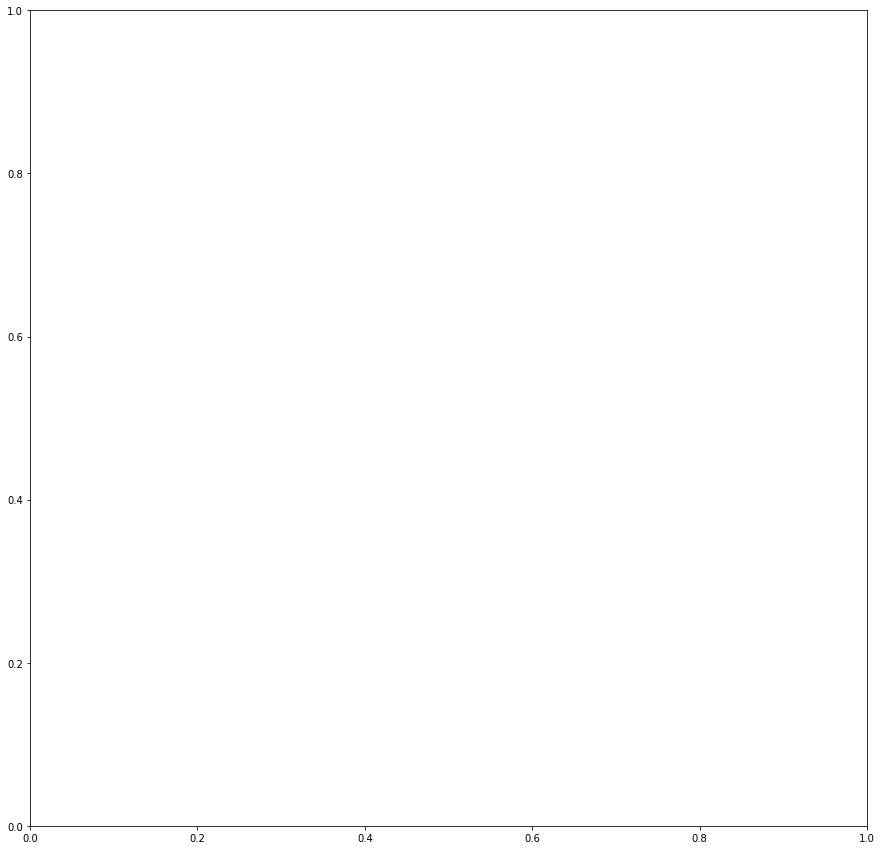

In [121]:
plt.figure(figsize=(15, 15))

plt.scatter(*zip(*points), c = labels , s = 1000)

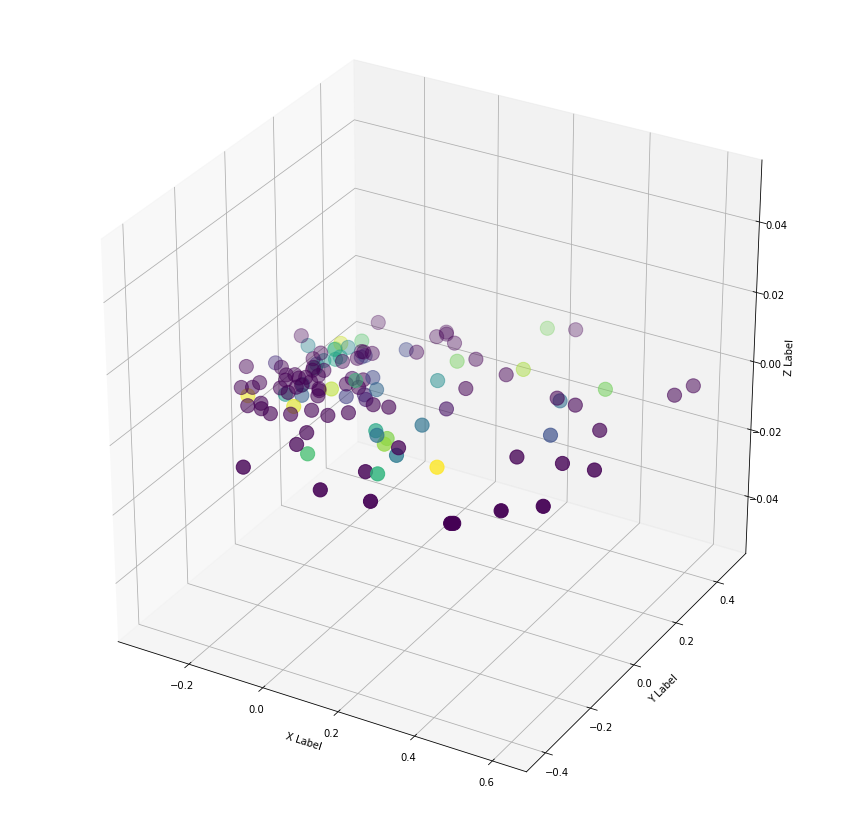

In [156]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].

ax.scatter(*zip(*points), c = colors , s = 200)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


# JSON GENERATION

In [448]:
def form_data(centers, labels):

    data = {}
    clusterAnalysis = []

    n_classes = len(np.unique(labels))
    print(n_classes)
    mode = int(n_classes)

    score = int(0.99)

    clusterDescr = form_clusterDescr(labels, centers, centers_plane)

    clusters = get_clusters(labels)

    clusterAnalysis.append({
        "mode": mode,
        "score": score,
        "clusterDescr": clusterDescr,
        'clusters': clusters
    })

    data['clusterAnalysis'] = clusterAnalysis

    return data

def form_clusterDescr(labels, centers, centers_plane):
    clusterDescr = []

    labels, powers = np.unique(labels, return_counts=True)

    for i, label in enumerate(labels):
        point_plane = [float(x) for x in centers_plane[i]]
        point = [float(x) for x in centers[i]]
        power = powers[i]

        clusterDescr.append({'clusterClass': int(label),
                             'power': int(power),
                             'clusterCharacteristic': point_plane,
                             'clusterCharacteristic_orig': point,
                             'clusterColorPlane': '#000000',
                             'clusterColorFromCenter': '#000000'})

    return clusterDescr


def get_clusters(labels):
    clusters = []

    prev = labels[0]
    start_label = [[1, prev]]
    for i, label in enumerate(labels[1:]):
        i = i + 1 + 1  # because of padd and json starts from 1
        if label != prev:
            start_label.append([i, label])
        prev = label

    for startFrame, label in start_label:
        clusters.append({
            "clusterClass": int(label),
            "clusterStartFrame": int(startFrame)
        })

#     clusters  =_union_similar(clusters)

    return clusters


def _union_similar(clusters):
    clusters_new = []
    start_frame = 1
    for i in range(1, len(clusters)):
        value_prev = clusters[i - 1]['clusterClass']
        value = clusters[i]['clusterClass']

        if value != value_prev:
            clusters_new.append({'clusterClass': int(value_prev), 'clusterStartFrame': start_frame})
            start_frame = clusters[i]['clusterStartFrame']
    return clusters_new

In [534]:
def get_labels_from_G(G):
    N = G.AM.shape[0]
    labels = np.zeros(N)
    verts = set(np.arange(N))
    j = 0
    
    while verts:
        v = verts.pop()
        idxs = utils.bfs_components(G, v)
        labels[idxs] = j
        j += 1
        verts = verts - set(idxs)
        
    return array(labels, dtype = np.int)


def get_full_labels(idxs_points, labels_center, n):
    
    labels = np.zeros(n)
    
    for label, idxs in zip(labels_center, idxs_points):
        for line in idxs:
            labels[line] = label
    return array(labels, dtype = int)
        
    

In [535]:
def centrate(data, n):
    new_c = np.array([0., 0.])
    for p in data['clusterAnalysis'][-1]['clusterDescr']:
        new_c += np.array( p['clusterCharacteristic'] )
    new_c = new_c / ( len(data['clusterAnalysis'][-1]['clusterDescr']) -1)
    
    
    last_class = data['clusterAnalysis'][0]['clusterDescr'][0]['clusterClass']
    
    clusterDescr = data['clusterAnalysis'][0]['clusterDescr']
    clusterDescr.append({
           'clusterClass': -1,
           'clusterCharacteristic': [new_c[0],  new_c[1]],
           'clusterColorPlane': '#000000',
           'clusterColorFromCenter': '#680048'
    })
    data['clusterAnalysis'][0]['clusterDescr'] = clusterDescr
    
    clusters = data['clusterAnalysis'][0]['clusters']
    last = n * 2
    start = n
    clusters.append({'clusterClass': -1, 'clusterStartFrame': start})
    clusters.append({'clusterClass': last_class, 'clusterStartFrame': last})
    
    return data

In [536]:
def get_centers(centers, labels_center, idxs_points):
    idxs_points = array(idxs_points)
    n_max = np.unique(labels_center).max()
    new_centers = []
    for i in range(n_max + 1):
        idxs = array( np.where(labels_center == i)[0] , dtype = int)
        ccc = centers[idxs]
        weights = array([len(k) for k in idxs_points[idxs] ]) 
        weights = weights / sum(weights)
        C = np.dot(weights, ccc)
        new_centers.append(C)
    new_centers = array(new_centers)
    return new_centers

In [537]:
labels_center = get_labels_from_G(L.G)
idxs_points = L.SubClusters.idxs_points
n = L.SubClusters.id_curr

labels = get_full_labels(idxs_points, labels_center, n)


In [538]:
centers = L.SubClusters.centers
centers = get_centers(centers, labels_center, idxs_points)

model = TSNE(2, metric='cosine')
centers_plane = model.fit_transform(centers)

In [539]:
len(np.unique(labels))

1353

In [540]:
data = form_data(centers_plane, labels)

1353


In [543]:
data = centrate(data, n)

In [544]:
with open(f"dynamic.json", 'w') as out:
    json.dump(data, out)

In [545]:
n

256290

In [222]:
import cv2
import matplotlib.pyplot as plt

In [284]:

out.write(frame)
out.release() 

In [286]:
path = '/media/ihoholko/HDD/Avatar_FHD.mp4'


out = cv2.VideoWriter('./output.avi', 0, 1., (1280, 720 ))

# font 
font = cv2.FONT_HERSHEY_SIMPLEX 
# org 
org = (20, 30)   
# fontScale 
fontScale = 0.7 
# Blue color in BGR 
color = (255, 0, 0)  
# Line thickness of 2 px 
thickness = 2  
# Using cv2.putText() method 
cap = cv2.VideoCapture(path)
i = 0


while True:
    _, frame = cap.read()

    frame = cv2.putText(frame, str(i), org, font,  
                   fontScale, color, thickness, cv2.LINE_AA)
    
    i+=1
    out.write(frame)
    if i == 5000:
        break

cap.release()
cv2.destroyAllWindows()
out.release()  

In [ ]:
out = cv2.VideoWriter('output.avi', -1, 1, (720, 1280))

In [270]:
frame.shape

(720, 1280, 3)

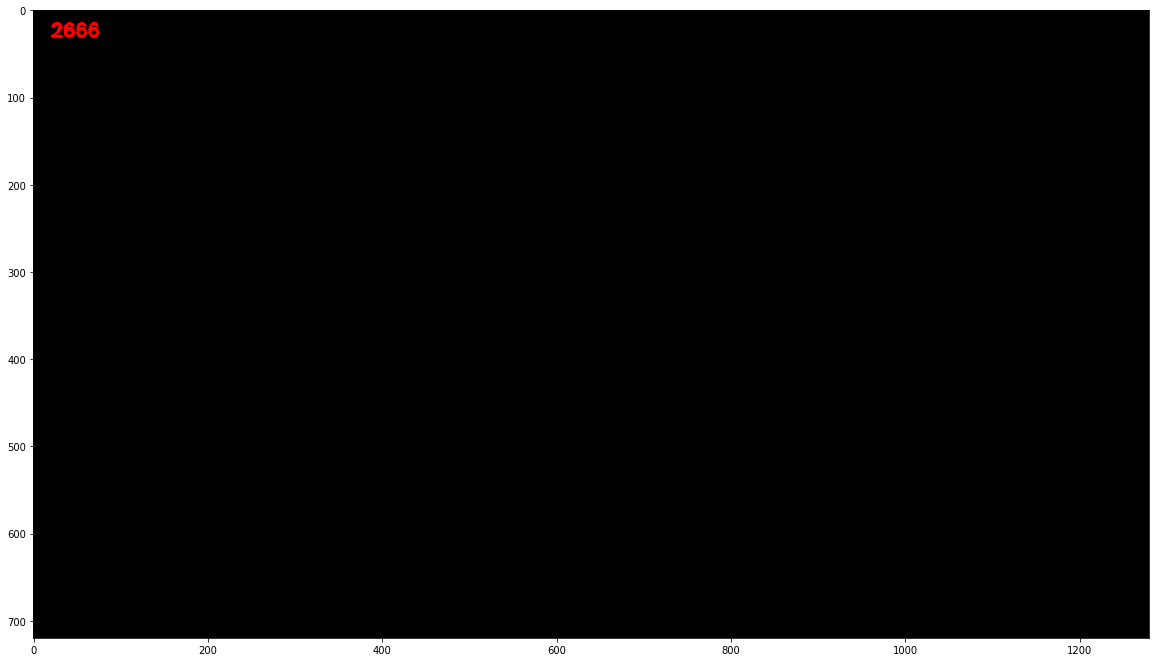

In [269]:
plt.figure(figsize=(20, 20))
plt.imshow(frame)

